In [1]:
# ============================================
# Phase A — Dataset Generation (30-Node Setup)
# ============================================

# --------------------------
# Cell 1 — Imports & Setup
# --------------------------
import numpy as np
import networkx as nx
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Dict, Literal

# Data directory
DATA_DIR = Path("./tm_dataset")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------
# Cell 2 — Topologies & Generators
# --------------------------
@dataclass
class TopologySpec:
    name: str
    G: nx.Graph
    capacities: Dict[tuple, float]
    seed: int = None


def rocketfuel_like(n_nodes: int = 30,
                    p_backbone: float = 0.1,
                    p_access: float = 0.05,
                    capacity_range: Tuple[float, float] = (6.0, 14.0)) -> TopologySpec:
    nb = max(8, n_nodes // 3)

    # connected backbone
    while True:
        seed = np.random.randint(1 << 30)
        backbone = nx.erdos_renyi_graph(nb, p_backbone, seed=seed)
        if nx.is_connected(backbone):
            print(f"[Rocketfuel-like] Using seed {seed} for backbone")
            break

    mapping = {i: i + 1 for i in range(nb)}
    backbone = nx.relabel_nodes(backbone, mapping)
    G = nx.Graph()
    G.update(backbone)

    # attach access nodes
    for v in range(nb + 1, n_nodes + 1):
        deg_targets = np.random.choice(range(1, nb + 1),
                                       size=np.random.randint(1, 4),
                                       replace=False)
        for t in deg_targets:
            G.add_edge(v, int(t))

    # sparse access-access edges
    access_nodes = list(range(nb + 1, n_nodes + 1))
    for _ in range(int(0.03 * len(access_nodes) * (len(access_nodes) - 1) / 2)):
        u, v = np.random.choice(access_nodes, size=2, replace=False)
        if not G.has_edge(int(u), int(v)) and np.random.rand() < p_access:
            G.add_edge(int(u), int(v))

    low, high = capacity_range
    caps = {tuple(sorted(e)): float(np.random.uniform(low, high)) for e in G.edges()}
    return TopologySpec(f"rf_{n_nodes}_synth", G, caps, seed=seed)


# ---------- Traffic matrix generation ----------
def zero_diag(M: np.ndarray) -> np.ndarray:
    M = M.copy()
    np.fill_diagonal(M, 0.0)
    return M


def gen_uniform(N: int, low: float = 0.5, high: float = 5.0, rng=None) -> np.ndarray:
    if rng is None: rng = np.random.default_rng()
    return zero_diag(rng.uniform(low, high, size=(N, N)))


def gen_exponential(N: int, scale: float = 4.0, rng=None) -> np.ndarray:
    if rng is None: rng = np.random.default_rng()
    return zero_diag(rng.exponential(scale, size=(N, N)))


def gen_gravity(N: int, mu: float = 0.0, sigma: float = 1.0,
                noise_low: float = 0.8, noise_high: float = 1.2, rng=None) -> np.ndarray:
    if rng is None: rng = np.random.default_rng()
    w = rng.lognormal(mean=mu, sigma=sigma, size=N)
    TM = np.outer(w, w) * rng.uniform(noise_low, noise_high, size=(N, N))
    return zero_diag(TM)


def total_capacity(G: nx.Graph, capacities: Dict[tuple, float]) -> float:
    return float(sum(capacities[tuple(sorted(e))] for e in G.edges()))


def scale_tm(TM: np.ndarray, G: nx.Graph, capacities: Dict[tuple, float],
             load_level: float = 0.7, kappa: float = 3.0) -> np.ndarray:
    C_tot = total_capacity(G, capacities)
    D_target = kappa * load_level * C_tot
    curr_sum = float(TM.sum())
    if curr_sum <= 1e-9:
        return TM
    noise = np.random.uniform(0.85, 1.15)  # break perfect normalization
    return TM * (D_target / curr_sum) * noise


GenName = Literal["uniform", "exponential", "gravity"]

def sample_tm(N: int, topo: TopologySpec,
              mix: Dict[GenName, float] = {"exponential": 0.6, "gravity": 0.3, "uniform": 0.1},
              load_levels: Tuple[float, ...] = (0.3, 0.5, 0.7, 0.9, 1.1),
              kappa_range: Tuple[float, float] = (2.0, 4.0)) -> tuple:
    rng = np.random.default_rng(None)  # fresh RNG each call
    gens = list(mix.keys())
    probs = np.array([mix[g] for g in gens])
    probs /= probs.sum()
    gname = str(rng.choice(gens, p=probs))

    if gname == "uniform":
        TM = gen_uniform(N, rng=rng)
    elif gname == "exponential":
        TM = gen_exponential(N, rng=rng)
    else:
        TM = gen_gravity(N, rng=rng)

    L = float(rng.choice(load_levels))
    kappa = float(rng.uniform(*kappa_range))
    TM_scaled = scale_tm(TM, topo.G, topo.capacities, L, kappa)
    return TM_scaled, gname, L, kappa


# --------------------------
# Cell 3 — Config (30-Node)
# --------------------------
TOPO = rocketfuel_like(n_nodes=30)
N = TOPO.G.number_of_nodes()
N_SAMPLES = 2000
mix_cfg = {"exponential": 0.6, "gravity": 0.3, "uniform": 0.1}
load_levels = (0.3, 0.5, 0.7, 0.9, 1.1)
kappa_range = (2.0, 4.0)

# --------------------------
# Cell 4 — Build & Save Dataset
# --------------------------
all_TMs = np.zeros((N_SAMPLES, N, N), dtype=float)
meta_rows = []

for i in range(N_SAMPLES):
    # add slight capacity jitter every 200 samples
    if i % 200 == 0:
        for e in TOPO.G.edges():
            TOPO.capacities[e] = np.random.uniform(6.0, 14.0)

    TM, gname, L, kappa = sample_tm(N, TOPO, mix=mix_cfg,
                                    load_levels=load_levels,
                                    kappa_range=kappa_range)
    all_TMs[i] = TM
    meta_rows.append((gname, L, kappa))

topo_name = f"{TOPO.name}_seed{TOPO.seed}"

tm_npy = DATA_DIR / f"{topo_name}_TMs.npy"
tm_csv = DATA_DIR / f"{topo_name}_TMs_meta.csv"
np.save(tm_npy, all_TMs)
pd.DataFrame(meta_rows, columns=["gen", "load_level", "kappa"]).to_csv(tm_csv, index=False)

edges_sorted = [tuple(sorted(e)) for e in TOPO.G.edges()]
caps_ordered = [TOPO.capacities[e] for e in edges_sorted]
topo_npz = DATA_DIR / f"{topo_name}_topology.npz"
np.savez(topo_npz,
         name=TOPO.name,
         nodes=np.array(list(TOPO.G.nodes()), dtype=int),
         edges=np.array(edges_sorted, dtype=int),
         capacities=np.array(caps_ordered, dtype=float))

print(f"[Saved Dataset] {tm_npy}, {tm_csv}")
print(f"[Saved Topology] {topo_npz}")

# --------------------------
# Cell 5 — Quick Preview
# --------------------------
TMS = np.load(tm_npy)
META = pd.read_csv(tm_csv)
print("Dataset shape:", TMS.shape)
print(META.head())

rows = []
for idx in np.random.choice(len(TMS), size=3, replace=False):
    rows.append({
        "idx": int(idx),
        "gen": META.loc[idx, "gen"],
        "load_level": float(META.loc[idx, "load_level"]),
        "kappa": float(META.loc[idx, "kappa"]),
        "sum_demand": float(TMS[idx].sum()),
        "max_demand": float(TMS[idx].max())
    })
print(pd.DataFrame(rows))

example_path = DATA_DIR / f"{TOPO.name}_example_TM.csv"
pd.DataFrame(TMS[int(rows[0]['idx'])]).to_csv(example_path, index=False)
print(f"[Saved Example TM] {example_path}")

npz = np.load(topo_npz, allow_pickle=True)
nodes = npz["nodes"].astype(int).tolist()
edges = [tuple(map(int, e)) for e in npz["edges"]]
capacities_vals = npz["capacities"].astype(float).tolist()
print(f"[Reloaded Topology] {npz['name']}")
print("Nodes:", len(nodes), "Edges:", len(edges))
print("Sample capacities:", capacities_vals[:5])


[Rocketfuel-like] Using seed 271716155 for backbone
[Saved Dataset] tm_dataset/rf_30_synth_seed271716155_TMs.npy, tm_dataset/rf_30_synth_seed271716155_TMs_meta.csv
[Saved Topology] tm_dataset/rf_30_synth_seed271716155_topology.npz
Dataset shape: (2000, 30, 30)
           gen  load_level     kappa
0  exponential         0.5  3.075141
1      gravity         1.1  2.993848
2      gravity         0.7  3.577923
3  exponential         0.9  2.874345
4  exponential         0.3  2.131567
    idx          gen  load_level     kappa   sum_demand  max_demand
0  1681      uniform         1.1  3.129966  1840.406691    3.756841
1  1269  exponential         1.1  2.138694  1467.079657   14.650581
2  1972      gravity         0.3  2.904933   434.584495    6.015734
[Saved Example TM] tm_dataset/rf_30_synth_example_TM.csv
[Reloaded Topology] rf_30_synth
Nodes: 30 Edges: 56
Sample capacities: [6.585528034656348, 10.633064491078805, 10.637954994822614, 13.040447482091707, 8.571396714718286]


In [3]:
import numpy as np

TMS = np.load("tm_dataset/rf_30_synth_seed271716155_TMs.npy")

TMS_flat = TMS.reshape(len(TMS), -1)
corr_matrix = np.corrcoef(TMS_flat)
upper_idx = np.triu_indices_from(corr_matrix, k=1)
avg_corr = np.mean(np.abs(corr_matrix[upper_idx]))

print(f"Average inter-TM correlation: {avg_corr:.3f}")


Average inter-TM correlation: 0.045


In [4]:
tm_sums = TMS.reshape(len(TMS), -1).sum(axis=1)
print(f"TM sum stats — min: {tm_sums.min():.2f}, max: {tm_sums.max():.2f}, std: {tm_sums.std():.2f}")


TM sum stats — min: 297.73, max: 2838.14, std: 547.02


In [19]:
# =======================================
# Phase B — RL TRAINING & TRANSFER TESTS
# =======================================

# Cell 0 — Load dataset, split, rebuild graph state, and precompute/load paths

import numpy as np, pandas as pd, networkx as nx, pickle
from pathlib import Path
from networkx.algorithms.simple_paths import shortest_simple_paths

DATA_DIR = Path("./tm_dataset")
TOPO_NAME = "rf_30_synth_seed271716155"

# --- Load traffic matrices + metadata ---
TMS = np.load(DATA_DIR / f"{TOPO_NAME}_TMs.npy")
META = pd.read_csv(DATA_DIR / f"{TOPO_NAME}_TMs_meta.csv")

# --- Load topology ---
topo_npz = np.load(DATA_DIR / f"{TOPO_NAME}_topology.npz", allow_pickle=True)
nodes = topo_npz["nodes"].astype(int).tolist()
edges_arr = topo_npz["edges"]
edges = [tuple(map(int, e)) for e in edges_arr]
capacities_vals = topo_npz["capacities"].tolist()

# Build graph + capacities
G = nx.Graph(); G.add_nodes_from(nodes); G.add_edges_from(edges)
cap_dict = {tuple(sorted(e)): float(c) for e, c in zip(edges, capacities_vals)}
EDGE_LIST = [tuple(sorted(e)) for e in G.edges()]
EDGE_INDEX = {e:i for i,e in enumerate(EDGE_LIST)}

# --- Train/test split ---
n_total = len(TMS); n_train = int(0.7 * n_total)
TMS_train, META_train = TMS[:n_train], META.iloc[:n_train].reset_index(drop=True)
TMS_test,  META_test  = TMS[n_train:],  META.iloc[n_train:].reset_index(drop=True)

# --- Candidate paths (with caching + parallel + progress) ---
# --- Candidate paths (FAST: only 1 shortest path per pair) ---
from tqdm import tqdm
import pickle
import networkx as nx

k_paths = 3
paths_file = DATA_DIR / f"{TOPO_NAME}_candidate_paths_fast.pkl"

def compute_single_shortest(G, src, dst):
    try:
        path = nx.shortest_path(G, src, dst)  # built-in BFS / Dijkstra
    except nx.NetworkXNoPath:
        path = []  # handle disconnected pairs
    return path

if paths_file.exists():
    print(f"[Info] Loading candidate paths from {paths_file}")
    with open(paths_file, "rb") as f:
        candidate_paths = pickle.load(f)
else:
    print("[Info] Computing single shortest paths quickly...")
    candidate_paths = {}
    for s in tqdm(nodes, desc="Src"):
        for d in nodes:
            if s != d:
                p = compute_single_shortest(G, s, d)
                if p:
                    candidate_paths[(s, d)] = [p]  # wrap in list for consistency

    with open(paths_file, "wb") as f:
        pickle.dump(candidate_paths, f)
    print(f"[Info] Saved candidate paths to {paths_file}")

print(f"Candidate paths ready for {len(candidate_paths)} src-dst pairs "
      f"(1 path each).")

import random

# --- Verification: sample a few random pairs ---
sample_pairs = random.sample(list(candidate_paths.keys()), 5)
print("\n[Verification] Sample candidate paths:")
for (s, d) in sample_pairs:
    paths = candidate_paths[(s, d)]
    print(f"  Pair ({s} → {d}):")
    for i, p in enumerate(paths, 1):
        print(f"    Path {i}: {p}")

# --- Coverage check ---
counts = [len(v) for v in candidate_paths.values()]
print("\n[Sanity] Path count distribution:")
print(f"  Min paths: {min(counts)}")
print(f"  Max paths: {max(counts)}")
print(f"  Pairs with <{k_paths} paths: {sum(c < k_paths for c in counts)} / {len(counts)}")


[Info] Loading candidate paths from tm_dataset/rf_30_synth_seed271716155_candidate_paths_fast.pkl
Candidate paths ready for 870 src-dst pairs (1 path each).

[Verification] Sample candidate paths:
  Pair (6 → 11):
    Path 1: [6, 11]
  Pair (28 → 13):
    Path 1: [28, 1, 8, 13]
  Pair (17 → 23):
    Path 1: [17, 7, 23]
  Pair (6 → 14):
    Path 1: [6, 8, 14]
  Pair (22 → 27):
    Path 1: [22, 6, 8, 1, 27]

[Sanity] Path count distribution:
  Min paths: 1
  Max paths: 1
  Pairs with <1 paths: 0 / 870


In [20]:
# Cell 1 — Torch config & dimensions

import torch, torch.nn as nn, torch.optim as optim, random
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

N = TMS.shape[1]
N_ACTIONS = N * (N - 1)                     # all ordered src->dst (dst!=src)
STATE_DIM = N*N + N_ACTIONS + len(EDGE_LIST)  # TM + mask + link loads

print(f"N={N}, Actions={N_ACTIONS}, Edges={len(EDGE_LIST)}, STATE_DIM={STATE_DIM}")



Using device: cuda
N=30, Actions=870, Edges=56, STATE_DIM=1826


In [21]:
# ==============================================
# Cell 2 — φ(s) encoder + DS-DQN (two-time-scale with φ(s)–φ(s′) decorrelation)
# ==============================================

import torch
import torch.nn as nn
import torch.optim as optim

# ----------------------------------------------
# Encoder: φ(s)
# ----------------------------------------------
class PhiEncoder(nn.Module):
    def __init__(self, state_dim, phi_dim=None):
        super().__init__()
        if phi_dim is None:
            phi_dim = state_dim   # match output dim to input by default

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, phi_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)  # φ(s)

# Debug check (optional)
phi_encoder = PhiEncoder(STATE_DIM, phi_dim=None).to(device)
dummy = torch.zeros(1, STATE_DIM).to(device)
out = phi_encoder(dummy)
print("Input dim:", dummy.shape, "Output dim:", out.shape)


# ----------------------------------------------
# DS-DQN with two-time-scale learning
# ----------------------------------------------
class DS_DQN(nn.Module):
    def __init__(self,
                 state_dim,
                 n_actions,
                 phi_dim=None,
                 lr_enc=3e-5,     # α (slow encoder)
                 lr_w=3e-3):      # β (fast head)
        super().__init__()
        if phi_dim is None:
            phi_dim = state_dim

        self.encoder = PhiEncoder(state_dim, phi_dim)
        self.w = nn.Parameter(torch.randn(n_actions, phi_dim) * 0.01)

        # Separate optimizers for two-time-scale learning
        self.opt_enc = optim.Adam(self.encoder.parameters(), lr=lr_enc)
        self.opt_w   = optim.Adam([self.w], lr=lr_w)

    # ------------------------------------------------
    # Forward pass
    # ------------------------------------------------
    def Q(self, s):
        """Compute Q-values and feature embeddings φ(s)."""
        phi = self.encoder(s)                 # [B, φ_dim]
        phi = nn.functional.normalize(phi, dim=1)
        q = torch.matmul(phi, self.w.T)       # [B, n_actions]
        return q, phi

    # ------------------------------------------------
    # Correlation penalty: L2(φ)
    # ------------------------------------------------
    def _corr_penalty_random_pairs(self, phi_s):
        """
        Compute decorrelation loss between random pairs of φ(s)
        drawn from the same batch.
        """
        batch_size = phi_s.size(0)
        perm = torch.randperm(batch_size)
        phi_s_perm = phi_s[perm]

        # Compute per-sample Pearson correlation between φ(s) and φ(s_perm)
        phi_s_centered = phi_s - phi_s.mean(dim=1, keepdim=True)
        phi_s_perm_centered = phi_s_perm - phi_s_perm.mean(dim=1, keepdim=True)

        numerator = torch.sum(phi_s_centered * phi_s_perm_centered, dim=1)
        denominator = torch.sqrt(
            torch.sum(phi_s_centered**2, dim=1) * torch.sum(phi_s_perm_centered**2, dim=1)
        ) + 1e-8

        corr = numerator / denominator
        return (corr ** 2).mean()  # penalize squared correlation


    # ------------------------------------------------
    # Update step
    # ------------------------------------------------
    def update(self, batch, target_net, gamma=0.99, lambda_reg=0.0):
        """
        One DS-DQN update:
          - L1(φ,w): TD loss
          - L2(φ): decorrelation between random φ(s) pairs
          - Two-time-scale updates (w fast, θ₁ slow)
        """
        s, a, r, s_next, done = batch
        s      = torch.FloatTensor(s).to(device)
        s_next = torch.FloatTensor(s_next).to(device)
        a      = torch.LongTensor(a).to(device)
        r      = torch.FloatTensor(r).to(device)
        done   = torch.FloatTensor(done).to(device)

        # ----- Q(s,a) -----
        q_vals, phi_s = self.Q(s)
        q_sa = q_vals.gather(1, a.unsqueeze(1)).squeeze(1)

        # ----- Target network -----
        with torch.no_grad():
            q_next, _ = target_net.Q(s_next)
            y = r + gamma * (1 - done) * q_next.max(1)[0]

        # ----- Losses -----
        td_loss = (y - q_sa).pow(2).mean()               # value accuracy
        l2_loss = self._corr_penalty_random_pairs(phi_s) # decorrelation term
        loss = td_loss + lambda_reg * l2_loss

        # ----- Backprop (two-time-scale) -----
        self.opt_enc.zero_grad()
        self.opt_w.zero_grad()
        loss.backward()
        self.opt_w.step()     # fast head (β)
        self.opt_enc.step()   # slow encoder (α)

        return td_loss.item(), l2_loss.item()


Input dim: torch.Size([1, 1826]) Output dim: torch.Size([1, 1826])


In [22]:
# Cell 3 — Replay buffer

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, done))
    def sample(self, batch_size=256):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, done = map(np.array, zip(*batch))
        return s, a, r, s_next, done
    def __len__(self):
        return len(self.buffer)


In [23]:
# Cell 4 — Environment helpers (state, action mapping, reward, with τ filtering)

def flow_index_to_pair(a: int, N: int) -> tuple:
    src = a // (N - 1)
    dst = a % (N - 1)
    if dst >= src: 
        dst += 1
    return src, dst  # 0-based (align with TM indexing)


def init_state(TM):
    mask = np.zeros(N_ACTIONS, dtype=float)
    loads = np.zeros(len(EDGE_LIST), dtype=float)
    return np.concatenate([TM.flatten(), mask, loads])


def apply_action(state, action, TM, lam=0.5, tau=0.8):
    """
    One environment step:
    - Pick action (src,dst)
    - Route demand using precomputed candidate paths[(src,dst)]
    - Apply τ-threshold filtering on link utilizations
    - Update loads and compute reward
    """
    TM_flat = state[:N*N]
    mask = state[N*N:N*N+N_ACTIONS]
    loads = state[N*N+N_ACTIONS:]

    TM_mat = TM_flat.reshape(N, N).copy()
    if mask[action] == 1.0:
        # Already routed this flow → small penalty
        U = max(loads[i] / cap_dict[EDGE_LIST[i]] for i in range(len(EDGE_LIST)))
        rho = np.mean([loads[i] / cap_dict[EDGE_LIST[i]] for i in range(len(EDGE_LIST))])
  #      r = (1-lam)*(1-U) - lam*rho - 0.1
        r = (1 - lam) * (1 - U) + lam * (1 - rho) - 0.1
        return state.copy(), r, U, rho

    # Mark this flow as routed
    mask_new = mask.copy()
    mask_new[action] = 1.0

    s, d = flow_index_to_pair(action, N)
    demand = TM_mat[s, d]

    # --- Path selection with τ filtering ---
    paths = candidate_paths[(s+1, d+1)]  # precomputed (1-based nodes in G)
    chosen_path = None

    for path in paths:  # check each candidate path
        safe = True
        for u, v in zip(path[:-1], path[1:]):
            e = tuple(sorted((u, v))); idx = EDGE_INDEX[e]
            projected_util = (loads[idx] + demand) / cap_dict[e]
            if projected_util > tau:
                safe = False
                break
        if safe:
            chosen_path = path
            break

    # If no safe path, fallback: pick first candidate anyway (with penalty)
    if chosen_path is None:
        chosen_path = paths[0]

    # --- Update link loads ---
    loads_new = loads.copy()
    for u, v in zip(chosen_path[:-1], chosen_path[1:]):
        e = tuple(sorted((u, v))); idx = EDGE_INDEX[e]
        loads_new[idx] += demand

    # --- Compute utilization & reward ---
    utilizations = np.array([loads_new[i] / cap_dict[EDGE_LIST[i]] for i in range(len(EDGE_LIST))])
    U = float(utilizations.max())
    rho = float(utilizations.mean())
  #  r = (1 - lam) * (1 - U) - lam * rho
    r = (1 - lam) * (1 - U) + lam * (1 - rho)


    s_next = np.concatenate([TM_mat.flatten(), mask_new, loads_new])
    return s_next, r, U, rho


In [24]:
# Cell 4a — Quick debug check
state0 = init_state(TMS_train[0])
s_next, r, U, rho = apply_action(state0, action=0, TM=TMS_train[0], lam=0.55, tau=0.8)

print("STATE_DIM check:", STATE_DIM)
print("Initial state shape:", state0.shape)
print("Next state shape:", s_next.shape)
print("Reward example:", r, "U:", U, "rho:", rho)


STATE_DIM check: 1826
Initial state shape: (1826,)
Next state shape: (1826,)
Reward example: 0.9983045076402184 U: 0.003623644909795269 rho: 0.0001179130006794023


In [105]:
# Cell 5 — Training loop (DS-DQN with ε-decay + τ filtering paths)
import os
SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

EPISODES = 3000          # longer training
K = 30                    # steps per episode
BATCH_SIZE = 256
GAMMA = 0.99
TARGET_UPDATE = 50

# ε-greedy schedule
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.995
eps = eps_start

# DS-DQN networks
main_net = DS_DQN(STATE_DIM, N_ACTIONS, phi_dim=None,
                  lr_enc=1e-4, lr_w=3e-3).to(device)
target_net = DS_DQN(STATE_DIM, N_ACTIONS, phi_dim=None,
                    lr_enc=1e-4, lr_w=3e-3).to(device)
target_net.encoder.load_state_dict(main_net.encoder.state_dict())
target_net.w.data.copy_(main_net.w.data)

replay = ReplayBuffer(10000)

# Logs
rewards_log, U_log, rho_log = [], [], []
td_log, corr_log, gen_log = [], [], []
w_norms, enc_norms = [], []
corr_ep_log = []

# λ schedule
LAMBDA_MAX = 0.6
#DELTA_LAMBDA = LAMBDA_MAX / max(1, EPISODES / 2)
DELTA_LAMBDA = LAMBDA_MAX / 3000
lambda_reg = 0.0

for ep in range(EPISODES):
    idx = np.random.randint(len(TMS_train))
    TM = TMS_train[idx]
    tm_type = META_train.iloc[idx]["gen"]
    state = init_state(TM)

    ep_rewards, ep_Us, ep_rhos = [], [], []
    ep_td_losses, ep_corr_losses = [], []

    for step in range(K):
        # ε-greedy
        s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_vals, _ = main_net.Q(s_tensor)
        if random.random() < eps:
            action = np.random.randint(N_ACTIONS)   # explore
        else:
            action = q_vals.argmax(1).item()        # exploit

        # env transition (now uses τ-filtering paths)
        s_next, r, U, rho = apply_action(state, action, TM, lam=0.5, tau=0.8)
        replay.push(state, action, r, s_next, 0.0)
        state = s_next

        ep_rewards.append(r); ep_Us.append(U); ep_rhos.append(rho)

        # learn
        if len(replay) >= BATCH_SIZE:
            batch = replay.sample(BATCH_SIZE)
            td, corr = main_net.update(batch, target_net, gamma=GAMMA, lambda_reg=lambda_reg)
            td_log.append(td); corr_log.append(corr)
            ep_td_losses.append(td); ep_corr_losses.append(corr)
            
            # Track parameter norms
            w_norms.append(main_net.w.detach().norm().item())
            enc_norms.append(sum(p.detach().norm().item() for p in main_net.encoder.parameters()))

    # episode logs
    rewards_log.append(float(np.mean(ep_rewards)))
    U_log.append(float(np.mean(ep_Us)))
    rho_log.append(float(np.mean(ep_rhos)))
    gen_log.append(tm_type)
    

    # ---- summary ----
    td_ep = np.mean(ep_td_losses) if ep_td_losses else float("nan")
    corr_ep = np.mean(ep_corr_losses) if ep_corr_losses else float("nan")
    corr_ep_log.append(corr_ep) 
    print(
        f"[Ep {ep+1:04d}] "
        f"eps={eps:.3f} λ={lambda_reg:.4f} "
        f"R={np.mean(ep_rewards):+.4f} U={np.mean(ep_Us):.3f} ρ={np.mean(ep_rhos):.3f} "
        f"TD={td_ep:.5f} Corr={corr_ep:.5f} "
        f"replay={len(replay)}"
    )
    print(f"Episode {ep+1}, total routed flows: {K}, avg reward: {np.mean(ep_rewards):.4f}")
    
    # target net sync
    if (ep + 1) % TARGET_UPDATE == 0:
        target_net.encoder.load_state_dict(main_net.encoder.state_dict())
        target_net.w.data.copy_(main_net.w.data)

    # ramp λ
    lambda_reg = min(lambda_reg + DELTA_LAMBDA, LAMBDA_MAX)

    # decay ε
    eps = max(eps_end, eps * eps_decay)

# Save encoder φ(s)
phi_path = DATA_DIR / f"{TOPO_NAME}_phi_trained_DSDQN.pth"
torch.save(main_net.encoder.state_dict(), phi_path)
print(f"Saved encoder to {phi_path}")

# Save logs to CSV
df_summary = pd.DataFrame({
    "episode": np.arange(len(rewards_log)),
    "reward": rewards_log,
    "U": U_log,
    "rho": rho_log,
    "corr_loss": corr_ep_log
})
out_csv = f"{SAVE_DIR}/train_reward_utilization_corr_summary_dsdqn.csv"
df_summary.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

[Ep 0001] eps=1.000 λ=0.0000 R=+0.6302 U=0.652 ρ=0.081 TD=nan Corr=nan replay=30
Episode 1, total routed flows: 30, avg reward: 0.6302
[Ep 0002] eps=0.995 λ=0.0002 R=+0.4447 U=1.018 ρ=0.086 TD=nan Corr=nan replay=60
Episode 2, total routed flows: 30, avg reward: 0.4447
[Ep 0003] eps=0.990 λ=0.0004 R=+0.7993 U=0.366 ρ=0.035 TD=nan Corr=nan replay=90
Episode 3, total routed flows: 30, avg reward: 0.7993
[Ep 0004] eps=0.985 λ=0.0006 R=+0.0492 U=1.747 ρ=0.155 TD=nan Corr=nan replay=120
Episode 4, total routed flows: 30, avg reward: 0.0492
[Ep 0005] eps=0.980 λ=0.0008 R=+0.2565 U=1.352 ρ=0.121 TD=nan Corr=nan replay=150
Episode 5, total routed flows: 30, avg reward: 0.2565
[Ep 0006] eps=0.975 λ=0.0010 R=+0.5471 U=0.794 ρ=0.098 TD=nan Corr=nan replay=180
Episode 6, total routed flows: 30, avg reward: 0.5471
[Ep 0007] eps=0.970 λ=0.0012 R=+0.4764 U=0.939 ρ=0.094 TD=nan Corr=nan replay=210
Episode 7, total routed flows: 30, avg reward: 0.4764
[Ep 0008] eps=0.966 λ=0.0014 R=+0.8232 U=0.317 ρ=0.

[Ep 0059] eps=0.748 λ=0.0116 R=+0.5872 U=0.724 ρ=0.082 TD=0.00548 Corr=0.59525 replay=1770
Episode 59, total routed flows: 30, avg reward: 0.5872
[Ep 0060] eps=0.744 λ=0.0118 R=+0.5116 U=0.838 ρ=0.119 TD=0.00625 Corr=0.55670 replay=1800
Episode 60, total routed flows: 30, avg reward: 0.5116
[Ep 0061] eps=0.740 λ=0.0120 R=+0.7273 U=0.446 ρ=0.060 TD=0.00676 Corr=0.54766 replay=1830
Episode 61, total routed flows: 30, avg reward: 0.7273
[Ep 0062] eps=0.737 λ=0.0122 R=+0.3169 U=1.246 ρ=0.080 TD=0.00861 Corr=0.50720 replay=1860
Episode 62, total routed flows: 30, avg reward: 0.3169
[Ep 0063] eps=0.733 λ=0.0124 R=+0.4590 U=0.960 ρ=0.082 TD=0.01011 Corr=0.48866 replay=1890
Episode 63, total routed flows: 30, avg reward: 0.4590
[Ep 0064] eps=0.729 λ=0.0126 R=+0.1392 U=1.546 ρ=0.115 TD=0.00892 Corr=0.46264 replay=1920
Episode 64, total routed flows: 30, avg reward: 0.1392
[Ep 0065] eps=0.726 λ=0.0128 R=+0.7623 U=0.388 ρ=0.041 TD=0.00817 Corr=0.43951 replay=1950
Episode 65, total routed flows: 3

[Ep 0116] eps=0.562 λ=0.0230 R=+0.8733 U=0.187 ρ=0.020 TD=0.00683 Corr=0.29086 replay=3480
Episode 116, total routed flows: 30, avg reward: 0.8733
[Ep 0117] eps=0.559 λ=0.0232 R=+0.5524 U=0.801 ρ=0.054 TD=0.00601 Corr=0.27590 replay=3510
Episode 117, total routed flows: 30, avg reward: 0.5524
[Ep 0118] eps=0.556 λ=0.0234 R=+0.6549 U=0.561 ρ=0.076 TD=0.00679 Corr=0.26499 replay=3540
Episode 118, total routed flows: 30, avg reward: 0.6549
[Ep 0119] eps=0.554 λ=0.0236 R=+0.8672 U=0.190 ρ=0.023 TD=0.00910 Corr=0.25722 replay=3570
Episode 119, total routed flows: 30, avg reward: 0.8672
[Ep 0120] eps=0.551 λ=0.0238 R=+0.7877 U=0.311 ρ=0.047 TD=0.01333 Corr=0.24754 replay=3600
Episode 120, total routed flows: 30, avg reward: 0.7877
[Ep 0121] eps=0.548 λ=0.0240 R=+0.8766 U=0.161 ρ=0.026 TD=0.01128 Corr=0.24795 replay=3630
Episode 121, total routed flows: 30, avg reward: 0.8766
[Ep 0122] eps=0.545 λ=0.0242 R=+0.5211 U=0.831 ρ=0.093 TD=0.01132 Corr=0.24151 replay=3660
Episode 122, total routed f

[Ep 0173] eps=0.422 λ=0.0344 R=+0.3861 U=1.059 ρ=0.069 TD=0.00803 Corr=0.20617 replay=5190
Episode 173, total routed flows: 30, avg reward: 0.3861
[Ep 0174] eps=0.420 λ=0.0346 R=+0.7273 U=0.431 ρ=0.048 TD=0.00897 Corr=0.20212 replay=5220
Episode 174, total routed flows: 30, avg reward: 0.7273
[Ep 0175] eps=0.418 λ=0.0348 R=+0.7788 U=0.354 ρ=0.036 TD=0.00802 Corr=0.20102 replay=5250
Episode 175, total routed flows: 30, avg reward: 0.7788
[Ep 0176] eps=0.416 λ=0.0350 R=+0.6710 U=0.524 ρ=0.047 TD=0.01088 Corr=0.20098 replay=5280
Episode 176, total routed flows: 30, avg reward: 0.6710
[Ep 0177] eps=0.414 λ=0.0352 R=+0.1976 U=1.370 ρ=0.155 TD=0.01123 Corr=0.19057 replay=5310
Episode 177, total routed flows: 30, avg reward: 0.1976
[Ep 0178] eps=0.412 λ=0.0354 R=+0.7144 U=0.461 ρ=0.044 TD=0.01448 Corr=0.19241 replay=5340
Episode 178, total routed flows: 30, avg reward: 0.7144
[Ep 0179] eps=0.410 λ=0.0356 R=+0.8958 U=0.085 ρ=0.010 TD=0.01344 Corr=0.19415 replay=5370
Episode 179, total routed f

[Ep 0229] eps=0.319 λ=0.0456 R=+0.6134 U=0.637 ρ=0.050 TD=0.01142 Corr=0.18213 replay=6870
Episode 229, total routed flows: 30, avg reward: 0.6134
[Ep 0230] eps=0.317 λ=0.0458 R=+0.6434 U=0.573 ρ=0.054 TD=0.01193 Corr=0.18743 replay=6900
Episode 230, total routed flows: 30, avg reward: 0.6434
[Ep 0231] eps=0.316 λ=0.0460 R=+0.8825 U=0.111 ρ=0.010 TD=0.01292 Corr=0.18618 replay=6930
Episode 231, total routed flows: 30, avg reward: 0.8825
[Ep 0232] eps=0.314 λ=0.0462 R=+0.7731 U=0.306 ρ=0.027 TD=0.01692 Corr=0.18594 replay=6960
Episode 232, total routed flows: 30, avg reward: 0.7731
[Ep 0233] eps=0.313 λ=0.0464 R=+0.7463 U=0.383 ρ=0.031 TD=0.01246 Corr=0.18097 replay=6990
Episode 233, total routed flows: 30, avg reward: 0.7463
[Ep 0234] eps=0.311 λ=0.0466 R=+0.8626 U=0.160 ρ=0.022 TD=0.01389 Corr=0.18126 replay=7020
Episode 234, total routed flows: 30, avg reward: 0.8626
[Ep 0235] eps=0.309 λ=0.0468 R=+0.7620 U=0.357 ρ=0.046 TD=0.02610 Corr=0.18207 replay=7050
Episode 235, total routed f

[Ep 0285] eps=0.241 λ=0.0568 R=+0.5673 U=0.694 ρ=0.098 TD=0.01234 Corr=0.17576 replay=8550
Episode 285, total routed flows: 30, avg reward: 0.5673
[Ep 0286] eps=0.240 λ=0.0570 R=+0.5570 U=0.716 ρ=0.057 TD=0.01390 Corr=0.17467 replay=8580
Episode 286, total routed flows: 30, avg reward: 0.5570
[Ep 0287] eps=0.238 λ=0.0572 R=+0.8642 U=0.147 ρ=0.012 TD=0.01691 Corr=0.17451 replay=8610
Episode 287, total routed flows: 30, avg reward: 0.8642
[Ep 0288] eps=0.237 λ=0.0574 R=+0.4768 U=0.845 ρ=0.075 TD=0.01585 Corr=0.16855 replay=8640
Episode 288, total routed flows: 30, avg reward: 0.4768
[Ep 0289] eps=0.236 λ=0.0576 R=+0.5846 U=0.655 ρ=0.049 TD=0.01417 Corr=0.17192 replay=8670
Episode 289, total routed flows: 30, avg reward: 0.5846
[Ep 0290] eps=0.235 λ=0.0578 R=+0.6585 U=0.503 ρ=0.060 TD=0.01255 Corr=0.17156 replay=8700
Episode 290, total routed flows: 30, avg reward: 0.6585
[Ep 0291] eps=0.234 λ=0.0580 R=+0.7155 U=0.437 ρ=0.045 TD=0.01279 Corr=0.16741 replay=8730
Episode 291, total routed f

[Ep 0341] eps=0.182 λ=0.0680 R=+0.7999 U=0.238 ρ=0.009 TD=0.01505 Corr=0.16439 replay=10000
Episode 341, total routed flows: 30, avg reward: 0.7999
[Ep 0342] eps=0.181 λ=0.0682 R=+0.8044 U=0.237 ρ=0.020 TD=0.01420 Corr=0.16767 replay=10000
Episode 342, total routed flows: 30, avg reward: 0.8044
[Ep 0343] eps=0.180 λ=0.0684 R=+0.8147 U=0.219 ρ=0.018 TD=0.01513 Corr=0.16157 replay=10000
Episode 343, total routed flows: 30, avg reward: 0.8147
[Ep 0344] eps=0.179 λ=0.0686 R=+0.7506 U=0.349 ρ=0.036 TD=0.01435 Corr=0.15851 replay=10000
Episode 344, total routed flows: 30, avg reward: 0.7506
[Ep 0345] eps=0.178 λ=0.0688 R=+0.8865 U=0.102 ρ=0.011 TD=0.01770 Corr=0.15978 replay=10000
Episode 345, total routed flows: 30, avg reward: 0.8865
[Ep 0346] eps=0.177 λ=0.0690 R=+0.3721 U=1.073 ρ=0.096 TD=0.01595 Corr=0.15805 replay=10000
Episode 346, total routed flows: 30, avg reward: 0.3721
[Ep 0347] eps=0.177 λ=0.0692 R=+0.5329 U=0.746 ρ=0.055 TD=0.01615 Corr=0.15625 replay=10000
Episode 347, total r

[Ep 0398] eps=0.137 λ=0.0794 R=+0.7523 U=0.362 ρ=0.020 TD=0.01421 Corr=0.16038 replay=10000
Episode 398, total routed flows: 30, avg reward: 0.7523
[Ep 0399] eps=0.136 λ=0.0796 R=+0.8968 U=0.075 ρ=0.004 TD=0.01338 Corr=0.15741 replay=10000
Episode 399, total routed flows: 30, avg reward: 0.8968
[Ep 0400] eps=0.135 λ=0.0798 R=+0.5796 U=0.658 ρ=0.036 TD=0.01327 Corr=0.15557 replay=10000
Episode 400, total routed flows: 30, avg reward: 0.5796
[Ep 0401] eps=0.135 λ=0.0800 R=+0.6576 U=0.511 ρ=0.040 TD=0.30300 Corr=0.34277 replay=10000
Episode 401, total routed flows: 30, avg reward: 0.6576
[Ep 0402] eps=0.134 λ=0.0802 R=+0.7991 U=0.253 ρ=0.015 TD=0.11386 Corr=0.30217 replay=10000
Episode 402, total routed flows: 30, avg reward: 0.7991
[Ep 0403] eps=0.133 λ=0.0804 R=+0.5954 U=0.650 ρ=0.039 TD=0.06591 Corr=0.27630 replay=10000
Episode 403, total routed flows: 30, avg reward: 0.5954
[Ep 0404] eps=0.133 λ=0.0806 R=+0.7998 U=0.234 ρ=0.020 TD=0.03541 Corr=0.26617 replay=10000
Episode 404, total r

[Ep 0454] eps=0.103 λ=0.0906 R=+0.8474 U=0.158 ρ=0.008 TD=0.03649 Corr=0.24501 replay=10000
Episode 454, total routed flows: 30, avg reward: 0.8474
[Ep 0455] eps=0.103 λ=0.0908 R=+0.9077 U=0.024 ρ=0.001 TD=0.02262 Corr=0.23111 replay=10000
Episode 455, total routed flows: 30, avg reward: 0.9077
[Ep 0456] eps=0.102 λ=0.0910 R=+0.6214 U=0.609 ρ=0.055 TD=0.01854 Corr=0.22606 replay=10000
Episode 456, total routed flows: 30, avg reward: 0.6214
[Ep 0457] eps=0.102 λ=0.0912 R=+0.7294 U=0.373 ρ=0.028 TD=0.01513 Corr=0.21754 replay=10000
Episode 457, total routed flows: 30, avg reward: 0.7294
[Ep 0458] eps=0.101 λ=0.0914 R=+0.3685 U=1.072 ρ=0.045 TD=0.01332 Corr=0.21667 replay=10000
Episode 458, total routed flows: 30, avg reward: 0.3685
[Ep 0459] eps=0.101 λ=0.0916 R=+0.2371 U=1.335 ρ=0.058 TD=0.01140 Corr=0.20595 replay=10000
Episode 459, total routed flows: 30, avg reward: 0.2371
[Ep 0460] eps=0.100 λ=0.0918 R=+0.7964 U=0.239 ρ=0.015 TD=0.00941 Corr=0.20304 replay=10000
Episode 460, total r

[Ep 0510] eps=0.078 λ=0.1018 R=+0.6371 U=0.559 ρ=0.034 TD=0.00764 Corr=0.17279 replay=10000
Episode 510, total routed flows: 30, avg reward: 0.6371
[Ep 0511] eps=0.078 λ=0.1020 R=+0.6831 U=0.450 ρ=0.018 TD=0.00909 Corr=0.16593 replay=10000
Episode 511, total routed flows: 30, avg reward: 0.6831
[Ep 0512] eps=0.077 λ=0.1022 R=+0.8755 U=0.077 ρ=0.005 TD=0.00765 Corr=0.16192 replay=10000
Episode 512, total routed flows: 30, avg reward: 0.8755
[Ep 0513] eps=0.077 λ=0.1024 R=+0.8993 U=0.032 ρ=0.002 TD=0.00649 Corr=0.16437 replay=10000
Episode 513, total routed flows: 30, avg reward: 0.8993
[Ep 0514] eps=0.076 λ=0.1026 R=+0.4511 U=0.895 ρ=0.050 TD=0.00618 Corr=0.15446 replay=10000
Episode 514, total routed flows: 30, avg reward: 0.4511
[Ep 0515] eps=0.076 λ=0.1028 R=+0.7563 U=0.321 ρ=0.027 TD=0.00567 Corr=0.15534 replay=10000
Episode 515, total routed flows: 30, avg reward: 0.7563
[Ep 0516] eps=0.076 λ=0.1030 R=+0.7564 U=0.318 ρ=0.036 TD=0.00561 Corr=0.15439 replay=10000
Episode 516, total r

[Ep 0566] eps=0.059 λ=0.1130 R=+0.8684 U=0.102 ρ=0.008 TD=0.00678 Corr=0.12483 replay=10000
Episode 566, total routed flows: 30, avg reward: 0.8684
[Ep 0567] eps=0.059 λ=0.1132 R=+0.5219 U=0.771 ρ=0.058 TD=0.01006 Corr=0.12576 replay=10000
Episode 567, total routed flows: 30, avg reward: 0.5219
[Ep 0568] eps=0.058 λ=0.1134 R=+0.6940 U=0.440 ρ=0.019 TD=0.00915 Corr=0.12247 replay=10000
Episode 568, total routed flows: 30, avg reward: 0.6940
[Ep 0569] eps=0.058 λ=0.1136 R=+0.2141 U=1.322 ρ=0.109 TD=0.00697 Corr=0.12259 replay=10000
Episode 569, total routed flows: 30, avg reward: 0.2141
[Ep 0570] eps=0.058 λ=0.1138 R=+0.6060 U=0.598 ρ=0.036 TD=0.00897 Corr=0.11929 replay=10000
Episode 570, total routed flows: 30, avg reward: 0.6060
[Ep 0571] eps=0.057 λ=0.1140 R=+0.8677 U=0.095 ρ=0.010 TD=0.00860 Corr=0.11556 replay=10000
Episode 571, total routed flows: 30, avg reward: 0.8677
[Ep 0572] eps=0.057 λ=0.1142 R=+0.8865 U=0.059 ρ=0.002 TD=0.00863 Corr=0.11508 replay=10000
Episode 572, total r

[Ep 0622] eps=0.050 λ=0.1242 R=+0.8208 U=0.206 ρ=0.019 TD=0.01843 Corr=0.10020 replay=10000
Episode 622, total routed flows: 30, avg reward: 0.8208
[Ep 0623] eps=0.050 λ=0.1244 R=+0.6836 U=0.429 ρ=0.017 TD=0.01534 Corr=0.09986 replay=10000
Episode 623, total routed flows: 30, avg reward: 0.6836
[Ep 0624] eps=0.050 λ=0.1246 R=+0.8188 U=0.170 ρ=0.006 TD=0.00639 Corr=0.09867 replay=10000
Episode 624, total routed flows: 30, avg reward: 0.8188
[Ep 0625] eps=0.050 λ=0.1248 R=+0.6981 U=0.428 ρ=0.062 TD=0.01119 Corr=0.09953 replay=10000
Episode 625, total routed flows: 30, avg reward: 0.6981
[Ep 0626] eps=0.050 λ=0.1250 R=+0.8489 U=0.130 ρ=0.012 TD=0.00817 Corr=0.09449 replay=10000
Episode 626, total routed flows: 30, avg reward: 0.8489
[Ep 0627] eps=0.050 λ=0.1252 R=+0.8543 U=0.113 ρ=0.005 TD=0.00712 Corr=0.09428 replay=10000
Episode 627, total routed flows: 30, avg reward: 0.8543
[Ep 0628] eps=0.050 λ=0.1254 R=+0.8633 U=0.108 ρ=0.006 TD=0.00694 Corr=0.09277 replay=10000
Episode 628, total r

[Ep 0678] eps=0.050 λ=0.1354 R=+0.8499 U=0.116 ρ=0.005 TD=0.01364 Corr=0.07566 replay=10000
Episode 678, total routed flows: 30, avg reward: 0.8499
[Ep 0679] eps=0.050 λ=0.1356 R=+0.7943 U=0.247 ρ=0.011 TD=0.01051 Corr=0.07428 replay=10000
Episode 679, total routed flows: 30, avg reward: 0.7943
[Ep 0680] eps=0.050 λ=0.1358 R=+0.6848 U=0.456 ρ=0.021 TD=0.01163 Corr=0.07375 replay=10000
Episode 680, total routed flows: 30, avg reward: 0.6848
[Ep 0681] eps=0.050 λ=0.1360 R=+0.8519 U=0.119 ρ=0.010 TD=0.01013 Corr=0.07414 replay=10000
Episode 681, total routed flows: 30, avg reward: 0.8519
[Ep 0682] eps=0.050 λ=0.1362 R=+0.6358 U=0.546 ρ=0.043 TD=0.01146 Corr=0.07382 replay=10000
Episode 682, total routed flows: 30, avg reward: 0.6358
[Ep 0683] eps=0.050 λ=0.1364 R=+0.7435 U=0.336 ρ=0.023 TD=0.01881 Corr=0.07235 replay=10000
Episode 683, total routed flows: 30, avg reward: 0.7435
[Ep 0684] eps=0.050 λ=0.1366 R=+0.7834 U=0.245 ρ=0.015 TD=0.00992 Corr=0.07225 replay=10000
Episode 684, total r

[Ep 0734] eps=0.050 λ=0.1466 R=+0.7946 U=0.236 ρ=0.015 TD=0.01465 Corr=0.05870 replay=10000
Episode 734, total routed flows: 30, avg reward: 0.7946
[Ep 0735] eps=0.050 λ=0.1468 R=+0.6315 U=0.547 ρ=0.030 TD=0.02131 Corr=0.05973 replay=10000
Episode 735, total routed flows: 30, avg reward: 0.6315
[Ep 0736] eps=0.050 λ=0.1470 R=+0.8049 U=0.197 ρ=0.007 TD=0.02390 Corr=0.05877 replay=10000
Episode 736, total routed flows: 30, avg reward: 0.8049
[Ep 0737] eps=0.050 λ=0.1472 R=+0.8761 U=0.075 ρ=0.006 TD=0.00827 Corr=0.05879 replay=10000
Episode 737, total routed flows: 30, avg reward: 0.8761
[Ep 0738] eps=0.050 λ=0.1474 R=+0.8134 U=0.199 ρ=0.008 TD=0.01657 Corr=0.05598 replay=10000
Episode 738, total routed flows: 30, avg reward: 0.8134
[Ep 0739] eps=0.050 λ=0.1476 R=+0.7589 U=0.291 ρ=0.011 TD=0.01524 Corr=0.05537 replay=10000
Episode 739, total routed flows: 30, avg reward: 0.7589
[Ep 0740] eps=0.050 λ=0.1478 R=+0.8406 U=0.141 ρ=0.011 TD=0.02013 Corr=0.05526 replay=10000
Episode 740, total r

[Ep 0790] eps=0.050 λ=0.1578 R=+0.4697 U=0.860 ρ=0.047 TD=0.00678 Corr=0.04747 replay=10000
Episode 790, total routed flows: 30, avg reward: 0.4697
[Ep 0791] eps=0.050 λ=0.1580 R=+0.8860 U=0.046 ρ=0.002 TD=0.03632 Corr=0.04382 replay=10000
Episode 791, total routed flows: 30, avg reward: 0.8860
[Ep 0792] eps=0.050 λ=0.1582 R=+0.8312 U=0.158 ρ=0.007 TD=0.00839 Corr=0.04902 replay=10000
Episode 792, total routed flows: 30, avg reward: 0.8312
[Ep 0793] eps=0.050 λ=0.1584 R=+0.8526 U=0.114 ρ=0.007 TD=0.00710 Corr=0.04363 replay=10000
Episode 793, total routed flows: 30, avg reward: 0.8526
[Ep 0794] eps=0.050 λ=0.1586 R=+0.7714 U=0.300 ρ=0.024 TD=0.04290 Corr=0.04385 replay=10000
Episode 794, total routed flows: 30, avg reward: 0.7714
[Ep 0795] eps=0.050 λ=0.1588 R=+0.8806 U=0.068 ρ=0.004 TD=0.04504 Corr=0.04862 replay=10000
Episode 795, total routed flows: 30, avg reward: 0.8806
[Ep 0796] eps=0.050 λ=0.1590 R=+0.8420 U=0.142 ρ=0.008 TD=0.01415 Corr=0.04944 replay=10000
Episode 796, total r

[Ep 0846] eps=0.050 λ=0.1690 R=+0.8754 U=0.060 ρ=0.003 TD=0.01543 Corr=0.04289 replay=10000
Episode 846, total routed flows: 30, avg reward: 0.8754
[Ep 0847] eps=0.050 λ=0.1692 R=+0.5939 U=0.617 ρ=0.022 TD=0.01152 Corr=0.04020 replay=10000
Episode 847, total routed flows: 30, avg reward: 0.5939
[Ep 0848] eps=0.050 λ=0.1694 R=+0.8759 U=0.082 ρ=0.006 TD=0.01458 Corr=0.04161 replay=10000
Episode 848, total routed flows: 30, avg reward: 0.8759
[Ep 0849] eps=0.050 λ=0.1696 R=+0.8240 U=0.187 ρ=0.012 TD=0.01036 Corr=0.03954 replay=10000
Episode 849, total routed flows: 30, avg reward: 0.8240
[Ep 0850] eps=0.050 λ=0.1698 R=+0.8645 U=0.110 ρ=0.008 TD=0.01023 Corr=0.03865 replay=10000
Episode 850, total routed flows: 30, avg reward: 0.8645
[Ep 0851] eps=0.050 λ=0.1700 R=+0.6695 U=0.470 ρ=0.051 TD=0.80885 Corr=0.50154 replay=10000
Episode 851, total routed flows: 30, avg reward: 0.6695
[Ep 0852] eps=0.050 λ=0.1702 R=+0.7362 U=0.344 ρ=0.010 TD=0.17308 Corr=0.44885 replay=10000
Episode 852, total r

[Ep 0902] eps=0.050 λ=0.1802 R=+0.6857 U=0.454 ρ=0.015 TD=0.07570 Corr=0.10424 replay=10000
Episode 902, total routed flows: 30, avg reward: 0.6857
[Ep 0903] eps=0.050 λ=0.1804 R=+0.7404 U=0.329 ρ=0.024 TD=0.04265 Corr=0.08781 replay=10000
Episode 903, total routed flows: 30, avg reward: 0.7404
[Ep 0904] eps=0.050 λ=0.1806 R=+0.8274 U=0.177 ρ=0.008 TD=0.02700 Corr=0.07889 replay=10000
Episode 904, total routed flows: 30, avg reward: 0.8274
[Ep 0905] eps=0.050 λ=0.1808 R=+0.7299 U=0.367 ρ=0.026 TD=0.02247 Corr=0.07534 replay=10000
Episode 905, total routed flows: 30, avg reward: 0.7299
[Ep 0906] eps=0.050 λ=0.1810 R=+0.7834 U=0.271 ρ=0.009 TD=0.01199 Corr=0.07250 replay=10000
Episode 906, total routed flows: 30, avg reward: 0.7834
[Ep 0907] eps=0.050 λ=0.1812 R=+0.7463 U=0.340 ρ=0.034 TD=0.01333 Corr=0.06883 replay=10000
Episode 907, total routed flows: 30, avg reward: 0.7463
[Ep 0908] eps=0.050 λ=0.1814 R=+0.8641 U=0.082 ρ=0.004 TD=0.01051 Corr=0.06685 replay=10000
Episode 908, total r

[Ep 0958] eps=0.050 λ=0.1914 R=+0.8397 U=0.136 ρ=0.012 TD=0.03252 Corr=0.04976 replay=10000
Episode 958, total routed flows: 30, avg reward: 0.8397
[Ep 0959] eps=0.050 λ=0.1916 R=+0.7566 U=0.323 ρ=0.024 TD=0.00438 Corr=0.05021 replay=10000
Episode 959, total routed flows: 30, avg reward: 0.7566
[Ep 0960] eps=0.050 λ=0.1918 R=+0.5837 U=0.645 ρ=0.034 TD=0.00941 Corr=0.04800 replay=10000
Episode 960, total routed flows: 30, avg reward: 0.5837
[Ep 0961] eps=0.050 λ=0.1920 R=+0.6937 U=0.440 ρ=0.039 TD=0.01984 Corr=0.04652 replay=10000
Episode 961, total routed flows: 30, avg reward: 0.6937
[Ep 0962] eps=0.050 λ=0.1922 R=+0.7861 U=0.252 ρ=0.023 TD=0.01331 Corr=0.04425 replay=10000
Episode 962, total routed flows: 30, avg reward: 0.7861
[Ep 0963] eps=0.050 λ=0.1924 R=+0.8930 U=0.044 ρ=0.003 TD=0.01792 Corr=0.04499 replay=10000
Episode 963, total routed flows: 30, avg reward: 0.8930
[Ep 0964] eps=0.050 λ=0.1926 R=+0.5825 U=0.641 ρ=0.034 TD=0.06550 Corr=0.04484 replay=10000
Episode 964, total r

[Ep 1015] eps=0.050 λ=0.2028 R=+0.8690 U=0.078 ρ=0.004 TD=0.00563 Corr=0.04106 replay=10000
Episode 1015, total routed flows: 30, avg reward: 0.8690
[Ep 1016] eps=0.050 λ=0.2030 R=+0.8997 U=0.013 ρ=0.000 TD=0.00421 Corr=0.03794 replay=10000
Episode 1016, total routed flows: 30, avg reward: 0.8997
[Ep 1017] eps=0.050 λ=0.2032 R=+0.4984 U=0.827 ρ=0.049 TD=0.02136 Corr=0.03743 replay=10000
Episode 1017, total routed flows: 30, avg reward: 0.4984
[Ep 1018] eps=0.050 λ=0.2034 R=+0.5995 U=0.605 ρ=0.069 TD=0.00725 Corr=0.03989 replay=10000
Episode 1018, total routed flows: 30, avg reward: 0.5995
[Ep 1019] eps=0.050 λ=0.2036 R=+0.7200 U=0.367 ρ=0.032 TD=0.03096 Corr=0.03958 replay=10000
Episode 1019, total routed flows: 30, avg reward: 0.7200
[Ep 1020] eps=0.050 λ=0.2038 R=+0.4839 U=0.797 ρ=0.062 TD=0.00691 Corr=0.03781 replay=10000
Episode 1020, total routed flows: 30, avg reward: 0.4839
[Ep 1021] eps=0.050 λ=0.2040 R=+0.5993 U=0.608 ρ=0.053 TD=0.01437 Corr=0.03584 replay=10000
Episode 1021, 

[Ep 1070] eps=0.050 λ=0.2138 R=+0.9109 U=0.017 ρ=0.001 TD=0.00985 Corr=0.04302 replay=10000
Episode 1070, total routed flows: 30, avg reward: 0.9109
[Ep 1071] eps=0.050 λ=0.2140 R=+0.6950 U=0.448 ρ=0.022 TD=0.10808 Corr=0.04029 replay=10000
Episode 1071, total routed flows: 30, avg reward: 0.6950
[Ep 1072] eps=0.050 λ=0.2142 R=+0.8944 U=0.029 ρ=0.002 TD=0.02415 Corr=0.04399 replay=10000
Episode 1072, total routed flows: 30, avg reward: 0.8944
[Ep 1073] eps=0.050 λ=0.2144 R=+0.8877 U=0.049 ρ=0.002 TD=0.08369 Corr=0.04400 replay=10000
Episode 1073, total routed flows: 30, avg reward: 0.8877
[Ep 1074] eps=0.050 λ=0.2146 R=+0.8567 U=0.109 ρ=0.011 TD=0.03794 Corr=0.04265 replay=10000
Episode 1074, total routed flows: 30, avg reward: 0.8567
[Ep 1075] eps=0.050 λ=0.2148 R=+0.8489 U=0.131 ρ=0.004 TD=0.06015 Corr=0.04406 replay=10000
Episode 1075, total routed flows: 30, avg reward: 0.8489
[Ep 1076] eps=0.050 λ=0.2150 R=+0.6858 U=0.465 ρ=0.030 TD=0.01542 Corr=0.04171 replay=10000
Episode 1076, 

[Ep 1126] eps=0.050 λ=0.2250 R=+0.7453 U=0.326 ρ=0.017 TD=0.00571 Corr=0.03518 replay=10000
Episode 1126, total routed flows: 30, avg reward: 0.7453
[Ep 1127] eps=0.050 λ=0.2252 R=+0.6891 U=0.438 ρ=0.024 TD=0.02831 Corr=0.03551 replay=10000
Episode 1127, total routed flows: 30, avg reward: 0.6891
[Ep 1128] eps=0.050 λ=0.2254 R=+0.7661 U=0.330 ρ=0.032 TD=0.06229 Corr=0.03428 replay=10000
Episode 1128, total routed flows: 30, avg reward: 0.7661
[Ep 1129] eps=0.050 λ=0.2256 R=+0.8474 U=0.138 ρ=0.013 TD=0.10126 Corr=0.03845 replay=10000
Episode 1129, total routed flows: 30, avg reward: 0.8474
[Ep 1130] eps=0.050 λ=0.2258 R=+0.1927 U=1.335 ρ=0.127 TD=0.04742 Corr=0.04039 replay=10000
Episode 1130, total routed flows: 30, avg reward: 0.1927
[Ep 1131] eps=0.050 λ=0.2260 R=+0.8920 U=0.035 ρ=0.001 TD=0.02400 Corr=0.03985 replay=10000
Episode 1131, total routed flows: 30, avg reward: 0.8920
[Ep 1132] eps=0.050 λ=0.2262 R=+0.8738 U=0.087 ρ=0.005 TD=0.01637 Corr=0.03785 replay=10000
Episode 1132, 

[Ep 1182] eps=0.050 λ=0.2362 R=+0.7745 U=0.266 ρ=0.025 TD=0.06243 Corr=0.03958 replay=10000
Episode 1182, total routed flows: 30, avg reward: 0.7745
[Ep 1183] eps=0.050 λ=0.2364 R=+0.8228 U=0.172 ρ=0.016 TD=0.01426 Corr=0.03936 replay=10000
Episode 1183, total routed flows: 30, avg reward: 0.8228
[Ep 1184] eps=0.050 λ=0.2366 R=+0.7402 U=0.353 ρ=0.033 TD=0.00777 Corr=0.03489 replay=10000
Episode 1184, total routed flows: 30, avg reward: 0.7402
[Ep 1185] eps=0.050 λ=0.2368 R=+0.8311 U=0.154 ρ=0.010 TD=0.00745 Corr=0.03507 replay=10000
Episode 1185, total routed flows: 30, avg reward: 0.8311
[Ep 1186] eps=0.050 λ=0.2370 R=+0.8475 U=0.125 ρ=0.007 TD=0.07277 Corr=0.03577 replay=10000
Episode 1186, total routed flows: 30, avg reward: 0.8475
[Ep 1187] eps=0.050 λ=0.2372 R=+0.8093 U=0.215 ρ=0.020 TD=0.08261 Corr=0.03667 replay=10000
Episode 1187, total routed flows: 30, avg reward: 0.8093
[Ep 1188] eps=0.050 λ=0.2374 R=+0.8695 U=0.107 ρ=0.007 TD=0.04824 Corr=0.03676 replay=10000
Episode 1188, 

[Ep 1238] eps=0.050 λ=0.2474 R=+0.7872 U=0.259 ρ=0.020 TD=0.04316 Corr=0.03644 replay=10000
Episode 1238, total routed flows: 30, avg reward: 0.7872
[Ep 1239] eps=0.050 λ=0.2476 R=+0.8219 U=0.196 ρ=0.014 TD=0.02794 Corr=0.03452 replay=10000
Episode 1239, total routed flows: 30, avg reward: 0.8219
[Ep 1240] eps=0.050 λ=0.2478 R=-0.0551 U=1.858 ρ=0.112 TD=0.04347 Corr=0.03269 replay=10000
Episode 1240, total routed flows: 30, avg reward: -0.0551
[Ep 1241] eps=0.050 λ=0.2480 R=+0.7274 U=0.368 ρ=0.024 TD=0.02596 Corr=0.03186 replay=10000
Episode 1241, total routed flows: 30, avg reward: 0.7274
[Ep 1242] eps=0.050 λ=0.2482 R=+0.6702 U=0.464 ρ=0.036 TD=0.02126 Corr=0.03207 replay=10000
Episode 1242, total routed flows: 30, avg reward: 0.6702
[Ep 1243] eps=0.050 λ=0.2484 R=+0.5813 U=0.629 ρ=0.048 TD=0.01465 Corr=0.03182 replay=10000
Episode 1243, total routed flows: 30, avg reward: 0.5813
[Ep 1244] eps=0.050 λ=0.2486 R=+0.7498 U=0.344 ρ=0.029 TD=0.07571 Corr=0.03241 replay=10000
Episode 1244,

[Ep 1294] eps=0.050 λ=0.2586 R=+0.2747 U=1.233 ρ=0.064 TD=0.00820 Corr=0.03094 replay=10000
Episode 1294, total routed flows: 30, avg reward: 0.2747
[Ep 1295] eps=0.050 λ=0.2588 R=+0.8675 U=0.085 ρ=0.007 TD=0.00967 Corr=0.02918 replay=10000
Episode 1295, total routed flows: 30, avg reward: 0.8675
[Ep 1296] eps=0.050 λ=0.2590 R=+0.1933 U=1.392 ρ=0.088 TD=0.00689 Corr=0.02799 replay=10000
Episode 1296, total routed flows: 30, avg reward: 0.1933
[Ep 1297] eps=0.050 λ=0.2592 R=+0.8815 U=0.066 ρ=0.004 TD=0.09163 Corr=0.03158 replay=10000
Episode 1297, total routed flows: 30, avg reward: 0.8815
[Ep 1298] eps=0.050 λ=0.2594 R=+0.5860 U=0.658 ρ=0.031 TD=0.04362 Corr=0.03255 replay=10000
Episode 1298, total routed flows: 30, avg reward: 0.5860
[Ep 1299] eps=0.050 λ=0.2596 R=+0.7875 U=0.243 ρ=0.022 TD=0.02146 Corr=0.03414 replay=10000
Episode 1299, total routed flows: 30, avg reward: 0.7875
[Ep 1300] eps=0.050 λ=0.2598 R=+0.6724 U=0.471 ρ=0.051 TD=0.01418 Corr=0.02960 replay=10000
Episode 1300, 

[Ep 1350] eps=0.050 λ=0.2698 R=+0.8267 U=0.190 ρ=0.023 TD=0.01580 Corr=0.03790 replay=10000
Episode 1350, total routed flows: 30, avg reward: 0.8267
[Ep 1351] eps=0.050 λ=0.2700 R=+0.7679 U=0.310 ρ=0.020 TD=0.28414 Corr=0.08960 replay=10000
Episode 1351, total routed flows: 30, avg reward: 0.7679
[Ep 1352] eps=0.050 λ=0.2702 R=+0.8980 U=0.053 ρ=0.004 TD=0.10256 Corr=0.06620 replay=10000
Episode 1352, total routed flows: 30, avg reward: 0.8980
[Ep 1353] eps=0.050 λ=0.2704 R=+0.8303 U=0.187 ρ=0.019 TD=0.05830 Corr=0.05375 replay=10000
Episode 1353, total routed flows: 30, avg reward: 0.8303
[Ep 1354] eps=0.050 λ=0.2706 R=+0.7390 U=0.338 ρ=0.030 TD=0.07553 Corr=0.04991 replay=10000
Episode 1354, total routed flows: 30, avg reward: 0.7390
[Ep 1355] eps=0.050 λ=0.2708 R=+0.5866 U=0.626 ρ=0.047 TD=0.05840 Corr=0.04692 replay=10000
Episode 1355, total routed flows: 30, avg reward: 0.5866
[Ep 1356] eps=0.050 λ=0.2710 R=+0.6812 U=0.460 ρ=0.044 TD=0.01251 Corr=0.04566 replay=10000
Episode 1356, 

[Ep 1405] eps=0.050 λ=0.2808 R=+0.7398 U=0.347 ρ=0.027 TD=0.11997 Corr=0.04810 replay=10000
Episode 1405, total routed flows: 30, avg reward: 0.7398
[Ep 1406] eps=0.050 λ=0.2810 R=+0.4018 U=1.000 ρ=0.063 TD=0.04248 Corr=0.04460 replay=10000
Episode 1406, total routed flows: 30, avg reward: 0.4018
[Ep 1407] eps=0.050 λ=0.2812 R=+0.7511 U=0.332 ρ=0.039 TD=0.01313 Corr=0.04083 replay=10000
Episode 1407, total routed flows: 30, avg reward: 0.7511
[Ep 1408] eps=0.050 λ=0.2814 R=+0.7823 U=0.252 ρ=0.010 TD=0.04556 Corr=0.03916 replay=10000
Episode 1408, total routed flows: 30, avg reward: 0.7823
[Ep 1409] eps=0.050 λ=0.2816 R=+0.7228 U=0.367 ρ=0.028 TD=0.10990 Corr=0.04000 replay=10000
Episode 1409, total routed flows: 30, avg reward: 0.7228
[Ep 1410] eps=0.050 λ=0.2818 R=+0.7744 U=0.282 ρ=0.016 TD=0.11029 Corr=0.03974 replay=10000
Episode 1410, total routed flows: 30, avg reward: 0.7744
[Ep 1411] eps=0.050 λ=0.2820 R=+0.8367 U=0.132 ρ=0.008 TD=0.10121 Corr=0.04382 replay=10000
Episode 1411, 

[Ep 1461] eps=0.050 λ=0.2920 R=+0.7233 U=0.389 ρ=0.024 TD=0.01866 Corr=0.03412 replay=10000
Episode 1461, total routed flows: 30, avg reward: 0.7233
[Ep 1462] eps=0.050 λ=0.2922 R=+0.8525 U=0.111 ρ=0.004 TD=0.01118 Corr=0.03476 replay=10000
Episode 1462, total routed flows: 30, avg reward: 0.8525
[Ep 1463] eps=0.050 λ=0.2924 R=+0.7053 U=0.418 ρ=0.039 TD=0.14622 Corr=0.03514 replay=10000
Episode 1463, total routed flows: 30, avg reward: 0.7053
[Ep 1464] eps=0.050 λ=0.2926 R=+0.6577 U=0.494 ρ=0.017 TD=0.31332 Corr=0.03981 replay=10000
Episode 1464, total routed flows: 30, avg reward: 0.6577
[Ep 1465] eps=0.050 λ=0.2928 R=+0.6324 U=0.583 ρ=0.012 TD=0.06460 Corr=0.04229 replay=10000
Episode 1465, total routed flows: 30, avg reward: 0.6324
[Ep 1466] eps=0.050 λ=0.2930 R=+0.7859 U=0.243 ρ=0.012 TD=0.14104 Corr=0.03937 replay=10000
Episode 1466, total routed flows: 30, avg reward: 0.7859
[Ep 1467] eps=0.050 λ=0.2932 R=+0.5579 U=0.686 ρ=0.065 TD=0.05988 Corr=0.03819 replay=10000
Episode 1467, 

[Ep 1516] eps=0.050 λ=0.3030 R=+0.7907 U=0.248 ρ=0.018 TD=0.02809 Corr=0.03381 replay=10000
Episode 1516, total routed flows: 30, avg reward: 0.7907
[Ep 1517] eps=0.050 λ=0.3032 R=+0.6285 U=0.559 ρ=0.037 TD=0.01031 Corr=0.03305 replay=10000
Episode 1517, total routed flows: 30, avg reward: 0.6285
[Ep 1518] eps=0.050 λ=0.3034 R=+0.7602 U=0.305 ρ=0.022 TD=0.01550 Corr=0.03322 replay=10000
Episode 1518, total routed flows: 30, avg reward: 0.7602
[Ep 1519] eps=0.050 λ=0.3036 R=+0.8205 U=0.187 ρ=0.019 TD=0.01733 Corr=0.03257 replay=10000
Episode 1519, total routed flows: 30, avg reward: 0.8205
[Ep 1520] eps=0.050 λ=0.3038 R=+0.8184 U=0.184 ρ=0.012 TD=0.01459 Corr=0.03121 replay=10000
Episode 1520, total routed flows: 30, avg reward: 0.8184
[Ep 1521] eps=0.050 λ=0.3040 R=+0.7899 U=0.251 ρ=0.016 TD=0.04518 Corr=0.03063 replay=10000
Episode 1521, total routed flows: 30, avg reward: 0.7899
[Ep 1522] eps=0.050 λ=0.3042 R=+0.8269 U=0.171 ρ=0.015 TD=0.03068 Corr=0.03187 replay=10000
Episode 1522, 

[Ep 1572] eps=0.050 λ=0.3142 R=+0.9079 U=0.042 ρ=0.002 TD=0.01531 Corr=0.03168 replay=10000
Episode 1572, total routed flows: 30, avg reward: 0.9079
[Ep 1573] eps=0.050 λ=0.3144 R=+0.2926 U=1.227 ρ=0.061 TD=0.01155 Corr=0.03039 replay=10000
Episode 1573, total routed flows: 30, avg reward: 0.2926
[Ep 1574] eps=0.050 λ=0.3146 R=+0.8715 U=0.114 ρ=0.010 TD=0.01472 Corr=0.02985 replay=10000
Episode 1574, total routed flows: 30, avg reward: 0.8715
[Ep 1575] eps=0.050 λ=0.3148 R=+0.4242 U=0.967 ρ=0.051 TD=0.01348 Corr=0.02985 replay=10000
Episode 1575, total routed flows: 30, avg reward: 0.4242
[Ep 1576] eps=0.050 λ=0.3150 R=-0.4176 U=2.602 ρ=0.080 TD=0.01443 Corr=0.02919 replay=10000
Episode 1576, total routed flows: 30, avg reward: -0.4176
[Ep 1577] eps=0.050 λ=0.3152 R=+0.8154 U=0.224 ρ=0.012 TD=0.01222 Corr=0.02912 replay=10000
Episode 1577, total routed flows: 30, avg reward: 0.8154
[Ep 1578] eps=0.050 λ=0.3154 R=+0.8411 U=0.168 ρ=0.010 TD=0.00934 Corr=0.02848 replay=10000
Episode 1578,

[Ep 1628] eps=0.050 λ=0.3254 R=+0.8656 U=0.124 ρ=0.012 TD=0.01982 Corr=0.03219 replay=10000
Episode 1628, total routed flows: 30, avg reward: 0.8656
[Ep 1629] eps=0.050 λ=0.3256 R=+0.8562 U=0.156 ρ=0.012 TD=0.01248 Corr=0.03031 replay=10000
Episode 1629, total routed flows: 30, avg reward: 0.8562
[Ep 1630] eps=0.050 λ=0.3258 R=+0.7377 U=0.355 ρ=0.023 TD=0.14822 Corr=0.02975 replay=10000
Episode 1630, total routed flows: 30, avg reward: 0.7377
[Ep 1631] eps=0.050 λ=0.3260 R=+0.8216 U=0.193 ρ=0.010 TD=0.20695 Corr=0.03325 replay=10000
Episode 1631, total routed flows: 30, avg reward: 0.8216
[Ep 1632] eps=0.050 λ=0.3262 R=+0.7575 U=0.329 ρ=0.029 TD=0.01751 Corr=0.03330 replay=10000
Episode 1632, total routed flows: 30, avg reward: 0.7575
[Ep 1633] eps=0.050 λ=0.3264 R=+0.8317 U=0.181 ρ=0.016 TD=0.08149 Corr=0.03219 replay=10000
Episode 1633, total routed flows: 30, avg reward: 0.8317
[Ep 1634] eps=0.050 λ=0.3266 R=+0.5305 U=0.748 ρ=0.038 TD=0.20730 Corr=0.03496 replay=10000
Episode 1634, 

[Ep 1683] eps=0.050 λ=0.3364 R=+0.8482 U=0.134 ρ=0.009 TD=0.03563 Corr=0.02830 replay=10000
Episode 1683, total routed flows: 30, avg reward: 0.8482
[Ep 1684] eps=0.050 λ=0.3366 R=+0.8785 U=0.097 ρ=0.006 TD=0.02326 Corr=0.02903 replay=10000
Episode 1684, total routed flows: 30, avg reward: 0.8785
[Ep 1685] eps=0.050 λ=0.3368 R=+0.8389 U=0.186 ρ=0.023 TD=0.02715 Corr=0.02685 replay=10000
Episode 1685, total routed flows: 30, avg reward: 0.8389
[Ep 1686] eps=0.050 λ=0.3370 R=+0.7235 U=0.370 ρ=0.016 TD=0.00773 Corr=0.02884 replay=10000
Episode 1686, total routed flows: 30, avg reward: 0.7235
[Ep 1687] eps=0.050 λ=0.3372 R=+0.8194 U=0.195 ρ=0.013 TD=0.02342 Corr=0.02581 replay=10000
Episode 1687, total routed flows: 30, avg reward: 0.8194
[Ep 1688] eps=0.050 λ=0.3374 R=+0.8104 U=0.225 ρ=0.014 TD=0.03772 Corr=0.02718 replay=10000
Episode 1688, total routed flows: 30, avg reward: 0.8104
[Ep 1689] eps=0.050 λ=0.3376 R=+0.7421 U=0.335 ρ=0.027 TD=0.03951 Corr=0.02776 replay=10000
Episode 1689, 

[Ep 1739] eps=0.050 λ=0.3476 R=+0.6871 U=0.440 ρ=0.025 TD=0.05156 Corr=0.02625 replay=10000
Episode 1739, total routed flows: 30, avg reward: 0.6871
[Ep 1740] eps=0.050 λ=0.3478 R=+0.8126 U=0.228 ρ=0.026 TD=0.01363 Corr=0.02685 replay=10000
Episode 1740, total routed flows: 30, avg reward: 0.8126
[Ep 1741] eps=0.050 λ=0.3480 R=+0.8759 U=0.083 ρ=0.006 TD=0.02256 Corr=0.02836 replay=10000
Episode 1741, total routed flows: 30, avg reward: 0.8759
[Ep 1742] eps=0.050 λ=0.3482 R=+0.8255 U=0.193 ρ=0.016 TD=0.02021 Corr=0.02535 replay=10000
Episode 1742, total routed flows: 30, avg reward: 0.8255
[Ep 1743] eps=0.050 λ=0.3484 R=+0.8368 U=0.172 ρ=0.014 TD=0.02534 Corr=0.02396 replay=10000
Episode 1743, total routed flows: 30, avg reward: 0.8368
[Ep 1744] eps=0.050 λ=0.3486 R=+0.5337 U=0.763 ρ=0.050 TD=0.01537 Corr=0.02578 replay=10000
Episode 1744, total routed flows: 30, avg reward: 0.5337
[Ep 1745] eps=0.050 λ=0.3488 R=-0.0022 U=1.796 ρ=0.082 TD=0.06148 Corr=0.02423 replay=10000
Episode 1745, 

[Ep 1795] eps=0.050 λ=0.3588 R=+0.7377 U=0.342 ρ=0.029 TD=0.12945 Corr=0.02911 replay=10000
Episode 1795, total routed flows: 30, avg reward: 0.7377
[Ep 1796] eps=0.050 λ=0.3590 R=-0.0797 U=1.883 ρ=0.130 TD=0.16243 Corr=0.02790 replay=10000
Episode 1796, total routed flows: 30, avg reward: -0.0797
[Ep 1797] eps=0.050 λ=0.3592 R=+0.8368 U=0.157 ρ=0.009 TD=0.03961 Corr=0.02983 replay=10000
Episode 1797, total routed flows: 30, avg reward: 0.8368
[Ep 1798] eps=0.050 λ=0.3594 R=+0.8111 U=0.197 ρ=0.028 TD=0.08671 Corr=0.02775 replay=10000
Episode 1798, total routed flows: 30, avg reward: 0.8111
[Ep 1799] eps=0.050 λ=0.3596 R=+0.8638 U=0.126 ρ=0.013 TD=0.13240 Corr=0.02880 replay=10000
Episode 1799, total routed flows: 30, avg reward: 0.8638
[Ep 1800] eps=0.050 λ=0.3598 R=+0.8609 U=0.104 ρ=0.014 TD=0.12311 Corr=0.02829 replay=10000
Episode 1800, total routed flows: 30, avg reward: 0.8609
[Ep 1801] eps=0.050 λ=0.3600 R=+0.5925 U=0.629 ρ=0.046 TD=0.38841 Corr=0.07893 replay=10000
Episode 1801,

[Ep 1851] eps=0.050 λ=0.3700 R=+0.5294 U=0.774 ρ=0.041 TD=0.33297 Corr=0.05409 replay=10000
Episode 1851, total routed flows: 30, avg reward: 0.5294
[Ep 1852] eps=0.050 λ=0.3702 R=+0.7085 U=0.400 ρ=0.023 TD=0.13845 Corr=0.03952 replay=10000
Episode 1852, total routed flows: 30, avg reward: 0.7085
[Ep 1853] eps=0.050 λ=0.3704 R=+0.8809 U=0.084 ρ=0.007 TD=0.04846 Corr=0.03568 replay=10000
Episode 1853, total routed flows: 30, avg reward: 0.8809
[Ep 1854] eps=0.050 λ=0.3706 R=+0.7495 U=0.343 ρ=0.024 TD=0.06184 Corr=0.03405 replay=10000
Episode 1854, total routed flows: 30, avg reward: 0.7495
[Ep 1855] eps=0.050 λ=0.3708 R=+0.8748 U=0.091 ρ=0.006 TD=0.05068 Corr=0.03185 replay=10000
Episode 1855, total routed flows: 30, avg reward: 0.8748
[Ep 1856] eps=0.050 λ=0.3710 R=+0.6806 U=0.461 ρ=0.051 TD=0.13640 Corr=0.03419 replay=10000
Episode 1856, total routed flows: 30, avg reward: 0.6806
[Ep 1857] eps=0.050 λ=0.3712 R=+0.8854 U=0.065 ρ=0.005 TD=0.04383 Corr=0.03290 replay=10000
Episode 1857, 

[Ep 1907] eps=0.050 λ=0.3812 R=+0.7757 U=0.292 ρ=0.017 TD=0.24334 Corr=0.03558 replay=10000
Episode 1907, total routed flows: 30, avg reward: 0.7757
[Ep 1908] eps=0.050 λ=0.3814 R=+0.7602 U=0.295 ρ=0.017 TD=0.10567 Corr=0.03864 replay=10000
Episode 1908, total routed flows: 30, avg reward: 0.7602
[Ep 1909] eps=0.050 λ=0.3816 R=+0.6548 U=0.506 ρ=0.031 TD=0.09466 Corr=0.03657 replay=10000
Episode 1909, total routed flows: 30, avg reward: 0.6548
[Ep 1910] eps=0.050 λ=0.3818 R=+0.4955 U=0.808 ρ=0.048 TD=0.05766 Corr=0.03680 replay=10000
Episode 1910, total routed flows: 30, avg reward: 0.4955
[Ep 1911] eps=0.050 λ=0.3820 R=+0.5231 U=0.767 ρ=0.033 TD=0.19741 Corr=0.03897 replay=10000
Episode 1911, total routed flows: 30, avg reward: 0.5231
[Ep 1912] eps=0.050 λ=0.3822 R=+0.6941 U=0.413 ρ=0.019 TD=0.19625 Corr=0.03826 replay=10000
Episode 1912, total routed flows: 30, avg reward: 0.6941
[Ep 1913] eps=0.050 λ=0.3824 R=+0.8551 U=0.138 ρ=0.012 TD=0.13093 Corr=0.03615 replay=10000
Episode 1913, 

[Ep 1963] eps=0.050 λ=0.3924 R=+0.5838 U=0.640 ρ=0.052 TD=0.07250 Corr=0.03291 replay=10000
Episode 1963, total routed flows: 30, avg reward: 0.5838
[Ep 1964] eps=0.050 λ=0.3926 R=+0.7985 U=0.234 ρ=0.022 TD=0.01799 Corr=0.03175 replay=10000
Episode 1964, total routed flows: 30, avg reward: 0.7985
[Ep 1965] eps=0.050 λ=0.3928 R=+0.7542 U=0.311 ρ=0.034 TD=0.09523 Corr=0.03222 replay=10000
Episode 1965, total routed flows: 30, avg reward: 0.7542
[Ep 1966] eps=0.050 λ=0.3930 R=+0.8636 U=0.118 ρ=0.008 TD=0.21235 Corr=0.03216 replay=10000
Episode 1966, total routed flows: 30, avg reward: 0.8636
[Ep 1967] eps=0.050 λ=0.3932 R=+0.7122 U=0.386 ρ=0.023 TD=0.05715 Corr=0.03603 replay=10000
Episode 1967, total routed flows: 30, avg reward: 0.7122
[Ep 1968] eps=0.050 λ=0.3934 R=+0.6164 U=0.581 ρ=0.053 TD=0.05229 Corr=0.03316 replay=10000
Episode 1968, total routed flows: 30, avg reward: 0.6164
[Ep 1969] eps=0.050 λ=0.3936 R=+0.8388 U=0.160 ρ=0.010 TD=0.17402 Corr=0.03333 replay=10000
Episode 1969, 

[Ep 2018] eps=0.050 λ=0.4034 R=+0.6267 U=0.525 ρ=0.049 TD=0.01139 Corr=0.02620 replay=10000
Episode 2018, total routed flows: 30, avg reward: 0.6267
[Ep 2019] eps=0.050 λ=0.4036 R=+0.8824 U=0.081 ρ=0.007 TD=0.06711 Corr=0.02660 replay=10000
Episode 2019, total routed flows: 30, avg reward: 0.8824
[Ep 2020] eps=0.050 λ=0.4038 R=-0.7022 U=3.148 ρ=0.123 TD=0.01811 Corr=0.02736 replay=10000
Episode 2020, total routed flows: 30, avg reward: -0.7022
[Ep 2021] eps=0.050 λ=0.4040 R=+0.8700 U=0.114 ρ=0.006 TD=0.00793 Corr=0.02818 replay=10000
Episode 2021, total routed flows: 30, avg reward: 0.8700
[Ep 2022] eps=0.050 λ=0.4042 R=+0.8070 U=0.229 ρ=0.024 TD=0.01124 Corr=0.02629 replay=10000
Episode 2022, total routed flows: 30, avg reward: 0.8070
[Ep 2023] eps=0.050 λ=0.4044 R=+0.4180 U=0.975 ρ=0.049 TD=0.00717 Corr=0.02629 replay=10000
Episode 2023, total routed flows: 30, avg reward: 0.4180
[Ep 2024] eps=0.050 λ=0.4046 R=+0.7865 U=0.264 ρ=0.017 TD=0.03802 Corr=0.02538 replay=10000
Episode 2024,

[Ep 2074] eps=0.050 λ=0.4146 R=+0.4177 U=1.002 ρ=0.036 TD=0.18191 Corr=0.03433 replay=10000
Episode 2074, total routed flows: 30, avg reward: 0.4177
[Ep 2075] eps=0.050 λ=0.4148 R=+0.6854 U=0.430 ρ=0.033 TD=0.13975 Corr=0.03410 replay=10000
Episode 2075, total routed flows: 30, avg reward: 0.6854
[Ep 2076] eps=0.050 λ=0.4150 R=+0.6870 U=0.449 ρ=0.024 TD=0.10314 Corr=0.03316 replay=10000
Episode 2076, total routed flows: 30, avg reward: 0.6870
[Ep 2077] eps=0.050 λ=0.4152 R=+0.7451 U=0.336 ρ=0.027 TD=0.08931 Corr=0.03206 replay=10000
Episode 2077, total routed flows: 30, avg reward: 0.7451
[Ep 2078] eps=0.050 λ=0.4154 R=+0.8196 U=0.202 ρ=0.012 TD=0.12811 Corr=0.03185 replay=10000
Episode 2078, total routed flows: 30, avg reward: 0.8196
[Ep 2079] eps=0.050 λ=0.4156 R=+0.4112 U=0.958 ρ=0.060 TD=0.10331 Corr=0.03187 replay=10000
Episode 2079, total routed flows: 30, avg reward: 0.4112
[Ep 2080] eps=0.050 λ=0.4158 R=+0.7964 U=0.234 ρ=0.013 TD=0.08164 Corr=0.03216 replay=10000
Episode 2080, 

[Ep 2130] eps=0.050 λ=0.4258 R=+0.8920 U=0.071 ρ=0.005 TD=0.07273 Corr=0.03607 replay=10000
Episode 2130, total routed flows: 30, avg reward: 0.8920
[Ep 2131] eps=0.050 λ=0.4260 R=+0.4500 U=0.900 ρ=0.067 TD=0.04027 Corr=0.03347 replay=10000
Episode 2131, total routed flows: 30, avg reward: 0.4500
[Ep 2132] eps=0.050 λ=0.4262 R=+0.7794 U=0.268 ρ=0.014 TD=0.04974 Corr=0.03498 replay=10000
Episode 2132, total routed flows: 30, avg reward: 0.7794
[Ep 2133] eps=0.050 λ=0.4264 R=+0.4436 U=0.925 ρ=0.068 TD=0.04790 Corr=0.03230 replay=10000
Episode 2133, total routed flows: 30, avg reward: 0.4436
[Ep 2134] eps=0.050 λ=0.4266 R=+0.8668 U=0.099 ρ=0.007 TD=0.01758 Corr=0.03161 replay=10000
Episode 2134, total routed flows: 30, avg reward: 0.8668
[Ep 2135] eps=0.050 λ=0.4268 R=+0.8812 U=0.074 ρ=0.004 TD=0.01167 Corr=0.03041 replay=10000
Episode 2135, total routed flows: 30, avg reward: 0.8812
[Ep 2136] eps=0.050 λ=0.4270 R=+0.8508 U=0.136 ρ=0.009 TD=0.03852 Corr=0.03151 replay=10000
Episode 2136, 

[Ep 2186] eps=0.050 λ=0.4370 R=+0.8813 U=0.066 ρ=0.005 TD=0.03076 Corr=0.03417 replay=10000
Episode 2186, total routed flows: 30, avg reward: 0.8813
[Ep 2187] eps=0.050 λ=0.4372 R=+0.8497 U=0.137 ρ=0.010 TD=0.06095 Corr=0.03108 replay=10000
Episode 2187, total routed flows: 30, avg reward: 0.8497
[Ep 2188] eps=0.050 λ=0.4374 R=+0.7814 U=0.266 ρ=0.024 TD=0.03655 Corr=0.03301 replay=10000
Episode 2188, total routed flows: 30, avg reward: 0.7814
[Ep 2189] eps=0.050 λ=0.4376 R=+0.7536 U=0.313 ρ=0.033 TD=0.02651 Corr=0.03262 replay=10000
Episode 2189, total routed flows: 30, avg reward: 0.7536
[Ep 2190] eps=0.050 λ=0.4378 R=+0.8625 U=0.125 ρ=0.011 TD=0.08087 Corr=0.03185 replay=10000
Episode 2190, total routed flows: 30, avg reward: 0.8625
[Ep 2191] eps=0.050 λ=0.4380 R=+0.8911 U=0.054 ρ=0.003 TD=0.06295 Corr=0.03121 replay=10000
Episode 2191, total routed flows: 30, avg reward: 0.8911
[Ep 2192] eps=0.050 λ=0.4382 R=+0.7014 U=0.415 ρ=0.035 TD=0.04978 Corr=0.03136 replay=10000
Episode 2192, 

[Ep 2242] eps=0.050 λ=0.4482 R=+0.7843 U=0.274 ρ=0.024 TD=0.11925 Corr=0.02875 replay=10000
Episode 2242, total routed flows: 30, avg reward: 0.7843
[Ep 2243] eps=0.050 λ=0.4484 R=+0.8808 U=0.097 ρ=0.008 TD=0.06621 Corr=0.02816 replay=10000
Episode 2243, total routed flows: 30, avg reward: 0.8808
[Ep 2244] eps=0.050 λ=0.4486 R=+0.6528 U=0.519 ρ=0.029 TD=0.21339 Corr=0.02868 replay=10000
Episode 2244, total routed flows: 30, avg reward: 0.6528
[Ep 2245] eps=0.050 λ=0.4488 R=+0.8231 U=0.183 ρ=0.017 TD=0.35570 Corr=0.02761 replay=10000
Episode 2245, total routed flows: 30, avg reward: 0.8231
[Ep 2246] eps=0.050 λ=0.4490 R=+0.5152 U=0.816 ρ=0.041 TD=0.13322 Corr=0.02908 replay=10000
Episode 2246, total routed flows: 30, avg reward: 0.5152
[Ep 2247] eps=0.050 λ=0.4492 R=+0.7976 U=0.247 ρ=0.017 TD=0.01956 Corr=0.02732 replay=10000
Episode 2247, total routed flows: 30, avg reward: 0.7976
[Ep 2248] eps=0.050 λ=0.4494 R=+0.7770 U=0.276 ρ=0.017 TD=0.41610 Corr=0.02902 replay=10000
Episode 2248, 

[Ep 2297] eps=0.050 λ=0.4592 R=+0.7013 U=0.417 ρ=0.027 TD=0.13981 Corr=0.02580 replay=10000
Episode 2297, total routed flows: 30, avg reward: 0.7013
[Ep 2298] eps=0.050 λ=0.4594 R=+0.6646 U=0.492 ρ=0.025 TD=0.08508 Corr=0.02779 replay=10000
Episode 2298, total routed flows: 30, avg reward: 0.6646
[Ep 2299] eps=0.050 λ=0.4596 R=+0.6618 U=0.490 ρ=0.026 TD=0.03223 Corr=0.02724 replay=10000
Episode 2299, total routed flows: 30, avg reward: 0.6618
[Ep 2300] eps=0.050 λ=0.4598 R=+0.8742 U=0.100 ρ=0.005 TD=0.02602 Corr=0.02381 replay=10000
Episode 2300, total routed flows: 30, avg reward: 0.8742
[Ep 2301] eps=0.050 λ=0.4600 R=+0.5313 U=0.734 ρ=0.056 TD=0.30454 Corr=0.04093 replay=10000
Episode 2301, total routed flows: 30, avg reward: 0.5313
[Ep 2302] eps=0.050 λ=0.4602 R=+0.8178 U=0.196 ρ=0.015 TD=0.09495 Corr=0.03045 replay=10000
Episode 2302, total routed flows: 30, avg reward: 0.8178
[Ep 2303] eps=0.050 λ=0.4604 R=+0.5983 U=0.605 ρ=0.045 TD=0.10688 Corr=0.02813 replay=10000
Episode 2303, 

[Ep 2353] eps=0.050 λ=0.4704 R=+0.8501 U=0.144 ρ=0.009 TD=0.05938 Corr=0.02951 replay=10000
Episode 2353, total routed flows: 30, avg reward: 0.8501
[Ep 2354] eps=0.050 λ=0.4706 R=+0.7079 U=0.384 ρ=0.027 TD=0.03178 Corr=0.02806 replay=10000
Episode 2354, total routed flows: 30, avg reward: 0.7079
[Ep 2355] eps=0.050 λ=0.4708 R=+0.7278 U=0.365 ρ=0.026 TD=0.02635 Corr=0.02668 replay=10000
Episode 2355, total routed flows: 30, avg reward: 0.7278
[Ep 2356] eps=0.050 λ=0.4710 R=+0.7277 U=0.361 ρ=0.037 TD=0.02422 Corr=0.02564 replay=10000
Episode 2356, total routed flows: 30, avg reward: 0.7277
[Ep 2357] eps=0.050 λ=0.4712 R=+0.8711 U=0.096 ρ=0.009 TD=0.01344 Corr=0.02737 replay=10000
Episode 2357, total routed flows: 30, avg reward: 0.8711
[Ep 2358] eps=0.050 λ=0.4714 R=+0.8780 U=0.096 ρ=0.008 TD=0.01973 Corr=0.02652 replay=10000
Episode 2358, total routed flows: 30, avg reward: 0.8780
[Ep 2359] eps=0.050 λ=0.4716 R=+0.4234 U=0.949 ρ=0.045 TD=0.01996 Corr=0.02608 replay=10000
Episode 2359, 

[Ep 2409] eps=0.050 λ=0.4816 R=+0.7345 U=0.362 ρ=0.022 TD=0.04794 Corr=0.02989 replay=10000
Episode 2409, total routed flows: 30, avg reward: 0.7345
[Ep 2410] eps=0.050 λ=0.4818 R=+0.6593 U=0.498 ρ=0.037 TD=0.14530 Corr=0.02880 replay=10000
Episode 2410, total routed flows: 30, avg reward: 0.6593
[Ep 2411] eps=0.050 λ=0.4820 R=+0.3541 U=1.085 ρ=0.060 TD=0.17849 Corr=0.02671 replay=10000
Episode 2411, total routed flows: 30, avg reward: 0.3541
[Ep 2412] eps=0.050 λ=0.4822 R=+0.7522 U=0.333 ρ=0.029 TD=0.12582 Corr=0.02871 replay=10000
Episode 2412, total routed flows: 30, avg reward: 0.7522
[Ep 2413] eps=0.050 λ=0.4824 R=+0.8618 U=0.092 ρ=0.005 TD=0.12118 Corr=0.02813 replay=10000
Episode 2413, total routed flows: 30, avg reward: 0.8618
[Ep 2414] eps=0.050 λ=0.4826 R=+0.4483 U=0.907 ρ=0.029 TD=0.14510 Corr=0.02499 replay=10000
Episode 2414, total routed flows: 30, avg reward: 0.4483
[Ep 2415] eps=0.050 λ=0.4828 R=+0.6059 U=0.611 ρ=0.030 TD=0.04239 Corr=0.02515 replay=10000
Episode 2415, 

[Ep 2465] eps=0.050 λ=0.4928 R=+0.8791 U=0.058 ρ=0.003 TD=0.03901 Corr=0.02458 replay=10000
Episode 2465, total routed flows: 30, avg reward: 0.8791
[Ep 2466] eps=0.050 λ=0.4930 R=+0.8138 U=0.198 ρ=0.007 TD=0.01578 Corr=0.02122 replay=10000
Episode 2466, total routed flows: 30, avg reward: 0.8138
[Ep 2467] eps=0.050 λ=0.4932 R=+0.8373 U=0.161 ρ=0.011 TD=0.02202 Corr=0.02297 replay=10000
Episode 2467, total routed flows: 30, avg reward: 0.8373
[Ep 2468] eps=0.050 λ=0.4934 R=+0.8549 U=0.138 ρ=0.012 TD=0.03300 Corr=0.02132 replay=10000
Episode 2468, total routed flows: 30, avg reward: 0.8549
[Ep 2469] eps=0.050 λ=0.4936 R=+0.8617 U=0.109 ρ=0.007 TD=0.04983 Corr=0.02286 replay=10000
Episode 2469, total routed flows: 30, avg reward: 0.8617
[Ep 2470] eps=0.050 λ=0.4938 R=+0.7186 U=0.372 ρ=0.031 TD=0.04037 Corr=0.02033 replay=10000
Episode 2470, total routed flows: 30, avg reward: 0.7186
[Ep 2471] eps=0.050 λ=0.4940 R=+0.7830 U=0.264 ρ=0.017 TD=0.03432 Corr=0.02179 replay=10000
Episode 2471, 

[Ep 2521] eps=0.050 λ=0.5040 R=+0.7615 U=0.280 ρ=0.030 TD=0.00973 Corr=0.02182 replay=10000
Episode 2521, total routed flows: 30, avg reward: 0.7615
[Ep 2522] eps=0.050 λ=0.5042 R=+0.6665 U=0.493 ρ=0.034 TD=0.01116 Corr=0.02500 replay=10000
Episode 2522, total routed flows: 30, avg reward: 0.6665
[Ep 2523] eps=0.050 λ=0.5044 R=+0.6825 U=0.457 ρ=0.058 TD=0.01298 Corr=0.02258 replay=10000
Episode 2523, total routed flows: 30, avg reward: 0.6825
[Ep 2524] eps=0.050 λ=0.5046 R=+0.7700 U=0.274 ρ=0.019 TD=0.09662 Corr=0.02373 replay=10000
Episode 2524, total routed flows: 30, avg reward: 0.7700
[Ep 2525] eps=0.050 λ=0.5048 R=+0.5201 U=0.762 ρ=0.044 TD=0.01144 Corr=0.02251 replay=10000
Episode 2525, total routed flows: 30, avg reward: 0.5201
[Ep 2526] eps=0.050 λ=0.5050 R=+0.7158 U=0.383 ρ=0.025 TD=0.01573 Corr=0.02167 replay=10000
Episode 2526, total routed flows: 30, avg reward: 0.7158
[Ep 2527] eps=0.050 λ=0.5052 R=+0.7402 U=0.363 ρ=0.030 TD=0.04997 Corr=0.02403 replay=10000
Episode 2527, 

[Ep 2577] eps=0.050 λ=0.5152 R=+0.8815 U=0.094 ρ=0.009 TD=0.03293 Corr=0.02366 replay=10000
Episode 2577, total routed flows: 30, avg reward: 0.8815
[Ep 2578] eps=0.050 λ=0.5154 R=+0.8562 U=0.129 ρ=0.012 TD=0.02242 Corr=0.02111 replay=10000
Episode 2578, total routed flows: 30, avg reward: 0.8562
[Ep 2579] eps=0.050 λ=0.5156 R=+0.7468 U=0.343 ρ=0.023 TD=0.02129 Corr=0.02145 replay=10000
Episode 2579, total routed flows: 30, avg reward: 0.7468
[Ep 2580] eps=0.050 λ=0.5158 R=+0.8705 U=0.092 ρ=0.007 TD=0.04435 Corr=0.02253 replay=10000
Episode 2580, total routed flows: 30, avg reward: 0.8705
[Ep 2581] eps=0.050 λ=0.5160 R=+0.6571 U=0.494 ρ=0.025 TD=0.03456 Corr=0.02053 replay=10000
Episode 2581, total routed flows: 30, avg reward: 0.6571
[Ep 2582] eps=0.050 λ=0.5162 R=+0.7693 U=0.291 ρ=0.017 TD=0.02356 Corr=0.02259 replay=10000
Episode 2582, total routed flows: 30, avg reward: 0.7693
[Ep 2583] eps=0.050 λ=0.5164 R=+0.8532 U=0.124 ρ=0.010 TD=0.00920 Corr=0.02202 replay=10000
Episode 2583, 

[Ep 2632] eps=0.050 λ=0.5262 R=+0.7933 U=0.246 ρ=0.021 TD=0.08902 Corr=0.02211 replay=10000
Episode 2632, total routed flows: 30, avg reward: 0.7933
[Ep 2633] eps=0.050 λ=0.5264 R=+0.4036 U=0.991 ρ=0.042 TD=0.06675 Corr=0.02508 replay=10000
Episode 2633, total routed flows: 30, avg reward: 0.4036
[Ep 2634] eps=0.050 λ=0.5266 R=+0.7851 U=0.264 ρ=0.026 TD=0.07726 Corr=0.02211 replay=10000
Episode 2634, total routed flows: 30, avg reward: 0.7851
[Ep 2635] eps=0.050 λ=0.5268 R=+0.7705 U=0.312 ρ=0.027 TD=0.05417 Corr=0.02275 replay=10000
Episode 2635, total routed flows: 30, avg reward: 0.7705
[Ep 2636] eps=0.050 λ=0.5270 R=+0.8240 U=0.178 ρ=0.014 TD=0.07944 Corr=0.02127 replay=10000
Episode 2636, total routed flows: 30, avg reward: 0.8240
[Ep 2637] eps=0.050 λ=0.5272 R=+0.7979 U=0.239 ρ=0.012 TD=0.01023 Corr=0.02186 replay=10000
Episode 2637, total routed flows: 30, avg reward: 0.7979
[Ep 2638] eps=0.050 λ=0.5274 R=+0.7629 U=0.297 ρ=0.017 TD=0.01008 Corr=0.02211 replay=10000
Episode 2638, 

[Ep 2688] eps=0.050 λ=0.5374 R=+0.7677 U=0.275 ρ=0.016 TD=0.16226 Corr=0.02194 replay=10000
Episode 2688, total routed flows: 30, avg reward: 0.7677
[Ep 2689] eps=0.050 λ=0.5376 R=+0.3970 U=1.002 ρ=0.077 TD=0.08271 Corr=0.02043 replay=10000
Episode 2689, total routed flows: 30, avg reward: 0.3970
[Ep 2690] eps=0.050 λ=0.5378 R=+0.8511 U=0.129 ρ=0.009 TD=0.08459 Corr=0.02261 replay=10000
Episode 2690, total routed flows: 30, avg reward: 0.8511
[Ep 2691] eps=0.050 λ=0.5380 R=+0.8143 U=0.193 ρ=0.019 TD=0.08795 Corr=0.02286 replay=10000
Episode 2691, total routed flows: 30, avg reward: 0.8143
[Ep 2692] eps=0.050 λ=0.5382 R=+0.6081 U=0.624 ρ=0.047 TD=0.05279 Corr=0.02169 replay=10000
Episode 2692, total routed flows: 30, avg reward: 0.6081
[Ep 2693] eps=0.050 λ=0.5384 R=+0.7786 U=0.259 ρ=0.011 TD=0.04471 Corr=0.02219 replay=10000
Episode 2693, total routed flows: 30, avg reward: 0.7786
[Ep 2694] eps=0.050 λ=0.5386 R=+0.0237 U=1.719 ρ=0.080 TD=0.05199 Corr=0.02129 replay=10000
Episode 2694, 

[Ep 2744] eps=0.050 λ=0.5486 R=+0.8727 U=0.112 ρ=0.009 TD=0.59376 Corr=0.02171 replay=10000
Episode 2744, total routed flows: 30, avg reward: 0.8727
[Ep 2745] eps=0.050 λ=0.5488 R=+0.8682 U=0.084 ρ=0.006 TD=0.05910 Corr=0.02076 replay=10000
Episode 2745, total routed flows: 30, avg reward: 0.8682
[Ep 2746] eps=0.050 λ=0.5490 R=+0.7354 U=0.363 ρ=0.033 TD=0.03268 Corr=0.02185 replay=10000
Episode 2746, total routed flows: 30, avg reward: 0.7354
[Ep 2747] eps=0.050 λ=0.5492 R=+0.7036 U=0.395 ρ=0.038 TD=0.14185 Corr=0.02223 replay=10000
Episode 2747, total routed flows: 30, avg reward: 0.7036
[Ep 2748] eps=0.050 λ=0.5494 R=+0.8236 U=0.177 ρ=0.010 TD=0.04793 Corr=0.02149 replay=10000
Episode 2748, total routed flows: 30, avg reward: 0.8236
[Ep 2749] eps=0.050 λ=0.5496 R=+0.5893 U=0.621 ρ=0.060 TD=0.21939 Corr=0.02193 replay=10000
Episode 2749, total routed flows: 30, avg reward: 0.5893
[Ep 2750] eps=0.050 λ=0.5498 R=+0.7898 U=0.252 ρ=0.015 TD=0.16888 Corr=0.02052 replay=10000
Episode 2750, 

[Ep 2800] eps=0.050 λ=0.5598 R=+0.7030 U=0.405 ρ=0.042 TD=0.03342 Corr=0.02373 replay=10000
Episode 2800, total routed flows: 30, avg reward: 0.7030
[Ep 2801] eps=0.050 λ=0.5600 R=+0.4423 U=0.918 ρ=0.065 TD=0.51411 Corr=0.03649 replay=10000
Episode 2801, total routed flows: 30, avg reward: 0.4423
[Ep 2802] eps=0.050 λ=0.5602 R=+0.8380 U=0.173 ρ=0.011 TD=0.19881 Corr=0.02902 replay=10000
Episode 2802, total routed flows: 30, avg reward: 0.8380
[Ep 2803] eps=0.050 λ=0.5604 R=+0.8756 U=0.103 ρ=0.012 TD=0.15956 Corr=0.02512 replay=10000
Episode 2803, total routed flows: 30, avg reward: 0.8756
[Ep 2804] eps=0.050 λ=0.5606 R=+0.7756 U=0.284 ρ=0.019 TD=0.11869 Corr=0.02428 replay=10000
Episode 2804, total routed flows: 30, avg reward: 0.7756
[Ep 2805] eps=0.050 λ=0.5608 R=+0.6557 U=0.500 ρ=0.035 TD=0.05930 Corr=0.02679 replay=10000
Episode 2805, total routed flows: 30, avg reward: 0.6557
[Ep 2806] eps=0.050 λ=0.5610 R=+0.6746 U=0.466 ρ=0.038 TD=0.19661 Corr=0.02367 replay=10000
Episode 2806, 

[Ep 2856] eps=0.050 λ=0.5710 R=+0.8240 U=0.189 ρ=0.017 TD=0.02032 Corr=0.02206 replay=10000
Episode 2856, total routed flows: 30, avg reward: 0.8240
[Ep 2857] eps=0.050 λ=0.5712 R=+0.7352 U=0.354 ρ=0.023 TD=0.01784 Corr=0.02322 replay=10000
Episode 2857, total routed flows: 30, avg reward: 0.7352
[Ep 2858] eps=0.050 λ=0.5714 R=+0.8493 U=0.116 ρ=0.005 TD=0.05536 Corr=0.02225 replay=10000
Episode 2858, total routed flows: 30, avg reward: 0.8493
[Ep 2859] eps=0.050 λ=0.5716 R=+0.6555 U=0.498 ρ=0.037 TD=0.04887 Corr=0.02082 replay=10000
Episode 2859, total routed flows: 30, avg reward: 0.6555
[Ep 2860] eps=0.050 λ=0.5718 R=+0.8213 U=0.195 ρ=0.015 TD=0.11678 Corr=0.02308 replay=10000
Episode 2860, total routed flows: 30, avg reward: 0.8213
[Ep 2861] eps=0.050 λ=0.5720 R=+0.9108 U=0.030 ρ=0.002 TD=0.06313 Corr=0.02068 replay=10000
Episode 2861, total routed flows: 30, avg reward: 0.9108
[Ep 2862] eps=0.050 λ=0.5722 R=+0.6254 U=0.549 ρ=0.033 TD=0.03518 Corr=0.02070 replay=10000
Episode 2862, 

[Ep 2911] eps=0.050 λ=0.5820 R=+0.7318 U=0.352 ρ=0.031 TD=0.37374 Corr=0.02466 replay=10000
Episode 2911, total routed flows: 30, avg reward: 0.7318
[Ep 2912] eps=0.050 λ=0.5822 R=+0.7669 U=0.287 ρ=0.012 TD=0.14494 Corr=0.02502 replay=10000
Episode 2912, total routed flows: 30, avg reward: 0.7669
[Ep 2913] eps=0.050 λ=0.5824 R=+0.6656 U=0.482 ρ=0.040 TD=0.65820 Corr=0.02178 replay=10000
Episode 2913, total routed flows: 30, avg reward: 0.6656
[Ep 2914] eps=0.050 λ=0.5826 R=+0.7395 U=0.329 ρ=0.018 TD=0.22770 Corr=0.02105 replay=10000
Episode 2914, total routed flows: 30, avg reward: 0.7395
[Ep 2915] eps=0.050 λ=0.5828 R=+0.7165 U=0.404 ρ=0.036 TD=0.20738 Corr=0.02210 replay=10000
Episode 2915, total routed flows: 30, avg reward: 0.7165
[Ep 2916] eps=0.050 λ=0.5830 R=+0.6909 U=0.446 ρ=0.025 TD=0.01916 Corr=0.02197 replay=10000
Episode 2916, total routed flows: 30, avg reward: 0.6909
[Ep 2917] eps=0.050 λ=0.5832 R=+0.8975 U=0.056 ρ=0.003 TD=0.26134 Corr=0.02202 replay=10000
Episode 2917, 

[Ep 2966] eps=0.050 λ=0.5930 R=+0.4559 U=0.898 ρ=0.077 TD=0.55934 Corr=0.02521 replay=10000
Episode 2966, total routed flows: 30, avg reward: 0.4559
[Ep 2967] eps=0.050 λ=0.5932 R=+0.8813 U=0.072 ρ=0.005 TD=0.24211 Corr=0.02532 replay=10000
Episode 2967, total routed flows: 30, avg reward: 0.8813
[Ep 2968] eps=0.050 λ=0.5934 R=+0.8901 U=0.080 ρ=0.007 TD=0.12189 Corr=0.02461 replay=10000
Episode 2968, total routed flows: 30, avg reward: 0.8901
[Ep 2969] eps=0.050 λ=0.5936 R=+0.8542 U=0.132 ρ=0.006 TD=0.16727 Corr=0.02464 replay=10000
Episode 2969, total routed flows: 30, avg reward: 0.8542
[Ep 2970] eps=0.050 λ=0.5938 R=+0.7929 U=0.242 ρ=0.033 TD=0.09383 Corr=0.02399 replay=10000
Episode 2970, total routed flows: 30, avg reward: 0.7929
[Ep 2971] eps=0.050 λ=0.5940 R=+0.3478 U=1.116 ρ=0.068 TD=0.14127 Corr=0.02199 replay=10000
Episode 2971, total routed flows: 30, avg reward: 0.3478
[Ep 2972] eps=0.050 λ=0.5942 R=+0.6254 U=0.585 ρ=0.051 TD=0.36400 Corr=0.02328 replay=10000
Episode 2972, 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


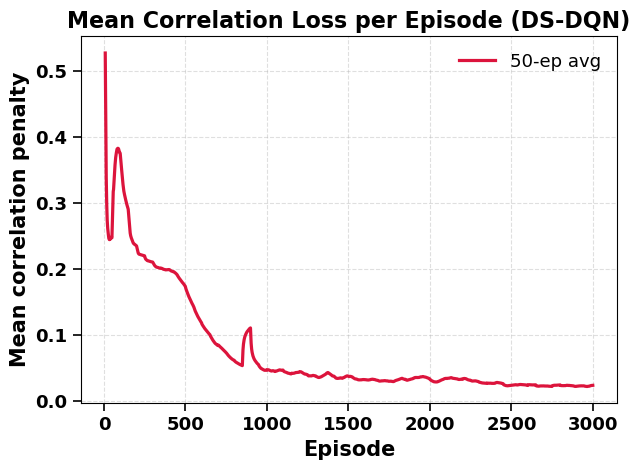

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load vanilla DQN logs
df = pd.read_csv(f"{SAVE_DIR}/train_reward_utilization_corr_summary_dsdqn.csv")
corr_ep_log = df["corr_loss"].values

# Rolling mean helper
def roll(x, w=50):
    return pd.Series(x).rolling(window=w, min_periods=1).mean().to_numpy()

ROLL_WIN = 50

plt.figure()
plt.plot(
    roll(corr_ep_log, ROLL_WIN),
    color="crimson",
    linewidth=2.3,
    label=f"{ROLL_WIN}-ep avg"
)

plt.title("Mean Correlation Loss per Episode (DS-DQN)",
          fontsize=16, weight='semibold')
plt.xlabel("Episode", fontsize=15, weight='bold')
plt.ylabel("Mean correlation penalty", fontsize=15, weight='bold')

plt.xticks(fontsize=13, weight='bold')
plt.yticks(fontsize=13, weight='bold')
plt.tick_params(axis='both', which='major', width=1.2, length=6)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=13, loc="upper right", frameon=False)

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_corrloss_ds-dqn.png",
            format='eps', dpi=600, bbox_inches="tight")
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


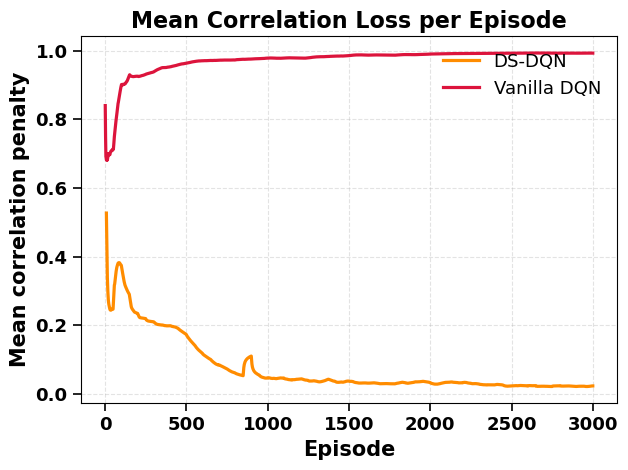

In [107]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load both CSV logs
df_ds = pd.read_csv(f"{SAVE_DIR}/train_reward_utilization_corr_summary_dsdqn.csv")                 # DS-DQN
df_vanilla = pd.read_csv(f"{SAVE_DIR}/train_reward_utilization_corr_summary_vanilla.csv")    # Vanilla DQN

# Extract correlation logs
corr_ds = df_ds["corr_loss"].values
corr_vanilla = df_vanilla["corr_loss"].values

# Rolling mean helper
def roll(x, w=50):
    return pd.Series(x).rolling(window=w, min_periods=1).mean().to_numpy()

ROLL_WIN = 50

# ==========================================================
# Combined Correlation Plot: DS-DQN vs Vanilla DQN
# ==========================================================
plt.figure()

plt.plot(
    roll(corr_ds, ROLL_WIN),
    color="darkorange", linewidth=2.3,
    label="DS-DQN"
)
plt.plot(
    roll(corr_vanilla, ROLL_WIN),
    color="crimson", linewidth=2.3,
    label="Vanilla DQN"
)

# Titles and labels
plt.title("Mean Correlation Loss per Episode", fontsize=16, weight='semibold')
plt.xlabel("Episode", fontsize=15, weight='bold')
plt.ylabel("Mean correlation penalty", fontsize=15, weight='bold')

# Axis styling
plt.xticks(fontsize=13, weight='bold')
plt.yticks(fontsize=13, weight='bold')
plt.tick_params(axis='both', which='major', width=1.2, length=6)

# Grid and legend
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(fontsize=13, loc="upper right", frameon=False)

# Save high-quality EPS for Overleaf
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_corrloss_comparison.eps",
            format='eps', dpi=600, bbox_inches="tight")
plt.show()


In [108]:
# === Cell 5 — Training loop (Vanilla DQN, no decorrelation regularization) ===

EPISODES = 3000
K = 30
BATCH_SIZE = 256
GAMMA = 0.99
TARGET_UPDATE = 50

# ε-greedy schedule
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.995
eps = eps_start

# Vanilla DQN (same DS-DQN architecture, but λ=0 disables decorrelation)
main_net = DS_DQN(STATE_DIM, N_ACTIONS, phi_dim=None,
                  lr_enc=1e-4, lr_w=3e-3).to(device)
target_net = DS_DQN(STATE_DIM, N_ACTIONS, phi_dim=None,
                    lr_enc=1e-4, lr_w=3e-3).to(device)
target_net.encoder.load_state_dict(main_net.encoder.state_dict())
target_net.w.data.copy_(main_net.w.data)

replay = ReplayBuffer(10000)

# Logs
rewards_log, U_log, rho_log = [], [], []
td_log, corr_log, gen_log = [], [], []
w_norms, enc_norms = [], []
corr_ep_log = []

# No correlation regularization
lambda_reg = 0.0

print("\n=== Running Vanilla DQN (λ=0, no decorrelation) ===")

for ep in range(EPISODES):
    idx = np.random.randint(len(TMS_train))
    TM = TMS_train[idx]
    tm_type = META_train.iloc[idx]["gen"]
    state = init_state(TM)

    ep_rewards, ep_Us, ep_rhos = [], [], []
    ep_td_losses, ep_corr_losses = [], []

    for step in range(K):
        s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_vals, _ = main_net.Q(s_tensor)
        if random.random() < eps:
            action = np.random.randint(N_ACTIONS)
        else:
            action = q_vals.argmax(1).item()

        s_next, r, U, rho = apply_action(state, action, TM, lam=0.5, tau=0.8)
        replay.push(state, action, r, s_next, 0.0)
        state = s_next

        ep_rewards.append(r); ep_Us.append(U); ep_rhos.append(rho)

        if len(replay) >= BATCH_SIZE:
            batch = replay.sample(BATCH_SIZE)
            td, corr = main_net.update(batch, target_net, gamma=GAMMA, lambda_reg=lambda_reg)
            td_log.append(td); corr_log.append(corr)
            ep_td_losses.append(td); ep_corr_losses.append(corr)

    rewards_log.append(np.mean(ep_rewards))
    U_log.append(np.mean(ep_Us))
    rho_log.append(np.mean(ep_rhos))
    gen_log.append(tm_type)

    td_ep = np.mean(ep_td_losses) if ep_td_losses else float("nan")
    corr_ep = np.mean(ep_corr_losses) if ep_corr_losses else float("nan")
    corr_ep_log.append(corr_ep)

    print(f"[Ep {ep+1:04d}] eps={eps:.3f} R={np.mean(ep_rewards):+.4f} "
          f"U={np.mean(ep_Us):.3f} ρ={np.mean(ep_rhos):.3f} "
          f"TD={td_ep:.5f} Corr={corr_ep:.5f}")

    if (ep + 1) % TARGET_UPDATE == 0:
        target_net.encoder.load_state_dict(main_net.encoder.state_dict())
        target_net.w.data.copy_(main_net.w.data)

    eps = max(eps_end, eps * eps_decay)

# Save encoder φ(s)
phi_path = DATA_DIR / f"{TOPO_NAME}_phi_trained_vanilla.pth"
torch.save(main_net.encoder.state_dict(), phi_path)
print(f"Saved vanilla encoder to {phi_path}")

# Save logs to CSV
df_summary = pd.DataFrame({
    "episode": np.arange(len(rewards_log)),
    "reward": rewards_log,
    "U": U_log,
    "rho": rho_log,
    "corr_loss": corr_ep_log
})
out_csv = f"{SAVE_DIR}/train_reward_utilization_corr_summary_vanilla-try.csv"
df_summary.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")



=== Running Vanilla DQN (λ=0, no decorrelation) ===
[Ep 0001] eps=1.000 R=+0.5778 U=0.757 ρ=0.087 TD=nan Corr=nan
[Ep 0002] eps=0.995 R=+0.8112 U=0.321 ρ=0.044 TD=nan Corr=nan
[Ep 0003] eps=0.990 R=+0.7476 U=0.447 ρ=0.058 TD=nan Corr=nan
[Ep 0004] eps=0.985 R=+0.5097 U=0.860 ρ=0.121 TD=nan Corr=nan
[Ep 0005] eps=0.980 R=+0.7375 U=0.478 ρ=0.047 TD=nan Corr=nan
[Ep 0006] eps=0.975 R=-0.5682 U=2.896 ρ=0.227 TD=nan Corr=nan
[Ep 0007] eps=0.970 R=+0.5445 U=0.776 ρ=0.135 TD=nan Corr=nan
[Ep 0008] eps=0.966 R=+0.4722 U=0.923 ρ=0.133 TD=nan Corr=nan
[Ep 0009] eps=0.961 R=+0.7669 U=0.411 ρ=0.055 TD=0.11743 Corr=0.52888
[Ep 0010] eps=0.956 R=+0.7001 U=0.548 ρ=0.045 TD=0.00976 Corr=0.61336
[Ep 0011] eps=0.951 R=+0.7117 U=0.492 ρ=0.065 TD=0.00750 Corr=0.66155
[Ep 0012] eps=0.946 R=+0.4200 U=1.041 ρ=0.113 TD=0.00401 Corr=0.68513
[Ep 0013] eps=0.942 R=+0.3726 U=1.120 ρ=0.128 TD=0.00532 Corr=0.69632
[Ep 0014] eps=0.937 R=+0.6403 U=0.642 ρ=0.070 TD=0.00561 Corr=0.67988
[Ep 0015] eps=0.932 R=+0.4563 U

[Ep 0119] eps=0.554 R=+0.1935 U=1.453 ρ=0.120 TD=0.00297 Corr=0.90376
[Ep 0120] eps=0.551 R=+0.1399 U=1.524 ρ=0.149 TD=0.00358 Corr=0.89917
[Ep 0121] eps=0.548 R=+0.6212 U=0.607 ρ=0.064 TD=0.00211 Corr=0.89866
[Ep 0122] eps=0.545 R=+0.5102 U=0.836 ρ=0.090 TD=0.00372 Corr=0.90053
[Ep 0123] eps=0.543 R=+0.7861 U=0.332 ρ=0.029 TD=0.00138 Corr=0.90026
[Ep 0124] eps=0.540 R=+0.6241 U=0.592 ρ=0.093 TD=0.00335 Corr=0.90045
[Ep 0125] eps=0.537 R=+0.4028 U=1.038 ρ=0.110 TD=0.00218 Corr=0.90299
[Ep 0126] eps=0.534 R=+0.1346 U=1.509 ρ=0.175 TD=0.00232 Corr=0.90191
[Ep 0127] eps=0.532 R=-0.9682 U=3.679 ρ=0.178 TD=0.00830 Corr=0.90110
[Ep 0128] eps=0.529 R=+0.6413 U=0.609 ρ=0.049 TD=0.00501 Corr=0.90021
[Ep 0129] eps=0.526 R=+0.7947 U=0.328 ρ=0.016 TD=0.00329 Corr=0.89755
[Ep 0130] eps=0.524 R=+0.5572 U=0.719 ρ=0.080 TD=0.00200 Corr=0.90018
[Ep 0131] eps=0.521 R=+0.7137 U=0.453 ρ=0.066 TD=0.00216 Corr=0.90115
[Ep 0132] eps=0.519 R=+0.4570 U=0.936 ρ=0.096 TD=0.00695 Corr=0.90292
[Ep 0133] eps=0.516 

[Ep 0238] eps=0.305 R=+0.7241 U=0.413 ρ=0.046 TD=0.00222 Corr=0.89423
[Ep 0239] eps=0.303 R=+0.6131 U=0.610 ρ=0.077 TD=0.00242 Corr=0.89298
[Ep 0240] eps=0.302 R=+0.8222 U=0.227 ρ=0.015 TD=0.00268 Corr=0.89040
[Ep 0241] eps=0.300 R=+0.7884 U=0.269 ρ=0.041 TD=0.00311 Corr=0.89132
[Ep 0242] eps=0.299 R=+0.8240 U=0.223 ρ=0.023 TD=0.00328 Corr=0.89381
[Ep 0243] eps=0.297 R=+0.6928 U=0.456 ρ=0.025 TD=0.00529 Corr=0.89457
[Ep 0244] eps=0.296 R=+0.7480 U=0.393 ρ=0.038 TD=0.00363 Corr=0.89334
[Ep 0245] eps=0.294 R=+0.8936 U=0.095 ρ=0.011 TD=0.00413 Corr=0.89497
[Ep 0246] eps=0.293 R=+0.4864 U=0.847 ρ=0.093 TD=0.00354 Corr=0.89293
[Ep 0247] eps=0.291 R=+0.5301 U=0.768 ρ=0.098 TD=0.00342 Corr=0.89414
[Ep 0248] eps=0.290 R=+0.7749 U=0.312 ρ=0.031 TD=0.00371 Corr=0.89652
[Ep 0249] eps=0.288 R=+0.8081 U=0.261 ρ=0.023 TD=0.00293 Corr=0.89691
[Ep 0250] eps=0.287 R=+0.7985 U=0.262 ρ=0.028 TD=0.00296 Corr=0.89139
[Ep 0251] eps=0.286 R=+0.7693 U=0.352 ρ=0.030 TD=0.24789 Corr=0.87327
[Ep 0252] eps=0.284 

[Ep 0356] eps=0.169 R=+0.8136 U=0.239 ρ=0.027 TD=0.00888 Corr=0.84851
[Ep 0357] eps=0.168 R=+0.5875 U=0.675 ρ=0.043 TD=0.00670 Corr=0.85146
[Ep 0358] eps=0.167 R=+0.6179 U=0.582 ρ=0.049 TD=0.00674 Corr=0.85202
[Ep 0359] eps=0.166 R=+0.6483 U=0.539 ρ=0.044 TD=0.00542 Corr=0.84935
[Ep 0360] eps=0.165 R=+0.7896 U=0.271 ρ=0.023 TD=0.00477 Corr=0.85160
[Ep 0361] eps=0.165 R=+0.5823 U=0.657 ρ=0.058 TD=0.00511 Corr=0.85254
[Ep 0362] eps=0.164 R=+0.7695 U=0.310 ρ=0.031 TD=0.00401 Corr=0.85508
[Ep 0363] eps=0.163 R=+0.8587 U=0.134 ρ=0.015 TD=0.00416 Corr=0.85514
[Ep 0364] eps=0.162 R=+0.6133 U=0.606 ρ=0.047 TD=0.00390 Corr=0.85361
[Ep 0365] eps=0.161 R=+0.5262 U=0.757 ρ=0.064 TD=0.00391 Corr=0.85437
[Ep 0366] eps=0.160 R=+0.8331 U=0.211 ρ=0.016 TD=0.00440 Corr=0.85720
[Ep 0367] eps=0.160 R=+0.7950 U=0.254 ρ=0.030 TD=0.00453 Corr=0.85698
[Ep 0368] eps=0.159 R=+0.8526 U=0.130 ρ=0.011 TD=0.00361 Corr=0.85415
[Ep 0369] eps=0.158 R=+0.8500 U=0.148 ρ=0.012 TD=0.00350 Corr=0.85541
[Ep 0370] eps=0.157 

[Ep 0474] eps=0.093 R=+0.8083 U=0.235 ρ=0.021 TD=0.00395 Corr=0.84882
[Ep 0475] eps=0.093 R=+0.8695 U=0.129 ρ=0.012 TD=0.00378 Corr=0.84870
[Ep 0476] eps=0.092 R=+0.8773 U=0.097 ρ=0.009 TD=0.00383 Corr=0.85037
[Ep 0477] eps=0.092 R=+0.7950 U=0.249 ρ=0.021 TD=0.00449 Corr=0.85187
[Ep 0478] eps=0.092 R=+0.6512 U=0.526 ρ=0.032 TD=0.00570 Corr=0.85053
[Ep 0479] eps=0.091 R=+0.8192 U=0.187 ρ=0.015 TD=0.00580 Corr=0.85119
[Ep 0480] eps=0.091 R=+0.6803 U=0.441 ρ=0.025 TD=0.00528 Corr=0.85082
[Ep 0481] eps=0.090 R=+0.7466 U=0.345 ρ=0.029 TD=0.00467 Corr=0.85223
[Ep 0482] eps=0.090 R=+0.5536 U=0.697 ρ=0.062 TD=0.00438 Corr=0.85034
[Ep 0483] eps=0.089 R=+0.6607 U=0.525 ρ=0.027 TD=0.00457 Corr=0.85316
[Ep 0484] eps=0.089 R=+0.8549 U=0.152 ρ=0.011 TD=0.00479 Corr=0.85466
[Ep 0485] eps=0.088 R=+0.6896 U=0.478 ρ=0.043 TD=0.00533 Corr=0.85155
[Ep 0486] eps=0.088 R=+0.6534 U=0.519 ρ=0.048 TD=0.00527 Corr=0.85350
[Ep 0487] eps=0.088 R=+0.4429 U=0.909 ρ=0.052 TD=0.00532 Corr=0.85423
[Ep 0488] eps=0.087 

[Ep 0592] eps=0.052 R=+0.8018 U=0.257 ρ=0.026 TD=0.00708 Corr=0.84920
[Ep 0593] eps=0.051 R=+0.4551 U=0.885 ρ=0.044 TD=0.00736 Corr=0.84633
[Ep 0594] eps=0.051 R=+0.7158 U=0.389 ρ=0.026 TD=0.00786 Corr=0.84838
[Ep 0595] eps=0.051 R=+0.7101 U=0.409 ρ=0.024 TD=0.00736 Corr=0.84549
[Ep 0596] eps=0.051 R=+0.8149 U=0.207 ρ=0.016 TD=0.00701 Corr=0.84979
[Ep 0597] eps=0.050 R=+0.8315 U=0.166 ρ=0.011 TD=0.00654 Corr=0.84613
[Ep 0598] eps=0.050 R=+0.5424 U=0.715 ρ=0.040 TD=0.00633 Corr=0.84933
[Ep 0599] eps=0.050 R=+0.6364 U=0.546 ρ=0.074 TD=0.00744 Corr=0.84827
[Ep 0600] eps=0.050 R=+0.5830 U=0.641 ρ=0.060 TD=0.00702 Corr=0.84963
[Ep 0601] eps=0.050 R=+0.7925 U=0.261 ρ=0.021 TD=0.26511 Corr=0.82005
[Ep 0602] eps=0.050 R=+0.4633 U=0.867 ρ=0.066 TD=0.08961 Corr=0.83400
[Ep 0603] eps=0.050 R=+0.8895 U=0.085 ρ=0.009 TD=0.03977 Corr=0.83996
[Ep 0604] eps=0.050 R=+0.5454 U=0.733 ρ=0.036 TD=0.02090 Corr=0.84493
[Ep 0605] eps=0.050 R=+0.7470 U=0.352 ρ=0.021 TD=0.01614 Corr=0.84399
[Ep 0606] eps=0.050 

[Ep 0710] eps=0.050 R=+0.6026 U=0.603 ρ=0.032 TD=0.00697 Corr=0.84064
[Ep 0711] eps=0.050 R=-0.0021 U=1.816 ρ=0.041 TD=0.00626 Corr=0.84194
[Ep 0712] eps=0.050 R=+0.7893 U=0.255 ρ=0.013 TD=0.01083 Corr=0.84158
[Ep 0713] eps=0.050 R=+0.8659 U=0.124 ρ=0.011 TD=0.00680 Corr=0.84205
[Ep 0714] eps=0.050 R=+0.7801 U=0.265 ρ=0.015 TD=0.00537 Corr=0.84578
[Ep 0715] eps=0.050 R=+0.6354 U=0.546 ρ=0.037 TD=0.00460 Corr=0.84281
[Ep 0716] eps=0.050 R=+0.8348 U=0.160 ρ=0.010 TD=0.00566 Corr=0.84222
[Ep 0717] eps=0.050 R=+0.8731 U=0.099 ρ=0.008 TD=0.00506 Corr=0.84402
[Ep 0718] eps=0.050 R=+0.8601 U=0.118 ρ=0.009 TD=0.00413 Corr=0.84311
[Ep 0719] eps=0.050 R=+0.8269 U=0.177 ρ=0.009 TD=0.00511 Corr=0.83982
[Ep 0720] eps=0.050 R=+0.6942 U=0.428 ρ=0.051 TD=0.00484 Corr=0.84435
[Ep 0721] eps=0.050 R=+0.8499 U=0.156 ρ=0.011 TD=0.00396 Corr=0.84414
[Ep 0722] eps=0.050 R=+0.8660 U=0.111 ρ=0.010 TD=0.00448 Corr=0.84548
[Ep 0723] eps=0.050 R=+0.7580 U=0.330 ρ=0.020 TD=0.00469 Corr=0.84340
[Ep 0724] eps=0.050 

[Ep 0828] eps=0.050 R=+0.8846 U=0.073 ρ=0.004 TD=0.00420 Corr=0.86701
[Ep 0829] eps=0.050 R=+0.6713 U=0.478 ρ=0.026 TD=0.00464 Corr=0.86726
[Ep 0830] eps=0.050 R=+0.6931 U=0.432 ρ=0.015 TD=0.00578 Corr=0.86758
[Ep 0831] eps=0.050 R=+0.7473 U=0.348 ρ=0.031 TD=0.00401 Corr=0.86771
[Ep 0832] eps=0.050 R=+0.6245 U=0.570 ρ=0.041 TD=0.00822 Corr=0.86798
[Ep 0833] eps=0.050 R=+0.8109 U=0.217 ρ=0.021 TD=0.00488 Corr=0.86924
[Ep 0834] eps=0.050 R=+0.8673 U=0.097 ρ=0.008 TD=0.00354 Corr=0.86943
[Ep 0835] eps=0.050 R=+0.1098 U=1.540 ρ=0.107 TD=0.00493 Corr=0.86994
[Ep 0836] eps=0.050 R=+0.8607 U=0.109 ρ=0.009 TD=0.00552 Corr=0.87114
[Ep 0837] eps=0.050 R=+0.8966 U=0.032 ρ=0.001 TD=0.00500 Corr=0.86938
[Ep 0838] eps=0.050 R=+0.7085 U=0.405 ρ=0.025 TD=0.00498 Corr=0.86904
[Ep 0839] eps=0.050 R=+0.8425 U=0.151 ρ=0.011 TD=0.00623 Corr=0.86800
[Ep 0840] eps=0.050 R=+0.8710 U=0.079 ρ=0.006 TD=0.01051 Corr=0.86877
[Ep 0841] eps=0.050 R=+0.8318 U=0.173 ρ=0.010 TD=0.00584 Corr=0.87005
[Ep 0842] eps=0.050 

[Ep 0947] eps=0.050 R=+0.7991 U=0.225 ρ=0.023 TD=0.00827 Corr=0.89052
[Ep 0948] eps=0.050 R=+0.8618 U=0.115 ρ=0.008 TD=0.00794 Corr=0.88864
[Ep 0949] eps=0.050 R=+0.7558 U=0.297 ρ=0.018 TD=0.00412 Corr=0.89096
[Ep 0950] eps=0.050 R=+0.8015 U=0.225 ρ=0.012 TD=0.00513 Corr=0.89178
[Ep 0951] eps=0.050 R=+0.7577 U=0.341 ρ=0.024 TD=0.30302 Corr=0.89283
[Ep 0952] eps=0.050 R=+0.6780 U=0.470 ρ=0.034 TD=0.09188 Corr=0.89093
[Ep 0953] eps=0.050 R=+0.7412 U=0.334 ρ=0.017 TD=0.03730 Corr=0.89684
[Ep 0954] eps=0.050 R=+0.8585 U=0.109 ρ=0.007 TD=0.02124 Corr=0.89882
[Ep 0955] eps=0.050 R=+0.8442 U=0.140 ρ=0.012 TD=0.01497 Corr=0.89754
[Ep 0956] eps=0.050 R=+0.5573 U=0.678 ρ=0.061 TD=0.01388 Corr=0.89797
[Ep 0957] eps=0.050 R=+0.8852 U=0.047 ρ=0.002 TD=0.00624 Corr=0.89744
[Ep 0958] eps=0.050 R=+0.8732 U=0.087 ρ=0.006 TD=0.00613 Corr=0.89766
[Ep 0959] eps=0.050 R=+0.5439 U=0.711 ρ=0.048 TD=0.00531 Corr=0.90077
[Ep 0960] eps=0.050 R=+0.6637 U=0.495 ρ=0.058 TD=0.00511 Corr=0.89655
[Ep 0961] eps=0.050 

[Ep 1065] eps=0.050 R=+0.7614 U=0.301 ρ=0.016 TD=0.00416 Corr=0.90848
[Ep 1066] eps=0.050 R=+0.8619 U=0.097 ρ=0.006 TD=0.00435 Corr=0.90636
[Ep 1067] eps=0.050 R=+0.8729 U=0.094 ρ=0.007 TD=0.00500 Corr=0.90398
[Ep 1068] eps=0.050 R=+0.6654 U=0.502 ρ=0.040 TD=0.00486 Corr=0.90848
[Ep 1069] eps=0.050 R=+0.7561 U=0.293 ρ=0.014 TD=0.00417 Corr=0.90758
[Ep 1070] eps=0.050 R=+0.6250 U=0.557 ρ=0.033 TD=0.00404 Corr=0.90828
[Ep 1071] eps=0.050 R=+0.4918 U=0.790 ρ=0.100 TD=0.00514 Corr=0.90655
[Ep 1072] eps=0.050 R=+0.8717 U=0.100 ρ=0.010 TD=0.00391 Corr=0.90723
[Ep 1073] eps=0.050 R=+0.6772 U=0.448 ρ=0.031 TD=0.01715 Corr=0.90795
[Ep 1074] eps=0.050 R=+0.8065 U=0.217 ρ=0.010 TD=0.01020 Corr=0.90718
[Ep 1075] eps=0.050 R=+0.8116 U=0.212 ρ=0.012 TD=0.00746 Corr=0.90724
[Ep 1076] eps=0.050 R=+0.1433 U=1.526 ρ=0.054 TD=0.01953 Corr=0.90710
[Ep 1077] eps=0.050 R=+0.7036 U=0.407 ρ=0.039 TD=0.00995 Corr=0.90746
[Ep 1078] eps=0.050 R=+0.7057 U=0.407 ρ=0.035 TD=0.00709 Corr=0.90744
[Ep 1079] eps=0.050 

[Ep 1183] eps=0.050 R=+0.8196 U=0.199 ρ=0.015 TD=0.07547 Corr=0.90473
[Ep 1184] eps=0.050 R=+0.8890 U=0.071 ρ=0.004 TD=0.02817 Corr=0.90304
[Ep 1185] eps=0.050 R=+0.8838 U=0.062 ρ=0.003 TD=0.01192 Corr=0.90401
[Ep 1186] eps=0.050 R=+0.7031 U=0.425 ρ=0.029 TD=0.01093 Corr=0.90400
[Ep 1187] eps=0.050 R=+0.8239 U=0.190 ρ=0.016 TD=0.00640 Corr=0.90619
[Ep 1188] eps=0.050 R=+0.6323 U=0.557 ρ=0.011 TD=0.00765 Corr=0.90312
[Ep 1189] eps=0.050 R=+0.6575 U=0.490 ρ=0.042 TD=0.00720 Corr=0.90657
[Ep 1190] eps=0.050 R=+0.6763 U=0.471 ρ=0.036 TD=0.00696 Corr=0.90538
[Ep 1191] eps=0.050 R=+0.5144 U=0.768 ρ=0.056 TD=0.01731 Corr=0.90336
[Ep 1192] eps=0.050 R=+0.7307 U=0.385 ρ=0.027 TD=0.00749 Corr=0.90495
[Ep 1193] eps=0.050 R=+0.5848 U=0.651 ρ=0.046 TD=0.04439 Corr=0.90553
[Ep 1194] eps=0.050 R=+0.8530 U=0.124 ρ=0.010 TD=0.03085 Corr=0.90559
[Ep 1195] eps=0.050 R=+0.6503 U=0.500 ρ=0.032 TD=0.00970 Corr=0.90495
[Ep 1196] eps=0.050 R=+0.8772 U=0.082 ρ=0.004 TD=0.01026 Corr=0.90634
[Ep 1197] eps=0.050 

[Ep 1301] eps=0.050 R=+0.7599 U=0.331 ρ=0.022 TD=0.47178 Corr=0.91323
[Ep 1302] eps=0.050 R=+0.6979 U=0.412 ρ=0.039 TD=0.13413 Corr=0.90713
[Ep 1303] eps=0.050 R=+0.7418 U=0.338 ρ=0.018 TD=0.05358 Corr=0.91180
[Ep 1304] eps=0.050 R=+0.8110 U=0.206 ρ=0.018 TD=0.03080 Corr=0.91294
[Ep 1305] eps=0.050 R=+0.7924 U=0.242 ρ=0.020 TD=0.01752 Corr=0.91157
[Ep 1306] eps=0.050 R=+0.7779 U=0.276 ρ=0.021 TD=0.03801 Corr=0.91203
[Ep 1307] eps=0.050 R=+0.8333 U=0.149 ρ=0.011 TD=0.01015 Corr=0.91235
[Ep 1308] eps=0.050 R=+0.7255 U=0.399 ρ=0.024 TD=0.01131 Corr=0.91287
[Ep 1309] eps=0.050 R=+0.8433 U=0.146 ρ=0.014 TD=0.00839 Corr=0.91186
[Ep 1310] eps=0.050 R=+0.7757 U=0.272 ρ=0.023 TD=0.00764 Corr=0.91212
[Ep 1311] eps=0.050 R=+0.1534 U=1.463 ρ=0.083 TD=0.00827 Corr=0.91254
[Ep 1312] eps=0.050 R=+0.8429 U=0.147 ρ=0.014 TD=0.00604 Corr=0.91162
[Ep 1313] eps=0.050 R=+0.8529 U=0.114 ρ=0.007 TD=0.00548 Corr=0.91190
[Ep 1314] eps=0.050 R=+0.7555 U=0.301 ρ=0.021 TD=0.00591 Corr=0.91227
[Ep 1315] eps=0.050 

[Ep 1420] eps=0.050 R=+0.8663 U=0.108 ρ=0.006 TD=0.01761 Corr=0.93272
[Ep 1421] eps=0.050 R=+0.5876 U=0.645 ρ=0.046 TD=0.01442 Corr=0.93241
[Ep 1422] eps=0.050 R=+0.7462 U=0.338 ρ=0.023 TD=0.01748 Corr=0.93301
[Ep 1423] eps=0.050 R=+0.8613 U=0.099 ρ=0.005 TD=0.00601 Corr=0.93344
[Ep 1424] eps=0.050 R=+0.5288 U=0.733 ρ=0.050 TD=0.01304 Corr=0.93390
[Ep 1425] eps=0.050 R=+0.8708 U=0.081 ρ=0.005 TD=0.00576 Corr=0.93273
[Ep 1426] eps=0.050 R=+0.6339 U=0.556 ρ=0.029 TD=0.00859 Corr=0.93190
[Ep 1427] eps=0.050 R=+0.8774 U=0.107 ρ=0.012 TD=0.00695 Corr=0.93365
[Ep 1428] eps=0.050 R=-0.4947 U=2.692 ρ=0.137 TD=0.00621 Corr=0.93334
[Ep 1429] eps=0.050 R=+0.8707 U=0.101 ρ=0.005 TD=0.00748 Corr=0.93252
[Ep 1430] eps=0.050 R=+0.8199 U=0.205 ρ=0.015 TD=0.00648 Corr=0.93183
[Ep 1431] eps=0.050 R=+0.7421 U=0.330 ρ=0.013 TD=0.00588 Corr=0.93340
[Ep 1432] eps=0.050 R=+0.8657 U=0.115 ρ=0.007 TD=0.00551 Corr=0.93317
[Ep 1433] eps=0.050 R=+0.5666 U=0.661 ρ=0.053 TD=0.00639 Corr=0.93229
[Ep 1434] eps=0.050 

[Ep 1539] eps=0.050 R=+0.7099 U=0.406 ρ=0.034 TD=0.05289 Corr=0.93255
[Ep 1540] eps=0.050 R=+0.6250 U=0.573 ρ=0.030 TD=0.01283 Corr=0.93165
[Ep 1541] eps=0.050 R=+0.5484 U=0.697 ρ=0.059 TD=0.01049 Corr=0.93359
[Ep 1542] eps=0.050 R=+0.7234 U=0.356 ρ=0.024 TD=0.01122 Corr=0.93269
[Ep 1543] eps=0.050 R=+0.8355 U=0.182 ρ=0.014 TD=0.04646 Corr=0.93259
[Ep 1544] eps=0.050 R=+0.4216 U=0.963 ρ=0.054 TD=0.08621 Corr=0.93353
[Ep 1545] eps=0.050 R=+0.7065 U=0.401 ρ=0.025 TD=0.01043 Corr=0.93279
[Ep 1546] eps=0.050 R=+0.7126 U=0.418 ρ=0.037 TD=0.07512 Corr=0.93259
[Ep 1547] eps=0.050 R=+0.6924 U=0.439 ρ=0.030 TD=0.05226 Corr=0.93348
[Ep 1548] eps=0.050 R=+0.8771 U=0.121 ρ=0.012 TD=0.05842 Corr=0.93338
[Ep 1549] eps=0.050 R=+0.7275 U=0.370 ρ=0.028 TD=0.01026 Corr=0.93230
[Ep 1550] eps=0.050 R=+0.8815 U=0.087 ρ=0.010 TD=0.01466 Corr=0.93293
[Ep 1551] eps=0.050 R=+0.6138 U=0.600 ρ=0.046 TD=0.30805 Corr=0.92531
[Ep 1552] eps=0.050 R=+0.8295 U=0.216 ρ=0.024 TD=0.08139 Corr=0.93032
[Ep 1553] eps=0.050 

[Ep 1658] eps=0.050 R=+0.7730 U=0.290 ρ=0.018 TD=0.01448 Corr=0.93385
[Ep 1659] eps=0.050 R=+0.8452 U=0.160 ρ=0.010 TD=0.00861 Corr=0.93180
[Ep 1660] eps=0.050 R=+0.7431 U=0.336 ρ=0.025 TD=0.00948 Corr=0.93320
[Ep 1661] eps=0.050 R=+0.8350 U=0.181 ρ=0.023 TD=0.00911 Corr=0.93210
[Ep 1662] eps=0.050 R=+0.6644 U=0.514 ρ=0.024 TD=0.00689 Corr=0.93169
[Ep 1663] eps=0.050 R=+0.8816 U=0.078 ρ=0.006 TD=0.00553 Corr=0.93188
[Ep 1664] eps=0.050 R=+0.6765 U=0.466 ρ=0.034 TD=0.00626 Corr=0.93258
[Ep 1665] eps=0.050 R=+0.6175 U=0.587 ρ=0.058 TD=0.00685 Corr=0.93155
[Ep 1666] eps=0.050 R=+0.8296 U=0.186 ρ=0.015 TD=0.00533 Corr=0.93172
[Ep 1667] eps=0.050 R=+0.7952 U=0.246 ρ=0.011 TD=0.00502 Corr=0.93185
[Ep 1668] eps=0.050 R=+0.6645 U=0.490 ρ=0.027 TD=0.00832 Corr=0.93244
[Ep 1669] eps=0.050 R=+0.8354 U=0.182 ρ=0.014 TD=0.00563 Corr=0.93241
[Ep 1670] eps=0.050 R=+0.5879 U=0.640 ρ=0.024 TD=0.02329 Corr=0.93315
[Ep 1671] eps=0.050 R=+0.6347 U=0.528 ρ=0.063 TD=0.00540 Corr=0.93183
[Ep 1672] eps=0.050 

[Ep 1776] eps=0.050 R=+0.5700 U=0.658 ρ=0.048 TD=0.01067 Corr=0.93787
[Ep 1777] eps=0.050 R=+0.7293 U=0.354 ρ=0.014 TD=0.03984 Corr=0.93821
[Ep 1778] eps=0.050 R=+0.8964 U=0.037 ρ=0.003 TD=0.02880 Corr=0.93833
[Ep 1779] eps=0.050 R=+0.8829 U=0.070 ρ=0.004 TD=0.02215 Corr=0.93709
[Ep 1780] eps=0.050 R=+0.8443 U=0.155 ρ=0.010 TD=0.01244 Corr=0.93821
[Ep 1781] eps=0.050 R=+0.8624 U=0.133 ρ=0.009 TD=0.01293 Corr=0.93798
[Ep 1782] eps=0.050 R=+0.7490 U=0.313 ρ=0.016 TD=0.01188 Corr=0.93829
[Ep 1783] eps=0.050 R=+0.8571 U=0.123 ρ=0.010 TD=0.01274 Corr=0.93777
[Ep 1784] eps=0.050 R=+0.8327 U=0.153 ρ=0.008 TD=0.16797 Corr=0.93871
[Ep 1785] eps=0.050 R=+0.5914 U=0.608 ρ=0.056 TD=0.06151 Corr=0.93953
[Ep 1786] eps=0.050 R=+0.6518 U=0.511 ρ=0.032 TD=0.01116 Corr=0.94020
[Ep 1787] eps=0.050 R=+0.8451 U=0.147 ρ=0.009 TD=0.08797 Corr=0.93985
[Ep 1788] eps=0.050 R=+0.7799 U=0.285 ρ=0.022 TD=0.07112 Corr=0.94054
[Ep 1789] eps=0.050 R=+0.8738 U=0.082 ρ=0.004 TD=0.06227 Corr=0.94212
[Ep 1790] eps=0.050 

[Ep 1894] eps=0.050 R=+0.6186 U=0.609 ρ=0.027 TD=0.01123 Corr=0.94271
[Ep 1895] eps=0.050 R=+0.7282 U=0.369 ρ=0.028 TD=0.00748 Corr=0.94220
[Ep 1896] eps=0.050 R=+0.8075 U=0.238 ρ=0.014 TD=0.00649 Corr=0.94308
[Ep 1897] eps=0.050 R=+0.7616 U=0.336 ρ=0.020 TD=0.00739 Corr=0.94359
[Ep 1898] eps=0.050 R=+0.7342 U=0.375 ρ=0.036 TD=0.01770 Corr=0.94323
[Ep 1899] eps=0.050 R=+0.6677 U=0.492 ρ=0.053 TD=0.02503 Corr=0.94260
[Ep 1900] eps=0.050 R=+0.6668 U=0.485 ρ=0.041 TD=0.01143 Corr=0.94297
[Ep 1901] eps=0.050 R=+0.7818 U=0.270 ρ=0.020 TD=0.31665 Corr=0.93091
[Ep 1902] eps=0.050 R=+0.8281 U=0.173 ρ=0.010 TD=0.11056 Corr=0.93648
[Ep 1903] eps=0.050 R=+0.6729 U=0.469 ρ=0.052 TD=0.04283 Corr=0.93748
[Ep 1904] eps=0.050 R=+0.5755 U=0.672 ρ=0.030 TD=0.10639 Corr=0.93867
[Ep 1905] eps=0.050 R=+0.4148 U=0.972 ρ=0.052 TD=0.02165 Corr=0.93827
[Ep 1906] eps=0.050 R=+0.4272 U=0.951 ρ=0.055 TD=0.07692 Corr=0.93809
[Ep 1907] eps=0.050 R=+0.5642 U=0.679 ρ=0.033 TD=0.01555 Corr=0.93846
[Ep 1908] eps=0.050 

[Ep 2013] eps=0.050 R=+0.8200 U=0.200 ρ=0.020 TD=0.07438 Corr=0.94218
[Ep 2014] eps=0.050 R=+0.8255 U=0.205 ρ=0.017 TD=0.09658 Corr=0.94228
[Ep 2015] eps=0.050 R=+0.6115 U=0.575 ρ=0.062 TD=0.08136 Corr=0.94077
[Ep 2016] eps=0.050 R=+0.7510 U=0.333 ρ=0.024 TD=0.02933 Corr=0.94270
[Ep 2017] eps=0.050 R=+0.7046 U=0.399 ρ=0.039 TD=0.01391 Corr=0.94281
[Ep 2018] eps=0.050 R=+0.6373 U=0.555 ρ=0.037 TD=0.05369 Corr=0.94265
[Ep 2019] eps=0.050 R=+0.7860 U=0.269 ρ=0.032 TD=0.05397 Corr=0.94273
[Ep 2020] eps=0.050 R=+0.4148 U=0.962 ρ=0.068 TD=0.01014 Corr=0.94176
[Ep 2021] eps=0.050 R=+0.1298 U=1.506 ρ=0.074 TD=0.04391 Corr=0.94141
[Ep 2022] eps=0.050 R=+0.3724 U=1.042 ρ=0.086 TD=0.00779 Corr=0.94150
[Ep 2023] eps=0.050 R=+0.7892 U=0.269 ρ=0.019 TD=0.03327 Corr=0.94222
[Ep 2024] eps=0.050 R=+0.8261 U=0.209 ρ=0.019 TD=0.06101 Corr=0.94099
[Ep 2025] eps=0.050 R=+0.6032 U=0.606 ρ=0.041 TD=0.01804 Corr=0.94094
[Ep 2026] eps=0.050 R=+0.8783 U=0.079 ρ=0.005 TD=0.04568 Corr=0.94063
[Ep 2027] eps=0.050 

[Ep 2131] eps=0.050 R=+0.7596 U=0.306 ρ=0.021 TD=0.01374 Corr=0.94312
[Ep 2132] eps=0.050 R=+0.8476 U=0.149 ρ=0.009 TD=0.00696 Corr=0.94296
[Ep 2133] eps=0.050 R=+0.8286 U=0.184 ρ=0.012 TD=0.01188 Corr=0.94438
[Ep 2134] eps=0.050 R=+0.9049 U=0.035 ρ=0.002 TD=0.01307 Corr=0.94334
[Ep 2135] eps=0.050 R=+0.5931 U=0.630 ρ=0.030 TD=0.01538 Corr=0.94281
[Ep 2136] eps=0.050 R=+0.2169 U=1.380 ρ=0.033 TD=0.01382 Corr=0.94258
[Ep 2137] eps=0.050 R=+0.5561 U=0.701 ρ=0.033 TD=0.00822 Corr=0.94360
[Ep 2138] eps=0.050 R=+0.8208 U=0.207 ρ=0.018 TD=0.00857 Corr=0.94170
[Ep 2139] eps=0.050 R=+0.6327 U=0.548 ρ=0.040 TD=0.00785 Corr=0.94201
[Ep 2140] eps=0.050 R=+0.8722 U=0.131 ρ=0.011 TD=0.01122 Corr=0.94192
[Ep 2141] eps=0.050 R=+0.5898 U=0.626 ρ=0.041 TD=0.00917 Corr=0.94298
[Ep 2142] eps=0.050 R=+0.7276 U=0.364 ρ=0.034 TD=0.01907 Corr=0.94340
[Ep 2143] eps=0.050 R=+0.8457 U=0.174 ρ=0.008 TD=0.00657 Corr=0.94251
[Ep 2144] eps=0.050 R=+0.5795 U=0.677 ρ=0.038 TD=0.00707 Corr=0.94271
[Ep 2145] eps=0.050 

[Ep 2250] eps=0.050 R=+0.8694 U=0.094 ρ=0.007 TD=0.00981 Corr=0.93733
[Ep 2251] eps=0.050 R=+0.5413 U=0.697 ρ=0.094 TD=0.47028 Corr=0.92488
[Ep 2252] eps=0.050 R=+0.5982 U=0.588 ρ=0.056 TD=0.19715 Corr=0.92682
[Ep 2253] eps=0.050 R=+0.4084 U=0.988 ρ=0.042 TD=0.09985 Corr=0.93159
[Ep 2254] eps=0.050 R=+0.8316 U=0.180 ρ=0.024 TD=0.03422 Corr=0.93231
[Ep 2255] eps=0.050 R=+0.7882 U=0.266 ρ=0.017 TD=0.06564 Corr=0.93283
[Ep 2256] eps=0.050 R=+0.7021 U=0.416 ρ=0.033 TD=0.06020 Corr=0.93304
[Ep 2257] eps=0.050 R=+0.4870 U=0.809 ρ=0.077 TD=0.02175 Corr=0.93162
[Ep 2258] eps=0.050 R=+0.7088 U=0.402 ρ=0.027 TD=0.13934 Corr=0.93165
[Ep 2259] eps=0.050 R=+0.6990 U=0.436 ρ=0.026 TD=0.10065 Corr=0.93237
[Ep 2260] eps=0.050 R=+0.6416 U=0.520 ρ=0.050 TD=0.03268 Corr=0.93392
[Ep 2261] eps=0.050 R=+0.4040 U=0.967 ρ=0.079 TD=0.06572 Corr=0.93361
[Ep 2262] eps=0.050 R=+0.9039 U=0.030 ρ=0.003 TD=0.03859 Corr=0.93198
[Ep 2263] eps=0.050 R=+0.8064 U=0.220 ρ=0.020 TD=0.00778 Corr=0.93310
[Ep 2264] eps=0.050 

[Ep 2368] eps=0.050 R=+0.7854 U=0.299 ρ=0.024 TD=0.03784 Corr=0.93943
[Ep 2369] eps=0.050 R=+0.8667 U=0.138 ρ=0.008 TD=0.03389 Corr=0.94146
[Ep 2370] eps=0.050 R=+0.7893 U=0.266 ρ=0.016 TD=0.03091 Corr=0.93979
[Ep 2371] eps=0.050 R=+0.4977 U=0.799 ρ=0.072 TD=0.05470 Corr=0.93924
[Ep 2372] eps=0.050 R=+0.6247 U=0.590 ρ=0.048 TD=0.01828 Corr=0.94002
[Ep 2373] eps=0.050 R=+0.5795 U=0.670 ρ=0.045 TD=0.02362 Corr=0.93909
[Ep 2374] eps=0.050 R=+0.1542 U=1.474 ρ=0.078 TD=0.01743 Corr=0.94046
[Ep 2375] eps=0.050 R=+0.6540 U=0.530 ρ=0.042 TD=0.01954 Corr=0.94032
[Ep 2376] eps=0.050 R=+0.7268 U=0.373 ρ=0.026 TD=0.01666 Corr=0.93924
[Ep 2377] eps=0.050 R=+0.4507 U=0.845 ρ=0.101 TD=0.01096 Corr=0.93899
[Ep 2378] eps=0.050 R=+0.9058 U=0.027 ρ=0.002 TD=0.09677 Corr=0.94099
[Ep 2379] eps=0.050 R=+0.7594 U=0.302 ρ=0.012 TD=0.01597 Corr=0.94019
[Ep 2380] eps=0.050 R=+0.7707 U=0.285 ρ=0.021 TD=0.04900 Corr=0.94023
[Ep 2381] eps=0.050 R=+0.6194 U=0.560 ρ=0.035 TD=0.01892 Corr=0.94106
[Ep 2382] eps=0.050 

[Ep 2486] eps=0.050 R=+0.3062 U=1.191 ρ=0.064 TD=0.00979 Corr=0.94386
[Ep 2487] eps=0.050 R=+0.8640 U=0.104 ρ=0.008 TD=0.00767 Corr=0.94390
[Ep 2488] eps=0.050 R=+0.6555 U=0.504 ρ=0.031 TD=0.00849 Corr=0.94348
[Ep 2489] eps=0.050 R=+0.6228 U=0.555 ρ=0.046 TD=0.03229 Corr=0.94400
[Ep 2490] eps=0.050 R=+0.6863 U=0.446 ρ=0.028 TD=0.04948 Corr=0.94435
[Ep 2491] eps=0.050 R=+0.8039 U=0.242 ρ=0.016 TD=0.06581 Corr=0.94535
[Ep 2492] eps=0.050 R=+0.9081 U=0.035 ρ=0.002 TD=0.01971 Corr=0.94596
[Ep 2493] eps=0.050 R=+0.8649 U=0.092 ρ=0.005 TD=0.01513 Corr=0.94575
[Ep 2494] eps=0.050 R=+0.6724 U=0.479 ρ=0.029 TD=0.10300 Corr=0.94419
[Ep 2495] eps=0.050 R=+0.8831 U=0.086 ρ=0.008 TD=0.05965 Corr=0.94471
[Ep 2496] eps=0.050 R=+0.8380 U=0.178 ρ=0.013 TD=0.02591 Corr=0.94507
[Ep 2497] eps=0.050 R=+0.8684 U=0.084 ρ=0.006 TD=0.02167 Corr=0.94514
[Ep 2498] eps=0.050 R=+0.7839 U=0.263 ρ=0.023 TD=0.01820 Corr=0.94618
[Ep 2499] eps=0.050 R=+0.5677 U=0.677 ρ=0.041 TD=0.02251 Corr=0.94575
[Ep 2500] eps=0.050 

[Ep 2605] eps=0.050 R=+0.8940 U=0.079 ρ=0.006 TD=0.06676 Corr=0.94553
[Ep 2606] eps=0.050 R=+0.7004 U=0.419 ρ=0.027 TD=0.04475 Corr=0.94580
[Ep 2607] eps=0.050 R=+0.6683 U=0.488 ρ=0.035 TD=0.03468 Corr=0.94689
[Ep 2608] eps=0.050 R=+0.8442 U=0.151 ρ=0.014 TD=0.02192 Corr=0.94681
[Ep 2609] eps=0.050 R=+0.8374 U=0.147 ρ=0.012 TD=0.01062 Corr=0.94618
[Ep 2610] eps=0.050 R=+0.5880 U=0.627 ρ=0.044 TD=0.01736 Corr=0.94679
[Ep 2611] eps=0.050 R=+0.8412 U=0.165 ρ=0.012 TD=0.02485 Corr=0.94588
[Ep 2612] eps=0.050 R=+0.7094 U=0.402 ρ=0.033 TD=0.02140 Corr=0.94599
[Ep 2613] eps=0.050 R=+0.7958 U=0.251 ρ=0.024 TD=0.01176 Corr=0.94512
[Ep 2614] eps=0.050 R=+0.7066 U=0.405 ρ=0.015 TD=0.01766 Corr=0.94503
[Ep 2615] eps=0.050 R=+0.7768 U=0.280 ρ=0.027 TD=0.01468 Corr=0.94671
[Ep 2616] eps=0.050 R=+0.8378 U=0.165 ρ=0.012 TD=0.01291 Corr=0.94608
[Ep 2617] eps=0.050 R=+0.7456 U=0.353 ρ=0.023 TD=0.01092 Corr=0.94614
[Ep 2618] eps=0.050 R=+0.9025 U=0.014 ρ=0.001 TD=0.00836 Corr=0.94576
[Ep 2619] eps=0.050 

[Ep 2723] eps=0.050 R=+0.7744 U=0.284 ρ=0.041 TD=0.02217 Corr=0.94943
[Ep 2724] eps=0.050 R=+0.7052 U=0.415 ρ=0.035 TD=0.00908 Corr=0.94970
[Ep 2725] eps=0.050 R=+0.6750 U=0.457 ρ=0.039 TD=0.00779 Corr=0.95024
[Ep 2726] eps=0.050 R=+0.1294 U=1.518 ρ=0.083 TD=0.01278 Corr=0.94908
[Ep 2727] eps=0.050 R=+0.3962 U=1.022 ρ=0.072 TD=0.01176 Corr=0.95012
[Ep 2728] eps=0.050 R=+0.6982 U=0.419 ρ=0.032 TD=0.00803 Corr=0.94902
[Ep 2729] eps=0.050 R=+0.8292 U=0.193 ρ=0.009 TD=0.00897 Corr=0.94933
[Ep 2730] eps=0.050 R=+0.7697 U=0.306 ρ=0.028 TD=0.22871 Corr=0.94883
[Ep 2731] eps=0.050 R=+0.8726 U=0.091 ρ=0.010 TD=0.18835 Corr=0.95087
[Ep 2732] eps=0.050 R=+0.8395 U=0.145 ρ=0.009 TD=0.00904 Corr=0.95128
[Ep 2733] eps=0.050 R=+0.7647 U=0.311 ρ=0.020 TD=0.00758 Corr=0.95042
[Ep 2734] eps=0.050 R=+0.8590 U=0.144 ρ=0.012 TD=0.15827 Corr=0.95076
[Ep 2735] eps=0.050 R=+0.7335 U=0.357 ρ=0.042 TD=0.38187 Corr=0.95091
[Ep 2736] eps=0.050 R=+0.8691 U=0.110 ρ=0.005 TD=0.35808 Corr=0.95028
[Ep 2737] eps=0.050 

[Ep 2841] eps=0.050 R=+0.6924 U=0.417 ρ=0.045 TD=0.05204 Corr=0.94816
[Ep 2842] eps=0.050 R=+0.7287 U=0.367 ρ=0.022 TD=0.11417 Corr=0.94762
[Ep 2843] eps=0.050 R=+0.6115 U=0.599 ρ=0.038 TD=0.09733 Corr=0.94810
[Ep 2844] eps=0.050 R=+0.5687 U=0.669 ρ=0.060 TD=0.01117 Corr=0.94770
[Ep 2845] eps=0.050 R=+0.6987 U=0.448 ρ=0.034 TD=0.02095 Corr=0.94846
[Ep 2846] eps=0.050 R=+0.7845 U=0.283 ρ=0.015 TD=0.01454 Corr=0.94876
[Ep 2847] eps=0.050 R=+0.6793 U=0.481 ρ=0.034 TD=0.00904 Corr=0.94831
[Ep 2848] eps=0.050 R=+0.4478 U=0.895 ρ=0.083 TD=0.01425 Corr=0.94862
[Ep 2849] eps=0.050 R=+0.7402 U=0.360 ρ=0.026 TD=0.01434 Corr=0.94858
[Ep 2850] eps=0.050 R=+0.6632 U=0.512 ρ=0.055 TD=0.02748 Corr=0.94804
[Ep 2851] eps=0.050 R=+0.6496 U=0.523 ρ=0.025 TD=0.28163 Corr=0.95067
[Ep 2852] eps=0.050 R=+0.7177 U=0.384 ρ=0.034 TD=0.10082 Corr=0.95006
[Ep 2853] eps=0.050 R=+0.8491 U=0.142 ρ=0.006 TD=0.04898 Corr=0.94996
[Ep 2854] eps=0.050 R=+0.7129 U=0.411 ρ=0.030 TD=0.03465 Corr=0.95006
[Ep 2855] eps=0.050 

[Ep 2959] eps=0.050 R=+0.7708 U=0.292 ρ=0.026 TD=0.21540 Corr=0.95228
[Ep 2960] eps=0.050 R=+0.7399 U=0.352 ρ=0.015 TD=0.07738 Corr=0.95159
[Ep 2961] eps=0.050 R=+0.6000 U=0.597 ρ=0.056 TD=0.13453 Corr=0.95172
[Ep 2962] eps=0.050 R=+0.7628 U=0.322 ρ=0.019 TD=0.10082 Corr=0.95226
[Ep 2963] eps=0.050 R=+0.8491 U=0.140 ρ=0.015 TD=0.06904 Corr=0.95232
[Ep 2964] eps=0.050 R=+0.8539 U=0.123 ρ=0.009 TD=0.02762 Corr=0.95223
[Ep 2965] eps=0.050 R=+0.6898 U=0.439 ρ=0.028 TD=0.06034 Corr=0.95172
[Ep 2966] eps=0.050 R=+0.7302 U=0.373 ρ=0.026 TD=0.03621 Corr=0.95199
[Ep 2967] eps=0.050 R=+0.6851 U=0.464 ρ=0.013 TD=0.06863 Corr=0.95208
[Ep 2968] eps=0.050 R=+0.8214 U=0.170 ρ=0.014 TD=0.07639 Corr=0.95267
[Ep 2969] eps=0.050 R=+0.8810 U=0.090 ρ=0.008 TD=0.06629 Corr=0.95208
[Ep 2970] eps=0.050 R=+0.4461 U=0.901 ρ=0.074 TD=0.05286 Corr=0.95293
[Ep 2971] eps=0.050 R=+0.6766 U=0.461 ρ=0.053 TD=0.04706 Corr=0.95173
[Ep 2972] eps=0.050 R=+0.7262 U=0.383 ρ=0.025 TD=0.05360 Corr=0.95211
[Ep 2973] eps=0.050 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


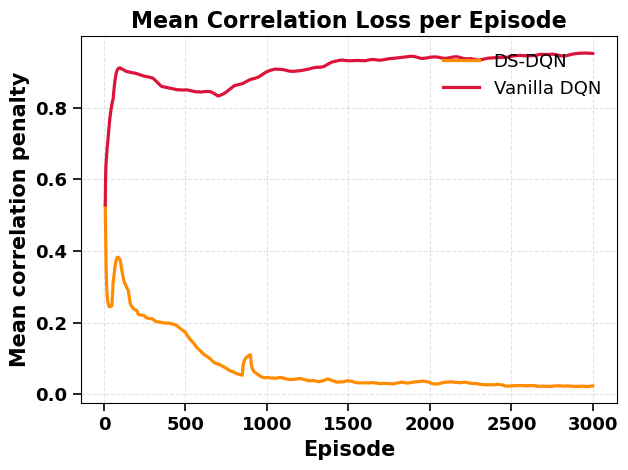

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load both CSV logs
df_ds = pd.read_csv(f"{SAVE_DIR}/train_reward_utilization_corr_summary_dsdqn.csv")                 # DS-DQN
df_vanilla = pd.read_csv(f"{SAVE_DIR}/train_reward_utilization_corr_summary_vanilla-try.csv")    # Vanilla DQN

# Extract correlation logs
corr_ds = df_ds["corr_loss"].values
corr_vanilla = df_vanilla["corr_loss"].values

# Rolling mean helper
def roll(x, w=50):
    return pd.Series(x).rolling(window=w, min_periods=1).mean().to_numpy()

ROLL_WIN = 50

# ==========================================================
# Combined Correlation Plot: DS-DQN vs Vanilla DQN
# ==========================================================
plt.figure()

plt.plot(
    roll(corr_ds, ROLL_WIN),
    color="darkorange", linewidth=2.3,
    label="DS-DQN"
)
plt.plot(
    roll(corr_vanilla, ROLL_WIN),
    color="crimson", linewidth=2.3,
    label="Vanilla DQN"
)

# Titles and labels
plt.title("Mean Correlation Loss per Episode", fontsize=16, weight='semibold')
plt.xlabel("Episode", fontsize=15, weight='bold')
plt.ylabel("Mean correlation penalty", fontsize=15, weight='bold')

# Axis styling
plt.xticks(fontsize=13, weight='bold')
plt.yticks(fontsize=13, weight='bold')
plt.tick_params(axis='both', which='major', width=1.2, length=6)

# Grid and legend
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(fontsize=13, loc="upper right", frameon=False)

# Save high-quality EPS for Overleaf
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_corrloss_comparison-try.eps",
            format='eps', dpi=600, bbox_inches="tight")
plt.show()


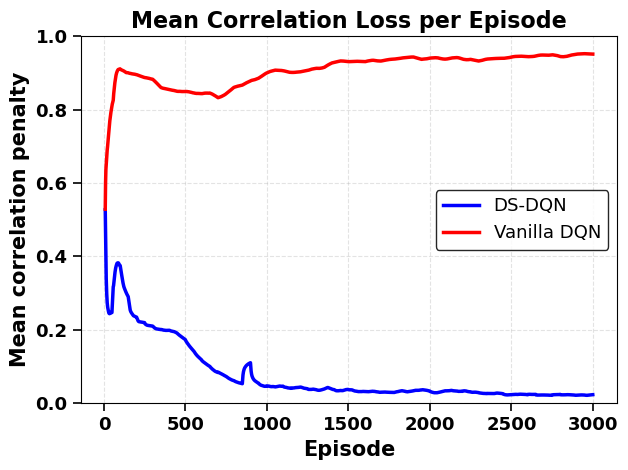

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load both CSV logs
df_ds = pd.read_csv(f"{SAVE_DIR}/train_reward_utilization_corr_summary_dsdqn.csv")                 # DS-DQN
df_vanilla = pd.read_csv(f"{SAVE_DIR}/train_reward_utilization_corr_summary_vanilla-try.csv")    # Vanilla DQN

# Extract correlation logs
corr_ds = df_ds["corr_loss"].values
corr_vanilla = df_vanilla["corr_loss"].values

# Rolling mean helper
def roll(x, w=50):
    return pd.Series(x).rolling(window=w, min_periods=1).mean().to_numpy()

ROLL_WIN = 50

# ==========================================================
# Combined Correlation Plot: DS-DQN vs Vanilla DQN
# ==========================================================
plt.figure()

# DS-DQN first
plt.plot(
    roll(corr_ds, ROLL_WIN),
    color="blue", linewidth=2.5,
    label="DS-DQN"
)
# Vanilla DQN next
plt.plot(
    roll(corr_vanilla, ROLL_WIN),
    color="red", linewidth=2.5,
    label="Vanilla DQN"
)

# Titles and labels
plt.title("Mean Correlation Loss per Episode", fontsize=16, weight='semibold')
plt.xlabel("Episode", fontsize=15, weight='bold')
plt.ylabel("Mean correlation penalty", fontsize=15, weight='bold')

# Axis styling
plt.xticks(fontsize=13, weight='bold')
plt.yticks(fontsize=13, weight='bold')
plt.tick_params(axis='both', which='major', width=1.2, length=6)
plt.ylim(0, 1.0)

# Grid
plt.grid(True, linestyle="--", alpha=0.35)

# Legend inside the plot, centered at the bottom, with box visible
plt.legend(
    fontsize=13,
    loc='center right',
    #bbox_to_anchor=(0.5, 0.05),   # inside the plot
    #ncol=1,
    frameon=True,
    framealpha=0.85,
    facecolor='white',
    edgecolor='black'
)

# Save high-quality EPS for Overleaf
plt.tight_layout()
#plt.savefig(f"{SAVE_DIR}/train_corrloss_comparison-try.png",
 #           format='eps', dpi=600, bbox_inches="tight")
plt.savefig("train_corrloss_comparison.png", dpi=300, bbox_inches="tight")
#plt.savefig("train_reward_utilization_overall_clean.png", dpi=300, bbox_inches="tight")


plt.show()


In [7]:
# Cell 7 — Inference (Algorithm 2, training-consistent with τ filtering + ε-decay per step + α decay)

def run_inference_alg2(
    TMS_test, META_test, phi_encoder,
    lam=0.7, episodes=1000, K=30,
    alpha0=1e-3, alpha_min=1e-5, alpha_decay=0.999,
    gamma=0.99,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
):
    """
    Inference (Alg 2):
    - Encoder φ(s) frozen; only w updated online with row-wise LFA.
    - ε-greedy with decay (decayed *per step*).
    - α decays per episode: large at start, smaller as adaptation continues.
    - τ filtering for path selection.
    """
    phi_encoder.eval()
    with torch.no_grad():
        phi_dim = phi_encoder(torch.zeros(1, STATE_DIM).to(device)).size(1)

    # Linear FA weights for all actions (start near 0 for stability)
    w = torch.zeros(N_ACTIONS, phi_dim, device=device)

    rewards_log, U_log, rho_log, gen_log = [], [], [], []

    # ε-decay init
    eps = eps_start
    from tqdm import trange

    for ep in trange(episodes, desc="Inference Episodes", ncols=100):

   # for ep in range(episodes):
        # 🔑 scheduled learning rate for this episode
        alpha = max(alpha_min, alpha0 * (alpha_decay ** ep))

        # sample a TM from test set
        idx = np.random.randint(len(TMS_test))
        TM = TMS_test[idx]
        tm_type = META_test.iloc[idx]["gen"]
        state = init_state(TM)

        ep_rewards, ep_Us, ep_rhos = [], [], []
        ep_deltas = []
        explore_ct = 0; exploit_ct = 0

        for step in range(K):
            # φ(s)
            s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                phi_s = phi_encoder(s_tensor).squeeze(0)     # [d]

            # Q(s,·) = φ(s) @ w^T
            q_vals = torch.mv(w, phi_s)                      # [A]

            # ε-greedy with decaying ε
            if np.random.rand() < eps:
                action = np.random.randint(N_ACTIONS); explore_ct += 1
            else:
                action = int(torch.argmax(q_vals).item()); exploit_ct += 1

            # env step (τ filtering consistent with training)
            s_next, r, U, rho = apply_action(state, action, TM, lam=lam, tau=0.8)

            # TD target
            with torch.no_grad():
                phi_sp = phi_encoder(torch.FloatTensor(s_next).unsqueeze(0).to(device)).squeeze(0)
                q_next = torch.mv(w, phi_sp)
                y = torch.tensor(r, device=device) + gamma * torch.max(q_next)

            # δ = y - Q(s,a)
            q_sa = torch.dot(w[action], phi_s)
            delta = (y - q_sa).detach()
            ep_deltas.append(float(delta))

            # Row-wise update with decayed α
            with torch.no_grad():
                w[action].add_(alpha * delta * phi_s)

            # advance
            state = s_next
            ep_rewards.append(r); ep_Us.append(U); ep_rhos.append(rho)

            # ✅ decay ε per step
            eps = max(eps_end, eps * eps_decay)

        # episode logs
        Rm = float(np.mean(ep_rewards)); Um = float(np.mean(ep_Us)); rhom = float(np.mean(ep_rhos))
        rewards_log.append(Rm); U_log.append(Um); rho_log.append(rhom); gen_log.append(tm_type)

        # safe average for δ̄
        if not ep_deltas:
            d_mean = float('nan')
        else:
            d_mean = float(np.mean(ep_deltas))
    
        print(
            f"[Alg2 Ep {ep+1:03d}] λ={lam:.2f} eps={eps:.3f} α={alpha:.6f} "
            f"R={Rm:+.4f} U={Um:.3f} ρ={rhom:.3f} "
            f"δ̄={d_mean:+.5f} stepsE={explore_ct} stepsX={exploit_ct} tm={tm_type}"
        )

    return rewards_log, U_log, rho_log, gen_log


In [8]:
class IdentityEncoder(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.state_dim = state_dim

    def forward(self, x):
        # Directly return raw state (no normalization)
        return x


In [9]:
class RandomEncoder(nn.Module):
    def __init__(self, state_dim, phi_dim=None):
        super().__init__()
        if phi_dim is None:
            phi_dim = state_dim   # match transfer and scratch → same dim

        self.proj = nn.Linear(state_dim, phi_dim, bias=False)
        # freeze weights (no training)
        with torch.no_grad():
            self.proj.weight.copy_(torch.randn(phi_dim, state_dim) * 0.01)
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        # Random projection without normalization
        return self.proj(x)


In [ ]:
# Cell 8 — Run inference: Transfer vs Scratch (with α schedule)

# 1) Load trained φ(s) and freeze
phi_trained = PhiEncoder(STATE_DIM, phi_dim=None).to(device)  # → 293
phi_trained.load_state_dict(torch.load(DATA_DIR / f"{TOPO_NAME}_phi_trained_DSDQN-1.pth",
                                       map_location=device))
phi_trained.eval()
for p in phi_trained.parameters():
    p.requires_grad = False

# 2) Scratch φ(s): identity mapping (raw state vector as φ(s))
phi_scratch = IdentityEncoder(STATE_DIM).to(device)
phi_scratch.eval()

# 3) Random φ(s): fixed random projection (now 293-dim too)
phi_random = RandomEncoder(STATE_DIM, phi_dim=None).to(device)
phi_random.eval()

# Common inference settings
LAM_TEST   = 0.55      # different operating point than training → good for transfer
EPISODES_I = 1000
K_I        = 30
GAMMA_I    = 0.99


N_RUNS = 10
transfer_times = []

for run in range(1, N_RUNS + 1):
    print(f"Starting Transfer Run {run}/{N_RUNS}...")
    start_inf = time.perf_counter()

    _ = run_inference_alg2(
        TMS_test, META_test, phi_trained,
        lam=LAM_TEST, episodes=EPISODES_I, K=K_I,
        alpha0=ALPHA0_T, alpha_min=ALPHA_MIN_T, alpha_decay=DECAY_T,
        gamma=GAMMA_I,
        eps_start=1.0, eps_end=0.05, eps_decay=0.995
    )

    end_inf = time.perf_counter()
    transfer_times.append(end_inf - start_inf)
    print(f"Run {run}: {transfer_times[-1]:.2f} seconds")

print("\n=== Transfer Inference Timing Summary (10 Runs) ===")
print(f"Average Time: {np.mean(transfer_times):.2f} s ± {np.std(transfer_times):.2f} s")


In [18]:
# =======================================
# ⚡ Clean Multi-run Inference Summary (no timing info)
# =======================================
import numpy as np, torch, pandas as pd, os

# --- Configurable settings ---
N_RUNS = 10
LAM_TEST = 0.55
EPISODES_I = 1000
K_I = 30
GAMMA_I = 0.99

R_THRESH = 0.6
N_CONSEC = 30
BETA = 0.05
WINDOW = 100
SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# α schedules
ALPHA0_T, ALPHA_MIN_T, DECAY_T = 3.5e-6, 1e-5, 0.999
ALPHA0_S, ALPHA_MIN_S, DECAY_S = 3e-4, 1e-5, 0.999

# --- Load encoders once ---
phi_trained = PhiEncoder(STATE_DIM, phi_dim=None).to(device)
phi_trained.load_state_dict(torch.load(DATA_DIR / f"{TOPO_NAME}_phi_trained.pth", map_location=device))
phi_trained.eval()
for p in phi_trained.parameters(): p.requires_grad = False

phi_scratch = IdentityEncoder(STATE_DIM).to(device); phi_scratch.eval()
phi_random  = RandomEncoder(STATE_DIM, phi_dim=None).to(device); phi_random.eval()

# --- Helper functions ---
def ema(series, beta=BETA):
    s = series[0]; out = []
    for x in series:
        s = beta*s + (1-beta)*x
        out.append(s)
    return np.array(out)

def find_first_above_threshold(rewards, thresh, consec=1):
    streak = 0
    for i, r in enumerate(rewards, start=1):
        if r >= thresh:
            streak += 1
            if streak >= consec: return i - consec + 1
        else:
            streak = 0
    return None

def last_ema_stats(rewards, U, rho, beta=BETA, window=WINDOW):
    r, u, rh = ema(rewards, beta)[-window:], ema(U, beta)[-window:], ema(rho, beta)[-window:]
    return np.mean(r), np.mean(u), np.mean(rh)

def compute_run_summary(rewards_T, U_T, rho_T, rewards_S, U_S, rho_S, rewards_R, U_R, rho_R):
    return {
        "Transfer": (find_first_above_threshold(rewards_T,R_THRESH,N_CONSEC), *last_ema_stats(rewards_T,U_T,rho_T)),
        "Scratch" : (find_first_above_threshold(rewards_S,R_THRESH,N_CONSEC), *last_ema_stats(rewards_S,U_S,rho_S)),
        "Random"  : (find_first_above_threshold(rewards_R,R_THRESH,N_CONSEC), *last_ema_stats(rewards_R,U_R,rho_R))
    }

# --- Storage ---
all_runs = {"Transfer": [], "Scratch": [], "Random": []}

# --- Run loop ---
for run_id in range(N_RUNS):
    print(f"\n========== RUN {run_id+1}/{N_RUNS} ==========")

    print("  → Transfer inference...")
    rewards_T, U_T, rho_T, _ = run_inference_alg2(
        TMS_test, META_test, phi_trained, lam=LAM_TEST,
        episodes=EPISODES_I, K=K_I,
        alpha0=ALPHA0_T, alpha_min=ALPHA_MIN_T, alpha_decay=DECAY_T,
        gamma=GAMMA_I, eps_start=1.0, eps_end=0.05, eps_decay=0.995
    )

    print("  → Scratch inference...")
    rewards_S, U_S, rho_S, _ = run_inference_alg2(
        TMS_test, META_test, phi_scratch, lam=LAM_TEST,
        episodes=EPISODES_I, K=K_I,
        alpha0=ALPHA0_S, alpha_min=ALPHA_MIN_S, alpha_decay=DECAY_S,
        gamma=GAMMA_I, eps_start=1.0, eps_end=0.05, eps_decay=0.995
    )

    print("  → Random inference...")
    rewards_R, U_R, rho_R, _ = run_inference_alg2(
        TMS_test, META_test, phi_random, lam=LAM_TEST,
        episodes=EPISODES_I, K=K_I,
        alpha0=ALPHA0_S, alpha_min=ALPHA_MIN_S, alpha_decay=DECAY_S,
        gamma=GAMMA_I, eps_start=1.0, eps_end=0.05, eps_decay=0.995
    )

    res = compute_run_summary(rewards_T, U_T, rho_T,
                              rewards_S, U_S, rho_S,
                              rewards_R, U_R, rho_R)
    for mode in all_runs:
        all_runs[mode].append(res[mode])

    print("  ✓ Transfer / Scratch / Random completed.")

# --- Aggregate ---
def summarize_mode(data):
    arr = np.array(data, dtype=float)
    return arr.mean(axis=0), arr.std(axis=0)

rows = []
print("\n================ FINAL SUMMARY (Mean ± Std over runs) ================")
for mode, data in all_runs.items():
    mean, std = summarize_mode(data)
    print(f"\n{mode}\n  Earliest_Ep  : {mean[0]:.1f} ± {std[0]:.1f}\n  Reward       : {mean[1]:.3f} ± {std[1]:.3f}\n  Max Util     : {mean[2]:.3f} ± {std[2]:.3f}\n  Avg Util     : {mean[3]:.3f} ± {std[3]:.3f}")
    rows.append({
        "mode": mode,
        "Earliest_Ep (≥0.6×30)": f"{mean[0]:.1f} ± {std[0]:.1f}",
        "Reward": f"{mean[1]:.3f} ± {std[1]:.3f}",
        "Max Util": f"{mean[2]:.3f} ± {std[2]:.3f}",
        "Avg Util": f"{mean[3]:.3f} ± {std[3]:.3f}"
    })

# --- Save results ---
df_summary = pd.DataFrame(rows)
df_summary.to_csv(f"{SAVE_DIR}/multi_run_summary_0.55_10runs-node30_copy4.csv", index=False)
print(f"\nSaved summary → {SAVE_DIR}/multi_run_summary_0.55_10runs-node30_copy4.csv")
display(df_summary)


/tmp/ipykernel_741990/246519786.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  phi_trained.load_state_dict(torch.load(DATA_DIR / f"{TOPO_NAME}_phi_trained_DSDQN.pth", 


========== RUN 1/10 ==========
  → Transfer inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:39, 25.07it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.2430 U=1.510 ρ=0.104 δ̄=+0.26016 stepsE=25 stepsX=5 tm=gravity
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.8273 U=0.289 ρ=0.041 δ̄=+0.83759 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.7547 U=0.409 ρ=0.051 δ̄=+0.76575 stepsE=19 stepsX=11 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.5313 U=0.862 ρ=0.062 δ̄=+0.56239 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.8338 U=0.241 ρ=0.020 δ̄=+0.92200 stepsE=16 stepsX=14 tm=gravity


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:40, 24.20it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.7493 U=0.406 ρ=0.021 δ̄=+0.97016 stepsE=12 stepsX=18 tm=gravity
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.8339 U=0.216 ρ=0.016 δ̄=+0.88893 stepsE=11 stepsX=19 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.4827 U=0.926 ρ=0.050 δ̄=+0.64355 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8905 U=0.073 ρ=0.006 δ̄=+0.99090 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.7519 U=0.366 ρ=0.030 δ̄=+1.05736 stepsE=9 stepsX=21 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:41, 23.56it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.8214 U=0.201 ρ=0.015 δ̄=+0.90782 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.7660 U=0.310 ρ=0.026 δ̄=+0.87115 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.6933 U=0.455 ρ=0.040 δ̄=+0.90924 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.8906 U=0.047 ρ=0.002 δ̄=+0.94620 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:42, 23.25it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.8366 U=0.158 ρ=0.010 δ̄=+0.91668 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:42, 23.04it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.6122 U=0.624 ρ=0.031 δ̄=+0.69050 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=-1.9343 U=6.021 ρ=0.252 δ̄=-1.73918 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8626 U=0.111 ρ=0.008 δ̄=+1.18470 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.7977 U=0.232 ρ=0.014 δ̄=+0.83306 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.8568 U=0.110 ρ=0.007 δ̄=+1.31484 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:43, 22.65it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.4631 U=0.922 ρ=0.064 δ̄=+0.66183 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.7402 U=0.348 ρ=0.024 δ̄=+0.81479 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.8332 U=0.160 ρ=0.009 δ̄=+0.88825 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.8075 U=0.231 ρ=0.016 δ̄=+1.77476 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.8277 U=0.166 ρ=0.008 δ̄=+0.89776 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:43, 22.39it/s]

[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.7736 U=0.275 ρ=0.011 δ̄=+0.67048 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.80012 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.4410 U=1.019 ρ=0.019 δ̄=+2.05254 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.082 ρ=0.004 δ̄=+0.89737 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:43, 22.37it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.87703 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:43, 22.33it/s]

[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.7998 U=0.232 ρ=0.011 δ̄=+1.05768 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.005 ρ=0.000 δ̄=+0.80869 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.188 ρ=0.007 δ̄=+0.76996 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.6123 U=0.608 ρ=0.037 δ̄=+0.70201 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.008 ρ=0.000 δ̄=+0.78540 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   4%|█▌                                       | 39/1000 [00:01<00:42, 22.46it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.6848 U=0.469 ρ=0.020 δ̄=+0.89919 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.6509 U=0.536 ρ=0.057 δ̄=+1.71762 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.042 ρ=0.002 δ̄=+1.27908 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.6582 U=0.539 ρ=0.029 δ̄=+0.97833 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.030 ρ=0.001 δ̄=+1.00199 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:01<00:42, 22.35it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.7486 U=0.360 ρ=0.018 δ̄=+1.15836 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.040 ρ=0.002 δ̄=+0.95617 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.4798 U=0.904 ρ=0.037 δ̄=+0.78404 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.8157 U=0.192 ρ=0.008 δ̄=+0.94573 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▊                                       | 45/1000 [00:01<00:42, 22.45it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.7427 U=0.337 ρ=0.028 δ̄=+0.92393 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:42, 22.22it/s]

[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.6872 U=0.463 ρ=0.020 δ̄=+0.81952 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.3982 U=1.071 ρ=0.042 δ̄=+0.19833 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.8781 U=0.053 ρ=0.002 δ̄=+0.83532 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.018 ρ=0.001 δ̄=+1.74723 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.007 ρ=0.000 δ̄=+0.85879 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:02<00:42, 22.32it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.86994 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.8199 U=0.195 ρ=0.005 δ̄=+2.39534 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.7156 U=0.425 ρ=0.012 δ̄=+1.45432 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.081 ρ=0.003 δ̄=+0.76103 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.8367 U=0.145 ρ=0.015 δ̄=+1.15139 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▎                                      | 57/1000 [00:02<00:42, 22.32it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8153 U=0.200 ρ=0.008 δ̄=+1.04936 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8579 U=0.096 ρ=0.004 δ̄=+0.18104 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.055 ρ=0.003 δ̄=+1.34460 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.6932 U=0.446 ρ=0.023 δ̄=+0.92241 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▍                                      | 60/1000 [00:02<00:42, 21.96it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.032 ρ=0.001 δ̄=+0.75468 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▌                                      | 63/1000 [00:02<00:43, 21.76it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.6873 U=0.469 ρ=0.021 δ̄=+1.80129 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.6768 U=0.492 ρ=0.015 δ̄=+1.07205 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.7586 U=0.315 ρ=0.012 δ̄=+1.02024 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.8827 U=0.044 ρ=0.002 δ̄=+0.54940 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.8267 U=0.168 ρ=0.008 δ̄=+1.02874 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 69/1000 [00:03<00:42, 21.83it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.071 ρ=0.003 δ̄=+0.75236 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.6707 U=0.493 ρ=0.020 δ̄=+0.18372 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.7768 U=0.270 ρ=0.015 δ̄=+1.03903 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.7113 U=0.407 ρ=0.016 δ̄=+0.60473 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.6770 U=0.493 ρ=0.014 δ̄=+0.92515 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:03<00:42, 22.03it/s]

[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.7781 U=0.289 ρ=0.015 δ̄=+2.85865 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.7318 U=0.371 ρ=0.015 δ̄=+0.99031 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.8044 U=0.226 ρ=0.007 δ̄=+1.93807 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.8382 U=0.164 ρ=0.008 δ̄=+5.66818 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   8%|███                                      | 75/1000 [00:03<00:41, 22.29it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.7673 U=0.301 ρ=0.014 δ̄=+1.47022 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:03<00:41, 22.17it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8192 U=0.189 ρ=0.010 δ̄=+1.46497 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.069 ρ=0.003 δ̄=+1.76397 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.5902 U=0.664 ρ=0.026 δ̄=+0.20775 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.3309 U=1.208 ρ=0.064 δ̄=+1.92809 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.8483 U=0.133 ρ=0.010 δ̄=+1.54993 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   8%|███▍                                     | 84/1000 [00:03<00:42, 21.45it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.7631 U=0.310 ρ=0.014 δ̄=+2.28607 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8340 U=0.147 ρ=0.006 δ̄=+0.67788 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.7852 U=0.266 ρ=0.015 δ̄=+1.94994 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.6573 U=0.552 ρ=0.014 δ̄=+4.90887 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.5142 U=0.836 ρ=0.029 δ̄=+1.04786 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 87/1000 [00:03<00:43, 21.22it/s]

[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.8373 U=0.140 ρ=0.006 δ̄=+0.77437 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.7360 U=0.350 ρ=0.030 δ̄=+1.18133 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.6631 U=0.510 ρ=0.032 δ̄=+1.39073 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.6990 U=0.436 ρ=0.027 δ̄=+1.65538 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:04<00:42, 21.52it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.8833 U=0.050 ρ=0.002 δ̄=+1.42742 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▊                                     | 93/1000 [00:04<00:41, 21.88it/s]

[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8471 U=0.128 ρ=0.009 δ̄=+1.17847 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.8217 U=0.173 ρ=0.007 δ̄=+0.71089 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.060 ρ=0.003 δ̄=+1.16699 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.6009 U=0.678 ρ=0.014 δ̄=+1.91356 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.8763 U=0.076 ρ=0.005 δ̄=+1.36712 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|████                                     | 99/1000 [00:04<00:40, 22.20it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.6956 U=0.458 ρ=0.027 δ̄=+2.27570 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.036 ρ=0.001 δ̄=+0.82340 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.234 ρ=0.013 δ̄=+1.02526 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.016 ρ=0.001 δ̄=+1.15206 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8436 U=0.132 ρ=0.007 δ̄=+0.99692 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:04<00:40, 22.17it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.9055 U=0.003 ρ=0.000 δ̄=+1.22790 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.7958 U=0.230 ρ=0.013 δ̄=+1.04406 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.072 ρ=0.004 δ̄=+2.48439 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.040 ρ=0.002 δ̄=+1.38173 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████▏                                   | 105/1000 [00:04<00:40, 22.21it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8123 U=0.200 ρ=0.008 δ̄=+1.83089 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:04<00:40, 22.30it/s]

[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.6966 U=0.440 ρ=0.022 δ̄=+0.91975 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.7800 U=0.267 ρ=0.018 δ̄=+1.16000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.032 ρ=0.001 δ̄=+0.81045 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.6939 U=0.446 ρ=0.022 δ̄=+1.12733 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.7714 U=0.288 ρ=0.010 δ̄=+2.12134 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▌                                   | 114/1000 [00:05<00:40, 21.94it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.050 ρ=0.002 δ̄=+1.73095 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8302 U=0.168 ρ=0.007 δ̄=+1.34696 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.8521 U=0.122 ρ=0.006 δ̄=+1.40278 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.7041 U=0.426 ρ=0.032 δ̄=+1.60106 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.7364 U=0.362 ρ=0.014 δ̄=+1.19470 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▋                                   | 117/1000 [00:05<00:40, 21.68it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.7462 U=0.345 ρ=0.010 δ̄=+1.04151 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.5689 U=0.722 ρ=0.029 δ̄=+1.50659 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.036 ρ=0.002 δ̄=+2.77449 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.7818 U=0.258 ρ=0.010 δ̄=+0.64248 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  12%|████▊                                   | 120/1000 [00:05<00:40, 21.51it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8736 U=0.070 ρ=0.003 δ̄=+1.77592 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▉                                   | 123/1000 [00:05<00:40, 21.91it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.102 ρ=0.006 δ̄=+1.21071 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.8572 U=0.111 ρ=0.005 δ̄=+7.81200 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.7100 U=0.422 ρ=0.024 δ̄=+2.49844 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.7397 U=0.361 ρ=0.026 δ̄=+5.49131 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.6809 U=0.478 ρ=0.038 δ̄=+2.10209 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:05<00:38, 22.49it/s]

[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.7636 U=0.302 ρ=0.013 δ̄=+1.07809 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.028 ρ=0.001 δ̄=+1.04966 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.034 ρ=0.002 δ̄=+1.14823 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.7779 U=0.266 ρ=0.011 δ̄=+0.28251 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.7731 U=0.303 ρ=0.019 δ̄=+1.98107 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:05<00:38, 22.71it/s]

[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.049 ρ=0.003 δ̄=+1.21190 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.6931 U=0.441 ρ=0.034 δ̄=+1.98563 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.003 ρ=0.000 δ̄=+0.47221 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.8127 U=0.210 ρ=0.011 δ̄=+3.48555 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:06<00:37, 22.88it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=-0.2217 U=2.412 ρ=0.096 δ̄=+2.97399 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:06<00:37, 22.92it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8115 U=0.213 ρ=0.011 δ̄=+1.51416 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.6433 U=0.555 ρ=0.025 δ̄=+0.90857 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.8017 U=0.215 ρ=0.009 δ̄=+0.56882 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.7933 U=0.240 ρ=0.010 δ̄=+1.23929 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.8702 U=0.084 ρ=0.004 δ̄=+1.71814 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:06<00:37, 22.97it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.5237 U=0.813 ρ=0.031 δ̄=+0.83421 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.212 ρ=0.010 δ̄=+1.88188 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.046 ρ=0.002 δ̄=+0.61221 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.086 ρ=0.003 δ̄=+0.66048 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.080 ρ=0.005 δ̄=+1.68317 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:06<00:37, 23.04it/s]

[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.6386 U=0.574 ρ=0.023 δ̄=+1.66401 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8641 U=0.094 ρ=0.006 δ̄=+1.31409 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8492 U=0.122 ρ=0.005 δ̄=+2.10456 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.015 ρ=0.001 δ̄=+1.08485 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|██████                                  | 150/1000 [00:06<00:36, 23.07it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.8242 U=0.177 ρ=0.011 δ̄=+1.29945 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 153/1000 [00:06<00:36, 23.08it/s]

[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.7489 U=0.323 ρ=0.029 δ̄=+1.42867 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8428 U=0.135 ρ=0.005 δ̄=+1.24257 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.7438 U=0.348 ρ=0.018 δ̄=+2.19834 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.069 ρ=0.003 δ̄=+1.04782 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.6868 U=0.467 ρ=0.017 δ̄=+0.99152 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:07<00:36, 23.06it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.8450 U=0.129 ρ=0.007 δ̄=+1.23875 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.40828 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.127 ρ=0.006 δ̄=+4.62192 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.8072 U=0.208 ρ=0.010 δ̄=+1.03411 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.071 ρ=0.006 δ̄=+11.74712 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:07<00:36, 23.08it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=-0.7512 U=3.512 ρ=0.141 δ̄=-0.23295 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.6331 U=0.580 ρ=0.023 δ̄=+1.79884 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.206 ρ=0.008 δ̄=+0.40152 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.8372 U=0.140 ρ=0.006 δ̄=+0.56342 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:07<00:36, 23.07it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8066 U=0.218 ρ=0.009 δ̄=+1.86817 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:07<00:36, 23.05it/s]

[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.8578 U=0.096 ρ=0.004 δ̄=+0.63941 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.7949 U=0.234 ρ=0.012 δ̄=+1.71185 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.8475 U=0.129 ρ=0.008 δ̄=+6.94528 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.103 ρ=0.005 δ̄=+1.39469 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.8561 U=0.114 ρ=0.005 δ̄=+3.93849 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:07<00:35, 23.06it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8055 U=0.217 ρ=0.019 δ̄=+1.84643 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.7620 U=0.317 ρ=0.016 δ̄=+1.68276 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.7528 U=0.319 ρ=0.013 δ̄=+0.32957 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.093 ρ=0.004 δ̄=+1.05477 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.8220 U=0.172 ρ=0.007 δ̄=+0.44867 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 177/1000 [00:07<00:35, 23.03it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.011 ρ=0.000 δ̄=+1.95013 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.8426 U=0.141 ρ=0.007 δ̄=+2.53754 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.016 ρ=0.001 δ̄=+1.07829 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.144 ρ=0.006 δ̄=-0.16969 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:08<00:35, 23.01it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.040 ρ=0.002 δ̄=+3.15126 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 183/1000 [00:08<00:35, 23.00it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.6946 U=0.447 ρ=0.020 δ̄=+0.88977 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.6956 U=0.447 ρ=0.018 δ̄=+0.90391 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.6544 U=0.524 ρ=0.030 δ̄=+1.23996 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.6603 U=0.520 ρ=0.023 δ̄=+1.02437 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.226 ρ=0.010 δ̄=+1.08936 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  19%|███████▌                                | 189/1000 [00:08<00:35, 22.99it/s]

[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8343 U=0.146 ρ=0.006 δ̄=+0.19094 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.009 ρ=0.001 δ̄=+1.20894 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.195 ρ=0.008 δ̄=+1.31908 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.8571 U=0.098 ρ=0.004 δ̄=+0.25081 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.065 ρ=0.003 δ̄=+1.10847 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:08<00:35, 22.98it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.008 ρ=0.000 δ̄=+0.15181 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.8498 U=0.113 ρ=0.004 δ̄=+0.53598 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.7709 U=0.308 ρ=0.019 δ̄=+2.18330 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.8912 U=0.031 ρ=0.003 δ̄=+1.05551 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▊                                | 195/1000 [00:08<00:34, 23.11it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.146 ρ=0.008 δ̄=+2.67591 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  20%|███████▉                                | 198/1000 [00:08<00:34, 23.11it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.6674 U=0.498 ρ=0.034 δ̄=+1.65192 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.7185 U=0.402 ρ=0.013 δ̄=+1.08891 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.6728 U=0.472 ρ=0.045 δ̄=+2.13511 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.146 ρ=0.008 δ̄=+1.33913 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.7888 U=0.264 ρ=0.017 δ̄=+15.60629 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:09<00:34, 23.09it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.8314 U=0.166 ρ=0.007 δ̄=+2.09282 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8962 U=0.029 ρ=0.001 δ̄=+1.43208 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.051 ρ=0.002 δ̄=+2.97043 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8572 U=0.105 ρ=0.004 δ̄=+1.58323 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8716 U=0.074 ρ=0.003 δ̄=+1.10716 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 207/1000 [00:09<00:34, 23.06it/s]

[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1.26138 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.7171 U=0.390 ρ=0.026 δ̄=+0.98030 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.071 ρ=0.004 δ̄=+1.32436 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.153 ρ=0.004 δ̄=+2.95447 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:09<00:34, 23.05it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.145 ρ=0.006 δ̄=+0.53305 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▌                               | 213/1000 [00:09<00:34, 23.07it/s]

[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.7847 U=0.265 ρ=0.011 δ̄=+3.77354 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.4702 U=0.922 ρ=0.039 δ̄=+0.92995 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.8043 U=0.210 ρ=0.008 δ̄=+0.64492 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.2022 U=1.486 ρ=0.059 δ̄=-1.17130 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.5836 U=0.675 ρ=0.047 δ̄=+1.58927 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  22%|████████▊                               | 219/1000 [00:09<00:33, 23.08it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.5834 U=0.671 ρ=0.039 δ̄=+1.10009 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.1278 U=1.644 ρ=0.065 δ̄=-0.38659 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.063 ρ=0.004 δ̄=+1.75956 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.8274 U=0.170 ρ=0.011 δ̄=+1.24855 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.3246 U=1.251 ρ=0.047 δ̄=+3.86713 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:09<00:33, 23.12it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.7195 U=0.390 ρ=0.015 δ̄=+0.35806 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.9061 U=0.015 ρ=0.001 δ̄=+4.66912 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.7278 U=0.384 ρ=0.023 δ̄=+3.70894 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.7464 U=0.343 ρ=0.017 δ̄=+1.48922 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|█████████                               | 225/1000 [00:09<00:33, 23.13it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.085 ρ=0.003 δ̄=-0.10091 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  23%|█████████                               | 228/1000 [00:10<00:33, 23.10it/s]

[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.8032 U=0.219 ρ=0.009 δ̄=+0.91649 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.7969 U=0.234 ρ=0.008 δ̄=+1.38493 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.094 ρ=0.004 δ̄=+1.40765 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.033 ρ=0.001 δ̄=+2.44717 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8310 U=0.167 ρ=0.007 δ̄=+1.98612 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:10<00:33, 23.05it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.7547 U=0.315 ρ=0.012 δ̄=+0.37257 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.4769 U=0.904 ρ=0.036 δ̄=-0.34256 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.8648 U=0.095 ρ=0.004 δ̄=+1.95086 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.7749 U=0.272 ρ=0.011 δ̄=+0.48794 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.068 ρ=0.003 δ̄=+1.20570 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▍                              | 237/1000 [00:10<00:33, 23.05it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.117 ρ=0.005 δ̄=+1.74196 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.063 ρ=0.003 δ̄=+2.37508 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.6529 U=0.526 ρ=0.037 δ̄=+1.74669 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.8276 U=0.167 ρ=0.007 δ̄=+1.33554 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:10<00:32, 23.06it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.8375 U=0.146 ρ=0.006 δ̄=+1.06918 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:10<00:32, 23.11it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.077 ρ=0.004 δ̄=+1.73889 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.7400 U=0.363 ρ=0.018 δ̄=+3.16072 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.7639 U=0.310 ρ=0.012 δ̄=+1.90933 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.016 ρ=0.001 δ̄=+1.56376 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.8239 U=0.169 ρ=0.012 δ̄=+3.12343 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:10<00:32, 23.14it/s]

[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.123 ρ=0.006 δ̄=+2.18418 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.203 ρ=0.011 δ̄=+0.88529 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.8268 U=0.175 ρ=0.008 δ̄=+3.25452 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.7550 U=0.321 ρ=0.013 δ̄=+1.44227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.020 ρ=0.001 δ̄=+1.40525 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:11<00:32, 23.10it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.132 ρ=0.005 δ̄=+0.02400 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.8140 U=0.195 ρ=0.009 δ̄=+0.99054 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.6530 U=0.551 ρ=0.016 δ̄=+2.52561 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.134 ρ=0.005 δ̄=+0.60629 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:11<00:32, 23.08it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.021 ρ=0.001 δ̄=+0.60202 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:11<00:32, 23.08it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.7995 U=0.225 ρ=0.010 δ̄=+1.20614 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.78178 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.5954 U=0.653 ρ=0.043 δ̄=+4.41682 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.116 ρ=0.006 δ̄=+1.69589 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.7750 U=0.267 ρ=0.021 δ̄=+0.98891 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:11<00:32, 22.87it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.020 ρ=0.001 δ̄=+1.44699 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.7472 U=0.345 ρ=0.008 δ̄=+1.28679 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.9040 U=0.012 ρ=0.001 δ̄=+1.87366 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8444 U=0.136 ρ=0.008 δ̄=+1.40256 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.5707 U=0.712 ρ=0.029 δ̄=+0.97234 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:11<00:32, 22.58it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.7848 U=0.251 ρ=0.010 δ̄=+0.40378 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.6455 U=0.545 ρ=0.035 δ̄=+2.90680 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.7817 U=0.269 ρ=0.014 δ̄=+2.23346 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.126 ρ=0.007 δ̄=+2.72534 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:11<00:33, 22.07it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.6737 U=0.493 ρ=0.020 δ̄=+1.74491 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:12<00:33, 21.65it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.072 ρ=0.003 δ̄=+3.43213 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.6199 U=0.601 ρ=0.024 δ̄=+0.11257 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.7997 U=0.220 ρ=0.009 δ̄=+0.52953 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.43085 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.157 ρ=0.007 δ̄=+4.70299 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:12<00:32, 22.35it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.8724 U=0.084 ρ=0.005 δ̄=+1.77702 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.7540 U=0.323 ρ=0.013 δ̄=+1.35995 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8125 U=0.200 ρ=0.008 δ̄=+1.37394 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.6319 U=0.572 ρ=0.031 δ̄=+1.32073 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.6917 U=0.456 ρ=0.018 δ̄=+0.99476 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:12<00:31, 22.56it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.8467 U=0.134 ρ=0.005 δ̄=+2.00900 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.8578 U=0.106 ρ=0.008 δ̄=+2.08231 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.6758 U=0.493 ρ=0.022 δ̄=+3.81518 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.101 ρ=0.004 δ̄=+3.04586 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▍                            | 285/1000 [00:12<00:31, 22.70it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.028 ρ=0.001 δ̄=+3.13061 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:12<00:31, 22.69it/s]

[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.8173 U=0.199 ρ=0.012 δ̄=+2.16174 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.7584 U=0.314 ρ=0.012 δ̄=+1.11873 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8273 U=0.169 ρ=0.006 δ̄=+1.33369 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.8091 U=0.207 ρ=0.008 δ̄=+1.15893 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.074 ρ=0.003 δ̄=+1.55452 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:12<00:31, 22.63it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.7779 U=0.266 ρ=0.011 δ̄=+0.06875 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.107 ρ=0.008 δ̄=+1.69925 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.042 ρ=0.002 δ̄=+0.49870 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.8890 U=0.037 ρ=0.002 δ̄=+1.15487 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.6293 U=0.587 ρ=0.024 δ̄=+0.92092 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|███████████▉                            | 297/1000 [00:13<00:31, 22.65it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.086 ρ=0.003 δ̄=+0.67353 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.3998 U=1.069 ρ=0.053 δ̄=+1.40263 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8407 U=0.139 ρ=0.006 δ̄=+1.42436 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.030 ρ=0.002 δ̄=+1.92676 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:13<00:30, 22.64it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.4083 U=1.063 ρ=0.043 δ̄=+1.40134 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████                            | 303/1000 [00:13<00:31, 22.38it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.4572 U=0.948 ρ=0.048 δ̄=+1.88820 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.4702 U=0.929 ρ=0.040 δ̄=+2.14830 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.6351 U=0.568 ρ=0.035 δ̄=+1.53453 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.8071 U=0.210 ρ=0.015 δ̄=+1.89824 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.8271 U=0.174 ρ=0.008 δ̄=+1.52259 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:13<00:31, 22.10it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.4882 U=0.882 ρ=0.046 δ̄=+2.53217 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.063 ρ=0.003 δ̄=+7.84536 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.033 ρ=0.002 δ̄=+3.58182 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.082 ρ=0.006 δ̄=+1.80548 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.57443 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:13<00:31, 21.99it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.4840 U=0.916 ρ=0.037 δ̄=+8.75916 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.172 ρ=0.008 δ̄=+3.25753 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.6191 U=0.619 ρ=0.034 δ̄=+6.65043 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.8317 U=0.159 ρ=0.006 δ̄=+1.56309 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:13<00:31, 21.91it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.002 ρ=0.000 δ̄=+0.76464 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:14<00:30, 22.09it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.7644 U=0.304 ρ=0.016 δ̄=+1.81422 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8590 U=0.107 ρ=0.005 δ̄=+3.15471 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.7454 U=0.341 ρ=0.014 δ̄=+1.02362 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.8611 U=0.095 ρ=0.005 δ̄=+1.12724 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.8463 U=0.121 ρ=0.005 δ̄=+0.58527 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:14<00:30, 22.44it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.8717 U=0.079 ρ=0.005 δ̄=+1.34934 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.8032 U=0.215 ρ=0.012 δ̄=+1.15483 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.7080 U=0.436 ρ=0.023 δ̄=+14.55447 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.185 ρ=0.007 δ̄=+3.59177 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.078 ρ=0.003 δ̄=-0.19119 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████                           | 327/1000 [00:14<00:29, 22.51it/s]

[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.7657 U=0.292 ρ=0.012 δ̄=-0.34004 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.111 ρ=0.004 δ̄=+0.00994 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.074 ρ=0.004 δ̄=+1.59519 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8220 U=0.190 ρ=0.005 δ̄=+2.80032 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:14<00:29, 22.63it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.8538 U=0.111 ρ=0.005 δ̄=+2.64478 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 333/1000 [00:14<00:29, 22.72it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8560 U=0.106 ρ=0.005 δ̄=+1.19653 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.093 ρ=0.004 δ̄=+1.72432 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.8035 U=0.217 ρ=0.010 δ̄=+1.44730 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.117 ρ=0.006 δ̄=+5.62395 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8465 U=0.129 ρ=0.004 δ̄=+2.82508 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:15<00:28, 22.82it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.124 ρ=0.005 δ̄=+0.43906 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8069 U=0.210 ρ=0.010 δ̄=+1.16997 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.7348 U=0.361 ρ=0.017 δ̄=+1.67417 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.082 ρ=0.003 δ̄=+2.03919 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8480 U=0.124 ρ=0.005 δ̄=+1.65470 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:15<00:29, 22.53it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.3052 U=1.280 ρ=0.058 δ̄=+4.50917 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.7866 U=0.264 ρ=0.009 δ̄=+6.76449 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.069 ρ=0.001 δ̄=+1.67582 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.6982 U=0.442 ρ=0.024 δ̄=+3.10051 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 345/1000 [00:15<00:29, 22.31it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.7576 U=0.309 ρ=0.012 δ̄=+0.00506 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:15<00:29, 22.17it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8169 U=0.200 ρ=0.012 δ̄=+3.81930 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.5058 U=0.849 ρ=0.040 δ̄=+2.63111 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.020 ρ=0.001 δ̄=+0.59170 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.6571 U=0.527 ρ=0.028 δ̄=+3.79936 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.100 ρ=0.005 δ̄=+4.55059 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:15<00:28, 22.39it/s]

[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.027 ρ=0.001 δ̄=+2.44223 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.7749 U=0.284 ρ=0.019 δ̄=+2.37932 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.8921 U=0.031 ρ=0.001 δ̄=+1.19744 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.8260 U=0.180 ρ=0.012 δ̄=+3.47555 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.010 ρ=0.000 δ̄=+2.78773 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 357/1000 [00:15<00:28, 22.49it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.42027 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.004 ρ=0.000 δ̄=+0.63499 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.6666 U=0.530 ρ=0.027 δ̄=+5.25750 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.002 ρ=0.000 δ̄=+0.75772 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:15<00:28, 22.66it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.118 ρ=0.006 δ̄=+1.81902 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 363/1000 [00:16<00:28, 22.73it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.057 ρ=0.002 δ̄=+2.24492 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.5915 U=0.675 ρ=0.027 δ̄=+2.01815 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.4678 U=0.931 ρ=0.036 δ̄=+0.92128 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.7605 U=0.309 ρ=0.013 δ̄=+1.98427 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.096 ρ=0.004 δ̄=+1.26674 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 369/1000 [00:16<00:27, 22.72it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.8887 U=0.038 ρ=0.002 δ̄=+1.27318 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.5903 U=0.680 ρ=0.031 δ̄=+6.39098 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.033 ρ=0.002 δ̄=+4.80225 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.7879 U=0.255 ρ=0.014 δ̄=+2.27418 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.155 ρ=0.011 δ̄=+5.38096 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:16<00:27, 22.51it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.8589 U=0.103 ρ=0.003 δ̄=+2.38103 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.081 ρ=0.003 δ̄=+0.19095 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.093 ρ=0.004 δ̄=+1.57632 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.8681 U=0.075 ρ=0.003 δ̄=+0.70366 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████                         | 375/1000 [00:16<00:27, 22.53it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.6960 U=0.457 ρ=0.027 δ̄=+8.29293 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████                         | 378/1000 [00:16<00:27, 22.48it/s]

[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.8408 U=0.139 ρ=0.006 δ̄=+1.50674 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.029 ρ=0.001 δ̄=+0.41078 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8121 U=0.200 ρ=0.008 δ̄=+2.49845 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.7751 U=0.278 ρ=0.012 δ̄=+1.62569 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.8845 U=0.046 ρ=0.002 δ̄=+1.86678 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:17<00:27, 22.59it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.8282 U=0.186 ρ=0.015 δ̄=+3.79402 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.8050 U=0.214 ρ=0.010 δ̄=+1.06188 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.7200 U=0.389 ρ=0.021 δ̄=+1.09049 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.8367 U=0.148 ρ=0.006 δ̄=+1.96928 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=-0.2297 U=2.411 ρ=0.100 δ̄=+2.19270 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:17<00:27, 22.69it/s]

[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.099 ρ=0.004 δ̄=+1.59414 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.232 ρ=0.014 δ̄=+1.83193 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.6764 U=0.485 ρ=0.022 δ̄=+1.06697 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.8252 U=0.167 ρ=0.012 δ̄=+1.35036 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:17<00:26, 22.78it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.7698 U=0.297 ρ=0.012 δ̄=+2.93704 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 393/1000 [00:17<00:26, 22.84it/s]

[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.7454 U=0.341 ρ=0.014 δ̄=+1.07178 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.101 ρ=0.009 δ̄=+3.29450 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.8716 U=0.080 ρ=0.004 δ̄=+1.37239 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.085 ρ=0.005 δ̄=+3.59010 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.013 ρ=0.000 δ̄=+0.30400 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:17<00:26, 22.91it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.7902 U=0.251 ρ=0.012 δ̄=+2.25540 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.8450 U=0.131 ρ=0.011 δ̄=+3.35703 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.74738 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.082 ρ=0.002 δ̄=+1.25951 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8286 U=0.170 ρ=0.009 δ̄=+1.82066 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  40%|████████████████                        | 402/1000 [00:17<00:26, 22.94it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.058 ρ=0.003 δ̄=+1.27321 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.8119 U=0.194 ρ=0.019 δ̄=+1.82451 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.053 ρ=0.002 δ̄=+1.57265 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.4381 U=1.023 ρ=0.021 δ̄=+3.07259 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|████████████████▏                       | 405/1000 [00:17<00:25, 22.97it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.7677 U=0.305 ρ=0.022 δ̄=+13.08551 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:18<00:25, 22.92it/s]

[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.8473 U=0.125 ρ=0.006 δ̄=+2.11147 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.081 ρ=0.003 δ̄=+0.15203 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.8686 U=0.081 ρ=0.003 δ̄=+2.50304 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.8508 U=0.124 ρ=0.006 δ̄=+1.95792 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.017 ρ=0.001 δ̄=+3.36203 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:18<00:25, 22.91it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.7269 U=0.385 ρ=0.018 δ̄=+3.49336 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.059 ρ=0.002 δ̄=+1.61155 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.7832 U=0.272 ρ=0.014 δ̄=+3.51690 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.7361 U=0.354 ρ=0.014 δ̄=+0.31548 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.5957 U=0.657 ρ=0.028 δ̄=+1.12319 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:18<00:25, 22.69it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.3176 U=1.209 ρ=0.094 δ̄=+7.08580 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.74566 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.079 ρ=0.003 δ̄=+0.64604 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8954 U=0.017 ρ=0.001 δ̄=+0.61333 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:18<00:25, 22.58it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.7927 U=0.247 ρ=0.011 δ̄=+3.01831 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 423/1000 [00:18<00:25, 22.43it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.7410 U=0.348 ρ=0.017 δ̄=+1.45678 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.7589 U=0.306 ρ=0.012 δ̄=+0.54166 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.8660 U=0.086 ρ=0.004 δ̄=+1.50780 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.125 ρ=0.007 δ̄=+1.79186 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.8181 U=0.208 ρ=0.015 δ̄=+5.04648 stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:18<00:25, 22.33it/s]

[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.7824 U=0.272 ρ=0.015 δ̄=+2.01955 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8449 U=0.131 ρ=0.005 δ̄=+2.38109 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.8157 U=0.192 ρ=0.008 δ̄=+1.53225 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.8921 U=0.031 ρ=0.001 δ̄=+1.42674 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.7455 U=0.346 ρ=0.016 δ̄=+3.71134 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:19<00:25, 22.48it/s]

[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.8885 U=0.038 ρ=0.002 δ̄=+1.40562 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.7779 U=0.266 ρ=0.011 δ̄=-0.10789 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.6064 U=0.632 ρ=0.029 δ̄=+2.83564 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.6533 U=0.546 ρ=0.026 δ̄=+3.30004 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:19<00:24, 22.64it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.8689 U=0.073 ρ=0.003 δ̄=+0.44764 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:19<00:24, 22.73it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.045 ρ=0.002 δ̄=+2.36232 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.9039 U=0.006 ρ=0.000 δ̄=+2.38405 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.044 ρ=0.002 δ̄=+1.69979 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.6098 U=0.632 ρ=0.029 δ̄=+2.42533 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.7896 U=0.247 ρ=0.023 δ̄=+4.26490 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:19<00:24, 22.83it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.7965 U=0.226 ρ=0.009 δ̄=+0.53791 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.8214 U=0.173 ρ=0.013 δ̄=+1.18722 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.7375 U=0.363 ρ=0.017 δ̄=+2.86101 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.8288 U=0.162 ρ=0.009 δ̄=+1.06209 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.055 ρ=0.002 δ̄=+1.25419 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  45%|█████████████████▉                      | 447/1000 [00:19<00:24, 22.85it/s]

[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.8961 U=0.022 ρ=0.001 δ̄=+2.22765 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.7940 U=0.237 ρ=0.011 δ̄=+1.32128 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.7967 U=0.236 ρ=0.013 δ̄=+1.55434 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.011 ρ=0.001 δ̄=+2.14080 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:19<00:24, 22.89it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.087 ρ=0.008 δ̄=+2.58191 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:20<00:23, 22.90it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.148 ρ=0.006 δ̄=+0.56627 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.037 ρ=0.001 δ̄=+0.31945 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8169 U=0.196 ρ=0.009 δ̄=+2.31420 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.8891 U=0.030 ρ=0.001 δ̄=+0.61365 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8847 U=0.046 ρ=0.002 δ̄=+1.34070 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:20<00:23, 22.92it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.7953 U=0.232 ρ=0.012 δ̄=+1.30418 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.6713 U=0.508 ρ=0.024 δ̄=+2.17199 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.7498 U=0.326 ρ=0.018 δ̄=+2.07323 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8579 U=0.096 ρ=0.004 δ̄=-1.61686 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.7235 U=0.381 ρ=0.015 δ̄=-0.21579 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:20<00:23, 22.87it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.3362 U=1.208 ρ=0.048 δ̄=+1.62869 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.7868 U=0.254 ρ=0.010 δ̄=+1.13174 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.041 ρ=0.002 δ̄=+7.01476 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.7730 U=0.283 ρ=0.017 δ̄=+4.30747 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:20<00:23, 22.93it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.7625 U=0.315 ρ=0.010 δ̄=+1.92946 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:20<00:23, 22.92it/s]

[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.083 ρ=0.005 δ̄=+1.52862 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.6783 U=0.484 ρ=0.020 δ̄=+1.29547 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.7847 U=0.257 ρ=0.011 δ̄=+0.96884 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.7105 U=0.413 ρ=0.019 δ̄=+1.08317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.8595 U=0.123 ρ=0.009 δ̄=+12.37120 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:20<00:22, 22.94it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.159 ρ=0.006 δ̄=+0.32454 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.033 ρ=0.002 δ̄=+2.58162 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.031 ρ=0.002 δ̄=+1.26841 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.042 ρ=0.002 δ̄=+0.42236 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.092 ρ=0.004 δ̄=+1.22932 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████                     | 477/1000 [00:21<00:22, 22.91it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8585 U=0.102 ρ=0.004 δ̄=+1.17807 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.7152 U=0.399 ρ=0.016 δ̄=+0.09045 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.090 ρ=0.006 δ̄=+4.76312 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.8296 U=0.163 ρ=0.007 δ̄=+1.29029 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:21<00:22, 22.84it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.6400 U=0.562 ρ=0.031 δ̄=+2.29767 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:21<00:23, 22.22it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.082 ρ=0.004 δ̄=+4.61393 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.7935 U=0.233 ρ=0.009 δ̄=+0.62510 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.7877 U=0.249 ρ=0.018 δ̄=+1.83146 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.7184 U=0.399 ρ=0.016 δ̄=+1.62615 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.7672 U=0.300 ρ=0.014 δ̄=+1.52032 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:21<00:23, 21.61it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.7330 U=0.366 ρ=0.016 δ̄=+1.35675 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.7511 U=0.323 ρ=0.013 δ̄=+0.29290 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.049 ρ=0.003 δ̄=+1.15051 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.7408 U=0.345 ρ=0.014 δ̄=+0.45024 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.8949 U=0.025 ρ=0.001 δ̄=+1.20055 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:21<00:23, 21.42it/s]

[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.7422 U=0.341 ρ=0.014 δ̄=+0.27722 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.7760 U=0.278 ρ=0.022 δ̄=+3.49934 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.8799 U=0.056 ρ=0.003 δ̄=+1.51405 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.8024 U=0.220 ρ=0.010 δ̄=+1.12685 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  50%|███████████████████▊                    | 495/1000 [00:21<00:23, 21.28it/s]

[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.67929 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:22<00:23, 21.01it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.7833 U=0.262 ρ=0.016 δ̄=+1.85936 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.151 ρ=0.006 δ̄=+0.50564 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.7831 U=0.270 ρ=0.022 δ̄=+3.18998 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.7123 U=0.411 ρ=0.024 δ̄=+3.44133 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.8219 U=0.175 ρ=0.011 δ̄=+1.48168 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:22<00:24, 20.45it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.7607 U=0.308 ρ=0.014 δ̄=+1.33825 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.206 ρ=0.008 δ̄=+0.11448 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8034 U=0.212 ρ=0.008 δ̄=-1.26097 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.7416 U=0.343 ρ=0.019 δ̄=+1.06024 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 507/1000 [00:22<00:24, 20.48it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.6663 U=0.508 ρ=0.021 δ̄=+0.90215 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.7030 U=0.430 ρ=0.018 δ̄=+5.47092 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.8304 U=0.161 ρ=0.007 δ̄=+1.02602 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.6143 U=0.627 ρ=0.025 δ̄=+2.01470 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.7633 U=0.310 ρ=0.019 δ̄=+3.25030 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 513/1000 [00:22<00:23, 20.36it/s]

[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8338 U=0.153 ρ=0.007 δ̄=+1.56170 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.5725 U=0.691 ρ=0.054 δ̄=+2.21835 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.6713 U=0.510 ρ=0.029 δ̄=+4.35705 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.6385 U=0.586 ρ=0.044 δ̄=+10.38732 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.7073 U=0.418 ρ=0.027 δ̄=+2.29719 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 519/1000 [00:23<00:23, 20.23it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8245 U=0.173 ρ=0.007 δ̄=+1.43292 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.081 ρ=0.003 δ̄=+0.24131 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.6478 U=0.534 ρ=0.040 δ̄=+2.52194 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.7695 U=0.284 ρ=0.011 δ̄=+0.23444 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.4716 U=0.922 ρ=0.037 δ̄=+1.09440 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:23<00:23, 20.10it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.7864 U=0.254 ρ=0.011 δ̄=+1.10219 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.157 ρ=0.007 δ̄=+2.56366 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.057 ρ=0.002 δ̄=+1.87088 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.6180 U=0.602 ρ=0.032 δ̄=+1.13673 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.6998 U=0.433 ρ=0.022 δ̄=+1.51769 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:23<00:23, 20.52it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.8134 U=0.202 ρ=0.010 δ̄=+1.24801 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.7708 U=0.287 ρ=0.012 δ̄=+1.20752 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.014 ρ=0.001 δ̄=+1.31887 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8043 U=0.218 ρ=0.007 δ̄=+1.92790 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.8040 U=0.227 ρ=0.013 δ̄=+2.69504 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:23<00:22, 20.77it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.7088 U=0.420 ρ=0.022 δ̄=+2.63775 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.7906 U=0.249 ρ=0.014 δ̄=+1.41400 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.022 ρ=0.001 δ̄=+0.20969 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.6463 U=0.555 ρ=0.026 δ̄=+1.95937 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.8031 U=0.219 ρ=0.009 δ̄=+2.18217 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  54%|█████████████████████▍                  | 537/1000 [00:23<00:22, 20.82it/s]

[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.059 ρ=0.003 δ̄=+1.32175 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.039 ρ=0.002 δ̄=+0.51321 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.7856 U=0.257 ρ=0.010 δ̄=+1.36195 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.8684 U=0.083 ρ=0.002 δ̄=+2.10210 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.7336 U=0.363 ρ=0.018 δ̄=+1.46148 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 543/1000 [00:24<00:21, 21.02it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.8591 U=0.100 ρ=0.005 δ̄=+1.09837 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.6953 U=0.444 ρ=0.034 δ̄=+4.01917 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.8229 U=0.189 ρ=0.010 δ̄=+11.47673 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.8583 U=0.103 ρ=0.004 δ̄=+1.17448 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8554 U=0.116 ρ=0.004 δ̄=+9.47877 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 549/1000 [00:24<00:21, 20.84it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.8949 U=0.018 ρ=0.001 δ̄=+0.69048 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.5478 U=0.776 ρ=0.030 δ̄=+3.80691 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.7621 U=0.306 ρ=0.012 δ̄=+1.22086 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.018 ρ=0.001 δ̄=+1.73689 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.8272 U=0.167 ρ=0.008 δ̄=+1.13603 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:24<00:21, 20.48it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.018 ρ=0.001 δ̄=+2.18252 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.032 ρ=0.001 δ̄=+2.26017 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.6363 U=0.572 ρ=0.023 δ̄=+1.39270 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.8196 U=0.196 ρ=0.010 δ̄=+5.45318 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:24<00:21, 20.70it/s]

[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.010 ρ=0.000 δ̄=+0.72362 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.5416 U=0.758 ρ=0.050 δ̄=+3.06142 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.043 ρ=0.002 δ̄=+2.01728 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.7928 U=0.250 ρ=0.020 δ̄=+3.09392 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.7215 U=0.404 ρ=0.024 δ̄=+5.04549 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  56%|██████████████████████▍                 | 561/1000 [00:25<00:21, 20.87it/s]

[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.024 ρ=0.001 δ̄=+3.49968 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.7194 U=0.399 ρ=0.026 δ̄=+1.73318 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.8750 U=0.060 ρ=0.002 δ̄=+0.36631 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.7409 U=0.345 ρ=0.019 δ̄=+1.30672 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.072 ρ=0.004 δ̄=+1.96606 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 567/1000 [00:25<00:20, 21.07it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1.32644 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.6993 U=0.444 ρ=0.019 δ̄=+3.28066 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.7336 U=0.363 ρ=0.018 δ̄=+1.44108 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.6226 U=0.601 ρ=0.025 δ̄=+0.98112 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.8126 U=0.204 ρ=0.010 δ̄=+1.78675 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 573/1000 [00:25<00:20, 21.21it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.7379 U=0.355 ρ=0.022 δ̄=+2.71083 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.73151 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.7538 U=0.336 ρ=0.021 δ̄=+8.99442 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.020 ρ=0.001 δ̄=+1.69537 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.7222 U=0.387 ρ=0.019 δ̄=+1.45034 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:25<00:19, 21.25it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.8674 U=0.090 ρ=0.004 δ̄=+1.37921 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.7436 U=0.356 ρ=0.023 δ̄=+2.15695 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.7578 U=0.308 ρ=0.012 δ̄=+0.61395 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.010 ρ=0.000 δ̄=+1.22520 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.6562 U=0.520 ρ=0.036 δ̄=+1.54376 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:26<00:19, 21.31it/s]

[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.7592 U=0.312 ρ=0.013 δ̄=+1.99368 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.059 ρ=0.004 δ̄=+6.92223 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.8223 U=0.177 ρ=0.008 δ̄=+1.09948 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.025 ρ=0.001 δ̄=+1.76049 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.8414 U=0.131 ρ=0.005 δ̄=+0.31948 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:26<00:19, 21.30it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.048 ρ=0.002 δ̄=+1.39893 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.7769 U=0.287 ρ=0.013 δ̄=+3.40360 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8538 U=0.114 ρ=0.009 δ̄=+2.26949 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.8614 U=0.096 ρ=0.004 δ̄=+2.95405 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.010 ρ=0.001 δ̄=+1.76820 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 591/1000 [00:26<00:19, 21.25it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.7440 U=0.345 ρ=0.014 δ̄=+1.13620 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.155 ρ=0.006 δ̄=+2.83857 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.023 ρ=0.001 δ̄=+1.16092 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.016 ρ=0.001 δ̄=+0.81214 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.7566 U=0.328 ρ=0.016 δ̄=+2.69173 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 597/1000 [00:26<00:19, 20.91it/s]

[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.6433 U=0.569 ρ=0.026 δ̄=+7.89202 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8985 U=0.017 ρ=0.001 δ̄=+1.64394 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8433 U=0.134 ρ=0.005 δ̄=+1.37090 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.7393 U=0.348 ρ=0.014 δ̄=+0.05952 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.7923 U=0.252 ρ=0.014 δ̄=+3.29986 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|████████████████████████                | 603/1000 [00:27<00:19, 20.50it/s]

[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.061 ρ=0.002 δ̄=+5.16725 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.8549 U=0.103 ρ=0.004 δ̄=+0.73257 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.7812 U=0.265 ρ=0.011 δ̄=+2.12318 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.8621 U=0.093 ρ=0.005 δ̄=+1.13518 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.7736 U=0.285 ρ=0.009 δ̄=+2.94097 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:27<00:19, 20.39it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.047 ρ=0.003 δ̄=+1.64727 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.7301 U=0.372 ρ=0.023 δ̄=+2.44033 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.7443 U=0.343 ρ=0.014 δ̄=+1.35043 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.073 ρ=0.005 δ̄=+2.34454 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.7493 U=0.330 ρ=0.016 δ̄=+1.23161 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:27<00:18, 20.66it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.6006 U=0.656 ρ=0.032 δ̄=+2.66767 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.027 ρ=0.001 δ̄=+1.41413 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.5496 U=0.759 ρ=0.034 δ̄=+3.17843 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8330 U=0.156 ρ=0.007 δ̄=+1.41793 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.6666 U=0.508 ρ=0.021 δ̄=+0.93765 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:27<00:18, 20.99it/s]

[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.6785 U=0.478 ρ=0.024 δ̄=+1.18384 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.4340 U=0.996 ρ=0.044 δ̄=+1.61939 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.7999 U=0.231 ρ=0.017 δ̄=+1.99618 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.5039 U=0.822 ρ=0.059 δ̄=+1.11478 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.1323 U=1.639 ρ=0.079 δ̄=+5.26932 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  62%|████████████████████████▊               | 621/1000 [00:27<00:17, 21.11it/s]

[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.8994 U=0.022 ρ=0.001 δ̄=+7.61305 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.7453 U=0.345 ρ=0.018 δ̄=+6.67073 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.8194 U=0.187 ρ=0.012 δ̄=+1.29383 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.7621 U=0.307 ρ=0.018 δ̄=+2.86879 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8476 U=0.135 ρ=0.009 δ̄=+3.04192 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 627/1000 [00:28<00:17, 21.24it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.6836 U=0.489 ρ=0.023 δ̄=+2.75466 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.6015 U=0.652 ρ=0.034 δ̄=+18.35412 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.37577 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.050 ρ=0.002 δ̄=+1.63227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8340 U=0.147 ρ=0.006 δ̄=+0.48080 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  63%|█████████████████████████▎              | 633/1000 [00:28<00:17, 21.28it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.049 ρ=0.002 δ̄=+1.65684 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.7861 U=0.265 ρ=0.008 δ̄=+4.62117 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.037 ρ=0.002 δ̄=+2.60281 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.1958 U=1.530 ρ=0.047 δ̄=+7.11245 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.111 ρ=0.007 δ̄=+1.27388 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:28<00:17, 21.25it/s]

[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.020 ρ=0.001 δ̄=+0.75619 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8274 U=0.161 ρ=0.006 δ̄=+0.37803 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.7170 U=0.395 ρ=0.022 δ̄=+1.15174 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.5861 U=0.675 ρ=0.037 δ̄=+1.38713 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.7492 U=0.327 ρ=0.013 δ̄=+0.48460 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:28<00:16, 21.32it/s]

[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.8862 U=0.043 ρ=0.002 δ̄=+2.02704 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8317 U=0.168 ρ=0.011 δ̄=+3.00419 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8597 U=0.092 ρ=0.004 δ̄=+0.12585 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.6700 U=0.501 ρ=0.032 δ̄=+3.33783 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.066 ρ=0.004 δ̄=+1.12313 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:29<00:16, 21.34it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.7202 U=0.395 ρ=0.016 δ̄=+1.59910 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.031 ρ=0.002 δ̄=+2.32643 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.8299 U=0.174 ρ=0.009 δ̄=+1.70505 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.6854 U=0.468 ρ=0.019 δ̄=+2.41066 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.4796 U=0.915 ρ=0.040 δ̄=+5.98043 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 651/1000 [00:29<00:16, 21.36it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.8043 U=0.219 ρ=0.013 δ̄=+1.26846 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.069 ρ=0.002 δ̄=+1.79407 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.7183 U=0.397 ρ=0.036 δ̄=+4.71108 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8309 U=0.170 ρ=0.011 δ̄=+4.56340 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.8341 U=0.157 ρ=0.010 δ̄=+2.03458 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 657/1000 [00:29<00:16, 21.33it/s]

[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.6646 U=0.510 ρ=0.023 δ̄=+1.26265 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.7903 U=0.254 ρ=0.010 δ̄=+1.75375 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.6232 U=0.601 ρ=0.024 δ̄=+1.05224 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.7865 U=0.248 ρ=0.010 δ̄=+0.08629 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.122 ρ=0.005 δ̄=+2.60097 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 663/1000 [00:29<00:15, 21.31it/s]

[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.7775 U=0.290 ρ=0.009 δ̄=+12.56268 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.7227 U=0.389 ρ=0.016 δ̄=+1.11373 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.7722 U=0.298 ρ=0.013 δ̄=+7.46625 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.019 ρ=0.001 δ̄=-0.69352 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.219 ρ=0.009 δ̄=+0.58962 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:30<00:15, 21.28it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.099 ρ=0.004 δ̄=+1.47268 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.111 ρ=0.004 δ̄=-0.05081 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.5954 U=0.664 ρ=0.029 δ̄=+2.03053 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.8635 U=0.097 ρ=0.005 δ̄=+1.81282 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.6828 U=0.467 ρ=0.018 δ̄=+0.37758 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:30<00:15, 21.26it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.8135 U=0.190 ρ=0.008 δ̄=+0.08478 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.062 ρ=0.002 δ̄=+1.53119 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.036 ρ=0.002 δ̄=+1.28197 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8181 U=0.182 ρ=0.012 δ̄=+1.96822 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.8298 U=0.161 ρ=0.008 δ̄=+1.06641 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:30<00:15, 21.29it/s]

[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.5034 U=0.855 ρ=0.034 δ̄=+1.36099 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.7750 U=0.272 ρ=0.023 δ̄=+1.69922 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.7962 U=0.235 ρ=0.009 δ̄=+1.30264 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.5924 U=0.648 ρ=0.041 δ̄=+0.93389 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.101 ρ=0.005 δ̄=+2.37322 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 681/1000 [00:30<00:14, 21.29it/s]

[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.8275 U=0.166 ρ=0.008 δ̄=+1.61452 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.7667 U=0.298 ρ=0.011 δ̄=+1.53834 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.7528 U=0.327 ρ=0.018 δ̄=+2.83781 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.8248 U=0.167 ρ=0.007 δ̄=+0.49180 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.6937 U=0.444 ρ=0.018 δ̄=+0.31512 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 687/1000 [00:31<00:14, 21.30it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8191 U=0.184 ρ=0.009 δ̄=+1.41365 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.8009 U=0.237 ρ=0.011 δ̄=+4.41567 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.4519 U=0.965 ρ=0.043 δ̄=+2.53593 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.7429 U=0.344 ρ=0.017 δ̄=+1.11224 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.070 ρ=0.004 δ̄=+8.57339 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  69%|███████████████████████████▋            | 693/1000 [00:31<00:14, 21.33it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8046 U=0.225 ρ=0.014 δ̄=+2.34452 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.114 ρ=0.004 δ̄=+0.66373 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.8802 U=0.062 ρ=0.003 δ̄=+1.43252 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.7799 U=0.268 ρ=0.024 δ̄=+2.28163 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.026 ρ=0.001 δ̄=+2.11870 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:31<00:14, 21.34it/s]

[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8461 U=0.128 ρ=0.005 δ̄=+1.60877 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.5015 U=0.855 ρ=0.037 δ̄=+1.29600 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.7238 U=0.383 ρ=0.026 δ̄=+1.69084 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.8936 U=0.027 ρ=0.002 δ̄=+1.42550 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.047 ρ=0.002 δ̄=+0.75284 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:31<00:14, 21.14it/s]

[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.7408 U=0.345 ρ=0.014 δ̄=+0.47224 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.8540 U=0.111 ρ=0.005 δ̄=+1.48543 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.021 ρ=0.001 δ̄=+6.58477 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8647 U=0.097 ρ=0.003 δ̄=+1.90132 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.7629 U=0.312 ρ=0.013 δ̄=+3.78564 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:32<00:13, 21.09it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.111 ρ=0.004 δ̄=-0.07998 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.077 ρ=0.004 δ̄=+2.07075 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.8552 U=0.109 ρ=0.005 δ̄=+1.30756 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.060 ρ=0.003 δ̄=+8.95940 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.081 ρ=0.003 δ̄=+0.49865 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 711/1000 [00:32<00:13, 20.84it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.21794 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.7971 U=0.232 ρ=0.009 δ̄=+1.22721 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.78381 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.171 ρ=0.011 δ̄=+3.61673 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.063 ρ=0.002 δ̄=+1.24334 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 717/1000 [00:32<00:13, 20.69it/s]

[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.7076 U=0.425 ρ=0.038 δ̄=+4.28041 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.6112 U=0.626 ρ=0.025 δ̄=+1.26062 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.026 ρ=0.001 δ̄=+4.45373 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.012 ρ=0.000 δ̄=+1.63238 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.7196 U=0.389 ρ=0.015 δ̄=+0.43582 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 723/1000 [00:32<00:13, 20.82it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.6691 U=0.496 ρ=0.044 δ̄=+3.72125 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.072 ρ=0.003 δ̄=+1.73396 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.077 ρ=0.003 δ̄=+0.53599 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.030 ρ=0.001 δ̄=+2.50552 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.6601 U=0.504 ρ=0.042 δ̄=+1.70918 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:32<00:13, 20.74it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.035 ρ=0.002 δ̄=+2.52908 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.4633 U=0.961 ρ=0.020 δ̄=+3.25772 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.023 ρ=0.001 δ̄=+1.21550 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.023 ρ=0.001 δ̄=+0.55531 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.057 ρ=0.002 δ̄=+0.24094 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:33<00:12, 20.73it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.7965 U=0.233 ρ=0.010 δ̄=+0.97601 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.118 ρ=0.007 δ̄=+6.98778 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.7181 U=0.405 ρ=0.024 δ̄=+4.15211 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.177 ρ=0.013 δ̄=+2.26877 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.050 ρ=0.003 δ̄=+2.27775 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:33<00:12, 20.98it/s]

[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.084 ρ=0.004 δ̄=+2.58486 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.6346 U=0.574 ρ=0.037 δ̄=+3.01061 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8180 U=0.191 ρ=0.011 δ̄=+1.70618 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.9040 U=0.006 ρ=0.000 δ̄=+4.28966 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.9049 U=0.011 ρ=0.001 δ̄=+1.93350 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 741/1000 [00:33<00:12, 20.79it/s]

[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.8386 U=0.144 ρ=0.006 δ̄=+1.54219 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.8571 U=0.105 ρ=0.005 δ̄=+1.82146 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.6299 U=0.580 ρ=0.029 δ̄=+2.41246 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.37850 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.7029 U=0.442 ρ=0.015 δ̄=+2.77005 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  75%|█████████████████████████████▉          | 747/1000 [00:33<00:12, 20.86it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.062 ρ=0.003 δ̄=+1.84189 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.7816 U=0.272 ρ=0.011 δ̄=+2.43932 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.7626 U=0.312 ρ=0.013 δ̄=+3.89456 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.7543 U=0.330 ρ=0.013 δ̄=+4.10758 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.7872 U=0.253 ρ=0.022 δ̄=+3.12070 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 753/1000 [00:34<00:11, 21.58it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8730 U=0.071 ρ=0.003 δ̄=+1.20683 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.8246 U=0.177 ρ=0.010 δ̄=+2.38983 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.105 ρ=0.008 δ̄=+4.80397 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.082 ρ=0.003 δ̄=+0.73988 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.110 ρ=0.005 δ̄=+1.56141 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:34<00:11, 21.78it/s]

[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.8008 U=0.225 ρ=0.015 δ̄=+2.15102 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.7727 U=0.280 ρ=0.015 δ̄=+1.15069 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.6884 U=0.456 ρ=0.018 δ̄=+0.35832 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.8070 U=0.204 ρ=0.008 δ̄=+0.52975 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.4920 U=0.863 ρ=0.054 δ̄=+3.36532 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:34<00:10, 22.12it/s]

[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.7718 U=0.284 ρ=0.019 δ̄=+3.04671 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.5853 U=0.678 ρ=0.042 δ̄=+4.80071 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.7551 U=0.314 ρ=0.012 δ̄=+0.43762 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.062 ρ=0.002 δ̄=+0.76470 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.031 ρ=0.001 δ̄=+2.60377 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:34<00:10, 22.23it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.8773 U=0.062 ρ=0.002 δ̄=+1.11689 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.167 ρ=0.010 δ̄=+1.36265 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.8218 U=0.192 ρ=0.009 δ̄=+2.40962 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8789 U=0.065 ρ=0.004 δ̄=+1.69348 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.025 ρ=0.001 δ̄=+0.56531 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 771/1000 [00:35<00:10, 22.25it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.7302 U=0.371 ρ=0.018 δ̄=+1.35566 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.8351 U=0.151 ρ=0.006 δ̄=+1.84001 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.0349 U=1.842 ρ=0.078 δ̄=+1.04097 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.8129 U=0.193 ρ=0.013 δ̄=+1.04943 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.7477 U=0.343 ρ=0.020 δ̄=+3.20581 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 777/1000 [00:35<00:10, 22.28it/s]

[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.4337 U=1.006 ρ=0.043 δ̄=+2.82795 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.4028 U=1.075 ρ=0.049 δ̄=+3.99138 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.7024 U=0.433 ρ=0.017 δ̄=+1.27201 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.7636 U=0.296 ρ=0.012 δ̄=+0.41643 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.098 ρ=0.005 δ̄=+2.59546 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 783/1000 [00:35<00:09, 22.30it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.223 ρ=0.009 δ̄=+2.13506 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.035 ρ=0.001 δ̄=+1.75516 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.8274 U=0.161 ρ=0.006 δ̄=+0.34479 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.8833 U=0.077 ρ=0.003 δ̄=+2.83386 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.1597 U=1.599 ρ=0.080 δ̄=+11.03552 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:35<00:09, 21.81it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.8110 U=0.202 ρ=0.008 δ̄=+1.18588 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.7371 U=0.366 ρ=0.015 δ̄=+2.31814 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.4903 U=0.890 ρ=0.035 δ̄=+6.46765 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.7768 U=0.271 ρ=0.020 δ̄=+1.51310 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.8207 U=0.199 ρ=0.012 δ̄=+2.65012 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:36<00:09, 21.23it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8891 U=0.037 ρ=0.001 δ̄=+1.82849 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.8136 U=0.195 ρ=0.010 δ̄=+1.04474 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.6217 U=0.609 ρ=0.020 δ̄=+2.21494 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.106 ρ=0.009 δ̄=+2.64467 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.8828 U=0.051 ρ=0.002 δ̄=+1.63511 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:36<00:09, 21.66it/s]

[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.029 ρ=0.001 δ̄=-1.67939 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.8723 U=0.078 ρ=0.004 δ̄=+1.61102 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.6366 U=0.569 ρ=0.031 δ̄=+3.20980 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.8513 U=0.110 ρ=0.004 δ̄=-0.55434 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.8248 U=0.173 ρ=0.007 δ̄=+1.43371 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  80%|████████████████████████████████        | 801/1000 [00:36<00:09, 21.85it/s]

[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8628 U=0.092 ρ=0.004 δ̄=+1.17375 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.8135 U=0.190 ρ=0.008 δ̄=+0.12177 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.065 ρ=0.004 δ̄=+2.38221 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.8408 U=0.146 ρ=0.007 δ̄=+4.57818 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.6257 U=0.607 ρ=0.014 δ̄=+1.13653 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 807/1000 [00:36<00:08, 22.17it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.6411 U=0.562 ρ=0.023 δ̄=+1.10073 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.9062 U=0.021 ρ=0.002 δ̄=+6.06382 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.106 ρ=0.007 δ̄=+1.74839 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.060 ρ=0.002 δ̄=+5.30531 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.7604 U=0.331 ρ=0.020 δ̄=+4.31416 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:36<00:08, 21.43it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.7650 U=0.293 ρ=0.012 δ̄=+0.36100 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.7000 U=0.444 ρ=0.019 δ̄=+2.59875 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.8504 U=0.124 ρ=0.007 δ̄=+1.58619 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.8563 U=0.106 ρ=0.005 δ̄=+1.13242 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.7965 U=0.226 ρ=0.009 δ̄=+0.58428 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:37<00:08, 21.24it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.188 ρ=0.008 δ̄=+1.03238 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.9030 U=0.008 ρ=0.000 δ̄=+2.29353 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.7437 U=0.344 ρ=0.015 δ̄=+1.06768 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.010 ρ=0.000 δ̄=+0.64585 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.084 ρ=0.003 δ̄=-0.32577 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:37<00:08, 21.70it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.116 ρ=0.006 δ̄=+1.20436 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.040 ρ=0.002 δ̄=+0.61493 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.043 ρ=0.002 δ̄=+3.17965 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.026 ρ=0.001 δ̄=+1.13270 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.6966 U=0.444 ρ=0.018 δ̄=+0.74254 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:37<00:07, 21.99it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.5676 U=0.712 ρ=0.028 δ̄=-0.02486 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.6483 U=0.545 ρ=0.030 δ̄=+1.90185 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.189 ρ=0.014 δ̄=+1.65937 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.8295 U=0.163 ρ=0.007 δ̄=+1.54405 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.7393 U=0.348 ρ=0.014 δ̄=+0.16173 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:37<00:07, 22.12it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.043 ρ=0.003 δ̄=+2.57173 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.063 ρ=0.004 δ̄=+2.71807 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.109 ρ=0.006 δ̄=+2.46326 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.096 ρ=0.004 δ̄=-0.45935 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.8703 U=0.070 ρ=0.003 δ̄=+0.67627 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 837/1000 [00:38<00:07, 22.21it/s]

[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.81776 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8276 U=0.171 ρ=0.022 δ̄=+1.94847 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.38434 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.118 ρ=0.005 δ̄=+0.45416 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.096 ρ=0.004 δ̄=+2.11116 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 843/1000 [00:38<00:07, 22.30it/s]

[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.9037 U=0.006 ρ=0.000 δ̄=+2.79223 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.8102 U=0.204 ρ=0.008 δ̄=+1.17243 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.047 ρ=0.002 δ̄=+1.08234 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.7348 U=0.363 ρ=0.016 δ̄=+1.37919 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.7760 U=0.287 ρ=0.015 δ̄=+6.15445 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:38<00:06, 22.33it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.7236 U=0.381 ρ=0.021 δ̄=+1.17331 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.8079 U=0.217 ρ=0.014 δ̄=+1.76389 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.8702 U=0.077 ρ=0.003 δ̄=+1.73826 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.8380 U=0.149 ρ=0.009 δ̄=+2.53127 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.021 ρ=0.001 δ̄=+0.55089 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:38<00:06, 22.38it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.4849 U=0.886 ρ=0.060 δ̄=+4.76750 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.021 ρ=0.001 δ̄=+4.99814 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8511 U=0.111 ρ=0.004 δ̄=+0.55385 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.019 ρ=0.002 δ̄=+2.85576 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8131 U=0.195 ρ=0.011 δ̄=+1.51749 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:39<00:06, 22.38it/s]

[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8251 U=0.166 ρ=0.007 δ̄=+0.46271 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.78484 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.6767 U=0.486 ρ=0.033 δ̄=+6.60329 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8503 U=0.135 ρ=0.010 δ̄=+2.04879 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.040 ρ=0.002 δ̄=+0.49316 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 861/1000 [00:39<00:06, 22.38it/s]

[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.8472 U=0.126 ρ=0.005 δ̄=+1.33664 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.7706 U=0.286 ρ=0.013 δ̄=+1.89258 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.7267 U=0.394 ρ=0.017 δ̄=+3.02065 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.217 ρ=0.007 δ̄=+2.78610 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.9050 U=0.018 ρ=0.001 δ̄=+2.00849 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 867/1000 [00:39<00:05, 22.45it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.6993 U=0.433 ρ=0.023 δ̄=+1.48824 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.023 ρ=0.001 δ̄=+1.20444 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.8107 U=0.211 ρ=0.014 δ̄=+6.95416 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.8172 U=0.195 ρ=0.009 δ̄=+1.47352 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.8450 U=0.135 ρ=0.008 δ̄=+1.92080 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 873/1000 [00:39<00:05, 22.46it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.8251 U=0.166 ρ=0.007 δ̄=-0.00571 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.8665 U=0.092 ρ=0.004 δ̄=+3.64848 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.8539 U=0.110 ρ=0.006 δ̄=+1.09623 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8329 U=0.171 ρ=0.013 δ̄=+2.14106 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.8314 U=0.176 ρ=0.011 δ̄=+3.87501 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:39<00:05, 22.40it/s]

[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8075 U=0.217 ρ=0.009 δ̄=+2.48381 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.059 ρ=0.003 δ̄=+2.89469 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8251 U=0.166 ρ=0.007 δ̄=-0.01534 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.7366 U=0.353 ρ=0.014 δ̄=+0.26717 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.101 ρ=0.004 δ̄=+0.08638 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:40<00:05, 22.34it/s]

[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+4.09805 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.140 ρ=0.006 δ̄=+1.51669 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.142 ρ=0.007 δ̄=+1.40495 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.085 ρ=0.004 δ̄=+3.63044 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.078 ρ=0.003 δ̄=-0.29059 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:40<00:05, 22.40it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.7139 U=0.399 ρ=0.024 δ̄=+1.89255 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.7051 U=0.437 ρ=0.021 δ̄=+2.23227 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.213 ρ=0.011 δ̄=+1.50832 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.103 ρ=0.008 δ̄=+1.30908 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8827 U=0.064 ρ=0.003 δ̄=+8.28881 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▋    | 891/1000 [00:40<00:04, 22.34it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.6721 U=0.490 ρ=0.019 δ̄=+0.25738 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.117 ρ=0.007 δ̄=+1.14367 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.020 ρ=0.001 δ̄=+0.56420 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.092 ρ=0.005 δ̄=+8.94601 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.037 ρ=0.002 δ̄=+4.67191 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 897/1000 [00:40<00:04, 22.32it/s]

[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.8236 U=0.175 ρ=0.008 δ̄=+1.39650 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.8251 U=0.166 ρ=0.007 δ̄=+0.00747 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.8845 U=0.047 ρ=0.002 δ̄=+1.35770 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.31762 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.3932 U=1.081 ρ=0.043 δ̄=-0.67189 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 903/1000 [00:41<00:04, 22.35it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8374 U=0.146 ρ=0.006 δ̄=+2.48058 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8793 U=0.071 ρ=0.004 δ̄=+1.95420 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.0126 U=1.908 ρ=0.070 δ̄=+7.66010 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8817 U=0.065 ρ=0.005 δ̄=+1.82774 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.113 ρ=0.002 δ̄=+1.49682 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:41<00:04, 22.37it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.012 ρ=0.001 δ̄=+1.16970 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.206 ρ=0.008 δ̄=+0.20280 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.1585 U=1.595 ρ=0.074 δ̄=+5.06356 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.074 ρ=0.003 δ̄=+0.13127 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.8146 U=0.195 ρ=0.008 δ̄=+1.51900 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:41<00:03, 22.30it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.7743 U=0.285 ρ=0.013 δ̄=+1.72890 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.132 ρ=0.005 δ̄=-0.13978 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.8976 U=0.019 ρ=0.001 δ̄=+1.13983 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8750 U=0.073 ρ=0.004 δ̄=+1.39815 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.8636 U=0.101 ρ=0.008 δ̄=+1.88219 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:41<00:03, 22.37it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.7856 U=0.265 ρ=0.015 δ̄=+2.06809 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.022 ρ=0.001 δ̄=+0.53473 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.029 ρ=0.001 δ̄=+0.41312 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.7827 U=0.269 ρ=0.012 δ̄=+1.99609 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.107 ρ=0.005 δ̄=+2.12522 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 921/1000 [00:41<00:03, 22.37it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.6981 U=0.441 ρ=0.018 δ̄=+1.96692 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.8404 U=0.144 ρ=0.009 δ̄=+2.57733 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.7544 U=0.324 ρ=0.012 δ̄=+1.38141 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.072 ρ=0.005 δ̄=+1.46707 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.7105 U=0.430 ρ=0.023 δ̄=+23.86701 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 927/1000 [00:42<00:03, 22.46it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.6589 U=0.529 ρ=0.029 δ̄=+3.66601 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8030 U=0.219 ρ=0.009 δ̄=+1.94222 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.7461 U=0.349 ρ=0.025 δ̄=+2.99012 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.7852 U=0.257 ρ=0.011 δ̄=+1.31356 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.8392 U=0.147 ρ=0.008 δ̄=+1.69094 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 933/1000 [00:42<00:02, 22.42it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.4786 U=0.911 ρ=0.033 δ̄=+1.26723 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.7442 U=0.343 ρ=0.014 δ̄=+1.23435 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.7976 U=0.250 ρ=0.012 δ̄=+4.40574 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.7228 U=0.389 ρ=0.016 δ̄=+1.06399 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.127 ρ=0.009 δ̄=+1.74691 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:42<00:02, 22.43it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.8316 U=0.161 ρ=0.011 δ̄=+1.35169 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.7894 U=0.257 ρ=0.015 δ̄=+5.96804 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.7543 U=0.325 ρ=0.017 δ̄=+3.30237 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8366 U=0.148 ρ=0.006 δ̄=+1.19225 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.7576 U=0.336 ρ=0.014 δ̄=+15.32573 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:42<00:02, 22.43it/s]

[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8587 U=0.099 ρ=0.006 δ̄=+1.06051 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.8347 U=0.165 ρ=0.014 δ̄=+7.64066 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.4802 U=0.904 ρ=0.036 δ̄=+1.77446 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.8809 U=0.058 ρ=0.005 δ̄=+1.28926 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.059 ρ=0.004 δ̄=+3.40870 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:43<00:02, 22.32it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.8135 U=0.205 ρ=0.008 δ̄=+1.66839 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.8553 U=0.102 ρ=0.004 δ̄=+0.43307 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.054 ρ=0.002 δ̄=+0.55151 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.002 ρ=0.000 δ̄=+0.80723 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.6991 U=0.433 ρ=0.017 δ̄=+0.31157 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 951/1000 [00:43<00:02, 22.32it/s]

[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.8089 U=0.202 ρ=0.012 δ̄=+1.28682 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.6694 U=0.526 ρ=0.019 δ̄=+11.60727 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.036 ρ=0.001 δ̄=+1.10960 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.8144 U=0.204 ρ=0.013 δ̄=+2.14588 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.048 ρ=0.002 δ̄=+0.61959 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▎ | 957/1000 [00:43<00:01, 22.36it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.080 ρ=0.003 δ̄=+2.17854 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.7293 U=0.379 ρ=0.019 δ̄=+2.21656 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.8549 U=0.103 ρ=0.004 δ̄=+0.63372 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.224 ρ=0.013 δ̄=+1.60151 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.7959 U=0.233 ρ=0.011 δ̄=+0.95943 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 963/1000 [00:43<00:01, 22.40it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.6351 U=0.572 ρ=0.026 δ̄=+1.44496 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.9056 U=0.016 ρ=0.001 δ̄=+2.66699 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.113 ρ=0.006 δ̄=+4.00674 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.7342 U=0.362 ρ=0.023 δ̄=+2.06051 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.7201 U=0.390 ρ=0.033 δ̄=+3.08822 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:43<00:01, 22.34it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.7694 U=0.301 ρ=0.015 δ̄=+14.24296 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.8511 U=0.111 ρ=0.004 δ̄=+0.56721 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.005 ρ=0.000 δ̄=-0.53543 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.7844 U=0.252 ρ=0.010 δ̄=+0.53391 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.7897 U=0.251 ρ=0.014 δ̄=+2.22641 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [00:44<00:01, 22.37it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.8411 U=0.150 ρ=0.009 δ̄=+2.98270 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.6884 U=0.462 ρ=0.019 δ̄=+2.13008 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.8325 U=0.165 ρ=0.012 δ̄=+3.23946 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.040 ρ=0.001 δ̄=+1.36926 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.030 ρ=0.001 δ̄=+1.16327 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:44<00:00, 22.38it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.8896 U=0.036 ρ=0.002 δ̄=+1.16682 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.023 ρ=0.001 δ̄=+1.49796 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.8597 U=0.105 ρ=0.005 δ̄=+1.57902 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.6367 U=0.572 ρ=0.023 δ̄=+1.43541 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.7508 U=0.336 ρ=0.015 δ̄=+1.21454 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 981/1000 [00:44<00:00, 22.37it/s]

[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8181 U=0.183 ρ=0.011 δ̄=+1.83334 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.7938 U=0.232 ρ=0.009 δ̄=+0.54906 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.183 ρ=0.009 δ̄=+2.30432 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.8046 U=0.216 ρ=0.008 δ̄=+2.06729 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.033 ρ=0.001 δ̄=+2.76808 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▍| 987/1000 [00:44<00:00, 22.32it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.023 ρ=0.001 δ̄=+4.35464 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.7850 U=0.245 ρ=0.021 δ̄=+1.10903 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.137 ρ=0.005 δ̄=+1.71262 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.047 ρ=0.002 δ̄=+0.76081 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.049 ρ=0.002 δ̄=+1.26187 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 993/1000 [00:45<00:00, 22.42it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.8371 U=0.147 ρ=0.006 δ̄=+1.33478 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.016 ρ=0.001 δ̄=+1.14122 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.7865 U=0.269 ρ=0.010 δ̄=+5.49274 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.8003 U=0.234 ρ=0.014 δ̄=+2.84361 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.8585 U=0.095 ρ=0.004 δ̄=+0.50031 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [00:45<00:00, 22.42it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.7715 U=0.293 ρ=0.018 δ̄=+2.19822 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.6223 U=0.608 ρ=0.025 δ̄=+1.96708 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8969 U=0.021 ρ=0.001 δ̄=+3.11352 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.092 ρ=0.005 δ̄=+1.90171 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.6845 U=0.470 ρ=0.025 δ̄=+2.99708 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.05it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.8490 U=0.122 ρ=0.005 δ̄=+1.60932 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.7190 U=0.405 ρ=0.028 δ̄=+2.58600 stepsE=4 stepsX=26 tm=uniform
  → Scratch inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:36, 27.46it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.4972 U=0.953 ρ=0.098 δ̄=+45.24118 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.7267 U=0.518 ρ=0.049 δ̄=+64.82254 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.6585 U=0.613 ρ=0.058 δ̄=+61.71056 stepsE=20 stepsX=10 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.7061 U=0.492 ρ=0.059 δ̄=+5517.25545 stepsE=17 stepsX=13 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:37, 26.34it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.7591 U=0.389 ρ=0.023 δ̄=+10209.89227 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7089 U=0.478 ρ=0.029 δ̄=+37002350.08716 stepsE=12 stepsX=18 tm=exponential


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:38, 25.71it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.7754 U=0.336 ρ=0.024 δ̄=+140550644.70593 stepsE=11 stepsX=19 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8984 U=0.079 ρ=0.005 δ̄=+56886364.28708 stepsE=10 stepsX=20 tm=uniform
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.8568 U=0.171 ρ=0.012 δ̄=+1078954630127529344.00000 stepsE=11 stepsX=19 tm=gravity
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.8912 U=0.067 ρ=0.004 δ̄=+1949548355304973824.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8551 U=0.133 ρ=0.010 δ̄=+75993404138146693120.00000 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:39, 25.00it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.8439 U=0.134 ρ=0.005 δ̄=+16674882551564032000.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8541 U=0.118 ρ=0.005 δ̄=+12179739488025085952.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.6676 U=0.514 ρ=0.026 δ̄=+298888104794262339584.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:40, 24.60it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.6951 U=0.477 ρ=0.018 δ̄=+132784934273850269499392.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8853 U=0.039 ρ=0.001 δ̄=-6997928489148800303104.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:40, 24.21it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7347 U=0.365 ρ=0.026 δ̄=+370260414543395943350272.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.6007 U=0.638 ρ=0.040 δ̄=-19769313173879692197888.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8381 U=0.155 ρ=0.004 δ̄=+68403966574470423904256.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▊                                        | 21/1000 [00:00<00:40, 23.99it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8593 U=0.097 ρ=0.006 δ̄=+20978470826793540517888.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8573 U=0.124 ρ=0.006 δ̄=+158684969379146772774912.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:00<00:40, 23.88it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8295 U=0.168 ρ=0.009 δ̄=+137036389348918306013184.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.7530 U=0.345 ρ=0.016 δ̄=+155615459988319118557184.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8592 U=0.115 ρ=0.005 δ̄=+37576284291244297814016.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8184 U=0.201 ρ=0.008 δ̄=+41453201425186731065344.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8862 U=0.050 ρ=0.002 δ̄=+33218060859845321424896.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:40, 23.74it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.6359 U=0.587 ρ=0.030 δ̄=+46167958626125972766720.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8506 U=0.125 ρ=0.011 δ̄=+19428300610095198240768.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.7880 U=0.270 ρ=0.013 δ̄=+35887472861697181483008.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:40, 23.69it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.7179 U=0.429 ρ=0.017 δ̄=+99311957046251824873472.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.7397 U=0.349 ρ=0.024 δ̄=+32994307618838746759168.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:40, 23.63it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.6307 U=0.595 ρ=0.052 δ̄=+46016066021733622087680.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8065 U=0.211 ρ=0.010 δ̄=+113260846884755509084160.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8965 U=0.035 ρ=0.002 δ̄=+36272986994599597703168.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:01<00:40, 23.59it/s]

[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.7315 U=0.376 ρ=0.029 δ̄=+41165384179240841248768.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8822 U=0.051 ρ=0.002 δ̄=+43066854382232487854080.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▌                                       | 39/1000 [00:01<00:40, 23.53it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7602 U=0.314 ρ=0.015 δ̄=+189444526011049618440192.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8972 U=0.013 ρ=0.000 δ̄=-20925948046499293167616.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.6696 U=0.499 ρ=0.022 δ̄=+44695884429845940142080.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8576 U=0.106 ρ=0.003 δ̄=+44063093854363271036928.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.6268 U=0.617 ρ=0.040 δ̄=-16188021927157059026944.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:01<00:40, 23.52it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8905 U=0.035 ρ=0.001 δ̄=+31509568099446643752960.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8670 U=0.092 ρ=0.003 δ̄=+181875115949345426374656.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8250 U=0.175 ρ=0.006 δ̄=-36430715063149120192512.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▊                                       | 45/1000 [00:01<00:40, 23.53it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.9059 U=0.002 ρ=0.000 δ̄=+14568616372187275722752.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.6875 U=0.465 ρ=0.018 δ̄=+61310520940584752906240.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:01<00:40, 23.55it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8880 U=0.040 ρ=0.001 δ̄=+98127474315456365461504.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.6968 U=0.472 ρ=0.020 δ̄=+3728378733691120098738176.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8340 U=0.160 ρ=0.007 δ̄=+1991614176271664186130432.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:40, 23.51it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8436 U=0.131 ρ=0.007 δ̄=+970471830225680687169536.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8859 U=0.036 ρ=0.002 δ̄=-142900854285770304782336.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:02<00:40, 23.47it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8430 U=0.132 ρ=0.008 δ̄=+506526916538414986690560.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8031 U=0.214 ρ=0.013 δ̄=-410272190268966793379840.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.7403 U=0.345 ρ=0.026 δ̄=-296774908006654021730304.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8783 U=0.059 ρ=0.004 δ̄=+334325561411699027738624.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8151 U=0.197 ρ=0.011 δ̄=+399266555308857077268480.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▎                                      | 57/1000 [00:02<00:40, 23.48it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8790 U=0.078 ρ=0.005 δ̄=+1324280227836562642042880.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8123 U=0.203 ρ=0.011 δ̄=+413848053176938551836672.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8332 U=0.163 ρ=0.006 δ̄=+2301441616077706745610240.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:02<00:40, 23.48it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8041 U=0.216 ρ=0.016 δ̄=+571498578147595618615296.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.7855 U=0.262 ρ=0.012 δ̄=+1233125641996326892732416.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▌                                      | 63/1000 [00:02<00:39, 23.51it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8624 U=0.091 ρ=0.006 δ̄=+171477474144690171281408.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.7657 U=0.293 ρ=0.016 δ̄=+368577322084895597527040.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8262 U=0.169 ρ=0.008 δ̄=+320031986474034707562496.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:02<00:39, 23.52it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.6768 U=0.500 ρ=0.021 δ̄=+2914792397764035516301312.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8987 U=0.017 ρ=0.000 δ̄=+1108237187822763915608064.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 69/1000 [00:02<00:39, 23.57it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.8366 U=0.154 ρ=0.008 δ̄=+1733074910766658949742592.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8710 U=0.087 ρ=0.006 δ̄=+29810686438586825192767488.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8468 U=0.140 ρ=0.006 δ̄=+28251182399971488495042560.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8425 U=0.135 ρ=0.007 δ̄=+3751141410594287874211840.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.6556 U=0.539 ρ=0.028 δ̄=+18553571013314810570866688.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:03<00:39, 23.58it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8936 U=0.028 ρ=0.001 δ̄=+6047126172329256522088448.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8611 U=0.095 ρ=0.005 δ̄=+7107939394427257823952896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8811 U=0.054 ρ=0.002 δ̄=+989579121460096339542016.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███                                      | 75/1000 [00:03<00:39, 23.56it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8565 U=0.110 ρ=0.008 δ̄=+8004189520089429632352256.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8905 U=0.034 ρ=0.001 δ̄=+7057242207689481004253184.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▏                                     | 78/1000 [00:03<00:39, 23.54it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.7129 U=0.415 ρ=0.013 δ̄=+4194975914476696611323904.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8615 U=0.103 ρ=0.004 δ̄=+5299757565965853073080320.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8625 U=0.102 ρ=0.003 δ̄=+7726938031118921047736320.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▎                                     | 81/1000 [00:03<00:39, 23.51it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8965 U=0.015 ρ=0.000 δ̄=-1823166118672479073337344.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.7750 U=0.288 ρ=0.010 δ̄=+4543574490392560823959552.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   8%|███▍                                     | 84/1000 [00:03<00:38, 23.56it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7638 U=0.315 ρ=0.014 δ̄=+3252919448822158010089472.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8423 U=0.150 ρ=0.006 δ̄=+127464182886838542283046912.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.7027 U=0.438 ρ=0.019 δ̄=+36523435393254043682865152.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.9020 U=0.010 ρ=0.000 δ̄=+9533054746581273799557120.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.7828 U=0.262 ρ=0.011 δ̄=-15951878507755493849563136.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▌                                     | 87/1000 [00:03<00:38, 23.51it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.7801 U=0.277 ρ=0.009 δ̄=+15912232765392278140223488.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.7511 U=0.342 ρ=0.015 δ̄=+1841947043961827730294571008.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.6937 U=0.454 ρ=0.016 δ̄=+382306852466246791448231936.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:03<00:38, 23.58it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.6913 U=0.464 ρ=0.018 δ̄=+1058071711265951478724952064.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.6678 U=0.521 ρ=0.020 δ̄=-81395102229281438313742336.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   9%|███▊                                     | 93/1000 [00:03<00:38, 23.49it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7219 U=0.403 ρ=0.018 δ̄=-125146529042285922374123520.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8156 U=0.202 ρ=0.007 δ̄=-142951582217081529015730176.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8932 U=0.029 ρ=0.001 δ̄=-53591657971684098684485632.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  10%|███▉                                     | 96/1000 [00:04<00:38, 23.44it/s]

[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=-0.0137 U=1.952 ρ=0.100 δ̄=+1763014065557552539153465344.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8568 U=0.097 ρ=0.005 δ̄=-115047590906453092720443392.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████                                     | 99/1000 [00:04<00:38, 23.47it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.6067 U=0.632 ρ=0.035 δ̄=+1998335096826510399697321984.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.7352 U=0.351 ρ=0.019 δ̄=-253462946586198094097940480.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8808 U=0.066 ρ=0.005 δ̄=+1286629093786765275160379392.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8551 U=0.114 ρ=0.007 δ̄=-151795236635659563725488128.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8077 U=0.210 ρ=0.014 δ̄=+549596881887174115618455552.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:04<00:38, 23.45it/s]

[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8038 U=0.227 ρ=0.007 δ̄=-414974255495091793195696128.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8824 U=0.044 ρ=0.002 δ̄=-99176287776811549307437056.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.7268 U=0.368 ρ=0.020 δ̄=-192211177295705174125314048.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████▏                                   | 105/1000 [00:04<00:38, 23.45it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7709 U=0.300 ρ=0.007 δ̄=+922954771162274831165030400.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8383 U=0.159 ρ=0.007 δ̄=+932104198810618709762113536.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:04<00:37, 23.53it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8663 U=0.097 ρ=0.006 δ̄=+292941615558556141356056576.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8650 U=0.087 ρ=0.004 δ̄=+1110139186102235410435407872.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8092 U=0.213 ρ=0.009 δ̄=+336609377778705765398216704.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▍                                   | 111/1000 [00:04<00:37, 23.54it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.6522 U=0.547 ρ=0.033 δ̄=+1874141344575197236837744640.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8123 U=0.210 ρ=0.006 δ̄=+581503472322574775283089408.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  11%|████▌                                   | 114/1000 [00:04<00:37, 23.55it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8720 U=0.073 ρ=0.003 δ̄=-238079601649926067588169728.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.9031 U=0.015 ρ=0.001 δ̄=+336327688618002618549010432.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8330 U=0.159 ρ=0.010 δ̄=+789495735871571699274088448.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8339 U=0.165 ρ=0.010 δ̄=+486526706352871202885730304.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8198 U=0.187 ρ=0.011 δ̄=+381698414897983093645246464.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 117/1000 [00:04<00:37, 23.52it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8471 U=0.125 ρ=0.006 δ̄=+118645935783764691135758336.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.6415 U=0.574 ρ=0.025 δ̄=+190072319132978433698562048.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.7817 U=0.292 ρ=0.019 δ̄=+7145822075698016996556800000.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:05<00:37, 23.56it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.6132 U=0.621 ρ=0.038 δ̄=+11926726305134341242168016896.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.7713 U=0.282 ρ=0.010 δ̄=-1025669980704821977991348224.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  12%|████▉                                   | 123/1000 [00:05<00:37, 23.48it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8226 U=0.181 ρ=0.011 δ̄=+1882911093958318560886390784.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8038 U=0.212 ρ=0.007 δ̄=-446495028588842085309743104.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.7828 U=0.260 ρ=0.012 δ̄=+1929970735257843322354401280.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:05<00:37, 23.46it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.6580 U=0.524 ρ=0.035 δ̄=+10851263062585278725976227840.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8812 U=0.054 ρ=0.002 δ̄=+1875071021123458320927031296.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:05<00:37, 23.45it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.6032 U=0.642 ρ=0.027 δ̄=+1965804052129858190235926528.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8710 U=0.078 ρ=0.001 δ̄=+1508856380155616263254573056.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.6982 U=0.440 ρ=0.019 δ̄=+3568499678552089586563022848.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.7693 U=0.303 ρ=0.014 δ̄=+17563625021778793475912761344.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7646 U=0.298 ρ=0.008 δ̄=-3156485795899001060559159296.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:05<00:36, 23.52it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.6118 U=0.629 ρ=0.040 δ̄=+30604389062665304620975259648.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.6914 U=0.467 ρ=0.015 δ̄=+15549837318640929213547282432.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.7987 U=0.246 ρ=0.032 δ̄=+42368561439077444898602876928.00000 stepsE=7 stepsX=23 tm=uniform


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:05<00:36, 23.62it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.6441 U=0.564 ρ=0.016 δ̄=+4576428358029634955821187072.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8005 U=0.223 ρ=0.011 δ̄=+6415516205851354777377570816.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:05<00:36, 23.54it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.4821 U=0.911 ρ=0.027 δ̄=+3573719467637821684324499456.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7833 U=0.265 ρ=0.008 δ̄=+3117310617679275073910865920.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8949 U=0.031 ρ=0.002 δ̄=+2290682402563197162557014016.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▋                                  | 141/1000 [00:05<00:36, 23.57it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8766 U=0.076 ρ=0.004 δ̄=+4306420915295135040287014912.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8969 U=0.027 ρ=0.001 δ̄=+3073643052224395523624271872.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:06<00:36, 23.52it/s]

[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8299 U=0.164 ρ=0.005 δ̄=+2063378218047775035659124736.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8207 U=0.192 ρ=0.011 δ̄=+2595119832263219091444072448.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.4839 U=0.915 ρ=0.039 δ̄=+3123858965868854681777733632.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=-0.7082 U=3.455 ρ=0.134 δ̄=+1655664522313987223757783040.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.4054 U=1.089 ρ=0.044 δ̄=+3003016440992110072595218432.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:06<00:36, 23.52it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.4355 U=1.034 ρ=0.041 δ̄=+19562812427049353267313115136.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.7338 U=0.369 ρ=0.012 δ̄=+9132488834594221013826797568.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8896 U=0.057 ρ=0.003 δ̄=-1163928593170389701283020800.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:06<00:36, 23.50it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8665 U=0.093 ρ=0.003 δ̄=+5371072929430533389047300096.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8207 U=0.183 ρ=0.013 δ̄=+12701589198162931399358676992.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 153/1000 [00:06<00:35, 23.53it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.6282 U=0.602 ρ=0.020 δ̄=+26441925239470616022395912192.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.6789 U=0.497 ρ=0.020 δ̄=+36044707625956316207835512832.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8679 U=0.076 ρ=0.003 δ̄=-2894828284167294972785065984.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:06<00:35, 23.49it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.0883 U=1.714 ρ=0.091 δ̄=+25255348176648382952912191488.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8263 U=0.161 ρ=0.008 δ̄=-3925157981292980681127755776.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:06<00:35, 23.56it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8099 U=0.219 ρ=0.015 δ̄=+94764517791421102789480153088.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8163 U=0.195 ρ=0.011 δ̄=+12962430055317533706275520512.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.7513 U=0.352 ρ=0.019 δ̄=+165808994233256642423059120128.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.6661 U=0.511 ρ=0.013 δ̄=-17247623775859952532810891264.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.7906 U=0.243 ρ=0.006 δ̄=-13960861740973595551244222464.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:06<00:35, 23.50it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8559 U=0.107 ρ=0.005 δ̄=+22103158474951062598438617088.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8600 U=0.113 ρ=0.004 δ̄=+70370088507043081154054848512.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8359 U=0.151 ρ=0.005 δ̄=+8662528996600863897468010496.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:06<00:35, 23.52it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.7630 U=0.310 ρ=0.014 δ̄=+15281712053774284969639673856.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.7911 U=0.254 ρ=0.009 δ̄=+52811906799696876888540577792.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:07<00:35, 23.55it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8393 U=0.141 ρ=0.007 δ̄=+60793345878992781831271612416.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.7087 U=0.436 ρ=0.021 δ̄=+2322624980579441883326904795136.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.6001 U=0.648 ρ=0.027 δ̄=+836121627494820414327816716288.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:07<00:35, 23.52it/s]

[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8109 U=0.202 ρ=0.009 δ̄=+372050064193533098404182228992.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8125 U=0.195 ρ=0.011 δ̄=+847782603570604638505913024512.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:07<00:35, 23.51it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.6824 U=0.478 ρ=0.023 δ̄=+1517537098448611355378763956224.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8409 U=0.145 ρ=0.007 δ̄=+1967413696561147562163838124032.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.7839 U=0.263 ρ=0.014 δ̄=+1789315792551230762354739249152.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8275 U=0.177 ρ=0.011 δ̄=+1132006463630664912205481246720.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.7926 U=0.242 ρ=0.009 δ̄=+2624484464119976219314279677952.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████                                 | 177/1000 [00:07<00:35, 23.50it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.7889 U=0.242 ρ=0.010 δ̄=-308742165202719190202064044032.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.6042 U=0.661 ρ=0.027 δ̄=+2416006576643362558660910776320.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.1617 U=1.575 ρ=0.078 δ̄=+3116405084387070281012261945344.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:07<00:34, 23.49it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8692 U=0.091 ρ=0.006 δ̄=+965208993719595717869459996672.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.6845 U=0.472 ρ=0.030 δ̄=+1831678003981511131371434672128.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▎                                | 183/1000 [00:07<00:34, 23.50it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8944 U=0.033 ρ=0.001 δ̄=+116088270456787052433009278976.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8982 U=0.025 ρ=0.001 δ̄=+679639679817359124846212022272.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.9009 U=0.005 ρ=0.000 δ̄=-115731677637528065523796934656.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:07<00:34, 23.46it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8383 U=0.149 ρ=0.008 δ̄=+372567162064109600481092829184.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.8027 U=0.217 ρ=0.011 δ̄=+792060472312708521006748139520.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▌                                | 189/1000 [00:07<00:34, 23.48it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8905 U=0.040 ρ=0.002 δ̄=+329764458362689225025753448448.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8937 U=0.041 ρ=0.002 δ̄=+1546489340522343620642682699776.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.7161 U=0.414 ρ=0.020 δ̄=+1085806597781072665821449289728.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.3554 U=1.166 ρ=0.055 δ̄=-379247363763081482090655514624.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8966 U=0.028 ρ=0.001 δ̄=+357975548313943030026553262080.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:08<00:34, 23.43it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8827 U=0.044 ρ=0.002 δ̄=-82798221203404632901487165440.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.7988 U=0.235 ρ=0.010 δ̄=+313400478765912915622070583296.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.9023 U=0.016 ρ=0.001 δ̄=+177619975335895839864946425856.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▊                                | 195/1000 [00:08<00:34, 23.43it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.7801 U=0.267 ρ=0.023 δ̄=+1824681950263401272337410031616.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8706 U=0.077 ρ=0.003 δ̄=+189649351406443896362720296960.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:08<00:34, 23.42it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.5657 U=0.700 ρ=0.053 δ̄=+5154593892346573389899212259328.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8354 U=0.151 ρ=0.012 δ̄=+1353226590436126290255789686784.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8661 U=0.091 ρ=0.005 δ̄=+547710128990669757746090344448.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 201/1000 [00:08<00:34, 23.42it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.6829 U=0.470 ρ=0.022 δ̄=+3643575241322268648395254005760.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8100 U=0.222 ρ=0.012 δ̄=+628541004761524534415431041024.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:08<00:33, 23.46it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8047 U=0.226 ρ=0.013 δ̄=+1433356853396987007844504043520.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.9091 U=0.009 ρ=0.000 δ̄=+1290107928633609241887164596224.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.7895 U=0.252 ρ=0.019 δ̄=+2635375757423939317234464194560.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8874 U=0.033 ρ=0.002 δ̄=-178183213875254323744939704320.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=-0.4939 U=3.003 ρ=0.102 δ̄=+703484089410637507794089017344.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▎                               | 207/1000 [00:08<00:33, 23.46it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.5246 U=0.817 ρ=0.044 δ̄=+1590291140818620864900636868608.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8532 U=0.139 ρ=0.008 δ̄=+6140072663200955572980061044736.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.6202 U=0.608 ρ=0.030 δ̄=+122245047573393128307250167808.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:08<00:33, 23.53it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8343 U=0.178 ρ=0.010 δ̄=+3490155381853309422035248611328.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.7905 U=0.255 ρ=0.015 δ̄=+1782893656217219363337580576768.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▌                               | 213/1000 [00:09<00:33, 23.53it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8124 U=0.219 ρ=0.010 δ̄=+4627939060190748780435811074048.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.6398 U=0.578 ρ=0.024 δ̄=+1024418916264607351642792132608.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8893 U=0.036 ρ=0.002 δ̄=-306137333036722880935087833088.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:09<00:33, 23.48it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.5903 U=0.668 ρ=0.047 δ̄=+4001433886509455000075608522752.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8735 U=0.070 ρ=0.003 δ̄=+865030348239046552941446037504.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▊                               | 219/1000 [00:09<00:33, 23.49it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8629 U=0.099 ρ=0.005 δ̄=+2931150420120089217224205664256.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8824 U=0.059 ρ=0.002 δ̄=+928843336437295368770263449600.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8065 U=0.212 ρ=0.008 δ̄=+655980397064591024582624804864.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8864 U=0.043 ρ=0.002 δ̄=+347047140987318030391933140992.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8546 U=0.109 ρ=0.005 δ̄=-666148107967987174361631031296.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:09<00:33, 23.41it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.7582 U=0.329 ρ=0.013 δ̄=+897463248937558439282415239168.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.3715 U=1.142 ρ=0.063 δ̄=-251213576390100327874768666624.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.5373 U=0.770 ρ=0.053 δ̄=+34465778937131088425939053314048.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  22%|█████████                               | 225/1000 [00:09<00:33, 23.45it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.7977 U=0.234 ρ=0.006 δ̄=+6768079322750210722775248666624.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.7533 U=0.327 ρ=0.011 δ̄=+3914239708794477041273502957568.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████                               | 228/1000 [00:09<00:32, 23.41it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8859 U=0.045 ρ=0.001 δ̄=+6881038127532815658548692254720.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.7829 U=0.266 ρ=0.007 δ̄=-4458234728146416350986697179136.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8109 U=0.195 ρ=0.015 δ̄=+17361954953232984660608093782016.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:09<00:32, 23.37it/s]

[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.7763 U=0.299 ρ=0.011 δ̄=-2470164277295622583060237647872.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8370 U=0.150 ρ=0.004 δ̄=-1634051515256812722925531561984.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:09<00:32, 23.43it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.9016 U=0.024 ρ=0.002 δ̄=+4075476079637791067350782443520.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.6386 U=0.577 ρ=0.046 δ̄=+21284379573396579911706083328000.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.7076 U=0.424 ρ=0.021 δ̄=+14976381311007219547219184058368.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.9016 U=0.004 ρ=0.000 δ̄=-2142363557736788149076978827264.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8906 U=0.040 ρ=0.003 δ̄=+59815908701351606498450011586560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▍                              | 237/1000 [00:10<00:32, 23.38it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8049 U=0.211 ρ=0.007 δ̄=-3856401151401708678403338534912.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.7163 U=0.402 ρ=0.024 δ̄=+65045222752426158992185312149504.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8578 U=0.097 ρ=0.004 δ̄=-2914108273436036693433629278208.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:10<00:32, 23.18it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.5261 U=0.805 ρ=0.045 δ̄=+19749711109538428135133677617152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8724 U=0.080 ρ=0.003 δ̄=+12412028494774655931263716687872.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:10<00:33, 22.67it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8056 U=0.223 ρ=0.013 δ̄=+8580538307621816494263860461568.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.6037 U=0.632 ρ=0.052 δ̄=+18400449312220310939734175121408.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.3881 U=1.112 ρ=0.051 δ̄=-4592761414311383811869091299328.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:10<00:33, 22.19it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8190 U=0.188 ρ=0.011 δ̄=-6642986126540859798498949726208.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.7909 U=0.259 ρ=0.017 δ̄=-7394316437279768544299785912320.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:10<00:33, 22.16it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.7819 U=0.280 ρ=0.022 δ̄=+34112857544991207093908291977216.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.6514 U=0.562 ρ=0.029 δ̄=+99515811441228100131664517136384.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8060 U=0.230 ρ=0.013 δ̄=-4354981502223895584118960816128.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.7321 U=0.381 ρ=0.018 δ̄=+13878129265186013851775743819776.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8247 U=0.189 ρ=0.007 δ̄=+7115062954834472166611579043840.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:10<00:33, 22.08it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8194 U=0.195 ρ=0.005 δ̄=+25276702027788764725697654554624.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8456 U=0.157 ρ=0.013 δ̄=+27038794906353694497980263956480.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8079 U=0.227 ρ=0.018 δ̄=+28406632251865462174325642625024.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:10<00:33, 22.28it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8103 U=0.213 ρ=0.007 δ̄=+4759499042394381941323476238336.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8051 U=0.235 ρ=0.010 δ̄=+26783458812323653943884444073984.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:11<00:33, 22.12it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8776 U=0.082 ρ=0.004 δ̄=+13682181410259376681881641680896.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.7371 U=0.371 ρ=0.029 δ̄=+13894477810829825504311204904960.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.7505 U=0.348 ρ=0.030 δ̄=+45551058573580705897436044853248.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▍                             | 261/1000 [00:11<00:33, 22.11it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8054 U=0.234 ρ=0.011 δ̄=+40612871913161600491271936278528.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.6886 U=0.470 ρ=0.048 δ̄=+28750436570234249202602822598656.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:11<00:33, 21.89it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.7665 U=0.312 ρ=0.029 δ̄=+7484133500452983078099278102528.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.6276 U=0.601 ρ=0.040 δ̄=-8095975693463225361934772600832.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.7417 U=0.366 ρ=0.019 δ̄=+439276822924053735974866893406208.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.4002 U=1.071 ρ=0.057 δ̄=+2501403637448070610189287474331648.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.6873 U=0.468 ρ=0.016 δ̄=+1027163416436494287773699737124864.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:11<00:33, 21.77it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.9011 U=0.026 ρ=0.001 δ̄=+1189388443591287470349401563594752.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.6811 U=0.475 ρ=0.015 δ̄=-207551252605863897991298420834304.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.4155 U=1.046 ρ=0.049 δ̄=+7365325635308094085010891363844096.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:11<00:33, 22.05it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8700 U=0.085 ρ=0.003 δ̄=+5029035840625824304836169026240512.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.7100 U=0.422 ρ=0.012 δ̄=+3741191467300756181435351807557632.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:11<00:32, 22.47it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.7576 U=0.330 ρ=0.013 δ̄=+5408399264491391764345942318252032.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8991 U=0.009 ρ=0.000 δ̄=+1217119868528663006460723177979904.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.7388 U=0.365 ρ=0.007 δ̄=-721052370927553556416492952616960.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:11<00:32, 22.59it/s]

[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.9028 U=0.015 ρ=0.001 δ̄=+775667231875394287266018357149696.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8410 U=0.145 ρ=0.007 δ̄=+1424076208416314454172997043355648.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:11<00:31, 22.63it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.6870 U=0.461 ρ=0.029 δ̄=+1630403674764008784590434077769728.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.7377 U=0.380 ρ=0.015 δ̄=-685386493102382275148195276259328.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.7794 U=0.271 ρ=0.010 δ̄=+717676343381750458120189874536448.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8149 U=0.192 ρ=0.009 δ̄=+968414991168143739042959573647360.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.4478 U=0.994 ρ=0.039 δ̄=+27564165043022373369585360630185984.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:12<00:32, 22.25it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8292 U=0.159 ρ=0.005 δ̄=-2276138618290736308729927920779264.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8855 U=0.038 ρ=0.001 δ̄=-4828401908106811525963348965326848.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.7981 U=0.231 ρ=0.009 δ̄=+7433651672543051456009655491231744.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▍                            | 285/1000 [00:12<00:32, 22.05it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.7380 U=0.382 ρ=0.018 δ̄=+207232546428277917006806868310360064.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8728 U=0.070 ρ=0.004 δ̄=+79546659727571680230669997016350720.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:12<00:32, 21.88it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8946 U=0.025 ρ=0.001 δ̄=-29163189413670578064349908617396224.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8970 U=0.033 ρ=0.003 δ̄=+106218387524043700111638290921160704.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.7917 U=0.239 ρ=0.014 δ̄=+83327575535322403506963298769698816.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▋                            | 291/1000 [00:12<00:32, 22.00it/s]

[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8831 U=0.050 ρ=0.002 δ̄=+67534022344628906263917973689335808.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8939 U=0.027 ρ=0.001 δ̄=+49070247674594666995502375027867648.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:12<00:31, 22.46it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.6571 U=0.543 ρ=0.027 δ̄=+55646502075928664073116897081556992.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.8555 U=0.120 ρ=0.007 δ̄=+371314319243561865504906825313550336.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8720 U=0.079 ρ=0.004 δ̄=+41397272151779466103576319519358976.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.6775 U=0.464 ρ=0.049 δ̄=+79580965521940356688848001546846208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.6761 U=0.493 ρ=0.034 δ̄=+295710332822207556168775713895219200.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  30%|███████████▉                            | 297/1000 [00:12<00:30, 22.77it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8959 U=0.023 ρ=0.001 δ̄=+79192319693542882562542223681912832.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8331 U=0.157 ρ=0.005 δ̄=+43965270814905558109345766776504320.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8482 U=0.124 ρ=0.005 δ̄=+97264907952101700748048186604519424.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|████████████                            | 300/1000 [00:12<00:30, 23.00it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8699 U=0.092 ρ=0.004 δ̄=+139158013713344181821562960115400704.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.7977 U=0.259 ρ=0.017 δ̄=+nan stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  30%|████████████                            | 303/1000 [00:13<00:30, 23.19it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8109 U=0.207 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8975 U=0.020 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8504 U=0.128 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:13<00:29, 23.24it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.9002 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8575 U=0.117 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:13<00:30, 22.85it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8683 U=0.076 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8625 U=0.099 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8484 U=0.139 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8003 U=0.225 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.7323 U=0.379 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:13<00:30, 22.40it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8577 U=0.099 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8770 U=0.071 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.5321 U=0.807 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:13<00:30, 22.18it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.5766 U=0.716 ρ=0.033 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.7869 U=0.257 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:13<00:31, 21.95it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8737 U=0.071 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8750 U=0.068 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8704 U=0.079 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▊                           | 321/1000 [00:13<00:31, 21.80it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.6913 U=0.467 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8763 U=0.065 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:13<00:30, 21.85it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8582 U=0.111 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7688 U=0.308 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.6267 U=0.590 ρ=0.027 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8952 U=0.018 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8103 U=0.212 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 327/1000 [00:14<00:30, 22.27it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.8822 U=0.065 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.7226 U=0.395 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8549 U=0.119 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:14<00:29, 22.67it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8782 U=0.081 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8522 U=0.117 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 333/1000 [00:14<00:29, 22.84it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.7303 U=0.376 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.9040 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.9037 U=0.013 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:14<00:28, 23.04it/s]

[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.7771 U=0.277 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.6061 U=0.643 ρ=0.032 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:14<00:28, 23.16it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8983 U=0.018 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8256 U=0.174 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8141 U=0.209 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8438 U=0.136 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8807 U=0.055 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:14<00:28, 23.28it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8833 U=0.069 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8164 U=0.199 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8656 U=0.106 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  34%|█████████████▊                          | 345/1000 [00:14<00:28, 23.32it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8072 U=0.215 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8269 U=0.163 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:14<00:27, 23.35it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8622 U=0.101 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8135 U=0.205 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8483 U=0.117 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████                          | 351/1000 [00:15<00:27, 23.34it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8572 U=0.112 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8504 U=0.113 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:15<00:27, 23.38it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.7466 U=0.350 ρ=0.022 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8178 U=0.186 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8925 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8564 U=0.113 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8663 U=0.093 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 357/1000 [00:15<00:27, 23.38it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8845 U=0.040 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.4694 U=0.925 ρ=0.039 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8747 U=0.081 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:15<00:27, 23.42it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8075 U=0.215 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.7750 U=0.284 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 363/1000 [00:15<00:27, 23.30it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.7406 U=0.347 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8454 U=0.138 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.6141 U=0.617 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:15<00:27, 22.70it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8991 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.7793 U=0.291 ρ=0.018 δ̄=+nan stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 369/1000 [00:15<00:28, 22.20it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8738 U=0.076 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8475 U=0.123 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7044 U=0.431 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.7896 U=0.252 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.2134 U=1.483 ρ=0.053 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:16<00:28, 21.84it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.7665 U=0.297 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8894 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8883 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████                         | 375/1000 [00:16<00:28, 22.22it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8637 U=0.090 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.7781 U=0.281 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  38%|███████████████                         | 378/1000 [00:16<00:27, 22.36it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.6619 U=0.523 ρ=0.029 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.6195 U=0.602 ρ=0.036 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.7924 U=0.249 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  38%|███████████████▏                        | 381/1000 [00:16<00:28, 21.95it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8098 U=0.219 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8434 U=0.133 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:16<00:28, 21.75it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8505 U=0.118 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.7766 U=0.270 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.6362 U=0.583 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8627 U=0.093 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.2135 U=1.484 ρ=0.052 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:16<00:28, 21.88it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.7562 U=0.324 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.5490 U=0.751 ρ=0.048 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.5795 U=0.706 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:16<00:27, 22.35it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.6016 U=0.643 ρ=0.022 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7525 U=0.314 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  39%|███████████████▋                        | 393/1000 [00:16<00:26, 22.62it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.6970 U=0.440 ρ=0.015 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.7662 U=0.298 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8002 U=0.226 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:17<00:26, 22.83it/s]

[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8847 U=0.047 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.6476 U=0.551 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:17<00:26, 22.90it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.7948 U=0.242 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.6148 U=0.615 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8927 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8677 U=0.089 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.7062 U=0.432 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  40%|████████████████                        | 402/1000 [00:17<00:25, 23.09it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8494 U=0.127 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.7625 U=0.314 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8326 U=0.158 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 405/1000 [00:17<00:25, 23.02it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8956 U=0.031 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.6775 U=0.500 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:17<00:26, 22.54it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.7262 U=0.390 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.5987 U=0.618 ρ=0.067 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.7430 U=0.342 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:17<00:26, 22.22it/s]

[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8494 U=0.136 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8841 U=0.041 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:17<00:26, 22.03it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8463 U=0.129 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.7770 U=0.285 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7297 U=0.370 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8950 U=0.031 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8370 U=0.159 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:18<00:25, 22.50it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8353 U=0.163 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.7765 U=0.276 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.7223 U=0.383 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:18<00:25, 22.76it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7865 U=0.254 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.7670 U=0.297 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 423/1000 [00:18<00:25, 23.00it/s]

[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8801 U=0.063 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.7453 U=0.341 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8513 U=0.117 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:18<00:24, 23.02it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.6216 U=0.601 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8962 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:18<00:24, 23.18it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8114 U=0.201 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7613 U=0.311 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.7163 U=0.420 ρ=0.020 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.6523 U=0.532 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8530 U=0.107 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:18<00:24, 23.27it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.6534 U=0.538 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.5091 U=0.845 ρ=0.049 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.5510 U=0.755 ρ=0.029 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:18<00:24, 23.39it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8041 U=0.225 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.6711 U=0.495 ρ=0.017 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:18<00:23, 23.43it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8184 U=0.191 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8197 U=0.197 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8688 U=0.081 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:19<00:23, 23.47it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.6201 U=0.601 ρ=0.030 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.4495 U=0.983 ρ=0.045 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:19<00:23, 23.48it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8663 U=0.086 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8544 U=0.128 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.7621 U=0.301 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.9097 U=0.008 ρ=0.000 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.6739 U=0.493 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 447/1000 [00:19<00:23, 23.51it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8235 U=0.197 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8804 U=0.062 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.8653 U=0.100 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:19<00:23, 23.55it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8482 U=0.127 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8676 U=0.082 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:19<00:23, 23.47it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.5793 U=0.687 ρ=0.039 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8274 U=0.172 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8781 U=0.074 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:19<00:23, 23.43it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8716 U=0.075 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.7690 U=0.286 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:19<00:23, 23.46it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.7596 U=0.324 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8529 U=0.114 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8227 U=0.183 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8830 U=0.058 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.6746 U=0.493 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:19<00:22, 23.47it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8855 U=0.045 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8551 U=0.115 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8425 U=0.133 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:20<00:22, 23.50it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8746 U=0.068 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.6489 U=0.546 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:20<00:22, 23.53it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8544 U=0.104 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.9106 U=0.006 ρ=0.000 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8723 U=0.066 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 471/1000 [00:20<00:22, 23.45it/s]

[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.6824 U=0.471 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8756 U=0.059 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:20<00:22, 23.43it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8766 U=0.064 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.7732 U=0.277 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.6052 U=0.643 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.7687 U=0.310 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8318 U=0.153 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████                     | 477/1000 [00:20<00:22, 23.41it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.5998 U=0.647 ρ=0.023 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8049 U=0.222 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7723 U=0.288 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:20<00:22, 23.50it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8322 U=0.163 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8010 U=0.218 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:20<00:22, 23.47it/s]

[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.6996 U=0.451 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8500 U=0.121 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8468 U=0.121 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:20<00:21, 23.62it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.6686 U=0.511 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8807 U=0.068 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:21<00:21, 23.73it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.9040 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8189 U=0.187 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8768 U=0.086 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8984 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.6774 U=0.483 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:21<00:21, 23.80it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8663 U=0.093 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8939 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8933 U=0.028 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 495/1000 [00:21<00:21, 23.88it/s]

[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8078 U=0.206 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.6633 U=0.502 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:21<00:20, 23.95it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8861 U=0.050 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8025 U=0.215 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.9035 U=0.007 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 501/1000 [00:21<00:20, 23.97it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8516 U=0.110 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8536 U=0.106 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:21<00:20, 24.05it/s]

[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8963 U=0.028 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.5663 U=0.711 ρ=0.049 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8329 U=0.155 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.5051 U=0.859 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8422 U=0.151 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 507/1000 [00:21<00:20, 24.11it/s]

[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8824 U=0.058 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.7799 U=0.276 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.9031 U=0.008 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:21<00:20, 24.04it/s]

[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8678 U=0.083 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.7848 U=0.273 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 513/1000 [00:22<00:20, 24.07it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.4407 U=0.994 ρ=0.034 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8935 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.7789 U=0.287 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:22<00:20, 24.08it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.7649 U=0.296 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.4582 U=0.951 ρ=0.031 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▊                   | 519/1000 [00:22<00:19, 24.06it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.3977 U=1.088 ρ=0.035 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8471 U=0.120 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8912 U=0.033 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8307 U=0.158 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.7984 U=0.229 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:22<00:19, 24.04it/s]

[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8014 U=0.221 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.6029 U=0.648 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.7875 U=0.255 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|█████████████████████                   | 525/1000 [00:22<00:19, 24.03it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.9009 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8701 U=0.077 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:22<00:19, 24.04it/s]

[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8626 U=0.094 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.7910 U=0.259 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8447 U=0.133 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 531/1000 [00:22<00:19, 24.01it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.9008 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.7662 U=0.293 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:22<00:19, 24.02it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8813 U=0.062 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.9017 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8974 U=0.027 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.7960 U=0.233 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8748 U=0.074 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  54%|█████████████████████▍                  | 537/1000 [00:23<00:19, 24.03it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.7802 U=0.263 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8741 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8998 U=0.021 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:23<00:19, 23.99it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.7213 U=0.397 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8893 U=0.044 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  54%|█████████████████████▋                  | 543/1000 [00:23<00:19, 24.03it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8389 U=0.144 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.6588 U=0.523 ρ=0.017 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8607 U=0.104 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:23<00:18, 24.03it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.5673 U=0.724 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8915 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 549/1000 [00:23<00:18, 24.03it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8890 U=0.037 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.9007 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8944 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8511 U=0.119 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.7441 U=0.344 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:23<00:18, 24.06it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8665 U=0.092 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8535 U=0.120 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8815 U=0.060 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▏                 | 555/1000 [00:23<00:18, 24.09it/s]

[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.9025 U=0.002 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8616 U=0.096 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:23<00:18, 24.10it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8380 U=0.159 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.9004 U=0.006 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8830 U=0.062 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 561/1000 [00:24<00:18, 24.13it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8583 U=0.117 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8882 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:24<00:18, 24.09it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8995 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8539 U=0.106 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8656 U=0.090 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.6247 U=0.600 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.6170 U=0.617 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 567/1000 [00:24<00:17, 24.14it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8476 U=0.126 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8251 U=0.176 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.7501 U=0.327 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:24<00:17, 24.15it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8636 U=0.096 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8789 U=0.052 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 573/1000 [00:24<00:17, 24.07it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8323 U=0.158 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8989 U=0.016 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8517 U=0.127 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:24<00:17, 24.13it/s]

[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8082 U=0.208 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.7467 U=0.343 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 579/1000 [00:24<00:17, 24.14it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8329 U=0.156 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8905 U=0.034 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8014 U=0.227 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8111 U=0.204 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8218 U=0.190 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:24<00:17, 24.14it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8116 U=0.205 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8442 U=0.143 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.7329 U=0.377 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  58%|███████████████████████▍                | 585/1000 [00:25<00:17, 24.20it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8229 U=0.190 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8707 U=0.087 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:25<00:17, 24.17it/s]

[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8959 U=0.023 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.7895 U=0.243 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8699 U=0.076 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  59%|███████████████████████▋                | 591/1000 [00:25<00:16, 24.16it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.7957 U=0.232 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.7636 U=0.308 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:25<00:16, 24.21it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8408 U=0.158 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8220 U=0.181 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8392 U=0.152 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8897 U=0.049 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.7189 U=0.391 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 597/1000 [00:25<00:16, 24.23it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8124 U=0.209 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.7532 U=0.333 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.7376 U=0.354 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:25<00:16, 24.19it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8426 U=0.150 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8589 U=0.116 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  60%|████████████████████████                | 603/1000 [00:25<00:16, 24.19it/s]

[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.7137 U=0.405 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8006 U=0.226 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8303 U=0.175 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:25<00:16, 24.17it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.9020 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.8699 U=0.077 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 609/1000 [00:26<00:16, 24.16it/s]

[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.7341 U=0.370 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.9032 U=0.021 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.7549 U=0.317 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8380 U=0.146 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8373 U=0.147 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:26<00:16, 24.11it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8529 U=0.115 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.9007 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8073 U=0.208 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  62%|████████████████████████▌               | 615/1000 [00:26<00:15, 24.11it/s]

[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8366 U=0.157 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.6965 U=0.444 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:26<00:15, 24.11it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8221 U=0.185 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8592 U=0.108 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8698 U=0.085 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 621/1000 [00:26<00:15, 24.11it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.8597 U=0.099 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.7719 U=0.278 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:26<00:15, 24.08it/s]

[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8641 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8164 U=0.194 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8674 U=0.077 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8751 U=0.074 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8235 U=0.195 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 627/1000 [00:26<00:15, 24.12it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8963 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.7113 U=0.421 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.9025 U=0.002 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:26<00:15, 24.09it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8852 U=0.046 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.7873 U=0.255 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 633/1000 [00:27<00:15, 24.13it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8333 U=0.162 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8349 U=0.164 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8098 U=0.207 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:27<00:15, 24.12it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8901 U=0.042 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.9027 U=0.001 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 639/1000 [00:27<00:15, 24.05it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.6261 U=0.599 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.6941 U=0.456 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8643 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8483 U=0.137 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8727 U=0.066 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:27<00:14, 24.07it/s]

[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8529 U=0.112 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8332 U=0.156 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8532 U=0.120 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 645/1000 [00:27<00:14, 24.09it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8063 U=0.216 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8808 U=0.074 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:27<00:14, 24.19it/s]

[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8459 U=0.136 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8962 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.6851 U=0.466 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 651/1000 [00:27<00:14, 24.19it/s]

[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.6884 U=0.469 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.6141 U=0.641 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:27<00:14, 24.21it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8881 U=0.039 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8330 U=0.156 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8036 U=0.226 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8959 U=0.016 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8810 U=0.048 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 657/1000 [00:28<00:14, 24.16it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8674 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8471 U=0.131 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8866 U=0.043 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:28<00:14, 24.18it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8554 U=0.109 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.8686 U=0.081 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 663/1000 [00:28<00:13, 24.20it/s]

[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8224 U=0.186 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.7929 U=0.247 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7184 U=0.409 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:28<00:13, 24.20it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8774 U=0.068 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8751 U=0.066 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 669/1000 [00:28<00:13, 24.18it/s]

[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8250 U=0.176 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8258 U=0.179 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8509 U=0.125 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8466 U=0.136 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8888 U=0.059 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:28<00:13, 24.24it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8670 U=0.090 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.7603 U=0.309 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8061 U=0.211 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  68%|███████████████████████████             | 675/1000 [00:28<00:13, 24.20it/s]

[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8870 U=0.035 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.6682 U=0.509 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:28<00:13, 24.13it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8714 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.3739 U=1.117 ρ=0.061 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8731 U=0.065 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 681/1000 [00:29<00:13, 24.15it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.4062 U=1.054 ρ=0.059 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.6992 U=0.447 ρ=0.024 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:29<00:13, 24.23it/s]

[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8643 U=0.098 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8657 U=0.087 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.7212 U=0.385 ρ=0.053 δ̄=+nan stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.7154 U=0.403 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8484 U=0.122 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  69%|███████████████████████████▍            | 687/1000 [00:29<00:12, 24.18it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.7368 U=0.367 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8741 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8605 U=0.099 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:29<00:12, 24.18it/s]

[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8684 U=0.094 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8946 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 693/1000 [00:29<00:12, 24.19it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8133 U=0.204 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8638 U=0.111 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.6067 U=0.634 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:29<00:12, 24.17it/s]

[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8063 U=0.213 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8513 U=0.134 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 699/1000 [00:29<00:12, 24.14it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.7669 U=0.289 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.9022 U=0.016 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8244 U=0.173 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.7781 U=0.279 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8053 U=0.223 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:29<00:12, 24.18it/s]

[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8385 U=0.155 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8335 U=0.161 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.3980 U=1.097 ρ=0.051 δ̄=+nan stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  70%|████████████████████████████▏           | 705/1000 [00:30<00:12, 24.20it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8905 U=0.027 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8244 U=0.175 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:30<00:12, 24.20it/s]

[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.7688 U=0.290 ρ=0.032 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8640 U=0.097 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8695 U=0.084 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 711/1000 [00:30<00:11, 24.15it/s]

[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8754 U=0.067 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8817 U=0.046 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:30<00:11, 24.12it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7879 U=0.255 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.6711 U=0.498 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8762 U=0.072 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8871 U=0.062 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.6786 U=0.490 ρ=0.026 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 717/1000 [00:30<00:11, 24.20it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8745 U=0.068 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8077 U=0.211 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8497 U=0.121 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:30<00:11, 24.14it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8611 U=0.090 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8562 U=0.101 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 723/1000 [00:30<00:11, 24.09it/s]

[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.9063 U=0.001 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8827 U=0.051 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.6962 U=0.447 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:30<00:11, 24.13it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8605 U=0.098 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8945 U=0.040 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  73%|█████████████████████████████▏          | 729/1000 [00:31<00:11, 24.14it/s]

[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8369 U=0.150 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8978 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.6242 U=0.608 ρ=0.029 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8775 U=0.061 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8403 U=0.141 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:31<00:11, 24.09it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8541 U=0.105 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8941 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8662 U=0.079 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 735/1000 [00:31<00:10, 24.13it/s]

[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.6383 U=0.591 ρ=0.023 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.7641 U=0.306 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:31<00:11, 23.46it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8868 U=0.048 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8501 U=0.132 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.7867 U=0.266 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 741/1000 [00:31<00:11, 23.05it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8503 U=0.120 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8913 U=0.038 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:31<00:11, 22.78it/s]

[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8085 U=0.212 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.2268 U=1.466 ρ=0.049 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7700 U=0.296 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8614 U=0.090 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8312 U=0.158 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 747/1000 [00:31<00:11, 22.62it/s]

[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8049 U=0.231 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8507 U=0.117 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.7425 U=0.358 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:31<00:11, 22.56it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8388 U=0.158 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.7969 U=0.233 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 753/1000 [00:32<00:10, 22.49it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.7233 U=0.398 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.7312 U=0.373 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.7628 U=0.303 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:32<00:10, 22.41it/s]

[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.6681 U=0.509 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8722 U=0.080 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 759/1000 [00:32<00:10, 22.37it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8595 U=0.108 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8378 U=0.144 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8864 U=0.043 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8314 U=0.166 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.3974 U=1.088 ρ=0.036 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:32<00:10, 22.37it/s]

[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8408 U=0.143 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8955 U=0.031 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8180 U=0.189 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 765/1000 [00:32<00:10, 22.36it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8282 U=0.173 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8987 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:32<00:10, 22.38it/s]

[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8157 U=0.212 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.7418 U=0.357 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8264 U=0.171 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 771/1000 [00:32<00:10, 22.33it/s]

[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8711 U=0.088 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8514 U=0.111 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:33<00:10, 22.27it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8860 U=0.042 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.7951 U=0.238 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.6918 U=0.463 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8840 U=0.041 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.7990 U=0.232 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 777/1000 [00:33<00:10, 22.26it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.7475 U=0.334 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8325 U=0.165 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.7429 U=0.343 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:33<00:09, 22.25it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.7257 U=0.382 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.6220 U=0.599 ρ=0.027 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  78%|███████████████████████████████▎        | 783/1000 [00:33<00:09, 22.28it/s]

[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8860 U=0.037 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8652 U=0.102 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8556 U=0.114 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:33<00:09, 22.34it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8661 U=0.099 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8378 U=0.144 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 789/1000 [00:33<00:09, 22.38it/s]

[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8618 U=0.108 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8576 U=0.128 ρ=0.009 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8306 U=0.163 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8147 U=0.196 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.7610 U=0.315 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:33<00:09, 22.36it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8019 U=0.224 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.7523 U=0.342 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8639 U=0.090 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|███████████████████████████████▊        | 795/1000 [00:34<00:09, 22.31it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8859 U=0.037 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8520 U=0.117 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:34<00:09, 22.32it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8948 U=0.032 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8009 U=0.230 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8473 U=0.120 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 801/1000 [00:34<00:08, 22.35it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8016 U=0.236 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8374 U=0.146 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:34<00:08, 22.33it/s]

[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.7889 U=0.261 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8738 U=0.068 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.7927 U=0.243 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8837 U=0.048 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=-0.6885 U=3.357 ρ=0.160 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 807/1000 [00:34<00:08, 22.33it/s]

[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8485 U=0.137 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8154 U=0.188 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.7802 U=0.269 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:34<00:08, 22.28it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8558 U=0.107 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.9004 U=0.026 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:34<00:08, 22.36it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8439 U=0.144 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.5603 U=0.736 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8968 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:34<00:08, 22.30it/s]

[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8614 U=0.094 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8648 U=0.093 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 819/1000 [00:35<00:08, 22.32it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8701 U=0.071 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7560 U=0.322 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8354 U=0.165 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8699 U=0.084 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8536 U=0.113 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:35<00:07, 22.29it/s]

[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8308 U=0.155 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8995 U=0.015 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.5260 U=0.828 ρ=0.027 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  82%|█████████████████████████████████       | 825/1000 [00:35<00:07, 22.28it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8643 U=0.083 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8538 U=0.131 ρ=0.013 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:35<00:07, 22.33it/s]

[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8539 U=0.106 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.7905 U=0.256 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8973 U=0.047 ρ=0.003 δ̄=+nan stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:35<00:07, 22.39it/s]

[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.7667 U=0.301 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8546 U=0.121 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:35<00:07, 22.38it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8493 U=0.130 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.5742 U=0.695 ρ=0.036 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.5210 U=0.819 ρ=0.044 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8292 U=0.163 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8980 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▍      | 837/1000 [00:35<00:07, 22.34it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8189 U=0.183 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.4227 U=1.020 ρ=0.051 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8009 U=0.239 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:36<00:07, 22.36it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.7969 U=0.245 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8402 U=0.154 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▋      | 843/1000 [00:36<00:07, 22.33it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8879 U=0.040 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8085 U=0.216 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8969 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:36<00:06, 22.32it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.7864 U=0.275 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8937 U=0.021 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 849/1000 [00:36<00:06, 22.32it/s]

[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.5457 U=0.758 ρ=0.042 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8624 U=0.093 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8456 U=0.126 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.5749 U=0.699 ρ=0.050 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7436 U=0.354 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:36<00:06, 22.36it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.7326 U=0.368 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.7319 U=0.378 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8197 U=0.197 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 855/1000 [00:36<00:06, 22.34it/s]

[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8645 U=0.083 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8082 U=0.210 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:36<00:06, 22.33it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8646 U=0.095 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8646 U=0.088 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8991 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 861/1000 [00:36<00:06, 22.28it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8977 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8624 U=0.088 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:37<00:06, 22.34it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8672 U=0.097 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8690 U=0.098 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.7345 U=0.364 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8806 U=0.076 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8655 U=0.088 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 867/1000 [00:37<00:05, 22.35it/s]

[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8899 U=0.029 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8640 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7257 U=0.387 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:37<00:05, 22.33it/s]

[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.6329 U=0.581 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8604 U=0.092 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 873/1000 [00:37<00:05, 22.34it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.7544 U=0.325 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.7623 U=0.320 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8623 U=0.088 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:37<00:05, 22.30it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.7139 U=0.410 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.4615 U=0.951 ρ=0.031 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▏    | 879/1000 [00:37<00:05, 22.30it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8749 U=0.068 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8954 U=0.031 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8935 U=0.035 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.7907 U=0.251 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8703 U=0.076 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:37<00:05, 22.29it/s]

[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.7537 U=0.327 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.7647 U=0.306 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.4786 U=0.908 ρ=0.030 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▍    | 885/1000 [00:38<00:05, 22.32it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8075 U=0.222 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8538 U=0.106 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:38<00:05, 22.32it/s]

[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8129 U=0.218 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8937 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8888 U=0.037 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 891/1000 [00:38<00:04, 22.32it/s]

[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.6487 U=0.568 ρ=0.023 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.6322 U=0.584 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:38<00:04, 22.32it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.7203 U=0.395 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8589 U=0.095 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8876 U=0.048 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8368 U=0.141 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8926 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 897/1000 [00:38<00:04, 22.28it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8383 U=0.146 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8902 U=0.035 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.7688 U=0.287 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:38<00:04, 22.27it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.8795 U=0.064 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.7806 U=0.269 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 903/1000 [00:38<00:04, 22.30it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8842 U=0.060 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.2193 U=1.458 ρ=0.057 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8222 U=0.179 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:38<00:04, 22.32it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8774 U=0.055 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8689 U=0.099 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 909/1000 [00:39<00:04, 22.30it/s]

[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8899 U=0.042 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.9003 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.7927 U=0.244 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.7795 U=0.275 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.7678 U=0.300 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:39<00:03, 22.30it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8988 U=0.017 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7624 U=0.310 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8051 U=0.210 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▌   | 915/1000 [00:39<00:03, 22.34it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8201 U=0.192 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8140 U=0.205 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:39<00:03, 22.30it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8629 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.6361 U=0.580 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8806 U=0.062 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 921/1000 [00:39<00:03, 22.27it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8868 U=0.042 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8575 U=0.098 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:39<00:03, 22.27it/s]

[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8615 U=0.100 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.7749 U=0.287 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.6689 U=0.501 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.7958 U=0.230 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8650 U=0.096 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 927/1000 [00:39<00:03, 22.26it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8824 U=0.052 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.5967 U=0.673 ρ=0.031 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8669 U=0.091 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:40<00:03, 22.31it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8652 U=0.088 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8796 U=0.064 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 933/1000 [00:40<00:03, 22.31it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8891 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8901 U=0.048 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.6740 U=0.501 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:40<00:02, 22.31it/s]

[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8308 U=0.161 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8355 U=0.164 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 939/1000 [00:40<00:02, 22.24it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8252 U=0.167 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8849 U=0.045 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8881 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8051 U=0.220 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8662 U=0.085 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:40<00:02, 22.26it/s]

[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.7643 U=0.301 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.7796 U=0.272 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8960 U=0.023 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 945/1000 [00:40<00:02, 22.29it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.7442 U=0.361 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.7047 U=0.446 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:40<00:02, 22.33it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8688 U=0.088 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8408 U=0.143 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8931 U=0.029 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 951/1000 [00:40<00:02, 22.31it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8797 U=0.064 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8948 U=0.025 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:41<00:02, 22.32it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8960 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.7575 U=0.321 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8119 U=0.198 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.7211 U=0.387 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8455 U=0.136 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▎ | 957/1000 [00:41<00:01, 22.36it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7463 U=0.334 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8837 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8640 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:41<00:01, 22.31it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8503 U=0.127 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.5326 U=0.789 ρ=0.046 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 963/1000 [00:41<00:01, 22.36it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.7729 U=0.282 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8979 U=0.045 ρ=0.004 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8962 U=0.029 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:41<00:01, 22.32it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8697 U=0.077 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8199 U=0.178 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [00:41<00:01, 22.34it/s]

[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8013 U=0.233 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8433 U=0.128 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8311 U=0.172 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8319 U=0.162 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7523 U=0.328 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [00:41<00:01, 22.34it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.9014 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8603 U=0.106 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8881 U=0.053 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 975/1000 [00:42<00:01, 22.32it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8708 U=0.070 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8492 U=0.116 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:42<00:00, 22.24it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8479 U=0.125 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.7839 U=0.255 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8606 U=0.106 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 981/1000 [00:42<00:00, 22.26it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.7797 U=0.273 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8598 U=0.093 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [00:42<00:00, 22.27it/s]

[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8954 U=0.017 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8323 U=0.157 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8031 U=0.219 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.7877 U=0.251 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8583 U=0.103 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 987/1000 [00:42<00:00, 22.26it/s]

[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8757 U=0.066 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8258 U=0.171 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.7825 U=0.280 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [00:42<00:00, 22.29it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8755 U=0.067 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8978 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 993/1000 [00:42<00:00, 22.28it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8968 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.7464 U=0.341 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.7219 U=0.387 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [00:43<00:00, 22.34it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8448 U=0.132 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.3536 U=1.180 ρ=0.071 δ̄=+nan stepsE=6 stepsX=24 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 999/1000 [00:43<00:00, 22.35it/s]

[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8920 U=0.038 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.7254 U=0.386 ρ=0.026 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8710 U=0.082 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 23.15it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8458 U=0.140 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
  → Random inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.5712 U=0.808 ρ=0.112 δ̄=+1.04292 stepsE=29 stepsX=1 tm=exponential


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:42, 23.69it/s]

[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.5021 U=0.910 ρ=0.113 δ̄=+1.13527 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.7423 U=0.404 ρ=0.047 δ̄=+1.35370 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.8603 U=0.177 ρ=0.018 δ̄=+1.72328 stepsE=14 stepsX=16 tm=gravity
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.4585 U=0.963 ρ=0.099 δ̄=+1.89459 stepsE=13 stepsX=17 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:43, 22.72it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.6863 U=0.500 ρ=0.046 δ̄=+2.86957 stepsE=10 stepsX=20 tm=exponential


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:44, 22.32it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.7066 U=0.479 ρ=0.020 δ̄=+3.16796 stepsE=10 stepsX=20 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8695 U=0.152 ρ=0.016 δ̄=+4.44219 stepsE=13 stepsX=17 tm=gravity
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.7513 U=0.369 ρ=0.023 δ̄=+2.95681 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.8935 U=0.085 ρ=0.009 δ̄=+1.68213 stepsE=10 stepsX=20 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8428 U=0.180 ρ=0.018 δ̄=+4.27030 stepsE=9 stepsX=21 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:44, 22.00it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.8446 U=0.161 ρ=0.011 δ̄=+2.01040 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.6876 U=0.496 ρ=0.023 δ̄=+3.38049 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8476 U=0.129 ρ=0.008 δ̄=+1.36644 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:45, 21.62it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8737 U=0.088 ρ=0.006 δ̄=+1.39532 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8574 U=0.141 ρ=0.011 δ̄=+3.74467 stepsE=7 stepsX=23 tm=gravity


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:45, 21.45it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7295 U=0.381 ρ=0.034 δ̄=+3.74484 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.8950 U=0.031 ρ=0.002 δ̄=+1.18993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8085 U=0.209 ρ=0.014 δ̄=+1.69003 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8919 U=0.039 ρ=0.001 δ̄=+1.22157 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▊                                        | 21/1000 [00:00<00:46, 21.22it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8873 U=0.055 ρ=0.002 δ̄=+1.73983 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:46, 20.97it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.7287 U=0.373 ρ=0.012 δ̄=+0.49739 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8606 U=0.104 ρ=0.005 δ̄=+2.17350 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8966 U=0.014 ρ=0.000 δ̄=+0.74821 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8163 U=0.196 ρ=0.010 δ̄=+2.71465 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8902 U=0.034 ρ=0.002 δ̄=+1.96499 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:46, 20.86it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8773 U=0.070 ρ=0.002 δ̄=+2.24589 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.6690 U=0.495 ρ=0.027 δ̄=+1.68289 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.51486 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:46, 20.77it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8880 U=0.040 ρ=0.001 δ̄=+1.40718 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.7952 U=0.243 ρ=0.010 δ̄=+2.72178 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:46, 20.71it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8151 U=0.192 ρ=0.010 δ̄=+1.83143 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8758 U=0.065 ρ=0.003 δ̄=+2.00483 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8225 U=0.188 ρ=0.006 δ̄=+1.69659 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8958 U=0.023 ρ=0.001 δ̄=+1.35839 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:01<00:46, 20.68it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8373 U=0.142 ρ=0.010 δ̄=+1.31271 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▌                                       | 39/1000 [00:01<00:46, 20.66it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8217 U=0.174 ρ=0.006 δ̄=+0.53169 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8870 U=0.041 ρ=0.002 δ̄=+1.38473 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.7589 U=0.315 ρ=0.017 δ̄=+4.64323 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8976 U=0.027 ρ=0.001 δ̄=+2.85631 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8500 U=0.127 ρ=0.005 δ̄=+5.10795 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:01<00:46, 20.67it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8940 U=0.027 ρ=0.001 δ̄=+2.04251 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8986 U=0.017 ρ=0.001 δ̄=+1.42162 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8771 U=0.070 ρ=0.003 δ̄=+3.07210 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▊                                       | 45/1000 [00:02<00:46, 20.65it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8853 U=0.045 ρ=0.002 δ̄=+2.18938 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8764 U=0.069 ρ=0.005 δ̄=+2.93251 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:46, 20.64it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.7481 U=0.335 ρ=0.014 δ̄=+2.10502 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.7801 U=0.265 ρ=0.013 δ̄=+2.30107 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8798 U=0.064 ρ=0.003 δ̄=+1.58841 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8712 U=0.075 ρ=0.003 δ̄=+1.64146 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:45, 20.64it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8872 U=0.048 ρ=0.002 δ̄=+3.30281 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██▏                                      | 54/1000 [00:02<00:45, 20.60it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.9020 U=0.010 ρ=0.000 δ̄=+1.60663 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8885 U=0.038 ρ=0.002 δ̄=+1.82936 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8236 U=0.180 ρ=0.010 δ̄=+4.01441 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8368 U=0.147 ρ=0.007 δ̄=+1.86353 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8200 U=0.178 ρ=0.006 δ̄=+0.25900 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   6%|██▎                                      | 57/1000 [00:02<00:45, 20.55it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.7743 U=0.286 ρ=0.007 δ̄=+2.87994 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8491 U=0.116 ρ=0.004 δ̄=+0.13493 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8755 U=0.072 ρ=0.003 δ̄=+1.90972 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:02<00:45, 20.56it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.7434 U=0.339 ρ=0.020 δ̄=+2.38428 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.7744 U=0.284 ρ=0.014 δ̄=+4.38145 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▌                                      | 63/1000 [00:03<00:45, 20.60it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8910 U=0.040 ρ=0.002 δ̄=+5.18249 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8994 U=0.015 ρ=0.001 δ̄=+1.91524 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8932 U=0.028 ρ=0.001 δ̄=+1.38685 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8448 U=0.135 ρ=0.008 δ̄=+5.64309 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:03<00:45, 20.62it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8798 U=0.068 ρ=0.005 δ̄=+5.06592 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   7%|██▊                                      | 69/1000 [00:03<00:45, 20.65it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.8540 U=0.112 ρ=0.004 δ̄=+1.54834 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8220 U=0.189 ρ=0.012 δ̄=+3.23522 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8632 U=0.093 ρ=0.003 δ̄=+2.55045 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.7595 U=0.316 ρ=0.015 δ̄=+4.65822 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8294 U=0.173 ρ=0.011 δ̄=+6.59504 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:03<00:44, 20.64it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.71332 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8434 U=0.128 ρ=0.004 δ̄=+0.40343 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8844 U=0.048 ρ=0.002 δ̄=+1.41452 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███                                      | 75/1000 [00:03<00:44, 20.59it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8665 U=0.086 ρ=0.003 δ̄=+3.32962 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8419 U=0.137 ρ=0.006 δ̄=+1.65862 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:03<00:44, 20.60it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8455 U=0.142 ρ=0.007 δ̄=+6.33297 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.18662 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.6372 U=0.567 ρ=0.026 δ̄=+2.45673 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.4632 U=0.951 ρ=0.034 δ̄=+3.73574 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███▎                                     | 81/1000 [00:03<00:44, 20.60it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8897 U=0.029 ρ=0.001 δ̄=+0.66427 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:04<00:44, 20.59it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7771 U=0.275 ρ=0.016 δ̄=+2.39009 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.7838 U=0.255 ρ=0.015 δ̄=+3.34861 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8441 U=0.134 ρ=0.004 δ̄=+1.81197 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.9028 U=0.008 ρ=0.000 δ̄=+2.49778 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8093 U=0.205 ρ=0.010 δ̄=+2.96179 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 87/1000 [00:04<00:44, 20.57it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8556 U=0.112 ρ=0.007 δ̄=+4.12383 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8988 U=0.023 ρ=0.001 δ̄=+3.08997 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8703 U=0.071 ρ=0.002 δ̄=-0.17942 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:04<00:44, 20.58it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8354 U=0.150 ρ=0.007 δ̄=+2.21513 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.7287 U=0.383 ρ=0.016 δ̄=+6.19748 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▊                                     | 93/1000 [00:04<00:44, 20.58it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.5777 U=0.692 ρ=0.032 δ̄=+2.28197 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8630 U=0.093 ρ=0.003 δ̄=+1.79693 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.7718 U=0.297 ρ=0.008 δ̄=+5.90110 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.6325 U=0.592 ρ=0.026 δ̄=+10.12636 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:04<00:43, 20.61it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8410 U=0.144 ρ=0.014 δ̄=+5.56181 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|████                                     | 99/1000 [00:04<00:43, 20.62it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8602 U=0.097 ρ=0.005 δ̄=+3.93143 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8825 U=0.051 ρ=0.002 δ̄=+1.67478 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8883 U=0.046 ρ=0.002 δ̄=+2.13247 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.7854 U=0.262 ρ=0.012 δ̄=+2.80740 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.7767 U=0.293 ρ=0.014 δ̄=+13.19603 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:04<00:43, 20.69it/s]

[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8657 U=0.103 ρ=0.008 δ̄=+4.69746 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8788 U=0.059 ρ=0.002 δ̄=+1.63736 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.7974 U=0.237 ρ=0.011 δ̄=+6.47115 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  10%|████▏                                   | 105/1000 [00:05<00:43, 20.66it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.31063 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8316 U=0.166 ρ=0.007 δ̄=+6.49050 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:05<00:43, 20.63it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8336 U=0.160 ρ=0.008 δ̄=+6.53665 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8213 U=0.175 ρ=0.006 δ̄=+0.32289 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8250 U=0.169 ρ=0.010 δ̄=+2.46549 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8432 U=0.143 ρ=0.011 δ̄=+2.99506 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  11%|████▍                                   | 111/1000 [00:05<00:43, 20.63it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8686 U=0.074 ρ=0.002 δ̄=+0.44444 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▌                                   | 114/1000 [00:05<00:42, 20.63it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8948 U=0.018 ρ=0.001 δ̄=+0.50634 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8837 U=0.042 ρ=0.001 δ̄=+0.57693 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8432 U=0.149 ρ=0.012 δ̄=+6.84543 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8202 U=0.178 ρ=0.006 δ̄=+0.11747 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.7394 U=0.355 ρ=0.014 δ̄=+2.41257 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 117/1000 [00:05<00:42, 20.59it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8676 U=0.089 ρ=0.004 δ̄=+3.76499 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8019 U=0.227 ρ=0.011 δ̄=+5.46081 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8729 U=0.079 ρ=0.003 δ̄=+5.86853 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  12%|████▊                                   | 120/1000 [00:05<00:42, 20.60it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8798 U=0.057 ρ=0.002 δ̄=+3.34659 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.7746 U=0.274 ρ=0.016 δ̄=+2.58073 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▉                                   | 123/1000 [00:05<00:42, 20.59it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.6726 U=0.493 ρ=0.016 δ̄=-0.76009 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.6495 U=0.555 ρ=0.020 δ̄=+7.04952 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8702 U=0.071 ρ=0.002 δ̄=+0.34191 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8989 U=0.009 ρ=0.000 δ̄=+0.71566 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:06<00:42, 20.59it/s]

[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.7396 U=0.372 ρ=0.030 δ̄=+12.16922 stepsE=6 stepsX=24 tm=uniform


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:06<00:42, 20.57it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.6074 U=0.635 ρ=0.031 δ̄=+6.02059 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8946 U=0.019 ρ=0.001 δ̄=+0.36131 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8242 U=0.178 ρ=0.010 δ̄=+5.11790 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8703 U=0.071 ρ=0.002 δ̄=-0.07865 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7071 U=0.419 ρ=0.014 δ̄=+0.27847 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:06<00:42, 20.51it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8980 U=0.011 ρ=0.000 δ̄=+0.03470 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8728 U=0.085 ρ=0.005 δ̄=+4.40911 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.15214 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:06<00:42, 20.59it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.7371 U=0.374 ρ=0.020 δ̄=+11.51096 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.6109 U=0.635 ρ=0.024 δ̄=+4.91162 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:06<00:41, 20.63it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8926 U=0.030 ρ=0.001 δ̄=+1.28453 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7521 U=0.345 ρ=0.017 δ̄=+8.62829 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.4928 U=0.886 ρ=0.034 δ̄=+5.62919 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8799 U=0.050 ρ=0.002 δ̄=+0.47748 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▋                                  | 141/1000 [00:06<00:41, 20.54it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8363 U=0.143 ρ=0.005 δ̄=+0.15572 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:06<00:41, 20.55it/s]

[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.7952 U=0.234 ρ=0.012 δ̄=+2.41455 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8473 U=0.130 ρ=0.007 δ̄=+3.08596 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8411 U=0.140 ρ=0.005 δ̄=+3.12039 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8747 U=0.061 ρ=0.002 δ̄=+0.61467 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8127 U=0.199 ρ=0.014 δ̄=+2.78044 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:07<00:41, 20.58it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8654 U=0.100 ρ=0.006 δ̄=+3.80912 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8985 U=0.032 ρ=0.001 δ̄=+4.16414 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8957 U=0.016 ρ=0.001 δ̄=+0.64283 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:07<00:41, 20.56it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8176 U=0.183 ρ=0.006 δ̄=+0.20819 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8890 U=0.038 ρ=0.001 δ̄=+2.17322 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████                                  | 153/1000 [00:07<00:41, 20.55it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.6730 U=0.498 ρ=0.018 δ̄=+3.01594 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.5163 U=0.833 ρ=0.028 δ̄=+2.21783 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8008 U=0.235 ρ=0.012 δ̄=+6.59474 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.7575 U=0.322 ρ=0.014 δ̄=+6.70791 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:07<00:40, 20.62it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.7771 U=0.291 ρ=0.016 δ̄=+10.34749 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:07<00:40, 20.64it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8732 U=0.091 ρ=0.004 δ̄=+4.40636 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.7961 U=0.229 ρ=0.008 δ̄=+0.12793 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8495 U=0.118 ρ=0.007 δ̄=+2.73285 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8690 U=0.091 ρ=0.006 δ̄=+3.90423 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8342 U=0.150 ρ=0.009 δ̄=+2.18449 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:07<00:40, 20.63it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8624 U=0.092 ρ=0.005 δ̄=+3.55643 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8250 U=0.184 ρ=0.010 δ̄=+5.12998 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8922 U=0.037 ρ=0.002 δ̄=+1.82856 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:07<00:40, 20.68it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8496 U=0.134 ρ=0.006 δ̄=+8.10956 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8651 U=0.088 ρ=0.004 δ̄=+2.58001 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:08<00:40, 20.63it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8431 U=0.145 ρ=0.003 δ̄=+8.13209 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.9008 U=0.005 ρ=0.000 δ̄=+0.68554 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8925 U=0.030 ρ=0.002 δ̄=+1.50915 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.6676 U=0.522 ρ=0.026 δ̄=+5.62076 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:08<00:40, 20.62it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8909 U=0.027 ρ=0.001 δ̄=+0.51988 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:08<00:40, 20.60it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8036 U=0.220 ρ=0.013 δ̄=+6.25170 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8930 U=0.022 ρ=0.001 δ̄=+0.62260 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8001 U=0.227 ρ=0.008 δ̄=+2.06040 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8322 U=0.187 ρ=0.013 δ̄=+18.70586 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.6653 U=0.504 ρ=0.032 δ̄=+6.01980 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  18%|███████                                 | 177/1000 [00:08<00:39, 20.68it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8904 U=0.055 ρ=0.002 δ̄=+8.86025 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.7297 U=0.391 ρ=0.008 δ̄=+4.58966 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.9051 U=0.003 ρ=0.000 δ̄=+1.76135 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:08<00:39, 20.72it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.7936 U=0.258 ρ=0.013 δ̄=+9.19495 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8802 U=0.062 ρ=0.003 δ̄=+6.23602 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████▎                                | 183/1000 [00:08<00:39, 20.66it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8578 U=0.097 ρ=0.003 δ̄=-0.41643 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8410 U=0.142 ρ=0.003 δ̄=+3.84244 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.7858 U=0.250 ρ=0.015 δ̄=+2.08451 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8976 U=0.012 ρ=0.000 δ̄=-0.27825 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:08<00:39, 20.64it/s]

[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.7411 U=0.368 ρ=0.024 δ̄=+18.21043 stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  19%|███████▌                                | 189/1000 [00:09<00:39, 20.72it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.7958 U=0.243 ρ=0.015 δ̄=+7.15920 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8728 U=0.109 ρ=0.009 δ̄=+8.88264 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8844 U=0.054 ρ=0.002 δ̄=+2.08752 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8184 U=0.189 ρ=0.012 δ̄=+4.59548 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.9016 U=0.004 ρ=0.000 δ̄=+0.68863 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:09<00:39, 20.63it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.7950 U=0.235 ρ=0.011 δ̄=+2.35063 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.7543 U=0.325 ρ=0.011 δ̄=+2.59641 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.7387 U=0.352 ρ=0.012 δ̄=+0.42041 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|███████▊                                | 195/1000 [00:09<00:39, 20.61it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.7595 U=0.310 ρ=0.014 δ̄=+2.29123 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8906 U=0.034 ρ=0.002 δ̄=+1.57538 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:09<00:38, 20.62it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8631 U=0.086 ρ=0.003 δ̄=+0.22266 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8573 U=0.123 ρ=0.007 δ̄=+6.86544 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8725 U=0.066 ρ=0.002 δ̄=+0.62342 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8837 U=0.042 ρ=0.001 δ̄=+0.54276 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|████████                                | 201/1000 [00:09<00:38, 20.58it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.7511 U=0.338 ρ=0.013 δ̄=+6.10525 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:09<00:38, 20.60it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.7349 U=0.370 ρ=0.016 δ̄=+5.94359 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.6227 U=0.599 ρ=0.020 δ̄=-0.21638 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8662 U=0.092 ρ=0.004 δ̄=+8.53618 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8812 U=0.047 ρ=0.002 δ̄=+0.05044 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8083 U=0.207 ρ=0.009 δ̄=+3.11685 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 207/1000 [00:09<00:38, 20.56it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8213 U=0.190 ρ=0.012 δ̄=+4.31308 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.51418 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8850 U=0.039 ρ=0.001 δ̄=+0.34579 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:10<00:38, 20.52it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8633 U=0.099 ρ=0.004 δ̄=+5.38831 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8757 U=0.066 ρ=0.002 δ̄=+1.46591 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▌                               | 213/1000 [00:10<00:38, 20.50it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8664 U=0.086 ρ=0.003 δ̄=+3.48030 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.24299 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8417 U=0.145 ρ=0.006 δ̄=+4.26413 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.7316 U=0.366 ρ=0.019 δ̄=+3.73982 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  22%|████████▋                               | 216/1000 [00:10<00:38, 20.52it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.61116 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▊                               | 219/1000 [00:10<00:38, 20.53it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.9050 U=0.010 ρ=0.001 δ̄=+2.08131 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.7414 U=0.347 ρ=0.016 δ̄=+2.84227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.7160 U=0.394 ρ=0.025 δ̄=+2.03056 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8771 U=0.056 ρ=0.002 δ̄=+0.02964 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8108 U=0.213 ρ=0.006 δ̄=+6.63282 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:10<00:37, 20.54it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.7787 U=0.277 ρ=0.012 δ̄=+3.63100 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8955 U=0.017 ρ=0.001 δ̄=+0.22846 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.6022 U=0.651 ρ=0.033 δ̄=+9.18100 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  22%|█████████                               | 225/1000 [00:10<00:37, 20.60it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.9027 U=0.029 ρ=0.002 δ̄=+3.57115 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8136 U=0.196 ρ=0.009 δ̄=+2.44993 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████                               | 228/1000 [00:11<00:37, 20.62it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7718 U=0.291 ρ=0.020 δ̄=+6.35949 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.7859 U=0.267 ρ=0.013 δ̄=+8.90740 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8988 U=0.010 ρ=0.000 δ̄=+0.57512 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8979 U=0.012 ρ=0.000 δ̄=+0.56172 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:11<00:37, 20.55it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8926 U=0.029 ρ=0.002 δ̄=+1.79710 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:11<00:37, 20.53it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8069 U=0.210 ρ=0.010 δ̄=+2.47661 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8286 U=0.166 ρ=0.006 δ̄=+1.99656 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8796 U=0.057 ρ=0.002 δ̄=+1.39142 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8649 U=0.092 ρ=0.007 δ̄=+7.49835 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8749 U=0.074 ρ=0.003 δ̄=+3.62043 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▍                              | 237/1000 [00:11<00:37, 20.56it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8731 U=0.079 ρ=0.003 δ̄=+3.20540 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8567 U=0.113 ρ=0.005 δ̄=+8.69314 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8308 U=0.167 ρ=0.008 δ̄=+5.96046 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:11<00:36, 20.58it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8962 U=0.022 ρ=0.001 δ̄=+1.56883 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8531 U=0.111 ρ=0.007 δ̄=+1.76011 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:11<00:36, 20.56it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8217 U=0.174 ρ=0.006 δ̄=+0.30011 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8214 U=0.178 ρ=0.010 δ̄=+2.63899 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8871 U=0.042 ρ=0.001 δ̄=+1.77081 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8583 U=0.107 ρ=0.006 δ̄=+6.18206 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:11<00:36, 20.58it/s]

[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.7982 U=0.231 ρ=0.008 δ̄=+3.96676 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:12<00:36, 20.56it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8882 U=0.032 ρ=0.001 δ̄=-0.06126 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8163 U=0.192 ρ=0.007 δ̄=+3.17242 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8484 U=0.117 ρ=0.004 δ̄=+0.10909 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8438 U=0.138 ρ=0.007 δ̄=+2.85515 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8996 U=0.015 ρ=0.001 δ̄=+2.64168 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:12<00:36, 20.57it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.6224 U=0.592 ρ=0.032 δ̄=+3.35979 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8357 U=0.160 ρ=0.011 δ̄=+9.73008 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8100 U=0.199 ρ=0.007 δ̄=+0.05858 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:12<00:36, 20.58it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.7621 U=0.308 ρ=0.011 δ̄=+1.52171 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8942 U=0.040 ρ=0.002 δ̄=+7.13166 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:12<00:35, 20.65it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8299 U=0.163 ρ=0.012 δ̄=+5.90677 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8394 U=0.156 ρ=0.013 δ̄=+8.29208 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8521 U=0.114 ρ=0.005 δ̄=+2.26415 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.7983 U=0.224 ρ=0.007 δ̄=-0.21074 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▍                             | 261/1000 [00:12<00:35, 20.63it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8874 U=0.048 ρ=0.002 δ̄=+2.26636 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:12<00:35, 20.65it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8193 U=0.191 ρ=0.015 δ̄=+4.48713 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.7753 U=0.279 ρ=0.011 δ̄=+3.76739 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8002 U=0.240 ρ=0.009 δ̄=+7.66085 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.5082 U=0.840 ρ=0.037 δ̄=+2.43814 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8926 U=0.023 ρ=0.001 δ̄=+0.63237 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:12<00:35, 20.64it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.7364 U=0.380 ρ=0.017 δ̄=+11.57930 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.8694 U=0.079 ρ=0.003 δ̄=+2.56837 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8728 U=0.065 ρ=0.002 δ̄=-0.03663 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:13<00:35, 20.56it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8086 U=0.202 ρ=0.007 δ̄=-0.27454 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.6804 U=0.494 ρ=0.019 δ̄=+5.81651 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:13<00:35, 20.57it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.7635 U=0.312 ρ=0.011 δ̄=+10.37894 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8762 U=0.058 ρ=0.002 δ̄=+0.05203 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.6543 U=0.541 ρ=0.022 δ̄=+4.33553 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.7541 U=0.325 ρ=0.011 δ̄=+1.67557 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:13<00:35, 20.55it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8300 U=0.158 ρ=0.010 δ̄=+2.40106 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:13<00:35, 20.55it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8370 U=0.156 ρ=0.011 δ̄=+4.82957 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8606 U=0.091 ρ=0.003 δ̄=+0.20515 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8176 U=0.183 ρ=0.006 δ̄=-0.15736 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8478 U=0.123 ρ=0.007 δ̄=+1.75275 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8129 U=0.203 ρ=0.011 δ̄=+5.01720 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:13<00:34, 20.55it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8343 U=0.147 ρ=0.005 δ̄=+0.15552 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8361 U=0.149 ρ=0.007 δ̄=+2.54801 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8393 U=0.144 ρ=0.005 δ̄=+2.41015 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▍                            | 285/1000 [00:13<00:34, 20.54it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8103 U=0.211 ρ=0.015 δ̄=+7.74208 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8631 U=0.098 ρ=0.005 δ̄=+2.04500 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:13<00:34, 20.57it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8853 U=0.046 ρ=0.001 δ̄=+1.72593 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.7857 U=0.254 ρ=0.018 δ̄=+9.06236 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8131 U=0.199 ρ=0.007 δ̄=+1.97078 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8516 U=0.116 ρ=0.006 δ̄=+1.66331 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  29%|███████████▋                            | 291/1000 [00:14<00:34, 20.52it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.9004 U=0.006 ρ=0.000 δ̄=+0.55313 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:14<00:34, 20.55it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.7752 U=0.307 ρ=0.018 δ̄=+9.86213 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.8534 U=0.113 ρ=0.005 δ̄=+2.25163 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.09564 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8829 U=0.044 ρ=0.001 δ̄=+0.19331 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.7758 U=0.285 ρ=0.017 δ̄=+8.42284 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  30%|███████████▉                            | 297/1000 [00:14<00:34, 20.54it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.9033 U=0.000 ρ=0.000 δ̄=-0.11493 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8396 U=0.155 ρ=0.007 δ̄=+3.91099 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8528 U=0.112 ρ=0.006 δ̄=+2.99584 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|████████████                            | 300/1000 [00:14<00:34, 20.57it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8535 U=0.113 ρ=0.004 δ̄=+3.33889 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8779 U=0.068 ρ=0.003 δ̄=+4.00941 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  30%|████████████                            | 303/1000 [00:14<00:33, 20.60it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8054 U=0.216 ρ=0.008 δ̄=+2.69421 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.6193 U=0.613 ρ=0.039 δ̄=+16.58771 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8600 U=0.106 ρ=0.004 δ̄=+1.87570 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8333 U=0.150 ρ=0.005 δ̄=+0.29322 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:14<00:33, 20.56it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8166 U=0.185 ρ=0.013 δ̄=+2.69594 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:14<00:33, 20.55it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8988 U=0.010 ρ=0.000 δ̄=+0.59950 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8352 U=0.145 ρ=0.005 δ̄=+0.28885 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8386 U=0.150 ρ=0.007 δ̄=+5.08452 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.6322 U=0.584 ρ=0.033 δ̄=+10.39498 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8564 U=0.111 ρ=0.007 δ̄=+7.54833 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:15<00:33, 20.58it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8167 U=0.199 ρ=0.007 δ̄=+5.53325 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8481 U=0.130 ρ=0.007 δ̄=+4.31896 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8265 U=0.164 ρ=0.005 δ̄=+0.09785 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:15<00:33, 20.56it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8700 U=0.086 ρ=0.003 δ̄=+4.63095 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8821 U=0.045 ρ=0.002 δ̄=-0.02810 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:15<00:33, 20.52it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.6870 U=0.451 ρ=0.030 δ̄=+2.87251 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8927 U=0.030 ρ=0.001 δ̄=+1.29313 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.19300 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8851 U=0.045 ρ=0.002 δ̄=+2.06627 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▊                           | 321/1000 [00:15<00:33, 20.53it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8426 U=0.140 ρ=0.008 δ̄=+4.42568 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:15<00:32, 20.55it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8833 U=0.056 ρ=0.003 δ̄=+6.11668 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.5654 U=0.694 ρ=0.053 δ̄=+3.57718 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8650 U=0.099 ρ=0.007 δ̄=+4.62395 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.7761 U=0.273 ρ=0.014 δ̄=+2.25035 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7433 U=0.336 ρ=0.028 δ̄=+4.40088 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  33%|█████████████                           | 327/1000 [00:15<00:32, 20.54it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.7909 U=0.246 ρ=0.009 δ̄=+1.98978 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.7445 U=0.339 ρ=0.011 δ̄=-0.08842 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8958 U=0.016 ρ=0.001 δ̄=+0.49833 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:15<00:32, 20.51it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8962 U=0.015 ρ=0.001 δ̄=+0.48660 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8115 U=0.196 ρ=0.007 δ̄=-0.49368 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 333/1000 [00:16<00:32, 20.48it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8480 U=0.123 ρ=0.006 δ̄=+1.77748 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8862 U=0.037 ρ=0.001 δ̄=+0.30442 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.7660 U=0.304 ρ=0.013 δ̄=+3.02204 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.8152 U=0.191 ρ=0.010 δ̄=+2.66427 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:16<00:32, 20.55it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.7343 U=0.372 ρ=0.027 δ̄=+11.60697 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:16<00:32, 20.57it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8708 U=0.084 ρ=0.002 δ̄=+4.99374 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.7112 U=0.416 ρ=0.021 δ̄=+5.31694 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8845 U=0.046 ρ=0.002 δ̄=+1.77200 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8265 U=0.164 ρ=0.005 δ̄=+0.09021 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8707 U=0.077 ρ=0.003 δ̄=+2.16530 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:16<00:32, 20.55it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.54902 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8674 U=0.077 ρ=0.003 δ̄=+0.61760 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.7901 U=0.244 ρ=0.012 δ̄=+2.23859 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 345/1000 [00:16<00:31, 20.53it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8666 U=0.091 ρ=0.004 δ̄=+4.34019 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.7868 U=0.265 ρ=0.020 δ̄=+8.06024 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:16<00:31, 20.53it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.7719 U=0.281 ρ=0.009 δ̄=-0.03516 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8556 U=0.109 ρ=0.004 δ̄=+3.06982 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.5573 U=0.747 ρ=0.030 δ̄=+6.11451 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8214 U=0.178 ρ=0.010 δ̄=+2.29146 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 351/1000 [00:17<00:31, 20.55it/s]

[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8397 U=0.153 ρ=0.009 δ̄=+6.29795 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:17<00:31, 20.54it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8796 U=0.064 ρ=0.003 δ̄=+3.95523 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.7001 U=0.444 ρ=0.018 δ̄=+4.46287 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.60742 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8870 U=0.042 ρ=0.001 δ̄=+2.10013 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8611 U=0.115 ρ=0.007 δ̄=+4.99160 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 357/1000 [00:17<00:31, 20.54it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8411 U=0.135 ρ=0.002 δ̄=+0.54496 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.7119 U=0.423 ρ=0.020 δ̄=+7.55527 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.21495 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:17<00:31, 20.54it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8774 U=0.069 ρ=0.003 δ̄=+4.14200 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8942 U=0.033 ρ=0.002 δ̄=+6.05290 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 363/1000 [00:17<00:30, 20.56it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.6168 U=0.610 ρ=0.028 δ̄=+2.69842 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8732 U=0.078 ρ=0.003 δ̄=+3.19009 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8631 U=0.092 ρ=0.004 δ̄=+2.40932 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8637 U=0.097 ρ=0.004 δ̄=+6.67365 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:17<00:30, 20.57it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8707 U=0.084 ρ=0.003 δ̄=+5.15374 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 369/1000 [00:17<00:30, 20.59it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8268 U=0.180 ρ=0.010 δ̄=+5.09231 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.4975 U=0.899 ρ=0.020 δ̄=+6.65913 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8553 U=0.109 ρ=0.004 δ̄=+2.20921 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8210 U=0.183 ρ=0.006 δ̄=+2.36935 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.7462 U=0.356 ρ=0.019 δ̄=+26.06348 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:18<00:30, 20.59it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8858 U=0.037 ρ=0.001 δ̄=+0.07027 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8773 U=0.056 ρ=0.002 δ̄=+0.34734 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8994 U=0.015 ρ=0.001 δ̄=+1.88420 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████                         | 375/1000 [00:18<00:30, 20.56it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8996 U=0.022 ρ=0.001 δ̄=+4.75066 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8086 U=0.207 ρ=0.015 δ̄=+5.50944 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████                         | 378/1000 [00:18<00:30, 20.56it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8880 U=0.033 ρ=0.001 δ̄=+0.30711 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8521 U=0.116 ρ=0.004 δ̄=+2.49570 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8839 U=0.041 ρ=0.001 δ̄=+0.51429 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.5582 U=0.741 ρ=0.040 δ̄=+7.49069 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  38%|███████████████▏                        | 381/1000 [00:18<00:30, 20.56it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.7160 U=0.409 ρ=0.018 δ̄=+6.67229 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:18<00:29, 20.58it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8794 U=0.057 ρ=0.003 δ̄=+3.37310 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8392 U=0.148 ρ=0.007 δ̄=+4.34781 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8227 U=0.182 ρ=0.010 δ̄=+5.09517 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8073 U=0.232 ρ=0.009 δ̄=+5.40770 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.9011 U=0.018 ρ=0.001 δ̄=+2.38626 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:18<00:29, 20.61it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8315 U=0.160 ρ=0.006 δ̄=+1.56948 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8340 U=0.148 ρ=0.005 δ̄=-0.17549 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8891 U=0.030 ρ=0.001 δ̄=+0.64878 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:18<00:29, 20.54it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8702 U=0.071 ρ=0.002 δ̄=+0.24531 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.8804 U=0.049 ρ=0.002 δ̄=+0.60403 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 393/1000 [00:19<00:29, 20.52it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8662 U=0.086 ρ=0.003 δ̄=+1.30248 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.9002 U=0.014 ρ=0.001 δ̄=+2.04015 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8962 U=0.015 ρ=0.001 δ̄=+0.60253 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8872 U=0.035 ρ=0.001 δ̄=+0.65568 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:19<00:29, 20.51it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8947 U=0.032 ρ=0.002 δ̄=+2.95188 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:19<00:29, 20.56it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8781 U=0.080 ρ=0.005 δ̄=+8.04294 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8751 U=0.066 ρ=0.004 δ̄=+2.85941 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8791 U=0.057 ρ=0.003 δ̄=+1.51899 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8953 U=0.037 ρ=0.003 δ̄=+2.57499 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.85943 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████                        | 402/1000 [00:19<00:29, 20.52it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.9031 U=0.001 ρ=0.000 δ̄=+0.13363 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.9036 U=0.014 ρ=0.000 δ̄=+2.25479 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8137 U=0.206 ρ=0.012 δ̄=+5.67419 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  40%|████████████████▏                       | 405/1000 [00:19<00:28, 20.59it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8884 U=0.057 ρ=0.004 δ̄=+5.66716 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8432 U=0.133 ρ=0.006 δ̄=+1.42501 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:19<00:28, 20.55it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8955 U=0.031 ρ=0.001 δ̄=+5.35354 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8799 U=0.056 ρ=0.003 δ̄=+2.67099 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8558 U=0.105 ρ=0.007 δ̄=+3.14549 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.7931 U=0.243 ρ=0.008 δ̄=+3.44040 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:19<00:28, 20.55it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7968 U=0.228 ρ=0.019 δ̄=+5.50311 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:20<00:28, 20.54it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8850 U=0.039 ρ=0.001 δ̄=-0.26309 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.6406 U=0.559 ρ=0.033 δ̄=+3.93790 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8857 U=0.044 ρ=0.002 δ̄=+1.95383 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8332 U=0.150 ρ=0.005 δ̄=+0.14335 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8952 U=0.017 ρ=0.001 δ̄=+0.48193 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:20<00:28, 20.48it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.7920 U=0.243 ρ=0.009 δ̄=+1.75916 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8857 U=0.038 ρ=0.001 δ̄=+0.09693 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8596 U=0.107 ρ=0.004 δ̄=+3.51404 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:20<00:28, 20.49it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7325 U=0.370 ρ=0.014 δ̄=+3.39755 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8408 U=0.169 ρ=0.012 δ̄=+6.72947 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 423/1000 [00:20<00:28, 20.54it/s]

[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8835 U=0.042 ρ=0.001 δ̄=+0.61456 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.7691 U=0.281 ρ=0.020 δ̄=+2.35382 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8444 U=0.132 ρ=0.005 δ̄=+1.94951 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8750 U=0.073 ρ=0.004 δ̄=+5.57430 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:20<00:27, 20.53it/s]

[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.6924 U=0.461 ρ=0.019 δ̄=+7.63217 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:20<00:27, 20.54it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.9013 U=0.018 ρ=0.001 δ̄=+2.98609 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8799 U=0.050 ρ=0.002 δ̄=+0.37376 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8704 U=0.083 ρ=0.004 δ̄=+3.86214 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.7931 U=0.254 ρ=0.011 δ̄=+7.32533 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8461 U=0.153 ρ=0.009 δ̄=+11.96301 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:20<00:27, 20.63it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.6760 U=0.514 ρ=0.017 δ̄=+12.02848 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8059 U=0.221 ρ=0.009 δ̄=+5.76395 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.6843 U=0.472 ρ=0.018 δ̄=+3.86122 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:21<00:27, 20.62it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8958 U=0.029 ρ=0.002 δ̄=+2.52053 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.9031 U=0.008 ρ=0.000 δ̄=+2.03207 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:21<00:27, 20.57it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8082 U=0.215 ρ=0.010 δ̄=+5.17296 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.49708 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.9011 U=0.012 ρ=0.001 δ̄=+1.86788 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8141 U=0.191 ρ=0.006 δ̄=+0.04305 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:21<00:27, 20.56it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.6663 U=0.508 ρ=0.028 δ̄=+4.02966 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:21<00:27, 20.55it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.6633 U=0.513 ρ=0.029 δ̄=+6.73234 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8984 U=0.017 ρ=0.001 δ̄=+1.84132 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8938 U=0.027 ρ=0.001 δ̄=+1.39286 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8556 U=0.109 ρ=0.004 δ̄=+3.27768 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8456 U=0.136 ρ=0.006 δ̄=+3.40354 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 447/1000 [00:21<00:26, 20.55it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8750 U=0.061 ρ=0.002 δ̄=-0.03216 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.7756 U=0.274 ρ=0.014 δ̄=+2.71198 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.6378 U=0.566 ρ=0.026 δ̄=+2.42046 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:21<00:26, 20.55it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.6093 U=0.633 ρ=0.035 δ̄=+13.63762 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.4044 U=1.065 ρ=0.060 δ̄=+7.77064 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:21<00:26, 20.59it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.7810 U=0.260 ρ=0.021 δ̄=+5.83832 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8771 U=0.056 ρ=0.002 δ̄=+0.02090 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8990 U=0.009 ρ=0.000 δ̄=+0.63213 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8177 U=0.183 ρ=0.006 δ̄=-0.21288 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:22<00:26, 20.54it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8734 U=0.064 ρ=0.002 δ̄=+0.53188 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:22<00:26, 20.47it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8494 U=0.122 ρ=0.004 δ̄=+2.80382 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8925 U=0.023 ρ=0.001 δ̄=+0.69415 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8918 U=0.032 ρ=0.001 δ̄=+1.41672 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.6198 U=0.623 ρ=0.018 δ̄=+4.11001 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.7199 U=0.398 ρ=0.014 δ̄=+2.68355 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:22<00:26, 20.49it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8658 U=0.093 ρ=0.004 δ̄=+1.99447 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8734 U=0.075 ρ=0.005 δ̄=+3.12298 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.7812 U=0.261 ρ=0.009 δ̄=-0.18271 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:22<00:26, 20.51it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8865 U=0.049 ρ=0.002 δ̄=+4.50511 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8840 U=0.061 ρ=0.003 δ̄=+6.72533 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:22<00:25, 20.53it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8209 U=0.181 ρ=0.008 δ̄=+2.06882 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8789 U=0.057 ρ=0.004 δ̄=+2.37467 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8906 U=0.027 ρ=0.001 δ̄=+0.27411 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.7442 U=0.347 ρ=0.023 δ̄=+7.49560 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 471/1000 [00:22<00:25, 20.53it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8756 U=0.064 ρ=0.004 δ̄=+2.16486 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:22<00:25, 20.51it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8120 U=0.195 ρ=0.006 δ̄=-0.40552 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.7673 U=0.294 ρ=0.013 δ̄=+2.08479 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8752 U=0.070 ρ=0.006 δ̄=+5.82525 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8898 U=0.036 ρ=0.001 δ̄=+1.72074 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8958 U=0.030 ρ=0.001 δ̄=+3.27871 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████                     | 477/1000 [00:23<00:25, 20.49it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8766 U=0.063 ρ=0.003 δ̄=+1.69162 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.7304 U=0.385 ρ=0.023 δ̄=+8.92286 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8510 U=0.120 ρ=0.009 δ̄=+3.82605 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:23<00:25, 20.52it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8278 U=0.171 ρ=0.009 δ̄=+8.02470 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8072 U=0.217 ρ=0.009 δ̄=+3.16086 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:23<00:25, 20.61it/s]

[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8990 U=0.009 ρ=0.000 δ̄=+0.39658 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8569 U=0.110 ρ=0.007 δ̄=+1.97711 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8596 U=0.100 ρ=0.003 δ̄=+1.92628 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8706 U=0.083 ρ=0.004 δ̄=+3.11858 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:23<00:24, 20.85it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8713 U=0.075 ρ=0.003 δ̄=+1.64750 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:23<00:24, 20.99it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.7498 U=0.328 ρ=0.011 δ̄=-0.43619 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.7719 U=0.281 ρ=0.009 δ̄=-0.05009 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.7911 U=0.247 ρ=0.008 δ̄=+2.42815 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.7839 U=0.255 ρ=0.008 δ̄=-0.40959 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8931 U=0.022 ρ=0.001 δ̄=+0.31522 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:23<00:24, 21.10it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8990 U=0.009 ρ=0.000 δ̄=+0.39285 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8749 U=0.066 ρ=0.004 δ̄=+2.36065 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8273 U=0.175 ρ=0.007 δ̄=+3.98162 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  50%|███████████████████▊                    | 495/1000 [00:23<00:23, 21.24it/s]

[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.28377 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.7413 U=0.345 ρ=0.025 δ̄=+6.02800 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:24<00:23, 21.38it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.6299 U=0.591 ρ=0.037 δ̄=+10.23543 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8092 U=0.214 ρ=0.008 δ̄=+4.01568 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.7169 U=0.398 ρ=0.013 δ̄=-0.13185 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.7254 U=0.379 ρ=0.019 δ̄=+2.45873 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████                    | 501/1000 [00:24<00:23, 21.40it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.7911 U=0.243 ρ=0.011 δ̄=+2.78489 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:24<00:23, 21.45it/s]

[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.7605 U=0.314 ρ=0.015 δ̄=+4.54085 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.9035 U=0.014 ρ=0.001 δ̄=+2.81897 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8707 U=0.077 ρ=0.003 δ̄=+1.45819 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.7410 U=0.356 ρ=0.016 δ̄=+5.98008 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.9007 U=0.006 ρ=0.000 δ̄=+0.50472 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 507/1000 [00:24<00:22, 21.51it/s]

[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8559 U=0.129 ρ=0.011 δ̄=+5.02220 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8563 U=0.100 ρ=0.003 δ̄=+0.39664 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.7932 U=0.243 ρ=0.014 δ̄=+4.08531 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:24<00:22, 21.51it/s]

[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8468 U=0.128 ρ=0.004 δ̄=+1.66866 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8433 U=0.133 ρ=0.006 δ̄=+1.21995 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▌                   | 513/1000 [00:24<00:22, 21.59it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8587 U=0.122 ρ=0.005 δ̄=+5.08960 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8210 U=0.181 ρ=0.014 δ̄=+6.46824 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8177 U=0.186 ρ=0.010 δ̄=+2.29698 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8691 U=0.087 ρ=0.003 δ̄=+2.01041 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:24<00:22, 21.58it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8236 U=0.180 ρ=0.004 δ̄=+1.93771 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 519/1000 [00:25<00:22, 21.50it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.6875 U=0.461 ρ=0.015 δ̄=-0.09568 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8499 U=0.120 ρ=0.005 δ̄=+2.61006 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8979 U=0.012 ρ=0.000 δ̄=+0.12457 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8764 U=0.058 ρ=0.002 δ̄=+0.61787 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8764 U=0.058 ρ=0.002 δ̄=+0.61514 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:25<00:22, 21.39it/s]

[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.7176 U=0.403 ρ=0.014 δ̄=+2.10223 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8202 U=0.178 ρ=0.006 δ̄=+0.03781 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8976 U=0.012 ρ=0.000 δ̄=-0.32927 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|█████████████████████                   | 525/1000 [00:25<00:22, 21.28it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.7432 U=0.352 ρ=0.010 δ̄=+2.71163 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8680 U=0.076 ρ=0.003 δ̄=+0.39632 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:25<00:22, 21.28it/s]

[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8549 U=0.116 ρ=0.005 δ̄=+3.26132 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8401 U=0.159 ρ=0.009 δ̄=+5.46096 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8582 U=0.103 ρ=0.004 δ̄=+1.76571 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8243 U=0.176 ρ=0.006 δ̄=+2.69265 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 531/1000 [00:25<00:21, 21.32it/s]

[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.7948 U=0.241 ρ=0.012 δ̄=+4.82119 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:25<00:21, 21.30it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8419 U=0.143 ρ=0.006 δ̄=+5.12694 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8771 U=0.056 ρ=0.002 δ̄=-0.02220 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.6654 U=0.525 ρ=0.021 δ̄=+8.53088 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8494 U=0.115 ρ=0.004 δ̄=+0.44420 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8945 U=0.025 ρ=0.002 δ̄=+1.62427 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 537/1000 [00:25<00:21, 21.25it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.6806 U=0.479 ρ=0.025 δ̄=+4.48682 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8960 U=0.037 ρ=0.001 δ̄=+2.99525 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8703 U=0.071 ρ=0.002 δ̄=-0.27605 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:26<00:21, 21.34it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.7422 U=0.356 ρ=0.020 δ̄=+9.35594 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8236 U=0.187 ρ=0.011 δ̄=+9.01654 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 543/1000 [00:26<00:21, 21.46it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8636 U=0.099 ρ=0.004 δ̄=+2.20782 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8384 U=0.145 ρ=0.005 δ̄=+2.46214 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8768 U=0.070 ρ=0.003 δ̄=+2.22751 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8825 U=0.052 ρ=0.002 δ̄=+1.56558 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:26<00:21, 21.46it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8419 U=0.131 ρ=0.004 δ̄=-0.13100 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 549/1000 [00:26<00:20, 21.49it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8882 U=0.032 ρ=0.001 δ̄=-0.09432 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8604 U=0.104 ρ=0.005 δ̄=+4.44281 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8755 U=0.073 ρ=0.003 δ̄=+5.48764 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8450 U=0.126 ρ=0.009 δ̄=+2.12079 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.7502 U=0.344 ρ=0.015 δ̄=+7.38446 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:26<00:20, 21.52it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8985 U=0.016 ρ=0.001 δ̄=+2.22533 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8295 U=0.165 ρ=0.006 δ̄=+3.30590 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8375 U=0.146 ρ=0.006 δ̄=+2.27928 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▏                 | 555/1000 [00:26<00:20, 21.53it/s]

[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8917 U=0.039 ρ=0.002 δ̄=+6.82887 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8871 U=0.035 ρ=0.001 δ̄=-0.37863 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:26<00:20, 21.55it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8299 U=0.188 ρ=0.010 δ̄=+9.43858 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8695 U=0.079 ρ=0.003 δ̄=+1.65646 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8494 U=0.134 ρ=0.006 δ̄=+6.72060 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.2976 U=1.296 ρ=0.053 δ̄=+7.60496 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 561/1000 [00:27<00:20, 21.50it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.7971 U=0.231 ρ=0.010 δ̄=+2.92022 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:27<00:20, 21.48it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.7983 U=0.224 ρ=0.007 δ̄=-0.40266 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.7486 U=0.335 ρ=0.014 δ̄=+1.27184 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8293 U=0.169 ρ=0.009 δ̄=+4.84994 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8850 U=0.052 ρ=0.003 δ̄=+2.50893 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8998 U=0.015 ρ=0.001 δ̄=+1.56850 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 567/1000 [00:27<00:20, 21.46it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.6542 U=0.541 ρ=0.022 δ̄=+6.81450 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8634 U=0.096 ρ=0.006 δ̄=+4.42897 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.6876 U=0.461 ρ=0.021 δ̄=+2.38612 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:27<00:20, 21.37it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8498 U=0.124 ρ=0.008 δ̄=+4.33839 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8877 U=0.034 ρ=0.001 δ̄=-0.50307 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  57%|██████████████████████▉                 | 573/1000 [00:27<00:20, 21.24it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8777 U=0.061 ρ=0.002 δ̄=+2.48650 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8224 U=0.174 ρ=0.011 δ̄=+1.93568 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8380 U=0.147 ρ=0.010 δ̄=+5.62448 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.9014 U=0.018 ρ=0.001 δ̄=+2.38498 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:27<00:20, 21.08it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.29512 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  58%|███████████████████████▏                | 579/1000 [00:27<00:19, 21.15it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8740 U=0.069 ρ=0.003 δ̄=+1.57414 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8494 U=0.123 ρ=0.004 δ̄=+2.60181 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.7895 U=0.253 ρ=0.012 δ̄=+5.26050 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8370 U=0.146 ρ=0.007 δ̄=+2.49821 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.9012 U=0.011 ρ=0.001 δ̄=+2.08349 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:28<00:19, 20.98it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8458 U=0.123 ρ=0.004 δ̄=+0.00253 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.9001 U=0.014 ρ=0.001 δ̄=+1.45984 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8777 U=0.067 ρ=0.004 δ̄=+1.86654 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▍                | 585/1000 [00:28<00:19, 21.02it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8879 U=0.040 ρ=0.001 δ̄=+2.93022 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8908 U=0.038 ρ=0.004 δ̄=+3.61886 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:28<00:19, 20.67it/s]

[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.47786 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8207 U=0.193 ρ=0.011 δ̄=+10.26608 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8962 U=0.015 ρ=0.001 δ̄=+0.60862 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8620 U=0.115 ρ=0.005 δ̄=+3.41189 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 591/1000 [00:28<00:19, 20.64it/s]

[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8581 U=0.110 ρ=0.005 δ̄=+3.89635 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8089 U=0.201 ρ=0.014 δ̄=+2.33768 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8719 U=0.081 ρ=0.003 δ̄=+6.03690 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:28<00:19, 20.81it/s]

[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8771 U=0.056 ρ=0.002 δ̄=-0.00037 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8932 U=0.029 ρ=0.001 δ̄=+1.67830 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8973 U=0.013 ρ=0.000 δ̄=+0.54580 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 597/1000 [00:28<00:19, 20.88it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8074 U=0.217 ρ=0.009 δ̄=+4.74803 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8473 U=0.136 ρ=0.009 δ̄=+6.40408 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:28<00:19, 20.77it/s]

[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8930 U=0.022 ρ=0.001 δ̄=+0.58588 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8750 U=0.088 ρ=0.004 δ̄=+3.40029 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.7566 U=0.324 ρ=0.014 δ̄=+6.35979 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  60%|████████████████████████                | 603/1000 [00:29<00:19, 20.87it/s]

[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.39544 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.9050 U=0.004 ρ=0.000 δ̄=+1.17809 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.7569 U=0.319 ρ=0.012 δ̄=+3.36755 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8897 U=0.029 ρ=0.001 δ̄=+0.63445 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:29<00:18, 20.94it/s]

[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.6927 U=0.477 ρ=0.029 δ̄=+13.18326 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8351 U=0.153 ρ=0.005 δ̄=+1.88099 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8311 U=0.160 ρ=0.006 δ̄=+2.25088 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▎               | 609/1000 [00:29<00:18, 21.11it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8380 U=0.142 ρ=0.009 δ̄=+2.34403 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8835 U=0.049 ρ=0.002 δ̄=+1.77312 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.04500 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:29<00:18, 21.01it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8704 U=0.083 ρ=0.004 δ̄=+2.36544 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.8579 U=0.102 ρ=0.005 δ̄=+1.94564 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8403 U=0.145 ρ=0.008 δ̄=+7.94899 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▌               | 615/1000 [00:29<00:18, 20.57it/s]

[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8582 U=0.103 ρ=0.004 δ̄=+1.73978 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.7815 U=0.265 ρ=0.010 δ̄=-0.35980 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.5846 U=0.695 ρ=0.029 δ̄=+10.31931 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:29<00:18, 20.25it/s]

[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.5292 U=0.795 ρ=0.042 δ̄=+6.55707 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8270 U=0.177 ρ=0.006 δ̄=+6.42153 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▊               | 621/1000 [00:29<00:18, 19.99it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.5962 U=0.663 ρ=0.022 δ̄=+2.50155 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8355 U=0.153 ρ=0.005 δ̄=+1.93459 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.7615 U=0.308 ρ=0.018 δ̄=+5.67116 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:30<00:18, 20.06it/s]

[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8902 U=0.035 ρ=0.001 δ̄=+1.76534 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8301 U=0.169 ρ=0.007 δ̄=+3.67858 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8255 U=0.178 ρ=0.008 δ̄=+2.51686 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8812 U=0.046 ρ=0.002 δ̄=+9.21433 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 627/1000 [00:30<00:18, 20.36it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8724 U=0.079 ρ=0.004 δ̄=+5.25964 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8864 U=0.036 ρ=0.001 δ̄=+0.27773 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8390 U=0.145 ρ=0.011 δ̄=+3.07098 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:30<00:17, 20.57it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8448 U=0.145 ρ=0.006 δ̄=+5.84339 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.6531 U=0.541 ρ=0.018 δ̄=+3.29955 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8556 U=0.108 ρ=0.004 δ̄=+1.35679 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 633/1000 [00:30<00:17, 20.73it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8108 U=0.205 ρ=0.007 δ̄=+3.06895 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8426 U=0.142 ρ=0.006 δ̄=+3.86203 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:30<00:17, 20.68it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8601 U=0.105 ρ=0.005 δ̄=+4.01793 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8243 U=0.169 ρ=0.006 δ̄=+0.01867 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8980 U=0.032 ρ=0.001 δ̄=+3.89072 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8735 U=0.076 ρ=0.004 δ̄=+4.20080 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 639/1000 [00:30<00:17, 20.28it/s]

[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8809 U=0.054 ρ=0.003 δ̄=+1.43177 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8909 U=0.032 ρ=0.002 δ̄=+1.50965 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8404 U=0.138 ρ=0.007 δ̄=+2.29236 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:30<00:17, 19.93it/s]

[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8989 U=0.009 ρ=0.000 δ̄=-0.20332 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 645/1000 [00:31<00:17, 20.12it/s]

[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.7410 U=0.354 ρ=0.018 δ̄=+4.91274 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.7730 U=0.293 ρ=0.015 δ̄=+4.23070 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.7435 U=0.334 ρ=0.023 δ̄=+3.35527 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8567 U=0.113 ρ=0.004 δ̄=+2.29715 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8324 U=0.174 ρ=0.011 δ̄=+6.47841 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:31<00:17, 20.47it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8489 U=0.116 ρ=0.004 δ̄=+0.05655 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8942 U=0.027 ρ=0.001 δ̄=+1.47463 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.7523 U=0.334 ρ=0.020 δ̄=+6.01779 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 651/1000 [00:31<00:16, 20.67it/s]

[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.6529 U=0.541 ρ=0.025 δ̄=+6.91785 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8100 U=0.199 ρ=0.007 δ̄=+0.40317 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:31<00:16, 20.74it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8910 U=0.033 ρ=0.002 δ̄=+1.93766 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.6799 U=0.481 ρ=0.019 δ̄=+3.42419 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8941 U=0.033 ρ=0.002 δ̄=+3.08462 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.7527 U=0.335 ρ=0.012 δ̄=+6.30022 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 657/1000 [00:31<00:16, 20.84it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8889 U=0.031 ρ=0.001 δ̄=+0.69399 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:31<00:16, 20.92it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8572 U=0.112 ρ=0.004 δ̄=+3.68528 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8705 U=0.082 ρ=0.004 δ̄=+3.15348 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.9022 U=0.009 ρ=0.000 δ̄=+2.57627 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.8990 U=0.009 ρ=0.000 δ̄=+0.20951 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7661 U=0.300 ρ=0.010 δ̄=+2.36122 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 663/1000 [00:31<00:16, 20.93it/s]

[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8860 U=0.037 ρ=0.001 δ̄=+0.16808 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.8514 U=0.118 ρ=0.004 δ̄=+2.93510 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8491 U=0.123 ρ=0.004 δ̄=+1.66079 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:32<00:15, 20.98it/s]

[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8762 U=0.064 ρ=0.003 δ̄=+2.28029 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8834 U=0.056 ρ=0.002 δ̄=+1.96486 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 669/1000 [00:32<00:15, 20.99it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8531 U=0.107 ρ=0.004 δ̄=-0.06918 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8871 U=0.035 ρ=0.001 δ̄=+0.62723 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.7645 U=0.301 ρ=0.012 δ̄=+2.48354 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.7523 U=0.323 ρ=0.011 δ̄=+0.16730 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:32<00:15, 21.01it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8404 U=0.155 ρ=0.006 δ̄=+3.11350 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 675/1000 [00:32<00:15, 21.01it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8649 U=0.082 ρ=0.003 δ̄=-0.16974 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8721 U=0.079 ρ=0.004 δ̄=+5.48169 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8140 U=0.199 ρ=0.006 δ̄=+2.43963 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8941 U=0.039 ρ=0.003 δ̄=+5.75897 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8804 U=0.049 ρ=0.002 δ̄=+0.18122 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:32<00:15, 21.00it/s]

[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8396 U=0.147 ρ=0.008 δ̄=+3.62693 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8767 U=0.078 ρ=0.003 δ̄=+5.07158 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7848 U=0.262 ρ=0.008 δ̄=+1.77919 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  68%|███████████████████████████▏            | 681/1000 [00:32<00:15, 20.74it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8402 U=0.147 ρ=0.006 δ̄=+2.36375 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8919 U=0.045 ρ=0.002 δ̄=+3.04804 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:33<00:15, 20.35it/s]

[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8972 U=0.020 ρ=0.001 δ̄=+1.36225 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.7989 U=0.236 ρ=0.015 δ̄=+7.95668 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8814 U=0.054 ρ=0.002 δ̄=+1.86376 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8897 U=0.029 ρ=0.001 δ̄=+0.62921 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 687/1000 [00:33<00:15, 20.02it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.7865 U=0.255 ρ=0.010 δ̄=+3.36598 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8933 U=0.028 ρ=0.001 δ̄=+1.49717 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:33<00:15, 20.22it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8957 U=0.023 ρ=0.001 δ̄=+1.17445 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8746 U=0.068 ρ=0.003 δ̄=+3.05441 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8060 U=0.221 ρ=0.014 δ̄=+7.19158 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  69%|███████████████████████████▋            | 693/1000 [00:33<00:14, 20.48it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8945 U=0.025 ρ=0.001 δ̄=+2.85648 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.7956 U=0.237 ρ=0.008 δ̄=+2.75472 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8531 U=0.107 ρ=0.004 δ̄=-0.08636 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8304 U=0.162 ρ=0.006 δ̄=+2.22446 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:33<00:14, 20.60it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.7504 U=0.330 ρ=0.014 δ̄=+3.58452 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8639 U=0.102 ρ=0.013 δ̄=+12.47289 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8911 U=0.039 ρ=0.002 δ̄=+6.37697 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 699/1000 [00:33<00:14, 20.79it/s]

[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8558 U=0.113 ρ=0.006 δ̄=+2.50137 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8833 U=0.055 ρ=0.004 δ̄=+2.09581 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.5868 U=0.683 ρ=0.035 δ̄=+6.68823 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:33<00:14, 20.92it/s]

[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.7326 U=0.384 ρ=0.014 δ̄=+9.91754 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8912 U=0.032 ρ=0.002 δ̄=+1.42318 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|████████████████████████████▏           | 705/1000 [00:34<00:14, 20.94it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8841 U=0.054 ρ=0.003 δ̄=+4.47362 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8056 U=0.210 ρ=0.012 δ̄=+2.48453 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8486 U=0.120 ρ=0.007 δ̄=+3.10805 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:34<00:13, 20.97it/s]

[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.5591 U=0.734 ρ=0.031 δ̄=+2.00307 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8333 U=0.161 ρ=0.008 δ̄=+4.15223 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.7430 U=0.355 ρ=0.025 δ̄=+9.72352 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.7694 U=0.303 ρ=0.014 δ̄=+7.42980 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 711/1000 [00:34<00:13, 21.06it/s]

[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8034 U=0.221 ρ=0.013 δ̄=+5.43610 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7268 U=0.385 ρ=0.018 δ̄=+3.76557 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8177 U=0.206 ρ=0.005 δ̄=+7.02184 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:34<00:13, 21.06it/s]

[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7764 U=0.269 ρ=0.017 δ̄=+2.69555 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8961 U=0.022 ρ=0.001 δ̄=+2.04964 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8651 U=0.095 ρ=0.004 δ̄=+2.26074 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 717/1000 [00:34<00:13, 21.04it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.9046 U=0.012 ρ=0.000 δ̄=+5.11997 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8908 U=0.040 ρ=0.002 δ̄=+1.86052 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:34<00:13, 21.04it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8792 U=0.051 ρ=0.002 δ̄=+0.28814 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8494 U=0.128 ρ=0.005 δ̄=+3.87388 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8835 U=0.061 ρ=0.005 δ̄=+4.40239 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 723/1000 [00:34<00:13, 21.06it/s]

[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8212 U=0.181 ρ=0.008 δ̄=+2.53947 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8682 U=0.089 ρ=0.003 δ̄=+2.94958 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.7905 U=0.250 ρ=0.007 δ̄=+2.89518 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8869 U=0.035 ρ=0.001 δ̄=+0.51076 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:35<00:13, 21.03it/s]

[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8771 U=0.056 ρ=0.002 δ̄=+0.00748 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.6788 U=0.477 ρ=0.024 δ̄=+2.51827 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.6893 U=0.463 ρ=0.016 δ̄=+3.18801 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 729/1000 [00:35<00:12, 21.02it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.8739 U=0.070 ρ=0.002 δ̄=+1.94651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8759 U=0.065 ρ=0.002 δ̄=-0.18842 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8626 U=0.101 ρ=0.003 δ̄=+4.06959 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:35<00:12, 21.02it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8637 U=0.085 ρ=0.003 δ̄=+0.66850 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8705 U=0.101 ρ=0.008 δ̄=+12.41416 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 735/1000 [00:35<00:12, 21.11it/s]

[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8390 U=0.144 ρ=0.005 δ̄=+2.37842 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8543 U=0.129 ρ=0.008 δ̄=+6.70609 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8510 U=0.112 ρ=0.004 δ̄=-0.07362 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:35<00:12, 21.20it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8694 U=0.079 ρ=0.003 δ̄=+3.16340 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8305 U=0.162 ρ=0.006 δ̄=+2.03790 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.7542 U=0.331 ρ=0.012 δ̄=+7.04247 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8159 U=0.197 ρ=0.010 δ̄=+3.29878 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  74%|█████████████████████████████▋          | 741/1000 [00:35<00:12, 21.26it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.9016 U=0.004 ρ=0.000 δ̄=+0.61369 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.6989 U=0.467 ρ=0.032 δ̄=+19.35545 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.7059 U=0.432 ρ=0.017 δ̄=+4.26166 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:35<00:11, 21.44it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7630 U=0.300 ρ=0.022 δ̄=+5.43231 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.6590 U=0.523 ρ=0.022 δ̄=+2.73781 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8647 U=0.096 ρ=0.004 δ̄=+4.71912 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 747/1000 [00:35<00:11, 21.57it/s]

[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.7946 U=0.257 ρ=0.024 δ̄=+11.58577 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8439 U=0.136 ρ=0.003 δ̄=+1.99950 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:36<00:11, 21.62it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8585 U=0.107 ρ=0.006 δ̄=+3.63497 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.7825 U=0.269 ρ=0.018 δ̄=+6.58676 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8298 U=0.173 ρ=0.010 δ̄=+4.48625 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 753/1000 [00:36<00:11, 21.69it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.7463 U=0.339 ρ=0.020 δ̄=+5.83965 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.8879 U=0.033 ρ=0.001 δ̄=-0.11081 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8706 U=0.077 ρ=0.003 δ̄=+1.54708 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8982 U=0.032 ρ=0.001 δ̄=+3.09725 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:36<00:11, 21.70it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8252 U=0.168 ρ=0.011 δ̄=+2.31474 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.53921 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8411 U=0.135 ρ=0.002 δ̄=+0.53644 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  76%|██████████████████████████████▎         | 759/1000 [00:36<00:11, 21.66it/s]

[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8864 U=0.036 ρ=0.001 δ̄=+0.12628 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8832 U=0.057 ρ=0.002 δ̄=+5.34059 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.7935 U=0.248 ρ=0.009 δ̄=+2.73517 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:36<00:10, 21.70it/s]

[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8558 U=0.115 ρ=0.004 δ̄=+4.58226 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8389 U=0.138 ρ=0.005 δ̄=+0.25368 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  76%|██████████████████████████████▌         | 765/1000 [00:36<00:10, 21.67it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.7943 U=0.241 ρ=0.007 δ̄=+1.96077 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.7860 U=0.253 ρ=0.013 δ̄=+3.16825 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8900 U=0.035 ρ=0.001 δ̄=+1.44444 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:36<00:10, 21.66it/s]

[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.9001 U=0.007 ρ=0.000 δ̄=+0.59563 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8450 U=0.131 ρ=0.005 δ̄=+2.64118 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8268 U=0.169 ρ=0.007 δ̄=+2.17598 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8686 U=0.082 ρ=0.002 δ̄=+3.18780 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▊         | 771/1000 [00:37<00:10, 21.70it/s]

[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.4054 U=1.053 ρ=0.056 δ̄=+6.32723 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8586 U=0.096 ρ=0.003 δ̄=+0.16469 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8797 U=0.058 ρ=0.002 δ̄=+1.76712 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:37<00:10, 21.67it/s]

[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.7880 U=0.246 ρ=0.008 δ̄=+0.10260 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8079 U=0.215 ρ=0.009 δ̄=+3.28990 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8473 U=0.131 ρ=0.007 δ̄=+4.67284 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 777/1000 [00:37<00:10, 21.71it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8312 U=0.158 ρ=0.008 δ̄=+1.75123 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8864 U=0.036 ρ=0.001 δ̄=+0.10000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:37<00:10, 21.65it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8558 U=0.101 ρ=0.003 δ̄=+0.40305 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8983 U=0.011 ρ=0.000 δ̄=+0.35269 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.7417 U=0.352 ρ=0.012 δ̄=+3.14343 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 783/1000 [00:37<00:09, 21.70it/s]

[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8096 U=0.207 ρ=0.007 δ̄=+2.21218 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8229 U=0.191 ρ=0.009 δ̄=+6.68839 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8309 U=0.162 ρ=0.005 δ̄=+2.06447 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.7967 U=0.255 ρ=0.009 δ̄=+14.89089 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:37<00:09, 21.79it/s]

[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.4799 U=0.910 ρ=0.050 δ̄=+6.14711 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8442 U=0.126 ρ=0.004 δ̄=+0.43105 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.9006 U=0.020 ρ=0.001 δ̄=+2.74547 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 789/1000 [00:37<00:09, 21.79it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8792 U=0.073 ρ=0.003 δ̄=+5.77095 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8180 U=0.187 ρ=0.008 δ̄=+1.72685 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8909 U=0.027 ρ=0.001 δ̄=+0.48784 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:38<00:09, 21.78it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.7520 U=0.339 ρ=0.016 δ̄=+8.34356 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.7235 U=0.393 ρ=0.023 δ̄=+4.70328 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  80%|███████████████████████████████▊        | 795/1000 [00:38<00:09, 21.83it/s]

[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8516 U=0.137 ρ=0.006 δ̄=+8.59946 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.7939 U=0.253 ρ=0.010 δ̄=+6.37540 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.6213 U=0.601 ρ=0.027 δ̄=+3.50352 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:38<00:09, 21.78it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8998 U=0.015 ρ=0.000 δ̄=+1.58848 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8829 U=0.044 ρ=0.001 δ̄=+0.15493 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.7727 U=0.273 ρ=0.020 δ̄=+1.06570 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8062 U=0.218 ρ=0.016 δ̄=+5.06036 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  80%|████████████████████████████████        | 801/1000 [00:38<00:09, 21.81it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8416 U=0.149 ρ=0.009 δ̄=+8.72801 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.5171 U=0.833 ρ=0.033 δ̄=+6.83822 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8271 U=0.177 ρ=0.006 δ̄=+4.53940 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:38<00:08, 21.80it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8700 U=0.077 ρ=0.003 δ̄=+2.55925 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8889 U=0.031 ρ=0.001 δ̄=+0.68407 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8355 U=0.168 ρ=0.010 δ̄=+5.57159 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 807/1000 [00:38<00:08, 21.80it/s]

[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8829 U=0.050 ρ=0.002 δ̄=+3.77834 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8894 U=0.037 ρ=0.001 δ̄=+2.14621 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:38<00:08, 21.79it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8247 U=0.175 ρ=0.011 δ̄=+3.09201 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8110 U=0.204 ρ=0.007 δ̄=+1.81078 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.8292 U=0.165 ρ=0.006 δ̄=+2.60026 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:39<00:08, 21.81it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8398 U=0.138 ρ=0.009 δ̄=+2.28698 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8900 U=0.049 ρ=0.002 δ̄=+3.42882 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8258 U=0.172 ρ=0.006 δ̄=+3.35413 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.6875 U=0.461 ρ=0.015 δ̄=-0.12050 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:39<00:08, 21.76it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.6714 U=0.494 ρ=0.024 δ̄=+2.20306 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.6297 U=0.567 ρ=0.052 δ̄=+6.83164 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.6346 U=0.581 ρ=0.019 δ̄=+1.59036 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 819/1000 [00:39<00:08, 21.78it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8614 U=0.096 ρ=0.004 δ̄=+2.31505 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.7092 U=0.418 ρ=0.035 δ̄=+12.75942 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8563 U=0.101 ρ=0.003 δ̄=-0.64081 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:39<00:08, 21.78it/s]

[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8586 U=0.096 ρ=0.003 δ̄=+0.14633 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8814 U=0.060 ρ=0.003 δ̄=+3.09353 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|█████████████████████████████████       | 825/1000 [00:39<00:08, 21.78it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8923 U=0.024 ρ=0.001 δ̄=+0.34754 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.5927 U=0.664 ρ=0.040 δ̄=+8.07877 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8635 U=0.089 ρ=0.005 δ̄=+2.88836 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:39<00:07, 21.84it/s]

[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8461 U=0.136 ρ=0.004 δ̄=+6.68338 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.7215 U=0.409 ρ=0.020 δ̄=+6.90685 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8687 U=0.074 ρ=0.002 δ̄=+0.21417 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8175 U=0.195 ρ=0.009 δ̄=+7.83964 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:39<00:07, 21.78it/s]

[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8997 U=0.022 ρ=0.001 δ̄=+2.67756 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8946 U=0.025 ρ=0.001 δ̄=+1.29767 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8798 U=0.064 ρ=0.003 δ̄=+2.37032 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:39<00:07, 21.79it/s]

[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8876 U=0.055 ρ=0.002 δ̄=+3.95733 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.7842 U=0.261 ρ=0.009 δ̄=+3.25370 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8942 U=0.027 ρ=0.001 δ̄=+1.89648 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 837/1000 [00:40<00:07, 21.77it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8929 U=0.029 ρ=0.001 δ̄=+2.03126 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8725 U=0.066 ρ=0.002 δ̄=+0.61462 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:40<00:07, 21.75it/s]

[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8958 U=0.016 ρ=0.001 δ̄=+0.24115 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8748 U=0.088 ρ=0.004 δ̄=+8.98471 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8551 U=0.110 ρ=0.004 δ̄=+2.39306 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 843/1000 [00:40<00:07, 21.76it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8251 U=0.188 ρ=0.013 δ̄=+3.27679 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8669 U=0.085 ρ=0.003 δ̄=+1.36022 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8778 U=0.067 ρ=0.003 δ̄=+4.85032 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.5660 U=0.734 ρ=0.025 δ̄=+2.65611 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:40<00:07, 21.76it/s]

[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8775 U=0.060 ρ=0.004 δ̄=+1.50649 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.9030 U=0.015 ρ=0.001 δ̄=+2.14168 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.9022 U=0.002 ρ=0.000 δ̄=+0.33556 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▉      | 849/1000 [00:40<00:06, 21.77it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8601 U=0.119 ρ=0.006 δ̄=+3.97787 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8792 U=0.064 ρ=0.004 δ̄=+3.04998 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7859 U=0.253 ρ=0.013 δ̄=+2.90834 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:40<00:06, 21.73it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8311 U=0.158 ρ=0.008 δ̄=+2.12874 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.7702 U=0.291 ρ=0.010 δ̄=+1.75257 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▏     | 855/1000 [00:40<00:06, 21.75it/s]

[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8933 U=0.021 ρ=0.001 δ̄=+0.33372 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.6515 U=0.555 ρ=0.022 δ̄=+10.70795 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.9016 U=0.004 ρ=0.000 δ̄=+0.59830 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:41<00:06, 21.73it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.51631 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8879 U=0.053 ρ=0.003 δ̄=+4.09727 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.5596 U=0.734 ρ=0.024 δ̄=+0.13748 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7541 U=0.321 ρ=0.015 δ̄=+2.92975 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 861/1000 [00:41<00:06, 21.70it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.7705 U=0.291 ρ=0.010 δ̄=+1.83347 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8017 U=0.229 ρ=0.010 δ̄=+4.46835 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.5163 U=0.833 ρ=0.028 δ̄=+2.41527 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:41<00:06, 21.73it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8842 U=0.048 ρ=0.002 δ̄=+1.92780 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8020 U=0.218 ρ=0.012 δ̄=+1.99490 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8601 U=0.105 ρ=0.005 δ̄=+7.63928 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 867/1000 [00:41<00:06, 21.75it/s]

[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8826 U=0.051 ρ=0.002 δ̄=+2.67971 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8979 U=0.012 ρ=0.000 δ̄=+0.08116 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:41<00:05, 21.75it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.6246 U=0.588 ρ=0.032 δ̄=+3.27309 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.7516 U=0.331 ρ=0.017 δ̄=+6.21240 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8369 U=0.148 ρ=0.005 δ̄=+3.72399 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 873/1000 [00:41<00:05, 21.75it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8496 U=0.118 ρ=0.007 δ̄=+2.64242 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.6875 U=0.471 ρ=0.019 δ̄=+5.62152 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8621 U=0.101 ρ=0.005 δ̄=+4.61850 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8882 U=0.039 ρ=0.001 δ̄=+2.02808 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:41<00:05, 21.78it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8650 U=0.100 ρ=0.006 δ̄=+5.35463 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.7755 U=0.280 ρ=0.016 δ̄=+2.57997 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8356 U=0.145 ρ=0.005 δ̄=+0.23698 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  88%|███████████████████████████████████▏    | 879/1000 [00:42<00:05, 21.77it/s]

[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.7866 U=0.259 ρ=0.012 δ̄=+3.33562 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.3425 U=1.192 ρ=0.056 δ̄=+6.42149 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.36090 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:42<00:05, 21.73it/s]

[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8520 U=0.110 ρ=0.004 δ̄=+0.18859 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.5541 U=0.747 ρ=0.030 δ̄=+2.57438 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▍    | 885/1000 [00:42<00:05, 21.72it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8772 U=0.056 ρ=0.002 δ̄=+0.28127 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8521 U=0.132 ρ=0.003 δ̄=+6.45186 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8009 U=0.240 ρ=0.008 δ̄=+8.92212 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:42<00:05, 21.74it/s]

[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.7357 U=0.364 ρ=0.013 δ̄=+2.65498 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8898 U=0.036 ρ=0.002 δ̄=+1.17660 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8857 U=0.038 ρ=0.001 δ̄=+0.30838 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.7630 U=0.305 ρ=0.012 δ̄=+3.38773 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▋    | 891/1000 [00:42<00:05, 21.70it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.7596 U=0.307 ρ=0.010 δ̄=-0.24662 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8344 U=0.165 ρ=0.009 δ̄=+5.61820 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8754 U=0.067 ρ=0.002 δ̄=+1.39268 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:42<00:04, 21.74it/s]

[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.7312 U=0.373 ρ=0.014 δ̄=+2.49608 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8899 U=0.036 ρ=0.001 δ̄=+2.25394 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.7594 U=0.313 ρ=0.017 δ̄=+3.95736 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 897/1000 [00:42<00:04, 21.76it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8377 U=0.147 ρ=0.005 δ̄=+2.22226 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8026 U=0.234 ρ=0.010 δ̄=+5.66668 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:43<00:04, 21.78it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.7543 U=0.323 ρ=0.013 δ̄=+2.08687 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.6404 U=0.557 ρ=0.040 δ̄=+9.27316 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.7977 U=0.232 ρ=0.014 δ̄=+4.13583 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  90%|████████████████████████████████████    | 903/1000 [00:43<00:04, 21.75it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8927 U=0.023 ρ=0.001 δ̄=+0.24821 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8728 U=0.065 ρ=0.002 δ̄=-0.07919 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8763 U=0.072 ρ=0.002 δ̄=+6.67473 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8608 U=0.114 ρ=0.009 δ̄=+4.47265 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:43<00:04, 21.79it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8825 U=0.045 ρ=0.001 δ̄=+0.21403 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8669 U=0.078 ρ=0.003 δ̄=+0.59608 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8727 U=0.072 ρ=0.003 δ̄=+1.34228 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 909/1000 [00:43<00:04, 21.74it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8879 U=0.033 ρ=0.001 δ̄=-0.11001 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8676 U=0.076 ρ=0.003 δ̄=+0.28242 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.7961 U=0.229 ρ=0.008 δ̄=+0.10560 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:43<00:04, 21.70it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.7979 U=0.232 ρ=0.008 δ̄=+1.61902 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7476 U=0.346 ρ=0.024 δ̄=+10.96393 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▌   | 915/1000 [00:43<00:03, 21.78it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.7919 U=0.248 ρ=0.012 δ̄=+5.98766 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.9029 U=0.022 ρ=0.001 δ̄=+3.40279 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.7546 U=0.333 ρ=0.010 δ̄=+4.79740 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:43<00:03, 21.83it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.7473 U=0.332 ρ=0.030 δ̄=+8.26942 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.5027 U=0.869 ρ=0.042 δ̄=+12.39317 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.7894 U=0.249 ρ=0.010 δ̄=+1.42520 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.7133 U=0.421 ρ=0.013 δ̄=+3.35038 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▊   | 921/1000 [00:43<00:03, 21.81it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.59846 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8325 U=0.157 ρ=0.013 δ̄=+3.37162 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8287 U=0.173 ρ=0.012 δ̄=+5.01841 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:44<00:03, 21.80it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8756 U=0.065 ρ=0.003 δ̄=+2.32308 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8841 U=0.068 ρ=0.004 δ̄=+5.63661 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.7522 U=0.332 ρ=0.028 δ̄=+14.13903 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  93%|█████████████████████████████████████   | 927/1000 [00:44<00:03, 21.86it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8801 U=0.050 ρ=0.002 δ̄=-0.01501 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8240 U=0.183 ρ=0.012 δ̄=+7.71601 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:44<00:03, 21.84it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8385 U=0.145 ρ=0.006 δ̄=+2.03513 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.6824 U=0.472 ρ=0.016 δ̄=-0.62384 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8886 U=0.038 ρ=0.002 δ̄=+1.89245 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 933/1000 [00:44<00:03, 21.79it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.7511 U=0.325 ρ=0.011 δ̄=-0.03896 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8173 U=0.191 ρ=0.006 δ̄=+2.21239 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8304 U=0.168 ρ=0.007 δ̄=+3.76207 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8920 U=0.031 ρ=0.001 δ̄=+1.39457 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:44<00:02, 21.81it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8562 U=0.113 ρ=0.005 δ̄=+2.66303 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.7603 U=0.325 ρ=0.012 δ̄=+17.67675 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8700 U=0.077 ρ=0.004 δ̄=+1.66428 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 939/1000 [00:44<00:02, 21.81it/s]

[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8579 U=0.111 ρ=0.004 δ̄=+4.19108 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.9030 U=0.001 ρ=0.000 δ̄=+0.38128 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8871 U=0.042 ρ=0.002 δ̄=+1.27665 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:44<00:02, 21.78it/s]

[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8861 U=0.044 ρ=0.002 δ̄=+3.66141 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.7995 U=0.232 ρ=0.011 δ̄=+5.08540 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▊  | 945/1000 [00:45<00:02, 21.72it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.7792 U=0.265 ρ=0.009 δ̄=-0.14462 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8751 U=0.060 ρ=0.002 δ̄=+0.30916 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8282 U=0.160 ρ=0.005 δ̄=-0.28618 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:45<00:02, 21.64it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8295 U=0.158 ρ=0.005 δ̄=+0.29738 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.7682 U=0.298 ρ=0.020 δ̄=+5.44662 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.9034 U=0.007 ρ=0.001 δ̄=+1.44657 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8792 U=0.051 ρ=0.002 δ̄=+0.29751 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 951/1000 [00:45<00:02, 21.63it/s]

[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8569 U=0.106 ρ=0.004 δ̄=+3.55728 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8728 U=0.076 ρ=0.005 δ̄=+4.53597 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.7908 U=0.260 ρ=0.010 δ̄=+10.19434 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:45<00:02, 21.64it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8484 U=0.117 ρ=0.004 δ̄=+0.12455 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8951 U=0.018 ρ=0.001 δ̄=-0.12560 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8792 U=0.051 ρ=0.002 δ̄=+0.30151 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 957/1000 [00:45<00:01, 21.61it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8546 U=0.110 ρ=0.005 δ̄=+1.59219 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8635 U=0.092 ρ=0.003 δ̄=+1.82443 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:45<00:01, 21.62it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.7579 U=0.317 ρ=0.011 δ̄=+2.13491 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8702 U=0.077 ρ=0.003 δ̄=+1.59279 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8895 U=0.043 ρ=0.002 δ̄=+2.76031 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 963/1000 [00:45<00:01, 21.59it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8797 U=0.058 ρ=0.002 δ̄=+1.41822 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8755 U=0.059 ρ=0.002 δ̄=+0.47388 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8781 U=0.072 ρ=0.005 δ̄=+3.49221 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.5079 U=0.817 ρ=0.068 δ̄=+13.65699 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:46<00:01, 21.63it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8429 U=0.129 ρ=0.004 δ̄=+0.57604 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8032 U=0.220 ρ=0.008 δ̄=+4.41701 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.6956 U=0.467 ρ=0.020 δ̄=+13.84141 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [00:46<00:01, 21.70it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8261 U=0.183 ρ=0.009 δ̄=+6.73879 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8593 U=0.101 ρ=0.004 δ̄=+1.81593 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7263 U=0.384 ρ=0.014 δ̄=+3.19468 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [00:46<00:01, 21.63it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8783 U=0.053 ρ=0.002 δ̄=+0.13269 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8442 U=0.139 ρ=0.006 δ̄=+6.36857 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 975/1000 [00:46<00:01, 21.66it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8021 U=0.226 ρ=0.011 δ̄=+6.35431 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8672 U=0.077 ρ=0.003 δ̄=+0.36778 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.5088 U=0.851 ρ=0.033 δ̄=+5.00335 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:46<00:01, 21.67it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.7815 U=0.270 ρ=0.013 δ̄=+4.44514 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8743 U=0.074 ρ=0.004 δ̄=+3.70528 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.6625 U=0.534 ρ=0.031 δ̄=+19.17900 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8321 U=0.159 ρ=0.006 δ̄=+2.31044 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████▏| 981/1000 [00:46<00:00, 21.69it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8062 U=0.207 ρ=0.007 δ̄=+0.52454 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8338 U=0.148 ρ=0.005 δ̄=-0.36949 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.7302 U=0.374 ρ=0.021 δ̄=+4.19677 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [00:46<00:00, 21.63it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8683 U=0.075 ρ=0.002 δ̄=-0.26149 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8598 U=0.112 ρ=0.006 δ̄=+6.81786 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.7399 U=0.353 ρ=0.020 δ̄=+6.14346 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▍| 987/1000 [00:47<00:00, 21.70it/s]

[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8729 U=0.081 ρ=0.007 δ̄=+3.02353 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.7788 U=0.270 ρ=0.018 δ̄=+4.07879 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [00:47<00:00, 21.74it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8894 U=0.043 ρ=0.003 δ̄=+4.10691 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8768 U=0.076 ρ=0.004 δ̄=+2.27619 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8728 U=0.065 ρ=0.002 δ̄=+0.49327 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 993/1000 [00:47<00:00, 21.68it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8515 U=0.118 ρ=0.004 δ̄=+1.51307 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8333 U=0.150 ρ=0.005 δ̄=+0.28940 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8385 U=0.152 ρ=0.011 δ̄=+2.72963 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8905 U=0.027 ρ=0.001 δ̄=+0.12359 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [00:47<00:00, 21.68it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8322 U=0.158 ρ=0.006 δ̄=+1.53232 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8252 U=0.174 ρ=0.012 δ̄=+4.29212 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8768 U=0.069 ρ=0.004 δ̄=+1.93831 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.00it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7538 U=0.340 ρ=0.018 δ̄=+10.59597 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8861 U=0.063 ρ=0.004 δ̄=+5.46008 stepsE=4 stepsX=26 tm=gravity
  ✓ Transfer / Scratch / Random completed.

========== RUN 2/10 ==========
  → Transfer inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.5212 U=0.855 ρ=0.153 δ̄=+0.53522 stepsE=28 stepsX=2 tm=uniform


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:38, 25.85it/s]

[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.8474 U=0.245 ρ=0.035 δ̄=+0.85790 stepsE=22 stepsX=8 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.8099 U=0.333 ρ=0.031 δ̄=+0.82470 stepsE=22 stepsX=8 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:39, 24.98it/s]

[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.7186 U=0.467 ρ=0.051 δ̄=+0.77514 stepsE=17 stepsX=13 tm=exponential
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.7720 U=0.377 ρ=0.028 δ̄=+0.79578 stepsE=16 stepsX=14 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.7501 U=0.390 ρ=0.038 δ̄=+1.00218 stepsE=13 stepsX=17 tm=gravity
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.6523 U=0.571 ρ=0.056 δ̄=+0.75583 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.7528 U=0.350 ρ=0.024 δ̄=+0.88716 stepsE=7 stepsX=23 tm=exponential


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:41, 24.16it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8922 U=0.077 ρ=0.006 δ̄=+0.97562 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.6832 U=0.503 ρ=0.037 δ̄=+0.82538 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.6698 U=0.532 ρ=0.044 δ̄=+0.81742 stepsE=9 stepsX=21 tm=uniform


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:41, 23.69it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.8536 U=0.122 ρ=0.008 δ̄=+0.98280 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.8700 U=0.095 ρ=0.007 δ̄=+0.92655 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:42, 23.35it/s]

[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.8492 U=0.147 ρ=0.008 δ̄=+1.11351 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.4899 U=0.905 ρ=0.054 δ̄=+0.89982 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.8105 U=0.200 ρ=0.011 δ̄=+0.85145 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:42, 22.99it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.8353 U=0.144 ρ=0.006 δ̄=+0.79217 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8738 U=0.088 ρ=0.006 δ̄=+1.27949 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   2%|▊                                        | 21/1000 [00:00<00:43, 22.72it/s]

[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.7998 U=0.218 ρ=0.010 δ̄=+0.76654 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.134 ρ=0.008 δ̄=+1.52626 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.8095 U=0.200 ρ=0.013 δ̄=+0.84360 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.033 ρ=0.002 δ̄=+0.93004 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.7647 U=0.313 ρ=0.014 δ̄=+1.06760 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:43, 22.60it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.050 ρ=0.002 δ̄=+0.83136 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.6794 U=0.472 ρ=0.021 δ̄=+0.61969 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8539 U=0.110 ρ=0.006 δ̄=+1.03050 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:43, 22.44it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.8161 U=0.193 ρ=0.013 δ̄=+1.45123 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.8275 U=0.176 ρ=0.012 δ̄=+1.07418 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:43, 22.44it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.8724 U=0.089 ρ=0.008 δ̄=+1.07005 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.8825 U=0.051 ρ=0.002 δ̄=+0.95557 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.8292 U=0.156 ρ=0.007 δ̄=+0.77139 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:43, 22.35it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.6380 U=0.570 ρ=0.028 δ̄=+0.84919 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.8403 U=0.151 ρ=0.009 δ̄=+1.08544 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:01<00:43, 22.27it/s]

[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.077 ρ=0.004 δ̄=+0.98996 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.7914 U=0.236 ρ=0.010 δ̄=+0.70095 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.7357 U=0.352 ρ=0.029 δ̄=+0.88900 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.6890 U=0.470 ρ=0.011 δ̄=+0.80030 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.7775 U=0.269 ρ=0.014 δ̄=+0.83429 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   4%|█▌                                       | 39/1000 [00:01<00:43, 22.20it/s]

[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.013 ρ=0.001 δ̄=+0.83858 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.032 ρ=0.002 δ̄=+0.93600 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.7733 U=0.274 ρ=0.012 δ̄=+0.70533 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:01<00:43, 22.20it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=-0.9601 U=3.905 ρ=0.223 δ̄=+2.65396 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.8162 U=0.193 ρ=0.013 δ̄=+2.51857 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▊                                       | 45/1000 [00:01<00:43, 22.19it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.8490 U=0.118 ρ=0.008 δ̄=+0.93959 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.70680 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.015 ρ=0.001 δ̄=+0.41985 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:42, 22.17it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.230 ρ=0.010 δ̄=+0.72453 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.034 ρ=0.002 δ̄=+2.12786 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:42, 22.19it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.047 ρ=0.002 δ̄=+0.97481 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.8158 U=0.195 ρ=0.012 δ̄=+1.01798 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.118 ρ=0.008 δ̄=+1.57615 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.7793 U=0.269 ρ=0.018 δ̄=+1.03285 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.8302 U=0.167 ρ=0.008 δ̄=+0.98852 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:02<00:42, 22.24it/s]

[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8587 U=0.109 ρ=0.010 δ̄=+1.91543 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.7736 U=0.293 ρ=0.014 δ̄=+1.42303 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8542 U=0.123 ρ=0.007 δ̄=+2.22093 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   6%|██▎                                      | 57/1000 [00:02<00:42, 22.29it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8038 U=0.230 ρ=0.011 δ̄=+1.26903 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.3425 U=1.189 ρ=0.053 δ̄=+0.40451 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:02<00:42, 22.30it/s]

[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.8262 U=0.184 ρ=0.014 δ̄=+1.63479 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.5861 U=0.669 ρ=0.029 δ̄=-0.07027 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.8854 U=0.044 ρ=0.002 δ̄=+1.26815 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▌                                      | 63/1000 [00:02<00:42, 22.28it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.112 ρ=0.007 δ̄=+1.50275 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.8268 U=0.176 ρ=0.007 δ̄=+1.58250 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▋                                      | 66/1000 [00:02<00:41, 22.25it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.8829 U=0.050 ρ=0.002 δ̄=+1.11950 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.4835 U=0.901 ρ=0.038 δ̄=+1.01798 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8275 U=0.168 ρ=0.006 δ̄=+1.26997 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.110 ρ=0.007 δ̄=+1.02025 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.8488 U=0.136 ρ=0.006 δ̄=+4.06495 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   7%|██▊                                      | 69/1000 [00:03<00:41, 22.22it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.044 ρ=0.003 δ̄=+0.97578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.6741 U=0.484 ρ=0.027 δ̄=+0.75067 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.045 ρ=0.002 δ̄=+0.83468 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:03<00:41, 22.23it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.7952 U=0.243 ρ=0.016 δ̄=+1.20073 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.8583 U=0.102 ρ=0.005 δ̄=+1.09100 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   8%|███                                      | 75/1000 [00:03<00:41, 22.25it/s]

[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.6775 U=0.482 ρ=0.022 δ̄=+0.86491 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.8046 U=0.224 ρ=0.014 δ̄=+1.53430 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.045 ρ=0.002 δ̄=+0.75410 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:03<00:41, 22.20it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.8160 U=0.189 ρ=0.010 δ̄=+0.91677 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.7739 U=0.273 ρ=0.012 δ̄=+0.54837 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▎                                     | 81/1000 [00:03<00:41, 22.15it/s]

[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.078 ρ=0.004 δ̄=+1.10991 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.6310 U=0.574 ρ=0.025 δ̄=-0.51228 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.7650 U=0.292 ρ=0.013 δ̄=+0.13570 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.080 ρ=0.004 δ̄=+1.04644 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.6997 U=0.436 ρ=0.020 δ̄=+0.88648 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:03<00:41, 22.14it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.8085 U=0.200 ρ=0.009 δ̄=+0.60552 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.7910 U=0.240 ρ=0.014 δ̄=+1.47182 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.7764 U=0.268 ρ=0.012 δ̄=+0.62795 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   9%|███▌                                     | 87/1000 [00:03<00:41, 22.14it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.8271 U=0.177 ρ=0.012 δ̄=+1.36148 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.7646 U=0.307 ρ=0.013 δ̄=+1.77494 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   9%|███▋                                     | 90/1000 [00:04<00:41, 22.17it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8297 U=0.158 ρ=0.010 δ̄=+1.31356 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.136 ρ=0.006 δ̄=+1.02187 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.008 ρ=0.000 δ̄=+0.83861 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▊                                     | 93/1000 [00:04<00:40, 22.14it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.8681 U=0.081 ρ=0.004 δ̄=+1.03141 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.003 ρ=0.000 δ̄=+0.81248 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  10%|███▉                                     | 96/1000 [00:04<00:40, 22.16it/s]

[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.6160 U=0.601 ρ=0.049 δ̄=+1.43634 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.087 ρ=0.004 δ̄=+1.20323 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.124 ρ=0.006 δ̄=+2.54906 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.8590 U=0.099 ρ=0.006 δ̄=+0.91934 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.8010 U=0.227 ρ=0.012 δ̄=+1.37319 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                     | 99/1000 [00:04<00:40, 22.16it/s]

[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.018 ρ=0.001 δ̄=+0.41175 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.094 ρ=0.006 δ̄=+0.94388 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.071 ρ=0.004 δ̄=+1.36979 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:04<00:40, 22.18it/s]

[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8912 U=0.033 ρ=0.002 δ̄=+0.99999 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.077 ρ=0.004 δ̄=+1.37546 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  10%|████▏                                   | 105/1000 [00:04<00:40, 22.16it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.031 ρ=0.001 δ̄=+2.03621 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.046 ρ=0.002 δ̄=+0.79030 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.6797 U=0.474 ρ=0.031 δ̄=+2.11701 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:04<00:40, 22.16it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.021 ρ=0.001 δ̄=+0.81379 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.5755 U=0.692 ρ=0.030 δ̄=+0.24639 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:04<00:40, 22.12it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.066 ρ=0.003 δ̄=+0.68297 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.8109 U=0.203 ρ=0.008 δ̄=+1.76545 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.7423 U=0.340 ρ=0.015 δ̄=+0.41886 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.124 ρ=0.006 δ̄=+2.30342 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.5691 U=0.724 ρ=0.034 δ̄=+2.28174 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:05<00:39, 22.16it/s]

[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.81014 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8438 U=0.134 ρ=0.011 δ̄=+1.09305 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.8822 U=0.044 ρ=0.002 δ̄=+0.55001 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▋                                   | 117/1000 [00:05<00:39, 22.12it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.039 ρ=0.002 δ̄=+0.50029 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.208 ρ=0.007 δ̄=+1.19826 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▊                                   | 120/1000 [00:05<00:39, 22.11it/s]

[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.5581 U=0.765 ρ=0.014 δ̄=+1.73842 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.080 ρ=0.003 δ̄=+0.76246 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.7926 U=0.239 ρ=0.012 δ̄=+0.92662 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 123/1000 [00:05<00:39, 22.12it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.7776 U=0.270 ρ=0.014 δ̄=+1.03721 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.8050 U=0.211 ρ=0.012 δ̄=+1.08170 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:05<00:39, 22.13it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.7426 U=0.351 ρ=0.017 δ̄=+2.04531 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.006 ρ=0.000 δ̄=+0.76999 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.8508 U=0.119 ρ=0.004 δ̄=+1.60969 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.8207 U=0.181 ρ=0.008 δ̄=+2.20416 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.061 ρ=0.003 δ̄=+1.08278 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:05<00:39, 22.15it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.060 ρ=0.004 δ̄=+1.01130 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.061 ρ=0.003 δ̄=+0.77825 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.043 ρ=0.002 δ̄=+6.43780 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:05<00:39, 22.16it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.7014 U=0.426 ρ=0.019 δ̄=+0.23708 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.8047 U=0.230 ρ=0.009 δ̄=+1.47561 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:06<00:38, 22.20it/s]

[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.7635 U=0.307 ρ=0.015 δ̄=+1.47424 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.072 ρ=0.003 δ̄=+0.63426 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8705 U=0.076 ρ=0.004 δ̄=+1.27965 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:06<00:38, 22.20it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.8203 U=0.189 ρ=0.009 δ̄=+1.25806 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.8261 U=0.170 ρ=0.007 δ̄=+1.39746 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▋                                  | 141/1000 [00:06<00:38, 22.19it/s]

[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.021 ρ=0.001 δ̄=+0.09944 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.9021 U=0.009 ρ=0.001 δ̄=+1.33905 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.7327 U=0.366 ρ=0.017 δ̄=+1.20675 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.075 ρ=0.003 δ̄=+0.72079 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.8758 U=0.077 ρ=0.005 δ̄=+2.34168 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:06<00:38, 22.21it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.8096 U=0.210 ρ=0.011 δ̄=+1.89589 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.086 ρ=0.004 δ̄=+0.68075 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.8745 U=0.081 ρ=0.004 δ̄=+2.60503 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:06<00:38, 22.18it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.174 ρ=0.007 δ̄=+2.52301 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.6538 U=0.541 ρ=0.017 δ̄=+1.29451 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:06<00:38, 22.24it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.6267 U=0.601 ρ=0.042 δ̄=+5.34868 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.7341 U=0.356 ρ=0.022 δ̄=+1.45063 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.141 ρ=0.007 δ̄=+1.46984 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  15%|██████                                  | 153/1000 [00:06<00:38, 22.19it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8398 U=0.141 ρ=0.006 δ̄=+1.40948 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.179 ρ=0.008 δ̄=+0.60106 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:06<00:38, 22.19it/s]

[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8603 U=0.103 ρ=0.006 δ̄=+1.64965 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.7267 U=0.388 ρ=0.010 δ̄=+2.00967 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.7796 U=0.261 ρ=0.011 δ̄=+0.49162 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.006 ρ=0.000 δ̄=-0.05377 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.053 ρ=0.003 δ̄=+1.68733 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:07<00:37, 22.17it/s]

[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.8264 U=0.175 ρ=0.009 δ̄=+1.64220 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.047 ρ=0.003 δ̄=+3.76935 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.084 ρ=0.004 δ̄=+0.47862 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:07<00:37, 22.22it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.6582 U=0.535 ρ=0.032 δ̄=+2.45282 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.8381 U=0.156 ρ=0.009 δ̄=+3.28438 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:07<00:37, 22.21it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.009 ρ=0.000 δ̄=+1.56888 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8404 U=0.139 ρ=0.006 δ̄=+1.51434 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.5507 U=0.744 ρ=0.032 δ̄=-0.09241 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:07<00:37, 22.26it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.6825 U=0.487 ρ=0.027 δ̄=+3.33501 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.6350 U=0.580 ρ=0.026 δ̄=+2.20667 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:07<00:37, 22.23it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.8583 U=0.101 ρ=0.005 δ̄=+0.96971 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.8603 U=0.109 ρ=0.008 δ̄=+2.93163 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=-0.5146 U=2.991 ρ=0.131 δ̄=-2.03711 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.7506 U=0.328 ρ=0.022 δ̄=+2.21606 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.7887 U=0.249 ρ=0.011 δ̄=+0.87167 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:07<00:37, 22.24it/s]

[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.118 ρ=0.007 δ̄=+1.95496 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.8144 U=0.209 ρ=0.009 δ̄=+6.08026 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.8574 U=0.097 ρ=0.004 δ̄=+0.72991 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 177/1000 [00:07<00:36, 22.25it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.052 ρ=0.003 δ̄=+3.27604 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.5237 U=0.825 ρ=0.039 δ̄=+3.41258 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:08<00:36, 22.27it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.9027 U=0.001 ρ=0.000 δ̄=+0.81048 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.047 ρ=0.001 δ̄=+3.59114 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.033 ρ=0.001 δ̄=+0.79065 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████▎                                | 183/1000 [00:08<00:36, 22.27it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.8282 U=0.158 ρ=0.007 δ̄=+0.40502 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.8890 U=0.051 ρ=0.003 δ̄=+2.26509 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  19%|███████▍                                | 186/1000 [00:08<00:36, 22.21it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.029 ρ=0.001 δ̄=+0.42542 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.075 ρ=0.003 δ̄=+0.69663 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8090 U=0.206 ρ=0.009 δ̄=+0.92744 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.2814 U=1.313 ρ=0.069 δ̄=+1.63267 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.5794 U=0.695 ρ=0.033 δ̄=+1.17985 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 189/1000 [00:08<00:36, 22.23it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.5197 U=0.813 ρ=0.038 δ̄=+1.39129 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.8491 U=0.119 ρ=0.007 δ̄=+3.71821 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.3541 U=1.157 ρ=0.070 δ̄=+2.75229 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  19%|███████▋                                | 192/1000 [00:08<00:36, 22.23it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.7434 U=0.337 ρ=0.015 δ̄=+0.48381 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.8543 U=0.110 ρ=0.005 δ̄=+1.52887 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  20%|███████▊                                | 195/1000 [00:08<00:36, 22.25it/s]

[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.7426 U=0.359 ρ=0.017 δ̄=+1.55655 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.5174 U=0.823 ρ=0.041 δ̄=+2.96848 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.8838 U=0.060 ρ=0.004 δ̄=+3.15429 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:08<00:36, 22.26it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.136 ρ=0.006 δ̄=+0.69651 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.9027 U=0.022 ρ=0.001 δ̄=+3.64613 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  20%|████████                                | 201/1000 [00:09<00:35, 22.27it/s]

[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.104 ρ=0.006 δ̄=+1.75024 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.8109 U=0.200 ρ=0.010 δ̄=+1.18163 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.5636 U=0.744 ρ=0.027 δ̄=+3.25747 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.011 ρ=0.000 δ̄=+0.65436 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.7049 U=0.419 ρ=0.018 δ̄=+0.24644 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:09<00:35, 22.22it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.6347 U=0.578 ρ=0.034 δ̄=+2.76842 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.026 ρ=0.001 δ̄=+2.53741 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.7798 U=0.267 ρ=0.012 δ̄=+1.17691 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 207/1000 [00:09<00:35, 22.21it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.148 ρ=0.006 δ̄=+0.35617 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.8067 U=0.218 ρ=0.015 δ̄=+1.56354 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:09<00:35, 22.32it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.8739 U=0.083 ρ=0.004 δ̄=+4.59751 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.107 ρ=0.010 δ̄=+2.66982 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.8890 U=0.036 ρ=0.003 δ̄=+1.96599 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▌                               | 213/1000 [00:09<00:35, 22.31it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.5332 U=0.777 ρ=0.055 δ̄=+4.54921 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.8276 U=0.168 ρ=0.012 δ̄=+1.23981 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:09<00:35, 22.29it/s]

[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.102 ρ=0.007 δ̄=+4.41229 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.8054 U=0.213 ρ=0.010 δ̄=+0.93565 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.061 ρ=0.003 δ̄=+0.72248 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.028 ρ=0.001 δ̄=+0.64193 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.7887 U=0.258 ρ=0.010 δ̄=+3.06237 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▊                               | 219/1000 [00:09<00:35, 22.24it/s]

[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.075 ρ=0.004 δ̄=+1.35389 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.6569 U=0.525 ρ=0.025 δ̄=+1.90491 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.8110 U=0.195 ρ=0.008 δ̄=+0.59980 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  22%|████████▉                               | 222/1000 [00:09<00:35, 22.21it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.8534 U=0.119 ρ=0.005 δ̄=+1.86945 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.8330 U=0.177 ρ=0.007 δ̄=+4.46525 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  22%|█████████                               | 225/1000 [00:10<00:34, 22.22it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.041 ρ=0.001 δ̄=+1.19759 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.8675 U=0.076 ρ=0.003 δ̄=+0.51568 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.9033 U=0.000 ρ=0.000 δ̄=+0.47852 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:10<00:34, 22.24it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.7915 U=0.262 ρ=0.019 δ̄=+8.40609 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.7937 U=0.236 ρ=0.012 δ̄=+1.14188 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:10<00:34, 22.25it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.7337 U=0.370 ρ=0.018 δ̄=+1.31808 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8299 U=0.167 ρ=0.009 δ̄=+1.31017 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.7916 U=0.241 ρ=0.018 δ̄=+2.35962 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.8381 U=0.145 ρ=0.006 δ̄=+1.38012 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.6931 U=0.454 ρ=0.029 δ̄=+2.85654 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:10<00:34, 22.23it/s]

[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.7770 U=0.267 ρ=0.012 δ̄=+0.41715 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.010 ρ=0.000 δ̄=+2.89686 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.087 ρ=0.004 δ̄=+1.13797 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▍                              | 237/1000 [00:10<00:34, 22.22it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.119 ρ=0.006 δ̄=+1.24544 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.061 ρ=0.003 δ̄=+0.73462 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:10<00:34, 22.21it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.7763 U=0.270 ρ=0.016 δ̄=+1.16892 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.8204 U=0.179 ρ=0.011 δ̄=+1.12418 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.9088 U=0.009 ρ=0.000 δ̄=+7.20439 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:10<00:34, 22.25it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.3633 U=1.155 ρ=0.055 δ̄=+3.20855 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.4752 U=0.918 ρ=0.033 δ̄=+1.70104 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:11<00:33, 22.23it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.7472 U=0.349 ρ=0.011 δ̄=+1.21461 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.6145 U=0.624 ρ=0.026 δ̄=+4.25024 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.010 ρ=0.000 δ̄=+0.18880 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.7096 U=0.411 ρ=0.028 δ̄=+2.75429 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.8954 U=0.024 ρ=0.001 δ̄=+1.17356 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:11<00:34, 21.92it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.8674 U=0.084 ρ=0.003 δ̄=+1.42066 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.7824 U=0.262 ρ=0.012 δ̄=+1.81791 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.004 ρ=0.000 δ̄=-0.10942 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:11<00:34, 21.49it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.5653 U=0.720 ρ=0.032 δ̄=+2.32091 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=-0.6089 U=3.262 ρ=0.098 δ̄=+3.68163 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:11<00:35, 21.26it/s]

[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.5974 U=0.644 ρ=0.048 δ̄=+12.75066 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.6810 U=0.474 ρ=0.023 δ̄=+1.12139 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.8133 U=0.210 ρ=0.010 δ̄=+1.68234 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:11<00:34, 21.21it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.8958 U=0.030 ρ=0.001 δ̄=+1.47580 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.8240 U=0.179 ρ=0.010 δ̄=+1.67937 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▍                             | 261/1000 [00:11<00:34, 21.39it/s]

[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.037 ρ=0.002 δ̄=+1.40246 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.118 ρ=0.008 δ̄=+1.22392 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.8639 U=0.109 ρ=0.006 δ̄=+1.84902 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.7891 U=0.247 ρ=0.012 δ̄=+1.03045 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.088 ρ=0.005 δ̄=+2.14461 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:11<00:34, 21.61it/s]

[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8522 U=0.121 ρ=0.006 δ̄=+1.75702 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.6970 U=0.452 ρ=0.017 δ̄=+3.36051 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.072 ρ=0.003 δ̄=+0.56228 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:12<00:33, 21.74it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.7387 U=0.356 ρ=0.014 δ̄=+1.25277 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.142 ρ=0.009 δ̄=+1.35815 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:12<00:34, 21.34it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.7987 U=0.231 ρ=0.013 δ̄=+2.03503 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.8590 U=0.100 ρ=0.005 δ̄=+1.14718 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.198 ρ=0.011 δ̄=+2.56906 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:12<00:34, 21.06it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.8789 U=0.058 ρ=0.003 δ̄=+1.16339 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8565 U=0.105 ρ=0.005 δ̄=+1.19686 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:12<00:34, 21.06it/s]

[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.8833 U=0.075 ρ=0.005 δ̄=+4.89755 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.7731 U=0.289 ρ=0.018 δ̄=+2.37083 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.8679 U=0.078 ρ=0.006 δ̄=+1.24122 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.109 ρ=0.005 δ̄=+3.21121 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.7613 U=0.302 ρ=0.017 δ̄=+1.69152 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:12<00:33, 21.38it/s]

[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.8429 U=0.133 ρ=0.007 δ̄=+0.99521 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.038 ρ=0.001 δ̄=+1.20567 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.8949 U=0.039 ρ=0.001 δ̄=+5.63282 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:12<00:33, 21.63it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.7430 U=0.344 ρ=0.022 δ̄=+4.46607 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.8663 U=0.093 ρ=0.003 δ̄=+2.72991 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▍                            | 285/1000 [00:12<00:32, 21.80it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.8743 U=0.068 ρ=0.003 δ̄=+1.15149 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.8023 U=0.218 ρ=0.011 δ̄=+1.17886 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.8213 U=0.174 ρ=0.013 δ̄=+0.88191 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:12<00:32, 21.92it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.026 ρ=0.001 δ̄=+2.09874 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.097 ρ=0.004 δ̄=+1.03966 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▋                            | 291/1000 [00:13<00:32, 22.03it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.172 ρ=0.008 δ̄=+1.13937 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.9058 U=0.009 ρ=0.001 δ̄=+3.91101 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.082 ρ=0.004 δ̄=+2.68510 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8617 U=0.101 ρ=0.005 δ̄=+2.02258 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.8990 U=0.016 ρ=0.001 δ̄=+3.53817 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:13<00:31, 22.09it/s]

[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.8430 U=0.128 ρ=0.011 δ̄=+1.06381 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.8758 U=0.064 ρ=0.004 δ̄=+2.35056 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.7905 U=0.244 ρ=0.011 δ̄=+1.35870 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|███████████▉                            | 297/1000 [00:13<00:31, 22.07it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.138 ρ=0.010 δ̄=+2.25866 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.041 ρ=0.002 δ̄=+2.98465 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:13<00:31, 22.12it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.037 ρ=0.002 δ̄=+0.72754 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.8618 U=0.101 ρ=0.005 δ̄=+1.27543 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.3404 U=1.192 ρ=0.054 δ̄=+0.77978 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████                            | 303/1000 [00:13<00:31, 22.17it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.7260 U=0.384 ρ=0.021 δ̄=+2.44047 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.109 ρ=0.004 δ̄=+1.54473 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:13<00:31, 22.17it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.110 ρ=0.005 δ̄=+4.14553 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.8251 U=0.172 ρ=0.008 δ̄=+1.25853 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.069 ρ=0.003 δ̄=+0.62150 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.147 ρ=0.006 δ̄=-0.07680 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.175 ρ=0.006 δ̄=+1.65230 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:13<00:31, 22.16it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8444 U=0.134 ρ=0.009 δ̄=+1.63043 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.097 ρ=0.008 δ̄=+1.57222 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.033 ρ=0.001 δ̄=+0.22860 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:14<00:31, 21.90it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.9051 U=0.003 ρ=0.000 δ̄=+1.36375 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.8708 U=0.069 ρ=0.003 δ̄=-0.14089 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:14<00:32, 21.29it/s]

[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.7806 U=0.271 ρ=0.020 δ̄=+2.73150 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.8205 U=0.182 ρ=0.008 δ̄=+1.14687 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.7993 U=0.228 ρ=0.014 δ̄=+1.86936 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:14<00:32, 20.94it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8382 U=0.144 ρ=0.006 δ̄=+2.14138 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.8340 U=0.169 ρ=0.012 δ̄=+2.44385 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  32%|████████████▊                           | 321/1000 [00:14<00:32, 20.81it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.8459 U=0.134 ρ=0.007 δ̄=+2.24419 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.6994 U=0.445 ρ=0.025 δ̄=+2.80081 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.7480 U=0.340 ρ=0.016 δ̄=+1.47900 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.7404 U=0.360 ρ=0.020 δ̄=+2.62873 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.7660 U=0.306 ρ=0.018 δ̄=+3.78736 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:14<00:32, 21.08it/s]

[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.016 ρ=0.001 δ̄=+2.77756 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.090 ρ=0.004 δ̄=+3.14021 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.8663 U=0.097 ρ=0.006 δ̄=+1.63882 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████                           | 327/1000 [00:14<00:31, 21.33it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.004 ρ=0.000 δ̄=+0.30045 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.4651 U=0.945 ρ=0.042 δ̄=+3.96205 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:14<00:31, 21.56it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.048 ρ=0.002 δ̄=+1.66699 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.6561 U=0.553 ρ=0.033 δ̄=+10.62826 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.7081 U=0.415 ρ=0.021 δ̄=+1.00398 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 333/1000 [00:15<00:30, 21.72it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.8890 U=0.044 ρ=0.002 δ̄=+1.42697 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.7870 U=0.262 ρ=0.009 δ̄=+4.26557 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:15<00:31, 21.23it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.030 ρ=0.001 δ̄=+0.57744 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8936 U=0.021 ρ=0.001 δ̄=+0.71965 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.8384 U=0.137 ρ=0.006 δ̄=+0.30236 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.046 ρ=0.002 δ̄=+0.14549 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:15<00:31, 20.80it/s]

[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.8047 U=0.211 ρ=0.012 δ̄=+1.68902 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.3439 U=1.189 ρ=0.062 δ̄=+3.59372 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.5893 U=0.669 ρ=0.029 δ̄=+3.28968 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.009 ρ=0.000 δ̄=+0.59964 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:15<00:32, 20.54it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.174 ρ=0.006 δ̄=+1.28187 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 345/1000 [00:15<00:31, 20.79it/s]

[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.041 ρ=0.003 δ̄=+5.85602 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.081 ρ=0.004 δ̄=+0.03783 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.7792 U=0.262 ρ=0.017 δ̄=+1.44417 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.143 ρ=0.008 δ̄=+1.06425 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.8602 U=0.097 ρ=0.005 δ̄=+1.05475 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 351/1000 [00:15<00:30, 21.33it/s]

[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.062 ρ=0.004 δ̄=+4.23058 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.017 ρ=0.001 δ̄=+0.72639 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.153 ρ=0.011 δ̄=+2.19950 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.084 ρ=0.004 δ̄=+0.71292 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.127 ρ=0.007 δ̄=+1.09978 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:16<00:30, 21.36it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.113 ρ=0.005 δ̄=+0.55305 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.8930 U=0.022 ρ=0.001 δ̄=+0.47032 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.8452 U=0.129 ρ=0.007 δ̄=+1.31151 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.7689 U=0.293 ρ=0.011 δ̄=+1.42284 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 357/1000 [00:16<00:30, 21.35it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.069 ρ=0.005 δ̄=+8.00969 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:16<00:29, 21.60it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.7283 U=0.380 ρ=0.019 δ̄=+1.72032 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.7398 U=0.360 ρ=0.015 δ̄=+1.12690 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.035 ρ=0.001 δ̄=+1.61625 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8703 U=0.083 ρ=0.005 δ̄=+1.67178 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.009 ρ=0.000 δ̄=+0.58024 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:16<00:29, 21.50it/s]

[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.061 ρ=0.003 δ̄=+0.69374 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8702 U=0.077 ρ=0.004 δ̄=+1.20090 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.8498 U=0.119 ρ=0.006 δ̄=+1.51915 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.7842 U=0.262 ρ=0.014 δ̄=+2.28454 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.8161 U=0.197 ρ=0.016 δ̄=+1.94889 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 369/1000 [00:16<00:30, 20.89it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.8665 U=0.091 ρ=0.005 δ̄=+2.57428 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.7384 U=0.363 ρ=0.015 δ̄=+3.14129 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.120 ρ=0.004 δ̄=+3.07151 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.7973 U=0.234 ρ=0.019 δ̄=+2.32198 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:16<00:30, 20.67it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.046 ρ=0.002 δ̄=+0.14399 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  38%|███████████████                         | 375/1000 [00:17<00:30, 20.71it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8684 U=0.093 ρ=0.006 δ̄=+6.23363 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.119 ρ=0.005 δ̄=+3.12166 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.6929 U=0.450 ρ=0.020 δ̄=+0.84007 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.113 ρ=0.004 δ̄=+1.17001 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.8903 U=0.027 ρ=0.001 δ̄=+0.74162 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 381/1000 [00:17<00:29, 21.20it/s]

[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.016 ρ=0.001 δ̄=+1.15166 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.7247 U=0.377 ρ=0.016 δ̄=+0.44967 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.7684 U=0.311 ρ=0.015 δ̄=+2.92964 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.7946 U=0.236 ρ=0.011 δ̄=+1.24389 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.5710 U=0.708 ρ=0.037 δ̄=+3.35620 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:17<00:28, 21.35it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.8712 U=0.075 ρ=0.003 δ̄=+2.13885 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.7806 U=0.269 ρ=0.015 δ̄=+1.86946 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.048 ρ=0.003 δ̄=+1.20615 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.8082 U=0.208 ρ=0.009 δ̄=+1.96201 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:17<00:28, 21.49it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.018 ρ=0.001 δ̄=+6.72007 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:17<00:28, 21.18it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.041 ρ=0.002 δ̄=+9.61894 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.8267 U=0.169 ρ=0.007 δ̄=+1.85341 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.198 ρ=0.012 δ̄=+1.50491 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.038 ρ=0.002 δ̄=+0.76549 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.5861 U=0.669 ρ=0.029 δ̄=-1.51734 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:18<00:29, 20.78it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.072 ρ=0.003 δ̄=+3.12522 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.070 ρ=0.003 δ̄=+0.67969 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.7689 U=0.289 ρ=0.014 δ̄=+0.85701 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.8881 U=0.032 ρ=0.001 δ̄=+0.78322 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.8417 U=0.144 ρ=0.007 δ̄=+3.73674 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:18<00:28, 21.04it/s]

[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.178 ρ=0.009 δ̄=+7.28351 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.8179 U=0.196 ρ=0.013 δ̄=+2.02073 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8167 U=0.193 ρ=0.012 δ̄=+3.66588 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.021 ρ=0.001 δ̄=+0.76724 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:18<00:28, 21.25it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.064 ρ=0.003 δ̄=+1.12522 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 405/1000 [00:18<00:27, 21.41it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8158 U=0.199 ρ=0.009 δ̄=+1.44898 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.059 ρ=0.004 δ̄=+8.30445 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.7292 U=0.366 ρ=0.023 δ̄=+1.40170 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.122 ρ=0.007 δ̄=+4.21286 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8591 U=0.093 ρ=0.004 δ̄=+0.31603 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:18<00:27, 21.05it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.8039 U=0.220 ρ=0.013 δ̄=+2.98322 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.8019 U=0.228 ρ=0.010 δ̄=+2.46486 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.6227 U=0.617 ρ=0.011 δ̄=+3.48407 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.8553 U=0.109 ρ=0.004 δ̄=+2.49245 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.075 ρ=0.003 δ̄=+0.66492 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:18<00:28, 20.83it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.9029 U=0.008 ρ=0.000 δ̄=+1.13227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.016 ρ=0.001 δ̄=+1.19233 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.158 ρ=0.008 δ̄=+4.14726 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.7059 U=0.426 ρ=0.023 δ̄=+3.07794 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:19<00:27, 21.00it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.023 ρ=0.001 δ̄=+0.56818 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:19<00:27, 21.07it/s]

[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8243 U=0.187 ρ=0.009 δ̄=+2.17759 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.035 ρ=0.002 δ̄=+0.58381 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.8135 U=0.194 ρ=0.011 δ̄=+1.27744 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.7855 U=0.253 ρ=0.013 δ̄=+2.40293 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.024 ρ=0.001 δ̄=+1.68695 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:19<00:27, 20.70it/s]

[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.7800 U=0.273 ρ=0.019 δ̄=+6.26031 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.8434 U=0.135 ρ=0.005 δ̄=+1.75203 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.173 ρ=0.007 δ̄=+1.93789 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.085 ρ=0.004 δ̄=+0.69123 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8220 U=0.172 ρ=0.007 δ̄=+0.46443 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:19<00:27, 20.50it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.8861 U=0.036 ρ=0.002 δ̄=+0.77511 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.7298 U=0.370 ρ=0.019 δ̄=+1.51941 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.8943 U=0.019 ρ=0.001 δ̄=+0.30978 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.7862 U=0.262 ρ=0.017 δ̄=+2.55580 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:19<00:27, 20.84it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.163 ρ=0.010 δ̄=+2.15852 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:19<00:26, 21.23it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.154 ρ=0.010 δ̄=+1.17120 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.8648 U=0.097 ρ=0.003 δ̄=+5.39389 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.099 ρ=0.004 δ̄=-0.00067 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.7325 U=0.367 ρ=0.023 δ̄=+2.37389 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.7786 U=0.270 ρ=0.012 δ̄=+1.79085 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:20<00:25, 21.66it/s]

[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.022 ρ=0.001 δ̄=+3.43729 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.8797 U=0.050 ρ=0.002 δ̄=+0.56610 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.8434 U=0.133 ρ=0.006 δ̄=+1.17450 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.042 ρ=0.001 δ̄=+2.97089 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.7488 U=0.352 ρ=0.011 δ̄=+9.36787 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:20<00:25, 21.48it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.067 ρ=0.003 δ̄=+1.23687 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.035 ρ=0.002 δ̄=+1.84780 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.8862 U=0.036 ρ=0.002 δ̄=+0.23555 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.7540 U=0.314 ρ=0.021 δ̄=+0.89220 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:20<00:26, 20.70it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.069 ρ=0.003 δ̄=+0.46142 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.7293 U=0.358 ρ=0.036 δ̄=+2.02410 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.8047 U=0.224 ρ=0.014 δ̄=+11.97648 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8168 U=0.189 ρ=0.009 δ̄=+1.09445 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8175 U=0.181 ρ=0.008 δ̄=+0.59915 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:20<00:25, 21.27it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.157 ρ=0.009 δ̄=+5.08583 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8009 U=0.216 ρ=0.009 δ̄=-0.32850 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.188 ρ=0.011 δ̄=+3.27195 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.7517 U=0.320 ρ=0.014 δ̄=+0.47902 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.148 ρ=0.007 δ̄=+2.25348 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:21<00:25, 21.51it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.074 ρ=0.004 δ̄=+1.40679 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.8398 U=0.134 ρ=0.006 δ̄=+0.66232 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.095 ρ=0.004 δ̄=+1.02900 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.7460 U=0.355 ρ=0.026 δ̄=+6.40078 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.6562 U=0.543 ρ=0.029 δ̄=+2.79951 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:21<00:24, 21.93it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.7236 U=0.379 ρ=0.017 δ̄=+0.21371 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.7851 U=0.256 ρ=0.023 δ̄=+1.90905 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.5724 U=0.703 ρ=0.032 δ̄=+1.18423 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.013 ρ=0.001 δ̄=+1.20829 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.7994 U=0.226 ρ=0.010 δ̄=+1.42929 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 471/1000 [00:21<00:24, 21.79it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.7876 U=0.245 ρ=0.016 δ̄=+1.35811 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.7674 U=0.304 ρ=0.016 δ̄=+3.46327 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.8845 U=0.040 ρ=0.002 δ̄=+0.51181 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.100 ρ=0.005 δ̄=+1.17793 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.7766 U=0.274 ρ=0.018 δ̄=+2.47732 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:21<00:24, 21.40it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.6203 U=0.601 ρ=0.029 δ̄=+1.44003 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.7455 U=0.354 ρ=0.016 δ̄=+3.74618 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.7606 U=0.307 ρ=0.015 δ̄=+1.74922 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.8045 U=0.223 ρ=0.016 δ̄=+2.84694 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8553 U=0.101 ρ=0.004 δ̄=+0.70405 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:22<00:25, 20.71it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.7846 U=0.257 ρ=0.012 δ̄=+1.36275 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.8462 U=0.131 ρ=0.009 δ̄=+3.68804 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.7953 U=0.237 ρ=0.014 δ̄=+1.64839 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.8937 U=0.020 ρ=0.001 δ̄=+0.57442 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:22<00:25, 20.57it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.028 ρ=0.001 δ̄=+1.87970 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.7560 U=0.323 ρ=0.016 δ̄=+1.58177 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.001 δ̄=+0.65956 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.9052 U=0.003 ρ=0.000 δ̄=+1.39694 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.8279 U=0.180 ρ=0.008 δ̄=+2.41901 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:22<00:25, 20.19it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.093 ρ=0.005 δ̄=+2.01178 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.097 ρ=0.004 δ̄=+1.72677 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8561 U=0.119 ρ=0.006 δ̄=+2.82021 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.019 ρ=0.001 δ̄=+1.11568 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:22<00:25, 19.74it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.7855 U=0.254 ρ=0.012 δ̄=+1.15213 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.8040 U=0.219 ρ=0.008 δ̄=+1.55605 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.226 ρ=0.016 δ̄=+14.68149 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.7850 U=0.257 ρ=0.011 δ̄=+1.33655 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:22<00:25, 19.45it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.6821 U=0.474 ρ=0.021 δ̄=+1.30235 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.5940 U=0.659 ρ=0.029 δ̄=+1.08977 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.7241 U=0.378 ρ=0.017 δ̄=+0.28656 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.7970 U=0.226 ρ=0.014 δ̄=+3.04407 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:23<00:24, 20.10it/s]

[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.8117 U=0.193 ρ=0.008 δ̄=+0.46599 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.7794 U=0.275 ρ=0.019 δ̄=+3.74545 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.8176 U=0.194 ρ=0.010 δ̄=+2.42706 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.5258 U=0.808 ρ=0.044 δ̄=+1.69371 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8648 U=0.095 ρ=0.005 δ̄=+1.48370 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 505/1000 [00:23<00:24, 20.31it/s]

[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8455 U=0.128 ρ=0.006 δ̄=+1.12034 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.8680 U=0.086 ρ=0.006 δ̄=+5.59755 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.6961 U=0.447 ρ=0.029 δ̄=+3.10678 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.117 ρ=0.005 δ̄=+0.33635 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.136 ρ=0.007 δ̄=+2.29050 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 511/1000 [00:23<00:24, 19.91it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.7319 U=0.362 ρ=0.016 δ̄=+0.04171 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.7909 U=0.265 ρ=0.018 δ̄=+7.96720 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8029 U=0.218 ρ=0.010 δ̄=+2.37736 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.6841 U=0.474 ρ=0.029 δ̄=+3.36904 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  52%|████████████████████▌                   | 515/1000 [00:23<00:24, 19.48it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.6828 U=0.474 ρ=0.025 δ̄=+2.32233 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.7643 U=0.300 ρ=0.014 δ̄=+1.26067 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.8872 U=0.034 ρ=0.001 δ̄=+0.42221 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.090 ρ=0.004 δ̄=+3.30402 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▊                   | 519/1000 [00:24<00:24, 19.45it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.3950 U=1.079 ρ=0.047 δ̄=+0.80828 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.7964 U=0.249 ρ=0.015 δ̄=+2.01502 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.7045 U=0.433 ρ=0.013 δ̄=+2.94416 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.8320 U=0.156 ρ=0.008 δ̄=+1.14303 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:24<00:24, 19.78it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.8387 U=0.168 ρ=0.011 δ̄=+4.23095 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.078 ρ=0.003 δ̄=+1.67248 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.5328 U=0.803 ρ=0.035 δ̄=+2.82128 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.053 ρ=0.002 δ̄=+10.15095 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.8954 U=0.024 ρ=0.001 δ̄=+1.80055 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:24<00:23, 20.20it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.8233 U=0.178 ρ=0.006 δ̄=+1.48780 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.8758 U=0.058 ρ=0.003 δ̄=+0.74496 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.081 ρ=0.005 δ̄=+2.09047 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8298 U=0.169 ρ=0.007 δ̄=+1.66526 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.7911 U=0.253 ρ=0.015 δ̄=+2.29636 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 531/1000 [00:24<00:23, 20.32it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.021 ρ=0.001 δ̄=+0.72348 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.8340 U=0.176 ρ=0.006 δ̄=+17.98981 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.034 ρ=0.002 δ̄=+2.10100 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.1831 U=1.491 ρ=0.107 δ̄=+4.40011 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 537/1000 [00:24<00:23, 19.89it/s]

[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.7810 U=0.258 ρ=0.011 δ̄=+0.24325 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.108 ρ=0.009 δ̄=+2.24254 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8859 U=0.045 ρ=0.001 δ̄=+1.75525 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.7763 U=0.274 ρ=0.013 δ̄=+0.87889 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 541/1000 [00:25<00:23, 19.47it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.7481 U=0.328 ρ=0.014 δ̄=+0.08180 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.7534 U=0.318 ρ=0.019 δ̄=+3.22113 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.8380 U=0.145 ρ=0.007 δ̄=+1.50248 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.8845 U=0.046 ρ=0.002 δ̄=+1.15798 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 545/1000 [00:25<00:23, 19.04it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.8738 U=0.069 ρ=0.004 δ̄=+1.09351 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.8446 U=0.126 ρ=0.009 δ̄=+0.96070 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.100 ρ=0.006 δ̄=+5.34228 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.052 ρ=0.003 δ̄=+1.03175 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 549/1000 [00:25<00:23, 19.16it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.8047 U=0.208 ρ=0.009 δ̄=+0.02414 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.061 ρ=0.004 δ̄=+1.20573 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.8247 U=0.175 ρ=0.012 δ̄=+1.61849 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.125 ρ=0.006 δ̄=+1.18516 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 553/1000 [00:25<00:22, 19.47it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.039 ρ=0.002 δ̄=+1.57818 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.6995 U=0.441 ρ=0.022 δ̄=+3.00757 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.120 ρ=0.008 δ̄=+1.21984 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.7609 U=0.300 ρ=0.013 δ̄=+0.41741 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.8021 U=0.240 ρ=0.018 δ̄=+6.37398 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 559/1000 [00:26<00:21, 20.12it/s]

[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.064 ρ=0.003 δ̄=+2.92993 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.7822 U=0.254 ρ=0.031 δ̄=+3.99660 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.6866 U=0.470 ρ=0.021 δ̄=+2.82206 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.078 ρ=0.003 δ̄=+0.49118 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.099 ρ=0.002 δ̄=+1.20745 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:26<00:22, 19.88it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.8316 U=0.164 ρ=0.008 δ̄=+5.70178 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.8534 U=0.105 ρ=0.005 δ̄=+0.57146 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.8098 U=0.204 ρ=0.009 δ̄=+1.23113 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.7679 U=0.290 ρ=0.021 δ̄=+6.37397 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 567/1000 [00:26<00:21, 19.85it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.093 ρ=0.004 δ̄=+2.06710 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.6926 U=0.454 ρ=0.024 δ̄=+1.39471 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.7808 U=0.267 ρ=0.010 δ̄=+2.69825 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.035 ρ=0.002 δ̄=+0.25929 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 571/1000 [00:26<00:21, 19.58it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.014 ρ=0.001 δ̄=-0.01814 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.8708 U=0.072 ρ=0.006 δ̄=+1.61401 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.138 ρ=0.010 δ̄=+1.38406 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.5924 U=0.669 ρ=0.030 δ̄=+7.80666 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|███████████████████████                 | 575/1000 [00:26<00:21, 19.48it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.033 ρ=0.002 δ̄=+1.33711 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.061 ρ=0.003 δ̄=+5.46987 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.8336 U=0.147 ρ=0.006 δ̄=+0.27236 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.7820 U=0.262 ρ=0.013 δ̄=+1.92530 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████▏                | 579/1000 [00:27<00:21, 19.49it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.7891 U=0.249 ρ=0.016 δ̄=+4.40108 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8461 U=0.127 ρ=0.006 δ̄=+1.22106 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.7803 U=0.267 ρ=0.012 δ̄=+1.30427 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.8250 U=0.170 ρ=0.010 δ̄=+1.15025 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  58%|███████████████████████▎                | 583/1000 [00:27<00:21, 19.37it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.6362 U=0.570 ρ=0.025 δ̄=+0.87938 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.7962 U=0.236 ρ=0.008 δ̄=+1.57295 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.2003 U=1.449 ρ=0.099 δ̄=+1.28240 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.7297 U=0.365 ρ=0.023 δ̄=+1.70040 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:27<00:20, 19.79it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.046 ρ=0.003 δ̄=+2.12967 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.075 ρ=0.004 δ̄=+1.26226 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.7248 U=0.384 ρ=0.023 δ̄=+2.38125 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=-0.1325 U=2.185 ρ=0.095 δ̄=-1.52274 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.5697 U=0.692 ρ=0.047 δ̄=+0.36996 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 591/1000 [00:27<00:20, 20.01it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.061 ρ=0.003 δ̄=+0.69687 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8137 U=0.189 ρ=0.008 δ̄=+0.59082 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.8458 U=0.121 ρ=0.005 δ̄=+0.58593 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.7830 U=0.261 ρ=0.017 δ̄=+1.99752 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 595/1000 [00:27<00:20, 19.78it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.076 ρ=0.003 δ̄=+1.71258 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.4175 U=1.025 ρ=0.045 δ̄=-0.03670 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8074 U=0.206 ρ=0.012 δ̄=+0.96440 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.4903 U=0.869 ρ=0.053 δ̄=+2.41253 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.8181 U=0.186 ρ=0.009 δ̄=+1.03512 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|████████████████████████                | 601/1000 [00:28<00:19, 20.20it/s]

[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.025 ρ=0.001 δ̄=+3.87439 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.7846 U=0.263 ρ=0.013 δ̄=+5.03616 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.8119 U=0.204 ρ=0.011 δ̄=+2.00178 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.041 ρ=0.003 δ̄=+1.08803 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.2527 U=1.379 ρ=0.061 δ̄=+0.69201 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:28<00:19, 19.79it/s]

[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.7804 U=0.260 ρ=0.017 δ̄=+1.14673 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.035 ρ=0.002 δ̄=+1.65602 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.086 ρ=0.005 δ̄=+1.17716 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.021 ρ=0.001 δ̄=+0.76447 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 609/1000 [00:28<00:19, 19.81it/s]

[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8730 U=0.064 ρ=0.003 δ̄=+0.67389 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8055 U=0.211 ρ=0.012 δ̄=+1.11616 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.034 ρ=0.002 δ̄=+1.74722 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.6759 U=0.480 ρ=0.021 δ̄=+0.38830 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:28<00:19, 19.91it/s]

[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.078 ρ=0.005 δ̄=+2.17604 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8829 U=0.049 ρ=0.003 δ̄=+1.52122 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.2425 U=1.361 ρ=0.106 δ̄=+4.65225 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.7214 U=0.384 ρ=0.017 δ̄=+0.03157 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8411 U=0.149 ρ=0.010 δ̄=+2.73908 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:29<00:18, 20.39it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.6722 U=0.492 ρ=0.024 δ̄=+1.08707 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.5711 U=0.701 ρ=0.031 δ̄=-0.36514 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.7457 U=0.337 ρ=0.017 δ̄=+1.05167 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.7921 U=0.241 ρ=0.011 δ̄=+0.98510 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.6659 U=0.513 ρ=0.024 δ̄=+1.01571 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 623/1000 [00:29<00:18, 20.44it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.5861 U=0.669 ρ=0.029 δ̄=-1.39981 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.173 ρ=0.008 δ̄=+0.02755 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8110 U=0.195 ρ=0.009 δ̄=+0.54439 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.6947 U=0.436 ρ=0.035 δ̄=+1.71694 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.6969 U=0.450 ρ=0.031 δ̄=+1.45884 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 629/1000 [00:29<00:18, 20.47it/s]

[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.206 ρ=0.009 δ̄=+0.61022 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=-0.0342 U=1.973 ρ=0.096 δ̄=+1.74052 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.061 ρ=0.003 δ̄=+1.75057 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.8696 U=0.088 ρ=0.007 δ̄=+2.59600 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.5889 U=0.659 ρ=0.044 δ̄=+1.58916 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 635/1000 [00:29<00:18, 20.23it/s]

[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.016 ρ=0.001 δ̄=+1.43608 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.003 ρ=0.000 δ̄=+0.33404 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.8368 U=0.140 ρ=0.006 δ̄=+0.42701 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.7591 U=0.330 ρ=0.022 δ̄=+3.44313 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.186 ρ=0.010 δ̄=+3.22782 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:29<00:17, 20.34it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.7644 U=0.293 ρ=0.013 δ̄=+0.34619 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.7963 U=0.237 ρ=0.012 δ̄=+1.76336 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.7952 U=0.241 ρ=0.012 δ̄=+1.79571 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.143 ρ=0.008 δ̄=+2.13784 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8385 U=0.149 ρ=0.008 δ̄=+7.63898 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:30<00:17, 20.01it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8594 U=0.100 ρ=0.004 δ̄=+1.73294 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.081 ρ=0.004 δ̄=+0.05423 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.8520 U=0.115 ρ=0.006 δ̄=+1.26755 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.8200 U=0.176 ρ=0.008 δ̄=+0.52977 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 647/1000 [00:30<00:17, 20.03it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.162 ρ=0.007 δ̄=+0.53787 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.8009 U=0.216 ρ=0.009 δ̄=-0.25314 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.8822 U=0.059 ρ=0.002 δ̄=+2.94365 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.054 ρ=0.004 δ̄=+4.37232 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.8634 U=0.103 ρ=0.007 δ̄=+1.72629 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 653/1000 [00:30<00:17, 20.33it/s]

[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.038 ρ=0.003 δ̄=+1.31645 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.4621 U=0.932 ρ=0.052 δ̄=+2.50281 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.090 ρ=0.004 δ̄=+2.85342 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.021 ρ=0.001 δ̄=+1.06222 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.026 ρ=0.002 δ̄=+2.11317 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▎             | 659/1000 [00:31<00:16, 20.48it/s]

[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.189 ρ=0.008 δ̄=+0.69208 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.8480 U=0.117 ρ=0.005 δ̄=+0.56520 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.3547 U=1.157 ρ=0.051 δ̄=-0.41530 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.006 ρ=0.000 δ̄=+0.69274 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.100 ρ=0.004 δ̄=+1.30978 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:31<00:16, 20.52it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.020 ρ=0.001 δ̄=+3.86498 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.7384 U=0.358 ρ=0.019 δ̄=+1.68255 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.7547 U=0.334 ρ=0.021 δ̄=+3.84111 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.5883 U=0.665 ρ=0.029 δ̄=-0.91719 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.001 δ̄=+0.79631 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:31<00:16, 20.26it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.8729 U=0.064 ρ=0.003 δ̄=+0.70710 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.7827 U=0.259 ρ=0.019 δ̄=+3.17316 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.8026 U=0.218 ρ=0.011 δ̄=+1.17173 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.7826 U=0.261 ρ=0.012 δ̄=+1.16514 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.009 ρ=0.000 δ̄=+1.31990 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:31<00:16, 20.13it/s]

[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.045 ρ=0.002 δ̄=+0.76569 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.120 ρ=0.009 δ̄=+3.19487 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.060 ρ=0.003 δ̄=+5.02272 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.6872 U=0.456 ρ=0.026 δ̄=+1.38312 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.6871 U=0.456 ρ=0.020 δ̄=+0.22581 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  68%|███████████████████████████             | 677/1000 [00:31<00:16, 19.86it/s]

[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.061 ρ=0.003 δ̄=+0.70434 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.8799 U=0.049 ρ=0.002 δ̄=+0.40272 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.113 ρ=0.005 δ̄=+1.70696 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.028 ρ=0.001 δ̄=+0.63798 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████▏            | 681/1000 [00:32<00:16, 19.84it/s]

[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.6807 U=0.476 ρ=0.021 δ̄=+1.30961 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.6090 U=0.621 ρ=0.033 δ̄=+1.13902 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.7728 U=0.282 ρ=0.018 δ̄=+1.99063 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.055 ρ=0.003 δ̄=+2.03817 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████▍            | 685/1000 [00:32<00:16, 19.39it/s]

[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.7316 U=0.367 ρ=0.030 δ̄=+2.34173 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.076 ρ=0.007 δ̄=+3.06123 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.6771 U=0.490 ρ=0.023 δ̄=+2.23058 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.7369 U=0.352 ρ=0.021 δ̄=+1.44664 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 689/1000 [00:32<00:16, 18.63it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.7668 U=0.302 ρ=0.014 δ̄=+2.42428 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.8203 U=0.187 ρ=0.010 δ̄=+1.38109 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.7046 U=0.428 ρ=0.036 δ̄=+2.28377 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8202 U=0.175 ρ=0.008 δ̄=+0.63183 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:32<00:15, 19.41it/s]

[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.8543 U=0.113 ρ=0.009 δ̄=+2.03047 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.084 ρ=0.005 δ̄=+1.37055 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.060 ρ=0.003 δ̄=+1.42172 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8333 U=0.148 ρ=0.006 δ̄=+0.51659 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.8145 U=0.195 ρ=0.014 δ̄=+1.84197 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:33<00:14, 20.07it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8099 U=0.214 ρ=0.013 δ̄=+4.00101 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.7855 U=0.249 ρ=0.011 δ̄=+0.51863 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.066 ρ=0.004 δ̄=+9.01754 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.8067 U=0.211 ρ=0.009 δ̄=+1.17343 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.7796 U=0.261 ρ=0.011 δ̄=+0.37201 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 703/1000 [00:33<00:14, 20.29it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.102 ρ=0.003 δ̄=+3.45666 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.7164 U=0.408 ρ=0.024 δ̄=+9.15032 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.103 ρ=0.005 δ̄=+0.56594 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.8688 U=0.073 ρ=0.003 δ̄=+0.37848 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.051 ρ=0.003 δ̄=+1.32220 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  71%|████████████████████████████▎           | 709/1000 [00:33<00:14, 20.25it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.8182 U=0.186 ρ=0.008 δ̄=+1.46523 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.148 ρ=0.007 δ̄=+2.01332 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8384 U=0.155 ρ=0.009 δ̄=+2.55233 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.078 ρ=0.004 δ̄=+1.31307 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.082 ρ=0.006 δ̄=+1.11651 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:33<00:14, 20.37it/s]

[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.6903 U=0.463 ρ=0.021 δ̄=+0.96940 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8434 U=0.133 ρ=0.012 δ̄=+1.66783 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.072 ρ=0.003 δ̄=+0.48432 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.8022 U=0.225 ρ=0.006 δ̄=+1.61986 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 717/1000 [00:33<00:14, 19.60it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.7978 U=0.232 ρ=0.014 δ̄=+1.74544 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8597 U=0.099 ρ=0.005 δ̄=+1.76291 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.099 ρ=0.006 δ̄=+3.39011 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.8611 U=0.101 ρ=0.006 δ̄=+4.31068 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 721/1000 [00:34<00:14, 18.79it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.7434 U=0.337 ρ=0.015 δ̄=+0.37335 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.7849 U=0.258 ρ=0.016 δ̄=+1.65601 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8887 U=0.038 ρ=0.002 δ̄=+1.07444 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.2140 U=1.466 ρ=0.072 δ̄=+4.32466 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:34<00:14, 19.36it/s]

[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.120 ρ=0.006 δ̄=+2.58844 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.026 ρ=0.002 δ̄=+2.87998 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.8115 U=0.194 ρ=0.008 δ̄=+0.43801 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.6665 U=0.510 ρ=0.031 δ̄=+4.30653 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.6362 U=0.560 ρ=0.033 δ̄=+0.97997 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 731/1000 [00:34<00:13, 19.48it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.7927 U=0.240 ρ=0.011 δ̄=+1.28756 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8436 U=0.142 ρ=0.005 δ̄=+1.74995 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.039 ρ=0.002 δ̄=+0.14248 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.7915 U=0.249 ρ=0.012 δ̄=+1.33530 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:34<00:13, 19.93it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.033 ρ=0.002 δ̄=+2.93464 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.8592 U=0.093 ρ=0.004 δ̄=+0.12487 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.8072 U=0.220 ρ=0.013 δ̄=+1.82348 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.7013 U=0.444 ρ=0.029 δ̄=+5.42555 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.6021 U=0.639 ρ=0.031 δ̄=+1.17972 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 739/1000 [00:35<00:12, 20.39it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.6776 U=0.476 ρ=0.021 δ̄=-0.08478 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.045 ρ=0.004 δ̄=+4.76666 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.7524 U=0.330 ρ=0.011 δ̄=+5.04258 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.7732 U=0.295 ρ=0.019 δ̄=+6.37561 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8603 U=0.108 ρ=0.008 δ̄=+2.13465 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 745/1000 [00:35<00:12, 20.70it/s]

[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.7275 U=0.375 ρ=0.031 δ̄=+5.05330 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.184 ρ=0.012 δ̄=+1.72603 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.6377 U=0.560 ρ=0.024 δ̄=+0.29437 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.8034 U=0.216 ρ=0.011 δ̄=+2.62087 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.018 ρ=0.001 δ̄=+3.17907 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 751/1000 [00:35<00:11, 20.89it/s]

[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.081 ρ=0.004 δ̄=+1.38648 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.044 ρ=0.002 δ̄=+1.50201 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.075 ρ=0.003 δ̄=+0.51422 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.6367 U=0.562 ρ=0.025 δ̄=-1.05885 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.9068 U=0.007 ρ=0.000 δ̄=+1.98065 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:35<00:11, 20.90it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.7754 U=0.276 ρ=0.013 δ̄=+1.34078 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.7614 U=0.306 ρ=0.020 δ̄=+2.81018 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.7168 U=0.406 ρ=0.019 δ̄=+3.03359 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.8663 U=0.097 ρ=0.006 δ̄=+7.99333 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.8038 U=0.210 ρ=0.009 δ̄=+0.55325 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:36<00:11, 20.73it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.8675 U=0.076 ρ=0.003 δ̄=+0.46391 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.017 ρ=0.001 δ̄=+0.72038 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.113 ρ=0.005 δ̄=+0.54539 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.015 ρ=0.001 δ̄=+1.81747 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.7780 U=0.270 ρ=0.013 δ̄=+1.72296 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:36<00:11, 20.71it/s]

[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8763 U=0.064 ρ=0.003 δ̄=+1.33668 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.7982 U=0.222 ρ=0.010 δ̄=-0.40119 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.4923 U=0.867 ρ=0.038 δ̄=-0.31547 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8073 U=0.221 ρ=0.012 δ̄=+6.38225 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.6553 U=0.530 ρ=0.024 δ̄=+0.87691 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 769/1000 [00:36<00:11, 20.48it/s]

[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.021 ρ=0.001 δ̄=+0.73984 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.063 ρ=0.005 δ̄=+1.85616 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.7054 U=0.422 ρ=0.020 δ̄=+1.07338 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.6826 U=0.472 ρ=0.021 δ̄=+0.65038 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 775/1000 [00:36<00:10, 20.47it/s]

[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.8845 U=0.058 ρ=0.005 δ̄=+1.56712 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.7306 U=0.371 ρ=0.016 δ̄=+1.14781 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.071 ρ=0.005 δ̄=+2.16618 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.6700 U=0.495 ρ=0.032 δ̄=+2.20417 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.113 ρ=0.006 δ̄=+1.66060 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:36<00:10, 20.57it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.6316 U=0.580 ρ=0.037 δ̄=+1.97092 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.064 ρ=0.003 δ̄=+1.59080 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8511 U=0.123 ρ=0.007 δ̄=+4.61786 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.6759 U=0.480 ρ=0.021 δ̄=+0.38086 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.8136 U=0.203 ρ=0.009 δ̄=+3.25734 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:37<00:10, 19.91it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.8647 U=0.081 ρ=0.004 δ̄=+0.58489 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.8674 U=0.082 ρ=0.004 δ̄=+3.32852 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.7812 U=0.262 ρ=0.014 δ̄=+1.72464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.100 ρ=0.003 δ̄=+2.92037 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 789/1000 [00:37<00:10, 20.22it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.051 ρ=0.002 δ̄=+1.89338 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.8040 U=0.222 ρ=0.011 δ̄=+6.05028 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.7003 U=0.443 ρ=0.031 δ̄=+5.85055 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.7673 U=0.316 ρ=0.013 δ̄=+3.08330 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.48139 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:37<00:10, 20.36it/s]

[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.6885 U=0.469 ρ=0.025 δ̄=+2.43614 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.7879 U=0.248 ρ=0.019 δ̄=+1.43561 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.005 ρ=0.000 δ̄=+0.78717 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.8887 U=0.051 ρ=0.003 δ̄=+4.57238 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.7671 U=0.303 ρ=0.012 δ̄=+2.21404 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:37<00:09, 20.44it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.077 ρ=0.004 δ̄=+2.93671 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.8042 U=0.213 ρ=0.012 δ̄=+1.15282 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.6435 U=0.550 ρ=0.029 δ̄=+1.13195 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.7977 U=0.239 ρ=0.009 δ̄=+6.40069 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.107 ρ=0.006 δ̄=+8.11508 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:38<00:09, 20.48it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.7810 U=0.258 ρ=0.011 δ̄=+0.25611 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.136 ρ=0.006 δ̄=+0.64511 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.7823 U=0.267 ρ=0.020 δ̄=+3.88356 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.7872 U=0.256 ρ=0.008 δ̄=+1.27243 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.7068 U=0.441 ρ=0.015 δ̄=+11.52273 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 807/1000 [00:38<00:09, 20.21it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.019 ρ=0.001 δ̄=+3.12286 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.8860 U=0.037 ρ=0.002 δ̄=+0.66711 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8216 U=0.179 ρ=0.008 δ̄=+1.23055 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.56226 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:38<00:09, 19.96it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.5630 U=0.724 ρ=0.032 δ̄=+1.09147 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.8042 U=0.215 ρ=0.011 δ̄=+2.08641 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.8345 U=0.163 ρ=0.010 δ̄=+10.94651 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.6653 U=0.517 ρ=0.022 δ̄=+2.95387 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.030 ρ=0.002 δ̄=+1.16667 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:38<00:09, 20.30it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.014 ρ=0.001 δ̄=+1.67814 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.040 ρ=0.002 δ̄=+0.18764 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.6570 U=0.525 ρ=0.025 δ̄=+2.13771 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.030 ρ=0.001 δ̄=+1.74564 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.6159 U=0.620 ρ=0.040 δ̄=+4.98033 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:39<00:08, 20.80it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8172 U=0.187 ρ=0.009 δ̄=+1.14681 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.109 ρ=0.006 δ̄=+1.25891 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.8069 U=0.211 ρ=0.009 δ̄=+1.43322 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.8302 U=0.154 ρ=0.007 δ̄=+0.52436 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.8243 U=0.171 ρ=0.010 δ̄=+1.23491 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:39<00:08, 20.85it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.7832 U=0.258 ρ=0.020 δ̄=+4.14645 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.8326 U=0.165 ρ=0.012 δ̄=+3.90405 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.123 ρ=0.008 δ̄=+1.42836 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.5968 U=0.642 ρ=0.038 δ̄=+1.28782 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.8454 U=0.128 ρ=0.007 δ̄=+1.73705 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:39<00:08, 20.71it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.2481 U=1.382 ρ=0.060 δ̄=-1.75337 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.7481 U=0.328 ρ=0.014 δ̄=+0.13504 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.8843 U=0.040 ρ=0.002 δ̄=+0.31544 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.8297 U=0.169 ρ=0.014 δ̄=+2.07702 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:39<00:08, 20.16it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.018 ρ=0.001 δ̄=+0.77215 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.8728 U=0.064 ρ=0.003 δ̄=+0.70433 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8675 U=0.076 ρ=0.003 δ̄=+0.65224 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.079 ρ=0.007 δ̄=+3.26732 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 839/1000 [00:39<00:08, 19.85it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.007 ρ=0.000 δ̄=+0.74535 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.008 ρ=0.000 δ̄=+0.55275 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.236 ρ=0.011 δ̄=+1.32732 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.7548 U=0.327 ρ=0.027 δ̄=+7.89829 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.068 ρ=0.004 δ̄=+2.36856 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 845/1000 [00:40<00:07, 20.62it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.8413 U=0.144 ρ=0.007 δ̄=+2.09048 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.8479 U=0.124 ρ=0.006 δ̄=+3.44827 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.7517 U=0.316 ρ=0.023 δ̄=+1.42351 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.8058 U=0.221 ρ=0.008 δ̄=+2.26277 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.7646 U=0.303 ρ=0.016 δ̄=+1.82026 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 851/1000 [00:40<00:07, 21.20it/s]

[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.8753 U=0.073 ρ=0.003 δ̄=+1.46342 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.8370 U=0.152 ρ=0.009 δ̄=+6.16717 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.6407 U=0.564 ρ=0.028 δ̄=+2.80714 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.7600 U=0.314 ρ=0.016 δ̄=+2.49538 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8488 U=0.127 ρ=0.007 δ̄=+4.47910 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:40<00:06, 21.30it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.4923 U=0.867 ρ=0.038 δ̄=-0.32290 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8218 U=0.172 ρ=0.008 δ̄=+0.58684 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.5234 U=0.811 ρ=0.039 δ̄=+2.36003 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.7863 U=0.257 ρ=0.015 δ̄=+2.02327 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.7501 U=0.343 ρ=0.016 δ̄=+1.64265 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:40<00:06, 21.44it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.206 ρ=0.009 δ̄=+0.59301 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.055 ρ=0.002 δ̄=+1.10390 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.149 ρ=0.009 δ̄=+4.48810 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.125 ρ=0.006 δ̄=+1.67621 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.6310 U=0.574 ρ=0.025 δ̄=-2.08242 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:41<00:06, 21.12it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.3942 U=1.079 ρ=0.049 δ̄=+0.71872 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.8460 U=0.127 ρ=0.006 δ̄=+1.12534 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.8299 U=0.155 ρ=0.007 δ̄=+0.49704 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.073 ρ=0.006 δ̄=+1.54351 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.8549 U=0.118 ρ=0.004 δ̄=+2.91492 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 869/1000 [00:41<00:06, 21.07it/s]

[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.7929 U=0.240 ρ=0.022 δ̄=+3.23549 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.6788 U=0.474 ρ=0.021 δ̄=+0.29814 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.7894 U=0.240 ρ=0.010 δ̄=+0.41471 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.8872 U=0.034 ρ=0.001 δ̄=+0.09697 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.7886 U=0.250 ρ=0.016 δ̄=+1.16778 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 875/1000 [00:41<00:05, 20.94it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.100 ρ=0.005 δ̄=+1.15404 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.9038 U=0.019 ρ=0.002 δ̄=+2.20879 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.4888 U=0.905 ρ=0.025 δ̄=+5.25077 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8496 U=0.121 ρ=0.005 δ̄=+0.97947 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.068 ρ=0.005 δ̄=+1.63058 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:41<00:06, 20.32it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.8990 U=0.016 ρ=0.001 δ̄=+1.49874 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.7336 U=0.358 ρ=0.016 δ̄=+0.34311 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.7057 U=0.417 ρ=0.018 δ̄=+0.30442 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.8045 U=0.216 ρ=0.009 δ̄=+1.59494 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 883/1000 [00:42<00:05, 19.85it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.090 ρ=0.006 δ̄=+2.05170 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.8358 U=0.146 ρ=0.010 δ̄=+1.22840 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.086 ρ=0.005 δ̄=+1.62840 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.014 ρ=0.001 δ̄=+1.64326 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.201 ρ=0.015 δ̄=+2.40663 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▌    | 889/1000 [00:42<00:05, 20.63it/s]

[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.021 ρ=0.001 δ̄=+1.11713 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.048 ρ=0.002 δ̄=+0.26054 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.044 ρ=0.001 δ̄=+1.14982 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.8360 U=0.149 ρ=0.007 δ̄=+4.57475 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8441 U=0.125 ρ=0.005 δ̄=+0.64933 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 895/1000 [00:42<00:05, 20.69it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.8561 U=0.114 ρ=0.005 δ̄=+6.03003 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8193 U=0.189 ρ=0.004 δ̄=+1.40109 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.100 ρ=0.006 δ̄=+1.23527 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.7631 U=0.306 ρ=0.017 δ̄=+2.56999 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.8430 U=0.133 ρ=0.007 δ̄=+1.03041 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:42<00:04, 20.87it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.061 ρ=0.003 δ̄=+0.76377 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.073 ρ=0.003 δ̄=+1.63588 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.8374 U=0.139 ρ=0.006 δ̄=+0.52760 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.099 ρ=0.007 δ̄=+1.53215 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8370 U=0.158 ρ=0.010 δ̄=+1.60532 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:43<00:04, 21.37it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.101 ρ=0.005 δ̄=+0.99545 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8190 U=0.190 ρ=0.010 δ̄=+1.45515 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.7595 U=0.313 ρ=0.024 δ̄=+1.99684 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.7715 U=0.313 ρ=0.014 δ̄=+3.39619 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.7758 U=0.275 ρ=0.025 δ̄=+2.13122 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 907/1000 [00:43<00:04, 21.29it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.061 ρ=0.003 δ̄=+2.71061 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.068 ρ=0.004 δ̄=+1.04789 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.6570 U=0.533 ρ=0.030 δ̄=+3.44421 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.7258 U=0.387 ρ=0.025 δ̄=+2.11892 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 913/1000 [00:43<00:04, 20.29it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.085 ρ=0.004 δ̄=+0.69914 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.024 ρ=0.002 δ̄=+4.64147 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8614 U=0.108 ρ=0.006 δ̄=+1.72801 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.058 ρ=0.004 δ̄=+2.37237 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:43<00:04, 20.16it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.7537 U=0.323 ρ=0.014 δ̄=+1.32051 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8327 U=0.155 ρ=0.007 δ̄=+1.00643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8817 U=0.063 ρ=0.006 δ̄=+6.36485 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.2481 U=1.382 ρ=0.060 δ̄=-1.54923 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.9004 U=0.006 ρ=0.000 δ̄=+0.55755 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:43<00:03, 20.42it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.5495 U=0.761 ρ=0.033 δ̄=+1.87224 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.7423 U=0.360 ρ=0.017 δ̄=+2.83544 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.5168 U=0.835 ρ=0.050 δ̄=+6.10057 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.045 ρ=0.002 δ̄=+1.17749 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.8240 U=0.192 ρ=0.011 δ̄=+3.09132 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:44<00:03, 20.69it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8985 U=0.010 ρ=0.000 δ̄=+0.30858 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8028 U=0.216 ρ=0.012 δ̄=+2.41926 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.7467 U=0.330 ρ=0.014 δ̄=+0.39390 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.3448 U=1.183 ρ=0.060 δ̄=+5.11932 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.7807 U=0.273 ρ=0.018 δ̄=+2.67128 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 931/1000 [00:44<00:03, 20.51it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.094 ρ=0.004 δ̄=+1.15687 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.8105 U=0.196 ρ=0.009 δ̄=+0.63349 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.7866 U=0.262 ρ=0.010 δ̄=+2.79252 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.8230 U=0.177 ρ=0.014 δ̄=+1.74222 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.7847 U=0.254 ρ=0.014 δ̄=+1.18893 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▍  | 937/1000 [00:44<00:03, 20.28it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.9088 U=0.002 ρ=0.000 δ̄=+1.47317 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.7843 U=0.261 ρ=0.015 δ̄=+1.63720 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.8949 U=0.024 ρ=0.001 δ̄=+1.48498 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8891 U=0.037 ρ=0.002 δ̄=+1.18619 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:44<00:02, 20.21it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.059 ρ=0.003 δ̄=+1.75201 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.154 ρ=0.005 δ̄=+1.58441 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.7130 U=0.393 ρ=0.037 δ̄=+5.13490 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.7084 U=0.414 ρ=0.028 δ̄=+3.42420 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.8287 U=0.179 ρ=0.014 δ̄=+2.80030 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:45<00:02, 19.98it/s]

[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.6536 U=0.530 ρ=0.027 δ̄=+0.84102 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.7824 U=0.262 ρ=0.012 δ̄=+1.47275 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.7779 U=0.284 ρ=0.026 δ̄=+3.12148 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8058 U=0.223 ρ=0.007 δ̄=+1.76763 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 949/1000 [00:45<00:02, 20.20it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.047 ρ=0.002 δ̄=+2.78644 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.088 ρ=0.004 δ̄=+0.58986 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.120 ρ=0.004 δ̄=+6.88560 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.8686 U=0.085 ρ=0.006 δ̄=+1.48336 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.79026 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 955/1000 [00:45<00:02, 20.26it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.7285 U=0.382 ρ=0.024 δ̄=+2.27330 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.7580 U=0.311 ρ=0.022 δ̄=+2.83669 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.7575 U=0.316 ρ=0.013 δ̄=+0.96208 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.7792 U=0.266 ρ=0.014 δ̄=+1.19960 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.077 ρ=0.004 δ̄=+3.92562 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:45<00:02, 19.73it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.054 ρ=0.003 δ̄=+1.42892 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.7855 U=0.249 ρ=0.011 δ̄=+0.15217 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.7607 U=0.306 ρ=0.015 δ̄=+1.36369 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.8187 U=0.191 ρ=0.010 δ̄=+2.55941 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [00:46<00:01, 19.57it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.8488 U=0.140 ρ=0.009 δ̄=+4.21246 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.076 ρ=0.005 δ̄=+1.70900 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.8921 U=0.030 ρ=0.002 δ̄=+1.77988 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.8309 U=0.153 ρ=0.007 δ̄=+0.60899 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [00:46<00:01, 19.81it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.7762 U=0.270 ρ=0.016 δ̄=+1.06070 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.067 ρ=0.003 δ̄=+1.24590 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.060 ρ=0.003 δ̄=+1.53295 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.125 ρ=0.007 δ̄=+5.00594 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.8573 U=0.104 ρ=0.005 δ̄=+1.71474 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [00:46<00:01, 19.98it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8589 U=0.105 ρ=0.007 δ̄=+1.71953 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.7622 U=0.297 ρ=0.026 δ̄=+1.73996 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.043 ρ=0.003 δ̄=+1.33469 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.7083 U=0.422 ρ=0.021 δ̄=+2.21349 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.6711 U=0.488 ρ=0.035 δ̄=+1.96668 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 977/1000 [00:46<00:01, 20.35it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.090 ρ=0.004 δ̄=+1.45176 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.8414 U=0.151 ρ=0.008 δ̄=+2.70601 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.069 ρ=0.004 δ̄=+1.26990 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.6348 U=0.581 ρ=0.019 δ̄=+1.79879 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.084 ρ=0.004 δ̄=+0.70391 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 983/1000 [00:47<00:00, 20.22it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.127 ρ=0.003 δ̄=+2.82404 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.7951 U=0.247 ρ=0.013 δ̄=+1.94602 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.8150 U=0.199 ρ=0.010 δ̄=+1.83104 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.149 ρ=0.008 δ̄=+1.22064 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [00:47<00:00, 20.13it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.092 ρ=0.005 δ̄=+2.77575 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.8459 U=0.127 ρ=0.006 δ̄=+1.04783 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.049 ρ=0.002 δ̄=+0.67895 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.7644 U=0.303 ρ=0.023 δ̄=+5.02193 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.4923 U=0.867 ρ=0.038 δ̄=-0.35151 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [00:47<00:00, 20.24it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.8298 U=0.167 ρ=0.009 δ̄=+5.72321 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.4237 U=1.025 ρ=0.046 δ̄=+1.80572 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.8763 U=0.078 ρ=0.003 δ̄=+3.26734 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.7649 U=0.296 ρ=0.016 δ̄=+1.18850 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.5472 U=0.771 ρ=0.035 δ̄=+15.35897 stepsE=3 stepsX=27 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [00:47<00:00, 20.43it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.7794 U=0.274 ρ=0.013 δ̄=+1.27260 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.176 ρ=0.011 δ̄=+2.39427 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8132 U=0.197 ρ=0.008 δ̄=+1.29250 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.8049 U=0.208 ρ=0.009 δ̄=+0.08493 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.7493 U=0.325 ρ=0.014 δ̄=+0.33551 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 20.91it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.123 ρ=0.005 δ̄=+0.61844 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.019 ρ=0.001 δ̄=+1.35917 stepsE=1 stepsX=29 tm=gravity
  → Scratch inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:37, 26.94it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=-0.1891 U=2.348 ρ=0.229 δ̄=+3588441.17818 stepsE=29 stepsX=1 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.3927 U=1.136 ρ=0.144 δ̄=+16212182091381907456.00000 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.5662 U=0.847 ρ=0.065 δ̄=+122521871301479284736.00000 stepsE=24 stepsX=6 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.5726 U=0.788 ρ=0.060 δ̄=+8763215440623583734267904.00000 stepsE=18 stepsX=12 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:38, 25.77it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.7305 U=0.444 ρ=0.036 δ̄=+21636070985626339113959424.00000 stepsE=14 stepsX=16 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7530 U=0.380 ρ=0.023 δ̄=+15893476816379512880715792384.00000 stepsE=11 stepsX=19 tm=gravity


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:40, 24.58it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.6827 U=0.529 ρ=0.053 δ̄=+55843891181168202970124255232.00000 stepsE=14 stepsX=16 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.6557 U=0.554 ρ=0.033 δ̄=+19090219712329580814499053568.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.0709 U=1.722 ρ=0.159 δ̄=+4490625657512586551809643561091072.00000 stepsE=10 stepsX=20 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.7402 U=0.372 ρ=0.029 δ̄=+9660432631115447878998684027846656.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8330 U=0.191 ρ=0.014 δ̄=+12439476962725634788585484073304064.00000 stepsE=7 stepsX=23 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:42, 23.33it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.7825 U=0.277 ρ=0.024 δ̄=+nan stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8651 U=0.095 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.4036 U=1.047 ρ=0.070 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:43, 22.61it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.7925 U=0.257 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8698 U=0.093 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:44, 22.00it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7643 U=0.299 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.6578 U=0.532 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.7280 U=0.384 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   2%|▊                                        | 21/1000 [00:00<00:45, 21.65it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.7602 U=0.314 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.7631 U=0.314 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:44, 21.94it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8363 U=0.151 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8886 U=0.039 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.7115 U=0.414 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.7337 U=0.364 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8575 U=0.124 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:44, 21.88it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.7988 U=0.230 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8910 U=0.026 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8479 U=0.140 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:44, 21.81it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8805 U=0.049 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8873 U=0.034 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:44, 21.97it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.7713 U=0.296 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.4158 U=1.032 ρ=0.048 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8709 U=0.084 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:01<00:43, 22.18it/s]

[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.7872 U=0.259 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.7241 U=0.379 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▌                                       | 39/1000 [00:01<00:43, 22.35it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7967 U=0.250 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8294 U=0.158 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8534 U=0.113 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.6960 U=0.455 ρ=0.029 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.5831 U=0.683 ρ=0.029 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:01<00:42, 22.49it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.9018 U=0.018 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8670 U=0.078 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.7171 U=0.402 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▊                                       | 45/1000 [00:02<00:43, 21.73it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.7860 U=0.254 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8727 U=0.085 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:44, 21.23it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8701 U=0.084 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.7958 U=0.245 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8070 U=0.206 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:44, 21.10it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.7727 U=0.287 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.5727 U=0.713 ρ=0.036 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:02<00:44, 21.46it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8205 U=0.184 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.6174 U=0.625 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8432 U=0.129 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.7774 U=0.283 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8504 U=0.125 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▎                                      | 57/1000 [00:02<00:43, 21.88it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8701 U=0.089 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8569 U=0.112 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.9030 U=0.007 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▍                                      | 60/1000 [00:02<00:42, 22.12it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.6933 U=0.454 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8150 U=0.203 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▌                                      | 63/1000 [00:02<00:42, 21.96it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8342 U=0.153 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.6763 U=0.493 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8507 U=0.113 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   7%|██▋                                      | 66/1000 [00:02<00:43, 21.53it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8134 U=0.215 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.7544 U=0.326 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▊                                      | 69/1000 [00:03<00:43, 21.33it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.8602 U=0.104 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.7552 U=0.325 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.6882 U=0.476 ρ=0.026 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8546 U=0.118 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.7297 U=0.379 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:03<00:43, 21.27it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.7472 U=0.348 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.7976 U=0.238 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8210 U=0.189 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███                                      | 75/1000 [00:03<00:43, 21.25it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8956 U=0.038 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.7375 U=0.366 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:03<00:43, 21.30it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8298 U=0.164 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8890 U=0.056 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8882 U=0.047 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███▎                                     | 81/1000 [00:03<00:42, 21.61it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.9015 U=0.018 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8911 U=0.027 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   8%|███▍                                     | 84/1000 [00:03<00:42, 21.73it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8095 U=0.210 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8798 U=0.056 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8238 U=0.187 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7135 U=0.418 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8745 U=0.063 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   9%|███▌                                     | 87/1000 [00:03<00:42, 21.72it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.6585 U=0.531 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.7262 U=0.387 ρ=0.024 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.7614 U=0.306 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▋                                     | 90/1000 [00:04<00:41, 21.87it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8833 U=0.050 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8778 U=0.056 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   9%|███▊                                     | 93/1000 [00:04<00:41, 21.97it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8878 U=0.040 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8874 U=0.048 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8657 U=0.088 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|███▉                                     | 96/1000 [00:04<00:40, 22.16it/s]

[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8586 U=0.099 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8967 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  10%|████                                     | 99/1000 [00:04<00:41, 21.97it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8339 U=0.155 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.7348 U=0.382 ρ=0.024 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.7203 U=0.398 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8754 U=0.066 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8334 U=0.152 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:04<00:40, 21.93it/s]

[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8325 U=0.165 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8964 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8663 U=0.105 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  10%|████▏                                   | 105/1000 [00:04<00:40, 22.14it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8626 U=0.089 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.6926 U=0.472 ρ=0.027 δ̄=+nan stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:04<00:39, 22.35it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8938 U=0.021 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.7996 U=0.227 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8940 U=0.020 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:05<00:39, 22.46it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8007 U=0.233 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.6993 U=0.440 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:05<00:39, 22.57it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.7128 U=0.424 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8068 U=0.210 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8920 U=0.031 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8963 U=0.015 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.4899 U=0.903 ρ=0.031 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  12%|████▋                                   | 117/1000 [00:05<00:39, 22.20it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8791 U=0.053 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.5087 U=0.863 ρ=0.030 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.7957 U=0.236 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:05<00:39, 22.12it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8551 U=0.123 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8192 U=0.197 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▉                                   | 123/1000 [00:05<00:39, 22.23it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.9011 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8580 U=0.104 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.7164 U=0.408 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  13%|█████                                   | 126/1000 [00:05<00:39, 21.90it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7550 U=0.323 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8930 U=0.036 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:05<00:39, 21.85it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8493 U=0.124 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.6201 U=0.610 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8902 U=0.048 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8733 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8502 U=0.128 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:05<00:39, 21.85it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8965 U=0.027 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8249 U=0.186 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.4181 U=1.055 ρ=0.019 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:06<00:39, 22.09it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8571 U=0.113 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8804 U=0.064 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:06<00:38, 22.28it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8980 U=0.019 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.9041 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8587 U=0.102 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▋                                  | 141/1000 [00:06<00:38, 22.41it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8273 U=0.176 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8099 U=0.209 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:06<00:38, 22.04it/s]

[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.7446 U=0.346 ρ=0.030 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.9042 U=0.012 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8413 U=0.135 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8515 U=0.128 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8372 U=0.161 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:06<00:38, 22.04it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8781 U=0.075 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8076 U=0.219 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8342 U=0.164 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:06<00:38, 22.21it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8839 U=0.062 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7788 U=0.284 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|██████                                  | 153/1000 [00:06<00:38, 22.27it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.6744 U=0.502 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.6859 U=0.478 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8290 U=0.168 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:07<00:37, 22.41it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.7187 U=0.400 ρ=0.033 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.5506 U=0.767 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:07<00:37, 22.52it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8423 U=0.138 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.7893 U=0.259 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.6269 U=0.612 ρ=0.032 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8742 U=0.070 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8833 U=0.056 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:07<00:37, 22.15it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.6926 U=0.476 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.7275 U=0.387 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.5773 U=0.700 ρ=0.032 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:07<00:38, 21.52it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.7932 U=0.240 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8099 U=0.205 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:07<00:39, 21.30it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8964 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8578 U=0.105 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8175 U=0.187 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:07<00:39, 21.24it/s]

[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.6303 U=0.591 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.6043 U=0.655 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:07<00:38, 21.40it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8149 U=0.206 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.7256 U=0.393 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8332 U=0.166 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8171 U=0.202 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.7525 U=0.334 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████                                 | 177/1000 [00:08<00:38, 21.44it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8565 U=0.108 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.6593 U=0.534 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7847 U=0.266 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:08<00:37, 21.77it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.7424 U=0.345 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.7106 U=0.449 ρ=0.025 δ̄=+nan stepsE=7 stepsX=23 tm=exponential


Inference Episodes:  18%|███████▎                                | 183/1000 [00:08<00:37, 21.82it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8515 U=0.131 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8891 U=0.044 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8397 U=0.144 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  19%|███████▍                                | 186/1000 [00:08<00:37, 21.65it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.6729 U=0.516 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.9008 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▌                                | 189/1000 [00:08<00:37, 21.84it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8815 U=0.055 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8503 U=0.135 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.9013 U=0.018 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.6115 U=0.626 ρ=0.037 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.7838 U=0.270 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:08<00:36, 22.02it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.1486 U=1.641 ρ=0.029 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.7362 U=0.376 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8375 U=0.150 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▊                                | 195/1000 [00:08<00:36, 22.08it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8602 U=0.107 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8921 U=0.038 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:09<00:37, 21.44it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.4594 U=0.967 ρ=0.040 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8937 U=0.049 ρ=0.001 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.7959 U=0.265 ρ=0.014 δ̄=+nan stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  20%|████████                                | 201/1000 [00:09<00:37, 21.16it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.6547 U=0.545 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8772 U=0.063 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:09<00:37, 21.22it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8027 U=0.218 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8637 U=0.112 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8718 U=0.069 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8201 U=0.181 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.7929 U=0.240 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▎                               | 207/1000 [00:09<00:36, 21.60it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8506 U=0.120 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.6975 U=0.448 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8256 U=0.181 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:09<00:36, 21.62it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.6800 U=0.501 ρ=0.021 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.7160 U=0.428 ρ=0.021 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  21%|████████▌                               | 213/1000 [00:09<00:36, 21.58it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8114 U=0.224 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8411 U=0.135 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.7193 U=0.413 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:09<00:35, 21.82it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.7929 U=0.240 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.6358 U=0.591 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▊                               | 219/1000 [00:09<00:35, 21.85it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8282 U=0.181 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.7797 U=0.296 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8939 U=0.055 ρ=0.003 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.9059 U=0.009 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.3038 U=1.274 ρ=0.053 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:10<00:35, 21.65it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.7253 U=0.387 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8771 U=0.064 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.6725 U=0.502 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|█████████                               | 225/1000 [00:10<00:35, 21.79it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8664 U=0.087 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8849 U=0.047 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:10<00:35, 22.02it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.9022 U=0.002 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.9013 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.5949 U=0.671 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:10<00:34, 22.01it/s]

[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8073 U=0.223 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.7076 U=0.426 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:10<00:35, 21.67it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.7241 U=0.388 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8249 U=0.173 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.7402 U=0.360 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.6197 U=0.619 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.9021 U=0.017 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▍                              | 237/1000 [00:10<00:35, 21.71it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8119 U=0.205 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.5458 U=0.748 ρ=0.044 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.9017 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:10<00:34, 21.91it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.7963 U=0.240 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.5835 U=0.693 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:11<00:34, 22.18it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8497 U=0.128 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.7985 U=0.227 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8161 U=0.196 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:11<00:34, 22.06it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8037 U=0.215 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8964 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:11<00:34, 21.85it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8880 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.7456 U=0.350 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8967 U=0.029 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8629 U=0.088 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.6371 U=0.583 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:11<00:34, 21.92it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8041 U=0.217 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.7480 U=0.354 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8896 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:11<00:33, 22.07it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.6987 U=0.452 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8985 U=0.031 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:11<00:33, 22.15it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8750 U=0.069 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.4047 U=1.076 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8097 U=0.215 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  26%|██████████▍                             | 261/1000 [00:11<00:33, 22.36it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8499 U=0.129 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7751 U=0.279 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:12<00:33, 21.79it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8707 U=0.071 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.7176 U=0.406 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.6761 U=0.499 ρ=0.035 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8686 U=0.089 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:12<00:34, 21.14it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.7086 U=0.422 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.8997 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.6551 U=0.531 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.7418 U=0.370 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:12<00:34, 21.05it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.7518 U=0.330 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:12<00:34, 20.85it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.7600 U=0.312 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.6985 U=0.452 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.7277 U=0.380 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.6931 U=0.461 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8631 U=0.091 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:12<00:33, 21.53it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.7509 U=0.342 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8336 U=0.152 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8794 U=0.064 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8851 U=0.047 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.7049 U=0.434 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:12<00:33, 21.50it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8501 U=0.130 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8015 U=0.223 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8573 U=0.112 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.6188 U=0.619 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▍                            | 285/1000 [00:13<00:33, 21.54it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.7955 U=0.261 ρ=0.013 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:13<00:32, 21.72it/s]

[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.9006 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8746 U=0.075 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.6445 U=0.551 ρ=0.038 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.7968 U=0.238 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8585 U=0.116 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:13<00:33, 21.04it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8804 U=0.050 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.8226 U=0.193 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.7898 U=0.247 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8771 U=0.064 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▉                            | 297/1000 [00:13<00:34, 20.55it/s]

[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.6006 U=0.665 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8984 U=0.025 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8311 U=0.164 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8935 U=0.035 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.6944 U=0.458 ρ=0.029 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  30%|████████████                            | 303/1000 [00:13<00:33, 21.03it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8498 U=0.135 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8356 U=0.147 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8858 U=0.045 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8160 U=0.194 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.7948 U=0.249 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:14<00:32, 21.28it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.6854 U=0.491 ρ=0.018 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8824 U=0.064 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8175 U=0.191 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=-0.4226 U=2.841 ρ=0.105 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8562 U=0.101 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:14<00:32, 21.17it/s]

[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8993 U=0.030 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8840 U=0.048 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8540 U=0.126 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8819 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8444 U=0.145 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:14<00:32, 20.98it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.5872 U=0.677 ρ=0.039 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.7083 U=0.417 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.7644 U=0.298 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.7903 U=0.254 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8390 U=0.157 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:14<00:32, 20.80it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.9011 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.6649 U=0.516 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.7885 U=0.270 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.5611 U=0.735 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.6458 U=0.543 ρ=0.036 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 327/1000 [00:15<00:31, 21.16it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.7875 U=0.249 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8648 U=0.095 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.8530 U=0.108 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.6824 U=0.481 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.7989 U=0.236 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 333/1000 [00:15<00:35, 18.72it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8310 U=0.169 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8507 U=0.127 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.5724 U=0.732 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.7601 U=0.314 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 337/1000 [00:15<00:38, 17.03it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.8636 U=0.093 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.5488 U=0.775 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8259 U=0.173 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.4660 U=0.939 ρ=0.027 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 341/1000 [00:15<00:39, 16.50it/s]

[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.7604 U=0.320 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.6624 U=0.534 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.2551 U=1.398 ρ=0.041 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8174 U=0.191 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 345/1000 [00:16<00:41, 15.97it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.7012 U=0.441 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8742 U=0.069 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8698 U=0.078 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8835 U=0.056 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 349/1000 [00:16<00:41, 15.53it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.6411 U=0.563 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.7734 U=0.284 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8994 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8498 U=0.122 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 353/1000 [00:16<00:41, 15.69it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.6538 U=0.548 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8180 U=0.194 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.6367 U=0.599 ρ=0.019 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8780 U=0.054 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 357/1000 [00:16<00:41, 15.52it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8089 U=0.203 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.4563 U=0.975 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8931 U=0.029 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.3390 U=1.212 ρ=0.035 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 361/1000 [00:17<00:41, 15.51it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.7913 U=0.253 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8240 U=0.170 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8157 U=0.200 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=-0.0049 U=1.920 ρ=0.093 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 365/1000 [00:17<00:40, 15.53it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8202 U=0.190 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8465 U=0.135 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.3982 U=1.088 ρ=0.046 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8343 U=0.148 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 369/1000 [00:17<00:40, 15.40it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.7868 U=0.257 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8732 U=0.075 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8826 U=0.051 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8005 U=0.221 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 373/1000 [00:17<00:40, 15.50it/s]

[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.7235 U=0.386 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.7672 U=0.308 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.7847 U=0.255 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8220 U=0.175 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████                         | 377/1000 [00:18<00:40, 15.43it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.6063 U=0.645 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8753 U=0.073 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8858 U=0.038 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.6622 U=0.505 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 381/1000 [00:18<00:40, 15.33it/s]

[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8596 U=0.099 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8788 U=0.067 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8436 U=0.135 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.7587 U=0.325 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████▍                        | 385/1000 [00:18<00:39, 15.74it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.5288 U=0.822 ρ=0.027 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.6849 U=0.486 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8984 U=0.018 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8464 U=0.135 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 389/1000 [00:18<00:39, 15.54it/s]

[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8928 U=0.022 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8933 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.7874 U=0.250 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8153 U=0.187 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 393/1000 [00:19<00:39, 15.27it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.7989 U=0.226 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7578 U=0.316 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.7249 U=0.404 ρ=0.018 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.8817 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 397/1000 [00:19<00:38, 15.70it/s]

[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.7872 U=0.253 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8765 U=0.062 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8630 U=0.098 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8877 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|████████████████                        | 401/1000 [00:19<00:38, 15.56it/s]

[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8841 U=0.061 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.7969 U=0.231 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8277 U=0.174 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8762 U=0.058 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 405/1000 [00:20<00:37, 15.67it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8925 U=0.030 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.6512 U=0.552 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8849 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.7830 U=0.272 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 409/1000 [00:20<00:37, 15.67it/s]

[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8006 U=0.218 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8174 U=0.187 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.3280 U=1.229 ρ=0.046 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.7793 U=0.263 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  41%|████████████████▌                       | 413/1000 [00:20<00:36, 15.93it/s]

[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.7021 U=0.428 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8118 U=0.215 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.6456 U=0.554 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.7415 U=0.344 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:20<00:37, 15.66it/s]

[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.9059 U=0.009 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.7430 U=0.358 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8179 U=0.188 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8093 U=0.201 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 421/1000 [00:21<00:36, 15.90it/s]

[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.7945 U=0.241 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.5401 U=0.790 ρ=0.038 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7320 U=0.364 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8854 U=0.045 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|█████████████████                       | 425/1000 [00:21<00:35, 16.10it/s]

[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8684 U=0.088 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8775 U=0.069 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8214 U=0.181 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8960 U=0.016 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:21<00:36, 15.70it/s]

[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8992 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7650 U=0.306 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8442 U=0.126 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.2142 U=1.467 ρ=0.059 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 433/1000 [00:21<00:36, 15.73it/s]

[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8308 U=0.168 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8709 U=0.069 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8875 U=0.054 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8270 U=0.162 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 437/1000 [00:22<00:36, 15.62it/s]

[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.6067 U=0.650 ρ=0.026 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8280 U=0.165 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8231 U=0.195 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8951 U=0.018 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:22<00:36, 15.51it/s]

[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.7698 U=0.291 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8161 U=0.195 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8358 U=0.155 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.6473 U=0.549 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 445/1000 [00:22<00:35, 15.68it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8198 U=0.182 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.7224 U=0.389 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.7392 U=0.361 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.7159 U=0.410 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 449/1000 [00:22<00:34, 15.89it/s]

[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.7670 U=0.303 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8901 U=0.028 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8929 U=0.029 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.7076 U=0.422 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:23<00:34, 15.73it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8872 U=0.055 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8449 U=0.132 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.6124 U=0.630 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8306 U=0.154 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 457/1000 [00:23<00:34, 15.61it/s]

[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.7628 U=0.299 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.6010 U=0.638 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8026 U=0.219 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8975 U=0.027 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 461/1000 [00:23<00:34, 15.72it/s]

[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.7658 U=0.300 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8245 U=0.179 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.7647 U=0.299 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.6397 U=0.571 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:23<00:33, 15.95it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.7595 U=0.315 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.7974 U=0.231 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.3984 U=1.080 ρ=0.046 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8383 U=0.138 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▊                     | 469/1000 [00:24<00:33, 15.70it/s]

[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.7932 U=0.234 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8120 U=0.200 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.7482 U=0.343 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8977 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 473/1000 [00:24<00:33, 15.66it/s]

[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.7576 U=0.314 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.9045 U=0.019 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.2383 U=1.395 ρ=0.080 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.7516 U=0.329 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████                     | 477/1000 [00:24<00:33, 15.75it/s]

[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8811 U=0.054 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.6080 U=0.638 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8907 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8412 U=0.139 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  48%|███████████████████▏                    | 481/1000 [00:24<00:33, 15.67it/s]

[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.7253 U=0.378 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7391 U=0.370 ρ=0.020 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.6477 U=0.549 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.6689 U=0.515 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  48%|███████████████████▍                    | 485/1000 [00:25<00:32, 16.03it/s]

[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.5588 U=0.741 ρ=0.032 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.6213 U=0.593 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8303 U=0.159 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8340 U=0.153 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:25<00:31, 16.30it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.7602 U=0.311 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.6454 U=0.548 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.5870 U=0.683 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.7397 U=0.366 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 493/1000 [00:25<00:30, 16.54it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.6779 U=0.482 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8444 U=0.138 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.6621 U=0.533 ρ=0.033 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.7572 U=0.326 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  50%|███████████████████▉                    | 497/1000 [00:25<00:30, 16.60it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8097 U=0.216 ρ=0.018 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8361 U=0.143 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.4652 U=0.936 ρ=0.037 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8698 U=0.078 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 501/1000 [00:26<00:30, 16.59it/s]

[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.7297 U=0.376 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8344 U=0.159 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8835 U=0.049 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8022 U=0.215 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 505/1000 [00:26<00:29, 16.54it/s]

[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.7998 U=0.231 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8443 U=0.131 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.7857 U=0.250 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8572 U=0.098 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 509/1000 [00:26<00:29, 16.61it/s]

[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.7516 U=0.343 ρ=0.019 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8104 U=0.197 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.7966 U=0.231 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8734 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 513/1000 [00:26<00:29, 16.54it/s]

[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.6473 U=0.550 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8448 U=0.124 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.6734 U=0.493 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8746 U=0.068 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 517/1000 [00:27<00:29, 16.58it/s]

[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8524 U=0.115 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8352 U=0.145 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.7200 U=0.394 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8626 U=0.094 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 521/1000 [00:27<00:29, 16.02it/s]

[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.7736 U=0.282 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.7792 U=0.276 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8184 U=0.181 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8456 U=0.123 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|█████████████████████                   | 525/1000 [00:27<00:29, 16.18it/s]

[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8770 U=0.056 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8950 U=0.018 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8833 U=0.048 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.7946 U=0.245 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 529/1000 [00:27<00:28, 16.37it/s]

[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8688 U=0.079 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.6422 U=0.569 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.7903 U=0.245 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.7944 U=0.232 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 533/1000 [00:28<00:28, 16.47it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.9045 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8293 U=0.157 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.7118 U=0.412 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8470 U=0.127 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 537/1000 [00:28<00:27, 16.54it/s]

[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.7448 U=0.348 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.7765 U=0.277 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.9037 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8165 U=0.186 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  54%|█████████████████████▋                  | 541/1000 [00:28<00:27, 16.59it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8595 U=0.113 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.7486 U=0.329 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8451 U=0.135 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.7646 U=0.307 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 545/1000 [00:28<00:27, 16.68it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8133 U=0.203 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.7997 U=0.226 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.5672 U=0.713 ρ=0.040 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8297 U=0.174 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 549/1000 [00:28<00:26, 16.71it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8935 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.7667 U=0.296 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8878 U=0.053 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8441 U=0.139 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 553/1000 [00:29<00:26, 16.68it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8458 U=0.139 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.7908 U=0.240 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.5997 U=0.670 ρ=0.028 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8991 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 557/1000 [00:29<00:27, 16.29it/s]

[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8977 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.7400 U=0.354 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.4912 U=0.888 ρ=0.053 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8931 U=0.022 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 561/1000 [00:29<00:27, 16.20it/s]

[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8619 U=0.100 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.7054 U=0.427 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.9057 U=0.002 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8898 U=0.043 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▌                 | 565/1000 [00:29<00:26, 16.44it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8975 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8642 U=0.095 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.5558 U=0.750 ρ=0.037 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8993 U=0.016 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▊                 | 569/1000 [00:30<00:26, 16.50it/s]

[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8833 U=0.049 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.7927 U=0.232 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8366 U=0.155 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.7283 U=0.385 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 573/1000 [00:30<00:26, 16.27it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.7712 U=0.282 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8732 U=0.069 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.7203 U=0.395 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.7717 U=0.310 ρ=0.016 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 577/1000 [00:30<00:26, 16.09it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.7738 U=0.282 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8932 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8918 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8336 U=0.167 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 581/1000 [00:30<00:25, 16.31it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.7203 U=0.395 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8914 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8810 U=0.061 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8623 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████▍                | 585/1000 [00:31<00:25, 16.45it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.7922 U=0.242 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8152 U=0.187 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8851 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8435 U=0.134 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 589/1000 [00:31<00:25, 16.21it/s]

[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8033 U=0.218 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8311 U=0.153 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.7427 U=0.355 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8789 U=0.057 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 593/1000 [00:31<00:25, 16.04it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8561 U=0.106 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8824 U=0.044 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.5891 U=0.670 ρ=0.029 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.3971 U=1.078 ρ=0.057 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 597/1000 [00:31<00:24, 16.39it/s]

[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8566 U=0.116 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8907 U=0.053 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8611 U=0.107 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8593 U=0.112 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  60%|████████████████████████                | 601/1000 [00:32<00:24, 16.56it/s]

[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8639 U=0.091 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.3662 U=1.148 ρ=0.043 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.9040 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8372 U=0.156 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|████████████████████████▏               | 605/1000 [00:32<00:23, 16.65it/s]

[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8488 U=0.155 ρ=0.009 δ̄=+nan stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.3441 U=1.194 ρ=0.046 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.4592 U=0.957 ρ=0.037 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8302 U=0.162 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▎               | 609/1000 [00:32<00:23, 16.55it/s]

[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7146 U=0.412 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8182 U=0.187 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8598 U=0.099 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.7535 U=0.320 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 613/1000 [00:32<00:23, 16.61it/s]

[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8104 U=0.197 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8998 U=0.029 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8603 U=0.098 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7404 U=0.348 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  62%|████████████████████████▋               | 617/1000 [00:33<00:22, 16.68it/s]

[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.7849 U=0.272 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8155 U=0.190 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8401 U=0.159 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.7362 U=0.360 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  62%|████████████████████████▊               | 621/1000 [00:33<00:22, 16.63it/s]

[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.7882 U=0.257 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.4803 U=0.899 ρ=0.034 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.9042 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8162 U=0.188 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|█████████████████████████               | 625/1000 [00:33<00:22, 16.61it/s]

[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8586 U=0.102 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.5784 U=0.715 ρ=0.030 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8117 U=0.195 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.7097 U=0.415 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 629/1000 [00:33<00:22, 16.60it/s]

[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.7428 U=0.358 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.5056 U=0.837 ρ=0.057 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8271 U=0.162 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.4727 U=0.915 ρ=0.034 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 633/1000 [00:34<00:22, 16.42it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.7788 U=0.271 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8145 U=0.196 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.6445 U=0.550 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8047 U=0.213 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 637/1000 [00:34<00:22, 16.20it/s]

[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.7087 U=0.422 ρ=0.027 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8120 U=0.194 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.2090 U=1.483 ρ=0.056 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8112 U=0.217 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  64%|█████████████████████████▋              | 641/1000 [00:34<00:21, 16.34it/s]

[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.7629 U=0.305 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.5920 U=0.670 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.9005 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.6818 U=0.471 ρ=0.018 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 645/1000 [00:34<00:21, 16.46it/s]

[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8759 U=0.064 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.4734 U=0.913 ρ=0.034 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.4878 U=0.902 ρ=0.036 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8653 U=0.087 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 649/1000 [00:35<00:21, 16.62it/s]

[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.5988 U=0.666 ρ=0.027 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.7934 U=0.254 ρ=0.023 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.7696 U=0.291 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8975 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 653/1000 [00:35<00:20, 16.63it/s]

[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8203 U=0.176 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.6816 U=0.471 ρ=0.018 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8715 U=0.081 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8731 U=0.083 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  66%|██████████████████████████▎             | 657/1000 [00:35<00:20, 16.66it/s]

[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8451 U=0.129 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8586 U=0.114 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8250 U=0.181 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8970 U=0.021 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 661/1000 [00:35<00:20, 16.63it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.6960 U=0.441 ρ=0.017 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8255 U=0.169 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.1180 U=1.615 ρ=0.125 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.9003 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 665/1000 [00:36<00:20, 16.68it/s]

[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7940 U=0.253 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.7932 U=0.234 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7880 U=0.252 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.4712 U=0.932 ρ=0.035 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 669/1000 [00:36<00:19, 16.62it/s]

[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8592 U=0.094 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.5977 U=0.649 ρ=0.024 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8868 U=0.049 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8829 U=0.043 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 673/1000 [00:36<00:20, 16.05it/s]

[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8890 U=0.031 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8095 U=0.210 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8660 U=0.097 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8435 U=0.135 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 677/1000 [00:36<00:19, 16.20it/s]

[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8655 U=0.087 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8099 U=0.199 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8203 U=0.176 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8978 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████▏            | 681/1000 [00:37<00:19, 16.46it/s]

[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.7763 U=0.280 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8794 U=0.058 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7659 U=0.301 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.7269 U=0.381 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▍            | 685/1000 [00:37<00:19, 16.54it/s]

[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.7282 U=0.387 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8680 U=0.089 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8826 U=0.044 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8880 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 689/1000 [00:37<00:18, 16.60it/s]

[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8798 U=0.057 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8240 U=0.175 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.7580 U=0.315 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.7873 U=0.259 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 693/1000 [00:37<00:18, 16.68it/s]

[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8303 U=0.175 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.6653 U=0.512 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.5570 U=0.745 ρ=0.032 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.7278 U=0.385 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 697/1000 [00:37<00:18, 16.63it/s]

[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.6832 U=0.481 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8440 U=0.136 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.7642 U=0.296 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.7986 U=0.236 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  70%|████████████████████████████            | 701/1000 [00:38<00:17, 16.71it/s]

[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8605 U=0.098 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.7435 U=0.359 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8126 U=0.206 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.6541 U=0.524 ρ=0.036 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|████████████████████████████▏           | 705/1000 [00:38<00:17, 16.65it/s]

[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.7028 U=0.429 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.1697 U=1.562 ρ=0.062 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.6543 U=0.529 ρ=0.020 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8592 U=0.108 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▎           | 709/1000 [00:38<00:17, 16.66it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.7403 U=0.354 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.3887 U=1.091 ρ=0.055 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8520 U=0.115 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.7984 U=0.230 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 713/1000 [00:38<00:17, 16.68it/s]

[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8952 U=0.025 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8670 U=0.095 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7155 U=0.404 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8053 U=0.212 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▋           | 717/1000 [00:39<00:16, 16.66it/s]

[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8293 U=0.171 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.6410 U=0.563 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8456 U=0.132 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.7677 U=0.294 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▊           | 721/1000 [00:39<00:16, 16.64it/s]

[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.7933 U=0.245 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8755 U=0.064 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.7367 U=0.355 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8368 U=0.148 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|█████████████████████████████           | 725/1000 [00:39<00:16, 16.63it/s]

[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.7744 U=0.279 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.6170 U=0.608 ρ=0.023 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8167 U=0.198 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8715 U=0.080 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 729/1000 [00:39<00:16, 16.63it/s]

[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.9015 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8276 U=0.161 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.5963 U=0.660 ρ=0.036 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.5085 U=0.839 ρ=0.032 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 733/1000 [00:40<00:16, 16.60it/s]

[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8960 U=0.016 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8597 U=0.099 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.7138 U=0.415 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.7759 U=0.275 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 737/1000 [00:40<00:16, 16.09it/s]

[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.3938 U=1.082 ρ=0.059 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8509 U=0.118 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.7222 U=0.385 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.3970 U=1.082 ρ=0.041 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 741/1000 [00:40<00:16, 15.45it/s]

[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8286 U=0.165 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8819 U=0.052 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8908 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.7222 U=0.406 ρ=0.022 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 743/1000 [00:40<00:16, 15.36it/s]

[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8936 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.6742 U=0.501 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8408 U=0.133 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  75%|█████████████████████████████▉          | 747/1000 [00:41<00:16, 15.04it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8827 U=0.057 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.7678 U=0.293 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.7607 U=0.308 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8721 U=0.080 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 751/1000 [00:41<00:16, 14.99it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8398 U=0.149 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8875 U=0.034 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8662 U=0.086 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 755/1000 [00:41<00:16, 15.12it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.6515 U=0.548 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.9009 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.7043 U=0.423 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8503 U=0.140 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 759/1000 [00:41<00:16, 15.02it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8846 U=0.040 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.6063 U=0.655 ρ=0.028 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.7848 U=0.258 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8537 U=0.117 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▌         | 763/1000 [00:42<00:15, 15.11it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8927 U=0.043 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.7151 U=0.410 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8412 U=0.144 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8620 U=0.107 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 767/1000 [00:42<00:15, 15.17it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8099 U=0.199 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.6602 U=0.517 ρ=0.025 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8904 U=0.034 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.7001 U=0.433 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 771/1000 [00:42<00:14, 15.49it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.6559 U=0.529 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.7740 U=0.303 ρ=0.018 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.6970 U=0.445 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.6441 U=0.549 ρ=0.040 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 775/1000 [00:42<00:14, 15.24it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.6784 U=0.485 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.4775 U=0.912 ρ=0.034 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.6141 U=0.635 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8765 U=0.057 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 779/1000 [00:43<00:14, 15.15it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8100 U=0.205 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.7487 U=0.330 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8277 U=0.169 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8213 U=0.181 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 783/1000 [00:43<00:14, 15.31it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.7752 U=0.272 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.6904 U=0.476 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.7024 U=0.461 ρ=0.019 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.7782 U=0.266 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▍        | 785/1000 [00:43<00:14, 15.12it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.7731 U=0.290 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.9006 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8590 U=0.094 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 789/1000 [00:43<00:14, 14.72it/s]

[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.7714 U=0.287 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8281 U=0.177 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.7691 U=0.302 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  79%|███████████████████████████████▋        | 793/1000 [00:44<00:13, 15.00it/s]

[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8208 U=0.175 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.6146 U=0.625 ρ=0.038 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8872 U=0.041 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8985 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 797/1000 [00:44<00:13, 15.20it/s]

[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.7704 U=0.282 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8082 U=0.218 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8780 U=0.079 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.6416 U=0.558 ρ=0.025 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 801/1000 [00:44<00:13, 15.22it/s]

[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8827 U=0.051 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.7765 U=0.279 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.7982 U=0.235 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8906 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 805/1000 [00:44<00:12, 15.53it/s]

[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.5781 U=0.692 ρ=0.044 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.6842 U=0.470 ρ=0.032 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8093 U=0.212 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.6277 U=0.595 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 809/1000 [00:45<00:12, 15.20it/s]

[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.6002 U=0.650 ρ=0.025 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.9046 U=0.011 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8572 U=0.098 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.7875 U=0.246 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:45<00:12, 15.19it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8478 U=0.127 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7707 U=0.286 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.7725 U=0.284 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8528 U=0.125 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 817/1000 [00:45<00:12, 15.23it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8568 U=0.105 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.6134 U=0.616 ρ=0.023 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8386 U=0.144 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.6742 U=0.492 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 819/1000 [00:45<00:11, 15.13it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8234 U=0.183 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8687 U=0.074 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8904 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 823/1000 [00:46<00:12, 14.67it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8622 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.6646 U=0.507 ρ=0.019 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.6728 U=0.502 ρ=0.027 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 827/1000 [00:46<00:11, 15.10it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8251 U=0.176 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.7921 U=0.236 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8550 U=0.135 ρ=0.008 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8516 U=0.118 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:46<00:11, 15.30it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=-0.1011 U=2.141 ρ=0.081 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8207 U=0.187 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.7049 U=0.438 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8097 U=0.212 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 835/1000 [00:46<00:10, 15.26it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.6742 U=0.499 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8622 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.7189 U=0.385 ρ=0.032 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8940 U=0.020 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▍      | 837/1000 [00:47<00:10, 15.19it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.3540 U=1.184 ρ=0.054 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.6464 U=0.548 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8767 U=0.063 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8585 U=0.106 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▋      | 843/1000 [00:47<00:10, 15.20it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8865 U=0.043 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8896 U=0.036 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.7933 U=0.247 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.6559 U=0.538 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 847/1000 [00:47<00:10, 15.17it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.7733 U=0.295 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.7949 U=0.243 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.9010 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.7959 U=0.241 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 851/1000 [00:47<00:09, 15.07it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.7583 U=0.308 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.7963 U=0.242 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.6642 U=0.527 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7433 U=0.344 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▏     | 855/1000 [00:48<00:09, 15.21it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.9006 U=0.020 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8890 U=0.044 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.4745 U=0.913 ρ=0.038 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.7427 U=0.341 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 857/1000 [00:48<00:09, 15.02it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.7897 U=0.242 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.7088 U=0.413 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.7860 U=0.266 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 861/1000 [00:48<00:09, 14.77it/s]

[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.6656 U=0.517 ρ=0.027 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8672 U=0.091 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8422 U=0.134 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 865/1000 [00:48<00:08, 15.12it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8056 U=0.214 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8128 U=0.223 ρ=0.012 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8216 U=0.174 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.7410 U=0.362 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 869/1000 [00:49<00:08, 15.16it/s]

[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8027 U=0.239 ρ=0.017 δ̄=+nan stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8620 U=0.088 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8124 U=0.203 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7697 U=0.297 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 873/1000 [00:49<00:08, 15.28it/s]

[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.7642 U=0.296 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8394 U=0.156 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.7813 U=0.266 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.9049 U=0.018 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 875/1000 [00:49<00:08, 15.09it/s]

[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8972 U=0.020 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.6059 U=0.632 ρ=0.024 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8333 U=0.149 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▏    | 879/1000 [00:49<00:07, 15.19it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8746 U=0.068 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.6134 U=0.616 ρ=0.023 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8536 U=0.120 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8864 U=0.049 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 883/1000 [00:50<00:07, 15.12it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8459 U=0.129 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.3226 U=1.226 ρ=0.083 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8713 U=0.074 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8912 U=0.032 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 887/1000 [00:50<00:07, 15.13it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.7728 U=0.293 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.7273 U=0.382 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.9042 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 891/1000 [00:50<00:07, 15.19it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8775 U=0.070 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8672 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8227 U=0.179 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.6941 U=0.447 ρ=0.015 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 893/1000 [00:50<00:07, 15.14it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8311 U=0.165 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.9028 U=0.028 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8466 U=0.128 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 897/1000 [00:50<00:06, 15.18it/s]

[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8061 U=0.208 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8978 U=0.032 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8531 U=0.134 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8941 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|████████████████████████████████████    | 901/1000 [00:51<00:06, 15.03it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8168 U=0.189 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.5222 U=0.818 ρ=0.048 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8276 U=0.174 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 905/1000 [00:51<00:06, 15.01it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8977 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8933 U=0.021 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8834 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8878 U=0.046 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▎   | 909/1000 [00:51<00:06, 15.07it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.6760 U=0.492 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8952 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8977 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.7225 U=0.395 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 911/1000 [00:51<00:05, 15.10it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.7815 U=0.260 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8461 U=0.128 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.9046 U=0.011 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▌   | 915/1000 [00:52<00:05, 15.12it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8288 U=0.170 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.7391 U=0.370 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.6645 U=0.508 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8978 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 919/1000 [00:52<00:05, 15.01it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8786 U=0.073 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8360 U=0.144 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8868 U=0.042 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 923/1000 [00:52<00:05, 15.06it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8115 U=0.196 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.6941 U=0.447 ρ=0.015 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8265 U=0.164 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8891 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 927/1000 [00:52<00:04, 15.05it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8056 U=0.211 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.7998 U=0.221 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8291 U=0.165 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8955 U=0.037 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 929/1000 [00:53<00:04, 15.17it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8638 U=0.103 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.7491 U=0.336 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.7073 U=0.423 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8729 U=0.072 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▍  | 935/1000 [00:53<00:04, 15.06it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8783 U=0.059 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.3943 U=1.088 ρ=0.035 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8834 U=0.056 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.6087 U=0.637 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 939/1000 [00:53<00:04, 15.11it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8628 U=0.094 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8523 U=0.116 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8740 U=0.075 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.7367 U=0.379 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▋  | 943/1000 [00:54<00:03, 15.13it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8477 U=0.123 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.7918 U=0.250 ρ=0.023 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.7383 U=0.359 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.6459 U=0.542 ρ=0.037 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 947/1000 [00:54<00:03, 15.27it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8937 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8819 U=0.046 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.9042 U=0.012 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8319 U=0.165 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████  | 951/1000 [00:54<00:03, 15.15it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.5916 U=0.662 ρ=0.032 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8562 U=0.113 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7392 U=0.356 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.4542 U=0.949 ρ=0.053 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 955/1000 [00:54<00:02, 15.13it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.7064 U=0.421 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8471 U=0.126 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.9032 U=0.014 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8944 U=0.033 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▎ | 957/1000 [00:54<00:02, 15.03it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8655 U=0.081 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7706 U=0.298 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8893 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 961/1000 [00:55<00:02, 14.80it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8342 U=0.154 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.7005 U=0.448 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8774 U=0.055 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8148 U=0.193 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 965/1000 [00:55<00:02, 14.84it/s]

[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.7958 U=0.243 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8949 U=0.018 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8010 U=0.223 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [00:55<00:02, 15.19it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8754 U=0.066 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.7463 U=0.342 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8316 U=0.160 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.9026 U=0.022 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 973/1000 [00:56<00:01, 15.05it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8253 U=0.183 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.8880 U=0.039 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8805 U=0.061 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.7594 U=0.314 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 977/1000 [00:56<00:01, 15.03it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8715 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8568 U=0.106 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.5565 U=0.754 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8993 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 981/1000 [00:56<00:01, 15.18it/s]

[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8096 U=0.200 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8634 U=0.092 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8207 U=0.189 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8304 U=0.175 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▍| 985/1000 [00:56<00:00, 15.14it/s]

[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8503 U=0.131 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.6714 U=0.522 ρ=0.025 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8993 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8915 U=0.039 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▌| 989/1000 [00:57<00:00, 15.17it/s]

[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8083 U=0.213 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.9059 U=0.009 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8647 U=0.095 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8752 U=0.078 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▋| 993/1000 [00:57<00:00, 15.19it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8619 U=0.088 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8987 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8286 U=0.160 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8936 U=0.034 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▊| 995/1000 [00:57<00:00, 15.11it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8431 U=0.137 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.7500 U=0.337 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.7998 U=0.239 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 999/1000 [00:57<00:00, 14.77it/s]

[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8804 U=0.055 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8964 U=0.015 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7879 U=0.260 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:57<00:00, 17.29it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.6449 U=0.559 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
  → Random inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:57, 17.33it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.3216 U=1.336 ρ=0.110 δ̄=+0.66565 stepsE=29 stepsX=1 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.6321 U=0.660 ρ=0.099 δ̄=+1.65248 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.5162 U=0.884 ρ=0.108 δ̄=+1.71895 stepsE=22 stepsX=8 tm=exponential


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:59, 16.84it/s]

[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.7039 U=0.488 ρ=0.078 δ̄=+1.69085 stepsE=19 stepsX=11 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<01:00, 16.48it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.7774 U=0.341 ρ=0.041 δ̄=+2.01715 stepsE=16 stepsX=14 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.4424 U=0.996 ρ=0.102 δ̄=+2.02909 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.6050 U=0.713 ρ=0.050 δ̄=+2.96038 stepsE=15 stepsX=15 tm=gravity


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<01:02, 15.82it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8941 U=0.089 ρ=0.005 δ̄=+1.39181 stepsE=10 stepsX=20 tm=gravity


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<01:04, 15.42it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6679 U=0.559 ρ=0.038 δ̄=+2.88238 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.3884 U=1.128 ρ=0.061 δ̄=+1.96354 stepsE=8 stepsX=22 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:04, 15.24it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8441 U=0.173 ρ=0.015 δ̄=+3.22364 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.8673 U=0.094 ρ=0.007 δ̄=+1.46207 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.6089 U=0.657 ρ=0.028 δ̄=+2.24524 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<01:06, 14.79it/s]

[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8666 U=0.099 ρ=0.004 δ̄=+1.73602 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.7048 U=0.434 ρ=0.024 δ̄=+2.55372 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:01<01:07, 14.52it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8875 U=0.034 ρ=0.001 δ̄=+0.53212 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<01:07, 14.55it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7674 U=0.318 ρ=0.017 δ̄=+4.08949 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.4734 U=0.931 ρ=0.038 δ̄=+2.13718 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8945 U=0.019 ρ=0.001 δ̄=+0.63275 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:06, 14.63it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8721 U=0.092 ρ=0.005 δ̄=+1.58480 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8713 U=0.074 ρ=0.004 δ̄=+1.05439 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:07, 14.48it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8437 U=0.127 ρ=0.004 δ̄=+0.55969 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:08, 14.31it/s]

[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.9004 U=0.020 ρ=0.001 δ̄=+1.60827 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8584 U=0.108 ρ=0.006 δ̄=+2.16538 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8483 U=0.124 ρ=0.004 δ̄=+2.20666 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:07, 14.33it/s]

[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8677 U=0.083 ρ=0.003 δ̄=+1.24023 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.7206 U=0.385 ρ=0.024 δ̄=+1.63008 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:08, 14.20it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8707 U=0.070 ρ=0.002 δ̄=+0.68452 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▏                                       | 30/1000 [00:02<01:09, 14.06it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8149 U=0.194 ρ=0.008 δ̄=+1.70131 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8185 U=0.187 ρ=0.007 δ̄=+1.89788 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.7055 U=0.447 ρ=0.030 δ̄=+9.31378 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:08, 14.19it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8680 U=0.075 ρ=0.003 δ̄=+0.41720 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8770 U=0.063 ρ=0.002 δ̄=+1.49602 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:08, 14.07it/s]

[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8017 U=0.232 ρ=0.007 δ̄=+3.02421 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:08, 14.02it/s]

[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8477 U=0.128 ρ=0.008 δ̄=+1.67883 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8945 U=0.025 ρ=0.002 δ̄=+1.25066 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.5899 U=0.672 ρ=0.032 δ̄=+3.41032 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:07, 14.16it/s]

[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.7891 U=0.266 ρ=0.008 δ̄=+3.25474 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8381 U=0.140 ρ=0.010 δ̄=+1.32186 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<01:06, 14.33it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8601 U=0.099 ρ=0.004 δ̄=+2.10882 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:06, 14.40it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8791 U=0.058 ρ=0.003 δ̄=+1.98869 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8344 U=0.153 ρ=0.006 δ̄=+1.70923 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8644 U=0.096 ρ=0.005 δ̄=+2.24457 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:03<01:07, 14.23it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8890 U=0.037 ρ=0.002 δ̄=+1.74465 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8631 U=0.106 ρ=0.005 δ̄=+2.64041 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|█▉                                       | 46/1000 [00:03<01:06, 14.31it/s]

[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.9057 U=0.002 ρ=0.000 δ̄=+1.48717 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:03<01:06, 14.30it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8660 U=0.090 ρ=0.007 δ̄=+2.91116 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8247 U=0.180 ρ=0.008 δ̄=+3.17521 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8355 U=0.163 ρ=0.008 δ̄=+3.55982 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   5%|██                                       | 50/1000 [00:03<01:07, 14.16it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.75739 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8900 U=0.047 ρ=0.004 δ̄=+3.16990 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:06, 14.23it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.9025 U=0.009 ρ=0.000 δ̄=+1.64572 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<01:06, 14.16it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8560 U=0.101 ρ=0.003 δ̄=-0.00326 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8229 U=0.178 ρ=0.007 δ̄=+2.40637 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.7228 U=0.386 ρ=0.019 δ̄=+2.76100 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<01:07, 13.99it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8912 U=0.026 ρ=0.001 δ̄=+0.66310 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8326 U=0.158 ρ=0.005 δ̄=+1.83980 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▍                                      | 58/1000 [00:04<01:06, 14.08it/s]

[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.7238 U=0.394 ρ=0.016 δ̄=+4.42396 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▍                                      | 60/1000 [00:04<01:07, 14.01it/s]

[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.7979 U=0.226 ρ=0.013 δ̄=+2.46080 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8791 U=0.052 ρ=0.002 δ̄=+0.72106 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.6698 U=0.498 ρ=0.017 δ̄=+0.00210 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:07, 13.90it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8865 U=0.042 ρ=0.003 δ̄=+1.71143 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.7826 U=0.273 ρ=0.014 δ̄=+5.54744 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▌                                      | 64/1000 [00:04<01:06, 14.06it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.6703 U=0.493 ρ=0.039 δ̄=+9.45823 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<01:06, 13.99it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8541 U=0.115 ρ=0.007 δ̄=+6.54771 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.7852 U=0.264 ρ=0.011 δ̄=+4.51964 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7873 U=0.256 ρ=0.014 δ̄=+4.09615 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:06, 13.91it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.6018 U=0.644 ρ=0.027 δ̄=+2.17394 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8965 U=0.022 ρ=0.001 δ̄=+2.70904 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<01:05, 14.09it/s]

[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.7875 U=0.255 ρ=0.014 δ̄=+4.22174 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:05<01:05, 14.26it/s]

[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8979 U=0.019 ρ=0.001 δ̄=+1.82263 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8123 U=0.198 ρ=0.010 δ̄=+1.57013 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8367 U=0.142 ρ=0.005 δ̄=+0.11190 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   7%|███                                      | 74/1000 [00:05<01:04, 14.25it/s]

[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8385 U=0.150 ρ=0.007 δ̄=+4.74751 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8712 U=0.082 ρ=0.004 δ̄=+6.56765 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:05<01:05, 14.12it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.7981 U=0.231 ρ=0.008 δ̄=+2.13895 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:05<01:04, 14.29it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8860 U=0.064 ρ=0.003 δ̄=+8.66567 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8216 U=0.187 ρ=0.007 δ̄=+2.94386 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8687 U=0.088 ρ=0.003 δ̄=+4.62960 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<01:04, 14.26it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8229 U=0.172 ρ=0.011 δ̄=+1.91957 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.62645 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   8%|███▎                                     | 82/1000 [00:05<01:05, 14.10it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7442 U=0.345 ρ=0.013 δ̄=+2.36640 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<01:04, 14.26it/s]

[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.7757 U=0.293 ρ=0.017 δ̄=+3.87697 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8533 U=0.119 ρ=0.005 δ̄=+3.43679 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8722 U=0.081 ρ=0.003 δ̄=+3.69931 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<01:03, 14.37it/s]

[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.3559 U=1.168 ρ=0.040 δ̄=-0.75324 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.6914 U=0.461 ρ=0.021 δ̄=+5.89986 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   9%|███▌                                     | 88/1000 [00:06<01:03, 14.47it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.7665 U=0.303 ρ=0.013 δ̄=+11.90743 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   9%|███▋                                     | 90/1000 [00:06<01:03, 14.32it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8424 U=0.137 ρ=0.005 δ̄=+2.37032 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8906 U=0.034 ρ=0.001 δ̄=+1.39457 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8618 U=0.093 ρ=0.005 δ̄=+3.58676 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:06<01:03, 14.30it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8900 U=0.048 ρ=0.003 δ̄=+2.56349 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8526 U=0.114 ρ=0.005 δ̄=+1.94033 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   9%|███▊                                     | 94/1000 [00:06<01:03, 14.32it/s]

[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8983 U=0.011 ρ=0.000 δ̄=+0.71499 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  10%|███▉                                     | 96/1000 [00:06<01:03, 14.15it/s]

[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.7705 U=0.286 ρ=0.014 δ̄=+2.20752 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.7248 U=0.380 ρ=0.020 δ̄=+2.56203 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8076 U=0.209 ρ=0.009 δ̄=+2.00171 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  10%|████                                     | 98/1000 [00:06<01:03, 14.16it/s]

[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.7966 U=0.233 ρ=0.009 δ̄=+2.44458 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8878 U=0.040 ρ=0.002 δ̄=+1.81872 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                    | 100/1000 [00:06<01:03, 14.14it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8854 U=0.050 ρ=0.003 δ̄=+4.12784 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:07<01:03, 14.06it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8223 U=0.176 ρ=0.009 δ̄=+2.00104 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8998 U=0.014 ρ=0.001 δ̄=+1.38138 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8481 U=0.124 ρ=0.005 δ̄=+1.88392 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████▏                                   | 104/1000 [00:07<01:03, 14.07it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8968 U=0.014 ρ=0.000 δ̄=+0.52968 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8541 U=0.109 ρ=0.006 δ̄=+1.97205 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:07<01:02, 14.22it/s]

[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.7468 U=0.354 ρ=0.013 δ̄=+7.84903 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:07<01:03, 14.13it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8769 U=0.062 ρ=0.003 δ̄=+2.38863 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.9003 U=0.013 ρ=0.001 δ̄=+2.31779 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8608 U=0.112 ρ=0.004 δ̄=+2.71049 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:07<01:02, 14.13it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8271 U=0.176 ρ=0.006 δ̄=+3.99678 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.7145 U=0.403 ρ=0.026 δ̄=+6.08031 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:07<01:03, 14.07it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8432 U=0.130 ρ=0.009 δ̄=+1.18720 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<01:02, 14.22it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8411 U=0.133 ρ=0.005 δ̄=-0.07858 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8380 U=0.145 ρ=0.006 δ̄=+2.31903 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.7972 U=0.239 ρ=0.010 δ̄=+6.91775 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▋                                   | 116/1000 [00:08<01:02, 14.10it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.6899 U=0.454 ρ=0.028 δ̄=+4.34206 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8135 U=0.212 ρ=0.008 δ̄=+5.98255 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:08<01:02, 14.15it/s]

[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8615 U=0.107 ρ=0.006 δ̄=+2.71189 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:08<01:01, 14.24it/s]

[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8995 U=0.022 ρ=0.001 δ̄=+2.41019 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8969 U=0.014 ρ=0.000 δ̄=+0.52834 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8381 U=0.145 ρ=0.006 δ̄=+1.84786 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:08<01:02, 14.03it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8800 U=0.050 ρ=0.002 δ̄=+0.34034 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8133 U=0.196 ρ=0.010 δ̄=+3.05043 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 124/1000 [00:08<01:02, 14.08it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.7790 U=0.270 ρ=0.011 δ̄=+2.70248 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:08<01:01, 14.13it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8006 U=0.219 ρ=0.008 δ̄=+0.17192 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.7593 U=0.311 ρ=0.020 δ̄=+4.14033 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8383 U=0.146 ρ=0.005 δ̄=+2.12309 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:08<01:02, 13.96it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.7705 U=0.283 ρ=0.010 δ̄=-0.07230 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8315 U=0.153 ρ=0.005 δ̄=-0.26122 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:09<01:01, 14.04it/s]

[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.7978 U=0.238 ρ=0.010 δ̄=+3.27804 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:09<01:01, 14.14it/s]

[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8337 U=0.165 ρ=0.010 δ̄=+5.55383 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8156 U=0.192 ρ=0.015 δ̄=+6.14920 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8988 U=0.010 ρ=0.000 δ̄=+0.29975 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:09<01:02, 13.96it/s]

[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8446 U=0.125 ρ=0.004 δ̄=+0.41841 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8840 U=0.067 ρ=0.004 δ̄=+4.62704 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:09<01:03, 13.54it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8148 U=0.196 ρ=0.007 δ̄=+1.87597 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:09<01:03, 13.52it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.7936 U=0.234 ρ=0.008 δ̄=+0.11793 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7955 U=0.230 ρ=0.008 δ̄=-0.20889 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8002 U=0.232 ρ=0.009 δ̄=+5.44918 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:09<01:02, 13.79it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8831 U=0.050 ρ=0.002 δ̄=+2.22355 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8604 U=0.092 ρ=0.003 δ̄=-0.25173 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:09<01:01, 14.01it/s]

[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8919 U=0.024 ρ=0.001 δ̄=+0.04966 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:10<01:01, 13.99it/s]

[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8649 U=0.089 ρ=0.003 δ̄=+1.88576 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8923 U=0.038 ρ=0.001 δ̄=+4.69597 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8757 U=0.066 ρ=0.003 δ̄=+3.09087 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:10<01:01, 14.00it/s]

[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.7671 U=0.308 ρ=0.014 δ̄=+13.60415 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8927 U=0.036 ρ=0.002 δ̄=+3.64341 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:10<01:00, 14.17it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8524 U=0.127 ρ=0.007 δ̄=+3.62069 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:10<00:59, 14.33it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.7602 U=0.306 ρ=0.016 δ̄=+3.51966 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.7925 U=0.236 ρ=0.008 δ̄=-0.19973 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7132 U=0.404 ρ=0.021 δ̄=+2.55416 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:10<00:59, 14.37it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.7360 U=0.369 ρ=0.020 δ̄=+6.41151 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8471 U=0.127 ρ=0.004 δ̄=+2.07974 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:10<00:59, 14.19it/s]

[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8387 U=0.145 ρ=0.005 δ̄=+1.29742 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:10<00:59, 14.27it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.7708 U=0.283 ρ=0.010 δ̄=-0.14204 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8875 U=0.034 ρ=0.001 δ̄=-0.60178 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.7896 U=0.251 ρ=0.008 δ̄=+2.04509 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:11<00:59, 14.20it/s]

[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8756 U=0.066 ρ=0.002 δ̄=+1.43375 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8001 U=0.239 ρ=0.010 δ̄=+7.80954 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:11<00:59, 14.09it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.7799 U=0.274 ρ=0.013 δ̄=+8.39209 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:11<00:58, 14.22it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8998 U=0.015 ρ=0.000 δ̄=+1.86956 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8638 U=0.091 ρ=0.003 δ̄=+2.75099 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8160 U=0.198 ρ=0.009 δ̄=+6.88117 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:11<00:59, 14.15it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8449 U=0.139 ρ=0.005 δ̄=+2.47525 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.6714 U=0.507 ρ=0.031 δ̄=+12.96606 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:11<00:59, 14.05it/s]

[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.7525 U=0.334 ρ=0.019 δ̄=+4.33786 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:11<00:58, 14.15it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.6809 U=0.484 ρ=0.015 δ̄=+1.88267 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8600 U=0.100 ρ=0.003 δ̄=+2.47733 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.7663 U=0.307 ρ=0.016 δ̄=+3.92928 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:11<00:59, 14.03it/s]

[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8660 U=0.093 ρ=0.004 δ̄=+4.23302 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8142 U=0.198 ρ=0.012 δ̄=+5.51298 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:12<00:59, 13.93it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8874 U=0.034 ρ=0.001 δ̄=+0.25567 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:12<00:58, 14.11it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8147 U=0.208 ρ=0.009 δ̄=+4.64688 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8908 U=0.034 ρ=0.001 δ̄=+1.69013 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8901 U=0.034 ρ=0.002 δ̄=+2.36549 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████                                 | 176/1000 [00:12<00:57, 14.25it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8824 U=0.045 ρ=0.002 δ̄=+0.36525 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8567 U=0.099 ρ=0.003 δ̄=+0.25745 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:12<00:57, 14.26it/s]

[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8322 U=0.155 ρ=0.008 δ̄=+2.53801 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:12<00:58, 14.13it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7874 U=0.247 ρ=0.008 δ̄=+0.12395 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8375 U=0.146 ρ=0.006 δ̄=+2.61690 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8475 U=0.119 ρ=0.004 δ̄=+0.43441 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████▎                                | 182/1000 [00:12<00:57, 14.17it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.7279 U=0.378 ρ=0.022 δ̄=+4.75338 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8720 U=0.067 ρ=0.002 δ̄=+0.04519 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:12<00:57, 14.26it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8871 U=0.040 ρ=0.003 δ̄=+1.42658 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▍                                | 186/1000 [00:13<00:56, 14.39it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8643 U=0.083 ρ=0.003 δ̄=+0.52754 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.9011 U=0.005 ρ=0.000 δ̄=+0.07377 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8825 U=0.073 ρ=0.002 δ̄=+3.45181 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  19%|███████▌                                | 188/1000 [00:13<00:57, 14.23it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.7321 U=0.368 ρ=0.022 δ̄=+6.03697 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8605 U=0.102 ρ=0.006 δ̄=+3.41311 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:13<00:57, 14.16it/s]

[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8879 U=0.033 ρ=0.001 δ̄=-0.08250 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  19%|███████▋                                | 192/1000 [00:13<00:56, 14.29it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8511 U=0.126 ρ=0.004 δ̄=+4.57536 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8338 U=0.154 ρ=0.007 δ̄=+3.71966 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8529 U=0.108 ρ=0.004 δ̄=+0.20583 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▊                                | 194/1000 [00:13<00:57, 14.06it/s]

[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8913 U=0.045 ρ=0.003 δ̄=+2.67401 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.7863 U=0.269 ρ=0.017 δ̄=+10.07789 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:13<00:56, 14.14it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.6189 U=0.619 ρ=0.035 δ̄=+14.28261 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  20%|███████▉                                | 198/1000 [00:13<00:56, 14.25it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.7433 U=0.343 ρ=0.023 δ̄=+4.22899 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8415 U=0.148 ρ=0.010 δ̄=+4.00064 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8733 U=0.078 ρ=0.003 δ̄=+2.03555 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|████████                                | 200/1000 [00:14<00:56, 14.08it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8616 U=0.101 ρ=0.005 δ̄=+7.10863 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.6848 U=0.472 ρ=0.024 δ̄=+7.16574 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  20%|████████                                | 202/1000 [00:14<00:56, 14.10it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.6686 U=0.501 ρ=0.017 δ̄=-0.63893 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:14<00:56, 14.16it/s]

[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.9015 U=0.004 ρ=0.000 δ̄=+0.70836 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.7513 U=0.330 ρ=0.018 δ̄=+4.65461 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8782 U=0.067 ρ=0.003 δ̄=+5.12544 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:14<00:56, 14.01it/s]

[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.9023 U=0.023 ρ=0.001 δ̄=+3.32470 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.5405 U=0.782 ρ=0.026 δ̄=+3.67260 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:14<00:56, 14.13it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.6110 U=0.612 ρ=0.049 δ̄=+6.95724 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:14<00:55, 14.19it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8285 U=0.165 ρ=0.007 δ̄=+1.60807 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8570 U=0.118 ρ=0.006 δ̄=+3.50697 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8323 U=0.158 ρ=0.006 δ̄=+2.16819 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▍                               | 212/1000 [00:14<00:56, 14.06it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8131 U=0.201 ρ=0.011 δ̄=+4.26452 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8711 U=0.075 ρ=0.003 δ̄=+2.79990 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:15<00:55, 14.12it/s]

[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8452 U=0.124 ρ=0.004 δ̄=+0.55504 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:15<00:54, 14.30it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8612 U=0.090 ρ=0.003 δ̄=+0.04180 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8224 U=0.185 ρ=0.008 δ̄=+3.93083 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.7972 U=0.254 ρ=0.015 δ̄=+7.33547 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  22%|████████▋                               | 218/1000 [00:15<00:54, 14.45it/s]

[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8218 U=0.187 ρ=0.007 δ̄=+3.55094 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.7828 U=0.280 ρ=0.020 δ̄=+10.20550 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:15<00:54, 14.32it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8378 U=0.146 ρ=0.006 δ̄=+2.66469 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:15<00:54, 14.21it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8313 U=0.154 ρ=0.005 δ̄=+0.43864 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8225 U=0.172 ρ=0.006 δ̄=+0.30869 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.5955 U=0.666 ρ=0.033 δ̄=+11.77580 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:15<00:54, 14.29it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.7592 U=0.315 ρ=0.011 δ̄=+3.29792 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8563 U=0.100 ρ=0.003 δ̄=-0.39955 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 226/1000 [00:15<00:54, 14.10it/s]

[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.7615 U=0.312 ρ=0.021 δ̄=+5.24355 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  23%|█████████                               | 228/1000 [00:16<00:54, 14.13it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8294 U=0.158 ρ=0.005 δ̄=+0.19916 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8724 U=0.073 ρ=0.003 δ̄=+2.58358 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8293 U=0.163 ρ=0.007 δ̄=+1.94019 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:16<00:54, 14.15it/s]

[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8616 U=0.089 ρ=0.003 δ̄=+0.47728 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.6195 U=0.611 ρ=0.022 δ̄=+2.23992 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:16<00:54, 13.99it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8461 U=0.145 ρ=0.010 δ̄=+7.16750 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:16<00:54, 14.02it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8253 U=0.166 ρ=0.006 δ̄=+0.24071 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.10094 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.7999 U=0.232 ρ=0.011 δ̄=+4.45953 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:16<00:54, 14.03it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.7868 U=0.248 ρ=0.015 δ̄=+2.84921 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.9010 U=0.012 ρ=0.000 δ̄=+1.33086 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:16<00:54, 13.90it/s]

[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.5356 U=0.797 ρ=0.029 δ̄=+4.67828 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:16<00:54, 14.01it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8245 U=0.178 ρ=0.010 δ̄=+5.52823 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.7091 U=0.418 ρ=0.017 δ̄=+2.28966 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8648 U=0.087 ρ=0.005 δ̄=+1.80618 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:17<00:53, 14.14it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8840 U=0.041 ρ=0.001 δ̄=-0.22740 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8451 U=0.131 ρ=0.005 δ̄=+2.22285 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:17<00:52, 14.31it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.7958 U=0.241 ρ=0.010 δ̄=+4.21696 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:17<00:53, 14.19it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8380 U=0.139 ρ=0.005 δ̄=-0.33391 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8695 U=0.079 ρ=0.003 δ̄=+2.31839 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.7177 U=0.395 ρ=0.032 δ̄=+9.15338 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:17<00:52, 14.22it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8413 U=0.146 ρ=0.005 δ̄=+2.50630 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8552 U=0.121 ρ=0.006 δ̄=+5.77889 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  25%|██████████                              | 250/1000 [00:17<00:52, 14.30it/s]

[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8671 U=0.088 ρ=0.006 δ̄=+1.81627 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:17<00:51, 14.41it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.09498 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.7925 U=0.236 ρ=0.008 δ̄=-0.09999 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8525 U=0.111 ρ=0.007 δ̄=+3.48824 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:17<00:52, 14.27it/s]

[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8356 U=0.145 ρ=0.005 δ̄=-0.06174 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.6586 U=0.533 ρ=0.021 δ̄=+6.69999 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:18<00:52, 14.21it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8530 U=0.123 ρ=0.009 δ̄=+4.13850 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:18<00:51, 14.28it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8687 U=0.074 ρ=0.003 δ̄=+0.43251 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.9000 U=0.014 ρ=0.001 δ̄=+1.41744 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8512 U=0.131 ρ=0.006 δ̄=+3.45711 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:18<00:52, 14.20it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.5677 U=0.733 ρ=0.022 δ̄=+4.77248 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.1253 U=1.666 ρ=0.058 δ̄=+2.02984 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:18<00:52, 14.09it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8961 U=0.022 ρ=0.001 δ̄=+1.46447 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:18<00:51, 14.21it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8320 U=0.163 ρ=0.009 δ̄=+3.39862 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8448 U=0.135 ρ=0.008 δ̄=+2.89326 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8618 U=0.089 ρ=0.003 δ̄=-0.14306 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:18<00:52, 14.03it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8439 U=0.127 ρ=0.004 δ̄=+0.07879 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.5990 U=0.640 ρ=0.048 δ̄=+6.66130 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:18<00:52, 14.01it/s]

[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.4578 U=0.955 ρ=0.035 δ̄=+2.07798 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:19<00:51, 14.19it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.3140 U=1.268 ρ=0.046 δ̄=+1.92017 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8899 U=0.041 ρ=0.003 δ̄=+5.50517 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.9007 U=0.020 ρ=0.001 δ̄=+2.08155 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:19<00:51, 14.03it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8957 U=0.023 ρ=0.001 δ̄=+3.03834 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.7621 U=0.304 ρ=0.020 δ̄=+1.98899 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:19<00:51, 13.98it/s]

[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.7952 U=0.236 ρ=0.009 δ̄=+2.38264 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:19<00:51, 14.12it/s]

[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8861 U=0.043 ρ=0.002 δ̄=+2.14736 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8454 U=0.133 ρ=0.009 δ̄=+3.72866 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8819 U=0.052 ρ=0.002 δ̄=+2.17942 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████                             | 278/1000 [00:19<00:51, 13.96it/s]

[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.6135 U=0.614 ρ=0.031 δ̄=+2.24182 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8877 U=0.047 ρ=0.002 δ̄=+5.33622 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:19<00:51, 14.03it/s]

[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8567 U=0.119 ρ=0.005 δ̄=+4.13122 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:19<00:50, 14.22it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8990 U=0.016 ρ=0.001 δ̄=+1.33704 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.6749 U=0.516 ρ=0.018 δ̄=+9.23105 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8857 U=0.045 ρ=0.002 δ̄=+1.55839 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:19<00:49, 14.34it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8121 U=0.199 ρ=0.009 δ̄=+2.74734 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8028 U=0.224 ρ=0.012 δ̄=+5.97103 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:20<00:50, 14.27it/s]

[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8783 U=0.060 ρ=0.003 δ̄=+1.31487 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:20<00:50, 14.13it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8879 U=0.040 ρ=0.001 δ̄=+1.85282 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8361 U=0.149 ρ=0.007 δ̄=+1.92942 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8692 U=0.080 ρ=0.003 δ̄=+1.78044 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:20<00:49, 14.24it/s]

[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.6063 U=0.643 ρ=0.026 δ̄=+4.60291 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8655 U=0.097 ρ=0.008 δ̄=+4.97345 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:20<00:50, 14.10it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.7677 U=0.312 ρ=0.010 δ̄=+8.27882 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:20<00:50, 14.04it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.7506 U=0.336 ρ=0.015 δ̄=+9.14058 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.7795 U=0.268 ρ=0.012 δ̄=+2.08876 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8639 U=0.084 ρ=0.003 δ̄=+0.33228 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:20<00:49, 14.15it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.7947 U=0.231 ρ=0.014 δ̄=+2.22276 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.4940 U=0.869 ρ=0.046 δ̄=+6.48877 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:20<00:50, 14.01it/s]

[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8015 U=0.221 ρ=0.016 δ̄=+4.81216 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  30%|████████████                            | 300/1000 [00:21<00:50, 13.99it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8355 U=0.157 ρ=0.007 δ̄=+2.05938 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8771 U=0.062 ρ=0.003 δ̄=+1.77903 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8134 U=0.198 ρ=0.008 δ̄=+1.58285 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|████████████                            | 302/1000 [00:21<00:49, 14.10it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8754 U=0.073 ρ=0.003 δ̄=+2.72643 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8915 U=0.025 ρ=0.001 δ̄=+0.13788 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:21<00:49, 13.92it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8793 U=0.058 ρ=0.002 δ̄=+3.57664 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:21<00:49, 14.01it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8897 U=0.043 ρ=0.002 δ̄=+2.15281 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.5628 U=0.741 ρ=0.031 δ̄=+11.61461 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8828 U=0.056 ρ=0.003 δ̄=+2.28633 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:21<00:48, 14.16it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8420 U=0.137 ρ=0.012 δ̄=+6.57476 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8463 U=0.128 ρ=0.005 δ̄=+1.56390 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:21<00:48, 14.31it/s]

[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8870 U=0.035 ρ=0.001 δ̄=+0.45290 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:21<00:48, 14.30it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8798 U=0.070 ρ=0.004 δ̄=+2.60203 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.7870 U=0.255 ρ=0.009 δ̄=+2.38083 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8888 U=0.038 ρ=0.001 δ̄=+2.15855 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:22<00:48, 14.17it/s]

[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8734 U=0.070 ρ=0.003 δ̄=+2.91251 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8236 U=0.176 ρ=0.007 δ̄=+2.42987 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:22<00:48, 14.25it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8555 U=0.121 ρ=0.006 δ̄=+4.08639 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:22<00:48, 14.16it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8969 U=0.020 ρ=0.001 δ̄=+2.14560 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8418 U=0.145 ρ=0.005 δ̄=+2.19196 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8978 U=0.018 ρ=0.001 δ̄=+1.29612 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:22<00:48, 14.08it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8264 U=0.169 ρ=0.008 δ̄=+1.34828 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8708 U=0.075 ρ=0.004 δ̄=+1.77874 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:22<00:47, 14.20it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.7733 U=0.283 ρ=0.011 δ̄=+2.68613 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:22<00:47, 14.37it/s]

[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7967 U=0.238 ρ=0.012 δ̄=+3.40459 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.5701 U=0.720 ρ=0.035 δ̄=+10.40135 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8492 U=0.120 ρ=0.006 δ̄=+3.98666 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:22<00:46, 14.36it/s]

[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7920 U=0.246 ρ=0.013 δ̄=+5.27853 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.6121 U=0.635 ρ=0.022 δ̄=+3.84616 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:23<00:47, 14.21it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.5374 U=0.773 ρ=0.039 δ̄=+2.65411 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:23<00:47, 14.25it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8018 U=0.217 ρ=0.007 δ̄=+0.12090 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8478 U=0.125 ρ=0.005 δ̄=+1.40454 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8848 U=0.040 ρ=0.001 δ̄=+0.30270 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:23<00:46, 14.24it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8385 U=0.138 ρ=0.005 δ̄=+0.19895 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.7615 U=0.304 ρ=0.015 δ̄=+3.38166 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:23<00:46, 14.18it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.6471 U=0.550 ρ=0.034 δ̄=+7.29027 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:23<00:47, 14.02it/s]

[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.7815 U=0.260 ρ=0.009 δ̄=-0.22972 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.6569 U=0.541 ρ=0.018 δ̄=+7.06585 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8974 U=0.012 ρ=0.001 δ̄=+0.19870 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:23<00:47, 14.00it/s]

[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.6821 U=0.472 ρ=0.016 δ̄=-0.32571 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8934 U=0.021 ρ=0.001 δ̄=+0.42272 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:23<00:46, 14.20it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8947 U=0.032 ρ=0.001 δ̄=+2.46865 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:24<00:45, 14.45it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8905 U=0.034 ρ=0.001 δ̄=+2.24760 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.3123 U=1.267 ρ=0.044 δ̄=+2.43259 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.5337 U=0.793 ρ=0.029 δ̄=+2.23681 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:24<00:45, 14.51it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8858 U=0.051 ρ=0.002 δ̄=+2.61951 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.7696 U=0.305 ρ=0.012 δ̄=+5.27877 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8871 U=0.048 ρ=0.003 δ̄=+2.52880 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:24<00:44, 14.67it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8978 U=0.033 ρ=0.001 δ̄=+3.50398 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8897 U=0.034 ρ=0.003 δ̄=+2.21241 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8615 U=0.096 ρ=0.003 δ̄=+1.75446 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:24<00:44, 14.50it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8725 U=0.080 ρ=0.003 δ̄=+3.11910 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8799 U=0.076 ρ=0.004 δ̄=+3.37442 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.7051 U=0.423 ρ=0.014 δ̄=+0.16608 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:24<00:44, 14.58it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8147 U=0.198 ρ=0.006 δ̄=+2.66557 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.7644 U=0.312 ρ=0.010 δ̄=+3.94571 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.6869 U=0.477 ρ=0.021 δ̄=+6.09618 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:25<00:44, 14.43it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.7404 U=0.360 ρ=0.014 δ̄=+4.16671 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8833 U=0.050 ρ=0.002 δ̄=+3.08939 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.5072 U=0.845 ρ=0.029 δ̄=-0.07349 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:25<00:44, 14.52it/s]

[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8794 U=0.051 ρ=0.002 δ̄=+0.65400 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.6591 U=0.537 ρ=0.017 δ̄=+4.45049 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8929 U=0.043 ρ=0.002 δ̄=+5.64092 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:25<00:44, 14.37it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8549 U=0.103 ρ=0.004 δ̄=+0.40846 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.7863 U=0.264 ρ=0.015 δ̄=+2.67276 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8704 U=0.076 ρ=0.004 δ̄=+2.13399 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:25<00:43, 14.51it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.6724 U=0.507 ρ=0.017 δ̄=+3.53503 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8365 U=0.157 ρ=0.005 δ̄=+2.23652 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.9031 U=0.001 ρ=0.000 δ̄=+0.52765 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:26<00:43, 14.40it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8739 U=0.063 ρ=0.002 δ̄=+0.49388 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8261 U=0.167 ρ=0.010 δ̄=+1.53573 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.7793 U=0.277 ρ=0.017 δ̄=+20.43754 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:26<00:43, 14.51it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.6193 U=0.617 ρ=0.018 δ̄=+1.98866 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8885 U=0.039 ρ=0.001 δ̄=+2.58833 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8584 U=0.104 ρ=0.003 δ̄=+2.29316 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████                         | 376/1000 [00:26<00:42, 14.76it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8301 U=0.163 ρ=0.006 δ̄=+1.49587 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8749 U=0.087 ρ=0.005 δ̄=+6.99396 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.7821 U=0.253 ρ=0.020 δ̄=+2.52818 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████                         | 378/1000 [00:26<00:42, 14.62it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8687 U=0.094 ρ=0.004 δ̄=+7.88261 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8057 U=0.222 ρ=0.008 δ̄=+3.25723 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8697 U=0.077 ρ=0.004 δ̄=+1.42083 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:26<00:42, 14.66it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.9004 U=0.035 ρ=0.001 δ̄=+4.06009 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8480 U=0.123 ρ=0.006 δ̄=+2.04544 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8502 U=0.113 ρ=0.004 δ̄=+0.46421 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:26<00:42, 14.49it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8473 U=0.137 ρ=0.008 δ̄=+9.67185 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8300 U=0.163 ρ=0.006 δ̄=+1.44876 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.4467 U=0.981 ρ=0.039 δ̄=+5.66877 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:27<00:41, 14.73it/s]

[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8433 U=0.128 ρ=0.004 δ̄=+0.12477 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8445 U=0.125 ρ=0.004 δ̄=+0.05311 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8411 U=0.154 ρ=0.011 δ̄=+10.62960 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8714 U=0.068 ρ=0.002 δ̄=-0.32240 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:27<00:41, 14.77it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8829 U=0.056 ρ=0.004 δ̄=+2.19984 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7286 U=0.373 ρ=0.025 δ̄=+6.76653 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8128 U=0.193 ρ=0.007 δ̄=+0.11876 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:27<00:41, 14.60it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.7754 U=0.273 ρ=0.009 δ̄=-0.31673 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8882 U=0.032 ρ=0.001 δ̄=+0.52331 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8740 U=0.063 ρ=0.002 δ̄=+0.19821 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:27<00:41, 14.54it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8844 U=0.040 ρ=0.001 δ̄=-0.41240 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8510 U=0.112 ρ=0.004 δ̄=+0.06405 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8857 U=0.038 ρ=0.001 δ̄=+0.31883 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  40%|████████████████                        | 400/1000 [00:28<00:41, 14.51it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8727 U=0.077 ρ=0.005 δ̄=+2.41452 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8874 U=0.049 ρ=0.001 δ̄=+3.97882 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8951 U=0.017 ρ=0.001 δ̄=+0.20800 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:28<00:40, 14.57it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8490 U=0.122 ρ=0.005 δ̄=+3.45164 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.7163 U=0.411 ρ=0.016 δ̄=+6.62014 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8690 U=0.073 ρ=0.003 δ̄=+0.60107 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:28<00:40, 14.51it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8613 U=0.095 ρ=0.005 δ̄=+3.03697 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8235 U=0.176 ρ=0.007 δ̄=+1.37035 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8845 U=0.040 ρ=0.001 δ̄=+0.64771 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:28<00:40, 14.52it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.7168 U=0.396 ρ=0.033 δ̄=+7.08145 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8665 U=0.085 ρ=0.004 δ̄=+2.07094 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8199 U=0.192 ρ=0.012 δ̄=+7.01575 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:28<00:40, 14.44it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7107 U=0.421 ρ=0.024 δ̄=+10.52021 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8276 U=0.161 ρ=0.006 δ̄=+0.15850 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8681 U=0.075 ρ=0.003 δ̄=+0.00164 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:29<00:40, 14.50it/s]

[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7286 U=0.383 ρ=0.016 δ̄=+4.20141 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.6160 U=0.622 ρ=0.026 δ̄=+3.91387 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.4881 U=0.906 ρ=0.031 δ̄=+4.75428 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:29<00:40, 14.43it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8938 U=0.034 ρ=0.002 δ̄=+7.48748 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8163 U=0.186 ρ=0.006 δ̄=+0.43809 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8592 U=0.111 ρ=0.007 δ̄=+6.84146 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:29<00:39, 14.82it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7753 U=0.278 ρ=0.011 δ̄=+3.12613 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.5274 U=0.813 ρ=0.025 δ̄=+1.27563 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8922 U=0.036 ρ=0.003 δ̄=+1.90337 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8649 U=0.089 ρ=0.003 δ̄=+1.70392 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:29<00:39, 14.69it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8791 U=0.052 ρ=0.002 δ̄=+0.67986 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8414 U=0.157 ρ=0.009 δ̄=+10.28107 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8813 U=0.067 ρ=0.004 δ̄=+4.03585 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:29<00:38, 14.69it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8388 U=0.151 ρ=0.006 δ̄=+3.69123 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8062 U=0.207 ρ=0.007 δ̄=-0.16477 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.6631 U=0.512 ρ=0.030 δ̄=+4.26703 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:30<00:39, 14.53it/s]

[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8824 U=0.051 ρ=0.003 δ̄=+2.12198 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8786 U=0.053 ρ=0.002 δ̄=+0.36167 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.7445 U=0.353 ρ=0.018 δ̄=+6.08459 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:30<00:38, 14.55it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.7728 U=0.285 ρ=0.010 δ̄=+1.39658 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8559 U=0.105 ρ=0.006 δ̄=+1.99248 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8653 U=0.088 ρ=0.003 δ̄=+2.81030 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:30<00:38, 14.43it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.7897 U=0.253 ρ=0.006 δ̄=+3.66553 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.7130 U=0.415 ρ=0.012 δ̄=+1.92973 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8680 U=0.081 ρ=0.004 δ̄=+2.06652 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:30<00:39, 14.23it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.7712 U=0.287 ρ=0.011 δ̄=+4.01129 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.6901 U=0.464 ρ=0.027 δ̄=+6.35684 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.8206 U=0.187 ρ=0.004 δ̄=+1.47419 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:31<00:38, 14.34it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8236 U=0.187 ρ=0.010 δ̄=+5.23852 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8293 U=0.165 ρ=0.006 δ̄=+2.22378 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8392 U=0.137 ρ=0.005 δ̄=-0.44175 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:31<00:37, 14.61it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8402 U=0.142 ρ=0.011 δ̄=+3.39665 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.7500 U=0.335 ρ=0.023 δ̄=+15.51208 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8785 U=0.053 ρ=0.002 δ̄=+0.13729 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:31<00:37, 14.48it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8006 U=0.219 ρ=0.008 δ̄=+0.18227 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.6946 U=0.466 ρ=0.022 δ̄=+9.54294 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.4612 U=0.951 ρ=0.038 δ̄=+5.00116 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:31<00:37, 14.74it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8980 U=0.018 ρ=0.001 δ̄=+2.29026 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.5072 U=0.845 ρ=0.029 δ̄=-0.11225 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.7356 U=0.368 ρ=0.022 δ̄=+7.62702 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.58855 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:31<00:36, 14.86it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8945 U=0.019 ρ=0.001 δ̄=-0.01976 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8788 U=0.065 ρ=0.003 δ̄=+2.20226 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8105 U=0.207 ρ=0.006 δ̄=+2.32319 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:32<00:36, 14.69it/s]

[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.5361 U=0.802 ρ=0.030 δ̄=+5.78685 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8516 U=0.121 ρ=0.007 δ̄=+2.31711 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8828 U=0.056 ρ=0.003 δ̄=+4.93547 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:32<00:36, 14.80it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.5359 U=0.788 ρ=0.047 δ̄=+14.49647 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8714 U=0.068 ρ=0.002 δ̄=-0.25048 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8627 U=0.100 ρ=0.004 δ̄=+6.24797 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:32<00:36, 14.44it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8909 U=0.026 ρ=0.001 δ̄=+0.27032 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8223 U=0.177 ρ=0.009 δ̄=+1.97462 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8492 U=0.135 ρ=0.006 δ̄=+4.99029 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:32<00:37, 14.12it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8940 U=0.033 ρ=0.002 δ̄=+3.76988 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8381 U=0.147 ρ=0.004 δ̄=+2.48545 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8360 U=0.162 ρ=0.008 δ̄=+7.14646 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:33<00:36, 14.32it/s]

[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8069 U=0.212 ρ=0.008 δ̄=+1.96703 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.6308 U=0.596 ρ=0.032 δ̄=+10.66019 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8045 U=0.228 ρ=0.011 δ̄=+7.39183 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:33<00:37, 14.20it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.3279 U=1.227 ρ=0.042 δ̄=-0.52438 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.7667 U=0.296 ρ=0.012 δ̄=+3.13394 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8942 U=0.033 ρ=0.002 δ̄=+2.20908 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:33<00:35, 14.59it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.7242 U=0.387 ρ=0.033 δ̄=+15.71969 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8091 U=0.210 ρ=0.012 δ̄=+5.28268 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.7588 U=0.314 ρ=0.018 δ̄=+3.57251 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8425 U=0.151 ρ=0.005 δ̄=+5.75261 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:33<00:34, 14.84it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8145 U=0.195 ρ=0.008 δ̄=+1.40317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8666 U=0.093 ρ=0.003 δ̄=+5.39350 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8879 U=0.033 ρ=0.001 δ̄=+0.05079 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:33<00:34, 15.06it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8702 U=0.071 ρ=0.002 δ̄=-0.20393 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.7382 U=0.352 ρ=0.018 δ̄=+2.16763 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8875 U=0.034 ρ=0.001 δ̄=-0.48927 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.7984 U=0.230 ρ=0.008 δ̄=+1.21672 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:34<00:34, 14.89it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.63972 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.2198 U=1.463 ρ=0.058 δ̄=+5.45622 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8010 U=0.218 ρ=0.007 δ̄=-0.06010 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:34<00:33, 15.08it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8887 U=0.031 ρ=0.001 δ̄=+0.56277 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8869 U=0.049 ρ=0.002 δ̄=+2.15759 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8462 U=0.133 ρ=0.007 δ̄=+2.63250 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.3214 U=1.247 ρ=0.044 δ̄=-0.51868 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:34<00:33, 14.96it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.5047 U=0.840 ρ=0.043 δ̄=+2.14721 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8103 U=0.200 ρ=0.012 δ̄=+1.95020 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8675 U=0.089 ρ=0.004 δ̄=+2.88872 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8254 U=0.173 ρ=0.006 δ̄=+2.42453 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:34<00:33, 15.02it/s]

[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8775 U=0.068 ρ=0.004 δ̄=+2.41749 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8992 U=0.022 ρ=0.002 δ̄=+4.04982 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.5175 U=0.823 ρ=0.028 δ̄=-0.19014 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:35<00:32, 15.10it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8904 U=0.034 ρ=0.001 δ̄=+2.03464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8340 U=0.148 ρ=0.005 δ̄=+0.42660 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8632 U=0.099 ρ=0.004 δ̄=+4.70073 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.7946 U=0.238 ρ=0.009 δ̄=+1.18516 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:35<00:32, 14.97it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8832 U=0.043 ρ=0.001 δ̄=+0.64056 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.7279 U=0.374 ρ=0.013 δ̄=-0.21664 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8504 U=0.120 ρ=0.004 δ̄=+2.08652 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:35<00:32, 15.04it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.6027 U=0.657 ρ=0.033 δ̄=+8.79507 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.7479 U=0.332 ρ=0.011 δ̄=-0.69426 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8797 U=0.051 ρ=0.002 δ̄=+0.67408 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8610 U=0.095 ρ=0.005 δ̄=+1.42841 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:35<00:31, 15.38it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8240 U=0.169 ρ=0.006 δ̄=+0.62370 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.6733 U=0.490 ρ=0.023 δ̄=+2.81573 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8472 U=0.132 ρ=0.006 δ̄=+4.35957 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.7786 U=0.270 ρ=0.018 δ̄=+4.24551 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:36<00:31, 15.27it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8511 U=0.121 ρ=0.008 δ̄=+3.36225 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8749 U=0.061 ρ=0.002 δ̄=-0.31831 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.7611 U=0.316 ρ=0.012 δ̄=+6.29805 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8676 U=0.083 ρ=0.003 δ̄=+2.71442 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:36<00:31, 15.21it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8840 U=0.047 ρ=0.003 δ̄=+1.24755 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.6892 U=0.458 ρ=0.027 δ̄=+3.67281 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8114 U=0.215 ρ=0.009 δ̄=+4.13992 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:36<00:31, 15.25it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8969 U=0.021 ρ=0.001 δ̄=+1.45078 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.6727 U=0.502 ρ=0.021 δ̄=+3.24860 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8782 U=0.060 ρ=0.002 δ̄=+1.61757 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.7985 U=0.235 ρ=0.010 δ̄=+4.95939 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:36<00:31, 15.16it/s]

[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.3341 U=1.227 ρ=0.043 δ̄=+4.21419 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8552 U=0.114 ρ=0.006 δ̄=+2.89622 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8339 U=0.160 ρ=0.007 δ̄=+4.54760 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:36<00:30, 15.17it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8960 U=0.022 ρ=0.001 δ̄=+1.26000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8326 U=0.162 ρ=0.008 δ̄=+3.10409 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8964 U=0.021 ρ=0.001 δ̄=+2.69718 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8900 U=0.029 ρ=0.001 δ̄=-0.01845 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:37<00:30, 15.02it/s]

[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.7180 U=0.395 ρ=0.014 δ̄=-0.59222 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8958 U=0.023 ρ=0.001 δ̄=+1.50829 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.4744 U=0.922 ρ=0.038 δ̄=+5.83179 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8851 U=0.045 ρ=0.002 δ̄=+1.57256 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:37<00:30, 15.16it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8340 U=0.156 ρ=0.010 δ̄=+4.70637 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8761 U=0.065 ρ=0.002 δ̄=+1.69080 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8706 U=0.084 ρ=0.003 δ̄=+2.55536 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.7813 U=0.267 ρ=0.016 δ̄=+5.73295 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:37<00:30, 14.74it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8437 U=0.127 ρ=0.004 δ̄=+0.08485 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.7832 U=0.264 ρ=0.009 δ̄=+3.82688 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8745 U=0.073 ρ=0.005 δ̄=+4.47429 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:38<00:30, 14.98it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8548 U=0.114 ρ=0.008 δ̄=+2.88383 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.7829 U=0.264 ρ=0.009 δ̄=+2.08635 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.7425 U=0.339 ρ=0.033 δ̄=+4.60134 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8432 U=0.135 ρ=0.005 δ̄=+1.83405 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:38<00:29, 15.23it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.6591 U=0.539 ρ=0.015 δ̄=+5.56137 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.7508 U=0.317 ρ=0.024 δ̄=+3.18525 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8651 U=0.082 ρ=0.003 δ̄=+0.10731 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8481 U=0.130 ρ=0.006 δ̄=+3.23082 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:38<00:29, 15.24it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.7761 U=0.285 ρ=0.010 δ̄=+2.76226 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.7807 U=0.275 ρ=0.010 δ̄=+4.11849 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.3123 U=1.267 ρ=0.044 δ̄=+2.55718 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.3589 U=1.168 ρ=0.041 δ̄=+1.87261 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:38<00:29, 15.18it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=-0.5131 U=3.027 ρ=0.104 δ̄=-1.30332 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8675 U=0.083 ρ=0.004 δ̄=+2.04477 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8163 U=0.186 ρ=0.006 δ̄=+0.49210 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:38<00:28, 15.14it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.7927 U=0.240 ρ=0.010 δ̄=+1.72411 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8918 U=0.025 ρ=0.001 δ̄=+0.35590 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8683 U=0.088 ρ=0.004 δ̄=+3.63811 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.4673 U=0.953 ρ=0.037 δ̄=+10.17715 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:39<00:28, 15.19it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8643 U=0.103 ρ=0.005 δ̄=+4.77306 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8671 U=0.096 ρ=0.005 δ̄=+2.66499 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.9043 U=0.019 ρ=0.001 δ̄=+2.23595 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.7978 U=0.238 ρ=0.009 δ̄=+6.37826 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:39<00:28, 15.29it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.7073 U=0.424 ρ=0.015 δ̄=+1.82211 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.6800 U=0.474 ρ=0.024 δ̄=+2.67184 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8909 U=0.033 ρ=0.002 δ̄=+1.51980 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8686 U=0.093 ρ=0.005 δ̄=+4.15492 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:39<00:28, 15.14it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8445 U=0.125 ρ=0.004 δ̄=+0.19026 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.7731 U=0.288 ρ=0.031 δ̄=+6.16881 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8838 U=0.042 ρ=0.001 δ̄=+0.45383 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8717 U=0.075 ρ=0.002 δ̄=+1.85668 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:40<00:27, 15.08it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8756 U=0.073 ρ=0.002 δ̄=+5.26479 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8849 U=0.046 ρ=0.002 δ̄=+1.82826 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.7940 U=0.240 ρ=0.009 δ̄=+2.89641 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:40<00:28, 14.85it/s]

[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8745 U=0.069 ρ=0.002 δ̄=+2.66028 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8457 U=0.126 ρ=0.008 δ̄=+1.60987 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.7533 U=0.324 ρ=0.013 δ̄=+1.68153 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:40<00:27, 14.88it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8730 U=0.065 ρ=0.002 δ̄=-0.02624 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.5171 U=0.824 ρ=0.040 δ̄=+3.83567 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.6859 U=0.461 ρ=0.031 δ̄=+5.89758 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8538 U=0.120 ρ=0.004 δ̄=+3.10608 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:40<00:26, 15.35it/s]

[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.7464 U=0.344 ρ=0.029 δ̄=+7.96112 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8883 U=0.033 ρ=0.001 δ̄=-0.50594 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.2210 U=1.463 ρ=0.062 δ̄=+6.36839 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8588 U=0.095 ρ=0.003 δ̄=+0.23345 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:40<00:26, 15.18it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8771 U=0.069 ρ=0.003 δ̄=+4.40467 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.7954 U=0.241 ρ=0.012 δ̄=+3.35218 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8109 U=0.200 ρ=0.016 δ̄=+3.69838 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:41<00:26, 15.04it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8731 U=0.075 ρ=0.006 δ̄=+2.89428 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8455 U=0.137 ρ=0.005 δ̄=+7.23881 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8872 U=0.034 ρ=0.001 δ̄=+0.36024 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8593 U=0.108 ρ=0.010 δ̄=+2.88755 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:41<00:25, 15.42it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8055 U=0.222 ρ=0.008 δ̄=+6.85251 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8861 U=0.043 ρ=0.003 δ̄=+2.28780 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.9013 U=0.018 ρ=0.001 δ̄=+2.13908 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8192 U=0.193 ρ=0.007 δ̄=+3.99973 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:41<00:25, 15.31it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.7846 U=0.268 ρ=0.015 δ̄=+5.08435 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.2327 U=1.437 ρ=0.055 δ̄=+1.55595 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8531 U=0.114 ρ=0.004 δ̄=+1.63624 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8681 U=0.090 ρ=0.002 δ̄=+4.75715 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:41<00:26, 15.07it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8481 U=0.142 ρ=0.008 δ̄=+3.23519 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.8592 U=0.107 ρ=0.005 δ̄=+5.45997 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.6104 U=0.621 ρ=0.037 δ̄=+3.85565 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:42<00:25, 15.16it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8888 U=0.038 ρ=0.001 δ̄=+1.51845 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.5556 U=0.744 ρ=0.029 δ̄=+2.08656 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8772 U=0.062 ρ=0.003 δ̄=+1.99562 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8236 U=0.195 ρ=0.010 δ̄=+7.22268 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:42<00:25, 15.09it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8759 U=0.066 ρ=0.002 δ̄=+2.72344 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7767 U=0.273 ρ=0.013 δ̄=+2.94404 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8329 U=0.164 ρ=0.006 δ̄=+2.61472 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8331 U=0.157 ρ=0.005 δ̄=+2.18677 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:42<00:25, 15.16it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.6583 U=0.528 ρ=0.025 δ̄=+5.89501 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.7948 U=0.245 ρ=0.009 δ̄=+5.19897 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8714 U=0.075 ρ=0.003 δ̄=+1.85823 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:42<00:24, 15.29it/s]

[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.7491 U=0.332 ρ=0.015 δ̄=+3.90067 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.7708 U=0.283 ρ=0.010 δ̄=-0.04385 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.5074 U=0.863 ρ=0.026 δ̄=+4.30732 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8805 U=0.056 ρ=0.002 δ̄=+1.94509 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:43<00:24, 15.13it/s]

[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8910 U=0.032 ρ=0.002 δ̄=+1.47874 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8844 U=0.040 ρ=0.001 δ̄=+0.65193 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.6686 U=0.506 ρ=0.019 δ̄=+2.08833 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8983 U=0.032 ρ=0.001 δ̄=+3.14160 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:43<00:24, 15.19it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8886 U=0.031 ρ=0.001 δ̄=+0.69821 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.7963 U=0.232 ρ=0.010 δ̄=+1.15382 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8578 U=0.115 ρ=0.007 δ̄=+3.43920 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8747 U=0.080 ρ=0.005 δ̄=+4.57772 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:43<00:24, 15.21it/s]

[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8826 U=0.057 ρ=0.003 δ̄=+3.78400 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8644 U=0.083 ρ=0.003 δ̄=+0.00073 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8838 U=0.048 ρ=0.003 δ̄=+1.70480 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8538 U=0.110 ρ=0.006 δ̄=+1.50653 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:43<00:23, 15.21it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.6558 U=0.536 ρ=0.024 δ̄=+5.00603 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.5504 U=0.761 ρ=0.032 δ̄=+5.36203 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8274 U=0.180 ρ=0.009 δ̄=+5.26797 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:44<00:23, 15.23it/s]

[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.7109 U=0.410 ρ=0.014 δ̄=-0.18499 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8880 U=0.033 ρ=0.001 δ̄=+0.24768 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8271 U=0.169 ρ=0.007 δ̄=+2.92394 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.5884 U=0.672 ρ=0.023 δ̄=-0.79016 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:44<00:23, 15.08it/s]

[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8709 U=0.081 ρ=0.005 δ̄=+2.09925 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.9013 U=0.018 ρ=0.001 δ̄=+2.33541 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8545 U=0.126 ρ=0.010 δ̄=+7.55880 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:44<00:23, 15.13it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8618 U=0.089 ρ=0.003 δ̄=-0.08171 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.60181 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.7787 U=0.261 ρ=0.019 δ̄=+2.40012 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8669 U=0.078 ρ=0.003 δ̄=+0.16093 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:44<00:23, 15.09it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8560 U=0.107 ρ=0.004 δ̄=+1.26282 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.7769 U=0.274 ρ=0.012 δ̄=+1.70254 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8461 U=0.122 ρ=0.004 δ̄=+0.10861 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8244 U=0.175 ρ=0.006 δ̄=+2.22426 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:45<00:22, 15.05it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8551 U=0.114 ρ=0.006 δ̄=+2.20855 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8904 U=0.035 ρ=0.001 δ̄=+1.38968 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8503 U=0.117 ρ=0.007 δ̄=+1.73138 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8887 U=0.064 ρ=0.005 δ̄=+5.59177 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:45<00:22, 15.21it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.9028 U=0.008 ρ=0.000 δ̄=+2.21623 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8993 U=0.022 ρ=0.001 δ̄=+2.79187 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8888 U=0.031 ρ=0.001 δ̄=+0.39361 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8633 U=0.104 ρ=0.006 δ̄=+4.81192 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:45<00:22, 15.08it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.8645 U=0.090 ρ=0.003 δ̄=+2.59149 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7127 U=0.410 ρ=0.017 δ̄=+2.73177 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.7111 U=0.423 ρ=0.016 δ̄=+3.48362 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.8528 U=0.108 ρ=0.004 δ̄=+0.03281 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:45<00:21, 15.39it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8600 U=0.092 ρ=0.003 δ̄=+0.06789 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8517 U=0.110 ρ=0.004 δ̄=+0.48151 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8047 U=0.222 ρ=0.004 δ̄=+3.46981 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8487 U=0.123 ρ=0.005 δ̄=+2.52987 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:46<00:21, 15.28it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.5863 U=0.690 ρ=0.024 δ̄=+2.54503 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8747 U=0.075 ρ=0.003 δ̄=+3.05031 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8566 U=0.106 ρ=0.004 δ̄=+1.39642 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8832 U=0.043 ρ=0.001 δ̄=+0.64344 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:46<00:21, 15.40it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.7857 U=0.254 ρ=0.012 δ̄=+2.18521 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8963 U=0.029 ρ=0.001 δ̄=+1.79002 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.5531 U=0.750 ρ=0.041 δ̄=+10.99365 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8967 U=0.021 ρ=0.001 δ̄=+2.00794 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:46<00:21, 15.19it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.9008 U=0.005 ρ=0.000 δ̄=+0.32978 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.6201 U=0.612 ρ=0.033 δ̄=+10.50419 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8714 U=0.075 ρ=0.003 δ̄=+2.52847 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:46<00:21, 14.83it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8781 U=0.067 ρ=0.003 δ̄=+2.62663 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8575 U=0.103 ρ=0.005 δ̄=+1.57512 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8424 U=0.149 ρ=0.007 δ̄=+5.51013 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:47<00:20, 14.99it/s]

[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8521 U=0.129 ρ=0.006 δ̄=+8.32539 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.7578 U=0.322 ρ=0.019 δ̄=+7.68295 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.7844 U=0.263 ρ=0.014 δ̄=+4.60936 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.3182 U=1.268 ρ=0.044 δ̄=+2.53928 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:47<00:20, 15.08it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8735 U=0.076 ρ=0.004 δ̄=+2.60103 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8452 U=0.124 ρ=0.004 δ̄=+0.54298 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8386 U=0.145 ρ=0.005 δ̄=+1.43105 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.9031 U=0.000 ρ=0.000 δ̄=-0.13877 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:47<00:19, 15.43it/s]

[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.6407 U=0.574 ρ=0.026 δ̄=+7.19018 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8317 U=0.165 ρ=0.007 δ̄=+4.77264 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8895 U=0.030 ρ=0.001 δ̄=+0.70124 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.7051 U=0.423 ρ=0.014 δ̄=+0.13821 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:47<00:19, 15.35it/s]

[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8016 U=0.220 ρ=0.011 δ̄=+2.29831 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8788 U=0.059 ρ=0.002 δ̄=+1.39877 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.5556 U=0.748 ρ=0.032 δ̄=+4.19142 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.7961 U=0.232 ρ=0.018 δ̄=+5.95888 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:48<00:19, 15.29it/s]

[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.7787 U=0.281 ρ=0.015 δ̄=+7.44720 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.7981 U=0.231 ρ=0.008 δ̄=+2.18386 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8571 U=0.106 ρ=0.004 δ̄=+2.15771 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8618 U=0.089 ρ=0.003 δ̄=-0.17956 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:48<00:19, 15.34it/s]

[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.6919 U=0.447 ρ=0.030 δ̄=+6.76235 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8010 U=0.222 ρ=0.016 δ̄=+7.20716 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8964 U=0.015 ρ=0.001 δ̄=+0.45173 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8802 U=0.056 ρ=0.003 δ̄=+1.36287 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:48<00:19, 15.22it/s]

[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8682 U=0.090 ρ=0.009 δ̄=+2.97332 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8840 U=0.041 ρ=0.001 δ̄=+0.21078 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8078 U=0.211 ρ=0.007 δ̄=+3.18592 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:48<00:18, 15.28it/s]

[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8910 U=0.033 ρ=0.001 δ̄=+1.36990 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8959 U=0.030 ρ=0.001 δ̄=+4.58630 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.8219 U=0.190 ρ=0.011 δ̄=+3.77098 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.7280 U=0.374 ρ=0.019 δ̄=+1.71915 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:49<00:18, 15.08it/s]

[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.9022 U=0.023 ρ=0.001 δ̄=+3.52060 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.3024 U=1.293 ρ=0.041 δ̄=+2.21448 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8691 U=0.094 ρ=0.004 δ̄=+4.56402 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:49<00:18, 15.27it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.7369 U=0.355 ρ=0.012 δ̄=-0.23100 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.7449 U=0.336 ρ=0.020 δ̄=+1.91238 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.4923 U=0.897 ρ=0.025 δ̄=+5.21925 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8413 U=0.178 ρ=0.016 δ̄=+13.51477 stepsE=8 stepsX=22 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:49<00:18, 15.11it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8986 U=0.017 ρ=0.001 δ̄=+1.43088 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8700 U=0.084 ρ=0.004 δ̄=+4.61674 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.6606 U=0.533 ρ=0.012 δ̄=+2.33450 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:49<00:18, 14.86it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8367 U=0.142 ρ=0.005 δ̄=+0.06720 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8289 U=0.167 ρ=0.005 δ̄=+1.87998 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8206 U=0.176 ρ=0.006 δ̄=+0.19670 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8914 U=0.032 ρ=0.001 δ̄=+1.49985 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:50<00:17, 15.29it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8369 U=0.166 ρ=0.010 δ̄=+7.46957 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.8290 U=0.161 ρ=0.009 δ̄=+2.11325 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8881 U=0.046 ρ=0.003 δ̄=+2.75980 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.7618 U=0.307 ρ=0.012 δ̄=+2.32082 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:50<00:17, 15.31it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8929 U=0.022 ρ=0.001 δ̄=+0.63853 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8416 U=0.146 ρ=0.005 δ̄=+3.41644 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.6035 U=0.652 ρ=0.030 δ̄=+9.05573 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8747 U=0.067 ρ=0.003 δ̄=+2.72239 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:50<00:16, 15.51it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8867 U=0.042 ρ=0.002 δ̄=+1.69059 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.6036 U=0.638 ρ=0.035 δ̄=+5.45249 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8470 U=0.120 ρ=0.004 δ̄=+0.16618 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8381 U=0.144 ρ=0.007 δ̄=+2.35396 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:50<00:16, 15.53it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8767 U=0.070 ρ=0.003 δ̄=+3.45894 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8447 U=0.137 ρ=0.007 δ̄=+5.49686 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.7951 U=0.247 ρ=0.013 δ̄=+5.93715 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8907 U=0.034 ρ=0.001 δ̄=+1.97811 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:51<00:16, 15.57it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.9083 U=0.004 ρ=0.000 δ̄=+3.11450 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.5583 U=0.724 ρ=0.047 δ̄=+2.75454 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8104 U=0.205 ρ=0.007 δ̄=+1.55872 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8236 U=0.180 ρ=0.010 δ̄=+3.23078 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:51<00:15, 15.74it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.7575 U=0.329 ρ=0.020 δ̄=+7.75499 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8421 U=0.138 ρ=0.005 δ̄=+3.25729 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8797 U=0.051 ρ=0.002 δ̄=+0.65574 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.7051 U=0.423 ρ=0.014 δ̄=+0.11982 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:51<00:15, 15.55it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.7594 U=0.312 ρ=0.012 δ̄=+2.79973 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.8490 U=0.130 ρ=0.005 δ̄=+4.12118 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.7901 U=0.250 ρ=0.014 δ̄=+6.09205 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8845 U=0.060 ρ=0.004 δ̄=+5.38979 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:51<00:15, 15.69it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8896 U=0.029 ρ=0.001 δ̄=+0.35810 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8577 U=0.103 ρ=0.005 δ̄=+1.95617 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8657 U=0.093 ρ=0.005 δ̄=+2.89762 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8831 U=0.075 ρ=0.006 δ̄=+6.65066 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:52<00:15, 15.35it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8985 U=0.024 ρ=0.001 δ̄=+2.00360 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.7815 U=0.268 ρ=0.008 δ̄=+3.01459 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.3125 U=1.249 ρ=0.064 δ̄=+6.03734 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:52<00:15, 15.53it/s]

[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8894 U=0.043 ρ=0.002 δ̄=+2.17948 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8502 U=0.129 ρ=0.010 δ̄=+5.09326 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8824 U=0.051 ρ=0.002 δ̄=+1.30856 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8957 U=0.030 ρ=0.001 δ̄=+2.69500 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:52<00:14, 15.44it/s]

[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8705 U=0.070 ρ=0.002 δ̄=-0.26255 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8683 U=0.088 ρ=0.004 δ̄=+3.90319 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8603 U=0.104 ρ=0.005 δ̄=+3.81005 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.7349 U=0.362 ρ=0.028 δ̄=+6.39785 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:52<00:14, 15.53it/s]

[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8670 U=0.084 ρ=0.003 δ̄=+2.05500 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.6375 U=0.567 ρ=0.025 δ̄=+2.44774 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.7761 U=0.271 ρ=0.009 δ̄=+0.55304 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8915 U=0.025 ρ=0.001 δ̄=+0.12796 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:53<00:14, 15.53it/s]

[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8616 U=0.102 ρ=0.004 δ̄=+2.26561 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8832 U=0.043 ρ=0.001 δ̄=+0.60661 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8223 U=0.173 ρ=0.006 δ̄=+0.05517 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.7807 U=0.262 ρ=0.009 δ̄=-0.36431 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:53<00:14, 15.44it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8540 U=0.130 ρ=0.007 δ̄=+7.37518 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8984 U=0.025 ρ=0.001 δ̄=+2.91542 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8978 U=0.019 ρ=0.001 δ̄=+1.86020 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8948 U=0.031 ρ=0.002 δ̄=+2.88672 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:53<00:13, 15.65it/s]

[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8438 U=0.136 ρ=0.009 δ̄=+4.50808 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8748 U=0.061 ρ=0.002 δ̄=+0.68136 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8014 U=0.237 ρ=0.010 δ̄=+7.57799 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8824 U=0.045 ρ=0.002 δ̄=-0.10074 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:53<00:13, 15.55it/s]

[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8224 U=0.186 ρ=0.007 δ̄=+3.09499 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8941 U=0.020 ρ=0.001 δ̄=+0.36736 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.7279 U=0.374 ρ=0.013 δ̄=-0.28520 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8669 U=0.078 ρ=0.003 δ̄=+0.61054 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:54<00:13, 15.50it/s]

[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.9029 U=0.015 ρ=0.001 δ̄=+4.46709 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.5467 U=0.761 ρ=0.026 δ̄=-0.43261 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8588 U=0.110 ρ=0.009 δ̄=+4.98297 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8553 U=0.115 ρ=0.005 δ̄=+4.22328 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:54<00:13, 15.35it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.9013 U=0.018 ρ=0.001 δ̄=+4.54368 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8608 U=0.105 ρ=0.004 δ̄=+4.00270 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.9055 U=0.003 ρ=0.000 δ̄=+1.63334 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:54<00:13, 15.37it/s]

[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8224 U=0.192 ρ=0.014 δ̄=+3.16315 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8556 U=0.108 ρ=0.005 δ̄=+2.96332 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8618 U=0.089 ρ=0.003 δ̄=-0.22711 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8179 U=0.208 ρ=0.010 δ̄=+9.86685 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:54<00:12, 15.82it/s]

[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8756 U=0.072 ρ=0.003 δ̄=+6.85293 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8883 U=0.046 ρ=0.002 δ̄=+3.51520 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8415 U=0.132 ρ=0.005 δ̄=-0.41423 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.7977 U=0.234 ρ=0.019 δ̄=+4.63063 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:55<00:12, 15.74it/s]

[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8653 U=0.089 ρ=0.003 δ̄=+2.93146 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8881 U=0.040 ρ=0.001 δ̄=+1.56537 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.9085 U=0.044 ρ=0.003 δ̄=+6.39233 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.5471 U=0.780 ρ=0.052 δ̄=+19.36482 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:55<00:11, 15.95it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.6839 U=0.478 ρ=0.014 δ̄=+1.52796 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.8763 U=0.070 ρ=0.004 δ̄=+3.56778 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.5902 U=0.683 ρ=0.041 δ̄=+9.48334 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.3120 U=1.268 ρ=0.044 δ̄=+0.95935 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:55<00:11, 15.83it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8171 U=0.184 ρ=0.006 δ̄=+0.57663 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8795 U=0.071 ρ=0.003 δ̄=+5.49474 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8811 U=0.053 ρ=0.003 δ̄=+2.54045 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.7822 U=0.265 ρ=0.015 δ̄=+5.96010 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:55<00:11, 15.65it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7406 U=0.354 ρ=0.012 δ̄=+2.28023 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.68149 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8414 U=0.145 ρ=0.006 δ̄=+4.47311 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8769 U=0.089 ρ=0.006 δ̄=+11.61503 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:56<00:11, 15.78it/s]

[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.7117 U=0.409 ρ=0.014 δ̄=+0.37630 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8529 U=0.108 ρ=0.004 δ̄=+0.22382 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8665 U=0.085 ρ=0.004 δ̄=+2.08999 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8007 U=0.229 ρ=0.012 δ̄=+3.00439 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:56<00:10, 15.65it/s]

[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8668 U=0.102 ρ=0.007 δ̄=+3.95606 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8225 U=0.172 ρ=0.006 δ̄=+0.29741 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8323 U=0.154 ρ=0.009 δ̄=+3.18356 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8379 U=0.150 ρ=0.008 δ̄=+7.18377 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:56<00:10, 15.62it/s]

[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8596 U=0.107 ρ=0.004 δ̄=+3.51672 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.9007 U=0.013 ρ=0.001 δ̄=+2.43776 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8508 U=0.133 ρ=0.005 δ̄=+7.92604 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8410 U=0.133 ρ=0.005 δ̄=-0.02626 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:56<00:10, 15.19it/s]

[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8856 U=0.052 ρ=0.002 δ̄=+1.96608 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8162 U=0.192 ρ=0.007 δ̄=+2.37295 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8915 U=0.025 ρ=0.001 δ̄=+0.08163 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:57<00:10, 15.44it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.7250 U=0.388 ρ=0.019 δ̄=+4.03093 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.7872 U=0.254 ρ=0.015 δ̄=+3.52867 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8829 U=0.056 ρ=0.004 δ̄=+4.93439 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.6956 U=0.452 ρ=0.014 δ̄=+3.76748 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:57<00:10, 15.45it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8217 U=0.183 ρ=0.011 δ̄=+2.80289 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8272 U=0.169 ρ=0.006 δ̄=+1.31409 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.7781 U=0.275 ρ=0.009 δ̄=+1.74914 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8990 U=0.016 ρ=0.001 δ̄=+3.00037 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:57<00:09, 15.45it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.27116 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.6874 U=0.461 ρ=0.016 δ̄=-0.33868 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8894 U=0.050 ρ=0.003 δ̄=+6.76401 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8816 U=0.060 ρ=0.003 δ̄=+2.62017 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:57<00:09, 15.66it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8207 U=0.195 ρ=0.015 δ̄=+4.74435 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8484 U=0.137 ρ=0.006 δ̄=+9.56122 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8525 U=0.116 ρ=0.003 δ̄=+2.11932 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8572 U=0.105 ρ=0.004 δ̄=+2.94289 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:58<00:09, 15.54it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8795 U=0.077 ρ=0.005 δ̄=+4.82552 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8997 U=0.008 ρ=0.000 δ̄=+0.37467 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=-0.5076 U=3.027 ρ=0.107 δ̄=+5.50729 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.7046 U=0.424 ρ=0.015 δ̄=-0.31609 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:58<00:08, 15.67it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.7368 U=0.362 ρ=0.024 δ̄=+4.71214 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=-0.5162 U=3.027 ρ=0.122 δ̄=+2.98863 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8936 U=0.027 ρ=0.002 δ̄=+1.39716 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7218 U=0.380 ρ=0.031 δ̄=+3.52196 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:58<00:08, 15.54it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.6192 U=0.607 ρ=0.032 δ̄=+4.44124 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.3559 U=1.168 ρ=0.040 δ̄=-0.67156 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.7781 U=0.270 ρ=0.013 δ̄=+2.27450 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:58<00:08, 15.32it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8484 U=0.117 ρ=0.004 δ̄=+0.18110 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.7975 U=0.246 ρ=0.015 δ̄=+10.67008 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8904 U=0.049 ρ=0.002 δ̄=+5.31160 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.5348 U=0.793 ρ=0.027 δ̄=+1.94364 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:59<00:08, 15.46it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8686 U=0.081 ρ=0.003 δ̄=+1.58344 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7817 U=0.279 ρ=0.017 δ̄=+7.63325 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.9013 U=0.004 ρ=0.000 δ̄=+0.45419 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8784 U=0.060 ρ=0.002 δ̄=+1.33516 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:59<00:08, 15.63it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.7806 U=0.267 ρ=0.010 δ̄=+2.40565 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8768 U=0.057 ρ=0.002 δ̄=+0.34669 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.7740 U=0.283 ρ=0.010 δ̄=+2.19396 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8347 U=0.146 ρ=0.005 δ̄=+0.11476 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:59<00:07, 15.54it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8433 U=0.138 ρ=0.008 δ̄=+2.55134 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.7973 U=0.231 ρ=0.010 δ̄=+2.18607 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.5486 U=0.752 ρ=0.048 δ̄=+10.21549 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8270 U=0.169 ρ=0.013 δ̄=+4.12386 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:59<00:07, 15.65it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.7465 U=0.346 ρ=0.020 δ̄=+8.78506 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8607 U=0.092 ρ=0.003 δ̄=-0.41091 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.6987 U=0.447 ρ=0.019 δ̄=+4.88880 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8965 U=0.021 ρ=0.001 δ̄=+1.99307 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [01:00<00:07, 15.69it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8568 U=0.108 ρ=0.009 δ̄=+3.61025 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8797 U=0.057 ρ=0.002 δ̄=+1.62014 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8041 U=0.218 ρ=0.008 δ̄=+1.56244 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.7871 U=0.252 ρ=0.011 δ̄=+1.95608 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [01:00<00:07, 15.59it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.7097 U=0.424 ρ=0.017 δ̄=+2.91253 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.7597 U=0.306 ρ=0.010 δ̄=+0.04046 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8321 U=0.169 ρ=0.010 δ̄=+9.18660 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8541 U=0.118 ρ=0.005 δ̄=+2.60274 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [01:00<00:06, 15.75it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8605 U=0.096 ρ=0.005 δ̄=+1.47922 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.6288 U=0.610 ρ=0.018 δ̄=+6.05082 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.7836 U=0.265 ρ=0.013 δ̄=+4.08854 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8091 U=0.212 ρ=0.010 δ̄=+3.84142 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [01:00<00:06, 15.55it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8549 U=0.107 ρ=0.006 δ̄=+2.56606 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8454 U=0.131 ρ=0.004 δ̄=+3.09239 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.6939 U=0.447 ρ=0.015 δ̄=-0.15858 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.6165 U=0.612 ρ=0.021 δ̄=-0.28437 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [01:01<00:06, 15.62it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.7018 U=0.440 ρ=0.018 δ̄=+3.44036 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.9019 U=0.010 ρ=0.000 δ̄=+1.63121 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8724 U=0.084 ρ=0.005 δ̄=+7.14192 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.7673 U=0.292 ρ=0.008 δ̄=+0.04711 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [01:01<00:06, 15.15it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7094 U=0.423 ρ=0.019 δ̄=+3.30804 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8994 U=0.015 ρ=0.001 δ̄=+2.68857 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8774 U=0.061 ρ=0.003 δ̄=+2.35077 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [01:01<00:05, 15.42it/s]

[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.6378 U=0.569 ρ=0.029 δ̄=+2.94113 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.7482 U=0.336 ρ=0.013 δ̄=+3.79686 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8949 U=0.025 ρ=0.001 δ̄=+1.50846 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.7399 U=0.355 ρ=0.013 δ̄=+2.08953 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [01:01<00:05, 15.46it/s]

[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8443 U=0.138 ρ=0.006 δ̄=+3.60624 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8138 U=0.196 ρ=0.008 δ̄=+2.01903 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8645 U=0.088 ρ=0.005 δ̄=+2.72862 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8300 U=0.172 ρ=0.011 δ̄=+7.79984 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [01:02<00:05, 15.51it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8518 U=0.116 ρ=0.004 δ̄=+1.42509 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.7346 U=0.359 ρ=0.025 δ̄=+4.76487 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.4748 U=0.906 ρ=0.050 δ̄=+2.35986 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8687 U=0.074 ρ=0.003 δ̄=+0.42902 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [01:02<00:04, 15.70it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8307 U=0.164 ρ=0.016 δ̄=+4.77563 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8692 U=0.073 ρ=0.002 δ̄=+0.16029 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8930 U=0.035 ρ=0.002 δ̄=+1.98611 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.7362 U=0.356 ρ=0.019 δ̄=+1.56220 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [01:02<00:04, 15.41it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.9010 U=0.012 ρ=0.000 δ̄=+2.91397 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8558 U=0.106 ρ=0.006 δ̄=+1.42666 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8631 U=0.093 ρ=0.003 δ̄=+2.37465 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8896 U=0.029 ρ=0.001 δ̄=+0.61127 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [01:02<00:04, 15.62it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.5262 U=0.799 ρ=0.044 δ̄=+3.63710 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.7391 U=0.354 ρ=0.021 δ̄=+3.63956 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.7267 U=0.396 ρ=0.015 δ̄=+5.57443 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.7168 U=0.397 ρ=0.020 δ̄=+2.75811 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [01:03<00:04, 15.66it/s]

[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.7936 U=0.234 ρ=0.008 δ̄=+0.18133 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8515 U=0.122 ρ=0.006 δ̄=+4.51414 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8380 U=0.144 ρ=0.007 δ̄=+3.17725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8052 U=0.209 ρ=0.007 δ̄=-0.06733 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [01:03<00:03, 15.59it/s]

[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8208 U=0.189 ρ=0.013 δ̄=+6.20018 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.7352 U=0.359 ρ=0.024 δ̄=+5.30777 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8307 U=0.161 ρ=0.007 δ̄=+1.84597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8800 U=0.063 ρ=0.003 δ̄=+6.13864 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [01:03<00:03, 15.31it/s]

[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8354 U=0.152 ρ=0.005 δ̄=+1.44316 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8095 U=0.215 ρ=0.007 δ̄=+2.01276 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8889 U=0.045 ρ=0.002 δ̄=+2.69215 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.7817 U=0.259 ρ=0.009 δ̄=+0.21624 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [01:03<00:03, 15.51it/s]

[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8558 U=0.113 ρ=0.006 δ̄=+3.28224 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.6265 U=0.597 ρ=0.039 δ̄=+9.03554 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8123 U=0.200 ρ=0.014 δ̄=+3.71440 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.7951 U=0.242 ρ=0.005 δ̄=+1.85926 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [01:04<00:03, 15.65it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8714 U=0.075 ρ=0.003 δ̄=+2.75034 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.7997 U=0.238 ρ=0.012 δ̄=+4.05326 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8502 U=0.113 ρ=0.004 δ̄=+0.17693 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7453 U=0.344 ρ=0.018 δ̄=+5.26618 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [01:04<00:02, 15.49it/s]

[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7916 U=0.238 ρ=0.008 δ̄=-0.23747 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8373 U=0.155 ρ=0.005 δ̄=+5.31868 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.6748 U=0.483 ρ=0.026 δ̄=+2.34583 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.7644 U=0.297 ρ=0.016 δ̄=+2.50112 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [01:04<00:02, 15.70it/s]

[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.7460 U=0.349 ρ=0.013 δ̄=+3.35992 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.5209 U=0.813 ρ=0.036 δ̄=+1.18867 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7740 U=0.287 ρ=0.013 δ̄=+6.80535 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8374 U=0.161 ρ=0.006 δ̄=+3.21274 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [01:04<00:02, 15.64it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8675 U=0.083 ρ=0.003 δ̄=+1.75584 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.7512 U=0.324 ρ=0.011 δ̄=+0.32870 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8756 U=0.066 ρ=0.002 δ̄=+1.43624 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.7793 U=0.282 ρ=0.013 δ̄=+6.90189 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [01:05<00:02, 15.53it/s]

[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8999 U=0.014 ρ=0.001 δ̄=+2.34601 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8963 U=0.022 ρ=0.001 δ̄=+2.02261 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.7969 U=0.234 ρ=0.008 δ̄=+2.01796 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.7748 U=0.281 ρ=0.010 δ̄=+2.67574 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [01:05<00:01, 15.67it/s]

[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8477 U=0.124 ρ=0.006 δ̄=+1.64292 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8669 U=0.078 ρ=0.003 δ̄=+0.62582 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.7842 U=0.254 ρ=0.009 δ̄=+0.17356 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8903 U=0.028 ρ=0.001 δ̄=+0.65980 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:05<00:01, 15.35it/s]

[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7210 U=0.395 ρ=0.014 δ̄=+2.61625 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8600 U=0.092 ρ=0.003 δ̄=+0.68436 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.5875 U=0.676 ρ=0.033 δ̄=+4.56972 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8422 U=0.136 ρ=0.006 δ̄=+2.45582 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:06<00:01, 15.36it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8616 U=0.089 ρ=0.003 δ̄=+0.46417 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8934 U=0.021 ρ=0.001 δ̄=+0.26877 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8703 U=0.084 ρ=0.003 δ̄=+3.70162 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8681 U=0.081 ρ=0.004 δ̄=+2.12046 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [01:06<00:01, 15.38it/s]

[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8326 U=0.162 ρ=0.009 δ̄=+4.22236 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1.39021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.7920 U=0.235 ρ=0.022 δ̄=+5.50520 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.7974 U=0.231 ρ=0.009 δ̄=+2.02037 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [01:06<00:00, 15.67it/s]

[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8390 U=0.160 ρ=0.011 δ̄=+5.52371 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8817 U=0.053 ρ=0.002 δ̄=+2.09499 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8421 U=0.146 ρ=0.010 δ̄=+3.44061 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.05432 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:06<00:00, 15.55it/s]

[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8989 U=0.016 ρ=0.001 δ̄=+1.64775 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8010 U=0.218 ρ=0.007 δ̄=-0.14893 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8923 U=0.023 ρ=0.001 δ̄=-0.09450 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8757 U=0.064 ρ=0.004 δ̄=+1.28116 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:07<00:00, 15.63it/s]

[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8593 U=0.121 ρ=0.005 δ̄=+6.50073 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.7686 U=0.294 ρ=0.011 δ̄=+1.94728 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8371 U=0.156 ρ=0.005 δ̄=+3.53208 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.6820 U=0.477 ρ=0.018 δ̄=+3.70231 stepsE=1 stepsX=29 tm=uniform


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:07<00:00, 15.78it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.6188 U=0.612 ρ=0.035 δ̄=+8.55197 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8810 U=0.073 ρ=0.005 δ̄=+3.16918 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8679 U=0.095 ρ=0.005 δ̄=+5.50403 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.7732 U=0.283 ρ=0.011 δ̄=+1.83356 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.83it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.3643 U=1.136 ρ=0.069 δ̄=+8.87071 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8007 U=0.224 ρ=0.009 δ̄=+1.20583 stepsE=1 stepsX=29 tm=gravity
  ✓ Transfer / Scratch / Random completed.

========== RUN 3/10 ==========
  → Transfer inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:54, 18.36it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.7102 U=0.542 ρ=0.066 δ̄=+0.71427 stepsE=27 stepsX=3 tm=uniform
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.6526 U=0.647 ρ=0.066 δ̄=+0.66443 stepsE=23 stepsX=7 tm=uniform


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:54, 18.30it/s]

[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.7932 U=0.351 ρ=0.034 δ̄=+0.80571 stepsE=20 stepsX=10 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.7804 U=0.355 ρ=0.018 δ̄=+0.85820 stepsE=14 stepsX=16 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:54, 18.16it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.3149 U=1.278 ρ=0.127 δ̄=+0.45846 stepsE=17 stepsX=13 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.7919 U=0.307 ρ=0.030 δ̄=+0.85139 stepsE=13 stepsX=17 tm=uniform


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:57, 17.38it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.4837 U=0.948 ρ=0.042 δ̄=+0.77856 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.7259 U=0.423 ρ=0.037 δ̄=+1.29061 stepsE=10 stepsX=20 tm=gravity


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<00:58, 16.83it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8392 U=0.173 ρ=0.011 δ̄=+0.93596 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.3775 U=1.110 ρ=0.072 δ̄=+0.48703 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:58, 16.88it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.8953 U=0.039 ρ=0.001 δ̄=+1.04797 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.8349 U=0.190 ρ=0.011 δ̄=+0.95602 stepsE=7 stepsX=23 tm=uniform


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<00:58, 16.91it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.8501 U=0.162 ρ=0.013 δ̄=+1.02321 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.6827 U=0.493 ρ=0.016 δ̄=+0.91576 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:58, 16.86it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.8109 U=0.203 ρ=0.014 δ̄=+0.88560 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.7935 U=0.250 ρ=0.007 δ̄=+0.86611 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<00:59, 16.37it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.6862 U=0.461 ρ=0.030 δ̄=+0.85097 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8912 U=0.040 ρ=0.002 δ̄=+0.93306 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:00, 16.16it/s]

[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.8843 U=0.053 ρ=0.003 δ̄=+0.94686 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.041 ρ=0.002 δ̄=+0.92596 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:00, 16.25it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.7884 U=0.250 ρ=0.004 δ̄=+0.75613 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.8325 U=0.174 ρ=0.005 δ̄=+1.42697 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:59, 16.38it/s]

[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.8250 U=0.170 ρ=0.003 δ̄=+0.79802 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.117 ρ=0.005 δ̄=+1.31034 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█                                        | 26/1000 [00:01<00:59, 16.40it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.003 ρ=0.000 δ̄=+0.83488 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.055 ρ=0.001 δ̄=+0.82234 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<00:58, 16.48it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.092 ρ=0.003 δ̄=+1.00976 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.8258 U=0.174 ρ=0.005 δ̄=+1.11221 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:58, 16.51it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.87652 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.214 ρ=0.008 δ̄=+1.00987 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<00:58, 16.62it/s]

[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.9004 U=0.006 ρ=0.000 δ̄=+0.87921 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.7925 U=0.264 ρ=0.010 δ̄=+1.07389 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<00:58, 16.58it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.023 ρ=0.000 δ̄=+0.77356 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.067 ρ=0.002 δ̄=+0.91582 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<00:57, 16.69it/s]

[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.8015 U=0.228 ρ=0.005 δ̄=+1.01713 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.055 ρ=0.002 δ̄=+1.37359 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<00:57, 16.61it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.8233 U=0.174 ρ=0.003 δ̄=+0.63820 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.174 ρ=0.003 δ̄=+1.27802 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:57, 16.65it/s]

[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.8105 U=0.203 ρ=0.015 δ̄=+1.08232 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.113 ρ=0.005 δ̄=+1.08769 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<00:57, 16.65it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.7902 U=0.263 ρ=0.015 δ̄=+1.66213 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.005 ρ=0.000 δ̄=+0.84353 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:58, 16.48it/s]

[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.048 ρ=0.002 δ̄=+2.39952 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.8335 U=0.160 ρ=0.009 δ̄=+1.42151 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<00:59, 16.11it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.067 ρ=0.003 δ̄=+1.44382 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.8506 U=0.115 ρ=0.002 δ̄=+0.72014 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:58, 16.18it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=-0.0764 U=2.120 ρ=0.065 δ̄=+2.02139 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.8261 U=0.169 ρ=0.008 δ̄=+0.99164 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██                                       | 50/1000 [00:03<00:58, 16.16it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8094 U=0.202 ρ=0.012 δ̄=+1.13981 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.8234 U=0.181 ρ=0.003 δ̄=+0.98480 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<00:59, 15.97it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.8567 U=0.112 ρ=0.006 δ̄=+2.17417 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.8651 U=0.090 ρ=0.002 δ̄=+1.21318 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<00:59, 15.94it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.5901 U=0.684 ρ=0.016 δ̄=+1.00041 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8018 U=0.230 ρ=0.009 δ̄=+1.03054 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:58, 16.23it/s]

[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.8288 U=0.196 ρ=0.012 δ̄=+4.73365 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.056 ρ=0.004 δ̄=+2.96431 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<00:59, 15.95it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.050 ρ=0.001 δ̄=+1.12018 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8225 U=0.185 ρ=0.008 δ̄=+2.92169 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:59, 15.85it/s]

[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.042 ρ=0.001 δ̄=+0.74523 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.8060 U=0.212 ρ=0.004 δ̄=+0.63469 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   6%|██▌                                      | 62/1000 [00:03<00:58, 15.98it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.8475 U=0.126 ρ=0.005 δ̄=+1.15616 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.1677 U=1.577 ρ=0.053 δ̄=+0.52961 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:57, 16.19it/s]

[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.042 ρ=0.002 δ̄=+1.68865 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.046 ρ=0.002 δ̄=+1.52928 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<00:57, 16.30it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.039 ρ=0.001 δ̄=+1.01262 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8151 U=0.199 ρ=0.009 δ̄=+1.21790 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:56, 16.42it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.5760 U=0.709 ρ=0.021 δ̄=+0.89014 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.7729 U=0.284 ρ=0.005 δ̄=+0.45597 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<00:56, 16.43it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.059 ρ=0.001 δ̄=+0.77857 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.110 ρ=0.002 δ̄=+1.54809 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:56, 16.54it/s]

[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.9031 U=0.000 ρ=0.000 δ̄=+0.85322 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.024 ρ=0.001 δ̄=+1.54493 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   7%|███                                      | 74/1000 [00:04<00:55, 16.57it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.9043 U=0.005 ρ=0.000 δ̄=+1.46971 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.156 ρ=0.006 δ̄=+2.73843 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:55, 16.64it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.038 ρ=0.001 δ̄=+0.82049 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8457 U=0.146 ρ=0.003 δ̄=+2.61775 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   8%|███▏                                     | 78/1000 [00:04<00:55, 16.63it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.018 ρ=0.001 δ̄=+1.21560 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.5403 U=0.780 ρ=0.034 δ̄=+1.27163 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:55, 16.70it/s]

[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.045 ρ=0.001 δ̄=+6.49040 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.5363 U=0.805 ρ=0.014 δ̄=+0.89295 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▎                                     | 82/1000 [00:04<00:55, 16.63it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.047 ρ=0.001 δ̄=+0.78110 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8547 U=0.109 ρ=0.005 δ̄=+1.15690 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:55, 16.65it/s]

[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.240 ρ=0.008 δ̄=+1.01149 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.8256 U=0.169 ρ=0.003 δ̄=+0.66157 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<00:54, 16.63it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.8450 U=0.138 ρ=0.005 δ̄=+1.55718 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.012 ρ=0.000 δ̄=+1.06718 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:55, 16.29it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.066 ρ=0.003 δ̄=+3.40666 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.068 ρ=0.004 δ̄=+1.31265 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:56, 16.03it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.058 ρ=0.001 δ̄=+0.46220 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.011 ρ=0.000 δ̄=+0.82480 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:56, 16.18it/s]

[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.057 ρ=0.002 δ̄=+1.36645 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.7550 U=0.331 ρ=0.011 δ̄=+2.78783 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▊                                     | 94/1000 [00:05<00:55, 16.20it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.032 ρ=0.002 δ̄=+1.71965 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.8522 U=0.124 ρ=0.003 δ̄=+3.11224 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:56, 15.97it/s]

[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.024 ρ=0.000 δ̄=+0.77515 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.025 ρ=0.000 δ̄=+1.64888 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                     | 98/1000 [00:05<00:56, 15.99it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.8486 U=0.129 ρ=0.006 δ̄=+1.62648 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.7908 U=0.251 ρ=0.006 δ̄=+1.51974 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:55, 16.17it/s]

[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8157 U=0.192 ρ=0.008 δ̄=+2.97475 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.054 ρ=0.001 δ̄=+1.01236 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:55, 16.25it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.8518 U=0.112 ρ=0.002 δ̄=+0.67192 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8745 U=0.063 ρ=0.001 δ̄=+0.50029 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:54, 16.42it/s]

[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.8199 U=0.198 ρ=0.008 δ̄=+3.21619 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.064 ρ=0.001 δ̄=+1.66020 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:54, 16.46it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.087 ρ=0.003 δ̄=+3.94904 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.6769 U=0.494 ρ=0.020 δ̄=+4.89598 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:53, 16.56it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.8215 U=0.192 ρ=0.010 δ̄=+2.74053 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.9039 U=0.006 ρ=0.000 δ̄=+1.44674 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▍                                   | 110/1000 [00:06<00:53, 16.58it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.6443 U=0.571 ρ=0.022 δ̄=+2.07276 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.8242 U=0.172 ρ=0.003 δ̄=-0.48501 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:53, 16.66it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.171 ρ=0.009 δ̄=+1.35529 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8056 U=0.231 ρ=0.013 δ̄=+2.27787 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:06<00:53, 16.62it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.8243 U=0.172 ρ=0.003 δ̄=+0.50494 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.8719 U=0.075 ρ=0.002 δ̄=+1.13420 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:53, 16.63it/s]

[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.072 ρ=0.003 δ̄=+1.15843 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.8527 U=0.110 ρ=0.002 δ̄=+0.40952 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:53, 16.62it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.240 ρ=0.013 δ̄=+3.42008 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.7995 U=0.226 ρ=0.004 δ̄=+0.57496 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:52, 16.68it/s]

[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.8025 U=0.225 ρ=0.011 δ̄=+1.71346 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.066 ρ=0.002 δ̄=+1.32548 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:52, 16.71it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.7561 U=0.325 ρ=0.020 δ̄=+2.90221 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.078 ρ=0.003 δ̄=+1.14197 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:52, 16.56it/s]

[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.012 ρ=0.000 δ̄=+0.73538 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.8060 U=0.212 ρ=0.004 δ̄=+0.51148 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  13%|█████                                   | 126/1000 [00:07<00:54, 16.18it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.8202 U=0.196 ρ=0.009 δ̄=+2.56407 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.067 ρ=0.001 δ̄=+0.79587 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:53, 16.18it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.139 ρ=0.005 δ̄=+1.29317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8598 U=0.101 ρ=0.003 δ̄=+1.98191 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:07<00:53, 16.31it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.7655 U=0.302 ρ=0.015 δ̄=+2.79909 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.7415 U=0.359 ρ=0.019 δ̄=+2.38408 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:52, 16.42it/s]

[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.160 ρ=0.004 δ̄=+1.59510 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.6517 U=0.550 ρ=0.020 δ̄=+1.45496 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:52, 16.37it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.079 ρ=0.002 δ̄=+1.37886 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.7111 U=0.421 ρ=0.017 δ̄=+1.70403 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:53, 16.05it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.048 ρ=0.003 δ̄=+1.92640 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.45735 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:08<00:53, 16.13it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.7989 U=0.243 ρ=0.009 δ̄=+7.56863 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.7477 U=0.337 ρ=0.013 δ̄=+1.02093 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:52, 16.27it/s]

[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8153 U=0.203 ρ=0.006 δ̄=+3.03007 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.119 ρ=0.007 δ̄=+1.97901 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:08<00:52, 16.38it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.7191 U=0.392 ρ=0.026 δ̄=+3.09485 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.017 ρ=0.000 δ̄=+0.77055 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:51, 16.48it/s]

[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.079 ρ=0.002 δ̄=+1.28928 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.7591 U=0.327 ρ=0.007 δ̄=+8.71054 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:08<00:51, 16.50it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.7952 U=0.241 ρ=0.005 δ̄=+1.25953 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.8146 U=0.193 ρ=0.009 δ̄=+0.96287 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:08<00:51, 16.54it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.108 ρ=0.004 δ̄=+1.91841 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8300 U=0.159 ρ=0.003 δ̄=+0.32690 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:51, 16.60it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.015 ρ=0.000 δ̄=+1.96021 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.8716 U=0.076 ρ=0.002 δ̄=+3.14869 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:50, 16.65it/s]

[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.8680 U=0.096 ρ=0.004 δ̄=+1.38545 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.067 ρ=0.005 δ̄=+1.28420 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:09<00:50, 16.69it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.6815 U=0.495 ρ=0.023 δ̄=+2.97995 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8383 U=0.146 ρ=0.005 δ̄=+1.16205 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:50, 16.65it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.46551 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.8425 U=0.135 ρ=0.006 δ̄=+1.13824 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:09<00:50, 16.66it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.014 ρ=0.000 δ̄=+0.04560 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.7475 U=0.346 ρ=0.012 δ̄=+2.25508 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:50, 16.64it/s]

[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.9039 U=0.006 ρ=0.000 δ̄=+1.58179 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.045 ρ=0.002 δ̄=+1.09907 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:09<00:51, 16.36it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.7346 U=0.371 ρ=0.009 δ̄=+1.29528 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.7494 U=0.343 ρ=0.011 δ̄=+1.50601 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:09<00:51, 16.09it/s]

[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.7955 U=0.246 ρ=0.007 δ̄=+2.85115 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.7407 U=0.356 ρ=0.010 δ̄=+1.38886 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:51, 16.25it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8498 U=0.116 ρ=0.002 δ̄=+0.70070 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.5012 U=0.882 ρ=0.039 δ̄=+4.38465 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:50, 16.39it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.067 ρ=0.001 δ̄=+1.07582 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.072 ρ=0.002 δ̄=+1.72829 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:10<00:50, 16.42it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.115 ρ=0.003 δ̄=+2.67969 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.65644 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:51, 16.17it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8477 U=0.127 ρ=0.003 δ̄=+1.42651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.040 ρ=0.001 δ̄=+0.22762 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:10<00:51, 15.99it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.030 ρ=0.001 δ̄=+0.73892 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.012 ρ=0.000 δ̄=+0.56478 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:50, 16.16it/s]

[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.081 ρ=0.003 δ̄=+5.20193 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=-1.0763 U=4.308 ρ=0.099 δ̄=+4.12009 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  18%|███████                                 | 178/1000 [00:10<00:50, 16.37it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.038 ρ=0.002 δ̄=+3.58346 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.112 ρ=0.008 δ̄=+1.99957 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:10<00:49, 16.48it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.5801 U=0.698 ρ=0.034 δ̄=+4.35935 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.9036 U=0.007 ρ=0.000 δ̄=+1.34158 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:49, 16.54it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.053 ρ=0.002 δ̄=+1.24134 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.9054 U=0.003 ρ=0.000 δ̄=+1.15091 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:49, 16.56it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.7658 U=0.302 ρ=0.015 δ̄=+1.95849 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.145 ρ=0.004 δ̄=+1.87511 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▍                                | 186/1000 [00:11<00:49, 16.61it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.029 ρ=0.001 δ̄=+0.63521 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.047 ρ=0.002 δ̄=+1.35248 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:48, 16.65it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.068 ρ=0.003 δ̄=+1.89945 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.094 ρ=0.003 δ̄=+3.05095 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:11<00:48, 16.65it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.8109 U=0.205 ρ=0.006 δ̄=+1.04651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.066 ρ=0.002 δ̄=+1.19367 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:48, 16.70it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8516 U=0.126 ρ=0.003 δ̄=+5.29240 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.7069 U=0.426 ρ=0.021 δ̄=+1.92532 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▊                                | 194/1000 [00:11<00:48, 16.72it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.7977 U=0.241 ρ=0.007 δ̄=+2.16344 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.7683 U=0.296 ρ=0.016 δ̄=+1.74080 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  20%|███████▊                                | 196/1000 [00:11<00:48, 16.69it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.7906 U=0.244 ρ=0.017 δ̄=+2.05117 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.045 ρ=0.003 δ̄=+3.54598 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:47, 16.77it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.7055 U=0.447 ρ=0.018 δ̄=+5.78999 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.7626 U=0.317 ρ=0.015 δ̄=+2.88610 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:47, 16.74it/s]

[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.7586 U=0.317 ρ=0.022 δ̄=+2.98900 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.014 ρ=0.000 δ̄=+0.80558 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  20%|████████                                | 202/1000 [00:12<00:48, 16.50it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.116 ρ=0.004 δ̄=+1.34609 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.089 ρ=0.003 δ̄=+1.85634 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:49, 16.17it/s]

[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.194 ρ=0.008 δ̄=+9.35757 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8186 U=0.194 ρ=0.007 δ̄=+2.91437 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:12<00:48, 16.27it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8391 U=0.146 ρ=0.004 δ̄=+1.34041 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.216 ρ=0.022 δ̄=+3.08017 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:48, 16.36it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.071 ρ=0.002 δ̄=+1.46154 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.010 ρ=0.000 δ̄=+1.44181 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:12<00:47, 16.49it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=-0.2674 U=2.571 ρ=0.049 δ̄=+5.19224 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.009 ρ=0.000 δ̄=+1.77300 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:12<00:48, 16.24it/s]

[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.7714 U=0.283 ρ=0.014 δ̄=+1.18858 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.8297 U=0.160 ρ=0.003 δ̄=+0.18913 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▌                               | 214/1000 [00:13<00:49, 16.00it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.7162 U=0.404 ρ=0.022 δ̄=+2.10186 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.10428 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:48, 16.12it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.088 ρ=0.002 δ̄=+6.23991 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.9050 U=0.017 ρ=0.001 δ̄=+6.83980 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|████████▋                               | 218/1000 [00:13<00:48, 16.25it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.025 ρ=0.001 δ̄=+1.40691 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.7018 U=0.443 ρ=0.010 δ̄=+1.24554 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:47, 16.35it/s]

[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.6496 U=0.549 ρ=0.024 δ̄=+2.76671 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.055 ρ=0.001 δ̄=+1.19173 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:13<00:47, 16.48it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.5836 U=0.707 ρ=0.015 δ̄=+3.04284 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.6424 U=0.572 ρ=0.012 δ̄=+1.73731 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:46, 16.62it/s]

[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.095 ρ=0.003 δ̄=+1.39286 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.201 ρ=0.009 δ̄=+3.34710 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  23%|█████████                               | 226/1000 [00:13<00:46, 16.63it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.034 ρ=0.002 δ̄=+3.23512 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.123 ρ=0.004 δ̄=+1.67624 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:13<00:46, 16.60it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.8903 U=0.042 ρ=0.002 δ̄=+2.09217 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.7696 U=0.293 ρ=0.016 δ̄=+2.60403 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:13<00:47, 16.29it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.9060 U=0.015 ρ=0.001 δ̄=+1.80923 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.080 ρ=0.006 δ̄=+1.86050 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:47, 16.13it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.8193 U=0.190 ρ=0.004 δ̄=+1.21260 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.7308 U=0.375 ρ=0.007 δ̄=+0.19034 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:14<00:47, 16.28it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.7990 U=0.235 ρ=0.009 δ̄=+1.69360 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.8647 U=0.101 ρ=0.006 δ̄=+2.27890 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:46, 16.39it/s]

[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.8829 U=0.044 ρ=0.001 δ̄=+0.75158 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.7268 U=0.392 ρ=0.012 δ̄=+2.05642 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:14<00:46, 16.43it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.029 ρ=0.001 δ̄=+0.62156 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.7855 U=0.265 ρ=0.009 δ̄=+2.03395 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:46, 16.48it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.104 ρ=0.003 δ̄=+1.45757 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.8854 U=0.053 ρ=0.002 δ̄=+8.62975 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:14<00:46, 16.41it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.056 ρ=0.002 δ̄=+3.11485 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.149 ρ=0.009 δ̄=+17.72580 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:14<00:47, 16.08it/s]

[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.130 ρ=0.005 δ̄=+3.74930 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.8296 U=0.162 ρ=0.008 δ̄=+1.06609 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:14<00:46, 16.20it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.173 ρ=0.006 δ̄=+1.77310 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.6956 U=0.442 ρ=0.028 δ̄=+2.07154 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:46, 16.31it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.7767 U=0.297 ρ=0.018 δ̄=+2.72286 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.038 ρ=0.002 δ̄=+1.72103 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|██████████                              | 250/1000 [00:15<00:46, 16.09it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.031 ρ=0.001 δ̄=+1.24225 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.7049 U=0.442 ρ=0.023 δ̄=+5.32556 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:46, 16.06it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.123 ρ=0.004 δ̄=+3.61049 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.8708 U=0.075 ρ=0.004 δ̄=+1.24801 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:15<00:46, 16.22it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.9011 U=0.012 ρ=0.000 δ̄=+3.84068 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.039 ρ=0.002 δ̄=+3.58316 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:15<00:45, 16.29it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.7757 U=0.279 ρ=0.010 δ̄=+1.75469 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.002 ρ=0.000 δ̄=-0.02570 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:15<00:45, 16.42it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.118 ρ=0.004 δ̄=+1.45126 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.8596 U=0.108 ρ=0.003 δ̄=+2.41438 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:15<00:44, 16.53it/s]

[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.8005 U=0.225 ρ=0.009 δ̄=+2.27950 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.8283 U=0.178 ρ=0.009 δ̄=+4.76673 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:15<00:44, 16.60it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.7966 U=0.241 ρ=0.009 δ̄=+1.93969 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.6585 U=0.544 ρ=0.012 δ̄=+2.55521 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:16<00:44, 16.62it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.7127 U=0.416 ρ=0.025 δ̄=+1.95135 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8641 U=0.090 ρ=0.003 δ̄=+1.23587 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:16<00:44, 16.61it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.054 ρ=0.001 δ̄=+0.76875 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.048 ρ=0.003 δ̄=+1.34659 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:16<00:43, 16.64it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.8479 U=0.145 ρ=0.006 δ̄=+6.30662 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.8948 U=0.025 ρ=0.001 δ̄=+2.15350 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:16<00:43, 16.68it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.029 ρ=0.002 δ̄=+14.23909 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.023 ρ=0.001 δ̄=+1.52216 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:16<00:43, 16.65it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8930 U=0.022 ρ=0.000 δ̄=+0.64678 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.8464 U=0.128 ρ=0.005 δ̄=+1.74142 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:16<00:43, 16.66it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.093 ρ=0.002 δ̄=+1.95934 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.056 ρ=0.001 δ̄=+1.60576 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:16<00:43, 16.68it/s]

[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8705 U=0.075 ρ=0.004 δ̄=+1.14000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.8735 U=0.081 ρ=0.006 δ̄=+1.70881 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:16<00:43, 16.67it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.6430 U=0.573 ρ=0.010 δ̄=+1.44047 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.021 ρ=0.001 δ̄=+4.26837 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:17<00:44, 16.34it/s]

[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.8734 U=0.083 ρ=0.004 δ̄=+6.31621 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.7807 U=0.275 ρ=0.016 δ̄=+5.17852 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:17<00:44, 16.18it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.7056 U=0.436 ρ=0.021 δ̄=+3.80816 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.7853 U=0.270 ρ=0.006 δ̄=+2.37738 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:17<00:44, 16.22it/s]

[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.8496 U=0.117 ρ=0.002 δ̄=+0.47905 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.7395 U=0.356 ρ=0.006 δ̄=+0.24565 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:17<00:43, 16.37it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.6322 U=0.563 ρ=0.051 δ̄=+2.11870 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.7668 U=0.304 ρ=0.012 δ̄=+1.56534 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:17<00:43, 16.45it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.040 ρ=0.002 δ̄=+1.10060 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.067 ρ=0.002 δ̄=+2.26491 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:17<00:43, 16.20it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.7843 U=0.281 ρ=0.017 δ̄=+3.24225 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.8370 U=0.144 ρ=0.003 δ̄=-0.15529 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:17<00:44, 16.01it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.8738 U=0.064 ρ=0.001 δ̄=+0.35421 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8373 U=0.149 ρ=0.004 δ̄=+1.31141 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:17<00:43, 16.14it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.8434 U=0.130 ρ=0.002 δ̄=-0.14681 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.7390 U=0.357 ρ=0.019 δ̄=+4.58433 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:18<00:43, 16.27it/s]

[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.118 ρ=0.004 δ̄=+1.33898 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.174 ρ=0.005 δ̄=+7.62744 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:18<00:42, 16.40it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.062 ρ=0.003 δ̄=+5.24288 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.052 ρ=0.001 δ̄=+1.36439 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:18<00:42, 16.48it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.064 ρ=0.002 δ̄=+3.46607 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.7715 U=0.296 ρ=0.009 δ̄=+2.71858 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████                            | 302/1000 [00:18<00:42, 16.57it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.047 ρ=0.002 δ̄=+5.76399 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.055 ρ=0.001 δ̄=+1.12071 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:18<00:41, 16.58it/s]

[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.8494 U=0.126 ρ=0.007 δ̄=+1.94809 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.033 ρ=0.001 δ̄=+1.99677 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:18<00:41, 16.65it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.7672 U=0.296 ρ=0.011 δ̄=+1.23930 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.8167 U=0.199 ρ=0.012 δ̄=+3.26050 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:18<00:41, 16.62it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.068 ρ=0.005 δ̄=+1.39553 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.120 ρ=0.002 δ̄=+0.09631 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:18<00:41, 16.69it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.089 ρ=0.003 δ̄=+3.73730 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.220 ρ=0.009 δ̄=+2.63495 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:18<00:41, 16.74it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.5969 U=0.665 ρ=0.037 δ̄=+12.91700 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.8842 U=0.067 ρ=0.004 δ̄=+2.64260 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:19<00:40, 16.79it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.7754 U=0.297 ρ=0.014 δ̄=+4.58857 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.7990 U=0.243 ρ=0.009 δ̄=+3.46082 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:19<00:40, 16.74it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.7935 U=0.249 ρ=0.008 δ̄=+6.28298 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.022 ρ=0.000 δ̄=-1.10615 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:19<00:40, 16.81it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.7975 U=0.254 ρ=0.009 δ̄=+5.72220 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.081 ρ=0.003 δ̄=+2.71384 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:19<00:41, 16.44it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.6889 U=0.461 ρ=0.025 δ̄=+1.78648 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.8610 U=0.099 ρ=0.002 δ̄=+1.17788 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:19<00:41, 16.20it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.012 ρ=0.000 δ̄=+1.87691 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.7818 U=0.274 ρ=0.015 δ̄=+4.44160 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:19<00:41, 16.28it/s]

[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.7690 U=0.298 ρ=0.007 δ̄=+1.01582 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.079 ρ=0.006 δ̄=+2.35488 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:19<00:41, 16.37it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.7463 U=0.348 ρ=0.013 δ̄=+4.32198 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.8181 U=0.185 ρ=0.003 δ̄=+0.50842 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:19<00:40, 16.43it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.7875 U=0.258 ρ=0.006 δ̄=+1.22690 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.028 ρ=0.001 δ̄=+6.49937 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8538 U=0.119 ρ=0.005 δ̄=+1.27780 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.181 ρ=0.004 δ̄=+1.95481 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:20<00:42, 15.67it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8570 U=0.118 ρ=0.006 δ̄=+4.39101 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:20<00:43, 15.25it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.010 ρ=0.000 δ̄=+3.11480 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.8091 U=0.212 ρ=0.004 δ̄=+1.64828 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.029 ρ=0.001 δ̄=+1.09035 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8567 U=0.109 ρ=0.002 δ̄=+1.10655 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:20<00:44, 15.06it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.047 ρ=0.001 δ̄=-0.05337 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.098 ρ=0.005 δ̄=+2.17876 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:20<00:44, 14.98it/s]

[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.8070 U=0.214 ρ=0.006 δ̄=+1.80635 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.7928 U=0.241 ρ=0.010 δ̄=+1.44572 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:20<00:43, 15.08it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8711 U=0.090 ρ=0.003 δ̄=+3.02730 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.047 ρ=0.001 δ̄=+0.70266 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:20<00:43, 15.05it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.8269 U=0.180 ρ=0.010 δ̄=+1.54221 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:21<00:43, 14.94it/s]

[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.070 ρ=0.002 δ̄=+6.23377 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.043 ρ=0.001 δ̄=+1.56966 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.004 ρ=0.000 δ̄=+0.60718 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:21<00:43, 15.13it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.7775 U=0.285 ρ=0.014 δ̄=+5.11318 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:21<00:43, 14.97it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.013 ρ=0.000 δ̄=+0.24437 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.9033 U=0.007 ρ=0.000 δ̄=+1.60704 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.7856 U=0.261 ρ=0.006 δ̄=+1.12991 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  35%|██████████████                          | 352/1000 [00:21<00:43, 15.05it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.1900 U=1.516 ρ=0.069 δ̄=+2.70092 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8138 U=0.206 ρ=0.007 δ̄=+1.87902 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.8398 U=0.151 ρ=0.004 δ̄=+2.21271 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.7844 U=0.262 ρ=0.008 δ̄=+0.85364 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:21<00:42, 15.09it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.6088 U=0.650 ρ=0.034 δ̄=+18.12836 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.058 ρ=0.003 δ̄=+1.18594 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:21<00:43, 14.96it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.025 ρ=0.001 δ̄=+1.15734 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.8218 U=0.184 ρ=0.004 δ̄=+1.23487 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:21<00:42, 15.17it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.8283 U=0.163 ρ=0.009 δ̄=+1.22291 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.8467 U=0.127 ρ=0.005 δ̄=+1.11796 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:22<00:42, 15.07it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.090 ρ=0.004 δ̄=+3.39132 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:22<00:42, 14.98it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.051 ρ=0.001 δ̄=+1.64002 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.7348 U=0.376 ρ=0.017 δ̄=+2.30371 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.7547 U=0.337 ρ=0.013 δ̄=+14.97667 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:22<00:43, 14.73it/s]

[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.7356 U=0.377 ρ=0.015 δ̄=+4.78707 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.073 ρ=0.002 δ̄=+6.19905 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:22<00:43, 14.67it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.6408 U=0.551 ρ=0.038 δ̄=+4.65006 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:22<00:42, 14.88it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.084 ρ=0.002 δ̄=+1.31580 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.7871 U=0.260 ρ=0.011 δ̄=+1.70296 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.106 ρ=0.003 δ̄=+1.52163 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:22<00:41, 15.04it/s]

[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.7567 U=0.317 ρ=0.014 δ̄=+1.12957 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:22<00:41, 15.15it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.8831 U=0.051 ρ=0.001 δ̄=+1.17361 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.8564 U=0.122 ρ=0.004 δ̄=+6.73102 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.7977 U=0.238 ρ=0.009 δ̄=+3.21829 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████                         | 376/1000 [00:23<00:41, 15.08it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.7146 U=0.410 ρ=0.007 δ̄=+0.24458 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.017 ρ=0.001 δ̄=+1.36728 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.063 ρ=0.002 δ̄=+1.26766 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.8639 U=0.090 ρ=0.004 δ̄=+1.56834 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:23<00:41, 14.96it/s]

[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.201 ρ=0.005 δ̄=+1.91363 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.8357 U=0.157 ρ=0.006 δ̄=+1.81011 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.020 ρ=0.001 δ̄=+2.77788 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:40, 15.08it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.029 ρ=0.001 δ̄=+0.78058 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.100 ρ=0.004 δ̄=+4.96732 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.7407 U=0.351 ρ=0.015 δ̄=+1.52821 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.070 ρ=0.003 δ̄=+1.97434 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:23<00:41, 14.93it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.59825 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.8630 U=0.093 ρ=0.003 δ̄=+1.39751 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.123 ρ=0.004 δ̄=+1.60626 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:24<00:40, 15.11it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.035 ρ=0.001 δ̄=+1.69265 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.7447 U=0.354 ρ=0.017 δ̄=+3.12109 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.9044 U=0.012 ρ=0.000 δ̄=+2.92428 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.045 ρ=0.002 δ̄=+1.39958 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:24<00:40, 15.04it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.8603 U=0.107 ρ=0.003 δ̄=+1.53454 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.085 ρ=0.003 δ̄=+1.34844 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.7970 U=0.232 ρ=0.009 δ̄=+1.57201 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.042 ρ=0.001 δ̄=+0.53727 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:24<00:40, 14.98it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.7913 U=0.251 ρ=0.005 δ̄=+1.97468 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.8298 U=0.160 ρ=0.008 δ̄=+1.97100 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.014 ρ=0.000 δ̄=+1.34731 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:40, 14.78it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.163 ρ=0.006 δ̄=+4.12111 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8375 U=0.150 ρ=0.003 δ̄=+1.25992 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.4783 U=0.932 ρ=0.017 δ̄=+0.92539 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:25<00:40, 14.81it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=-1.0717 U=4.308 ρ=0.079 δ̄=+1.66357 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.6543 U=0.542 ρ=0.010 δ̄=+0.24817 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.034 ρ=0.001 δ̄=+1.36218 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.7741 U=0.292 ρ=0.014 δ̄=+2.70760 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:25<00:39, 14.84it/s]

[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.126 ρ=0.003 δ̄=+2.17119 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8084 U=0.209 ρ=0.014 δ̄=+2.22836 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.7906 U=0.248 ρ=0.008 δ̄=+1.73553 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.8516 U=0.117 ρ=0.004 δ̄=+1.25563 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:25<00:39, 15.05it/s]

[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.043 ρ=0.001 δ̄=+3.66384 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.8552 U=0.105 ρ=0.002 δ̄=+0.36813 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.7109 U=0.420 ρ=0.012 δ̄=+1.57155 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.4335 U=1.013 ρ=0.032 δ̄=+1.24518 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:38, 15.13it/s]

[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.060 ρ=0.002 δ̄=+1.59948 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.5848 U=0.687 ρ=0.029 δ̄=+2.17058 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.052 ρ=0.002 δ̄=+2.00330 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.081 ρ=0.004 δ̄=+2.53172 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:26<00:38, 15.00it/s]

[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.068 ρ=0.001 δ̄=+0.74069 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.075 ρ=0.001 δ̄=+0.71834 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.110 ρ=0.005 δ̄=+2.05182 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:26<00:37, 15.21it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.050 ρ=0.002 δ̄=+3.27887 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.012 ρ=0.000 δ̄=+1.52624 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.035 ρ=0.002 δ̄=+2.11396 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.7527 U=0.343 ρ=0.011 δ̄=+3.74602 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:26<00:37, 15.06it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.8368 U=0.145 ρ=0.003 δ̄=+0.44521 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.021 ρ=0.001 δ̄=+1.73679 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.059 ρ=0.001 δ̄=+0.64718 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.090 ρ=0.005 δ̄=+3.04995 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:26<00:37, 15.11it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.8211 U=0.191 ρ=0.005 δ̄=+2.87937 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.007 ρ=0.000 δ̄=+0.66677 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.023 ρ=0.001 δ̄=+4.57060 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:27<00:38, 14.81it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.7622 U=0.325 ρ=0.009 δ̄=+12.71571 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.8674 U=0.083 ρ=0.004 δ̄=+1.23570 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.7963 U=0.245 ρ=0.012 δ̄=+4.60037 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:27<00:37, 14.86it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.5956 U=0.669 ρ=0.025 δ̄=+4.45859 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.099 ρ=0.003 δ̄=+5.61013 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.024 ρ=0.000 δ̄=+1.34376 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.6455 U=0.561 ρ=0.010 δ̄=+0.05681 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:27<00:36, 15.23it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.7934 U=0.239 ρ=0.004 δ̄=+0.44589 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.7006 U=0.444 ρ=0.017 δ̄=+2.60185 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.7354 U=0.354 ρ=0.022 δ̄=+1.00786 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.6917 U=0.464 ρ=0.017 δ̄=+4.35048 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:27<00:36, 15.14it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.8793 U=0.083 ρ=0.006 δ̄=+9.25170 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.180 ρ=0.005 δ̄=+2.44858 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.102 ρ=0.002 δ̄=+0.37973 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:27<00:36, 15.22it/s]

[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.049 ρ=0.001 δ̄=+1.82214 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8584 U=0.098 ρ=0.002 δ̄=-0.06244 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.7549 U=0.334 ρ=0.015 δ̄=+2.56498 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.7633 U=0.306 ρ=0.010 δ̄=+1.48214 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:28<00:36, 15.00it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8766 U=0.058 ρ=0.001 δ̄=+0.57499 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.074 ρ=0.002 δ̄=+6.73140 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.8417 U=0.147 ρ=0.004 δ̄=+4.80560 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.038 ρ=0.001 δ̄=+0.74072 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:28<00:36, 15.03it/s]

[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.8704 U=0.072 ρ=0.001 δ̄=+0.52518 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8429 U=0.134 ρ=0.007 δ̄=+1.86451 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.7854 U=0.268 ρ=0.013 δ̄=+3.12369 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:28<00:35, 15.23it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.035 ρ=0.001 δ̄=+1.38306 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.6786 U=0.491 ρ=0.025 δ̄=+4.64783 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8490 U=0.135 ρ=0.006 δ̄=+2.44565 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.8095 U=0.227 ρ=0.015 δ̄=+2.71588 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:28<00:35, 15.14it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.8089 U=0.213 ρ=0.009 δ̄=+7.42848 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.034 ρ=0.001 δ̄=+2.07321 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.204 ρ=0.007 δ̄=+2.31553 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:29<00:35, 15.19it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.8428 U=0.132 ρ=0.002 δ̄=+0.11563 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.098 ρ=0.003 δ̄=+2.25111 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.8616 U=0.104 ρ=0.003 δ̄=+3.39436 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.8630 U=0.092 ρ=0.004 δ̄=+1.37552 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:29<00:35, 14.98it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.058 ρ=0.002 δ̄=+1.39976 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.033 ρ=0.001 δ̄=+1.81764 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.7424 U=0.358 ρ=0.024 δ̄=+2.94209 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:29<00:35, 14.86it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.9053 U=0.003 ρ=0.000 δ̄=+3.25421 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.7063 U=0.448 ρ=0.034 δ̄=+11.00197 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.5744 U=0.716 ρ=0.030 δ̄=+3.30891 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.7263 U=0.385 ρ=0.013 δ̄=+1.53246 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:29<00:34, 14.98it/s]

[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.7380 U=0.359 ρ=0.013 δ̄=+1.62347 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8215 U=0.178 ρ=0.003 δ̄=+0.36866 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.8011 U=0.237 ρ=0.010 δ̄=+2.80887 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:30<00:35, 14.52it/s]

[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.099 ρ=0.004 δ̄=+1.64293 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.63508 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.8666 U=0.098 ρ=0.005 δ̄=+2.78796 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:30<00:35, 14.44it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.226 ρ=0.007 δ̄=+1.49111 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.053 ρ=0.001 δ̄=+1.23930 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.7808 U=0.283 ρ=0.015 δ̄=+7.54803 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:30<00:35, 14.30it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.8735 U=0.075 ρ=0.005 δ̄=+1.78582 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.7708 U=0.299 ρ=0.015 δ̄=+2.42250 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.7771 U=0.283 ρ=0.016 δ̄=+5.06321 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:30<00:35, 14.38it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.5194 U=0.823 ρ=0.031 δ̄=+0.91056 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.036 ρ=0.002 δ̄=+9.81318 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.8376 U=0.156 ρ=0.004 δ̄=+4.18112 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:30<00:35, 14.35it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.066 ρ=0.003 δ̄=+1.49224 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.174 ρ=0.004 δ̄=+2.86126 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.8314 U=0.174 ρ=0.007 δ̄=+2.99771 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:31<00:35, 14.24it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.8291 U=0.165 ρ=0.006 δ̄=+2.03367 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.134 ρ=0.002 δ̄=+0.47867 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.008 ρ=0.000 δ̄=-0.10642 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:31<00:35, 14.08it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.9027 U=0.001 ρ=0.000 δ̄=-0.08111 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.039 ρ=0.001 δ̄=+0.64113 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.8110 U=0.209 ρ=0.009 δ̄=+2.59566 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:31<00:35, 14.05it/s]

[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.8200 U=0.201 ρ=0.005 δ̄=+7.59559 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.074 ρ=0.001 δ̄=+0.33078 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.105 ρ=0.004 δ̄=+8.33680 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:31<00:35, 14.01it/s]

[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.031 ρ=0.001 δ̄=+0.78540 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8079 U=0.208 ρ=0.004 δ̄=+0.51735 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.073 ρ=0.001 δ̄=+1.17581 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:31<00:35, 14.08it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.4325 U=0.989 ρ=0.053 δ̄=+0.83492 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.127 ρ=0.003 δ̄=+3.53373 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.053 ρ=0.001 δ̄=+0.75390 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:32<00:34, 14.37it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.096 ρ=0.004 δ̄=+1.64224 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.1380 U=1.671 ρ=0.030 δ̄=+0.90702 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8560 U=0.110 ρ=0.002 δ̄=+1.17081 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:32<00:34, 14.20it/s]

[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.8316 U=0.156 ρ=0.003 δ̄=+0.11703 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.9031 U=0.000 ρ=0.000 δ̄=+0.78196 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.7797 U=0.276 ρ=0.011 δ̄=+2.67124 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:32<00:34, 14.10it/s]

[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.027 ρ=0.000 δ̄=-0.20149 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.082 ρ=0.001 δ̄=+0.15311 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.205 ρ=0.005 δ̄=+2.13383 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:32<00:33, 14.24it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.7730 U=0.286 ρ=0.009 δ̄=+1.31326 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.011 ρ=0.000 δ̄=+0.75106 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.8822 U=0.052 ρ=0.002 δ̄=+1.92089 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:33<00:33, 14.15it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.105 ρ=0.003 δ̄=+3.69772 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.118 ρ=0.004 δ̄=+1.96729 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.098 ρ=0.007 δ̄=+4.39618 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:33<00:33, 14.26it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.8275 U=0.185 ρ=0.011 δ̄=+9.44266 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.8472 U=0.132 ρ=0.006 δ̄=+9.29777 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.7285 U=0.393 ρ=0.014 δ̄=+17.19511 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:33<00:33, 14.09it/s]

[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.7400 U=0.356 ρ=0.011 δ̄=+1.48473 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.9055 U=0.009 ρ=0.000 δ̄=+1.97621 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.110 ρ=0.003 δ̄=+1.96441 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:33<00:33, 14.22it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.8482 U=0.133 ρ=0.004 δ̄=+2.51966 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.051 ρ=0.001 δ̄=+1.51037 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.061 ρ=0.001 δ̄=-0.02885 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:33<00:33, 14.03it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.7792 U=0.286 ρ=0.010 δ̄=+2.66261 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.8680 U=0.083 ρ=0.002 δ̄=+1.89557 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.8390 U=0.161 ρ=0.009 δ̄=+3.37169 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:34<00:32, 14.13it/s]

[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.8604 U=0.100 ρ=0.002 δ̄=+1.82728 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8129 U=0.203 ρ=0.005 δ̄=+1.11999 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.39642 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:34<00:32, 14.01it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.8525 U=0.117 ρ=0.003 δ̄=+1.19382 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.8870 U=0.049 ρ=0.001 δ̄=+2.83269 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.076 ρ=0.001 δ̄=+0.62849 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:34<00:32, 14.21it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.7743 U=0.294 ρ=0.012 δ̄=+1.87028 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.8384 U=0.148 ρ=0.009 δ̄=+2.72627 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.9059 U=0.002 ρ=0.000 δ̄=+3.09928 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:34<00:31, 14.45it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.9005 U=0.013 ρ=0.000 δ̄=+2.40237 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.8393 U=0.159 ρ=0.005 δ̄=+9.25521 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.021 ρ=0.001 δ̄=+1.57432 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:34<00:31, 14.26it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.6620 U=0.515 ρ=0.023 δ̄=+1.02082 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.067 ρ=0.002 δ̄=+1.14267 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.036 ρ=0.001 δ̄=+1.61347 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:35<00:31, 14.39it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.008 ρ=0.000 δ̄=-0.42535 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.7265 U=0.390 ρ=0.014 δ̄=+1.84739 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.8811 U=0.062 ρ=0.002 δ̄=+6.15180 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:35<00:30, 14.46it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.114 ρ=0.004 δ̄=+1.64159 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.015 ρ=0.000 δ̄=+0.55551 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.7127 U=0.419 ρ=0.016 δ̄=+2.38371 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:35<00:30, 14.32it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.034 ρ=0.001 δ̄=+1.20085 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.9067 U=0.014 ρ=0.001 δ̄=+14.37374 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.8385 U=0.155 ρ=0.010 δ̄=+5.58065 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:35<00:30, 14.40it/s]

[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.049 ρ=0.001 δ̄=+2.84676 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.5952 U=0.641 ρ=0.054 δ̄=+3.17817 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.212 ρ=0.004 δ̄=+1.36776 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:36<00:30, 14.15it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.010 ρ=0.000 δ̄=+1.76509 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.7363 U=0.372 ρ=0.017 δ̄=+5.62082 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.7841 U=0.277 ρ=0.008 δ̄=+9.42320 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:36<00:30, 14.22it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.023 ρ=0.001 δ̄=+2.06250 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.8541 U=0.107 ρ=0.002 δ̄=+0.07250 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8753 U=0.067 ρ=0.002 δ̄=+2.21935 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:36<00:30, 14.05it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.008 ρ=0.000 δ̄=+0.73851 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.037 ρ=0.001 δ̄=-0.01788 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.061 ρ=0.002 δ̄=+1.57365 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:36<00:30, 14.17it/s]

[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.7811 U=0.265 ρ=0.018 δ̄=+2.29343 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.068 ρ=0.002 δ̄=+6.15863 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.8372 U=0.158 ρ=0.009 δ̄=+2.76031 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:36<00:30, 14.10it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.8734 U=0.079 ρ=0.002 δ̄=+1.32746 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.028 ρ=0.001 δ̄=+1.50501 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.8912 U=0.034 ρ=0.001 δ̄=+1.85194 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:37<00:29, 14.28it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.095 ρ=0.002 δ̄=+1.59459 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.7648 U=0.318 ρ=0.016 δ̄=+7.98887 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.5409 U=0.779 ρ=0.058 δ̄=+6.27911 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:37<00:29, 14.30it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.5209 U=0.827 ρ=0.037 δ̄=+4.63635 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.092 ρ=0.002 δ̄=+2.68929 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.109 ρ=0.005 δ̄=+2.65603 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:37<00:29, 14.13it/s]

[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.062 ρ=0.001 δ̄=+1.15449 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.5365 U=0.798 ρ=0.014 δ̄=-0.22556 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.7479 U=0.341 ρ=0.016 δ̄=+3.21386 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:37<00:28, 14.36it/s]

[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8134 U=0.210 ρ=0.010 δ̄=+4.52965 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.8859 U=0.038 ρ=0.001 δ̄=+0.75017 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.053 ρ=0.002 δ̄=+1.45295 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:37<00:28, 14.34it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.8141 U=0.208 ρ=0.010 δ̄=+2.78290 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.126 ρ=0.002 δ̄=+0.29829 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.072 ρ=0.002 δ̄=+5.86485 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:38<00:28, 14.32it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.3560 U=1.190 ρ=0.033 δ̄=+7.45214 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.027 ρ=0.000 δ̄=+0.74019 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.8185 U=0.189 ρ=0.012 δ̄=+1.92620 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:38<00:28, 14.26it/s]

[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8274 U=0.169 ρ=0.006 δ̄=+1.50323 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8593 U=0.096 ρ=0.002 δ̄=+0.32615 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.145 ρ=0.005 δ̄=+1.79027 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:38<00:28, 14.27it/s]

[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.055 ρ=0.001 δ̄=+0.69067 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.8388 U=0.156 ρ=0.008 δ̄=+2.93296 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.8377 U=0.152 ρ=0.007 δ̄=+1.92083 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:38<00:28, 14.15it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.6997 U=0.443 ρ=0.008 δ̄=+0.16547 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.5993 U=0.645 ρ=0.037 δ̄=+2.84281 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.8346 U=0.154 ρ=0.005 δ̄=+1.56591 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:38<00:27, 14.16it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.082 ρ=0.003 δ̄=+2.07105 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=-0.2726 U=2.564 ρ=0.046 δ̄=+0.70334 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.8285 U=0.167 ρ=0.012 δ̄=+1.83209 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:39<00:27, 14.29it/s]

[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8013 U=0.231 ρ=0.008 δ̄=+2.04017 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.4617 U=0.932 ρ=0.047 δ̄=+0.76199 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.8382 U=0.175 ρ=0.006 δ̄=+10.00083 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:39<00:27, 14.23it/s]

[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.189 ρ=0.007 δ̄=+4.72001 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8055 U=0.226 ρ=0.005 δ̄=+1.77452 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8730 U=0.066 ρ=0.001 δ̄=+0.76094 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:39<00:27, 14.25it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.061 ρ=0.002 δ̄=+1.33538 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.39886 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8017 U=0.229 ρ=0.010 δ̄=+2.98682 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:39<00:26, 14.50it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.084 ρ=0.006 δ̄=+2.16131 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.050 ρ=0.001 δ̄=+0.67809 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8466 U=0.131 ρ=0.002 δ̄=+1.43338 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:39<00:26, 14.40it/s]

[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.6737 U=0.502 ρ=0.031 δ̄=+4.91861 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.8189 U=0.190 ρ=0.004 δ̄=+1.34314 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.8530 U=0.109 ρ=0.002 δ̄=+0.49879 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:40<00:26, 14.43it/s]

[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8403 U=0.149 ρ=0.005 δ̄=+2.86993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.6035 U=0.658 ρ=0.031 δ̄=+3.20151 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.132 ρ=0.005 δ̄=+7.17209 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:40<00:26, 14.17it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.8799 U=0.051 ρ=0.001 δ̄=+0.67732 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.014 ρ=0.000 δ̄=+0.26124 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8930 U=0.023 ρ=0.000 δ̄=+0.07221 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:40<00:26, 14.22it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.37995 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.024 ρ=0.001 δ̄=+1.35609 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.8789 U=0.065 ρ=0.004 δ̄=+1.55023 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:40<00:26, 14.04it/s]

[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.010 ρ=0.000 δ̄=+2.53248 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.8525 U=0.117 ρ=0.003 δ̄=+1.07816 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.8751 U=0.067 ρ=0.003 δ̄=+1.33599 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:41<00:25, 14.06it/s]

[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.7937 U=0.246 ρ=0.010 δ̄=+3.26637 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.062 ρ=0.001 δ̄=+1.40058 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.65573 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:41<00:25, 13.94it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.093 ρ=0.005 δ̄=+2.71452 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.0833 U=1.793 ρ=0.042 δ̄=+19.62022 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.3309 U=1.208 ρ=0.058 δ̄=+2.17573 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:41<00:25, 14.16it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8055 U=0.225 ρ=0.012 δ̄=+6.70702 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8150 U=0.199 ρ=0.010 δ̄=+3.90365 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8511 U=0.136 ρ=0.008 δ̄=+9.85227 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:41<00:24, 14.28it/s]

[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.75028 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.8837 U=0.054 ρ=0.003 δ̄=+1.59244 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8188 U=0.190 ρ=0.004 δ̄=+1.91239 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:41<00:24, 14.16it/s]

[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.082 ρ=0.003 δ̄=+1.24587 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.8708 U=0.091 ρ=0.003 δ̄=+3.20408 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8646 U=0.096 ρ=0.004 δ̄=+1.78000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:42<00:24, 14.22it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.015 ρ=0.000 δ̄=+0.21777 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.6376 U=0.574 ρ=0.020 δ̄=+3.51179 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.098 ρ=0.002 δ̄=+0.37921 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:42<00:24, 14.05it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.038 ρ=0.001 δ̄=+0.73592 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.63797 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.7516 U=0.340 ρ=0.010 δ̄=+3.67525 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:42<00:24, 14.17it/s]

[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.8269 U=0.190 ρ=0.008 δ̄=+3.74082 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.8065 U=0.215 ρ=0.006 δ̄=+1.52562 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.015 ρ=0.000 δ̄=+0.21713 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:42<00:23, 14.38it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.134 ρ=0.005 δ̄=+5.20035 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.6318 U=0.585 ρ=0.033 δ̄=+2.87970 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.021 ρ=0.000 δ̄=+0.73905 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:42<00:23, 14.26it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.8155 U=0.198 ρ=0.004 δ̄=+3.67550 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.7875 U=0.263 ρ=0.013 δ̄=+2.39344 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.038 ρ=0.002 δ̄=+4.63074 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:43<00:23, 14.27it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.8224 U=0.179 ρ=0.007 δ̄=+1.55309 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.9055 U=0.002 ρ=0.000 δ̄=+1.34805 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.010 ρ=0.000 δ̄=+0.32913 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:43<00:23, 14.13it/s]

[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.8736 U=0.091 ρ=0.004 δ̄=+4.67234 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.036 ρ=0.001 δ̄=+0.74364 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.021 ρ=0.000 δ̄=+1.93059 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:43<00:23, 14.23it/s]

[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.7535 U=0.335 ρ=0.010 δ̄=+3.76879 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.3474 U=1.156 ρ=0.071 δ̄=+1.20026 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.7776 U=0.283 ρ=0.015 δ̄=+4.90945 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:43<00:23, 14.14it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.059 ρ=0.003 δ̄=+1.67297 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.040 ρ=0.002 δ̄=+5.45819 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.126 ρ=0.003 δ̄=+1.77256 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:44<00:22, 14.39it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.8828 U=0.057 ρ=0.003 δ̄=+1.84595 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.7458 U=0.340 ρ=0.021 δ̄=+5.95732 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.090 ρ=0.005 δ̄=+1.75798 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:44<00:22, 14.45it/s]

[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.8400 U=0.144 ρ=0.009 δ̄=+1.64307 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.097 ρ=0.003 δ̄=+5.34978 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.8616 U=0.095 ρ=0.004 δ̄=+1.14691 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:44<00:22, 14.33it/s]

[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.8688 U=0.095 ρ=0.004 δ̄=+6.64836 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.033 ρ=0.001 δ̄=+3.15864 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8203 U=0.204 ρ=0.014 δ̄=+4.28801 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:44<00:21, 14.37it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.038 ρ=0.002 δ̄=+1.40540 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.066 ρ=0.002 δ̄=+1.13873 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.057 ρ=0.001 δ̄=+0.57666 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:44<00:21, 14.32it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.154 ρ=0.006 δ̄=+2.29649 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.044 ρ=0.001 δ̄=+0.69255 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.054 ρ=0.001 δ̄=+0.64585 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:45<00:21, 14.20it/s]

[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.9030 U=0.001 ρ=0.000 δ̄=+0.72698 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.8789 U=0.060 ρ=0.002 δ̄=+1.86650 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.102 ρ=0.004 δ̄=+3.58862 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:45<00:21, 14.16it/s]

[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.066 ρ=0.002 δ̄=+2.46329 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.8265 U=0.172 ρ=0.005 δ̄=+1.52964 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.077 ρ=0.002 δ̄=+1.39835 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:45<00:21, 14.16it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.058 ρ=0.001 δ̄=+2.85043 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.7412 U=0.383 ρ=0.018 δ̄=+21.55352 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.8825 U=0.045 ρ=0.001 δ̄=+0.24582 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:45<00:21, 14.06it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.33615 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.100 ρ=0.002 δ̄=+0.37417 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.7830 U=0.260 ρ=0.025 δ̄=+2.63380 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:45<00:21, 14.04it/s]

[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.094 ρ=0.003 δ̄=+1.37719 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.8503 U=0.126 ρ=0.006 δ̄=+3.24505 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.034 ρ=0.001 δ̄=+5.53119 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:46<00:20, 13.99it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.083 ρ=0.003 δ̄=+2.92351 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.6158 U=0.627 ρ=0.022 δ̄=+2.29817 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8198 U=0.190 ρ=0.015 δ̄=+3.78805 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:46<00:20, 14.00it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.054 ρ=0.003 δ̄=+1.73251 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.8506 U=0.115 ρ=0.002 δ̄=+0.58097 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.030 ρ=0.001 δ̄=+3.54546 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:46<00:19, 14.35it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.7487 U=0.346 ρ=0.010 δ̄=+3.20600 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.096 ρ=0.002 δ̄=+1.42277 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.8373 U=0.156 ρ=0.004 δ̄=+4.04101 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:46<00:19, 14.28it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.172 ρ=0.007 δ̄=+20.88598 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8547 U=0.117 ρ=0.005 δ̄=+1.30789 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.139 ρ=0.004 δ̄=+1.38537 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:46<00:19, 14.35it/s]

[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.8337 U=0.156 ρ=0.005 δ̄=+2.09178 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.7417 U=0.352 ρ=0.012 δ̄=+1.32475 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.077 ρ=0.002 δ̄=+2.08812 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:47<00:19, 14.45it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.047 ρ=0.001 δ̄=+0.70485 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8348 U=0.155 ρ=0.010 δ̄=+1.98083 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.221 ρ=0.008 δ̄=+2.43684 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:47<00:19, 14.31it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.047 ρ=0.001 δ̄=+0.65860 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.8136 U=0.202 ρ=0.010 δ̄=+2.33046 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.145 ρ=0.004 δ̄=+1.77656 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:47<00:18, 14.33it/s]

[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.042 ρ=0.001 δ̄=+0.72926 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.8442 U=0.132 ρ=0.006 δ̄=+1.14841 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.100 ρ=0.005 δ̄=+1.09957 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:47<00:18, 14.20it/s]

[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8205 U=0.201 ρ=0.004 δ̄=+20.10650 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.8745 U=0.077 ρ=0.002 δ̄=+1.72779 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.8445 U=0.133 ρ=0.005 δ̄=+1.25598 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:47<00:18, 14.23it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.055 ρ=0.001 δ̄=+0.45595 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.104 ρ=0.002 δ̄=+0.94804 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.009 ρ=0.000 δ̄=-0.30938 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:48<00:18, 14.25it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.109 ρ=0.004 δ̄=+2.43331 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.8715 U=0.083 ρ=0.003 δ̄=+1.67103 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.092 ρ=0.004 δ̄=+5.15627 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:48<00:17, 14.72it/s]

[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.077 ρ=0.002 δ̄=+1.45268 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.8336 U=0.162 ρ=0.007 δ̄=+2.47458 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8792 U=0.077 ρ=0.005 δ̄=+2.13123 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.8337 U=0.172 ρ=0.010 δ̄=+2.66240 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:48<00:17, 14.89it/s]

[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.25225 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.152 ρ=0.007 δ̄=+2.20450 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.8554 U=0.110 ρ=0.004 δ̄=+1.11820 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:48<00:17, 14.74it/s]

[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.075 ρ=0.003 δ̄=+1.44791 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.7514 U=0.337 ρ=0.006 δ̄=+1.51261 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.8427 U=0.150 ρ=0.006 δ̄=+6.84118 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.225 ρ=0.010 δ̄=+1.31987 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:49<00:16, 15.02it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.120 ρ=0.002 δ̄=+2.53244 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.8468 U=0.142 ρ=0.005 δ̄=+5.18536 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.048 ρ=0.001 δ̄=+1.14729 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.074 ρ=0.003 δ̄=+2.97083 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:49<00:16, 14.81it/s]

[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.056 ρ=0.002 δ̄=+1.94421 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.118 ρ=0.002 δ̄=-0.11743 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.045 ρ=0.001 δ̄=+0.66441 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:49<00:16, 14.97it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.8929 U=0.023 ρ=0.000 δ̄=+0.70194 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.017 ρ=0.000 δ̄=+0.54893 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.9021 U=0.017 ρ=0.001 δ̄=+2.31853 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.6599 U=0.517 ρ=0.032 δ̄=+2.74155 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:49<00:15, 15.01it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.7114 U=0.417 ρ=0.014 δ̄=+3.08531 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.065 ρ=0.003 δ̄=+1.55660 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8568 U=0.126 ρ=0.006 δ̄=+2.81917 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.031 ρ=0.001 δ̄=+1.57231 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:50<00:15, 14.94it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8705 U=0.071 ρ=0.001 δ̄=+0.73897 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.7761 U=0.287 ρ=0.015 δ̄=+2.50384 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8793 U=0.052 ρ=0.001 δ̄=+0.60476 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.038 ρ=0.001 δ̄=+1.24978 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:50<00:15, 14.77it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.6668 U=0.509 ρ=0.025 δ̄=+2.78403 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.134 ρ=0.006 δ̄=+1.96171 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.027 ρ=0.000 δ̄=+0.72194 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:50<00:15, 14.76it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.5725 U=0.726 ρ=0.026 δ̄=+3.19848 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.8563 U=0.109 ρ=0.002 δ̄=+3.80935 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.079 ρ=0.003 δ̄=+1.46250 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:50<00:15, 14.59it/s]

[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.076 ρ=0.001 δ̄=+0.61509 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.057 ρ=0.002 δ̄=+1.13233 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.8085 U=0.227 ρ=0.005 δ̄=+4.96828 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:51<00:15, 14.62it/s]

[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8367 U=0.146 ρ=0.008 δ̄=+1.20394 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.009 ρ=0.000 δ̄=-0.40087 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.8777 U=0.069 ρ=0.002 δ̄=+5.98144 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.6403 U=0.549 ρ=0.041 δ̄=+2.57167 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:51<00:14, 14.84it/s]

[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.007 ρ=0.000 δ̄=+0.66299 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.8570 U=0.111 ρ=0.005 δ̄=+2.26519 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.3846 U=1.101 ρ=0.054 δ̄=+2.23518 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:51<00:14, 14.67it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.5855 U=0.691 ρ=0.012 δ̄=-0.08057 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.011 ρ=0.001 δ̄=+2.04498 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1.23087 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:51<00:14, 14.90it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.6078 U=0.666 ρ=0.029 δ̄=+22.79166 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.082 ρ=0.001 δ̄=+0.13679 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.8541 U=0.117 ρ=0.006 δ̄=+2.11202 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.035 ρ=0.002 δ̄=+5.58281 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:52<00:13, 14.94it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.7770 U=0.277 ρ=0.015 δ̄=+2.82384 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.8466 U=0.134 ρ=0.006 δ̄=+2.10702 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.8071 U=0.220 ρ=0.007 δ̄=+3.98582 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:52<00:13, 14.81it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.6756 U=0.510 ρ=0.021 δ̄=+9.49475 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.6692 U=0.515 ρ=0.016 δ̄=+1.92910 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.8413 U=0.140 ρ=0.005 δ̄=+1.58164 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:52<00:13, 14.78it/s]

[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.4463 U=0.983 ρ=0.039 δ̄=+2.71997 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.7825 U=0.261 ρ=0.012 δ̄=+1.66721 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.018 ρ=0.001 δ̄=+1.21510 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:52<00:13, 14.78it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.056 ρ=0.002 δ̄=+1.47521 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.9008 U=0.005 ρ=0.000 δ̄=+0.42441 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.071 ρ=0.002 δ̄=+1.44674 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.5775 U=0.706 ρ=0.039 δ̄=+5.24935 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:52<00:13, 14.70it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.057 ρ=0.002 δ̄=+1.34155 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.8930 U=0.022 ρ=0.000 δ̄=+0.57093 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.020 ρ=0.000 δ̄=+0.12051 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:53<00:12, 14.72it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.027 ρ=0.001 δ̄=+3.32046 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.6864 U=0.466 ρ=0.025 δ̄=+2.00612 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.8994 U=0.009 ρ=0.000 δ̄=+0.71492 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.7472 U=0.348 ρ=0.011 δ̄=+2.21278 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:53<00:12, 14.57it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.8107 U=0.201 ρ=0.004 δ̄=+0.39139 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.030 ρ=0.001 δ̄=+7.33240 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.018 ρ=0.000 δ̄=+1.71157 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:53<00:12, 14.69it/s]

[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.097 ρ=0.002 δ̄=+1.67729 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.6483 U=0.547 ρ=0.022 δ̄=+1.33365 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8473 U=0.134 ρ=0.004 δ̄=+2.87214 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:53<00:12, 14.55it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.060 ρ=0.001 δ̄=+1.44746 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.069 ρ=0.005 δ̄=+2.00167 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.008 ρ=0.000 δ̄=-0.54462 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:54<00:11, 14.92it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.6329 U=0.601 ρ=0.012 δ̄=+1.91384 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.8948 U=0.033 ρ=0.001 δ̄=+2.12981 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.100 ρ=0.002 δ̄=+1.84720 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.027 ρ=0.000 δ̄=+0.78617 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:54<00:11, 15.13it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.8292 U=0.181 ρ=0.005 δ̄=+3.15970 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.8002 U=0.238 ρ=0.011 δ̄=+2.21118 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.21392 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.8672 U=0.098 ρ=0.004 δ̄=+3.43984 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:54<00:11, 15.03it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.085 ρ=0.003 δ̄=+2.71007 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.034 ρ=0.001 δ̄=+1.84080 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.139 ρ=0.005 δ̄=+4.46328 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:54<00:11, 14.92it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.8641 U=0.090 ρ=0.004 δ̄=+1.65171 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.101 ρ=0.004 δ̄=+2.77650 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.8243 U=0.172 ρ=0.003 δ̄=+0.19794 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8546 U=0.118 ρ=0.004 δ̄=+10.43525 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:55<00:11, 14.64it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.015 ρ=0.000 δ̄=+1.36602 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.044 ρ=0.001 δ̄=+3.19326 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.8665 U=0.080 ρ=0.001 δ̄=-0.33875 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:55<00:10, 14.77it/s]

[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.7276 U=0.390 ρ=0.025 δ̄=+15.65550 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.087 ρ=0.002 δ̄=+2.13147 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.8234 U=0.177 ρ=0.006 δ̄=+0.96763 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:55<00:10, 14.61it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.8906 U=0.028 ρ=0.000 δ̄=+0.75600 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.8034 U=0.225 ρ=0.010 δ̄=+3.05193 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.8365 U=0.162 ρ=0.007 δ̄=+2.89367 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:55<00:10, 14.80it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.056 ρ=0.001 δ̄=+0.61283 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.038 ρ=0.001 δ̄=+2.44734 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.7939 U=0.240 ρ=0.009 δ̄=+1.22438 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.8553 U=0.105 ρ=0.002 δ̄=+0.35771 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:55<00:10, 14.90it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.036 ρ=0.001 δ̄=+1.53551 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.8434 U=0.136 ρ=0.004 δ̄=+1.42282 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.177 ρ=0.005 δ̄=+3.25635 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:56<00:09, 14.68it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.8919 U=0.025 ρ=0.000 δ̄=+0.53690 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.015 ρ=0.000 δ̄=+0.15681 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.011 ρ=0.000 δ̄=+0.56587 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:56<00:09, 14.95it/s]

[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.019 ρ=0.001 δ̄=+1.97667 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.8635 U=0.098 ρ=0.004 δ̄=+3.45018 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.086 ρ=0.003 δ̄=+1.65081 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.056 ρ=0.001 δ̄=+0.36128 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:56<00:09, 14.89it/s]

[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.067 ρ=0.004 δ̄=+2.37506 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.6475 U=0.561 ρ=0.013 δ̄=+1.10576 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.169 ρ=0.004 δ̄=+1.46604 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:56<00:09, 14.78it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.013 ρ=0.000 δ̄=+0.47402 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.7210 U=0.398 ρ=0.018 δ̄=+2.18146 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.060 ρ=0.002 δ̄=+2.69226 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.9021 U=0.010 ρ=0.000 δ̄=+1.28518 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:57<00:09, 14.66it/s]

[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.8441 U=0.132 ρ=0.006 δ̄=+1.26906 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.8209 U=0.193 ρ=0.010 δ̄=+3.96968 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.8273 U=0.168 ρ=0.007 δ̄=+2.11541 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:57<00:08, 14.70it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.8396 U=0.144 ρ=0.004 δ̄=+1.97909 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.067 ρ=0.001 δ̄=+1.17361 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.8001 U=0.229 ρ=0.013 δ̄=+2.78187 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:57<00:08, 14.60it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.105 ρ=0.003 δ̄=+6.56543 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.8398 U=0.159 ρ=0.010 δ̄=+19.97088 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.164 ρ=0.007 δ̄=+2.05055 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:57<00:08, 14.63it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.13884 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.3442 U=1.216 ρ=0.040 δ̄=+7.12198 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.196 ρ=0.008 δ̄=+2.85445 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:57<00:08, 14.43it/s]

[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8195 U=0.183 ρ=0.009 δ̄=+1.54821 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.013 ρ=0.000 δ̄=+0.54044 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.019 ρ=0.000 δ̄=+1.89577 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:58<00:07, 14.77it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.9084 U=0.017 ρ=0.001 δ̄=+7.75798 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.8571 U=0.115 ρ=0.002 δ̄=+4.60763 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.8862 U=0.044 ρ=0.001 δ̄=+4.78422 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.8336 U=0.157 ρ=0.005 δ̄=+2.52801 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:58<00:07, 14.93it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.066 ρ=0.003 δ̄=+2.40223 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.056 ρ=0.002 δ̄=+2.13194 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8797 U=0.058 ρ=0.002 δ̄=+1.37465 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:58<00:07, 14.68it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.7276 U=0.391 ρ=0.012 δ̄=+2.66347 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.027 ρ=0.000 δ̄=+0.72390 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.086 ρ=0.004 δ̄=+3.23265 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:58<00:07, 14.93it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.021 ρ=0.001 δ̄=+2.06936 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.005 ρ=0.000 δ̄=+0.53999 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.8593 U=0.096 ρ=0.002 δ̄=+0.26831 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.2989 U=1.311 ρ=0.038 δ̄=+3.50055 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:59<00:06, 15.14it/s]

[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.7892 U=0.254 ρ=0.012 δ̄=+7.49581 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.8538 U=0.108 ρ=0.002 δ̄=+0.33956 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.017 ρ=0.000 δ̄=+3.26409 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.049 ρ=0.002 δ̄=+2.98041 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:59<00:06, 14.95it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8666 U=0.086 ρ=0.002 δ̄=+1.41421 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.157 ρ=0.007 δ̄=+4.75485 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.054 ρ=0.001 δ̄=+3.08700 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:59<00:06, 14.89it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.5887 U=0.691 ρ=0.013 δ̄=+1.62403 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.061 ρ=0.003 δ̄=+1.20348 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.5977 U=0.671 ρ=0.012 δ̄=+1.85209 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.050 ρ=0.002 δ̄=+1.30671 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:59<00:06, 14.69it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.8306 U=0.172 ρ=0.004 δ̄=+13.91509 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.5548 U=0.765 ρ=0.038 δ̄=+5.77138 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.7934 U=0.239 ρ=0.004 δ̄=+0.08475 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:59<00:06, 14.79it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.7714 U=0.290 ρ=0.015 δ̄=+2.10194 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8469 U=0.123 ρ=0.002 δ̄=+0.14532 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.66932 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [01:00<00:06, 14.33it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8314 U=0.156 ρ=0.003 δ̄=-0.09478 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.7013 U=0.446 ρ=0.009 δ̄=+1.37821 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.4769 U=0.932 ρ=0.019 δ̄=+0.76540 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [01:00<00:05, 14.73it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8898 U=0.043 ρ=0.001 δ̄=+2.61960 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8110 U=0.201 ρ=0.004 δ̄=-1.62963 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.029 ρ=0.001 δ̄=+0.59710 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.046 ρ=0.002 δ̄=+19.21545 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [01:00<00:05, 14.99it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.6405 U=0.579 ρ=0.022 δ̄=+3.11551 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.8404 U=0.137 ρ=0.002 δ̄=+0.67683 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.7456 U=0.346 ρ=0.010 δ̄=+1.22398 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.042 ρ=0.001 δ̄=+1.26933 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [01:00<00:05, 14.81it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.022 ρ=0.000 δ̄=+0.80586 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.017 ρ=0.000 δ̄=+0.58231 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8364 U=0.152 ρ=0.003 δ̄=+1.28158 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [01:01<00:04, 14.88it/s]

[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.7355 U=0.375 ρ=0.010 δ̄=+3.07102 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.8206 U=0.197 ρ=0.013 δ̄=+4.06658 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.9062 U=0.022 ρ=0.001 δ̄=+2.88471 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.8634 U=0.087 ρ=0.002 δ̄=+0.53985 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [01:01<00:04, 15.00it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.013 ρ=0.000 δ̄=+0.59997 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.7940 U=0.245 ρ=0.010 δ̄=+2.70583 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.8817 U=0.054 ρ=0.001 δ̄=+1.40008 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.6866 U=0.477 ρ=0.022 δ̄=+2.67671 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [01:01<00:04, 14.83it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.111 ρ=0.002 δ̄=+1.49170 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.8366 U=0.161 ρ=0.008 δ̄=+3.10823 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.072 ρ=0.003 δ̄=+2.69720 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.054 ρ=0.002 δ̄=+1.84052 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [01:01<00:04, 14.71it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.7316 U=0.381 ρ=0.013 δ̄=+5.68717 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.047 ρ=0.001 δ̄=+1.44290 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.8159 U=0.197 ρ=0.004 δ̄=+1.37088 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [01:02<00:03, 14.61it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.8173 U=0.193 ρ=0.011 δ̄=+3.45424 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.015 ρ=0.000 δ̄=+0.75778 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.8061 U=0.208 ρ=0.013 δ̄=+1.42232 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [01:02<00:03, 14.37it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.8498 U=0.116 ρ=0.002 δ̄=+0.64579 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.7247 U=0.391 ρ=0.011 δ̄=+1.34580 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.149 ρ=0.006 δ̄=+2.02605 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [01:02<00:03, 14.68it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.8492 U=0.130 ρ=0.004 δ̄=+5.83796 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8068 U=0.219 ρ=0.009 δ̄=+4.53207 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.8598 U=0.113 ρ=0.005 δ̄=+3.77983 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.029 ρ=0.001 δ̄=+1.15575 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [01:02<00:03, 15.00it/s]

[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.8428 U=0.135 ρ=0.006 δ̄=+1.35580 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.8603 U=0.100 ρ=0.003 δ̄=+1.26400 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.066 ρ=0.003 δ̄=+1.02250 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.7827 U=0.270 ρ=0.010 δ̄=+1.39572 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [01:02<00:02, 15.07it/s]

[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.073 ρ=0.002 δ̄=+5.62846 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.047 ρ=0.002 δ̄=+1.79721 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.2075 U=1.534 ρ=0.035 δ̄=+2.71993 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [01:03<00:02, 14.94it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.6893 U=0.467 ρ=0.019 δ̄=+2.90129 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.7364 U=0.365 ρ=0.011 δ̄=+3.59859 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.8320 U=0.180 ρ=0.013 δ̄=+5.15934 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.8329 U=0.160 ρ=0.003 δ̄=+2.40105 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [01:03<00:02, 15.05it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.7920 U=0.243 ρ=0.015 δ̄=+2.91660 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.106 ρ=0.002 δ̄=+0.60407 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.049 ρ=0.001 δ̄=+1.70799 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.074 ρ=0.004 δ̄=+6.79448 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [01:03<00:02, 14.86it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.8772 U=0.071 ρ=0.001 δ̄=+1.57862 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.8677 U=0.090 ρ=0.004 δ̄=+3.64302 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.012 ρ=0.000 δ̄=+1.95185 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [01:03<00:02, 14.90it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.112 ρ=0.003 δ̄=+1.50061 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8437 U=0.141 ρ=0.005 δ̄=+1.99858 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.6113 U=0.628 ρ=0.030 δ̄=+4.05650 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:04<00:01, 14.72it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.8891 U=0.038 ρ=0.001 δ̄=+1.30301 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.079 ρ=0.002 δ̄=+2.45522 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.188 ρ=0.012 δ̄=+1.82538 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:04<00:01, 14.90it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.6850 U=0.486 ρ=0.018 δ̄=+2.89083 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.7912 U=0.264 ρ=0.012 δ̄=+4.49072 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.025 ρ=0.001 δ̄=+4.83301 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.043 ρ=0.001 δ̄=+1.21331 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:04<00:01, 15.01it/s]

[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8321 U=0.160 ρ=0.005 δ̄=+1.70957 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.032 ρ=0.002 δ̄=+2.54386 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.66994 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:04<00:01, 14.74it/s]

[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.152 ρ=0.003 δ̄=+0.59282 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.052 ρ=0.001 δ̄=+1.51512 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.052 ρ=0.002 δ̄=+2.82418 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:05<00:00, 15.02it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.9031 U=0.029 ρ=0.001 δ̄=+2.64348 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8585 U=0.100 ρ=0.006 δ̄=+3.04808 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.6467 U=0.552 ρ=0.021 δ̄=+1.28129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.8278 U=0.176 ρ=0.006 δ̄=+4.80427 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:05<00:00, 15.03it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.8850 U=0.053 ρ=0.002 δ̄=+3.27708 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.6537 U=0.536 ρ=0.021 δ̄=+1.62134 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.8954 U=0.024 ρ=0.001 δ̄=+1.96697 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:05<00:00, 14.80it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.8361 U=0.148 ρ=0.007 δ̄=+1.03904 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.7455 U=0.344 ρ=0.011 δ̄=+2.22003 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.8541 U=0.107 ρ=0.002 δ̄=+0.00817 stepsE=0 stepsX=30 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:05<00:00, 14.99it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.138 ρ=0.002 δ̄=-0.41882 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.015 ρ=0.000 δ̄=+1.49755 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.6640 U=0.514 ρ=0.027 δ̄=+2.37490 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.064 ρ=0.001 δ̄=+0.17181 stepsE=0 stepsX=30 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.16it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.096 ρ=0.002 δ̄=+2.02168 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.8845 U=0.048 ρ=0.001 δ̄=+4.17085 stepsE=1 stepsX=29 tm=gravity
  → Scratch inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:56, 17.55it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.5207 U=0.855 ρ=0.160 δ̄=+71896121.14084 stepsE=28 stepsX=2 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.7768 U=0.380 ρ=0.041 δ̄=+50725747442878242816.00000 stepsE=22 stepsX=8 tm=gravity


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:57, 17.27it/s]

[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.3808 U=1.135 ρ=0.119 δ̄=+6986768923062765612957696.00000 stepsE=17 stepsX=13 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.7275 U=0.429 ρ=0.029 δ̄=+55577334064177004398247936.00000 stepsE=11 stepsX=19 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:57, 17.25it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.4963 U=0.926 ρ=0.055 δ̄=+358888800798865434892832295878656.00000 stepsE=12 stepsX=18 tm=gravity
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.3617 U=1.191 ρ=0.107 δ̄=+184760182983216705761792147486408704.00000 stepsE=17 stepsX=13 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:58, 17.10it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.7457 U=0.404 ρ=0.029 δ̄=+622940678976846265009260562676187136.00000 stepsE=13 stepsX=17 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8109 U=0.224 ρ=0.027 δ̄=+158888570114757743444348183659937792.00000 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<00:59, 16.73it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6034 U=0.669 ρ=0.058 δ̄=+1570750646764753683112560523577655296.00000 stepsE=10 stepsX=20 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.6636 U=0.536 ρ=0.046 δ̄=+1354234521907295657887729246242078720.00000 stepsE=9 stepsX=21 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:00, 16.27it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8199 U=0.205 ρ=0.014 δ̄=+689620096182760114893612193029292032.00000 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.4678 U=0.921 ρ=0.063 δ̄=+626006526285702013674520308537622528.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<01:01, 16.13it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8201 U=0.200 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8504 U=0.123 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<01:01, 16.03it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.7790 U=0.276 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.6845 U=0.479 ρ=0.037 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<01:02, 15.59it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7783 U=0.268 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.7894 U=0.250 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:03, 15.54it/s]

[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8796 U=0.061 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.7468 U=0.334 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:03, 15.52it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.7289 U=0.392 ρ=0.021 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8922 U=0.031 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:03, 15.31it/s]

[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8647 U=0.096 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8901 U=0.035 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:03, 15.28it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8025 U=0.217 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.7419 U=0.358 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:03, 15.38it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8370 U=0.149 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8024 U=0.216 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<01:02, 15.50it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8220 U=0.184 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.7916 U=0.242 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:02, 15.50it/s]

[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8924 U=0.036 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8889 U=0.031 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8719 U=0.067 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8552 U=0.110 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:02, 15.42it/s]

[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8286 U=0.177 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.7264 U=0.384 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:01, 15.58it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7624 U=0.324 ρ=0.021 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8402 U=0.140 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<01:01, 15.69it/s]

[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8530 U=0.113 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.7631 U=0.305 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:01, 15.56it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8851 U=0.053 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.7485 U=0.331 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<01:02, 15.40it/s]

[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8719 U=0.067 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8600 U=0.099 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<01:01, 15.47it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.7818 U=0.261 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8526 U=0.122 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:03<01:01, 15.40it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8601 U=0.105 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8972 U=0.013 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.9049 U=0.018 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:01, 15.34it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8305 U=0.166 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8548 U=0.117 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8162 U=0.194 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8655 U=0.081 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<01:00, 15.58it/s]

[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.9016 U=0.017 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8181 U=0.191 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8407 U=0.144 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8735 U=0.084 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<01:01, 15.35it/s]

[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8626 U=0.089 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8920 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.6295 U=0.597 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8378 U=0.142 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:04<01:00, 15.60it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.7807 U=0.284 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8014 U=0.244 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8947 U=0.026 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8807 U=0.054 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:00, 15.48it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.7899 U=0.259 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7959 U=0.239 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.5709 U=0.727 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8904 U=0.042 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:59, 15.50it/s]

[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8752 U=0.068 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.4821 U=0.927 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.7452 U=0.349 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8818 U=0.054 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:59, 15.61it/s]

[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.7579 U=0.319 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.6960 U=0.453 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8747 U=0.069 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.7614 U=0.309 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<00:59, 15.49it/s]

[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8955 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.5411 U=0.781 ρ=0.037 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.6513 U=0.553 ρ=0.024 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8822 U=0.045 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:59, 15.34it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7415 U=0.355 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.7665 U=0.299 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8701 U=0.091 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8236 U=0.179 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential

Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:59, 15.45it/s]


[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.6099 U=0.643 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.7620 U=0.317 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8863 U=0.057 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:58, 15.61it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.7187 U=0.403 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.6248 U=0.598 ρ=0.017 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8287 U=0.173 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8331 U=0.159 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:06<00:58, 15.39it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.6918 U=0.454 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.5606 U=0.742 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8628 U=0.104 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.6411 U=0.563 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:57, 15.62it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8406 U=0.135 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8836 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.7478 U=0.332 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8836 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:58, 15.41it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8301 U=0.157 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8830 U=0.076 ρ=0.005 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8437 U=0.146 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8510 U=0.112 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:57, 15.54it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.5427 U=0.786 ρ=0.031 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8280 U=0.165 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8764 U=0.064 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8809 U=0.048 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▍                                   | 112/1000 [00:07<00:57, 15.51it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8802 U=0.057 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8826 U=0.044 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.7577 U=0.313 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.6540 U=0.541 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:56, 15.52it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8069 U=0.213 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=-0.0409 U=2.023 ρ=0.080 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8626 U=0.088 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8142 U=0.202 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:55, 15.79it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.7985 U=0.237 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8687 U=0.074 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.4907 U=0.884 ρ=0.064 δ̄=+nan stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.6083 U=0.644 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:56, 15.44it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.6309 U=0.583 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.7512 U=0.327 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8456 U=0.134 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8775 U=0.075 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:08<00:56, 15.36it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7406 U=0.369 ρ=0.018 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8052 U=0.215 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.7036 U=0.435 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.7720 U=0.295 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:56, 15.40it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8746 U=0.074 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8618 U=0.103 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7427 U=0.345 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.9019 U=0.031 ρ=0.001 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:56, 15.20it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.4796 U=0.910 ρ=0.026 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8671 U=0.078 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8565 U=0.105 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8712 U=0.082 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:09<00:55, 15.44it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8763 U=0.058 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.0572 U=1.804 ρ=0.069 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.6736 U=0.493 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8577 U=0.105 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:09<00:55, 15.33it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8506 U=0.124 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8501 U=0.127 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.9011 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8569 U=0.106 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:55, 15.41it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.7857 U=0.262 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.6041 U=0.654 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.7307 U=0.370 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.6644 U=0.503 ρ=0.035 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:54, 15.55it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.7551 U=0.330 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8819 U=0.046 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7633 U=0.312 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.7483 U=0.338 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:10<00:54, 15.46it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8684 U=0.082 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8633 U=0.108 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8415 U=0.151 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8069 U=0.207 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:53, 15.67it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.6007 U=0.657 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.0685 U=1.793 ρ=0.051 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8986 U=0.030 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.9009 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:54, 15.48it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.7870 U=0.250 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.7379 U=0.376 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.7619 U=0.318 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8312 U=0.176 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:53, 15.47it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8850 U=0.053 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.5175 U=0.831 ρ=0.034 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.6988 U=0.438 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.6559 U=0.534 ρ=0.031 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:11<00:54, 15.30it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.7474 U=0.349 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.7830 U=0.268 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.7304 U=0.377 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.6863 U=0.470 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  18%|███████                                 | 176/1000 [00:11<00:52, 15.57it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.6217 U=0.608 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8645 U=0.100 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8339 U=0.158 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8435 U=0.143 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:51, 15.77it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8302 U=0.171 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8520 U=0.124 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.8272 U=0.171 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8638 U=0.099 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:52, 15.49it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.7688 U=0.299 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8701 U=0.078 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8111 U=0.205 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8426 U=0.142 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:12<00:51, 15.63it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.6367 U=0.578 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.9037 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.6458 U=0.549 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8403 U=0.141 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:12<00:52, 15.49it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8743 U=0.075 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8355 U=0.151 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8843 U=0.054 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.6991 U=0.442 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:51, 15.53it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8620 U=0.095 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.7814 U=0.267 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.2909 U=1.330 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8388 U=0.142 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:52, 15.21it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.5885 U=0.679 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8061 U=0.215 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8466 U=0.129 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.6126 U=0.638 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:13<00:52, 15.28it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8314 U=0.170 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.7209 U=0.402 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.2776 U=1.360 ρ=0.055 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8966 U=0.027 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:13<00:51, 15.27it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8579 U=0.105 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.7729 U=0.284 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8528 U=0.114 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8005 U=0.221 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  21%|████████▍                               | 212/1000 [00:13<00:50, 15.50it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7671 U=0.292 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8600 U=0.093 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8894 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8260 U=0.172 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:50, 15.50it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.6528 U=0.543 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8023 U=0.237 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8838 U=0.075 ρ=0.005 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.5611 U=0.735 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  22%|████████▊                               | 220/1000 [00:14<00:49, 15.72it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.7323 U=0.372 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8883 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8718 U=0.101 ρ=0.005 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.7512 U=0.334 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:14<00:50, 15.46it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8583 U=0.100 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8139 U=0.198 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8627 U=0.087 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.7766 U=0.272 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  23%|█████████                               | 228/1000 [00:14<00:49, 15.60it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.4780 U=0.920 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.5892 U=0.679 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.6821 U=0.490 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8942 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:49, 15.59it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.7572 U=0.319 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8631 U=0.086 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8789 U=0.067 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.7886 U=0.250 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:15<00:49, 15.54it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.7619 U=0.301 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.5759 U=0.717 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.6653 U=0.516 ρ=0.029 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.7258 U=0.387 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:15<00:49, 15.32it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8848 U=0.040 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8961 U=0.035 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.5414 U=0.774 ρ=0.037 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8111 U=0.215 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:15<00:48, 15.50it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8994 U=0.016 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8870 U=0.042 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.7556 U=0.326 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8749 U=0.067 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:47, 15.71it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.3555 U=1.181 ρ=0.042 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8545 U=0.112 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8488 U=0.123 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.7087 U=0.418 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  25%|██████████                              | 252/1000 [00:16<00:47, 15.58it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8865 U=0.056 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8497 U=0.122 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=-0.0356 U=2.023 ρ=0.058 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8805 U=0.069 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:16<00:47, 15.61it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8615 U=0.097 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8522 U=0.116 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.7215 U=0.404 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.5570 U=0.758 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:16<00:46, 15.78it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8121 U=0.203 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.7870 U=0.250 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.6829 U=0.478 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.7751 U=0.279 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:16<00:46, 15.72it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8523 U=0.116 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.6409 U=0.563 ρ=0.035 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8087 U=0.215 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.7939 U=0.248 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:17<00:47, 15.46it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8838 U=0.063 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8949 U=0.018 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.7229 U=0.383 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.7684 U=0.295 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:17<00:46, 15.63it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.5975 U=0.657 ρ=0.019 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.7949 U=0.238 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.6938 U=0.454 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.7953 U=0.232 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:17<00:47, 15.40it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8534 U=0.115 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8537 U=0.122 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8602 U=0.106 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8640 U=0.090 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:18<00:46, 15.32it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8924 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.9007 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8581 U=0.104 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8924 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:18<00:46, 15.38it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.6911 U=0.476 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.5476 U=0.769 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.5441 U=0.772 ρ=0.027 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8143 U=0.202 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:18<00:45, 15.66it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.5975 U=0.654 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.5966 U=0.660 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8546 U=0.123 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8458 U=0.131 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:18<00:45, 15.43it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8452 U=0.145 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8827 U=0.051 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8758 U=0.073 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.7963 U=0.232 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:19<00:45, 15.59it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.6995 U=0.438 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8539 U=0.116 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.7377 U=0.356 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8217 U=0.182 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 300/1000 [00:19<00:45, 15.43it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.9044 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.7481 U=0.357 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8527 U=0.115 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.7117 U=0.416 ρ=0.032 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:19<00:44, 15.53it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.7639 U=0.306 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8555 U=0.112 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8915 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8143 U=0.214 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:19<00:44, 15.63it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8779 U=0.068 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8937 U=0.035 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8974 U=0.013 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8575 U=0.115 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:20<00:44, 15.50it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.7519 U=0.337 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.5552 U=0.749 ρ=0.027 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.7679 U=0.309 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.7396 U=0.363 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:20<00:44, 15.30it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8259 U=0.180 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8608 U=0.091 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8355 U=0.159 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.7705 U=0.289 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:20<00:44, 15.44it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8723 U=0.067 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8240 U=0.170 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.1067 U=1.720 ρ=0.053 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8653 U=0.093 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:20<00:43, 15.48it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8583 U=0.104 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.7925 U=0.245 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7941 U=0.241 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8500 U=0.132 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:21<00:43, 15.42it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8051 U=0.219 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8392 U=0.144 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.3635 U=1.168 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.8330 U=0.171 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:21<00:42, 15.69it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.7928 U=0.253 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.7641 U=0.306 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.6544 U=0.548 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8481 U=0.119 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:21<00:41, 15.86it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.7647 U=0.298 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.8170 U=0.191 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.8412 U=0.147 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8715 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:21<00:41, 15.93it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8148 U=0.195 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8292 U=0.170 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.5097 U=0.853 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.6446 U=0.557 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:22<00:41, 15.71it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8826 U=0.051 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.7425 U=0.350 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.5620 U=0.735 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8205 U=0.178 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:22<00:40, 16.01it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8617 U=0.109 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8802 U=0.056 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.5290 U=0.799 ρ=0.039 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.7672 U=0.299 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  35%|██████████████                          | 352/1000 [00:22<00:41, 15.71it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.7454 U=0.350 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.9018 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8542 U=0.123 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.7697 U=0.293 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:22<00:40, 15.87it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8103 U=0.200 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.7922 U=0.239 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8929 U=0.022 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.7625 U=0.299 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:23<00:40, 15.87it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8367 U=0.143 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8243 U=0.180 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.7847 U=0.255 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8496 U=0.134 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:23<00:40, 15.83it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.9006 U=0.006 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.7803 U=0.280 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.7107 U=0.430 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8510 U=0.119 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:23<00:39, 16.06it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8891 U=0.031 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.6367 U=0.591 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8875 U=0.040 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8526 U=0.120 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:23<00:38, 16.11it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7333 U=0.365 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.7755 U=0.294 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8104 U=0.209 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8895 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████                         | 376/1000 [00:24<00:39, 15.82it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.4267 U=1.013 ρ=0.050 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.9004 U=0.006 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.7433 U=0.334 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8330 U=0.174 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:24<00:38, 16.04it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.7918 U=0.239 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7495 U=0.343 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8053 U=0.226 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8318 U=0.174 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:24<00:39, 15.78it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8194 U=0.183 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8971 U=0.020 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8445 U=0.133 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.7387 U=0.359 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:24<00:38, 15.92it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.7066 U=0.422 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.7023 U=0.441 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.2313 U=1.463 ρ=0.043 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.7843 U=0.274 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:25<00:38, 15.70it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.7941 U=0.235 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.4861 U=0.891 ρ=0.041 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.5961 U=0.668 ρ=0.030 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.7727 U=0.280 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:25<00:37, 15.91it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.7446 U=0.345 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.6611 U=0.527 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8695 U=0.086 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.7095 U=0.428 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|████████████████                        | 400/1000 [00:25<00:37, 16.16it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.7602 U=0.343 ρ=0.016 δ̄=+nan stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.6368 U=0.584 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8511 U=0.125 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.7962 U=0.235 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:25<00:37, 15.81it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.7950 U=0.245 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.7910 U=0.256 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8884 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8750 U=0.073 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:26<00:37, 15.92it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8526 U=0.109 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.7553 U=0.334 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.7695 U=0.298 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8869 U=0.035 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:26<00:36, 16.10it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8713 U=0.069 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.9037 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8581 U=0.115 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.7157 U=0.414 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:26<00:36, 15.89it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8308 U=0.169 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7404 U=0.356 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=-5.7788 U=14.360 ρ=0.419 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8869 U=0.049 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:26<00:36, 15.87it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8187 U=0.182 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8604 U=0.104 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.7902 U=0.243 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.8532 U=0.118 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:27<00:36, 15.58it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.6867 U=0.474 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.7241 U=0.385 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.6702 U=0.511 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8419 U=0.139 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:27<00:36, 15.83it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8451 U=0.139 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.5436 U=0.772 ρ=0.022 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8857 U=0.038 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7394 U=0.357 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:27<00:35, 16.04it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8907 U=0.027 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.7370 U=0.357 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.6442 U=0.563 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8591 U=0.108 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:27<00:35, 15.81it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.7188 U=0.408 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.7491 U=0.329 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8760 U=0.066 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8175 U=0.184 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:28<00:35, 15.87it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8810 U=0.055 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8212 U=0.180 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.7647 U=0.298 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.4520 U=0.954 ρ=0.058 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:28<00:34, 16.03it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.8540 U=0.106 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8311 U=0.155 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.6760 U=0.492 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.4470 U=0.995 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:28<00:34, 16.19it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8625 U=0.101 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.7509 U=0.327 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.7845 U=0.265 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8250 U=0.175 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:28<00:34, 15.98it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.7914 U=0.252 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.7787 U=0.281 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.7888 U=0.253 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.7540 U=0.334 ρ=0.023 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:29<00:34, 15.92it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8149 U=0.190 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.6785 U=0.511 ρ=0.021 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8585 U=0.101 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8456 U=0.131 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:29<00:33, 16.03it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8576 U=0.111 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8747 U=0.061 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8859 U=0.044 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.7909 U=0.249 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:29<00:34, 15.74it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.9042 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.7975 U=0.244 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8616 U=0.100 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.6212 U=0.613 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:29<00:33, 15.93it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8884 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.7898 U=0.250 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8661 U=0.087 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.6371 U=0.571 ρ=0.035 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:30<00:32, 16.08it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8694 U=0.091 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8541 U=0.106 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.7803 U=0.264 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.4481 U=0.974 ρ=0.042 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:30<00:33, 15.66it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8474 U=0.126 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8764 U=0.058 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8761 U=0.071 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8462 U=0.135 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:30<00:32, 16.03it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8351 U=0.174 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.7380 U=0.362 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7496 U=0.337 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8653 U=0.082 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:30<00:31, 16.29it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8671 U=0.096 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8717 U=0.081 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.6562 U=0.533 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8913 U=0.026 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:31<00:31, 16.48it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8357 U=0.145 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.4748 U=0.920 ρ=0.026 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.7926 U=0.265 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.7967 U=0.241 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:31<00:30, 16.52it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8261 U=0.172 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8625 U=0.093 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.7220 U=0.391 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8620 U=0.100 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:31<00:30, 16.63it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.7901 U=0.250 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8907 U=0.027 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8227 U=0.183 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8763 U=0.085 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:31<00:30, 16.59it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8793 U=0.058 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8727 U=0.066 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8481 U=0.119 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.4852 U=0.904 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:32<00:29, 16.63it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8411 U=0.152 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8011 U=0.234 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8311 U=0.155 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.7102 U=0.428 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:32<00:29, 16.64it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8268 U=0.169 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.5110 U=0.851 ρ=0.041 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.4803 U=0.899 ρ=0.034 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8915 U=0.051 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:32<00:29, 16.68it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.3442 U=1.194 ρ=0.045 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.6792 U=0.486 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8744 U=0.081 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.7019 U=0.435 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:32<00:29, 16.64it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8059 U=0.222 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.7618 U=0.301 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8543 U=0.104 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8322 U=0.163 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:33<00:28, 16.57it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.7780 U=0.266 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8640 U=0.098 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8456 U=0.127 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8939 U=0.020 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:33<00:28, 16.59it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8848 U=0.046 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.7014 U=0.429 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8691 U=0.073 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.6774 U=0.485 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:33<00:28, 16.72it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.5221 U=0.828 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.7922 U=0.250 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8992 U=0.036 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8489 U=0.128 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:33<00:28, 16.68it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.7162 U=0.410 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8479 U=0.118 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8990 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.7713 U=0.295 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:34<00:27, 16.66it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.2894 U=1.346 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.9018 U=0.010 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8900 U=0.042 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.6445 U=0.550 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:34<00:27, 16.61it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.6467 U=0.545 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8563 U=0.100 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8123 U=0.200 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.7333 U=0.367 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:34<00:27, 16.52it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8006 U=0.218 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8764 U=0.064 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8686 U=0.074 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8358 U=0.143 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:34<00:27, 16.60it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.7749 U=0.282 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8177 U=0.200 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.7956 U=0.241 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8607 U=0.091 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:35<00:26, 16.61it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.4805 U=0.899 ρ=0.040 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.1682 U=1.562 ρ=0.059 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.5518 U=0.755 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.6192 U=0.604 ρ=0.023 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:35<00:26, 16.66it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.3434 U=1.194 ρ=0.047 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8365 U=0.154 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8373 U=0.155 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8645 U=0.103 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:35<00:26, 16.64it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8277 U=0.176 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8885 U=0.052 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8271 U=0.162 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.7526 U=0.326 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:35<00:26, 16.63it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.6088 U=0.651 ρ=0.027 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.7955 U=0.231 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8960 U=0.016 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.5282 U=0.810 ρ=0.025 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:35<00:25, 16.62it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.3127 U=1.252 ρ=0.055 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.5595 U=0.736 ρ=0.029 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.5454 U=0.760 ρ=0.029 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8868 U=0.049 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:36<00:25, 16.64it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.6447 U=0.575 ρ=0.024 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.7667 U=0.290 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8317 U=0.159 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8971 U=0.020 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:36<00:25, 16.65it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8901 U=0.034 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8430 U=0.140 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8338 U=0.161 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=-0.1042 U=2.141 ρ=0.080 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:36<00:25, 16.61it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8622 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.6745 U=0.479 ρ=0.030 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.6988 U=0.435 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.7605 U=0.309 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:36<00:25, 16.58it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.6448 U=0.549 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8382 U=0.138 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8688 U=0.080 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8907 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:37<00:24, 16.58it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8353 U=0.157 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.6580 U=0.531 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8944 U=0.019 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.6388 U=0.555 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:37<00:24, 16.53it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8715 U=0.068 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8582 U=0.096 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8921 U=0.031 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8470 U=0.126 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:37<00:24, 16.59it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.7313 U=0.384 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8815 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.6020 U=0.642 ρ=0.029 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.7596 U=0.312 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:37<00:24, 16.65it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8265 U=0.168 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.4722 U=0.930 ρ=0.035 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.6825 U=0.474 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.5585 U=0.727 ρ=0.044 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:38<00:23, 16.69it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8649 U=0.088 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8584 U=0.113 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8946 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.6416 U=0.553 ρ=0.029 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:38<00:23, 16.70it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.4451 U=0.975 ρ=0.042 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.8456 U=0.129 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.3893 U=1.089 ρ=0.056 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8795 U=0.072 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:38<00:23, 16.71it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8483 U=0.136 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8550 U=0.107 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.7954 U=0.249 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8744 U=0.068 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:38<00:23, 16.65it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.8908 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8237 U=0.173 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8231 U=0.185 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8985 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:39<00:22, 16.70it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8547 U=0.116 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.7611 U=0.302 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8831 U=0.056 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.7748 U=0.289 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:39<00:22, 16.70it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8985 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.7539 U=0.346 ρ=0.019 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.5158 U=0.830 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.7744 U=0.287 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:39<00:22, 16.70it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.7735 U=0.283 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8286 U=0.181 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.7475 U=0.342 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8663 U=0.085 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:39<00:22, 16.71it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8534 U=0.112 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.7999 U=0.228 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.7282 U=0.381 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8411 U=0.152 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:40<00:21, 16.75it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8607 U=0.122 ρ=0.008 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8558 U=0.107 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8199 U=0.194 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8931 U=0.035 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:40<00:21, 16.69it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8257 U=0.185 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.9024 U=0.009 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8834 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.5691 U=0.711 ρ=0.032 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:40<00:21, 16.68it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.7796 U=0.272 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8987 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.9025 U=0.016 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.7836 U=0.269 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:40<00:21, 16.63it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.7251 U=0.392 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8281 U=0.167 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.7288 U=0.380 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.7270 U=0.382 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:41<00:20, 16.63it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8139 U=0.220 ρ=0.013 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8582 U=0.097 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8254 U=0.171 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8827 U=0.044 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:41<00:20, 16.63it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8868 U=0.042 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8229 U=0.178 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.6839 U=0.474 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8958 U=0.030 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:41<00:20, 16.63it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.5978 U=0.659 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.7424 U=0.349 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8994 U=0.023 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8645 U=0.090 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:41<00:20, 16.66it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7901 U=0.249 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7553 U=0.322 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8194 U=0.188 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.9024 U=0.016 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:41<00:19, 16.65it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8603 U=0.112 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.7322 U=0.370 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8917 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8719 U=0.074 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:42<00:19, 16.60it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.9031 U=0.000 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8893 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8843 U=0.046 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8517 U=0.110 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:42<00:19, 16.65it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8135 U=0.198 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.7921 U=0.236 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8639 U=0.103 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8674 U=0.077 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:42<00:19, 16.61it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8444 U=0.131 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.7482 U=0.333 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.7909 U=0.250 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8727 U=0.065 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:42<00:19, 16.62it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.6897 U=0.463 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8995 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8608 U=0.096 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.4142 U=1.022 ρ=0.066 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:43<00:18, 16.66it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.7199 U=0.398 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8757 U=0.063 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8617 U=0.101 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8813 U=0.065 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:43<00:18, 16.64it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.7869 U=0.249 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8717 U=0.074 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8483 U=0.118 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8166 U=0.198 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:43<00:18, 16.65it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.7879 U=0.260 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8441 U=0.133 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8196 U=0.193 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8436 U=0.150 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:43<00:18, 16.59it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.3270 U=1.226 ρ=0.057 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8667 U=0.089 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8500 U=0.121 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8513 U=0.111 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:44<00:17, 16.63it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8009 U=0.221 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8496 U=0.127 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8474 U=0.130 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.7226 U=0.392 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:44<00:17, 16.57it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8830 U=0.050 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8347 U=0.161 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8604 U=0.092 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8676 U=0.076 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:44<00:17, 16.59it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8278 U=0.162 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8991 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8553 U=0.115 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7857 U=0.260 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:44<00:17, 16.61it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8679 U=0.081 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8657 U=0.086 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8451 U=0.128 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.6579 U=0.538 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:45<00:16, 16.59it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.7959 U=0.236 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8200 U=0.178 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8595 U=0.094 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.5798 U=0.703 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:45<00:16, 16.62it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8733 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.5691 U=0.726 ρ=0.032 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.7978 U=0.232 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8975 U=0.026 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:45<00:16, 16.69it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8748 U=0.086 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8581 U=0.110 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8181 U=0.198 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8098 U=0.214 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:45<00:16, 16.66it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.8619 U=0.103 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8675 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.7800 U=0.271 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8453 U=0.129 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:46<00:16, 16.29it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.6819 U=0.480 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.7662 U=0.293 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.2803 U=1.332 ρ=0.043 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8675 U=0.102 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:46<00:16, 15.93it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.6382 U=0.571 ρ=0.033 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.7047 U=0.421 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8965 U=0.028 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8969 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:46<00:16, 15.77it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8689 U=0.099 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8787 U=0.059 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8686 U=0.080 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7518 U=0.324 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:46<00:15, 15.78it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8772 U=0.076 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8520 U=0.124 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.6802 U=0.488 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.7973 U=0.234 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:47<00:15, 15.79it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8854 U=0.052 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.7500 U=0.328 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8941 U=0.020 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8887 U=0.045 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:47<00:15, 15.76it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.8594 U=0.101 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.7908 U=0.254 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8826 U=0.051 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8491 U=0.126 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:47<00:15, 15.78it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.7954 U=0.237 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8002 U=0.228 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8712 U=0.082 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.7326 U=0.360 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:47<00:15, 15.68it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8959 U=0.030 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8884 U=0.045 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8045 U=0.224 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.7991 U=0.230 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:48<00:15, 15.37it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8461 U=0.127 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8983 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8729 U=0.085 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8254 U=0.174 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:48<00:14, 15.53it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.9012 U=0.018 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8567 U=0.105 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8138 U=0.202 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8835 U=0.055 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:48<00:14, 15.42it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.6380 U=0.558 ρ=0.044 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8618 U=0.095 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8604 U=0.105 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:48<00:14, 15.27it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8780 U=0.061 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.7545 U=0.324 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8416 U=0.138 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8623 U=0.101 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:49<00:14, 15.50it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8519 U=0.116 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8748 U=0.066 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8660 U=0.087 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8866 U=0.043 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:49<00:13, 15.59it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.7841 U=0.259 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.9010 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.7298 U=0.379 ρ=0.024 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8913 U=0.033 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:49<00:13, 15.66it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8516 U=0.110 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.6061 U=0.642 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.7368 U=0.367 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8995 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:49<00:13, 15.71it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8595 U=0.101 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.5463 U=0.764 ρ=0.030 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8189 U=0.180 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.7480 U=0.349 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:50<00:13, 15.39it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8560 U=0.120 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.7993 U=0.230 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8491 U=0.128 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.6873 U=0.471 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:50<00:12, 15.44it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.7905 U=0.265 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8431 U=0.129 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8188 U=0.181 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8541 U=0.105 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:50<00:12, 15.47it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8769 U=0.070 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8909 U=0.046 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8868 U=0.067 ρ=0.006 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.7141 U=0.411 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:50<00:12, 15.33it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8396 U=0.143 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8793 U=0.070 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.7659 U=0.312 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7841 U=0.260 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:51<00:11, 15.54it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8720 U=0.080 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8330 U=0.157 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8272 U=0.172 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.6491 U=0.543 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:51<00:11, 15.62it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8834 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.5009 U=0.858 ρ=0.036 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7549 U=0.322 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.7575 U=0.317 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:51<00:11, 15.42it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.6221 U=0.609 ρ=0.031 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8587 U=0.095 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8622 U=0.095 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:51<00:11, 15.32it/s]

[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.5626 U=0.735 ρ=0.025 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.6664 U=0.511 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8975 U=0.026 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.7987 U=0.224 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:52<00:10, 15.58it/s]

[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8587 U=0.102 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.7397 U=0.356 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8313 U=0.157 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8416 U=0.145 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:52<00:10, 15.54it/s]

[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8942 U=0.020 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.6978 U=0.437 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8369 U=0.154 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8743 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:52<00:10, 15.29it/s]

[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.7132 U=0.404 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.6704 U=0.501 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8974 U=0.013 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8611 U=0.098 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:52<00:10, 15.55it/s]

[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8742 U=0.082 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8786 U=0.073 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8469 U=0.134 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8909 U=0.048 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:53<00:10, 15.33it/s]

[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8037 U=0.231 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8597 U=0.100 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8718 U=0.073 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:53<00:09, 15.24it/s]

[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.7595 U=0.312 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8967 U=0.028 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8974 U=0.013 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8216 U=0.181 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:53<00:09, 15.45it/s]

[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.7942 U=0.242 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7217 U=0.392 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.7524 U=0.332 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8961 U=0.016 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:53<00:09, 15.59it/s]

[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.7973 U=0.233 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.9006 U=0.026 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8730 U=0.071 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8281 U=0.161 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:54<00:08, 15.66it/s]

[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8129 U=0.200 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8617 U=0.095 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8880 U=0.053 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8805 U=0.055 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:54<00:08, 15.65it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.9008 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8495 U=0.126 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.9001 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8849 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:54<00:08, 15.69it/s]

[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8635 U=0.111 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8996 U=0.015 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8194 U=0.186 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.8471 U=0.120 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:54<00:08, 15.64it/s]

[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8602 U=0.098 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8262 U=0.181 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8495 U=0.121 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.9002 U=0.013 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:55<00:08, 15.39it/s]

[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.6528 U=0.560 ρ=0.027 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8724 U=0.073 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.5878 U=0.671 ρ=0.037 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8252 U=0.167 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:55<00:07, 15.52it/s]

[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8766 U=0.064 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.5988 U=0.651 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.7743 U=0.282 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8722 U=0.078 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:55<00:07, 15.24it/s]

[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.3184 U=1.252 ρ=0.045 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8537 U=0.122 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8626 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8405 U=0.141 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:55<00:07, 15.45it/s]

[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.7888 U=0.256 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8950 U=0.018 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8559 U=0.131 ρ=0.009 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8538 U=0.106 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:56<00:06, 15.63it/s]

[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.6951 U=0.452 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8914 U=0.032 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8779 U=0.061 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8595 U=0.107 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:56<00:06, 15.73it/s]

[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8379 U=0.140 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.9012 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8946 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.5342 U=0.789 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:56<00:06, 15.36it/s]

[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.9034 U=0.007 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8306 U=0.167 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.8859 U=0.037 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8736 U=0.084 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:56<00:06, 15.52it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8873 U=0.048 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8664 U=0.105 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7573 U=0.313 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8846 U=0.040 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:57<00:05, 15.64it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8132 U=0.193 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8401 U=0.141 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8437 U=0.141 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8937 U=0.035 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:57<00:05, 15.39it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.7943 U=0.237 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8751 U=0.067 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8270 U=0.177 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8233 U=0.176 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:57<00:05, 15.43it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.7529 U=0.318 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8742 U=0.076 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8666 U=0.091 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8292 U=0.167 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:57<00:05, 15.41it/s]

[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.7170 U=0.398 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8951 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8990 U=0.024 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8828 U=0.050 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:58<00:04, 15.22it/s]

[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8915 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8736 U=0.070 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8658 U=0.080 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.7477 U=0.341 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:58<00:04, 15.49it/s]

[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.7711 U=0.311 ρ=0.016 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8974 U=0.013 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.7852 U=0.259 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8600 U=0.096 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:58<00:04, 15.54it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8680 U=0.087 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8649 U=0.087 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8407 U=0.140 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8651 U=0.087 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:58<00:04, 15.29it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.7166 U=0.407 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.7446 U=0.348 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.7544 U=0.325 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8514 U=0.111 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:59<00:03, 15.47it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.9009 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8819 U=0.065 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8884 U=0.039 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.5647 U=0.730 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:59<00:03, 15.66it/s]

[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8264 U=0.178 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8780 U=0.067 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8345 U=0.159 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8233 U=0.178 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:59<00:03, 15.31it/s]

[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.5892 U=0.662 ρ=0.042 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.7844 U=0.277 ρ=0.020 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.9000 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8731 U=0.065 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [01:00<00:03, 15.47it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7891 U=0.249 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8265 U=0.164 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.4787 U=0.896 ρ=0.063 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.5327 U=0.780 ρ=0.048 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [01:00<00:02, 15.41it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8496 U=0.125 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8978 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8556 U=0.109 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8526 U=0.128 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [01:00<00:02, 15.37it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8892 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8283 U=0.174 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8878 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.6439 U=0.555 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [01:00<00:02, 15.58it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8855 U=0.044 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8479 U=0.133 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8877 U=0.046 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8409 U=0.146 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [01:01<00:02, 15.49it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.5260 U=0.819 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.7731 U=0.292 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8743 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.4407 U=0.994 ρ=0.034 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [01:01<00:01, 15.44it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8210 U=0.203 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.8661 U=0.080 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8317 U=0.173 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8984 U=0.018 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [01:01<00:01, 15.59it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8606 U=0.098 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8669 U=0.084 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8873 U=0.034 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.2803 U=1.332 ρ=0.043 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:01<00:01, 15.71it/s]

[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8961 U=0.015 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8587 U=0.112 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8427 U=0.142 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8915 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:02<00:01, 15.52it/s]

[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8955 U=0.030 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.9042 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8471 U=0.123 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8176 U=0.190 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:02<00:00, 15.37it/s]

[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.6218 U=0.602 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.7431 U=0.344 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8978 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8659 U=0.087 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:02<00:00, 15.53it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8923 U=0.024 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8692 U=0.093 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8279 U=0.165 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.7536 U=0.329 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:02<00:00, 15.28it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8111 U=0.205 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8243 U=0.181 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.7903 U=0.242 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.6321 U=0.587 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.84it/s]


[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8445 U=0.133 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7206 U=0.416 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8226 U=0.179 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
  → Random inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.6845 U=0.596 ρ=0.067 δ̄=+1.47150 stepsE=28 stepsX=2 tm=gravity


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<01:02, 15.82it/s]

[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.5964 U=0.772 ρ=0.066 δ̄=+1.07677 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.6516 U=0.585 ρ=0.064 δ̄=+1.14904 stepsE=14 stepsX=16 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.8646 U=0.144 ρ=0.013 δ̄=+1.19285 stepsE=10 stepsX=20 tm=uniform
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.4781 U=0.944 ρ=0.097 δ̄=+1.75682 stepsE=16 stepsX=14 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<01:03, 15.56it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7958 U=0.312 ρ=0.031 δ̄=+1.55416 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.6397 U=0.578 ρ=0.042 δ̄=+1.67861 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8127 U=0.214 ρ=0.032 δ̄=+1.89980 stepsE=8 stepsX=22 tm=uniform
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6934 U=0.477 ρ=0.028 δ̄=+1.61775 stepsE=6 stepsX=24 tm=uniform


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:03, 15.55it/s]

[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=-0.1072 U=2.228 ρ=0.099 δ̄=+24361.11396 stepsE=14 stepsX=16 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.6349 U=0.584 ρ=0.053 δ̄=+21125.16182 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.7787 U=0.339 ρ=0.016 δ̄=+1289.08118 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8197 U=0.205 ρ=0.009 δ̄=+7796.69805 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   2%|▋                                        | 16/1000 [00:01<01:04, 15.37it/s]

[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.7985 U=0.259 ρ=0.015 δ̄=+7371.90480 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8631 U=0.120 ρ=0.011 δ̄=+13310.35939 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8099 U=0.225 ρ=0.010 δ̄=+3967.34554 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8156 U=0.213 ρ=0.010 δ̄=+4448.84718 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:04, 15.17it/s]

[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.6588 U=0.542 ρ=0.013 δ̄=+1966.72191 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.7981 U=0.240 ρ=0.007 δ̄=+3464.37406 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.6202 U=0.623 ρ=0.011 δ̄=+1770.63355 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:06, 14.77it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.6803 U=0.489 ρ=0.011 δ̄=+1783.37568 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8314 U=0.162 ρ=0.004 δ̄=+1341.48318 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8548 U=0.106 ρ=0.002 δ̄=-257.56049 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:06, 14.66it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8237 U=0.178 ρ=0.005 δ̄=+694.69736 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.5063 U=0.872 ρ=0.045 δ̄=+4831.61059 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8145 U=0.205 ρ=0.006 δ̄=+2095.89488 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:06, 14.67it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8081 U=0.216 ρ=0.009 δ̄=+3955.76859 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8846 U=0.047 ρ=0.001 δ̄=+583.11818 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8982 U=0.025 ρ=0.001 δ̄=+818.58115 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:07, 14.38it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8343 U=0.154 ρ=0.005 δ̄=+750.62521 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8620 U=0.095 ρ=0.003 δ̄=+757.75299 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8848 U=0.054 ρ=0.002 δ̄=+660.23386 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:07, 14.38it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8820 U=0.052 ρ=0.002 δ̄=+380.72106 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8622 U=0.090 ρ=0.002 δ̄=-376.85821 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8940 U=0.027 ρ=0.001 δ̄=+292.33255 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:05, 14.59it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8631 U=0.099 ρ=0.005 δ̄=+166.11769 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8374 U=0.151 ρ=0.003 δ̄=+1706.99436 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8045 U=0.221 ρ=0.011 δ̄=+5538.74072 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<01:05, 14.67it/s]

[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.6316 U=0.596 ρ=0.018 δ̄=+769.36549 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8283 U=0.166 ρ=0.013 δ̄=+2641.45265 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.6371 U=0.574 ρ=0.021 δ̄=+847.14335 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<01:06, 14.41it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.1457 U=1.625 ρ=0.078 δ̄=+13712.03329 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.7020 U=0.437 ρ=0.015 δ̄=+914.42256 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.6248 U=0.614 ρ=0.022 δ̄=+1472.45422 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|█▉                                       | 46/1000 [00:03<01:06, 14.43it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8576 U=0.104 ρ=0.004 δ̄=+144.76703 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8804 U=0.063 ρ=0.002 δ̄=+1191.09209 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8556 U=0.107 ρ=0.006 δ̄=-143.96452 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   5%|██                                       | 50/1000 [00:03<01:05, 14.61it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8817 U=0.054 ρ=0.001 δ̄=+631.56399 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.7672 U=0.303 ρ=0.006 δ̄=-435.99862 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.7637 U=0.312 ρ=0.029 δ̄=+4835.76643 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:04, 14.67it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8653 U=0.096 ρ=0.003 δ̄=+957.15648 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8933 U=0.022 ρ=0.000 δ̄=-209.65015 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8897 U=0.036 ρ=0.001 δ̄=+101.42179 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<01:04, 14.74it/s]

[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.7682 U=0.304 ρ=0.015 δ̄=+497.00917 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8658 U=0.087 ρ=0.003 δ̄=+628.73765 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8591 U=0.099 ρ=0.005 δ̄=+490.09211 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<01:04, 14.53it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8137 U=0.222 ρ=0.012 δ̄=+4973.71026 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8885 U=0.045 ρ=0.003 δ̄=+455.70664 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8647 U=0.103 ρ=0.004 δ̄=+1360.49466 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:04, 14.49it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8515 U=0.124 ρ=0.005 δ̄=+993.11053 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8577 U=0.099 ρ=0.002 δ̄=-193.75717 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.7784 U=0.288 ρ=0.010 δ̄=+1909.81760 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▌                                      | 64/1000 [00:04<01:04, 14.58it/s]

[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.6334 U=0.581 ρ=0.034 δ̄=+838.96647 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.6166 U=0.597 ρ=0.039 δ̄=+444.12658 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8801 U=0.051 ρ=0.001 δ̄=-266.54545 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:05, 14.31it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8281 U=0.168 ρ=0.011 δ̄=+303.89579 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.6192 U=0.597 ρ=0.052 δ̄=+779.44882 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8763 U=0.064 ρ=0.003 δ̄=+399.96597 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<01:04, 14.43it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8422 U=0.150 ρ=0.006 δ̄=+2168.09183 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8233 U=0.180 ρ=0.004 δ̄=+771.95578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8147 U=0.202 ρ=0.014 δ̄=+1198.21709 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   7%|███                                      | 74/1000 [00:05<01:03, 14.54it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.6610 U=0.516 ρ=0.024 δ̄=+478.72911 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8670 U=0.086 ρ=0.002 δ̄=+458.86570 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.7785 U=0.287 ρ=0.016 δ̄=-175.77559 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   8%|███▏                                     | 78/1000 [00:05<01:02, 14.76it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8431 U=0.146 ρ=0.008 δ̄=+1923.35220 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8288 U=0.169 ρ=0.003 δ̄=+553.30670 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8410 U=0.152 ρ=0.007 δ̄=+957.67789 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.7236 U=0.414 ρ=0.013 δ̄=+1933.69991 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<01:02, 14.83it/s]

[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.5835 U=0.712 ρ=0.017 δ̄=+2227.98215 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8289 U=0.174 ρ=0.005 δ̄=+1368.96887 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8992 U=0.009 ρ=0.000 δ̄=-163.50842 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8385 U=0.155 ρ=0.003 δ̄=+675.28095 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<01:01, 14.84it/s]

[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8824 U=0.050 ρ=0.003 δ̄=+190.83547 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.5792 U=0.712 ρ=0.013 δ̄=+543.07725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8466 U=0.135 ρ=0.005 δ̄=+560.77967 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<01:02, 14.52it/s]

[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8124 U=0.198 ρ=0.004 δ̄=-310.60722 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8030 U=0.224 ρ=0.005 δ̄=+1020.12452 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8682 U=0.086 ρ=0.006 δ̄=+1325.86874 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:06<01:02, 14.45it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8358 U=0.153 ρ=0.010 δ̄=+642.12995 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8145 U=0.213 ρ=0.012 δ̄=+1178.35055 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8056 U=0.230 ρ=0.008 δ̄=+1665.31947 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▊                                     | 94/1000 [00:06<01:01, 14.61it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.0290 U=1.861 ρ=0.079 δ̄=+1223.38606 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8313 U=0.160 ρ=0.012 δ̄=+391.79078 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8393 U=0.143 ρ=0.005 δ̄=+491.53399 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:06<01:01, 14.66it/s]

[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8674 U=0.083 ρ=0.003 δ̄=+174.41381 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8611 U=0.105 ρ=0.003 δ̄=+190.71241 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8649 U=0.095 ρ=0.005 δ̄=+355.79377 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████                                    | 100/1000 [00:06<01:02, 14.45it/s]

[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8837 U=0.056 ρ=0.002 δ̄=+2768.03336 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8621 U=0.088 ρ=0.003 δ̄=-197.69193 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.6287 U=0.589 ρ=0.023 δ̄=+344.01018 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:06<01:02, 14.41it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8887 U=0.031 ρ=0.002 δ̄=-174.51497 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.7370 U=0.387 ρ=0.016 δ̄=+1905.24647 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.7453 U=0.348 ρ=0.015 δ̄=+794.94533 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▏                                   | 106/1000 [00:07<01:01, 14.62it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.6987 U=0.444 ρ=0.027 δ̄=+1113.39702 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8760 U=0.080 ρ=0.003 δ̄=+1651.63198 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8927 U=0.022 ρ=0.001 δ̄=-62.06804 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:07<01:00, 14.63it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.7972 U=0.236 ρ=0.012 δ̄=+188.93545 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8961 U=0.015 ρ=0.001 δ̄=-84.93686 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.7106 U=0.419 ρ=0.026 δ̄=+704.22016 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:07<00:59, 14.82it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8422 U=0.133 ρ=0.008 δ̄=+227.46276 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=-0.2373 U=2.472 ρ=0.075 δ̄=+4143.02065 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.7992 U=0.232 ρ=0.017 δ̄=+973.83570 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<01:00, 14.65it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8839 U=0.055 ρ=0.003 δ̄=+97.88952 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.7349 U=0.358 ρ=0.019 δ̄=+260.20739 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.7350 U=0.366 ρ=0.018 δ̄=+555.92370 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▋                                   | 118/1000 [00:08<01:00, 14.52it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.7557 U=0.340 ρ=0.009 δ̄=+1312.96175 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.7229 U=0.395 ρ=0.011 δ̄=+240.46564 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8211 U=0.190 ρ=0.018 δ̄=+922.69753 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  12%|████▊                                   | 120/1000 [00:08<01:00, 14.57it/s]

[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8633 U=0.114 ρ=0.003 δ̄=+859.75390 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8463 U=0.134 ρ=0.006 δ̄=-176.82230 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.7607 U=0.314 ρ=0.015 δ̄=-193.32930 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  12%|████▉                                   | 124/1000 [00:08<00:59, 14.68it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8907 U=0.026 ρ=0.001 δ̄=-69.11263 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8224 U=0.169 ρ=0.009 δ̄=-194.71827 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8112 U=0.199 ρ=0.011 δ̄=+237.79279 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:08<01:00, 14.54it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7870 U=0.261 ρ=0.010 δ̄=+302.02991 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8519 U=0.130 ρ=0.005 δ̄=+425.99405 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8234 U=0.174 ρ=0.003 δ̄=-208.58002 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:08<01:00, 14.41it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.7986 U=0.229 ρ=0.010 δ̄=+367.92922 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.6185 U=0.619 ρ=0.030 δ̄=+761.37530 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.7821 U=0.261 ρ=0.013 δ̄=-108.30907 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:59, 14.54it/s]

[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8676 U=0.094 ρ=0.007 δ̄=+439.32579 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8380 U=0.163 ρ=0.009 δ̄=+2191.55213 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.6452 U=0.575 ρ=0.023 δ̄=+1959.28465 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:09<00:59, 14.44it/s]

[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8929 U=0.022 ρ=0.001 δ̄=-60.49327 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.7922 U=0.262 ρ=0.018 δ̄=+1867.55942 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8034 U=0.222 ρ=0.012 δ̄=+1032.53353 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:09<00:59, 14.39it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.7832 U=0.267 ρ=0.006 δ̄=+200.42624 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7187 U=0.408 ρ=0.008 δ̄=+502.66347 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.5233 U=0.817 ρ=0.023 δ̄=-403.16166 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:09<00:58, 14.60it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8627 U=0.104 ρ=0.007 δ̄=+505.45023 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.7721 U=0.297 ρ=0.014 δ̄=+1297.40445 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8335 U=0.161 ρ=0.008 δ̄=+1915.67649 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:09<00:58, 14.64it/s]

[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8021 U=0.231 ρ=0.019 δ̄=+492.30516 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8851 U=0.040 ρ=0.001 δ̄=-97.04375 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8669 U=0.086 ρ=0.002 δ̄=+1068.01238 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:10<00:57, 14.76it/s]

[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8970 U=0.014 ρ=0.000 δ̄=-710.30079 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8728 U=0.079 ρ=0.003 δ̄=+1018.74215 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.7517 U=0.331 ρ=0.023 δ̄=+700.92632 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:10<00:57, 14.84it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8398 U=0.135 ρ=0.005 δ̄=-110.16218 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8114 U=0.206 ρ=0.005 δ̄=+4082.30212 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8642 U=0.102 ρ=0.006 δ̄=+1790.66222 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.7898 U=0.262 ρ=0.010 δ̄=+1441.85677 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:10<00:57, 14.83it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.7647 U=0.298 ρ=0.014 δ̄=+431.73597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.7338 U=0.375 ρ=0.032 δ̄=+757.86454 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8494 U=0.129 ρ=0.010 δ̄=+726.08983 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:10<00:58, 14.51it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.7764 U=0.274 ρ=0.013 δ̄=-235.82155 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.7276 U=0.385 ρ=0.029 δ̄=+1845.97885 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8456 U=0.137 ρ=0.005 δ̄=+538.71148 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:57, 14.54it/s]

[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.9080 U=0.004 ρ=0.000 δ̄=+1036.50585 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8788 U=0.067 ρ=0.002 δ̄=+124.63021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8291 U=0.173 ρ=0.006 δ̄=-97.26025 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:11<00:57, 14.61it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8003 U=0.231 ρ=0.017 δ̄=+1191.12413 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8625 U=0.094 ρ=0.004 δ̄=+232.23128 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7276 U=0.382 ρ=0.013 δ̄=+380.17708 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:11<00:57, 14.38it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8773 U=0.083 ρ=0.004 δ̄=+995.27259 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8505 U=0.133 ρ=0.012 δ̄=-141.23882 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.6964 U=0.457 ρ=0.027 δ̄=+497.19975 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:11<00:57, 14.45it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8074 U=0.221 ρ=0.006 δ̄=+344.89326 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8718 U=0.074 ρ=0.003 δ̄=+91.44266 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8441 U=0.132 ρ=0.006 δ̄=+109.72954 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:11<00:56, 14.54it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8652 U=0.092 ρ=0.006 δ̄=+101.40038 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.5406 U=0.778 ρ=0.035 δ̄=+396.55041 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.7396 U=0.349 ρ=0.024 δ̄=-123.52496 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8726 U=0.084 ρ=0.005 δ̄=+278.52367 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:12<00:56, 14.57it/s]

[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8574 U=0.105 ρ=0.004 δ̄=+280.92935 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.3514 U=1.167 ρ=0.061 δ̄=-280.83195 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.7410 U=0.347 ρ=0.017 δ̄=-144.83442 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:12<00:56, 14.42it/s]

[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8375 U=0.149 ρ=0.010 δ̄=+118.26442 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.6322 U=0.577 ρ=0.045 δ̄=+1164.26655 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8846 U=0.047 ρ=0.002 δ̄=+195.85706 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 182/1000 [00:12<00:56, 14.49it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.7692 U=0.292 ρ=0.011 δ̄=+243.37868 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.9044 U=0.005 ρ=0.000 δ̄=+91.08317 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.6403 U=0.554 ρ=0.037 δ̄=+351.97951 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▍                                | 186/1000 [00:12<00:55, 14.64it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8972 U=0.027 ρ=0.002 δ̄=+87.46099 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8424 U=0.134 ρ=0.008 δ̄=+221.60486 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.8088 U=0.206 ρ=0.004 δ̄=-169.51418 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:12<00:55, 14.68it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.6926 U=0.470 ρ=0.029 δ̄=+960.03434 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.7227 U=0.400 ρ=0.007 δ̄=+396.15541 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8676 U=0.085 ρ=0.002 δ̄=+126.32014 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:13<00:55, 14.58it/s]

[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.7951 U=0.249 ρ=0.018 δ̄=+1205.57411 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8512 U=0.123 ρ=0.006 δ̄=+243.88970 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8043 U=0.239 ρ=0.015 δ̄=+938.09079 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  19%|███████▊                                | 194/1000 [00:13<00:55, 14.49it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.5842 U=0.707 ρ=0.038 δ̄=+2277.65425 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8816 U=0.060 ρ=0.003 δ̄=+235.88146 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8326 U=0.159 ρ=0.010 δ̄=+118.67257 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:13<00:54, 14.61it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8815 U=0.058 ρ=0.005 δ̄=+198.65525 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8939 U=0.041 ρ=0.002 δ̄=+371.66779 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.7902 U=0.254 ρ=0.022 δ̄=+903.13390 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:13<00:55, 14.52it/s]

[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.7741 U=0.288 ρ=0.012 δ̄=+369.36276 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.3434 U=1.198 ρ=0.080 δ̄=+915.52384 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8896 U=0.043 ρ=0.002 δ̄=+181.76187 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:13<00:55, 14.36it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8297 U=0.167 ρ=0.009 δ̄=+496.88268 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.7406 U=0.358 ρ=0.033 δ̄=+1036.81613 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8345 U=0.152 ρ=0.007 δ̄=+185.64508 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  21%|████████▏                               | 206/1000 [00:14<00:55, 14.44it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.7515 U=0.337 ρ=0.018 δ̄=+570.77713 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.7471 U=0.337 ρ=0.033 δ̄=+1301.67571 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8867 U=0.049 ρ=0.002 δ̄=+157.53885 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:14<00:53, 14.67it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8829 U=0.056 ρ=0.003 δ̄=+179.14269 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.9033 U=0.007 ρ=0.000 δ̄=+68.60212 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.6856 U=0.473 ρ=0.039 δ̄=+941.02495 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.9016 U=0.004 ρ=0.000 δ̄=-56.52233 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▌                               | 214/1000 [00:14<00:52, 14.85it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8671 U=0.099 ρ=0.003 δ̄=+1506.04073 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.7959 U=0.263 ρ=0.017 δ̄=+1090.01951 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.7941 U=0.256 ρ=0.013 δ̄=+756.29556 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:14<00:53, 14.55it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.6715 U=0.488 ρ=0.041 δ̄=+398.65478 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8577 U=0.111 ρ=0.004 δ̄=+271.62482 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.5839 U=0.687 ρ=0.024 δ̄=+267.58804 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▊                               | 220/1000 [00:15<00:53, 14.48it/s]

[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8131 U=0.194 ρ=0.011 δ̄=+264.59499 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.7809 U=0.266 ρ=0.017 δ̄=-82.79146 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8980 U=0.025 ρ=0.002 δ̄=+329.53820 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:15<00:53, 14.56it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.7842 U=0.275 ρ=0.010 δ̄=+1275.48697 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8074 U=0.222 ρ=0.011 δ̄=-127.91568 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8692 U=0.090 ρ=0.006 δ̄=+411.79461 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  23%|█████████                               | 226/1000 [00:15<00:52, 14.75it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.9016 U=0.004 ρ=0.000 δ̄=-53.65648 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.5118 U=0.871 ρ=0.054 δ̄=+2026.20140 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8579 U=0.093 ρ=0.006 δ̄=-54.85855 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:15<00:53, 14.55it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7530 U=0.342 ρ=0.024 δ̄=+542.74462 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.7814 U=0.270 ρ=0.013 δ̄=+363.13709 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8485 U=0.119 ρ=0.002 δ̄=-88.05839 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:15<00:52, 14.53it/s]

[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.3729 U=1.149 ρ=0.042 δ̄=+454.36045 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.6146 U=0.637 ρ=0.040 δ̄=+690.42768 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.6535 U=0.542 ρ=0.035 δ̄=+427.76863 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:15<00:52, 14.60it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8136 U=0.206 ρ=0.007 δ̄=+2861.20883 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8881 U=0.052 ρ=0.004 δ̄=+402.19014 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.7999 U=0.228 ρ=0.008 δ̄=+167.40658 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:16<00:53, 14.33it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8179 U=0.184 ρ=0.005 δ̄=-141.57669 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.7981 U=0.231 ρ=0.008 δ̄=+737.37619 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8497 U=0.135 ρ=0.005 δ̄=+668.54052 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:16<00:52, 14.39it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8703 U=0.091 ρ=0.004 δ̄=+1237.86322 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8806 U=0.062 ρ=0.003 δ̄=+241.21163 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8422 U=0.150 ρ=0.007 δ̄=+634.00684 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:16<00:51, 14.62it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8672 U=0.097 ρ=0.005 δ̄=+254.47570 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8513 U=0.125 ρ=0.004 δ̄=+217.25953 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8297 U=0.189 ρ=0.010 δ̄=+385.75868 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:16<00:51, 14.64it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8910 U=0.027 ρ=0.001 δ̄=-42.00884 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.7791 U=0.278 ρ=0.010 δ̄=+204.34549 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.6426 U=0.540 ρ=0.039 δ̄=+351.01329 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████                              | 250/1000 [00:17<00:50, 14.75it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.7600 U=0.330 ρ=0.015 δ̄=+476.15956 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.5039 U=0.864 ρ=0.025 δ̄=+390.20560 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.7362 U=0.356 ρ=0.031 δ̄=+346.32578 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:17<00:50, 14.83it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.7184 U=0.396 ρ=0.024 δ̄=+330.45609 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8227 U=0.191 ρ=0.009 δ̄=+898.93254 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8482 U=0.145 ρ=0.012 δ̄=+222.03980 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8224 U=0.185 ρ=0.008 δ̄=+645.89816 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:17<00:50, 14.83it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.6791 U=0.512 ρ=0.019 δ̄=+2575.81703 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.7179 U=0.400 ρ=0.016 δ̄=-103.95959 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.7080 U=0.425 ρ=0.026 δ̄=-82.04671 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:17<00:51, 14.45it/s]

[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.6854 U=0.470 ρ=0.018 δ̄=+189.21877 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8612 U=0.107 ρ=0.008 δ̄=+430.84024 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8485 U=0.135 ρ=0.007 δ̄=-53.54534 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:17<00:51, 14.44it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7683 U=0.313 ρ=0.032 δ̄=+577.52602 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8297 U=0.159 ρ=0.004 δ̄=-75.01435 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.7946 U=0.277 ρ=0.019 δ̄=+540.47123 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:18<00:50, 14.50it/s]

[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.9112 U=0.025 ρ=0.002 δ̄=+379.79220 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8154 U=0.203 ρ=0.018 δ̄=+256.45217 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.6989 U=0.451 ρ=0.027 δ̄=+1597.65400 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:18<00:51, 14.31it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.6296 U=0.620 ρ=0.045 δ̄=+538.29762 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.7413 U=0.377 ρ=0.022 δ̄=-155.96027 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.5355 U=0.812 ρ=0.059 δ̄=+1376.77320 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:18<00:50, 14.45it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.7272 U=0.381 ρ=0.014 δ̄=+303.83533 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8332 U=0.160 ρ=0.009 δ̄=-165.43736 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8808 U=0.054 ρ=0.003 δ̄=+177.69533 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:18<00:49, 14.54it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8054 U=0.244 ρ=0.015 δ̄=+667.31330 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8902 U=0.042 ρ=0.002 δ̄=+132.79663 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8909 U=0.060 ρ=0.003 δ̄=+67.13094 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:19<00:49, 14.70it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8788 U=0.071 ρ=0.005 δ̄=+525.13912 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8767 U=0.069 ρ=0.004 δ̄=-98.25877 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.3775 U=1.120 ρ=0.058 δ̄=+1374.24912 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:19<00:49, 14.65it/s]

[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8539 U=0.135 ρ=0.010 δ̄=+27.12306 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8685 U=0.075 ρ=0.002 δ̄=-28.00137 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8524 U=0.136 ρ=0.012 δ̄=+676.51050 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:19<00:49, 14.42it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8262 U=0.178 ρ=0.013 δ̄=+1385.43504 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.6116 U=0.651 ρ=0.059 δ̄=+1234.21522 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8120 U=0.208 ρ=0.014 δ̄=-85.87126 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:19<00:49, 14.49it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.6777 U=0.490 ρ=0.064 δ̄=+743.09130 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.7679 U=0.308 ρ=0.030 δ̄=+631.58470 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.7850 U=0.286 ρ=0.024 δ̄=+162.68776 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:19<00:48, 14.70it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.7361 U=0.395 ρ=0.024 δ̄=+319.10049 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8505 U=0.130 ρ=0.008 δ̄=+261.26059 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.5745 U=0.735 ρ=0.057 δ̄=+965.49537 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8343 U=0.160 ρ=0.013 δ̄=+298.88547 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:20<00:47, 14.80it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.6678 U=0.553 ρ=0.037 δ̄=+1274.92447 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.9008 U=0.005 ρ=0.000 δ̄=-64.70629 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.7355 U=0.364 ρ=0.013 δ̄=-78.07369 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:20<00:48, 14.59it/s]

[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.7290 U=0.377 ρ=0.021 δ̄=+499.69704 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.7386 U=0.364 ρ=0.013 δ̄=+176.64617 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.6093 U=0.622 ρ=0.062 δ̄=-169.49008 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:20<00:48, 14.50it/s]

[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.7684 U=0.319 ρ=0.015 δ̄=+263.76698 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8500 U=0.129 ρ=0.010 δ̄=+314.21075 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.6794 U=0.503 ρ=0.020 δ̄=+1423.48899 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:20<00:47, 14.61it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8719 U=0.093 ρ=0.005 δ̄=+899.06598 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.7556 U=0.323 ρ=0.017 δ̄=+397.48105 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8864 U=0.043 ρ=0.002 δ̄=+46.86384 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:20<00:48, 14.30it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.7310 U=0.367 ρ=0.013 δ̄=-133.60530 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8350 U=0.167 ρ=0.011 δ̄=+195.11156 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8938 U=0.020 ρ=0.001 δ̄=-271.84658 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:21<00:48, 14.33it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.6836 U=0.483 ρ=0.047 δ̄=+560.89177 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.7710 U=0.308 ρ=0.025 δ̄=-110.14508 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.7425 U=0.362 ρ=0.021 δ̄=+1133.09292 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:21<00:47, 14.55it/s]

[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8640 U=0.108 ρ=0.008 δ̄=+334.18718 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8057 U=0.238 ρ=0.025 δ̄=+84.98017 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8904 U=0.035 ρ=0.001 δ̄=+75.69730 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:21<00:46, 14.67it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8793 U=0.072 ρ=0.003 δ̄=+330.48387 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.7734 U=0.305 ρ=0.023 δ̄=+225.54247 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8818 U=0.061 ρ=0.002 δ̄=+382.66875 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:21<00:46, 14.77it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.4494 U=0.963 ρ=0.080 δ̄=-143.27645 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.5544 U=0.763 ρ=0.028 δ̄=+730.18522 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8523 U=0.118 ρ=0.008 δ̄=+197.05024 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:21<00:46, 14.75it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.6413 U=0.576 ρ=0.042 δ̄=-142.54257 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.5719 U=0.706 ρ=0.074 δ̄=+46.32388 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8859 U=0.043 ρ=0.002 δ̄=-34.70284 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:22<00:45, 14.81it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8889 U=0.051 ρ=0.003 δ̄=+568.10222 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7578 U=0.332 ρ=0.017 δ̄=+250.01890 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.7996 U=0.226 ρ=0.004 δ̄=-848.71179 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████                           | 326/1000 [00:22<00:46, 14.61it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.7161 U=0.387 ρ=0.024 δ̄=-166.32078 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7078 U=0.456 ρ=0.013 δ̄=+652.32407 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.8993 U=0.022 ρ=0.001 δ̄=+399.73108 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:22<00:45, 14.61it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.7267 U=0.411 ρ=0.039 δ̄=+534.45034 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8481 U=0.123 ρ=0.006 δ̄=+98.38215 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.3253 U=1.158 ρ=0.170 δ̄=+3186.39749 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8516 U=0.118 ρ=0.004 δ̄=+121.62825 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:22<00:44, 14.88it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.4921 U=0.901 ρ=0.047 δ̄=+522.32268 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8380 U=0.152 ρ=0.007 δ̄=+305.44531 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.6561 U=0.543 ρ=0.018 δ̄=+1408.28711 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.7465 U=0.385 ρ=0.025 δ̄=+564.72752 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:23<00:44, 14.92it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8651 U=0.116 ρ=0.005 δ̄=+636.07171 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.7556 U=0.329 ρ=0.011 δ̄=+305.51367 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.6520 U=0.555 ρ=0.058 δ̄=+789.44081 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:23<00:44, 14.81it/s]

[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8112 U=0.208 ρ=0.004 δ̄=+1749.36050 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.6053 U=0.639 ρ=0.043 δ̄=+1596.20214 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8023 U=0.239 ρ=0.006 δ̄=+506.58163 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:23<00:43, 14.92it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.7377 U=0.362 ρ=0.017 δ̄=-216.56416 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8881 U=0.040 ρ=0.001 δ̄=+42.63597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.6646 U=0.528 ρ=0.015 δ̄=+243.33094 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8745 U=0.067 ρ=0.004 δ̄=+101.02028 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:23<00:43, 15.08it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8666 U=0.092 ρ=0.004 δ̄=+737.45261 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.6305 U=0.588 ρ=0.064 δ̄=+953.97790 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8102 U=0.210 ρ=0.010 δ̄=+209.54684 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8746 U=0.082 ρ=0.004 δ̄=+1051.53461 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:24<00:42, 15.29it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8924 U=0.037 ρ=0.002 δ̄=+430.67056 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8233 U=0.215 ρ=0.018 δ̄=+308.48006 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8306 U=0.169 ρ=0.012 δ̄=+464.12146 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8666 U=0.085 ρ=0.003 δ̄=+208.06748 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:24<00:42, 15.22it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8247 U=0.174 ρ=0.007 δ̄=-66.31431 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8918 U=0.038 ρ=0.002 δ̄=+435.19820 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.5891 U=0.671 ρ=0.035 δ̄=+160.82878 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8406 U=0.135 ρ=0.010 δ̄=-46.92960 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:24<00:41, 15.27it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.5341 U=0.799 ρ=0.066 δ̄=-153.94001 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8429 U=0.160 ρ=0.009 δ̄=+131.79370 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8283 U=0.171 ρ=0.015 δ̄=+261.48132 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.5595 U=0.695 ρ=0.117 δ̄=+1394.46776 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:24<00:41, 15.30it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.7620 U=0.333 ρ=0.027 δ̄=+677.93934 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8420 U=0.151 ρ=0.018 δ̄=+368.22565 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.6194 U=0.608 ρ=0.037 δ̄=+284.21224 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8897 U=0.044 ρ=0.001 δ̄=+429.00748 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:25<00:42, 14.88it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8753 U=0.067 ρ=0.002 δ̄=+120.13102 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8508 U=0.125 ρ=0.006 δ̄=+67.90183 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8948 U=0.031 ρ=0.002 δ̄=+95.46119 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:25<00:42, 14.93it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8421 U=0.139 ρ=0.010 δ̄=+690.73523 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8618 U=0.108 ρ=0.005 δ̄=+667.88149 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.7186 U=0.432 ρ=0.019 δ̄=+612.72015 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8774 U=0.054 ρ=0.003 δ̄=-58.76377 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:25<00:41, 14.94it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8646 U=0.095 ρ=0.005 δ̄=-48.24799 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.7176 U=0.407 ρ=0.029 δ̄=-174.86026 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.6818 U=0.474 ρ=0.021 δ̄=-110.57620 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  38%|███████████████                         | 378/1000 [00:25<00:42, 14.71it/s]

[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.3883 U=1.111 ρ=0.058 δ̄=-123.30546 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.5111 U=0.891 ρ=0.051 δ̄=+430.94881 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7984 U=0.233 ρ=0.012 δ̄=+203.68334 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:26<00:41, 14.87it/s]

[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8995 U=0.022 ρ=0.001 δ̄=+217.65126 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.7954 U=0.241 ρ=0.017 δ̄=+777.94648 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8289 U=0.165 ρ=0.006 δ̄=+481.02369 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.3874 U=1.125 ρ=0.048 δ̄=+255.14806 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:26<00:40, 15.08it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.7959 U=0.258 ρ=0.021 δ̄=+419.84440 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.5574 U=0.743 ρ=0.027 δ̄=-154.70596 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8684 U=0.076 ρ=0.001 δ̄=-324.25986 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8020 U=0.226 ρ=0.006 δ̄=+1217.93071 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:26<00:39, 15.26it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8189 U=0.201 ρ=0.014 δ̄=+1024.68961 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8750 U=0.061 ρ=0.002 δ̄=-122.94786 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.5521 U=0.778 ρ=0.014 δ̄=+1102.16184 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.7226 U=0.418 ρ=0.017 δ̄=+944.12057 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:26<00:39, 15.31it/s]

[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.8635 U=0.091 ρ=0.004 δ̄=+61.16748 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8014 U=0.236 ρ=0.016 δ̄=+944.81173 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.5056 U=0.893 ρ=0.035 δ̄=+600.74391 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8068 U=0.212 ρ=0.008 δ̄=+172.20116 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:27<00:39, 15.31it/s]

[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.7252 U=0.391 ρ=0.022 δ̄=+916.27376 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8512 U=0.143 ρ=0.008 δ̄=+216.84602 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.7925 U=0.243 ρ=0.009 δ̄=-112.69139 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8406 U=0.146 ρ=0.007 δ̄=+167.76877 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████                        | 402/1000 [00:27<00:39, 15.22it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.7748 U=0.283 ρ=0.020 δ̄=+510.32672 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8358 U=0.164 ρ=0.013 δ̄=+261.42964 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.6806 U=0.484 ρ=0.033 δ̄=+292.75300 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8420 U=0.136 ρ=0.006 δ̄=-317.05945 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:27<00:39, 14.98it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.4595 U=0.975 ρ=0.039 δ̄=+769.00433 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.9035 U=0.020 ρ=0.001 δ̄=+186.05756 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.7914 U=0.247 ρ=0.014 δ̄=+168.80317 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:27<00:39, 15.00it/s]

[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8089 U=0.199 ρ=0.015 δ̄=+84.64544 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.4194 U=1.035 ρ=0.064 δ̄=+904.73572 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8797 U=0.057 ρ=0.002 δ̄=+114.61239 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8923 U=0.043 ρ=0.003 δ̄=+633.29228 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:28<00:39, 14.95it/s]

[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8788 U=0.052 ρ=0.002 δ̄=-104.73758 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=-0.0685 U=2.075 ρ=0.075 δ̄=-367.54383 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.7761 U=0.290 ρ=0.012 δ̄=+1106.18418 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:28<00:39, 14.80it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8484 U=0.142 ρ=0.008 δ̄=+160.03661 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7544 U=0.350 ρ=0.021 δ̄=+1484.15739 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8238 U=0.183 ρ=0.013 δ̄=-106.65889 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:28<00:38, 14.96it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8987 U=0.010 ρ=0.000 δ̄=-49.72444 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8970 U=0.026 ρ=0.002 δ̄=+504.89652 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8319 U=0.165 ρ=0.007 δ̄=+170.70916 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.9018 U=0.018 ρ=0.001 δ̄=+3143.38234 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:28<00:38, 15.19it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.3999 U=1.045 ρ=0.073 δ̄=+266.07405 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8361 U=0.200 ρ=0.019 δ̄=+706.78322 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.1625 U=1.577 ρ=0.075 δ̄=+272.23688 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8029 U=0.214 ρ=0.007 δ̄=-81.06793 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:28<00:37, 15.29it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8922 U=0.031 ρ=0.001 δ̄=+1384.54919 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8891 U=0.050 ρ=0.003 δ̄=+177.64080 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.7249 U=0.399 ρ=0.022 δ̄=+633.27681 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.0661 U=1.784 ρ=0.105 δ̄=+257.30898 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:29<00:37, 15.34it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7822 U=0.291 ρ=0.037 δ̄=+929.00350 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.6685 U=0.514 ρ=0.025 δ̄=+533.42046 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8234 U=0.172 ρ=0.010 δ̄=+107.22016 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8197 U=0.199 ρ=0.013 δ̄=+903.97360 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:29<00:36, 15.40it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.9015 U=0.018 ρ=0.001 δ̄=+136.77515 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.7202 U=0.404 ρ=0.021 δ̄=+891.97023 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8120 U=0.197 ρ=0.017 δ̄=+151.35093 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.5884 U=0.680 ρ=0.059 δ̄=+306.08705 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:29<00:37, 15.04it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.7905 U=0.274 ρ=0.035 δ̄=+634.22551 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8763 U=0.064 ρ=0.003 δ̄=+108.68624 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.6728 U=0.480 ρ=0.051 δ̄=-150.48373 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:29<00:37, 15.04it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8881 U=0.033 ρ=0.001 δ̄=-76.99072 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8239 U=0.183 ρ=0.013 δ̄=+277.68979 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.8088 U=0.201 ρ=0.026 δ̄=+165.54972 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.7724 U=0.299 ρ=0.036 δ̄=+456.27950 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:30<00:36, 14.99it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8909 U=0.033 ρ=0.001 δ̄=+72.29201 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8536 U=0.150 ρ=0.010 δ̄=+338.95309 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8967 U=0.034 ρ=0.003 δ̄=+1765.50053 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.9022 U=0.002 ρ=0.000 δ̄=-75.80481 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:30<00:37, 14.80it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.6235 U=0.600 ρ=0.036 δ̄=+1430.06170 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.9010 U=0.012 ρ=0.000 δ̄=-35.64162 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.8501 U=0.120 ρ=0.005 δ̄=+162.24880 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:30<00:36, 14.95it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.7713 U=0.301 ρ=0.030 δ̄=+1055.53230 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.6056 U=0.648 ρ=0.059 δ̄=+834.64159 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8051 U=0.222 ρ=0.016 δ̄=-211.95296 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8712 U=0.083 ρ=0.003 δ̄=+505.45182 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:30<00:35, 15.16it/s]

[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8672 U=0.090 ρ=0.005 δ̄=+595.07966 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8926 U=0.044 ρ=0.002 δ̄=+57.20460 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8043 U=0.218 ρ=0.008 δ̄=-60.30066 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8392 U=0.174 ρ=0.016 δ̄=+151.58221 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:31<00:35, 15.30it/s]

[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8836 U=0.062 ρ=0.003 δ̄=+1085.36740 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.7199 U=0.417 ρ=0.047 δ̄=+630.39683 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.7355 U=0.374 ρ=0.018 δ̄=+177.07728 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8517 U=0.123 ρ=0.005 δ̄=+722.31025 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:31<00:34, 15.35it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8192 U=0.182 ρ=0.010 δ̄=-65.27949 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8190 U=0.216 ρ=0.013 δ̄=+362.81773 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8954 U=0.023 ρ=0.002 δ̄=+115.44598 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8084 U=0.226 ρ=0.012 δ̄=+119.77814 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:31<00:34, 15.34it/s]

[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8550 U=0.111 ρ=0.009 δ̄=-100.02271 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.6961 U=0.452 ρ=0.013 δ̄=+157.04983 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.7514 U=0.335 ρ=0.027 δ̄=-139.64459 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8770 U=0.071 ρ=0.002 δ̄=+189.25233 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:31<00:35, 15.01it/s]

[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8661 U=0.084 ρ=0.005 δ̄=+87.38795 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.7831 U=0.289 ρ=0.031 δ̄=+541.80020 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8964 U=0.015 ρ=0.000 δ̄=-28.92760 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:32<00:34, 14.99it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8994 U=0.042 ρ=0.003 δ̄=+54.24545 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8562 U=0.109 ρ=0.009 δ̄=+195.87799 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.2387 U=1.410 ρ=0.073 δ̄=+497.02730 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8751 U=0.074 ρ=0.003 δ̄=+491.11547 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:32<00:34, 15.22it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8295 U=0.189 ρ=0.010 δ̄=+723.42463 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.6085 U=0.670 ρ=0.054 δ̄=+534.41920 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.4686 U=0.921 ρ=0.067 δ̄=-83.14743 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.9015 U=0.004 ρ=0.000 δ̄=-63.91666 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:32<00:33, 15.34it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8192 U=0.211 ρ=0.017 δ̄=+59.37770 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8033 U=0.247 ρ=0.010 δ̄=+152.20844 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8779 U=0.067 ρ=0.004 δ̄=+128.38869 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.7787 U=0.304 ρ=0.033 δ̄=+1153.33626 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:33<00:32, 15.62it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.7953 U=0.260 ρ=0.032 δ̄=+422.97710 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=-0.4327 U=2.868 ρ=0.106 δ̄=+327.19969 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.7868 U=0.263 ρ=0.015 δ̄=+265.23640 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.7632 U=0.328 ρ=0.011 δ̄=+755.75356 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:33<00:32, 15.80it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8500 U=0.134 ρ=0.005 δ̄=+650.42600 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.4417 U=0.993 ρ=0.081 δ̄=+328.61255 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.6953 U=0.457 ρ=0.028 δ̄=+424.12876 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.7430 U=0.352 ρ=0.016 δ̄=+394.86118 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:33<00:32, 15.48it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8876 U=0.048 ρ=0.002 δ̄=+613.99389 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8320 U=0.156 ρ=0.008 δ̄=+175.70853 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.2409 U=1.410 ρ=0.075 δ̄=+215.25130 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.6926 U=0.483 ρ=0.018 δ̄=+458.40069 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:33<00:31, 15.64it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8091 U=0.201 ρ=0.013 δ̄=+143.78697 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.6656 U=0.511 ρ=0.027 δ̄=-95.24028 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8871 U=0.042 ρ=0.001 δ̄=+112.79895 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.7946 U=0.249 ρ=0.012 δ̄=-6.21471 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:34<00:31, 15.81it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.6165 U=0.624 ρ=0.053 δ̄=+639.08642 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8871 U=0.042 ρ=0.001 δ̄=+97.21345 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.7118 U=0.429 ρ=0.028 δ̄=-106.60777 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.7111 U=0.428 ρ=0.023 δ̄=+338.26133 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:34<00:31, 15.84it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.9036 U=0.014 ρ=0.001 δ̄=+138.03199 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.5944 U=0.679 ρ=0.042 δ̄=-83.10887 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8914 U=0.033 ρ=0.001 δ̄=+1035.46107 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.6176 U=0.627 ρ=0.019 δ̄=+479.30519 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:34<00:31, 15.57it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.5765 U=0.692 ρ=0.083 δ̄=+439.42897 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.7821 U=0.263 ρ=0.012 δ̄=+334.80305 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8204 U=0.207 ρ=0.005 δ̄=+7488.75050 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8196 U=0.181 ρ=0.010 δ̄=+170.71720 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:34<00:30, 15.69it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8931 U=0.027 ρ=0.002 δ̄=-35.19720 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8901 U=0.028 ρ=0.001 δ̄=-24.60063 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8046 U=0.221 ρ=0.011 δ̄=-60.65786 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.7000 U=0.454 ρ=0.028 δ̄=+1051.54591 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:35<00:31, 15.48it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8179 U=0.198 ρ=0.011 δ̄=-101.51893 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8839 U=0.054 ρ=0.003 δ̄=+124.96106 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.6657 U=0.523 ρ=0.028 δ̄=+353.59891 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8973 U=0.020 ρ=0.001 δ̄=-35.84381 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:35<00:30, 15.57it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8081 U=0.211 ρ=0.007 δ̄=+1206.98291 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.6372 U=0.616 ρ=0.029 δ̄=+560.78087 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8742 U=0.069 ρ=0.003 δ̄=+95.64058 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.7407 U=0.376 ρ=0.031 δ̄=+324.37413 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:35<00:29, 15.77it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8717 U=0.080 ρ=0.004 δ̄=+114.00184 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.6039 U=0.641 ρ=0.063 δ̄=+126.28290 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8547 U=0.103 ρ=0.004 δ̄=-209.58094 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8766 U=0.077 ρ=0.004 δ̄=+289.66256 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:35<00:29, 15.85it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8254 U=0.177 ρ=0.015 δ̄=-83.49119 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8722 U=0.079 ρ=0.004 δ̄=+314.43734 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8422 U=0.133 ρ=0.008 δ̄=+41.22457 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8619 U=0.101 ρ=0.005 δ̄=+102.46071 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:36<00:29, 15.58it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8138 U=0.216 ρ=0.011 δ̄=-178.25679 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8987 U=0.010 ρ=0.001 δ̄=-35.81588 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8931 U=0.042 ρ=0.002 δ̄=+55.33186 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8302 U=0.164 ρ=0.005 δ̄=+98.76865 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:36<00:29, 15.57it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8110 U=0.214 ρ=0.017 δ̄=-99.64701 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.7307 U=0.390 ρ=0.025 δ̄=+570.23684 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.9006 U=0.006 ρ=0.000 δ̄=-40.56355 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.4230 U=1.037 ρ=0.037 δ̄=-260.36211 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:36<00:28, 15.79it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8781 U=0.082 ρ=0.003 δ̄=+283.99516 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.5224 U=0.854 ρ=0.037 δ̄=-136.34474 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.6758 U=0.482 ρ=0.050 δ̄=+218.83595 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.9040 U=0.033 ρ=0.002 δ̄=+969.56568 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:36<00:29, 15.50it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8482 U=0.134 ρ=0.009 δ̄=-144.53436 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.7733 U=0.295 ρ=0.031 δ̄=+234.94356 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8052 U=0.233 ρ=0.012 δ̄=+414.11816 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8484 U=0.135 ρ=0.008 δ̄=+942.78727 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:37<00:28, 15.52it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.6368 U=0.564 ρ=0.048 δ̄=+1717.43827 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.6614 U=0.524 ρ=0.023 δ̄=-152.28449 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.7893 U=0.278 ρ=0.016 δ̄=+333.66505 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8971 U=0.027 ρ=0.001 δ̄=+50.86923 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:37<00:28, 15.70it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8296 U=0.158 ρ=0.011 δ̄=+133.77369 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.7812 U=0.296 ρ=0.022 δ̄=+599.36299 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.2808 U=1.310 ρ=0.133 δ̄=+291.63255 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.7405 U=0.374 ρ=0.020 δ̄=+114.34799 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:37<00:28, 15.39it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8575 U=0.098 ρ=0.003 δ̄=-166.71893 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.9006 U=0.013 ρ=0.001 δ̄=-70.55573 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.7232 U=0.391 ρ=0.014 δ̄=-213.49660 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8534 U=0.127 ρ=0.005 δ̄=+119.60302 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:37<00:27, 15.66it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.6813 U=0.488 ρ=0.035 δ̄=+312.12081 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.7551 U=0.356 ρ=0.033 δ̄=+101.05303 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.4161 U=1.039 ρ=0.084 δ̄=+642.42253 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.7798 U=0.291 ρ=0.011 δ̄=+114.09847 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:38<00:27, 15.52it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8838 U=0.056 ρ=0.001 δ̄=+55.15365 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.4708 U=0.953 ρ=0.037 δ̄=+751.50800 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8862 U=0.074 ρ=0.007 δ̄=+116.63690 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8848 U=0.047 ρ=0.001 δ̄=+52.94275 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:38<00:27, 15.56it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8282 U=0.176 ρ=0.005 δ̄=+377.12622 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8275 U=0.175 ρ=0.007 δ̄=+235.91182 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8469 U=0.151 ρ=0.010 δ̄=+123.41216 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.7768 U=0.292 ρ=0.027 δ̄=-0.98321 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:38<00:26, 15.75it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8955 U=0.030 ρ=0.002 δ̄=+176.28145 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8049 U=0.242 ρ=0.011 δ̄=+278.43026 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8303 U=0.194 ρ=0.017 δ̄=+243.75024 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8450 U=0.137 ρ=0.007 δ̄=+272.81166 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:38<00:26, 15.90it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8091 U=0.205 ρ=0.016 δ̄=+405.46898 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.7527 U=0.355 ρ=0.020 δ̄=+453.52759 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.7544 U=0.333 ρ=0.016 δ̄=+1963.94280 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.7344 U=0.351 ρ=0.032 δ̄=+187.68400 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:39<00:26, 15.65it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8676 U=0.082 ρ=0.004 δ̄=+180.48151 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8436 U=0.134 ρ=0.011 δ̄=+147.28922 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.7741 U=0.286 ρ=0.013 δ̄=+144.56026 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.6215 U=0.627 ρ=0.054 δ̄=+759.47686 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:39<00:26, 15.58it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=-0.5468 U=3.040 ρ=0.174 δ̄=-96.37860 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8956 U=0.017 ρ=0.001 δ̄=-98.31974 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.7593 U=0.319 ρ=0.025 δ̄=+696.97888 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8596 U=0.132 ρ=0.008 δ̄=+14.18147 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:39<00:25, 15.72it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.7447 U=0.354 ρ=0.035 δ̄=+698.79700 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.9086 U=0.010 ρ=0.001 δ̄=+255.96355 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.7322 U=0.407 ρ=0.039 δ̄=+808.40086 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8600 U=0.112 ρ=0.012 δ̄=+33.03114 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:39<00:26, 15.50it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.7246 U=0.396 ρ=0.025 δ̄=+345.26927 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8068 U=0.209 ρ=0.011 δ̄=-37.89894 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.6725 U=0.513 ρ=0.030 δ̄=-100.84329 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8330 U=0.158 ρ=0.011 δ̄=+55.46972 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:40<00:25, 15.64it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.6945 U=0.447 ρ=0.020 δ̄=-135.33654 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8611 U=0.113 ρ=0.003 δ̄=-63.52312 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.6783 U=0.508 ρ=0.024 δ̄=+435.96982 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.7317 U=0.392 ρ=0.039 δ̄=-123.77355 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:40<00:25, 15.78it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.4643 U=0.951 ρ=0.069 δ̄=+492.52931 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.6764 U=0.478 ρ=0.046 δ̄=+196.22361 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8256 U=0.175 ρ=0.011 δ̄=-54.83614 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8359 U=0.185 ρ=0.014 δ̄=+241.51294 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:40<00:25, 15.47it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8470 U=0.135 ρ=0.004 δ̄=-41.28007 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7178 U=0.396 ρ=0.032 δ̄=-45.71753 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8338 U=0.157 ρ=0.010 δ̄=+32.26290 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8707 U=0.070 ρ=0.002 δ̄=-53.38792 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:40<00:24, 15.64it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8455 U=0.139 ρ=0.010 δ̄=-137.23665 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8320 U=0.182 ρ=0.011 δ̄=+103.21872 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.7762 U=0.304 ρ=0.025 δ̄=+534.85557 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.9013 U=0.011 ρ=0.001 δ̄=+13.50154 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:41<00:24, 15.82it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.8860 U=0.050 ρ=0.003 δ̄=+19.40580 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8885 U=0.032 ρ=0.001 δ̄=-54.46334 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.7585 U=0.345 ρ=0.023 δ̄=+1085.38097 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.7178 U=0.397 ρ=0.019 δ̄=-148.64098 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:41<00:24, 15.55it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8503 U=0.119 ρ=0.005 δ̄=+34.80047 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.6245 U=0.600 ρ=0.028 δ̄=+202.82123 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8247 U=0.186 ρ=0.015 δ̄=+314.59804 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.7183 U=0.422 ρ=0.052 δ̄=+475.23394 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:41<00:24, 15.65it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.4749 U=0.919 ρ=0.076 δ̄=+605.28540 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8425 U=0.143 ρ=0.006 δ̄=+1064.79876 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.7025 U=0.425 ρ=0.030 δ̄=+211.76908 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.7436 U=0.347 ρ=0.019 δ̄=+88.26713 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:41<00:23, 15.84it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.9009 U=0.031 ρ=0.003 δ̄=+67.02277 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8999 U=0.021 ρ=0.002 δ̄=+322.50815 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.4086 U=1.024 ρ=0.080 δ̄=+250.53512 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=-0.4392 U=2.837 ρ=0.151 δ̄=+653.55912 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:42<00:23, 15.67it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.7719 U=0.301 ρ=0.035 δ̄=+536.86796 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8648 U=0.091 ρ=0.008 δ̄=+153.43567 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=-0.5179 U=2.996 ρ=0.169 δ̄=+778.71241 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.7992 U=0.229 ρ=0.008 δ̄=-43.09207 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:42<00:23, 15.62it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8957 U=0.023 ρ=0.001 δ̄=+380.81826 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8155 U=0.195 ρ=0.006 δ̄=+236.70277 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8792 U=0.057 ρ=0.003 δ̄=-56.03682 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8655 U=0.091 ρ=0.006 δ̄=+271.32510 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:42<00:22, 15.84it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8841 U=0.042 ρ=0.001 δ̄=-80.98021 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.7567 U=0.350 ρ=0.035 δ̄=+250.18689 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.6327 U=0.596 ρ=0.029 δ̄=+7038.54998 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8749 U=0.084 ρ=0.007 δ̄=+601.05843 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:42<00:22, 15.95it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.7372 U=0.368 ρ=0.032 δ̄=+835.42976 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8421 U=0.142 ρ=0.008 δ̄=+133.40052 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8554 U=0.117 ρ=0.004 δ̄=+754.78930 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8659 U=0.083 ρ=0.006 δ̄=+2713.35910 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:43<00:22, 16.00it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.7630 U=0.315 ρ=0.010 δ̄=+29.59114 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8414 U=0.147 ρ=0.004 δ̄=+151.96784 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.6487 U=0.557 ρ=0.031 δ̄=+628.80256 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.7776 U=0.290 ρ=0.010 δ̄=+90.92591 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:43<00:22, 15.63it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.7846 U=0.272 ρ=0.017 δ̄=+434.79059 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8967 U=0.020 ρ=0.001 δ̄=+121.59279 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.7436 U=0.378 ρ=0.030 δ̄=+136.24384 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.7203 U=0.399 ρ=0.031 δ̄=+563.09314 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:43<00:21, 15.65it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8085 U=0.245 ρ=0.015 δ̄=+642.68898 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8850 U=0.046 ρ=0.002 δ̄=+60.28669 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8990 U=0.009 ρ=0.000 δ̄=-92.32412 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.5625 U=0.738 ρ=0.034 δ̄=+329.87842 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:43<00:21, 15.65it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.6632 U=0.532 ρ=0.025 δ̄=+1830.78079 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8555 U=0.121 ρ=0.006 δ̄=+44.19979 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.6326 U=0.579 ρ=0.036 δ̄=-93.38297 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.6597 U=0.545 ρ=0.040 δ̄=+573.81100 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:44<00:21, 15.56it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.8129 U=0.198 ρ=0.015 δ̄=+481.90899 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7270 U=0.412 ρ=0.020 δ̄=-65.66681 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.5940 U=0.668 ρ=0.034 δ̄=+785.85260 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7399 U=0.356 ρ=0.030 δ̄=+426.79372 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:44<00:21, 15.74it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8898 U=0.036 ρ=0.001 δ̄=+137.94689 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.4715 U=0.950 ρ=0.044 δ̄=+283.11175 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8047 U=0.222 ρ=0.016 δ̄=+177.53520 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.4657 U=0.935 ρ=0.067 δ̄=+197.41597 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:44<00:21, 15.40it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.9018 U=0.003 ρ=0.000 δ̄=-60.64171 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.7420 U=0.352 ρ=0.011 δ̄=+117.63038 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.7211 U=0.407 ρ=0.023 δ̄=+112.40550 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.6974 U=0.447 ρ=0.021 δ̄=-124.90122 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:45<00:20, 15.58it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8386 U=0.153 ρ=0.010 δ̄=+112.15599 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8659 U=0.078 ρ=0.004 δ̄=-33.20654 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8401 U=0.154 ρ=0.007 δ̄=+164.53691 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.5883 U=0.668 ρ=0.044 δ̄=+300.39553 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:45<00:20, 15.78it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.9008 U=0.012 ρ=0.000 δ̄=+42.83259 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8616 U=0.104 ρ=0.009 δ̄=-37.42211 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.1860 U=1.565 ρ=0.030 δ̄=+553.20653 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7152 U=0.408 ρ=0.032 δ̄=+795.35164 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:45<00:20, 15.49it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.6530 U=0.564 ρ=0.049 δ̄=+275.17119 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8250 U=0.172 ρ=0.014 δ̄=-44.34778 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.7905 U=0.247 ρ=0.009 δ̄=+191.08421 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8677 U=0.077 ρ=0.002 δ̄=-71.60483 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:45<00:20, 15.55it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8763 U=0.078 ρ=0.004 δ̄=+134.48415 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.7879 U=0.258 ρ=0.011 δ̄=+170.19049 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8046 U=0.218 ρ=0.013 δ̄=-78.37140 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8289 U=0.154 ρ=0.009 δ̄=-28.29204 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:46<00:19, 15.76it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8660 U=0.093 ρ=0.004 δ̄=+1006.25366 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8469 U=0.163 ρ=0.012 δ̄=+253.46553 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.5343 U=0.842 ρ=0.018 δ̄=+941.29643 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8956 U=0.023 ρ=0.001 δ̄=-181.83936 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:46<00:19, 15.99it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.6874 U=0.492 ρ=0.038 δ̄=+745.00742 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.7911 U=0.291 ρ=0.015 δ̄=+840.85754 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.6226 U=0.609 ρ=0.066 δ̄=+379.73050 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8578 U=0.116 ρ=0.006 δ̄=+550.20194 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:46<00:19, 15.62it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.6562 U=0.533 ρ=0.032 δ̄=+863.11494 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.6815 U=0.476 ρ=0.044 δ̄=+234.49675 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.7795 U=0.291 ρ=0.017 δ̄=+88.71168 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.7368 U=0.383 ρ=0.014 δ̄=+66.21499 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:46<00:18, 15.65it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8669 U=0.091 ρ=0.004 δ̄=+475.05369 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.6863 U=0.479 ρ=0.027 δ̄=+223.58009 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.7718 U=0.283 ρ=0.026 δ̄=+439.81869 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.5453 U=0.778 ρ=0.033 δ̄=+707.62819 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:47<00:18, 15.80it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.7031 U=0.430 ρ=0.024 δ̄=+891.50469 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.3571 U=1.206 ρ=0.043 δ̄=+933.75870 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8874 U=0.046 ρ=0.003 δ̄=-415.82687 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.6721 U=0.492 ρ=0.036 δ̄=+218.16855 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:47<00:18, 15.98it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.9005 U=0.034 ρ=0.002 δ̄=+110.22199 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.5348 U=0.814 ρ=0.076 δ̄=+589.16526 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.9037 U=0.006 ρ=0.000 δ̄=+102.45643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.6138 U=0.653 ρ=0.059 δ̄=+2916.00724 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:47<00:18, 15.63it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.7381 U=0.382 ρ=0.024 δ̄=+170.42228 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.5176 U=0.792 ρ=0.072 δ̄=+281.96549 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.7128 U=0.413 ρ=0.032 δ̄=+173.18076 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.7548 U=0.334 ρ=0.021 δ̄=-51.53024 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:47<00:17, 15.65it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.7185 U=0.409 ρ=0.037 δ̄=-70.69637 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8612 U=0.102 ρ=0.005 δ̄=+502.94419 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8790 U=0.070 ρ=0.005 δ̄=+523.01023 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.7263 U=0.385 ρ=0.043 δ̄=-60.74767 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:48<00:17, 15.82it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.7776 U=0.275 ρ=0.009 δ̄=+89.57177 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.7844 U=0.273 ρ=0.011 δ̄=+551.07787 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.6631 U=0.505 ρ=0.030 δ̄=-56.70960 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.6922 U=0.458 ρ=0.039 δ̄=+851.24145 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:48<00:17, 15.91it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8986 U=0.031 ρ=0.001 δ̄=+210.72271 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.9011 U=0.012 ρ=0.000 δ̄=+60.62498 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.6138 U=0.624 ρ=0.040 δ̄=-78.32230 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8919 U=0.024 ρ=0.001 δ̄=-70.09663 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:48<00:17, 15.64it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.7789 U=0.267 ρ=0.014 δ̄=+130.94049 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8982 U=0.018 ρ=0.001 δ̄=+129.42235 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8536 U=0.110 ρ=0.007 δ̄=+287.20295 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8805 U=0.068 ρ=0.004 δ̄=+227.21091 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:48<00:16, 15.76it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.7507 U=0.346 ρ=0.013 δ̄=+602.20368 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8980 U=0.011 ρ=0.000 δ̄=-123.01134 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.2709 U=1.340 ρ=0.102 δ̄=+2088.69914 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.7174 U=0.410 ρ=0.027 δ̄=+154.24307 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:49<00:16, 15.96it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8873 U=0.034 ρ=0.001 δ̄=-60.30142 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8335 U=0.171 ρ=0.005 δ̄=+124.11242 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8194 U=0.199 ρ=0.014 δ̄=-46.63791 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.7933 U=0.257 ρ=0.014 δ̄=+101.02695 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:49<00:15, 16.17it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.6682 U=0.516 ρ=0.030 δ̄=+121.33642 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.6009 U=0.636 ρ=0.066 δ̄=+480.71396 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8574 U=0.118 ρ=0.005 δ̄=+122.79367 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.0542 U=1.797 ρ=0.104 δ̄=+798.76043 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:49<00:15, 16.29it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8912 U=0.033 ρ=0.001 δ̄=+238.93421 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=-0.0374 U=1.997 ρ=0.094 δ̄=+403.83490 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.9020 U=0.037 ρ=0.002 δ̄=+15.26123 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.6767 U=0.494 ρ=0.056 δ̄=+542.59786 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:49<00:15, 16.33it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8466 U=0.133 ρ=0.012 δ̄=+196.83914 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8204 U=0.179 ρ=0.010 δ̄=-51.64348 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.9021 U=0.003 ρ=0.000 δ̄=-40.44381 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8798 U=0.084 ρ=0.004 δ̄=+208.43664 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:50<00:14, 16.40it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.8762 U=0.066 ρ=0.002 δ̄=+285.36012 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8752 U=0.080 ρ=0.004 δ̄=+884.49062 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.6962 U=0.468 ρ=0.012 δ̄=+461.28429 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8639 U=0.098 ρ=0.003 δ̄=+106.23824 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:50<00:14, 16.36it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.5536 U=0.758 ρ=0.064 δ̄=+518.94058 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.6909 U=0.489 ρ=0.023 δ̄=+118.29829 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8233 U=0.201 ρ=0.012 δ̄=+176.34468 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.7156 U=0.419 ρ=0.023 δ̄=-75.38855 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:50<00:14, 16.37it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8815 U=0.066 ρ=0.004 δ̄=+410.78457 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8658 U=0.086 ρ=0.004 δ̄=+43.35634 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8387 U=0.146 ρ=0.004 δ̄=+114.23350 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8775 U=0.055 ρ=0.002 δ̄=-83.82682 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:50<00:14, 16.42it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.6748 U=0.490 ρ=0.045 δ̄=-127.19441 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8368 U=0.160 ρ=0.009 δ̄=+433.34910 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8265 U=0.188 ρ=0.010 δ̄=+201.67221 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.9012 U=0.025 ρ=0.001 δ̄=+310.88964 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:51<00:14, 16.18it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8867 U=0.042 ρ=0.002 δ̄=+113.41878 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8536 U=0.120 ρ=0.004 δ̄=-105.79027 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8844 U=0.061 ρ=0.003 δ̄=+159.77278 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.7902 U=0.247 ρ=0.010 δ̄=-201.23353 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:51<00:14, 16.00it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8712 U=0.081 ρ=0.005 δ̄=+176.47514 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.9030 U=0.001 ρ=0.000 δ̄=-26.47117 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8888 U=0.038 ρ=0.002 δ̄=-185.73088 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.6150 U=0.623 ρ=0.039 δ̄=+855.25152 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:51<00:13, 15.81it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.4201 U=1.022 ρ=0.061 δ̄=-163.68499 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.7782 U=0.274 ρ=0.015 δ̄=+689.51899 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.7670 U=0.299 ρ=0.016 δ̄=+1187.96409 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8603 U=0.111 ρ=0.006 δ̄=+257.38552 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:51<00:13, 15.91it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.5010 U=0.865 ρ=0.030 δ̄=+349.22153 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8247 U=0.186 ρ=0.009 δ̄=+119.20307 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8996 U=0.008 ρ=0.000 δ̄=-32.71596 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8615 U=0.098 ρ=0.002 δ̄=+30.17775 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:52<00:13, 16.14it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.6286 U=0.601 ρ=0.063 δ̄=+970.82190 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8606 U=0.096 ρ=0.005 δ̄=+140.25178 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8359 U=0.145 ρ=0.004 δ̄=-116.23084 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.7987 U=0.230 ρ=0.008 δ̄=+113.34248 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:52<00:12, 16.24it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.6132 U=0.631 ρ=0.029 δ̄=+410.92920 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8676 U=0.082 ρ=0.004 δ̄=-109.51013 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8354 U=0.146 ρ=0.004 δ̄=-48.17425 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8377 U=0.154 ρ=0.006 δ̄=+377.48078 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:52<00:12, 16.34it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8942 U=0.020 ρ=0.000 δ̄=-66.30741 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8382 U=0.166 ρ=0.013 δ̄=+1071.11228 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8864 U=0.036 ρ=0.001 δ̄=-115.11167 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8342 U=0.155 ρ=0.005 δ̄=+68.34783 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:52<00:12, 16.40it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.7325 U=0.396 ρ=0.017 δ̄=-66.03755 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8181 U=0.201 ρ=0.009 δ̄=+381.82334 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.6843 U=0.488 ρ=0.054 δ̄=+573.84211 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8901 U=0.028 ρ=0.001 δ̄=-22.03689 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:53<00:11, 16.46it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.4260 U=1.037 ρ=0.038 δ̄=+274.59361 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.7888 U=0.258 ρ=0.010 δ̄=+236.89685 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8718 U=0.085 ρ=0.006 δ̄=+355.64560 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8605 U=0.103 ρ=0.006 δ̄=+105.98681 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:53<00:11, 16.12it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.7725 U=0.289 ρ=0.014 δ̄=+180.62981 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8117 U=0.207 ρ=0.009 δ̄=+111.77165 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8167 U=0.192 ρ=0.007 δ̄=+258.81363 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8999 U=0.015 ρ=0.000 δ̄=-105.07594 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:53<00:11, 16.23it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8164 U=0.192 ρ=0.007 δ̄=-92.73963 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8774 U=0.054 ρ=0.003 δ̄=-46.98427 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7292 U=0.377 ρ=0.014 δ̄=+40.47838 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8982 U=0.011 ρ=0.000 δ̄=-30.96229 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:53<00:11, 16.28it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8977 U=0.019 ρ=0.001 δ̄=+126.95366 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8457 U=0.156 ρ=0.014 δ̄=+54.16964 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.7920 U=0.254 ρ=0.013 δ̄=+265.36565 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.6638 U=0.516 ρ=0.050 δ̄=+156.61450 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:54<00:11, 15.85it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8016 U=0.221 ρ=0.010 δ̄=-374.09998 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8243 U=0.184 ρ=0.005 δ̄=-26.96879 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8832 U=0.043 ρ=0.001 δ̄=-43.24462 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.7980 U=0.247 ρ=0.013 δ̄=+165.37405 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:54<00:10, 16.04it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8582 U=0.110 ρ=0.004 δ̄=+309.68516 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.7050 U=0.432 ρ=0.044 δ̄=-105.44577 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.9026 U=0.023 ρ=0.001 δ̄=-97.61386 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8145 U=0.219 ρ=0.007 δ̄=+194.55977 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:54<00:10, 16.23it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8830 U=0.057 ρ=0.003 δ̄=+410.61172 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.7332 U=0.395 ρ=0.022 δ̄=+774.96369 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.7452 U=0.351 ρ=0.019 δ̄=+165.72703 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8044 U=0.216 ρ=0.015 δ̄=+157.03029 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:54<00:10, 16.31it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8998 U=0.014 ρ=0.001 δ̄=+24.14986 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.1332 U=1.643 ρ=0.068 δ̄=-145.72327 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.4620 U=0.934 ρ=0.080 δ̄=+154.17527 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.3829 U=1.125 ρ=0.092 δ̄=+397.03345 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:54<00:10, 16.36it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.7152 U=0.390 ρ=0.035 δ̄=-90.65322 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8775 U=0.068 ρ=0.004 δ̄=+177.86090 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8216 U=0.185 ρ=0.009 δ̄=+258.45817 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8353 U=0.167 ρ=0.012 δ̄=+484.53028 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:55<00:09, 16.42it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.6901 U=0.473 ρ=0.019 δ̄=+709.83896 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8825 U=0.064 ρ=0.004 δ̄=+319.60246 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.6972 U=0.454 ρ=0.021 δ̄=+495.93898 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8121 U=0.199 ρ=0.021 δ̄=+352.88928 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:55<00:09, 16.44it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.1921 U=1.501 ρ=0.108 δ̄=+181.05185 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8394 U=0.151 ρ=0.005 δ̄=+164.27317 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.6820 U=0.476 ρ=0.031 δ̄=+497.58887 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8766 U=0.069 ρ=0.004 δ̄=+216.54177 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:55<00:09, 16.47it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.4889 U=0.897 ρ=0.062 δ̄=+299.14092 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.6719 U=0.484 ρ=0.030 δ̄=-44.65380 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.6576 U=0.514 ρ=0.038 δ̄=+165.38088 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.6647 U=0.544 ρ=0.038 δ̄=+679.20951 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:55<00:08, 16.45it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.7944 U=0.240 ρ=0.014 δ̄=+119.67774 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8949 U=0.025 ρ=0.001 δ̄=+68.63947 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8419 U=0.142 ρ=0.013 δ̄=+254.31674 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.6226 U=0.596 ρ=0.035 δ̄=+170.26126 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:56<00:08, 16.36it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.7463 U=0.342 ρ=0.018 δ̄=+185.43999 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8866 U=0.043 ρ=0.001 δ̄=+117.39647 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.7713 U=0.283 ρ=0.014 δ̄=-203.38795 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8609 U=0.110 ρ=0.006 δ̄=+278.06966 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:56<00:08, 15.90it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.6959 U=0.451 ρ=0.026 δ̄=+183.14347 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.9031 U=0.008 ρ=0.000 δ̄=+226.02705 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8053 U=0.235 ρ=0.011 δ̄=+201.96999 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.3660 U=1.172 ρ=0.061 δ̄=+864.87511 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:56<00:08, 16.07it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8843 U=0.046 ρ=0.003 δ̄=-27.24838 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8381 U=0.156 ρ=0.009 δ̄=+135.03167 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.6130 U=0.627 ρ=0.033 δ̄=+161.08113 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.7468 U=0.358 ρ=0.016 δ̄=+197.29331 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:56<00:08, 16.27it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.7946 U=0.260 ρ=0.021 δ̄=+267.53563 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8692 U=0.078 ρ=0.004 δ̄=+64.19578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8789 U=0.065 ρ=0.003 δ̄=+140.72610 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.9049 U=0.024 ρ=0.001 δ̄=+160.03996 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:57<00:07, 16.39it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7569 U=0.308 ρ=0.033 δ̄=+471.31475 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8617 U=0.110 ρ=0.004 δ̄=+337.66059 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.7166 U=0.390 ρ=0.039 δ̄=+103.64349 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8136 U=0.213 ρ=0.013 δ̄=+762.45530 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:57<00:07, 16.46it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.7540 U=0.339 ρ=0.012 δ̄=+386.63627 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8664 U=0.090 ρ=0.005 δ̄=+106.55829 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.7924 U=0.254 ρ=0.018 δ̄=+1930.59800 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.7354 U=0.374 ρ=0.024 δ̄=+1164.59566 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:57<00:07, 16.45it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8171 U=0.194 ρ=0.016 δ̄=-115.69630 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.7852 U=0.270 ρ=0.012 δ̄=+16.14018 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.7483 U=0.349 ρ=0.027 δ̄=+1065.96009 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.7860 U=0.269 ρ=0.018 δ̄=+88.86259 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:57<00:07, 16.46it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.6036 U=0.639 ρ=0.040 δ̄=-82.82506 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8150 U=0.195 ρ=0.013 δ̄=+92.49464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8860 U=0.093 ρ=0.010 δ̄=+311.97458 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8115 U=0.207 ρ=0.010 δ̄=+1163.40897 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:58<00:06, 16.39it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.4904 U=0.858 ρ=0.079 δ̄=+199.49594 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.5838 U=0.672 ρ=0.055 δ̄=-88.50167 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.7548 U=0.339 ρ=0.023 δ̄=-72.62800 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.7778 U=0.281 ρ=0.010 δ̄=+186.60842 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:58<00:06, 16.41it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8432 U=0.140 ρ=0.007 δ̄=+274.77321 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8453 U=0.131 ρ=0.005 δ̄=+113.69902 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8170 U=0.228 ρ=0.025 δ̄=+288.63266 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8901 U=0.034 ρ=0.002 δ̄=+106.86661 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:58<00:06, 16.36it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.7802 U=0.307 ρ=0.027 δ̄=+1250.83124 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8940 U=0.027 ρ=0.001 δ̄=+80.45695 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.4520 U=0.962 ρ=0.051 δ̄=-117.64823 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8513 U=0.127 ρ=0.009 δ̄=+46.99350 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:58<00:06, 16.00it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8459 U=0.148 ρ=0.014 δ̄=+426.28086 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8166 U=0.217 ρ=0.010 δ̄=+214.42909 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.7034 U=0.454 ρ=0.022 δ̄=+57.80994 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.4923 U=0.867 ρ=0.086 δ̄=+450.93859 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:59<00:05, 16.14it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.9025 U=0.002 ρ=0.000 δ̄=-20.55689 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8378 U=0.153 ρ=0.006 δ̄=+306.03662 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.7270 U=0.411 ρ=0.021 δ̄=+314.87436 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7831 U=0.288 ρ=0.013 δ̄=+152.39389 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:59<00:05, 16.25it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.9026 U=0.016 ρ=0.000 δ̄=+162.06905 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8073 U=0.217 ρ=0.015 δ̄=+375.04344 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.5112 U=0.834 ρ=0.055 δ̄=-126.97756 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8111 U=0.216 ρ=0.015 δ̄=+538.24312 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:59<00:05, 16.38it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8303 U=0.179 ρ=0.017 δ̄=+10.68980 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8198 U=0.209 ρ=0.023 δ̄=+183.24792 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.5973 U=0.652 ρ=0.053 δ̄=+718.56352 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8163 U=0.209 ρ=0.011 δ̄=+1695.36558 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:59<00:05, 16.39it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8832 U=0.057 ρ=0.002 δ̄=+512.63782 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8992 U=0.023 ρ=0.001 δ̄=+1127.60925 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8360 U=0.161 ρ=0.009 δ̄=+233.52905 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8191 U=0.191 ρ=0.015 δ̄=+163.98228 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [01:00<00:04, 16.39it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.5458 U=0.797 ρ=0.041 δ̄=+606.07644 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.3506 U=1.180 ρ=0.076 δ̄=+621.55921 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8664 U=0.100 ρ=0.004 δ̄=-68.21703 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8320 U=0.160 ρ=0.005 δ̄=+2039.35911 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [01:00<00:04, 16.40it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8227 U=0.182 ρ=0.004 δ̄=-950.10114 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8795 U=0.057 ρ=0.003 δ̄=-52.04220 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8569 U=0.116 ρ=0.008 δ̄=-32.84978 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.7727 U=0.322 ρ=0.023 δ̄=+1150.68562 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [01:00<00:04, 16.37it/s]

[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8960 U=0.029 ρ=0.001 δ̄=+3038.72438 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.4351 U=1.041 ρ=0.054 δ̄=+299.54245 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.6898 U=0.464 ρ=0.033 δ̄=+88.18238 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8716 U=0.079 ρ=0.006 δ̄=-76.83909 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [01:00<00:04, 16.40it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.6114 U=0.631 ρ=0.057 δ̄=+624.64817 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8105 U=0.212 ρ=0.007 δ̄=+499.67660 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8797 U=0.075 ρ=0.006 δ̄=+333.95431 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.7508 U=0.358 ρ=0.015 δ̄=-62.92212 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [01:01<00:03, 16.42it/s]

[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.7811 U=0.285 ρ=0.013 δ̄=+297.09264 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8746 U=0.070 ρ=0.001 δ̄=-461.74397 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.7807 U=0.314 ρ=0.027 δ̄=+1119.55775 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.4658 U=0.901 ρ=0.113 δ̄=+1237.44780 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [01:01<00:03, 15.98it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8947 U=0.039 ρ=0.002 δ̄=+76.30625 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8379 U=0.144 ρ=0.007 δ̄=-36.75819 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8255 U=0.180 ρ=0.007 δ̄=+345.95492 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.4672 U=0.896 ρ=0.090 δ̄=+805.31756 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [01:01<00:03, 16.16it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.7614 U=0.298 ρ=0.020 δ̄=+163.57680 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8021 U=0.229 ρ=0.009 δ̄=+46.94595 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8416 U=0.140 ρ=0.009 δ̄=+128.21046 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8220 U=0.180 ρ=0.013 δ̄=+287.01969 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [01:01<00:03, 16.29it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.7544 U=0.314 ρ=0.020 δ̄=+335.99567 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.7832 U=0.260 ρ=0.024 δ̄=+120.46076 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8091 U=0.199 ρ=0.014 δ̄=+72.23899 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8348 U=0.160 ρ=0.006 δ̄=+178.17575 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [01:02<00:02, 16.30it/s]

[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.9018 U=0.003 ρ=0.000 δ̄=-59.20942 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7291 U=0.386 ρ=0.031 δ̄=+505.67383 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7941 U=0.235 ρ=0.019 δ̄=+80.93483 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.5758 U=0.701 ρ=0.058 δ̄=+165.03300 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [01:02<00:02, 16.46it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.7881 U=0.278 ρ=0.018 δ̄=+590.87794 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.7521 U=0.334 ρ=0.014 δ̄=+201.56870 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.7818 U=0.271 ρ=0.023 δ̄=+732.42033 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8103 U=0.217 ρ=0.028 δ̄=+467.35166 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [01:02<00:02, 16.49it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7989 U=0.248 ρ=0.011 δ̄=+268.85997 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8248 U=0.205 ρ=0.017 δ̄=+201.78040 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8412 U=0.162 ρ=0.017 δ̄=+147.78639 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.7203 U=0.418 ρ=0.021 δ̄=+202.63933 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [01:02<00:02, 16.42it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.7140 U=0.405 ρ=0.025 δ̄=+178.75867 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.7846 U=0.275 ρ=0.015 δ̄=+126.00522 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8820 U=0.052 ρ=0.002 δ̄=-52.89538 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.4959 U=0.856 ρ=0.077 δ̄=+123.91637 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [01:03<00:01, 16.43it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8263 U=0.162 ρ=0.007 δ̄=-79.47500 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8295 U=0.159 ρ=0.010 δ̄=-70.87792 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.6008 U=0.652 ρ=0.035 δ̄=+1214.94790 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8575 U=0.105 ρ=0.003 δ̄=+54.27951 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [01:03<00:01, 16.42it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.6950 U=0.457 ρ=0.023 δ̄=+210.32543 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.9010 U=0.012 ρ=0.000 δ̄=+109.56070 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=-0.5229 U=3.026 ρ=0.160 δ̄=+499.58805 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8040 U=0.231 ρ=0.010 δ̄=+209.42761 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [01:03<00:01, 15.99it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8501 U=0.133 ρ=0.006 δ̄=+615.25191 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.4806 U=0.894 ρ=0.080 δ̄=+664.99007 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.6403 U=0.563 ρ=0.030 δ̄=+77.71118 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8238 U=0.180 ρ=0.015 δ̄=+148.33260 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:03<00:01, 16.06it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.6387 U=0.577 ρ=0.021 δ̄=+228.98768 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8820 U=0.057 ρ=0.004 δ̄=+89.29060 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8982 U=0.011 ρ=0.000 δ̄=-55.22452 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.9017 U=0.010 ρ=0.001 δ̄=+88.43828 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:04<00:00, 16.14it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8974 U=0.020 ρ=0.000 δ̄=+125.69562 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8647 U=0.094 ρ=0.005 δ̄=+159.09204 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8275 U=0.170 ρ=0.005 δ̄=+99.34006 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.6489 U=0.546 ρ=0.028 δ̄=-117.80113 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:04<00:00, 16.37it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8988 U=0.031 ρ=0.001 δ̄=+580.19510 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8286 U=0.187 ρ=0.007 δ̄=+468.94327 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.4305 U=0.975 ρ=0.098 δ̄=+199.00700 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.7744 U=0.282 ρ=0.022 δ̄=+395.00671 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:04<00:00, 16.39it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.9044 U=0.005 ρ=0.000 δ̄=+48.57032 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8869 U=0.047 ρ=0.003 δ̄=-349.73400 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.9018 U=0.010 ρ=0.000 δ̄=+100.16618 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.6948 U=0.458 ρ=0.016 δ̄=+348.64715 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:04<00:00, 16.40it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8036 U=0.225 ρ=0.009 δ̄=-282.88027 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.7275 U=0.388 ρ=0.027 δ̄=+588.85421 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8441 U=0.148 ρ=0.011 δ̄=+263.98821 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8849 U=0.051 ρ=0.004 δ̄=+127.50994 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:05<00:00, 15.37it/s]


[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.7299 U=0.369 ρ=0.044 δ̄=+284.47595 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=-0.1876 U=2.327 ρ=0.140 δ̄=+772.90688 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8285 U=0.167 ρ=0.006 δ̄=-36.39477 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8000 U=0.239 ρ=0.010 δ̄=-98.43905 stepsE=0 stepsX=30 tm=exponential
  ✓ Transfer / Scratch / Random completed.

========== RUN 4/10 ==========
  → Transfer inference...


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:52, 19.04it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.0659 U=1.850 ρ=0.178 δ̄=+0.08244 stepsE=29 stepsX=1 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.6436 U=0.623 ρ=0.060 δ̄=+0.65110 stepsE=16 stepsX=14 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.6070 U=0.749 ρ=0.072 δ̄=+0.69219 stepsE=24 stepsX=6 tm=gravity
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.5739 U=0.757 ρ=0.065 δ̄=+0.70584 stepsE=14 stepsX=16 tm=gravity


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:54, 18.22it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.7273 U=0.434 ρ=0.068 δ̄=+0.81660 stepsE=17 stepsX=13 tm=uniform
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.5859 U=0.732 ρ=0.069 δ̄=+0.69841 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.7633 U=0.344 ρ=0.021 δ̄=+0.98452 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.6147 U=0.619 ρ=0.079 δ̄=+0.92517 stepsE=10 stepsX=20 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:55, 17.68it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.7634 U=0.347 ρ=0.019 δ̄=+0.86972 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.8911 U=0.076 ρ=0.009 δ̄=+0.94348 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.9090 U=0.043 ρ=0.003 δ̄=+1.13186 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.7498 U=0.346 ρ=0.026 δ̄=+0.84186 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:57, 17.18it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.7958 U=0.251 ρ=0.014 δ̄=+1.14545 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.7834 U=0.275 ρ=0.012 δ̄=+0.89360 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.8915 U=0.045 ρ=0.003 δ̄=+1.20269 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.5628 U=0.729 ρ=0.023 δ̄=+0.53016 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<00:57, 16.95it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.8522 U=0.138 ρ=0.005 δ̄=+1.17780 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8793 U=0.070 ρ=0.005 δ̄=+0.94737 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.8612 U=0.108 ρ=0.006 δ̄=+1.40370 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.7081 U=0.418 ρ=0.013 δ̄=+0.64451 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:58, 16.82it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.7389 U=0.352 ρ=0.011 δ̄=+0.69585 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.077 ρ=0.003 δ̄=+3.47794 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.6331 U=0.574 ρ=0.028 δ̄=+0.74440 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.7952 U=0.250 ρ=0.010 δ̄=+1.02904 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<00:58, 16.76it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.8108 U=0.202 ρ=0.009 δ̄=+0.88002 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.130 ρ=0.005 δ̄=+0.87861 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.8696 U=0.085 ρ=0.004 δ̄=+1.06726 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.8374 U=0.145 ρ=0.007 δ̄=+0.91399 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<00:57, 16.77it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.044 ρ=0.002 δ̄=+1.09021 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.039 ρ=0.004 δ̄=+1.24013 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.8750 U=0.067 ρ=0.003 δ̄=+0.97135 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.8315 U=0.163 ρ=0.010 δ̄=+1.29424 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<00:57, 16.73it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.7680 U=0.290 ρ=0.009 δ̄=+0.67265 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.9051 U=0.017 ρ=0.001 δ̄=+2.05620 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.7729 U=0.287 ρ=0.015 δ̄=+1.97146 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.8301 U=0.156 ρ=0.011 δ̄=+0.91065 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:57, 16.73it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.9011 U=0.012 ρ=0.000 δ̄=+1.00912 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.8811 U=0.053 ρ=0.003 δ̄=+0.99413 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.7934 U=0.259 ρ=0.013 δ̄=+1.19480 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.036 ρ=0.001 δ̄=+0.82717 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:57, 16.74it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.7868 U=0.259 ρ=0.012 δ̄=+1.03609 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.106 ρ=0.007 δ̄=+2.47488 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.7901 U=0.254 ρ=0.010 δ̄=+1.12314 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.7786 U=0.274 ρ=0.009 δ̄=+1.53719 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:56, 16.80it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.8817 U=0.080 ρ=0.004 δ̄=+1.32454 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.7594 U=0.315 ρ=0.010 δ̄=+0.88058 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.8066 U=0.223 ρ=0.006 δ̄=+1.22605 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.7904 U=0.253 ρ=0.017 δ̄=+1.40700 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<00:56, 16.78it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.131 ρ=0.004 δ̄=+0.71763 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.7929 U=0.255 ρ=0.010 δ̄=+1.49703 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.106 ρ=0.006 δ̄=+3.23461 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.6724 U=0.512 ρ=0.019 δ̄=+1.96281 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:56, 16.76it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.8792 U=0.059 ρ=0.002 δ̄=+1.23365 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.9031 U=0.008 ρ=0.000 δ̄=+1.08072 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.8896 U=0.035 ρ=0.002 δ̄=+1.05970 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.6999 U=0.436 ρ=0.037 δ̄=+2.34823 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:56, 16.53it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.7932 U=0.242 ρ=0.008 δ̄=+0.91744 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.079 ρ=0.003 δ̄=+1.50921 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.9059 U=0.009 ρ=0.000 δ̄=+2.70751 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.7098 U=0.426 ρ=0.015 δ̄=+1.23230 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:57, 16.23it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.7809 U=0.276 ρ=0.015 δ̄=+1.37417 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.068 ρ=0.003 δ̄=+1.04270 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.014 ρ=0.000 δ̄=+0.67168 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.6279 U=0.587 ρ=0.026 δ̄=+1.11252 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:56, 16.49it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.207 ρ=0.008 δ̄=+1.10651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8381 U=0.155 ρ=0.010 δ̄=+1.43162 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.7522 U=0.323 ρ=0.010 δ̄=+0.58470 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.7227 U=0.402 ρ=0.012 δ̄=+1.20366 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:55, 16.67it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.7923 U=0.239 ρ=0.018 δ̄=+1.21869 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.011 ρ=0.000 δ̄=+1.50308 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.8648 U=0.100 ρ=0.007 δ̄=+3.49541 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.9028 U=0.015 ρ=0.001 δ̄=+1.64861 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:55, 16.66it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.055 ρ=0.003 δ̄=+1.27270 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.033 ρ=0.001 δ̄=+1.00603 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.184 ρ=0.006 δ̄=+0.54133 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.7440 U=0.341 ρ=0.011 δ̄=+0.51854 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:55, 16.68it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.036 ρ=0.002 δ̄=+2.23618 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.66647 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.029 ρ=0.001 δ̄=+0.42458 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.8238 U=0.170 ρ=0.005 δ̄=+0.63536 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:04<00:54, 16.69it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.028 ρ=0.003 δ̄=+1.54527 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.7865 U=0.275 ρ=0.011 δ̄=+6.06144 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.8146 U=0.190 ρ=0.006 δ̄=+0.67611 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.010 ρ=0.000 δ̄=+0.67142 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:54, 16.68it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.075 ρ=0.002 δ̄=+0.70647 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.043 ρ=0.001 δ̄=+0.82020 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.084 ρ=0.004 δ̄=+1.14105 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.062 ρ=0.003 δ̄=+4.09887 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:54, 16.69it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.225 ρ=0.007 δ̄=+0.59161 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.6293 U=0.600 ρ=0.025 δ̄=+2.47739 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.027 ρ=0.001 δ̄=+1.11434 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.5060 U=0.850 ρ=0.027 δ̄=-0.01033 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:53, 16.76it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.7372 U=0.362 ρ=0.012 δ̄=+1.00625 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.077 ρ=0.003 δ̄=+1.07579 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.9038 U=0.013 ρ=0.001 δ̄=+2.30751 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.8303 U=0.156 ρ=0.005 δ̄=+0.64651 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  10%|████                                    | 100/1000 [00:05<00:53, 16.81it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.8492 U=0.121 ρ=0.005 δ̄=+1.39353 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.8703 U=0.084 ρ=0.003 δ̄=+2.05945 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.082 ρ=0.004 δ̄=+1.90280 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8598 U=0.097 ρ=0.006 δ̄=+1.13841 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:53, 16.77it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.7554 U=0.325 ρ=0.015 δ̄=+2.68938 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8460 U=0.130 ρ=0.004 δ̄=+1.07250 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.6266 U=0.592 ρ=0.019 δ̄=+0.09354 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8033 U=0.220 ρ=0.008 δ̄=+1.41043 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:53, 16.78it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.065 ρ=0.002 δ̄=+0.59621 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.7891 U=0.246 ρ=0.012 δ̄=+1.01279 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.7334 U=0.377 ρ=0.019 δ̄=+1.38554 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.8722 U=0.079 ρ=0.004 δ̄=+1.25985 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:53, 16.74it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.048 ρ=0.003 δ̄=+1.37713 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.8802 U=0.069 ρ=0.004 δ̄=+4.28723 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.4489 U=0.972 ρ=0.031 δ̄=-0.22550 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.080 ρ=0.004 δ̄=+1.20155 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 116/1000 [00:06<00:53, 16.61it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.097 ρ=0.003 δ̄=+0.44468 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.8309 U=0.162 ρ=0.011 δ̄=+1.47464 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8837 U=0.042 ρ=0.001 δ̄=+0.64107 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.7972 U=0.230 ρ=0.011 δ̄=+0.99286 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:52, 16.72it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.049 ρ=0.002 δ̄=+0.77837 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8156 U=0.203 ρ=0.011 δ̄=+2.13167 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.7262 U=0.406 ρ=0.026 δ̄=+4.69811 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8459 U=0.123 ρ=0.004 δ̄=+0.16628 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:52, 16.74it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.7884 U=0.253 ρ=0.014 δ̄=+2.53100 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.7546 U=0.330 ρ=0.019 δ̄=+3.21027 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.064 ρ=0.002 δ̄=+1.88450 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.6397 U=0.570 ρ=0.019 δ̄=+0.96220 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:51, 16.80it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.113 ρ=0.004 δ̄=+1.68991 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.5526 U=0.759 ρ=0.035 δ̄=+1.95126 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.3075 U=1.303 ρ=0.035 δ̄=+3.63315 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.6906 U=0.461 ρ=0.016 δ̄=+1.21822 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:07<00:51, 16.78it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.7448 U=0.366 ρ=0.019 δ̄=+3.47314 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.019 ρ=0.001 δ̄=+0.72830 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8673 U=0.091 ρ=0.004 δ̄=+2.17716 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.6024 U=0.644 ρ=0.020 δ̄=+0.03955 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:51, 16.81it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.080 ρ=0.003 δ̄=+0.30432 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.6689 U=0.525 ρ=0.027 δ̄=+9.16918 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.8338 U=0.163 ρ=0.006 δ̄=+2.74634 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8309 U=0.164 ρ=0.010 δ̄=+1.30210 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:51, 16.78it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.6778 U=0.488 ρ=0.023 δ̄=+1.85036 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.7838 U=0.264 ρ=0.014 δ̄=+1.35680 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.7461 U=0.343 ρ=0.011 δ̄=+2.63051 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.7798 U=0.269 ρ=0.010 δ̄=+2.67524 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:50, 16.80it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.064 ρ=0.004 δ̄=+1.33296 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8164 U=0.200 ρ=0.019 δ̄=+2.26369 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.4228 U=1.019 ρ=0.052 δ̄=+2.05614 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.6696 U=0.493 ρ=0.028 δ̄=+0.81963 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:08<00:51, 16.69it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.8822 U=0.045 ρ=0.001 δ̄=+0.48367 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.8985 U=0.010 ρ=0.000 δ̄=+0.77386 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8258 U=0.171 ρ=0.007 δ̄=+1.23933 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.011 ρ=0.000 δ̄=+0.70794 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:50, 16.74it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.063 ρ=0.002 δ̄=+1.11749 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.8690 U=0.090 ρ=0.007 δ̄=+2.57406 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.084 ρ=0.003 δ̄=+1.35104 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8797 U=0.057 ρ=0.003 δ̄=+1.29637 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:50, 16.74it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.090 ρ=0.006 δ̄=+1.25914 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.056 ρ=0.002 δ̄=+1.60835 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.8591 U=0.107 ρ=0.005 δ̄=+1.51502 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.094 ρ=0.003 δ̄=+1.26834 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:50, 16.74it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8672 U=0.077 ρ=0.002 δ̄=+0.68904 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.8646 U=0.097 ρ=0.004 δ̄=+1.74439 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.4395 U=0.982 ρ=0.058 δ̄=+2.32207 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8671 U=0.084 ρ=0.003 δ̄=+1.22625 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:09<00:49, 16.79it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.042 ρ=0.001 δ̄=+0.76721 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.148 ρ=0.012 δ̄=+3.15373 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.113 ρ=0.007 δ̄=+3.18806 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.8572 U=0.111 ρ=0.005 δ̄=+3.64449 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:09<00:49, 16.76it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.189 ρ=0.012 δ̄=+2.86557 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.043 ρ=0.001 δ̄=+1.44823 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.8435 U=0.143 ρ=0.010 δ̄=+2.08237 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.010 ρ=0.000 δ̄=+0.23030 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:49, 16.75it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.6303 U=0.592 ρ=0.024 δ̄=+3.58255 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.016 ρ=0.001 δ̄=+0.69814 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.083 ρ=0.003 δ̄=+1.22340 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.8501 U=0.126 ρ=0.006 δ̄=+3.30734 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:49, 16.72it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.8528 U=0.108 ρ=0.003 δ̄=+0.27563 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.071 ρ=0.002 δ̄=+3.06124 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.8554 U=0.103 ρ=0.003 δ̄=-0.01462 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.026 ρ=0.001 δ̄=+0.66519 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:10<00:48, 16.80it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.4219 U=1.029 ρ=0.039 δ̄=+0.92438 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.7835 U=0.270 ρ=0.009 δ̄=+2.07807 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.056 ρ=0.004 δ̄=+15.15730 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.7831 U=0.263 ρ=0.015 δ̄=+1.62576 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  18%|███████▎                                | 184/1000 [00:10<00:48, 16.75it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.8903 U=0.028 ρ=0.001 δ̄=+0.54663 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.046 ρ=0.001 δ̄=+1.38861 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.6228 U=0.603 ρ=0.029 δ̄=+3.18063 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.5281 U=0.821 ρ=0.017 δ̄=+2.73025 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:48, 16.77it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.5579 U=0.736 ρ=0.032 δ̄=+0.77367 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.058 ρ=0.002 δ̄=+1.23773 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.7111 U=0.424 ρ=0.015 δ̄=+2.67448 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.062 ρ=0.002 δ̄=+1.15538 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:48, 16.75it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.059 ρ=0.002 δ̄=+1.08038 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.8587 U=0.100 ρ=0.006 δ̄=+1.24627 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.082 ρ=0.003 δ̄=+2.01851 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.8622 U=0.095 ρ=0.003 δ̄=+1.59651 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:11<00:48, 16.73it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.8896 U=0.035 ρ=0.002 δ̄=+2.51102 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.126 ρ=0.005 δ̄=+1.19262 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.8646 U=0.083 ρ=0.003 δ̄=+0.64990 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.8636 U=0.099 ρ=0.004 δ̄=+1.59161 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:11<00:47, 16.73it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.026 ρ=0.001 δ̄=+1.26431 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.6528 U=0.535 ρ=0.030 δ̄=+2.71849 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.7951 U=0.240 ρ=0.013 δ̄=+3.82309 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.055 ρ=0.002 δ̄=+0.76910 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:47, 16.72it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.7907 U=0.241 ρ=0.013 δ̄=+1.17874 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8343 U=0.145 ρ=0.013 δ̄=+1.01988 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.7893 U=0.253 ρ=0.013 δ̄=+2.97720 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.032 ρ=0.001 δ̄=+0.77269 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:47, 16.71it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.085 ρ=0.004 δ̄=+1.45672 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.8695 U=0.072 ρ=0.002 δ̄=+0.49309 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.012 ρ=0.000 δ̄=+0.76960 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.031 ρ=0.001 δ̄=+1.16225 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  21%|████████▍                               | 212/1000 [00:12<00:47, 16.75it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.8370 U=0.144 ρ=0.009 δ̄=+2.29730 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.6682 U=0.500 ρ=0.024 δ̄=+1.41833 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.1501 U=1.622 ρ=0.055 δ̄=+3.47987 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.8192 U=0.192 ρ=0.008 δ̄=+1.95844 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:12<00:46, 16.78it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.8181 U=0.189 ρ=0.006 δ̄=+1.31992 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.8295 U=0.162 ρ=0.008 δ̄=+1.22549 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.9052 U=0.010 ρ=0.000 δ̄=+1.94333 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.7156 U=0.417 ρ=0.019 δ̄=+10.34103 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:46, 16.76it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.026 ρ=0.001 δ̄=+0.42763 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.7107 U=0.424 ρ=0.015 δ̄=+1.64372 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.9059 U=0.002 ρ=0.000 δ̄=+2.13281 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.7577 U=0.310 ρ=0.023 δ̄=+1.63668 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:46, 16.67it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.8574 U=0.117 ρ=0.006 δ̄=+8.56042 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.7833 U=0.257 ρ=0.008 δ̄=+0.33384 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.004 ρ=0.000 δ̄=+0.47762 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.5591 U=0.736 ρ=0.023 δ̄=+0.13428 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:13<00:46, 16.77it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.7741 U=0.288 ρ=0.011 δ̄=+2.06971 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.6555 U=0.552 ρ=0.023 δ̄=+7.82414 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.055 ρ=0.004 δ̄=+3.32584 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.7820 U=0.282 ρ=0.008 δ̄=+4.44471 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:13<00:45, 16.78it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.7930 U=0.247 ρ=0.010 δ̄=+6.84861 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8655 U=0.093 ρ=0.005 δ̄=+1.88688 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.132 ρ=0.010 δ̄=+6.24927 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.7929 U=0.241 ρ=0.010 δ̄=+1.21277 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:45, 16.81it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.9008 U=0.013 ρ=0.000 δ̄=+1.53338 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.8633 U=0.107 ρ=0.004 δ̄=+1.73692 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.9066 U=0.021 ρ=0.001 δ̄=+5.96075 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.091 ρ=0.003 δ̄=+0.55532 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:45, 16.76it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.7253 U=0.381 ρ=0.012 δ̄=-0.14922 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.189 ρ=0.009 δ̄=+1.17645 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.048 ρ=0.002 δ̄=+1.09072 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.7107 U=0.412 ρ=0.013 δ̄=-0.36113 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:14<00:45, 16.79it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.6842 U=0.473 ρ=0.023 δ̄=+2.74115 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.7644 U=0.309 ρ=0.012 δ̄=+2.49901 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.8112 U=0.204 ρ=0.007 δ̄=+1.64420 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.120 ρ=0.005 δ̄=+4.28856 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:14<00:44, 16.79it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.8310 U=0.167 ρ=0.007 δ̄=+3.12672 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.8969 U=0.034 ρ=0.002 δ̄=+4.33622 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.034 ρ=0.001 δ̄=+0.69660 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.7331 U=0.362 ρ=0.019 δ̄=+1.01573 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:44, 16.77it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.144 ρ=0.006 δ̄=+1.66524 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.088 ρ=0.003 δ̄=+1.07438 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.8221 U=0.180 ρ=0.006 δ̄=+1.34000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.8929 U=0.029 ρ=0.001 δ̄=+1.22996 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:15<00:44, 16.80it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.8578 U=0.097 ρ=0.003 δ̄=+0.53164 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8279 U=0.165 ρ=0.008 δ̄=+1.11162 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.055 ρ=0.005 δ̄=+3.14732 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.8601 U=0.092 ρ=0.003 δ̄=+0.73712 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:15<00:43, 16.85it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.079 ρ=0.005 δ̄=+2.35808 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.6664 U=0.518 ρ=0.019 δ̄=+2.58698 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.6690 U=0.499 ρ=0.029 δ̄=+5.17285 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.8133 U=0.206 ρ=0.007 δ̄=+2.16543 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:15<00:43, 16.87it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.8463 U=0.147 ρ=0.008 δ̄=+5.72155 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.070 ρ=0.004 δ̄=+1.19059 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.055 ρ=0.002 δ̄=+1.02606 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8936 U=0.041 ρ=0.002 δ̄=+1.81644 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:15<00:43, 16.77it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.7024 U=0.434 ρ=0.017 δ̄=+2.05794 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.019 ρ=0.001 δ̄=+0.66896 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.8463 U=0.129 ρ=0.004 δ̄=+0.99122 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.58027 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:16<00:43, 16.80it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.8063 U=0.230 ρ=0.013 δ̄=+1.64453 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.8766 U=0.057 ρ=0.002 δ̄=+0.51223 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8784 U=0.066 ρ=0.003 δ̄=+2.51241 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.7610 U=0.315 ρ=0.013 δ̄=+3.22251 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:16<00:43, 16.77it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8442 U=0.132 ρ=0.005 δ̄=+1.39562 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.8822 U=0.059 ρ=0.002 δ̄=+1.66657 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8556 U=0.102 ρ=0.003 δ̄=+0.31531 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.8547 U=0.118 ρ=0.004 δ̄=+7.18248 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:16<00:42, 16.79it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.009 ρ=0.000 δ̄=+1.48090 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.6708 U=0.507 ρ=0.020 δ̄=+1.36310 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.8294 U=0.161 ρ=0.008 δ̄=+2.20775 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.8575 U=0.110 ρ=0.005 δ̄=+2.35113 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:16<00:42, 16.82it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.093 ρ=0.003 δ̄=+2.04486 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.8936 U=0.035 ρ=0.001 δ̄=+5.23120 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.8870 U=0.048 ρ=0.002 δ̄=+1.54958 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.8728 U=0.070 ρ=0.004 δ̄=+1.13021 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:17<00:42, 16.79it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.7809 U=0.281 ρ=0.011 δ̄=+3.91873 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.063 ρ=0.002 δ̄=+1.18342 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.8143 U=0.200 ρ=0.011 δ̄=+2.24208 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.032 ρ=0.001 δ̄=+0.75785 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:17<00:42, 16.72it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.6775 U=0.489 ρ=0.016 δ̄=+1.04757 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.4356 U=1.001 ρ=0.032 δ̄=-0.53385 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.8994 U=0.008 ρ=0.000 δ̄=+0.62212 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8155 U=0.194 ρ=0.007 δ̄=+1.24687 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:17<00:41, 16.78it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.8516 U=0.122 ρ=0.006 δ̄=+2.64565 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.080 ρ=0.003 δ̄=+1.97741 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.8989 U=0.023 ρ=0.002 δ̄=+4.80854 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.7974 U=0.234 ρ=0.008 δ̄=+3.51217 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 300/1000 [00:17<00:41, 16.85it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.204 ρ=0.009 δ̄=+3.53187 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.095 ρ=0.004 δ̄=+2.11646 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.066 ρ=0.002 δ̄=+6.80237 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.5610 U=0.734 ρ=0.034 δ̄=+1.75114 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:18<00:41, 16.84it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.7087 U=0.403 ρ=0.043 δ̄=+4.09823 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.093 ρ=0.004 δ̄=+1.30209 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.8258 U=0.183 ρ=0.009 δ̄=+2.91482 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.011 ρ=0.000 δ̄=+1.90719 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:18<00:41, 16.81it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.7358 U=0.362 ρ=0.014 δ̄=+1.06406 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.9048 U=0.011 ρ=0.001 δ̄=+6.50976 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.8710 U=0.076 ρ=0.003 δ̄=+2.40584 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8437 U=0.138 ρ=0.008 δ̄=+2.50316 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:18<00:40, 16.83it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.154 ρ=0.005 δ̄=+1.04588 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.8397 U=0.141 ρ=0.007 δ̄=+2.63856 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.041 ρ=0.002 δ̄=+6.85819 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.7171 U=0.389 ρ=0.033 δ̄=+1.46156 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:18<00:40, 16.76it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.081 ρ=0.003 δ̄=+4.45456 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.032 ρ=0.001 δ̄=+1.24115 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.8621 U=0.095 ρ=0.003 δ̄=+1.27244 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.8187 U=0.181 ρ=0.006 δ̄=+0.42058 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:19<00:40, 16.73it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.075 ρ=0.002 δ̄=+0.14226 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.8257 U=0.174 ρ=0.011 δ̄=+3.39788 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.009 ρ=0.000 δ̄=+2.03350 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.7845 U=0.254 ρ=0.008 δ̄=+0.20085 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:19<00:40, 16.66it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.8398 U=0.141 ρ=0.006 δ̄=+1.21372 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.7345 U=0.361 ρ=0.011 δ̄=-0.19409 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.016 ρ=0.001 δ̄=+0.31092 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.020 ρ=0.001 δ̄=+0.42751 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:19<00:41, 16.16it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8175 U=0.184 ρ=0.006 δ̄=+0.56474 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.8809 U=0.055 ρ=0.002 δ̄=+1.71806 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.011 ρ=0.000 δ̄=+0.39545 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8719 U=0.067 ρ=0.002 δ̄=+0.57391 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:19<00:42, 15.87it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8007 U=0.219 ρ=0.007 δ̄=+0.37422 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.8341 U=0.151 ρ=0.008 δ̄=+1.37137 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8220 U=0.175 ρ=0.011 δ̄=+1.52006 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.130 ρ=0.005 δ̄=+1.10472 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:20<00:41, 15.87it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.8589 U=0.095 ρ=0.003 δ̄=+0.58120 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.7575 U=0.312 ρ=0.022 δ̄=+2.19345 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8540 U=0.124 ρ=0.007 δ̄=+2.79412 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.6101 U=0.634 ρ=0.032 δ̄=+2.51542 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:20<00:41, 15.89it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.077 ρ=0.004 δ̄=+3.06544 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.7870 U=0.249 ρ=0.008 δ̄=+0.39688 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.8450 U=0.149 ρ=0.009 δ̄=+3.22391 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.050 ρ=0.002 δ̄=+2.93542 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:20<00:41, 15.89it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.7844 U=0.270 ρ=0.013 δ̄=+5.46702 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.7865 U=0.257 ρ=0.020 δ̄=+2.49698 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.063 ρ=0.002 δ̄=+3.89487 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.158 ρ=0.006 δ̄=+1.45033 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:20<00:41, 15.85it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.021 ρ=0.001 δ̄=+4.38760 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.057 ρ=0.006 δ̄=+1.44941 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.047 ρ=0.002 δ̄=+1.29213 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.6978 U=0.448 ρ=0.020 δ̄=+6.22739 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|██████████████                          | 352/1000 [00:21<00:41, 15.79it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.8516 U=0.111 ρ=0.004 δ̄=+0.15118 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.55558 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.080 ρ=0.003 δ̄=+0.54209 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.8989 U=0.010 ρ=0.000 δ̄=+0.73615 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:21<00:40, 15.85it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.8022 U=0.225 ρ=0.006 δ̄=+1.89073 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.040 ρ=0.002 δ̄=+1.70549 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.8976 U=0.025 ρ=0.002 δ̄=+2.05212 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.171 ρ=0.005 δ̄=+1.44535 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:21<00:40, 15.79it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.029 ρ=0.001 δ̄=-0.15195 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.7032 U=0.432 ρ=0.017 δ̄=+1.33698 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.7435 U=0.342 ρ=0.011 δ̄=+0.27490 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8491 U=0.120 ρ=0.006 δ̄=+1.11036 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:21<00:40, 15.86it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.7441 U=0.341 ρ=0.011 δ̄=-0.22648 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.8511 U=0.123 ρ=0.006 δ̄=+3.80618 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.173 ρ=0.011 δ̄=+1.81390 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8830 U=0.063 ρ=0.003 δ̄=+2.20325 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:22<00:39, 15.82it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.6685 U=0.502 ρ=0.016 δ̄=-0.06354 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.7902 U=0.242 ρ=0.008 δ̄=+0.44063 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.021 ρ=0.001 δ̄=+1.67373 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.020 ρ=0.001 δ̄=+1.85778 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:22<00:39, 15.82it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.8304 U=0.167 ρ=0.008 δ̄=+3.14262 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.8872 U=0.041 ρ=0.002 δ̄=+4.00856 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.8766 U=0.057 ρ=0.002 δ̄=+0.45839 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.8585 U=0.107 ρ=0.006 δ̄=+1.47396 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  38%|███████████████                         | 376/1000 [00:22<00:39, 15.80it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8192 U=0.190 ρ=0.010 δ̄=+3.36957 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.074 ρ=0.003 δ̄=+1.91770 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.055 ρ=0.002 δ̄=+0.55324 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.033 ρ=0.001 δ̄=+0.65506 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:22<00:39, 15.82it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.6785 U=0.489 ρ=0.021 δ̄=+2.00789 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8018 U=0.220 ρ=0.011 δ̄=+1.66803 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.8009 U=0.223 ρ=0.009 δ̄=+1.32466 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.6903 U=0.454 ρ=0.022 δ̄=+3.11752 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:39, 15.74it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.023 ρ=0.001 δ̄=+0.49563 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.081 ρ=0.003 δ̄=+0.62081 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.234 ρ=0.007 δ̄=-0.84156 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.174 ρ=0.009 δ̄=+2.08563 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:23<00:38, 15.77it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.7475 U=0.342 ρ=0.016 δ̄=+1.91201 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.7373 U=0.362 ρ=0.018 δ̄=+2.18464 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.8916 U=0.032 ρ=0.001 δ̄=+1.80348 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.050 ρ=0.002 δ̄=-0.23563 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:23<00:38, 15.82it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.216 ρ=0.009 δ̄=+2.71436 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.8419 U=0.144 ρ=0.006 δ̄=+2.95372 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.034 ρ=0.002 δ̄=+2.71860 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.9089 U=0.002 ρ=0.000 δ̄=+6.31908 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:23<00:38, 15.81it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.8504 U=0.120 ρ=0.004 δ̄=+1.14368 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.094 ρ=0.003 δ̄=+1.42188 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.035 ρ=0.001 δ̄=+0.57486 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.092 ρ=0.004 δ̄=+1.78163 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:37, 15.85it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.8421 U=0.152 ρ=0.011 δ̄=+2.52691 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.7099 U=0.405 ρ=0.032 δ̄=+2.06421 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.7225 U=0.392 ρ=0.020 δ̄=+1.80507 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.143 ρ=0.005 δ̄=+1.50375 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:24<00:37, 15.79it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8464 U=0.122 ρ=0.004 δ̄=+0.34288 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.154 ρ=0.008 δ̄=+9.32089 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8962 U=0.022 ρ=0.001 δ̄=+3.05174 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.8517 U=0.117 ρ=0.004 δ̄=+1.53222 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:24<00:37, 15.85it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.6128 U=0.625 ρ=0.023 δ̄=+1.46474 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=-0.2469 U=2.467 ρ=0.079 δ̄=+3.14140 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.106 ρ=0.004 δ̄=+3.15520 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.8424 U=0.142 ρ=0.007 δ̄=+1.81999 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:24<00:37, 15.82it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.8621 U=0.088 ρ=0.003 δ̄=+0.70425 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.086 ρ=0.003 δ̄=+1.04521 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.049 ρ=0.003 δ̄=+5.13354 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.008 ρ=0.000 δ̄=+0.13572 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:36, 15.85it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.7817 U=0.274 ρ=0.009 δ̄=+1.50087 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.010 ρ=0.000 δ̄=-0.91091 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.016 ρ=0.001 δ̄=+0.73237 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.8030 U=0.217 ρ=0.011 δ̄=+1.25963 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:25<00:36, 15.88it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.8850 U=0.039 ρ=0.001 δ̄=+0.76729 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.7194 U=0.402 ρ=0.024 δ̄=+2.33892 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.6822 U=0.493 ρ=0.023 δ̄=+2.61259 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.9041 U=0.006 ρ=0.000 δ̄=+1.37449 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:25<00:36, 15.87it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.5995 U=0.652 ρ=0.025 δ̄=+1.09018 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.6483 U=0.565 ρ=0.014 δ̄=+2.61423 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.8847 U=0.040 ρ=0.001 δ̄=-0.04090 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.084 ρ=0.004 δ̄=+2.01866 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:25<00:35, 15.94it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.8392 U=0.155 ρ=0.008 δ̄=+1.97277 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.8267 U=0.182 ρ=0.009 δ̄=+4.29153 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.2247 U=1.438 ρ=0.076 δ̄=+3.17499 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.6803 U=0.482 ρ=0.030 δ̄=+1.98291 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:26<00:35, 15.85it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.041 ρ=0.001 δ̄=+0.24951 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.8614 U=0.097 ρ=0.003 δ̄=+1.20857 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.7955 U=0.235 ρ=0.010 δ̄=+1.23918 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.8299 U=0.170 ρ=0.006 δ̄=+2.17816 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:26<00:35, 15.77it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.8355 U=0.145 ρ=0.005 δ̄=+0.58783 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.8363 U=0.143 ρ=0.005 δ̄=+0.52857 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.8624 U=0.088 ρ=0.003 δ̄=+0.70591 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.091 ρ=0.003 δ̄=+0.54079 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:26<00:35, 15.87it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.7416 U=0.337 ρ=0.031 δ̄=+1.87999 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.107 ρ=0.007 δ̄=+1.78132 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.6252 U=0.628 ρ=0.028 δ̄=+10.69843 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.019 ρ=0.001 δ̄=+2.03807 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:26<00:35, 15.76it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.034 ρ=0.001 δ̄=+0.70042 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.063 ρ=0.002 δ̄=+3.39759 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.063 ρ=0.002 δ̄=+0.54304 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.074 ρ=0.004 δ̄=+2.94788 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:27<00:35, 15.74it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.6171 U=0.607 ρ=0.030 δ̄=+1.25148 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.8729 U=0.078 ρ=0.003 δ̄=+2.88059 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8457 U=0.129 ρ=0.005 δ̄=+1.28748 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.44279 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:27<00:34, 15.80it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.8253 U=0.178 ρ=0.008 δ̄=+1.79435 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8763 U=0.065 ρ=0.002 δ̄=+1.53792 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.017 ρ=0.001 δ̄=+3.40267 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.7320 U=0.376 ρ=0.016 δ̄=+3.32015 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:27<00:34, 15.79it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.6571 U=0.532 ρ=0.019 δ̄=+1.61488 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.8196 U=0.186 ρ=0.006 δ̄=+1.10964 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.034 ρ=0.002 δ̄=+2.21862 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.5748 U=0.707 ρ=0.025 δ̄=+1.57472 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:27<00:34, 15.77it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.030 ρ=0.001 δ̄=+1.19658 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.073 ρ=0.002 δ̄=+0.45557 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.002 ρ=0.000 δ̄=+0.02135 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.092 ρ=0.006 δ̄=+1.38625 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:28<00:34, 15.74it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.046 ρ=0.001 δ̄=+0.62912 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.8336 U=0.156 ρ=0.006 δ̄=+0.89952 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.8303 U=0.156 ρ=0.005 δ̄=+0.50989 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.5341 U=0.791 ρ=0.037 δ̄=+5.66387 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:28<00:33, 15.79it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.8366 U=0.155 ρ=0.007 δ̄=+1.85534 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.9028 U=0.029 ρ=0.001 δ̄=+16.78269 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.043 ρ=0.001 δ̄=+0.64403 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.7535 U=0.331 ρ=0.014 δ̄=+2.37730 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:28<00:33, 15.83it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.081 ρ=0.003 δ̄=+2.82098 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.8180 U=0.208 ρ=0.009 δ̄=+2.16381 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.065 ρ=0.002 δ̄=+1.67842 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.8642 U=0.096 ρ=0.005 δ̄=+1.92218 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:28<00:33, 15.62it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.7192 U=0.409 ρ=0.012 δ̄=+2.10505 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.8292 U=0.166 ρ=0.006 δ̄=+1.11938 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.7864 U=0.266 ρ=0.013 δ̄=+3.63742 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.026 ρ=0.001 δ̄=-0.81291 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:29<00:34, 15.29it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.8279 U=0.161 ρ=0.005 δ̄=+0.60202 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.9008 U=0.005 ρ=0.000 δ̄=+0.54430 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.8828 U=0.044 ρ=0.001 δ̄=+0.32734 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:29<00:34, 15.09it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.179 ρ=0.007 δ̄=+2.07454 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.6009 U=0.652 ρ=0.022 δ̄=+1.14856 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.7587 U=0.323 ρ=0.023 δ̄=+2.97761 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:29<00:34, 14.98it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.9053 U=0.010 ρ=0.000 δ̄=+2.40339 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.132 ρ=0.007 δ̄=+4.28536 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.8921 U=0.030 ρ=0.002 δ̄=+2.77137 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.049 ρ=0.004 δ̄=+6.59117 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:29<00:34, 14.95it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.055 ρ=0.002 δ̄=+0.58952 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8204 U=0.176 ρ=0.013 δ̄=+1.40670 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.5139 U=0.833 ρ=0.039 δ̄=+2.98327 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:30<00:34, 14.93it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.078 ρ=0.002 δ̄=+0.51173 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.7128 U=0.405 ρ=0.027 δ̄=+1.60045 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.8095 U=0.206 ρ=0.008 δ̄=+1.32782 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.097 ρ=0.003 δ̄=+0.20604 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:30<00:33, 14.89it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.8036 U=0.220 ρ=0.007 δ̄=+2.04383 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.200 ρ=0.010 δ̄=+1.80891 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.9049 U=0.004 ρ=0.000 δ̄=+1.26995 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:30<00:33, 14.88it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.8427 U=0.143 ρ=0.005 δ̄=+1.93001 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.8671 U=0.084 ρ=0.003 δ̄=+1.08227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.035 ρ=0.001 δ̄=+0.59648 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.4218 U=1.037 ρ=0.033 δ̄=+1.25379 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:30<00:33, 14.93it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.017 ρ=0.001 δ̄=+0.74195 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8750 U=0.080 ρ=0.004 δ̄=+7.11521 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.035 ρ=0.002 δ̄=+1.16593 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.244 ρ=0.010 δ̄=+5.80561 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:31<00:33, 14.90it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.7925 U=0.237 ρ=0.008 δ̄=+0.35898 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.032 ρ=0.001 δ̄=+0.70171 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.8854 U=0.049 ρ=0.004 δ̄=+1.85059 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.64215 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:31<00:32, 14.88it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.8199 U=0.191 ρ=0.008 δ̄=+3.04386 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8361 U=0.148 ρ=0.007 δ̄=+1.71823 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.70876 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.9004 U=0.006 ρ=0.000 δ̄=-0.00298 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:31<00:32, 14.91it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.7655 U=0.309 ρ=0.010 δ̄=+2.13667 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.7249 U=0.390 ρ=0.017 δ̄=+2.31995 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.7505 U=0.327 ρ=0.016 δ̄=+1.33944 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.8710 U=0.073 ρ=0.005 δ̄=+1.17609 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:31<00:32, 14.96it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.109 ρ=0.004 δ̄=+3.20554 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8504 U=0.133 ρ=0.006 δ̄=+2.17841 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.8003 U=0.220 ρ=0.007 δ̄=+0.07694 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.6527 U=0.552 ρ=0.022 δ̄=+6.23031 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:32<00:31, 15.01it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.8442 U=0.140 ρ=0.005 δ̄=+3.27068 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.7395 U=0.360 ρ=0.021 δ̄=+6.28291 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.8554 U=0.117 ρ=0.010 δ̄=+3.50078 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.8593 U=0.106 ρ=0.006 δ̄=+3.30197 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:32<00:31, 15.01it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.7351 U=0.358 ρ=0.019 δ̄=+1.30213 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.8530 U=0.127 ρ=0.006 δ̄=+10.18887 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.060 ρ=0.003 δ̄=+4.57737 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.4514 U=0.972 ρ=0.038 δ̄=+4.37942 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:32<00:31, 14.99it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.080 ρ=0.005 δ̄=+2.70057 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.183 ρ=0.006 δ̄=+0.14561 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.7886 U=0.263 ρ=0.011 δ̄=+8.48190 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.8304 U=0.156 ρ=0.005 δ̄=+0.54855 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:32<00:30, 15.04it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.7450 U=0.347 ρ=0.016 δ̄=+3.00021 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.7095 U=0.427 ρ=0.015 δ̄=+4.10904 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.8065 U=0.226 ρ=0.010 δ̄=+7.10015 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.054 ρ=0.003 δ̄=+2.14078 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:33<00:30, 14.94it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.040 ρ=0.001 δ̄=+0.54753 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.109 ρ=0.003 δ̄=+0.45075 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.7892 U=0.249 ρ=0.016 δ̄=+2.18107 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:33<00:30, 14.93it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.026 ρ=0.001 δ̄=+0.59957 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.084 ρ=0.003 δ̄=+1.09191 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.9039 U=0.006 ρ=0.000 δ̄=+1.81175 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:33<00:30, 14.93it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.049 ρ=0.002 δ̄=+0.70539 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8870 U=0.054 ρ=0.004 δ̄=+2.33389 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.201 ρ=0.006 δ̄=+0.50903 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.8660 U=0.093 ρ=0.004 δ̄=+1.50908 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:33<00:30, 14.98it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.064 ρ=0.003 δ̄=+4.82737 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.8464 U=0.134 ρ=0.006 δ̄=+2.05477 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.009 ρ=0.000 δ̄=+4.30808 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.7806 U=0.274 ρ=0.011 δ̄=+3.86923 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:34<00:29, 14.97it/s]

[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.8695 U=0.072 ρ=0.002 δ̄=+0.41626 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.7746 U=0.283 ρ=0.014 δ̄=+2.08146 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.8209 U=0.193 ρ=0.010 δ̄=+2.72720 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.087 ρ=0.003 δ̄=+1.32154 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:34<00:29, 15.02it/s]

[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.046 ρ=0.001 δ̄=+0.60124 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.8686 U=0.102 ρ=0.004 δ̄=+1.97929 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.8518 U=0.129 ρ=0.007 δ̄=+3.15992 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.8369 U=0.146 ρ=0.008 δ̄=+1.93831 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:34<00:29, 15.04it/s]

[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.028 ρ=0.001 δ̄=+1.42823 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.5029 U=0.859 ρ=0.043 δ̄=+5.20180 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.8522 U=0.109 ρ=0.003 δ̄=+0.32035 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:34<00:29, 15.00it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.025 ρ=0.001 δ̄=+1.42035 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.8631 U=0.093 ρ=0.003 δ̄=+1.36188 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.7100 U=0.436 ρ=0.019 δ̄=+4.44088 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.7154 U=0.418 ρ=0.018 δ̄=+4.47031 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:35<00:28, 14.98it/s]

[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.7502 U=0.331 ρ=0.014 δ̄=+3.65161 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8896 U=0.036 ρ=0.002 δ̄=+0.93247 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.060 ρ=0.002 δ̄=+2.22062 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.7620 U=0.311 ρ=0.015 δ̄=+2.93496 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:35<00:28, 14.98it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8728 U=0.079 ρ=0.003 δ̄=+2.04090 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.076 ρ=0.003 δ̄=+2.87934 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.090 ρ=0.003 δ̄=+3.46085 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.7989 U=0.231 ρ=0.007 δ̄=+1.26296 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:35<00:28, 14.95it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.108 ρ=0.003 δ̄=+0.22079 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.098 ρ=0.003 δ̄=+1.23837 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.7972 U=0.239 ρ=0.009 δ̄=+3.53596 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8213 U=0.175 ρ=0.006 δ̄=+0.50856 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:35<00:28, 14.94it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.118 ρ=0.005 δ̄=+1.58918 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.7025 U=0.430 ρ=0.014 δ̄=+0.36721 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.036 ρ=0.002 δ̄=+1.81968 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.091 ρ=0.006 δ̄=+2.39052 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:36<00:27, 15.03it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.8943 U=0.026 ρ=0.001 δ̄=+2.56559 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.8029 U=0.240 ρ=0.010 δ̄=+2.49348 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.094 ρ=0.005 δ̄=+1.40125 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:36<00:27, 14.99it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.034 ρ=0.001 δ̄=+0.76408 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8726 U=0.078 ρ=0.004 δ̄=+5.01767 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.8522 U=0.125 ρ=0.009 δ̄=+2.24798 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.017 ρ=0.001 δ̄=+1.25572 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:36<00:27, 14.95it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.8164 U=0.194 ρ=0.012 δ̄=+1.55936 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.7795 U=0.270 ρ=0.010 δ̄=+1.39727 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.053 ρ=0.004 δ̄=+3.02549 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.8850 U=0.045 ρ=0.002 δ̄=+2.12391 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:36<00:26, 14.98it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.7812 U=0.275 ρ=0.015 δ̄=+2.42854 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.7713 U=0.283 ρ=0.014 δ̄=+2.44297 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.5497 U=0.779 ρ=0.030 δ̄=+9.71616 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.030 ρ=0.001 δ̄=+0.32582 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:37<00:26, 14.97it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.8677 U=0.083 ρ=0.003 δ̄=+2.44948 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.105 ρ=0.003 δ̄=-0.20136 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.027 ρ=0.001 δ̄=+6.43746 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.7926 U=0.244 ρ=0.013 δ̄=+1.41359 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:37<00:26, 14.95it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8729 U=0.071 ρ=0.003 δ̄=+1.20843 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.041 ρ=0.001 δ̄=+2.50522 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.8542 U=0.110 ρ=0.005 δ̄=+2.38957 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.6101 U=0.627 ρ=0.026 δ̄=+1.45562 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:37<00:26, 14.99it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.032 ρ=0.001 δ̄=+2.40828 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.7851 U=0.284 ρ=0.012 δ̄=+3.40934 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8392 U=0.144 ρ=0.005 δ̄=+1.48335 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.125 ρ=0.007 δ̄=+3.89965 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:38<00:25, 14.96it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.061 ρ=0.002 δ̄=+1.18564 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.5831 U=0.685 ρ=0.022 δ̄=+0.00641 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.043 ρ=0.001 δ̄=+0.74572 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.081 ρ=0.003 δ̄=+0.61257 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:38<00:25, 14.94it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.020 ρ=0.001 δ̄=+2.48454 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.062 ρ=0.002 δ̄=+3.58518 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.068 ρ=0.004 δ̄=+1.33889 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:38<00:26, 14.53it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.8172 U=0.191 ρ=0.007 δ̄=+1.28692 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.093 ρ=0.004 δ̄=+3.98019 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.013 ρ=0.000 δ̄=+0.77865 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:38<00:26, 14.52it/s]

[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.034 ρ=0.001 δ̄=+3.44275 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.237 ρ=0.010 δ̄=+3.38919 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.8203 U=0.183 ρ=0.008 δ̄=+1.36075 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:38<00:25, 14.66it/s]

[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.234 ρ=0.009 δ̄=+4.67963 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8842 U=0.041 ρ=0.001 δ̄=-0.56331 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.9058 U=0.015 ρ=0.001 δ̄=+4.70277 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:39<00:25, 14.79it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.004 ρ=0.000 δ̄=+0.28971 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8808 U=0.055 ρ=0.002 δ̄=+1.38775 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8228 U=0.174 ρ=0.010 δ̄=+1.46811 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.032 ρ=0.002 δ̄=+2.11329 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:39<00:24, 14.87it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.018 ρ=0.001 δ̄=+4.63636 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.084 ρ=0.004 δ̄=+1.16399 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8674 U=0.084 ρ=0.003 δ̄=+1.42349 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.8985 U=0.017 ρ=0.001 δ̄=+1.43722 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:39<00:24, 14.88it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.7205 U=0.395 ρ=0.015 δ̄=+1.32818 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.8336 U=0.149 ρ=0.005 δ̄=+0.39999 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.078 ρ=0.002 δ̄=+0.21080 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.8282 U=0.171 ρ=0.009 δ̄=+3.38971 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:39<00:24, 14.88it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.017 ρ=0.001 δ̄=+5.13911 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.7420 U=0.345 ρ=0.011 δ̄=+0.23176 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.8123 U=0.202 ρ=0.006 δ̄=+1.30264 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8680 U=0.076 ρ=0.002 δ̄=-0.04018 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:40<00:23, 14.96it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.045 ρ=0.002 δ̄=+1.79671 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.039 ρ=0.002 δ̄=+1.71497 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.8601 U=0.092 ρ=0.003 δ̄=+0.69958 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.6450 U=0.577 ρ=0.022 δ̄=+5.65182 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:40<00:23, 15.03it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8025 U=0.215 ρ=0.013 δ̄=+1.07000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.8224 U=0.186 ρ=0.007 δ̄=+1.98191 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.8364 U=0.166 ρ=0.010 δ̄=+4.60469 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.094 ρ=0.004 δ̄=+1.96012 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:40<00:23, 15.02it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.8207 U=0.184 ρ=0.006 δ̄=+2.05021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.7016 U=0.438 ρ=0.027 δ̄=+4.73811 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.8476 U=0.130 ρ=0.007 δ̄=+1.62580 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8404 U=0.141 ρ=0.005 δ̄=+1.21238 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:40<00:23, 14.98it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.3601 U=1.162 ρ=0.037 δ̄=-1.15650 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.8420 U=0.140 ρ=0.009 δ̄=+2.43287 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.098 ρ=0.005 δ̄=+1.16219 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:41<00:23, 14.54it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.067 ρ=0.005 δ̄=+1.67087 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.084 ρ=0.004 δ̄=+2.39961 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.7994 U=0.229 ρ=0.008 δ̄=+1.42864 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:41<00:23, 14.48it/s]

[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.047 ρ=0.001 δ̄=+0.72401 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.015 ρ=0.000 δ̄=+0.71667 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.7901 U=0.244 ρ=0.012 δ̄=+1.50180 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:41<00:22, 14.72it/s]

[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.9038 U=0.006 ρ=0.000 δ̄=+1.21833 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.8492 U=0.141 ρ=0.007 δ̄=+3.12057 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.077 ρ=0.005 δ̄=+2.64730 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.8898 U=0.029 ρ=0.001 δ̄=+0.72363 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:41<00:22, 14.85it/s]

[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.8449 U=0.132 ρ=0.005 δ̄=+4.18347 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.6874 U=0.467 ρ=0.023 δ̄=+1.83419 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.7600 U=0.329 ρ=0.009 δ̄=+5.71457 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.025 ρ=0.001 δ̄=-0.22404 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:42<00:22, 14.85it/s]

[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.4632 U=0.936 ρ=0.046 δ̄=+2.82039 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8007 U=0.219 ρ=0.007 δ̄=+0.32751 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8006 U=0.224 ρ=0.010 δ̄=+1.36368 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:42<00:21, 14.91it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.7894 U=0.253 ρ=0.012 δ̄=+1.35415 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.8751 U=0.060 ρ=0.002 δ̄=+0.26792 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.8494 U=0.120 ρ=0.006 δ̄=+2.47331 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.016 ρ=0.001 δ̄=+1.79112 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:42<00:21, 14.96it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.8442 U=0.131 ρ=0.006 δ̄=+1.35463 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.8016 U=0.225 ρ=0.019 δ̄=+2.21413 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.8003 U=0.228 ρ=0.013 δ̄=+2.20338 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.134 ρ=0.006 δ̄=+3.42263 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:42<00:20, 15.06it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.9071 U=0.013 ρ=0.001 δ̄=+2.45192 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.032 ρ=0.001 δ̄=+1.71273 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.214 ρ=0.011 δ̄=+5.08304 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8428 U=0.149 ρ=0.013 δ̄=+2.87814 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:43<00:20, 15.05it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.5920 U=0.679 ρ=0.028 δ̄=+3.63002 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.8616 U=0.097 ρ=0.003 δ̄=+2.78119 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.8134 U=0.192 ρ=0.006 δ̄=+0.33266 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.7729 U=0.294 ρ=0.015 δ̄=+5.46742 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:43<00:21, 14.73it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8306 U=0.156 ρ=0.005 δ̄=+0.52538 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8715 U=0.075 ρ=0.003 δ̄=+3.18862 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.080 ρ=0.003 δ̄=-0.10342 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:43<00:21, 14.54it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.8122 U=0.200 ρ=0.014 δ̄=+2.84457 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.8036 U=0.219 ρ=0.009 δ̄=+1.29702 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8562 U=0.107 ρ=0.004 δ̄=+1.31604 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:43<00:20, 14.63it/s]

[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.7033 U=0.428 ρ=0.020 δ̄=+6.18754 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8255 U=0.170 ρ=0.009 δ̄=+3.40616 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.8078 U=0.216 ρ=0.009 δ̄=+2.72736 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:43<00:20, 14.80it/s]

[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.7708 U=0.290 ρ=0.009 δ̄=+0.98248 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.7087 U=0.436 ρ=0.021 δ̄=+6.64463 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.8487 U=0.135 ρ=0.007 δ̄=+5.66200 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.077 ρ=0.003 δ̄=+1.31233 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:44<00:19, 14.86it/s]

[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.093 ρ=0.004 δ̄=+1.28261 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.023 ρ=0.001 δ̄=+1.70781 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.5862 U=0.679 ρ=0.027 δ̄=+1.12678 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:44<00:19, 14.94it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8363 U=0.163 ρ=0.007 δ̄=+4.71086 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.6142 U=0.626 ρ=0.026 δ̄=+3.58088 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.067 ρ=0.003 δ̄=+5.97767 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.066 ρ=0.003 δ̄=+2.38599 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:44<00:19, 14.94it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.7108 U=0.418 ρ=0.015 δ̄=+1.52721 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.4356 U=1.001 ρ=0.032 δ̄=-0.66962 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.075 ρ=0.002 δ̄=-0.58637 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:44<00:19, 14.94it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8306 U=0.156 ρ=0.005 δ̄=+0.55138 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.082 ρ=0.003 δ̄=+2.61384 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.027 ρ=0.001 δ̄=+4.12239 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.120 ρ=0.005 δ̄=+2.19819 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:45<00:18, 14.96it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.021 ρ=0.001 δ̄=+2.26157 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.8943 U=0.032 ρ=0.002 δ̄=+6.33793 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.8829 U=0.057 ρ=0.003 δ̄=+1.57930 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:45<00:18, 14.92it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.6258 U=0.608 ρ=0.013 δ̄=+1.12643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.8003 U=0.238 ρ=0.017 δ̄=+3.65764 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8446 U=0.126 ρ=0.004 δ̄=+0.03829 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8726 U=0.066 ρ=0.002 δ̄=+0.46458 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:45<00:18, 14.93it/s]

[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.106 ρ=0.004 δ̄=+3.07143 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.073 ρ=0.003 δ̄=+1.53203 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.064 ρ=0.003 δ̄=+2.84457 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:45<00:18, 14.60it/s]

[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.6893 U=0.477 ρ=0.029 δ̄=+8.26095 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.025 ρ=0.001 δ̄=+0.61673 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.069 ρ=0.003 δ̄=+5.58885 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:45<00:18, 14.59it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8393 U=0.149 ρ=0.006 δ̄=+2.14629 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.106 ρ=0.004 δ̄=+2.66267 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.020 ρ=0.001 δ̄=+1.42437 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:46<00:17, 14.83it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.7406 U=0.367 ρ=0.020 δ̄=+5.98242 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.7717 U=0.285 ρ=0.018 δ̄=+2.02511 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.8670 U=0.084 ρ=0.003 δ̄=+1.29671 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.4125 U=1.038 ρ=0.062 δ̄=+7.60540 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:46<00:17, 15.16it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8475 U=0.137 ρ=0.007 δ̄=+6.03324 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.156 ρ=0.006 δ̄=+1.23531 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.033 ρ=0.003 δ̄=+1.49291 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.7199 U=0.398 ρ=0.026 δ̄=+4.05569 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:46<00:16, 15.35it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.6475 U=0.554 ρ=0.024 δ̄=+4.21208 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.073 ρ=0.005 δ̄=+1.84364 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.083 ρ=0.004 δ̄=+6.12807 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.195 ρ=0.010 δ̄=+2.23994 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:47<00:16, 15.40it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.8466 U=0.128 ρ=0.005 δ̄=+1.69385 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.088 ρ=0.003 δ̄=+2.02422 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.7853 U=0.253 ρ=0.013 δ̄=+1.43884 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.077 ρ=0.006 δ̄=+2.06040 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:47<00:16, 15.43it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.8482 U=0.131 ρ=0.005 δ̄=+2.76853 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8944 U=0.019 ρ=0.001 δ̄=-0.04764 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.7478 U=0.335 ρ=0.014 δ̄=+1.43886 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.8254 U=0.170 ρ=0.009 δ̄=+1.83440 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:47<00:15, 15.49it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.032 ρ=0.002 δ̄=+1.21008 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.7643 U=0.308 ρ=0.025 δ̄=+3.16173 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.8467 U=0.125 ρ=0.007 δ̄=+1.18762 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.8365 U=0.149 ρ=0.005 δ̄=+1.69480 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:47<00:15, 15.50it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.7844 U=0.256 ρ=0.013 δ̄=+1.30046 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.7711 U=0.283 ρ=0.009 δ̄=+0.35362 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.7152 U=0.415 ρ=0.020 δ̄=+4.91070 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.025 ρ=0.001 δ̄=+5.51613 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:48<00:15, 15.49it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.8424 U=0.134 ρ=0.007 δ̄=+2.68925 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.7784 U=0.270 ρ=0.012 δ̄=+1.00419 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8859 U=0.044 ρ=0.002 δ̄=+1.92368 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8018 U=0.228 ρ=0.010 δ̄=+2.14558 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:48<00:15, 15.56it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.8235 U=0.182 ρ=0.008 δ̄=+1.52505 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.004 ρ=0.000 δ̄=-1.46336 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.8929 U=0.065 ρ=0.003 δ̄=+7.06018 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8121 U=0.201 ρ=0.008 δ̄=+1.37924 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:48<00:14, 15.54it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.8665 U=0.098 ρ=0.005 δ̄=+3.95498 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.8335 U=0.149 ρ=0.005 δ̄=+0.18046 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.061 ρ=0.003 δ̄=+1.48322 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.154 ρ=0.008 δ̄=+2.11017 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:48<00:14, 15.56it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.8549 U=0.108 ρ=0.006 δ̄=+1.08453 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.028 ρ=0.001 δ̄=+3.64106 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.092 ρ=0.005 δ̄=+4.79554 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8547 U=0.117 ρ=0.005 δ̄=+1.90910 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:49<00:14, 15.53it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.6828 U=0.478 ρ=0.016 δ̄=+3.57172 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.8449 U=0.131 ρ=0.005 δ̄=+1.62540 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8027 U=0.219 ρ=0.010 δ̄=+4.98009 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.4385 U=1.001 ρ=0.033 δ̄=+0.60760 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:49<00:14, 15.49it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.157 ρ=0.008 δ̄=+1.97585 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.8419 U=0.131 ρ=0.004 δ̄=+0.58309 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.8155 U=0.191 ρ=0.009 δ̄=+1.06390 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.7962 U=0.249 ρ=0.016 δ̄=+2.56956 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:49<00:13, 15.51it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.7642 U=0.300 ρ=0.014 δ̄=+1.07639 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.7601 U=0.313 ρ=0.011 δ̄=+1.66074 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.057 ρ=0.002 δ̄=+1.68879 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.031 ρ=0.001 δ̄=+2.87262 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:49<00:13, 15.50it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.9029 U=0.008 ρ=0.000 δ̄=+3.28983 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.7680 U=0.290 ρ=0.009 δ̄=+0.25824 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.078 ρ=0.003 δ̄=+2.17274 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.8428 U=0.138 ρ=0.003 δ̄=+2.38155 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:50<00:13, 15.49it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.8047 U=0.218 ρ=0.007 δ̄=+1.17052 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.028 ρ=0.001 δ̄=+1.54751 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.8302 U=0.161 ρ=0.007 δ̄=+1.16061 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.8648 U=0.087 ρ=0.005 δ̄=+1.25915 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:50<00:13, 15.50it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.8420 U=0.136 ρ=0.007 δ̄=+2.04005 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.8624 U=0.101 ρ=0.004 δ̄=+3.88075 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.6341 U=0.577 ρ=0.023 δ̄=+1.01078 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8533 U=0.112 ρ=0.005 δ̄=+2.12773 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:50<00:12, 15.48it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.094 ρ=0.004 δ̄=+2.08424 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8550 U=0.103 ρ=0.003 δ̄=+0.31740 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.7073 U=0.431 ρ=0.016 δ̄=+4.03964 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.014 ρ=0.001 δ̄=+2.77271 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:50<00:12, 15.54it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.051 ρ=0.002 δ̄=+0.55657 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.6889 U=0.467 ρ=0.038 δ̄=+6.58365 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.8695 U=0.085 ρ=0.004 δ̄=+1.79304 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8290 U=0.168 ρ=0.004 δ̄=+4.37503 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:51<00:12, 15.55it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.7829 U=0.270 ρ=0.022 δ̄=+4.03394 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.021 ρ=0.001 δ̄=+1.12750 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.6772 U=0.493 ρ=0.020 δ̄=+1.45779 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.8023 U=0.225 ρ=0.012 δ̄=+1.72486 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:51<00:11, 15.55it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.057 ρ=0.002 δ̄=+1.09928 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.038 ρ=0.001 δ̄=+1.56113 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.058 ρ=0.002 δ̄=+2.12429 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.8690 U=0.079 ρ=0.004 δ̄=+1.29468 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:51<00:11, 15.48it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.025 ρ=0.001 δ̄=+0.64243 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.085 ρ=0.003 δ̄=+0.62716 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.8887 U=0.038 ρ=0.001 δ̄=+1.45270 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8574 U=0.119 ρ=0.005 δ̄=+2.14887 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:51<00:11, 15.52it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.071 ρ=0.002 δ̄=-0.57580 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.8364 U=0.150 ρ=0.005 δ̄=+1.42989 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.3682 U=1.121 ρ=0.074 δ̄=+3.20578 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.6640 U=0.513 ρ=0.034 δ̄=+10.45767 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:52<00:11, 15.58it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.049 ρ=0.002 δ̄=+11.76765 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.039 ρ=0.002 δ̄=+1.12711 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.7647 U=0.310 ρ=0.023 δ̄=+3.71801 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.132 ρ=0.009 δ̄=+1.34577 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:52<00:10, 15.57it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.7412 U=0.352 ρ=0.013 δ̄=+1.17052 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.5774 U=0.712 ρ=0.034 δ̄=+3.15021 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8930 U=0.029 ρ=0.001 δ̄=+1.86157 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.8811 U=0.072 ρ=0.005 δ̄=+14.52168 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:52<00:10, 15.57it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.8594 U=0.100 ρ=0.004 δ̄=+1.16031 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.085 ρ=0.003 δ̄=+0.64513 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.8393 U=0.137 ρ=0.010 δ̄=+2.25812 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.049 ρ=0.003 δ̄=+1.42147 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:52<00:10, 15.46it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.8365 U=0.158 ρ=0.004 δ̄=+3.74156 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.069 ρ=0.003 δ̄=+1.07905 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.6746 U=0.489 ρ=0.016 δ̄=+0.20795 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.038 ρ=0.002 δ̄=+1.11345 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:53<00:10, 15.49it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.8202 U=0.178 ρ=0.006 δ̄=+0.49575 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.8758 U=0.077 ρ=0.005 δ̄=+2.52308 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.7853 U=0.253 ρ=0.008 δ̄=+0.45091 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.8837 U=0.042 ρ=0.001 δ̄=+0.51603 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:53<00:09, 15.48it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.099 ρ=0.006 δ̄=+1.30060 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.8313 U=0.161 ρ=0.005 δ̄=+1.13006 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.8458 U=0.130 ρ=0.004 δ̄=+1.69006 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.030 ρ=0.001 δ̄=+0.62123 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:53<00:09, 15.52it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.8347 U=0.157 ρ=0.008 δ̄=+1.55524 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.5084 U=0.864 ρ=0.036 δ̄=+4.17340 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.040 ρ=0.001 δ̄=+1.10941 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.137 ρ=0.005 δ̄=+1.35853 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:54<00:09, 15.47it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.7609 U=0.310 ρ=0.012 δ̄=+2.91632 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.075 ρ=0.004 δ̄=+1.18927 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8525 U=0.109 ρ=0.003 δ̄=+0.63128 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.7901 U=0.242 ρ=0.008 δ̄=+0.49982 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:54<00:09, 15.51it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.7049 U=0.450 ρ=0.029 δ̄=+6.28984 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.092 ρ=0.003 δ̄=+1.04961 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.8326 U=0.165 ρ=0.006 δ̄=+1.70423 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.9036 U=0.013 ρ=0.001 δ̄=+5.76000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:54<00:08, 15.55it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.7461 U=0.342 ρ=0.012 δ̄=+1.08558 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.7883 U=0.243 ρ=0.022 δ̄=+1.77077 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.7533 U=0.336 ρ=0.016 δ̄=+6.70271 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.6650 U=0.505 ρ=0.026 δ̄=+3.13903 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:54<00:08, 15.51it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.113 ρ=0.004 δ̄=+0.23246 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8596 U=0.100 ρ=0.003 δ̄=+2.41704 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.237 ρ=0.010 δ̄=+3.15315 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.7921 U=0.246 ρ=0.007 δ̄=+2.00663 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:55<00:08, 15.10it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.5367 U=0.787 ρ=0.035 δ̄=+1.58762 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.8808 U=0.055 ρ=0.002 δ̄=+1.03387 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.7827 U=0.275 ρ=0.013 δ̄=+2.99015 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:55<00:08, 15.18it/s]

[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.6327 U=0.592 ρ=0.020 δ̄=+4.04342 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.7281 U=0.380 ρ=0.020 δ̄=+2.76237 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.9042 U=0.012 ρ=0.001 δ̄=+1.39287 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.034 ρ=0.002 δ̄=+9.91011 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:55<00:07, 15.35it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.7058 U=0.430 ρ=0.014 δ̄=+1.33232 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8948 U=0.032 ρ=0.001 δ̄=+1.71943 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.142 ρ=0.007 δ̄=+1.65281 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8391 U=0.144 ρ=0.005 δ̄=+1.31934 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:55<00:07, 15.42it/s]

[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.7734 U=0.285 ρ=0.009 δ̄=+1.18470 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.8557 U=0.123 ρ=0.004 δ̄=+13.38564 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.046 ρ=0.002 δ̄=+2.30983 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.010 ρ=0.000 δ̄=+1.27685 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:56<00:07, 15.49it/s]

[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.6233 U=0.600 ρ=0.024 δ̄=+1.49499 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.7184 U=0.399 ρ=0.034 δ̄=+2.92828 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8173 U=0.201 ρ=0.011 δ̄=+3.50081 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.055 ρ=0.002 δ̄=+0.59678 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:56<00:07, 15.49it/s]

[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.7821 U=0.267 ρ=0.020 δ̄=+2.51540 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8811 U=0.061 ρ=0.003 δ̄=+2.28856 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.063 ρ=0.002 δ̄=+2.33933 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.072 ρ=0.002 δ̄=+0.65227 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:56<00:06, 15.49it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.048 ρ=0.003 δ̄=+1.60630 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.087 ρ=0.005 δ̄=+2.57740 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.8514 U=0.111 ρ=0.004 δ̄=+0.15534 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.3632 U=1.162 ρ=0.037 δ̄=+1.27074 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:56<00:06, 15.47it/s]

[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.7758 U=0.279 ρ=0.009 δ̄=+0.98270 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.042 ρ=0.001 δ̄=+1.77408 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.8199 U=0.182 ρ=0.009 δ̄=+1.26100 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.8728 U=0.065 ρ=0.002 δ̄=+0.49589 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:57<00:06, 15.48it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.112 ρ=0.006 δ̄=+1.92738 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.7878 U=0.247 ρ=0.008 δ̄=+0.30848 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=-0.2439 U=2.467 ρ=0.079 δ̄=+7.73764 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.041 ρ=0.002 δ̄=+1.97303 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:57<00:06, 15.50it/s]

[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8324 U=0.158 ρ=0.006 δ̄=+1.28834 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.7711 U=0.293 ρ=0.013 δ̄=+4.10862 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.041 ρ=0.002 δ̄=+3.03871 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.067 ρ=0.002 δ̄=-0.13939 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:57<00:05, 15.53it/s]

[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.7559 U=0.311 ρ=0.020 δ̄=+0.95996 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.072 ρ=0.002 δ̄=+0.69758 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.3569 U=1.157 ρ=0.071 δ̄=+3.17352 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.031 ρ=0.002 δ̄=+1.58551 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:57<00:05, 15.46it/s]

[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.072 ρ=0.002 δ̄=+0.68516 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.086 ρ=0.004 δ̄=+1.06396 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.7025 U=0.430 ρ=0.014 δ̄=+0.44723 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.7444 U=0.345 ρ=0.013 δ̄=+0.99019 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:58<00:05, 15.48it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8001 U=0.235 ρ=0.007 δ̄=+2.08922 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.9065 U=0.020 ρ=0.002 δ̄=+4.44084 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.7794 U=0.265 ρ=0.008 δ̄=+0.17652 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.8112 U=0.199 ρ=0.011 δ̄=+2.64638 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:58<00:05, 15.54it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.8562 U=0.106 ρ=0.005 δ̄=+2.46830 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.8240 U=0.175 ρ=0.007 δ̄=+1.25406 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.7487 U=0.333 ρ=0.015 δ̄=+0.89947 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.9038 U=0.006 ρ=0.000 δ̄=+1.89392 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:58<00:04, 15.53it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.8504 U=0.120 ρ=0.004 δ̄=+3.87426 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8559 U=0.124 ρ=0.009 δ̄=+3.75619 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.6442 U=0.554 ρ=0.018 δ̄=-0.04360 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.7563 U=0.325 ρ=0.014 δ̄=+1.49466 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:58<00:04, 15.49it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.126 ρ=0.005 δ̄=+2.36527 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.018 ρ=0.001 δ̄=+2.75638 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.8672 U=0.077 ρ=0.002 δ̄=+0.66896 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.5775 U=0.686 ρ=0.037 δ̄=+0.92524 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:59<00:04, 15.45it/s]

[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.004 ρ=0.000 δ̄=+0.44931 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.132 ρ=0.004 δ̄=-0.33328 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.6462 U=0.554 ρ=0.020 δ̄=+1.64053 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.5261 U=0.807 ρ=0.026 δ̄=-0.22082 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:59<00:03, 15.51it/s]

[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.105 ρ=0.006 δ̄=+3.40732 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.8081 U=0.205 ρ=0.011 δ̄=+1.39212 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.7944 U=0.247 ρ=0.014 δ̄=+5.36169 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.7862 U=0.257 ρ=0.008 δ̄=+1.18748 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:59<00:03, 15.50it/s]

[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8086 U=0.207 ρ=0.009 δ̄=+1.53335 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.132 ρ=0.004 δ̄=-0.42561 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.8211 U=0.191 ρ=0.012 δ̄=+2.79836 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.69323 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:59<00:03, 15.32it/s]

[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.8345 U=0.163 ρ=0.010 δ̄=+6.06258 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.8563 U=0.112 ρ=0.006 δ̄=+1.22775 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.106 ρ=0.004 δ̄=+5.08587 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [01:00<00:03, 15.12it/s]

[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.119 ρ=0.004 δ̄=+1.17680 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.081 ρ=0.004 δ̄=+2.67116 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8605 U=0.106 ρ=0.004 δ̄=+4.78574 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.8271 U=0.170 ρ=0.006 δ̄=+1.11984 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [01:00<00:03, 15.20it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.8113 U=0.209 ρ=0.008 δ̄=+2.13538 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.054 ρ=0.002 δ̄=+1.57657 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.6266 U=0.592 ρ=0.019 δ̄=-0.14945 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.6306 U=0.592 ρ=0.024 δ̄=+3.50401 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [01:00<00:02, 15.37it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.240 ρ=0.011 δ̄=+6.57803 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.104 ρ=0.006 δ̄=+3.63805 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.7375 U=0.365 ρ=0.015 δ̄=+3.75150 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.5486 U=0.762 ρ=0.040 δ̄=+5.53082 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [01:00<00:02, 15.45it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.105 ρ=0.003 δ̄=+0.04239 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.7930 U=0.240 ρ=0.010 δ̄=+1.34651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.188 ρ=0.005 δ̄=+2.82837 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.6276 U=0.587 ρ=0.027 δ̄=+0.81117 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [01:01<00:02, 15.46it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.069 ρ=0.003 δ̄=+1.43542 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.8829 U=0.044 ρ=0.001 δ̄=+0.68660 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.2647 U=1.381 ρ=0.044 δ̄=+2.79020 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.042 ρ=0.002 δ̄=+2.53109 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [01:01<00:02, 15.45it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.6226 U=0.600 ρ=0.026 δ̄=+1.39413 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.057 ρ=0.002 δ̄=+2.57652 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.7796 U=0.270 ρ=0.010 δ̄=+1.27791 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.5115 U=0.842 ρ=0.042 δ̄=+3.61076 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [01:01<00:01, 15.53it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.100 ρ=0.007 δ̄=+1.71881 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.030 ρ=0.001 δ̄=+0.80196 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.3548 U=1.205 ρ=0.035 δ̄=+6.15839 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.097 ρ=0.005 δ̄=+3.47551 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [01:01<00:01, 15.56it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.075 ρ=0.003 δ̄=+1.40905 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.116 ρ=0.006 δ̄=+3.17119 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.7126 U=0.413 ρ=0.021 δ̄=+2.15643 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.7659 U=0.294 ρ=0.009 δ̄=+0.54363 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:02<00:01, 15.19it/s]

[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.082 ρ=0.007 δ̄=+8.40320 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.015 ρ=0.001 δ̄=+1.19846 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.5885 U=0.686 ρ=0.029 δ̄=+2.96681 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:02<00:01, 15.13it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.7297 U=0.372 ρ=0.012 δ̄=+0.27154 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.072 ρ=0.004 δ̄=+2.41832 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.8538 U=0.124 ρ=0.007 δ̄=+5.89096 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.058 ρ=0.002 δ̄=+1.76548 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:02<00:00, 15.31it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.031 ρ=0.001 δ̄=+2.62566 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8460 U=0.136 ρ=0.005 δ̄=+1.78527 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.055 ρ=0.002 δ̄=+1.51164 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.7563 U=0.315 ρ=0.010 δ̄=+0.41457 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:02<00:00, 15.41it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.107 ρ=0.008 δ̄=+6.09205 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.050 ρ=0.002 δ̄=-0.08509 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.8519 U=0.124 ρ=0.004 δ̄=+2.90760 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.6959 U=0.454 ρ=0.018 δ̄=+1.32431 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:03<00:00, 15.44it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.8546 U=0.109 ρ=0.005 δ̄=+1.63371 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.8766 U=0.063 ρ=0.003 δ̄=+3.18765 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.7957 U=0.237 ρ=0.014 δ̄=+6.35598 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8860 U=0.044 ρ=0.002 δ̄=+2.67573 stepsE=1 stepsX=29 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.75it/s]


[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.8475 U=0.131 ρ=0.007 δ̄=+1.27640 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.017 ρ=0.001 δ̄=+2.17015 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.7596 U=0.315 ρ=0.016 δ̄=+1.89740 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.7544 U=0.319 ρ=0.010 δ̄=-0.29690 stepsE=0 stepsX=30 tm=gravity
  → Scratch inference...


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:54, 18.24it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.5171 U=0.920 ρ=0.113 δ̄=+7787.87693 stepsE=28 stepsX=2 tm=gravity
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.5902 U=0.796 ρ=0.064 δ̄=+17811.78209 stepsE=24 stepsX=6 tm=gravity
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.6772 U=0.568 ρ=0.056 δ̄=+302701.92733 stepsE=18 stepsX=12 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.8412 U=0.193 ρ=0.015 δ̄=+2373795586.66622 stepsE=11 stepsX=19 tm=gravity


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:56, 17.42it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.0444 U=1.868 ρ=0.142 δ̄=+24247937481703692091321745408.00000 stepsE=18 stepsX=12 tm=gravity
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7217 U=0.425 ρ=0.037 δ̄=+224110497175668849025814102016.00000 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.7915 U=0.317 ρ=0.023 δ̄=+100337990089009706197908979712.00000 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8181 U=0.248 ρ=0.024 δ̄=+81676148518494080204556730368.00000 stepsE=12 stepsX=18 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:59, 16.57it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6456 U=0.585 ρ=0.038 δ̄=+594956925859345856331918606336.00000 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.8709 U=0.113 ρ=0.009 δ̄=+133209625708681443684042932224.00000 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8824 U=0.098 ρ=0.006 δ̄=+301500397311772657788280373248.00000 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.7620 U=0.309 ρ=0.023 δ̄=+713764300935930647704709890048.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<01:00, 16.34it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8784 U=0.078 ρ=0.006 δ̄=+504718087357134033588175503360.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.7541 U=0.354 ρ=0.018 δ̄=+8847777379128095494465094892388352.00000 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.9009 U=0.012 ρ=0.000 δ̄=+723695455440763776446729165996032.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8884 U=0.044 ρ=0.003 δ̄=+4974318065596051165252361903931392.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:00, 16.24it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.4305 U=0.994 ρ=0.065 δ̄=+65539872602358945696034961812881408.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.7628 U=0.301 ρ=0.027 δ̄=+79318746713405649560649914537476096.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8928 U=0.043 ρ=0.002 δ̄=+42273065542089643812508255668666368.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8502 U=0.125 ρ=0.006 δ̄=+37269331710338765307450393941245952.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:01, 15.76it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8889 U=0.038 ρ=0.001 δ̄=+6042265829273482260129622356131840.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8593 U=0.099 ρ=0.006 δ̄=+7927578524228228972358981533040640.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8961 U=0.023 ρ=0.001 δ̄=+16853837280234386737980171087773696.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8968 U=0.021 ρ=0.001 δ̄=+14862766212312786348398855260733440.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:01, 15.87it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.7657 U=0.297 ρ=0.013 δ̄=+16007073088669432715330898385436672.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8481 U=0.127 ρ=0.003 δ̄=+8203875517007035483459536929423360.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.6639 U=0.519 ρ=0.017 δ̄=+7372077525341027838856092050259968.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8156 U=0.200 ρ=0.008 δ̄=+13492084008377568431888036804952064.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<01:00, 16.04it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8722 U=0.090 ρ=0.007 δ̄=+33978634216032867739540640606715904.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8223 U=0.194 ρ=0.007 δ̄=+82119512436121150469096292598415360.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8763 U=0.058 ρ=0.002 δ̄=+19487294251229767167649617255858176.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8299 U=0.175 ρ=0.014 δ̄=+8403970202844936011853212774563840.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:00, 16.03it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8740 U=0.083 ρ=0.004 δ̄=+27590641774465266503253101373292544.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.7976 U=0.218 ρ=0.014 δ̄=-3940961977907035806483657248473088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8898 U=0.028 ρ=0.002 δ̄=-2548710566961998042131113724346368.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8879 U=0.032 ρ=0.002 δ̄=-4143849456473563576316753214439424.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:59, 16.04it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8530 U=0.123 ρ=0.009 δ̄=+35938648504483563973931899870511104.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8336 U=0.171 ρ=0.011 δ̄=+30556423253830791092398505636921344.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.7576 U=0.310 ρ=0.023 δ̄=-3985313903282520636792071769817088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8327 U=0.206 ρ=0.027 δ̄=-5364166511477021486656472142053376.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:59, 16.08it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.2873 U=1.322 ρ=0.081 δ̄=-4413374422061464611375155509198848.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.7225 U=0.420 ρ=0.021 δ̄=+16407339707803685641016005623808000.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.7041 U=0.438 ρ=0.016 δ̄=+10800540249800168099133873067130880.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8418 U=0.135 ρ=0.007 δ̄=+13491972428715361457837395020873728.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<01:00, 15.83it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8302 U=0.175 ρ=0.014 δ̄=+23396114684074141093249099975622656.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.7623 U=0.324 ρ=0.021 δ̄=+19564875788433110659651644508078080.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8978 U=0.038 ρ=0.003 δ̄=+10298435071039455185367851608309760.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8825 U=0.071 ρ=0.004 δ̄=+6424591891241066569376080546758656.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:00, 15.77it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.6499 U=0.521 ρ=0.041 δ̄=+18145937691414516269383834585268224.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8785 U=0.072 ρ=0.005 δ̄=+45691907326680799524019817811017728.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8413 U=0.137 ρ=0.007 δ̄=+7822687699640906258919373267795968.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.7456 U=0.355 ρ=0.033 δ̄=+22115322772623543254057671119077376.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:59, 15.84it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.6163 U=0.631 ρ=0.018 δ̄=+46881128648366786494451057585815552.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.7620 U=0.337 ρ=0.024 δ̄=+9856696470237111975675209317351424.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.7700 U=0.312 ρ=0.024 δ̄=+13151597678799080115346718351949824.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.5627 U=0.719 ρ=0.049 δ̄=+35078600391003721371803455250759680.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<01:00, 15.61it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8760 U=0.059 ρ=0.002 δ̄=-1764905034739005731794581941387264.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.7968 U=0.248 ρ=0.015 δ̄=+25425450313551378991458637655834624.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.7626 U=0.329 ρ=0.035 δ̄=+8100303181090888497847151269773312.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8318 U=0.207 ρ=0.015 δ̄=+12879399092843665815007087978086400.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:59, 15.77it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.3976 U=1.076 ρ=0.087 δ̄=+49385389575219532382605742492876800.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.7185 U=0.402 ρ=0.025 δ̄=-3388962203568278037432241125064704.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.7346 U=0.399 ρ=0.029 δ̄=-3562197221844467448627727937044480.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.7862 U=0.269 ρ=0.011 δ̄=+4027518745453869595304604014215168.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:58, 15.89it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.7931 U=0.262 ρ=0.010 δ̄=+3744082634997839364610903496458240.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.6831 U=0.454 ρ=0.035 δ̄=-9245379891093300234405785393692672.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7132 U=0.455 ρ=0.016 δ̄=-3365758255471912869559531940610048.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8032 U=0.263 ρ=0.016 δ̄=+11692288871571343254195321794723840.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:57, 16.06it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.6459 U=0.573 ρ=0.042 δ̄=+7166034124967681680755269149130752.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.7294 U=0.374 ρ=0.028 δ̄=+42554033695283353440872262224838656.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.6698 U=0.497 ρ=0.030 δ̄=+67885877255293504047757353033924608.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8492 U=0.120 ρ=0.006 δ̄=+7747298801835146415966052872617984.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:57, 16.18it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.5086 U=0.846 ρ=0.050 δ̄=+30807992476854208930342406065225728.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.6663 U=0.495 ρ=0.050 δ̄=+64674667395734106877821169877123072.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.7948 U=0.242 ρ=0.011 δ̄=+79337721858327815869503568313581568.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.7104 U=0.417 ρ=0.034 δ̄=+1169483505343945255126214556132573184.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:57, 15.95it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8497 U=0.126 ρ=0.006 δ̄=+1263083931195927202847194542656978944.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.5677 U=0.717 ρ=0.036 δ̄=+1789727851880024745279346539480743936.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8177 U=0.180 ρ=0.009 δ̄=-288461753515655030090259352910823424.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8949 U=0.024 ρ=0.002 δ̄=+176380038287845700184454730044407808.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:58, 15.73it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8226 U=0.174 ρ=0.010 δ̄=+393972242689511241173184082538921984.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8736 U=0.067 ρ=0.005 δ̄=-296458769582214813038984515660283904.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8876 U=0.052 ρ=0.004 δ̄=+2226802116453196202234497070895464448.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8955 U=0.017 ρ=0.001 δ̄=-193698701915673769152394294525427712.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:57, 15.77it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.5104 U=0.834 ρ=0.044 δ̄=-141514597306678459163636936663367680.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8575 U=0.109 ρ=0.006 δ̄=-185073522721680863872356157340254208.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8864 U=0.042 ρ=0.002 δ̄=-76044500286811146444440227668819968.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8917 U=0.045 ρ=0.003 δ̄=+219157457107807383020407159485628416.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:57, 15.91it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8633 U=0.094 ρ=0.008 δ̄=+1691988863730947833193782780842999808.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8837 U=0.042 ρ=0.001 δ̄=-200040546593515538214189952931987456.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8518 U=0.117 ρ=0.004 δ̄=+318743391053906974033212599080845312.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7126 U=0.430 ρ=0.025 δ̄=+5267436298548096102876184263876673536.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:57, 15.65it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8613 U=0.090 ρ=0.003 δ̄=-373473276108320606155473242734723072.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.6405 U=0.570 ρ=0.018 δ̄=+819896463858175254946661960289091584.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.7731 U=0.279 ρ=0.008 δ̄=-188388809336457774362183373684736000.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.6870 U=0.469 ρ=0.028 δ̄=+5304599715409846972280228048023846912.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:56, 15.80it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.5366 U=0.787 ρ=0.035 δ̄=+3925210109293579507353254713947586560.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8656 U=0.081 ρ=0.003 δ̄=-255992742611689241652152187362476032.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.1712 U=1.576 ρ=0.054 δ̄=+1029464968148146112834695461142003712.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.7960 U=0.245 ρ=0.013 δ̄=+2081503413084756579463580001398423552.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:56, 15.96it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8498 U=0.121 ρ=0.004 δ̄=-346027034922619155441626142170152960.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.3183 U=1.266 ρ=0.052 δ̄=-506841190067572337315497910804152320.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8306 U=0.167 ρ=0.007 δ̄=+1104212492850843780300499682263564288.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8279 U=0.174 ρ=0.007 δ̄=+672791231619350116822557277636526080.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:55, 16.11it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8354 U=0.165 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.7683 U=0.304 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8889 U=0.045 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8187 U=0.184 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:54, 16.17it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8105 U=0.228 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8327 U=0.164 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8911 U=0.027 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.6437 U=0.566 ρ=0.033 δ̄=+nan stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:54, 16.18it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8921 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8947 U=0.019 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.6155 U=0.621 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8579 U=0.111 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:55, 15.84it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.7435 U=0.355 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.9012 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8466 U=0.150 ρ=0.011 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8503 U=0.120 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:55, 15.79it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8824 U=0.046 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8799 U=0.085 ρ=0.003 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.7957 U=0.234 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8637 U=0.097 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:54, 15.98it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7670 U=0.299 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8522 U=0.120 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.5867 U=0.708 ρ=0.026 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8945 U=0.019 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:55, 15.78it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8704 U=0.072 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8361 U=0.152 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8259 U=0.166 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.6319 U=0.598 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:55, 15.66it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.5280 U=0.823 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8550 U=0.123 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8945 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8827 U=0.045 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:54, 15.82it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.6647 U=0.508 ρ=0.036 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.8503 U=0.115 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8904 U=0.035 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8397 U=0.138 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:09<00:53, 15.94it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8965 U=0.021 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8593 U=0.096 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.9029 U=0.001 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.7727 U=0.283 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:53, 16.03it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.5651 U=0.743 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.5957 U=0.680 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8302 U=0.159 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8123 U=0.200 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:52, 16.13it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.7568 U=0.333 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8362 U=0.152 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8203 U=0.191 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8217 U=0.186 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:53, 15.71it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.7418 U=0.343 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8623 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8730 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8105 U=0.208 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:53, 15.81it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.6140 U=0.622 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.7383 U=0.364 ρ=0.026 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8621 U=0.109 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.7909 U=0.242 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:52, 15.92it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.7625 U=0.301 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.7131 U=0.411 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8473 U=0.124 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8196 U=0.185 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:52, 15.77it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8091 U=0.200 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8189 U=0.196 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8191 U=0.185 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.7626 U=0.309 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:52, 15.68it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.7506 U=0.337 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8394 U=0.150 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.7047 U=0.428 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8813 U=0.047 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  18%|███████                                 | 176/1000 [00:11<00:52, 15.83it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8245 U=0.168 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8502 U=0.125 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8111 U=0.200 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8063 U=0.212 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:51, 16.02it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.7617 U=0.310 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.6881 U=0.462 ρ=0.031 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.8931 U=0.022 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8963 U=0.029 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:50, 16.14it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8878 U=0.053 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8819 U=0.058 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8965 U=0.028 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.4923 U=0.880 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:50, 16.16it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.5003 U=0.856 ρ=0.045 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.7070 U=0.431 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8943 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8743 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  19%|███████▋                                | 192/1000 [00:12<00:50, 16.14it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8277 U=0.182 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8763 U=0.058 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8928 U=0.036 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.7690 U=0.287 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:51, 15.76it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8202 U=0.191 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.7663 U=0.304 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8283 U=0.174 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.6818 U=0.474 ρ=0.015 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:50, 15.79it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8752 U=0.060 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8946 U=0.025 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.7852 U=0.259 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8436 U=0.133 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:49, 15.98it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8662 U=0.105 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.4097 U=1.072 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8296 U=0.166 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8714 U=0.083 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:13<00:50, 15.63it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8746 U=0.067 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8962 U=0.028 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8670 U=0.085 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8255 U=0.166 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▍                               | 212/1000 [00:13<00:50, 15.65it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8088 U=0.209 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.5838 U=0.688 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8852 U=0.045 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.2447 U=1.419 ρ=0.049 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:49, 15.82it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8238 U=0.170 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8584 U=0.096 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.9021 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.7629 U=0.306 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:48, 15.96it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8559 U=0.106 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8178 U=0.196 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8890 U=0.044 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8188 U=0.181 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  22%|████████▉                               | 224/1000 [00:14<00:48, 16.04it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8566 U=0.106 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8295 U=0.185 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8144 U=0.190 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8804 U=0.056 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████                               | 228/1000 [00:14<00:47, 16.13it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8649 U=0.082 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.6593 U=0.544 ρ=0.035 δ̄=+nan stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8844 U=0.040 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8636 U=0.091 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:47, 16.15it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.7575 U=0.320 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8716 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.9026 U=0.016 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8022 U=0.225 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:47, 15.96it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8128 U=0.195 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8936 U=0.021 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8935 U=0.021 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.7564 U=0.331 ρ=0.020 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:15<00:48, 15.80it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8539 U=0.106 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8427 U=0.152 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8702 U=0.085 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.7223 U=0.398 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:15<00:47, 15.92it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8849 U=0.046 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8569 U=0.117 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.2862 U=1.317 ρ=0.063 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8805 U=0.056 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:46, 16.02it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8754 U=0.073 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.9033 U=0.007 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8397 U=0.149 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8513 U=0.122 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:46, 15.92it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8355 U=0.157 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8232 U=0.171 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8732 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.7760 U=0.280 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:16<00:47, 15.72it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.7267 U=0.404 ρ=0.021 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8642 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8466 U=0.121 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.7966 U=0.237 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:16<00:46, 15.84it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8731 U=0.072 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8560 U=0.112 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.6280 U=0.599 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8950 U=0.025 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:16<00:46, 15.97it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8108 U=0.207 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8212 U=0.190 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8578 U=0.104 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8526 U=0.120 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:16<00:45, 16.04it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8998 U=0.015 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8554 U=0.109 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.7482 U=0.338 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.8048 U=0.217 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:17<00:45, 15.84it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8642 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8784 U=0.053 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8789 U=0.065 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.6295 U=0.598 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:17<00:46, 15.73it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8749 U=0.067 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8648 U=0.095 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.9010 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8937 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:17<00:45, 15.91it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8565 U=0.100 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.3952 U=1.088 ρ=0.046 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.6441 U=0.547 ρ=0.036 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.7638 U=0.312 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:17<00:45, 15.60it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8732 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8882 U=0.046 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8929 U=0.022 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8878 U=0.040 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:18<00:45, 15.78it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8239 U=0.188 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.6019 U=0.642 ρ=0.035 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8732 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8344 U=0.157 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:18<00:44, 15.90it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.7154 U=0.407 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8584 U=0.110 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.7998 U=0.221 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.6588 U=0.523 ρ=0.017 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:18<00:43, 16.07it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.8161 U=0.192 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.7895 U=0.244 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8851 U=0.046 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8157 U=0.208 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:18<00:43, 16.13it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.9060 U=0.001 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.5787 U=0.692 ρ=0.036 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.7781 U=0.288 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8752 U=0.067 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:19<00:43, 16.18it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.6986 U=0.440 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8814 U=0.086 ρ=0.006 δ̄=+nan stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.9007 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8883 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:19<00:43, 15.90it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8709 U=0.083 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8241 U=0.177 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8345 U=0.158 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8689 U=0.074 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:19<00:43, 15.74it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8982 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8024 U=0.225 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.7544 U=0.320 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8908 U=0.041 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:19<00:43, 15.84it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8571 U=0.104 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8777 U=0.055 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8879 U=0.039 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8675 U=0.090 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:20<00:43, 15.59it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8488 U=0.128 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.9057 U=0.002 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7647 U=0.304 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.7579 U=0.317 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:20<00:43, 15.70it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8875 U=0.041 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8981 U=0.018 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.8974 U=0.013 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8608 U=0.098 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:20<00:41, 16.02it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8177 U=0.195 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.5813 U=0.696 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.7687 U=0.295 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.8506 U=0.126 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:20<00:41, 16.25it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8823 U=0.052 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8657 U=0.094 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8344 U=0.147 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.7417 U=0.361 ρ=0.023 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:21<00:40, 16.39it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8359 U=0.153 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.7649 U=0.303 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.8788 U=0.058 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.7381 U=0.365 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:21<00:40, 16.49it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8536 U=0.124 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8761 U=0.064 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8894 U=0.043 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8792 U=0.058 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:21<00:39, 16.55it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8359 U=0.155 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8769 U=0.069 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8788 U=0.073 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8775 U=0.062 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:21<00:39, 16.51it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.9043 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8479 U=0.124 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.7862 U=0.250 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8641 U=0.097 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|██████████████                          | 352/1000 [00:22<00:39, 16.53it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8003 U=0.238 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.5368 U=0.763 ρ=0.054 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8857 U=0.059 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8744 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:22<00:38, 16.56it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.7133 U=0.413 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8561 U=0.121 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8767 U=0.069 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8861 U=0.050 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:22<00:38, 16.49it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7173 U=0.404 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8915 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.6791 U=0.485 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8621 U=0.095 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:22<00:38, 16.44it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.7870 U=0.255 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8944 U=0.019 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8627 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8966 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:23<00:38, 16.44it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8499 U=0.125 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8994 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8430 U=0.135 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.7937 U=0.241 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:23<00:38, 16.49it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.5449 U=0.782 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8663 U=0.086 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8731 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8398 U=0.142 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████                         | 376/1000 [00:23<00:37, 16.51it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8397 U=0.149 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8039 U=0.217 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.6241 U=0.595 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8810 U=0.061 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:23<00:37, 16.55it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8594 U=0.099 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8369 U=0.149 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.9063 U=0.008 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.6911 U=0.461 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:37, 16.62it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.9055 U=0.017 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.5481 U=0.762 ρ=0.041 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8924 U=0.037 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8308 U=0.173 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:24<00:36, 16.56it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8414 U=0.157 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8245 U=0.182 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.6471 U=0.544 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8068 U=0.213 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:24<00:36, 16.58it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8749 U=0.074 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8494 U=0.127 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.8395 U=0.155 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8774 U=0.055 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:24<00:36, 16.51it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.8604 U=0.092 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8265 U=0.170 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8108 U=0.204 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.2777 U=1.332 ρ=0.054 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:36, 16.48it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8174 U=0.189 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8926 U=0.029 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8684 U=0.093 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8722 U=0.067 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:25<00:36, 16.44it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.9007 U=0.006 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8621 U=0.093 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8969 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8144 U=0.190 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:25<00:35, 16.55it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8465 U=0.127 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8454 U=0.131 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.4123 U=1.054 ρ=0.036 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8782 U=0.068 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:25<00:35, 16.65it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8363 U=0.169 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.7650 U=0.317 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7983 U=0.229 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.7925 U=0.244 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:35, 16.52it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8673 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8081 U=0.208 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.7862 U=0.250 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8514 U=0.111 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:26<00:35, 16.49it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8604 U=0.097 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8915 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.7137 U=0.412 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.3820 U=1.118 ρ=0.039 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:26<00:34, 16.51it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.7927 U=0.247 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8223 U=0.187 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8306 U=0.161 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8573 U=0.110 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:26<00:34, 16.51it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8684 U=0.081 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.7714 U=0.288 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8907 U=0.041 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8897 U=0.036 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:26<00:34, 16.51it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8686 U=0.080 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.9008 U=0.012 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8450 U=0.125 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.7981 U=0.244 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:27<00:34, 16.46it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8708 U=0.070 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8834 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8692 U=0.080 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.7983 U=0.233 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:27<00:33, 16.50it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8745 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8896 U=0.029 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.7731 U=0.289 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.3710 U=1.116 ρ=0.067 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:27<00:33, 16.47it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.7473 U=0.339 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8951 U=0.018 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8583 U=0.103 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8618 U=0.096 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:27<00:33, 16.55it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8837 U=0.048 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.7974 U=0.238 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.7963 U=0.248 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8240 U=0.175 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:28<00:33, 16.58it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.9040 U=0.005 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8280 U=0.180 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.6699 U=0.493 ρ=0.034 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8445 U=0.143 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:28<00:32, 16.65it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8873 U=0.034 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.7947 U=0.243 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8595 U=0.106 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8039 U=0.223 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:28<00:32, 16.60it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8657 U=0.086 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8116 U=0.211 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8674 U=0.082 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8166 U=0.204 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:28<00:32, 16.63it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8937 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8991 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.9027 U=0.029 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.7268 U=0.398 ρ=0.019 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:29<00:32, 16.58it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8381 U=0.154 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8415 U=0.152 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.7934 U=0.242 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.5998 U=0.637 ρ=0.037 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:29<00:31, 16.57it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.7599 U=0.315 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.7163 U=0.405 ρ=0.027 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8103 U=0.199 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8127 U=0.198 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:29<00:31, 16.63it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.5922 U=0.656 ρ=0.047 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8365 U=0.151 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.2600 U=1.352 ρ=0.081 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8640 U=0.091 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:29<00:31, 16.70it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8898 U=0.042 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8021 U=0.224 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7708 U=0.287 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8356 U=0.155 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:30<00:30, 16.82it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.7724 U=0.290 ρ=0.025 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8254 U=0.173 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.9021 U=0.010 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.7915 U=0.251 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:30<00:30, 16.81it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8761 U=0.065 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.7810 U=0.270 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8791 U=0.064 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8673 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:30<00:30, 16.84it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8534 U=0.118 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8800 U=0.056 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.6981 U=0.447 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8883 U=0.039 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:30<00:29, 16.88it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.6382 U=0.575 ρ=0.030 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.2855 U=1.314 ρ=0.060 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8703 U=0.084 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8619 U=0.108 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:30<00:29, 16.72it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.6487 U=0.544 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8821 U=0.052 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8733 U=0.071 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8650 U=0.082 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:31<00:29, 16.85it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8791 U=0.065 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.5966 U=0.679 ρ=0.038 δ̄=+nan stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8035 U=0.239 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.7298 U=0.371 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:31<00:29, 16.77it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8662 U=0.079 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8672 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8965 U=0.021 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8594 U=0.098 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:31<00:28, 16.87it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8057 U=0.227 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8342 U=0.168 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8427 U=0.138 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.6438 U=0.559 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:31<00:28, 16.81it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8744 U=0.068 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8165 U=0.192 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8339 U=0.153 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.7432 U=0.341 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:32<00:28, 16.69it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.7070 U=0.420 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8597 U=0.100 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8507 U=0.112 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8199 U=0.178 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:32<00:28, 16.76it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.6142 U=0.617 ρ=0.027 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8095 U=0.217 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8566 U=0.103 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8335 U=0.156 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:32<00:28, 16.82it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8732 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8299 U=0.166 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.7603 U=0.316 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8428 U=0.142 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:32<00:27, 16.84it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8954 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8263 U=0.165 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8397 U=0.149 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8654 U=0.099 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:33<00:27, 16.88it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8144 U=0.203 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.7839 U=0.255 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.7774 U=0.287 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.7744 U=0.300 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:33<00:27, 16.85it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.7414 U=0.354 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8434 U=0.128 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8669 U=0.085 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8449 U=0.131 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:33<00:27, 16.87it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8132 U=0.210 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8989 U=0.024 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8888 U=0.044 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8817 U=0.052 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:33<00:26, 16.91it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.6340 U=0.574 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.7631 U=0.316 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8635 U=0.110 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.5229 U=0.820 ρ=0.039 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:34<00:26, 16.89it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.7323 U=0.373 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8681 U=0.089 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8901 U=0.049 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8336 U=0.161 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:34<00:26, 16.82it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.9000 U=0.014 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8394 U=0.141 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8596 U=0.107 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8128 U=0.197 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:34<00:26, 16.78it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.7384 U=0.362 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8658 U=0.087 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8670 U=0.078 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8624 U=0.090 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:34<00:25, 16.85it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.6431 U=0.582 ρ=0.021 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.6995 U=0.428 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.6581 U=0.532 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.7287 U=0.378 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:35<00:25, 16.82it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8206 U=0.184 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.9001 U=0.014 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8921 U=0.038 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8472 U=0.133 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:35<00:25, 16.82it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.9003 U=0.021 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8275 U=0.179 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8283 U=0.174 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8266 U=0.170 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:35<00:25, 16.85it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.3943 U=1.088 ρ=0.035 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8515 U=0.129 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.5708 U=0.687 ρ=0.061 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8562 U=0.108 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:35<00:24, 16.84it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.7708 U=0.293 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8394 U=0.150 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8367 U=0.142 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8554 U=0.120 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:35<00:24, 16.84it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.7983 U=0.242 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8924 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.7688 U=0.293 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.5483 U=0.757 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:36<00:24, 16.77it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.5692 U=0.710 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8891 U=0.036 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8777 U=0.062 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8743 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:36<00:24, 16.81it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.6221 U=0.611 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8845 U=0.054 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.6056 U=0.648 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8861 U=0.050 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:36<00:24, 16.76it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.6981 U=0.446 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.7767 U=0.271 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.7304 U=0.370 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8964 U=0.015 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:36<00:23, 16.78it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8978 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8569 U=0.106 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.9016 U=0.018 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.7781 U=0.268 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:37<00:23, 16.82it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8703 U=0.077 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.7345 U=0.373 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8047 U=0.222 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8207 U=0.188 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:37<00:23, 16.78it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8799 U=0.062 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.8780 U=0.054 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8817 U=0.046 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.7462 U=0.346 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:37<00:23, 16.77it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8596 U=0.100 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8605 U=0.116 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.7434 U=0.342 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.7331 U=0.364 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:37<00:22, 16.76it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7310 U=0.371 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.6285 U=0.599 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8488 U=0.117 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8199 U=0.178 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:38<00:22, 16.76it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8613 U=0.090 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8682 U=0.081 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.7056 U=0.429 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.3063 U=1.242 ρ=0.082 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:38<00:22, 16.78it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8734 U=0.071 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8876 U=0.041 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.7306 U=0.372 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.7175 U=0.398 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:38<00:22, 16.74it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.7172 U=0.405 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8917 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8372 U=0.145 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8753 U=0.065 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:38<00:21, 16.74it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.7604 U=0.306 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8341 U=0.155 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8407 U=0.143 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.6053 U=0.637 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:39<00:21, 16.77it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8144 U=0.190 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8815 U=0.060 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8613 U=0.090 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8249 U=0.177 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:39<00:21, 16.76it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.7628 U=0.298 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8436 U=0.128 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8975 U=0.026 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8544 U=0.110 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:39<00:21, 16.87it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.7808 U=0.294 ρ=0.024 δ̄=+nan stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8953 U=0.044 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.7616 U=0.311 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.6870 U=0.474 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:39<00:20, 16.93it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.6910 U=0.456 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8621 U=0.107 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8676 U=0.097 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.6956 U=0.458 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:40<00:20, 16.83it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8188 U=0.186 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8287 U=0.166 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8991 U=0.016 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8821 U=0.051 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:40<00:20, 16.83it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8783 U=0.066 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8354 U=0.145 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8488 U=0.136 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8950 U=0.025 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:40<00:20, 16.85it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.6855 U=0.470 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.3801 U=1.118 ρ=0.043 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.6006 U=0.655 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.9071 U=0.013 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:40<00:20, 16.79it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.6918 U=0.461 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8795 U=0.051 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.7113 U=0.414 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7965 U=0.235 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:40<00:19, 16.83it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.9030 U=0.001 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8707 U=0.083 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.9029 U=0.008 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8057 U=0.217 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:41<00:19, 16.86it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8997 U=0.036 ρ=0.001 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8439 U=0.134 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8986 U=0.017 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8276 U=0.182 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:41<00:19, 16.85it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8487 U=0.127 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8938 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8705 U=0.075 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.7794 U=0.282 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:41<00:19, 16.81it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8095 U=0.218 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8214 U=0.175 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.7049 U=0.424 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8282 U=0.164 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:41<00:18, 16.78it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8142 U=0.197 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8181 U=0.192 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.7924 U=0.237 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8889 U=0.038 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:42<00:18, 16.79it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8816 U=0.060 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.7367 U=0.365 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.7571 U=0.321 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8714 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:42<00:18, 16.76it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8650 U=0.082 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8001 U=0.234 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8511 U=0.112 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.6893 U=0.469 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:42<00:18, 16.62it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.7772 U=0.274 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8877 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8389 U=0.140 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8893 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:42<00:18, 16.64it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8460 U=0.135 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8428 U=0.141 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8033 U=0.214 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.7876 U=0.270 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:43<00:17, 16.84it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8270 U=0.176 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8567 U=0.113 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8673 U=0.090 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8649 U=0.082 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:43<00:17, 16.79it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8994 U=0.016 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.6760 U=0.485 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.7586 U=0.314 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.7975 U=0.226 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:43<00:17, 16.79it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8181 U=0.187 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8748 U=0.074 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.7053 U=0.421 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.8693 U=0.079 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:43<00:16, 16.80it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8911 U=0.033 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.6240 U=0.583 ρ=0.037 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8847 U=0.047 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.7696 U=0.294 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:44<00:16, 16.80it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8565 U=0.100 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.6098 U=0.630 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8740 U=0.075 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8237 U=0.175 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:44<00:16, 16.77it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.5901 U=0.669 ρ=0.040 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.3313 U=1.215 ρ=0.052 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.7824 U=0.264 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8698 U=0.072 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:44<00:16, 16.85it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8321 U=0.152 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8799 U=0.056 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.7969 U=0.250 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8985 U=0.017 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:44<00:16, 16.62it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.7728 U=0.290 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8571 U=0.106 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8617 U=0.103 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8847 U=0.047 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:45<00:16, 16.12it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.5240 U=0.828 ρ=0.031 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.9043 U=0.012 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8185 U=0.184 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.7659 U=0.296 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:45<00:16, 15.95it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8859 U=0.056 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8848 U=0.047 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8209 U=0.176 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8375 U=0.144 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:45<00:16, 15.89it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.7227 U=0.390 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.6478 U=0.559 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8773 U=0.056 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8270 U=0.178 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:45<00:15, 15.88it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8924 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8983 U=0.031 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8707 U=0.083 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.9020 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:46<00:15, 15.90it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.7804 U=0.275 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.7998 U=0.221 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8907 U=0.040 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8509 U=0.118 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:46<00:15, 15.91it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.7543 U=0.325 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.9015 U=0.018 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8945 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.6263 U=0.599 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:46<00:15, 15.85it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.7096 U=0.421 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.7903 U=0.262 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.7064 U=0.421 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8714 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:46<00:14, 15.83it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8929 U=0.036 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8297 U=0.157 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8733 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8339 U=0.155 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:47<00:14, 15.84it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8909 U=0.033 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7853 U=0.262 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8900 U=0.035 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8936 U=0.021 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:47<00:14, 15.94it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8012 U=0.243 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8252 U=0.180 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8988 U=0.024 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8046 U=0.220 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:47<00:14, 15.93it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8323 U=0.162 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.7725 U=0.280 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8516 U=0.113 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8594 U=0.101 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:47<00:13, 16.00it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8964 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8786 U=0.066 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.7253 U=0.379 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.7565 U=0.323 ρ=0.027 δ̄=+nan stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:48<00:13, 15.98it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.7633 U=0.316 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.6911 U=0.468 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8532 U=0.112 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8212 U=0.178 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:48<00:13, 16.01it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8492 U=0.120 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8079 U=0.227 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8674 U=0.090 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.7298 U=0.371 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:48<00:13, 15.98it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8558 U=0.108 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.9023 U=0.009 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8994 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.7989 U=0.230 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:48<00:12, 16.05it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8265 U=0.164 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.7154 U=0.409 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.7948 U=0.241 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8974 U=0.045 ρ=0.004 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:49<00:12, 16.03it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8345 U=0.161 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.5233 U=0.793 ρ=0.054 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8343 U=0.157 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8931 U=0.029 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:49<00:12, 15.93it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8620 U=0.100 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8197 U=0.184 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.9002 U=0.014 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8644 U=0.083 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:49<00:12, 15.98it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8295 U=0.165 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.7706 U=0.299 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8831 U=0.051 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8718 U=0.092 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:49<00:11, 15.98it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8276 U=0.174 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8497 U=0.128 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.9023 U=0.016 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.9020 U=0.024 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:50<00:11, 15.94it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8732 U=0.071 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.7343 U=0.358 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8878 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8030 U=0.233 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:50<00:11, 15.98it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8125 U=0.199 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8931 U=0.048 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8207 U=0.184 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.7864 U=0.255 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:50<00:11, 15.98it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8676 U=0.082 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8109 U=0.218 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.4638 U=0.935 ρ=0.052 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8641 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:50<00:10, 15.95it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.7370 U=0.357 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.7661 U=0.295 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8614 U=0.096 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8208 U=0.195 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:51<00:10, 15.94it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8175 U=0.197 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8996 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8235 U=0.187 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.7170 U=0.405 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:51<00:10, 15.95it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8583 U=0.102 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8676 U=0.076 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8556 U=0.114 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.6600 U=0.505 ρ=0.053 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:51<00:10, 15.97it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8889 U=0.045 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8579 U=0.102 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.7718 U=0.291 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8418 U=0.150 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:51<00:09, 15.97it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.7904 U=0.254 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8680 U=0.082 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.7761 U=0.290 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.6172 U=0.626 ρ=0.026 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:52<00:09, 15.93it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8663 U=0.098 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8520 U=0.117 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8375 U=0.141 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8501 U=0.120 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:52<00:09, 15.93it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.7502 U=0.335 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8941 U=0.020 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.6199 U=0.610 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.4880 U=0.902 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:52<00:09, 15.92it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.7992 U=0.222 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8531 U=0.113 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8504 U=0.120 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.7957 U=0.233 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:52<00:08, 15.94it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.9015 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.5895 U=0.668 ρ=0.042 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8953 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8568 U=0.117 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:53<00:08, 15.97it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8370 U=0.167 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.4582 U=0.951 ρ=0.031 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8466 U=0.139 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8258 U=0.172 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:53<00:08, 15.96it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8574 U=0.104 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8445 U=0.145 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.7703 U=0.293 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.7867 U=0.254 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:53<00:08, 15.97it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.3651 U=1.156 ρ=0.039 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8100 U=0.218 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.7338 U=0.369 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8817 U=0.046 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:53<00:07, 15.92it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8315 U=0.168 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.7807 U=0.269 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8982 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.7182 U=0.402 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:54<00:07, 15.89it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8689 U=0.074 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8793 U=0.064 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8764 U=0.063 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.4786 U=0.908 ρ=0.030 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:54<00:07, 15.96it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8192 U=0.190 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8471 U=0.127 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8141 U=0.202 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.7035 U=0.429 ρ=0.042 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:54<00:07, 15.91it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8661 U=0.080 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8465 U=0.128 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8701 U=0.084 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8860 U=0.050 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:54<00:06, 15.92it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8719 U=0.079 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8484 U=0.129 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8273 U=0.177 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8778 U=0.061 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:55<00:06, 15.91it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8629 U=0.086 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.6105 U=0.619 ρ=0.032 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8255 U=0.171 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8522 U=0.127 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:55<00:06, 15.89it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.7889 U=0.244 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8271 U=0.163 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8797 U=0.057 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.5805 U=0.699 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:55<00:06, 15.86it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8949 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.7260 U=0.377 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.7052 U=0.427 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8944 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:55<00:05, 15.85it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8915 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.9015 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.9011 U=0.019 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.7284 U=0.371 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:56<00:05, 15.91it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.9053 U=0.003 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8714 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.7858 U=0.262 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.4557 U=0.951 ρ=0.042 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:56<00:05, 15.96it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7917 U=0.251 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.6535 U=0.552 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8659 U=0.087 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.6452 U=0.567 ρ=0.024 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:56<00:05, 15.94it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.9041 U=0.026 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.7998 U=0.221 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.9020 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8784 U=0.060 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:56<00:04, 16.00it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.7949 U=0.236 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8310 U=0.167 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8802 U=0.069 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8918 U=0.038 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:57<00:04, 15.99it/s]

[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.6543 U=0.553 ρ=0.037 δ̄=+nan stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8193 U=0.180 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.9019 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8376 U=0.154 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:57<00:04, 15.95it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8770 U=0.082 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8531 U=0.111 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8642 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8414 U=0.145 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:57<00:04, 15.95it/s]

[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8504 U=0.127 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8798 U=0.064 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.4565 U=0.961 ρ=0.032 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8817 U=0.060 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:57<00:03, 15.91it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.7706 U=0.285 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8232 U=0.181 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.7976 U=0.231 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8785 U=0.060 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:58<00:03, 16.01it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8916 U=0.039 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8390 U=0.162 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.7825 U=0.270 ρ=0.023 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8802 U=0.063 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:58<00:03, 15.94it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8939 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8663 U=0.083 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8115 U=0.196 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.7135 U=0.404 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [00:58<00:03, 15.95it/s]

[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8327 U=0.151 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8028 U=0.221 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7488 U=0.327 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8205 U=0.196 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [00:58<00:02, 15.96it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8872 U=0.048 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8984 U=0.032 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8968 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8994 U=0.022 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:59<00:02, 15.95it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8523 U=0.115 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.7569 U=0.324 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.5677 U=0.728 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8970 U=0.027 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [00:59<00:02, 15.94it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8670 U=0.084 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8381 U=0.150 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8729 U=0.086 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.7656 U=0.305 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [00:59<00:02, 15.92it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8618 U=0.096 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.9024 U=0.002 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.7384 U=0.359 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8409 U=0.146 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [00:59<00:01, 15.94it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.7625 U=0.301 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.7645 U=0.304 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7391 U=0.364 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8557 U=0.125 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [01:00<00:01, 15.93it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8526 U=0.109 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.5995 U=0.648 ρ=0.040 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.7624 U=0.319 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8492 U=0.116 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:00<00:01, 15.94it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8204 U=0.190 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.4517 U=0.950 ρ=0.056 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.9027 U=0.015 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8010 U=0.226 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:00<00:01, 15.97it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8708 U=0.088 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8488 U=0.117 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8308 U=0.157 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8191 U=0.208 ρ=0.013 δ̄=+nan stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:00<00:00, 15.95it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8648 U=0.096 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8539 U=0.111 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8725 U=0.086 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.9030 U=0.008 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:01<00:00, 15.88it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8756 U=0.072 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8524 U=0.116 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8350 U=0.146 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8969 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:01<00:00, 15.92it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.7405 U=0.355 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8694 U=0.072 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8615 U=0.107 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.7952 U=0.242 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.23it/s]


[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8609 U=0.094 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8926 U=0.030 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8609 U=0.120 ρ=0.009 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8543 U=0.105 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
  → Random inference...


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:57, 17.34it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.5165 U=0.924 ρ=0.111 δ̄=+1.11420 stepsE=29 stepsX=1 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.4725 U=0.969 ρ=0.123 δ̄=+0.98267 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.8977 U=0.159 ρ=0.019 δ̄=+1.02060 stepsE=24 stepsX=6 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.6569 U=0.617 ρ=0.059 δ̄=+1.40171 stepsE=19 stepsX=11 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<01:00, 16.38it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.8609 U=0.178 ρ=0.022 δ̄=+1.35462 stepsE=15 stepsX=15 tm=uniform
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.6560 U=0.582 ρ=0.046 δ̄=+2.07870 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.7034 U=0.490 ρ=0.029 δ̄=+3.24267 stepsE=11 stepsX=19 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.7081 U=0.447 ρ=0.038 δ̄=+3.35588 stepsE=8 stepsX=22 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:02, 15.90it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.8214 U=0.273 ρ=0.017 δ̄=+2.10317 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.7567 U=0.362 ρ=0.025 δ̄=+8913.37719 stepsE=10 stepsX=20 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8042 U=0.256 ρ=0.013 δ̄=+9675.53656 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.8045 U=0.228 ρ=0.011 δ̄=+1402.80913 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:01<01:03, 15.47it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8293 U=0.199 ρ=0.014 δ̄=+3072.37972 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.0646 U=1.855 ρ=0.044 δ̄=+3080.28829 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8388 U=0.146 ρ=0.004 δ̄=+276.39964 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8696 U=0.079 ρ=0.003 δ̄=+783.82564 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:04, 15.28it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7289 U=0.392 ρ=0.021 δ̄=+3771.90607 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.8886 U=0.051 ρ=0.003 δ̄=+1515.92161 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8423 U=0.142 ρ=0.007 δ̄=+858.42643 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.7682 U=0.299 ρ=0.013 δ̄=+1422.47659 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:04, 15.19it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8893 U=0.044 ρ=0.001 δ̄=+379.89389 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.1420 U=1.630 ρ=0.063 δ̄=+3476.05315 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.9014 U=0.004 ρ=0.000 δ̄=-51.34012 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:04, 15.07it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8411 U=0.134 ρ=0.004 δ̄=-308.18563 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8257 U=0.185 ρ=0.008 δ̄=+2169.13075 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8931 U=0.022 ρ=0.001 δ̄=-58.36208 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8751 U=0.070 ρ=0.006 δ̄=+207.17931 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<01:04, 15.06it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8155 U=0.199 ρ=0.009 δ̄=+2099.27192 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8104 U=0.230 ρ=0.011 δ̄=+2745.98043 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8879 U=0.055 ρ=0.001 δ̄=+219.62858 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8311 U=0.160 ρ=0.007 δ̄=+225.13920 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:04, 15.04it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.6807 U=0.486 ρ=0.019 δ̄=-235.55617 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.6604 U=0.542 ρ=0.022 δ̄=+911.28669 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.6126 U=0.633 ρ=0.035 δ̄=+2595.83349 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.6540 U=0.547 ρ=0.018 δ̄=+3096.69382 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:04, 15.02it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.7628 U=0.306 ρ=0.011 δ̄=+430.90942 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8986 U=0.024 ρ=0.001 δ̄=+1260.68575 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.5052 U=0.863 ρ=0.030 δ̄=+1016.01281 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8044 U=0.232 ρ=0.014 δ̄=+2215.94777 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:03, 15.04it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.5196 U=0.839 ρ=0.023 δ̄=+262.39955 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.5691 U=0.703 ρ=0.051 δ̄=+2294.47422 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=-0.0567 U=2.065 ρ=0.068 δ̄=+475.52203 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.5376 U=0.807 ρ=0.023 δ̄=+786.87091 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<01:03, 15.08it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.9065 U=0.007 ρ=0.000 δ̄=+211.77210 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.1594 U=1.615 ρ=0.061 δ̄=+4304.72957 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.6642 U=0.518 ρ=0.029 δ̄=+512.80927 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8865 U=0.050 ρ=0.002 δ̄=+176.41467 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   5%|██                                       | 50/1000 [00:03<01:03, 15.04it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8068 U=0.219 ρ=0.009 δ̄=+194.66657 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8088 U=0.205 ρ=0.010 δ̄=-84.93669 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.7277 U=0.391 ρ=0.023 δ̄=+883.59385 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8692 U=0.079 ρ=0.003 δ̄=-120.97859 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<01:02, 15.04it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.6990 U=0.440 ρ=0.012 δ̄=-139.84011 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8375 U=0.167 ρ=0.008 δ̄=+1094.39625 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8572 U=0.112 ρ=0.004 δ̄=+308.42869 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8580 U=0.101 ρ=0.006 δ̄=+220.72447 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<01:02, 15.03it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8843 U=0.053 ρ=0.003 δ̄=+477.47780 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8180 U=0.195 ρ=0.008 δ̄=+250.42231 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8553 U=0.127 ρ=0.008 δ̄=+512.53281 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8392 U=0.150 ρ=0.006 δ̄=+324.24240 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:02, 15.01it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8556 U=0.109 ρ=0.003 δ̄=+175.55337 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.5312 U=0.815 ρ=0.028 δ̄=+414.65182 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8307 U=0.159 ρ=0.008 δ̄=+287.86028 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8277 U=0.177 ρ=0.011 δ̄=+422.55460 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<01:02, 14.97it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8766 U=0.056 ρ=0.003 δ̄=-46.10476 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8867 U=0.043 ρ=0.001 δ̄=+150.74357 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.6207 U=0.593 ρ=0.035 δ̄=+234.68710 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7410 U=0.360 ρ=0.019 δ̄=+704.48169 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<01:02, 14.97it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8480 U=0.155 ρ=0.004 δ̄=+1931.30624 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8972 U=0.013 ρ=0.000 δ̄=-175.94619 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8489 U=0.120 ρ=0.006 δ̄=-126.49707 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8235 U=0.186 ρ=0.011 δ̄=+529.61659 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   7%|███                                      | 74/1000 [00:04<01:01, 15.00it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.7690 U=0.300 ρ=0.029 δ̄=+1059.90234 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.5932 U=0.668 ρ=0.029 δ̄=+268.88822 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8907 U=0.053 ρ=0.004 δ̄=-105.75008 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.7905 U=0.256 ρ=0.014 δ̄=+393.64993 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:05<01:01, 15.02it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8908 U=0.041 ρ=0.001 δ̄=+348.49254 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8916 U=0.032 ρ=0.001 δ̄=+214.35234 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.6939 U=0.461 ρ=0.016 δ̄=+284.41150 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.4019 U=1.084 ρ=0.031 δ̄=+814.24520 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▎                                     | 82/1000 [00:05<01:01, 15.01it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.7669 U=0.289 ρ=0.018 δ̄=+193.69699 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.7582 U=0.312 ρ=0.020 δ̄=+172.17437 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7762 U=0.293 ρ=0.010 δ̄=+564.59311 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8823 U=0.052 ρ=0.002 δ̄=+209.43722 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<01:01, 14.96it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.6126 U=0.617 ρ=0.030 δ̄=+238.76924 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8749 U=0.068 ρ=0.002 δ̄=+212.40558 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8579 U=0.119 ρ=0.004 δ̄=+251.88111 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.6413 U=0.561 ρ=0.041 δ̄=+858.56199 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<01:00, 15.01it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8857 U=0.058 ρ=0.003 δ̄=+328.09587 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.7264 U=0.386 ρ=0.018 δ̄=+418.68645 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8818 U=0.068 ρ=0.002 δ̄=+792.14688 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8392 U=0.159 ρ=0.004 δ̄=-30.83010 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▊                                     | 94/1000 [00:06<01:00, 15.05it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7067 U=0.443 ρ=0.025 δ̄=+908.65638 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.7720 U=0.292 ρ=0.024 δ̄=+2568.32824 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=-0.0768 U=2.085 ρ=0.112 δ̄=+886.99316 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8516 U=0.109 ρ=0.005 δ̄=-150.63165 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  10%|████                                     | 98/1000 [00:06<01:00, 14.99it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.7421 U=0.366 ρ=0.024 δ̄=-219.59391 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8553 U=0.101 ρ=0.005 δ̄=-99.99619 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8162 U=0.207 ρ=0.014 δ̄=+469.13689 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8916 U=0.038 ρ=0.002 δ̄=+70.92842 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:59, 14.98it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8885 U=0.037 ρ=0.002 δ̄=+89.93397 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.7561 U=0.321 ρ=0.023 δ̄=+187.54820 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8670 U=0.090 ρ=0.005 δ̄=+184.30783 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.7600 U=0.314 ρ=0.028 δ̄=+821.37624 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:59, 15.01it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8525 U=0.135 ρ=0.006 δ̄=+629.60428 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7302 U=0.373 ρ=0.010 δ̄=-70.93214 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8627 U=0.115 ρ=0.010 δ̄=+432.46236 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.4812 U=0.918 ρ=0.035 δ̄=+509.81297 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:07<00:59, 15.03it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8702 U=0.088 ρ=0.006 δ̄=+157.05899 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8183 U=0.210 ρ=0.007 δ̄=+1475.16138 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.7500 U=0.337 ρ=0.033 δ̄=+940.87909 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8112 U=0.208 ρ=0.009 δ̄=-28.19489 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<00:59, 15.00it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.0447 U=1.792 ρ=0.107 δ̄=+912.26040 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8766 U=0.070 ρ=0.003 δ̄=+192.49350 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8877 U=0.040 ρ=0.001 δ̄=+98.24112 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8279 U=0.179 ρ=0.009 δ̄=+454.00305 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:58, 15.00it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.7186 U=0.397 ρ=0.029 δ̄=+443.85557 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8762 U=0.058 ρ=0.002 δ̄=-39.98590 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.6508 U=0.545 ρ=0.025 δ̄=+343.62159 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.6235 U=0.623 ρ=0.023 δ̄=+1074.01260 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:08<00:58, 15.00it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.4221 U=1.031 ρ=0.056 δ̄=+285.71845 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.7301 U=0.371 ρ=0.012 δ̄=-30.96055 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8019 U=0.231 ρ=0.014 δ̄=+180.14161 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8180 U=0.202 ρ=0.014 δ̄=+431.74878 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  13%|█████                                   | 126/1000 [00:08<00:58, 15.03it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.7112 U=0.421 ρ=0.029 δ̄=+631.57697 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7975 U=0.236 ρ=0.012 δ̄=+532.18355 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8303 U=0.191 ρ=0.013 δ̄=+681.92458 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8202 U=0.196 ρ=0.015 δ̄=+435.22322 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:08<00:58, 14.96it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.9030 U=0.001 ρ=0.000 δ̄=-26.20942 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.7982 U=0.244 ρ=0.009 δ̄=+207.02824 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.7856 U=0.258 ρ=0.009 δ̄=-38.70255 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7936 U=0.263 ρ=0.015 δ̄=+596.59588 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:57, 14.97it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8841 U=0.046 ρ=0.003 δ̄=-65.49558 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.6161 U=0.598 ρ=0.057 δ̄=+383.47097 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.7192 U=0.403 ρ=0.011 δ̄=+291.50019 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.6887 U=0.459 ρ=0.033 δ̄=+666.30745 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:09<00:57, 14.98it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8491 U=0.132 ρ=0.009 δ̄=+166.31129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.5441 U=0.799 ρ=0.024 δ̄=+324.13821 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.8750 U=0.072 ρ=0.004 δ̄=+70.89597 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.6712 U=0.497 ρ=0.021 δ̄=+87.59642 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:09<00:57, 14.96it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.7683 U=0.296 ρ=0.015 δ̄=+285.47740 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8678 U=0.103 ρ=0.005 δ̄=+467.56440 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8883 U=0.038 ρ=0.002 δ̄=+54.36324 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.7727 U=0.292 ρ=0.017 δ̄=+526.16929 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:09<00:57, 14.96it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.7657 U=0.318 ρ=0.014 δ̄=+349.42554 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8453 U=0.153 ρ=0.011 δ̄=+388.44315 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8456 U=0.129 ρ=0.006 δ̄=+212.17971 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8638 U=0.092 ρ=0.003 δ̄=+624.26379 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:56, 15.01it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8769 U=0.063 ρ=0.002 δ̄=+38.54022 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.2182 U=1.451 ρ=0.071 δ̄=+2563.81053 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8110 U=0.220 ρ=0.012 δ̄=+742.97802 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8785 U=0.067 ρ=0.002 δ̄=+70.75311 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:10<00:56, 15.00it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.0227 U=1.847 ρ=0.121 δ̄=+378.42807 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8077 U=0.222 ρ=0.016 δ̄=+253.15757 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.7217 U=0.392 ρ=0.016 δ̄=-175.11139 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8874 U=0.046 ρ=0.003 δ̄=+344.34285 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:10<00:56, 15.02it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8116 U=0.202 ρ=0.014 δ̄=-82.48018 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.5064 U=0.852 ρ=0.049 δ̄=-132.48243 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8207 U=0.200 ρ=0.011 δ̄=+616.64755 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8170 U=0.201 ρ=0.011 δ̄=+1611.60743 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:10<00:55, 15.03it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.7740 U=0.312 ρ=0.023 δ̄=+564.53004 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8597 U=0.112 ρ=0.006 δ̄=+118.57856 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8005 U=0.222 ρ=0.011 δ̄=-63.44567 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8273 U=0.179 ρ=0.016 δ̄=+218.04096 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:55, 15.03it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7232 U=0.382 ρ=0.033 δ̄=+662.41673 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8520 U=0.122 ρ=0.005 δ̄=+88.70172 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8868 U=0.042 ρ=0.002 δ̄=+198.02316 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.6200 U=0.605 ρ=0.038 δ̄=+311.60298 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:11<00:55, 14.97it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.7552 U=0.327 ρ=0.020 δ̄=+252.24452 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.7245 U=0.382 ρ=0.024 δ̄=-75.35675 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8962 U=0.022 ρ=0.001 δ̄=+19.93445 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.6522 U=0.564 ρ=0.031 δ̄=+404.80612 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:11<00:55, 14.96it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.6784 U=0.477 ρ=0.019 δ̄=-58.40822 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.7829 U=0.291 ρ=0.024 δ̄=+579.32185 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.7811 U=0.264 ρ=0.013 δ̄=+145.63885 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.6322 U=0.588 ρ=0.043 δ̄=+508.22208 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:11<00:55, 14.93it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8897 U=0.043 ρ=0.002 δ̄=-34.53998 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8884 U=0.032 ρ=0.001 δ̄=-35.23223 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.7629 U=0.303 ρ=0.020 δ̄=+408.62173 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▎                                | 182/1000 [00:12<00:54, 14.94it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.8973 U=0.020 ρ=0.001 δ̄=+323.24754 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8751 U=0.066 ρ=0.003 δ̄=+330.74517 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8670 U=0.096 ρ=0.005 δ̄=+321.75255 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.4009 U=1.081 ρ=0.029 δ̄=-100.12897 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:12<00:54, 14.95it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.6688 U=0.514 ρ=0.018 δ̄=+161.54982 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=-0.3799 U=2.772 ρ=0.077 δ̄=+250.02519 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8900 U=0.029 ρ=0.001 δ̄=-38.29864 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.7950 U=0.250 ρ=0.017 δ̄=+440.95783 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  19%|███████▌                                | 190/1000 [00:12<00:54, 14.97it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8374 U=0.154 ρ=0.006 δ̄=+160.66864 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=-0.0905 U=2.123 ρ=0.094 δ̄=+520.67662 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8978 U=0.019 ρ=0.001 δ̄=+78.67205 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8498 U=0.120 ρ=0.005 δ̄=+240.51209 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:12<00:53, 15.03it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8232 U=0.190 ρ=0.009 δ̄=+765.67760 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8462 U=0.154 ρ=0.014 δ̄=+481.93427 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.6969 U=0.438 ρ=0.029 δ̄=+168.12173 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.6983 U=0.448 ρ=0.037 δ̄=+812.04315 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:53, 15.00it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8492 U=0.127 ρ=0.006 δ̄=-54.58817 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8872 U=0.034 ρ=0.002 δ̄=-27.04585 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.7878 U=0.251 ρ=0.017 δ̄=+174.31565 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:13<00:53, 14.98it/s]

[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8871 U=0.054 ρ=0.003 δ̄=+73667.68881 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8848 U=0.046 ρ=0.002 δ̄=+1575.66362 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8614 U=0.100 ρ=0.007 δ̄=+6998.32999 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:13<00:53, 14.96it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8342 U=0.154 ρ=0.012 δ̄=+9489.70763 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8726 U=0.073 ρ=0.002 δ̄=+2303.75063 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8731 U=0.064 ρ=0.002 δ̄=-3140.54043 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8280 U=0.167 ρ=0.006 δ̄=+2100.00199 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:13<00:52, 15.00it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8149 U=0.221 ρ=0.010 δ̄=+16254.66980 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.7045 U=0.434 ρ=0.019 δ̄=+9639.11910 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8986 U=0.017 ρ=0.001 δ̄=+5142.00587 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8032 U=0.220 ρ=0.008 δ̄=+3025.83247 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:14<00:52, 15.08it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8716 U=0.107 ρ=0.006 δ̄=+17680.70078 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.7870 U=0.253 ρ=0.011 δ̄=+4646.36689 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=-0.0397 U=2.011 ρ=0.093 δ̄=+10741.61826 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.7536 U=0.330 ρ=0.021 δ̄=+10646.38356 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:14<00:52, 15.03it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8193 U=0.185 ρ=0.008 δ̄=+3616.54911 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.7603 U=0.311 ρ=0.012 δ̄=+2681.43673 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8752 U=0.060 ρ=0.002 δ̄=-955.45249 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  22%|████████▋                               | 218/1000 [00:14<00:52, 14.95it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8741 U=0.075 ρ=0.004 δ̄=+1095.34120 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.4728 U=0.925 ρ=0.032 δ̄=+2845.40828 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8520 U=0.134 ρ=0.008 δ̄=+16557.59566 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.7739 U=0.277 ρ=0.015 δ̄=-42.20485 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:14<00:51, 14.98it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8161 U=0.200 ρ=0.007 δ̄=+9922.61370 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.7697 U=0.290 ρ=0.018 δ̄=+15526.47779 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8696 U=0.078 ρ=0.004 δ̄=+1288.02928 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8387 U=0.145 ρ=0.005 δ̄=+4810.33695 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████                               | 226/1000 [00:15<00:52, 14.82it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8098 U=0.218 ρ=0.010 δ̄=+12101.27712 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8078 U=0.225 ρ=0.014 δ̄=+70113.68780 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.7482 U=0.331 ρ=0.011 δ̄=-1321.41932 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:15<00:52, 14.57it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8863 U=0.050 ρ=0.002 δ̄=+3402.84090 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8791 U=0.052 ρ=0.002 δ̄=-1691.71589 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8570 U=0.104 ρ=0.006 δ̄=+1171.68003 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:15<00:52, 14.66it/s]

[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.6465 U=0.554 ρ=0.020 δ̄=+2866.52557 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8320 U=0.157 ρ=0.007 δ̄=+1064.70090 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.7981 U=0.244 ρ=0.016 δ̄=+30289.41170 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:15<00:52, 14.68it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8014 U=0.217 ρ=0.008 δ̄=-1394.07336 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8476 U=0.138 ρ=0.006 δ̄=+14858.45426 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8990 U=0.016 ρ=0.001 δ̄=+1119.07278 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:15<00:51, 14.88it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8566 U=0.111 ρ=0.006 δ̄=+2573.71122 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.4574 U=0.954 ρ=0.061 δ̄=+32378.58495 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.0896 U=1.712 ρ=0.109 δ̄=+14970.19520 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8028 U=0.221 ρ=0.008 δ̄=+1126.20734 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:16<00:50, 14.90it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8252 U=0.166 ρ=0.006 δ̄=-1614.79038 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8855 U=0.044 ρ=0.002 δ̄=+944.01615 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8635 U=0.098 ρ=0.004 δ̄=+3467.20436 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.7620 U=0.314 ρ=0.018 δ̄=+3605.83465 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:16<00:50, 14.93it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8050 U=0.220 ρ=0.011 δ̄=+4293.42752 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8963 U=0.022 ρ=0.001 δ̄=-993.82296 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8045 U=0.211 ρ=0.007 δ̄=-843.35704 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8331 U=0.173 ρ=0.010 δ̄=+4278.93336 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|██████████                              | 250/1000 [00:16<00:50, 14.98it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.7640 U=0.330 ρ=0.014 δ̄=+7591.53673 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8240 U=0.169 ρ=0.006 δ̄=-1427.91081 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8715 U=0.074 ρ=0.004 δ̄=+1524.08475 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.5245 U=0.801 ρ=0.058 δ̄=+10139.33119 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:16<00:49, 14.98it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.7911 U=0.243 ρ=0.012 δ̄=+41028.04837 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8462 U=0.135 ρ=0.006 δ̄=+14735.64560 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8648 U=0.082 ρ=0.003 δ̄=-3546.69432 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.6165 U=0.606 ρ=0.032 δ̄=+6450.82532 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:17<00:49, 15.04it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.7381 U=0.351 ρ=0.013 δ̄=-2139.38396 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8574 U=0.105 ρ=0.004 δ̄=+1766.66806 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.6861 U=0.488 ρ=0.032 δ̄=+50697.49790 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.7764 U=0.283 ρ=0.011 δ̄=+3500.72339 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:17<00:50, 14.63it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.6514 U=0.535 ρ=0.020 δ̄=-1214.35665 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8202 U=0.194 ρ=0.011 δ̄=+6149.26482 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8371 U=0.153 ρ=0.007 δ̄=+3422.79704 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:17<00:49, 14.77it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8504 U=0.133 ρ=0.006 δ̄=+11270.68627 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.7825 U=0.276 ρ=0.012 δ̄=+12503.86653 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8627 U=0.099 ρ=0.005 δ̄=+5197.01311 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8904 U=0.047 ρ=0.003 δ̄=+19442.06072 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:17<00:49, 14.85it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.8300 U=0.156 ρ=0.006 δ̄=-1177.29958 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.6818 U=0.473 ρ=0.022 δ̄=+8890.81129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.4763 U=0.919 ρ=0.048 δ̄=+29613.54715 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.9032 U=0.000 ρ=0.000 δ̄=-1004.02729 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:18<00:48, 14.89it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.5550 U=0.776 ρ=0.028 δ̄=+19859.96185 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.7512 U=0.322 ρ=0.019 δ̄=+1638.98532 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.1970 U=1.522 ρ=0.057 δ̄=+36446.23425 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  28%|███████████                             | 276/1000 [00:18<00:48, 14.98it/s]

[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8915 U=0.032 ρ=0.002 δ̄=-417.41357 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8309 U=0.173 ρ=0.015 δ̄=+11713.56015 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8207 U=0.182 ρ=0.014 δ̄=+3774.76535 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8476 U=0.132 ρ=0.006 δ̄=+2621.35410 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:18<00:48, 14.92it/s]

[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.6507 U=0.544 ρ=0.020 δ̄=+3630.53186 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8527 U=0.108 ρ=0.004 δ̄=-304.81800 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8981 U=0.018 ρ=0.001 δ̄=+2351.17578 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:18<00:47, 14.95it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8318 U=0.159 ρ=0.006 δ̄=+2287.22924 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8822 U=0.059 ρ=0.003 δ̄=+8705.98403 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.7880 U=0.245 ρ=0.009 δ̄=-877.66360 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8850 U=0.039 ρ=0.001 δ̄=-422.01457 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:19<00:47, 14.95it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8989 U=0.016 ρ=0.001 δ̄=+4159.19321 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8616 U=0.089 ρ=0.003 δ̄=-489.25084 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.7485 U=0.342 ρ=0.020 δ̄=+19116.56797 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8937 U=0.034 ρ=0.002 δ̄=+8960.78029 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:19<00:47, 14.98it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8780 U=0.067 ρ=0.004 δ̄=+3734.92490 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8408 U=0.137 ρ=0.007 δ̄=+2734.69025 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8676 U=0.083 ρ=0.003 δ̄=+1276.20953 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.8717 U=0.080 ρ=0.004 δ̄=+1854.21947 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:19<00:47, 14.96it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.7438 U=0.344 ρ=0.014 δ̄=+2655.32891 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.9023 U=0.016 ρ=0.001 δ̄=+6440.79894 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.9022 U=0.002 ρ=0.000 δ̄=-496.61406 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:19<00:47, 14.63it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.6976 U=0.440 ρ=0.020 δ̄=+3274.55110 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.7115 U=0.424 ρ=0.020 δ̄=+8459.57932 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.7901 U=0.256 ρ=0.015 δ̄=+5393.08085 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  30%|████████████                            | 300/1000 [00:19<00:47, 14.61it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8009 U=0.231 ρ=0.015 δ̄=+5023.80195 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.7992 U=0.226 ρ=0.011 δ̄=-417.90787 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.7897 U=0.242 ρ=0.015 δ̄=-948.48700 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:20<00:47, 14.72it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.9043 U=0.019 ρ=0.001 δ̄=+2221.01266 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.7774 U=0.288 ρ=0.012 δ̄=+32119.54121 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8772 U=0.076 ρ=0.004 δ̄=+2228.50133 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.7123 U=0.410 ρ=0.030 δ̄=+10782.01930 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:20<00:46, 14.79it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8675 U=0.095 ρ=0.005 δ̄=+2517.57837 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8783 U=0.053 ρ=0.002 δ̄=-862.89539 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8819 U=0.046 ρ=0.002 δ̄=-813.78226 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:20<00:46, 14.89it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.6246 U=0.623 ρ=0.027 δ̄=+12734.67145 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.7515 U=0.338 ρ=0.023 δ̄=+13332.41188 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.7647 U=0.295 ρ=0.011 δ̄=-462.66086 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.7745 U=0.278 ρ=0.019 δ̄=+1278.08760 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:20<00:46, 14.89it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8901 U=0.035 ρ=0.002 δ̄=+691.18838 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8501 U=0.113 ρ=0.004 δ̄=-901.74969 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8672 U=0.092 ρ=0.002 δ̄=+9073.50644 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:21<00:45, 14.94it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8322 U=0.166 ρ=0.006 δ̄=+8815.60157 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.7734 U=0.276 ρ=0.010 δ̄=-2814.63478 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8310 U=0.173 ρ=0.008 δ̄=+4442.14352 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8373 U=0.159 ρ=0.008 δ̄=+3793.33891 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:21<00:45, 14.94it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8837 U=0.048 ρ=0.003 δ̄=+1273.34135 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8804 U=0.055 ρ=0.003 δ̄=+956.97264 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8741 U=0.068 ρ=0.004 δ̄=+395.42550 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.5189 U=0.839 ρ=0.025 δ̄=+4961.70613 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:21<00:44, 15.10it/s]

[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.6862 U=0.472 ρ=0.045 δ̄=+10693.92889 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8259 U=0.190 ρ=0.009 δ̄=+3276.06403 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7616 U=0.313 ρ=0.019 δ̄=+3377.65803 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.7710 U=0.305 ρ=0.022 δ̄=+6039.83452 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:21<00:43, 15.29it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.9035 U=0.007 ρ=0.000 δ̄=+792.63467 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.6501 U=0.555 ρ=0.037 δ̄=+6879.46728 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.5056 U=0.859 ρ=0.044 δ̄=+13048.85954 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8388 U=0.150 ρ=0.007 δ̄=+1416.28957 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:22<00:44, 15.00it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8292 U=0.175 ρ=0.010 δ̄=+3005.61906 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.6373 U=0.558 ρ=0.039 δ̄=+2846.60691 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.8784 U=0.053 ρ=0.002 δ̄=-401.90982 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:22<00:44, 15.02it/s]

[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.7187 U=0.407 ρ=0.027 δ̄=+3472.92106 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.5210 U=0.816 ρ=0.046 δ̄=-858.19477 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.6748 U=0.501 ρ=0.024 δ̄=+5633.40714 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.7824 U=0.260 ρ=0.013 δ̄=+1377.91824 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:22<00:43, 15.14it/s]

[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.7470 U=0.335 ρ=0.016 δ̄=-1036.98767 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.7979 U=0.231 ρ=0.009 δ̄=+3514.73799 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8240 U=0.173 ρ=0.009 δ̄=-142.24591 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8301 U=0.160 ρ=0.008 δ̄=-259.66425 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:23<00:42, 15.33it/s]

[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8467 U=0.139 ρ=0.007 δ̄=+1621.31899 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.7095 U=0.431 ρ=0.018 δ̄=+2985.35234 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8051 U=0.222 ρ=0.015 δ̄=+2704.34052 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8139 U=0.204 ρ=0.014 δ̄=+4561.49792 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:23<00:42, 15.35it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8932 U=0.028 ρ=0.001 δ̄=+784.63553 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.9009 U=0.012 ρ=0.001 δ̄=+500.28621 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8419 U=0.135 ρ=0.007 δ̄=+410.93170 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8993 U=0.008 ρ=0.000 δ̄=-257.27663 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:23<00:41, 15.39it/s]

[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8490 U=0.136 ρ=0.012 δ̄=+2112.51472 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.7967 U=0.245 ρ=0.012 δ̄=+5029.15032 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8670 U=0.083 ρ=0.004 δ̄=-347.81666 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.3900 U=1.085 ρ=0.051 δ̄=-623.13191 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:23<00:41, 15.38it/s]

[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8805 U=0.062 ρ=0.003 δ̄=+1252.26017 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.6332 U=0.574 ρ=0.052 δ̄=+1816.77771 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8326 U=0.168 ρ=0.009 δ̄=+973.68956 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.7057 U=0.420 ρ=0.016 δ̄=-1198.40335 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:24<00:41, 15.45it/s]

[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8817 U=0.058 ρ=0.004 δ̄=+984.78852 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8120 U=0.219 ρ=0.011 δ̄=+1427.02710 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8556 U=0.112 ρ=0.007 δ̄=+1248.23827 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.9070 U=0.006 ρ=0.000 δ̄=+2902.44262 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:24<00:41, 15.40it/s]

[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.7826 U=0.266 ρ=0.008 δ̄=-752.97826 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8882 U=0.057 ρ=0.005 δ̄=+715.81369 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8261 U=0.173 ρ=0.011 δ̄=-767.26005 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8890 U=0.044 ρ=0.002 δ̄=+1154.32803 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:24<00:40, 15.44it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8378 U=0.149 ρ=0.009 δ̄=+1604.17699 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.7675 U=0.296 ρ=0.017 δ̄=+17708.32486 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7027 U=0.436 ρ=0.020 δ̄=+1701.74395 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8861 U=0.049 ρ=0.004 δ̄=+2907.99207 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:24<00:40, 15.45it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8314 U=0.176 ρ=0.011 δ̄=+7678.75277 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8816 U=0.047 ρ=0.001 δ̄=-1226.26401 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.7672 U=0.311 ρ=0.011 δ̄=+3348.26798 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8189 U=0.192 ρ=0.009 δ̄=+4076.29441 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████                         | 378/1000 [00:25<00:40, 15.54it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8862 U=0.064 ρ=0.003 δ̄=+2842.29061 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8750 U=0.073 ρ=0.004 δ̄=+2683.28448 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.7747 U=0.278 ρ=0.024 δ̄=+6032.83172 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7991 U=0.241 ρ=0.017 δ̄=+4859.56957 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:25<00:39, 15.52it/s]

[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8969 U=0.028 ρ=0.001 δ̄=+2644.20555 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.6677 U=0.506 ρ=0.032 δ̄=+7877.39892 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8033 U=0.220 ρ=0.008 δ̄=-679.56917 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8579 U=0.110 ρ=0.005 δ̄=+4230.60539 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:25<00:39, 15.48it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8156 U=0.187 ρ=0.006 δ̄=-309.78997 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.6393 U=0.563 ρ=0.037 δ̄=+954.24265 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8405 U=0.151 ρ=0.009 δ̄=+1706.64598 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8534 U=0.112 ρ=0.005 δ̄=+176.71479 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:25<00:39, 15.48it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.9018 U=0.010 ρ=0.000 δ̄=-734.31350 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.7185 U=0.417 ρ=0.025 δ̄=+8489.43477 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8571 U=0.104 ρ=0.005 δ̄=-737.66412 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8182 U=0.189 ρ=0.006 δ̄=+632.75483 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:26<00:39, 15.44it/s]

[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7643 U=0.311 ρ=0.011 δ̄=+3821.82012 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.9038 U=0.006 ρ=0.000 δ̄=+273.97091 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.6560 U=0.535 ρ=0.030 δ̄=+4090.42089 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8911 U=0.033 ρ=0.001 δ̄=-348.34730 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:26<00:38, 15.44it/s]

[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8339 U=0.152 ρ=0.008 δ̄=+788.27477 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8253 U=0.183 ρ=0.010 δ̄=+2221.27581 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8216 U=0.187 ρ=0.013 δ̄=+3552.62735 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8897 U=0.029 ρ=0.001 δ̄=-371.65722 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:26<00:38, 15.43it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.7213 U=0.411 ρ=0.019 δ̄=+9816.13223 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8852 U=0.045 ρ=0.002 δ̄=-228.71140 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8270 U=0.172 ρ=0.004 δ̄=+1986.99610 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8395 U=0.137 ρ=0.004 δ̄=-352.00222 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:26<00:38, 15.45it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8802 U=0.049 ρ=0.002 δ̄=-1384.56328 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8264 U=0.175 ρ=0.009 δ̄=+3936.04190 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8104 U=0.216 ρ=0.010 δ̄=+1713.54049 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.6229 U=0.593 ρ=0.061 δ̄=+9608.92358 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:27<00:38, 15.44it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.7763 U=0.279 ρ=0.009 δ̄=+1240.85889 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8362 U=0.151 ρ=0.011 δ̄=+1139.53703 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8649 U=0.082 ρ=0.003 δ̄=-786.62674 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.7313 U=0.379 ρ=0.027 δ̄=+2537.18005 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:27<00:37, 15.44it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8421 U=0.148 ρ=0.009 δ̄=+3225.16471 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8029 U=0.226 ρ=0.010 δ̄=+740.11150 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.7698 U=0.295 ρ=0.020 δ̄=+3282.88284 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7778 U=0.275 ρ=0.022 δ̄=+1673.25562 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:27<00:37, 15.46it/s]

[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.7334 U=0.371 ρ=0.017 δ̄=+4414.57003 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8717 U=0.073 ρ=0.003 δ̄=+969.73156 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.6168 U=0.616 ρ=0.035 δ̄=+5171.03297 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.9019 U=0.017 ρ=0.001 δ̄=+406.93473 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:27<00:37, 15.45it/s]

[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.7286 U=0.371 ρ=0.014 δ̄=-869.71400 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.6920 U=0.459 ρ=0.027 δ̄=-73.68859 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.6687 U=0.510 ρ=0.009 δ̄=-462.60842 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8192 U=0.205 ρ=0.015 δ̄=+3395.53184 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:28<00:37, 15.42it/s]

[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.7675 U=0.301 ρ=0.019 δ̄=-878.39518 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.7958 U=0.236 ρ=0.015 δ̄=+2776.90616 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8190 U=0.189 ρ=0.011 δ̄=-927.48354 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.9031 U=0.007 ρ=0.000 δ̄=-512.77663 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:28<00:36, 15.47it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7277 U=0.373 ρ=0.021 δ̄=+1559.11977 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7434 U=0.334 ρ=0.029 δ̄=+2203.21335 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.7721 U=0.295 ρ=0.027 δ̄=+2627.53459 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8590 U=0.101 ρ=0.004 δ̄=+2697.36163 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:28<00:36, 15.46it/s]

[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8824 U=0.058 ρ=0.003 δ̄=+2409.47566 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8847 U=0.054 ρ=0.002 δ̄=+434.27990 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8483 U=0.129 ρ=0.006 δ̄=+648.72691 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.6590 U=0.522 ρ=0.048 δ̄=+334.09042 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:28<00:36, 15.45it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8007 U=0.222 ρ=0.011 δ̄=+995.48409 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8780 U=0.061 ρ=0.002 δ̄=+858.41118 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.6576 U=0.541 ρ=0.022 δ̄=+3217.57694 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8245 U=0.180 ρ=0.008 δ̄=+843.87970 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:29<00:35, 15.50it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.1215 U=1.695 ρ=0.071 δ̄=+23635.20973 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.7395 U=0.363 ρ=0.013 δ̄=+2812.88206 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.7453 U=0.363 ρ=0.027 δ̄=+4455.41847 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8795 U=0.051 ρ=0.001 δ̄=-251.19896 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:29<00:35, 15.46it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8129 U=0.214 ρ=0.020 δ̄=+3527.68587 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8263 U=0.180 ρ=0.011 δ̄=+1967.35413 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8906 U=0.028 ρ=0.000 δ̄=-171.77110 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.6256 U=0.579 ρ=0.049 δ̄=+2447.67825 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:29<00:35, 15.47it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8892 U=0.042 ρ=0.003 δ̄=+557.45685 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.6128 U=0.634 ρ=0.034 δ̄=-815.35278 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.8114 U=0.206 ρ=0.017 δ̄=+2528.52750 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.4239 U=1.034 ρ=0.038 δ̄=+23051.89439 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:30<00:35, 15.43it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.6667 U=0.505 ρ=0.035 δ̄=+5405.09676 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8138 U=0.198 ρ=0.006 δ̄=+1094.79400 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.9018 U=0.003 ρ=0.000 δ̄=-348.41557 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.6644 U=0.513 ρ=0.015 δ̄=-809.09589 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:30<00:35, 15.40it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.7825 U=0.274 ρ=0.014 δ̄=-520.12877 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.6499 U=0.563 ρ=0.018 δ̄=+8872.07499 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8905 U=0.027 ρ=0.001 δ̄=-227.02869 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8622 U=0.091 ρ=0.006 δ̄=-447.43652 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:30<00:34, 15.40it/s]

[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.7439 U=0.348 ρ=0.011 δ̄=+1081.98206 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.7945 U=0.246 ρ=0.009 δ̄=-410.49410 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.6850 U=0.467 ρ=0.033 δ̄=+715.22123 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.7713 U=0.278 ρ=0.019 δ̄=+771.23081 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:30<00:34, 15.45it/s]

[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8472 U=0.135 ρ=0.010 δ̄=+1527.58233 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.9018 U=0.017 ρ=0.001 δ̄=+1649.44154 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.7809 U=0.280 ρ=0.024 δ̄=+2959.57102 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8133 U=0.200 ρ=0.006 δ̄=+505.05410 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:31<00:34, 15.44it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.5013 U=0.843 ρ=0.072 δ̄=-825.64533 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8296 U=0.165 ρ=0.005 δ̄=+872.61921 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.7632 U=0.312 ρ=0.017 δ̄=+4377.39037 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.2474 U=1.387 ρ=0.070 δ̄=-844.83153 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:31<00:34, 15.43it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.7617 U=0.308 ρ=0.024 δ̄=+1225.44922 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8136 U=0.196 ρ=0.009 δ̄=+484.35647 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.7530 U=0.324 ρ=0.014 δ̄=-25899.74510 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8398 U=0.145 ρ=0.009 δ̄=+2679.13857 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:31<00:33, 15.55it/s]

[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.5708 U=0.729 ρ=0.045 δ̄=+9453.14602 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.3630 U=1.130 ρ=0.076 δ̄=+2442.79007 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8037 U=0.217 ρ=0.016 δ̄=+3268.81923 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.7942 U=0.248 ρ=0.019 δ̄=+4244.26671 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:31<00:33, 15.49it/s]

[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8057 U=0.239 ρ=0.018 δ̄=+3223.28753 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8355 U=0.167 ρ=0.011 δ̄=+884.05032 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8880 U=0.033 ρ=0.001 δ̄=-189.24647 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.6781 U=0.471 ρ=0.037 δ̄=+3082.91871 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:32<00:32, 15.69it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8915 U=0.047 ρ=0.001 δ̄=+858.82347 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.7459 U=0.350 ρ=0.012 δ̄=+8168.09081 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8211 U=0.188 ρ=0.014 δ̄=+649.82672 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8052 U=0.220 ρ=0.017 δ̄=+961.88013 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:32<00:31, 15.98it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8971 U=0.027 ρ=0.001 δ̄=+1088.84341 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8760 U=0.082 ρ=0.007 δ̄=+9930.95734 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8305 U=0.175 ρ=0.008 δ̄=+3702.38128 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.6810 U=0.498 ρ=0.046 δ̄=+10919.40800 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:32<00:31, 16.04it/s]

[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.7417 U=0.352 ρ=0.012 δ̄=+1713.66617 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.6661 U=0.512 ρ=0.036 δ̄=-706.47839 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8436 U=0.129 ρ=0.009 δ̄=-275.78196 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.7963 U=0.242 ρ=0.014 δ̄=+4877.84926 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:32<00:31, 16.04it/s]

[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8874 U=0.034 ρ=0.001 δ̄=-304.37961 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.7813 U=0.272 ρ=0.017 δ̄=+527.56236 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.7063 U=0.428 ρ=0.008 δ̄=-699.12071 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8483 U=0.128 ρ=0.007 δ̄=-401.50126 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:33<00:30, 16.07it/s]

[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8765 U=0.083 ρ=0.005 δ̄=+1610.08202 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8424 U=0.137 ρ=0.005 δ̄=+615.42274 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8334 U=0.150 ρ=0.004 δ̄=-324.04633 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.6689 U=0.505 ρ=0.025 δ̄=+1835.39196 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:33<00:30, 16.07it/s]

[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.7759 U=0.282 ρ=0.013 δ̄=+684.07153 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.9015 U=0.019 ρ=0.000 δ̄=+230.24308 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.7235 U=0.400 ρ=0.012 δ̄=-1104.10157 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8193 U=0.189 ρ=0.016 δ̄=+580.10269 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:33<00:30, 16.07it/s]

[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8609 U=0.119 ρ=0.010 δ̄=+2634.55592 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.6729 U=0.494 ρ=0.039 δ̄=+2302.21835 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8599 U=0.111 ρ=0.006 δ̄=+1104.04128 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8138 U=0.201 ρ=0.010 δ̄=+7801.39321 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:33<00:30, 15.69it/s]

[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8528 U=0.136 ρ=0.011 δ̄=+765.49888 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8727 U=0.073 ρ=0.002 δ̄=+710.18541 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8963 U=0.029 ρ=0.001 δ̄=+573.51876 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8391 U=0.151 ρ=0.005 δ̄=+1550.17436 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:34<00:30, 15.81it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.7241 U=0.391 ρ=0.030 δ̄=-323.75343 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.7983 U=0.237 ρ=0.009 δ̄=+1435.78728 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.7540 U=0.334 ρ=0.017 δ̄=+2589.58403 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8529 U=0.123 ρ=0.009 δ̄=+2052.52439 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:34<00:30, 15.92it/s]

[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.9012 U=0.025 ρ=0.001 δ̄=+696.16081 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.7680 U=0.291 ρ=0.026 δ̄=-331.39662 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.6447 U=0.572 ρ=0.020 δ̄=+2352.88865 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.7603 U=0.315 ρ=0.021 δ̄=+1243.87234 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:34<00:29, 16.04it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.7911 U=0.254 ρ=0.008 δ̄=+3079.03607 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8835 U=0.081 ρ=0.006 δ̄=+1350.37736 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8749 U=0.088 ρ=0.004 δ̄=+2564.06585 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.7545 U=0.328 ρ=0.015 δ̄=+2366.85552 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:34<00:29, 16.04it/s]

[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8954 U=0.017 ρ=0.001 δ̄=-229.82862 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.6505 U=0.543 ρ=0.027 δ̄=+4979.37180 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8944 U=0.032 ρ=0.002 δ̄=+353.98281 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8518 U=0.115 ρ=0.006 δ̄=+605.54135 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:35<00:29, 16.03it/s]

[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8411 U=0.146 ρ=0.006 δ̄=+1939.59311 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8836 U=0.048 ρ=0.003 δ̄=-171.10096 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8847 U=0.047 ρ=0.001 δ̄=+365.82067 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=-0.1910 U=2.358 ρ=0.085 δ̄=+1549.11985 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:35<00:28, 16.02it/s]

[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8067 U=0.208 ρ=0.012 δ̄=-158.23279 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.7189 U=0.398 ρ=0.022 δ̄=+588.53554 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8461 U=0.145 ρ=0.010 δ̄=+2567.46496 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.3723 U=1.156 ρ=0.050 δ̄=+2580.34414 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:35<00:28, 16.01it/s]

[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8832 U=0.069 ρ=0.004 δ̄=+1094.77656 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8657 U=0.085 ρ=0.005 δ̄=+1146.17731 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8402 U=0.131 ρ=0.008 δ̄=-738.16706 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.6131 U=0.623 ρ=0.018 δ̄=-768.85722 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:35<00:28, 16.02it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8671 U=0.106 ρ=0.004 δ̄=+6497.12338 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8550 U=0.110 ρ=0.004 δ̄=+346.75270 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8997 U=0.008 ρ=0.000 δ̄=-288.02103 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.7826 U=0.266 ρ=0.014 δ̄=-203.79439 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:36<00:28, 15.87it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8368 U=0.140 ρ=0.007 δ̄=-432.48456 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.4819 U=0.888 ρ=0.070 δ̄=+1170.58902 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8394 U=0.170 ρ=0.008 δ̄=+3796.28450 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8903 U=0.035 ρ=0.001 δ̄=+1897.25360 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:36<00:28, 15.64it/s]

[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.7101 U=0.411 ρ=0.040 δ̄=+2533.37587 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.7838 U=0.266 ρ=0.018 δ̄=+399.54564 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8987 U=0.010 ρ=0.001 δ̄=-401.52332 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8524 U=0.120 ρ=0.006 δ̄=+262.53181 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:36<00:28, 15.75it/s]

[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8517 U=0.117 ρ=0.004 δ̄=+1841.39132 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8513 U=0.112 ρ=0.003 δ̄=-236.29642 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8201 U=0.193 ρ=0.012 δ̄=+2622.70747 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8409 U=0.141 ρ=0.004 δ̄=+851.76506 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:36<00:27, 15.89it/s]

[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.9041 U=0.005 ρ=0.000 δ̄=+323.86570 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8499 U=0.121 ρ=0.004 δ̄=+173.22082 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8903 U=0.027 ρ=0.001 δ̄=-292.90499 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8927 U=0.048 ρ=0.004 δ̄=+644.67623 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:37<00:27, 15.99it/s]

[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8327 U=0.164 ρ=0.012 δ̄=+1171.52268 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8874 U=0.053 ρ=0.004 δ̄=+1513.52044 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8762 U=0.071 ρ=0.004 δ̄=+1536.74537 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.7384 U=0.363 ρ=0.027 δ̄=+996.65649 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:37<00:26, 16.05it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8060 U=0.233 ρ=0.011 δ̄=+3482.59529 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.5202 U=0.833 ρ=0.051 δ̄=+4105.21445 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8461 U=0.146 ρ=0.009 δ̄=+1188.32870 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8308 U=0.165 ρ=0.003 δ̄=+318.30761 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:37<00:26, 16.07it/s]

[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8236 U=0.181 ρ=0.009 δ̄=+820.31485 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8744 U=0.066 ρ=0.005 δ̄=+256.27194 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.7968 U=0.241 ρ=0.015 δ̄=+1467.78516 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8642 U=0.108 ρ=0.007 δ̄=+1453.52409 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:37<00:26, 16.09it/s]

[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8017 U=0.226 ρ=0.018 δ̄=-493.55615 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.5841 U=0.697 ρ=0.022 δ̄=+1164.96566 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8355 U=0.147 ρ=0.009 δ̄=+336.92381 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.5342 U=0.774 ρ=0.080 δ̄=+7081.48642 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:38<00:25, 16.10it/s]

[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8824 U=0.067 ρ=0.008 δ̄=+2113.08679 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.7225 U=0.396 ρ=0.029 δ̄=+614.59772 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8009 U=0.238 ρ=0.022 δ̄=+2185.21991 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.6155 U=0.623 ρ=0.031 δ̄=+2984.22899 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:38<00:26, 15.77it/s]

[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.4069 U=1.045 ρ=0.060 δ̄=+1501.82300 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8457 U=0.123 ρ=0.004 δ̄=-812.75654 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8307 U=0.172 ρ=0.010 δ̄=+1373.12748 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.7564 U=0.333 ρ=0.025 δ̄=+3609.02303 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:38<00:25, 15.85it/s]

[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.7663 U=0.295 ρ=0.020 δ̄=+1099.38309 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8223 U=0.201 ρ=0.013 δ̄=+1562.98009 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8418 U=0.139 ρ=0.004 δ̄=+476.10975 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8865 U=0.055 ρ=0.004 δ̄=+821.02350 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:38<00:25, 15.88it/s]

[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.6197 U=0.601 ρ=0.036 δ̄=-1175.97435 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8799 U=0.070 ρ=0.003 δ̄=+554.18639 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8714 U=0.066 ρ=0.004 δ̄=-272.45957 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.6844 U=0.482 ρ=0.034 δ̄=+1546.51592 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:39<00:25, 15.98it/s]

[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8686 U=0.086 ρ=0.005 δ̄=+1161.50202 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.7970 U=0.261 ρ=0.017 δ̄=+4029.35393 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.6750 U=0.511 ρ=0.028 δ̄=+4650.06362 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8560 U=0.121 ρ=0.011 δ̄=-466.32385 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:39<00:24, 16.03it/s]

[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.9019 U=0.003 ρ=0.000 δ̄=-212.46285 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8465 U=0.150 ρ=0.011 δ̄=+1803.85995 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8930 U=0.036 ρ=0.002 δ̄=-598.59476 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8891 U=0.044 ρ=0.002 δ̄=+1705.87673 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:39<00:24, 16.09it/s]

[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8806 U=0.048 ρ=0.002 δ̄=-221.34685 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.0802 U=1.796 ρ=0.064 δ̄=+4210.47847 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8407 U=0.165 ρ=0.010 δ̄=+2548.02216 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7810 U=0.270 ρ=0.014 δ̄=+3668.25731 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:39<00:24, 16.10it/s]

[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8829 U=0.043 ρ=0.002 δ̄=-335.60557 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.7733 U=0.282 ρ=0.024 δ̄=+1495.53596 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8557 U=0.134 ρ=0.013 δ̄=+1500.86693 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.7878 U=0.263 ρ=0.013 δ̄=+1187.28768 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:40<00:23, 16.15it/s]

[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8881 U=0.065 ρ=0.004 δ̄=+4194.76030 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.6798 U=0.486 ρ=0.033 δ̄=+1989.99415 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.8639 U=0.096 ρ=0.005 δ̄=+9278.43785 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.7223 U=0.391 ρ=0.034 δ̄=+4317.31382 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:40<00:23, 16.00it/s]

[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8247 U=0.171 ρ=0.009 δ̄=-416.10117 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8304 U=0.162 ρ=0.006 δ̄=+826.74655 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.6813 U=0.477 ρ=0.032 δ̄=+1112.79276 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8177 U=0.201 ρ=0.009 δ̄=+1262.20093 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:40<00:24, 15.69it/s]

[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.7279 U=0.383 ρ=0.018 δ̄=+781.40475 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.8902 U=0.035 ρ=0.002 δ̄=+401.61844 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8351 U=0.171 ρ=0.008 δ̄=+2657.45372 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.6855 U=0.487 ρ=0.022 δ̄=+1889.68167 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:40<00:23, 15.77it/s]

[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.5991 U=0.643 ρ=0.040 δ̄=-466.05978 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8368 U=0.140 ρ=0.007 δ̄=-382.33886 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8823 U=0.052 ρ=0.002 δ̄=+55.41691 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.7491 U=0.345 ρ=0.028 δ̄=-665.13897 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:41<00:23, 15.52it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.6845 U=0.477 ρ=0.026 δ̄=+3387.94476 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.7947 U=0.263 ρ=0.019 δ̄=+2493.26574 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.7983 U=0.244 ρ=0.022 δ̄=+866.84082 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.7851 U=0.258 ρ=0.016 δ̄=-390.45702 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:41<00:23, 15.61it/s]

[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8054 U=0.229 ρ=0.015 δ̄=+1103.80247 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8049 U=0.227 ρ=0.012 δ̄=+2273.09556 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.7352 U=0.368 ρ=0.029 δ̄=+852.51512 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8798 U=0.087 ρ=0.008 δ̄=+2003.34617 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:41<00:22, 15.77it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8679 U=0.081 ρ=0.004 δ̄=+273.57462 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8686 U=0.086 ρ=0.005 δ̄=-343.20038 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.7789 U=0.287 ρ=0.022 δ̄=+2454.29364 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8641 U=0.091 ρ=0.003 δ̄=+474.60426 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:41<00:22, 15.96it/s]

[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8814 U=0.052 ρ=0.004 δ̄=-298.49917 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8915 U=0.031 ρ=0.002 δ̄=+261.56031 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8804 U=0.061 ρ=0.004 δ̄=+1328.54226 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8381 U=0.147 ρ=0.017 δ̄=+3582.60659 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:42<00:22, 16.09it/s]

[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.6969 U=0.460 ρ=0.029 δ̄=+3634.74871 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.7340 U=0.379 ρ=0.022 δ̄=+5618.66253 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8650 U=0.096 ρ=0.003 δ̄=+787.23250 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8089 U=0.216 ρ=0.007 δ̄=+2016.29133 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:42<00:21, 16.11it/s]

[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.6257 U=0.602 ρ=0.036 δ̄=+1988.73968 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.6748 U=0.486 ρ=0.024 δ̄=+3259.04386 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.3232 U=1.223 ρ=0.078 δ̄=+10937.82588 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8969 U=0.014 ρ=0.000 δ̄=-392.92988 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:42<00:21, 15.94it/s]

[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.7306 U=0.375 ρ=0.025 δ̄=+2022.47152 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8572 U=0.117 ρ=0.006 δ̄=+12485.36805 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8447 U=0.139 ρ=0.005 δ̄=+4587.86748 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8633 U=0.092 ρ=0.003 δ̄=-528.66745 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:42<00:21, 15.71it/s]

[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8528 U=0.138 ρ=0.010 δ̄=+3180.25694 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8905 U=0.028 ρ=0.001 δ̄=-292.29888 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.3798 U=1.113 ρ=0.053 δ̄=-639.37227 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8064 U=0.220 ρ=0.009 δ̄=+1880.37632 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:43<00:21, 15.81it/s]

[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.2889 U=1.335 ρ=0.061 δ̄=+3412.85725 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8753 U=0.066 ρ=0.003 δ̄=-184.08681 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7645 U=0.322 ρ=0.007 δ̄=+1000.26152 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8232 U=0.180 ρ=0.010 δ̄=+2564.98180 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:43<00:21, 15.90it/s]

[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.5651 U=0.712 ρ=0.044 δ̄=+1959.35976 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7033 U=0.430 ρ=0.024 δ̄=-413.38013 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.3857 U=1.134 ρ=0.043 δ̄=+652.05224 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.7294 U=0.370 ρ=0.031 δ̄=+1866.91104 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:43<00:21, 15.60it/s]

[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.7102 U=0.435 ρ=0.037 δ̄=+1992.81868 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8054 U=0.217 ρ=0.013 δ̄=+1081.10063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.6606 U=0.527 ρ=0.028 δ̄=+1926.57536 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8427 U=0.151 ρ=0.005 δ̄=+2013.05672 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:43<00:20, 15.66it/s]

[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.7821 U=0.258 ρ=0.016 δ̄=+117.55398 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.6622 U=0.524 ρ=0.040 δ̄=+1077.61518 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8811 U=0.047 ρ=0.002 δ̄=-744.01089 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8666 U=0.082 ρ=0.006 δ̄=-262.09344 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:44<00:20, 15.85it/s]

[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8746 U=0.080 ρ=0.005 δ̄=-559.72567 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.1623 U=1.635 ρ=0.064 δ̄=+1704.20351 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8670 U=0.094 ρ=0.007 δ̄=+1741.43385 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.7296 U=0.385 ρ=0.025 δ̄=+2307.65275 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:44<00:19, 15.99it/s]

[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.7960 U=0.254 ρ=0.017 δ̄=+779.70878 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7877 U=0.263 ρ=0.013 δ̄=+2475.04772 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8144 U=0.194 ρ=0.015 δ̄=+1578.59449 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.4329 U=0.992 ρ=0.074 δ̄=+6483.72999 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:44<00:19, 16.08it/s]

[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.7717 U=0.278 ρ=0.024 δ̄=+1425.41689 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.5356 U=0.807 ρ=0.039 δ̄=+5025.70506 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8812 U=0.060 ρ=0.003 δ̄=+924.22703 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.7817 U=0.267 ρ=0.021 δ̄=+437.21398 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:44<00:19, 16.07it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.3356 U=1.232 ρ=0.043 δ̄=+1295.33936 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.7927 U=0.251 ρ=0.020 δ̄=+619.18105 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8211 U=0.190 ρ=0.013 δ̄=+932.62731 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.7452 U=0.348 ρ=0.021 δ̄=+5101.90465 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:45<00:19, 16.06it/s]

[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.7438 U=0.357 ρ=0.035 δ̄=+6192.59160 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8822 U=0.045 ρ=0.002 δ̄=-121.43175 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.7879 U=0.275 ρ=0.021 δ̄=+864.22729 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8968 U=0.021 ρ=0.001 δ̄=+287.32160 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:45<00:18, 16.08it/s]

[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.7760 U=0.289 ρ=0.013 δ̄=+822.24075 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8772 U=0.069 ρ=0.003 δ̄=+825.92413 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8320 U=0.181 ρ=0.012 δ̄=+2124.14032 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8840 U=0.059 ρ=0.005 δ̄=+332.17269 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:45<00:19, 15.64it/s]

[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8531 U=0.111 ρ=0.006 δ̄=+551.10497 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8562 U=0.105 ρ=0.005 δ̄=+576.01002 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8791 U=0.057 ρ=0.003 δ̄=+528.93287 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.7951 U=0.238 ρ=0.014 δ̄=+687.13862 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:45<00:18, 15.70it/s]

[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8396 U=0.143 ρ=0.005 δ̄=-247.35386 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.7902 U=0.261 ρ=0.010 δ̄=+2724.93970 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8616 U=0.086 ρ=0.005 δ̄=-842.98548 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.1743 U=1.566 ρ=0.075 δ̄=+4914.11206 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:46<00:18, 15.81it/s]

[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8810 U=0.053 ρ=0.003 δ̄=-303.86115 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.6720 U=0.497 ρ=0.050 δ̄=+1039.31597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.5216 U=0.817 ρ=0.068 δ̄=+1735.55426 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.9020 U=0.017 ρ=0.001 δ̄=+2135.70547 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:46<00:18, 15.88it/s]

[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8852 U=0.046 ρ=0.002 δ̄=-138.01336 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.8443 U=0.136 ρ=0.008 δ̄=+588.07749 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8255 U=0.164 ρ=0.008 δ̄=-458.78067 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7400 U=0.359 ρ=0.028 δ̄=+1126.53778 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:46<00:17, 15.92it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.9016 U=0.004 ρ=0.000 δ̄=-129.47512 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.6769 U=0.474 ρ=0.036 δ̄=+1332.49728 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.6721 U=0.510 ρ=0.022 δ̄=+1130.41828 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8946 U=0.019 ρ=0.001 δ̄=-6561.74676 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:46<00:17, 15.93it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8459 U=0.149 ρ=0.007 δ̄=+3931.34229 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.6779 U=0.475 ρ=0.033 δ̄=-475.37104 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.2138 U=1.494 ρ=0.056 δ̄=+6378.14464 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.7970 U=0.236 ρ=0.012 δ̄=+496.87114 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:47<00:17, 16.03it/s]

[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.7579 U=0.331 ρ=0.024 δ̄=+3804.49180 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.3645 U=1.136 ρ=0.081 δ̄=+2247.94875 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8841 U=0.055 ρ=0.002 δ̄=+1285.02764 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8659 U=0.091 ρ=0.005 δ̄=+40.55288 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:47<00:16, 16.07it/s]

[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8097 U=0.225 ρ=0.011 δ̄=+4307.06246 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8899 U=0.028 ρ=0.001 δ̄=-194.09810 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.6658 U=0.510 ρ=0.039 δ̄=+1983.94311 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8354 U=0.158 ρ=0.012 δ̄=+993.01627 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:47<00:16, 15.76it/s]

[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8384 U=0.157 ρ=0.008 δ̄=+1088.54102 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.7517 U=0.333 ρ=0.021 δ̄=+2752.69499 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8585 U=0.111 ρ=0.003 δ̄=+87.28368 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.5478 U=0.758 ρ=0.044 δ̄=+2185.50838 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:47<00:16, 15.90it/s]

[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8494 U=0.128 ρ=0.005 δ̄=-431.10909 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8170 U=0.193 ρ=0.011 δ̄=-516.59703 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8151 U=0.198 ρ=0.010 δ̄=-328.57661 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8675 U=0.089 ρ=0.005 δ̄=+267.04095 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:48<00:15, 16.24it/s]

[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8616 U=0.105 ρ=0.002 δ̄=+347.15760 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8042 U=0.215 ρ=0.016 δ̄=-526.32349 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8661 U=0.093 ρ=0.004 δ̄=+639.74465 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.6716 U=0.513 ρ=0.044 δ̄=+1259.55468 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:48<00:15, 16.29it/s]

[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8677 U=0.081 ρ=0.005 δ̄=-238.93561 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8001 U=0.221 ρ=0.025 δ̄=+2701.40917 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8222 U=0.177 ρ=0.008 δ̄=-344.88229 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=-0.2560 U=2.504 ρ=0.090 δ̄=+2661.57820 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:48<00:15, 16.37it/s]

[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8827 U=0.050 ρ=0.003 δ̄=+703.31489 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.6790 U=0.482 ρ=0.038 δ̄=+1700.57856 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.5638 U=0.713 ρ=0.064 δ̄=+3789.58112 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.2529 U=1.387 ρ=0.072 δ̄=+4058.09725 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:48<00:15, 16.40it/s]

[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8150 U=0.197 ρ=0.012 δ̄=+1387.23830 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8699 U=0.091 ρ=0.004 δ̄=+1267.53685 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.5866 U=0.657 ρ=0.044 δ̄=-685.92333 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.7877 U=0.265 ρ=0.018 δ̄=+2105.59863 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:49<00:14, 16.38it/s]

[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8648 U=0.086 ρ=0.005 δ̄=-761.39854 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.6792 U=0.473 ρ=0.050 δ̄=+1367.64095 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8594 U=0.101 ρ=0.003 δ̄=+898.70908 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8867 U=0.041 ρ=0.003 δ̄=+617.05891 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:49<00:14, 16.39it/s]

[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.3385 U=1.252 ρ=0.033 δ̄=-402.59977 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8691 U=0.087 ρ=0.003 δ̄=+750.45977 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8995 U=0.029 ρ=0.001 δ̄=+964.88375 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8638 U=0.089 ρ=0.005 δ̄=+246.58756 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:49<00:14, 16.52it/s]

[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.6855 U=0.477 ρ=0.024 δ̄=+3174.49298 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8804 U=0.062 ρ=0.003 δ̄=+672.10310 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8886 U=0.065 ρ=0.004 δ̄=+2762.09446 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.6964 U=0.460 ρ=0.043 δ̄=+6324.89233 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:49<00:13, 16.50it/s]

[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.6474 U=0.546 ρ=0.036 δ̄=+2596.15679 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8590 U=0.106 ρ=0.006 δ̄=+441.11031 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.6990 U=0.434 ρ=0.041 δ̄=+1266.58168 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.7868 U=0.250 ρ=0.007 δ̄=-155.43623 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:50<00:13, 16.40it/s]

[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8815 U=0.071 ρ=0.006 δ̄=+739.80190 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.3785 U=1.090 ρ=0.080 δ̄=+1935.26218 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.2471 U=1.387 ρ=0.071 δ̄=-752.27505 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8473 U=0.120 ρ=0.003 δ̄=-141.27826 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:50<00:13, 16.42it/s]

[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.7680 U=0.308 ρ=0.012 δ̄=+4788.58912 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8610 U=0.117 ρ=0.006 δ̄=+1464.10764 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.6693 U=0.527 ρ=0.049 δ̄=+1497.33192 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8726 U=0.072 ρ=0.003 δ̄=+369.47602 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:50<00:13, 16.48it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.7209 U=0.428 ρ=0.017 δ̄=+8156.53122 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8592 U=0.100 ρ=0.005 δ̄=+817.96972 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.4846 U=0.900 ρ=0.043 δ̄=+4221.92926 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.4877 U=0.882 ρ=0.065 δ̄=+1786.16617 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:50<00:13, 16.46it/s]

[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8102 U=0.219 ρ=0.014 δ̄=-299.60743 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8918 U=0.031 ρ=0.002 δ̄=+286.58357 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8222 U=0.182 ρ=0.011 δ̄=+374.36111 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.3140 U=1.269 ρ=0.045 δ̄=+9806.20592 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:51<00:12, 16.44it/s]

[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8791 U=0.059 ρ=0.002 δ̄=+405.91891 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.7100 U=0.437 ρ=0.024 δ̄=+454.02143 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8306 U=0.169 ρ=0.006 δ̄=+1382.03276 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8759 U=0.066 ρ=0.002 δ̄=+554.75939 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:51<00:12, 16.47it/s]

[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.9038 U=0.013 ρ=0.001 δ̄=-387.79535 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=-0.4680 U=2.995 ρ=0.073 δ̄=+6160.10503 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8830 U=0.058 ρ=0.002 δ̄=+2674.80690 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8290 U=0.177 ρ=0.015 δ̄=+968.34185 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:51<00:12, 16.43it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8362 U=0.163 ρ=0.007 δ̄=+795.59078 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8714 U=0.068 ρ=0.002 δ̄=-206.97985 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8075 U=0.217 ρ=0.008 δ̄=+1412.09122 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8818 U=0.053 ρ=0.002 δ̄=+1106.86908 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:51<00:12, 16.46it/s]

[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8715 U=0.080 ρ=0.005 δ̄=-1031.09029 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.7432 U=0.370 ρ=0.037 δ̄=+2263.89390 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.7049 U=0.434 ρ=0.024 δ̄=+3983.26531 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.7436 U=0.357 ρ=0.022 δ̄=+2038.79791 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:52<00:11, 16.47it/s]

[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8257 U=0.185 ρ=0.008 δ̄=+4471.80470 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8472 U=0.132 ρ=0.006 δ̄=+277.46772 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8878 U=0.051 ρ=0.004 δ̄=+7408.98128 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8501 U=0.129 ρ=0.004 δ̄=+2908.61804 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:52<00:11, 16.43it/s]

[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8795 U=0.057 ρ=0.003 δ̄=-304.85140 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.9040 U=0.012 ρ=0.001 δ̄=+299.97383 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.6584 U=0.516 ρ=0.042 δ̄=+2512.31084 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8058 U=0.220 ρ=0.010 δ̄=+963.73126 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:52<00:11, 16.50it/s]

[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.8645 U=0.096 ρ=0.004 δ̄=+608.11170 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.6174 U=0.624 ρ=0.057 δ̄=+1925.13290 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.7788 U=0.292 ρ=0.012 δ̄=+6675.26406 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8611 U=0.097 ρ=0.004 δ̄=+545.35036 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:52<00:11, 16.54it/s]

[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8973 U=0.054 ρ=0.003 δ̄=+1616.17586 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8904 U=0.039 ρ=0.004 δ̄=+2274.57033 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8106 U=0.212 ρ=0.013 δ̄=+5102.83756 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7620 U=0.310 ρ=0.028 δ̄=-728.66899 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:53<00:10, 16.45it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8390 U=0.147 ρ=0.009 δ̄=+508.71042 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.7306 U=0.389 ρ=0.038 δ̄=+1019.21040 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8699 U=0.077 ρ=0.004 δ̄=-119.27308 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.6288 U=0.572 ρ=0.056 δ̄=+4257.65911 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:53<00:10, 16.42it/s]

[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.7554 U=0.335 ρ=0.013 δ̄=+9744.88593 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.9104 U=0.013 ρ=0.001 δ̄=+532.80439 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.7550 U=0.323 ρ=0.012 δ̄=+2024.09635 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.7544 U=0.326 ρ=0.017 δ̄=+38492.69491 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:53<00:10, 16.40it/s]

[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8481 U=0.116 ρ=0.005 δ̄=-969.44436 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.4313 U=1.006 ρ=0.047 δ̄=+8525.86810 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.3780 U=1.105 ρ=0.051 δ̄=-2230.75608 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.4870 U=0.895 ρ=0.049 δ̄=+17169.04964 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:53<00:10, 16.45it/s]

[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.5447 U=0.775 ρ=0.036 δ̄=+9844.11485 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8512 U=0.110 ρ=0.005 δ̄=-659.45914 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.5113 U=0.835 ρ=0.047 δ̄=+14342.66878 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8691 U=0.087 ρ=0.003 δ̄=+10765.45326 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:54<00:09, 16.46it/s]

[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.6931 U=0.442 ρ=0.021 δ̄=-1121.78398 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8560 U=0.116 ρ=0.009 δ̄=+2275.54515 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.5251 U=0.817 ρ=0.032 δ̄=+8065.54153 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.7850 U=0.260 ρ=0.020 δ̄=+11027.50056 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:54<00:09, 16.42it/s]

[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8031 U=0.211 ρ=0.010 δ̄=-2574.45189 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8353 U=0.143 ρ=0.007 δ̄=-1249.97701 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8733 U=0.063 ρ=0.003 δ̄=-289.49702 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=-0.3919 U=2.780 ρ=0.098 δ̄=+9277.87465 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:54<00:09, 16.41it/s]

[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8892 U=0.037 ρ=0.002 δ̄=+1776.65850 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.6515 U=0.528 ρ=0.032 δ̄=+2061.80354 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8298 U=0.163 ρ=0.007 δ̄=+2206.10312 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.7789 U=0.266 ρ=0.020 δ̄=+1717.94541 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:54<00:09, 16.43it/s]

[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.7646 U=0.304 ρ=0.016 δ̄=+5144.15416 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8816 U=0.046 ρ=0.002 δ̄=-2262.67970 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.9053 U=0.003 ρ=0.000 δ̄=+224.34085 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.5807 U=0.681 ρ=0.035 δ̄=+2158.25784 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:54<00:08, 16.49it/s]

[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8513 U=0.118 ρ=0.004 δ̄=+2288.08110 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8097 U=0.210 ρ=0.023 δ̄=+7720.07830 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.7343 U=0.372 ρ=0.021 δ̄=+5545.90936 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.7455 U=0.339 ρ=0.016 δ̄=+2839.42175 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:55<00:08, 16.46it/s]

[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.9025 U=0.002 ρ=0.000 δ̄=-400.27288 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.4081 U=1.067 ρ=0.045 δ̄=+2877.99805 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.7597 U=0.308 ρ=0.015 δ̄=+2507.34443 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8300 U=0.161 ρ=0.008 δ̄=+1680.67447 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:55<00:08, 16.47it/s]

[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8338 U=0.167 ρ=0.008 δ̄=+5181.76453 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7655 U=0.304 ρ=0.014 δ̄=+4560.05703 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8905 U=0.027 ρ=0.001 δ̄=-225.53695 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8500 U=0.128 ρ=0.004 δ̄=+2539.65232 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:55<00:08, 16.40it/s]

[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8840 U=0.041 ρ=0.002 δ̄=-341.32488 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.7956 U=0.226 ρ=0.011 δ̄=-509.96991 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.7668 U=0.287 ρ=0.013 δ̄=-916.59139 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8577 U=0.096 ρ=0.004 δ̄=-389.73411 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:55<00:07, 16.44it/s]

[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8029 U=0.231 ρ=0.012 δ̄=+4290.50853 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.7418 U=0.344 ρ=0.018 δ̄=+502.39516 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.6844 U=0.467 ρ=0.028 δ̄=+3608.03080 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.5633 U=0.716 ρ=0.039 δ̄=+1499.09996 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:56<00:07, 16.46it/s]

[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.7213 U=0.395 ρ=0.020 δ̄=+4901.99905 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.6185 U=0.619 ρ=0.042 δ̄=+9738.80865 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8951 U=0.018 ρ=0.000 δ̄=-105.10483 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8061 U=0.210 ρ=0.011 δ̄=+2267.46753 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:56<00:07, 16.50it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.6166 U=0.603 ρ=0.028 δ̄=-797.11448 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8729 U=0.077 ρ=0.004 δ̄=+7097.09835 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.7769 U=0.285 ρ=0.021 δ̄=+6885.11175 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8921 U=0.030 ρ=0.002 δ̄=+488.93856 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:56<00:07, 16.49it/s]

[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.5114 U=0.841 ρ=0.043 δ̄=+4696.90294 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8753 U=0.082 ρ=0.008 δ̄=+1944.94596 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.6738 U=0.484 ρ=0.028 δ̄=+1172.22976 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8826 U=0.050 ρ=0.002 δ̄=+993.35510 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:56<00:06, 16.37it/s]

[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.6424 U=0.558 ρ=0.024 δ̄=+1295.74752 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8122 U=0.205 ρ=0.010 δ̄=+1737.69348 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8929 U=0.022 ρ=0.001 δ̄=-385.48354 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8267 U=0.161 ρ=0.007 δ̄=-396.54338 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:57<00:06, 16.44it/s]

[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.4771 U=0.901 ρ=0.050 δ̄=+3974.45563 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.7968 U=0.226 ρ=0.021 δ̄=+1921.43891 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8310 U=0.159 ρ=0.008 δ̄=+4555.45269 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8551 U=0.105 ρ=0.002 δ̄=-211.23986 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:57<00:06, 16.39it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8871 U=0.048 ρ=0.002 δ̄=+4534.69210 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8066 U=0.219 ρ=0.015 δ̄=+587.91599 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8796 U=0.050 ρ=0.002 δ̄=-323.25043 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.3823 U=1.103 ρ=0.051 δ̄=+1535.25827 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:57<00:06, 16.40it/s]

[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8836 U=0.041 ρ=0.002 δ̄=-762.89826 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.7715 U=0.278 ρ=0.012 δ̄=-558.26157 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.6115 U=0.642 ρ=0.030 δ̄=+2325.18213 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.4904 U=0.855 ρ=0.057 δ̄=+2730.65338 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:57<00:05, 16.50it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.6927 U=0.467 ρ=0.025 δ̄=-269.50964 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.6811 U=0.481 ρ=0.034 δ̄=+31155.72859 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.6755 U=0.497 ρ=0.026 δ̄=+2600.04427 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.6698 U=0.493 ρ=0.051 δ̄=+4057.54242 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:58<00:05, 16.49it/s]

[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.7680 U=0.289 ρ=0.022 δ̄=+3739.94008 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.6397 U=0.562 ρ=0.025 δ̄=+715.71526 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.7923 U=0.240 ρ=0.012 δ̄=+251.85856 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.6175 U=0.608 ρ=0.040 δ̄=+2620.34490 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:58<00:05, 16.46it/s]

[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8567 U=0.104 ρ=0.006 δ̄=+357.87013 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8958 U=0.044 ρ=0.002 δ̄=+1845.75126 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.9022 U=0.002 ρ=0.000 δ̄=-910.16518 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8099 U=0.202 ρ=0.011 δ̄=+291.14561 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:58<00:05, 16.44it/s]

[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8957 U=0.016 ρ=0.001 δ̄=-1030.77201 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.7721 U=0.302 ρ=0.016 δ̄=+2527.30690 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8649 U=0.088 ρ=0.004 δ̄=+306.34864 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8772 U=0.062 ρ=0.003 δ̄=+1214.48923 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:58<00:04, 16.42it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8839 U=0.047 ρ=0.003 δ̄=+782.89257 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8466 U=0.126 ρ=0.006 δ̄=+731.80829 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8993 U=0.009 ρ=0.000 δ̄=-241.66180 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.5839 U=0.679 ρ=0.032 δ̄=+1592.09408 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:59<00:04, 16.44it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8044 U=0.224 ρ=0.015 δ̄=+2652.40026 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.7649 U=0.302 ρ=0.023 δ̄=+1425.77408 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8654 U=0.090 ρ=0.007 δ̄=+169.27092 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.6570 U=0.525 ρ=0.025 δ̄=+1283.82573 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:59<00:04, 16.40it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.7810 U=0.266 ρ=0.017 δ̄=-283.07752 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.6707 U=0.489 ρ=0.023 δ̄=-830.16714 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8433 U=0.134 ρ=0.006 δ̄=+1195.76815 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.4877 U=0.859 ρ=0.059 δ̄=+2196.26479 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:59<00:04, 16.38it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8552 U=0.112 ρ=0.008 δ̄=+2704.14179 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8512 U=0.131 ρ=0.012 δ̄=+1530.29436 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8903 U=0.028 ρ=0.001 δ̄=-358.15572 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8615 U=0.097 ρ=0.003 δ̄=+1138.62822 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:59<00:04, 16.41it/s]

[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.7755 U=0.272 ρ=0.022 δ̄=+4702.62788 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8977 U=0.025 ρ=0.002 δ̄=+2423.04147 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.7359 U=0.364 ρ=0.024 δ̄=+522.77543 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.6946 U=0.446 ρ=0.021 δ̄=+609.75896 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [01:00<00:03, 16.42it/s]

[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.7864 U=0.256 ρ=0.009 δ̄=-472.45303 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.7847 U=0.273 ρ=0.011 δ̄=+1053.65584 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.9026 U=0.009 ρ=0.000 δ̄=+196.11736 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.7377 U=0.382 ρ=0.031 δ̄=+1117.33209 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [01:00<00:03, 16.47it/s]

[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8486 U=0.119 ρ=0.009 δ̄=-300.27471 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8309 U=0.169 ρ=0.006 δ̄=+8067.98256 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8220 U=0.185 ρ=0.015 δ̄=+1765.42024 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8456 U=0.134 ρ=0.014 δ̄=+792.99525 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [01:00<00:03, 16.45it/s]

[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.6987 U=0.442 ρ=0.059 δ̄=+877.95497 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8407 U=0.139 ρ=0.006 δ̄=+404.51085 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.7253 U=0.390 ρ=0.035 δ̄=+8095.56928 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8205 U=0.196 ρ=0.020 δ̄=-405.01392 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [01:00<00:03, 16.57it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8231 U=0.180 ρ=0.011 δ̄=+3924.62253 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8978 U=0.025 ρ=0.001 δ̄=+805.83696 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.6256 U=0.641 ρ=0.041 δ̄=+6279.12923 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8124 U=0.219 ρ=0.011 δ̄=+1807.33040 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [01:01<00:02, 16.51it/s]

[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8790 U=0.070 ρ=0.005 δ̄=+3740.75003 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8478 U=0.123 ρ=0.006 δ̄=+603.11926 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.6714 U=0.497 ρ=0.015 δ̄=-1799.05269 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8095 U=0.210 ρ=0.011 δ̄=+1487.14284 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [01:01<00:02, 16.40it/s]

[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8630 U=0.085 ρ=0.004 δ̄=-425.77026 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.6830 U=0.491 ρ=0.023 δ̄=+1333.09234 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8889 U=0.031 ρ=0.001 δ̄=-131.31808 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.7146 U=0.397 ρ=0.031 δ̄=-473.77020 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [01:01<00:02, 16.42it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8816 U=0.052 ρ=0.003 δ̄=-296.56552 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.3967 U=1.091 ρ=0.053 δ̄=+5287.25594 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.6252 U=0.585 ρ=0.027 δ̄=-466.59172 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.9004 U=0.006 ρ=0.000 δ̄=-323.48399 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [01:01<00:02, 16.45it/s]

[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.7908 U=0.258 ρ=0.012 δ̄=+2421.89803 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8891 U=0.048 ρ=0.005 δ̄=+749.21497 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.7819 U=0.273 ρ=0.016 δ̄=+1948.73500 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.6314 U=0.572 ρ=0.057 δ̄=+6495.83816 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [01:02<00:01, 16.40it/s]

[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8623 U=0.086 ρ=0.004 δ̄=-127.35811 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.7247 U=0.382 ρ=0.025 δ̄=+98569.89855 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8701 U=0.069 ρ=0.004 δ̄=-440.72167 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8152 U=0.201 ρ=0.014 δ̄=+7591.83801 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:02<00:01, 16.43it/s]

[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.4506 U=0.952 ρ=0.062 δ̄=+6195.03870 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8748 U=0.086 ρ=0.006 δ̄=+4490.02168 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8887 U=0.030 ρ=0.002 δ̄=-864.12152 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8886 U=0.038 ρ=0.002 δ̄=+2279.20903 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:02<00:01, 16.42it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.7793 U=0.291 ρ=0.023 δ̄=+12090.06457 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8534 U=0.110 ρ=0.007 δ̄=+3324.70841 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.9057 U=0.009 ρ=0.001 δ̄=+3398.80982 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8128 U=0.187 ρ=0.012 δ̄=-793.20944 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [01:02<00:01, 16.51it/s]

[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.5772 U=0.694 ρ=0.043 δ̄=+20392.63212 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8723 U=0.083 ρ=0.007 δ̄=+3495.63478 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.6127 U=0.608 ρ=0.049 δ̄=+11801.69759 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.5186 U=0.806 ρ=0.064 δ̄=+16037.25924 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [01:03<00:00, 16.43it/s]

[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.7836 U=0.247 ρ=0.016 δ̄=-1021.96058 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8958 U=0.016 ρ=0.001 δ̄=-852.68857 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8623 U=0.105 ρ=0.007 δ̄=+9641.60632 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.7693 U=0.281 ρ=0.020 δ̄=-549.53131 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:03<00:00, 16.45it/s]

[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.7251 U=0.389 ρ=0.018 δ̄=+5158.48704 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1117.52567 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.7751 U=0.279 ρ=0.017 δ̄=+4174.63497 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.7074 U=0.433 ρ=0.026 δ̄=+15906.32394 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:03<00:00, 16.43it/s]

[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.7574 U=0.335 ρ=0.016 δ̄=+6374.79467 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.7825 U=0.262 ρ=0.012 δ̄=+370.03713 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.7361 U=0.368 ρ=0.021 δ̄=+2940.01774 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.7750 U=0.277 ρ=0.019 δ̄=+2771.81850 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:03<00:00, 16.47it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.7921 U=0.248 ρ=0.018 δ̄=+3361.58496 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8982 U=0.018 ρ=0.001 δ̄=-1698.65593 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.6117 U=0.631 ρ=0.038 δ̄=+9222.40587 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8288 U=0.164 ρ=0.008 δ̄=-430.76462 stepsE=0 stepsX=30 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.66it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7738 U=0.276 ρ=0.022 δ̄=+2284.24197 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8074 U=0.219 ρ=0.013 δ̄=+8176.16478 stepsE=2 stepsX=28 tm=gravity
  ✓ Transfer / Scratch / Random completed.

========== RUN 5/10 ==========
  → Transfer inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.7156 U=0.559 ρ=0.047 δ̄=+0.74362 stepsE=28 stepsX=2 tm=gravity
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=-0.3618 U=2.653 ρ=0.281 δ̄=-0.28203 stepsE=27 stepsX=3 tm=gravity


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:50, 19.78it/s]

[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.8606 U=0.203 ρ=0.027 δ̄=+0.88353 stepsE=19 stepsX=11 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.4559 U=1.005 ρ=0.088 δ̄=+0.51031 stepsE=16 stepsX=14 tm=exponential


Inference Episodes:   0%|▏                                         | 5/1000 [00:00<00:52, 19.06it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.3628 U=1.156 ρ=0.128 δ̄=+0.53473 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.7188 U=0.431 ρ=0.056 δ̄=+0.78379 stepsE=12 stepsX=18 tm=uniform


Inference Episodes:   1%|▎                                         | 7/1000 [00:00<00:53, 18.60it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.6342 U=0.592 ρ=0.078 δ̄=+0.74193 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.4195 U=1.078 ρ=0.028 δ̄=+0.51262 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:54, 18.05it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8914 U=0.066 ρ=0.004 δ̄=+0.92420 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.8172 U=0.215 ρ=0.017 δ̄=+0.87591 stepsE=6 stepsX=24 tm=uniform


Inference Episodes:   1%|▍                                        | 11/1000 [00:00<00:55, 17.79it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.8606 U=0.132 ρ=0.012 δ̄=+1.05902 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.8586 U=0.123 ρ=0.005 δ̄=+1.25916 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   1%|▌                                        | 13/1000 [00:00<00:56, 17.54it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=-0.8268 U=3.696 ρ=0.146 δ̄=-0.51145 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.6385 U=0.605 ρ=0.041 δ̄=+0.76730 stepsE=9 stepsX=21 tm=exponential


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:56, 17.44it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.7091 U=0.419 ρ=0.016 δ̄=+0.80422 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.7841 U=0.269 ρ=0.015 δ̄=+0.85490 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 17/1000 [00:00<00:57, 17.21it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.8700 U=0.089 ρ=0.006 δ̄=+0.93414 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.7506 U=0.344 ρ=0.009 δ̄=+0.90107 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▊                                        | 19/1000 [00:01<00:57, 17.02it/s]

[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.8837 U=0.043 ρ=0.001 δ̄=+0.86650 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.7841 U=0.266 ρ=0.005 δ̄=+0.82370 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   2%|▊                                        | 21/1000 [00:01<00:57, 16.90it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.148 ρ=0.003 δ̄=+0.72848 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.018 ρ=0.000 δ̄=+0.84645 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   2%|▉                                        | 23/1000 [00:01<00:58, 16.84it/s]

[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.7760 U=0.277 ρ=0.005 δ̄=+0.74142 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.7957 U=0.239 ρ=0.007 δ̄=+0.92795 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|█                                        | 25/1000 [00:01<00:58, 16.72it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.8350 U=0.149 ρ=0.003 δ̄=+0.79755 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.030 ρ=0.001 δ̄=+1.30594 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:58, 16.74it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.7879 U=0.254 ρ=0.008 δ̄=+0.93631 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.2256 U=1.474 ρ=0.026 δ̄=+0.13498 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▏                                       | 29/1000 [00:01<00:58, 16.68it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.222 ρ=0.004 δ̄=+0.69551 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.8191 U=0.199 ρ=0.009 δ̄=+1.67148 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   3%|█▎                                       | 31/1000 [00:01<00:57, 16.73it/s]

[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.040 ρ=0.002 δ̄=+1.58554 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.085 ρ=0.004 δ̄=+0.90465 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:57, 16.73it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.8001 U=0.231 ρ=0.011 δ̄=+1.05193 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.194 ρ=0.004 δ̄=+0.88534 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▍                                       | 35/1000 [00:02<00:57, 16.71it/s]

[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.022 ρ=0.000 δ̄=+0.80364 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.7176 U=0.417 ρ=0.015 δ̄=+1.20298 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   4%|█▌                                       | 37/1000 [00:02<00:57, 16.73it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.8221 U=0.178 ρ=0.008 δ̄=+0.91108 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.8069 U=0.215 ρ=0.006 δ̄=+0.92172 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   4%|█▌                                       | 39/1000 [00:02<00:57, 16.69it/s]

[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.8985 U=0.011 ρ=0.000 δ̄=+0.84863 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.067 ρ=0.004 δ̄=+0.93250 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 41/1000 [00:02<00:57, 16.68it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.059 ρ=0.001 δ̄=+0.74113 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.8490 U=0.123 ρ=0.004 δ̄=+1.13916 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▊                                       | 43/1000 [00:02<00:57, 16.72it/s]

[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.6900 U=0.462 ρ=0.028 δ̄=+1.21670 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.7864 U=0.261 ρ=0.005 δ̄=+1.23257 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▊                                       | 45/1000 [00:02<00:57, 16.69it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.176 ρ=0.004 δ̄=+0.94938 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.8135 U=0.207 ρ=0.012 δ̄=+2.53100 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   5%|█▉                                       | 47/1000 [00:02<00:56, 16.73it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.049 ρ=0.001 δ̄=+0.98538 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.8919 U=0.039 ρ=0.001 δ̄=+1.17213 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   5%|██                                       | 49/1000 [00:02<00:56, 16.71it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.220 ρ=0.006 δ̄=+1.44562 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.6836 U=0.470 ρ=0.021 δ̄=+0.97616 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:56, 16.69it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.105 ρ=0.002 δ̄=+0.95033 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.7910 U=0.270 ρ=0.014 δ̄=+6.23957 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:   5%|██▏                                      | 53/1000 [00:03<00:56, 16.82it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.8920 U=0.045 ρ=0.002 δ̄=+1.29580 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8469 U=0.123 ρ=0.002 δ̄=+0.68728 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▎                                      | 55/1000 [00:03<00:56, 16.86it/s]

[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.6267 U=0.617 ρ=0.017 δ̄=+1.10872 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.042 ρ=0.001 δ̄=+0.65118 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▎                                      | 57/1000 [00:03<00:56, 16.74it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8321 U=0.158 ρ=0.006 δ̄=+1.13079 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8296 U=0.160 ρ=0.003 δ̄=+0.74557 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▍                                      | 59/1000 [00:03<00:56, 16.73it/s]

[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.129 ρ=0.004 δ̄=+1.87934 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.7308 U=0.391 ρ=0.012 δ̄=+1.50095 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▌                                      | 61/1000 [00:03<00:56, 16.73it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.8330 U=0.153 ρ=0.003 δ̄=+0.30019 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.053 ρ=0.001 δ̄=+1.02810 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▌                                      | 63/1000 [00:03<00:56, 16.73it/s]

[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.7704 U=0.295 ρ=0.006 δ̄=+0.95460 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.8126 U=0.200 ρ=0.007 δ̄=+1.44043 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▋                                      | 65/1000 [00:03<00:55, 16.70it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.6248 U=0.612 ρ=0.011 δ̄=+0.99778 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.088 ρ=0.004 δ̄=+1.01592 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 67/1000 [00:03<00:55, 16.75it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.8317 U=0.164 ρ=0.008 δ̄=+1.52329 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.7610 U=0.323 ρ=0.012 δ̄=+1.84514 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   7%|██▊                                      | 69/1000 [00:04<00:55, 16.83it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.8173 U=0.211 ρ=0.014 δ̄=+1.99084 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.8246 U=0.178 ρ=0.003 δ̄=+1.02698 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   7%|██▉                                      | 71/1000 [00:04<00:55, 16.82it/s]

[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.8887 U=0.046 ρ=0.001 δ̄=+1.37196 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.8496 U=0.129 ρ=0.004 δ̄=+1.19842 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▉                                      | 73/1000 [00:04<00:55, 16.77it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.8245 U=0.179 ρ=0.003 δ̄=+1.02420 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.046 ρ=0.002 δ̄=+1.33503 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███                                      | 75/1000 [00:04<00:55, 16.75it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.030 ρ=0.001 δ̄=+0.62666 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.093 ρ=0.003 δ̄=+1.43156 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▏                                     | 77/1000 [00:04<00:54, 16.82it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.8441 U=0.146 ρ=0.006 δ̄=+1.46462 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.040 ρ=0.001 δ̄=+1.10820 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 79/1000 [00:04<00:54, 16.80it/s]

[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.8238 U=0.183 ρ=0.007 δ̄=+1.23615 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.141 ρ=0.010 δ̄=+2.49028 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   8%|███▎                                     | 81/1000 [00:04<00:54, 16.78it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.8247 U=0.169 ρ=0.011 δ̄=+1.08240 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.105 ρ=0.005 δ̄=+4.97348 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:   8%|███▍                                     | 83/1000 [00:04<00:54, 16.88it/s]

[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.104 ρ=0.006 δ̄=+2.67580 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.8444 U=0.140 ρ=0.004 δ̄=+4.78947 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███▍                                     | 85/1000 [00:05<00:54, 16.84it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.020 ρ=0.000 δ̄=+0.84191 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.7645 U=0.298 ρ=0.021 δ̄=+1.53690 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   9%|███▌                                     | 87/1000 [00:05<00:54, 16.81it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.7971 U=0.234 ρ=0.008 δ̄=+1.16217 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.6151 U=0.620 ρ=0.029 δ̄=+1.78655 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 89/1000 [00:05<00:54, 16.81it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.064 ρ=0.002 δ̄=+1.06005 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.012 ρ=0.000 δ̄=+0.53771 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   9%|███▋                                     | 91/1000 [00:05<00:54, 16.75it/s]

[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.088 ρ=0.003 δ̄=+1.00575 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.027 ρ=0.001 δ̄=+2.01785 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   9%|███▊                                     | 93/1000 [00:05<00:54, 16.71it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.8197 U=0.182 ρ=0.003 δ̄=-0.24973 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.244 ρ=0.016 δ̄=+2.75128 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  10%|███▉                                     | 95/1000 [00:05<00:53, 16.79it/s]

[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.8583 U=0.110 ρ=0.004 δ̄=+3.19260 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.8224 U=0.176 ρ=0.003 δ̄=+0.68634 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|███▉                                     | 97/1000 [00:05<00:53, 16.79it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.6571 U=0.552 ρ=0.020 δ̄=+5.14686 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.8034 U=0.222 ρ=0.006 δ̄=+1.65258 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                     | 99/1000 [00:05<00:53, 16.76it/s]

[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.126 ρ=0.003 δ̄=+1.58851 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.100 ρ=0.005 δ̄=+1.16364 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                    | 101/1000 [00:05<00:53, 16.77it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.071 ρ=0.001 δ̄=+0.79268 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.081 ρ=0.001 δ̄=+0.78080 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  10%|████                                    | 103/1000 [00:06<00:53, 16.70it/s]

[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.105 ρ=0.003 δ̄=+2.68598 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8210 U=0.179 ρ=0.003 δ̄=+0.71687 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  10%|████▏                                   | 105/1000 [00:06<00:53, 16.68it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.017 ρ=0.001 δ̄=+1.40109 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.7829 U=0.266 ρ=0.020 δ̄=+1.99683 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  11%|████▎                                   | 107/1000 [00:06<00:53, 16.68it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.53118 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.189 ρ=0.003 δ̄=+0.28832 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▎                                   | 109/1000 [00:06<00:53, 16.65it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.7091 U=0.422 ρ=0.008 δ̄=+0.48854 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.8611 U=0.092 ρ=0.002 δ̄=+0.77345 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:06<00:53, 16.63it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.081 ρ=0.001 δ̄=+0.79106 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.178 ρ=0.004 δ̄=+1.10829 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  11%|████▌                                   | 113/1000 [00:06<00:53, 16.68it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.7923 U=0.263 ρ=0.017 δ̄=+3.34414 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.8309 U=0.158 ρ=0.003 δ̄=+0.51203 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▌                                   | 115/1000 [00:06<00:53, 16.64it/s]

[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.034 ρ=0.001 δ̄=+1.25725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.8315 U=0.173 ρ=0.007 δ̄=+1.91492 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  12%|████▋                                   | 117/1000 [00:06<00:52, 16.73it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.8670 U=0.100 ρ=0.003 δ̄=+3.22864 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8136 U=0.202 ρ=0.004 δ̄=+1.43620 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▊                                   | 119/1000 [00:07<00:52, 16.72it/s]

[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.8702 U=0.079 ρ=0.002 δ̄=+1.65166 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8704 U=0.077 ρ=0.003 δ̄=+2.26359 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▊                                   | 121/1000 [00:07<00:52, 16.72it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.041 ρ=0.001 δ̄=+1.15540 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.040 ρ=0.001 δ̄=+0.66861 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▉                                   | 123/1000 [00:07<00:52, 16.74it/s]

[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.8197 U=0.198 ρ=0.015 δ̄=+2.39489 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.7519 U=0.334 ρ=0.020 δ̄=+2.24813 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  12%|█████                                   | 125/1000 [00:07<00:52, 16.75it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.8326 U=0.160 ρ=0.003 δ̄=+2.09557 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.7832 U=0.266 ρ=0.007 δ̄=+1.16330 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  13%|█████                                   | 127/1000 [00:07<00:52, 16.72it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.7781 U=0.275 ρ=0.009 δ̄=+1.34614 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8739 U=0.074 ρ=0.005 δ̄=+1.56868 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:07<00:52, 16.70it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.082 ρ=0.001 δ̄=+0.57992 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.007 ρ=0.000 δ̄=+0.83615 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████▏                                  | 131/1000 [00:07<00:52, 16.69it/s]

[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.107 ρ=0.004 δ̄=+2.35173 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.7584 U=0.323 ρ=0.006 δ̄=+1.52826 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▎                                  | 133/1000 [00:07<00:51, 16.70it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.109 ρ=0.005 δ̄=+1.87720 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.007 ρ=0.000 δ̄=+1.43160 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:08<00:51, 16.70it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.8120 U=0.210 ρ=0.006 δ̄=+2.29342 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8218 U=0.177 ρ=0.003 δ̄=+0.67044 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▍                                  | 137/1000 [00:08<00:51, 16.65it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.8314 U=0.156 ρ=0.003 δ̄=+0.66628 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.7973 U=0.235 ρ=0.013 δ̄=+1.79426 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 139/1000 [00:08<00:51, 16.69it/s]

[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.029 ρ=0.002 δ̄=+2.11973 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.8704 U=0.106 ρ=0.004 δ̄=+6.48050 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  14%|█████▋                                  | 141/1000 [00:08<00:51, 16.78it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.7592 U=0.317 ρ=0.020 δ̄=+2.99894 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.7627 U=0.311 ρ=0.013 δ̄=+2.17963 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▋                                  | 143/1000 [00:08<00:51, 16.79it/s]

[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.6797 U=0.476 ρ=0.030 δ̄=+2.00642 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.063 ρ=0.003 δ̄=+1.87667 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 145/1000 [00:08<00:51, 16.75it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.62043 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.097 ρ=0.002 δ̄=+1.25526 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:08<00:51, 16.71it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8406 U=0.136 ρ=0.002 δ̄=+0.34958 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.025 ρ=0.001 δ̄=+1.42392 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|█████▉                                  | 149/1000 [00:08<00:50, 16.73it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.7911 U=0.251 ρ=0.011 δ̄=+2.15881 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.8604 U=0.093 ρ=0.002 δ̄=+0.65981 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  15%|██████                                  | 151/1000 [00:08<00:50, 16.68it/s]

[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.054 ρ=0.001 δ̄=+0.78897 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.6661 U=0.523 ρ=0.022 δ̄=+2.69694 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|██████                                  | 153/1000 [00:09<00:50, 16.74it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.7692 U=0.305 ρ=0.006 δ̄=+2.41951 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8773 U=0.062 ρ=0.002 δ̄=+1.14658 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▏                                 | 155/1000 [00:09<00:50, 16.72it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.6121 U=0.615 ρ=0.032 δ̄=+1.51542 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.8087 U=0.214 ρ=0.009 δ̄=+1.54779 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▎                                 | 157/1000 [00:09<00:50, 16.76it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8310 U=0.167 ρ=0.007 δ̄=+1.59145 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.9036 U=0.007 ρ=0.000 δ̄=+1.11460 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:09<00:50, 16.72it/s]

[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.037 ρ=0.001 δ̄=+0.46170 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.6748 U=0.491 ρ=0.038 δ̄=+3.37447 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  16%|██████▍                                 | 161/1000 [00:09<00:50, 16.72it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.7974 U=0.230 ρ=0.004 δ̄=+0.73518 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.034 ρ=0.001 δ̄=+1.29790 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 163/1000 [00:09<00:49, 16.76it/s]

[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.042 ρ=0.001 δ̄=+0.37320 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.7351 U=0.363 ρ=0.021 δ̄=+1.85569 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:09<00:49, 16.76it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.067 ρ=0.004 δ̄=+1.64689 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.6682 U=0.525 ρ=0.016 δ̄=+3.07458 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▋                                 | 167/1000 [00:09<00:49, 16.71it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.7609 U=0.310 ρ=0.006 δ̄=+0.38532 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.6189 U=0.625 ρ=0.012 δ̄=+1.57551 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 169/1000 [00:10<00:49, 16.71it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.8038 U=0.222 ρ=0.005 δ̄=+2.14885 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.194 ρ=0.004 δ̄=+1.07355 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:10<00:49, 16.71it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.158 ρ=0.004 δ̄=+1.88871 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.8712 U=0.070 ρ=0.001 δ̄=+0.67712 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▉                                 | 173/1000 [00:10<00:49, 16.70it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.8045 U=0.222 ρ=0.004 δ̄=+2.20931 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.154 ρ=0.005 δ̄=+2.30182 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████                                 | 175/1000 [00:10<00:49, 16.71it/s]

[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.8859 U=0.038 ρ=0.001 δ̄=+0.40702 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.6217 U=0.612 ρ=0.011 δ̄=+0.15879 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 177/1000 [00:10<00:49, 16.71it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.8228 U=0.179 ρ=0.012 δ̄=+2.50625 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.8303 U=0.178 ρ=0.012 δ̄=+3.30160 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  18%|███████▏                                | 179/1000 [00:10<00:48, 16.79it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.8311 U=0.180 ρ=0.008 δ̄=+13.24285 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.9044 U=0.005 ρ=0.000 δ̄=+3.86042 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▏                                | 181/1000 [00:10<00:48, 16.78it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.8243 U=0.187 ρ=0.009 δ̄=+2.34217 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.037 ρ=0.001 δ̄=+2.41986 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▎                                | 183/1000 [00:10<00:48, 16.75it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.7782 U=0.272 ρ=0.005 δ̄=+0.60320 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.048 ρ=0.001 δ̄=+0.71275 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  18%|███████▍                                | 185/1000 [00:10<00:48, 16.77it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.7928 U=0.252 ρ=0.013 δ̄=+3.09505 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8316 U=0.157 ρ=0.008 δ̄=+1.34806 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▍                                | 187/1000 [00:11<00:48, 16.78it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.8913 U=0.026 ρ=0.000 δ̄=+0.30154 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.9053 U=0.010 ρ=0.000 δ̄=+1.39303 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 189/1000 [00:11<00:48, 16.79it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.7413 U=0.351 ρ=0.020 δ̄=+2.25873 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.5920 U=0.678 ρ=0.023 δ̄=+9.07538 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  19%|███████▋                                | 191/1000 [00:11<00:48, 16.78it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8122 U=0.207 ρ=0.008 δ̄=+4.35893 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.020 ρ=0.000 δ̄=+0.69224 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▋                                | 193/1000 [00:11<00:48, 16.74it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.7823 U=0.269 ρ=0.006 δ̄=+2.19484 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.8528 U=0.110 ρ=0.002 δ̄=+0.30331 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|███████▊                                | 195/1000 [00:11<00:48, 16.70it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.9091 U=0.002 ρ=0.000 δ̄=+8.57630 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.7601 U=0.310 ρ=0.019 δ̄=+1.56304 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|███████▉                                | 197/1000 [00:11<00:48, 16.69it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.145 ρ=0.003 δ̄=+1.31302 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.9043 U=0.005 ρ=0.000 δ̄=+1.27611 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▉                                | 199/1000 [00:11<00:48, 16.68it/s]

[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.7940 U=0.243 ρ=0.006 δ̄=+1.33755 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.8056 U=0.216 ρ=0.013 δ̄=+2.07118 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 201/1000 [00:11<00:47, 16.76it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.7570 U=0.334 ρ=0.011 δ̄=+4.88568 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8386 U=0.146 ρ=0.004 δ̄=+2.49873 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|████████                                | 203/1000 [00:12<00:47, 16.73it/s]

[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.2655 U=1.377 ρ=0.045 δ̄=+2.53231 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.078 ρ=0.003 δ̄=+5.93206 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|████████▏                               | 205/1000 [00:12<00:47, 16.73it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8310 U=0.164 ρ=0.003 δ̄=+1.28007 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.8490 U=0.142 ρ=0.007 δ̄=+10.40583 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  21%|████████▎                               | 207/1000 [00:12<00:47, 16.76it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.7471 U=0.340 ρ=0.012 δ̄=+1.28212 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.072 ρ=0.002 δ̄=+6.88768 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  21%|████████▎                               | 209/1000 [00:12<00:47, 16.76it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.5558 U=0.738 ρ=0.040 δ̄=+1.81358 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.7124 U=0.417 ρ=0.012 δ̄=+1.25834 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▍                               | 211/1000 [00:12<00:47, 16.78it/s]

[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.8267 U=0.171 ρ=0.006 δ̄=+1.15790 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.124 ρ=0.007 δ̄=+3.32510 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  21%|████████▌                               | 213/1000 [00:12<00:46, 16.82it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.181 ρ=0.007 δ̄=+5.55497 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.7119 U=0.425 ρ=0.012 δ̄=+2.75398 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▌                               | 215/1000 [00:12<00:46, 16.80it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.122 ρ=0.005 δ̄=+1.92428 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.4352 U=1.029 ρ=0.027 δ̄=+11.19014 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|████████▋                               | 217/1000 [00:12<00:46, 16.83it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.8126 U=0.197 ρ=0.004 δ̄=+0.64552 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.034 ρ=0.001 δ̄=+0.66613 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▊                               | 219/1000 [00:13<00:46, 16.76it/s]

[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.7452 U=0.353 ρ=0.017 δ̄=+5.36128 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.7386 U=0.356 ρ=0.015 δ̄=+1.46427 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▊                               | 221/1000 [00:13<00:46, 16.78it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.037 ρ=0.001 δ̄=+1.69654 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.8961 U=0.016 ρ=0.000 δ̄=+0.60495 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  22%|████████▉                               | 223/1000 [00:13<00:46, 16.75it/s]

[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.3316 U=1.232 ρ=0.044 δ̄=+1.55136 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.068 ρ=0.004 δ̄=+8.95569 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  22%|█████████                               | 225/1000 [00:13<00:46, 16.78it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.013 ρ=0.000 δ̄=+1.28643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.7984 U=0.230 ρ=0.008 δ̄=+1.91393 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 227/1000 [00:13<00:46, 16.74it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.8427 U=0.141 ρ=0.007 δ̄=+3.01505 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.043 ρ=0.001 δ̄=+1.34194 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▏                              | 229/1000 [00:13<00:46, 16.71it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.062 ρ=0.002 δ̄=+1.48455 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.056 ρ=0.001 δ̄=+0.50458 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:13<00:46, 16.69it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.010 ρ=0.000 δ̄=+1.56582 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.8913 U=0.032 ρ=0.001 δ̄=+1.33569 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 233/1000 [00:13<00:45, 16.85it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.7979 U=0.240 ρ=0.008 δ̄=+2.34211 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.7462 U=0.344 ρ=0.010 δ̄=+1.70127 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▍                              | 235/1000 [00:13<00:45, 16.90it/s]

[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.5641 U=0.719 ρ=0.041 δ̄=+2.88504 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.062 ρ=0.004 δ̄=+1.62916 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  24%|█████████▍                              | 237/1000 [00:14<00:45, 16.84it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.7697 U=0.304 ρ=0.006 δ̄=+3.42148 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.7554 U=0.344 ρ=0.012 δ̄=+7.11402 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  24%|█████████▌                              | 239/1000 [00:14<00:44, 16.91it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.8141 U=0.208 ρ=0.010 δ̄=+3.50688 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.057 ρ=0.001 δ̄=+0.40586 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▋                              | 241/1000 [00:14<00:45, 16.85it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.8677 U=0.090 ρ=0.003 δ̄=+2.50953 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.8026 U=0.222 ρ=0.008 δ̄=+1.54200 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:14<00:45, 16.82it/s]

[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.078 ρ=0.003 δ̄=+1.70102 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.133 ρ=0.003 δ̄=+4.64421 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▊                              | 245/1000 [00:14<00:44, 16.80it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.048 ρ=0.001 δ̄=+2.08851 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.7316 U=0.391 ρ=0.010 δ̄=+2.98200 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|█████████▉                              | 247/1000 [00:14<00:44, 16.79it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.034 ρ=0.001 δ̄=+0.71735 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.237 ρ=0.007 δ̄=+1.52401 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:14<00:44, 16.84it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.8084 U=0.216 ρ=0.008 δ̄=+1.87537 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.082 ρ=0.003 δ̄=+1.57745 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████                              | 251/1000 [00:14<00:44, 16.79it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.185 ρ=0.003 δ̄=+0.52972 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.8715 U=0.076 ρ=0.001 δ̄=+1.17232 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  25%|██████████                              | 253/1000 [00:15<00:44, 16.76it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.052 ρ=0.001 δ̄=+1.59273 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8579 U=0.111 ρ=0.004 δ̄=+2.65083 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:15<00:44, 16.74it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.8717 U=0.076 ρ=0.002 δ̄=+2.09958 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.7765 U=0.282 ρ=0.012 δ̄=+2.42720 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▎                             | 257/1000 [00:15<00:44, 16.72it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.6886 U=0.470 ρ=0.018 δ̄=+4.67784 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.8854 U=0.039 ρ=0.001 δ̄=+0.24272 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▎                             | 259/1000 [00:15<00:44, 16.70it/s]

[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.040 ρ=0.001 δ̄=+1.69993 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.091 ρ=0.002 δ̄=-0.03144 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▍                             | 261/1000 [00:15<00:44, 16.74it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.8961 U=0.016 ρ=0.000 δ̄=+0.66255 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.7494 U=0.342 ρ=0.024 δ̄=+3.58863 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  26%|██████████▌                             | 263/1000 [00:15<00:43, 16.77it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.7349 U=0.369 ρ=0.011 δ̄=+1.97596 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8042 U=0.221 ρ=0.011 δ̄=+1.76804 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▌                             | 265/1000 [00:15<00:43, 16.76it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.8750 U=0.075 ρ=0.003 δ̄=+1.63840 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.247 ρ=0.010 δ̄=+5.18444 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:15<00:43, 16.75it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.054 ρ=0.001 δ̄=+0.75759 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.8557 U=0.103 ρ=0.002 δ̄=+0.76551 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▊                             | 269/1000 [00:16<00:43, 16.73it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.7642 U=0.315 ρ=0.007 δ̄=+3.05797 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.7973 U=0.236 ρ=0.006 δ̄=+1.20844 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▊                             | 271/1000 [00:16<00:43, 16.75it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.6975 U=0.458 ρ=0.018 δ̄=+3.91119 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.033 ρ=0.001 δ̄=+1.39369 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:16<00:43, 16.79it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.083 ρ=0.005 δ̄=+3.37815 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.8635 U=0.091 ρ=0.004 δ̄=+2.06372 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████                             | 275/1000 [00:16<00:43, 16.86it/s]

[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8099 U=0.210 ρ=0.004 δ̄=+1.74949 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.6077 U=0.652 ρ=0.016 δ̄=+3.01117 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████                             | 277/1000 [00:16<00:42, 16.90it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.092 ρ=0.004 δ̄=+3.90269 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.094 ρ=0.002 δ̄=+0.70323 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:16<00:42, 16.83it/s]

[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.053 ρ=0.001 δ̄=+1.30220 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.6929 U=0.468 ρ=0.012 δ̄=+6.35533 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▏                            | 281/1000 [00:16<00:42, 16.82it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.6977 U=0.447 ρ=0.026 δ̄=+3.85756 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.8906 U=0.033 ρ=0.002 δ̄=+3.38891 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▎                            | 283/1000 [00:16<00:42, 16.78it/s]

[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.027 ρ=0.001 δ̄=+1.72037 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.023 ρ=0.001 δ̄=+5.34721 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▍                            | 285/1000 [00:16<00:42, 16.76it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.8072 U=0.209 ρ=0.004 δ̄=+0.37624 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.004 ρ=0.000 δ̄=+0.50672 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▍                            | 287/1000 [00:17<00:42, 16.72it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.4103 U=1.078 ρ=0.020 δ̄=+1.74721 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.102 ρ=0.004 δ̄=+5.51354 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▌                            | 289/1000 [00:17<00:42, 16.72it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.6982 U=0.447 ρ=0.013 δ̄=+1.64157 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.7029 U=0.436 ρ=0.008 δ̄=+0.22748 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▋                            | 291/1000 [00:17<00:42, 16.70it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.7746 U=0.280 ρ=0.011 δ̄=+1.51194 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.7091 U=0.422 ρ=0.008 δ̄=+0.29664 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  29%|███████████▋                            | 293/1000 [00:17<00:42, 16.66it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.7648 U=0.300 ρ=0.013 δ̄=+1.76059 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.8346 U=0.149 ρ=0.003 δ̄=+0.62234 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  30%|███████████▊                            | 295/1000 [00:17<00:42, 16.65it/s]

[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.8317 U=0.157 ρ=0.008 δ̄=+1.19739 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.8270 U=0.175 ρ=0.008 δ̄=+3.22373 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|███████████▉                            | 297/1000 [00:17<00:41, 16.75it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.167 ρ=0.005 δ̄=+8.37789 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8160 U=0.217 ρ=0.012 δ̄=+4.62898 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  30%|███████████▉                            | 299/1000 [00:17<00:41, 16.91it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.2522 U=1.414 ρ=0.033 δ̄=+1.39868 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.7077 U=0.425 ρ=0.020 δ̄=+2.78902 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████                            | 301/1000 [00:17<00:41, 16.91it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.4855 U=0.923 ρ=0.017 δ̄=+3.73743 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.7635 U=0.310 ρ=0.007 δ̄=+2.04814 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 303/1000 [00:18<00:41, 16.85it/s]

[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.023 ρ=0.000 δ̄=-0.76495 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.8430 U=0.131 ρ=0.002 δ̄=+0.59209 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  30%|████████████▏                           | 305/1000 [00:18<00:41, 16.95it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.6113 U=0.641 ρ=0.025 δ̄=+4.74311 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.019 ρ=0.000 δ̄=+0.54465 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▎                           | 307/1000 [00:18<00:40, 16.97it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.7621 U=0.323 ρ=0.017 δ̄=+12.27273 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.6198 U=0.617 ρ=0.011 δ̄=+0.42638 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:18<00:40, 16.90it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.066 ρ=0.002 δ̄=+2.26016 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.7279 U=0.391 ρ=0.011 δ̄=+2.43333 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▍                           | 311/1000 [00:18<00:40, 16.91it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.7224 U=0.399 ρ=0.009 δ̄=+1.34011 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.8479 U=0.125 ρ=0.004 δ̄=+1.44603 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  31%|████████████▌                           | 313/1000 [00:18<00:40, 16.98it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.8084 U=0.218 ρ=0.007 δ̄=+3.02278 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.024 ρ=0.001 δ̄=+3.94045 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:18<00:40, 16.95it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.8633 U=0.092 ρ=0.003 δ̄=+1.99083 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.7243 U=0.397 ρ=0.013 δ̄=+2.49609 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 317/1000 [00:18<00:40, 16.90it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.102 ρ=0.002 δ̄=+3.93812 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.8425 U=0.145 ρ=0.004 δ̄=+4.15319 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▊                           | 319/1000 [00:18<00:40, 16.85it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.8561 U=0.110 ρ=0.002 δ̄=+2.53302 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.009 ρ=0.000 δ̄=+1.22876 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▊                           | 321/1000 [00:19<00:40, 16.80it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.8163 U=0.189 ρ=0.003 δ̄=+0.24122 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.7969 U=0.237 ρ=0.005 δ̄=+1.23069 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 323/1000 [00:19<00:40, 16.77it/s]

[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.8419 U=0.138 ρ=0.004 δ̄=+1.98283 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.6140 U=0.643 ρ=0.012 δ̄=+2.91374 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|█████████████                           | 325/1000 [00:19<00:40, 16.53it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.080 ρ=0.001 δ̄=+0.60418 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.044 ρ=0.001 δ̄=+0.22447 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████                           | 327/1000 [00:19<00:41, 16.11it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.018 ρ=0.000 δ̄=+1.30371 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.7017 U=0.431 ρ=0.026 δ̄=+2.12665 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 329/1000 [00:19<00:41, 16.01it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8345 U=0.156 ρ=0.003 δ̄=+1.59129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.8890 U=0.031 ρ=0.001 δ̄=+0.73612 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 331/1000 [00:19<00:42, 15.88it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.056 ρ=0.001 δ̄=+0.67925 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.8944 U=0.032 ρ=0.002 δ̄=+5.23348 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 333/1000 [00:19<00:42, 15.85it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.8295 U=0.165 ρ=0.005 δ̄=+1.74210 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.7748 U=0.285 ρ=0.007 δ̄=+1.92303 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 335/1000 [00:19<00:42, 15.83it/s]

[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8010 U=0.223 ρ=0.004 δ̄=+0.31355 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.8037 U=0.223 ρ=0.005 δ̄=+1.67741 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  34%|█████████████▍                          | 337/1000 [00:20<00:41, 15.82it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8417 U=0.148 ρ=0.003 δ̄=+2.83875 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.037 ρ=0.001 δ̄=+1.56319 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:20<00:41, 15.90it/s]

[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.7629 U=0.313 ρ=0.006 δ̄=+1.78105 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.034 ρ=0.001 δ̄=+2.06817 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 341/1000 [00:20<00:41, 15.94it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.50577 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.8355 U=0.167 ρ=0.005 δ̄=+2.99656 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 343/1000 [00:20<00:41, 15.96it/s]

[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.7690 U=0.312 ρ=0.007 δ̄=+3.74675 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.8649 U=0.084 ρ=0.001 δ̄=+0.48977 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  34%|█████████████▊                          | 345/1000 [00:20<00:41, 15.89it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.099 ρ=0.002 δ̄=+0.57798 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.053 ρ=0.001 δ̄=+1.21422 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 347/1000 [00:20<00:41, 15.90it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.8612 U=0.112 ρ=0.004 δ̄=+1.97184 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.7668 U=0.304 ρ=0.011 δ̄=+4.13697 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 349/1000 [00:20<00:40, 15.92it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.5643 U=0.748 ρ=0.016 δ̄=+9.16948 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.7788 U=0.268 ρ=0.013 δ̄=+1.51836 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 351/1000 [00:20<00:40, 15.90it/s]

[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8519 U=0.121 ρ=0.007 δ̄=+1.68205 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.6878 U=0.475 ρ=0.015 δ̄=+5.21480 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|██████████████                          | 353/1000 [00:21<00:40, 15.88it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.7566 U=0.319 ρ=0.006 δ̄=-0.28856 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.016 ρ=0.001 δ̄=+1.49617 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 355/1000 [00:21<00:40, 15.85it/s]

[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.090 ρ=0.002 δ̄=-0.17543 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.8527 U=0.123 ρ=0.004 δ̄=+3.48145 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 357/1000 [00:21<00:40, 15.92it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.7962 U=0.255 ρ=0.010 δ̄=+2.64260 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.067 ρ=0.001 δ̄=+0.74354 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 359/1000 [00:21<00:40, 15.90it/s]

[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.6111 U=0.636 ρ=0.023 δ̄=+1.95163 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.076 ρ=0.003 δ̄=+2.66656 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  36%|██████████████▍                         | 361/1000 [00:21<00:40, 15.91it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.7745 U=0.282 ρ=0.009 δ̄=+1.48809 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.068 ρ=0.002 δ̄=+1.54374 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 363/1000 [00:21<00:40, 15.89it/s]

[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.7051 U=0.436 ρ=0.010 δ̄=+1.89588 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.51150 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 365/1000 [00:21<00:40, 15.86it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.7141 U=0.417 ρ=0.015 δ̄=+2.41144 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.7767 U=0.274 ρ=0.012 δ̄=+1.69547 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▋                         | 367/1000 [00:21<00:39, 15.90it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.6964 U=0.454 ρ=0.029 δ̄=+6.02236 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.8099 U=0.203 ρ=0.004 δ̄=+0.59932 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  37%|██████████████▊                         | 369/1000 [00:22<00:39, 15.86it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.8461 U=0.129 ρ=0.004 δ̄=+1.67863 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.097 ρ=0.002 δ̄=+0.61924 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 371/1000 [00:22<00:39, 15.84it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.7120 U=0.415 ρ=0.021 δ̄=+3.98278 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.7550 U=0.323 ρ=0.006 δ̄=+0.19124 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 373/1000 [00:22<00:39, 15.83it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.7542 U=0.332 ρ=0.012 δ̄=+5.33526 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.7566 U=0.319 ρ=0.006 δ̄=-0.32274 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  38%|███████████████                         | 375/1000 [00:22<00:39, 15.81it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.018 ρ=0.000 δ̄=+1.74390 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.8431 U=0.136 ρ=0.004 δ̄=+3.10278 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████                         | 377/1000 [00:22<00:39, 15.81it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.8639 U=0.086 ρ=0.002 δ̄=+0.65515 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.021 ρ=0.001 δ̄=+1.92081 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 379/1000 [00:22<00:39, 15.88it/s]

[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.7906 U=0.264 ρ=0.013 δ̄=+3.04120 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.6725 U=0.507 ρ=0.011 δ̄=+1.19039 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 381/1000 [00:22<00:39, 15.84it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.8674 U=0.078 ρ=0.001 δ̄=+0.56986 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.7863 U=0.261 ρ=0.005 δ̄=+2.98199 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 383/1000 [00:23<00:38, 15.86it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.7396 U=0.360 ρ=0.015 δ̄=+2.40291 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.7955 U=0.236 ρ=0.009 δ̄=+1.17640 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▍                        | 385/1000 [00:23<00:38, 15.86it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.9076 U=0.005 ρ=0.000 δ̄=+2.19061 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.146 ρ=0.004 δ̄=+1.32190 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:23<00:38, 15.85it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.8989 U=0.010 ρ=0.000 δ̄=+0.68671 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.8636 U=0.093 ρ=0.002 δ̄=+2.57457 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 389/1000 [00:23<00:38, 15.85it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.7894 U=0.247 ρ=0.011 δ̄=+1.47060 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.8842 U=0.054 ρ=0.002 δ̄=+1.93812 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 391/1000 [00:23<00:38, 15.88it/s]

[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.7133 U=0.425 ρ=0.010 δ̄=+3.88135 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.103 ρ=0.002 δ̄=+0.40247 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 393/1000 [00:23<00:38, 15.86it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.018 ρ=0.000 δ̄=+1.77848 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.7946 U=0.236 ρ=0.004 δ̄=+0.36737 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 395/1000 [00:23<00:38, 15.86it/s]

[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.8081 U=0.209 ρ=0.014 δ̄=+3.80506 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.6148 U=0.644 ρ=0.028 δ̄=+23.17412 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 397/1000 [00:23<00:37, 15.88it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.031 ρ=0.001 δ̄=+2.71260 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.082 ρ=0.001 δ̄=+0.33440 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:24<00:37, 15.84it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.2449 U=1.439 ρ=0.026 δ̄=+3.42073 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.053 ρ=0.002 δ̄=+1.65912 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|████████████████                        | 401/1000 [00:24<00:37, 15.84it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8074 U=0.213 ρ=0.012 δ̄=+2.50184 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.6025 U=0.638 ρ=0.031 δ̄=+1.47719 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████                        | 403/1000 [00:24<00:37, 15.85it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.074 ρ=0.003 δ̄=+3.79987 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.081 ρ=0.003 δ̄=+3.20103 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████▏                       | 405/1000 [00:24<00:37, 15.84it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.7564 U=0.319 ρ=0.006 δ̄=+0.35676 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.048 ρ=0.002 δ̄=+3.21211 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 407/1000 [00:24<00:37, 15.91it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.7679 U=0.315 ρ=0.012 δ̄=+5.64801 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.234 ρ=0.004 δ̄=+2.86687 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  41%|████████████████▎                       | 409/1000 [00:24<00:37, 15.88it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.7380 U=0.364 ρ=0.015 δ̄=+3.03274 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.147 ρ=0.007 δ̄=+6.98538 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:24<00:37, 15.86it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.8666 U=0.087 ρ=0.002 δ̄=+4.72275 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.8087 U=0.212 ρ=0.005 δ̄=+2.17411 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  41%|████████████████▌                       | 413/1000 [00:24<00:37, 15.85it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.139 ρ=0.005 δ̄=+1.32978 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.033 ρ=0.001 δ̄=-0.50311 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  42%|████████████████▌                       | 415/1000 [00:25<00:36, 15.83it/s]

[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.7486 U=0.343 ρ=0.007 δ̄=+2.85360 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.7617 U=0.315 ρ=0.012 δ̄=+3.46259 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:25<00:36, 15.82it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.043 ρ=0.001 δ̄=+0.62659 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.076 ρ=0.001 δ̄=-0.05045 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 419/1000 [00:25<00:36, 15.80it/s]

[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8696 U=0.079 ρ=0.002 δ̄=+1.48379 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.7930 U=0.253 ρ=0.006 δ̄=+4.01650 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 421/1000 [00:25<00:36, 15.83it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.197 ρ=0.005 δ̄=+2.12618 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.7594 U=0.315 ρ=0.010 δ̄=+3.98005 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 423/1000 [00:25<00:36, 15.82it/s]

[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.041 ρ=0.001 δ̄=+1.51754 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.6169 U=0.623 ρ=0.011 δ̄=+0.12852 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|█████████████████                       | 425/1000 [00:25<00:36, 15.77it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.45534 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.8339 U=0.170 ρ=0.011 δ̄=+4.08454 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  43%|█████████████████                       | 427/1000 [00:25<00:36, 15.83it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8032 U=0.223 ρ=0.006 δ̄=+1.54866 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.8156 U=0.197 ρ=0.004 δ̄=+1.37607 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:25<00:36, 15.80it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.080 ρ=0.001 δ̄=+0.57026 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.7768 U=0.265 ρ=0.019 δ̄=+1.54439 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  43%|█████████████████▏                      | 431/1000 [00:26<00:36, 15.77it/s]

[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.018 ρ=0.001 δ̄=+1.35446 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.6844 U=0.483 ρ=0.015 δ̄=+3.90430 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 433/1000 [00:26<00:35, 15.80it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.014 ρ=0.000 δ̄=+2.78218 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.6560 U=0.552 ρ=0.011 δ̄=+2.38934 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:26<00:35, 15.84it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.8084 U=0.217 ρ=0.008 δ̄=+1.52216 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.9064 U=0.001 ρ=0.000 δ̄=+5.51568 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 437/1000 [00:26<00:35, 15.82it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.8449 U=0.127 ρ=0.002 δ̄=+0.13101 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.8192 U=0.196 ρ=0.011 δ̄=+10.09863 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 439/1000 [00:26<00:35, 15.88it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.5533 U=0.749 ρ=0.042 δ̄=+13.39077 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.5243 U=0.806 ρ=0.048 δ̄=+4.64052 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:26<00:35, 15.87it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.8736 U=0.071 ρ=0.002 δ̄=+1.29126 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.022 ρ=0.000 δ̄=+0.36820 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 443/1000 [00:26<00:35, 15.84it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.7614 U=0.315 ρ=0.006 δ̄=+3.94802 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.7927 U=0.237 ρ=0.013 δ̄=+1.62233 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  44%|█████████████████▊                      | 445/1000 [00:26<00:35, 15.80it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.8556 U=0.104 ρ=0.002 δ̄=+0.45611 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.60462 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  45%|█████████████████▉                      | 447/1000 [00:27<00:35, 15.75it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.106 ρ=0.002 δ̄=+0.60373 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.8369 U=0.161 ρ=0.007 δ̄=+3.97787 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 449/1000 [00:27<00:34, 15.80it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.093 ρ=0.005 δ̄=+2.62820 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.009 ρ=0.000 δ̄=+1.65635 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|██████████████████                      | 451/1000 [00:27<00:34, 15.81it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8536 U=0.118 ρ=0.006 δ̄=+4.50598 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.7396 U=0.349 ρ=0.025 δ̄=+2.69203 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:27<00:34, 15.80it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.022 ρ=0.000 δ̄=-0.12251 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.7543 U=0.324 ρ=0.006 δ̄=+0.42214 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 455/1000 [00:27<00:34, 15.78it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.228 ρ=0.005 δ̄=+1.76196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.104 ρ=0.002 δ̄=+1.90773 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 457/1000 [00:27<00:34, 15.84it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.6812 U=0.499 ρ=0.020 δ̄=+7.65596 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.6971 U=0.448 ρ=0.015 δ̄=+1.33939 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:27<00:34, 15.80it/s]

[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.115 ρ=0.002 δ̄=+0.63790 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.7891 U=0.248 ρ=0.004 δ̄=+0.28018 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 461/1000 [00:27<00:34, 15.81it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.8054 U=0.218 ρ=0.012 δ̄=+1.69180 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.174 ρ=0.005 δ̄=+1.88091 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 463/1000 [00:28<00:33, 15.84it/s]

[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.7820 U=0.278 ρ=0.005 δ̄=+1.75079 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.040 ρ=0.002 δ̄=+2.59145 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:28<00:33, 15.85it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.8192 U=0.184 ρ=0.009 δ̄=+1.27752 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.033 ρ=0.002 δ̄=+1.59181 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 467/1000 [00:28<00:33, 15.87it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.059 ρ=0.002 δ̄=+2.45379 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.7814 U=0.274 ρ=0.009 δ̄=+2.72918 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  47%|██████████████████▊                     | 469/1000 [00:28<00:33, 15.83it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.012 ρ=0.000 δ̄=+0.22553 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.7546 U=0.323 ρ=0.006 δ̄=+0.37759 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 471/1000 [00:28<00:33, 15.83it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.198 ρ=0.006 δ̄=+2.20630 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.9053 U=0.003 ρ=0.000 δ̄=+1.28701 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 473/1000 [00:28<00:33, 15.84it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.145 ρ=0.004 δ̄=+3.19187 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.7684 U=0.299 ρ=0.013 δ̄=+2.40006 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████                     | 475/1000 [00:28<00:33, 15.82it/s]

[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.024 ρ=0.000 δ̄=+0.69083 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8099 U=0.217 ρ=0.004 δ̄=+2.75584 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████                     | 477/1000 [00:28<00:33, 15.50it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.8332 U=0.165 ρ=0.005 δ̄=+2.13001 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  48%|███████████████████▏                    | 479/1000 [00:29<00:34, 15.26it/s]

[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.113 ρ=0.005 δ̄=+1.39655 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.021 ρ=0.001 δ̄=+1.88035 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.6007 U=0.634 ρ=0.038 δ̄=+3.33142 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████▏                    | 481/1000 [00:29<00:34, 15.09it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.061 ρ=0.001 δ̄=-0.09472 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.067 ρ=0.003 δ̄=+4.56057 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:29<00:34, 15.02it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.6845 U=0.482 ρ=0.010 δ̄=+2.93680 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████▍                    | 485/1000 [00:29<00:34, 15.00it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.8397 U=0.138 ρ=0.002 δ̄=+0.29355 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.6872 U=0.461 ρ=0.028 δ̄=+4.26222 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  49%|███████████████████▍                    | 487/1000 [00:29<00:34, 14.94it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8487 U=0.119 ρ=0.002 δ̄=+0.65178 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.100 ρ=0.002 δ̄=+2.77654 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.015 ρ=0.000 δ̄=+0.52557 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 491/1000 [00:29<00:34, 14.94it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.8438 U=0.133 ρ=0.005 δ̄=+2.85732 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.7290 U=0.382 ρ=0.023 δ̄=+5.67965 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.8537 U=0.108 ρ=0.002 δ̄=-0.23307 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 493/1000 [00:30<00:33, 14.98it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.7633 U=0.315 ρ=0.009 δ̄=+3.58810 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.8144 U=0.207 ρ=0.005 δ̄=+3.11010 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.026 ρ=0.001 δ̄=+2.17521 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.7782 U=0.272 ρ=0.005 δ̄=+0.52351 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  50%|███████████████████▉                    | 499/1000 [00:30<00:33, 14.95it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.7583 U=0.316 ρ=0.017 δ̄=+2.86003 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.7885 U=0.250 ρ=0.004 δ̄=+0.17075 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.7918 U=0.253 ρ=0.008 δ̄=+3.54405 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.2181 U=1.471 ρ=0.048 δ̄=+4.87526 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 503/1000 [00:30<00:33, 15.03it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.066 ρ=0.003 δ̄=+5.88459 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.8436 U=0.139 ρ=0.007 δ̄=+2.90028 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.075 ρ=0.005 δ̄=+8.33339 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.164 ρ=0.005 δ̄=+3.65821 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  50%|████████████████████▏                   | 505/1000 [00:30<00:32, 15.08it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.6821 U=0.487 ρ=0.034 δ̄=+5.93016 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.022 ρ=0.001 δ̄=+3.03756 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.7993 U=0.226 ρ=0.004 δ̄=+0.43056 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.7128 U=0.421 ρ=0.008 δ̄=+2.89301 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 511/1000 [00:31<00:32, 14.99it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.8985 U=0.010 ρ=0.000 δ̄=+0.24565 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.022 ρ=0.001 δ̄=+1.94287 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.154 ρ=0.007 δ̄=+5.43241 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.7909 U=0.256 ρ=0.007 δ̄=+2.24234 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 513/1000 [00:31<00:32, 14.99it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.8405 U=0.140 ρ=0.006 δ̄=+1.75675 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.085 ρ=0.005 δ̄=+2.09794 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.7675 U=0.295 ρ=0.005 δ̄=+0.59177 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 517/1000 [00:31<00:32, 14.96it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.018 ρ=0.000 δ̄=+0.71746 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.8299 U=0.176 ρ=0.008 δ̄=+4.06728 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.022 ρ=0.001 δ̄=+1.82364 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8710 U=0.070 ρ=0.001 δ̄=-1.15206 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▊                   | 521/1000 [00:31<00:32, 14.93it/s]

[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.012 ρ=0.000 δ̄=+1.49775 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.7973 U=0.228 ρ=0.012 δ̄=+1.29264 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.037 ρ=0.003 δ̄=+2.10562 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.8621 U=0.120 ρ=0.007 δ̄=+2.87056 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  52%|█████████████████████                   | 525/1000 [00:32<00:31, 14.99it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.6921 U=0.463 ρ=0.017 δ̄=+3.22557 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.8169 U=0.199 ρ=0.007 δ̄=+1.86171 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.7622 U=0.307 ρ=0.011 δ̄=+1.68798 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  53%|█████████████████████▏                  | 529/1000 [00:32<00:31, 15.00it/s]

[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.7936 U=0.243 ρ=0.006 δ̄=+1.27020 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.8666 U=0.090 ρ=0.006 δ̄=+1.86780 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8109 U=0.208 ρ=0.010 δ̄=+2.96895 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.012 ρ=0.001 δ̄=+1.52354 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 533/1000 [00:32<00:31, 15.03it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.8269 U=0.178 ρ=0.005 δ̄=+2.10377 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.8118 U=0.209 ρ=0.007 δ̄=+4.17121 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.7020 U=0.445 ρ=0.020 δ̄=+7.77010 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.083 ρ=0.005 δ̄=+1.30515 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 537/1000 [00:32<00:30, 15.02it/s]

[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.061 ρ=0.002 δ̄=+3.81019 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.8163 U=0.196 ρ=0.004 δ̄=+2.08154 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.010 ρ=0.000 δ̄=+0.73935 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.7075 U=0.422 ρ=0.023 δ̄=+3.19689 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  54%|█████████████████████▋                  | 541/1000 [00:33<00:30, 15.07it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.057 ρ=0.002 δ̄=+4.20320 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.9011 U=0.012 ρ=0.000 δ̄=+1.51524 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.7520 U=0.333 ρ=0.015 δ̄=+2.57738 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.8207 U=0.215 ρ=0.010 δ̄=+13.67101 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 545/1000 [00:33<00:30, 15.04it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.7114 U=0.401 ρ=0.039 δ̄=+3.72145 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.8210 U=0.181 ρ=0.008 δ̄=+1.46183 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8010 U=0.229 ρ=0.011 δ̄=+1.96326 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.7620 U=0.319 ρ=0.008 δ̄=+6.86911 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 549/1000 [00:33<00:30, 15.03it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.085 ρ=0.004 δ̄=+4.29599 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.059 ρ=0.003 δ̄=+5.27962 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.9030 U=0.001 ρ=0.000 δ̄=+0.61043 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.8301 U=0.182 ρ=0.008 δ̄=+5.47843 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 553/1000 [00:34<00:29, 15.01it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.7684 U=0.302 ρ=0.011 δ̄=+2.60522 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.6527 U=0.552 ρ=0.010 δ̄=+1.38403 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.031 ρ=0.001 δ̄=+17.98105 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.7003 U=0.440 ρ=0.016 δ̄=+1.44324 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 557/1000 [00:34<00:29, 15.03it/s]

[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.8346 U=0.149 ρ=0.003 δ̄=+0.61872 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.7882 U=0.266 ρ=0.010 δ̄=+3.02884 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.8593 U=0.110 ρ=0.002 δ̄=+6.75811 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.7033 U=0.449 ρ=0.014 δ̄=+5.91649 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 561/1000 [00:34<00:29, 15.04it/s]

[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.042 ρ=0.001 δ̄=+0.61602 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.7406 U=0.343 ρ=0.027 δ̄=+2.51383 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.7405 U=0.358 ρ=0.021 δ̄=+5.24245 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.7780 U=0.282 ρ=0.009 δ̄=+5.85163 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 565/1000 [00:34<00:28, 15.07it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.9055 U=0.016 ρ=0.001 δ̄=+2.47392 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.6651 U=0.512 ρ=0.027 δ̄=+3.17464 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.8724 U=0.087 ρ=0.003 δ̄=+3.92081 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.8431 U=0.148 ρ=0.007 δ̄=+13.27263 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  57%|██████████████████████▊                 | 569/1000 [00:35<00:28, 15.04it/s]

[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.082 ρ=0.006 δ̄=+2.90202 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.160 ρ=0.004 δ̄=+2.88396 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.6771 U=0.492 ρ=0.009 δ̄=+0.31185 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.042 ρ=0.001 δ̄=+2.78607 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  57%|██████████████████████▉                 | 573/1000 [00:35<00:28, 15.03it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.038 ρ=0.002 δ̄=+13.02159 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.8223 U=0.176 ρ=0.003 δ̄=+0.61582 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8491 U=0.122 ρ=0.005 δ̄=+1.41931 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.8633 U=0.091 ρ=0.004 δ̄=+1.33428 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  58%|███████████████████████                 | 577/1000 [00:35<00:28, 15.00it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.8037 U=0.224 ρ=0.004 δ̄=+2.21753 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.031 ρ=0.001 δ̄=+0.57216 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.8452 U=0.126 ρ=0.002 δ̄=-1.83017 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.7533 U=0.344 ρ=0.016 δ̄=+5.61400 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 581/1000 [00:35<00:27, 15.00it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.8487 U=0.123 ρ=0.004 δ̄=+1.49791 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.8520 U=0.113 ρ=0.007 δ̄=+2.16530 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.8223 U=0.176 ρ=0.003 δ̄=+0.63238 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.7984 U=0.246 ρ=0.007 δ̄=+3.73467 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████▍                | 585/1000 [00:36<00:27, 15.03it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.8015 U=0.234 ρ=0.006 δ̄=+3.46237 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.7049 U=0.432 ρ=0.013 δ̄=+1.54133 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.8189 U=0.195 ρ=0.012 δ̄=+2.47550 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.029 ρ=0.001 δ̄=+2.92353 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 589/1000 [00:36<00:27, 15.05it/s]

[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.7795 U=0.269 ρ=0.005 δ̄=+0.05761 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.8554 U=0.111 ρ=0.003 δ̄=+1.78463 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.6094 U=0.613 ρ=0.051 δ̄=+5.16480 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.5860 U=0.696 ρ=0.026 δ̄=+2.72807 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 593/1000 [00:36<00:27, 14.98it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.6763 U=0.482 ρ=0.024 δ̄=+2.47092 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.8249 U=0.177 ρ=0.003 δ̄=+1.34472 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.053 ρ=0.001 δ̄=+2.19702 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.8729 U=0.073 ρ=0.001 δ̄=+1.64673 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 597/1000 [00:36<00:26, 15.00it/s]

[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.7755 U=0.278 ρ=0.005 δ̄=+0.68655 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.093 ρ=0.004 δ̄=+1.94683 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8053 U=0.213 ρ=0.004 δ̄=+0.45685 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.055 ρ=0.002 δ̄=+2.81284 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 599/1000 [00:37<00:26, 15.03it/s]

[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.8437 U=0.137 ρ=0.002 δ̄=+3.58732 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.7757 U=0.282 ρ=0.008 δ̄=+1.52057 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.8315 U=0.167 ρ=0.006 δ̄=+2.24113 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████                | 603/1000 [00:37<00:26, 14.83it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.129 ρ=0.006 δ̄=+1.26823 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.075 ρ=0.002 δ̄=+1.20943 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.018 ρ=0.001 δ̄=+1.29961 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.059 ρ=0.002 δ̄=+3.36070 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▎               | 607/1000 [00:37<00:26, 14.89it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.212 ρ=0.006 δ̄=+2.38864 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.8463 U=0.142 ρ=0.006 δ̄=+2.96109 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8595 U=0.095 ρ=0.002 δ̄=+0.17878 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 611/1000 [00:37<00:26, 14.92it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.53794 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.7386 U=0.358 ρ=0.006 δ̄=+0.28395 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.067 ρ=0.002 δ̄=+1.57170 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.119 ρ=0.003 δ̄=+1.89655 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▌               | 615/1000 [00:38<00:25, 14.98it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.7984 U=0.235 ρ=0.005 δ̄=+1.66268 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.6636 U=0.531 ρ=0.020 δ̄=+2.51298 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.8256 U=0.175 ρ=0.004 δ̄=+1.52776 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8130 U=0.207 ρ=0.007 δ̄=+2.89266 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▊               | 619/1000 [00:38<00:25, 15.00it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.7572 U=0.326 ρ=0.011 δ̄=+4.03898 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.010 ρ=0.000 δ̄=+0.74866 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.044 ρ=0.001 δ̄=+0.49325 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.7217 U=0.400 ρ=0.009 δ̄=+1.77210 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  62%|████████████████████████▉               | 623/1000 [00:38<00:25, 15.02it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.070 ρ=0.001 δ̄=+0.47794 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.7603 U=0.313 ρ=0.010 δ̄=+1.63353 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.083 ρ=0.005 δ̄=+3.15637 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.239 ρ=0.011 δ̄=+3.81483 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  63%|█████████████████████████               | 627/1000 [00:38<00:24, 15.00it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.7305 U=0.375 ρ=0.013 δ̄=+2.88934 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.8487 U=0.119 ρ=0.002 δ̄=+0.66669 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.080 ρ=0.001 δ̄=+0.58671 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8269 U=0.191 ρ=0.007 δ̄=+3.40453 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 629/1000 [00:39<00:24, 15.06it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8738 U=0.084 ρ=0.003 δ̄=+1.91131 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.016 ρ=0.000 δ̄=+3.10426 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.022 ρ=0.000 δ̄=+0.08658 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 633/1000 [00:39<00:24, 14.91it/s]

[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8314 U=0.169 ρ=0.005 δ̄=+2.15864 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.6997 U=0.457 ρ=0.015 δ̄=+2.63033 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.52374 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.5244 U=0.815 ρ=0.041 δ̄=+4.97420 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  64%|█████████████████████████▍              | 637/1000 [00:39<00:24, 14.93it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8296 U=0.160 ρ=0.003 δ̄=+0.54157 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.034 ρ=0.001 δ̄=+2.85184 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.030 ρ=0.001 δ̄=+7.73274 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.6638 U=0.532 ρ=0.019 δ̄=+2.89791 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 641/1000 [00:39<00:23, 14.99it/s]

[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.4838 U=0.914 ρ=0.034 δ̄=+11.33961 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.62776 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8243 U=0.182 ρ=0.013 δ̄=+3.06424 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.6815 U=0.490 ρ=0.020 δ̄=+2.51186 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 645/1000 [00:40<00:23, 15.02it/s]

[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.7434 U=0.346 ρ=0.020 δ̄=+2.95269 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.8126 U=0.205 ρ=0.009 δ̄=+2.21332 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8728 U=0.077 ρ=0.005 δ̄=+2.52284 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 649/1000 [00:40<00:23, 15.00it/s]

[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.7170 U=0.407 ρ=0.018 δ̄=+4.55261 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.7816 U=0.267 ρ=0.015 δ̄=+3.02633 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8385 U=0.141 ρ=0.003 δ̄=-0.36273 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.6633 U=0.524 ρ=0.026 δ̄=+9.80678 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 651/1000 [00:40<00:23, 15.04it/s]

[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.168 ρ=0.010 δ̄=+9.38477 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.8141 U=0.194 ρ=0.003 δ̄=+0.63170 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.020 ρ=0.000 δ̄=-0.07023 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▏             | 655/1000 [00:40<00:22, 15.01it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.7982 U=0.229 ρ=0.004 δ̄=+0.44007 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.8610 U=0.106 ρ=0.003 δ̄=+2.14845 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.020 ρ=0.001 δ̄=+1.92355 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.109 ρ=0.002 δ̄=+0.55887 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 659/1000 [00:41<00:22, 14.99it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.8048 U=0.214 ρ=0.004 δ̄=+0.32214 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.7483 U=0.342 ρ=0.009 δ̄=+1.39161 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.8441 U=0.148 ρ=0.005 δ̄=+3.29036 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.6169 U=0.623 ρ=0.011 δ̄=+0.18476 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 663/1000 [00:41<00:22, 15.02it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.6592 U=0.532 ρ=0.033 δ̄=+6.63868 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.105 ρ=0.005 δ̄=+2.62516 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.7769 U=0.275 ρ=0.005 δ̄=+0.38565 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.2225 U=1.474 ρ=0.038 δ̄=+1.68784 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 667/1000 [00:41<00:22, 15.04it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.8499 U=0.127 ρ=0.005 δ̄=+4.52566 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.082 ρ=0.003 δ̄=+2.12917 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.6164 U=0.620 ρ=0.027 δ̄=+3.36392 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.8078 U=0.208 ρ=0.004 δ̄=+0.46835 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 671/1000 [00:41<00:21, 15.04it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.8628 U=0.099 ρ=0.005 δ̄=+1.83799 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.136 ρ=0.006 δ̄=+1.49115 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.009 ρ=0.000 δ̄=+0.58525 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.065 ρ=0.003 δ̄=+9.21822 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 675/1000 [00:42<00:21, 15.05it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.5475 U=0.761 ρ=0.055 δ̄=+7.24604 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.8887 U=0.032 ρ=0.001 δ̄=+0.41805 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.8031 U=0.229 ρ=0.007 δ̄=+2.30333 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.051 ρ=0.002 δ̄=+1.37960 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 679/1000 [00:42<00:21, 15.06it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.8679 U=0.087 ρ=0.006 δ̄=+5.01471 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.7270 U=0.379 ρ=0.029 δ̄=+3.93200 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.071 ρ=0.001 δ̄=+1.37329 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.8056 U=0.215 ρ=0.008 δ̄=+1.65395 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 683/1000 [00:42<00:21, 15.09it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.7726 U=0.301 ρ=0.009 δ̄=+2.79391 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.103 ρ=0.004 δ̄=+3.37418 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.038 ρ=0.001 δ̄=+4.77251 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.084 ρ=0.003 δ̄=+1.62451 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 687/1000 [00:42<00:20, 15.02it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.7566 U=0.319 ρ=0.006 δ̄=-0.20526 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.7912 U=0.245 ρ=0.009 δ̄=+1.49154 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.8352 U=0.148 ρ=0.003 δ̄=+0.48950 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.7660 U=0.292 ρ=0.017 δ̄=+1.39643 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 691/1000 [00:43<00:20, 15.03it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8947 U=0.032 ρ=0.002 δ̄=+8.17753 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8265 U=0.174 ρ=0.009 δ̄=+1.63325 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.9036 U=0.014 ρ=0.000 δ̄=+2.52388 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.7546 U=0.323 ρ=0.006 δ̄=+0.41878 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|███████████████████████████▊            | 695/1000 [00:43<00:20, 14.99it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.045 ρ=0.001 δ̄=+2.66113 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8252 U=0.170 ρ=0.003 δ̄=+0.05467 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.7953 U=0.239 ρ=0.013 δ̄=+2.19745 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.106 ρ=0.002 δ̄=+0.62262 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 699/1000 [00:43<00:20, 15.00it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.7976 U=0.243 ρ=0.012 δ̄=+2.01698 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.004 ρ=0.000 δ̄=+0.49455 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.8166 U=0.201 ρ=0.011 δ̄=+4.51696 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.093 ρ=0.004 δ̄=+1.53368 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|████████████████████████████            | 703/1000 [00:44<00:19, 14.97it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.7074 U=0.432 ρ=0.015 δ̄=+3.23346 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8081 U=0.214 ρ=0.004 δ̄=+2.12602 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.8360 U=0.147 ρ=0.003 δ̄=+0.39887 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 707/1000 [00:44<00:19, 15.03it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.7615 U=0.310 ρ=0.010 δ̄=+2.04063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.7082 U=0.438 ρ=0.008 δ̄=+5.89469 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.012 ρ=0.000 δ̄=+1.88753 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.135 ρ=0.006 δ̄=+3.97142 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 711/1000 [00:44<00:19, 15.06it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.047 ρ=0.002 δ̄=+7.50520 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.053 ρ=0.002 δ̄=+1.56051 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.8808 U=0.077 ρ=0.003 δ̄=+5.65246 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.7050 U=0.438 ρ=0.008 δ̄=+2.67540 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 713/1000 [00:44<00:19, 15.01it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.123 ρ=0.004 δ̄=+4.41959 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.8666 U=0.080 ρ=0.001 δ̄=+0.30601 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.8695 U=0.079 ρ=0.003 δ̄=+3.41310 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▋           | 717/1000 [00:44<00:18, 15.04it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.8163 U=0.195 ρ=0.005 δ̄=+1.25359 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.113 ρ=0.004 δ̄=+1.93693 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.7767 U=0.304 ρ=0.006 δ̄=+6.85017 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.8360 U=0.147 ρ=0.003 δ̄=+0.38888 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 721/1000 [00:45<00:18, 15.01it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.8095 U=0.219 ρ=0.009 δ̄=+3.09325 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.060 ρ=0.002 δ̄=+3.50081 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.7599 U=0.312 ρ=0.006 δ̄=+0.43101 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.067 ρ=0.003 δ̄=+10.25503 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  72%|█████████████████████████████           | 725/1000 [00:45<00:18, 14.98it/s]

[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.7190 U=0.397 ρ=0.023 δ̄=+5.46789 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.7386 U=0.358 ρ=0.006 δ̄=+0.25673 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.020 ρ=0.000 δ̄=+0.52999 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 729/1000 [00:45<00:18, 14.99it/s]

[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.8351 U=0.155 ρ=0.003 δ̄=+1.61226 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.5039 U=0.877 ρ=0.027 δ̄=+6.08587 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.7550 U=0.323 ρ=0.006 δ̄=+0.21647 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8429 U=0.149 ρ=0.007 δ̄=+4.46840 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 733/1000 [00:46<00:17, 15.00it/s]

[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.7797 U=0.278 ρ=0.009 δ̄=+1.51845 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.048 ρ=0.002 δ̄=+1.24560 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.104 ρ=0.005 δ̄=+5.08380 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.8190 U=0.190 ρ=0.010 δ̄=+3.62933 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 737/1000 [00:46<00:17, 15.19it/s]

[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.9044 U=0.019 ρ=0.001 δ̄=+5.26035 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.5582 U=0.749 ρ=0.033 δ̄=+11.27864 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8528 U=0.110 ρ=0.002 δ̄=-0.35941 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.8802 U=0.050 ρ=0.001 δ̄=+0.58523 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 741/1000 [00:46<00:16, 15.34it/s]

[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.7033 U=0.447 ρ=0.010 δ̄=+4.13707 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.2165 U=1.474 ρ=0.055 δ̄=+3.80201 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.158 ρ=0.003 δ̄=+2.29704 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.066 ρ=0.002 δ̄=+1.74120 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 745/1000 [00:46<00:16, 15.40it/s]

[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.011 ρ=0.000 δ̄=+2.75665 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.7639 U=0.308 ρ=0.008 δ̄=+2.09113 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.8068 U=0.211 ρ=0.009 δ̄=+2.82651 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.8487 U=0.119 ρ=0.002 δ̄=+0.66220 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  75%|█████████████████████████████▉          | 749/1000 [00:47<00:16, 15.50it/s]

[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.161 ρ=0.010 δ̄=+1.55038 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.053 ρ=0.001 δ̄=+1.66231 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.8176 U=0.201 ρ=0.015 δ̄=+3.19217 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.070 ρ=0.001 δ̄=+5.14427 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 753/1000 [00:47<00:15, 15.47it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.9042 U=0.005 ρ=0.000 δ̄=+1.57537 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.5820 U=0.699 ρ=0.012 δ̄=-0.07941 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.6980 U=0.443 ρ=0.017 δ̄=+1.20676 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.071 ρ=0.001 δ̄=+1.39490 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▎         | 757/1000 [00:47<00:15, 15.44it/s]

[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.8293 U=0.167 ρ=0.004 δ̄=+1.34781 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.8224 U=0.182 ρ=0.004 δ̄=+1.88628 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.7913 U=0.244 ρ=0.004 δ̄=+0.25326 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.7566 U=0.323 ρ=0.009 δ̄=+2.01918 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 761/1000 [00:47<00:15, 15.49it/s]

[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.5676 U=0.734 ρ=0.016 δ̄=+1.78221 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.7214 U=0.394 ρ=0.014 δ̄=+1.29838 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.6750 U=0.507 ρ=0.024 δ̄=+7.34838 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.8211 U=0.191 ρ=0.006 δ̄=+1.83096 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 765/1000 [00:48<00:15, 15.45it/s]

[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.7113 U=0.418 ρ=0.007 δ̄=+0.27890 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.067 ρ=0.001 δ̄=+0.75108 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.8717 U=0.069 ρ=0.001 δ̄=+0.39364 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.012 ρ=0.000 δ̄=+1.47503 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▊         | 769/1000 [00:48<00:14, 15.51it/s]

[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.003 ρ=0.000 δ̄=+0.76017 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8301 U=0.165 ρ=0.004 δ̄=+1.45612 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.6869 U=0.476 ρ=0.034 δ̄=+6.66622 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.8068 U=0.224 ρ=0.011 δ̄=+3.77572 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  77%|██████████████████████████████▉         | 773/1000 [00:48<00:14, 15.45it/s]

[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.7920 U=0.240 ρ=0.012 δ̄=+1.84033 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.008 ρ=0.000 δ̄=+0.75762 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.8111 U=0.201 ρ=0.004 δ̄=+0.57544 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.8837 U=0.043 ρ=0.001 δ̄=+0.57161 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 777/1000 [00:48<00:14, 15.50it/s]

[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.020 ρ=0.001 δ̄=+1.83707 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.7490 U=0.335 ρ=0.019 δ̄=+6.25502 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.8693 U=0.074 ρ=0.001 δ̄=+0.29202 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.7378 U=0.365 ρ=0.014 δ̄=+1.73596 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 781/1000 [00:49<00:14, 15.57it/s]

[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.179 ρ=0.003 δ̄=+0.62884 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.8152 U=0.212 ρ=0.005 δ̄=+2.37393 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.8248 U=0.193 ρ=0.009 δ̄=+2.58661 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.7463 U=0.342 ρ=0.006 δ̄=+0.52160 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▍        | 785/1000 [00:49<00:13, 15.62it/s]

[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.6332 U=0.592 ρ=0.018 δ̄=+3.15891 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.8112 U=0.216 ρ=0.015 δ̄=+3.60258 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.073 ρ=0.004 δ̄=+8.33699 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.7426 U=0.353 ρ=0.016 δ̄=+2.51605 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 789/1000 [00:49<00:13, 15.58it/s]

[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.9051 U=0.011 ρ=0.000 δ̄=+2.38490 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8267 U=0.170 ρ=0.006 δ̄=+1.55555 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.7083 U=0.425 ρ=0.013 δ̄=+1.67847 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8383 U=0.152 ρ=0.006 δ̄=+6.78305 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▋        | 793/1000 [00:49<00:13, 15.58it/s]

[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.8306 U=0.164 ρ=0.004 δ̄=+1.47430 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.7695 U=0.296 ρ=0.019 δ̄=+4.55720 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.6910 U=0.468 ρ=0.016 δ̄=+6.95513 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.6135 U=0.634 ρ=0.026 δ̄=+5.75805 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 797/1000 [00:50<00:13, 15.55it/s]

[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.7071 U=0.428 ρ=0.018 δ̄=+3.10773 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.4673 U=0.906 ρ=0.070 δ̄=+3.92764 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.4349 U=1.025 ρ=0.019 δ̄=+4.63836 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.6474 U=0.551 ρ=0.020 δ̄=+1.90193 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 801/1000 [00:50<00:12, 15.49it/s]

[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.7531 U=0.330 ρ=0.015 δ̄=+2.30233 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.237 ρ=0.007 δ̄=+2.84478 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.7739 U=0.281 ρ=0.005 δ̄=-1.36836 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.68874 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 805/1000 [00:50<00:12, 15.47it/s]

[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.5001 U=0.876 ρ=0.028 δ̄=+3.68565 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.7180 U=0.418 ρ=0.013 δ̄=+8.46096 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.8797 U=0.051 ρ=0.001 δ̄=+0.70767 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.055 ρ=0.002 δ̄=+1.31981 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  81%|████████████████████████████████▎       | 809/1000 [00:50<00:12, 15.49it/s]

[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.8444 U=0.136 ρ=0.008 δ̄=+1.87810 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.7837 U=0.267 ρ=0.005 δ̄=+1.90398 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.086 ρ=0.004 δ̄=+10.95422 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.6939 U=0.462 ρ=0.009 δ̄=+2.29705 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:51<00:12, 15.47it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.7708 U=0.295 ρ=0.018 δ̄=+3.48648 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.8101 U=0.206 ρ=0.007 δ̄=+1.81326 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.7969 U=0.239 ρ=0.004 δ̄=+1.58711 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.081 ρ=0.001 δ̄=+0.72590 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 817/1000 [00:51<00:11, 15.46it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.7810 U=0.273 ρ=0.005 δ̄=+2.21050 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.2438 U=1.434 ρ=0.044 δ̄=+6.42122 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.8717 U=0.069 ρ=0.001 δ̄=+0.42289 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.122 ρ=0.003 δ̄=+1.42076 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 821/1000 [00:51<00:11, 15.51it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.8375 U=0.156 ρ=0.011 δ̄=+3.12533 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.7477 U=0.338 ρ=0.013 δ̄=+1.51801 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.076 ρ=0.004 δ̄=+3.50346 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.8312 U=0.170 ρ=0.004 δ̄=+9.95793 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|█████████████████████████████████       | 825/1000 [00:51<00:11, 15.50it/s]

[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.8447 U=0.141 ρ=0.003 δ̄=+2.56517 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.7178 U=0.406 ρ=0.018 δ̄=+2.56575 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.017 ρ=0.000 δ̄=+0.61991 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.074 ρ=0.002 δ̄=+1.60287 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 829/1000 [00:52<00:11, 15.48it/s]

[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.011 ρ=0.000 δ̄=+0.11651 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.7564 U=0.327 ρ=0.012 δ̄=+4.07384 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.7850 U=0.264 ρ=0.005 δ̄=+1.15908 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.103 ρ=0.004 δ̄=+2.48509 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 833/1000 [00:52<00:10, 15.52it/s]

[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.146 ρ=0.009 δ̄=+3.91953 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.5538 U=0.751 ρ=0.034 δ̄=+3.06568 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.8039 U=0.222 ρ=0.005 δ̄=+2.59555 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.059 ρ=0.002 δ̄=+3.41351 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▍      | 837/1000 [00:52<00:10, 15.44it/s]

[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.8854 U=0.046 ρ=0.001 δ̄=+1.36221 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.088 ρ=0.002 δ̄=+1.24106 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.7201 U=0.399 ρ=0.007 δ̄=+0.48475 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8612 U=0.099 ρ=0.002 δ̄=+1.51465 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 841/1000 [00:52<00:10, 15.45it/s]

[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.064 ρ=0.001 δ̄=+0.76899 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.8750 U=0.081 ρ=0.003 δ̄=+9.87090 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.070 ρ=0.001 δ̄=+0.45613 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.7967 U=0.235 ρ=0.007 δ̄=+4.24772 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▊      | 845/1000 [00:53<00:10, 15.47it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.007 ρ=0.000 δ̄=+1.73918 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.8078 U=0.237 ρ=0.010 δ̄=+3.24223 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.7635 U=0.304 ρ=0.005 δ̄=+0.32954 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.056 ρ=0.002 δ̄=+1.45492 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 849/1000 [00:53<00:09, 15.46it/s]

[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.158 ρ=0.004 δ̄=+2.25998 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.8068 U=0.215 ρ=0.006 δ̄=+1.41781 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.7891 U=0.248 ρ=0.004 δ̄=+0.31161 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.6844 U=0.472 ρ=0.024 δ̄=+3.34824 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 853/1000 [00:53<00:09, 15.49it/s]

[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.012 ρ=0.000 δ̄=+2.36631 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8788 U=0.061 ρ=0.001 δ̄=+1.46894 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.020 ρ=0.000 δ̄=+3.37233 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.7160 U=0.422 ρ=0.014 δ̄=+4.91348 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 857/1000 [00:54<00:09, 15.51it/s]

[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.054 ρ=0.001 δ̄=+0.43463 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.6214 U=0.625 ρ=0.014 δ̄=+3.52013 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.8679 U=0.082 ρ=0.004 δ̄=+1.89860 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8838 U=0.056 ρ=0.001 δ̄=+1.93286 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 861/1000 [00:54<00:08, 15.49it/s]

[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.036 ρ=0.001 δ̄=-0.40439 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.036 ρ=0.001 δ̄=+1.18302 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.064 ρ=0.001 δ̄=+0.76829 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.7411 U=0.356 ρ=0.022 δ̄=+4.10674 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 865/1000 [00:54<00:08, 15.48it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.065 ρ=0.002 δ̄=+5.04593 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.002 ρ=0.000 δ̄=+0.54048 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.174 ρ=0.003 δ̄=+1.72287 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8020 U=0.234 ρ=0.011 δ̄=+3.75018 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 869/1000 [00:54<00:08, 15.47it/s]

[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.8410 U=0.136 ρ=0.002 δ̄=+0.68003 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.020 ρ=0.000 δ̄=+0.77032 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.7619 U=0.321 ρ=0.013 δ̄=+3.20672 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.8825 U=0.045 ρ=0.001 δ̄=+0.37494 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 873/1000 [00:55<00:08, 15.57it/s]

[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.7617 U=0.330 ρ=0.011 δ̄=+8.60842 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.7730 U=0.295 ρ=0.020 δ̄=+3.74338 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8486 U=0.138 ρ=0.004 δ̄=+2.05743 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.7930 U=0.248 ρ=0.009 δ̄=+3.10547 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 877/1000 [00:55<00:07, 15.51it/s]

[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8452 U=0.138 ρ=0.005 δ̄=+3.69254 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.100 ρ=0.003 δ̄=+2.02235 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8457 U=0.125 ρ=0.002 δ̄=-0.26097 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.117 ρ=0.003 δ̄=+2.36611 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 881/1000 [00:55<00:07, 15.49it/s]

[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8107 U=0.202 ρ=0.004 δ̄=+0.04416 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.053 ρ=0.001 δ̄=+0.26528 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.8298 U=0.167 ρ=0.003 δ̄=+1.38867 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.7852 U=0.274 ρ=0.009 δ̄=+3.92868 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  88%|███████████████████████████████████▍    | 885/1000 [00:55<00:07, 15.50it/s]

[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.014 ρ=0.000 δ̄=+1.24708 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.7547 U=0.326 ρ=0.010 δ̄=+1.48817 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.8329 U=0.177 ρ=0.008 δ̄=+3.21998 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.083 ρ=0.002 δ̄=+2.01927 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 889/1000 [00:56<00:07, 15.53it/s]

[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.012 ρ=0.000 δ̄=+0.64703 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.045 ρ=0.002 δ̄=+1.70039 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8513 U=0.119 ρ=0.003 δ̄=+1.64303 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.052 ρ=0.003 δ̄=+2.61158 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 893/1000 [00:56<00:06, 15.50it/s]

[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8583 U=0.109 ρ=0.005 δ̄=+2.32017 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.8254 U=0.176 ρ=0.004 δ̄=+4.19743 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8871 U=0.042 ρ=0.001 δ̄=+1.80866 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.7383 U=0.364 ρ=0.008 δ̄=+1.24893 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 897/1000 [00:56<00:06, 15.50it/s]

[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.8391 U=0.152 ρ=0.005 δ̄=+15.54137 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.027 ρ=0.002 δ̄=+3.28733 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.7799 U=0.275 ρ=0.006 δ̄=+1.67608 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.7751 U=0.279 ρ=0.005 δ̄=+0.58493 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 901/1000 [00:56<00:06, 15.49it/s]

[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.079 ρ=0.001 δ̄=-1.36474 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.043 ρ=0.002 δ̄=+6.08930 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.016 ρ=0.000 δ̄=+0.69184 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.9011 U=0.019 ρ=0.001 δ̄=+1.72740 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 905/1000 [00:57<00:06, 15.46it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.033 ρ=0.001 δ̄=+1.36789 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8138 U=0.201 ρ=0.004 δ̄=+1.27834 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.5263 U=0.820 ρ=0.015 δ̄=+0.03259 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.8621 U=0.103 ρ=0.002 δ̄=+1.45580 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 909/1000 [00:57<00:05, 15.49it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.8792 U=0.052 ρ=0.001 δ̄=-0.53308 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.7947 U=0.234 ρ=0.018 δ̄=+3.40450 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.8078 U=0.208 ρ=0.004 δ̄=+0.59535 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.7775 U=0.288 ρ=0.017 δ̄=+3.68132 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 913/1000 [00:57<00:05, 15.42it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.033 ρ=0.001 δ̄=-0.87843 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.066 ρ=0.001 δ̄=+2.02669 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.7856 U=0.256 ρ=0.005 δ̄=+0.58766 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.7916 U=0.247 ρ=0.007 δ̄=+2.88383 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 917/1000 [00:57<00:05, 15.44it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.056 ρ=0.001 δ̄=+1.24782 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.033 ρ=0.001 δ̄=-0.21326 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.158 ρ=0.010 δ̄=+2.21706 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.113 ρ=0.005 δ̄=+3.35650 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▊   | 921/1000 [00:58<00:05, 15.49it/s]

[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.7184 U=0.403 ρ=0.024 δ̄=+4.73421 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.8117 U=0.201 ρ=0.008 δ̄=+1.29761 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.7361 U=0.354 ρ=0.020 δ̄=+1.08012 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.5661 U=0.745 ρ=0.016 δ̄=+2.35988 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|█████████████████████████████████████   | 925/1000 [00:58<00:04, 15.47it/s]

[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.7809 U=0.275 ρ=0.015 δ̄=+2.41334 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.7865 U=0.261 ρ=0.005 δ̄=+2.45558 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.035 ρ=0.001 δ̄=+1.16768 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8913 U=0.026 ρ=0.000 δ̄=+0.23695 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▏  | 929/1000 [00:58<00:04, 15.49it/s]

[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.8719 U=0.081 ρ=0.003 δ̄=+1.52032 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.8906 U=0.035 ρ=0.001 δ̄=+1.31501 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.7374 U=0.367 ρ=0.013 δ̄=+2.35751 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.7150 U=0.421 ρ=0.010 δ̄=+4.91479 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 933/1000 [00:58<00:04, 15.48it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.8409 U=0.136 ρ=0.002 δ̄=+0.37622 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.8546 U=0.117 ρ=0.005 δ̄=+2.44431 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.8041 U=0.231 ρ=0.010 δ̄=+2.66156 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.8117 U=0.199 ρ=0.004 δ̄=+0.56557 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 937/1000 [00:59<00:04, 15.42it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.6078 U=0.643 ρ=0.011 δ̄=+0.36445 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.8435 U=0.130 ρ=0.002 δ̄=+0.15478 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.057 ρ=0.002 δ̄=+1.17746 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8230 U=0.176 ρ=0.008 δ̄=+1.53604 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 941/1000 [00:59<00:03, 15.49it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.065 ρ=0.004 δ̄=+2.98910 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8413 U=0.140 ρ=0.004 δ̄=+2.87876 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.8572 U=0.110 ρ=0.006 δ̄=+3.22300 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.4971 U=0.889 ρ=0.017 δ̄=+1.65743 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 945/1000 [00:59<00:03, 15.63it/s]

[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.091 ρ=0.005 δ̄=+3.89910 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.8141 U=0.194 ρ=0.003 δ̄=+0.63168 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.8793 U=0.087 ρ=0.003 δ̄=+21.86425 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.7794 U=0.287 ρ=0.027 δ̄=+7.36356 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 949/1000 [00:59<00:03, 15.53it/s]

[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.093 ρ=0.003 δ̄=+4.19891 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.8106 U=0.202 ρ=0.009 δ̄=+1.87700 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8083 U=0.207 ρ=0.004 δ̄=+0.48311 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.081 ρ=0.002 δ̄=+1.16751 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 953/1000 [01:00<00:03, 15.50it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.8948 U=0.019 ρ=0.000 δ̄=+0.52684 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.8985 U=0.017 ρ=0.001 δ̄=+1.62872 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.2893 U=1.316 ρ=0.064 δ̄=+2.63205 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.222 ρ=0.004 δ̄=+0.11658 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▎ | 957/1000 [01:00<00:02, 15.50it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.7739 U=0.295 ρ=0.012 δ̄=+4.04876 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.067 ρ=0.003 δ̄=+1.07033 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.7805 U=0.274 ρ=0.006 δ̄=+2.07422 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.086 ρ=0.002 δ̄=+1.97567 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 961/1000 [01:00<00:02, 15.53it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.4959 U=0.893 ρ=0.016 δ̄=+1.63463 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.030 ρ=0.002 δ̄=+2.21274 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.8781 U=0.074 ρ=0.003 δ̄=+2.18614 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.121 ρ=0.004 δ̄=+1.54610 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▌ | 965/1000 [01:00<00:02, 15.50it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.6658 U=0.514 ρ=0.017 δ̄=+2.13578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.036 ρ=0.001 δ̄=-0.28614 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.6376 U=0.578 ρ=0.022 δ̄=+3.97251 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.7392 U=0.359 ρ=0.017 δ̄=+2.44793 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [01:01<00:02, 15.46it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.8015 U=0.228 ρ=0.011 δ̄=+2.48629 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.8703 U=0.086 ρ=0.002 δ̄=+1.81345 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.004 ρ=0.000 δ̄=+0.51754 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.7597 U=0.319 ρ=0.006 δ̄=+1.54111 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▉ | 973/1000 [01:01<00:01, 15.52it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8209 U=0.200 ρ=0.010 δ̄=+6.10575 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.6486 U=0.567 ρ=0.017 δ̄=+5.99314 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.8457 U=0.142 ρ=0.007 δ̄=+10.04902 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.080 ρ=0.001 δ̄=+0.62454 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 977/1000 [01:01<00:01, 15.46it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.7801 U=0.275 ρ=0.005 δ̄=+1.55403 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.7595 U=0.322 ρ=0.010 δ̄=+3.20230 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.113 ρ=0.007 δ̄=+2.02075 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.014 ρ=0.000 δ̄=+0.76607 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 981/1000 [01:02<00:01, 15.51it/s]

[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.7973 U=0.231 ρ=0.010 δ̄=+1.46464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8397 U=0.138 ρ=0.002 δ̄=+0.36375 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8639 U=0.097 ρ=0.004 δ̄=+3.90944 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.5629 U=0.738 ρ=0.027 δ̄=+3.36260 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▍| 985/1000 [01:02<00:00, 15.52it/s]

[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.068 ρ=0.005 δ̄=+3.90467 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.7952 U=0.240 ρ=0.012 δ̄=+1.79094 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.034 ρ=0.001 δ̄=+1.52638 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.8250 U=0.177 ρ=0.003 δ̄=+1.25704 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▌| 989/1000 [01:02<00:00, 15.49it/s]

[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.7672 U=0.300 ρ=0.014 δ̄=+2.48359 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.8624 U=0.089 ρ=0.002 δ̄=+0.53092 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.8352 U=0.151 ρ=0.007 δ̄=+1.63395 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.145 ρ=0.003 δ̄=+2.13061 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 993/1000 [01:02<00:00, 15.47it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.6241 U=0.609 ρ=0.027 δ̄=+3.04945 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.4117 U=1.078 ρ=0.024 δ̄=+3.06484 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.070 ρ=0.001 δ̄=+0.46383 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.7599 U=0.312 ρ=0.006 δ̄=+0.44357 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 997/1000 [01:03<00:00, 15.46it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.7755 U=0.278 ρ=0.005 δ̄=+0.68182 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.150 ρ=0.003 δ̄=+1.60080 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8313 U=0.161 ρ=0.005 δ̄=+2.58458 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.037 ρ=0.001 δ̄=+1.81637 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.81it/s]


[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.064 ρ=0.002 δ̄=+2.00697 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.8227 U=0.189 ρ=0.004 δ̄=+6.27071 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.036 ρ=0.001 δ̄=+1.96123 stepsE=1 stepsX=29 tm=exponential
  → Scratch inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.4907 U=0.964 ρ=0.107 δ̄=+8013.71347 stepsE=26 stepsX=4 tm=gravity


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:53, 18.63it/s]

[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.1476 U=1.633 ρ=0.177 δ̄=+1683115302053.53760 stepsE=24 stepsX=6 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.8332 U=0.273 ρ=0.026 δ̄=+7209923536486.62891 stepsE=21 stepsX=9 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.2821 U=1.349 ρ=0.129 δ̄=+887528364878506.62500 stepsE=17 stepsX=13 tm=exponential
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.6977 U=0.455 ρ=0.044 δ̄=+2249155706547951.00000 stepsE=7 stepsX=23 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:56, 17.57it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.8450 U=0.164 ρ=0.009 δ̄=+753176533515196.37500 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.8143 U=0.261 ρ=0.015 δ̄=+240072036373523641401344.00000 stepsE=12 stepsX=18 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.7700 U=0.361 ρ=0.026 δ̄=+1647155318740957834248192.00000 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6484 U=0.596 ρ=0.030 δ̄=+9180784250180745149022208.00000 stepsE=9 stepsX=21 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:57, 17.20it/s]

[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.6898 U=0.479 ρ=0.075 δ̄=+9221291371405795039368970240.00000 stepsE=13 stepsX=17 tm=uniform
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.7548 U=0.361 ρ=0.029 δ̄=+1635378530461644471006318821376.00000 stepsE=9 stepsX=21 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.3831 U=1.116 ρ=0.057 δ̄=+4733799858511123398748132081664.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.7488 U=0.361 ρ=0.022 δ̄=+3012919785004711238660586995712.00000 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:58, 16.78it/s]

[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8780 U=0.080 ρ=0.005 δ̄=+4844669558882379914572380241920.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8818 U=0.060 ρ=0.003 δ̄=+1131748922133559685086128898048.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8631 U=0.112 ρ=0.006 δ̄=+9623433075997484556950662283264.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7960 U=0.249 ρ=0.022 δ̄=+13760869424717438554239815122944.00000 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<00:59, 16.52it/s]

[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.5509 U=0.767 ρ=0.025 δ̄=+8728141380212172199032162091008.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8389 U=0.150 ρ=0.007 δ̄=+6021627914239048131482407141376.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.7829 U=0.264 ρ=0.015 δ̄=+14121824209523711186071988469760.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.7203 U=0.409 ρ=0.016 δ̄=+12789082141745464876138936401920.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:01, 15.98it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8617 U=0.108 ρ=0.005 δ̄=+13242017644561844865052113371136.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8644 U=0.083 ρ=0.003 δ̄=-700283659790844332579754082304.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.7640 U=0.330 ρ=0.014 δ̄=-1963809082742330130491240349696.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8512 U=0.132 ρ=0.005 δ̄=+3280429560550634693757486759936.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:01, 15.87it/s]

[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8638 U=0.084 ρ=0.003 δ̄=-536849461807470488450393702400.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8669 U=0.096 ρ=0.006 δ̄=+3445548195176004686641123819520.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.7041 U=0.449 ρ=0.031 δ̄=+70572300068575064102968187944960.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.7167 U=0.403 ρ=0.022 δ̄=+102351953993085777093453416497152.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<01:00, 16.01it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8139 U=0.198 ρ=0.013 δ̄=+163380525545545591096795648229376.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.7600 U=0.319 ρ=0.012 δ̄=+120420127303553155115919664480256.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8617 U=0.089 ρ=0.003 δ̄=-14022845745299348310915966566400.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8771 U=0.062 ρ=0.003 δ̄=+27299399337915506924548847042560.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<00:59, 16.08it/s]

[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8059 U=0.218 ρ=0.011 δ̄=+131508072540839964000411952611328.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8781 U=0.068 ρ=0.003 δ̄=+135717460688756029437862792396800.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.5970 U=0.639 ρ=0.065 δ̄=+44562798145010443667459593469952.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8013 U=0.235 ρ=0.011 δ̄=+1022981954152631138936040416346112.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:59, 16.16it/s]

[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.7139 U=0.420 ρ=0.013 δ̄=+587956072897145443766761557065728.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8567 U=0.113 ρ=0.004 δ̄=+789873955560237211015750581485568.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.7419 U=0.350 ρ=0.020 δ̄=+592922874025764239002141655564288.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8194 U=0.184 ρ=0.008 δ̄=+264412809666335691724315550547968.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:59, 16.17it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8398 U=0.141 ρ=0.006 δ̄=+158112445917949176229672867856384.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8879 U=0.040 ρ=0.001 δ̄=+100754454269389961720589543538688.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8774 U=0.069 ρ=0.003 δ̄=+272744032652889356873515585765376.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8727 U=0.078 ρ=0.004 δ̄=+435403710871642563254815683510272.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:58, 16.21it/s]

[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.6836 U=0.468 ρ=0.029 δ̄=+1638029220347334572566783364956160.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.9018 U=0.003 ρ=0.000 δ̄=-185102406668794809485817391611904.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.5412 U=0.778 ρ=0.046 δ̄=+31774851707510316264220192606781440.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.4026 U=1.041 ρ=0.064 δ̄=+11812324819657955752665451415470080.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<00:58, 16.19it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8264 U=0.162 ρ=0.008 δ̄=-5090342097603346680990394757414912.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8626 U=0.086 ρ=0.004 δ̄=-1462502032294404524192519025590272.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.7811 U=0.261 ρ=0.015 δ̄=+8253815668778527539537003870683136.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8545 U=0.116 ρ=0.006 δ̄=+10296989817308258479274886703349760.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:58, 16.21it/s]

[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8304 U=0.162 ρ=0.006 δ̄=+5028838595512898551886203301396480.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8954 U=0.030 ρ=0.002 δ̄=+39981376416201423614389518268891136.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8376 U=0.161 ρ=0.006 δ̄=+22692169158961462822154389436760064.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8930 U=0.023 ρ=0.000 δ̄=-1577796504971880997001627227389952.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:59, 15.90it/s]

[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8766 U=0.065 ρ=0.001 δ̄=+11173134452472249503631587871293440.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.5534 U=0.754 ρ=0.037 δ̄=+128485808561653988492733112756731904.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.7901 U=0.247 ρ=0.016 δ̄=+60855603227732765322976576711688192.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.6853 U=0.478 ρ=0.017 δ̄=-7201635299793466822021529965953024.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:59, 15.82it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8929 U=0.022 ρ=0.001 δ̄=-3890307452203541017535375384510464.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8765 U=0.069 ρ=0.004 δ̄=-3194851224704267438427468147458048.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8146 U=0.202 ρ=0.014 δ̄=+50246978676460278348437585227939840.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.7300 U=0.374 ρ=0.022 δ̄=+175217193341930065528545921615265792.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:58, 15.89it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.5034 U=0.840 ρ=0.052 δ̄=+236614252396040331223726654037688320.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.8400 U=0.130 ρ=0.008 δ̄=-28001693987456458821196733233496064.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8770 U=0.063 ρ=0.002 δ̄=+45748633370571642471129588376272896.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8235 U=0.167 ρ=0.014 δ̄=+87850162018001654410988469409021952.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:58, 15.99it/s]

[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.7201 U=0.386 ρ=0.029 δ̄=+496343141621782255527002963208830976.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.2935 U=1.302 ρ=0.062 δ̄=+2870915415308642931041191473975394304.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.6308 U=0.577 ρ=0.023 δ̄=-546406340011535652185186336325500928.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8169 U=0.186 ρ=0.011 δ̄=+611617751798916401344339259854684160.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:57, 16.10it/s]

[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.2987 U=1.263 ρ=0.090 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8709 U=0.076 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8732 U=0.077 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8723 U=0.085 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:56, 16.16it/s]

[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8521 U=0.117 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.6072 U=0.635 ρ=0.025 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8086 U=0.206 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8360 U=0.167 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:56, 16.21it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.6323 U=0.589 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.7481 U=0.340 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.7811 U=0.270 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7431 U=0.344 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:56, 16.17it/s]

[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.7941 U=0.242 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8348 U=0.147 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.7248 U=0.393 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.7417 U=0.352 ρ=0.024 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:56, 16.19it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8926 U=0.030 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8238 U=0.188 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8376 U=0.141 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8862 U=0.063 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:56, 15.92it/s]

[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.7962 U=0.246 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.9050 U=0.004 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.6924 U=0.451 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.6636 U=0.509 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:57, 15.77it/s]

[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8588 U=0.101 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.7951 U=0.238 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8722 U=0.073 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8022 U=0.216 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:56, 15.89it/s]

[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.9022 U=0.009 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.9012 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8625 U=0.100 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7399 U=0.359 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:55, 16.02it/s]

[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.7892 U=0.247 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8146 U=0.197 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8829 U=0.044 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.7456 U=0.346 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:55, 16.10it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8625 U=0.100 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.7634 U=0.303 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.6676 U=0.496 ρ=0.035 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8431 U=0.140 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:54, 16.09it/s]

[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8460 U=0.135 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8288 U=0.169 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8752 U=0.060 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8831 U=0.049 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:54, 16.19it/s]

[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8931 U=0.029 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.6720 U=0.502 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.7465 U=0.355 ρ=0.019 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8806 U=0.049 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:54, 16.19it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.6986 U=0.451 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8301 U=0.175 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=-0.0361 U=2.019 ρ=0.062 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8953 U=0.017 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:54, 16.12it/s]

[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8930 U=0.022 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8812 U=0.047 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.7773 U=0.270 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8130 U=0.194 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:54, 15.84it/s]

[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.6965 U=0.450 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8380 U=0.147 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8625 U=0.088 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8703 U=0.091 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:54, 15.79it/s]

[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.7913 U=0.254 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.7562 U=0.323 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.7567 U=0.321 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8620 U=0.105 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:54, 15.89it/s]

[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.8694 U=0.079 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8676 U=0.083 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.7841 U=0.265 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.9023 U=0.009 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:53, 15.99it/s]

[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8850 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8535 U=0.113 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.7981 U=0.228 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8656 U=0.081 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:53, 16.07it/s]

[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8838 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.7355 U=0.359 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.7640 U=0.319 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8627 U=0.100 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:52, 16.18it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8787 U=0.066 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7656 U=0.304 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8833 U=0.074 ρ=0.006 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8354 U=0.145 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:52, 16.18it/s]

[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8977 U=0.026 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8881 U=0.040 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.7228 U=0.397 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8508 U=0.124 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:51, 16.16it/s]

[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.7497 U=0.349 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8722 U=0.067 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8578 U=0.111 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8988 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:51, 16.15it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8660 U=0.093 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8997 U=0.028 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8851 U=0.046 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8737 U=0.075 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:51, 16.21it/s]

[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8335 U=0.173 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.6642 U=0.526 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8682 U=0.084 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.9015 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:52, 15.87it/s]

[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.4956 U=0.860 ρ=0.050 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8077 U=0.222 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8049 U=0.230 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.7332 U=0.377 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:52, 15.80it/s]

[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8975 U=0.020 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8648 U=0.093 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8507 U=0.119 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8846 U=0.046 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:51, 15.98it/s]

[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8828 U=0.058 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.8570 U=0.115 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8307 U=0.167 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8815 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:50, 16.05it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8887 U=0.050 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8543 U=0.105 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8819 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.7843 U=0.260 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:50, 16.12it/s]

[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.5751 U=0.712 ρ=0.032 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8688 U=0.081 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8147 U=0.198 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8822 U=0.052 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:50, 16.11it/s]

[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8644 U=0.083 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8144 U=0.196 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8558 U=0.108 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8094 U=0.208 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:49, 16.18it/s]

[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.9006 U=0.006 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.7833 U=0.267 ρ=0.024 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8456 U=0.140 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8856 U=0.051 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:50, 15.99it/s]

[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.9022 U=0.002 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.7223 U=0.398 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8214 U=0.175 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8199 U=0.178 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:50, 15.68it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8556 U=0.109 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8259 U=0.166 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8565 U=0.100 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8998 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:50, 15.76it/s]

[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8860 U=0.044 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8642 U=0.090 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8783 U=0.061 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7710 U=0.293 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:13<00:49, 15.90it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8697 U=0.078 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.6631 U=0.508 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8526 U=0.108 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.5783 U=0.696 ρ=0.051 δ̄=+nan stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:50, 15.63it/s]

[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8763 U=0.064 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8842 U=0.046 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8642 U=0.091 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8679 U=0.093 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:49, 15.79it/s]

[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.7765 U=0.284 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.4615 U=0.951 ρ=0.031 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8108 U=0.208 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8668 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:48, 15.92it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.7170 U=0.405 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.7875 U=0.256 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8692 U=0.090 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.7445 U=0.352 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:14<00:48, 16.01it/s]

[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.7997 U=0.242 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.6771 U=0.481 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8643 U=0.083 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8861 U=0.044 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:47, 16.07it/s]

[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8475 U=0.129 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8780 U=0.061 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8875 U=0.046 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8231 U=0.179 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:47, 16.10it/s]

[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.7818 U=0.280 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8435 U=0.134 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.7090 U=0.411 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8589 U=0.095 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:48, 15.78it/s]

[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8832 U=0.050 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8885 U=0.038 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.5606 U=0.735 ρ=0.028 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8875 U=0.048 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:15<00:47, 15.76it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8076 U=0.218 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8728 U=0.085 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.7387 U=0.360 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8539 U=0.117 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:47, 15.87it/s]

[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8485 U=0.124 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.5707 U=0.724 ρ=0.030 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8882 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8096 U=0.207 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:46, 15.95it/s]

[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8209 U=0.176 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.6596 U=0.531 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8445 U=0.126 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.7766 U=0.291 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:15<00:46, 16.12it/s]

[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8688 U=0.091 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.7792 U=0.272 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8225 U=0.196 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8198 U=0.179 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:16<00:45, 16.13it/s]

[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8486 U=0.121 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8975 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8028 U=0.237 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7009 U=0.438 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:16<00:45, 16.12it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.7803 U=0.276 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8933 U=0.021 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8908 U=0.040 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.7700 U=0.287 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:16<00:45, 16.13it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8165 U=0.201 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.8060 U=0.219 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.8807 U=0.056 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8752 U=0.060 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:16<00:45, 16.12it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8923 U=0.024 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8155 U=0.199 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8392 U=0.149 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.6081 U=0.634 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████                             | 276/1000 [00:17<00:44, 16.16it/s]

[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.6607 U=0.526 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8388 U=0.150 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8993 U=0.043 ρ=0.002 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8680 U=0.082 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:17<00:44, 16.15it/s]

[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8864 U=0.050 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8653 U=0.094 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8835 U=0.055 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8359 U=0.151 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:17<00:44, 16.08it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8243 U=0.181 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.7526 U=0.335 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8489 U=0.123 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8896 U=0.036 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:17<00:45, 15.59it/s]

[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.7370 U=0.370 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8877 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8854 U=0.045 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=-0.0909 U=2.112 ρ=0.091 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:18<00:44, 15.83it/s]

[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.6405 U=0.587 ρ=0.028 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.7451 U=0.346 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.7845 U=0.260 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.6883 U=0.479 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:18<00:44, 15.96it/s]

[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.7946 U=0.240 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8135 U=0.204 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8189 U=0.187 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8511 U=0.115 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:18<00:43, 16.00it/s]

[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8818 U=0.046 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.9004 U=0.006 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8462 U=0.122 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8928 U=0.049 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:18<00:43, 16.07it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8244 U=0.188 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8838 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8799 U=0.050 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8789 U=0.052 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:19<00:42, 16.11it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.1204 U=1.657 ρ=0.098 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.9028 U=0.008 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8861 U=0.043 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.7604 U=0.306 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:19<00:42, 16.08it/s]

[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8309 U=0.158 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8850 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8815 U=0.058 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8957 U=0.029 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:19<00:43, 15.75it/s]

[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8611 U=0.090 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8602 U=0.098 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8611 U=0.094 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8320 U=0.152 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:19<00:43, 15.70it/s]

[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8211 U=0.186 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8670 U=0.078 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8996 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.7906 U=0.249 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:20<00:42, 15.75it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8763 U=0.058 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.8628 U=0.113 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.6198 U=0.614 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.3943 U=1.088 ρ=0.035 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████                           | 328/1000 [00:20<00:42, 15.74it/s]

[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8118 U=0.216 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.7987 U=0.224 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.9028 U=0.008 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8454 U=0.136 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:20<00:41, 16.10it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.7207 U=0.388 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.7667 U=0.311 ρ=0.024 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8902 U=0.041 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8375 U=0.141 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:20<00:40, 16.23it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.8199 U=0.191 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.9000 U=0.014 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8742 U=0.069 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8549 U=0.111 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:21<00:40, 16.32it/s]

[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8821 U=0.052 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8350 U=0.146 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.7961 U=0.232 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8318 U=0.165 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:21<00:39, 16.45it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8173 U=0.191 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8787 U=0.065 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.5987 U=0.654 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8640 U=0.091 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:21<00:39, 16.48it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.7592 U=0.312 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.9055 U=0.009 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.4565 U=0.951 ρ=0.040 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8736 U=0.077 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|██████████████                          | 352/1000 [00:21<00:39, 16.51it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8731 U=0.065 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8753 U=0.070 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.5715 U=0.726 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8704 U=0.077 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:22<00:38, 16.52it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8376 U=0.158 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.6931 U=0.471 ρ=0.021 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8209 U=0.176 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8714 U=0.088 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:22<00:38, 16.45it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8959 U=0.023 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8654 U=0.094 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8928 U=0.029 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8935 U=0.042 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:22<00:38, 16.53it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8821 U=0.051 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8195 U=0.192 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8172 U=0.195 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8314 U=0.154 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:22<00:38, 16.50it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.6612 U=0.523 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.7855 U=0.251 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8818 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.9064 U=0.008 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:23<00:38, 16.47it/s]

[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8103 U=0.199 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8599 U=0.106 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8913 U=0.033 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.7488 U=0.342 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████                         | 376/1000 [00:23<00:37, 16.51it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8390 U=0.159 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8060 U=0.227 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8568 U=0.105 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8689 U=0.074 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:23<00:37, 16.54it/s]

[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8352 U=0.157 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8628 U=0.093 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8351 U=0.165 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8440 U=0.147 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:37, 16.59it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.7020 U=0.443 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8854 U=0.066 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8385 U=0.159 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8656 U=0.081 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:24<00:37, 16.52it/s]

[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8546 U=0.111 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8039 U=0.231 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8782 U=0.054 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8923 U=0.036 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:24<00:36, 16.50it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8923 U=0.030 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.4833 U=0.914 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8196 U=0.186 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.8877 U=0.047 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:24<00:36, 16.52it/s]

[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8947 U=0.032 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8529 U=0.127 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8852 U=0.045 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.7255 U=0.396 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:36, 16.56it/s]

[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8072 U=0.223 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.7976 U=0.235 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8981 U=0.018 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8741 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:25<00:36, 16.48it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8214 U=0.178 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8176 U=0.183 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.9056 U=0.002 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8201 U=0.190 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:25<00:35, 16.47it/s]

[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.7126 U=0.408 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8760 U=0.065 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8613 U=0.090 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8017 U=0.221 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:25<00:35, 16.51it/s]

[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8302 U=0.161 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.2218 U=1.463 ρ=0.061 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.9037 U=0.006 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.4672 U=0.938 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:35, 16.47it/s]

[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8364 U=0.143 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8452 U=0.131 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.7411 U=0.352 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8548 U=0.135 ρ=0.008 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:26<00:35, 16.51it/s]

[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8165 U=0.193 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8314 U=0.165 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.8272 U=0.170 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8670 U=0.078 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:26<00:35, 16.42it/s]

[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8850 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8908 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.7500 U=0.328 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8888 U=0.038 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:26<00:34, 16.43it/s]

[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8814 U=0.053 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7842 U=0.255 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7746 U=0.275 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.7677 U=0.290 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:26<00:34, 16.44it/s]

[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8087 U=0.209 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.6878 U=0.460 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8343 U=0.147 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8977 U=0.026 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:27<00:34, 16.46it/s]

[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8829 U=0.064 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8700 U=0.084 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8701 U=0.071 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8182 U=0.201 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:27<00:33, 16.50it/s]

[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8480 U=0.121 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.7280 U=0.397 ρ=0.018 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8644 U=0.083 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.8425 U=0.133 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:27<00:33, 16.54it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8909 U=0.046 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8072 U=0.206 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.7319 U=0.393 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.9015 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:27<00:33, 16.49it/s]

[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8777 U=0.061 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8626 U=0.087 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8213 U=0.187 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.8657 U=0.093 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:27<00:33, 16.47it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8599 U=0.104 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8851 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8734 U=0.071 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8393 U=0.149 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:28<00:33, 16.47it/s]

[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8480 U=0.118 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8903 U=0.035 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8609 U=0.097 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8891 U=0.044 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:28<00:32, 16.50it/s]

[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8661 U=0.080 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.4166 U=1.035 ρ=0.044 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8470 U=0.134 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8773 U=0.056 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:28<00:32, 16.51it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8675 U=0.090 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8877 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.4828 U=0.891 ρ=0.054 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8252 U=0.167 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:28<00:32, 16.55it/s]

[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8863 U=0.051 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8687 U=0.086 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.5525 U=0.757 ρ=0.037 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8626 U=0.106 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:29<00:31, 16.56it/s]

[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.7374 U=0.369 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.7928 U=0.243 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8901 U=0.041 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8849 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:29<00:31, 16.51it/s]

[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8589 U=0.095 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8671 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8185 U=0.186 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.7354 U=0.367 ρ=0.029 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:29<00:31, 16.60it/s]

[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8899 U=0.029 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7817 U=0.282 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8798 U=0.064 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8542 U=0.110 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:29<00:30, 16.66it/s]

[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8699 U=0.081 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8586 U=0.101 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8980 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8297 U=0.163 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:30<00:30, 16.72it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8150 U=0.209 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8486 U=0.128 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8751 U=0.060 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8168 U=0.189 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:30<00:30, 16.77it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8405 U=0.163 ρ=0.011 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.7658 U=0.303 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8508 U=0.118 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8844 U=0.053 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:30<00:30, 16.77it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8543 U=0.110 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.9023 U=0.009 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8517 U=0.110 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8727 U=0.066 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:30<00:29, 16.72it/s]

[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8432 U=0.128 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8723 U=0.079 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8731 U=0.065 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8608 U=0.104 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:31<00:29, 16.77it/s]

[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.4277 U=1.014 ρ=0.066 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8550 U=0.116 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.6960 U=0.443 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8348 U=0.167 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:31<00:29, 16.83it/s]

[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8960 U=0.042 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8092 U=0.208 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.7831 U=0.264 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8599 U=0.110 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:31<00:28, 16.83it/s]

[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8622 U=0.094 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.7401 U=0.349 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8963 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8983 U=0.017 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:31<00:28, 16.82it/s]

[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.6431 U=0.554 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.7959 U=0.240 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8011 U=0.228 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.6261 U=0.599 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:32<00:28, 16.83it/s]

[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8913 U=0.039 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8296 U=0.178 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8472 U=0.127 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8949 U=0.018 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:32<00:28, 16.81it/s]

[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.6613 U=0.509 ρ=0.030 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8643 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.6333 U=0.591 ρ=0.026 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8421 U=0.136 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:32<00:28, 16.77it/s]

[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8893 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8446 U=0.132 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8635 U=0.102 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8266 U=0.175 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:32<00:27, 16.90it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8196 U=0.186 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8450 U=0.162 ρ=0.010 δ̄=+nan stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8218 U=0.183 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.6930 U=0.452 ρ=0.031 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:33<00:27, 16.85it/s]

[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8782 U=0.061 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8146 U=0.201 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.7144 U=0.411 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.9014 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:33<00:27, 16.75it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8794 U=0.051 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.9023 U=0.002 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8526 U=0.109 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8404 U=0.147 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:33<00:27, 16.73it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.7594 U=0.310 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.6376 U=0.570 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8331 U=0.150 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.6337 U=0.573 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:33<00:27, 16.73it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8154 U=0.188 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8383 U=0.146 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.7712 U=0.296 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8980 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:33<00:26, 16.83it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8699 U=0.099 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.6350 U=0.567 ρ=0.042 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8656 U=0.084 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8409 U=0.137 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:34<00:26, 16.74it/s]

[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.9009 U=0.012 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.7314 U=0.367 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8406 U=0.155 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.7717 U=0.302 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:34<00:26, 16.80it/s]

[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8622 U=0.100 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.6194 U=0.598 ρ=0.045 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8815 U=0.060 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8156 U=0.193 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:34<00:25, 16.82it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8753 U=0.073 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.7969 U=0.243 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.7991 U=0.242 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8640 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:34<00:25, 16.82it/s]

[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8134 U=0.210 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8000 U=0.225 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8505 U=0.120 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.6435 U=0.559 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:35<00:25, 16.85it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.7425 U=0.357 ρ=0.025 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.6553 U=0.532 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8249 U=0.181 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8781 U=0.060 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:35<00:25, 16.79it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8688 U=0.079 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8702 U=0.078 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=-0.3288 U=2.644 ρ=0.083 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.7176 U=0.401 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:35<00:25, 16.79it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.7940 U=0.238 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8118 U=0.201 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8923 U=0.024 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8590 U=0.115 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:35<00:24, 16.72it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8154 U=0.193 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.7314 U=0.367 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.6721 U=0.501 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8917 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:36<00:24, 16.81it/s]

[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.7937 U=0.245 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.7250 U=0.399 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.6915 U=0.455 ρ=0.037 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8996 U=0.022 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:36<00:24, 16.84it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8864 U=0.043 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.7897 U=0.255 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.7908 U=0.252 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8027 U=0.221 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:36<00:24, 16.79it/s]

[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.9032 U=0.007 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8746 U=0.068 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8210 U=0.189 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.7947 U=0.243 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:36<00:23, 16.75it/s]

[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8258 U=0.170 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8024 U=0.216 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8266 U=0.170 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.7463 U=0.338 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:37<00:23, 16.72it/s]

[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8850 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8750 U=0.067 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8452 U=0.129 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.7025 U=0.443 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:37<00:23, 16.75it/s]

[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.9014 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8938 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.6737 U=0.501 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8796 U=0.057 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:37<00:23, 16.73it/s]

[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8634 U=0.098 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8286 U=0.166 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8744 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7241 U=0.384 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:37<00:22, 16.85it/s]

[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.5480 U=0.754 ρ=0.035 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.7745 U=0.286 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.7512 U=0.333 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8354 U=0.164 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:38<00:22, 16.84it/s]

[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8504 U=0.117 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.6352 U=0.574 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.7205 U=0.382 ρ=0.032 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.5988 U=0.651 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:38<00:22, 16.83it/s]

[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.3052 U=1.256 ρ=0.066 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.6092 U=0.654 ρ=0.030 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8328 U=0.157 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8509 U=0.126 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:38<00:22, 16.88it/s]

[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8599 U=0.099 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8369 U=0.160 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.6797 U=0.481 ρ=0.037 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8624 U=0.100 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:38<00:21, 16.97it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.7023 U=0.442 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.7715 U=0.303 ρ=0.022 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8619 U=0.102 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.5199 U=0.819 ρ=0.045 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:38<00:21, 16.88it/s]

[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8342 U=0.163 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8529 U=0.114 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8960 U=0.016 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8673 U=0.082 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:39<00:21, 16.84it/s]

[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8465 U=0.135 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8905 U=0.027 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.7608 U=0.303 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8901 U=0.042 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:39<00:21, 16.91it/s]

[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8352 U=0.156 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8893 U=0.058 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.7771 U=0.284 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.4614 U=0.951 ρ=0.031 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:39<00:20, 16.85it/s]

[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8892 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.7305 U=0.382 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.7610 U=0.313 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.6993 U=0.443 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:39<00:20, 16.83it/s]

[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8086 U=0.209 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.7446 U=0.340 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8684 U=0.081 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8529 U=0.115 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:40<00:20, 16.79it/s]

[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.7839 U=0.263 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8179 U=0.188 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8499 U=0.120 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.7757 U=0.275 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:40<00:20, 16.78it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.7422 U=0.355 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8643 U=0.089 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8246 U=0.175 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7775 U=0.285 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:40<00:19, 16.81it/s]

[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8108 U=0.201 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.6805 U=0.474 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7465 U=0.342 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8233 U=0.184 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:40<00:19, 16.78it/s]

[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.7895 U=0.243 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8556 U=0.114 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.7390 U=0.358 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.7054 U=0.421 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:41<00:19, 16.76it/s]

[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8646 U=0.088 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8963 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8343 U=0.154 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8039 U=0.229 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:41<00:19, 16.86it/s]

[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8730 U=0.078 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.7942 U=0.259 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8967 U=0.021 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8605 U=0.097 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:41<00:19, 16.81it/s]

[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8493 U=0.119 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.7720 U=0.287 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8049 U=0.218 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8647 U=0.090 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:41<00:18, 16.79it/s]

[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8678 U=0.083 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.7570 U=0.313 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.6692 U=0.490 ρ=0.037 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8954 U=0.031 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:42<00:18, 16.92it/s]

[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8664 U=0.090 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.7911 U=0.252 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8252 U=0.167 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8805 U=0.062 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:42<00:18, 16.94it/s]

[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8771 U=0.083 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.9013 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8325 U=0.163 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.9031 U=0.000 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:42<00:18, 16.84it/s]

[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.7583 U=0.325 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8997 U=0.022 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8392 U=0.152 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.9031 U=0.000 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:42<00:17, 16.81it/s]

[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8776 U=0.062 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8562 U=0.103 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8569 U=0.117 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.6419 U=0.559 ρ=0.018 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:43<00:17, 16.83it/s]

[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.6038 U=0.637 ρ=0.035 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8541 U=0.118 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8674 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.9063 U=0.021 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:43<00:17, 16.84it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8443 U=0.132 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8310 U=0.165 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8310 U=0.161 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.7815 U=0.260 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:43<00:17, 16.79it/s]

[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8627 U=0.106 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8232 U=0.178 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.6381 U=0.571 ρ=0.033 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8473 U=0.127 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:43<00:16, 16.85it/s]

[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7574 U=0.312 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8446 U=0.148 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8125 U=0.201 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.9025 U=0.002 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:43<00:16, 16.77it/s]

[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8656 U=0.081 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.7690 U=0.287 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8865 U=0.042 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8930 U=0.036 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:44<00:16, 16.80it/s]

[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8818 U=0.064 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.9002 U=0.013 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8604 U=0.113 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.6068 U=0.634 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:44<00:16, 16.78it/s]

[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.9004 U=0.020 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.4534 U=0.976 ρ=0.032 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8287 U=0.166 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.8293 U=0.164 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:44<00:15, 16.84it/s]

[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8689 U=0.074 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.7247 U=0.382 ρ=0.030 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.7950 U=0.245 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.9022 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:44<00:16, 16.24it/s]

[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.7327 U=0.371 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8872 U=0.041 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8694 U=0.083 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8896 U=0.036 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:45<00:16, 15.98it/s]

[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.7094 U=0.418 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8216 U=0.175 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8188 U=0.195 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.7570 U=0.318 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:45<00:16, 15.94it/s]

[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.7561 U=0.322 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8922 U=0.045 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7993 U=0.225 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.5863 U=0.697 ρ=0.031 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:45<00:15, 15.95it/s]

[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8998 U=0.014 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8470 U=0.129 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8836 U=0.049 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.7828 U=0.263 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:45<00:15, 15.98it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8161 U=0.209 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8287 U=0.179 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.9014 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.7890 U=0.244 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:46<00:15, 15.93it/s]

[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8815 U=0.047 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.7932 U=0.251 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.7691 U=0.293 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.6216 U=0.603 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:46<00:15, 15.93it/s]

[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8717 U=0.074 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.7718 U=0.295 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8669 U=0.089 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8587 U=0.119 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:46<00:14, 15.97it/s]

[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.6215 U=0.611 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8915 U=0.032 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8748 U=0.073 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8638 U=0.099 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:46<00:14, 15.88it/s]

[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8732 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8294 U=0.164 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8995 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8459 U=0.123 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:47<00:14, 15.94it/s]

[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8353 U=0.162 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8570 U=0.112 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8510 U=0.123 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8163 U=0.186 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:47<00:14, 15.87it/s]

[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8546 U=0.112 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8799 U=0.056 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8923 U=0.024 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8510 U=0.130 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:47<00:13, 15.98it/s]

[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8580 U=0.102 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.6942 U=0.463 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.7589 U=0.325 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.9021 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:47<00:13, 15.95it/s]

[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.9027 U=0.001 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.7895 U=0.256 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8010 U=0.226 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8393 U=0.150 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:48<00:13, 15.98it/s]

[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8779 U=0.054 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8534 U=0.140 ρ=0.006 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8252 U=0.167 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8977 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:48<00:13, 15.92it/s]

[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8446 U=0.133 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.7485 U=0.333 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.6361 U=0.565 ρ=0.030 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8753 U=0.067 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:48<00:12, 15.95it/s]

[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.6663 U=0.514 ρ=0.035 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.2748 U=1.351 ρ=0.049 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.6787 U=0.485 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.6498 U=0.553 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:48<00:12, 15.89it/s]

[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8896 U=0.029 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8961 U=0.015 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8817 U=0.046 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8881 U=0.040 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:49<00:12, 15.89it/s]

[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8991 U=0.029 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.9019 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8956 U=0.023 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8137 U=0.204 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:49<00:12, 15.90it/s]

[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8976 U=0.026 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8034 U=0.215 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8714 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8814 U=0.047 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:49<00:11, 15.93it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8110 U=0.215 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.8500 U=0.119 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.6393 U=0.571 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8583 U=0.103 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:49<00:11, 15.92it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8516 U=0.110 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8979 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8485 U=0.128 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8879 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:50<00:11, 15.93it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8831 U=0.050 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8301 U=0.160 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8821 U=0.072 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8525 U=0.112 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:50<00:11, 15.96it/s]

[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8663 U=0.096 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8997 U=0.015 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8508 U=0.132 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.6080 U=0.630 ρ=0.034 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:50<00:10, 15.95it/s]

[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8744 U=0.074 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8731 U=0.065 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8061 U=0.220 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8731 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:50<00:10, 15.89it/s]

[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8978 U=0.026 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8475 U=0.127 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8403 U=0.135 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8863 U=0.043 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:51<00:10, 15.93it/s]

[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.5942 U=0.638 ρ=0.053 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8535 U=0.113 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8512 U=0.129 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.7681 U=0.301 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:51<00:10, 15.99it/s]

[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8061 U=0.208 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.7627 U=0.317 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8460 U=0.138 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.7897 U=0.243 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:51<00:09, 16.00it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8163 U=0.202 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.7910 U=0.251 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.5398 U=0.784 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8450 U=0.125 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:51<00:09, 15.94it/s]

[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8659 U=0.080 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8932 U=0.042 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8668 U=0.084 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.5861 U=0.684 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:52<00:09, 15.93it/s]

[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.4277 U=0.998 ρ=0.055 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8132 U=0.208 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8785 U=0.066 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8167 U=0.218 ρ=0.009 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:52<00:09, 15.97it/s]

[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8729 U=0.072 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8969 U=0.014 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.5725 U=0.717 ρ=0.033 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8569 U=0.106 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:52<00:08, 15.95it/s]

[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8514 U=0.111 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8645 U=0.096 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8164 U=0.192 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8072 U=0.213 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:52<00:08, 15.93it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8672 U=0.084 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.5030 U=0.864 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.9003 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8841 U=0.055 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:53<00:08, 15.94it/s]

[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8680 U=0.082 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8092 U=0.207 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8639 U=0.097 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.8368 U=0.156 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:53<00:08, 15.93it/s]

[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8432 U=0.140 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8487 U=0.123 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8794 U=0.051 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8716 U=0.086 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:53<00:07, 15.87it/s]

[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.7450 U=0.338 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.2803 U=1.332 ρ=0.043 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.7725 U=0.286 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.7442 U=0.344 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:53<00:07, 15.93it/s]

[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.7005 U=0.428 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8189 U=0.188 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8659 U=0.098 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.5868 U=0.679 ρ=0.032 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:54<00:07, 15.95it/s]

[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.6522 U=0.538 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8057 U=0.225 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8299 U=0.170 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8332 U=0.163 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:54<00:07, 16.00it/s]

[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8127 U=0.207 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8903 U=0.034 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8335 U=0.173 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8835 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:54<00:06, 15.94it/s]

[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.9026 U=0.009 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8476 U=0.135 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8361 U=0.150 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8978 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:54<00:06, 15.91it/s]

[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8795 U=0.063 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8745 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8375 U=0.154 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8044 U=0.238 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:55<00:06, 15.93it/s]

[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8298 U=0.164 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8735 U=0.070 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.8151 U=0.199 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8133 U=0.204 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:55<00:06, 15.88it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.6329 U=0.574 ρ=0.028 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8731 U=0.065 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8745 U=0.068 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8772 U=0.063 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:55<00:05, 15.86it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8961 U=0.015 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.7604 U=0.306 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8681 U=0.081 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8253 U=0.190 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:55<00:05, 15.96it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.6699 U=0.512 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.9005 U=0.013 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8097 U=0.220 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7754 U=0.282 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:56<00:05, 16.03it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.7351 U=0.365 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.6273 U=0.593 ρ=0.035 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.5830 U=0.687 ρ=0.050 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.6737 U=0.501 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:56<00:05, 15.99it/s]

[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8627 U=0.092 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8601 U=0.092 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8686 U=0.086 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8918 U=0.031 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:56<00:04, 15.93it/s]

[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8761 U=0.065 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8891 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.7439 U=0.340 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.7862 U=0.277 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:56<00:04, 15.90it/s]

[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8278 U=0.162 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8575 U=0.098 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8877 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8732 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:57<00:04, 15.97it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.6973 U=0.445 ρ=0.035 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.7848 U=0.274 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.7612 U=0.317 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8876 U=0.061 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:57<00:04, 16.00it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.6943 U=0.454 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8455 U=0.137 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8812 U=0.052 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8117 U=0.205 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:57<00:03, 15.99it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8018 U=0.244 ρ=0.021 δ̄=+nan stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8941 U=0.034 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8701 U=0.071 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8252 U=0.167 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:57<00:03, 15.96it/s]

[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.7686 U=0.312 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8590 U=0.101 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8760 U=0.065 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8565 U=0.100 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:58<00:03, 15.94it/s]

[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8758 U=0.080 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8943 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.7392 U=0.351 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8568 U=0.123 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [00:58<00:03, 15.97it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7358 U=0.364 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.9015 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8849 U=0.058 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8234 U=0.181 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [00:58<00:02, 16.03it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8759 U=0.083 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8413 U=0.146 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8619 U=0.095 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7375 U=0.361 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:58<00:02, 16.00it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8613 U=0.100 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8260 U=0.171 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8712 U=0.089 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8853 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [00:59<00:02, 15.95it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8584 U=0.104 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.7529 U=0.332 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.6456 U=0.540 ρ=0.039 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.7573 U=0.329 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [00:59<00:02, 15.99it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8706 U=0.077 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.7687 U=0.296 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8879 U=0.039 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8734 U=0.070 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [00:59<00:01, 15.99it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.9069 U=0.006 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7178 U=0.408 ρ=0.028 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.5666 U=0.727 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8716 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [00:59<00:01, 15.97it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8944 U=0.019 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.7466 U=0.342 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8878 U=0.060 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8722 U=0.067 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:00<00:01, 15.95it/s]

[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.7368 U=0.353 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.9002 U=0.013 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8812 U=0.061 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8321 U=0.152 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:00<00:01, 15.90it/s]

[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8731 U=0.072 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8280 U=0.174 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8979 U=0.018 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8923 U=0.030 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:00<00:00, 15.90it/s]

[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8845 U=0.047 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8937 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8682 U=0.089 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.7809 U=0.277 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:01<00:00, 15.91it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.6934 U=0.449 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.5847 U=0.688 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.7071 U=0.430 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8656 U=0.093 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:01<00:00, 15.99it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.7741 U=0.291 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8708 U=0.083 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8142 U=0.198 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8779 U=0.054 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.26it/s]


[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8876 U=0.034 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7966 U=0.235 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8093 U=0.208 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
  → Random inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=-0.2072 U=2.482 ρ=0.158 δ̄=-0.02040 stepsE=29 stepsX=1 tm=exponential


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:57, 17.30it/s]

[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.7135 U=0.518 ρ=0.049 δ̄=+0.85714 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.5526 U=0.829 ρ=0.075 δ̄=+2.22043 stepsE=20 stepsX=10 tm=gravity
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.2819 U=1.417 ρ=0.091 δ̄=+0.80735 stepsE=20 stepsX=10 tm=exponential
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.5665 U=0.824 ρ=0.047 δ̄=+1.98083 stepsE=19 stepsX=11 tm=gravity


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<01:00, 16.51it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.4450 U=1.005 ρ=0.102 δ̄=+3.77134 stepsE=16 stepsX=14 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.6422 U=0.588 ρ=0.060 δ̄=+1.26360 stepsE=11 stepsX=19 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.4661 U=0.968 ρ=0.070 δ̄=+4.02249 stepsE=11 stepsX=19 tm=exponential
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.5518 U=0.803 ρ=0.061 δ̄=+3.05094 stepsE=13 stepsX=17 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:01, 15.95it/s]

[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.4665 U=0.972 ρ=0.054 δ̄=+2701.32669 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8483 U=0.147 ρ=0.010 δ̄=+790.57515 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.4550 U=0.975 ρ=0.042 δ̄=+335.12496 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.9035 U=0.021 ρ=0.001 δ̄=+161.58900 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<01:03, 15.55it/s]

[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8689 U=0.112 ρ=0.007 δ̄=+860.07245 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8544 U=0.145 ρ=0.006 δ̄=+825.58838 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8593 U=0.101 ρ=0.003 δ̄=+199.99720 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8718 U=0.074 ρ=0.003 δ̄=+173.65364 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<01:03, 15.38it/s]

[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.8228 U=0.177 ρ=0.008 δ̄=+60.49189 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8912 U=0.033 ρ=0.001 δ̄=+103.95638 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8396 U=0.137 ρ=0.004 δ̄=-63.35295 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:04, 15.08it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8110 U=0.199 ρ=0.005 δ̄=-50.12933 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8736 U=0.069 ρ=0.003 δ̄=+90.40439 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.6740 U=0.502 ρ=0.012 δ̄=+139.22288 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8183 U=0.191 ρ=0.011 δ̄=+456.35506 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:04, 15.09it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.7928 U=0.254 ρ=0.011 δ̄=+711.79296 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.7044 U=0.438 ρ=0.022 δ̄=+519.24574 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.5816 U=0.689 ρ=0.040 δ̄=+613.17517 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8408 U=0.140 ρ=0.005 δ̄=+109.47837 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:04, 15.06it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8037 U=0.231 ρ=0.010 δ̄=+392.54112 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.7919 U=0.247 ρ=0.007 δ̄=+74.97544 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8237 U=0.177 ρ=0.012 δ̄=+93.78894 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.7612 U=0.312 ρ=0.009 δ̄=+127.79949 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:04, 15.04it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.7293 U=0.378 ρ=0.013 δ̄=+128.51547 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8909 U=0.033 ρ=0.002 δ̄=+62.80395 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=-0.8835 U=3.846 ρ=0.120 δ̄=+940.45529 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8242 U=0.177 ρ=0.005 δ̄=+91.42420 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<01:03, 15.07it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7679 U=0.298 ρ=0.015 δ̄=+695.87701 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.7000 U=0.449 ρ=0.027 δ̄=+985.16111 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.7098 U=0.412 ρ=0.027 δ̄=+60.15491 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8290 U=0.179 ρ=0.007 δ̄=+147.89459 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<01:03, 15.02it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8970 U=0.020 ρ=0.001 δ̄=+93.70416 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8264 U=0.176 ρ=0.014 δ̄=+266.80922 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8689 U=0.074 ρ=0.002 δ̄=-36.65462 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.7837 U=0.255 ρ=0.015 δ̄=+105.42493 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:03<01:03, 14.99it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8889 U=0.045 ρ=0.002 δ̄=+116.73749 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8772 U=0.063 ρ=0.002 δ̄=+48.56403 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.9001 U=0.021 ρ=0.001 δ̄=+247.68251 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.6912 U=0.449 ρ=0.030 δ̄=+331.58675 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██                                       | 50/1000 [00:03<01:03, 15.01it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8496 U=0.129 ρ=0.010 δ̄=+414.25706 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.7978 U=0.239 ρ=0.008 δ̄=+122.56279 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8462 U=0.123 ρ=0.003 δ̄=-15.56774 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<01:03, 14.97it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.7793 U=0.271 ρ=0.016 δ̄=+324.17180 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.7936 U=0.251 ρ=0.012 δ̄=+214.61922 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.6600 U=0.526 ρ=0.024 δ̄=-23.26502 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.5532 U=0.766 ρ=0.028 δ̄=+353.08198 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<01:02, 14.98it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8853 U=0.053 ρ=0.002 δ̄=+75.37950 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.7360 U=0.362 ρ=0.020 δ̄=+445.32332 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.6728 U=0.500 ρ=0.017 δ̄=+137.01570 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:02, 15.00it/s]

[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8620 U=0.095 ρ=0.004 δ̄=-11.61700 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8805 U=0.070 ρ=0.003 δ̄=+2322.70740 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8152 U=0.194 ρ=0.008 δ̄=+55.46779 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8493 U=0.137 ρ=0.010 δ̄=+802.08570 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<01:02, 15.00it/s]

[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8513 U=0.122 ρ=0.007 δ̄=+110.36645 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.7263 U=0.382 ρ=0.021 δ̄=+399.88146 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8190 U=0.187 ρ=0.007 δ̄=+77.80338 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8245 U=0.183 ρ=0.006 δ̄=+344.82468 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:02, 14.98it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7164 U=0.402 ρ=0.017 δ̄=+177.74280 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.7099 U=0.422 ρ=0.013 δ̄=+123.34639 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8567 U=0.106 ρ=0.004 δ̄=+91.57591 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<01:02, 14.96it/s]

[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.3090 U=1.248 ρ=0.072 δ̄=+182.15704 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8693 U=0.080 ρ=0.002 δ̄=+91.14250 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8826 U=0.058 ρ=0.002 δ̄=+173.24912 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.7486 U=0.337 ρ=0.012 δ̄=+42.11415 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███                                      | 76/1000 [00:04<01:01, 14.96it/s]

[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8852 U=0.046 ρ=0.002 δ̄=+83.66149 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.6943 U=0.463 ρ=0.014 δ̄=+1121.13398 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8811 U=0.048 ρ=0.001 δ̄=-70.78700 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8305 U=0.156 ρ=0.005 δ̄=-20.53157 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<01:01, 14.98it/s]

[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8491 U=0.123 ρ=0.004 δ̄=+51.55275 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8362 U=0.152 ρ=0.010 δ̄=+200.49667 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.7488 U=0.344 ρ=0.012 δ̄=+477.67687 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.7119 U=0.417 ρ=0.019 δ̄=+373.56136 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<01:00, 15.02it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=-0.1942 U=2.341 ρ=0.098 δ̄=+227.88440 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8433 U=0.141 ρ=0.006 δ̄=+58.68667 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.7250 U=0.390 ρ=0.018 δ̄=+280.60702 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8493 U=0.123 ρ=0.004 δ̄=+44.85430 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<01:00, 15.02it/s]

[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8258 U=0.192 ρ=0.008 δ̄=+446.64439 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.9070 U=0.006 ρ=0.000 δ̄=+59.46061 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8335 U=0.155 ρ=0.006 δ̄=+119.89991 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8547 U=0.116 ρ=0.005 δ̄=+106.86936 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   9%|███▊                                     | 92/1000 [00:06<01:01, 14.65it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.7923 U=0.239 ρ=0.012 δ̄=+100.45165 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8381 U=0.155 ρ=0.010 δ̄=+146.63027 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7671 U=0.296 ρ=0.012 δ̄=-77.65914 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▊                                     | 94/1000 [00:06<01:02, 14.53it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.7810 U=0.258 ρ=0.017 δ̄=+48.74065 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.7874 U=0.261 ρ=0.015 δ̄=+117.26654 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8282 U=0.161 ρ=0.005 δ̄=-60.50593 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████                                     | 98/1000 [00:06<01:01, 14.68it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8011 U=0.223 ρ=0.009 δ̄=-8.76155 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8397 U=0.141 ρ=0.006 δ̄=+40.34444 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8506 U=0.120 ρ=0.004 δ̄=+121.16383 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8330 U=0.164 ρ=0.012 δ̄=+10999.67354 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:06<01:00, 14.76it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8718 U=0.073 ρ=0.003 δ̄=+186.39234 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.7087 U=0.424 ρ=0.014 δ̄=+1003.33032 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.7899 U=0.244 ρ=0.007 δ̄=-278.47433 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▏                                   | 106/1000 [00:07<01:00, 14.87it/s]

[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=-0.7529 U=3.526 ρ=0.145 δ̄=+48736.41485 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.7647 U=0.301 ρ=0.018 δ̄=+8153.13042 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7374 U=0.363 ρ=0.010 δ̄=+1115.29375 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8486 U=0.118 ρ=0.003 δ̄=-750.28294 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:07<00:59, 14.91it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.6924 U=0.460 ρ=0.013 δ̄=+4585.30197 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.5941 U=0.669 ρ=0.021 δ̄=+2770.64799 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.7900 U=0.243 ρ=0.007 δ̄=-1267.96170 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:07<00:59, 14.92it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.7348 U=0.362 ρ=0.016 δ̄=+1792.41698 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8048 U=0.212 ρ=0.006 δ̄=-779.62031 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8526 U=0.120 ρ=0.006 δ̄=+2121.83458 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.5652 U=0.732 ρ=0.022 δ̄=+2679.90934 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:59, 14.97it/s]

[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8420 U=0.135 ρ=0.007 δ̄=+1723.35938 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8660 U=0.091 ρ=0.006 δ̄=+1065.93023 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.9019 U=0.010 ρ=0.000 δ̄=+815.09171 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.7884 U=0.247 ρ=0.007 δ̄=-772.85933 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:58, 14.97it/s]

[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8435 U=0.139 ρ=0.007 δ̄=+6831.63206 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8354 U=0.146 ρ=0.004 δ̄=-1453.67539 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8337 U=0.155 ρ=0.006 δ̄=+2158.64455 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▉                                   | 124/1000 [00:08<00:58, 14.95it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8789 U=0.065 ρ=0.003 δ̄=+3648.01796 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8180 U=0.192 ρ=0.010 δ̄=+3651.71234 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8002 U=0.222 ρ=0.006 δ̄=-505.70942 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8806 U=0.048 ρ=0.002 δ̄=-697.50276 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:08<00:58, 14.97it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8395 U=0.144 ρ=0.004 δ̄=+843.16068 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8701 U=0.070 ρ=0.003 δ̄=-194.08858 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8525 U=0.109 ρ=0.003 δ̄=-186.36692 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8830 U=0.058 ρ=0.002 δ̄=+6802.88908 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:58, 14.96it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8732 U=0.070 ρ=0.004 δ̄=+465.20394 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.6955 U=0.446 ρ=0.019 δ̄=+2764.52827 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.6790 U=0.483 ρ=0.019 δ̄=+2451.47195 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8670 U=0.083 ρ=0.004 δ̄=+705.23478 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:09<00:57, 14.94it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8560 U=0.107 ρ=0.005 δ̄=+475.29659 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.5376 U=0.767 ρ=0.050 δ̄=+2495.11056 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8312 U=0.159 ρ=0.007 δ̄=+1504.97617 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.7973 U=0.229 ρ=0.012 δ̄=+1299.71897 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:09<00:57, 14.97it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8689 U=0.073 ρ=0.003 δ̄=-470.46163 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.5159 U=0.820 ρ=0.046 δ̄=+2922.48523 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8747 U=0.066 ρ=0.004 δ̄=+738.72801 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.7575 U=0.325 ρ=0.018 δ̄=+6947.65973 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:09<00:57, 14.94it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8439 U=0.135 ρ=0.004 δ̄=+3702.01263 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8973 U=0.013 ρ=0.000 δ̄=-638.87505 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8485 U=0.136 ρ=0.006 δ̄=+6823.77801 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.7024 U=0.428 ρ=0.021 δ̄=-289.44485 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:56, 14.96it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8874 U=0.048 ρ=0.002 δ̄=+1197.96733 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.6810 U=0.472 ρ=0.030 δ̄=+2856.50096 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8626 U=0.086 ρ=0.004 δ̄=-164.30332 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8127 U=0.215 ρ=0.014 δ̄=+2520.25720 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:10<00:56, 14.97it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8319 U=0.162 ρ=0.009 δ̄=+1351.77768 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8931 U=0.029 ρ=0.001 δ̄=+333.12591 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7991 U=0.227 ρ=0.016 δ̄=+1111.08951 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8454 U=0.122 ρ=0.006 δ̄=-155.57120 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:10<00:56, 15.01it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.3588 U=1.161 ρ=0.052 δ̄=+1385.75654 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8783 U=0.072 ρ=0.005 δ̄=+990.20459 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8191 U=0.193 ρ=0.014 δ̄=+5646.48746 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.2573 U=1.367 ρ=0.068 δ̄=+666.61645 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:56, 14.95it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8969 U=0.014 ρ=0.001 δ̄=-391.29028 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8841 U=0.048 ρ=0.002 δ̄=-439.51947 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.3868 U=1.088 ρ=0.061 δ̄=+2306.44906 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.7799 U=0.265 ρ=0.013 δ̄=+536.12942 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:55, 14.98it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8342 U=0.173 ρ=0.008 δ̄=+2275.66854 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8580 U=0.124 ρ=0.005 δ̄=+4095.50547 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8670 U=0.097 ρ=0.005 δ̄=+3714.07753 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7758 U=0.268 ρ=0.012 δ̄=-504.49425 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:11<00:55, 15.03it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.7167 U=0.404 ρ=0.033 δ̄=+4185.57116 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.7214 U=0.389 ρ=0.024 δ̄=+1099.87333 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8189 U=0.188 ρ=0.005 δ̄=+910.65229 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8243 U=0.184 ρ=0.011 δ̄=+2247.30237 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:11<00:55, 15.00it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.7887 U=0.249 ρ=0.023 δ̄=+1995.90197 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8065 U=0.218 ρ=0.010 δ̄=+706.62347 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8799 U=0.057 ρ=0.002 δ̄=-308.65744 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.7853 U=0.256 ρ=0.011 δ̄=-195.10305 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:11<00:55, 14.99it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8477 U=0.129 ρ=0.007 δ̄=+1315.44098 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.7541 U=0.329 ρ=0.020 δ̄=+4131.85240 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.7549 U=0.322 ρ=0.013 δ̄=-124.71843 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:11<00:55, 14.93it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.7806 U=0.271 ρ=0.013 δ̄=+1609.49392 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8816 U=0.046 ρ=0.002 δ̄=-110.75725 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8961 U=0.015 ρ=0.001 δ̄=-194.35881 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  18%|███████▎                                | 182/1000 [00:12<00:54, 14.99it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7988 U=0.223 ρ=0.013 δ̄=+578.09069 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.7116 U=0.416 ρ=0.021 δ̄=+1327.43898 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8204 U=0.189 ρ=0.008 δ̄=-147.53744 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.9036 U=0.034 ρ=0.002 δ̄=+1601.91623 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  19%|███████▍                                | 186/1000 [00:12<00:54, 15.04it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.7753 U=0.282 ρ=0.008 δ̄=+1121.22200 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.7493 U=0.330 ρ=0.022 δ̄=+971.47582 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.6619 U=0.512 ρ=0.045 δ̄=+4928.13308 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.6385 U=0.586 ρ=0.027 δ̄=+4199.61001 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  19%|███████▌                                | 190/1000 [00:12<00:53, 15.02it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8146 U=0.197 ρ=0.006 δ̄=+1286.13508 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8093 U=0.214 ρ=0.008 δ̄=+782.31412 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8942 U=0.033 ρ=0.001 δ̄=+910.62333 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.6786 U=0.486 ρ=0.029 δ̄=+1709.65934 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  19%|███████▊                                | 194/1000 [00:12<00:53, 14.98it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.4847 U=0.906 ρ=0.038 δ̄=+1853.22652 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.6549 U=0.523 ρ=0.023 δ̄=-151.55255 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.7924 U=0.247 ρ=0.012 δ̄=+1320.81137 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.7824 U=0.270 ρ=0.011 δ̄=+9117.12230 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|███████▊                                | 196/1000 [00:13<00:54, 14.66it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.9041 U=0.005 ρ=0.000 δ̄=+719.20722 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8891 U=0.037 ρ=0.001 δ̄=+332.34139 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.6030 U=0.639 ρ=0.029 δ̄=-354.64443 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:13<00:54, 14.58it/s]

[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8003 U=0.225 ρ=0.015 δ̄=+753.45849 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.6030 U=0.639 ρ=0.029 δ̄=-424.69403 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8139 U=0.195 ρ=0.015 δ̄=-486.49142 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:13<00:53, 14.80it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.7762 U=0.282 ρ=0.025 δ̄=+1666.41320 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.9046 U=0.018 ρ=0.001 δ̄=+928.62416 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8583 U=0.102 ρ=0.004 δ̄=+667.17517 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.7572 U=0.329 ρ=0.021 δ̄=+2757.75377 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:13<00:53, 14.90it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8851 U=0.052 ρ=0.003 δ̄=+284.81661 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.4820 U=0.907 ρ=0.043 δ̄=+797.28712 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.7544 U=0.337 ρ=0.013 δ̄=+1629.42149 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8471 U=0.123 ρ=0.008 δ̄=+921.56347 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  21%|████████▍                               | 212/1000 [00:14<00:52, 14.98it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8729 U=0.103 ρ=0.008 δ̄=+2456.93046 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.6722 U=0.494 ρ=0.034 δ̄=+931.04315 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8694 U=0.072 ρ=0.003 δ̄=-124.66255 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.9003 U=0.026 ρ=0.002 δ̄=+2443.02013 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▋                               | 216/1000 [00:14<00:52, 15.00it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.7921 U=0.251 ρ=0.015 δ̄=+538.23196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.6897 U=0.468 ρ=0.018 δ̄=+1891.47503 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8694 U=0.084 ρ=0.005 δ̄=+890.87843 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.7893 U=0.255 ρ=0.017 δ̄=+2197.86009 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  22%|████████▊                               | 220/1000 [00:14<00:52, 15.00it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.7432 U=0.356 ρ=0.018 δ̄=+2852.81626 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8665 U=0.085 ρ=0.004 δ̄=-290.13699 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.5485 U=0.776 ρ=0.047 δ̄=+6969.63006 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8095 U=0.210 ρ=0.011 δ̄=+464.96720 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:14<00:51, 15.00it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8650 U=0.081 ρ=0.004 δ̄=-333.34560 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.6815 U=0.481 ρ=0.028 δ̄=+2102.86481 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.6257 U=0.603 ρ=0.036 δ̄=+3438.53852 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.7962 U=0.250 ρ=0.015 δ̄=+2254.85443 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  23%|█████████                               | 228/1000 [00:15<00:51, 15.03it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8430 U=0.149 ρ=0.006 δ̄=+941.56890 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.7850 U=0.269 ρ=0.013 δ̄=+4841.54619 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8853 U=0.063 ρ=0.006 δ̄=+1052.89561 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8186 U=0.191 ρ=0.003 δ̄=+5087.84326 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:15<00:51, 15.03it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8647 U=0.103 ρ=0.004 δ̄=+3856.78764 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8384 U=0.154 ρ=0.004 δ̄=+916.65446 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.6197 U=0.620 ρ=0.026 δ̄=+1622.45375 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:15<00:52, 14.64it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8647 U=0.089 ρ=0.003 δ̄=+233.33186 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8998 U=0.028 ρ=0.002 δ̄=+1442.58428 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.7737 U=0.289 ρ=0.006 δ̄=+662.31184 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:15<00:52, 14.64it/s]

[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8855 U=0.051 ρ=0.003 δ̄=+1439.53813 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8747 U=0.067 ρ=0.003 δ̄=+313.06005 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.9018 U=0.010 ρ=0.000 δ̄=+1001.12249 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:16<00:51, 14.72it/s]

[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8935 U=0.035 ρ=0.001 δ̄=+2028.72440 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.7706 U=0.289 ρ=0.005 δ̄=-265.49925 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.7929 U=0.244 ρ=0.013 δ̄=+10453.44418 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:16<00:50, 14.90it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.7768 U=0.278 ρ=0.021 δ̄=+2626.49176 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8066 U=0.217 ρ=0.010 δ̄=+1648.87906 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.4455 U=0.982 ρ=0.041 δ̄=-406.13972 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8325 U=0.154 ρ=0.003 δ̄=-139.07144 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:16<00:50, 14.97it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8067 U=0.223 ρ=0.005 δ̄=+2042.66468 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8639 U=0.083 ρ=0.004 δ̄=-119.77973 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8442 U=0.126 ρ=0.010 δ̄=+511.63163 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████                              | 250/1000 [00:16<00:50, 14.93it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8649 U=0.091 ρ=0.002 δ̄=+1038.95060 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.6634 U=0.533 ρ=0.036 δ̄=+3384.11680 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.2710 U=1.379 ρ=0.028 δ̄=+880.88734 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8398 U=0.141 ρ=0.006 δ̄=-439.85819 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:16<00:49, 14.93it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8924 U=0.031 ρ=0.001 δ̄=+179.02274 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.7862 U=0.254 ρ=0.011 δ̄=+501.02707 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8577 U=0.102 ρ=0.006 δ̄=+643.61204 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:17<00:49, 14.96it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8320 U=0.162 ρ=0.003 δ̄=+177.05832 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.1146 U=1.666 ρ=0.077 δ̄=+1682.47064 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.5696 U=0.724 ρ=0.027 δ̄=+2169.03563 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.7855 U=0.261 ρ=0.007 δ̄=+455.93744 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:17<00:49, 15.01it/s]

[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8876 U=0.041 ρ=0.001 δ̄=+371.71911 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.2355 U=1.427 ρ=0.065 δ̄=+1911.85595 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7909 U=0.262 ρ=0.008 δ̄=+1893.36148 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8720 U=0.082 ρ=0.008 δ̄=+813.60098 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:17<00:49, 14.99it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.6979 U=0.439 ρ=0.027 δ̄=-317.73796 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8976 U=0.032 ρ=0.002 δ̄=+973.19046 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8580 U=0.109 ρ=0.005 δ̄=+560.57712 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:17<00:50, 14.61it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8405 U=0.158 ρ=0.009 δ̄=+2267.17353 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.6435 U=0.554 ρ=0.025 δ̄=+291.83241 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.8988 U=0.023 ρ=0.001 δ̄=+1743.54839 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:18<00:49, 14.65it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.9026 U=0.009 ρ=0.000 δ̄=+909.36131 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=-0.2478 U=2.434 ρ=0.120 δ̄=+919.93714 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.7915 U=0.241 ρ=0.012 δ̄=+792.79931 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:18<00:49, 14.81it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.7538 U=0.324 ρ=0.025 δ̄=+496.61293 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8643 U=0.095 ρ=0.005 δ̄=+2253.02001 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.2677 U=1.367 ρ=0.062 δ̄=+2726.91378 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.3075 U=1.287 ρ=0.042 δ̄=+772.23889 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:18<00:48, 14.87it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8617 U=0.088 ρ=0.004 δ̄=-187.72771 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.9012 U=0.026 ρ=0.001 δ̄=+989.37011 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8041 U=0.226 ρ=0.014 δ̄=+858.47878 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.7832 U=0.265 ρ=0.014 δ̄=+543.06739 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:18<00:48, 14.93it/s]

[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.6076 U=0.633 ρ=0.032 δ̄=+568.08639 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.5389 U=0.790 ρ=0.034 δ̄=+2709.78844 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8566 U=0.107 ρ=0.004 δ̄=+543.96211 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.7561 U=0.323 ρ=0.022 δ̄=+488.79555 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:19<00:47, 15.01it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8070 U=0.218 ρ=0.015 δ̄=+737.46848 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.6950 U=0.478 ρ=0.030 δ̄=+3889.43395 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8225 U=0.184 ρ=0.015 δ̄=+654.81456 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8916 U=0.032 ρ=0.001 δ̄=+782.50187 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:19<00:47, 15.05it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.6423 U=0.580 ρ=0.031 δ̄=+4437.32965 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.3927 U=1.085 ρ=0.052 δ̄=-358.96182 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.7887 U=0.243 ρ=0.027 δ̄=+2625.23010 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8778 U=0.074 ρ=0.004 δ̄=+977.32564 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:19<00:47, 15.01it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.8359 U=0.142 ρ=0.006 δ̄=-226.77882 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.9014 U=0.004 ρ=0.000 δ̄=-267.18470 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.5785 U=0.706 ρ=0.013 δ̄=-358.21468 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8110 U=0.202 ρ=0.009 δ̄=-196.27139 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:19<00:46, 14.95it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.7830 U=0.264 ρ=0.021 δ̄=+494.47923 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.4428 U=1.007 ρ=0.044 δ̄=+870.50930 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8949 U=0.018 ρ=0.000 δ̄=-67.87798 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:20<00:46, 14.93it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.3448 U=1.166 ρ=0.086 δ̄=+747.59200 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.5235 U=0.797 ρ=0.056 δ̄=+844.37571 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.6034 U=0.638 ρ=0.029 δ̄=-253.00984 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:20<00:47, 14.51it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.9000 U=0.014 ρ=0.000 δ̄=+1374.16179 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8434 U=0.135 ρ=0.005 δ̄=+2998.76714 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8607 U=0.098 ρ=0.004 δ̄=+675.71757 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:20<00:47, 14.54it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8667 U=0.080 ρ=0.001 δ̄=-218.11207 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8760 U=0.072 ρ=0.003 δ̄=+490.54615 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8260 U=0.182 ρ=0.016 δ̄=+1073.78642 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:20<00:46, 14.71it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8259 U=0.184 ρ=0.009 δ̄=+837.68491 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.7040 U=0.439 ρ=0.028 δ̄=+1264.15767 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8677 U=0.090 ρ=0.003 δ̄=+1181.69827 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:20<00:46, 14.90it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.7341 U=0.370 ρ=0.023 δ̄=+597.68242 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.7033 U=0.443 ρ=0.025 δ̄=+2416.96261 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8978 U=0.046 ρ=0.003 δ̄=+1252.70277 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.7723 U=0.292 ρ=0.018 δ̄=+1120.78723 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:21<00:45, 14.96it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8659 U=0.100 ρ=0.004 δ̄=+2460.62409 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.7062 U=0.443 ρ=0.032 δ̄=+1988.43532 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.6456 U=0.563 ρ=0.026 δ̄=+374.23887 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8478 U=0.123 ρ=0.007 δ̄=+437.79069 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:21<00:45, 15.01it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7374 U=0.356 ρ=0.017 δ̄=+618.90346 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.7787 U=0.288 ρ=0.015 δ̄=+919.04834 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.2157 U=1.483 ρ=0.061 δ̄=+2158.29693 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.6810 U=0.474 ρ=0.028 δ̄=+1343.78622 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:21<00:44, 15.05it/s]

[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.8741 U=0.081 ρ=0.005 δ̄=+417.80635 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8160 U=0.184 ρ=0.008 δ̄=-149.71860 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8468 U=0.136 ρ=0.009 δ̄=+1234.23539 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8670 U=0.077 ρ=0.003 δ̄=-136.65019 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:22<00:44, 15.21it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.7437 U=0.345 ρ=0.014 δ̄=-162.33811 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.8315 U=0.171 ρ=0.009 δ̄=+2807.83054 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.7016 U=0.461 ρ=0.026 δ̄=+2305.24760 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8816 U=0.046 ρ=0.002 δ̄=-77.39476 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:22<00:43, 15.35it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.7618 U=0.318 ρ=0.034 δ̄=+1550.70437 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.4440 U=0.988 ρ=0.057 δ̄=+3380.61764 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8238 U=0.191 ρ=0.006 δ̄=+872.38850 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.6292 U=0.586 ρ=0.025 δ̄=-193.34689 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:22<00:43, 15.23it/s]

[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.9007 U=0.020 ρ=0.001 δ̄=-1383.78763 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.5809 U=0.676 ρ=0.052 δ̄=+1418.11019 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8399 U=0.140 ρ=0.007 δ̄=+168.39589 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.6261 U=0.613 ρ=0.020 δ̄=+1044.98578 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:22<00:44, 14.94it/s]

[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.7602 U=0.327 ρ=0.011 δ̄=+3633.63669 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.7933 U=0.240 ρ=0.016 δ̄=+415.33213 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.6198 U=0.594 ρ=0.060 δ̄=+3838.67051 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:22<00:43, 15.03it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.7147 U=0.422 ρ=0.022 δ̄=+2662.44659 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8769 U=0.069 ρ=0.003 δ̄=-338.16734 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.6311 U=0.597 ρ=0.043 δ̄=+4387.77993 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8176 U=0.214 ρ=0.011 δ̄=+1916.45455 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:23<00:42, 15.25it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8705 U=0.081 ρ=0.006 δ̄=+583.40527 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.7177 U=0.415 ρ=0.016 δ̄=+7505.93902 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.5073 U=0.848 ρ=0.051 δ̄=+1235.39011 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.7955 U=0.243 ρ=0.009 δ̄=+7462.04127 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|██████████████                          | 352/1000 [00:23<00:42, 15.30it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.9024 U=0.009 ρ=0.000 δ̄=+210.96046 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8823 U=0.050 ρ=0.003 δ̄=-22.85761 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.7074 U=0.425 ρ=0.032 δ̄=+541.60085 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.7626 U=0.325 ρ=0.020 δ̄=+2573.27159 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:23<00:41, 15.42it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8751 U=0.073 ρ=0.004 δ̄=+2555.60087 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.3760 U=1.151 ρ=0.042 δ̄=+3064.56874 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.7065 U=0.427 ρ=0.014 δ̄=-180.63151 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7910 U=0.250 ρ=0.012 δ̄=+956.97468 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:23<00:41, 15.40it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.7678 U=0.294 ρ=0.012 δ̄=-301.50928 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.7434 U=0.346 ρ=0.032 δ̄=+323.20100 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.6082 U=0.635 ρ=0.041 δ̄=+852.65171 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8767 U=0.071 ρ=0.002 δ̄=+785.62620 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:24<00:41, 15.46it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8842 U=0.047 ρ=0.002 δ̄=-134.18821 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.9016 U=0.011 ρ=0.000 δ̄=+1663.00891 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8992 U=0.023 ρ=0.001 δ̄=+394.81995 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8004 U=0.233 ρ=0.021 δ̄=+127.26202 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:24<00:40, 15.42it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.5376 U=0.776 ρ=0.060 δ̄=+839.85994 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.4573 U=0.970 ρ=0.017 δ̄=-301.77217 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.5235 U=0.810 ρ=0.046 δ̄=+1735.36467 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7766 U=0.284 ρ=0.017 δ̄=+535.89437 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:24<00:40, 15.48it/s]

[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8473 U=0.126 ρ=0.005 δ̄=-306.22799 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8832 U=0.049 ρ=0.003 δ̄=-79.09574 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.7306 U=0.393 ρ=0.017 δ̄=+3123.76396 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8486 U=0.134 ρ=0.008 δ̄=+8834.95625 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  38%|███████████████                         | 376/1000 [00:25<00:40, 15.28it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8500 U=0.136 ρ=0.004 δ̄=-213.96223 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.1993 U=1.492 ρ=0.072 δ̄=+779.56799 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8363 U=0.153 ρ=0.015 δ̄=+1633.13907 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████                         | 378/1000 [00:25<00:41, 15.00it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8405 U=0.146 ρ=0.007 δ̄=+370.38615 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.6938 U=0.446 ρ=0.022 δ̄=-156.49165 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8663 U=0.083 ρ=0.005 δ̄=+534.88569 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:25<00:40, 15.12it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8566 U=0.126 ρ=0.006 δ̄=+201.06331 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8187 U=0.184 ρ=0.009 δ̄=-127.65987 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8503 U=0.140 ρ=0.012 δ̄=+1481.66181 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8261 U=0.166 ρ=0.011 δ̄=+263.58577 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:25<00:40, 15.22it/s]

[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8703 U=0.099 ρ=0.004 δ̄=+593.71024 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8423 U=0.129 ρ=0.006 δ̄=-122.67529 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8336 U=0.147 ρ=0.007 δ̄=-367.47226 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.7896 U=0.250 ρ=0.014 δ̄=-74.49736 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:25<00:39, 15.29it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.3116 U=1.265 ρ=0.053 δ̄=+520.03549 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8647 U=0.089 ρ=0.003 δ̄=+181.05793 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.6131 U=0.605 ρ=0.057 δ̄=+755.57147 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7597 U=0.314 ρ=0.011 δ̄=-207.74570 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:26<00:39, 15.32it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8183 U=0.190 ρ=0.011 δ̄=+308.42740 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.8836 U=0.042 ρ=0.002 δ̄=-79.45256 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.4298 U=1.033 ρ=0.052 δ̄=+780.65381 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8836 U=0.049 ρ=0.002 δ̄=+205.01133 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:26<00:39, 15.40it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.7401 U=0.350 ρ=0.023 δ̄=+126.97445 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.6811 U=0.484 ρ=0.038 δ̄=+1485.45620 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.9104 U=0.006 ρ=0.000 δ̄=+393.28227 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.5923 U=0.662 ρ=0.072 δ̄=+4616.68983 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:26<00:38, 15.44it/s]

[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8705 U=0.076 ρ=0.004 δ̄=-73.87591 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8714 U=0.074 ρ=0.004 δ̄=+352.67967 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8514 U=0.126 ρ=0.010 δ̄=+392.29661 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8520 U=0.108 ρ=0.005 δ̄=-144.70378 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:26<00:38, 15.45it/s]

[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8223 U=0.184 ρ=0.009 δ̄=+621.38470 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.9043 U=0.005 ρ=0.000 δ̄=+242.37923 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.3397 U=1.205 ρ=0.082 δ̄=+2101.12618 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8541 U=0.120 ρ=0.003 δ̄=+2555.38348 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:27<00:38, 15.43it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.7041 U=0.425 ρ=0.021 δ̄=-140.33522 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.2307 U=1.431 ρ=0.077 δ̄=+3293.70100 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.5827 U=0.708 ρ=0.034 δ̄=+1522.73028 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7942 U=0.250 ρ=0.012 δ̄=+2950.96964 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:27<00:38, 15.12it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.5593 U=0.727 ρ=0.055 δ̄=+1102.95313 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.6915 U=0.472 ρ=0.036 δ̄=+1208.63868 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7085 U=0.434 ρ=0.023 δ̄=+935.10908 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8169 U=0.209 ρ=0.011 δ̄=+202.66390 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:27<00:38, 15.16it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.4022 U=1.075 ρ=0.043 δ̄=+554.02602 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.6007 U=0.658 ρ=0.036 δ̄=+2213.80920 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.9024 U=0.022 ρ=0.002 δ̄=-119.21132 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8454 U=0.136 ρ=0.006 δ̄=+805.85938 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:28<00:37, 15.28it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.8956 U=0.023 ρ=0.001 δ̄=+261.89997 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8487 U=0.121 ρ=0.006 δ̄=+670.42501 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8834 U=0.049 ρ=0.002 δ̄=+234.50019 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.7159 U=0.401 ρ=0.018 δ̄=-410.40550 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:28<00:37, 15.41it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8842 U=0.049 ρ=0.001 δ̄=+228.00501 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8534 U=0.149 ρ=0.018 δ̄=+1694.60180 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.6201 U=0.606 ρ=0.025 δ̄=-207.53908 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7791 U=0.271 ρ=0.022 δ̄=+420.70247 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:28<00:36, 15.43it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7433 U=0.353 ρ=0.014 δ̄=+454.28057 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.7902 U=0.255 ρ=0.015 δ̄=+1514.49182 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.4892 U=0.882 ρ=0.044 δ̄=-177.92755 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.3150 U=1.239 ρ=0.062 δ̄=-440.88124 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:28<00:36, 15.44it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8638 U=0.090 ρ=0.004 δ̄=+143.59661 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.7903 U=0.257 ρ=0.014 δ̄=+524.87081 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.4605 U=0.937 ρ=0.044 δ̄=+424.31021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8696 U=0.088 ρ=0.008 δ̄=+263.79289 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:29<00:36, 15.46it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8085 U=0.225 ρ=0.012 δ̄=+1292.76136 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.7554 U=0.334 ρ=0.014 δ̄=+1334.11727 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.7983 U=0.241 ρ=0.018 δ̄=+1103.96318 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8725 U=0.065 ρ=0.003 δ̄=-100.68364 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:29<00:36, 15.47it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.7085 U=0.428 ρ=0.028 δ̄=+683.26652 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.6603 U=0.526 ρ=0.024 δ̄=+710.44535 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.6656 U=0.530 ρ=0.029 δ̄=+1779.49514 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.4135 U=1.059 ρ=0.048 δ̄=+1231.82730 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:29<00:35, 15.48it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.7533 U=0.326 ρ=0.019 δ̄=+460.58835 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.7162 U=0.424 ρ=0.023 δ̄=+1986.58685 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8269 U=0.168 ρ=0.008 δ̄=+1460.28852 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.7091 U=0.415 ρ=0.020 δ̄=-533.37667 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:29<00:35, 15.38it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.7741 U=0.298 ρ=0.015 δ̄=+1080.13570 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.5622 U=0.721 ρ=0.061 δ̄=+626.17006 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8458 U=0.133 ρ=0.008 δ̄=-85.15418 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8348 U=0.161 ρ=0.011 δ̄=+836.04101 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:30<00:35, 15.42it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.7245 U=0.408 ρ=0.022 δ̄=+1624.25818 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.7995 U=0.225 ρ=0.011 δ̄=+811.98726 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8402 U=0.135 ρ=0.004 δ̄=-154.31823 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.7667 U=0.296 ρ=0.013 δ̄=-244.83235 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:30<00:35, 15.36it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8568 U=0.105 ρ=0.005 δ̄=-67.63281 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8991 U=0.022 ρ=0.001 δ̄=+298.05885 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8477 U=0.127 ρ=0.003 δ̄=+117.50361 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.9003 U=0.006 ρ=0.000 δ̄=-64.09986 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:30<00:34, 15.45it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8728 U=0.089 ρ=0.006 δ̄=+517.77202 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.7389 U=0.361 ρ=0.015 δ̄=+420.85597 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.7672 U=0.305 ρ=0.022 δ̄=+1246.95420 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.7659 U=0.300 ρ=0.035 δ̄=+1519.35476 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:30<00:34, 15.42it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.7381 U=0.370 ρ=0.016 δ̄=-146.47229 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8916 U=0.032 ρ=0.001 δ̄=+900.97017 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.6917 U=0.458 ρ=0.029 δ̄=+505.90796 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8748 U=0.072 ρ=0.005 δ̄=+232.29410 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:31<00:34, 15.39it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8939 U=0.033 ρ=0.002 δ̄=+674.82116 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8590 U=0.101 ρ=0.004 δ̄=-408.36645 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.7624 U=0.310 ρ=0.015 δ̄=-178.42581 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.6002 U=0.605 ρ=0.086 δ̄=+889.31617 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:31<00:34, 15.42it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8535 U=0.125 ρ=0.013 δ̄=+512.93512 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.4440 U=0.998 ρ=0.037 δ̄=+2421.63926 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=-0.5436 U=3.105 ρ=0.102 δ̄=+2260.65684 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8338 U=0.145 ρ=0.007 δ̄=-77.32231 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:31<00:33, 15.57it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8775 U=0.062 ρ=0.003 δ̄=+367.04658 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8887 U=0.038 ρ=0.002 δ̄=-54.39039 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8190 U=0.212 ρ=0.016 δ̄=+1647.28939 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7453 U=0.343 ρ=0.019 δ̄=+404.54002 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:31<00:32, 15.76it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8324 U=0.182 ρ=0.017 δ̄=+1840.08235 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8036 U=0.226 ρ=0.008 δ̄=+339.81553 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8894 U=0.037 ρ=0.001 δ̄=+169.42182 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8843 U=0.048 ρ=0.002 δ̄=+1071.84925 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:32<00:33, 15.48it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.5408 U=0.780 ρ=0.033 δ̄=+627.19034 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8600 U=0.109 ρ=0.008 δ̄=+303.23063 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.6588 U=0.545 ρ=0.029 δ̄=+959.22777 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8941 U=0.033 ρ=0.002 δ̄=+342.65207 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:32<00:32, 15.78it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8719 U=0.088 ρ=0.003 δ̄=+377.47823 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8338 U=0.145 ρ=0.007 δ̄=-75.12005 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.7436 U=0.362 ρ=0.012 δ̄=+308.88961 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.7102 U=0.418 ρ=0.015 δ̄=+362.08189 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:32<00:32, 15.81it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8932 U=0.041 ρ=0.003 δ̄=-108.84055 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8586 U=0.103 ρ=0.003 δ̄=+123.96443 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8251 U=0.196 ρ=0.018 δ̄=+1601.18806 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8084 U=0.219 ρ=0.012 δ̄=+2045.32601 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:32<00:31, 15.93it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8083 U=0.206 ρ=0.010 δ̄=+21.43507 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8716 U=0.073 ρ=0.004 δ̄=+154.35011 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8637 U=0.098 ρ=0.004 δ̄=+254.08638 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8784 U=0.058 ρ=0.004 δ̄=-227.90393 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:33<00:31, 15.98it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.5694 U=0.717 ρ=0.039 δ̄=+1246.75294 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.6771 U=0.491 ρ=0.021 δ̄=+244.14314 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.7965 U=0.236 ρ=0.013 δ̄=+583.89732 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.7921 U=0.246 ρ=0.007 δ̄=+1579.86302 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:33<00:30, 16.02it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8328 U=0.155 ρ=0.008 δ̄=+187.00445 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8635 U=0.088 ρ=0.006 δ̄=+701.57471 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8474 U=0.132 ρ=0.006 δ̄=+306.09771 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.5096 U=0.851 ρ=0.038 δ̄=+1964.98816 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:33<00:30, 16.19it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8002 U=0.231 ρ=0.005 δ̄=+520.52778 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8737 U=0.085 ρ=0.008 δ̄=+417.37465 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.9015 U=0.025 ρ=0.001 δ̄=+593.69948 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.3105 U=1.265 ρ=0.055 δ̄=+676.07253 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:33<00:29, 16.33it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.5995 U=0.654 ρ=0.042 δ̄=+1110.66012 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8847 U=0.061 ρ=0.002 δ̄=+1924.55248 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8280 U=0.181 ρ=0.007 δ̄=+690.39105 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8133 U=0.207 ρ=0.012 δ̄=+351.19782 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:34<00:29, 16.09it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.7785 U=0.271 ρ=0.011 δ̄=-156.19339 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.4620 U=0.939 ρ=0.040 δ̄=-214.04293 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.7764 U=0.281 ρ=0.019 δ̄=+388.28197 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8501 U=0.120 ρ=0.005 δ̄=+384.39553 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:34<00:30, 15.66it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.5367 U=0.777 ρ=0.043 δ̄=+1130.91904 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.7080 U=0.432 ρ=0.026 δ̄=+4022.86012 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8799 U=0.075 ρ=0.005 δ̄=+372.58436 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8836 U=0.049 ρ=0.002 δ̄=-140.73000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:34<00:30, 15.55it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8736 U=0.096 ρ=0.006 δ̄=+617.08442 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.5980 U=0.658 ρ=0.047 δ̄=+1775.29114 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8608 U=0.117 ρ=0.006 δ̄=+656.51969 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.6975 U=0.443 ρ=0.030 δ̄=+3303.17941 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:34<00:29, 15.74it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.6486 U=0.534 ρ=0.044 δ̄=+356.22661 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8219 U=0.184 ρ=0.010 δ̄=+1992.57719 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8528 U=0.112 ρ=0.006 δ̄=-106.64759 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8514 U=0.124 ρ=0.005 δ̄=+412.64606 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:35<00:29, 15.91it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8756 U=0.065 ρ=0.003 δ̄=+212.49770 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.7019 U=0.438 ρ=0.038 δ̄=+1084.18394 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.5464 U=0.758 ρ=0.047 δ̄=+515.03170 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8896 U=0.036 ρ=0.002 δ̄=+80.94894 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:35<00:28, 15.93it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.7039 U=0.429 ρ=0.017 δ̄=-178.96397 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.6275 U=0.609 ρ=0.027 δ̄=-25.89359 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.7983 U=0.246 ρ=0.014 δ̄=+715.70201 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8012 U=0.225 ρ=0.008 δ̄=-761.13112 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:35<00:28, 15.99it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.6302 U=0.587 ρ=0.028 δ̄=-266.58222 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.6541 U=0.540 ρ=0.023 δ̄=+404.68465 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8915 U=0.039 ρ=0.002 δ̄=+225.16722 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.6749 U=0.502 ρ=0.029 δ̄=+217.88841 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:35<00:28, 16.02it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.7425 U=0.359 ρ=0.035 δ̄=+1470.83050 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.0937 U=1.722 ρ=0.069 δ̄=+583.51466 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=-0.6381 U=3.282 ρ=0.135 δ̄=+4418.34145 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8332 U=0.163 ρ=0.006 δ̄=+1450.84020 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:36<00:27, 16.08it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8065 U=0.239 ρ=0.011 δ̄=+933.59500 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8038 U=0.218 ρ=0.009 δ̄=+2333.53090 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8475 U=0.124 ρ=0.006 δ̄=+458.91309 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8114 U=0.216 ρ=0.009 δ̄=+912.65506 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:36<00:28, 15.68it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8661 U=0.093 ρ=0.004 δ̄=+480.94786 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.7710 U=0.294 ρ=0.012 δ̄=+326.38915 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.5938 U=0.645 ρ=0.041 δ̄=+675.78551 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.7754 U=0.271 ρ=0.011 δ̄=-180.10090 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:36<00:28, 15.70it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.7594 U=0.304 ρ=0.019 δ̄=+587.02473 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.4935 U=0.875 ρ=0.053 δ̄=+1690.64627 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8475 U=0.124 ρ=0.006 δ̄=+128.66222 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8929 U=0.022 ρ=0.001 δ̄=-92.26185 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:36<00:27, 15.82it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8109 U=0.220 ρ=0.012 δ̄=+1716.64058 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8053 U=0.224 ρ=0.019 δ̄=+206.45787 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.4273 U=1.002 ρ=0.052 δ̄=+446.93578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8224 U=0.172 ρ=0.019 δ̄=+827.58568 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:37<00:27, 15.91it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.7042 U=0.426 ρ=0.020 δ̄=+180.81180 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8527 U=0.114 ρ=0.005 δ̄=+494.34016 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.7060 U=0.429 ρ=0.020 δ̄=+440.91261 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8249 U=0.185 ρ=0.004 δ̄=+937.73703 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:37<00:26, 15.95it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.6138 U=0.641 ρ=0.044 δ̄=+406.06036 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8410 U=0.148 ρ=0.004 δ̄=+210.72690 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8916 U=0.038 ρ=0.002 δ̄=+123.58861 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8846 U=0.046 ρ=0.002 δ̄=+432.60576 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:37<00:26, 15.97it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8189 U=0.181 ρ=0.005 δ̄=-79.09016 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.6980 U=0.448 ρ=0.019 δ̄=+613.24172 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8142 U=0.200 ρ=0.010 δ̄=+189.38150 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.5387 U=0.785 ρ=0.039 δ̄=+1296.40612 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:37<00:26, 16.00it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.7987 U=0.265 ρ=0.010 δ̄=+1308.47241 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8265 U=0.175 ρ=0.008 δ̄=+690.66532 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8560 U=0.110 ρ=0.008 δ̄=-258.89082 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.7771 U=0.280 ρ=0.012 δ̄=+494.80352 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:38<00:26, 16.00it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8884 U=0.051 ρ=0.004 δ̄=+415.44073 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8912 U=0.033 ρ=0.001 δ̄=+224.29385 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8905 U=0.041 ρ=0.002 δ̄=+193.98639 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.6644 U=0.526 ρ=0.035 δ̄=+1578.22940 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:38<00:25, 16.00it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.5661 U=0.727 ρ=0.036 δ̄=+439.30759 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=-0.2279 U=2.425 ρ=0.103 δ̄=-236.82783 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8530 U=0.110 ρ=0.008 δ̄=-220.62311 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8776 U=0.062 ρ=0.002 δ̄=-54.19077 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:38<00:25, 15.97it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.7896 U=0.259 ρ=0.019 δ̄=+604.09735 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8735 U=0.068 ρ=0.004 δ̄=-97.67939 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.7309 U=0.371 ρ=0.028 δ̄=+1071.56931 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.7527 U=0.331 ρ=0.021 δ̄=+1125.86071 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:38<00:25, 15.65it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.6075 U=0.633 ρ=0.038 δ̄=+1326.47167 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.7359 U=0.397 ρ=0.034 δ̄=+4384.97349 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.7896 U=0.260 ρ=0.012 δ̄=+651.13377 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8653 U=0.086 ρ=0.005 δ̄=+409.24484 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:39<00:25, 15.76it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.7334 U=0.379 ρ=0.023 δ̄=+2579.22658 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.9039 U=0.013 ρ=0.001 δ̄=+237.66347 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8855 U=0.044 ρ=0.002 δ̄=+124.38305 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8174 U=0.191 ρ=0.012 δ̄=+204.84112 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:39<00:25, 15.85it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8613 U=0.089 ρ=0.003 δ̄=-65.22072 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8627 U=0.100 ρ=0.004 δ̄=-13.80048 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.5593 U=0.734 ρ=0.043 δ̄=+557.42723 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.7643 U=0.305 ρ=0.022 δ̄=+3035.53386 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:39<00:24, 16.00it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8788 U=0.066 ρ=0.003 δ̄=+297.11267 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.5926 U=0.667 ρ=0.050 δ̄=+714.56852 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7004 U=0.454 ρ=0.034 δ̄=+1370.99571 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8184 U=0.185 ρ=0.003 δ̄=-164.49908 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:39<00:24, 15.96it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.7484 U=0.353 ρ=0.017 δ̄=+744.14393 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8921 U=0.024 ρ=0.001 δ̄=-198.29767 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.7416 U=0.359 ρ=0.012 δ̄=-170.73874 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.4700 U=0.947 ρ=0.068 δ̄=+2449.16155 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:40<00:24, 16.07it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8053 U=0.223 ρ=0.008 δ̄=+649.98455 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.4615 U=0.932 ρ=0.053 δ̄=+504.50672 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.7930 U=0.260 ρ=0.018 δ̄=+567.20053 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8477 U=0.162 ρ=0.011 δ̄=+1446.10591 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:40<00:23, 16.11it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8647 U=0.100 ρ=0.007 δ̄=+217.75129 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.7065 U=0.446 ρ=0.035 δ̄=+2325.72691 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.6681 U=0.543 ρ=0.038 δ̄=+1752.95291 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8254 U=0.190 ρ=0.011 δ̄=+1160.48457 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:40<00:24, 15.73it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.6218 U=0.583 ρ=0.053 δ̄=-224.53485 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8992 U=0.028 ρ=0.003 δ̄=+2135.79694 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.7691 U=0.278 ρ=0.023 δ̄=+516.99392 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.5074 U=0.840 ρ=0.051 δ̄=-337.47970 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:40<00:23, 15.71it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8287 U=0.164 ρ=0.008 δ̄=+144.47671 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8411 U=0.142 ρ=0.009 δ̄=+373.94787 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8626 U=0.107 ρ=0.005 δ̄=+589.24535 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.6056 U=0.632 ρ=0.036 δ̄=+378.87122 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:41<00:23, 15.83it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8859 U=0.050 ρ=0.003 δ̄=+205.10149 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8687 U=0.086 ρ=0.004 δ̄=+687.13629 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.2419 U=1.399 ρ=0.082 δ̄=+1271.37154 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8110 U=0.223 ρ=0.010 δ̄=+1132.90681 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:41<00:23, 15.62it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8463 U=0.129 ρ=0.004 δ̄=+119.54389 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.7857 U=0.264 ρ=0.016 δ̄=+710.80787 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.7552 U=0.325 ρ=0.015 δ̄=+334.61702 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.7292 U=0.402 ρ=0.030 δ̄=+1518.26042 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:41<00:23, 15.57it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.7893 U=0.273 ρ=0.014 δ̄=+960.72700 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8076 U=0.234 ρ=0.019 δ̄=+578.29650 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8210 U=0.189 ρ=0.007 δ̄=+421.32263 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8172 U=0.184 ρ=0.006 δ̄=-108.66160 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:41<00:22, 15.72it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8490 U=0.142 ρ=0.007 δ̄=+499.84310 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.6266 U=0.603 ρ=0.028 δ̄=+1080.90838 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.7040 U=0.430 ρ=0.028 δ̄=-251.77990 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8762 U=0.057 ρ=0.002 δ̄=-51.96623 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:42<00:22, 15.81it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8881 U=0.047 ρ=0.001 δ̄=+303.87457 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8172 U=0.184 ρ=0.006 δ̄=-106.90229 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.6929 U=0.449 ρ=0.027 δ̄=+346.45008 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.5538 U=0.743 ρ=0.034 δ̄=+627.45395 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:42<00:21, 15.92it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8985 U=0.017 ρ=0.001 δ̄=+119.22436 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.7649 U=0.307 ρ=0.012 δ̄=+416.95096 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.7420 U=0.356 ρ=0.021 δ̄=+536.46957 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8366 U=0.147 ρ=0.007 δ̄=+312.51442 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:42<00:21, 15.95it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8995 U=0.015 ρ=0.001 δ̄=+102.49959 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8335 U=0.171 ρ=0.005 δ̄=+448.12124 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.4933 U=0.871 ρ=0.039 δ̄=-139.39673 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8998 U=0.008 ρ=0.000 δ̄=-150.24994 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:42<00:21, 15.97it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8879 U=0.053 ρ=0.003 δ̄=+539.07282 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8755 U=0.077 ρ=0.006 δ̄=+116.98836 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.7700 U=0.301 ρ=0.014 δ̄=+265.57800 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.7539 U=0.334 ρ=0.017 δ̄=+1328.88356 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:43<00:21, 16.03it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.0916 U=1.743 ρ=0.074 δ̄=+1930.34920 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.8643 U=0.089 ρ=0.004 δ̄=-23.85671 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8773 U=0.062 ρ=0.003 δ̄=+237.83631 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8525 U=0.120 ρ=0.006 δ̄=+200.83661 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:43<00:21, 15.86it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7902 U=0.243 ρ=0.007 δ̄=-1007.01985 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.7038 U=0.454 ρ=0.028 δ̄=+1730.04218 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.4644 U=0.932 ρ=0.060 δ̄=+1439.62114 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.9016 U=0.025 ρ=0.001 δ̄=+260.68438 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:43<00:21, 15.67it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.7512 U=0.339 ρ=0.018 δ̄=+814.62552 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.7147 U=0.419 ρ=0.019 δ̄=+3355.14592 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.7121 U=0.422 ρ=0.033 δ̄=+313.75346 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8065 U=0.221 ρ=0.013 δ̄=+844.50956 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:44<00:20, 15.74it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8305 U=0.172 ρ=0.010 δ̄=+322.57967 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.6910 U=0.460 ρ=0.028 δ̄=+499.55454 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8342 U=0.147 ρ=0.012 δ̄=-395.59055 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.5821 U=0.718 ρ=0.039 δ̄=+2032.18177 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:44<00:20, 15.88it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.9027 U=0.008 ρ=0.000 δ̄=+171.51803 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.7320 U=0.382 ρ=0.023 δ̄=+484.04710 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8331 U=0.169 ρ=0.007 δ̄=-235.25306 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.4916 U=0.871 ρ=0.048 δ̄=+267.73122 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:44<00:19, 16.00it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7319 U=0.367 ρ=0.018 δ̄=+305.67618 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.7455 U=0.358 ρ=0.018 δ̄=+1289.28657 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8515 U=0.149 ρ=0.009 δ̄=+696.06653 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.3169 U=1.265 ρ=0.055 δ̄=+1069.99768 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:44<00:19, 16.08it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8583 U=0.115 ρ=0.006 δ̄=+503.69239 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.6329 U=0.592 ρ=0.044 δ̄=+1786.48479 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.7891 U=0.252 ρ=0.026 δ̄=+744.19140 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.7619 U=0.312 ρ=0.008 δ̄=+562.19342 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:44<00:19, 16.03it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.5961 U=0.658 ρ=0.026 δ̄=-118.07825 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.7730 U=0.301 ρ=0.015 δ̄=+621.13156 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8923 U=0.024 ρ=0.000 δ̄=-330.04866 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8024 U=0.237 ρ=0.008 δ̄=+360.42497 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:45<00:19, 16.01it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8726 U=0.083 ρ=0.006 δ̄=+545.46872 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8324 U=0.158 ρ=0.006 δ̄=+132.93930 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.3169 U=1.240 ρ=0.112 δ̄=+708.82293 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8748 U=0.060 ρ=0.003 δ̄=-270.24177 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:45<00:19, 15.88it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.7812 U=0.272 ρ=0.023 δ̄=+575.84894 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8924 U=0.037 ρ=0.002 δ̄=+1126.59066 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8176 U=0.199 ρ=0.005 δ̄=-210.57280 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.7645 U=0.308 ρ=0.019 δ̄=+798.95370 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:45<00:19, 15.59it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.0594 U=1.799 ρ=0.093 δ̄=+498.03307 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8976 U=0.019 ρ=0.001 δ̄=+65.18139 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.7884 U=0.251 ρ=0.021 δ̄=-208.31413 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.7030 U=0.434 ρ=0.021 δ̄=+286.49410 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:46<00:18, 15.66it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.7577 U=0.325 ρ=0.029 δ̄=+836.17112 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.6295 U=0.585 ρ=0.025 δ̄=-216.43255 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8540 U=0.118 ρ=0.006 δ̄=+241.32139 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.1715 U=1.565 ρ=0.075 δ̄=-304.15241 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:46<00:18, 15.80it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8214 U=0.182 ρ=0.006 δ̄=-57.02308 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8055 U=0.218 ρ=0.012 δ̄=+171.21307 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.0459 U=1.814 ρ=0.081 δ̄=+1428.29613 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.5395 U=0.781 ρ=0.065 δ̄=+1725.24891 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:46<00:17, 15.94it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.8938 U=0.040 ρ=0.003 δ̄=+520.98857 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8768 U=0.063 ρ=0.003 δ̄=+1195.42531 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8264 U=0.174 ρ=0.010 δ̄=+788.27335 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8540 U=0.103 ρ=0.005 δ̄=-103.74240 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:46<00:17, 15.94it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8820 U=0.067 ρ=0.002 δ̄=+903.76639 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8981 U=0.024 ρ=0.002 δ̄=+124.84241 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8269 U=0.163 ρ=0.011 δ̄=-196.21210 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8915 U=0.038 ρ=0.003 δ̄=+313.03727 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:47<00:17, 16.01it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.7599 U=0.309 ρ=0.020 δ̄=+436.69946 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8919 U=0.044 ρ=0.003 δ̄=+667.53392 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.6533 U=0.570 ρ=0.030 δ̄=+979.27624 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8385 U=0.162 ρ=0.010 δ̄=-170.49314 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:47<00:17, 16.01it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.7158 U=0.421 ρ=0.015 δ̄=+735.13697 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8250 U=0.184 ρ=0.016 δ̄=+592.21707 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8587 U=0.103 ρ=0.003 δ̄=+67.52654 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8806 U=0.063 ρ=0.002 δ̄=+795.64282 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:47<00:16, 16.04it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8747 U=0.072 ρ=0.005 δ̄=+133.92235 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.4437 U=0.970 ρ=0.072 δ̄=-301.77136 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.1339 U=1.634 ρ=0.111 δ̄=+2068.34599 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.6223 U=0.602 ρ=0.036 δ̄=+371.30894 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:47<00:16, 16.17it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.7236 U=0.393 ρ=0.017 δ̄=-93.77037 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.6335 U=0.604 ρ=0.039 δ̄=+2080.54182 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8850 U=0.061 ρ=0.002 δ̄=+399.21905 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.6655 U=0.501 ρ=0.047 δ̄=+383.03148 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:48<00:16, 16.24it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8725 U=0.086 ρ=0.004 δ̄=+867.11796 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=-0.0344 U=2.014 ρ=0.088 δ̄=+7445.16839 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.7693 U=0.282 ρ=0.013 δ̄=-144.03412 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.6982 U=0.448 ρ=0.018 δ̄=+492.35468 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:48<00:15, 16.26it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.6833 U=0.470 ρ=0.034 δ̄=+432.80399 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8572 U=0.096 ρ=0.005 δ̄=-68.80424 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.6923 U=0.453 ρ=0.025 δ̄=+1429.17008 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8641 U=0.090 ρ=0.004 δ̄=-82.84269 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:48<00:15, 16.29it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7165 U=0.403 ρ=0.016 δ̄=-59.98594 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8943 U=0.019 ρ=0.001 δ̄=-78.10894 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.4955 U=0.871 ρ=0.047 δ̄=+744.27554 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.6815 U=0.482 ρ=0.015 δ̄=+1197.30083 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:48<00:15, 15.89it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.7417 U=0.353 ρ=0.023 δ̄=+769.50753 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8450 U=0.142 ρ=0.014 δ̄=+878.38079 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8124 U=0.205 ρ=0.010 δ̄=+651.91536 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.9044 U=0.005 ρ=0.000 δ̄=+153.12629 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:48<00:15, 16.05it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8090 U=0.218 ρ=0.012 δ̄=+390.88132 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.3360 U=1.181 ρ=0.083 δ̄=+164.68737 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8974 U=0.019 ρ=0.001 δ̄=+173.06187 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8572 U=0.096 ρ=0.005 δ̄=-68.57086 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:49<00:14, 16.19it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.6520 U=0.528 ρ=0.037 δ̄=-181.24961 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8992 U=0.016 ρ=0.000 δ̄=+237.07268 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.7076 U=0.438 ρ=0.027 δ̄=+335.40113 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.6743 U=0.491 ρ=0.020 δ̄=-28.48120 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:49<00:14, 16.29it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8646 U=0.088 ρ=0.005 δ̄=-45.90211 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.7925 U=0.256 ρ=0.010 δ̄=+12023.17608 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8538 U=0.123 ρ=0.007 δ̄=+655.05398 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8767 U=0.064 ρ=0.002 δ̄=+126.46978 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:49<00:14, 16.32it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8956 U=0.030 ρ=0.002 δ̄=+526.67037 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.7200 U=0.393 ρ=0.030 δ̄=+205.52351 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7086 U=0.424 ρ=0.013 δ̄=+115.16296 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8095 U=0.218 ρ=0.011 δ̄=+1002.39248 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:49<00:14, 16.33it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8138 U=0.197 ρ=0.007 δ̄=+212.38498 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8615 U=0.101 ρ=0.006 δ̄=+223.87598 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8843 U=0.040 ρ=0.002 δ̄=-99.14498 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8294 U=0.155 ρ=0.007 δ̄=-100.39055 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:50<00:13, 16.39it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8226 U=0.190 ρ=0.021 δ̄=+1396.68425 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8676 U=0.076 ρ=0.003 δ̄=-69.99995 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8617 U=0.107 ρ=0.007 δ̄=+621.84038 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8492 U=0.137 ρ=0.010 δ̄=+414.67636 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:50<00:13, 16.46it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.7329 U=0.363 ρ=0.013 δ̄=-69.47540 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.4581 U=0.965 ρ=0.057 δ̄=+769.98342 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8578 U=0.107 ρ=0.008 δ̄=-45.38801 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8518 U=0.121 ρ=0.007 δ̄=-114.47557 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:50<00:13, 16.41it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.7855 U=0.279 ρ=0.029 δ̄=+1733.30184 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8510 U=0.142 ρ=0.009 δ̄=+615.97186 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8807 U=0.054 ρ=0.003 δ̄=-105.46137 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8393 U=0.146 ρ=0.015 δ̄=+380.17150 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:50<00:13, 16.35it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8634 U=0.091 ρ=0.004 δ̄=+93.96892 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.7810 U=0.280 ρ=0.011 δ̄=+292.66690 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8635 U=0.090 ρ=0.005 δ̄=-56.54575 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8882 U=0.046 ρ=0.002 δ̄=+3303.36724 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:51<00:12, 16.41it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.4345 U=1.002 ρ=0.045 δ̄=-237.38040 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8290 U=0.169 ρ=0.009 δ̄=+1180.88325 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8850 U=0.046 ρ=0.002 δ̄=+130.38335 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8693 U=0.086 ρ=0.003 δ̄=+174.63259 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:51<00:12, 16.41it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.7907 U=0.255 ρ=0.014 δ̄=+254.14863 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.9055 U=0.017 ρ=0.001 δ̄=+774.06498 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8148 U=0.203 ρ=0.007 δ̄=+483.60392 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.7657 U=0.300 ρ=0.011 δ̄=+365.87228 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:51<00:12, 16.43it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8972 U=0.013 ρ=0.001 δ̄=-41.64344 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8870 U=0.048 ρ=0.002 δ̄=+330.37304 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.6701 U=0.514 ρ=0.040 δ̄=+1171.00661 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.7938 U=0.259 ρ=0.012 δ̄=+582.67174 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:51<00:12, 16.42it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.4469 U=0.975 ρ=0.044 δ̄=+317.57827 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.7744 U=0.273 ρ=0.029 δ̄=-183.60579 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8125 U=0.212 ρ=0.010 δ̄=+245.04533 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.6766 U=0.483 ρ=0.036 δ̄=+1062.21001 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:52<00:11, 16.37it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8992 U=0.016 ρ=0.001 δ̄=+75.05698 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.7550 U=0.323 ρ=0.024 δ̄=+2100.49128 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.7595 U=0.318 ρ=0.032 δ̄=-164.41560 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8766 U=0.072 ρ=0.002 δ̄=+1167.13615 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:52<00:11, 16.41it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8667 U=0.097 ρ=0.006 δ̄=-145.40432 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.7812 U=0.278 ρ=0.013 δ̄=+512.09157 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.3371 U=1.196 ρ=0.069 δ̄=+308.06732 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.8531 U=0.119 ρ=0.006 δ̄=-14.03060 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:52<00:11, 16.47it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.3272 U=1.236 ρ=0.066 δ̄=+933.95320 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8522 U=0.135 ρ=0.007 δ̄=+353.90215 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.6475 U=0.543 ρ=0.057 δ̄=+2861.79063 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8869 U=0.049 ρ=0.002 δ̄=+82.18998 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:52<00:11, 16.48it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8189 U=0.200 ρ=0.014 δ̄=+828.11204 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.6565 U=0.534 ρ=0.024 δ̄=+105.20281 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7645 U=0.305 ρ=0.021 δ̄=+4502.46164 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.7480 U=0.334 ρ=0.015 δ̄=+97.97880 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:53<00:10, 16.50it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8399 U=0.151 ρ=0.010 δ̄=+817.04930 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8979 U=0.039 ρ=0.002 δ̄=+735.97772 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8650 U=0.116 ρ=0.011 δ̄=+1058.28204 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.7012 U=0.427 ρ=0.019 δ̄=-116.11248 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:53<00:10, 16.50it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8062 U=0.216 ρ=0.018 δ̄=+682.26448 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.6769 U=0.499 ρ=0.028 δ̄=+1196.90214 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8869 U=0.049 ρ=0.002 δ̄=+413.97276 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.6756 U=0.509 ρ=0.021 δ̄=+1257.70157 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:53<00:10, 16.51it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.7858 U=0.260 ρ=0.031 δ̄=+2022.29834 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.6728 U=0.500 ρ=0.028 δ̄=+1353.80636 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8366 U=0.148 ρ=0.007 δ̄=+311.43106 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8425 U=0.135 ρ=0.006 δ̄=+2353.93662 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:53<00:10, 16.41it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8767 U=0.062 ρ=0.004 δ̄=+227.24126 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8098 U=0.197 ρ=0.009 δ̄=-212.19564 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.6913 U=0.449 ρ=0.018 δ̄=-194.74345 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8989 U=0.017 ρ=0.000 δ̄=+201.44086 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:54<00:09, 16.45it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8290 U=0.189 ρ=0.011 δ̄=+681.32381 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.7842 U=0.259 ρ=0.011 δ̄=+457.28826 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8929 U=0.042 ρ=0.002 δ̄=+143.62512 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=-0.0216 U=1.939 ρ=0.119 δ̄=+928.49998 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:54<00:09, 16.46it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8060 U=0.226 ρ=0.010 δ̄=+426.94662 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8256 U=0.177 ρ=0.009 δ̄=+158.98399 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8252 U=0.172 ρ=0.007 δ̄=+220.60817 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8302 U=0.165 ρ=0.010 δ̄=+374.39149 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:54<00:09, 16.46it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8558 U=0.113 ρ=0.006 δ̄=+538.91054 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8628 U=0.108 ρ=0.004 δ̄=+1023.54494 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.5183 U=0.848 ρ=0.048 δ̄=+164.53490 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.4088 U=1.082 ρ=0.056 δ̄=+1843.66208 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:54<00:09, 16.45it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.7263 U=0.391 ρ=0.027 δ̄=+200.59239 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.7776 U=0.282 ρ=0.016 δ̄=+232.78246 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8595 U=0.106 ρ=0.005 δ̄=+353.71837 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7325 U=0.367 ρ=0.028 δ̄=+373.94312 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:55<00:08, 16.33it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.7375 U=0.355 ρ=0.017 δ̄=-142.81044 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8477 U=0.125 ρ=0.011 δ̄=-110.31330 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8343 U=0.158 ρ=0.008 δ̄=+829.75853 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8875 U=0.040 ρ=0.002 δ̄=+164.89151 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:55<00:08, 16.38it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8161 U=0.190 ρ=0.009 δ̄=+584.14029 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8998 U=0.008 ρ=0.000 δ̄=-141.37406 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8578 U=0.119 ρ=0.010 δ̄=+213.94025 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.6021 U=0.632 ρ=0.043 δ̄=-307.86651 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:55<00:08, 16.35it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7516 U=0.328 ρ=0.014 δ̄=+293.34302 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.7654 U=0.302 ρ=0.022 δ̄=+513.71142 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8174 U=0.190 ρ=0.013 δ̄=-125.15026 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.6345 U=0.579 ρ=0.027 δ̄=+401.35294 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:55<00:08, 16.28it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8351 U=0.144 ρ=0.006 δ̄=-178.16041 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8580 U=0.103 ρ=0.004 δ̄=-218.02478 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8820 U=0.052 ρ=0.002 δ̄=-53.12142 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8182 U=0.199 ρ=0.010 δ̄=+543.66203 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:56<00:07, 16.45it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8345 U=0.151 ρ=0.008 δ̄=+240.93144 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7494 U=0.359 ρ=0.029 δ̄=+1715.30666 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.5899 U=0.683 ρ=0.023 δ̄=+827.15607 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8022 U=0.226 ρ=0.017 δ̄=+445.12285 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:56<00:07, 16.47it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8825 U=0.051 ρ=0.002 δ̄=+241.37531 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.6066 U=0.663 ρ=0.033 δ̄=+1505.74377 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8808 U=0.060 ρ=0.004 δ̄=+1273.38366 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.7180 U=0.386 ρ=0.045 δ̄=+1419.06255 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:56<00:07, 16.48it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8618 U=0.099 ρ=0.007 δ̄=+223.39373 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.6502 U=0.554 ρ=0.025 δ̄=+3088.40435 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8704 U=0.076 ρ=0.004 δ̄=+513.23327 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8265 U=0.185 ρ=0.012 δ̄=+1437.23906 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:56<00:07, 16.39it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8677 U=0.075 ρ=0.004 δ̄=-353.94486 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8928 U=0.029 ρ=0.001 δ̄=+163.54517 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.4653 U=0.949 ρ=0.044 δ̄=+473.04942 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.4357 U=1.002 ρ=0.055 δ̄=+345.98395 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:57<00:06, 16.41it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8496 U=0.122 ρ=0.010 δ̄=+1108.55836 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.7832 U=0.262 ρ=0.010 δ̄=+298.42809 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.7267 U=0.399 ρ=0.043 δ̄=+1387.82460 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8494 U=0.120 ρ=0.006 δ̄=+326.94731 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:57<00:06, 16.36it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.2420 U=1.381 ρ=0.072 δ̄=-372.89570 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8553 U=0.116 ρ=0.004 δ̄=+377.20100 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.7326 U=0.374 ρ=0.023 δ̄=+232.35710 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.7351 U=0.386 ρ=0.021 δ̄=+449.68536 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:57<00:06, 16.38it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8581 U=0.108 ρ=0.006 δ̄=+238.38846 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8994 U=0.022 ρ=0.001 δ̄=+252.98782 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8183 U=0.191 ρ=0.011 δ̄=+232.83913 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.7694 U=0.294 ρ=0.033 δ̄=+863.46280 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:57<00:06, 16.40it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8282 U=0.182 ρ=0.012 δ̄=+417.02225 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.6793 U=0.486 ρ=0.022 δ̄=+200.19459 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.6214 U=0.624 ρ=0.045 δ̄=+881.78429 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.6482 U=0.542 ρ=0.039 δ̄=-19.88647 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:58<00:05, 16.42it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.7259 U=0.380 ρ=0.036 δ̄=+2598.94909 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.7595 U=0.319 ρ=0.025 δ̄=-153.23860 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.5741 U=0.695 ρ=0.048 δ̄=-89.92904 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8944 U=0.046 ρ=0.003 δ̄=+815.33130 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:58<00:05, 16.39it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8157 U=0.217 ρ=0.006 δ̄=-192.94655 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8126 U=0.202 ρ=0.012 δ̄=+1078.59585 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8150 U=0.202 ρ=0.007 δ̄=+1364.13920 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.7935 U=0.258 ρ=0.019 δ̄=+972.07023 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:58<00:05, 16.45it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.9036 U=0.020 ρ=0.001 δ̄=+353.56749 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8562 U=0.110 ρ=0.008 δ̄=+510.85762 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8475 U=0.120 ρ=0.003 δ̄=-706.25772 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8887 U=0.031 ρ=0.001 δ̄=-123.51941 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:58<00:05, 16.39it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.7490 U=0.333 ρ=0.026 δ̄=+263.78341 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.3133 U=1.258 ρ=0.074 δ̄=+1225.74543 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8649 U=0.088 ρ=0.004 δ̄=-92.30985 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.4637 U=0.951 ρ=0.046 δ̄=+1005.42902 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:58<00:04, 16.44it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8337 U=0.162 ρ=0.006 δ̄=+279.55339 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.7781 U=0.272 ρ=0.011 δ̄=+142.49956 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.6402 U=0.570 ρ=0.024 δ̄=+23823.52179 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8560 U=0.113 ρ=0.006 δ̄=+884.30575 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:59<00:04, 16.45it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.7596 U=0.330 ρ=0.016 δ̄=+2375.29964 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8919 U=0.031 ρ=0.001 δ̄=+285.17943 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8061 U=0.212 ρ=0.009 δ̄=-420.06615 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.7242 U=0.394 ρ=0.016 δ̄=+451.40423 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:59<00:04, 16.42it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.9017 U=0.024 ρ=0.002 δ̄=+291.07952 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.5607 U=0.727 ρ=0.040 δ̄=+416.66994 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8821 U=0.058 ρ=0.003 δ̄=+567.14680 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8524 U=0.122 ρ=0.005 δ̄=+257.11240 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:59<00:04, 16.43it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8727 U=0.078 ρ=0.004 δ̄=+198.17887 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.5149 U=0.840 ρ=0.031 δ̄=+987.59316 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.3801 U=1.135 ρ=0.047 δ̄=+3716.49279 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=-0.2907 U=2.563 ρ=0.098 δ̄=+3110.08470 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:59<00:04, 16.41it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8493 U=0.135 ρ=0.006 δ̄=+562.85553 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.7701 U=0.295 ρ=0.019 δ̄=+1220.21397 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8839 U=0.048 ρ=0.002 δ̄=+281.90458 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.3406 U=1.214 ρ=0.048 δ̄=+2246.66611 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [01:00<00:03, 16.46it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8115 U=0.214 ρ=0.010 δ̄=+688.06869 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8871 U=0.045 ρ=0.005 δ̄=+982.04810 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8500 U=0.130 ρ=0.009 δ̄=+594.68058 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8001 U=0.227 ρ=0.014 δ̄=+324.20371 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [01:00<00:03, 16.51it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8057 U=0.231 ρ=0.013 δ̄=+2127.47257 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.4806 U=0.925 ρ=0.054 δ̄=+5656.54392 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.6900 U=0.463 ρ=0.028 δ̄=+1495.60555 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8421 U=0.137 ρ=0.005 δ̄=-133.07508 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [01:00<00:03, 16.40it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8161 U=0.192 ρ=0.008 δ̄=-189.78284 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8652 U=0.094 ρ=0.005 δ̄=+68.09280 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.7885 U=0.250 ρ=0.011 δ̄=-223.76799 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8591 U=0.100 ρ=0.005 δ̄=-132.93293 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [01:00<00:03, 16.47it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8587 U=0.106 ρ=0.006 δ̄=+398.41091 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.7420 U=0.347 ρ=0.022 δ̄=+345.96746 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8002 U=0.249 ρ=0.020 δ̄=+2779.83998 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7593 U=0.315 ρ=0.023 δ̄=+1027.32730 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [01:01<00:02, 16.41it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.7488 U=0.340 ρ=0.021 δ̄=+1864.96066 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.7934 U=0.236 ρ=0.007 δ̄=-1235.74014 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8663 U=0.084 ρ=0.005 δ̄=-173.61211 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8762 U=0.072 ρ=0.003 δ̄=+634.30139 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [01:01<00:02, 16.38it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.7777 U=0.264 ρ=0.012 δ̄=-408.66992 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8196 U=0.200 ρ=0.013 δ̄=+883.03958 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.7602 U=0.309 ρ=0.020 δ̄=+917.36122 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8023 U=0.225 ρ=0.018 δ̄=+932.28279 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [01:01<00:02, 16.47it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8084 U=0.218 ρ=0.013 δ̄=+970.85246 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.5231 U=0.810 ρ=0.053 δ̄=+1789.08285 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.6082 U=0.645 ρ=0.033 δ̄=+1470.06740 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.7995 U=0.227 ρ=0.009 δ̄=-241.01644 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [01:01<00:02, 16.40it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8830 U=0.056 ρ=0.003 δ̄=+578.29841 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8694 U=0.078 ρ=0.004 δ̄=-289.73604 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8997 U=0.015 ρ=0.001 δ̄=-97.74509 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8944 U=0.033 ρ=0.001 δ̄=+416.06951 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [01:02<00:01, 16.42it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8486 U=0.121 ρ=0.007 δ̄=+136.26411 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.5436 U=0.777 ρ=0.043 δ̄=+3308.57503 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8299 U=0.161 ρ=0.008 δ̄=-918.96782 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.8849 U=0.046 ρ=0.002 δ̄=+308.79746 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:02<00:01, 16.48it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8667 U=0.102 ρ=0.007 δ̄=+865.05587 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8733 U=0.094 ρ=0.008 δ̄=+1128.12154 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8070 U=0.213 ρ=0.007 δ̄=+225.24129 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.5841 U=0.687 ρ=0.030 δ̄=+868.14803 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:02<00:01, 16.39it/s]

[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.7318 U=0.366 ρ=0.024 δ̄=+159.22349 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.7875 U=0.249 ρ=0.013 δ̄=-289.73137 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8416 U=0.154 ρ=0.004 δ̄=+916.45852 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.6835 U=0.454 ρ=0.034 δ̄=-315.00499 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [01:02<00:01, 16.39it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8721 U=0.066 ρ=0.003 δ̄=-53.72229 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.1201 U=1.666 ρ=0.079 δ̄=+3334.45974 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8834 U=0.056 ρ=0.003 δ̄=+192.45545 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.9022 U=0.002 ρ=0.000 δ̄=-49.47685 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [01:03<00:00, 16.35it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=-0.0623 U=2.078 ρ=0.074 δ̄=+75.27668 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.1904 U=1.504 ρ=0.078 δ̄=+82.85643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.7597 U=0.311 ρ=0.019 δ̄=+407.91623 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.6583 U=0.531 ρ=0.023 δ̄=+574.40970 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:03<00:00, 16.38it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.7420 U=0.351 ρ=0.024 δ̄=+776.45054 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8610 U=0.096 ρ=0.004 δ̄=-4.58268 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8301 U=0.158 ρ=0.010 δ̄=-127.40131 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8026 U=0.225 ρ=0.011 δ̄=+353.43097 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:03<00:00, 16.27it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.7262 U=0.374 ρ=0.028 δ̄=+36.11814 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.0937 U=1.722 ρ=0.069 δ̄=+62.66257 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8834 U=0.042 ρ=0.002 δ̄=-130.19269 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8702 U=0.083 ρ=0.004 δ̄=-265.68993 stepsE=0 stepsX=30 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:03<00:00, 16.33it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8316 U=0.170 ρ=0.009 δ̄=+357.95152 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8819 U=0.051 ρ=0.003 δ̄=+150.90197 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8998 U=0.029 ρ=0.001 δ̄=+1965.85413 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8424 U=0.141 ρ=0.008 δ̄=+223.94696 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.63it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.6661 U=0.496 ρ=0.038 δ̄=+445.13669 stepsE=1 stepsX=29 tm=exponential
  ✓ Transfer / Scratch / Random completed.

========== RUN 6/10 ==========
  → Transfer inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:50, 19.83it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.7020 U=0.565 ρ=0.061 δ̄=+0.85614 stepsE=27 stepsX=3 tm=gravity
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.8372 U=0.311 ρ=0.035 δ̄=+0.87825 stepsE=28 stepsX=2 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.6185 U=0.737 ρ=0.060 δ̄=+0.68866 stepsE=24 stepsX=6 tm=gravity
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.7873 U=0.358 ρ=0.027 δ̄=+0.81711 stepsE=19 stepsX=11 tm=uniform


Inference Episodes:   1%|▎                                         | 7/1000 [00:00<00:53, 18.62it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.7517 U=0.415 ρ=0.039 δ̄=+0.81690 stepsE=17 stepsX=13 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.6066 U=0.676 ρ=0.090 δ̄=+0.78559 stepsE=17 stepsX=13 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.2488 U=1.397 ρ=0.089 δ̄=+0.31323 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.5976 U=0.697 ρ=0.058 δ̄=+1.27854 stepsE=12 stepsX=18 tm=gravity


Inference Episodes:   1%|▍                                        | 11/1000 [00:00<00:55, 17.95it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8558 U=0.159 ρ=0.017 δ̄=+0.96845 stepsE=10 stepsX=20 tm=uniform
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.7692 U=0.331 ρ=0.028 δ̄=+3.02678 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.7135 U=0.422 ρ=0.036 δ̄=+1.00495 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.6777 U=0.490 ρ=0.028 δ̄=+0.83496 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:56, 17.38it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.5081 U=0.845 ρ=0.039 δ̄=+0.54554 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.6479 U=0.554 ρ=0.029 δ̄=+0.94151 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.8214 U=0.206 ρ=0.011 δ̄=+2.83871 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.6184 U=0.619 ρ=0.030 δ̄=+0.79993 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   2%|▊                                        | 19/1000 [00:01<00:57, 17.07it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.8497 U=0.133 ρ=0.007 δ̄=+0.98568 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8395 U=0.144 ρ=0.010 δ̄=+0.92103 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.8236 U=0.174 ρ=0.009 δ̄=+0.91393 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.7862 U=0.264 ρ=0.009 δ̄=+1.01789 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 23/1000 [00:01<00:58, 16.84it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.8565 U=0.110 ρ=0.007 δ̄=+0.94492 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.7313 U=0.371 ρ=0.015 δ̄=+0.79268 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.8111 U=0.194 ρ=0.009 δ̄=+0.77569 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.062 ρ=0.004 δ̄=+0.96595 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:57, 16.85it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.015 ρ=0.001 δ̄=+0.97656 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.7813 U=0.276 ρ=0.009 δ̄=+1.18556 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.7404 U=0.363 ρ=0.017 δ̄=+1.30070 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.7954 U=0.234 ρ=0.011 δ̄=+0.84323 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▎                                       | 31/1000 [00:01<00:57, 16.83it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.4399 U=0.948 ρ=0.079 δ̄=+1.28671 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.8711 U=0.082 ρ=0.004 δ̄=+0.98693 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.4663 U=0.948 ρ=0.043 δ̄=+2.75945 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.7629 U=0.311 ρ=0.019 δ̄=+0.98286 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   4%|█▍                                       | 35/1000 [00:02<00:57, 16.71it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.133 ρ=0.009 δ̄=+0.98627 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.8753 U=0.059 ρ=0.003 δ̄=+0.85300 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.7748 U=0.277 ρ=0.013 δ̄=+0.96408 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.8333 U=0.148 ρ=0.007 δ̄=+0.73751 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▌                                       | 39/1000 [00:02<00:57, 16.68it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.047 ρ=0.002 δ̄=+0.95488 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.6774 U=0.484 ρ=0.027 δ̄=+0.92183 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.7068 U=0.415 ρ=0.024 δ̄=+0.77906 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.7877 U=0.244 ρ=0.011 δ̄=+0.73864 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▊                                       | 43/1000 [00:02<00:57, 16.65it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.038 ρ=0.002 δ̄=+0.75327 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.5816 U=0.680 ρ=0.041 δ̄=+0.99469 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.008 ρ=0.000 δ̄=+0.81602 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.8088 U=0.207 ρ=0.009 δ̄=+0.84298 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 47/1000 [00:02<00:57, 16.59it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.4543 U=0.955 ρ=0.047 δ̄=+0.74211 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.86804 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.067 ρ=0.003 δ̄=+0.77604 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.82946 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:57, 16.62it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8257 U=0.164 ρ=0.007 δ̄=+0.68944 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.7037 U=0.431 ρ=0.017 δ̄=+0.88360 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.098 ρ=0.006 δ̄=+2.93853 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.7322 U=0.375 ρ=0.023 δ̄=+1.09258 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▎                                      | 55/1000 [00:03<00:56, 16.67it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.2439 U=1.407 ρ=0.066 δ̄=+0.87282 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.053 ρ=0.002 δ̄=+0.78780 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.181 ρ=0.008 δ̄=+0.76576 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.047 ρ=0.004 δ̄=+1.71984 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▍                                      | 59/1000 [00:03<00:56, 16.69it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8536 U=0.105 ρ=0.005 δ̄=+0.76582 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.3565 U=1.156 ρ=0.066 δ̄=+2.24983 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.026 ρ=0.001 δ̄=+0.78000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.7727 U=0.276 ρ=0.030 δ̄=+1.27704 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   6%|██▌                                      | 63/1000 [00:03<00:56, 16.71it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.7824 U=0.255 ρ=0.011 δ̄=+0.64289 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.6406 U=0.568 ρ=0.037 δ̄=+1.33637 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.040 ρ=0.001 δ̄=+1.08419 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.6592 U=0.521 ρ=0.024 δ̄=+0.72688 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 67/1000 [00:03<00:55, 16.72it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.8454 U=0.129 ρ=0.006 δ̄=+1.61999 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.7721 U=0.290 ρ=0.013 δ̄=+2.07615 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.8898 U=0.035 ρ=0.002 δ̄=+1.14240 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.8119 U=0.193 ρ=0.009 δ̄=+0.73813 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   7%|██▉                                      | 71/1000 [00:04<00:55, 16.72it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.8539 U=0.109 ρ=0.007 δ̄=+1.23840 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.8088 U=0.217 ρ=0.007 δ̄=+1.29261 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.151 ρ=0.011 δ̄=+1.86670 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.8483 U=0.135 ρ=0.008 δ̄=+1.43849 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   8%|███                                      | 75/1000 [00:04<00:55, 16.74it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.0998 U=1.693 ρ=0.088 δ̄=+0.87037 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.7339 U=0.357 ρ=0.016 δ̄=+0.54172 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.7640 U=0.306 ρ=0.021 δ̄=+1.98254 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8107 U=0.204 ρ=0.007 δ̄=+1.10962 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▏                                     | 79/1000 [00:04<00:55, 16.69it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.058 ρ=0.003 δ̄=+0.68303 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.7873 U=0.259 ρ=0.011 δ̄=+2.18229 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.7815 U=0.264 ρ=0.012 δ̄=+0.86776 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.7489 U=0.343 ρ=0.018 δ̄=+1.34006 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   8%|███▍                                     | 83/1000 [00:04<00:54, 16.68it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.8364 U=0.141 ρ=0.006 δ̄=+0.64857 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8408 U=0.137 ρ=0.007 δ̄=+0.98682 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.7477 U=0.343 ρ=0.015 δ̄=+1.61812 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.7044 U=0.422 ρ=0.022 δ̄=+0.75993 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 87/1000 [00:05<00:54, 16.65it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.6700 U=0.498 ρ=0.023 δ̄=+0.74870 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.067 ρ=0.003 δ̄=+1.09718 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.8724 U=0.065 ρ=0.003 δ̄=+0.56231 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.8886 U=0.058 ρ=0.004 δ̄=+3.32316 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   9%|███▋                                     | 91/1000 [00:05<00:54, 16.69it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8056 U=0.217 ρ=0.019 δ̄=+1.72068 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.8275 U=0.177 ρ=0.006 δ̄=+2.20731 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.78590 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.7103 U=0.415 ρ=0.024 δ̄=+1.57586 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|███▉                                     | 95/1000 [00:05<00:54, 16.71it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.131 ρ=0.007 δ̄=+1.17658 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.8633 U=0.084 ρ=0.004 δ̄=+0.74967 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.8534 U=0.117 ρ=0.007 δ̄=+1.31220 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.8357 U=0.175 ρ=0.016 δ̄=+2.33498 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  10%|████                                     | 99/1000 [00:05<00:53, 16.73it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.8299 U=0.169 ρ=0.008 δ̄=+1.15183 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.5905 U=0.660 ρ=0.035 δ̄=+0.85788 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8066 U=0.204 ρ=0.009 δ̄=+0.58455 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.188 ρ=0.013 δ̄=+1.64926 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                    | 103/1000 [00:06<00:53, 16.76it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.067 ρ=0.005 δ̄=+2.47239 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8326 U=0.153 ρ=0.010 δ̄=+1.45635 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.5648 U=0.706 ρ=0.062 δ̄=+2.52012 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.116 ρ=0.005 δ̄=+1.13408 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▎                                   | 107/1000 [00:06<00:53, 16.70it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.78882 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.7996 U=0.230 ρ=0.012 δ̄=+2.44558 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.8948 U=0.018 ρ=0.001 δ̄=+0.82978 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.2151 U=1.459 ρ=0.064 δ̄=+0.37018 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:06<00:52, 16.82it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.8158 U=0.197 ρ=0.010 δ̄=+3.22557 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.3305 U=1.219 ρ=0.056 δ̄=+0.94170 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.8635 U=0.101 ρ=0.002 δ̄=+1.77419 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.058 ρ=0.002 δ̄=+1.03232 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▌                                   | 115/1000 [00:06<00:52, 16.75it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.8145 U=0.196 ρ=0.013 δ̄=+1.20921 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.7852 U=0.254 ρ=0.013 δ̄=+1.09958 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.008 ρ=0.000 δ̄=+0.82427 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.8903 U=0.034 ρ=0.002 δ̄=+1.35731 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▊                                   | 119/1000 [00:07<00:52, 16.70it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.6858 U=0.459 ρ=0.020 δ̄=+0.15715 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8300 U=0.161 ρ=0.008 δ̄=+1.17880 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.3613 U=1.156 ρ=0.052 δ̄=+2.66321 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.7358 U=0.354 ρ=0.021 δ̄=+0.95292 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 123/1000 [00:07<00:52, 16.68it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.8506 U=0.111 ρ=0.005 δ̄=+0.70061 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.8202 U=0.182 ρ=0.008 δ̄=+1.02476 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.7898 U=0.251 ρ=0.013 δ̄=+2.00342 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.7630 U=0.310 ρ=0.013 δ̄=+1.05198 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████                                   | 127/1000 [00:07<00:52, 16.70it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.7333 U=0.354 ρ=0.025 δ̄=+0.95917 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.8724 U=0.072 ρ=0.003 δ̄=+1.02131 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.131 ρ=0.006 δ̄=+1.32557 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.078 ρ=0.005 δ̄=+1.73736 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  13%|█████▏                                  | 131/1000 [00:07<00:52, 16.70it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.8094 U=0.205 ρ=0.009 δ̄=+1.06318 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.5389 U=0.775 ρ=0.034 δ̄=+0.61914 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.5958 U=0.645 ρ=0.043 δ̄=+1.62377 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.7724 U=0.289 ρ=0.014 δ̄=+1.26635 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:08<00:51, 16.72it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.091 ρ=0.008 δ̄=+1.38492 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.8459 U=0.127 ρ=0.006 δ̄=+1.04083 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.058 ρ=0.002 δ̄=+1.31139 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8059 U=0.206 ρ=0.015 δ̄=+0.99076 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▌                                  | 139/1000 [00:08<00:51, 16.71it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.7058 U=0.424 ρ=0.025 δ̄=+1.28375 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.6291 U=0.578 ρ=0.032 δ̄=+0.92996 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.078 ρ=0.003 δ̄=+0.23380 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.7757 U=0.282 ρ=0.013 δ̄=+3.08724 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  14%|█████▋                                  | 143/1000 [00:08<00:51, 16.70it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.8339 U=0.146 ρ=0.006 δ̄=+0.38339 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.098 ρ=0.004 δ̄=+0.60247 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.2646 U=1.347 ρ=0.071 δ̄=+1.27566 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.7647 U=0.306 ρ=0.020 δ̄=+1.27683 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:08<00:50, 16.77it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.048 ρ=0.002 δ̄=+0.64372 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.8085 U=0.212 ρ=0.011 δ̄=+5.43842 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.6990 U=0.453 ρ=0.025 δ̄=+2.09543 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.214 ρ=0.011 δ̄=+1.20714 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 151/1000 [00:08<00:50, 16.74it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.7588 U=0.311 ρ=0.014 δ̄=+1.38055 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.6278 U=0.578 ρ=0.047 δ̄=+1.70877 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.005 ρ=0.000 δ̄=+0.78126 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.158 ρ=0.010 δ̄=+7.14023 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  16%|██████▏                                 | 155/1000 [00:09<00:50, 16.72it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.8361 U=0.149 ρ=0.007 δ̄=+1.43234 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8976 U=0.019 ρ=0.001 δ̄=+1.07455 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.8567 U=0.112 ρ=0.005 δ̄=+3.94331 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.058 ρ=0.003 δ̄=+1.10176 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:09<00:50, 16.65it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.7057 U=0.424 ρ=0.019 δ̄=+0.95743 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.085 ρ=0.004 δ̄=+1.26040 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.8743 U=0.061 ρ=0.003 δ̄=+0.31568 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.7184 U=0.395 ρ=0.019 δ̄=+0.90994 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 163/1000 [00:09<00:50, 16.67it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.021 ρ=0.001 δ̄=+0.53737 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.7015 U=0.430 ρ=0.021 δ̄=+1.45820 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.7363 U=0.366 ρ=0.023 δ̄=+2.29845 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.7961 U=0.232 ρ=0.011 δ̄=+1.26930 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▋                                 | 167/1000 [00:09<00:49, 16.70it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8837 U=0.048 ρ=0.002 δ̄=+1.13888 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.018 ρ=0.001 δ̄=+1.05419 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.7274 U=0.373 ρ=0.033 δ̄=+1.64500 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.8226 U=0.176 ρ=0.008 δ̄=+1.48264 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:10<00:49, 16.71it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.5025 U=0.845 ρ=0.037 δ̄=-0.11248 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.094 ρ=0.003 δ̄=+1.43856 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.104 ρ=0.006 δ̄=+1.97222 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.053 ρ=0.002 δ̄=+1.22804 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████                                 | 175/1000 [00:10<00:49, 16.73it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.8397 U=0.147 ρ=0.008 δ̄=+1.30319 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8628 U=0.085 ρ=0.004 δ̄=+0.63581 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.7817 U=0.274 ρ=0.009 δ̄=+3.18706 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.7293 U=0.377 ρ=0.026 δ̄=+2.71993 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  18%|███████▏                                | 179/1000 [00:10<00:49, 16.74it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.6067 U=0.628 ρ=0.031 δ̄=+2.28344 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.7661 U=0.293 ρ=0.022 δ̄=+1.63011 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.7430 U=0.347 ρ=0.014 δ̄=+1.10756 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.8681 U=0.081 ρ=0.004 δ̄=+1.29371 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 183/1000 [00:10<00:48, 16.69it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.7311 U=0.369 ρ=0.017 δ̄=+1.26474 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.035 ρ=0.002 δ̄=+1.05283 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.8301 U=0.168 ρ=0.008 δ̄=+3.23854 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.107 ρ=0.005 δ̄=+1.79148 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▍                                | 187/1000 [00:11<00:48, 16.66it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.7933 U=0.232 ρ=0.010 δ̄=+0.42543 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.7903 U=0.244 ρ=0.012 δ̄=+0.92046 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.7494 U=0.331 ρ=0.015 δ̄=+3.90652 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.7494 U=0.324 ρ=0.014 δ̄=-0.06072 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▋                                | 191/1000 [00:11<00:48, 16.65it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.8598 U=0.092 ρ=0.004 δ̄=+0.68586 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.7466 U=0.330 ρ=0.015 δ̄=+0.32094 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.182 ρ=0.010 δ̄=+1.86122 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.8140 U=0.197 ρ=0.014 δ̄=+2.92090 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|███████▊                                | 195/1000 [00:11<00:48, 16.66it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.6018 U=0.636 ρ=0.028 δ̄=+0.19626 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.7861 U=0.254 ρ=0.011 δ̄=+1.18769 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.8898 U=0.035 ρ=0.002 δ̄=+1.06238 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.3927 U=1.083 ρ=0.048 δ̄=+2.64719 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▉                                | 199/1000 [00:11<00:47, 16.71it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.082 ρ=0.007 δ̄=+1.51925 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.7129 U=0.412 ρ=0.022 δ̄=+1.16041 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.8355 U=0.149 ρ=0.008 δ̄=+0.96932 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.49044 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|████████                                | 203/1000 [00:12<00:47, 16.71it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.7312 U=0.371 ρ=0.015 δ̄=+1.00223 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8584 U=0.115 ρ=0.006 δ̄=+2.27049 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.044 ρ=0.004 δ̄=+2.19622 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8989 U=0.016 ρ=0.001 δ̄=+1.14274 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 207/1000 [00:12<00:47, 16.66it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.102 ρ=0.008 δ̄=+1.79457 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.084 ρ=0.005 δ̄=+1.12633 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.8434 U=0.126 ρ=0.006 δ̄=-0.57627 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.8916 U=0.039 ρ=0.002 δ̄=+4.11589 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  21%|████████▍                               | 211/1000 [00:12<00:47, 16.73it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.8734 U=0.082 ρ=0.005 δ̄=+1.29395 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.7668 U=0.310 ρ=0.019 δ̄=+2.18499 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.7557 U=0.311 ρ=0.014 δ̄=+0.31701 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.5623 U=0.719 ρ=0.032 δ̄=+0.20757 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▌                               | 215/1000 [00:12<00:46, 16.71it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.7535 U=0.327 ρ=0.017 δ̄=+1.22611 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.4208 U=1.030 ρ=0.047 δ̄=+0.64629 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.8601 U=0.105 ρ=0.005 δ̄=+2.97706 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.092 ρ=0.006 δ̄=+1.34458 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▊                               | 219/1000 [00:13<00:46, 16.68it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.8427 U=0.134 ρ=0.006 δ̄=+1.29486 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.8712 U=0.073 ρ=0.005 δ̄=+1.66223 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.7625 U=0.304 ρ=0.014 δ̄=+2.14270 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.4886 U=0.875 ρ=0.057 δ̄=+2.09252 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  22%|████████▉                               | 223/1000 [00:13<00:46, 16.70it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.232 ρ=0.016 δ̄=+1.54942 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.204 ρ=0.013 δ̄=+2.40396 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.8364 U=0.141 ρ=0.006 δ̄=+0.52468 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.8862 U=0.049 ρ=0.003 δ̄=+1.37759 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████                               | 227/1000 [00:13<00:46, 16.78it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.7190 U=0.398 ρ=0.022 δ̄=+4.86357 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.7675 U=0.316 ρ=0.018 δ̄=+8.26391 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.7966 U=0.226 ρ=0.016 δ̄=+1.38142 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.3842 U=1.101 ρ=0.049 δ̄=+0.62696 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:13<00:45, 16.81it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.6338 U=0.570 ρ=0.042 δ̄=+1.95404 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8034 U=0.221 ρ=0.025 δ̄=+1.96039 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.6389 U=0.573 ρ=0.024 δ̄=+4.36531 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.030 ρ=0.001 δ̄=+1.48053 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▍                              | 235/1000 [00:13<00:45, 16.70it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.148 ρ=0.009 δ̄=+1.41638 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.6568 U=0.530 ρ=0.021 δ̄=+1.56227 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.7943 U=0.232 ρ=0.014 δ̄=+1.00316 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.8106 U=0.207 ρ=0.012 δ̄=+1.60735 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▌                              | 239/1000 [00:14<00:45, 16.68it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.8855 U=0.045 ρ=0.002 δ̄=+3.02070 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.062 ρ=0.003 δ̄=+1.32369 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.6596 U=0.542 ρ=0.011 δ̄=+2.13539 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.6881 U=0.477 ρ=0.031 δ̄=+4.97839 stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:14<00:45, 16.70it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.074 ρ=0.005 δ̄=+1.20628 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.7932 U=0.232 ρ=0.010 δ̄=+0.37846 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.076 ρ=0.004 δ̄=+2.11832 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.9021 U=0.003 ρ=0.000 δ̄=+0.71684 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  25%|█████████▉                              | 247/1000 [00:14<00:45, 16.72it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.7823 U=0.267 ρ=0.014 δ̄=+1.10997 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.6572 U=0.519 ρ=0.023 δ̄=+0.27328 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.7419 U=0.359 ρ=0.024 δ̄=+6.08572 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.6841 U=0.484 ρ=0.021 δ̄=+3.97747 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  25%|██████████                              | 251/1000 [00:14<00:44, 16.65it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.6299 U=0.601 ρ=0.023 δ̄=+2.51989 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.75783 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.7412 U=0.342 ρ=0.015 δ̄=+0.49694 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.5644 U=0.729 ρ=0.032 δ̄=+1.73004 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:15<00:44, 16.70it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.6928 U=0.444 ρ=0.020 δ̄=+0.40657 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.085 ρ=0.004 δ̄=+2.33945 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.6924 U=0.472 ρ=0.033 δ̄=+6.61257 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.8595 U=0.092 ρ=0.004 δ̄=+0.66123 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▎                             | 259/1000 [00:15<00:44, 16.70it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.8573 U=0.104 ρ=0.005 δ̄=+1.81003 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.7802 U=0.258 ρ=0.019 δ̄=+0.98284 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.7983 U=0.238 ρ=0.014 δ̄=+1.92530 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.8282 U=0.158 ρ=0.007 δ̄=+0.53249 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  26%|██████████▌                             | 263/1000 [00:15<00:44, 16.67it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.123 ρ=0.006 δ̄=+1.16570 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.5385 U=0.782 ρ=0.035 δ̄=+2.22662 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.035 ρ=0.002 δ̄=+0.57813 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.6394 U=0.568 ρ=0.027 δ̄=+1.89219 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:15<00:44, 16.66it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.7087 U=0.416 ρ=0.020 δ̄=+0.93929 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=-0.3429 U=2.627 ρ=0.117 δ̄=-0.40993 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.8885 U=0.031 ρ=0.001 δ̄=+0.77830 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.024 ρ=0.001 δ̄=+1.60865 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▊                             | 271/1000 [00:16<00:43, 16.69it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.3824 U=1.098 ρ=0.049 δ̄=+0.23273 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.110 ρ=0.005 δ̄=+2.31675 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8773 U=0.068 ρ=0.004 δ̄=+1.28202 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.7846 U=0.257 ρ=0.012 δ̄=+0.95082 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 275/1000 [00:16<00:43, 16.70it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8237 U=0.174 ρ=0.008 δ̄=+1.07600 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.8413 U=0.138 ρ=0.006 δ̄=+1.05308 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.7337 U=0.364 ρ=0.028 δ̄=+2.03990 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.8073 U=0.209 ρ=0.009 δ̄=+1.95336 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:16<00:43, 16.69it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.7853 U=0.260 ρ=0.020 δ̄=+1.89042 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.029 ρ=0.001 δ̄=+1.78017 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.7374 U=0.350 ρ=0.016 δ̄=+0.27802 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.141 ρ=0.011 δ̄=+1.92264 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  28%|███████████▎                            | 283/1000 [00:16<00:42, 16.73it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.146 ρ=0.007 δ̄=+1.88614 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.8792 U=0.051 ρ=0.002 δ̄=+0.51291 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.7866 U=0.260 ρ=0.018 δ̄=+1.90171 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.7927 U=0.237 ρ=0.013 δ̄=+0.96900 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▍                            | 287/1000 [00:17<00:42, 16.78it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.6730 U=0.497 ρ=0.024 δ̄=+1.15565 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.7752 U=0.280 ρ=0.016 δ̄=+1.33580 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.7972 U=0.262 ρ=0.015 δ̄=+3.50730 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.028 ρ=0.001 δ̄=-0.43896 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▋                            | 291/1000 [00:17<00:42, 16.73it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.8321 U=0.162 ρ=0.009 δ̄=+1.64156 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.7352 U=0.354 ρ=0.016 δ̄=+0.36369 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.5913 U=0.672 ρ=0.030 δ̄=+1.51889 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8610 U=0.096 ρ=0.005 δ̄=+1.03537 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▊                            | 295/1000 [00:17<00:42, 16.74it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=-1.0641 U=4.160 ρ=0.186 δ̄=+2.29865 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.165 ρ=0.003 δ̄=+1.38847 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.051 ρ=0.002 δ̄=+4.17767 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.070 ρ=0.004 δ̄=+1.07350 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▉                            | 299/1000 [00:17<00:42, 16.67it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.6977 U=0.437 ρ=0.022 δ̄=+1.07038 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.7541 U=0.315 ρ=0.014 δ̄=+0.39150 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8290 U=0.165 ρ=0.006 δ̄=+1.25427 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.7639 U=0.317 ρ=0.019 δ̄=+3.36976 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  30%|████████████                            | 303/1000 [00:18<00:41, 16.75it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.7573 U=0.327 ρ=0.016 δ̄=+4.10549 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.6832 U=0.459 ρ=0.037 δ̄=+1.84059 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.061 ρ=0.003 δ̄=+1.62424 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.7877 U=0.248 ρ=0.020 δ̄=+1.18899 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▎                           | 307/1000 [00:18<00:41, 16.87it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.8567 U=0.105 ρ=0.005 δ̄=+1.03044 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.4257 U=1.003 ρ=0.060 δ̄=+1.64641 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.7656 U=0.304 ρ=0.014 δ̄=+4.27045 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8671 U=0.089 ρ=0.005 δ̄=+3.38177 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  31%|████████████▍                           | 311/1000 [00:18<00:40, 16.88it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8854 U=0.066 ρ=0.003 δ̄=+1.86122 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.7994 U=0.233 ρ=0.010 δ̄=+0.99266 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.8075 U=0.209 ρ=0.009 δ̄=+1.28923 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.8758 U=0.073 ρ=0.003 δ̄=+1.90563 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:18<00:40, 16.79it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.8039 U=0.217 ρ=0.010 δ̄=+1.15408 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.8369 U=0.153 ρ=0.008 δ̄=+3.19204 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.017 ρ=0.001 δ̄=+0.58832 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.7985 U=0.221 ρ=0.010 δ̄=+0.62074 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  32%|████████████▊                           | 319/1000 [00:18<00:40, 16.90it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.6722 U=0.484 ρ=0.030 δ̄=+1.01871 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.058 ρ=0.003 δ̄=+1.03427 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.7647 U=0.311 ρ=0.016 δ̄=+4.72674 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.7979 U=0.229 ρ=0.010 δ̄=+1.22313 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 323/1000 [00:19<00:40, 16.79it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.6381 U=0.561 ρ=0.029 δ̄=+0.99950 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.092 ρ=0.005 δ̄=+0.98015 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.8688 U=0.078 ρ=0.005 δ̄=+1.23609 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.6855 U=0.462 ρ=0.024 δ̄=+0.90301 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████                           | 327/1000 [00:19<00:41, 16.24it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.061 ρ=0.003 δ̄=+1.06000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.6069 U=0.636 ρ=0.031 δ̄=+1.40837 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=-0.2642 U=2.456 ρ=0.126 δ̄=+2.24592 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8170 U=0.185 ρ=0.012 δ̄=+1.01473 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 331/1000 [00:19<00:41, 15.95it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.7506 U=0.330 ρ=0.014 δ̄=+1.17443 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.8227 U=0.177 ρ=0.008 δ̄=+0.93425 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8206 U=0.174 ρ=0.014 δ̄=+1.48773 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.7460 U=0.342 ρ=0.012 δ̄=+1.18436 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 335/1000 [00:19<00:41, 15.88it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.6745 U=0.483 ρ=0.033 δ̄=+1.78408 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.8738 U=0.075 ρ=0.004 δ̄=+1.48872 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.6489 U=0.546 ρ=0.022 δ̄=+0.71970 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.7339 U=0.357 ρ=0.016 δ̄=+0.37890 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:20<00:41, 15.90it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.6248 U=0.593 ρ=0.027 δ̄=+0.85816 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.7305 U=0.364 ρ=0.041 δ̄=+2.55850 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.8688 U=0.080 ρ=0.004 δ̄=+1.70849 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8002 U=0.235 ρ=0.013 δ̄=+1.91200 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 343/1000 [00:20<00:41, 15.87it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.230 ρ=0.013 δ̄=+3.01792 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.7549 U=0.319 ρ=0.015 δ̄=+0.92876 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.012 ρ=0.001 δ̄=+0.78617 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.9011 U=0.012 ρ=0.000 δ̄=+1.20359 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 347/1000 [00:20<00:41, 15.87it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.8506 U=0.113 ρ=0.009 δ̄=+1.67127 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.5366 U=0.780 ρ=0.034 δ̄=+0.85046 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.8820 U=0.057 ρ=0.004 δ̄=+1.28986 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.8241 U=0.185 ρ=0.011 δ̄=+1.62296 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|██████████████                          | 351/1000 [00:21<00:40, 15.86it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.6893 U=0.462 ρ=0.029 δ̄=+3.58571 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.078 ρ=0.004 δ̄=+2.46686 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.7016 U=0.430 ρ=0.021 δ̄=+1.52173 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.5900 U=0.680 ρ=0.031 δ̄=+2.02428 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 355/1000 [00:21<00:40, 15.88it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.5756 U=0.705 ρ=0.025 δ̄=+0.70684 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.8462 U=0.125 ρ=0.008 δ̄=+1.09608 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.3909 U=1.090 ρ=0.046 δ̄=+1.75443 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.7481 U=0.327 ρ=0.015 δ̄=+0.54855 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  36%|██████████████▎                         | 359/1000 [00:21<00:40, 15.88it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.6360 U=0.580 ρ=0.029 δ̄=+7.41237 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.7996 U=0.240 ρ=0.011 δ̄=+1.76091 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.8643 U=0.082 ρ=0.004 δ̄=+0.76413 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.036 ρ=0.002 δ̄=+1.41238 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 363/1000 [00:21<00:40, 15.85it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8579 U=0.096 ρ=0.004 δ̄=+0.56933 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.026 ρ=0.001 δ̄=+1.25486 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.8454 U=0.136 ρ=0.006 δ̄=+1.92549 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.036 ρ=0.002 δ̄=+1.69489 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 367/1000 [00:22<00:39, 15.84it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.7977 U=0.225 ρ=0.014 δ̄=+0.96333 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.4350 U=0.993 ρ=0.045 δ̄=+0.33048 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.7925 U=0.234 ρ=0.010 δ̄=+0.47158 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.099 ρ=0.005 δ̄=+1.20331 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 371/1000 [00:22<00:39, 15.84it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.8256 U=0.164 ρ=0.007 δ̄=+0.57757 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.6574 U=0.525 ρ=0.030 δ̄=+1.55073 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.7532 U=0.317 ρ=0.014 δ̄=+0.29107 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.030 ρ=0.002 δ̄=+4.73981 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████                         | 375/1000 [00:22<00:39, 15.83it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.035 ρ=0.002 δ̄=+0.77826 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.8773 U=0.077 ρ=0.003 δ̄=+1.65072 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.8777 U=0.054 ρ=0.002 δ̄=+0.36027 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.7775 U=0.265 ρ=0.012 δ̄=+0.42484 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 379/1000 [00:22<00:39, 15.84it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.6994 U=0.458 ρ=0.020 δ̄=+4.05023 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.038 ρ=0.002 δ̄=+0.20402 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.7917 U=0.247 ρ=0.013 δ̄=+1.55941 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.4044 U=1.066 ρ=0.059 δ̄=+5.40424 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 383/1000 [00:23<00:38, 15.92it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.1003 U=1.693 ρ=0.075 δ̄=-0.65925 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.8726 U=0.078 ρ=0.004 δ̄=+1.37419 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.8410 U=0.165 ρ=0.008 δ̄=+17.89006 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.8134 U=0.200 ρ=0.006 δ̄=+1.01919 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:23<00:38, 15.86it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.057 ρ=0.003 δ̄=+1.43464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.085 ρ=0.005 δ̄=+1.30413 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.7540 U=0.329 ρ=0.015 δ̄=+2.19845 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.6992 U=0.438 ρ=0.019 δ̄=+1.23536 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 391/1000 [00:23<00:38, 15.92it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.7340 U=0.380 ρ=0.015 δ̄=+3.92851 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.7812 U=0.280 ρ=0.011 δ̄=+4.34591 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.072 ρ=0.005 δ̄=+1.99058 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.8680 U=0.105 ρ=0.008 δ̄=+6.24069 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 395/1000 [00:23<00:37, 15.92it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.6955 U=0.444 ρ=0.020 δ̄=+2.60211 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.7396 U=0.349 ρ=0.024 δ̄=+1.45149 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.8185 U=0.190 ρ=0.011 δ̄=+1.41164 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.6308 U=0.578 ρ=0.029 δ̄=+1.05267 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:24<00:37, 15.86it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.6443 U=0.546 ρ=0.024 δ̄=+0.39310 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.098 ρ=0.004 δ̄=+2.01597 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.7788 U=0.274 ρ=0.014 δ̄=+3.70031 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.7491 U=0.331 ρ=0.016 δ̄=+4.31244 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████                        | 403/1000 [00:24<00:37, 15.87it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8169 U=0.206 ρ=0.013 δ̄=+3.64893 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.8169 U=0.182 ρ=0.008 δ̄=+0.56392 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.065 ρ=0.005 δ̄=+4.27679 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.7834 U=0.259 ρ=0.012 δ̄=+1.01453 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 407/1000 [00:24<00:37, 15.82it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.6024 U=0.634 ρ=0.028 δ̄=+0.24026 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.4532 U=0.949 ρ=0.042 δ̄=+0.01543 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8152 U=0.193 ρ=0.009 δ̄=+0.96430 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.8636 U=0.095 ρ=0.007 δ̄=+3.30595 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:24<00:37, 15.85it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.105 ρ=0.005 δ̄=+1.80607 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.078 ρ=0.005 δ̄=+2.13629 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.4224 U=1.018 ρ=0.054 δ̄=+3.28585 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.7822 U=0.289 ρ=0.014 δ̄=+3.71254 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  42%|████████████████▌                       | 415/1000 [00:25<00:36, 15.93it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.7988 U=0.242 ρ=0.010 δ̄=+2.22315 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.079 ρ=0.005 δ̄=+1.61789 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.096 ρ=0.005 δ̄=+1.28438 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.7665 U=0.300 ρ=0.022 δ̄=+2.09650 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:25<00:36, 15.92it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.096 ρ=0.005 δ̄=+1.98709 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.7305 U=0.373 ρ=0.021 δ̄=+3.34559 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 419/1000 [00:25<00:40, 14.40it/s]

[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8881 U=0.038 ρ=0.002 δ̄=+1.33470 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 421/1000 [00:25<00:39, 14.55it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.6241 U=0.585 ρ=0.041 δ̄=+2.23939 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.072 ρ=0.005 δ̄=+3.39340 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.8595 U=0.101 ρ=0.003 δ̄=+1.30706 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 423/1000 [00:25<00:39, 14.72it/s]

[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.8962 U=0.022 ρ=0.001 δ̄=+1.22616 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|█████████████████                       | 425/1000 [00:25<00:38, 14.88it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.7801 U=0.260 ρ=0.012 δ̄=+0.56127 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.8310 U=0.166 ρ=0.008 δ̄=+2.10849 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.6321 U=0.572 ρ=0.025 δ̄=-0.06413 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████                       | 427/1000 [00:25<00:37, 15.12it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.7425 U=0.363 ρ=0.020 δ̄=+8.28081 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:25<00:37, 15.34it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.7385 U=0.340 ρ=0.034 δ̄=+1.47030 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.6509 U=0.546 ρ=0.024 δ̄=+1.12602 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.7569 U=0.315 ρ=0.015 δ̄=+0.95379 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 431/1000 [00:26<00:36, 15.48it/s]

[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.013 ρ=0.001 δ̄=+0.77831 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 433/1000 [00:26<00:36, 15.54it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.007 ρ=0.000 δ̄=+0.56878 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.071 ρ=0.003 δ̄=+0.40257 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.9011 U=0.012 ρ=0.001 δ̄=+1.33822 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:26<00:36, 15.66it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.7584 U=0.324 ρ=0.011 δ̄=+3.12192 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 437/1000 [00:26<00:35, 15.76it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.7955 U=0.247 ρ=0.012 δ̄=+1.87724 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.077 ρ=0.004 δ̄=+2.89428 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.8228 U=0.188 ρ=0.011 δ̄=+2.66889 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 439/1000 [00:26<00:35, 15.80it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.8949 U=0.018 ρ=0.001 δ̄=+0.31126 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:26<00:35, 15.79it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.147 ρ=0.008 δ̄=+1.27346 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.8551 U=0.102 ρ=0.005 δ̄=+0.54400 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.7789 U=0.268 ρ=0.013 δ̄=+2.56875 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 443/1000 [00:26<00:35, 15.82it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.8499 U=0.130 ρ=0.009 δ̄=+5.66950 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▊                      | 445/1000 [00:26<00:35, 15.83it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.8206 U=0.182 ρ=0.014 δ̄=+1.73255 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.178 ρ=0.006 δ̄=+1.46600 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.8202 U=0.175 ρ=0.008 δ̄=+0.57088 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 447/1000 [00:27<00:34, 15.84it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.027 ρ=0.002 δ̄=+2.36611 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 449/1000 [00:27<00:34, 15.85it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.6474 U=0.553 ρ=0.025 δ̄=+1.67302 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.9042 U=0.012 ρ=0.001 δ̄=+2.73286 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.147 ρ=0.009 δ̄=+2.11670 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|██████████████████                      | 451/1000 [00:27<00:34, 15.89it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.5565 U=0.749 ρ=0.030 δ̄=+3.53232 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:27<00:34, 15.90it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.7876 U=0.258 ρ=0.012 δ̄=+1.28448 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.023 ρ=0.001 δ̄=+1.44316 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.244 ρ=0.014 δ̄=+2.20229 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 455/1000 [00:27<00:34, 15.90it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.9037 U=0.006 ρ=0.000 δ̄=+1.16203 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 457/1000 [00:27<00:34, 15.86it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.8141 U=0.188 ρ=0.008 δ̄=+0.42886 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.8734 U=0.070 ρ=0.003 δ̄=+2.34843 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.6945 U=0.447 ρ=0.038 δ̄=+4.59961 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:27<00:34, 15.87it/s]

[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+2.25698 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 461/1000 [00:28<00:33, 15.86it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.7454 U=0.339 ρ=0.016 δ̄=+1.21798 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.7347 U=0.355 ρ=0.028 δ̄=+2.51036 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.6670 U=0.498 ρ=0.022 δ̄=+0.25500 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 463/1000 [00:28<00:33, 15.82it/s]

[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.027 ρ=0.001 δ̄=+1.10751 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:28<00:33, 15.81it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.59756 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.100 ρ=0.005 δ̄=+1.86279 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.7899 U=0.246 ρ=0.011 δ̄=+1.12006 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 467/1000 [00:28<00:33, 15.79it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.8008 U=0.222 ρ=0.011 δ̄=+2.28087 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▊                     | 469/1000 [00:28<00:33, 15.81it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.8192 U=0.191 ρ=0.009 δ̄=+1.48685 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.1973 U=1.472 ρ=0.091 δ̄=+2.25063 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.8410 U=0.138 ρ=0.007 δ̄=+1.07364 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 471/1000 [00:28<00:33, 15.82it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8246 U=0.179 ρ=0.009 δ̄=+1.56056 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 473/1000 [00:28<00:33, 15.84it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.141 ρ=0.008 δ̄=+1.40024 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.4919 U=0.878 ρ=0.054 δ̄=+5.22341 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.118 ρ=0.005 δ̄=+0.71706 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████                     | 475/1000 [00:28<00:33, 15.83it/s]

[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.2019 U=1.472 ρ=0.077 δ̄=+0.64408 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████                     | 477/1000 [00:29<00:33, 15.74it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.7782 U=0.273 ρ=0.016 δ̄=+3.28352 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.222 ρ=0.011 δ̄=+6.68167 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.7483 U=0.330 ρ=0.024 δ̄=+3.03553 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 481/1000 [00:29<00:34, 15.12it/s]

[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.5115 U=0.838 ρ=0.039 δ̄=+1.68356 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.7552 U=0.326 ρ=0.015 δ̄=+2.60299 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.5832 U=0.684 ρ=0.034 δ̄=+1.93077 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:29<00:34, 14.97it/s]

[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.7801 U=0.260 ρ=0.012 δ̄=+0.54325 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.8087 U=0.199 ρ=0.009 δ̄=+0.38303 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.092 ρ=0.005 δ̄=+2.13240 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 487/1000 [00:29<00:34, 14.90it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.027 ρ=0.001 δ̄=+0.69235 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.021 ρ=0.001 δ̄=+2.90094 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.7394 U=0.355 ρ=0.020 δ̄=+2.63168 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  49%|███████████████████▋                    | 491/1000 [00:29<00:34, 14.94it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8252 U=0.169 ρ=0.009 δ̄=+1.26497 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.052 ρ=0.004 δ̄=+1.36889 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.6451 U=0.576 ρ=0.029 δ̄=+9.05926 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.8311 U=0.169 ρ=0.005 δ̄=+3.87544 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|███████████████████▊                    | 495/1000 [00:30<00:33, 14.95it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.7390 U=0.350 ρ=0.019 δ̄=+0.96601 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.2972 U=1.285 ρ=0.057 δ̄=+0.44345 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.6224 U=0.599 ρ=0.039 δ̄=+3.88890 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.070 ρ=0.004 δ̄=+4.54703 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 497/1000 [00:30<00:33, 14.99it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.7797 U=0.269 ρ=0.017 δ̄=+4.25664 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.8405 U=0.145 ρ=0.008 δ̄=+3.26283 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.7349 U=0.355 ρ=0.016 δ̄=+0.19684 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  50%|████████████████████                    | 501/1000 [00:30<00:33, 14.97it/s]

[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.8828 U=0.051 ρ=0.001 δ̄=+1.39063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.6456 U=0.550 ρ=0.025 δ̄=+1.15555 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.6014 U=0.640 ρ=0.043 δ̄=+2.62584 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.031 ρ=0.001 δ̄=+4.01676 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████▏                   | 505/1000 [00:30<00:33, 14.97it/s]

[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8717 U=0.073 ρ=0.004 δ̄=+1.78762 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.8673 U=0.076 ρ=0.003 δ̄=+0.62721 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.8916 U=0.046 ρ=0.002 δ̄=+8.24946 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8201 U=0.188 ρ=0.009 δ̄=+1.53003 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 509/1000 [00:31<00:32, 15.02it/s]

[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.6489 U=0.549 ρ=0.025 δ̄=+2.51422 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.8119 U=0.193 ρ=0.009 δ̄=+0.63046 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.7155 U=0.412 ρ=0.023 δ̄=+2.08826 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8313 U=0.172 ρ=0.014 δ̄=+2.14882 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 513/1000 [00:31<00:32, 15.08it/s]

[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.7202 U=0.395 ρ=0.022 δ̄=+1.53437 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.7050 U=0.443 ρ=0.023 δ̄=+3.82877 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.8561 U=0.107 ρ=0.005 δ̄=+1.24774 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.7576 U=0.319 ρ=0.016 δ̄=+2.71341 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 517/1000 [00:31<00:32, 15.01it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.027 ρ=0.001 δ̄=+0.68600 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.7150 U=0.398 ρ=0.023 δ̄=+2.11351 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.020 ρ=0.001 δ̄=+1.13858 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.179 ρ=0.008 δ̄=+0.46317 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 521/1000 [00:31<00:31, 15.01it/s]

[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.8850 U=0.059 ρ=0.003 δ̄=+1.71587 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.9021 U=0.016 ρ=0.001 δ̄=+5.37631 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.8062 U=0.205 ρ=0.009 δ̄=+0.32721 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.7570 U=0.333 ρ=0.024 δ̄=+21.68785 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  52%|█████████████████████                   | 525/1000 [00:32<00:31, 15.03it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.7659 U=0.290 ρ=0.013 δ̄=+0.08924 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.4551 U=0.952 ρ=0.042 δ̄=+0.93068 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.7865 U=0.259 ρ=0.012 δ̄=+1.69001 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.7349 U=0.362 ρ=0.028 δ̄=+2.87420 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 529/1000 [00:32<00:31, 15.08it/s]

[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.7161 U=0.401 ρ=0.030 δ̄=+3.65782 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8065 U=0.229 ρ=0.013 δ̄=+12.22891 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.058 ρ=0.003 δ̄=+4.17223 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.8360 U=0.158 ρ=0.005 δ̄=+2.92041 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 533/1000 [00:32<00:31, 15.01it/s]

[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=-0.9221 U=3.859 ρ=0.174 δ̄=+2.13137 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.8560 U=0.107 ρ=0.005 δ̄=+1.23144 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.198 ρ=0.009 δ̄=+0.64568 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.226 ρ=0.011 δ̄=+1.84962 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 537/1000 [00:33<00:30, 15.06it/s]

[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.6948 U=0.444 ρ=0.028 δ̄=+1.44192 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8472 U=0.140 ρ=0.005 δ̄=+7.86810 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.7758 U=0.285 ρ=0.011 δ̄=+1.18645 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.7972 U=0.230 ρ=0.011 δ̄=+1.27546 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 541/1000 [00:33<00:30, 15.02it/s]

[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.140 ρ=0.007 δ̄=+1.05214 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.7881 U=0.244 ρ=0.016 δ̄=+1.12163 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.058 ρ=0.004 δ̄=+2.01373 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.7943 U=0.230 ρ=0.010 δ̄=+0.45651 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 545/1000 [00:33<00:30, 14.95it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.027 ρ=0.001 δ̄=+0.58548 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.6336 U=0.581 ρ=0.027 δ̄=+5.05764 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.6683 U=0.492 ρ=0.037 δ̄=+1.99986 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.8119 U=0.193 ρ=0.009 δ̄=+0.63443 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 549/1000 [00:33<00:30, 14.99it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.7351 U=0.371 ρ=0.026 δ̄=+3.49283 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.8246 U=0.179 ρ=0.009 δ̄=+1.45224 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.7749 U=0.286 ρ=0.012 δ̄=+2.54394 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.140 ρ=0.007 δ̄=+1.05902 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 553/1000 [00:34<00:29, 14.92it/s]

[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.8571 U=0.117 ρ=0.007 δ̄=+4.38161 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.6960 U=0.437 ρ=0.019 δ̄=+0.34354 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.8827 U=0.044 ρ=0.002 δ̄=+0.27692 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  56%|██████████████████████▏                 | 555/1000 [00:34<00:29, 14.88it/s]

[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.7981 U=0.222 ρ=0.010 δ̄=-0.06110 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.8043 U=0.216 ρ=0.009 δ̄=+1.54348 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.7865 U=0.253 ρ=0.011 δ̄=+0.91192 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 559/1000 [00:34<00:29, 14.71it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.209 ρ=0.012 δ̄=+2.04431 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.7839 U=0.262 ρ=0.015 δ̄=+2.19543 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.6145 U=0.596 ρ=0.050 δ̄=+1.30823 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 561/1000 [00:34<00:29, 14.69it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.6842 U=0.471 ρ=0.019 δ̄=+1.12454 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.7532 U=0.319 ρ=0.018 δ̄=+1.30994 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.222 ρ=0.010 δ̄=+0.54492 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 565/1000 [00:34<00:29, 14.79it/s]

[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.8368 U=0.146 ρ=0.007 δ̄=+2.07132 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.8327 U=0.167 ρ=0.010 δ̄=+1.59190 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.034 ρ=0.002 δ̄=+3.02251 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.8598 U=0.092 ρ=0.004 δ̄=+0.71770 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  57%|██████████████████████▊                 | 569/1000 [00:35<00:29, 14.86it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.7813 U=0.257 ρ=0.011 δ̄=+0.66424 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.6027 U=0.654 ρ=0.030 δ̄=+1.71293 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.2109 U=1.472 ρ=0.067 δ̄=+2.54168 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.115 ρ=0.005 δ̄=+0.59892 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  57%|██████████████████████▉                 | 573/1000 [00:35<00:28, 14.84it/s]

[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.062 ρ=0.003 δ̄=+1.91656 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.4279 U=1.008 ρ=0.057 δ̄=+2.84398 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.053 ρ=0.002 δ̄=+0.59342 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  58%|███████████████████████                 | 577/1000 [00:35<00:28, 14.88it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.041 ρ=0.002 δ̄=+0.72787 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.8405 U=0.138 ρ=0.008 δ̄=+1.05109 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.6476 U=0.544 ρ=0.026 δ̄=+1.24559 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8051 U=0.219 ρ=0.012 δ̄=+1.32872 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 581/1000 [00:35<00:28, 14.90it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.4358 U=0.992 ρ=0.044 δ̄=+1.17121 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.060 ρ=0.003 δ̄=+0.70109 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.7575 U=0.319 ρ=0.017 δ̄=+1.40124 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.7160 U=0.395 ρ=0.018 δ̄=+0.24517 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 583/1000 [00:36<00:28, 14.82it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.7539 U=0.315 ρ=0.014 δ̄=+0.01596 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.7985 U=0.221 ρ=0.010 δ̄=+0.55129 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.8427 U=0.140 ρ=0.008 δ̄=+2.30760 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8855 U=0.051 ρ=0.003 δ̄=+1.74529 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  59%|███████████████████████▌                | 589/1000 [00:36<00:27, 14.93it/s]

[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8511 U=0.120 ρ=0.009 δ̄=+1.37073 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.7287 U=0.367 ρ=0.024 δ̄=+1.30647 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.073 ρ=0.004 δ̄=+1.46727 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.7733 U=0.280 ρ=0.013 δ̄=+1.27733 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  59%|███████████████████████▋                | 593/1000 [00:36<00:27, 14.96it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8919 U=0.024 ρ=0.001 δ̄=+0.29790 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.8589 U=0.113 ρ=0.006 δ̄=+2.56512 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.7461 U=0.348 ρ=0.013 δ̄=+6.67480 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.067 ρ=0.003 δ̄=+2.06298 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 595/1000 [00:36<00:27, 14.96it/s]

[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.6146 U=0.617 ρ=0.038 δ̄=+2.88501 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8199 U=0.182 ρ=0.009 δ̄=+1.05451 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.80258 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 599/1000 [00:37<00:26, 14.91it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.7615 U=0.302 ρ=0.017 δ̄=+0.91819 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.078 ρ=0.003 δ̄=-0.09560 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.8837 U=0.061 ρ=0.004 δ̄=+4.01566 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|████████████████████████                | 603/1000 [00:37<00:26, 14.90it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.4365 U=0.993 ρ=0.049 δ̄=+1.07398 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.013 ρ=0.001 δ̄=+0.55216 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.9039 U=0.006 ρ=0.000 δ̄=+1.10946 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.8728 U=0.071 ρ=0.003 δ̄=+1.04584 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 607/1000 [00:37<00:26, 14.97it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.143 ρ=0.009 δ̄=+9.10773 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.035 ρ=0.002 δ̄=+0.71000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.4085 U=1.043 ρ=0.046 δ̄=-0.51800 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.123 ρ=0.005 δ̄=+0.57526 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8149 U=0.200 ρ=0.009 δ̄=+1.71674 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 611/1000 [00:38<00:32, 11.98it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.7929 U=0.240 ρ=0.016 δ̄=+4.63297 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.8777 U=0.054 ρ=0.002 δ̄=+0.76019 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.026 ρ=0.001 δ̄=+1.80945 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.002 ρ=0.000 δ̄=+0.74908 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▌               | 615/1000 [00:38<00:28, 13.37it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.7027 U=0.431 ρ=0.019 δ̄=+1.43505 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.7366 U=0.357 ρ=0.017 δ̄=+1.26654 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.159 ρ=0.007 δ̄=+1.98500 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.187 ρ=0.009 δ̄=+2.01035 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 619/1000 [00:38<00:27, 14.10it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.6753 U=0.481 ρ=0.021 δ̄=-0.01042 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.112 ρ=0.007 δ̄=+1.48684 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.8809 U=0.047 ρ=0.002 δ̄=-0.46651 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.8622 U=0.100 ρ=0.005 δ̄=+3.59214 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 623/1000 [00:38<00:25, 14.54it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.8519 U=0.117 ρ=0.004 δ̄=+1.20091 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.067 ρ=0.003 δ̄=+3.67285 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8235 U=0.175 ρ=0.008 δ̄=+1.06533 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.054 ρ=0.002 δ̄=+0.14650 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 627/1000 [00:39<00:25, 14.75it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.7390 U=0.354 ρ=0.021 δ̄=+1.89614 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.7969 U=0.241 ρ=0.015 δ̄=+2.26349 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8099 U=0.207 ρ=0.013 δ̄=+1.49185 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.067 ρ=0.005 δ̄=+2.89594 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 631/1000 [00:39<00:24, 14.84it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.5595 U=0.738 ρ=0.034 δ̄=+4.81217 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.044 ρ=0.002 δ̄=+2.28212 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.093 ρ=0.004 δ̄=+1.20353 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  64%|█████████████████████████▍              | 635/1000 [00:39<00:24, 14.90it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.7625 U=0.304 ρ=0.014 δ̄=+2.86094 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.7321 U=0.373 ρ=0.031 δ̄=+4.19249 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.014 ρ=0.001 δ̄=+2.15462 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8327 U=0.162 ρ=0.008 δ̄=+2.87073 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 639/1000 [00:40<00:24, 14.92it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.8145 U=0.198 ρ=0.012 δ̄=+3.92531 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.8400 U=0.133 ρ=0.006 δ̄=+0.52528 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.027 ρ=0.002 δ̄=+4.25513 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.117 ρ=0.009 δ̄=+1.46080 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  64%|█████████████████████████▋              | 641/1000 [00:40<00:24, 14.87it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.7775 U=0.265 ρ=0.012 δ̄=+0.33534 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8612 U=0.102 ρ=0.005 δ̄=+1.36828 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8663 U=0.078 ρ=0.003 δ̄=+0.54160 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 645/1000 [00:40<00:26, 13.35it/s]

[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.7844 U=0.251 ρ=0.011 δ̄=+0.57098 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.6624 U=0.518 ρ=0.027 δ̄=+1.90068 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.007 ρ=0.000 δ̄=-0.12714 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 647/1000 [00:40<00:25, 13.62it/s]

[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.036 ρ=0.002 δ̄=+2.00922 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.7543 U=0.340 ρ=0.011 δ̄=+7.66751 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.7860 U=0.267 ρ=0.007 δ̄=+5.50257 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 651/1000 [00:40<00:26, 13.16it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.5619 U=0.728 ρ=0.055 δ̄=+12.91672 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.7271 U=0.386 ρ=0.011 δ̄=+1.03794 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.7449 U=0.346 ρ=0.011 δ̄=+1.10908 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 655/1000 [00:41<00:24, 14.02it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.045 ρ=0.002 δ̄=+1.52720 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.8126 U=0.212 ρ=0.010 δ̄=+6.27285 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.6940 U=0.447 ρ=0.027 δ̄=+1.88415 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.7683 U=0.291 ρ=0.013 δ̄=+1.07314 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  66%|██████████████████████████▎             | 659/1000 [00:41<00:23, 14.50it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.7470 U=0.340 ρ=0.018 δ̄=+1.68882 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.1892 U=1.509 ρ=0.082 δ̄=+5.15801 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.071 ρ=0.005 δ̄=+5.44464 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.008 ρ=0.000 δ̄=+0.53590 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 663/1000 [00:41<00:22, 14.75it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.4466 U=0.952 ρ=0.058 δ̄=+0.93339 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.7546 U=0.317 ρ=0.017 δ̄=+1.24405 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.8043 U=0.221 ρ=0.017 δ̄=+2.08503 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.7361 U=0.362 ρ=0.020 δ̄=+2.43647 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 667/1000 [00:42<00:22, 14.86it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.8031 U=0.225 ρ=0.010 δ̄=+2.80792 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.7146 U=0.410 ρ=0.020 δ̄=+1.69557 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.014 ρ=0.001 δ̄=-0.83725 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.8035 U=0.227 ρ=0.020 δ̄=+1.73066 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 671/1000 [00:42<00:22, 14.93it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.6073 U=0.634 ρ=0.031 δ̄=+2.23374 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.4385 U=0.993 ρ=0.045 δ̄=+2.91647 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.7983 U=0.234 ρ=0.018 δ̄=+6.01327 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.061 ρ=0.003 δ̄=+1.70453 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 675/1000 [00:42<00:21, 14.94it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.041 ρ=0.001 δ̄=+1.28799 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.8729 U=0.079 ρ=0.003 δ̄=+1.99967 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.6768 U=0.484 ρ=0.022 δ̄=+1.13675 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.8262 U=0.175 ρ=0.009 δ̄=+1.57026 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 679/1000 [00:42<00:21, 14.90it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.8702 U=0.070 ρ=0.003 δ̄=+0.51789 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.7022 U=0.430 ρ=0.020 δ̄=+1.59903 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.054 ρ=0.001 δ̄=+1.98891 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.4323 U=0.993 ρ=0.044 δ̄=-0.54970 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 683/1000 [00:43<00:21, 14.91it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.5146 U=0.812 ρ=0.048 δ̄=+1.26625 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.8176 U=0.190 ρ=0.013 δ̄=+1.63556 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.8735 U=0.070 ρ=0.003 δ̄=+2.05818 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8332 U=0.161 ρ=0.008 δ̄=+1.62782 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 687/1000 [00:43<00:20, 14.94it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.029 ρ=0.001 δ̄=+1.56038 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.8473 U=0.131 ρ=0.007 δ̄=+2.46403 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.8438 U=0.125 ρ=0.006 δ̄=+0.46076 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.7711 U=0.301 ρ=0.018 δ̄=+2.80792 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  69%|███████████████████████████▌            | 689/1000 [00:43<00:20, 14.93it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.6024 U=0.634 ρ=0.028 δ̄=+0.13049 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.078 ρ=0.003 δ̄=-0.13570 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8595 U=0.099 ρ=0.004 δ̄=+1.19291 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.2598 U=1.354 ρ=0.074 δ̄=+1.45031 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|███████████████████████████▊            | 695/1000 [00:43<00:20, 14.92it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.8871 U=0.041 ρ=0.002 δ̄=+1.28002 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.054 ρ=0.002 δ̄=+0.59608 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.7503 U=0.342 ρ=0.023 δ̄=+7.00170 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.6451 U=0.544 ρ=0.024 δ̄=-0.01677 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  70%|███████████████████████████▉            | 699/1000 [00:44<00:20, 14.93it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.6501 U=0.546 ρ=0.026 δ̄=+1.21466 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.7705 U=0.293 ρ=0.014 δ̄=+2.23811 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.8042 U=0.209 ρ=0.009 δ̄=+0.28512 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.8144 U=0.202 ρ=0.008 δ̄=+2.57125 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 701/1000 [00:44<00:20, 14.92it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.8467 U=0.133 ρ=0.006 δ̄=+1.39532 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.065 ρ=0.003 δ̄=+1.66657 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.122 ρ=0.005 δ̄=+0.66802 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  70%|████████████████████████████▏           | 705/1000 [00:44<00:19, 14.86it/s]

[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.6736 U=0.484 ρ=0.021 δ̄=+0.09819 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.123 ρ=0.005 δ̄=+0.56418 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.152 ρ=0.006 δ̄=+1.28362 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 707/1000 [00:44<00:19, 14.91it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.8261 U=0.175 ρ=0.009 δ̄=+1.61138 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.7660 U=0.302 ρ=0.026 δ̄=+4.26203 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.7345 U=0.363 ρ=0.016 δ̄=+1.17919 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 711/1000 [00:44<00:19, 14.91it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8711 U=0.068 ρ=0.003 δ̄=+0.46659 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.4520 U=0.949 ρ=0.056 δ̄=+0.94931 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.8257 U=0.177 ρ=0.015 δ̄=+6.49261 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.073 ρ=0.005 δ̄=+7.00992 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▌           | 715/1000 [00:45<00:19, 14.97it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.8058 U=0.209 ρ=0.012 δ̄=+1.40419 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.7646 U=0.315 ρ=0.013 δ̄=+5.69211 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.5666 U=0.715 ρ=0.045 δ̄=+6.74015 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.042 ρ=0.003 δ̄=+8.97604 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▊           | 719/1000 [00:45<00:18, 14.91it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.6430 U=0.562 ρ=0.026 δ̄=+1.22552 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.7495 U=0.327 ρ=0.018 δ̄=+0.98785 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.8490 U=0.128 ρ=0.006 δ̄=+1.38490 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 723/1000 [00:45<00:18, 14.90it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.7696 U=0.282 ρ=0.013 δ̄=+0.28467 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8501 U=0.125 ρ=0.007 δ̄=+1.40657 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.027 ρ=0.002 δ̄=+1.25977 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.062 ρ=0.003 δ̄=+1.99425 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|█████████████████████████████           | 725/1000 [00:45<00:18, 14.95it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.081 ρ=0.004 δ̄=+13.11203 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.5336 U=0.782 ρ=0.038 δ̄=+0.78018 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.057 ρ=0.003 δ̄=+0.48539 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 729/1000 [00:46<00:18, 14.92it/s]

[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.122 ρ=0.005 δ̄=+0.67017 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.8122 U=0.205 ρ=0.010 δ̄=+4.61407 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8528 U=0.113 ρ=0.005 δ̄=+1.42282 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8066 U=0.204 ρ=0.009 δ̄=+0.35825 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 733/1000 [00:46<00:17, 14.92it/s]

[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.039 ρ=0.003 δ̄=+2.92205 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.5433 U=0.766 ρ=0.040 δ̄=+0.90696 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.092 ρ=0.005 δ̄=+1.81446 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.6817 U=0.469 ρ=0.025 δ̄=+0.85166 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 737/1000 [00:46<00:17, 15.10it/s]

[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.023 ρ=0.001 δ̄=-0.00276 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8920 U=0.031 ρ=0.001 δ̄=+1.32042 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.8064 U=0.211 ρ=0.010 δ̄=+3.22157 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.2412 U=1.402 ρ=0.063 δ̄=+0.13789 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 741/1000 [00:46<00:16, 15.25it/s]

[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.141 ρ=0.006 δ̄=+1.82086 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.7152 U=0.408 ρ=0.020 δ̄=+2.44118 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.6078 U=0.628 ρ=0.029 δ̄=+2.77798 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.9056 U=0.009 ρ=0.000 δ̄=+4.05762 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▊          | 745/1000 [00:47<00:16, 15.35it/s]

[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.080 ρ=0.004 δ̄=+2.88931 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.1960 U=1.495 ρ=0.069 δ̄=+1.30596 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.7909 U=0.237 ρ=0.011 δ̄=+0.18870 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.9030 U=0.021 ρ=0.002 δ̄=+9.04232 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 749/1000 [00:47<00:16, 15.42it/s]

[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.7946 U=0.253 ρ=0.009 δ̄=+1.97582 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.7513 U=0.337 ρ=0.019 δ̄=+2.66711 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.7844 U=0.251 ρ=0.011 δ̄=+0.58539 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.8142 U=0.201 ρ=0.010 δ̄=+9.19693 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 753/1000 [00:47<00:15, 15.45it/s]

[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.150 ρ=0.007 δ̄=+0.07163 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.6804 U=0.481 ρ=0.030 δ̄=+2.74188 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.060 ρ=0.004 δ̄=+5.76193 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.7737 U=0.282 ρ=0.017 δ̄=+1.74159 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 757/1000 [00:48<00:15, 15.42it/s]

[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.6418 U=0.563 ρ=0.027 δ̄=+3.75847 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.085 ρ=0.005 δ̄=+1.09594 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.4712 U=0.917 ρ=0.041 δ̄=+0.67285 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.7107 U=0.416 ρ=0.022 δ̄=+1.53573 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 761/1000 [00:48<00:15, 15.45it/s]

[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.6003 U=0.645 ρ=0.029 δ̄=+0.95364 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.8060 U=0.215 ρ=0.013 δ̄=+2.31468 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.4354 U=1.013 ρ=0.034 δ̄=+1.16513 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.7817 U=0.266 ρ=0.016 δ̄=+1.80110 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  76%|██████████████████████████████▌         | 765/1000 [00:48<00:15, 15.42it/s]

[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.057 ρ=0.004 δ̄=+1.42344 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.054 ρ=0.002 δ̄=+0.61993 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8617 U=0.093 ρ=0.006 δ̄=+2.25206 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.8063 U=0.211 ρ=0.010 δ̄=+1.10317 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 769/1000 [00:48<00:14, 15.45it/s]

[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8496 U=0.120 ρ=0.005 δ̄=+1.02843 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.5094 U=0.866 ρ=0.026 δ̄=+4.54326 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.080 ρ=0.004 δ̄=+2.73795 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.7393 U=0.371 ρ=0.019 δ̄=+2.23913 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  77%|██████████████████████████████▉         | 773/1000 [00:49<00:14, 15.46it/s]

[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.7026 U=0.425 ρ=0.024 δ̄=+1.27055 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.060 ρ=0.003 δ̄=+0.01682 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.051 ρ=0.004 δ̄=+1.67900 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=-0.2309 U=2.390 ρ=0.119 δ̄=+1.47130 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 777/1000 [00:49<00:14, 15.45it/s]

[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8466 U=0.144 ρ=0.004 δ̄=+2.24660 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.7380 U=0.354 ρ=0.017 δ̄=+1.06270 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.4541 U=0.949 ρ=0.046 δ̄=+0.35717 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.096 ρ=0.004 δ̄=+0.73816 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████▏        | 781/1000 [00:49<00:14, 15.46it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.7400 U=0.352 ρ=0.027 δ̄=+2.15686 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.7123 U=0.438 ρ=0.013 δ̄=+2.99127 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.7797 U=0.261 ρ=0.012 δ̄=+0.12096 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.7940 U=0.243 ρ=0.012 δ̄=+1.48439 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▍        | 785/1000 [00:49<00:13, 15.50it/s]

[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.054 ρ=0.002 δ̄=+0.61572 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.8554 U=0.108 ρ=0.005 δ̄=+1.56326 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.8028 U=0.237 ρ=0.014 δ̄=+2.65868 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.8671 U=0.093 ρ=0.008 δ̄=+2.16899 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  79%|███████████████████████████████▌        | 789/1000 [00:50<00:13, 15.54it/s]

[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8386 U=0.143 ρ=0.007 δ̄=+1.34534 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.130 ρ=0.006 δ̄=+1.41712 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8125 U=0.205 ρ=0.010 δ̄=+1.65550 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.7096 U=0.408 ρ=0.018 δ̄=+0.22918 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 793/1000 [00:50<00:13, 15.56it/s]

[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.183 ρ=0.011 δ̄=+17.07407 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.039 ρ=0.002 δ̄=+3.37673 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.8551 U=0.110 ρ=0.004 δ̄=+1.12052 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.012 ρ=0.001 δ̄=+3.97052 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|███████████████████████████████▉        | 797/1000 [00:50<00:13, 15.53it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.041 ρ=0.002 δ̄=+0.62309 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.023 ρ=0.002 δ̄=+1.70715 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.096 ρ=0.004 δ̄=+2.37131 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.7182 U=0.397 ρ=0.018 δ̄=+1.49155 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 801/1000 [00:50<00:12, 15.49it/s]

[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8062 U=0.209 ρ=0.012 δ̄=+1.43238 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.122 ρ=0.010 δ̄=+3.82421 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8540 U=0.111 ρ=0.005 δ̄=+1.01721 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.7620 U=0.313 ρ=0.013 δ̄=+3.22562 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 805/1000 [00:51<00:12, 15.47it/s]

[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.068 ρ=0.003 δ̄=+1.42563 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.8871 U=0.048 ρ=0.003 δ̄=+1.98736 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.7283 U=0.387 ρ=0.020 δ̄=+3.12504 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.7460 U=0.346 ρ=0.021 δ̄=+4.40803 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 809/1000 [00:51<00:12, 15.46it/s]

[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.106 ρ=0.004 δ̄=+7.99988 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.8005 U=0.217 ρ=0.010 δ̄=+0.34100 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.8120 U=0.202 ρ=0.007 δ̄=+0.98758 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.7831 U=0.270 ρ=0.016 δ̄=+2.70464 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:51<00:12, 15.48it/s]

[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=-1.0002 U=4.020 ρ=0.184 δ̄=+7.36000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.5613 U=0.738 ρ=0.031 δ̄=+1.81877 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.023 ρ=0.001 δ̄=+0.71168 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.107 ρ=0.005 δ̄=+0.65142 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 817/1000 [00:51<00:11, 15.43it/s]

[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.7689 U=0.290 ρ=0.014 δ̄=+1.48537 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.1890 U=1.541 ρ=0.050 δ̄=+5.37057 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.5441 U=0.757 ρ=0.034 δ̄=+0.35998 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.8531 U=0.120 ρ=0.005 δ̄=+2.34922 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|████████████████████████████████▊       | 821/1000 [00:52<00:11, 15.49it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.057 ρ=0.003 δ̄=+3.44528 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.7903 U=0.257 ρ=0.008 δ̄=+2.93006 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.5294 U=0.786 ρ=0.049 δ̄=+1.22093 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.7828 U=0.254 ρ=0.011 δ̄=+0.54707 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|█████████████████████████████████       | 825/1000 [00:52<00:11, 15.42it/s]

[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.036 ρ=0.002 δ̄=+1.23196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.8269 U=0.161 ρ=0.007 δ̄=+0.63253 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.7816 U=0.261 ρ=0.014 δ̄=+1.26742 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.6174 U=0.616 ρ=0.028 δ̄=+1.79426 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 829/1000 [00:52<00:11, 15.46it/s]

[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.6616 U=0.526 ρ=0.028 δ̄=+2.59958 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1.14940 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.035 ρ=0.002 δ̄=+0.77300 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.038 ρ=0.002 δ̄=+0.45811 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 833/1000 [00:52<00:10, 15.45it/s]

[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.062 ρ=0.002 δ̄=+1.85332 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.7529 U=0.330 ρ=0.021 δ̄=+3.07258 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.8092 U=0.198 ρ=0.009 δ̄=+0.67072 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.5180 U=0.812 ρ=0.036 δ̄=+0.12167 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▍      | 837/1000 [00:53<00:10, 15.43it/s]

[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8424 U=0.143 ρ=0.006 δ̄=+2.38399 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.8199 U=0.182 ρ=0.009 δ̄=+1.17877 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8575 U=0.116 ρ=0.007 δ̄=+2.23415 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.6983 U=0.444 ρ=0.022 δ̄=+2.35200 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▋      | 841/1000 [00:53<00:10, 15.46it/s]

[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.5481 U=0.759 ρ=0.037 δ̄=+1.37800 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.091 ρ=0.005 δ̄=+0.98414 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.6926 U=0.455 ρ=0.029 δ̄=+1.22877 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.089 ρ=0.002 δ̄=+1.09129 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 845/1000 [00:53<00:10, 15.46it/s]

[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.8272 U=0.172 ρ=0.009 δ̄=+2.08005 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.047 ρ=0.002 δ̄=+2.77979 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.8498 U=0.120 ρ=0.005 δ̄=+1.37688 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.7762 U=0.268 ρ=0.012 δ̄=-0.24573 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▉      | 849/1000 [00:53<00:09, 15.46it/s]

[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.7095 U=0.416 ρ=0.024 δ̄=+1.28817 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.6184 U=0.639 ρ=0.019 δ̄=+4.15878 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.7510 U=0.327 ρ=0.015 δ̄=+0.90711 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.096 ρ=0.004 δ̄=+6.73578 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  85%|██████████████████████████████████      | 853/1000 [00:54<00:09, 15.45it/s]

[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.7671 U=0.290 ρ=0.016 δ̄=+0.91768 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.8296 U=0.177 ρ=0.008 δ̄=+1.88390 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8393 U=0.147 ρ=0.008 δ̄=+1.33563 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.164 ρ=0.008 δ̄=+0.99081 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 857/1000 [00:54<00:09, 15.55it/s]

[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.7802 U=0.278 ρ=0.015 δ̄=+3.34859 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.8300 U=0.176 ρ=0.013 δ̄=+8.55735 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8066 U=0.221 ρ=0.013 δ̄=+2.95150 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.188 ρ=0.008 δ̄=+1.88346 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 861/1000 [00:54<00:08, 15.46it/s]

[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.5132 U=0.824 ρ=0.047 δ̄=+1.38459 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.8119 U=0.205 ρ=0.011 δ̄=+2.08387 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.4532 U=0.949 ρ=0.042 δ̄=+0.01405 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.6496 U=0.566 ρ=0.028 δ̄=+4.57790 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 865/1000 [00:54<00:08, 15.51it/s]

[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.6411 U=0.546 ρ=0.048 δ̄=+2.08288 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.6469 U=0.554 ρ=0.025 δ̄=+1.32157 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.070 ρ=0.003 δ̄=+1.15964 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.3287 U=1.234 ρ=0.059 δ̄=+7.07486 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▊     | 869/1000 [00:55<00:08, 15.48it/s]

[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.4365 U=0.990 ρ=0.044 δ̄=+0.38821 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.123 ρ=0.007 δ̄=+1.58808 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.7754 U=0.270 ρ=0.012 δ̄=+0.14924 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.070 ρ=0.004 δ̄=+7.94839 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 873/1000 [00:55<00:08, 15.46it/s]

[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.021 ρ=0.001 δ̄=+0.50067 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.182 ρ=0.007 δ̄=+1.03203 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.065 ρ=0.003 δ̄=+2.04461 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.078 ρ=0.005 δ̄=+2.31637 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 877/1000 [00:55<00:07, 15.44it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.074 ρ=0.004 δ̄=+0.99409 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8001 U=0.222 ρ=0.012 δ̄=+1.61386 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.054 ρ=0.002 δ̄=+0.74669 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.202 ρ=0.009 δ̄=+0.56071 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 881/1000 [00:56<00:07, 15.36it/s]

[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.019 ρ=0.001 δ̄=+0.42626 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.7077 U=0.425 ρ=0.020 δ̄=+2.31646 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.7222 U=0.382 ρ=0.017 δ̄=+0.04676 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.115 ρ=0.006 δ̄=+1.11022 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▍    | 885/1000 [00:56<00:07, 15.40it/s]

[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.6574 U=0.532 ρ=0.024 δ̄=+1.26471 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.107 ρ=0.005 δ̄=+0.61847 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8383 U=0.149 ρ=0.014 δ̄=+1.74101 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.6983 U=0.446 ρ=0.020 δ̄=+5.18006 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 889/1000 [00:56<00:07, 15.44it/s]

[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.062 ρ=0.001 δ̄=+1.74204 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.019 ρ=0.001 δ̄=+2.05495 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.104 ρ=0.009 δ̄=+2.24051 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.035 ρ=0.002 δ̄=+0.75491 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 893/1000 [00:56<00:06, 15.45it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.105 ρ=0.004 δ̄=+7.18444 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.022 ρ=0.001 δ̄=+1.41326 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.8333 U=0.169 ρ=0.013 δ̄=+1.76206 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.084 ρ=0.006 δ̄=+1.03455 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 897/1000 [00:57<00:06, 15.44it/s]

[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.7714 U=0.286 ρ=0.012 δ̄=+1.07169 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.8214 U=0.178 ρ=0.010 δ̄=+0.95320 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.6225 U=0.604 ρ=0.028 δ̄=+4.16585 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.6740 U=0.495 ρ=0.024 δ̄=+5.39861 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|████████████████████████████████████    | 901/1000 [00:57<00:06, 15.46it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.5884 U=0.681 ρ=0.039 δ̄=+2.80063 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.123 ρ=0.005 δ̄=+0.61809 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.9037 U=0.006 ρ=0.000 δ̄=+1.20789 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8112 U=0.201 ρ=0.009 δ̄=+0.84668 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 905/1000 [00:57<00:06, 15.47it/s]

[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.039 ρ=0.002 δ̄=+0.42873 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.6954 U=0.444 ρ=0.027 δ̄=+1.47658 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.4038 U=1.066 ρ=0.048 δ̄=+1.99867 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.7995 U=0.225 ρ=0.011 δ̄=+1.18607 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 909/1000 [00:57<00:05, 15.49it/s]

[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.7102 U=0.411 ρ=0.021 δ̄=+0.94087 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.018 ρ=0.001 δ̄=+1.60681 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.0898 U=1.728 ρ=0.077 δ̄=+0.98326 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.7080 U=0.409 ρ=0.027 δ̄=+1.31535 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 913/1000 [00:58<00:05, 15.43it/s]

[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.6982 U=0.437 ρ=0.022 δ̄=+1.17141 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.103 ρ=0.011 δ̄=+1.85091 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.8198 U=0.186 ρ=0.012 δ̄=+2.41115 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.8469 U=0.132 ρ=0.007 δ̄=+1.29886 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 917/1000 [00:58<00:05, 15.39it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.7973 U=0.230 ρ=0.010 δ̄=+0.94911 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8291 U=0.165 ρ=0.006 δ̄=+1.43609 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.6220 U=0.593 ρ=0.026 δ̄=+0.23878 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.023 ρ=0.001 δ̄=+1.36384 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 921/1000 [00:58<00:05, 15.36it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.8604 U=0.096 ρ=0.005 δ̄=+0.97339 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.8521 U=0.108 ρ=0.005 δ̄=+0.67468 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.7797 U=0.261 ρ=0.012 δ̄=+0.16366 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.081 ρ=0.003 δ̄=+1.45457 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|█████████████████████████████████████   | 925/1000 [00:58<00:04, 15.40it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.5778 U=0.692 ρ=0.038 δ̄=+1.86996 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8224 U=0.184 ρ=0.009 δ̄=+1.83557 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.7723 U=0.290 ρ=0.013 δ̄=+3.04475 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.6978 U=0.447 ρ=0.020 δ̄=+1.08999 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 929/1000 [00:59<00:04, 15.36it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.7504 U=0.322 ρ=0.014 δ̄=+0.36187 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.8152 U=0.196 ρ=0.006 δ̄=+1.28007 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.7464 U=0.331 ρ=0.015 δ̄=-1.22611 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.081 ρ=0.004 δ̄=+2.27417 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 933/1000 [00:59<00:04, 15.39it/s]

[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.8549 U=0.110 ρ=0.004 δ̄=+1.43137 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.8604 U=0.098 ρ=0.004 δ̄=+1.15967 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.4344 U=0.998 ρ=0.054 δ̄=+2.45805 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.8722 U=0.073 ρ=0.003 δ̄=+1.37715 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▍  | 937/1000 [00:59<00:04, 15.35it/s]

[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.8477 U=0.123 ρ=0.006 δ̄=+1.14203 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.5025 U=0.845 ρ=0.037 δ̄=-0.20553 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8108 U=0.201 ρ=0.010 δ̄=+3.61303 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.6954 U=0.451 ρ=0.021 δ̄=+1.47869 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 941/1000 [00:59<00:03, 15.38it/s]

[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.041 ρ=0.001 δ̄=+1.13039 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.8325 U=0.156 ρ=0.007 δ̄=+1.23199 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.9029 U=0.001 ρ=0.000 δ̄=+0.76783 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.7147 U=0.398 ρ=0.018 δ̄=-0.41317 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▊  | 945/1000 [01:00<00:03, 15.40it/s]

[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.061 ρ=0.003 δ̄=+1.58570 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.6223 U=0.605 ρ=0.034 δ̄=+1.96700 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.8454 U=0.132 ρ=0.010 δ̄=+1.08822 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.023 ρ=0.001 δ̄=-0.26309 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 949/1000 [01:00<00:03, 15.37it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.5334 U=0.794 ρ=0.041 δ̄=+3.01350 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8002 U=0.232 ρ=0.010 δ̄=+2.04763 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.8519 U=0.108 ρ=0.005 δ̄=+0.34331 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.8961 U=0.036 ρ=0.002 δ̄=+3.40254 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 953/1000 [01:00<00:03, 15.43it/s]

[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.8253 U=0.177 ρ=0.009 δ̄=+2.02121 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.120 ρ=0.007 δ̄=+2.64418 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.8163 U=0.190 ρ=0.009 δ̄=+0.84780 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.5101 U=0.812 ρ=0.069 δ̄=+3.17535 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▎ | 957/1000 [01:00<00:02, 15.41it/s]

[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.7723 U=0.276 ρ=0.012 δ̄=+0.38050 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.8229 U=0.179 ρ=0.012 δ̄=+3.02369 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.6676 U=0.497 ρ=0.022 δ̄=+0.41389 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.060 ρ=0.003 δ̄=+0.11669 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 961/1000 [01:01<00:02, 15.45it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.064 ρ=0.003 δ̄=+2.28891 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.7949 U=0.254 ρ=0.014 δ̄=+8.15689 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.7113 U=0.408 ρ=0.021 δ̄=+1.21727 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.8329 U=0.161 ρ=0.008 δ̄=+3.65834 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 965/1000 [01:01<00:02, 15.47it/s]

[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.8472 U=0.131 ρ=0.007 δ̄=+1.26964 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.7248 U=0.384 ρ=0.016 δ̄=+4.30158 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.102 ρ=0.003 δ̄=+1.81091 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.8358 U=0.151 ρ=0.006 δ̄=+1.12205 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [01:01<00:02, 15.46it/s]

[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.7948 U=0.243 ρ=0.017 δ̄=+5.46125 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.093 ρ=0.005 δ̄=+1.21164 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.4329 U=0.995 ρ=0.059 δ̄=+1.40136 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8610 U=0.107 ρ=0.008 δ̄=+1.51164 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 973/1000 [01:01<00:01, 15.47it/s]

[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.7973 U=0.230 ρ=0.011 δ̄=+1.05181 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.7802 U=0.266 ρ=0.012 δ̄=+1.08792 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.065 ρ=0.003 δ̄=+0.43486 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.7712 U=0.284 ρ=0.014 δ̄=+1.11541 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 977/1000 [01:02<00:01, 15.46it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.6122 U=0.622 ρ=0.026 δ̄=+0.80878 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.6834 U=0.476 ρ=0.022 δ̄=+1.47034 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.7918 U=0.240 ρ=0.019 δ̄=+1.23487 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.4329 U=0.992 ρ=0.044 δ̄=+0.17062 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 981/1000 [01:02<00:01, 15.45it/s]

[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.6642 U=0.521 ρ=0.027 δ̄=+3.19384 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8582 U=0.102 ρ=0.005 δ̄=+1.15141 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.105 ρ=0.005 δ̄=+1.42439 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.7613 U=0.306 ρ=0.014 δ̄=+1.32451 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▍| 985/1000 [01:02<00:00, 15.43it/s]

[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.7991 U=0.226 ρ=0.011 δ̄=+1.26530 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8327 U=0.159 ρ=0.010 δ̄=+1.86438 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.7815 U=0.266 ρ=0.016 δ̄=+1.72113 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.065 ρ=0.003 δ̄=+0.41601 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 989/1000 [01:03<00:00, 15.40it/s]

[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.8029 U=0.224 ρ=0.017 δ̄=+3.58903 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.7801 U=0.260 ρ=0.012 δ̄=+0.55334 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.7289 U=0.369 ρ=0.021 δ̄=+1.32021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.8550 U=0.121 ρ=0.007 δ̄=+2.06561 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 993/1000 [01:03<00:00, 15.47it/s]

[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.8517 U=0.135 ρ=0.008 δ̄=+2.38167 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.8223 U=0.193 ρ=0.008 δ̄=+5.75012 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.7887 U=0.254 ρ=0.013 δ̄=+2.04557 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.4148 U=1.037 ρ=0.046 δ̄=+1.36882 stepsE=1 stepsX=29 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 997/1000 [01:03<00:00, 15.42it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.8362 U=0.141 ρ=0.006 δ̄=+0.50995 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.3851 U=1.098 ρ=0.050 δ̄=+0.68139 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.8130 U=0.190 ρ=0.008 δ̄=+0.58753 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.7436 U=0.355 ρ=0.018 δ̄=+3.06537 stepsE=3 stepsX=27 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.69it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.6917 U=0.459 ρ=0.021 δ̄=+2.41822 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.3275 U=1.221 ρ=0.054 δ̄=+0.44827 stepsE=1 stepsX=29 tm=exponential
  → Scratch inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:52, 19.02it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.8269 U=0.297 ρ=0.047 δ̄=+1.16703 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.8647 U=0.238 ρ=0.046 δ̄=+1.62563 stepsE=28 stepsX=2 tm=exponential


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:53, 18.67it/s]

[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.5897 U=0.753 ρ=0.069 δ̄=+173637489867.60587 stepsE=19 stepsX=11 tm=gravity
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.8123 U=0.327 ρ=0.026 δ̄=+815360653175.66479 stepsE=22 stepsX=8 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:54, 18.15it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.7822 U=0.342 ρ=0.037 δ̄=+32158718432099260.00000 stepsE=17 stepsX=13 tm=gravity
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7744 U=0.368 ρ=0.018 δ̄=+76562046359472272.00000 stepsE=14 stepsX=16 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:55, 17.77it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.8077 U=0.278 ρ=0.025 δ̄=+46492766144473768.00000 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8600 U=0.153 ρ=0.014 δ̄=+30470011257967956.00000 stepsE=10 stepsX=20 tm=exponential


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<00:56, 17.39it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.7489 U=0.359 ρ=0.024 δ̄=+47416492778096776.00000 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.7564 U=0.353 ρ=0.021 δ̄=+56470428148965920.00000 stepsE=7 stepsX=23 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:57, 17.07it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.2894 U=1.322 ρ=0.065 δ̄=+18830706567923019776.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.4885 U=0.930 ρ=0.036 δ̄=+67064502975589392384.00000 stepsE=7 stepsX=23 tm=exponential


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<00:58, 16.85it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8552 U=0.142 ρ=0.008 δ̄=+41924590059737612288.00000 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.7955 U=0.250 ρ=0.016 δ̄=+35552408830568001536.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:59, 16.63it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8332 U=0.166 ρ=0.010 δ̄=+24280511757740199936.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8047 U=0.225 ρ=0.007 δ̄=+10735936464829634560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<00:59, 16.48it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.6266 U=0.588 ρ=0.034 δ̄=+28470864333997621248.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.8509 U=0.124 ρ=0.006 δ̄=+14290747863984470016.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:00, 16.16it/s]

[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.5128 U=0.827 ρ=0.058 δ̄=+131265223243129225216.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8549 U=0.124 ρ=0.005 δ̄=+147557997649746526208.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:01, 15.82it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8495 U=0.120 ρ=0.006 δ̄=+22139069486330175488.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.6146 U=0.615 ρ=0.028 δ̄=-16189056741761439744.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:01, 15.76it/s]

[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8551 U=0.102 ρ=0.005 δ̄=-6755174261074375680.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8738 U=0.087 ρ=0.007 δ̄=+121133215969892777984.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:01, 15.75it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8770 U=0.068 ρ=0.004 δ̄=+13056915790915942400.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8199 U=0.180 ρ=0.010 δ̄=+13967326665275709440.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:01, 15.82it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8224 U=0.186 ρ=0.013 δ̄=+58376885131749867520.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8524 U=0.131 ρ=0.009 δ̄=+17921957435880593408.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<01:01, 15.86it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8047 U=0.217 ρ=0.014 δ̄=+22900388929588322304.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.5374 U=0.762 ρ=0.054 δ̄=+18718658283711270912.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<01:00, 15.89it/s]

[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.6730 U=0.490 ρ=0.036 δ̄=-10138252499282227200.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.7857 U=0.260 ρ=0.014 δ̄=+13884225869651501056.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:00, 15.96it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.3206 U=1.278 ρ=0.044 δ̄=+19149779431790145536.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.6687 U=0.504 ρ=0.026 δ̄=+39394918735449808896.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:00, 15.96it/s]

[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.7455 U=0.351 ρ=0.012 δ̄=+33597202718279983104.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8170 U=0.188 ρ=0.010 δ̄=-3217190960683426304.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:00, 15.99it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7795 U=0.259 ρ=0.019 δ̄=-4752655723638502400.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8359 U=0.161 ρ=0.009 δ̄=+21031622609835741184.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:59, 16.03it/s]

[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8209 U=0.202 ρ=0.015 δ̄=+58232232795593457664.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.5073 U=0.849 ρ=0.049 δ̄=+17152053005832771584.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<00:59, 16.10it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.5782 U=0.687 ρ=0.047 δ̄=+70434095630381793280.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8330 U=0.158 ρ=0.010 δ̄=+30551639951833477120.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:59, 16.11it/s]

[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=-0.1914 U=2.359 ρ=0.097 δ̄=+68004208944556523520.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8791 U=0.082 ρ=0.007 δ̄=+50512663105251016704.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<00:59, 16.12it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8389 U=0.154 ρ=0.010 δ̄=+8486102284731748352.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8889 U=0.037 ρ=0.002 δ̄=+15916009594978461696.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:59, 16.11it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8710 U=0.085 ρ=0.007 δ̄=+17434249262171248640.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8747 U=0.074 ρ=0.003 δ̄=+45678397230552465408.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██                                       | 50/1000 [00:03<00:58, 16.18it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8813 U=0.064 ρ=0.006 δ̄=+12582768260615835648.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8170 U=0.213 ρ=0.019 δ̄=+51427724180788518912.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<00:58, 16.12it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8566 U=0.129 ρ=0.010 δ̄=+12518110526434390016.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8322 U=0.174 ρ=0.012 δ̄=+25139024510456537088.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<00:58, 16.17it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.7546 U=0.323 ρ=0.018 δ̄=+17610181677927034880.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8635 U=0.097 ρ=0.005 δ̄=+13283497869512208384.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:59, 15.87it/s]

[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.6571 U=0.534 ρ=0.053 δ̄=+17764134416438927360.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8705 U=0.080 ρ=0.006 δ̄=-3558991888965190656.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<00:59, 15.70it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.7540 U=0.337 ρ=0.008 δ̄=+67453137235152396288.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8333 U=0.164 ρ=0.005 δ̄=+54300794390257123328.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:59, 15.68it/s]

[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8718 U=0.081 ρ=0.003 δ̄=+22917936548761427968.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.6906 U=0.461 ρ=0.015 δ̄=+24501585136479756288.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▌                                      | 62/1000 [00:03<00:59, 15.72it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8484 U=0.124 ρ=0.005 δ̄=+18132367017846224896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8958 U=0.016 ρ=0.001 δ̄=-2772641696996847104.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:59, 15.76it/s]

[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8641 U=0.090 ρ=0.004 δ̄=-6048696698591090688.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8673 U=0.082 ρ=0.004 δ̄=+7855211308806901760.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<00:58, 15.84it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.7539 U=0.340 ρ=0.030 δ̄=+19535524467998457856.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8850 U=0.047 ρ=0.001 δ̄=-2561296797139852800.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:58, 15.88it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=-0.2702 U=2.513 ρ=0.102 δ̄=+70636459719263117312.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8888 U=0.038 ρ=0.001 δ̄=+8794306828918290432.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<00:58, 15.98it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=-0.3472 U=2.680 ρ=0.129 δ̄=+13903128087150024704.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.9020 U=0.017 ρ=0.001 δ̄=+105175813133964197888.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:58, 15.95it/s]

[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8834 U=0.062 ρ=0.003 δ̄=+71514171411015925760.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8889 U=0.037 ρ=0.002 δ̄=+9172142418281033728.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|███                                      | 74/1000 [00:04<00:57, 15.99it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.9013 U=0.011 ρ=0.000 δ̄=+8454452769225441280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.6712 U=0.492 ρ=0.026 δ̄=+27418421186389659648.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:57, 15.97it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8453 U=0.124 ρ=0.004 δ̄=-5753793019866530816.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8433 U=0.133 ρ=0.006 δ̄=+9335478828829018112.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   8%|███▏                                     | 78/1000 [00:04<00:57, 16.03it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.7836 U=0.305 ρ=0.023 δ̄=+18034113485975758848.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.6377 U=0.581 ρ=0.026 δ̄=+130444473876975828992.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:57, 15.96it/s]

[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8202 U=0.185 ρ=0.006 δ̄=-9507877560814684160.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8614 U=0.104 ρ=0.004 δ̄=-11065557736306647040.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▎                                     | 82/1000 [00:05<00:57, 16.07it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.7447 U=0.345 ρ=0.019 δ̄=+3041543538341559296.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7608 U=0.311 ρ=0.023 δ̄=+145955698999196319744.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:57, 16.05it/s]

[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.6072 U=0.625 ρ=0.033 δ̄=+29748663384834555904.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8772 U=0.075 ρ=0.004 δ̄=+22703626192743546880.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<00:56, 16.07it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7780 U=0.272 ρ=0.012 δ̄=-7298184058020543488.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.9061 U=0.008 ρ=0.000 δ̄=+61564096661788803072.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:56, 16.04it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8786 U=0.059 ρ=0.003 δ̄=-5044355278878173184.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8349 U=0.163 ρ=0.010 δ̄=+21927134075428290560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:56, 16.04it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.6628 U=0.524 ρ=0.026 δ̄=+58880455593209257984.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8010 U=0.222 ρ=0.010 δ̄=-5879343760415916032.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:57, 15.86it/s]

[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.4622 U=0.945 ρ=0.059 δ̄=+58522109800358920192.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8037 U=0.225 ρ=0.009 δ̄=+168257737805792346112.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   9%|███▊                                     | 94/1000 [00:05<00:57, 15.66it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8059 U=0.226 ρ=0.011 δ̄=+18383506028941891584.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.7692 U=0.296 ρ=0.014 δ̄=+43640954685381222400.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:57, 15.63it/s]

[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.7461 U=0.339 ρ=0.015 δ̄=-22556344411179696128.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8882 U=0.045 ρ=0.003 δ̄=+7318840802873896960.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                     | 98/1000 [00:06<00:57, 15.70it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.7858 U=0.258 ρ=0.014 δ̄=+23681540630580543488.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.7329 U=0.394 ρ=0.018 δ̄=+97824498328464719872.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:57, 15.78it/s]

[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.6913 U=0.448 ρ=0.031 δ̄=+21900739932299653120.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8162 U=0.193 ρ=0.013 δ̄=+27901943592632836096.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:56, 15.88it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8033 U=0.237 ρ=0.013 δ̄=+85724738195853361152.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.6444 U=0.551 ρ=0.032 δ̄=-14556117194371463168.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:56, 15.93it/s]

[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.7535 U=0.346 ρ=0.026 δ̄=+90756619442013634560.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.0729 U=1.780 ρ=0.096 δ̄=+125816659342382923776.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:56, 15.92it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7846 U=0.255 ρ=0.013 δ̄=+59966020135889248256.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8173 U=0.194 ρ=0.003 δ̄=+36011791239121031168.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:55, 15.96it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8585 U=0.098 ρ=0.002 δ̄=-6469570984705296384.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8831 U=0.063 ρ=0.004 δ̄=+1211231513629755179008.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  11%|████▍                                   | 110/1000 [00:06<00:55, 16.02it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.7486 U=0.327 ρ=0.020 δ̄=+274651272675251814400.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8805 U=0.054 ρ=0.003 δ̄=+299624896038924910592.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:55, 15.99it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.6275 U=0.585 ρ=0.041 δ̄=+1704492137789688119296.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8628 U=0.094 ρ=0.003 δ̄=+606251688538510327808.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<00:55, 16.09it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.7323 U=0.378 ρ=0.014 δ̄=+2338953623794109382656.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.7922 U=0.265 ρ=0.010 δ̄=+2053067709018416087040.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:55, 16.02it/s]

[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8750 U=0.068 ρ=0.002 δ̄=+303047143865766903808.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8428 U=0.134 ρ=0.006 δ̄=+401852404220583018496.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:54, 16.10it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.7145 U=0.416 ρ=0.021 δ̄=+2328382549568763985920.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.0904 U=1.693 ρ=0.111 δ̄=+6987595280043773788160.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:54, 16.07it/s]

[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.6991 U=0.441 ρ=0.017 δ̄=+1786465532307179044864.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8605 U=0.103 ρ=0.006 δ̄=+8968631478372104404992.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:54, 16.15it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8175 U=0.201 ρ=0.016 δ̄=+5068159917898568040448.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8333 U=0.170 ρ=0.006 δ̄=+5876077918851132555264.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:54, 16.06it/s]

[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.7487 U=0.340 ρ=0.015 δ̄=+1467389251707668791296.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8232 U=0.175 ρ=0.009 δ̄=-777199698494208606208.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:07<00:54, 16.11it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8706 U=0.080 ρ=0.006 δ̄=+3232607101212889186304.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8576 U=0.115 ρ=0.007 δ̄=+2741251471547836137472.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:54, 16.06it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.7597 U=0.319 ρ=0.018 δ̄=+2223420380633372819456.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8235 U=0.174 ρ=0.009 δ̄=-452321730734732214272.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:08<00:54, 16.09it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.7549 U=0.338 ρ=0.018 δ̄=+6712221029508341301248.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8055 U=0.220 ρ=0.016 δ̄=+1198003737836726255616.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:54, 15.79it/s]

[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7470 U=0.342 ρ=0.023 δ̄=+2814917826432654639104.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8341 U=0.157 ρ=0.010 δ̄=+1143468298869008760832.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:55, 15.71it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8823 U=0.059 ρ=0.003 δ̄=+593156872141980303360.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.7712 U=0.300 ρ=0.031 δ̄=+2522894893974740271104.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:55, 15.66it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8546 U=0.114 ρ=0.007 δ̄=-292133796068741316608.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.4408 U=0.964 ρ=0.076 δ̄=-513039561150916395008.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:08<00:54, 15.82it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8394 U=0.165 ρ=0.011 δ̄=+7489001292757254275072.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.8779 U=0.066 ρ=0.005 δ̄=-134410944188788604928.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:54, 15.82it/s]

[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.6780 U=0.489 ρ=0.021 δ̄=+8599490482154966614016.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8105 U=0.199 ρ=0.006 δ̄=-482220828420869783552.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:08<00:53, 15.95it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8678 U=0.098 ρ=0.002 δ̄=+2162981773394085675008.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8295 U=0.162 ρ=0.008 δ̄=+1504859951207329300480.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:53, 15.99it/s]

[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.6101 U=0.629 ρ=0.025 δ̄=+892576816867863035904.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.4860 U=0.907 ρ=0.035 δ̄=+4291763361337907347456.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:09<00:53, 16.07it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8684 U=0.082 ρ=0.003 δ̄=+1616015395290286653440.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8750 U=0.066 ρ=0.003 δ̄=+1969814729256798519296.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:52, 16.21it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8802 U=0.070 ρ=0.003 δ̄=+13697195364688974577664.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8916 U=0.038 ρ=0.002 δ̄=+818136968747043651584.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:52, 16.27it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.2379 U=1.447 ρ=0.044 δ̄=-672261173456861134848.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8383 U=0.162 ρ=0.010 δ̄=+5433669511616168722432.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:52, 16.27it/s]

[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8855 U=0.053 ρ=0.002 δ̄=+1197820291211904679936.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8489 U=0.136 ρ=0.006 δ̄=+1979580034448813457408.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:09<00:52, 16.16it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8967 U=0.028 ρ=0.001 δ̄=+333151080274955993088.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.7675 U=0.314 ρ=0.015 δ̄=+7316013827710301241344.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:52, 16.10it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8575 U=0.098 ρ=0.003 δ̄=-1054820494643760988160.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8926 U=0.050 ρ=0.003 δ̄=+57932731448304307535872.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:09<00:52, 16.12it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.7958 U=0.236 ρ=0.008 δ̄=+6481637629306898219008.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8183 U=0.194 ρ=0.008 δ̄=+22406456584161468612608.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:52, 16.08it/s]

[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.7723 U=0.291 ρ=0.012 δ̄=+31678205687733510209536.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.7918 U=0.253 ρ=0.008 δ̄=+29920813443060795965440.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:10<00:52, 16.08it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.4977 U=0.852 ρ=0.046 δ̄=+9911395959127421222912.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8121 U=0.205 ρ=0.010 δ̄=+9065669188463168061440.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:52, 16.03it/s]

[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8706 U=0.077 ρ=0.003 δ̄=+2457941878468976836608.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8082 U=0.208 ρ=0.009 δ̄=-3302721992491556929536.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:51, 16.05it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8350 U=0.162 ρ=0.010 δ̄=+18939251724159287296000.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.7892 U=0.252 ρ=0.014 δ̄=+18909910472346990280704.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:52, 15.78it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8445 U=0.137 ρ=0.007 δ̄=+3910689327308114231296.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8608 U=0.110 ρ=0.005 δ̄=+12227872867781263228928.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:10<00:53, 15.64it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.6480 U=0.565 ρ=0.039 δ̄=-3762549722605240188928.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8661 U=0.092 ρ=0.005 δ̄=+10651291140948219658240.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:52, 15.67it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8931 U=0.022 ρ=0.001 δ̄=-1491320779647565430784.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8651 U=0.098 ρ=0.007 δ̄=+15509095876611654287360.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:10<00:52, 15.72it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.6148 U=0.627 ρ=0.030 δ̄=+16925828039230707728384.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.7684 U=0.351 ρ=0.019 δ̄=+2747291849488053305344.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:52, 15.79it/s]

[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8670 U=0.090 ρ=0.004 δ̄=+6830093442315534204928.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8662 U=0.080 ρ=0.003 δ̄=-1279375976863956992000.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  18%|███████                                 | 178/1000 [00:11<00:51, 15.89it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.5224 U=0.804 ρ=0.071 δ̄=+94534310379156093796352.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8415 U=0.138 ρ=0.006 δ̄=+23428248880097995522048.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:51, 15.94it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7260 U=0.392 ρ=0.014 δ̄=+54733922811454924259328.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8654 U=0.093 ρ=0.005 δ̄=+23646735911940299685888.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:51, 16.03it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8055 U=0.223 ρ=0.007 δ̄=+44726991693192110276608.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.3871 U=1.118 ρ=0.042 δ̄=+306723515708302484832256.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:51, 16.00it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8490 U=0.121 ρ=0.006 δ̄=+74957499067748721885184.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8878 U=0.033 ρ=0.001 δ̄=-21996944870524621684736.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:11<00:51, 15.95it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8506 U=0.113 ρ=0.004 δ̄=-27713667720400852746240.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.8919 U=0.025 ρ=0.001 δ̄=-15546502775116593627136.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:50, 15.99it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8692 U=0.073 ρ=0.002 δ̄=-28602368439189422211072.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.7385 U=0.352 ρ=0.018 δ̄=+67675416260350949982208.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:11<00:50, 16.01it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.7882 U=0.254 ρ=0.008 δ̄=+25342545334828397494272.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8322 U=0.161 ρ=0.010 δ̄=+149981094164588629327872.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:50, 16.04it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8164 U=0.189 ρ=0.009 δ̄=+52212941647081837166592.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.9005 U=0.006 ρ=0.000 δ̄=-7060841974503315603456.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:12<00:50, 16.07it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8839 U=0.055 ρ=0.002 δ̄=+87832380074796284641280.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8587 U=0.117 ρ=0.003 δ̄=+136906214903368980103168.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:49, 16.14it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8454 U=0.141 ρ=0.008 δ̄=+72077890260248616239104.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.7939 U=0.252 ρ=0.017 δ̄=+204081191173126537347072.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:49, 16.09it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8741 U=0.067 ρ=0.004 δ̄=-10991602944630694346752.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.7271 U=0.377 ρ=0.024 δ̄=+41303432117898706944000.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:49, 16.09it/s]

[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=-0.4446 U=2.883 ρ=0.128 δ̄=+1020408122397293409206272.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8791 U=0.051 ρ=0.002 δ̄=-74115116970407727464448.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████                                | 202/1000 [00:12<00:49, 16.01it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8723 U=0.072 ρ=0.004 δ̄=+139746441833807549038592.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.7363 U=0.358 ρ=0.017 δ̄=+479644322676930825420800.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:50, 15.73it/s]

[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8946 U=0.018 ρ=0.001 δ̄=-61073461063879172816896.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8250 U=0.176 ρ=0.016 δ̄=+1559589700683129577013248.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  21%|████████▏                               | 206/1000 [00:12<00:50, 15.62it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8215 U=0.186 ρ=0.009 δ̄=+647950417208182118023168.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8925 U=0.030 ρ=0.001 δ̄=+773552760377397601107968.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:50, 15.69it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.6899 U=0.466 ρ=0.025 δ̄=+1284792243565893074812928.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.7899 U=0.252 ρ=0.012 δ̄=+336412579919338355556352.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:13<00:50, 15.72it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.9006 U=0.006 ρ=0.000 δ̄=-73327921382420583022592.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8019 U=0.223 ρ=0.014 δ̄=+236814611870831140143104.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  21%|████████▍                               | 212/1000 [00:13<00:49, 15.79it/s]

[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8858 U=0.038 ρ=0.001 δ̄=-93575221400591463874560.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.9072 U=0.006 ρ=0.000 δ̄=+261539071183200224018432.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:13<00:49, 15.83it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8407 U=0.145 ρ=0.007 δ̄=+158102873722989569900544.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.7963 U=0.239 ρ=0.012 δ̄=+236669843360569358286848.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:49, 15.93it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8943 U=0.054 ρ=0.003 δ̄=+2508004586081650223349760.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.6264 U=0.617 ρ=0.017 δ̄=+90546073870104252121088.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▋                               | 218/1000 [00:13<00:48, 15.97it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8751 U=0.084 ρ=0.007 δ̄=+651047567892082694553600.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.6934 U=0.449 ρ=0.026 δ̄=+795513013521038180352000.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:48, 15.98it/s]

[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8688 U=0.077 ρ=0.006 δ̄=+168868009257238257467392.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8891 U=0.030 ρ=0.001 δ̄=+542432274094952399503360.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:13<00:48, 15.99it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.6301 U=0.592 ρ=0.043 δ̄=+527942837009013821931520.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8788 U=0.058 ρ=0.003 δ̄=+206625900302736344219648.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:48, 16.04it/s]

[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8810 U=0.059 ρ=0.004 δ̄=+185720243674718134075392.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8189 U=0.204 ρ=0.011 δ̄=+961653306575168632520704.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  23%|█████████                               | 226/1000 [00:14<00:48, 16.10it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.6796 U=0.475 ρ=0.030 δ̄=+224311101291936262127616.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.7112 U=0.426 ρ=0.019 δ̄=+717887058415518513889280.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  23%|█████████                               | 228/1000 [00:14<00:48, 16.07it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7338 U=0.365 ρ=0.027 δ̄=+168618536258999748132864.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8964 U=0.022 ρ=0.001 δ̄=+210314403641708205047808.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:14<00:47, 16.04it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8344 U=0.146 ρ=0.006 δ̄=-376213659239942237192192.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8994 U=0.015 ρ=0.001 δ̄=+52540314308794904477696.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:47, 16.08it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.5829 U=0.672 ρ=0.039 δ̄=+221976358383673740886016.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.7623 U=0.322 ρ=0.023 δ̄=+840083479306541314605056.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:14<00:47, 16.22it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.2482 U=1.455 ρ=0.037 δ̄=+1255135835856475340668928.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8400 U=0.177 ρ=0.012 δ̄=+1655787434199533488177152.00000 stepsE=7 stepsX=23 tm=gravity


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:48, 15.91it/s]

[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.4610 U=0.957 ρ=0.028 δ̄=+376435097030260441481216.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8893 U=0.030 ρ=0.001 δ̄=-76037094764662575071232.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:14<00:48, 15.62it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8806 U=0.049 ρ=0.002 δ̄=-344344410856015716679680.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8809 U=0.048 ρ=0.001 δ̄=-100767683776364467453952.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:48, 15.64it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8740 U=0.077 ρ=0.003 δ̄=+570704791691673804472320.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.7502 U=0.336 ρ=0.010 δ̄=+223249760185512003371008.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:15<00:48, 15.71it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.7362 U=0.373 ρ=0.011 δ̄=+799814736592951910072320.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8496 U=0.115 ρ=0.003 δ̄=-57330981783133294166016.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:15<00:47, 15.83it/s]

[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.7778 U=0.283 ρ=0.027 δ̄=+3333679255946141750001664.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8256 U=0.204 ρ=0.011 δ̄=+5596433937614580087783424.00000 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:15<00:47, 15.90it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.7949 U=0.240 ρ=0.013 δ̄=+394937258197624744312832.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8930 U=0.035 ρ=0.002 δ̄=+1346047078397805422706688.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:47, 15.91it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.6779 U=0.481 ρ=0.016 δ̄=-393950280528247660740608.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.5394 U=0.791 ρ=0.026 δ̄=+300852407061280226017280.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████                              | 250/1000 [00:15<00:46, 15.98it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8766 U=0.071 ρ=0.003 δ̄=+329401548957673618145280.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8052 U=0.215 ρ=0.008 δ̄=+578720939621054777655296.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:46, 15.93it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.7644 U=0.297 ρ=0.015 δ̄=-552843693311587719839744.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8227 U=0.172 ρ=0.006 δ̄=-157349535596521057157120.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:15<00:46, 15.99it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.7940 U=0.233 ρ=0.008 δ̄=-76974400732549519245312.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.6479 U=0.551 ρ=0.020 δ̄=+714253165125148166062080.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:15<00:46, 15.96it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8401 U=0.140 ρ=0.007 δ̄=-160553965626425320931328.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8076 U=0.212 ρ=0.019 δ̄=+1441217751007188555399168.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:16<00:46, 15.81it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8860 U=0.051 ρ=0.002 δ̄=+437080574416271125250048.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8604 U=0.117 ρ=0.006 δ̄=-139568488399571492274176.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:16<00:47, 15.63it/s]

[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.6792 U=0.492 ρ=0.017 δ̄=+1691576039238370850766848.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.6511 U=0.528 ρ=0.027 δ̄=+506786247015517904699392.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:16<00:47, 15.62it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8631 U=0.093 ρ=0.004 δ̄=+131939683665021625171968.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8467 U=0.131 ρ=0.008 δ̄=-112728821648775480082432.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:16<00:46, 15.70it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8531 U=0.120 ρ=0.005 δ̄=+599382638058698138714112.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.7040 U=0.438 ρ=0.028 δ̄=+745938138221921647460352.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:16<00:46, 15.79it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.6663 U=0.536 ρ=0.041 δ̄=+2045018345840823454662656.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8638 U=0.105 ρ=0.004 δ̄=+150786164839736772919296.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:16<00:46, 15.86it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.6171 U=0.632 ρ=0.028 δ̄=-24684472151517614309376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.6294 U=0.608 ρ=0.025 δ̄=+382437821274712801542144.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:16<00:46, 15.85it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8989 U=0.009 ρ=0.000 δ̄=-51495373510773693218816.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.7575 U=0.310 ρ=0.030 δ̄=+290996465425564504686592.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:17<00:45, 15.96it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8305 U=0.182 ρ=0.014 δ̄=+538219306763534857142272.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.6127 U=0.610 ρ=0.054 δ̄=+1136564699775255013490688.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:17<00:45, 15.95it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8156 U=0.236 ρ=0.015 δ̄=+619870014764844998197248.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.5845 U=0.667 ρ=0.064 δ̄=+406842556238495980978176.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:17<00:45, 15.98it/s]

[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8594 U=0.126 ρ=0.013 δ̄=+342177110580938900766720.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8042 U=0.216 ρ=0.021 δ̄=-103189011089622936059904.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:17<00:45, 16.04it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.5058 U=0.818 ρ=0.102 δ̄=+9259166099055402251452416.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.7773 U=0.282 ρ=0.023 δ̄=+19264036293267290155122688.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:17<00:44, 16.03it/s]

[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8274 U=0.166 ρ=0.008 δ̄=+2949963344322138636025856.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8927 U=0.050 ρ=0.003 δ̄=+52717524262383366667501568.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:17<00:45, 15.79it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.6815 U=0.501 ρ=0.024 δ̄=+42750736448974449736155136.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8489 U=0.119 ρ=0.007 δ̄=+1774478089810064411983872.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:17<00:45, 15.67it/s]

[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8688 U=0.074 ρ=0.002 δ̄=-964734277927287901913088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8186 U=0.216 ρ=0.008 δ̄=+1800896286889493217148928.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:17<00:45, 15.72it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.7968 U=0.239 ρ=0.010 δ̄=+15386714541522810520469504.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8079 U=0.210 ρ=0.008 δ̄=+7741409809290480681222144.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:18<00:45, 15.78it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8401 U=0.138 ρ=0.008 δ̄=-2108167699719822396882944.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8369 U=0.153 ρ=0.007 δ̄=+2964670779649239801659392.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:18<00:44, 15.85it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8241 U=0.171 ρ=0.010 δ̄=+2472620022384102008160256.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8403 U=0.153 ρ=0.008 δ̄=+2630514313391549934731264.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:18<00:44, 15.88it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8715 U=0.077 ρ=0.007 δ̄=+2770169693641852032385024.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.8869 U=0.049 ρ=0.002 δ̄=+3539815817931605741142016.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:18<00:44, 15.92it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.7315 U=0.381 ρ=0.019 δ̄=+3810976192008975753936896.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8792 U=0.071 ρ=0.004 δ̄=+2508033159319605919875072.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:18<00:44, 15.91it/s]

[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.7851 U=0.259 ρ=0.009 δ̄=-1139296739434005128019968.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8988 U=0.017 ρ=0.001 δ̄=+1233130253682345320120320.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:18<00:44, 15.91it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.7125 U=0.416 ρ=0.031 δ̄=+2660445385434081643200512.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8320 U=0.171 ρ=0.008 δ̄=-574523383007082115497984.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|████████████                            | 300/1000 [00:18<00:43, 15.99it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.7692 U=0.306 ρ=0.030 δ̄=+10791321302352791013949440.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8942 U=0.026 ρ=0.002 δ̄=+3950675844445055184011264.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:18<00:43, 15.98it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8325 U=0.161 ρ=0.009 δ̄=-1080045797469250048229376.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8634 U=0.110 ρ=0.007 δ̄=+2781960698730899610533888.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:19<00:43, 15.96it/s]

[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.6099 U=0.632 ρ=0.046 δ̄=-2091797444137343399231488.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.6505 U=0.550 ρ=0.016 δ̄=-564844222668739455221760.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:19<00:43, 15.98it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.6395 U=0.584 ρ=0.020 δ̄=+13915231294375319306240000.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.7914 U=0.243 ρ=0.023 δ̄=+25544574652384417679409152.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:19<00:43, 16.03it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8501 U=0.122 ρ=0.003 δ̄=+5085940125624546625585152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8630 U=0.107 ρ=0.004 δ̄=+40499377128165390610857984.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:19<00:43, 16.04it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8838 U=0.053 ρ=0.004 δ̄=+115663761349832510183309312.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.7398 U=0.368 ρ=0.008 δ̄=+27792833690406151344095232.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:19<00:42, 16.09it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.7016 U=0.452 ρ=0.015 δ̄=+41987868888240306717196288.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8313 U=0.170 ρ=0.010 δ̄=+56359798523477837297483776.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:19<00:43, 15.81it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8680 U=0.096 ρ=0.004 δ̄=+30137948587969830675546112.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8936 U=0.027 ρ=0.002 δ̄=-6771106151881605348589568.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:19<00:43, 15.63it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8701 U=0.083 ρ=0.005 δ̄=+11343757630066085880397824.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8266 U=0.172 ρ=0.011 δ̄=+20358449029912615444283392.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:19<00:43, 15.68it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.3985 U=1.103 ρ=0.034 δ̄=+63750865309754555621179392.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8615 U=0.100 ρ=0.007 δ̄=+10500092100506163506839552.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:20<00:43, 15.74it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.6812 U=0.500 ρ=0.013 δ̄=+83911791523257632440713216.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8769 U=0.061 ρ=0.004 δ̄=+13564709952835506436833280.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:20<00:42, 15.82it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8791 U=0.056 ρ=0.004 δ̄=+8704333539286933158494208.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.7873 U=0.247 ρ=0.021 δ̄=+52551200116779964744859648.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:20<00:42, 15.90it/s]

[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7841 U=0.261 ρ=0.015 δ̄=+9338836356926814770167808.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.7711 U=0.287 ρ=0.018 δ̄=+51659204117746929788518400.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  33%|█████████████                           | 326/1000 [00:20<00:42, 16.00it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8369 U=0.137 ρ=0.009 δ̄=-6371127859697237062844416.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.6830 U=0.459 ρ=0.050 δ̄=+41488375330910035834306560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:20<00:42, 15.95it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.7385 U=0.357 ρ=0.026 δ̄=+12215687260895743022465024.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.8016 U=0.224 ρ=0.020 δ̄=-8375023493866009277759488.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:20<00:41, 16.02it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.7652 U=0.314 ρ=0.018 δ̄=-10703204280370027535794176.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8994 U=0.015 ρ=0.001 δ̄=+3881422462952065590099968.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:20<00:41, 16.14it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8723 U=0.085 ρ=0.005 δ̄=+4298743769023065756794880.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.9004 U=0.020 ρ=0.001 δ̄=+23616099761143942779764736.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:20<00:41, 16.13it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.7275 U=0.372 ρ=0.040 δ̄=-9395224364211330986541056.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.7353 U=0.387 ρ=0.026 δ̄=+15481309445132793101156352.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:21<00:40, 16.27it/s]

[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.7826 U=0.279 ρ=0.016 δ̄=+10133945136952980686241792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.7654 U=0.320 ρ=0.032 δ̄=+39274649212685753283248128.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:21<00:40, 16.27it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.7433 U=0.355 ρ=0.019 δ̄=-904247096663859791921152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.9048 U=0.004 ρ=0.000 δ̄=+4262113454424431504916480.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:21<00:40, 16.37it/s]

[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8893 U=0.056 ρ=0.004 δ̄=+14461947901642826250715136.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8564 U=0.128 ρ=0.005 δ̄=+429039868336504849599299584.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:21<00:40, 16.37it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8497 U=0.126 ρ=0.007 δ̄=+208630570085264758556065792.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8940 U=0.027 ρ=0.001 δ̄=+111977167248872285273063424.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:21<00:39, 16.44it/s]

[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8317 U=0.164 ρ=0.008 δ̄=+214353163303996719433252864.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.7720 U=0.307 ρ=0.012 δ̄=+63534738337055222670557184.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:21<00:39, 16.48it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.7866 U=0.272 ρ=0.014 δ̄=+851193788471222808094965760.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8774 U=0.067 ρ=0.004 δ̄=+270359229522682952521089024.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:21<00:39, 16.49it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8845 U=0.053 ρ=0.003 δ̄=+42336305747699796849721344.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8340 U=0.158 ρ=0.009 δ̄=+112606265170498554953728000.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:21<00:39, 16.42it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8946 U=0.025 ρ=0.001 δ̄=-28243116253679521282129920.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8958 U=0.029 ρ=0.002 δ̄=+98240388526883094208184320.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:21<00:39, 16.45it/s]

[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8515 U=0.115 ρ=0.006 δ̄=+36878258515511846908198912.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8899 U=0.042 ρ=0.002 δ̄=+77154859849522274531016704.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:22<00:39, 16.39it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8561 U=0.110 ρ=0.002 δ̄=+84215693023391427281813504.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8405 U=0.167 ρ=0.008 δ̄=-51623277238988971347804160.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:22<00:39, 16.43it/s]

[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8778 U=0.068 ρ=0.003 δ̄=-32662149396132842767908864.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.9062 U=0.015 ρ=0.001 δ̄=+107580936741659940420059136.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:22<00:39, 16.45it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7842 U=0.263 ρ=0.019 δ̄=+198513647603742995755565056.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.6946 U=0.449 ρ=0.036 δ̄=+514568590764799401897492480.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:22<00:38, 16.50it/s]

[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.7631 U=0.306 ρ=0.017 δ̄=+143470491587440863214567424.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8351 U=0.162 ρ=0.010 δ̄=+90802395683248734707122176.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:22<00:38, 16.46it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8272 U=0.185 ρ=0.011 δ̄=+191939906856054803455279104.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8457 U=0.135 ρ=0.006 δ̄=+94117064070628960305676288.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:22<00:38, 16.55it/s]

[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.6168 U=0.627 ρ=0.039 δ̄=+923626498279672492773605376.00000 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.7095 U=0.429 ρ=0.014 δ̄=+108280597148716984493408256.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:22<00:38, 16.46it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.7683 U=0.306 ρ=0.013 δ̄=+99198384516645986018263040.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8429 U=0.141 ρ=0.007 δ̄=+53627902134440119775526912.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:22<00:38, 16.47it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8362 U=0.151 ρ=0.004 δ̄=+104385864745024259354525696.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8189 U=0.195 ρ=0.012 δ̄=+48463600854881929323872256.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:23<00:38, 16.50it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.4718 U=0.917 ρ=0.082 δ̄=+388741391623588869780275200.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8040 U=0.234 ρ=0.013 δ̄=+77499548330585983446679552.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:23<00:37, 16.55it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8168 U=0.212 ρ=0.014 δ̄=+199217196584450774366420992.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.6187 U=0.609 ρ=0.037 δ̄=+114312062650219120922984448.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:23<00:38, 16.45it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.7985 U=0.237 ρ=0.021 δ̄=-26110279108218459409874944.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.5891 U=0.649 ρ=0.047 δ̄=+388613356462322052780523520.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████                         | 376/1000 [00:23<00:37, 16.47it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8423 U=0.138 ρ=0.004 δ̄=+60827031778412823880663040.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8760 U=0.069 ρ=0.005 δ̄=+85102386198394746165002240.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  38%|███████████████                         | 378/1000 [00:23<00:37, 16.43it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8196 U=0.187 ρ=0.011 δ̄=+98086552519571860235485184.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7847 U=0.272 ρ=0.011 δ̄=+158073416271101128054145024.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:23<00:37, 16.46it/s]

[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.7993 U=0.231 ρ=0.012 δ̄=+84410352905120731338113024.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.6306 U=0.567 ρ=0.056 δ̄=+479906814311076490979049472.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:23<00:37, 16.42it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.6683 U=0.511 ρ=0.034 δ̄=+135779035561101982630412288.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8547 U=0.116 ρ=0.006 δ̄=+66781894100691547232141312.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:37, 16.43it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8270 U=0.172 ρ=0.010 δ̄=-31716908715005445689835520.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8853 U=0.045 ρ=0.002 δ̄=+117223972206191608527323136.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:24<00:37, 16.40it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8919 U=0.050 ρ=0.004 δ̄=+62276025984968585082044416.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.7321 U=0.385 ρ=0.033 δ̄=+180051565677227621480398848.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:24<00:37, 16.42it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.5699 U=0.728 ρ=0.041 δ̄=+313261535489013463056908288.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8840 U=0.047 ρ=0.002 δ̄=-13301248634843032629280768.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:24<00:37, 16.40it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.6657 U=0.513 ρ=0.036 δ̄=+808011859379525337460244480.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.7105 U=0.424 ρ=0.022 δ̄=+685043069317341869303136256.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:24<00:36, 16.45it/s]

[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7146 U=0.417 ρ=0.020 δ̄=+283696894489893380907073536.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=-0.0068 U=1.957 ρ=0.078 δ̄=+630041312713872841300246528.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:24<00:36, 16.52it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.6565 U=0.530 ρ=0.021 δ̄=+244987105487054555135868928.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.7750 U=0.292 ρ=0.013 δ̄=+1086018794170736083352944640.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:24<00:36, 16.60it/s]

[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=-0.1164 U=2.175 ρ=0.098 δ̄=+453541330647512932547559424.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.4548 U=0.949 ρ=0.057 δ̄=+607703673159237896132100096.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:24<00:36, 16.54it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.3138 U=1.263 ρ=0.051 δ̄=+183937335422866391109206016.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8954 U=0.023 ρ=0.001 δ̄=+97683655952475019072765952.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:36, 16.38it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8543 U=0.120 ρ=0.009 δ̄=+333856907121111150446510080.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.7495 U=0.345 ρ=0.016 δ̄=+318406780052160560695869440.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:25<00:36, 16.39it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.5052 U=0.897 ρ=0.026 δ̄=+3964724899488987423600279552.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8948 U=0.032 ρ=0.002 δ̄=+1335899314189975359791824896.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:25<00:36, 16.44it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8476 U=0.123 ρ=0.007 δ̄=+380704750283879249558372352.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8584 U=0.101 ρ=0.005 δ̄=+303031305726693339834613760.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:25<00:36, 16.42it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8916 U=0.031 ρ=0.002 δ̄=+490595084107444424363999232.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.9002 U=0.020 ρ=0.001 δ̄=+609133763142466897451155456.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:25<00:35, 16.45it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8280 U=0.167 ρ=0.006 δ̄=+2326949232678339683771482112.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8369 U=0.156 ρ=0.011 δ̄=+3619944902898147687892254720.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:25<00:35, 16.44it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8100 U=0.220 ρ=0.008 δ̄=+5086024119799229417489694720.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8143 U=0.194 ρ=0.016 δ̄=+2803309766202578152326168576.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:25<00:35, 16.45it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7327 U=0.378 ρ=0.013 δ̄=+1144190163804453257447735296.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8921 U=0.030 ρ=0.001 δ̄=+461657248714553754426277888.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:25<00:35, 16.36it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8262 U=0.170 ρ=0.007 δ̄=-278756020174555943364722688.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.5938 U=0.668 ρ=0.034 δ̄=-498051307253355309206339584.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:35, 16.35it/s]

[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.7517 U=0.330 ρ=0.012 δ̄=+1263522436526921919437471744.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8884 U=0.045 ρ=0.002 δ̄=-150809245867090399991955456.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:25<00:35, 16.44it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.6080 U=0.614 ρ=0.059 δ̄=+2795760118906414120669544448.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8552 U=0.114 ρ=0.006 δ̄=+697186339580135982617329664.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:26<00:35, 16.54it/s]

[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.0462 U=1.812 ρ=0.094 δ̄=+735779328718631814171721728.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7191 U=0.403 ρ=0.030 δ̄=+2477203915308125190258425856.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:26<00:34, 16.62it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.6563 U=0.537 ρ=0.040 δ̄=+656581701026045711704129536.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.7788 U=0.274 ρ=0.020 δ̄=+2203567727462080099888660480.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:26<00:34, 16.60it/s]

[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.0570 U=1.771 ρ=0.102 δ̄=+555994901410381983702319104.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.7224 U=0.388 ρ=0.024 δ̄=-213916118124270623712608256.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:26<00:34, 16.54it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.5298 U=0.772 ρ=0.065 δ̄=+682973197058319067935408128.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.6261 U=0.591 ρ=0.050 δ̄=+2621140228996046895575990272.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:26<00:34, 16.48it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7600 U=0.328 ρ=0.017 δ̄=+2222901646785704908787023872.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8873 U=0.048 ρ=0.002 δ̄=-249473097850929553487167488.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:26<00:34, 16.42it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8818 U=0.058 ρ=0.003 δ̄=+2946152379813067357763403776.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8939 U=0.027 ρ=0.001 δ̄=+282365679054899428424941568.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:26<00:34, 16.23it/s]

[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8410 U=0.137 ρ=0.008 δ̄=+643678149436036524166610944.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.6648 U=0.512 ρ=0.033 δ̄=+650072942008814426744946688.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:26<00:35, 16.15it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8187 U=0.193 ρ=0.008 δ̄=+365859243536952033399537664.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8377 U=0.141 ρ=0.010 δ̄=-83502812449748236149719040.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:27<00:34, 16.25it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.5538 U=0.748 ρ=0.060 δ̄=+2214916833418144879128608768.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8730 U=0.072 ρ=0.003 δ̄=-191609941336327790683750400.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:27<00:34, 16.27it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=-0.0146 U=1.926 ρ=0.135 δ̄=-381593027419306988591382528.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8047 U=0.228 ρ=0.023 δ̄=+2130652263901655706351173632.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:27<00:34, 16.39it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8383 U=0.147 ρ=0.010 δ̄=+2340244661980318747481604096.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.7823 U=0.280 ρ=0.015 δ̄=+1950953035955367603251183616.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:27<00:34, 16.37it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.5431 U=0.783 ρ=0.038 δ̄=+9223328984613673499799584768.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.7423 U=0.345 ρ=0.016 δ̄=-896138458911813418059038720.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:27<00:33, 16.39it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.7147 U=0.413 ρ=0.024 δ̄=+2739280143534644986900381696.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8812 U=0.053 ρ=0.003 δ̄=+290370405067795663790538752.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:27<00:33, 16.35it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.7559 U=0.317 ρ=0.015 δ̄=-358240767749300534005202944.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8508 U=0.135 ρ=0.009 δ̄=+3334882949346799765805858816.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:27<00:33, 16.38it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.7749 U=0.284 ρ=0.013 δ̄=+889045779278975328956973056.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.6201 U=0.607 ρ=0.030 δ̄=+893515813979443703599595520.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:27<00:33, 16.42it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.7513 U=0.355 ρ=0.010 δ̄=+2131355345564846802094522368.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=-0.1377 U=2.230 ρ=0.123 δ̄=+2395294547368858948651188224.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:28<00:33, 16.47it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.7158 U=0.424 ρ=0.019 δ̄=+1165000255537568855298670592.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8860 U=0.058 ρ=0.003 δ̄=+651861459608093275367407616.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:28<00:33, 16.45it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.6792 U=0.501 ρ=0.022 δ̄=+2325726533289816593172267008.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.7802 U=0.268 ρ=0.017 δ̄=+599843176089339327420563456.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:28<00:32, 16.54it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.5041 U=0.897 ρ=0.041 δ̄=+2694740868580081687370661888.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.9018 U=0.024 ρ=0.001 δ̄=+1948841075605066336121651200.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:28<00:33, 16.30it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8374 U=0.146 ρ=0.006 δ̄=+277120310484051970003828736.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.6704 U=0.502 ρ=0.025 δ̄=-277700649971742641521426432.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:28<00:32, 16.37it/s]

[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.7843 U=0.277 ρ=0.008 δ̄=+587752245388396996434329600.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.7323 U=0.369 ρ=0.027 δ̄=+1754077616637586246482264064.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:28<00:32, 16.34it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8374 U=0.168 ρ=0.007 δ̄=+1296219551111555136381517824.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8761 U=0.064 ρ=0.003 δ̄=+164361552229210743696785408.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:28<00:32, 16.39it/s]

[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.7798 U=0.293 ρ=0.027 δ̄=+1985008263787419868017459200.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.7997 U=0.231 ρ=0.006 δ̄=-232846826056366250101047296.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:28<00:32, 16.37it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.7947 U=0.269 ρ=0.008 δ̄=+1455613193477313848890359808.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.7112 U=0.416 ρ=0.021 δ̄=+691099838832581383393640448.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:29<00:32, 16.39it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8983 U=0.011 ρ=0.000 δ̄=-492188174440440457945153536.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.7653 U=0.300 ρ=0.018 δ̄=+744020291114833507331866624.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:29<00:32, 16.40it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.7199 U=0.412 ρ=0.032 δ̄=+1902309316172218316510724096.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.5986 U=0.664 ρ=0.047 δ̄=+930739395544015367544242176.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:29<00:32, 16.42it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.7231 U=0.393 ρ=0.012 δ̄=+1034423988866333415865057280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.7981 U=0.232 ρ=0.014 δ̄=+584123362541162838689316864.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:29<00:31, 16.44it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.5201 U=0.816 ρ=0.059 δ̄=+1515345147821403244284870656.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.4742 U=0.924 ρ=0.073 δ̄=+3702918928360976671110594560.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:29<00:31, 16.43it/s]

[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.7915 U=0.270 ρ=0.013 δ̄=+501837071050455831025811456.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.5758 U=0.699 ρ=0.048 δ̄=-163481873736087186287099904.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:29<00:31, 16.48it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8372 U=0.153 ρ=0.007 δ̄=+652719671010246803882770432.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8616 U=0.106 ρ=0.007 δ̄=-47396857619455692939198464.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:29<00:31, 16.62it/s]

[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7654 U=0.337 ρ=0.023 δ̄=+1893159888523874437913640960.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.4765 U=0.913 ρ=0.077 δ̄=+1681733008478832323744235520.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:29<00:31, 16.60it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.7392 U=0.363 ρ=0.013 δ̄=-146642741272308547386867712.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.7185 U=0.422 ρ=0.033 δ̄=+1145387244354806560319340544.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:30<00:31, 16.64it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.3608 U=1.156 ρ=0.059 δ̄=-164179839502255333593579520.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.9036 U=0.006 ρ=0.000 δ̄=+395304379149264988718235648.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:30<00:30, 16.63it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.7001 U=0.452 ρ=0.043 δ̄=+804898875394017749798748160.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8351 U=0.162 ρ=0.010 δ̄=+700597855833469016334139392.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:30<00:30, 16.67it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.5895 U=0.677 ρ=0.083 δ̄=-342185902299164457689939968.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.6397 U=0.585 ρ=0.019 δ̄=+2478282503812812177420582912.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:30<00:30, 16.62it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8696 U=0.071 ρ=0.003 δ̄=-211789833262304551204028416.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.3732 U=1.114 ρ=0.083 δ̄=+242811648984085609318449152.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:30<00:30, 16.68it/s]

[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8150 U=0.207 ρ=0.015 δ̄=+3211262334974291028821934080.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8952 U=0.031 ρ=0.002 δ̄=-237077279363936985391562752.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:30<00:30, 16.68it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.7588 U=0.352 ρ=0.029 δ̄=+517228129185316535460167680.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.7829 U=0.316 ρ=0.027 δ̄=+1140055889360916942067597312.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:30<00:30, 16.75it/s]

[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.5956 U=0.635 ρ=0.082 δ̄=+3976636026086094506588897280.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.7918 U=0.242 ρ=0.023 δ̄=+321214423691496707250454528.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:30<00:30, 16.73it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8988 U=0.043 ρ=0.003 δ̄=+682362949249570210544877568.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.7134 U=0.429 ρ=0.031 δ̄=+463694792439695878612058112.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:30<00:29, 16.81it/s]

[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8804 U=0.076 ρ=0.004 δ̄=+36575989911325194810388643840.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.4976 U=0.851 ρ=0.060 δ̄=+41856988737285900306592301056.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:31<00:29, 16.71it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8303 U=0.156 ρ=0.005 δ̄=-2318318006045382719234375680.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.7185 U=0.393 ρ=0.020 δ̄=+6100075977070678968029413376.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:31<00:29, 16.75it/s]

[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.6697 U=0.517 ρ=0.026 δ̄=+90828008500401036901096620032.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.9019 U=0.003 ρ=0.000 δ̄=-5464485746003745723010514944.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:31<00:29, 16.71it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8652 U=0.094 ρ=0.004 δ̄=+31263311562050800428968312832.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8601 U=0.099 ρ=0.004 δ̄=+9074695883927998059683774464.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:31<00:29, 16.71it/s]

[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8602 U=0.098 ρ=0.004 δ̄=+9243128214448077577511763968.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8490 U=0.122 ρ=0.005 δ̄=+11560787607781315490487468032.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:31<00:29, 16.69it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.7703 U=0.292 ρ=0.022 δ̄=+51065422040008764519704690688.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8378 U=0.160 ρ=0.006 δ̄=+21822357119146667754741825536.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:31<00:29, 16.71it/s]

[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8975 U=0.019 ρ=0.001 δ̄=+4980120171642178145167081472.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.5014 U=0.854 ρ=0.038 δ̄=+17380623246185764748573802496.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:31<00:29, 16.62it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.6743 U=0.506 ρ=0.021 δ̄=-5045565244957243732121354240.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8342 U=0.155 ρ=0.005 δ̄=+7644456673918115080046641152.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:31<00:28, 16.70it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8340 U=0.153 ρ=0.007 δ̄=+10583727463880128951702519808.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8804 U=0.068 ρ=0.004 δ̄=+18038900985134133340746547200.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:32<00:28, 16.67it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.7144 U=0.423 ρ=0.016 δ̄=+21386723848292861269967372288.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.7278 U=0.390 ρ=0.012 δ̄=-3215802496817029770305863680.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:32<00:28, 16.71it/s]

[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8386 U=0.165 ρ=0.013 δ̄=+55395217567508594089791586304.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.7610 U=0.308 ρ=0.019 δ̄=+52733311509849175531664179200.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:32<00:28, 16.70it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.7822 U=0.272 ρ=0.016 δ̄=+65512128400526368798840717312.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8874 U=0.048 ρ=0.002 δ̄=+46036769163548840875672993792.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:32<00:28, 16.70it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8343 U=0.150 ρ=0.008 δ̄=+13549243907456202739908870144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8781 U=0.066 ρ=0.004 δ̄=+13766422393759056543197691904.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:32<00:28, 16.70it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.7592 U=0.326 ρ=0.014 δ̄=+124077212431950961778679087104.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8214 U=0.193 ρ=0.009 δ̄=+298996923501369214438192709632.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:32<00:28, 16.71it/s]

[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.7900 U=0.252 ρ=0.012 δ̄=+96988657957523048292226695168.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8639 U=0.105 ρ=0.004 δ̄=-12449374530450372443714355200.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:32<00:28, 16.68it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8584 U=0.111 ρ=0.003 δ̄=+100785662246150506898866044928.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.6351 U=0.583 ρ=0.010 δ̄=-26301032490980902703906947072.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:32<00:27, 16.72it/s]

[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.7131 U=0.428 ρ=0.026 δ̄=+77691139264397210189746405376.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.6901 U=0.468 ρ=0.017 δ̄=+85072175409763353162112040960.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:33<00:27, 16.72it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8296 U=0.162 ρ=0.008 δ̄=+30465711418880488184588795904.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.5918 U=0.688 ρ=0.022 δ̄=+231871327441648757288917270528.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:33<00:27, 16.76it/s]

[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8700 U=0.086 ρ=0.003 δ̄=+21006362414052285186763128832.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.7555 U=0.334 ρ=0.007 δ̄=+48383641745593973550446804992.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:33<00:27, 16.76it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.7407 U=0.391 ρ=0.012 δ̄=+74189276584460466446831452160.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.6819 U=0.489 ρ=0.015 δ̄=+38363170451240505097003728896.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:33<00:27, 16.77it/s]

[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.6952 U=0.444 ρ=0.039 δ̄=+113958435319699151708185690112.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8959 U=0.015 ρ=0.001 δ̄=-8366758998343500750479425536.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:33<00:27, 16.74it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8381 U=0.161 ρ=0.005 δ̄=+230616643779761707363074048000.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.0329 U=1.895 ρ=0.044 δ̄=+5321872796816539381628141568.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:33<00:27, 16.69it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.6317 U=0.563 ρ=0.033 δ̄=-13261097697648783908348624896.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8933 U=0.022 ρ=0.000 δ̄=-14060401670646114641111941120.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:33<00:27, 16.69it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8672 U=0.083 ρ=0.003 δ̄=+16085445606532547429613436928.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8123 U=0.219 ρ=0.011 δ̄=+72349242374395577239399825408.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:33<00:27, 16.72it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.7604 U=0.308 ρ=0.020 δ̄=+188682392089625128180457144320.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.7300 U=0.372 ρ=0.023 δ̄=+238521386590184895379392167936.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:33<00:27, 16.67it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.9012 U=0.012 ρ=0.000 δ̄=+20925236565418636533139767296.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8453 U=0.129 ρ=0.006 δ̄=+62744277624945924842830430208.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:34<00:26, 16.67it/s]

[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8437 U=0.127 ρ=0.005 δ̄=-17294797068779499108406657024.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8570 U=0.112 ρ=0.005 δ̄=-9561064371327165503603998720.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:34<00:26, 16.63it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.7397 U=0.353 ρ=0.021 δ̄=-19604218136371154316546801664.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.7961 U=0.245 ρ=0.019 δ̄=+75358466523541635519632900096.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:34<00:26, 16.68it/s]

[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.7995 U=0.235 ρ=0.009 δ̄=+77238577883824475517413752832.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8893 U=0.043 ρ=0.003 δ̄=+13918436000491494658644377600.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:34<00:26, 16.70it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8474 U=0.140 ρ=0.012 δ̄=+89696445118157640291275767808.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.1013 U=1.723 ρ=0.073 δ̄=+290697043286804977839247458304.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:34<00:26, 16.73it/s]

[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.7616 U=0.301 ρ=0.018 δ̄=+71528594564193404182306226176.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.6633 U=0.522 ρ=0.021 δ̄=+171608692441680409240941887488.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:34<00:26, 16.71it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.6797 U=0.479 ρ=0.020 δ̄=+60145409492993040123168817152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8682 U=0.099 ρ=0.007 δ̄=+122082406753127631985926209536.00000 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:34<00:26, 16.75it/s]

[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.7000 U=0.442 ρ=0.020 δ̄=+132178277239693196499974356992.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8997 U=0.014 ρ=0.001 δ̄=+24637490116900193107661815808.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:34<00:25, 16.72it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8395 U=0.156 ρ=0.007 δ̄=+76616920522828601533340319744.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.7509 U=0.346 ρ=0.018 δ̄=-38009474016757672372793769984.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:35<00:25, 16.72it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.9030 U=0.015 ρ=0.001 δ̄=+53769182116981425724863807488.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.7886 U=0.257 ρ=0.017 δ̄=+61726080002139167769097142272.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:35<00:25, 16.63it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.7665 U=0.311 ρ=0.019 δ̄=+64637646871717205860300095488.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8395 U=0.141 ρ=0.007 δ̄=-18700047404308629733137973248.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:35<00:25, 16.69it/s]

[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.7636 U=0.301 ρ=0.020 δ̄=+373235194323265031231712002048.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8417 U=0.132 ρ=0.004 δ̄=-13591655795663288241093607424.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:35<00:25, 16.68it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8952 U=0.038 ρ=0.002 δ̄=+192358367792136413705406513152.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.7618 U=0.312 ρ=0.020 δ̄=+408696434051147978471494385664.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:35<00:25, 16.69it/s]

[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8069 U=0.217 ρ=0.010 δ̄=+220678961236692724113410621440.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.6333 U=0.583 ρ=0.020 δ̄=-42685730053990849898587619328.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:35<00:25, 16.69it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8552 U=0.116 ρ=0.005 δ̄=+132390791287208710162897436672.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8837 U=0.062 ρ=0.003 δ̄=+80601771735060510924284624896.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:35<00:25, 16.74it/s]

[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.7793 U=0.283 ρ=0.012 δ̄=+192520550228028640652647464960.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.7047 U=0.434 ρ=0.024 δ̄=+167379043825358382810590609408.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:35<00:25, 16.65it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8426 U=0.142 ρ=0.006 δ̄=+53817191583592873445182930944.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.5859 U=0.696 ρ=0.044 δ̄=-21336256232514864390065881088.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:36<00:24, 16.67it/s]

[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.6091 U=0.673 ρ=0.039 δ̄=-27552441978773155678991155200.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.4864 U=0.906 ρ=0.053 δ̄=+124266764444680159523403464704.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:36<00:24, 16.59it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8578 U=0.104 ρ=0.003 δ̄=-4797206546890163351042654208.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.6416 U=0.585 ρ=0.040 δ̄=-20101691111142576420961648640.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:36<00:24, 16.72it/s]

[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.2396 U=1.463 ρ=0.070 δ̄=+173136628599136780169452191744.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.6571 U=0.551 ρ=0.039 δ̄=+46408319921230110672944103424.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:36<00:24, 16.69it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8712 U=0.099 ρ=0.008 δ̄=+517168894968399721668754276352.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8390 U=0.149 ρ=0.007 δ̄=-25968734043505245397652078592.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:36<00:24, 16.70it/s]

[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8897 U=0.030 ρ=0.001 δ̄=-25166037522426623750595149824.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8008 U=0.222 ρ=0.011 δ̄=+22867602568220716045275496448.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:36<00:24, 16.65it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8310 U=0.164 ρ=0.010 δ̄=+75027417299412912743785693184.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8837 U=0.055 ρ=0.002 δ̄=-19235379905997646602705043456.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:36<00:24, 16.67it/s]

[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8703 U=0.077 ρ=0.003 δ̄=+26182338642853862134029221888.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.6248 U=0.584 ρ=0.041 δ̄=+131555922227755581882398408704.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:36<00:24, 16.69it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.7923 U=0.241 ρ=0.011 δ̄=+49041380505114437364117143552.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.7335 U=0.387 ρ=0.035 δ̄=+168954211203429794635172544512.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:36<00:23, 16.73it/s]

[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8923 U=0.043 ρ=0.003 δ̄=+69181029368397453558265413632.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8203 U=0.189 ρ=0.008 δ̄=+111171357586395937093122523136.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:37<00:23, 16.69it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8588 U=0.099 ρ=0.006 δ̄=-18387137104665042482077106176.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8501 U=0.129 ρ=0.009 δ̄=+93255933262162687222247063552.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:37<00:23, 16.72it/s]

[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8884 U=0.039 ρ=0.002 δ̄=+17370450639132799296765689856.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.7877 U=0.266 ρ=0.011 δ̄=+175356815829668115168471547904.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:37<00:23, 16.73it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.6662 U=0.514 ρ=0.034 δ̄=+380987108761325281604651712512.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.6847 U=0.495 ρ=0.011 δ̄=+33567266018201885296004431872.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:37<00:23, 16.74it/s]

[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8944 U=0.026 ρ=0.001 δ̄=+15245028081286489329601871872.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8994 U=0.016 ρ=0.000 δ̄=-9512115468610061040919511040.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:37<00:23, 16.66it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.7915 U=0.272 ρ=0.023 δ̄=+49779208081588904620447498240.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8988 U=0.010 ρ=0.000 δ̄=-11298910348595941004718112768.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:37<00:23, 16.65it/s]

[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8939 U=0.021 ρ=0.000 δ̄=-7167968006849974070419652608.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8551 U=0.132 ρ=0.010 δ̄=+19367538165440643785602105344.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:37<00:23, 16.62it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.4751 U=0.922 ρ=0.079 δ̄=+165337963992193844382886002688.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8494 U=0.132 ρ=0.009 δ̄=+23364010177113597919878971392.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:37<00:23, 16.64it/s]

[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.7146 U=0.431 ρ=0.045 δ̄=-24295877903422588389009915904.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.6858 U=0.501 ρ=0.034 δ̄=+40200092936617618624783319040.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:38<00:22, 16.63it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8819 U=0.065 ρ=0.004 δ̄=+32046908314477240286709809152.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8783 U=0.073 ρ=0.004 δ̄=+51444213759630437371667808256.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:38<00:22, 16.68it/s]

[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8059 U=0.223 ρ=0.013 δ̄=+31222478833195586097338384384.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.8336 U=0.183 ρ=0.013 δ̄=+44961233196555942606749564928.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:38<00:22, 16.69it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8691 U=0.093 ρ=0.004 δ̄=+70015162997976969452007194624.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.7339 U=0.383 ρ=0.043 δ̄=+86933367080969231250183159808.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:38<00:22, 16.69it/s]

[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8459 U=0.140 ρ=0.008 δ̄=-6496185559058327864482988032.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8718 U=0.088 ρ=0.004 δ̄=+24209668899506777090059927552.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:38<00:22, 16.66it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8289 U=0.188 ρ=0.024 δ̄=+109588354857856133879453188096.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.5971 U=0.660 ρ=0.053 δ̄=+52504645709664523608121147392.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:38<00:22, 16.70it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8788 U=0.052 ρ=0.002 δ̄=+59442177343723205054586421248.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.6636 U=0.533 ρ=0.036 δ̄=+88937141478216805962502635520.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:38<00:22, 16.64it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.7050 U=0.435 ρ=0.017 δ̄=+348587292332743412407938842624.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8751 U=0.069 ρ=0.001 δ̄=-44114357992556773577133654016.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:38<00:22, 16.69it/s]

[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8140 U=0.205 ρ=0.007 δ̄=+132424938404421891956754350080.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.3816 U=1.129 ρ=0.043 δ̄=+203998404265286661470886559744.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:38<00:21, 16.65it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8754 U=0.074 ρ=0.002 δ̄=+76971551356226180410308034560.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.7149 U=0.416 ρ=0.015 δ̄=+57272120237178539672898371584.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:39<00:21, 16.67it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.7381 U=0.358 ρ=0.026 δ̄=+101125194099780196427599183872.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8040 U=0.221 ρ=0.006 δ̄=-14910014587907615194869661696.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:39<00:21, 16.67it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.4638 U=0.953 ρ=0.056 δ̄=+41447125105504678059205197824.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.7030 U=0.459 ρ=0.025 δ̄=+159328348408171280169953132544.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:39<00:21, 16.74it/s]

[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8227 U=0.182 ρ=0.009 δ̄=+30749466457507702482118115328.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8519 U=0.142 ρ=0.008 δ̄=+101415212885310290781758554112.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:39<00:21, 16.78it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.7456 U=0.362 ρ=0.015 δ̄=+170265747120579663609060130816.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.7479 U=0.339 ρ=0.030 δ̄=+213429657708137255819855003648.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:39<00:21, 16.78it/s]

[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.5830 U=0.718 ρ=0.025 δ̄=-14118707155487944461009289216.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8130 U=0.216 ρ=0.006 δ̄=+46686251967159515679427657728.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:39<00:21, 16.71it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8625 U=0.107 ρ=0.005 δ̄=+34369569638389135707016790016.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8810 U=0.055 ρ=0.002 δ̄=+40641174559094928208098754560.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:39<00:21, 16.72it/s]

[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.6708 U=0.512 ρ=0.016 δ̄=-17162409617149867238468091904.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8633 U=0.105 ρ=0.005 δ̄=+28660941323114216941588316160.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:39<00:21, 16.65it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8243 U=0.200 ρ=0.010 δ̄=+57269324596220680842931863552.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8189 U=0.195 ρ=0.006 δ̄=-10605951550197377738095984640.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:40<00:20, 16.65it/s]

[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8795 U=0.059 ρ=0.001 δ̄=-28083281306165941988432543744.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8936 U=0.028 ρ=0.001 δ̄=+14621462884231536008862105600.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:40<00:20, 16.66it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.9038 U=0.019 ρ=0.002 δ̄=+137185723542400716455930757120.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.7497 U=0.346 ρ=0.027 δ̄=+113206030112716496875577933824.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:40<00:20, 16.67it/s]

[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.7151 U=0.419 ρ=0.018 δ̄=-10618688087426108189734600704.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8819 U=0.053 ρ=0.001 δ̄=-10209285358613614459525005312.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:40<00:20, 16.66it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.4234 U=1.053 ρ=0.041 δ̄=+149561139517240701298350751744.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8714 U=0.076 ρ=0.002 δ̄=+15582847290005052269608828928.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:40<00:20, 16.71it/s]

[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.5234 U=0.829 ρ=0.067 δ̄=+65973469604864051197117464576.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.6155 U=0.631 ρ=0.019 δ̄=+53728781327247182854568804352.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:40<00:20, 16.67it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7942 U=0.236 ρ=0.011 δ̄=+25776028749263219201960574976.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.5968 U=0.692 ρ=0.034 δ̄=+77725588613065313233083039744.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:40<00:20, 16.74it/s]

[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.7024 U=0.443 ρ=0.033 δ̄=+295419268728328999000581603328.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7651 U=0.315 ρ=0.018 δ̄=+26779401919206955403876237312.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:40<00:20, 16.66it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.7921 U=0.264 ρ=0.016 δ̄=+31639145191307597577904455680.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8290 U=0.173 ρ=0.006 δ̄=+21138591823816958631858929664.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:41<00:19, 16.77it/s]

[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.7593 U=0.335 ρ=0.042 δ̄=+102599204609895368229736415232.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.7670 U=0.318 ρ=0.024 δ̄=+78062979660556098923954962432.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:41<00:19, 16.69it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8587 U=0.123 ρ=0.011 δ̄=-15454973161435315308458934272.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.7494 U=0.344 ρ=0.017 δ̄=-9216437399086898342763954176.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:41<00:19, 16.71it/s]

[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.6067 U=0.670 ρ=0.033 δ̄=+34937402095862127909985583104.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8660 U=0.100 ρ=0.004 δ̄=+46703768798566634286011645952.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:41<00:19, 16.67it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.7366 U=0.373 ρ=0.022 δ̄=+28015485753640132491662589952.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.5440 U=0.818 ρ=0.045 δ̄=+70194736335503432617897754624.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:41<00:19, 16.73it/s]

[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.7998 U=0.234 ρ=0.021 δ̄=+1455266054835753687957144338432.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8857 U=0.044 ρ=0.002 δ̄=+211223720690704600114734825472.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:41<00:19, 16.73it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.9046 U=0.018 ρ=0.001 δ̄=+365046364019614233135622914048.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.7145 U=0.411 ρ=0.019 δ̄=+508580242673056903486358159360.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:41<00:19, 16.71it/s]

[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.9018 U=0.003 ρ=0.000 δ̄=-38490122773872787222821863424.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7283 U=0.373 ρ=0.013 δ̄=-96066746239057684303334866944.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:41<00:19, 16.69it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8467 U=0.126 ρ=0.006 δ̄=+101827056133121128465982029824.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.9060 U=0.008 ρ=0.000 δ̄=+145445643721435772154072268800.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:41<00:18, 16.72it/s]

[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8597 U=0.100 ρ=0.003 δ̄=+217361537820706385381940002816.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8235 U=0.182 ρ=0.009 δ̄=+108802840194988786908760375296.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:42<00:18, 16.72it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.7377 U=0.358 ρ=0.020 δ̄=+370787401621236655257655705600.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.7597 U=0.319 ρ=0.025 δ̄=+697963247572675985194325377024.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:42<00:18, 16.71it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8773 U=0.068 ρ=0.004 δ̄=+139700379916635612718070497280.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.6862 U=0.461 ρ=0.024 δ̄=-85003503386018324818409029632.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:42<00:18, 16.67it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.6483 U=0.533 ρ=0.040 δ̄=+62616836694794885616027828224.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.7422 U=0.352 ρ=0.017 δ̄=+91999738443001119009935458304.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:42<00:18, 16.69it/s]

[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8275 U=0.164 ρ=0.009 δ̄=+47573165283147039672148951040.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8213 U=0.179 ρ=0.009 δ̄=-39649230775337460621589348352.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:42<00:18, 16.65it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8665 U=0.084 ρ=0.004 δ̄=+29543059233350606716890251264.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.7058 U=0.455 ρ=0.030 δ̄=+41352980007302188812224954368.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:42<00:18, 16.71it/s]

[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8314 U=0.168 ρ=0.012 δ̄=+124332963207685888247003611136.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8747 U=0.073 ρ=0.005 δ̄=+76162346784485302355152076800.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:42<00:18, 16.64it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.7567 U=0.331 ρ=0.020 δ̄=+330109868618116794207285805056.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8614 U=0.096 ρ=0.004 δ̄=-12785818586049122863425781760.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:42<00:18, 16.66it/s]

[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8262 U=0.167 ρ=0.009 δ̄=-31210837884990881403389345792.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=-0.6246 U=3.293 ρ=0.102 δ̄=+60119659373035245003310366720.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:43<00:17, 16.70it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8487 U=0.141 ρ=0.008 δ̄=+179642896095811571822131937280.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8079 U=0.241 ρ=0.013 δ̄=+301607588734445178364685713408.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:43<00:17, 16.72it/s]

[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.7875 U=0.264 ρ=0.019 δ̄=+283508065156648272504635260928.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.6310 U=0.573 ρ=0.051 δ̄=-53822022249680418073739264000.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:43<00:17, 16.71it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.6434 U=0.559 ρ=0.052 δ̄=+219054769398040469817192873984.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.6913 U=0.460 ρ=0.064 δ̄=+336732062026510829169032560640.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:43<00:17, 16.74it/s]

[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8673 U=0.100 ρ=0.008 δ̄=+155046534642732871935401656320.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.6986 U=0.439 ρ=0.031 δ̄=+219462862457215029373936074752.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:43<00:17, 16.73it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.6504 U=0.569 ρ=0.037 δ̄=+139219695899184087456905428992.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8743 U=0.100 ρ=0.007 δ̄=+101925122684450985629473308672.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:43<00:17, 16.78it/s]

[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8631 U=0.099 ρ=0.004 δ̄=+73890165669328684137056305152.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.6066 U=0.646 ρ=0.047 δ̄=+174006737846231650261333442560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:43<00:17, 16.71it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8898 U=0.036 ρ=0.001 δ̄=+83522216653626343948489326592.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8362 U=0.155 ρ=0.007 δ̄=-12650189702065649708817186816.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:43<00:16, 16.72it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.6960 U=0.456 ρ=0.028 δ̄=+68007235436819917599877890048.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8845 U=0.053 ρ=0.003 δ̄=+212083609477432851404756615168.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:44<00:16, 16.70it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.1213 U=1.668 ρ=0.100 δ̄=+101938267234143846573770014720.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.6931 U=0.466 ρ=0.043 δ̄=+157047140646894889726466064384.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:44<00:16, 16.74it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8571 U=0.097 ρ=0.004 δ̄=-10098950728810119596716589056.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.6518 U=0.551 ρ=0.049 δ̄=+204171935492310534823253901312.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:44<00:16, 16.74it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.7207 U=0.425 ρ=0.021 δ̄=+63607299544423318244923801600.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.7832 U=0.287 ρ=0.026 δ̄=+228076539517023919638369533952.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:44<00:16, 16.80it/s]

[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.7132 U=0.432 ρ=0.022 δ̄=+266982779595198963796737523712.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8242 U=0.203 ρ=0.014 δ̄=+120963032113600952948899184640.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:44<00:16, 16.74it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.7481 U=0.343 ρ=0.013 δ̄=-31089360988883271121947852800.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.7533 U=0.344 ρ=0.015 δ̄=+206527426708011326822946963456.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:44<00:16, 16.80it/s]

[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8732 U=0.081 ρ=0.006 δ̄=+249049548801081002770619695104.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8418 U=0.141 ρ=0.008 δ̄=+88635705899477736509386260480.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:44<00:16, 16.75it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.6916 U=0.453 ρ=0.026 δ̄=+62979131614169730908680093696.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.7485 U=0.361 ρ=0.041 δ̄=+72096870294466919696884039680.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:44<00:15, 16.87it/s]

[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.3568 U=1.177 ρ=0.067 δ̄=-30302279759641335503033204736.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8811 U=0.061 ρ=0.003 δ̄=+223725262888866826699883413504.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:44<00:15, 16.71it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8888 U=0.038 ρ=0.002 δ̄=+20689488474807408613811814400.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.6622 U=0.538 ρ=0.047 δ̄=+124628908248327552987408891904.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:45<00:16, 16.39it/s]

[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.7262 U=0.418 ρ=0.023 δ̄=+180476541117872343809028784128.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8499 U=0.154 ρ=0.014 δ̄=+90529523456240450328560926720.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:45<00:16, 16.18it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8388 U=0.181 ρ=0.012 δ̄=+141063594893978558941198548992.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8959 U=0.053 ρ=0.006 δ̄=+124703277334997508234223288320.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:45<00:16, 16.11it/s]

[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.6604 U=0.534 ρ=0.059 δ̄=+363583049984407139321833848832.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.6890 U=0.482 ρ=0.038 δ̄=+264734877740252942313264775168.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:45<00:16, 16.01it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.7119 U=0.425 ρ=0.018 δ̄=+985872004200358204158079139840.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.9027 U=0.008 ρ=0.000 δ̄=+72135606292603744304085598208.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:45<00:16, 15.94it/s]

[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.9016 U=0.004 ρ=0.000 δ̄=-15037203658512905038966292480.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7618 U=0.314 ρ=0.007 δ̄=+357689879142768107226319028224.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:45<00:15, 15.88it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8396 U=0.142 ρ=0.012 δ̄=+151140550728658075433679454208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8812 U=0.054 ρ=0.002 δ̄=+494105169371901141063013761024.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:45<00:15, 15.92it/s]

[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8235 U=0.172 ρ=0.010 δ̄=+60034833078025621454916157440.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.5698 U=0.711 ρ=0.055 δ̄=+736271870283497324824288559104.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:45<00:15, 15.88it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.7043 U=0.432 ρ=0.021 δ̄=-57598343832410631708331737088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8817 U=0.065 ρ=0.005 δ̄=+156127863379278087370422878208.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:46<00:15, 15.92it/s]

[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8754 U=0.087 ρ=0.004 δ̄=+180781180350033402584769757184.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.5941 U=0.662 ρ=0.039 δ̄=+87162977354450439510582886400.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:46<00:15, 15.84it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.6547 U=0.537 ρ=0.031 δ̄=-57923282943959391996359999488.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.4590 U=0.947 ρ=0.057 δ̄=+314756067436210475978861838336.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:46<00:15, 15.84it/s]

[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.7479 U=0.339 ρ=0.018 δ̄=-35052612726471401190725779456.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8276 U=0.176 ρ=0.012 δ̄=+76929878675785881716871135232.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:46<00:15, 15.80it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8551 U=0.124 ρ=0.010 δ̄=+128062811667033750684550823936.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.6359 U=0.579 ρ=0.018 δ̄=-66438392251942352489635905536.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:46<00:15, 15.81it/s]

[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.6647 U=0.512 ρ=0.033 δ̄=+84701009997187092564764786688.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.6807 U=0.488 ρ=0.030 δ̄=+136830354760534085840320593920.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:46<00:15, 15.77it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8598 U=0.111 ρ=0.006 δ̄=+103766863242938354667406491648.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.5581 U=0.730 ρ=0.049 δ̄=-33952520453767576368644620288.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:46<00:14, 15.84it/s]

[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.5633 U=0.733 ρ=0.043 δ̄=+124104738161706315885137887232.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8310 U=0.173 ρ=0.014 δ̄=+80226004848583331589329518592.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:47<00:14, 15.80it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=-0.2038 U=2.323 ρ=0.137 δ̄=-40153191652007481382510002176.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8475 U=0.151 ρ=0.008 δ̄=+170665569112271718879739248640.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:47<00:14, 15.84it/s]

[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.6940 U=0.461 ρ=0.028 δ̄=+109143444970283363310262812672.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8487 U=0.124 ρ=0.004 δ̄=+31351985011621803247678783488.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:47<00:14, 15.76it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.3088 U=1.242 ρ=0.089 δ̄=-67639016780928958865050959872.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.5902 U=0.678 ρ=0.051 δ̄=-53164668835264963459992780800.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:47<00:14, 15.79it/s]

[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.7495 U=0.380 ρ=0.029 δ̄=-42981473606995906336735100928.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8605 U=0.119 ρ=0.011 δ̄=+82992022086670689252914757632.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:47<00:14, 15.75it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.5969 U=0.698 ρ=0.046 δ̄=+151702540044669580802799960064.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8461 U=0.124 ρ=0.008 δ̄=-24722386932582628682236952576.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:47<00:14, 15.79it/s]

[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8711 U=0.069 ρ=0.002 δ̄=-61888700673640990945665089536.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.7708 U=0.328 ρ=0.027 δ̄=+117337476173553973570404614144.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:47<00:14, 15.84it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.6888 U=0.482 ρ=0.020 δ̄=+261489788385806890622204772352.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8287 U=0.182 ρ=0.011 δ̄=+125629465628549766010695057408.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:47<00:13, 15.86it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.0727 U=1.761 ρ=0.100 δ̄=-32336720575179816848515399680.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8030 U=0.251 ρ=0.019 δ̄=+158964018463666749078711042048.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:48<00:13, 15.79it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.7058 U=0.437 ρ=0.044 δ̄=-34840274980637921991301529600.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.5304 U=0.808 ρ=0.071 δ̄=-41779509185225889056068468736.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:48<00:13, 15.82it/s]

[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.7013 U=0.469 ρ=0.026 δ̄=+56071138067636968074529210368.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8496 U=0.142 ρ=0.012 δ̄=+23541336927491948004729946112.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:48<00:13, 15.80it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.7937 U=0.261 ρ=0.016 δ̄=+167944861406465340369493032960.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8464 U=0.155 ρ=0.013 δ̄=+111488227118098748620786368512.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:48<00:13, 15.78it/s]

[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8984 U=0.010 ρ=0.000 δ̄=-21504317070204957795966517248.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.7648 U=0.316 ρ=0.017 δ̄=+67490087194334267845449351168.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:48<00:13, 15.77it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.7984 U=0.243 ρ=0.028 δ̄=-26191916861378854644604731392.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.4218 U=1.005 ρ=0.102 δ̄=+410751648242020159173634818048.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:48<00:13, 15.76it/s]

[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8881 U=0.033 ρ=0.001 δ̄=-51986913153032730887768244224.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8771 U=0.063 ρ=0.002 δ̄=+152944429241632381767272890368.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:48<00:13, 15.71it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8528 U=0.109 ρ=0.003 δ̄=-36774969341676364255538970624.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.5935 U=0.666 ρ=0.031 δ̄=+157757445012209451024315842560.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:48<00:12, 15.81it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8286 U=0.173 ρ=0.007 δ̄=+89516695478949155856025911296.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8138 U=0.210 ρ=0.009 δ̄=+278490831591992798495817859072.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:49<00:12, 15.77it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.6718 U=0.494 ρ=0.041 δ̄=+440809674614190213896091992064.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8825 U=0.045 ρ=0.001 δ̄=-18369506936462328406938222592.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:49<00:12, 15.83it/s]

[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.5793 U=0.696 ρ=0.044 δ̄=+240735423410608947989359624192.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.9029 U=0.008 ρ=0.000 δ̄=+59045297071525555350471180288.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:49<00:12, 15.83it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8152 U=0.208 ρ=0.008 δ̄=+317469985008663349976285315072.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.7062 U=0.444 ρ=0.025 δ̄=+73958515312855153270895673344.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:49<00:12, 15.88it/s]

[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.2698 U=1.334 ρ=0.102 δ̄=+202629144658845642101884977152.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.3536 U=1.174 ρ=0.057 δ̄=+345458048294961911446921805824.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:49<00:12, 15.79it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8648 U=0.103 ρ=0.004 δ̄=-33583727558112306842224820224.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8928 U=0.030 ρ=0.001 δ̄=-27853655921111970073372786688.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:49<00:12, 15.81it/s]

[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8924 U=0.030 ρ=0.001 δ̄=+69908422403891373805750190080.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8651 U=0.094 ρ=0.005 δ̄=+34892334348745076960137314304.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:49<00:12, 15.80it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.6705 U=0.524 ρ=0.025 δ̄=+89290107520016966576376905728.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.7339 U=0.394 ρ=0.040 δ̄=+135636736964110316352227508224.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:49<00:11, 15.79it/s]

[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.6292 U=0.619 ρ=0.047 δ̄=-18531764930218272472409571328.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8923 U=0.024 ρ=0.001 δ̄=-12221658240753210536379809792.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:50<00:11, 15.78it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.4768 U=0.907 ρ=0.052 δ̄=+682861940622578052266570285056.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.6388 U=0.572 ρ=0.025 δ̄=+269042864749686017824760266752.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:50<00:11, 15.81it/s]

[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.7550 U=0.317 ρ=0.010 δ̄=-27706917512565330569150332928.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.5336 U=0.813 ρ=0.019 δ̄=+48248315093065404053131886592.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:50<00:11, 15.81it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8158 U=0.198 ρ=0.009 δ̄=+94583293514572221358748467200.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7817 U=0.270 ρ=0.013 δ̄=+210884405436284278144873005056.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:50<00:11, 15.78it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8268 U=0.181 ρ=0.009 δ̄=+50983348569834222955972788224.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8940 U=0.027 ρ=0.001 δ̄=-23426171631600908513365196800.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:50<00:11, 15.80it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.7594 U=0.331 ρ=0.015 δ̄=+165880046329709037067949834240.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.6562 U=0.549 ρ=0.018 δ̄=+131785164786300005939652067328.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:50<00:11, 15.88it/s]

[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8695 U=0.079 ρ=0.003 δ̄=+44093524170932085572532961280.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.6340 U=0.604 ρ=0.032 δ̄=+697251089521104761216317784064.00000 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:50<00:11, 15.81it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8463 U=0.127 ρ=0.006 δ̄=+34004615082211137350570868736.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.6451 U=0.563 ρ=0.027 δ̄=-14380066843306798192881827840.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:50<00:10, 15.88it/s]

[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8866 U=0.043 ρ=0.002 δ̄=-3988148053685817738832904192.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8506 U=0.134 ρ=0.004 δ̄=+215513835746771048740763467776.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:51<00:10, 15.85it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.7708 U=0.310 ρ=0.018 δ̄=+91802985765858838111752028160.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8915 U=0.046 ρ=0.002 δ̄=+8061847757873031541904375808.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:51<00:10, 15.85it/s]

[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8777 U=0.062 ρ=0.002 δ̄=+52797175534865780539545092096.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8854 U=0.045 ρ=0.002 δ̄=-28441984708418345008604643328.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:51<00:10, 15.85it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.7342 U=0.361 ρ=0.012 δ̄=-8001582805765241837740621824.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.6248 U=0.620 ρ=0.029 δ̄=+102845918665128668308105592832.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:51<00:10, 15.86it/s]

[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.6888 U=0.485 ρ=0.017 δ̄=+48283580466661750489598656512.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.6659 U=0.513 ρ=0.024 δ̄=+374536119397752305539115646976.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:51<00:10, 15.84it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.7471 U=0.355 ρ=0.018 δ̄=+34976027275798811793680236544.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.7701 U=0.306 ρ=0.016 δ̄=+125438092671304766693901860864.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:51<00:10, 15.87it/s]

[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8732 U=0.095 ρ=0.007 δ̄=+132148860044749246387451854848.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.6424 U=0.581 ρ=0.023 δ̄=+139055750446471612631699423232.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:51<00:09, 15.82it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.5237 U=0.835 ρ=0.020 δ̄=+28675821185077303777112883200.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.7802 U=0.290 ρ=0.011 δ̄=+90040961272197774425190301696.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:51<00:09, 15.85it/s]

[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.7123 U=0.423 ρ=0.013 δ̄=-28597815246566672468442873856.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8261 U=0.177 ρ=0.008 δ̄=+86637558044482276673997242368.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:52<00:09, 15.84it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8856 U=0.079 ρ=0.004 δ̄=+117675086338849566172033056768.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.7804 U=0.265 ρ=0.013 δ̄=+65737033937692923614711513088.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:52<00:09, 15.89it/s]

[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.7907 U=0.259 ρ=0.017 δ̄=+676897956951055079193398214656.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.7632 U=0.336 ρ=0.023 δ̄=+66716243702817108897560526848.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:52<00:09, 15.85it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8481 U=0.132 ρ=0.005 δ̄=-32924641350022070087182188544.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8831 U=0.064 ρ=0.003 δ̄=+46603095500938233078362406912.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:52<00:09, 15.86it/s]

[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.4211 U=1.073 ρ=0.084 δ̄=+276480377879591842401996505088.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8795 U=0.058 ρ=0.002 δ̄=-43725476779532243015015858176.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:52<00:09, 15.87it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.7777 U=0.293 ρ=0.025 δ̄=+100989567734392180217061834752.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8818 U=0.067 ρ=0.002 δ̄=+193758157812713633941397962752.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:52<00:09, 15.90it/s]

[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.6916 U=0.470 ρ=0.025 δ̄=-30575406325437774117765906432.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8824 U=0.079 ρ=0.003 δ̄=+121343637221952056540717383680.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:52<00:08, 15.82it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8463 U=0.136 ρ=0.004 δ̄=+91850012980241857741959725056.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8735 U=0.064 ρ=0.002 δ̄=-20260700116758306170525974528.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:52<00:08, 15.84it/s]

[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8093 U=0.218 ρ=0.005 δ̄=+474061884489418674423822548992.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7333 U=0.374 ρ=0.015 δ̄=+123657093079466670735876947968.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:53<00:08, 15.82it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.7124 U=0.410 ρ=0.024 δ̄=+522568239761489903667715768320.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8439 U=0.139 ρ=0.007 δ̄=+337793780978823721689148293120.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:53<00:08, 15.84it/s]

[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8511 U=0.125 ρ=0.005 δ̄=+188423158096372447617134624768.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8519 U=0.115 ρ=0.005 δ̄=+124230506744473548424447262720.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:53<00:08, 15.82it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8831 U=0.043 ρ=0.001 δ̄=-21059895790150961919946653696.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8806 U=0.067 ρ=0.005 δ̄=+186264177772649999516041216000.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:53<00:08, 15.86it/s]

[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8522 U=0.115 ρ=0.005 δ̄=-68123836332121745065341091840.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.6752 U=0.479 ρ=0.041 δ̄=+542591617665476040030664261632.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:53<00:08, 15.80it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7697 U=0.291 ρ=0.011 δ̄=-52906885552995808137149677568.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.5109 U=0.833 ρ=0.044 δ̄=+50737548764751995885605355520.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:53<00:08, 15.80it/s]

[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.7335 U=0.375 ρ=0.014 δ̄=+113930811364720967986855280640.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.7018 U=0.438 ρ=0.014 δ̄=+46455845817513710782374739968.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:53<00:07, 15.76it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.7422 U=0.353 ρ=0.016 δ̄=+79237602210039162995828850688.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8747 U=0.079 ρ=0.005 δ̄=+122779503603862917533791158272.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:53<00:07, 15.79it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8733 U=0.078 ρ=0.003 δ̄=+33716628803215271850930077696.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.6130 U=0.622 ρ=0.050 δ̄=+168810301177581963029935816704.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:54<00:07, 15.74it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8713 U=0.077 ρ=0.001 δ̄=+56087942136529604383183208448.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.6756 U=0.491 ρ=0.037 δ̄=+89625478653950799336993456128.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:54<00:07, 15.75it/s]

[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8774 U=0.075 ρ=0.004 δ̄=-42836029756514435152295755776.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8409 U=0.152 ρ=0.008 δ̄=+1401966087052510020855922688.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:54<00:07, 15.72it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.6816 U=0.496 ρ=0.022 δ̄=-60959157610939300814014906368.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.7882 U=0.264 ρ=0.012 δ̄=+147584485355879798347810209792.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:54<00:07, 15.79it/s]

[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8495 U=0.146 ρ=0.003 δ̄=+132349778478778280349708320768.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8978 U=0.025 ρ=0.001 δ̄=+36515967059205757731143155712.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:54<00:07, 15.74it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8574 U=0.112 ρ=0.004 δ̄=+97763403106214004323854057472.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8204 U=0.190 ρ=0.008 δ̄=-26704848975068594861349273600.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:54<00:07, 15.77it/s]

[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8292 U=0.190 ρ=0.010 δ̄=+52184189698030179298073116672.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.5787 U=0.704 ρ=0.038 δ̄=+63751131493811966991765864448.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:54<00:06, 15.77it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8032 U=0.230 ρ=0.019 δ̄=+89977099765776635157473656832.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8187 U=0.210 ρ=0.018 δ̄=+98745584813978078502121897984.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:54<00:06, 15.81it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.7413 U=0.379 ρ=0.015 δ̄=+104612743601731793294368702464.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.7303 U=0.403 ρ=0.015 δ̄=+67231135283772808998571474944.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:55<00:06, 15.83it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.7187 U=0.423 ρ=0.026 δ̄=+289782490904266510868582236160.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.6681 U=0.514 ρ=0.020 δ̄=+66263791881146773282559623168.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:55<00:06, 15.90it/s]

[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8796 U=0.101 ρ=0.009 δ̄=+96625159149519502258542215168.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.7305 U=0.383 ρ=0.019 δ̄=+450440259775931598006525100032.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:55<00:06, 15.86it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.7540 U=0.324 ρ=0.013 δ̄=+62541973963415246185946939392.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8518 U=0.123 ρ=0.005 δ̄=+35292241972682681523378323456.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:55<00:06, 15.87it/s]

[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8656 U=0.108 ρ=0.005 δ̄=+514925723035722984643174072320.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.7653 U=0.299 ρ=0.013 δ̄=+42047734564261971016063909888.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:55<00:06, 15.87it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.7426 U=0.365 ρ=0.024 δ̄=+187096286451481666183571177472.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.7675 U=0.300 ρ=0.019 δ̄=+96026206926573265528656232448.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:55<00:06, 15.90it/s]

[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8171 U=0.207 ρ=0.018 δ̄=+25529208913020687890180472832.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7198 U=0.414 ρ=0.025 δ̄=+291816689934641059612527165440.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:55<00:05, 15.89it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.7234 U=0.417 ρ=0.035 δ̄=+269649302238332033960807235584.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.6549 U=0.562 ρ=0.040 δ̄=+180860601739191166314968252416.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:55<00:05, 15.90it/s]

[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8497 U=0.123 ρ=0.009 δ̄=+34529606230951536132161011712.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8894 U=0.043 ρ=0.003 δ̄=+97628003414417165856286965760.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:56<00:05, 15.85it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8045 U=0.229 ρ=0.011 δ̄=+38806816003893586277219434496.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8136 U=0.202 ρ=0.010 δ̄=-32018329811820641665912143872.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:56<00:05, 15.89it/s]

[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8906 U=0.052 ρ=0.005 δ̄=+54011627152914229236145848320.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=-0.0233 U=1.976 ρ=0.110 δ̄=+156136915211352455424805699584.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:56<00:05, 15.83it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7718 U=0.304 ρ=0.033 δ̄=+25020749824863518282945134592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.5473 U=0.756 ρ=0.071 δ̄=+70228747448561921839721349120.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:56<00:05, 15.91it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.5759 U=0.728 ρ=0.066 δ̄=+191772638195342229574304923648.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8486 U=0.138 ρ=0.011 δ̄=+801634540192382991572007911424.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:56<00:05, 15.84it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8193 U=0.184 ρ=0.009 δ̄=+48817563001185528677629165568.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.7732 U=0.284 ρ=0.011 δ̄=+16472606618859589366884335616.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:56<00:05, 15.85it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8390 U=0.149 ρ=0.007 δ̄=+115686917159056840915477856256.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8372 U=0.180 ρ=0.015 δ̄=+188687711363231460696323522560.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:56<00:04, 15.79it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.4760 U=0.940 ρ=0.056 δ̄=+30683272731692887646660460544.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.6411 U=0.595 ρ=0.044 δ̄=-36096097047671765724045508608.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:56<00:04, 15.83it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8238 U=0.183 ρ=0.007 δ̄=+151656016549378090724329783296.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.9043 U=0.012 ρ=0.001 δ̄=+18322716470052327490125299712.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:57<00:04, 15.85it/s]

[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8448 U=0.156 ρ=0.009 δ̄=+80687615542634977371973746688.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8445 U=0.142 ρ=0.009 δ̄=+58236414880003236505178865664.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:57<00:04, 15.86it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.3021 U=1.346 ρ=0.053 δ̄=+78860266238591946864673685504.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.5567 U=0.739 ρ=0.038 δ̄=+274502202486574575796516552704.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:57<00:04, 15.81it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8118 U=0.209 ρ=0.014 δ̄=+28233986502558191994634502144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.7106 U=0.436 ρ=0.048 δ̄=-16228045962742464652593070080.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:57<00:04, 15.87it/s]

[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.7287 U=0.421 ρ=0.027 δ̄=+146860374050267050281344696320.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=-0.0902 U=2.029 ρ=0.171 δ̄=+47452051064785312899850567680.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:57<00:04, 15.85it/s]

[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8275 U=0.179 ρ=0.010 δ̄=+262859450967521126595721953280.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8813 U=0.067 ρ=0.003 δ̄=-4020625342110673428767834112.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:57<00:04, 15.92it/s]

[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.5311 U=0.835 ρ=0.018 δ̄=+126499997999681525851847917568.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.9038 U=0.013 ρ=0.001 δ̄=+78203169720913162118845431808.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:57<00:03, 15.87it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.7371 U=0.364 ρ=0.017 δ̄=+79574408943383805720776409088.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.7558 U=0.354 ρ=0.045 δ̄=+25214863013966310465997897728.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:57<00:03, 15.89it/s]

[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8512 U=0.136 ρ=0.008 δ̄=+22824987933079300366867103744.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.7714 U=0.323 ρ=0.018 δ̄=+94870365543417005054294491136.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:58<00:03, 15.82it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8922 U=0.024 ρ=0.000 δ̄=-8827694708812526092843745280.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.7008 U=0.436 ρ=0.036 δ̄=+46058532346897361144888950784.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:58<00:03, 15.87it/s]

[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.6728 U=0.501 ρ=0.040 δ̄=+867773078543533516960246530048.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8800 U=0.055 ρ=0.003 δ̄=+50800347423890058464651640832.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:58<00:03, 15.78it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.7214 U=0.395 ρ=0.025 δ̄=+137701501668957463180159746048.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.9016 U=0.024 ρ=0.002 δ̄=-22914327551148818824049983488.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:58<00:03, 15.82it/s]

[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.3378 U=1.217 ρ=0.051 δ̄=+73051901543198821192331952128.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.7030 U=0.452 ρ=0.025 δ̄=+293081971846213393096219033600.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:58<00:03, 15.78it/s]

[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8509 U=0.117 ρ=0.006 δ̄=-13524615821774740086581100544.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.6099 U=0.621 ρ=0.044 δ̄=-50241828732419013674079879168.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [00:58<00:03, 15.84it/s]

[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8402 U=0.146 ρ=0.007 δ̄=+31114327825653771917695385600.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8568 U=0.122 ρ=0.009 δ̄=+81172795252978194535382253568.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:58<00:02, 15.88it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8614 U=0.114 ρ=0.007 δ̄=+76899020844240216547968155648.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.5621 U=0.744 ρ=0.054 δ̄=+219505794435384107966251663360.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [00:59<00:02, 15.84it/s]

[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8829 U=0.052 ρ=0.001 δ̄=-10150224295134525496393465856.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.6716 U=0.501 ρ=0.036 δ̄=+74408799883134282737240768512.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [00:59<00:02, 15.81it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8119 U=0.210 ρ=0.007 δ̄=+32544655816153533066564861952.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.7843 U=0.279 ρ=0.019 δ̄=+98916592408353478168589369344.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:59<00:02, 15.82it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.6384 U=0.579 ρ=0.032 δ̄=+57872840514135964557170966528.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8303 U=0.178 ρ=0.012 δ̄=+48044691687514978839659806720.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [00:59<00:02, 15.77it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.6185 U=0.622 ρ=0.045 δ̄=-30472597258861378562351431680.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8452 U=0.134 ρ=0.002 δ̄=-21554356524755173028686462976.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [00:59<00:02, 15.77it/s]

[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.6402 U=0.578 ρ=0.018 δ̄=-41048461667723098536275869696.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8169 U=0.199 ρ=0.013 δ̄=-23651505329995244976417538048.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:59<00:02, 15.75it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.7732 U=0.290 ρ=0.024 δ̄=+51709474751813001268458160128.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.7046 U=0.430 ρ=0.034 δ̄=+114129624252947504124340994048.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [00:59<00:02, 15.79it/s]

[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8254 U=0.185 ρ=0.014 δ̄=+66553834593333713003442339840.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.7682 U=0.307 ρ=0.024 δ̄=+48034335222993614689208893440.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [00:59<00:01, 15.78it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.7074 U=0.436 ρ=0.030 δ̄=-18756413570648161818408648704.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.5711 U=0.749 ρ=0.034 δ̄=+47518003005436208327910490112.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [01:00<00:01, 15.83it/s]

[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7018 U=0.447 ρ=0.037 δ̄=+175427135014842354370676260864.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.7898 U=0.251 ρ=0.007 δ̄=+144450778366947572145754996736.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:00<00:01, 15.83it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.7081 U=0.446 ρ=0.008 δ̄=+3586922962538761288536549228544.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8986 U=0.017 ρ=0.001 δ̄=+277177071755053911345345855488.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [01:00<00:01, 15.87it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.9020 U=0.003 ρ=0.000 δ̄=-60916784760961813339097268224.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8708 U=0.090 ρ=0.004 δ̄=+775756918858149357877974794240.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:00<00:01, 15.84it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.7630 U=0.310 ρ=0.014 δ̄=+487541548419467448958530355200.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8272 U=0.169 ρ=0.006 δ̄=+89359041477689569880047616000.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:00<00:01, 15.85it/s]

[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.7776 U=0.279 ρ=0.013 δ̄=+885427062584893257903620751360.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8744 U=0.067 ρ=0.004 δ̄=+176090724471610680248455135232.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [01:00<00:01, 15.85it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8948 U=0.031 ρ=0.002 δ̄=+367529386834902540736962494464.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.7803 U=0.283 ρ=0.010 δ̄=+1438332227905138466055635599360.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:00<00:01, 15.82it/s]

[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8194 U=0.179 ρ=0.006 δ̄=-185949192150349421958320357376.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8693 U=0.079 ρ=0.003 δ̄=+273064104629088352182923689984.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [01:00<00:00, 15.80it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.7810 U=0.274 ρ=0.017 δ̄=+1318085252628876930931962675200.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8661 U=0.086 ρ=0.003 δ̄=+99096163227284493186501705728.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:01<00:00, 15.83it/s]

[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8092 U=0.207 ρ=0.008 δ̄=+238244985850293673008039985152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.6975 U=0.436 ρ=0.023 δ̄=+418973230361000692980947877888.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:01<00:00, 15.73it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8078 U=0.211 ρ=0.007 δ̄=+273513986224094273840846209024.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8594 U=0.094 ρ=0.003 δ̄=-46945249212439199519587958784.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:01<00:00, 15.80it/s]

[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.5515 U=0.746 ρ=0.035 δ̄=-54865798727953862886114197504.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8793 U=0.058 ρ=0.003 δ̄=+99116714966217941882471710720.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:01<00:00, 15.77it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8682 U=0.080 ρ=0.004 δ̄=+442454518935594194651129577472.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8481 U=0.144 ρ=0.007 δ̄=+599040857357579319951960834048.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:01<00:00, 15.87it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8052 U=0.233 ρ=0.012 δ̄=+824749201863414701392389996544.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8522 U=0.122 ρ=0.005 δ̄=+98787846845755434049625653248.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:01<00:00, 15.83it/s]

[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8443 U=0.138 ρ=0.006 δ̄=+248756595851842873682110185472.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8807 U=0.068 ρ=0.004 δ̄=+482614087671300153757847781376.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.18it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8909 U=0.032 ρ=0.002 δ̄=-76024992662613417891461070848.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8867 U=0.035 ρ=0.001 δ̄=-29382780855624278088255275008.00000 stepsE=0 stepsX=30 tm=exponential
  → Random inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:56, 17.62it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.6761 U=0.588 ρ=0.090 δ̄=+0.79200 stepsE=28 stepsX=2 tm=uniform
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.3715 U=1.260 ρ=0.087 δ̄=+0.86153 stepsE=25 stepsX=5 tm=gravity


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:57, 17.29it/s]

[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.8270 U=0.298 ρ=0.029 δ̄=+0.97809 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.4603 U=0.991 ρ=0.110 δ̄=+46896.46981 stepsE=20 stepsX=10 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:59, 16.74it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.6492 U=0.584 ρ=0.087 δ̄=+78415.83939 stepsE=18 stepsX=12 tm=uniform
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7629 U=0.361 ρ=0.039 δ̄=+25579.61485 stepsE=13 stepsX=17 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<01:00, 16.28it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.3494 U=1.217 ρ=0.066 δ̄=+15951.50847 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8882 U=0.085 ρ=0.006 δ̄=+18295.24590 stepsE=8 stepsX=22 tm=exponential


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<01:01, 16.04it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6327 U=0.631 ρ=0.049 δ̄=+50944.28846 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.6814 U=0.484 ρ=0.038 δ̄=+17875.37699 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:02, 15.73it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.7653 U=0.340 ρ=0.027 δ̄=+24310.20672 stepsE=9 stepsX=21 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.8212 U=0.190 ρ=0.012 δ̄=+11057.45092 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<01:03, 15.54it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.7655 U=0.305 ρ=0.020 δ̄=+15415.60062 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.6652 U=0.533 ρ=0.027 δ̄=+22460.53221 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:01<01:03, 15.39it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8885 U=0.058 ρ=0.004 δ̄=+6152.93250 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.5261 U=0.823 ρ=0.049 δ̄=+24136.59883 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<01:04, 15.28it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8448 U=0.125 ρ=0.004 δ̄=-793.45739 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.8751 U=0.091 ρ=0.007 δ̄=+3637.23073 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8988 U=0.016 ρ=0.001 δ̄=+479.37875 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:04, 15.14it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8996 U=0.028 ρ=0.002 δ̄=+1394.75654 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8056 U=0.209 ρ=0.007 δ̄=-1126.54715 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:05, 15.04it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8899 U=0.041 ρ=0.003 δ̄=+716.85140 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:05, 15.01it/s]

[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8881 U=0.046 ρ=0.003 δ̄=+3036.48813 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8818 U=0.060 ρ=0.002 δ̄=+2366.15080 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8632 U=0.086 ρ=0.003 δ̄=-321.07104 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:05, 14.95it/s]

[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.7837 U=0.255 ρ=0.015 δ̄=-91.78818 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8270 U=0.187 ρ=0.010 δ̄=+9439.02212 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8113 U=0.202 ρ=0.009 δ̄=+1090.15213 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8058 U=0.227 ρ=0.010 δ̄=-195.11772 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:04, 14.96it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8035 U=0.227 ρ=0.014 δ̄=+2449.55909 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8773 U=0.067 ρ=0.005 δ̄=+1583.08912 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.7111 U=0.417 ρ=0.014 δ̄=+2818.21634 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.9006 U=0.026 ρ=0.002 δ̄=+421.34705 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:04, 14.87it/s]

[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8520 U=0.125 ρ=0.010 δ̄=+5235.00971 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8749 U=0.067 ρ=0.003 δ̄=-1011.24491 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.6791 U=0.469 ρ=0.030 δ̄=-478.60224 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:04, 14.87it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8974 U=0.013 ρ=0.000 δ̄=-609.70986 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.5816 U=0.680 ρ=0.034 δ̄=+1796.89372 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8635 U=0.092 ρ=0.003 δ̄=-300.35272 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:04, 14.82it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.7678 U=0.297 ρ=0.015 δ̄=+3425.18459 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8750 U=0.066 ρ=0.004 δ̄=-465.20523 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8835 U=0.048 ρ=0.003 δ̄=+399.97667 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<01:04, 14.82it/s]

[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8747 U=0.059 ρ=0.003 δ̄=-440.44318 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8871 U=0.041 ρ=0.002 δ̄=+297.18201 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8942 U=0.020 ρ=0.001 δ̄=+2164.42706 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:03<01:04, 14.83it/s]

[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.6814 U=0.471 ρ=0.030 δ̄=+1710.45199 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8367 U=0.146 ρ=0.007 δ̄=+590.34590 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.7995 U=0.236 ρ=0.020 δ̄=+1518.01874 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.6865 U=0.469 ρ=0.023 δ̄=+3068.77149 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:03, 14.94it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8736 U=0.070 ρ=0.003 δ̄=+509.05753 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.7754 U=0.284 ρ=0.018 δ̄=+7374.77658 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.7835 U=0.275 ρ=0.023 δ̄=+5262.89198 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8982 U=0.011 ρ=0.001 δ̄=-305.65074 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<01:03, 14.86it/s]

[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.9025 U=0.002 ρ=0.000 δ̄=-121.11287 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8683 U=0.086 ρ=0.005 δ̄=-970.19244 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8537 U=0.106 ρ=0.003 δ̄=-376.89608 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<01:03, 14.88it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8233 U=0.183 ρ=0.008 δ̄=+2101.71163 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.7917 U=0.236 ρ=0.016 δ̄=-118.25916 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.6615 U=0.522 ρ=0.030 δ̄=+4761.08876 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:02, 14.89it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.7683 U=0.286 ρ=0.018 δ̄=+1299.57414 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8161 U=0.181 ρ=0.010 δ̄=-263.25662 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8685 U=0.081 ρ=0.003 δ̄=+289.54942 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▌                                      | 64/1000 [00:04<01:02, 14.88it/s]

[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.7859 U=0.251 ρ=0.008 δ̄=-610.39480 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8132 U=0.203 ρ=0.016 δ̄=+3857.39237 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8667 U=0.076 ρ=0.004 δ̄=-171.51370 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:02, 14.85it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8520 U=0.107 ρ=0.006 δ̄=-235.45544 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.8328 U=0.157 ρ=0.012 δ̄=+1047.56416 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8303 U=0.152 ρ=0.009 δ̄=-262.68370 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8772 U=0.075 ρ=0.004 δ̄=+1450.96981 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<01:02, 14.88it/s]

[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8718 U=0.071 ρ=0.006 δ̄=+645.62906 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.7951 U=0.225 ρ=0.013 δ̄=-369.95947 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.5143 U=0.783 ρ=0.079 δ̄=+2259.10723 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|███                                      | 74/1000 [00:04<01:02, 14.87it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8826 U=0.051 ρ=0.002 δ̄=+516.39507 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8679 U=0.086 ρ=0.007 δ̄=+777.96793 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.7938 U=0.234 ρ=0.014 δ̄=+677.37188 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:05<01:02, 14.85it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.6314 U=0.576 ρ=0.035 δ̄=+1189.25534 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8449 U=0.134 ρ=0.009 δ̄=+340.94904 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8724 U=0.071 ρ=0.004 δ̄=+538.00713 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<01:01, 14.89it/s]

[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8519 U=0.121 ρ=0.006 δ̄=+1496.79079 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8544 U=0.129 ρ=0.013 δ̄=+1672.02079 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.6714 U=0.507 ρ=0.025 δ̄=+5748.03193 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7567 U=0.310 ρ=0.019 δ̄=-329.93295 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<01:01, 14.93it/s]

[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.6439 U=0.550 ρ=0.034 δ̄=+1784.96454 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8628 U=0.113 ρ=0.006 δ̄=+819.32063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8775 U=0.068 ρ=0.003 δ̄=+714.09348 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.4268 U=1.008 ρ=0.060 δ̄=+2980.77899 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<01:00, 14.95it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.6211 U=0.601 ρ=0.040 δ̄=+2854.27475 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8378 U=0.160 ρ=0.013 δ̄=+2383.60000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8792 U=0.072 ρ=0.003 δ̄=+1120.79415 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8739 U=0.069 ρ=0.003 δ̄=+18057.86979 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▊                                     | 92/1000 [00:06<01:00, 14.99it/s]

[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.7905 U=0.263 ρ=0.014 δ̄=+7273.58372 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7071 U=0.427 ρ=0.020 δ̄=+3534.24790 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.7623 U=0.302 ρ=0.015 δ̄=+3707.98728 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  10%|███▉                                     | 96/1000 [00:06<01:00, 14.86it/s]

[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8600 U=0.092 ρ=0.003 δ̄=-871.74114 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8844 U=0.047 ρ=0.002 δ̄=+2955.98703 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8414 U=0.132 ρ=0.005 δ̄=-744.12733 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████                                     | 98/1000 [00:06<01:00, 14.87it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8844 U=0.047 ρ=0.002 δ̄=+1452.80732 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8389 U=0.137 ρ=0.005 δ̄=-1331.08861 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8943 U=0.019 ρ=0.001 δ̄=-695.66868 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:06<01:00, 14.91it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8958 U=0.029 ρ=0.002 δ̄=+13318.63696 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.7172 U=0.395 ρ=0.021 δ̄=+1933.88995 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.7355 U=0.381 ρ=0.018 δ̄=+9954.56762 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.7557 U=0.314 ρ=0.024 δ̄=+7568.93962 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▏                                   | 106/1000 [00:07<01:00, 14.84it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8946 U=0.019 ρ=0.001 δ̄=-149.00487 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7287 U=0.379 ρ=0.013 δ̄=+1208.58068 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8833 U=0.043 ρ=0.001 δ̄=-312.70965 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:07<00:59, 14.87it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8714 U=0.068 ρ=0.002 δ̄=-784.82832 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.7466 U=0.339 ρ=0.032 δ̄=+6168.65420 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8455 U=0.136 ρ=0.006 δ̄=+1655.13308 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8794 U=0.058 ρ=0.002 δ̄=+866.59905 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<00:59, 14.90it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.7753 U=0.265 ρ=0.022 δ̄=+2763.32479 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.7535 U=0.332 ρ=0.019 δ̄=+8143.63045 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.9014 U=0.011 ρ=0.000 δ̄=+727.09727 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.5393 U=0.765 ρ=0.048 δ̄=+2491.98081 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:58, 14.95it/s]

[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.7028 U=0.441 ρ=0.016 δ̄=+4033.98771 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.5427 U=0.751 ρ=0.078 δ̄=+6379.60710 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8628 U=0.098 ρ=0.006 δ̄=+2168.05809 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8660 U=0.104 ρ=0.007 δ̄=+3752.50761 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:58, 14.94it/s]

[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.6186 U=0.622 ρ=0.027 δ̄=+296.58106 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8923 U=0.037 ρ=0.002 δ̄=+982.90811 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.7289 U=0.374 ρ=0.017 δ̄=+1178.32055 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 124/1000 [00:08<00:58, 14.96it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.7684 U=0.311 ρ=0.015 δ̄=+2068.53964 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8768 U=0.070 ρ=0.003 δ̄=+755.35898 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8748 U=0.082 ρ=0.003 δ̄=+2270.52558 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8820 U=0.058 ρ=0.004 δ̄=+514.15660 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████                                   | 128/1000 [00:08<00:58, 14.89it/s]

[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8700 U=0.071 ρ=0.002 δ̄=-125.35652 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=-0.1983 U=2.358 ρ=0.104 δ̄=+741.55391 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.7778 U=0.274 ρ=0.010 δ̄=+1741.70465 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:58, 14.90it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.7731 U=0.284 ρ=0.016 δ̄=+8897.38999 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.9011 U=0.019 ρ=0.000 δ̄=+450.05417 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8353 U=0.168 ρ=0.011 δ̄=+3120.47889 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.7654 U=0.300 ρ=0.018 δ̄=-365.40161 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:09<00:57, 14.99it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8519 U=0.125 ρ=0.010 δ̄=+2227.85639 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.7282 U=0.378 ρ=0.039 δ̄=+10173.06065 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8688 U=0.079 ρ=0.005 δ̄=-165.24757 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.6294 U=0.587 ρ=0.036 δ̄=+2159.39140 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:09<00:57, 15.01it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.6767 U=0.484 ρ=0.034 δ̄=+1982.37287 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.8497 U=0.133 ρ=0.007 δ̄=+1155.40524 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.7684 U=0.301 ρ=0.023 δ̄=+3428.97777 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.6711 U=0.475 ρ=0.040 δ̄=-366.93563 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:09<00:57, 14.89it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8945 U=0.026 ρ=0.001 δ̄=+346.04768 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8090 U=0.201 ρ=0.019 δ̄=+744.80586 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.6839 U=0.472 ρ=0.037 δ̄=+1760.96329 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:09<00:57, 14.95it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.7412 U=0.354 ρ=0.018 δ̄=+1172.84779 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.6624 U=0.527 ρ=0.032 δ̄=+1436.23282 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8375 U=0.160 ρ=0.013 δ̄=+1770.54269 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8771 U=0.081 ρ=0.006 δ̄=+958.88486 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:56, 14.98it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.6879 U=0.468 ρ=0.021 δ̄=+1404.69206 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.7997 U=0.233 ρ=0.022 δ̄=+1286.76941 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8260 U=0.189 ρ=0.010 δ̄=+2202.04461 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7340 U=0.376 ρ=0.019 δ̄=+1523.39780 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:10<00:56, 14.98it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8056 U=0.216 ρ=0.013 δ̄=+613.29788 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8821 U=0.052 ρ=0.002 δ̄=+263.40239 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.7649 U=0.313 ρ=0.013 δ̄=+2055.19286 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.5027 U=0.814 ρ=0.081 δ̄=-439.14463 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:10<00:56, 14.89it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.7346 U=0.370 ρ=0.016 δ̄=+4437.81554 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8942 U=0.033 ρ=0.002 δ̄=-184.64702 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8974 U=0.025 ρ=0.002 δ̄=-192.15093 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:56, 14.87it/s]

[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.6992 U=0.448 ρ=0.023 δ̄=+879.67688 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8908 U=0.026 ρ=0.002 δ̄=-163.00799 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8922 U=0.024 ρ=0.001 δ̄=-695.13166 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:56, 14.85it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8713 U=0.082 ρ=0.003 δ̄=+378.10190 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.7661 U=0.307 ρ=0.010 δ̄=+2031.66296 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7917 U=0.257 ρ=0.011 δ̄=-259.62703 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8426 U=0.150 ρ=0.012 δ̄=+1368.21471 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:11<00:55, 15.00it/s]

[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.7226 U=0.401 ρ=0.025 δ̄=+2205.69090 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.4199 U=0.989 ρ=0.100 δ̄=+3700.22747 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.5518 U=0.741 ρ=0.076 δ̄=+8081.34520 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8629 U=0.092 ρ=0.004 δ̄=+432.38582 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:11<00:55, 14.93it/s]

[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.4130 U=1.063 ρ=0.040 δ̄=-524.89586 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.9051 U=0.023 ρ=0.002 δ̄=+443.82041 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8266 U=0.173 ρ=0.010 δ̄=+3686.64102 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:11<00:55, 14.91it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.5634 U=0.742 ρ=0.029 δ̄=+421.33429 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.7579 U=0.323 ρ=0.012 δ̄=+550.78983 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8051 U=0.228 ρ=0.017 δ̄=+1294.85586 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8793 U=0.058 ρ=0.002 δ̄=+266.80595 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:11<00:55, 14.85it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.4204 U=1.014 ρ=0.084 δ̄=+884.60948 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.5252 U=0.810 ρ=0.043 δ̄=+1295.16668 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7026 U=0.451 ρ=0.008 δ̄=+515.60110 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████▎                                | 182/1000 [00:12<00:54, 14.88it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8390 U=0.164 ρ=0.013 δ̄=+1599.61994 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8480 U=0.120 ρ=0.008 δ̄=+445.23716 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.3801 U=1.035 ρ=0.123 δ̄=+1355.42913 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:12<00:54, 14.93it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8739 U=0.068 ρ=0.004 δ̄=-263.58994 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8921 U=0.030 ρ=0.002 δ̄=+471.40592 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8054 U=0.224 ρ=0.019 δ̄=+1764.89057 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.8543 U=0.119 ρ=0.010 δ̄=+1333.55345 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:12<00:54, 14.95it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8273 U=0.175 ρ=0.007 δ̄=+1274.22426 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8018 U=0.226 ρ=0.018 δ̄=+1136.40800 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8227 U=0.187 ρ=0.018 δ̄=+780.90008 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.7729 U=0.293 ρ=0.021 δ̄=+7029.19086 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:12<00:53, 14.94it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.7491 U=0.338 ρ=0.016 δ̄=+646.49715 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.7059 U=0.428 ρ=0.045 δ̄=+1379.35912 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.6287 U=0.586 ρ=0.056 δ̄=+1935.87080 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8653 U=0.114 ρ=0.006 δ̄=+2060.58157 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:13<00:53, 14.92it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.7802 U=0.284 ρ=0.022 δ̄=+674.64613 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.6807 U=0.472 ρ=0.031 δ̄=+860.33765 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.7578 U=0.346 ρ=0.018 δ̄=+588.08133 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|████████                                | 200/1000 [00:13<00:53, 14.90it/s]

[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8470 U=0.132 ρ=0.006 δ̄=+3860.60883 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.7948 U=0.243 ρ=0.010 δ̄=-304.79628 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.6665 U=0.508 ρ=0.034 δ̄=+893.60691 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 202/1000 [00:13<00:53, 14.87it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8187 U=0.186 ρ=0.014 δ̄=+266.37058 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8543 U=0.110 ρ=0.005 δ̄=-1426.85988 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8340 U=0.149 ρ=0.010 δ̄=-334.70151 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:13<00:53, 14.87it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.7947 U=0.236 ρ=0.035 δ̄=-279.26119 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8882 U=0.040 ρ=0.001 δ̄=-173.37505 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8120 U=0.210 ρ=0.018 δ̄=+3944.87387 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.6509 U=0.551 ρ=0.045 δ̄=+2996.04530 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:14<00:52, 14.91it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.7871 U=0.258 ρ=0.012 δ̄=-284.56534 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.5476 U=0.762 ρ=0.042 δ̄=+866.98410 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8962 U=0.036 ρ=0.001 δ̄=+974.92056 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8733 U=0.082 ρ=0.005 δ̄=+1191.11459 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:14<00:52, 14.95it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8855 U=0.051 ρ=0.003 δ̄=+44.90753 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8958 U=0.044 ρ=0.002 δ̄=+808.98770 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8461 U=0.122 ρ=0.004 δ̄=-124.17398 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▋                               | 218/1000 [00:14<00:52, 14.97it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.7388 U=0.375 ρ=0.029 δ̄=+525.35760 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8413 U=0.154 ρ=0.011 δ̄=+2173.45017 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8795 U=0.071 ρ=0.003 δ̄=+7325.92206 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.4500 U=0.957 ρ=0.059 δ̄=+1182.72052 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▊                               | 220/1000 [00:14<00:51, 15.02it/s]

[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8777 U=0.069 ρ=0.002 δ̄=+2728.38681 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8968 U=0.027 ρ=0.002 δ̄=+187.26337 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.6187 U=0.618 ρ=0.030 δ̄=-325.65778 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:14<00:51, 14.93it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8546 U=0.122 ρ=0.007 δ̄=+846.52402 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8018 U=0.241 ρ=0.024 δ̄=-177.78888 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.6811 U=0.470 ρ=0.038 δ̄=+88.79965 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████                               | 226/1000 [00:15<00:52, 14.88it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.7362 U=0.386 ρ=0.037 δ̄=+1524.06048 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8909 U=0.026 ρ=0.001 δ̄=-160.75933 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7186 U=0.413 ρ=0.041 δ̄=+1616.50012 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:15<00:51, 14.84it/s]

[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.5943 U=0.638 ρ=0.076 δ̄=-439.26424 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8935 U=0.028 ρ=0.001 δ̄=+163.73676 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8447 U=0.138 ρ=0.006 δ̄=+283.73809 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:15<00:51, 14.86it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8844 U=0.060 ρ=0.004 δ̄=+546.10445 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8336 U=0.163 ρ=0.012 δ̄=+1206.27892 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=-0.7491 U=3.510 ρ=0.163 δ̄=+8282.57404 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8559 U=0.114 ρ=0.005 δ̄=+674.47997 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:15<00:51, 14.93it/s]

[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.6146 U=0.650 ρ=0.036 δ̄=+4736.60349 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8530 U=0.133 ρ=0.007 δ̄=+1497.01897 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.5381 U=0.767 ρ=0.079 δ̄=+939.72199 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:16<00:51, 14.88it/s]

[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8143 U=0.214 ρ=0.017 δ̄=-208.69621 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8888 U=0.037 ρ=0.002 δ̄=+376.44799 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.6041 U=0.661 ρ=0.045 δ̄=+638.89643 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:16<00:50, 14.92it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.3938 U=1.048 ρ=0.111 δ̄=+901.53265 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8775 U=0.067 ρ=0.004 δ̄=+629.39737 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8077 U=0.215 ρ=0.010 δ̄=+6285.87353 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:16<00:50, 14.96it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8076 U=0.209 ρ=0.015 δ̄=+1260.43509 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8985 U=0.017 ρ=0.001 δ̄=+201.37735 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.6708 U=0.555 ρ=0.036 δ̄=+3207.84082 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8235 U=0.195 ρ=0.016 δ̄=+352.78422 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████                              | 250/1000 [00:16<00:50, 14.93it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.7161 U=0.396 ρ=0.035 δ̄=+1697.95649 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8061 U=0.216 ρ=0.018 δ̄=+2383.83285 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8534 U=0.111 ρ=0.006 δ̄=-110.97129 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:16<00:50, 14.87it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8953 U=0.017 ρ=0.001 δ̄=-634.87972 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8472 U=0.138 ρ=0.008 δ̄=+1510.08829 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.5837 U=0.706 ρ=0.058 δ̄=-297.19998 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:17<00:50, 14.86it/s]

[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.6818 U=0.480 ρ=0.034 δ̄=+500.42111 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.7495 U=0.352 ρ=0.028 δ̄=-173.49842 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8164 U=0.190 ρ=0.015 δ̄=+626.56280 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:17<00:49, 14.85it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8475 U=0.126 ρ=0.010 δ̄=+631.06362 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.7645 U=0.319 ρ=0.010 δ̄=+1192.79848 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.5208 U=0.801 ρ=0.095 δ̄=+984.06479 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:17<00:50, 14.54it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8974 U=0.039 ρ=0.003 δ̄=+296.00581 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7504 U=0.355 ρ=0.024 δ̄=+1700.65260 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8825 U=0.064 ρ=0.004 δ̄=+579.09864 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:17<00:50, 14.50it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8892 U=0.037 ρ=0.002 δ̄=+459.82127 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.7480 U=0.348 ρ=0.022 δ̄=+1396.16499 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8990 U=0.023 ρ=0.001 δ̄=+353.03744 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:17<00:50, 14.61it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.3120 U=1.222 ρ=0.118 δ̄=+1098.44514 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.5075 U=0.839 ρ=0.094 δ̄=+2119.95122 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.3656 U=1.174 ρ=0.036 δ̄=+676.76733 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:18<00:49, 14.72it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8444 U=0.136 ρ=0.008 δ̄=+424.18278 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.7058 U=0.429 ρ=0.014 δ̄=+498.90458 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8598 U=0.106 ρ=0.005 δ̄=-288.00958 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:18<00:49, 14.74it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.6877 U=0.464 ρ=0.036 δ̄=+794.23949 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8567 U=0.104 ρ=0.006 δ̄=+333.04218 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8006 U=0.244 ρ=0.023 δ̄=-211.03559 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:18<00:48, 14.86it/s]

[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8997 U=0.021 ρ=0.001 δ̄=+221.57593 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.7851 U=0.282 ρ=0.014 δ̄=+1445.92136 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.5159 U=0.852 ρ=0.062 δ̄=+1932.82872 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8231 U=0.184 ρ=0.014 δ̄=+593.69153 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:18<00:48, 14.87it/s]

[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8791 U=0.058 ρ=0.003 δ̄=+1428.87847 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8275 U=0.180 ρ=0.009 δ̄=-653.86135 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8616 U=0.111 ρ=0.009 δ̄=+1560.56571 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:19<00:48, 14.84it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8924 U=0.023 ρ=0.001 δ̄=-70.66468 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8297 U=0.170 ρ=0.013 δ̄=+360.03965 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8591 U=0.100 ρ=0.004 δ̄=-371.85727 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:19<00:48, 14.86it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8297 U=0.172 ρ=0.012 δ̄=+1043.93410 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.9008 U=0.005 ρ=0.000 δ̄=-76.33035 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.7481 U=0.371 ρ=0.033 δ̄=+1173.55671 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:19<00:47, 14.87it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.6399 U=0.523 ρ=0.100 δ̄=+902.93314 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.6622 U=0.501 ρ=0.047 δ̄=+882.46515 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8397 U=0.147 ρ=0.007 δ̄=+946.76936 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:19<00:47, 14.89it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8480 U=0.127 ρ=0.009 δ̄=+1009.10975 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.7751 U=0.285 ρ=0.018 δ̄=+2891.87266 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.8603 U=0.113 ρ=0.004 δ̄=+1509.20385 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:19<00:48, 14.49it/s]

[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.7641 U=0.304 ρ=0.010 δ̄=+1992.40046 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.7242 U=0.417 ρ=0.027 δ̄=+1034.94577 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.7850 U=0.260 ρ=0.008 δ̄=-92.99879 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:19<00:48, 14.53it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8158 U=0.209 ρ=0.012 δ̄=+1006.33357 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8706 U=0.077 ρ=0.003 δ̄=+177.00629 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.6207 U=0.599 ρ=0.042 δ̄=+1407.29699 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:20<00:47, 14.67it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.6065 U=0.642 ρ=0.051 δ̄=-341.88438 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.7519 U=0.321 ρ=0.019 δ̄=+372.20021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=-0.1630 U=2.280 ρ=0.104 δ̄=+1569.37255 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:20<00:47, 14.69it/s]

[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8855 U=0.050 ρ=0.004 δ̄=+367.64385 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.6160 U=0.597 ρ=0.034 δ̄=-309.89716 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.7970 U=0.258 ρ=0.012 δ̄=+2325.52044 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:20<00:46, 14.84it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.6187 U=0.626 ρ=0.035 δ̄=-249.69320 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.7813 U=0.274 ρ=0.010 δ̄=+2287.81010 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.5793 U=0.757 ρ=0.048 δ̄=+1955.73545 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8663 U=0.113 ρ=0.011 δ̄=+403.43757 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:20<00:46, 14.89it/s]

[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.6115 U=0.623 ρ=0.057 δ̄=+657.79833 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8570 U=0.117 ρ=0.013 δ̄=+607.19818 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8568 U=0.106 ρ=0.004 δ̄=-211.84429 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.7901 U=0.261 ρ=0.028 δ̄=+353.73396 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:21<00:45, 14.91it/s]

[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8134 U=0.236 ρ=0.025 δ̄=+1315.99878 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.4225 U=1.038 ρ=0.043 δ̄=+502.64462 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8068 U=0.214 ρ=0.007 δ̄=+523.83713 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8523 U=0.121 ρ=0.006 δ̄=+1278.27334 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:21<00:45, 14.89it/s]

[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.6204 U=0.637 ρ=0.042 δ̄=-290.75567 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7955 U=0.261 ρ=0.025 δ̄=+935.34429 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8260 U=0.184 ρ=0.015 δ̄=-215.52686 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.4220 U=1.066 ρ=0.081 δ̄=+3506.87300 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:21<00:45, 14.93it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8544 U=0.111 ρ=0.004 δ̄=-256.60679 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.6303 U=0.598 ρ=0.050 δ̄=+526.69041 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8717 U=0.098 ρ=0.008 δ̄=+676.16729 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.5409 U=0.813 ρ=0.054 δ̄=+1926.13844 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████                           | 328/1000 [00:21<00:44, 15.13it/s]

[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7381 U=0.365 ρ=0.026 δ̄=+647.01367 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.8621 U=0.105 ρ=0.008 δ̄=+753.69804 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.6795 U=0.502 ρ=0.045 δ̄=+1055.45128 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.6901 U=0.445 ρ=0.042 δ̄=+543.68069 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:22<00:43, 15.21it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8911 U=0.033 ρ=0.001 δ̄=-66.72227 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.7406 U=0.372 ρ=0.028 δ̄=+1571.12860 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8927 U=0.030 ρ=0.001 δ̄=+564.42885 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8111 U=0.212 ρ=0.012 δ̄=-71.49200 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:22<00:43, 15.29it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.9098 U=0.007 ρ=0.000 δ̄=+547.24587 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.4209 U=1.014 ρ=0.096 δ̄=+2920.07082 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8228 U=0.178 ρ=0.013 δ̄=-147.77053 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.7582 U=0.331 ρ=0.030 δ̄=+1500.39655 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:22<00:43, 15.30it/s]

[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8853 U=0.065 ρ=0.004 δ̄=+399.29938 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8712 U=0.089 ρ=0.004 δ̄=+172.21549 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.7488 U=0.332 ρ=0.010 δ̄=-129.82976 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8680 U=0.079 ρ=0.005 δ̄=-118.35200 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:23<00:42, 15.26it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.7987 U=0.235 ρ=0.016 δ̄=+197.87686 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.6984 U=0.455 ρ=0.019 δ̄=+651.37707 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.7772 U=0.296 ρ=0.029 δ̄=+1893.80959 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=-0.7937 U=3.584 ρ=0.177 δ̄=+94221.60743 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:23<00:42, 15.28it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8789 U=0.057 ρ=0.004 δ̄=+3437.21156 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8763 U=0.064 ρ=0.003 δ̄=+1638.42314 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8576 U=0.109 ρ=0.006 δ̄=+3467.66709 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8565 U=0.105 ρ=0.006 δ̄=+3288.29556 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:23<00:42, 15.35it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8994 U=0.022 ρ=0.001 δ̄=+3039.36547 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8689 U=0.079 ρ=0.004 δ̄=+1440.30397 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8899 U=0.042 ρ=0.002 δ̄=+5203.63690 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8212 U=0.189 ρ=0.007 δ̄=+6590.89967 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:23<00:42, 15.33it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.7814 U=0.259 ρ=0.022 δ̄=+10979.11242 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8879 U=0.032 ρ=0.001 δ̄=-895.01078 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.7713 U=0.290 ρ=0.015 δ̄=+5026.61232 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7741 U=0.297 ρ=0.016 δ̄=+9968.82889 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:24<00:41, 15.34it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8852 U=0.052 ρ=0.002 δ̄=+3305.42725 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.6988 U=0.439 ρ=0.025 δ̄=+2141.03908 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8932 U=0.028 ρ=0.001 δ̄=+1073.93196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.6587 U=0.541 ρ=0.027 δ̄=+11657.10762 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:24<00:41, 15.40it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8441 U=0.138 ρ=0.007 δ̄=+2385.90025 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8352 U=0.162 ρ=0.009 δ̄=+9547.83764 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8894 U=0.050 ρ=0.003 δ̄=+2044.42051 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8340 U=0.151 ρ=0.009 δ̄=+907.15477 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:24<00:41, 15.38it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.7539 U=0.313 ρ=0.040 δ̄=+16204.33076 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8555 U=0.118 ρ=0.008 δ̄=+6042.83074 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.7967 U=0.237 ρ=0.018 δ̄=+6020.22365 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7828 U=0.249 ρ=0.027 δ̄=+1523.67318 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:24<00:40, 15.40it/s]

[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.5933 U=0.661 ρ=0.041 δ̄=+13183.60624 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.3779 U=1.098 ρ=0.081 δ̄=+17979.55624 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.6541 U=0.532 ρ=0.036 δ̄=+8520.42190 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8056 U=0.209 ρ=0.013 δ̄=-848.40122 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  38%|███████████████                         | 376/1000 [00:25<00:40, 15.39it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8317 U=0.163 ρ=0.015 δ̄=+7048.85274 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.6816 U=0.468 ρ=0.050 δ̄=+22696.81154 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8911 U=0.039 ρ=0.003 δ̄=+865.04741 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8081 U=0.227 ρ=0.018 δ̄=+8490.24839 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:25<00:40, 15.43it/s]

[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8548 U=0.119 ρ=0.009 δ̄=+4121.78175 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.6360 U=0.571 ρ=0.037 δ̄=+7193.46606 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.7612 U=0.307 ρ=0.031 δ̄=+7364.63416 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.7405 U=0.354 ρ=0.031 δ̄=+10102.66636 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:25<00:39, 15.42it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8983 U=0.024 ρ=0.001 δ̄=+825.38343 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.7434 U=0.339 ρ=0.032 δ̄=+3213.85604 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.7419 U=0.350 ρ=0.032 δ̄=+5780.02218 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8711 U=0.082 ρ=0.004 δ̄=+697.18754 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:25<00:39, 15.38it/s]

[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.7683 U=0.286 ρ=0.024 δ̄=+1362.67865 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8979 U=0.032 ρ=0.002 δ̄=+1716.25393 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8742 U=0.089 ρ=0.005 δ̄=+3422.64971 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8657 U=0.086 ρ=0.004 δ̄=+1420.70402 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:26<00:39, 15.38it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.7258 U=0.393 ρ=0.038 δ̄=+14108.21878 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7972 U=0.234 ρ=0.014 δ̄=+2879.12781 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8251 U=0.178 ρ=0.015 δ̄=+2684.07634 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.4122 U=1.040 ρ=0.048 δ̄=+919.11452 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:26<00:39, 15.37it/s]

[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.7484 U=0.338 ρ=0.023 δ̄=+3068.80314 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.9022 U=0.002 ρ=0.000 δ̄=-238.99610 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.7211 U=0.400 ρ=0.028 δ̄=+7616.03657 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8078 U=0.229 ρ=0.011 δ̄=+12804.51242 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  40%|████████████████                        | 400/1000 [00:26<00:38, 15.39it/s]

[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.7032 U=0.423 ρ=0.030 δ̄=+1387.72284 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.7324 U=0.355 ρ=0.038 δ̄=+2003.06638 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8107 U=0.219 ρ=0.013 δ̄=+13703.36812 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.6774 U=0.470 ρ=0.050 δ̄=+4371.01803 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:26<00:38, 15.42it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.3682 U=1.107 ρ=0.103 δ̄=+17435.26957 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8271 U=0.176 ρ=0.012 δ̄=+4505.39753 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.6382 U=0.569 ρ=0.029 δ̄=+2047.14133 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8394 U=0.153 ρ=0.015 δ̄=+4470.34517 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:27<00:38, 15.39it/s]

[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8908 U=0.026 ρ=0.001 δ̄=-149.93689 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8979 U=0.011 ρ=0.001 δ̄=-442.98902 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.5882 U=0.700 ρ=0.037 δ̄=+35657.39532 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8668 U=0.090 ρ=0.005 δ̄=+2712.81572 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:27<00:38, 15.36it/s]

[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8796 U=0.063 ρ=0.004 δ̄=+1470.16366 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7152 U=0.417 ρ=0.025 δ̄=+3179.35373 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8763 U=0.081 ρ=0.007 δ̄=+4246.63327 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.7265 U=0.363 ρ=0.036 δ̄=-1480.12746 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:27<00:38, 15.33it/s]

[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8457 U=0.124 ρ=0.009 δ̄=-406.23569 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8686 U=0.079 ρ=0.005 δ̄=+2272.08408 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.7657 U=0.310 ρ=0.015 δ̄=+5316.69997 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.7841 U=0.250 ρ=0.019 δ̄=-392.17450 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:27<00:37, 15.33it/s]

[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8145 U=0.201 ρ=0.015 δ̄=+5907.25645 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8844 U=0.054 ρ=0.002 δ̄=+1628.00558 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.8196 U=0.189 ρ=0.016 δ̄=+3956.95230 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8819 U=0.057 ρ=0.004 δ̄=+876.84910 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:28<00:37, 15.32it/s]

[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8165 U=0.191 ρ=0.014 δ̄=+1399.42455 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.5030 U=0.828 ρ=0.063 δ̄=-721.97672 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8354 U=0.157 ρ=0.007 δ̄=+2014.23936 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.7955 U=0.232 ρ=0.019 δ̄=-1183.77315 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:28<00:37, 15.28it/s]

[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8649 U=0.089 ρ=0.003 δ̄=-822.30383 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8293 U=0.164 ρ=0.006 δ̄=+585.68908 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8837 U=0.054 ρ=0.004 δ̄=+1630.02422 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.7293 U=0.378 ρ=0.037 δ̄=+6352.40412 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:28<00:37, 15.27it/s]

[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8538 U=0.109 ρ=0.007 δ̄=-240.91225 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8902 U=0.035 ρ=0.002 δ̄=-406.58895 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8138 U=0.199 ρ=0.012 δ̄=-613.48093 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.5536 U=0.746 ρ=0.038 δ̄=+3344.62457 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:29<00:36, 15.25it/s]

[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.7878 U=0.273 ρ=0.011 δ̄=+7322.58842 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.6413 U=0.541 ρ=0.046 δ̄=-1250.68374 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.6129 U=0.607 ρ=0.044 δ̄=-486.25335 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8405 U=0.155 ρ=0.011 δ̄=+3720.07236 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:29<00:36, 15.32it/s]

[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.7993 U=0.234 ρ=0.015 δ̄=+2514.15070 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8569 U=0.111 ρ=0.006 δ̄=+786.13539 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8618 U=0.118 ρ=0.009 δ̄=+6344.60718 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.6622 U=0.506 ρ=0.042 δ̄=+1583.55461 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:29<00:36, 15.30it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8162 U=0.193 ρ=0.007 δ̄=+1138.89889 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8369 U=0.151 ρ=0.016 δ̄=+1437.18453 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8685 U=0.080 ρ=0.004 δ̄=+889.47507 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8082 U=0.213 ρ=0.011 δ̄=+1145.87521 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:29<00:36, 15.30it/s]

[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.9016 U=0.017 ρ=0.001 δ̄=-256.71431 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8713 U=0.078 ρ=0.007 δ̄=+1513.86195 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.7640 U=0.295 ρ=0.018 δ̄=+1064.31207 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.9047 U=0.017 ρ=0.001 δ̄=+1137.79938 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:30<00:35, 15.39it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.4996 U=0.840 ρ=0.065 δ̄=+2367.02767 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.7152 U=0.402 ρ=0.025 δ̄=+2607.10991 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8334 U=0.197 ρ=0.014 δ̄=+8790.77634 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8723 U=0.070 ρ=0.005 δ̄=-165.59884 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:30<00:35, 15.30it/s]

[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8497 U=0.142 ρ=0.012 δ̄=+3246.68459 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8911 U=0.032 ρ=0.002 δ̄=-231.28231 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.7616 U=0.319 ρ=0.015 δ̄=+1213.05903 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.4394 U=0.988 ρ=0.053 δ̄=+5262.46526 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:30<00:35, 15.30it/s]

[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.9020 U=0.003 ρ=0.000 δ̄=-117.23866 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.5241 U=0.802 ρ=0.058 δ̄=+5867.10392 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8405 U=0.139 ρ=0.007 δ̄=-459.70059 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.6605 U=0.522 ρ=0.032 δ̄=+6975.84320 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:30<00:34, 15.36it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8880 U=0.045 ρ=0.003 δ̄=+2645.35542 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.6503 U=0.532 ρ=0.031 δ̄=+1141.50594 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8612 U=0.110 ρ=0.011 δ̄=+1324.77515 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.7985 U=0.249 ρ=0.011 δ̄=+8532.59077 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:31<00:34, 15.31it/s]

[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.6003 U=0.625 ρ=0.058 δ̄=+2167.95982 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.9060 U=0.008 ρ=0.000 δ̄=+2115.19131 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8582 U=0.107 ρ=0.007 δ̄=-190.82450 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8843 U=0.053 ρ=0.003 δ̄=+1309.31651 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:31<00:34, 15.36it/s]

[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.4746 U=0.903 ρ=0.065 δ̄=+6908.41267 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.6990 U=0.439 ρ=0.018 δ̄=+1298.40715 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8040 U=0.226 ρ=0.014 δ̄=+2356.84250 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.7371 U=0.351 ρ=0.039 δ̄=+2522.28446 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:31<00:34, 15.38it/s]

[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8983 U=0.018 ρ=0.001 δ̄=+804.39507 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.7936 U=0.234 ρ=0.014 δ̄=-369.79338 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8219 U=0.190 ρ=0.016 δ̄=+3406.27964 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8726 U=0.078 ρ=0.004 δ̄=+838.18790 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:31<00:33, 15.58it/s]

[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8887 U=0.038 ρ=0.002 δ̄=+662.06063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.9002 U=0.007 ρ=0.000 δ̄=-161.85665 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8750 U=0.066 ρ=0.003 δ̄=+345.19498 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.4154 U=1.043 ρ=0.058 δ̄=+3437.43627 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:32<00:32, 15.91it/s]

[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.5382 U=0.778 ρ=0.045 δ̄=+2005.10129 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.6837 U=0.481 ρ=0.042 δ̄=+5860.85639 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.3899 U=1.068 ρ=0.084 δ̄=+5781.32025 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8633 U=0.090 ρ=0.005 δ̄=+649.68653 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:32<00:31, 16.08it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8877 U=0.047 ρ=0.002 δ̄=+1186.89145 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.7781 U=0.280 ρ=0.017 δ̄=+2349.02085 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=-0.4112 U=2.741 ρ=0.166 δ̄=+2098.12574 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8764 U=0.080 ρ=0.008 δ̄=+2183.55662 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:32<00:31, 16.22it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.7861 U=0.251 ρ=0.020 δ̄=+1179.57561 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.9007 U=0.020 ρ=0.001 δ̄=+2239.62549 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.2583 U=1.368 ρ=0.072 δ̄=+2796.47114 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8738 U=0.082 ρ=0.005 δ̄=+1627.75450 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:32<00:31, 16.04it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.7377 U=0.342 ρ=0.028 δ̄=-350.08776 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.7356 U=0.348 ρ=0.026 δ̄=-525.01251 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8408 U=0.149 ρ=0.010 δ̄=+2290.87869 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.7411 U=0.342 ρ=0.027 δ̄=-511.38656 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:33<00:31, 15.99it/s]

[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.5790 U=0.700 ρ=0.023 δ̄=+522.96890 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8514 U=0.125 ρ=0.010 δ̄=+1397.94958 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8667 U=0.083 ρ=0.004 δ̄=+613.97323 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8587 U=0.108 ρ=0.005 δ̄=+884.98339 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:33<00:30, 16.08it/s]

[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8013 U=0.232 ρ=0.020 δ̄=+4604.50103 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.6807 U=0.503 ρ=0.023 δ̄=+5331.80470 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8838 U=0.055 ρ=0.003 δ̄=+1429.63762 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.7838 U=0.254 ρ=0.022 δ̄=+685.19779 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:33<00:30, 16.00it/s]

[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8327 U=0.157 ρ=0.006 δ̄=+711.67934 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8525 U=0.121 ρ=0.006 δ̄=+282.94756 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.7331 U=0.363 ρ=0.025 δ̄=-1003.48555 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.6789 U=0.483 ρ=0.037 δ̄=+2798.76472 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:33<00:30, 16.04it/s]

[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.7455 U=0.336 ρ=0.018 δ̄=+982.48902 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8567 U=0.098 ρ=0.005 δ̄=-564.48493 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8180 U=0.209 ρ=0.020 δ̄=+6245.60756 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8527 U=0.106 ρ=0.005 δ̄=-342.03014 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:34<00:31, 15.61it/s]

[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8862 U=0.043 ρ=0.002 δ̄=+785.29792 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.5146 U=0.829 ρ=0.040 δ̄=+3008.69840 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8710 U=0.087 ρ=0.006 δ̄=+1037.93089 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8912 U=0.039 ρ=0.003 δ̄=+695.84104 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:34<00:30, 15.61it/s]

[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8427 U=0.135 ρ=0.006 δ̄=+1025.12318 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.7259 U=0.384 ρ=0.020 δ̄=+228.74132 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.7298 U=0.368 ρ=0.027 δ̄=-418.74077 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8668 U=0.085 ρ=0.003 δ̄=-315.14941 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:34<00:30, 15.72it/s]

[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8591 U=0.107 ρ=0.005 δ̄=+1110.95970 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.7300 U=0.371 ρ=0.030 δ̄=+2018.22825 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8601 U=0.111 ρ=0.006 δ̄=+1051.85138 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8902 U=0.048 ρ=0.003 δ̄=+1128.72128 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:34<00:29, 15.83it/s]

[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8751 U=0.078 ρ=0.006 δ̄=+291.74681 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8000 U=0.227 ρ=0.021 δ̄=+815.95940 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.7484 U=0.337 ρ=0.018 δ̄=+759.23486 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8307 U=0.170 ρ=0.011 δ̄=+2134.16561 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:35<00:29, 15.95it/s]

[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.5594 U=0.728 ρ=0.048 δ̄=+1340.21036 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8101 U=0.210 ρ=0.010 δ̄=+2321.40028 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.7676 U=0.303 ρ=0.023 δ̄=+3791.16100 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8595 U=0.101 ρ=0.009 δ̄=+626.31569 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:35<00:29, 15.92it/s]

[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8312 U=0.152 ρ=0.007 δ̄=-408.92587 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8986 U=0.010 ρ=0.000 δ̄=-176.01299 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8360 U=0.156 ρ=0.013 δ̄=+54.31519 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.4946 U=0.868 ρ=0.058 δ̄=+2974.90574 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:35<00:28, 15.95it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.7512 U=0.333 ρ=0.010 δ̄=-344.55702 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.7165 U=0.401 ρ=0.024 δ̄=+1909.69314 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.7497 U=0.341 ρ=0.019 δ̄=+526.90222 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8152 U=0.185 ρ=0.009 δ̄=-229.47663 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:35<00:28, 15.97it/s]

[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.7716 U=0.290 ρ=0.027 δ̄=+2363.18912 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.5256 U=0.784 ρ=0.069 δ̄=+4499.05674 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8588 U=0.116 ρ=0.004 δ̄=+2292.86549 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8903 U=0.034 ρ=0.002 δ̄=+483.04904 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:36<00:28, 15.99it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.6438 U=0.552 ρ=0.026 δ̄=-1202.69992 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.7767 U=0.285 ρ=0.027 δ̄=+2551.61456 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8964 U=0.014 ρ=0.001 δ̄=-90.14970 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.7535 U=0.344 ρ=0.015 δ̄=+3430.70726 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:36<00:28, 15.60it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.7548 U=0.307 ρ=0.031 δ̄=+830.07155 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.7871 U=0.275 ρ=0.017 δ̄=+3510.44479 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8207 U=0.183 ρ=0.018 δ̄=+726.81067 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.6588 U=0.504 ρ=0.044 δ̄=+1342.66687 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:36<00:28, 15.52it/s]

[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8046 U=0.227 ρ=0.012 δ̄=+614.55615 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8822 U=0.059 ρ=0.003 δ̄=+852.08993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8882 U=0.039 ρ=0.002 δ̄=-473.06119 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8433 U=0.132 ρ=0.007 δ̄=+144.29316 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:36<00:28, 15.70it/s]

[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.7603 U=0.327 ρ=0.023 δ̄=+2235.56600 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8776 U=0.061 ρ=0.003 δ̄=+500.58735 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8817 U=0.052 ρ=0.003 δ̄=-325.41251 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.5792 U=0.678 ρ=0.053 δ̄=+1300.05130 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:37<00:27, 15.84it/s]

[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.7967 U=0.248 ρ=0.022 δ̄=+3678.37684 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.7562 U=0.347 ρ=0.020 δ̄=+2985.95560 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.6512 U=0.537 ρ=0.025 δ̄=-376.98335 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.7075 U=0.408 ρ=0.041 δ̄=+1692.28293 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:37<00:27, 15.85it/s]

[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.7332 U=0.376 ρ=0.026 δ̄=+1675.90915 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.6823 U=0.471 ρ=0.022 δ̄=+767.41810 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8760 U=0.061 ρ=0.006 δ̄=-123.95777 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8206 U=0.183 ρ=0.025 δ̄=+871.79413 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:37<00:27, 15.85it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8052 U=0.231 ρ=0.014 δ̄=+1947.43491 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.3929 U=1.079 ρ=0.052 δ̄=-870.13829 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8349 U=0.152 ρ=0.012 δ̄=+828.41319 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8306 U=0.154 ρ=0.006 δ̄=-118.53456 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:37<00:26, 15.86it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8006 U=0.239 ρ=0.016 δ̄=+2988.78490 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8223 U=0.180 ρ=0.012 δ̄=+383.26726 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8365 U=0.149 ρ=0.011 δ̄=+416.28857 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8923 U=0.029 ρ=0.002 δ̄=-141.21894 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:38<00:26, 15.89it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.7303 U=0.387 ρ=0.023 δ̄=+2711.34187 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.7324 U=0.362 ρ=0.021 δ̄=-1071.79672 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.6695 U=0.512 ρ=0.025 δ̄=+777.36463 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8291 U=0.175 ρ=0.010 δ̄=+2531.38735 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:38<00:25, 16.01it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.7839 U=0.252 ρ=0.029 δ̄=+624.26305 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.6794 U=0.505 ρ=0.031 δ̄=+8679.03748 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8587 U=0.114 ρ=0.012 δ̄=+2412.65676 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.7828 U=0.256 ρ=0.022 δ̄=-497.64982 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:38<00:26, 15.55it/s]

[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.6615 U=0.516 ρ=0.042 δ̄=+2545.59858 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.4948 U=0.850 ρ=0.077 δ̄=+2762.97710 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8293 U=0.153 ρ=0.010 δ̄=-224.41465 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.7515 U=0.333 ρ=0.010 δ̄=+670.76294 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:38<00:25, 15.70it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.7977 U=0.227 ρ=0.019 δ̄=-544.86990 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.7388 U=0.357 ρ=0.031 δ̄=+1708.89073 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.7931 U=0.241 ρ=0.022 δ̄=+1117.64572 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8569 U=0.108 ρ=0.008 δ̄=+923.64079 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:39<00:25, 15.85it/s]

[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.7671 U=0.293 ρ=0.014 δ̄=+1216.24824 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.6562 U=0.514 ρ=0.041 δ̄=+1258.13382 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.7117 U=0.409 ρ=0.032 δ̄=+2973.60020 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.6534 U=0.525 ρ=0.025 δ̄=-287.18710 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:39<00:25, 15.95it/s]

[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8522 U=0.109 ρ=0.009 δ̄=-92.49368 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.7528 U=0.340 ρ=0.014 δ̄=+1091.93199 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8277 U=0.184 ρ=0.011 δ̄=+2626.93583 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.7944 U=0.253 ρ=0.022 δ̄=+1885.14808 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:39<00:24, 16.03it/s]

[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.6481 U=0.537 ρ=0.049 δ̄=+3638.89062 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.6406 U=0.567 ρ=0.044 δ̄=+3385.71748 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8112 U=0.206 ρ=0.011 δ̄=+1381.21837 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8919 U=0.038 ρ=0.001 δ̄=+467.54681 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:39<00:24, 16.00it/s]

[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7502 U=0.320 ρ=0.034 δ̄=-279.75319 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.0675 U=1.731 ρ=0.121 δ̄=+2033.72598 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8353 U=0.160 ρ=0.011 δ̄=+563.37595 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8205 U=0.198 ρ=0.019 δ̄=+868.80925 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:40<00:24, 16.00it/s]

[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.7216 U=0.396 ρ=0.024 δ̄=+659.19104 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.7738 U=0.287 ρ=0.019 δ̄=+410.90041 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8135 U=0.193 ρ=0.012 δ̄=-283.16829 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7279 U=0.368 ρ=0.036 δ̄=+916.42380 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:40<00:23, 16.02it/s]

[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8077 U=0.221 ρ=0.006 δ̄=+891.15038 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8272 U=0.184 ρ=0.018 δ̄=+3133.30621 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.7157 U=0.403 ρ=0.029 δ̄=-276.10228 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8151 U=0.204 ρ=0.024 δ̄=+2150.85545 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:40<00:23, 16.00it/s]

[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8118 U=0.194 ρ=0.013 δ̄=-272.26642 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8822 U=0.059 ρ=0.002 δ̄=+350.99333 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.8674 U=0.084 ρ=0.003 δ̄=+578.48469 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8675 U=0.088 ρ=0.005 δ̄=+479.55122 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:40<00:23, 15.99it/s]

[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.3853 U=1.095 ρ=0.070 δ̄=+15844.72915 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8598 U=0.120 ρ=0.005 δ̄=+1464.11724 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.2351 U=1.465 ρ=0.040 δ̄=+1995.06347 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8718 U=0.087 ρ=0.004 δ̄=+1011.71539 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:41<00:23, 15.63it/s]

[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8241 U=0.181 ρ=0.014 δ̄=+245.12218 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8234 U=0.183 ρ=0.008 δ̄=+262.84263 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.9036 U=0.006 ρ=0.000 δ̄=+307.61785 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.0648 U=1.748 ρ=0.118 δ̄=+16611.07195 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:41<00:23, 15.69it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8519 U=0.114 ρ=0.007 δ̄=-155.10585 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8142 U=0.203 ρ=0.008 δ̄=+690.26476 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.4167 U=1.052 ρ=0.042 δ̄=+1481.02015 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8590 U=0.108 ρ=0.004 δ̄=+368.45064 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:41<00:23, 15.75it/s]

[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8085 U=0.205 ρ=0.011 δ̄=+518.05745 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8535 U=0.112 ρ=0.005 δ̄=-260.64615 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8446 U=0.135 ρ=0.008 δ̄=+899.82126 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8783 U=0.052 ρ=0.003 δ̄=-259.75824 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:41<00:22, 15.85it/s]

[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8473 U=0.125 ρ=0.006 δ̄=+393.79824 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8832 U=0.041 ρ=0.003 δ̄=-139.93666 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.0726 U=1.734 ρ=0.122 δ̄=+15363.81848 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.6731 U=0.501 ρ=0.027 δ̄=+863.46384 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:42<00:22, 15.96it/s]

[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8569 U=0.112 ρ=0.005 δ̄=+931.25739 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8455 U=0.128 ρ=0.006 δ̄=+382.16635 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.6316 U=0.603 ρ=0.025 δ̄=+3022.73102 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8699 U=0.084 ρ=0.004 δ̄=+6223.71402 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:42<00:22, 15.99it/s]

[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8630 U=0.099 ρ=0.004 δ̄=+814.63578 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.7854 U=0.256 ρ=0.017 δ̄=+954.06856 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8631 U=0.091 ρ=0.005 δ̄=+776.57197 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8712 U=0.069 ρ=0.002 δ̄=-98.39692 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:42<00:21, 16.00it/s]

[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8160 U=0.203 ρ=0.005 δ̄=+663.48934 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8558 U=0.118 ρ=0.008 δ̄=+1276.08917 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.7534 U=0.328 ρ=0.017 δ̄=+2084.22646 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8651 U=0.095 ρ=0.004 δ̄=+431.82647 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:42<00:21, 15.98it/s]

[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.7817 U=0.273 ρ=0.016 δ̄=-785.64910 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8166 U=0.189 ρ=0.009 δ̄=+333.77461 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.9039 U=0.013 ρ=0.001 δ̄=+402.91964 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.6777 U=0.493 ρ=0.025 δ̄=+905.95546 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:43<00:21, 15.84it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.9011 U=0.005 ρ=0.000 δ̄=-208.01766 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8066 U=0.221 ρ=0.013 δ̄=+647.99984 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8937 U=0.028 ρ=0.001 δ̄=+512.47254 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.6820 U=0.494 ρ=0.029 δ̄=+1201.91543 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:43<00:21, 15.62it/s]

[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.4338 U=1.038 ρ=0.029 δ̄=+2329.60074 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.3242 U=1.255 ρ=0.051 δ̄=+769.16454 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.8891 U=0.052 ρ=0.002 δ̄=+828.26107 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8532 U=0.112 ρ=0.005 δ̄=+530.42930 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:43<00:21, 15.71it/s]

[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8936 U=0.035 ρ=0.002 δ̄=+434.43049 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8771 U=0.062 ρ=0.003 δ̄=-189.45206 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.6773 U=0.485 ρ=0.032 δ̄=+940.59093 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.7596 U=0.328 ρ=0.017 δ̄=+2564.05331 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:43<00:20, 15.78it/s]

[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.4172 U=1.021 ρ=0.061 δ̄=+1062.30898 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8792 U=0.057 ρ=0.004 δ̄=+319.31349 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.9003 U=0.007 ρ=0.000 δ̄=-103.06465 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.4778 U=0.909 ρ=0.042 δ̄=+919.54611 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:44<00:20, 15.88it/s]

[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8913 U=0.033 ρ=0.001 δ̄=+167.53549 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.7613 U=0.312 ρ=0.021 δ̄=+743.70334 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.6506 U=0.561 ρ=0.025 δ̄=+1442.13206 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8778 U=0.075 ρ=0.003 δ̄=+1917.62700 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:44<00:20, 15.87it/s]

[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.4949 U=0.874 ρ=0.034 δ̄=-384.36411 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8915 U=0.024 ρ=0.002 δ̄=-228.17434 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8579 U=0.109 ρ=0.005 δ̄=+621.62868 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.9058 U=0.009 ρ=0.000 δ̄=+1548.39477 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:44<00:19, 15.92it/s]

[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8882 U=0.039 ρ=0.002 δ̄=-127.42244 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.6649 U=0.527 ρ=0.027 δ̄=+2502.52089 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8985 U=0.017 ρ=0.001 δ̄=-207.83263 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8002 U=0.252 ρ=0.018 δ̄=+3374.57817 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:44<00:19, 16.01it/s]

[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.9001 U=0.035 ρ=0.002 δ̄=+1536.13398 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8940 U=0.020 ρ=0.001 δ̄=-101.17956 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.5773 U=0.708 ρ=0.044 δ̄=+2412.90774 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8865 U=0.042 ρ=0.002 δ̄=+407.86708 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:45<00:19, 16.05it/s]

[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.7748 U=0.314 ρ=0.013 δ̄=+2738.55587 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8464 U=0.140 ρ=0.007 δ̄=+1288.10954 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.7264 U=0.392 ρ=0.020 δ̄=+3582.30058 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8455 U=0.123 ρ=0.005 δ̄=-229.58680 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:45<00:19, 15.95it/s]

[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8797 U=0.067 ρ=0.006 δ̄=-218.40085 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8236 U=0.172 ρ=0.005 δ̄=-306.37017 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8734 U=0.079 ρ=0.008 δ̄=+337.61769 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8331 U=0.157 ρ=0.011 δ̄=+491.96811 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:45<00:19, 15.73it/s]

[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.7456 U=0.342 ρ=0.019 δ̄=+4131.49609 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.6492 U=0.536 ρ=0.041 δ̄=+736.01927 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.6522 U=0.559 ρ=0.017 δ̄=+181.28464 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.6534 U=0.525 ρ=0.025 δ̄=-257.73658 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:45<00:18, 15.59it/s]

[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.6243 U=0.599 ρ=0.036 δ̄=+5604.58014 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.6869 U=0.484 ρ=0.034 δ̄=+871.07002 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8373 U=0.145 ρ=0.007 δ̄=+349.87920 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.4558 U=1.010 ρ=0.048 δ̄=+8773.10974 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:46<00:18, 15.66it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8208 U=0.190 ρ=0.007 δ̄=-515.74692 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8583 U=0.101 ρ=0.005 δ̄=-261.52578 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8677 U=0.074 ρ=0.005 δ̄=-141.57350 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.5934 U=0.641 ρ=0.057 δ̄=+701.19079 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:46<00:18, 15.78it/s]

[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8134 U=0.189 ρ=0.009 δ̄=-670.83216 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.0629 U=1.747 ρ=0.123 δ̄=+8978.95044 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7907 U=0.253 ρ=0.022 δ̄=+2366.60988 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.7497 U=0.338 ρ=0.021 δ̄=+486.76319 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:46<00:17, 15.90it/s]

[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7722 U=0.292 ρ=0.018 δ̄=+1243.05751 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.7309 U=0.388 ρ=0.014 δ̄=+631.38741 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.5434 U=0.754 ρ=0.056 δ̄=+3218.90946 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8153 U=0.185 ρ=0.009 δ̄=-309.75482 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:46<00:17, 15.93it/s]

[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.6850 U=0.481 ρ=0.033 δ̄=+1583.79195 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8786 U=0.059 ρ=0.003 δ̄=+162.53189 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.5677 U=0.731 ρ=0.042 δ̄=+1528.70024 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.4838 U=0.883 ρ=0.071 δ̄=+2451.00535 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:47<00:17, 15.98it/s]

[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8472 U=0.130 ρ=0.008 δ̄=-135.65874 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8121 U=0.216 ρ=0.008 δ̄=+6619.84578 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8961 U=0.029 ρ=0.002 δ̄=+1543.39398 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.4420 U=0.961 ρ=0.083 δ̄=+10724.74398 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:47<00:16, 16.00it/s]

[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8674 U=0.084 ρ=0.003 δ̄=+338.09994 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.7524 U=0.319 ρ=0.019 δ̄=+811.65400 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.7640 U=0.305 ρ=0.010 δ̄=-305.13200 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.9029 U=0.008 ρ=0.000 δ̄=+221.24994 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:47<00:16, 16.02it/s]

[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.6775 U=0.504 ρ=0.029 δ̄=+1855.47847 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.6064 U=0.632 ρ=0.041 δ̄=+1285.76365 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8609 U=0.115 ρ=0.007 δ̄=+1421.80447 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.6145 U=0.614 ρ=0.029 δ̄=-1704.67233 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:47<00:16, 16.04it/s]

[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.4304 U=1.009 ρ=0.053 δ̄=+1491.41535 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8899 U=0.034 ρ=0.002 δ̄=-208.06136 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.7877 U=0.251 ρ=0.011 δ̄=+66.13747 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8538 U=0.117 ρ=0.006 δ̄=+588.53946 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:48<00:16, 16.10it/s]

[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.7956 U=0.239 ρ=0.006 δ̄=+943.00328 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8476 U=0.140 ρ=0.011 δ̄=+3187.51252 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8499 U=0.135 ρ=0.005 δ̄=+472.25423 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8284 U=0.172 ρ=0.007 δ̄=+696.51647 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:48<00:15, 16.22it/s]

[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.7377 U=0.362 ρ=0.023 δ̄=+810.37398 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.7422 U=0.374 ρ=0.024 δ̄=+2453.58473 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8528 U=0.113 ρ=0.011 δ̄=+1254.16770 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8296 U=0.170 ρ=0.013 δ̄=+956.66771 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:48<00:15, 16.23it/s]

[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8949 U=0.018 ρ=0.001 δ̄=-255.36697 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.7871 U=0.257 ρ=0.020 δ̄=+1712.38163 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.6849 U=0.494 ρ=0.018 δ̄=-472.28154 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.6936 U=0.458 ρ=0.037 δ̄=+928.40928 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:48<00:15, 16.29it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.6700 U=0.507 ρ=0.034 δ̄=+2199.26765 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8226 U=0.170 ρ=0.008 δ̄=-243.79717 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8178 U=0.188 ρ=0.013 δ̄=+463.92243 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.7527 U=0.344 ρ=0.017 δ̄=+687.50314 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:49<00:14, 16.32it/s]

[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.7246 U=0.384 ρ=0.023 δ̄=+321.93037 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8805 U=0.062 ρ=0.003 δ̄=+895.27222 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8294 U=0.175 ρ=0.009 δ̄=+2214.11460 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8088 U=0.235 ρ=0.016 δ̄=+2675.07494 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:49<00:14, 16.35it/s]

[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.7500 U=0.328 ρ=0.023 δ̄=+1904.34324 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.5217 U=0.829 ρ=0.040 δ̄=+5079.67648 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8370 U=0.150 ρ=0.010 δ̄=+514.90071 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8973 U=0.013 ρ=0.000 δ̄=-113.36897 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:49<00:14, 16.33it/s]

[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.7578 U=0.313 ρ=0.021 δ̄=+1401.69427 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.7880 U=0.253 ρ=0.021 δ̄=+2976.12298 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.6986 U=0.443 ρ=0.028 δ̄=+1351.05274 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8116 U=0.202 ρ=0.013 δ̄=+838.87061 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:49<00:14, 16.35it/s]

[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7424 U=0.345 ρ=0.017 δ̄=+294.12651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.7561 U=0.318 ρ=0.020 δ̄=+684.58339 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8191 U=0.196 ρ=0.011 δ̄=+625.46308 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8765 U=0.065 ρ=0.001 δ̄=+542.74806 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:50<00:13, 16.36it/s]

[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8509 U=0.113 ρ=0.003 δ̄=-239.52330 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.6619 U=0.498 ρ=0.068 δ̄=+1460.23429 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8900 U=0.043 ρ=0.001 δ̄=+395.27137 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.7763 U=0.284 ρ=0.017 δ̄=+1402.41965 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:50<00:13, 16.34it/s]

[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8244 U=0.170 ρ=0.011 δ̄=+317.03276 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.7220 U=0.391 ρ=0.022 δ̄=+957.28931 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8982 U=0.018 ρ=0.001 δ̄=+238.23815 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.4760 U=0.879 ρ=0.070 δ̄=+1780.55290 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:50<00:13, 16.25it/s]

[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=-3.6421 U=9.562 ρ=0.466 δ̄=+128843.89208 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8829 U=0.043 ρ=0.002 δ̄=-832.33331 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.7748 U=0.270 ρ=0.013 δ̄=-1371.04587 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8967 U=0.027 ρ=0.002 δ̄=+3472.50751 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:50<00:13, 16.30it/s]

[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.6787 U=0.478 ρ=0.030 δ̄=+15814.41649 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.7967 U=0.233 ρ=0.015 δ̄=+4181.58948 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8528 U=0.106 ρ=0.005 δ̄=-563.66475 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.7139 U=0.397 ρ=0.019 δ̄=-1011.20505 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:51<00:13, 16.26it/s]

[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8393 U=0.140 ρ=0.008 δ̄=+2727.83367 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8058 U=0.209 ρ=0.018 δ̄=+4519.68655 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8532 U=0.116 ρ=0.008 δ̄=+1747.55495 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8269 U=0.160 ρ=0.008 δ̄=-1215.14711 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:51<00:12, 16.29it/s]

[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8530 U=0.113 ρ=0.005 δ̄=+1927.21888 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8734 U=0.078 ρ=0.003 δ̄=+9804.76838 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8860 U=0.043 ρ=0.002 δ̄=+1072.01433 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.7467 U=0.342 ρ=0.017 δ̄=+8378.38507 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:51<00:12, 16.28it/s]

[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.6649 U=0.519 ρ=0.033 δ̄=+10869.72944 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8253 U=0.164 ρ=0.008 δ̄=-861.56042 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8736 U=0.069 ρ=0.004 δ̄=+1973.00154 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8022 U=0.217 ρ=0.012 δ̄=+2165.32785 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:51<00:12, 16.21it/s]

[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8993 U=0.009 ρ=0.000 δ̄=-423.95631 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.7696 U=0.284 ρ=0.017 δ̄=-1755.50618 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.7044 U=0.426 ρ=0.037 δ̄=+11937.80133 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8230 U=0.185 ρ=0.007 δ̄=+4910.69399 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:52<00:12, 16.31it/s]

[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8152 U=0.205 ρ=0.010 δ̄=+4690.05146 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.4257 U=1.032 ρ=0.037 δ̄=+2452.22833 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8639 U=0.103 ρ=0.006 δ̄=+7302.15834 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8392 U=0.149 ρ=0.007 δ̄=+2393.22427 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:52<00:11, 16.31it/s]

[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8865 U=0.055 ρ=0.004 δ̄=+11925.74693 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8285 U=0.173 ρ=0.007 δ̄=+3196.20387 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8978 U=0.018 ρ=0.001 δ̄=+364.94495 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.7904 U=0.251 ρ=0.012 δ̄=+2396.73628 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:52<00:11, 16.28it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8158 U=0.197 ρ=0.010 δ̄=+1537.13081 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7365 U=0.359 ρ=0.016 δ̄=-1406.19626 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.7466 U=0.329 ρ=0.016 δ̄=-1136.22114 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8274 U=0.171 ρ=0.010 δ̄=+6769.36827 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:52<00:11, 16.31it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.4777 U=0.902 ρ=0.048 δ̄=+3273.33356 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.4323 U=0.992 ρ=0.057 δ̄=+4424.34946 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8851 U=0.046 ρ=0.002 δ̄=-1168.15462 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8329 U=0.169 ρ=0.008 δ̄=+4673.68421 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:53<00:11, 16.31it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7981 U=0.235 ρ=0.011 δ̄=+3524.78694 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8711 U=0.076 ρ=0.003 δ̄=+656.73198 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.7853 U=0.264 ρ=0.011 δ̄=+4815.69188 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8333 U=0.167 ρ=0.009 δ̄=+2672.14358 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:53<00:10, 16.36it/s]

[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8481 U=0.123 ρ=0.006 δ̄=+2118.64677 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.7773 U=0.285 ρ=0.014 δ̄=+3475.78236 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8517 U=0.131 ρ=0.011 δ̄=+3587.41206 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8257 U=0.171 ρ=0.008 δ̄=+982.72120 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:53<00:10, 16.36it/s]

[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.5984 U=0.665 ρ=0.035 δ̄=+8125.31794 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8286 U=0.174 ρ=0.006 δ̄=+1632.86389 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8809 U=0.067 ρ=0.004 δ̄=+4146.72246 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8247 U=0.179 ρ=0.009 δ̄=+5862.40586 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:53<00:10, 16.30it/s]

[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.7563 U=0.313 ρ=0.017 δ̄=+2264.77844 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=-0.3202 U=2.583 ρ=0.130 δ̄=+63709.67622 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.7516 U=0.320 ρ=0.026 δ̄=-1239.50152 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.7660 U=0.296 ρ=0.014 δ̄=-1929.40531 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:54<00:10, 16.33it/s]

[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8806 U=0.060 ρ=0.005 δ̄=+1800.25765 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8720 U=0.066 ρ=0.003 δ̄=-942.15765 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.7402 U=0.370 ρ=0.024 δ̄=+23209.21537 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.4956 U=0.868 ρ=0.044 δ̄=+6056.05815 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:54<00:09, 16.39it/s]

[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.7089 U=0.430 ρ=0.020 δ̄=+3461.27789 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.7865 U=0.254 ρ=0.017 δ̄=+4446.31981 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.6825 U=0.498 ρ=0.024 δ̄=+13684.97960 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.7610 U=0.312 ρ=0.016 δ̄=+1989.77316 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:54<00:09, 16.29it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8693 U=0.079 ρ=0.004 δ̄=+785.52240 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.7517 U=0.330 ρ=0.018 δ̄=+2620.08838 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.9050 U=0.004 ρ=0.000 δ̄=-398.68854 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.7423 U=0.339 ρ=0.016 δ̄=-380.68763 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:54<00:09, 16.26it/s]

[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.7830 U=0.265 ρ=0.008 δ̄=+595.10732 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8295 U=0.155 ρ=0.007 δ̄=-510.27466 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.6544 U=0.542 ρ=0.028 δ̄=+6633.35829 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8768 U=0.063 ρ=0.003 δ̄=-267.96397 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:55<00:09, 16.28it/s]

[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.7085 U=0.435 ρ=0.041 δ̄=+20164.07200 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=-0.0295 U=2.006 ρ=0.061 δ̄=-1630.80669 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.7117 U=0.410 ρ=0.019 δ̄=+839.94806 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8202 U=0.191 ρ=0.007 δ̄=-949.60594 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:55<00:08, 16.22it/s]

[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8088 U=0.205 ρ=0.010 δ̄=+2519.85675 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8916 U=0.032 ρ=0.001 δ̄=+977.31144 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.7528 U=0.325 ρ=0.020 δ̄=-1557.29287 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8697 U=0.086 ρ=0.003 δ̄=+3673.95354 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:55<00:08, 16.29it/s]

[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8363 U=0.181 ρ=0.010 δ̄=+13570.24630 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.7272 U=0.375 ρ=0.026 δ̄=+4413.40117 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8463 U=0.127 ρ=0.006 δ̄=+2329.55894 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.3910 U=1.090 ρ=0.052 δ̄=+1003.67918 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:55<00:08, 16.32it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.7725 U=0.298 ρ=0.012 δ̄=+6127.29493 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8609 U=0.103 ρ=0.005 δ̄=+1284.37676 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8459 U=0.137 ρ=0.010 δ̄=+5778.26300 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.7624 U=0.312 ρ=0.019 δ̄=+4332.22043 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:56<00:08, 16.41it/s]

[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8098 U=0.214 ρ=0.013 δ̄=+5825.16470 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8431 U=0.161 ρ=0.008 δ̄=+4824.41520 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.4521 U=0.983 ρ=0.040 δ̄=+10173.35981 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7906 U=0.256 ρ=0.014 δ̄=+4147.20034 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:56<00:07, 16.44it/s]

[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8856 U=0.057 ρ=0.004 δ̄=+4542.94225 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.6534 U=0.563 ρ=0.012 δ̄=+3886.17010 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.7307 U=0.374 ρ=0.020 δ̄=+4862.25418 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8543 U=0.117 ρ=0.005 δ̄=+1154.95552 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:56<00:07, 16.33it/s]

[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8602 U=0.091 ρ=0.004 δ̄=-463.07181 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8570 U=0.112 ρ=0.005 δ̄=+2145.88052 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.7428 U=0.338 ρ=0.016 δ̄=-641.17529 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8820 U=0.052 ρ=0.002 δ̄=+347.49290 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:56<00:07, 16.36it/s]

[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8598 U=0.101 ρ=0.003 δ̄=+796.02942 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8649 U=0.109 ρ=0.005 δ̄=+3662.78892 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8996 U=0.015 ρ=0.001 δ̄=+1010.41299 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.9009 U=0.019 ρ=0.001 δ̄=+1845.71248 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:57<00:07, 16.36it/s]

[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.7876 U=0.261 ρ=0.015 δ̄=+3515.58093 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8524 U=0.121 ρ=0.006 δ̄=-1113.34206 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8163 U=0.199 ρ=0.007 δ̄=+1101.33672 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8238 U=0.189 ρ=0.015 δ̄=+5111.37750 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:57<00:06, 16.32it/s]

[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.7903 U=0.247 ρ=0.016 δ̄=+1360.37346 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8203 U=0.187 ρ=0.004 δ̄=-826.85028 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.6405 U=0.552 ρ=0.032 δ̄=-1258.71115 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8988 U=0.010 ρ=0.000 δ̄=-982.86880 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:57<00:06, 16.32it/s]

[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.7516 U=0.343 ρ=0.019 δ̄=+448.40696 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8664 U=0.094 ρ=0.002 δ̄=+1721.01260 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.7366 U=0.356 ρ=0.018 δ̄=+2283.30604 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8074 U=0.226 ρ=0.014 δ̄=+7565.12772 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:57<00:06, 16.30it/s]

[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8947 U=0.031 ρ=0.002 δ̄=+1331.96191 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.3687 U=1.138 ρ=0.053 δ̄=+1482.11256 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8975 U=0.033 ρ=0.002 δ̄=+389.00595 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.7626 U=0.301 ρ=0.009 δ̄=-414.10694 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:58<00:06, 16.31it/s]

[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8655 U=0.106 ρ=0.006 δ̄=+4036.25711 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8626 U=0.106 ρ=0.005 δ̄=+3084.39513 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.8626 U=0.091 ρ=0.005 δ̄=+3658.14882 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8966 U=0.014 ρ=0.001 δ̄=-481.19834 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:58<00:05, 16.28it/s]

[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8696 U=0.079 ρ=0.003 δ̄=+855.84311 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.6474 U=0.540 ρ=0.024 δ̄=-564.43012 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.4385 U=0.976 ρ=0.076 δ̄=+23501.63659 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8150 U=0.197 ρ=0.011 δ̄=+1412.39556 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:58<00:05, 16.33it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8479 U=0.131 ρ=0.006 δ̄=+3869.75860 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8900 U=0.042 ρ=0.002 δ̄=+1741.40290 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.6135 U=0.635 ρ=0.038 δ̄=+3255.67191 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8516 U=0.118 ρ=0.004 δ̄=-848.01166 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:58<00:05, 16.27it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.7897 U=0.255 ρ=0.010 δ̄=+1479.81468 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8269 U=0.166 ρ=0.009 δ̄=-910.91760 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.4316 U=0.993 ρ=0.064 δ̄=+5406.87542 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8657 U=0.095 ρ=0.003 δ̄=+1112.24328 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:58<00:05, 16.25it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8394 U=0.146 ρ=0.009 δ̄=-754.67700 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.9043 U=0.005 ρ=0.000 δ̄=+221.57463 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.4728 U=0.932 ρ=0.033 δ̄=-1399.94031 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8238 U=0.186 ρ=0.017 δ̄=+2406.04547 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:59<00:04, 16.30it/s]

[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8074 U=0.221 ρ=0.024 δ̄=+6485.14750 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.9032 U=0.035 ρ=0.002 δ̄=+2418.19066 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8165 U=0.189 ρ=0.009 δ̄=+2337.12733 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.7112 U=0.411 ρ=0.019 δ̄=+1264.98058 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:59<00:04, 16.24it/s]

[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8980 U=0.026 ρ=0.001 δ̄=+883.16820 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8806 U=0.054 ρ=0.003 δ̄=-393.38098 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8884 U=0.046 ρ=0.002 δ̄=-629.06438 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8755 U=0.071 ρ=0.005 δ̄=+1856.98905 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:59<00:04, 16.26it/s]

[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.7822 U=0.271 ρ=0.016 δ̄=-506.38256 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.6189 U=0.609 ρ=0.037 δ̄=+3956.10168 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8119 U=0.196 ρ=0.012 δ̄=+1123.28416 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.7605 U=0.338 ρ=0.007 δ̄=+2769.96846 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:59<00:04, 16.32it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.7335 U=0.370 ρ=0.018 δ̄=+1345.76169 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.5047 U=0.868 ρ=0.039 δ̄=+5116.07354 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.7771 U=0.283 ρ=0.016 δ̄=+2578.11122 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8190 U=0.192 ρ=0.009 δ̄=+1328.56922 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [01:00<00:03, 16.31it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.7474 U=0.341 ρ=0.023 δ̄=+3449.17657 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.7898 U=0.270 ρ=0.016 δ̄=+1031.90115 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.6842 U=0.478 ρ=0.025 δ̄=+5529.19161 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8067 U=0.239 ρ=0.010 δ̄=+8257.46792 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [01:00<00:03, 16.31it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.9018 U=0.003 ρ=0.000 δ̄=-186.29749 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8021 U=0.227 ρ=0.011 δ̄=+2235.92382 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8390 U=0.145 ρ=0.004 δ̄=+1227.03404 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8325 U=0.169 ρ=0.009 δ̄=+3990.44784 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [01:00<00:03, 16.20it/s]

[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8502 U=0.118 ρ=0.006 δ̄=-680.05165 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8630 U=0.090 ρ=0.006 δ̄=-501.30953 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8224 U=0.194 ρ=0.012 δ̄=+3941.35361 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.7994 U=0.243 ρ=0.014 δ̄=+3418.11424 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [01:00<00:03, 16.33it/s]

[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8203 U=0.185 ρ=0.011 δ̄=+3590.36078 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.7933 U=0.249 ρ=0.009 δ̄=+5052.97993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8290 U=0.183 ρ=0.009 δ̄=+4066.41716 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8975 U=0.019 ρ=0.001 δ̄=+681.92529 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [01:01<00:02, 16.24it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8855 U=0.051 ρ=0.003 δ̄=+1297.42245 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7270 U=0.378 ρ=0.030 δ̄=+5125.72890 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8430 U=0.127 ρ=0.006 δ̄=-225.06781 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.6881 U=0.457 ρ=0.035 δ̄=+4550.02580 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [01:01<00:02, 16.27it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.6658 U=0.519 ρ=0.026 δ̄=+1246.77024 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8301 U=0.180 ρ=0.004 δ̄=+3725.53970 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.4260 U=1.000 ρ=0.080 δ̄=+20792.32202 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7792 U=0.273 ρ=0.014 δ̄=+604.88833 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [01:01<00:02, 16.31it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.4370 U=0.988 ρ=0.058 δ̄=+6045.78156 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8311 U=0.164 ρ=0.010 δ̄=+4926.83153 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.7824 U=0.282 ρ=0.013 δ̄=+7622.42824 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8464 U=0.137 ρ=0.010 δ̄=+5975.46706 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [01:01<00:02, 16.34it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.7669 U=0.308 ρ=0.020 δ̄=+6634.15529 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8618 U=0.094 ρ=0.005 δ̄=+903.87801 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.0217 U=1.867 ρ=0.099 δ̄=+12660.42486 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8963 U=0.022 ρ=0.001 δ̄=+238.97708 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [01:02<00:01, 16.29it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8211 U=0.185 ρ=0.004 δ̄=+1462.63662 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8774 U=0.069 ρ=0.003 δ̄=+1441.99625 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8973 U=0.013 ρ=0.000 δ̄=-308.10390 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.7846 U=0.268 ρ=0.021 δ̄=+7416.24091 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [01:02<00:01, 16.40it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.7794 U=0.275 ρ=0.018 δ̄=+10362.21310 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.3736 U=1.144 ρ=0.076 δ̄=+12937.60489 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8126 U=0.207 ρ=0.013 δ̄=+1241.30843 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8348 U=0.156 ρ=0.003 δ̄=+866.94033 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [01:02<00:01, 16.32it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.7880 U=0.245 ρ=0.027 δ̄=+4998.60071 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.7972 U=0.242 ρ=0.013 δ̄=+3671.76632 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8521 U=0.108 ρ=0.005 δ̄=-845.22433 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.7385 U=0.366 ρ=0.012 δ̄=+1634.68488 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:02<00:01, 16.28it/s]

[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.7478 U=0.341 ρ=0.028 δ̄=+1411.45690 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8999 U=0.014 ρ=0.001 δ̄=+1050.74388 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8957 U=0.023 ρ=0.001 δ̄=-464.63418 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.6987 U=0.444 ρ=0.039 δ̄=+7964.46894 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:03<00:00, 16.26it/s]

[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.7289 U=0.386 ρ=0.013 δ̄=+590.86892 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8361 U=0.144 ρ=0.010 δ̄=-504.75652 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.6509 U=0.543 ρ=0.027 δ̄=-787.40466 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8637 U=0.097 ρ=0.005 δ̄=+435.63216 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:03<00:00, 16.30it/s]

[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.0576 U=1.849 ρ=0.037 δ̄=+656.52481 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8242 U=0.184 ρ=0.011 δ̄=+1322.96468 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.7290 U=0.381 ρ=0.024 δ̄=+2571.29183 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.6138 U=0.615 ρ=0.042 δ̄=+7315.14069 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:03<00:00, 16.31it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.7249 U=0.393 ρ=0.027 δ̄=+2227.03080 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8360 U=0.152 ρ=0.010 δ̄=+6480.35914 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8614 U=0.104 ρ=0.004 δ̄=+2806.70769 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8850 U=0.047 ρ=0.001 δ̄=+438.79259 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:03<00:00, 16.09it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.7933 U=0.233 ρ=0.015 δ̄=-518.71278 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8675 U=0.083 ρ=0.003 δ̄=+267.48266 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.7964 U=0.234 ρ=0.027 δ̄=+4169.03815 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8007 U=0.247 ρ=0.015 δ̄=+4497.51360 stepsE=4 stepsX=26 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.59it/s]


[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.7673 U=0.295 ρ=0.012 δ̄=+1489.21425 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8199 U=0.187 ρ=0.017 δ̄=-1227.04559 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.7989 U=0.227 ρ=0.016 δ̄=-167.47462 stepsE=0 stepsX=30 tm=exponential
  ✓ Transfer / Scratch / Random completed.

========== RUN 7/10 ==========
  → Transfer inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.8555 U=0.257 ρ=0.040 δ̄=+0.85812 stepsE=28 stepsX=2 tm=uniform


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:52, 18.88it/s]

[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.7050 U=0.565 ρ=0.050 δ̄=+0.71629 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.7958 U=0.381 ρ=0.029 δ̄=+0.81250 stepsE=24 stepsX=6 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.8061 U=0.307 ρ=0.029 δ̄=+0.82372 stepsE=17 stepsX=13 tm=exponential
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.8423 U=0.241 ρ=0.016 δ̄=+0.86637 stepsE=17 stepsX=13 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:55, 17.99it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.6742 U=0.559 ρ=0.038 δ̄=+0.72418 stepsE=13 stepsX=17 tm=gravity
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.8444 U=0.182 ρ=0.019 δ̄=+0.93090 stepsE=10 stepsX=20 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.4503 U=0.978 ρ=0.066 δ̄=+0.53897 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8527 U=0.154 ρ=0.015 δ̄=+0.90330 stepsE=8 stepsX=22 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:57, 17.19it/s]

[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.7430 U=0.360 ρ=0.021 δ̄=+0.80038 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.8850 U=0.073 ρ=0.004 δ̄=+0.93509 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.7422 U=0.364 ρ=0.032 δ̄=+0.87481 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.7535 U=0.343 ρ=0.022 δ̄=+0.81654 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:58, 16.73it/s]

[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.8669 U=0.097 ρ=0.005 δ̄=+1.08484 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.9002 U=0.021 ρ=0.001 δ̄=+0.98689 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.7539 U=0.341 ρ=0.017 δ̄=+1.01859 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.7623 U=0.309 ρ=0.015 δ̄=+0.83155 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<00:58, 16.73it/s]

[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8032 U=0.222 ρ=0.019 δ̄=+1.03028 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.5634 U=0.715 ρ=0.045 δ̄=+0.74706 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.023 ρ=0.001 δ̄=+1.16072 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=-0.9475 U=3.979 ρ=0.116 δ̄=-0.68785 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:58, 16.65it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.8366 U=0.156 ρ=0.006 δ̄=+0.92827 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.8961 U=0.023 ρ=0.001 δ̄=+0.91630 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.075 ρ=0.003 δ̄=+0.96246 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.7043 U=0.439 ρ=0.009 δ̄=+0.80260 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<00:58, 16.68it/s]

[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8455 U=0.132 ρ=0.004 δ̄=+0.91109 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.016 ρ=0.001 δ̄=+1.54526 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.051 ρ=0.003 δ̄=+0.99291 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.7052 U=0.438 ρ=0.014 δ̄=+0.90899 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<00:57, 16.70it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.227 ρ=0.004 δ̄=+0.75775 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.7784 U=0.283 ρ=0.014 δ̄=+2.11370 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.7464 U=0.347 ρ=0.014 δ̄=+0.96265 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.7983 U=0.232 ρ=0.007 δ̄=+1.22755 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<00:57, 16.68it/s]

[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.8594 U=0.101 ρ=0.003 δ̄=+0.93426 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.7073 U=0.434 ρ=0.019 δ̄=+1.41971 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.7520 U=0.324 ρ=0.016 δ̄=+0.93198 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.8319 U=0.163 ρ=0.008 δ̄=+1.01927 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:57, 16.64it/s]

[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.8559 U=0.129 ρ=0.005 δ̄=+1.12496 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.069 ρ=0.001 δ̄=+0.49559 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8677 U=0.077 ρ=0.001 δ̄=+0.84088 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.009 ρ=0.000 δ̄=+0.87130 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:57, 16.58it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.150 ρ=0.008 δ̄=+1.30615 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.8271 U=0.166 ρ=0.003 δ̄=+0.77997 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.041 ρ=0.001 δ̄=+0.95098 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.8788 U=0.059 ρ=0.002 δ̄=+0.99555 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:58, 16.39it/s]

[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.017 ρ=0.001 δ̄=+1.78827 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.8247 U=0.178 ρ=0.009 δ̄=+1.02721 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.007 ρ=0.000 δ̄=+0.73813 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.061 ρ=0.002 δ̄=+0.98574 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<00:58, 16.15it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.8434 U=0.137 ρ=0.003 δ̄=+1.22533 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.112 ρ=0.003 δ̄=+1.06202 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.6806 U=0.481 ρ=0.024 δ̄=+1.18355 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.7921 U=0.242 ρ=0.004 δ̄=+0.65108 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:58, 16.15it/s]

[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8119 U=0.203 ρ=0.006 δ̄=+1.02882 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.8118 U=0.215 ρ=0.009 δ̄=+2.37968 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.089 ρ=0.002 δ̄=+1.01362 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.134 ρ=0.002 δ̄=+1.21420 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:57, 16.46it/s]

[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8304 U=0.166 ρ=0.003 δ̄=+0.98635 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.085 ρ=0.006 δ̄=+2.03073 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.8843 U=0.060 ρ=0.004 δ̄=+1.23713 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.6887 U=0.477 ρ=0.012 δ̄=+2.06793 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:56, 16.57it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.5989 U=0.650 ρ=0.034 δ̄=+1.23839 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.110 ρ=0.002 δ̄=+0.72833 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.7608 U=0.314 ρ=0.014 δ̄=+1.82052 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.8472 U=0.122 ρ=0.002 δ̄=+0.32612 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:55, 16.68it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.7955 U=0.235 ρ=0.004 δ̄=+0.67506 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.077 ρ=0.002 δ̄=+0.97700 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.8831 U=0.044 ρ=0.001 δ̄=+0.71454 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.7615 U=0.308 ρ=0.018 δ̄=+1.25534 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:55, 16.78it/s]

[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.4233 U=1.018 ρ=0.046 δ̄=+0.79781 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.7711 U=0.288 ρ=0.011 δ̄=+1.04007 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.7937 U=0.242 ρ=0.007 δ̄=+1.21375 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.8230 U=0.175 ρ=0.003 δ̄=+0.67346 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:55, 16.64it/s]

[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.4997 U=0.892 ρ=0.016 δ̄=+3.77816 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.138 ρ=0.004 δ̄=+1.39828 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.4717 U=0.954 ρ=0.023 δ̄=+2.77273 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.6877 U=0.480 ρ=0.012 δ̄=+2.01671 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:55, 16.44it/s]

[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.8871 U=0.035 ρ=0.001 δ̄=+0.84515 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.7991 U=0.243 ρ=0.009 δ̄=+1.65101 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.8166 U=0.193 ρ=0.006 δ̄=+1.07111 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.065 ρ=0.003 δ̄=+1.15826 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:55, 16.36it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.227 ρ=0.004 δ̄=+0.65169 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.9078 U=0.005 ρ=0.000 δ̄=+2.26685 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.6039 U=0.650 ρ=0.025 δ̄=+1.41923 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.8304 U=0.165 ρ=0.003 δ̄=+1.10776 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:57, 15.96it/s]

[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.058 ρ=0.001 δ̄=+0.75523 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.7624 U=0.303 ρ=0.014 δ̄=+1.03745 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.5770 U=0.715 ρ=0.033 δ̄=+2.15970 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.040 ρ=0.001 δ̄=+0.62826 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:57, 15.80it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.9029 U=0.029 ρ=0.002 δ̄=+5.81854 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.059 ρ=0.001 δ̄=+0.73178 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.112 ρ=0.003 δ̄=+1.13174 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.7213 U=0.394 ρ=0.020 δ̄=+3.56630 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:57, 15.66it/s]

[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.011 ρ=0.000 δ̄=+0.74563 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.033 ρ=0.001 δ̄=+0.76409 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.204 ρ=0.008 δ̄=+1.24087 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.4384 U=0.987 ρ=0.056 δ̄=+2.04591 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:55, 16.15it/s]

[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.8504 U=0.122 ρ=0.002 δ̄=+1.20512 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.078 ρ=0.004 δ̄=+1.47369 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8801 U=0.057 ρ=0.001 δ̄=+1.11027 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.041 ρ=0.002 δ̄=+1.40463 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:54, 16.52it/s]

[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8522 U=0.126 ρ=0.008 δ̄=+3.77724 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.8301 U=0.160 ρ=0.009 δ̄=+1.18182 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8169 U=0.218 ρ=0.015 δ̄=+2.21346 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.022 ρ=0.000 δ̄=+1.04825 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:53, 16.56it/s]

[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.012 ρ=0.000 δ̄=+2.43403 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.189 ρ=0.008 δ̄=+1.25097 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.7988 U=0.238 ρ=0.008 δ̄=+2.04418 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.8362 U=0.157 ρ=0.005 δ̄=+1.62084 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:53, 16.56it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.7684 U=0.304 ρ=0.008 δ̄=+1.61639 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.7336 U=0.384 ρ=0.012 δ̄=+2.38351 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8450 U=0.139 ρ=0.004 δ̄=+1.33204 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.8371 U=0.149 ρ=0.005 δ̄=+1.45686 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:52, 16.70it/s]

[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.023 ρ=0.000 δ̄=+0.70662 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8589 U=0.102 ρ=0.004 δ̄=+1.02083 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=-2.1331 U=6.539 ρ=0.177 δ̄=-1.00870 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.8483 U=0.134 ρ=0.003 δ̄=+2.40858 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:53, 16.56it/s]

[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8022 U=0.226 ρ=0.005 δ̄=+1.25945 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.122 ρ=0.002 δ̄=+0.70107 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8137 U=0.214 ρ=0.006 δ̄=+1.95331 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.6193 U=0.608 ρ=0.037 δ̄=+2.13414 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:53, 16.42it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.6887 U=0.467 ρ=0.008 δ̄=+0.50812 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.088 ρ=0.004 δ̄=+2.52010 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.085 ρ=0.003 δ̄=+2.43745 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.057 ρ=0.003 δ̄=+1.36705 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:53, 16.23it/s]

[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.8662 U=0.087 ρ=0.003 δ̄=+1.51868 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.7767 U=0.275 ρ=0.005 δ̄=+0.62131 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8792 U=0.065 ρ=0.003 δ̄=+2.35719 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.7917 U=0.249 ρ=0.005 δ̄=+2.71345 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:54, 15.82it/s]

[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.7618 U=0.308 ρ=0.005 δ̄=+0.60190 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.228 ρ=0.005 δ̄=+1.36677 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.8860 U=0.045 ρ=0.001 δ̄=+1.07636 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.097 ρ=0.004 δ̄=+1.47244 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:53, 16.04it/s]

[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.7200 U=0.400 ρ=0.012 δ̄=+1.20484 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.8102 U=0.213 ρ=0.007 δ̄=+1.84226 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8102 U=0.214 ρ=0.007 δ̄=+1.64046 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.9041 U=0.013 ρ=0.000 δ̄=+1.62583 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:53, 16.18it/s]

[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.038 ρ=0.001 δ̄=+0.49828 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8430 U=0.143 ρ=0.005 δ̄=+1.86348 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.037 ρ=0.001 δ̄=+0.79423 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.7395 U=0.363 ρ=0.013 δ̄=+3.15175 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:52, 16.20it/s]

[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.185 ρ=0.010 δ̄=+1.35153 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.8898 U=0.029 ρ=0.001 δ̄=+0.62401 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.7293 U=0.389 ρ=0.017 δ̄=+3.37936 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.7211 U=0.405 ρ=0.012 δ̄=+1.99825 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:08<00:52, 16.35it/s]

[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.1955 U=1.525 ρ=0.051 δ̄=+2.27544 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8827 U=0.045 ρ=0.001 δ̄=+0.75939 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.050 ρ=0.003 δ̄=+1.09973 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.8230 U=0.175 ρ=0.003 δ̄=+0.66923 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:50, 16.65it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.119 ρ=0.007 δ̄=+5.25821 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.067 ρ=0.003 δ̄=+1.74041 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8180 U=0.196 ρ=0.007 δ̄=+2.31506 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.074 ρ=0.001 δ̄=+0.57810 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:50, 16.68it/s]

[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.141 ρ=0.003 δ̄=+1.28470 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.054 ρ=0.001 δ̄=+1.22234 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.7064 U=0.456 ρ=0.022 δ̄=+6.91526 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8936 U=0.028 ρ=0.001 δ̄=+1.22026 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:50, 16.65it/s]

[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.024 ρ=0.001 δ̄=+2.08120 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.8351 U=0.159 ρ=0.006 δ̄=+1.66093 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8899 U=0.029 ρ=0.001 δ̄=+0.56643 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.042 ρ=0.002 δ̄=+1.65224 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:09<00:51, 16.37it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.8578 U=0.099 ρ=0.002 δ̄=+0.75456 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.062 ρ=0.001 δ̄=+0.74957 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.038 ρ=0.001 δ̄=+0.43784 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8503 U=0.132 ρ=0.006 δ̄=+2.57977 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:51, 16.27it/s]

[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.7173 U=0.409 ρ=0.022 δ̄=+3.15562 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.069 ρ=0.002 δ̄=+8.52180 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.8154 U=0.203 ρ=0.006 δ̄=+2.04934 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.6885 U=0.465 ρ=0.022 δ̄=+2.32890 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:50, 16.43it/s]

[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.8696 U=0.078 ρ=0.003 δ̄=+1.14281 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.1413 U=1.623 ρ=0.070 δ̄=+3.28953 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.8530 U=0.129 ρ=0.004 δ̄=+3.04606 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.13762 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:49, 16.54it/s]

[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.7689 U=0.291 ρ=0.018 δ̄=+2.58851 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.018 ρ=0.001 δ̄=+2.58975 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.7684 U=0.298 ρ=0.007 δ̄=+1.32237 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.8446 U=0.138 ρ=0.006 δ̄=+2.74884 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:10<00:51, 16.06it/s]

[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.099 ρ=0.004 δ̄=+1.85531 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.8254 U=0.183 ρ=0.004 δ̄=+2.29460 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=-0.0971 U=2.176 ρ=0.039 δ̄=-0.42456 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.3373 U=1.208 ρ=0.047 δ̄=+0.85408 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:50, 16.15it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.7763 U=0.283 ρ=0.018 δ̄=+2.26128 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.5656 U=0.734 ρ=0.013 δ̄=+0.21458 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.7701 U=0.295 ρ=0.019 δ̄=+2.47973 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.8305 U=0.162 ρ=0.006 δ̄=+1.39011 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:49, 16.49it/s]

[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.5014 U=0.870 ρ=0.025 δ̄=+1.31263 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.55402 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.028 ρ=0.001 δ̄=+1.66981 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.056 ρ=0.004 δ̄=+2.03703 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:49, 16.28it/s]

[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.8333 U=0.169 ρ=0.007 δ̄=+2.69119 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.7825 U=0.275 ρ=0.007 δ̄=+2.16397 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.075 ρ=0.004 δ̄=+7.05417 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.102 ρ=0.007 δ̄=+2.26973 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:11<00:48, 16.57it/s]

[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.8520 U=0.126 ρ=0.009 δ̄=+6.82382 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.040 ρ=0.001 δ̄=+0.45360 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.014 ρ=0.000 δ̄=+1.58607 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.6474 U=0.552 ρ=0.026 δ̄=+1.63460 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:48, 16.57it/s]

[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.123 ρ=0.002 δ̄=+1.88190 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.8870 U=0.035 ρ=0.001 δ̄=+0.62766 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.4576 U=0.969 ρ=0.017 δ̄=-0.19717 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.059 ρ=0.001 δ̄=+0.72895 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:49, 16.13it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.6933 U=0.467 ρ=0.018 δ̄=+2.93383 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.8881 U=0.033 ρ=0.001 δ̄=+0.37983 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.7690 U=0.295 ρ=0.009 δ̄=+1.53397 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.078 ρ=0.002 δ̄=+1.16656 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:48, 16.29it/s]

[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.6440 U=0.565 ρ=0.028 δ̄=+2.27894 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.8134 U=0.195 ρ=0.003 δ̄=+0.56272 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.071 ρ=0.001 δ̄=+0.68077 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.017 ρ=0.000 δ̄=+0.10683 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:12<00:47, 16.68it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.8745 U=0.074 ρ=0.004 δ̄=+2.96434 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.9038 U=0.019 ρ=0.001 δ̄=+1.84849 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.8055 U=0.228 ρ=0.016 δ̄=+2.89929 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.8356 U=0.160 ρ=0.004 δ̄=+2.28220 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:46, 16.91it/s]

[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.4515 U=0.989 ρ=0.018 δ̄=+1.36323 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.047 ρ=0.001 δ̄=+0.71620 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.060 ρ=0.001 δ̄=+0.67854 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.8017 U=0.249 ρ=0.017 δ̄=+3.95640 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:46, 16.95it/s]

[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.8408 U=0.147 ρ=0.006 δ̄=+1.94140 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.7217 U=0.393 ρ=0.021 δ̄=+3.83825 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.8989 U=0.010 ρ=0.000 δ̄=+0.58029 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.8655 U=0.118 ρ=0.009 δ̄=+2.79313 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:45, 16.88it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.5341 U=0.795 ρ=0.027 δ̄=+1.18229 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.8269 U=0.171 ρ=0.005 δ̄=+1.72775 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.054 ρ=0.001 δ̄=+1.25196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.011 ρ=0.000 δ̄=+0.68975 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:13<00:46, 16.72it/s]

[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.036 ρ=0.002 δ̄=+3.37809 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.7719 U=0.292 ρ=0.012 δ̄=+4.12859 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.8010 U=0.223 ρ=0.004 δ̄=+0.01630 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.8306 U=0.164 ρ=0.004 δ̄=+1.89404 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:45, 16.89it/s]

[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8376 U=0.155 ρ=0.005 δ̄=+1.86943 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.7831 U=0.277 ρ=0.016 δ̄=+8.44218 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.041 ρ=0.002 δ̄=+2.89231 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.2991 U=1.318 ρ=0.045 δ̄=+6.03290 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:45, 16.90it/s]

[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.8681 U=0.088 ρ=0.004 δ̄=+1.52748 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.7768 U=0.273 ρ=0.013 δ̄=+1.85648 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.8037 U=0.235 ρ=0.007 δ̄=+2.86070 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.7396 U=0.357 ρ=0.011 δ̄=+1.34475 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:45, 16.62it/s]

[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.7221 U=0.400 ρ=0.014 δ̄=+4.98291 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.8859 U=0.045 ρ=0.001 δ̄=+1.17827 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.8574 U=0.104 ρ=0.004 δ̄=+1.38100 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.6817 U=0.463 ρ=0.036 δ̄=+2.68177 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:14<00:45, 16.59it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.7347 U=0.381 ρ=0.014 δ̄=+3.43702 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.8445 U=0.137 ρ=0.007 δ̄=+3.93273 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.28428 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.078 ρ=0.004 δ̄=+2.31767 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:44, 16.78it/s]

[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.140 ρ=0.003 δ̄=+1.37645 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.9027 U=0.009 ρ=0.000 δ̄=+1.12492 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.013 ρ=0.000 δ̄=+0.78620 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.083 ρ=0.005 δ̄=+3.89735 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:44, 16.88it/s]

[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.126 ρ=0.002 δ̄=+1.39463 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.6894 U=0.469 ρ=0.011 δ̄=+1.53196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.098 ρ=0.002 δ̄=+1.87415 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.7959 U=0.242 ρ=0.009 δ̄=+3.86793 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:15<00:44, 16.79it/s]

[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8484 U=0.125 ρ=0.004 δ̄=+2.12493 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.5585 U=0.735 ρ=0.038 δ̄=+4.50994 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.8433 U=0.150 ρ=0.004 δ̄=+6.72964 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.8628 U=0.102 ρ=0.002 δ̄=+4.17580 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:15<00:44, 16.80it/s]

[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.031 ρ=0.001 δ̄=+0.52895 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.0682 U=1.771 ρ=0.094 δ̄=+8.56595 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.6392 U=0.592 ρ=0.014 δ̄=+3.31592 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.086 ρ=0.002 δ̄=+2.63742 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:15<00:44, 16.60it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.8648 U=0.084 ρ=0.001 δ̄=+0.65138 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.139 ρ=0.005 δ̄=+2.21300 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8093 U=0.209 ρ=0.006 δ̄=+1.54552 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.073 ρ=0.001 δ̄=+0.36787 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:16<00:44, 16.61it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.059 ρ=0.001 δ̄=-1.14932 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.073 ρ=0.001 δ̄=+0.39639 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.017 ρ=0.001 δ̄=+2.43994 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=-0.3099 U=2.621 ρ=0.073 δ̄=+2.39755 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:16<00:44, 16.38it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.9012 U=0.005 ρ=0.000 δ̄=+0.71503 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.028 ρ=0.001 δ̄=+1.17934 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.8681 U=0.095 ρ=0.004 δ̄=+7.00517 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8250 U=0.175 ρ=0.005 δ̄=+3.25661 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████                             | 276/1000 [00:16<00:43, 16.53it/s]

[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.7756 U=0.285 ρ=0.018 δ̄=+2.72831 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.066 ρ=0.004 δ̄=+3.01509 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.046 ρ=0.001 δ̄=+0.53661 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.7935 U=0.239 ρ=0.004 δ̄=+0.47636 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:16<00:44, 16.34it/s]

[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.111 ρ=0.004 δ̄=+2.06268 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.114 ρ=0.003 δ̄=+1.44094 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.043 ρ=0.001 δ̄=+0.70084 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.8615 U=0.101 ρ=0.006 δ̄=+1.58099 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:17<00:43, 16.30it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.3597 U=1.178 ρ=0.042 δ̄=+5.12979 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.7877 U=0.250 ρ=0.018 δ̄=+1.97475 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.7789 U=0.276 ρ=0.007 δ̄=+1.30331 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.065 ρ=0.001 δ̄=+0.78839 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:17<00:43, 16.36it/s]

[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.089 ρ=0.002 δ̄=+1.28607 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.083 ρ=0.001 δ̄=+0.24062 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.6513 U=0.545 ρ=0.036 δ̄=+5.82529 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.7684 U=0.304 ρ=0.015 δ̄=+2.26405 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:17<00:43, 16.34it/s]

[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.005 ρ=0.000 δ̄=-0.11363 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.137 ρ=0.002 δ̄=+0.63354 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.038 ρ=0.002 δ̄=+3.72048 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.7582 U=0.318 ρ=0.010 δ̄=+1.43951 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:17<00:43, 16.21it/s]

[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.8341 U=0.157 ρ=0.004 δ̄=+1.70736 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.6419 U=0.568 ρ=0.010 δ̄=-0.04881 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.5200 U=0.829 ρ=0.025 δ̄=+0.99650 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.186 ρ=0.003 δ̄=+0.59930 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  30%|████████████                            | 300/1000 [00:18<00:42, 16.44it/s]

[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8308 U=0.182 ρ=0.007 δ̄=+25.52914 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8947 U=0.026 ρ=0.001 δ̄=+1.15327 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.8642 U=0.091 ρ=0.003 δ̄=+1.19355 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.076 ρ=0.003 δ̄=+1.17802 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:18<00:42, 16.22it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.8913 U=0.040 ρ=0.002 δ̄=+8.66718 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.059 ρ=0.001 δ̄=+0.67550 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.7748 U=0.280 ρ=0.005 δ̄=+0.18844 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.8388 U=0.150 ρ=0.006 δ̄=+1.33871 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:18<00:41, 16.55it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.093 ρ=0.004 δ̄=+1.11656 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.8182 U=0.196 ρ=0.006 δ̄=+3.97984 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.061 ρ=0.003 δ̄=+3.70368 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.089 ρ=0.002 δ̄=+0.77628 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:18<00:42, 16.38it/s]

[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.8241 U=0.172 ρ=0.003 δ̄=+0.24725 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.7418 U=0.365 ρ=0.007 δ̄=+1.98611 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.8881 U=0.033 ρ=0.001 δ̄=+0.30008 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.7476 U=0.346 ρ=0.006 δ̄=+1.46453 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:19<00:41, 16.39it/s]

[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.7241 U=0.377 ρ=0.024 δ̄=+1.08167 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.018 ρ=0.000 δ̄=+0.29070 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.049 ρ=0.003 δ̄=+1.13093 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8949 U=0.039 ρ=0.002 δ̄=+1.86730 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:19<00:40, 16.67it/s]

[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.8221 U=0.189 ρ=0.011 δ̄=+3.44540 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.8037 U=0.226 ρ=0.008 δ̄=+2.58412 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.6423 U=0.563 ρ=0.020 δ̄=+2.34337 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.157 ρ=0.009 δ̄=+5.25353 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:19<00:40, 16.52it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.7818 U=0.277 ρ=0.013 δ̄=+8.70682 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.027 ρ=0.001 δ̄=+3.61418 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.8301 U=0.164 ρ=0.005 δ̄=+1.53918 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.035 ρ=0.001 δ̄=+0.40176 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:19<00:42, 15.76it/s]

[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.093 ρ=0.002 δ̄=+0.76837 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.046 ρ=0.001 δ̄=+0.52143 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8913 U=0.040 ρ=0.001 δ̄=+2.92813 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.081 ρ=0.005 δ̄=+2.18295 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:20<00:42, 15.82it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.6941 U=0.467 ρ=0.011 δ̄=+2.48057 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8005 U=0.227 ρ=0.008 δ̄=+1.53842 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.071 ρ=0.004 δ̄=+6.12402 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.4536 U=0.978 ρ=0.017 δ̄=-0.11562 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:20<00:42, 15.58it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.5804 U=0.712 ρ=0.023 δ̄=+3.98605 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8560 U=0.115 ρ=0.004 δ̄=+3.06370 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.4522 U=0.978 ρ=0.026 δ̄=+1.26279 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.107 ρ=0.003 δ̄=+1.51382 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:20<00:42, 15.52it/s]

[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.8458 U=0.132 ρ=0.002 δ̄=+1.18546 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.7928 U=0.259 ρ=0.014 δ̄=+3.95301 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8990 U=0.009 ρ=0.000 δ̄=+0.74273 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.8955 U=0.024 ρ=0.001 δ̄=+1.24770 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:20<00:41, 15.80it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.7746 U=0.289 ρ=0.016 δ̄=+3.07282 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8035 U=0.224 ρ=0.005 δ̄=+4.71072 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.8239 U=0.180 ρ=0.003 δ̄=+1.19921 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.7748 U=0.280 ρ=0.005 δ̄=+0.15767 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:21<00:41, 15.77it/s]

[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.063 ρ=0.004 δ̄=+2.18852 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.8546 U=0.117 ρ=0.005 δ̄=+1.77998 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.040 ρ=0.001 δ̄=+1.30420 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.034 ρ=0.001 δ̄=+0.55880 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  35%|██████████████                          | 352/1000 [00:21<00:41, 15.75it/s]

[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.6753 U=0.502 ρ=0.022 δ̄=+3.90380 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8032 U=0.221 ρ=0.013 δ̄=+2.58006 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.7281 U=0.394 ρ=0.020 δ̄=+6.58168 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.7600 U=0.312 ρ=0.006 δ̄=+0.49006 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:21<00:40, 15.78it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.8930 U=0.048 ρ=0.004 δ̄=+3.36830 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.8307 U=0.175 ρ=0.007 δ̄=+2.57044 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.8440 U=0.140 ρ=0.005 δ̄=+3.60485 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.084 ρ=0.002 δ̄=+1.83155 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:21<00:40, 15.73it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.7438 U=0.366 ρ=0.009 δ̄=+3.61734 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.8689 U=0.082 ρ=0.002 δ̄=+2.07006 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.6607 U=0.540 ρ=0.011 δ̄=+4.10692 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.039 ρ=0.001 δ̄=+1.88070 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:22<00:40, 15.57it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.060 ρ=0.002 δ̄=+1.01189 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.8339 U=0.151 ρ=0.003 δ̄=+0.49590 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8578 U=0.099 ρ=0.002 δ̄=-0.45745 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.024 ρ=0.001 δ̄=+1.85080 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:22<00:41, 15.37it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.8723 U=0.078 ρ=0.005 δ̄=+3.49384 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.082 ρ=0.002 δ̄=+4.34517 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.016 ρ=0.000 δ̄=+1.22899 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:22<00:41, 15.29it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.8297 U=0.173 ρ=0.005 δ̄=+3.15698 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.74480 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.3055 U=1.264 ρ=0.059 δ̄=+1.38883 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.6999 U=0.442 ρ=0.027 δ̄=+2.91034 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████                         | 376/1000 [00:22<00:40, 15.26it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8870 U=0.049 ρ=0.002 δ̄=+1.44540 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.35014 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.6936 U=0.459 ρ=0.018 δ̄=+1.92717 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.8362 U=0.159 ρ=0.010 δ̄=+2.29792 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:23<00:40, 15.27it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.137 ρ=0.006 δ̄=+1.41082 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.7017 U=0.459 ρ=0.016 δ̄=+5.69535 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.9023 U=0.009 ρ=0.000 δ̄=+2.35097 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.8182 U=0.201 ρ=0.009 δ̄=+7.74138 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:40, 15.33it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.9039 U=0.006 ρ=0.000 δ̄=+1.39373 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.8296 U=0.160 ρ=0.003 δ̄=+0.43751 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.016 ρ=0.000 δ̄=+1.23641 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.091 ρ=0.004 δ̄=+3.35388 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:23<00:39, 15.32it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.7778 U=0.283 ρ=0.009 δ̄=+2.02055 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.041 ρ=0.002 δ̄=+2.72050 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.8023 U=0.222 ρ=0.008 δ̄=+1.43578 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.4839 U=0.921 ρ=0.027 δ̄=+5.42250 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:24<00:40, 15.12it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.65635 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.8738 U=0.064 ρ=0.001 δ̄=+0.54303 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.8639 U=0.104 ρ=0.005 δ̄=+1.80149 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.8042 U=0.222 ρ=0.005 δ̄=+1.45149 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:24<00:39, 15.26it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.8458 U=0.138 ρ=0.004 δ̄=+3.49917 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.8871 U=0.035 ρ=0.001 δ̄=+0.36361 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.8698 U=0.079 ρ=0.002 δ̄=+4.41454 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.042 ρ=0.002 δ̄=+1.67237 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:39, 15.26it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.6708 U=0.519 ρ=0.010 δ̄=+3.13489 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.6385 U=0.565 ρ=0.031 δ̄=+1.57339 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.9031 U=0.022 ρ=0.001 δ̄=+6.85933 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.049 ρ=0.002 δ̄=+1.92753 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:24<00:38, 15.36it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.7286 U=0.384 ρ=0.009 δ̄=+1.88126 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.7635 U=0.307 ρ=0.015 δ̄=+3.53928 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.059 ρ=0.001 δ̄=+1.15982 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.080 ρ=0.002 δ̄=+1.17031 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:25<00:38, 15.44it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.115 ρ=0.007 δ̄=+1.08750 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.6270 U=0.598 ρ=0.031 δ̄=+3.89560 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.058 ρ=0.002 δ̄=+1.12164 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.6134 U=0.621 ρ=0.031 δ̄=+3.34857 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:25<00:38, 15.22it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.7429 U=0.356 ρ=0.012 δ̄=+5.35570 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.4348 U=1.025 ρ=0.020 δ̄=+1.78693 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.7738 U=0.286 ρ=0.008 δ̄=+1.56805 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.056 ρ=0.001 δ̄=+2.48437 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:38, 15.23it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.7297 U=0.386 ρ=0.012 δ̄=+2.47717 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.163 ρ=0.009 δ̄=+2.74909 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.105 ρ=0.003 δ̄=+1.76346 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.107 ρ=0.002 δ̄=+1.57910 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:25<00:37, 15.37it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.8036 U=0.228 ρ=0.007 δ̄=+2.47637 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8585 U=0.104 ρ=0.002 δ̄=+1.11912 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.047 ρ=0.002 δ̄=+1.98675 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.8011 U=0.219 ρ=0.013 δ̄=+1.34322 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:26<00:37, 15.35it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.023 ρ=0.001 δ̄=+4.98604 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.025 ρ=0.001 δ̄=+3.05684 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.040 ρ=0.001 δ̄=-0.72795 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.8602 U=0.109 ρ=0.007 δ̄=+3.74694 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:26<00:36, 15.58it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.78933 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.8193 U=0.183 ρ=0.003 δ̄=+0.40272 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.037 ρ=0.002 δ̄=+4.35444 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.8110 U=0.207 ρ=0.016 δ̄=+3.91962 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:26<00:36, 15.66it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.8382 U=0.146 ρ=0.005 δ̄=+1.88636 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.8039 U=0.223 ρ=0.005 δ̄=+2.53719 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.7678 U=0.311 ρ=0.010 δ̄=+3.84165 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.053 ρ=0.003 δ̄=+2.64619 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:26<00:43, 13.11it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.223 ρ=0.011 δ̄=+3.68170 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.8770 U=0.057 ρ=0.001 δ̄=+0.69399 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:27<00:38, 14.41it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.023 ρ=0.000 δ̄=+1.72470 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.9007 U=0.013 ρ=0.000 δ̄=+1.26128 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.8738 U=0.071 ρ=0.002 δ̄=+1.20446 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.063 ρ=0.002 δ̄=+2.75627 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:27<00:36, 15.08it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.6123 U=0.638 ρ=0.013 δ̄=+1.28971 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.7656 U=0.311 ρ=0.008 δ̄=+3.83957 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.8571 U=0.113 ρ=0.004 δ̄=+3.19713 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.7856 U=0.263 ρ=0.005 δ̄=+2.11616 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:27<00:35, 15.41it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.8041 U=0.222 ρ=0.005 δ̄=+1.91455 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.035 ρ=0.001 δ̄=+0.74246 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.7876 U=0.252 ρ=0.004 δ̄=-0.33407 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.8009 U=0.231 ρ=0.010 δ̄=+1.52098 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:27<00:35, 15.61it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.7935 U=0.239 ρ=0.004 δ̄=+0.41275 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.8387 U=0.160 ρ=0.011 δ̄=+2.51475 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.8772 U=0.067 ρ=0.005 δ̄=+2.66798 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.212 ρ=0.006 δ̄=+1.94177 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:28<00:34, 15.62it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8367 U=0.153 ρ=0.008 δ̄=+1.66331 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.7826 U=0.269 ρ=0.012 δ̄=+1.80889 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.059 ρ=0.001 δ̄=+0.53846 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.042 ρ=0.001 δ̄=+0.35259 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:28<00:34, 15.56it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8726 U=0.087 ρ=0.003 δ̄=+3.91521 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.8735 U=0.071 ρ=0.002 δ̄=+1.76609 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.070 ρ=0.003 δ̄=+14.79676 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.7355 U=0.366 ρ=0.012 δ̄=+1.53892 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:28<00:37, 14.51it/s]

[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8916 U=0.052 ρ=0.003 δ̄=+3.57555 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.7707 U=0.299 ρ=0.015 δ̄=+10.20609 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.7869 U=0.255 ρ=0.009 δ̄=+1.45566 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.8159 U=0.199 ρ=0.008 δ̄=+3.73341 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:28<00:35, 14.99it/s]

[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.076 ρ=0.002 δ̄=+1.50326 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.7572 U=0.325 ρ=0.018 δ̄=+4.48192 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.7600 U=0.321 ρ=0.010 δ̄=+2.79141 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.022 ρ=0.000 δ̄=+2.39349 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:29<00:34, 15.20it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.8906 U=0.034 ρ=0.001 δ̄=+1.97738 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.2989 U=1.313 ρ=0.037 δ̄=+2.87153 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.7433 U=0.352 ρ=0.009 δ̄=+1.38181 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.8006 U=0.236 ρ=0.006 δ̄=+2.34081 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:29<00:34, 15.36it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.228 ρ=0.006 δ̄=+2.96980 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.7960 U=0.231 ρ=0.012 δ̄=+1.49183 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.6431 U=0.578 ρ=0.031 δ̄=+6.70345 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.8710 U=0.076 ρ=0.003 δ̄=+1.50396 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:29<00:34, 15.17it/s]

[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.070 ρ=0.002 δ̄=+1.32753 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8989 U=0.030 ρ=0.001 δ̄=+2.79577 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.050 ρ=0.002 δ̄=+1.67909 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:29<00:35, 14.68it/s]

[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.8162 U=0.194 ρ=0.012 δ̄=+1.99952 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.036 ρ=0.001 δ̄=+2.61164 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.014 ρ=0.000 δ̄=+0.66964 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:30<00:35, 14.63it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.7411 U=0.372 ρ=0.009 δ̄=+4.09472 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.070 ρ=0.005 δ̄=+6.43673 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.7730 U=0.286 ρ=0.009 δ̄=+2.10486 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:30<00:35, 14.51it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.043 ρ=0.002 δ̄=+3.90275 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.017 ρ=0.001 δ̄=+2.07477 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8621 U=0.090 ρ=0.002 δ̄=-0.02993 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:30<00:35, 14.44it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.031 ρ=0.001 δ̄=+0.62266 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.68666 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.032 ρ=0.001 δ̄=+1.77076 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:30<00:35, 14.24it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.6559 U=0.523 ρ=0.028 δ̄=+1.19586 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:30<00:48, 10.54it/s]

[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.6966 U=0.461 ρ=0.016 δ̄=+2.75882 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.063 ρ=0.001 δ̄=+0.39131 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.015 ρ=0.000 δ̄=+0.16960 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:31<00:41, 12.29it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.026 ρ=0.001 δ̄=+1.67378 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.8436 U=0.136 ρ=0.010 δ̄=+2.95139 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.8293 U=0.172 ρ=0.006 δ̄=+8.89256 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:31<00:38, 12.99it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.8920 U=0.031 ρ=0.001 δ̄=+2.43015 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.7674 U=0.306 ρ=0.009 δ̄=+2.16073 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.8523 U=0.124 ρ=0.003 δ̄=+1.94851 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:31<00:36, 13.81it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.8132 U=0.201 ρ=0.005 δ̄=+1.50552 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.037 ρ=0.001 δ̄=+1.40096 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.7849 U=0.276 ρ=0.008 δ̄=+9.47450 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:31<00:35, 13.86it/s]

[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8356 U=0.152 ρ=0.005 δ̄=+1.84970 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.155 ρ=0.005 δ̄=+3.17152 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.7832 U=0.261 ρ=0.011 δ̄=+1.36437 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:31<00:34, 14.21it/s]

[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.047 ρ=0.001 δ̄=+0.65981 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.7288 U=0.391 ρ=0.010 δ̄=+3.56610 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.8087 U=0.206 ρ=0.004 δ̄=+0.44685 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:32<00:33, 14.55it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.7868 U=0.260 ρ=0.005 δ̄=+1.36831 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.069 ρ=0.002 δ̄=+5.68916 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.067 ρ=0.001 δ̄=+0.12193 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.8384 U=0.154 ρ=0.004 δ̄=+2.50796 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:32<00:32, 14.75it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.8703 U=0.078 ρ=0.002 δ̄=+1.35226 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.8537 U=0.118 ρ=0.005 δ̄=+2.16604 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.143 ρ=0.006 δ̄=+14.04197 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.8589 U=0.107 ρ=0.006 δ̄=+1.92577 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:32<00:32, 14.85it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.7910 U=0.249 ρ=0.019 δ̄=+2.84903 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.053 ρ=0.003 δ̄=+1.96434 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.8499 U=0.120 ρ=0.005 δ̄=+1.20060 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.7945 U=0.238 ρ=0.009 δ̄=+1.17593 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:32<00:32, 14.66it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.6864 U=0.476 ρ=0.017 δ̄=+7.32070 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.7891 U=0.255 ρ=0.011 δ̄=+2.36308 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.7085 U=0.428 ρ=0.022 δ̄=+12.11625 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:33<00:32, 14.57it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.7840 U=0.268 ρ=0.009 δ̄=+2.02324 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.8541 U=0.117 ρ=0.006 δ̄=+1.93798 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:33<00:36, 13.10it/s]

[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.7354 U=0.365 ρ=0.007 δ̄=+0.45463 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.038 ρ=0.002 δ̄=+2.23317 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8655 U=0.082 ρ=0.001 δ̄=-0.77395 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:33<00:34, 13.53it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.6159 U=0.625 ρ=0.011 δ̄=-0.33672 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.8286 U=0.172 ρ=0.007 δ̄=+1.90741 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.165 ρ=0.007 δ̄=+2.54683 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:33<00:33, 14.05it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.004 ρ=0.000 δ̄=+0.36894 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.6654 U=0.508 ρ=0.023 δ̄=+1.62446 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.7793 U=0.282 ρ=0.007 δ̄=+1.82205 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:34<00:32, 14.43it/s]

[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.6162 U=0.624 ρ=0.011 δ̄=+0.02147 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8019 U=0.228 ρ=0.004 δ̄=+2.75147 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.6727 U=0.502 ρ=0.009 δ̄=+0.26619 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.062 ρ=0.003 δ̄=+1.81920 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:34<00:31, 14.68it/s]

[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.7420 U=0.365 ρ=0.007 δ̄=+2.18034 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.8572 U=0.111 ρ=0.005 δ̄=+2.65643 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.6135 U=0.630 ρ=0.030 δ̄=+14.02529 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.074 ρ=0.001 δ̄=+0.42402 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:34<00:30, 14.73it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.7946 U=0.248 ρ=0.007 δ̄=+3.56597 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8854 U=0.051 ρ=0.003 δ̄=+2.02925 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.093 ρ=0.002 δ̄=+0.75990 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:34<00:30, 14.79it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.7716 U=0.286 ρ=0.005 δ̄=+0.15760 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.095 ρ=0.002 δ̄=+2.91424 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.6354 U=0.583 ρ=0.010 δ̄=+0.06517 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:35<00:30, 14.88it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.7555 U=0.329 ρ=0.006 δ̄=+1.86589 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.7801 U=0.273 ρ=0.013 δ̄=+2.94988 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.015 ρ=0.001 δ̄=+1.68742 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.5555 U=0.749 ρ=0.043 δ̄=+3.23765 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:35<00:29, 14.89it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.5328 U=0.805 ρ=0.027 δ̄=+5.18450 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.5717 U=0.704 ρ=0.033 δ̄=+2.27660 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.8156 U=0.203 ρ=0.006 δ̄=+2.59070 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.028 ρ=0.001 δ̄=+1.84016 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:35<00:29, 14.93it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.8519 U=0.112 ρ=0.002 δ̄=+0.49957 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.8233 U=0.185 ρ=0.006 δ̄=+2.68870 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.077 ρ=0.003 δ̄=+2.12589 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.8131 U=0.196 ρ=0.004 δ̄=+0.12194 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:35<00:29, 14.92it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.8726 U=0.079 ρ=0.003 δ̄=+3.34515 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.009 ρ=0.000 δ̄=+1.43323 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.7781 U=0.279 ρ=0.011 δ̄=+3.22968 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:35<00:29, 14.75it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.7589 U=0.306 ρ=0.018 δ̄=+1.37325 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.078 ρ=0.002 δ̄=+1.58973 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.8294 U=0.164 ρ=0.007 δ̄=+2.11306 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:36<00:29, 14.63it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8151 U=0.206 ρ=0.004 δ̄=+2.79320 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.023 ρ=0.000 δ̄=+0.55078 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.7026 U=0.449 ρ=0.009 δ̄=+3.49993 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:36<00:29, 14.58it/s]

[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8042 U=0.217 ρ=0.009 δ̄=+1.33416 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.8340 U=0.155 ρ=0.006 δ̄=+3.76208 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.027 ρ=0.000 δ̄=+0.60901 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:36<00:28, 14.74it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.5033 U=0.871 ρ=0.033 δ̄=+4.76128 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.5244 U=0.829 ρ=0.029 δ̄=+2.61691 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.8229 U=0.175 ρ=0.003 δ̄=+0.49710 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.8772 U=0.057 ρ=0.001 δ̄=+0.72496 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:36<00:28, 14.85it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.075 ρ=0.004 δ̄=+6.13214 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.059 ρ=0.001 δ̄=+0.54369 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.8112 U=0.206 ρ=0.005 δ̄=+1.40635 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.8739 U=0.076 ρ=0.003 δ̄=+4.70803 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:37<00:28, 14.88it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.035 ρ=0.001 δ̄=+5.47968 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.4536 U=0.978 ρ=0.017 δ̄=-0.19573 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.071 ρ=0.001 δ̄=+0.61373 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:37<00:27, 14.84it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.7823 U=0.263 ρ=0.005 δ̄=+0.03932 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8532 U=0.126 ρ=0.006 δ̄=+2.60920 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8273 U=0.167 ρ=0.008 δ̄=+1.18766 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:37<00:27, 14.88it/s]

[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.8091 U=0.209 ρ=0.013 δ̄=+2.30697 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.8647 U=0.088 ρ=0.005 δ̄=+3.77706 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.25410 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:37<00:27, 14.67it/s]

[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8516 U=0.132 ρ=0.004 δ̄=+2.27399 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.7365 U=0.366 ρ=0.016 δ̄=+6.11395 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.8318 U=0.155 ρ=0.003 δ̄=+0.38819 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:37<00:27, 14.61it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.040 ρ=0.001 δ̄=+0.69595 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.023 ρ=0.001 δ̄=+2.08468 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8618 U=0.112 ρ=0.008 δ̄=+3.61095 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:38<00:27, 14.73it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.046 ρ=0.001 δ̄=+1.84259 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.8292 U=0.175 ρ=0.004 δ̄=+2.22719 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.7961 U=0.236 ρ=0.008 δ̄=+5.50872 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:38<00:27, 14.72it/s]

[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.077 ρ=0.001 δ̄=+0.52476 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.093 ρ=0.002 δ̄=+0.75950 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.016 ρ=0.000 δ̄=+0.73201 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:38<00:26, 14.77it/s]

[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.040 ρ=0.001 δ̄=+1.32157 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.8513 U=0.119 ρ=0.004 δ̄=+1.93953 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.7799 U=0.275 ρ=0.005 δ̄=+1.50965 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:38<00:26, 14.63it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.72723 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.120 ρ=0.005 δ̄=+2.12347 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8527 U=0.125 ρ=0.002 δ̄=+1.55267 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:38<00:26, 14.54it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8605 U=0.093 ρ=0.002 δ̄=-0.30437 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.8200 U=0.191 ρ=0.013 δ̄=+5.57319 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.7600 U=0.312 ρ=0.006 δ̄=+0.46716 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:39<00:26, 14.67it/s]

[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.091 ρ=0.006 δ̄=+2.76716 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.026 ρ=0.001 δ̄=+1.28387 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.8920 U=0.046 ρ=0.001 δ̄=+1.91890 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:39<00:25, 14.83it/s]

[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.031 ρ=0.001 δ̄=+1.19271 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.136 ρ=0.005 δ̄=+3.83306 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.139 ρ=0.010 δ̄=+2.94638 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.8288 U=0.175 ρ=0.005 δ̄=+2.18584 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:39<00:25, 14.90it/s]

[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8837 U=0.050 ρ=0.001 δ̄=+3.53337 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.8273 U=0.183 ρ=0.007 δ̄=+2.77623 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.4635 U=0.963 ρ=0.030 δ̄=+23.31742 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:39<00:25, 14.88it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.8177 U=0.190 ρ=0.007 δ̄=+1.43671 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8082 U=0.207 ρ=0.004 δ̄=+0.42218 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.069 ρ=0.004 δ̄=+1.78220 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:40<00:25, 14.86it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.8229 U=0.180 ρ=0.005 δ̄=+1.16453 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.7910 U=0.250 ρ=0.012 δ̄=+1.69603 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8343 U=0.150 ρ=0.003 δ̄=+0.11611 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:40<00:24, 14.90it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.7011 U=0.446 ρ=0.009 δ̄=+1.58905 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8289 U=0.175 ρ=0.005 δ̄=+3.83770 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.8963 U=0.015 ρ=0.000 δ̄=+0.45659 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:40<00:24, 14.90it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.8646 U=0.098 ρ=0.002 δ̄=+2.25295 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8384 U=0.153 ρ=0.005 δ̄=+3.05350 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.5418 U=0.784 ρ=0.022 δ̄=+3.82580 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.8758 U=0.072 ρ=0.003 δ̄=+1.98100 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:40<00:24, 14.94it/s]

[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.6012 U=0.657 ρ=0.024 δ̄=+1.96929 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8445 U=0.134 ρ=0.004 δ̄=+1.09316 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.8141 U=0.206 ρ=0.012 δ̄=+3.40253 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.6843 U=0.480 ρ=0.018 δ̄=+3.33539 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:40<00:24, 14.92it/s]

[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.8224 U=0.193 ρ=0.007 δ̄=+5.84573 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.6438 U=0.554 ρ=0.025 δ̄=+1.82004 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8885 U=0.046 ρ=0.001 δ̄=+2.38108 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:41<00:23, 14.94it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8527 U=0.119 ρ=0.007 δ̄=+2.06750 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.044 ρ=0.001 δ̄=+1.76552 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.062 ρ=0.003 δ̄=+2.03758 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.7763 U=0.294 ρ=0.008 δ̄=+3.26055 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:41<00:23, 14.95it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8130 U=0.216 ρ=0.006 δ̄=+6.47330 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.8845 U=0.047 ρ=0.002 δ̄=+2.88555 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.7381 U=0.366 ρ=0.007 δ̄=+2.68359 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:41<00:23, 14.96it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8428 U=0.144 ρ=0.004 δ̄=+2.91534 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.208 ρ=0.009 δ̄=+1.69385 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.8492 U=0.131 ρ=0.003 δ̄=+2.53065 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.8299 U=0.172 ρ=0.005 δ̄=+2.17854 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:41<00:23, 14.90it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.028 ρ=0.001 δ̄=+1.77778 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.040 ρ=0.001 δ̄=+0.15938 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.8123 U=0.198 ρ=0.004 δ̄=+0.48316 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:42<00:22, 14.90it/s]

[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.8252 U=0.180 ρ=0.007 δ̄=+1.93728 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.019 ρ=0.001 δ̄=+2.12922 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.020 ρ=0.001 δ̄=+1.86820 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.6580 U=0.527 ρ=0.021 δ̄=+1.46101 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:42<00:22, 14.95it/s]

[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.127 ρ=0.009 δ̄=+1.82688 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.4788 U=0.912 ρ=0.044 δ̄=+9.46397 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.8793 U=0.066 ρ=0.001 δ̄=+1.89232 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.8066 U=0.216 ρ=0.012 δ̄=+3.23678 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:42<00:22, 14.92it/s]

[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.046 ρ=0.001 δ̄=-0.19142 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.034 ρ=0.001 δ̄=+2.13662 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.8154 U=0.203 ρ=0.006 δ̄=+6.40855 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.8166 U=0.191 ρ=0.007 δ̄=+1.37535 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:42<00:22, 14.86it/s]

[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.040 ρ=0.001 δ̄=+0.32835 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.104 ρ=0.002 δ̄=+0.39143 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.034 ρ=0.001 δ̄=+1.21600 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:43<00:22, 14.89it/s]

[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.7933 U=0.245 ρ=0.012 δ̄=+2.60921 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.071 ρ=0.001 δ̄=+1.72669 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.5578 U=0.758 ρ=0.014 δ̄=+1.68313 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:43<00:21, 14.91it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.7435 U=0.348 ρ=0.006 δ̄=-0.22840 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.065 ρ=0.001 δ̄=+0.78109 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.025 ρ=0.001 δ̄=+3.55415 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.7764 U=0.284 ρ=0.017 δ̄=+6.00636 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:43<00:21, 14.91it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.032 ρ=0.001 δ̄=+0.65781 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.7680 U=0.308 ρ=0.006 δ̄=+2.11969 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.091 ρ=0.002 δ̄=+1.38743 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.015 ρ=0.000 δ̄=+0.14602 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:43<00:21, 14.97it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.8604 U=0.108 ρ=0.008 δ̄=+2.51488 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.034 ρ=0.001 δ̄=+3.69794 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.128 ρ=0.005 δ̄=+6.42674 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.7586 U=0.332 ρ=0.016 δ̄=+4.48540 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:44<00:21, 14.95it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.8624 U=0.099 ρ=0.005 δ̄=+1.61613 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.117 ρ=0.002 δ̄=+0.66141 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.018 ρ=0.000 δ̄=+0.22686 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:44<00:20, 14.93it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.8168 U=0.195 ρ=0.004 δ̄=+1.11705 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8241 U=0.172 ρ=0.003 δ̄=+0.58259 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8501 U=0.134 ρ=0.005 δ̄=+10.30965 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.7479 U=0.345 ρ=0.007 δ̄=+2.40844 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:44<00:20, 14.93it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.8954 U=0.038 ρ=0.001 δ̄=+2.94571 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.7574 U=0.314 ρ=0.020 δ̄=+1.95130 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.124 ρ=0.006 δ̄=+2.85244 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.8409 U=0.143 ρ=0.003 δ̄=+1.70188 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:44<00:20, 14.87it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.013 ρ=0.000 δ̄=+0.56312 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.6137 U=0.626 ρ=0.021 δ̄=+3.19563 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.8380 U=0.148 ρ=0.004 δ̄=+1.16343 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:45<00:20, 14.86it/s]

[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.8182 U=0.198 ρ=0.011 δ̄=+2.76267 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.7116 U=0.424 ρ=0.020 δ̄=+3.18563 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8071 U=0.223 ρ=0.004 δ̄=+5.05355 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:45<00:19, 14.86it/s]

[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8622 U=0.100 ρ=0.005 δ̄=+2.18777 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.8617 U=0.102 ρ=0.004 δ̄=+2.74705 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.053 ρ=0.002 δ̄=+1.28763 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:45<00:19, 14.93it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8343 U=0.167 ρ=0.007 δ̄=+2.21457 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.8050 U=0.222 ρ=0.015 δ̄=+5.62643 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.8651 U=0.093 ρ=0.005 δ̄=+2.11832 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:45<00:19, 14.91it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8127 U=0.201 ρ=0.006 δ̄=+1.45812 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.049 ρ=0.001 δ̄=+1.62319 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.6719 U=0.497 ρ=0.027 δ̄=+3.39256 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.036 ρ=0.001 δ̄=+0.67477 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:45<00:19, 14.90it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.076 ρ=0.001 δ̄=+0.23908 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.068 ρ=0.004 δ̄=+4.57331 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.8710 U=0.083 ρ=0.003 δ̄=+1.88998 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:46<00:19, 14.83it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.007 ρ=0.000 δ̄=+0.50390 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.002 ρ=0.000 δ̄=-0.15063 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.8382 U=0.151 ρ=0.007 δ̄=+3.55607 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:46<00:18, 14.88it/s]

[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.055 ρ=0.001 δ̄=+2.14962 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.7999 U=0.230 ρ=0.006 δ̄=+2.24403 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.7648 U=0.312 ρ=0.009 δ̄=+3.21027 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:46<00:18, 14.93it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.6878 U=0.467 ρ=0.016 δ̄=+1.38651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.7926 U=0.240 ρ=0.017 δ̄=+2.51853 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.8443 U=0.131 ρ=0.006 δ̄=+1.60545 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.7522 U=0.329 ρ=0.006 δ̄=+0.23674 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:46<00:18, 14.88it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.7562 U=0.327 ρ=0.006 δ̄=+4.38040 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.8020 U=0.239 ρ=0.007 δ̄=+4.59326 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.8579 U=0.104 ρ=0.003 δ̄=+2.01795 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.013 ρ=0.000 δ̄=+0.66791 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:47<00:17, 14.93it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8772 U=0.070 ρ=0.002 δ̄=+5.43435 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8550 U=0.118 ρ=0.004 δ̄=+2.37043 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.7558 U=0.323 ρ=0.016 δ̄=+2.42187 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.121 ρ=0.007 δ̄=+4.02058 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:47<00:17, 14.98it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.8817 U=0.047 ρ=0.001 δ̄=+0.36999 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.094 ρ=0.003 δ̄=+1.59767 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.8329 U=0.158 ρ=0.005 δ̄=+2.08952 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.7708 U=0.288 ρ=0.017 δ̄=+2.47255 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:47<00:17, 15.15it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.7781 U=0.279 ρ=0.017 δ̄=+3.40949 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.8932 U=0.029 ρ=0.001 δ̄=+6.27643 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.7450 U=0.345 ρ=0.012 δ̄=+2.12750 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.021 ρ=0.001 δ̄=+9.62198 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:47<00:16, 15.18it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8374 U=0.157 ρ=0.003 δ̄=+2.30926 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.8614 U=0.102 ρ=0.005 δ̄=+1.61222 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.7320 U=0.368 ρ=0.017 δ̄=+1.24425 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.9051 U=0.003 ρ=0.000 δ̄=+5.94175 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:48<00:16, 15.25it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.113 ρ=0.006 δ̄=+2.38284 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.8827 U=0.045 ρ=0.001 δ̄=+0.69727 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.063 ρ=0.002 δ̄=+2.44228 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.8487 U=0.124 ρ=0.004 δ̄=+1.49590 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:48<00:16, 15.24it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8811 U=0.048 ρ=0.001 δ̄=+0.41728 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.102 ρ=0.002 δ̄=+0.49550 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.003 ρ=0.000 δ̄=-1.20047 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.7297 U=0.386 ρ=0.012 δ̄=+4.23597 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:48<00:15, 15.26it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.9021 U=0.003 ρ=0.000 δ̄=+0.09228 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.7255 U=0.391 ρ=0.010 δ̄=+1.56686 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.8066 U=0.220 ρ=0.014 δ̄=+2.37567 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.033 ρ=0.001 δ̄=+1.16906 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:48<00:15, 15.25it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.7035 U=0.446 ρ=0.010 δ̄=+2.85397 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.129 ρ=0.004 δ̄=+2.39382 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.7341 U=0.370 ρ=0.011 δ̄=+1.46368 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.9007 U=0.006 ρ=0.000 δ̄=+0.69865 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:49<00:15, 15.23it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.8079 U=0.213 ρ=0.005 δ̄=+1.54097 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.028 ρ=0.001 δ̄=+2.28542 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8442 U=0.130 ρ=0.007 δ̄=+1.91863 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.237 ρ=0.004 δ̄=+0.20484 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:49<00:15, 15.26it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.058 ρ=0.001 δ̄=+0.61312 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.7803 U=0.266 ρ=0.012 δ̄=+1.20058 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.046 ρ=0.003 δ̄=+1.78254 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.6591 U=0.540 ρ=0.014 δ̄=+4.37304 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:49<00:14, 15.35it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.8132 U=0.204 ρ=0.009 δ̄=+2.11221 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.7981 U=0.237 ρ=0.009 δ̄=+2.74071 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.7767 U=0.269 ρ=0.016 δ̄=+1.66824 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.074 ρ=0.003 δ̄=+6.63009 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:50<00:14, 15.33it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.7340 U=0.366 ρ=0.014 δ̄=+1.47018 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.6577 U=0.540 ρ=0.010 δ̄=+2.20688 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.063 ρ=0.003 δ̄=+2.11564 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.8557 U=0.115 ρ=0.004 δ̄=+1.94704 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:50<00:14, 15.33it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.8446 U=0.135 ρ=0.002 δ̄=+1.24039 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.095 ρ=0.003 δ̄=+9.19945 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.6368 U=0.590 ρ=0.026 δ̄=+4.19445 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.8348 U=0.155 ρ=0.003 δ̄=+1.76299 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:50<00:14, 15.34it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.054 ρ=0.001 δ̄=+0.53422 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.011 ρ=0.000 δ̄=+1.36401 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.5857 U=0.699 ρ=0.018 δ̄=+5.73595 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.074 ρ=0.004 δ̄=+6.29083 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:50<00:13, 15.27it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.8035 U=0.227 ρ=0.014 δ̄=+2.24264 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.164 ρ=0.003 δ̄=+0.27467 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.028 ρ=0.001 δ̄=+0.42731 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.043 ρ=0.001 δ̄=+1.51639 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:51<00:13, 15.33it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8029 U=0.228 ρ=0.008 δ̄=+2.15906 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.8465 U=0.136 ρ=0.004 δ̄=+2.56397 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.072 ρ=0.002 δ̄=+1.27172 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.8237 U=0.186 ρ=0.005 δ̄=+4.26203 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:51<00:13, 15.37it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.7732 U=0.283 ρ=0.005 δ̄=+0.15409 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.7511 U=0.321 ρ=0.020 δ̄=+0.99024 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.121 ρ=0.003 δ̄=+1.20039 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.8365 U=0.152 ρ=0.003 δ̄=+1.42658 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:51<00:13, 15.27it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.049 ρ=0.001 δ̄=+3.00836 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.028 ρ=0.001 δ̄=+1.43437 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.7334 U=0.377 ρ=0.007 δ̄=+1.18327 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.015 ρ=0.001 δ̄=+0.97370 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:51<00:12, 15.30it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.025 ρ=0.001 δ̄=+12.90951 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.124 ρ=0.004 δ̄=+1.20976 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.8380 U=0.150 ρ=0.008 δ̄=+2.02515 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.8722 U=0.081 ρ=0.003 δ̄=+4.48196 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:52<00:12, 15.34it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.113 ρ=0.004 δ̄=+7.82646 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.7315 U=0.386 ρ=0.021 δ̄=+2.72113 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.7961 U=0.237 ρ=0.007 δ̄=+2.45245 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.7999 U=0.225 ρ=0.010 δ̄=+1.19563 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:52<00:12, 15.35it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.110 ρ=0.003 δ̄=+1.86572 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.8386 U=0.150 ρ=0.007 δ̄=+4.48665 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.7803 U=0.281 ρ=0.018 δ̄=+4.35435 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.8871 U=0.035 ρ=0.001 δ̄=+0.15688 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:52<00:11, 15.42it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8262 U=0.171 ρ=0.006 δ̄=+1.20667 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.7959 U=0.234 ρ=0.004 δ̄=+0.48952 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.8253 U=0.205 ρ=0.017 δ̄=+27.58591 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.040 ρ=0.002 δ̄=+2.36518 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:52<00:11, 15.39it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8369 U=0.158 ρ=0.004 δ̄=+2.30402 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.8693 U=0.074 ρ=0.001 δ̄=+0.51941 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.048 ρ=0.002 δ̄=+1.33574 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.089 ρ=0.003 δ̄=+1.10282 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:53<00:11, 15.38it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.073 ρ=0.001 δ̄=+0.20421 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.046 ρ=0.001 δ̄=+0.54194 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.8850 U=0.072 ρ=0.004 δ̄=+18.62433 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.8229 U=0.175 ρ=0.003 δ̄=+0.52037 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:53<00:11, 15.40it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.163 ρ=0.003 δ̄=+0.04314 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.7408 U=0.349 ρ=0.016 δ̄=+1.10630 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.6988 U=0.450 ρ=0.022 δ̄=+4.47387 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.7311 U=0.374 ρ=0.013 δ̄=+2.11741 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:53<00:10, 15.37it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.8639 U=0.105 ρ=0.004 δ̄=+2.36645 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.5264 U=0.833 ρ=0.016 δ̄=+2.53445 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.064 ρ=0.001 δ̄=+0.64198 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.7773 U=0.278 ρ=0.014 δ̄=+2.35699 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:53<00:10, 15.37it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.015 ρ=0.000 δ̄=+1.65875 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.7273 U=0.381 ρ=0.015 δ̄=+1.30888 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8962 U=0.042 ρ=0.003 δ̄=+2.59068 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.5457 U=0.764 ρ=0.031 δ̄=+1.28848 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:54<00:10, 15.31it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.046 ρ=0.001 δ̄=+0.53217 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.020 ρ=0.000 δ̄=+0.13242 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.013 ρ=0.000 δ̄=+0.35520 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.7556 U=0.333 ρ=0.009 δ̄=+3.56728 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:54<00:10, 15.32it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.8143 U=0.207 ρ=0.005 δ̄=+1.81552 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.8033 U=0.227 ρ=0.009 δ̄=+2.61031 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.7772 U=0.287 ρ=0.007 δ̄=+3.19664 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.8230 U=0.175 ρ=0.003 δ̄=+0.57283 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:54<00:09, 15.31it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.7885 U=0.273 ρ=0.010 δ̄=+14.58924 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.042 ρ=0.001 δ̄=+0.57950 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.8614 U=0.098 ρ=0.002 δ̄=+1.95895 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.9055 U=0.002 ρ=0.000 δ̄=+3.07408 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:54<00:09, 15.31it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.8466 U=0.135 ρ=0.005 δ̄=+1.90608 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.6741 U=0.511 ρ=0.023 δ̄=+5.68464 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8969 U=0.014 ρ=0.000 δ̄=+0.70047 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.087 ρ=0.004 δ̄=+1.37965 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:55<00:09, 15.33it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.042 ρ=0.004 δ̄=+7.73541 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8055 U=0.222 ρ=0.009 δ̄=+2.03423 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.6764 U=0.499 ρ=0.017 δ̄=+3.41050 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.3739 U=1.155 ρ=0.024 δ̄=+3.33520 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:55<00:09, 15.33it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8589 U=0.108 ρ=0.004 δ̄=+3.30151 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.7333 U=0.377 ρ=0.007 δ̄=+1.17803 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.8260 U=0.189 ρ=0.004 δ̄=+22.64512 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.1582 U=1.615 ρ=0.046 δ̄=+4.84454 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:55<00:08, 15.26it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.6189 U=0.625 ρ=0.012 δ̄=+2.26414 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.6900 U=0.475 ρ=0.024 δ̄=+3.30915 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.080 ρ=0.002 δ̄=+1.76024 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.7788 U=0.276 ρ=0.006 δ̄=+1.28765 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:56<00:08, 15.25it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8257 U=0.176 ρ=0.010 δ̄=+2.62155 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.4770 U=0.954 ρ=0.019 δ̄=+8.11787 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.8898 U=0.036 ρ=0.001 δ̄=+3.90666 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.8947 U=0.019 ρ=0.000 δ̄=+0.80240 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:56<00:08, 15.24it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.8431 U=0.137 ρ=0.003 δ̄=+1.36553 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.040 ρ=0.001 δ̄=+0.51205 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.4945 U=0.861 ρ=0.051 δ̄=+6.71577 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.036 ρ=0.001 δ̄=+0.70775 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:56<00:08, 15.23it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.112 ρ=0.003 δ̄=+1.50613 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.192 ρ=0.005 δ̄=+3.06609 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8035 U=0.223 ρ=0.005 δ̄=+1.05503 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8518 U=0.123 ρ=0.005 δ̄=+2.22445 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:56<00:08, 15.05it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.164 ρ=0.003 δ̄=+0.31088 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.7752 U=0.282 ρ=0.014 δ̄=+1.42032 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8387 U=0.141 ρ=0.008 δ̄=+2.71723 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:56<00:07, 14.93it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.8936 U=0.027 ρ=0.002 δ̄=+1.42094 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.7510 U=0.340 ρ=0.011 δ̄=+3.72314 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.8612 U=0.102 ρ=0.006 δ̄=+1.76101 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.5675 U=0.733 ρ=0.023 δ̄=+2.92138 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:57<00:07, 15.12it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.014 ρ=0.000 δ̄=+0.70122 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8491 U=0.125 ρ=0.002 δ̄=+1.43911 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8659 U=0.089 ρ=0.002 δ̄=+1.34401 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.020 ρ=0.001 δ̄=+1.43207 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:57<00:07, 15.23it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.174 ρ=0.006 δ̄=+3.04385 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.7771 U=0.269 ρ=0.028 δ̄=+2.68440 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.034 ρ=0.001 δ̄=+1.28327 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.2813 U=1.358 ρ=0.032 δ̄=+4.45231 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:57<00:06, 15.33it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.085 ρ=0.002 δ̄=+1.27864 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.032 ρ=0.001 δ̄=+5.74443 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.034 ρ=0.001 δ̄=+1.61783 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.7634 U=0.302 ρ=0.013 δ̄=+1.23752 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:57<00:06, 15.33it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.064 ρ=0.002 δ̄=+1.38059 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.8339 U=0.151 ρ=0.003 δ̄=+0.50649 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.7962 U=0.237 ρ=0.007 δ̄=+1.39930 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8071 U=0.230 ρ=0.005 δ̄=+7.75591 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:58<00:06, 15.41it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8021 U=0.223 ρ=0.007 δ̄=+2.44453 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.7252 U=0.399 ρ=0.015 δ̄=+4.01318 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8319 U=0.184 ρ=0.009 δ̄=+4.15071 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.4433 U=0.994 ρ=0.029 δ̄=+1.58150 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:58<00:06, 15.34it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.019 ρ=0.001 δ̄=+3.50362 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.8820 U=0.052 ρ=0.002 δ̄=+5.78223 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.4511 U=0.955 ρ=0.071 δ̄=+7.26380 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.074 ρ=0.005 δ̄=+3.35220 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:58<00:05, 15.30it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.7710 U=0.295 ρ=0.017 δ̄=+2.06536 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.7876 U=0.252 ρ=0.004 δ̄=-0.13551 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.5133 U=0.851 ρ=0.031 δ̄=+3.00455 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.041 ρ=0.002 δ̄=+1.50531 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:59<00:05, 15.11it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.011 ρ=0.000 δ̄=+1.87681 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.7794 U=0.280 ρ=0.009 δ̄=+3.67162 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.073 ρ=0.001 δ̄=+0.62386 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.004 ρ=0.000 δ̄=+0.29248 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:59<00:05, 14.93it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8570 U=0.113 ρ=0.004 δ̄=+6.23269 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.048 ρ=0.002 δ̄=+1.23876 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.7719 U=0.286 ρ=0.005 δ̄=+0.45728 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:59<00:05, 15.08it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.7319 U=0.384 ρ=0.016 δ̄=+2.24445 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.7744 U=0.283 ρ=0.009 δ̄=+1.08177 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.8753 U=0.067 ρ=0.002 δ̄=+1.69057 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.26393 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:59<00:04, 15.07it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.8906 U=0.028 ρ=0.000 δ̄=+0.70858 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.7906 U=0.259 ρ=0.005 δ̄=+2.55949 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.034 ρ=0.001 δ̄=+0.72920 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.085 ρ=0.002 δ̄=+0.71583 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:59<00:04, 14.79it/s]

[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.155 ρ=0.003 δ̄=-0.33995 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.6954 U=0.458 ρ=0.021 δ̄=+3.88101 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.8636 U=0.091 ρ=0.004 δ̄=+1.92202 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [01:00<00:04, 14.71it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.119 ρ=0.007 δ̄=+4.96731 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.148 ρ=0.010 δ̄=+1.54156 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.4641 U=0.969 ρ=0.018 δ̄=+3.61450 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.7957 U=0.242 ρ=0.010 δ̄=+3.33228 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [01:00<00:04, 15.15it/s]

[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.8237 U=0.179 ρ=0.004 δ̄=+1.97618 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.6354 U=0.583 ρ=0.010 δ̄=+0.10682 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.052 ρ=0.001 δ̄=+1.54673 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.013 ρ=0.000 δ̄=+0.38742 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [01:00<00:03, 15.23it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.012 ρ=0.000 δ̄=+0.51453 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.054 ρ=0.001 δ̄=+0.67840 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.151 ρ=0.009 δ̄=+2.90086 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.7423 U=0.356 ρ=0.008 δ̄=+1.74235 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [01:01<00:03, 15.18it/s]

[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.8006 U=0.234 ρ=0.008 δ̄=+2.70785 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.7876 U=0.252 ρ=0.004 δ̄=-0.21023 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.7352 U=0.370 ρ=0.015 δ̄=+7.08842 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.6558 U=0.546 ρ=0.015 δ̄=+3.90633 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [01:01<00:03, 15.24it/s]

[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.042 ρ=0.001 δ̄=+0.20611 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.71893 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8410 U=0.146 ρ=0.006 δ̄=+2.13808 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.6961 U=0.455 ρ=0.022 δ̄=+3.49389 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [01:01<00:03, 15.29it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.092 ρ=0.005 δ̄=+1.64178 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.8194 U=0.183 ρ=0.003 δ̄=+0.41121 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.060 ρ=0.001 δ̄=+1.39190 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.6773 U=0.483 ρ=0.022 δ̄=+1.75144 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [01:01<00:02, 15.38it/s]

[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.8797 U=0.058 ρ=0.002 δ̄=+1.51923 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.8033 U=0.239 ρ=0.011 δ̄=+23.03424 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.8131 U=0.200 ρ=0.007 δ̄=+2.37629 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.064 ρ=0.002 δ̄=+1.96632 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [01:02<00:02, 15.50it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.8541 U=0.112 ρ=0.004 δ̄=+1.83031 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.8673 U=0.082 ρ=0.004 δ̄=+1.20486 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.8811 U=0.048 ρ=0.001 δ̄=+0.42181 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.6124 U=0.643 ρ=0.015 δ̄=+6.01265 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [01:02<00:02, 15.16it/s]

[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.064 ρ=0.002 δ̄=+1.39356 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.7773 U=0.273 ρ=0.012 δ̄=+1.47137 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.8969 U=0.014 ρ=0.000 δ̄=+0.71731 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [01:02<00:02, 15.27it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.17385 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.8293 U=0.163 ρ=0.007 δ̄=+1.02485 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.8488 U=0.130 ρ=0.005 δ̄=+4.84337 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.6874 U=0.476 ρ=0.022 δ̄=+9.52513 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [01:02<00:01, 15.47it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.8937 U=0.021 ρ=0.000 δ̄=+0.30765 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8191 U=0.199 ρ=0.008 δ̄=+9.74909 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.072 ρ=0.003 δ̄=+1.91661 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.8268 U=0.185 ρ=0.012 δ̄=+2.10908 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [01:03<00:01, 15.58it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.7330 U=0.375 ρ=0.021 δ̄=+2.54716 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.27864 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.077 ρ=0.002 δ̄=+1.71887 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.8315 U=0.164 ρ=0.003 δ̄=+2.02141 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [01:03<00:01, 15.65it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.086 ρ=0.003 δ̄=+3.50973 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.014 ρ=0.000 δ̄=+1.24941 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.073 ρ=0.003 δ̄=+1.55836 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8461 U=0.139 ρ=0.008 δ̄=+2.90124 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [01:03<00:01, 15.72it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.8403 U=0.155 ρ=0.006 δ̄=+2.62431 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.8833 U=0.044 ρ=0.001 δ̄=+0.09406 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.7776 U=0.298 ρ=0.021 δ̄=+5.05251 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.153 ρ=0.003 δ̄=+0.49194 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [01:03<00:00, 15.73it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.046 ρ=0.001 δ̄=+3.00260 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.034 ρ=0.001 δ̄=+4.96257 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.5345 U=0.801 ρ=0.039 δ̄=+7.02165 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=-0.01025 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:04<00:00, 15.54it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.7162 U=0.417 ρ=0.023 δ̄=+2.18067 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.8345 U=0.153 ρ=0.006 δ̄=+1.52278 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.8578 U=0.099 ρ=0.002 δ̄=+0.70845 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.8912 U=0.033 ρ=0.001 δ̄=+1.45604 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:04<00:00, 15.46it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.8647 U=0.084 ρ=0.001 δ̄=+0.69578 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=-0.0341 U=1.982 ρ=0.095 δ̄=+5.08075 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.8496 U=0.119 ρ=0.007 δ̄=+1.30051 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8131 U=0.196 ρ=0.004 δ̄=+0.15477 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.47it/s]


[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.055 ρ=0.002 δ̄=+9.23990 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.8339 U=0.151 ρ=0.003 δ̄=+0.49745 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.5356 U=0.787 ρ=0.030 δ̄=+0.82492 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.8445 U=0.138 ρ=0.006 δ̄=+3.35295 stepsE=2 stepsX=28 tm=exponential
  → Scratch inference...


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:52, 18.84it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.5859 U=0.803 ρ=0.071 δ̄=+1.01868 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.6137 U=0.735 ρ=0.059 δ̄=+1.90061 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.7291 U=0.490 ρ=0.037 δ̄=+1.36276 stepsE=20 stepsX=10 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.5021 U=0.905 ρ=0.104 δ̄=+628370.31921 stepsE=20 stepsX=10 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:54, 18.06it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.7177 U=0.474 ρ=0.040 δ̄=+2072174.14225 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.8949 U=0.137 ρ=0.012 δ̄=+1485365.71840 stepsE=18 stepsX=12 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.7827 U=0.317 ρ=0.027 δ̄=+2212552.17102 stepsE=11 stepsX=19 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8733 U=0.126 ρ=0.012 δ̄=+1039256.14478 stepsE=10 stepsX=20 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:59, 16.56it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.8353 U=0.186 ρ=0.014 δ̄=+512044.90978 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.7562 U=0.353 ρ=0.033 δ̄=+962554.49457 stepsE=9 stepsX=21 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.8444 U=0.169 ρ=0.017 δ̄=+976472.49393 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.7185 U=0.403 ρ=0.048 δ̄=+2580385.13731 stepsE=8 stepsX=22 tm=uniform


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<01:02, 15.81it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.4441 U=0.973 ρ=0.063 δ̄=+1447446.82332 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8330 U=0.164 ρ=0.018 δ̄=+554652.01354 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.5105 U=0.861 ρ=0.046 δ̄=-112024.33900 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.6885 U=0.482 ρ=0.021 δ̄=+1276802.40062 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:00, 16.21it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8757 U=0.088 ρ=0.003 δ̄=+226827.84829 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.7967 U=0.272 ρ=0.013 δ̄=+1012792.00322 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.7320 U=0.388 ρ=0.030 δ̄=+233913.27942 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.0235 U=1.888 ρ=0.116 δ̄=+1453417.24751 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:00, 16.21it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.6778 U=0.486 ρ=0.013 δ̄=-385786.68133 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.7537 U=0.322 ρ=0.014 δ̄=+443312.37052 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.3090 U=1.282 ρ=0.050 δ̄=+4916599.12300 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.7966 U=0.240 ρ=0.010 δ̄=+2550336.04133 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:01, 15.78it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8711 U=0.073 ρ=0.005 δ̄=+729587.73993 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.7853 U=0.256 ρ=0.011 δ̄=+1022440.59340 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.7020 U=0.436 ρ=0.015 δ̄=-511755.88437 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<01:03, 15.34it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.7857 U=0.260 ρ=0.013 δ̄=+1639042.96467 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.6165 U=0.620 ρ=0.033 δ̄=+2374908.52320 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.7904 U=0.250 ρ=0.013 δ̄=+652401.76788 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.5604 U=0.726 ρ=0.048 δ̄=+682625.14017 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:01, 15.72it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.7435 U=0.367 ρ=0.014 δ̄=+1071492.60007 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.5970 U=0.675 ρ=0.035 δ̄=+885469.13303 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.9016 U=0.004 ρ=0.000 δ̄=-116887.29837 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8875 U=0.040 ρ=0.002 δ̄=+286802.38872 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:02, 15.39it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8127 U=0.197 ρ=0.010 δ̄=+922008.08309 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7835 U=0.275 ρ=0.017 δ̄=+520819.23885 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.2712 U=1.370 ρ=0.077 δ̄=+53735237.77267 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8365 U=0.154 ρ=0.007 δ̄=+51076333.54693 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:01, 15.55it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.7384 U=0.359 ρ=0.012 δ̄=+17566620.41943 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8720 U=0.081 ρ=0.003 δ̄=+9289137.84078 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8272 U=0.174 ρ=0.009 δ̄=+61628817.79855 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.7474 U=0.345 ρ=0.019 δ̄=+13611955.83594 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<00:59, 16.01it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8325 U=0.164 ρ=0.013 δ̄=+41912480.70821 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.4494 U=0.972 ρ=0.060 δ̄=+348277587.52509 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.7144 U=0.414 ρ=0.017 δ̄=+314955537.69981 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.6976 U=0.451 ρ=0.023 δ̄=+1707599667.79302 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|██                                       | 50/1000 [00:03<00:58, 16.20it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.7509 U=0.337 ρ=0.014 δ̄=+1515749171.86664 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.7427 U=0.356 ρ=0.013 δ̄=+1506469752.12347 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.6197 U=0.622 ρ=0.019 δ̄=+546436608.55514 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8138 U=0.201 ρ=0.004 δ̄=+271148101.01870 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<00:57, 16.32it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.7909 U=0.248 ρ=0.020 δ̄=+706569011.87350 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8489 U=0.141 ρ=0.008 δ̄=+1593935531.35839 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8152 U=0.198 ρ=0.011 δ̄=+1665935087.65792 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8588 U=0.112 ρ=0.007 δ̄=+445537622.06811 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<00:57, 16.34it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8716 U=0.079 ρ=0.005 δ̄=+1459050223.70835 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=-0.0275 U=1.970 ρ=0.123 δ̄=+6901654937.54630 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.7274 U=0.376 ρ=0.018 δ̄=+661710985.20603 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.5734 U=0.706 ρ=0.041 δ̄=+9491771392.47369 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   6%|██▌                                      | 62/1000 [00:03<00:57, 16.37it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.7509 U=0.332 ρ=0.011 δ̄=-1759464105.96652 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.6547 U=0.537 ρ=0.037 δ̄=+3987007351.99044 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.7345 U=0.363 ρ=0.022 δ̄=+6726447923.85390 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.7401 U=0.353 ρ=0.020 δ̄=+1073952085.99459 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<00:57, 16.34it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8447 U=0.123 ρ=0.006 δ̄=-449975499.98670 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.1599 U=1.554 ρ=0.098 δ̄=-1108151227.60641 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.7311 U=0.374 ρ=0.019 δ̄=+2742333577.18233 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7929 U=0.246 ρ=0.012 δ̄=+36959084817.77145 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<00:57, 16.26it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8930 U=0.028 ρ=0.002 δ̄=+13240526439.22728 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8207 U=0.181 ρ=0.008 δ̄=+8369014921.29443 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.4320 U=1.003 ρ=0.042 δ̄=-5541991764.93632 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.7551 U=0.321 ρ=0.019 δ̄=+50142718635.33762 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   7%|███                                      | 74/1000 [00:04<00:56, 16.26it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.7909 U=0.256 ρ=0.013 δ̄=+12046938931.87554 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8935 U=0.040 ρ=0.003 δ̄=+11504316143.69610 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.7442 U=0.332 ρ=0.029 δ̄=-8961460359.87295 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8453 U=0.142 ρ=0.008 δ̄=+32800728679.12104 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   8%|███▏                                     | 78/1000 [00:04<00:56, 16.32it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8458 U=0.133 ρ=0.008 δ̄=-3555136852.58118 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8690 U=0.083 ρ=0.007 δ̄=+19304008909.57308 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8730 U=0.077 ρ=0.004 δ̄=-4256126292.55770 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.7150 U=0.420 ρ=0.029 δ̄=+1006046139733.88000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   8%|███▎                                     | 82/1000 [00:05<00:56, 16.38it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8512 U=0.112 ρ=0.003 δ̄=-144128903303.71393 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8894 U=0.036 ρ=0.002 δ̄=+159756652817.89062 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7891 U=0.249 ρ=0.016 δ̄=+1029388247586.83447 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8398 U=0.152 ρ=0.009 δ̄=+1288877427917.51611 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<00:55, 16.44it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.6587 U=0.544 ρ=0.030 δ̄=+12302337004885.86133 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.2557 U=1.355 ρ=0.069 δ̄=+5051464268731.97461 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.7979 U=0.238 ρ=0.009 δ̄=+4897868017391.63672 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8198 U=0.185 ρ=0.006 δ̄=+2250423891832.22510 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:55, 16.34it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8729 U=0.065 ρ=0.002 δ̄=-571417995945.82837 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8628 U=0.092 ρ=0.004 δ̄=+1183609520128.80200 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.7667 U=0.297 ρ=0.011 δ̄=+4205110204826.29980 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8804 U=0.055 ρ=0.003 δ̄=+1255156796621.61353 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▊                                     | 94/1000 [00:05<00:55, 16.37it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8144 U=0.200 ρ=0.010 δ̄=+9027418954138.32422 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.7354 U=0.370 ρ=0.015 δ̄=+2548647015219.84668 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8764 U=0.064 ρ=0.002 δ̄=+1864973505878.14990 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8692 U=0.085 ρ=0.005 δ̄=+21745561466744.25391 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████                                     | 98/1000 [00:06<00:56, 15.98it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8454 U=0.130 ρ=0.005 δ̄=+4973894810556.52246 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.7423 U=0.336 ρ=0.030 δ̄=+16437383423591.05469 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8294 U=0.169 ρ=0.014 δ̄=+59283592411000.20312 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.0749 U=1.780 ρ=0.056 δ̄=+8784267321890.16895 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:58, 15.28it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.6479 U=0.554 ρ=0.035 δ̄=+167181839114786.53125 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.9014 U=0.004 ρ=0.000 δ̄=-4111727661328.22070 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8749 U=0.061 ρ=0.002 δ̄=-2907444556594.35400 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8773 U=0.063 ρ=0.002 δ̄=+9523900955580.55078 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:56, 15.72it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.4477 U=0.982 ρ=0.049 δ̄=+86847285467545.90625 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8232 U=0.174 ρ=0.010 δ̄=+21470078461543.11328 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8863 U=0.036 ρ=0.001 δ̄=-3576192215721.82080 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8432 U=0.135 ρ=0.005 δ̄=+24891585864226.86719 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▍                                   | 110/1000 [00:06<00:56, 15.74it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8669 U=0.119 ρ=0.005 δ̄=+27723048646520.10156 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.7582 U=0.326 ρ=0.021 δ̄=+46689996679851.28906 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8482 U=0.131 ρ=0.006 δ̄=-4713902208886.73535 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8439 U=0.157 ρ=0.010 δ̄=+39701749344939.36719 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<00:56, 15.78it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.6505 U=0.554 ρ=0.030 δ̄=+13264845432422.88281 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.7900 U=0.258 ρ=0.013 δ̄=+21968726401570.82422 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.7887 U=0.251 ρ=0.009 δ̄=-4889065291775.27734 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.0297 U=1.883 ρ=0.072 δ̄=+15284719338564.26758 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:55, 16.00it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8348 U=0.159 ρ=0.006 δ̄=+58977470853940.01562 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.6771 U=0.495 ρ=0.025 δ̄=+18865493971217.63281 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.9028 U=0.008 ρ=0.000 δ̄=+9076830651461.08398 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8819 U=0.059 ρ=0.003 δ̄=+13470819872495.72070 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:54, 16.23it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8863 U=0.064 ρ=0.003 δ̄=+69066912746701.50781 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8384 U=0.162 ρ=0.010 δ̄=+23960449257745.74219 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.7911 U=0.258 ρ=0.011 δ̄=+79859360255181.35938 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8826 U=0.045 ρ=0.001 δ̄=-5617312788206.08789 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:07<00:53, 16.27it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8474 U=0.122 ρ=0.002 δ̄=-5794608814488.75391 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7596 U=0.317 ρ=0.020 δ̄=+191337182579917.46875 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8702 U=0.085 ρ=0.003 δ̄=-9480739889697.34570 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.4304 U=1.017 ρ=0.040 δ̄=+32544130422101.56641 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:08<00:53, 16.32it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8255 U=0.182 ρ=0.005 δ̄=+17915358845338.32812 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.3722 U=1.137 ρ=0.041 δ̄=+78917411292228.59375 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8791 U=0.065 ρ=0.003 δ̄=-3104509735730.41260 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8311 U=0.164 ρ=0.015 δ̄=+138924215797897.23438 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:53, 16.31it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8444 U=0.141 ρ=0.004 δ̄=-6521827308338.41211 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.6984 U=0.446 ρ=0.038 δ̄=+95715086547900.35938 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.4609 U=0.926 ρ=0.059 δ̄=-7805590796151.12891 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.3989 U=1.052 ρ=0.087 δ̄=+96967387163306.93750 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:08<00:52, 16.31it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.7797 U=0.290 ρ=0.018 δ̄=+28692300850791.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8681 U=0.110 ρ=0.010 δ̄=+26315425683866.21094 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7261 U=0.374 ρ=0.040 δ̄=+26636801085713.69141 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.7685 U=0.295 ρ=0.028 δ̄=+28197435613730.75781 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:08<00:52, 16.27it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8290 U=0.194 ρ=0.018 δ̄=+20394229419213.37500 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8820 U=0.046 ρ=0.001 δ̄=-15283068460508.90039 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8998 U=0.015 ρ=0.001 δ̄=+9576749185980.55078 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8648 U=0.104 ρ=0.010 δ̄=-10282308293972.60352 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:09<00:52, 16.28it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8445 U=0.144 ρ=0.013 δ̄=+8807560808585.22266 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8520 U=0.114 ρ=0.006 δ̄=+27413993313622.03516 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.7485 U=0.349 ρ=0.026 δ̄=+18755171472725.89062 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.5623 U=0.734 ρ=0.056 δ̄=+75810472215620.65625 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:52, 16.34it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8427 U=0.160 ρ=0.015 δ̄=-7561788767163.08301 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.7032 U=0.445 ρ=0.018 δ̄=+141455781370266.21875 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.3990 U=1.099 ρ=0.066 δ̄=+123812565745664.20312 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.3680 U=1.145 ρ=0.048 δ̄=+78211341038387.35938 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:09<00:51, 16.32it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8896 U=0.036 ρ=0.002 δ̄=+24586884778121.45703 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.1337 U=1.622 ρ=0.109 δ̄=-14051683441049.51758 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.6379 U=0.575 ρ=0.024 δ̄=+34871112385604.82812 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=-0.1273 U=2.188 ρ=0.108 δ̄=+5347525088597.29980 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:09<00:51, 16.30it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.0034 U=1.868 ρ=0.132 δ̄=+36316480728814.92969 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8528 U=0.126 ρ=0.007 δ̄=-11527598270053.75000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.7412 U=0.371 ρ=0.028 δ̄=+89147039127962.15625 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8412 U=0.156 ρ=0.016 δ̄=+72259854069487.57812 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:10<00:51, 16.36it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8873 U=0.062 ρ=0.003 δ̄=+390638290372745.31250 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8440 U=0.134 ρ=0.004 δ̄=+22309905629184.81641 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8827 U=0.051 ρ=0.002 δ̄=+23000637033677.61719 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8746 U=0.062 ρ=0.002 δ̄=-10061837780035.41992 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:51, 16.35it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.6960 U=0.449 ρ=0.021 δ̄=-20237071644534.89844 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8505 U=0.132 ρ=0.006 δ̄=+133640300964523.45312 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8171 U=0.201 ρ=0.010 δ̄=+77569704241835.43750 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.7695 U=0.300 ρ=0.010 δ̄=+36242052524715.34375 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:10<00:50, 16.32it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8675 U=0.090 ρ=0.004 δ̄=+13752559101543.18750 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8880 U=0.040 ρ=0.002 δ̄=-4530593228389.58301 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8821 U=0.059 ρ=0.003 δ̄=+41778703813837.60156 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8797 U=0.058 ρ=0.002 δ̄=+24199624130560.81641 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:10<00:50, 16.31it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.3041 U=1.288 ρ=0.048 δ̄=+27114226965982.31641 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.5073 U=0.816 ρ=0.065 δ̄=+38123856654063.08594 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8084 U=0.222 ρ=0.010 δ̄=-15198913945053.21680 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8250 U=0.171 ρ=0.015 δ̄=+19292805188813.49219 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:10<00:50, 16.37it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.4779 U=0.932 ρ=0.035 δ̄=+39547611469141.75000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8733 U=0.107 ρ=0.010 δ̄=+135429604472696.14062 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8972 U=0.026 ρ=0.002 δ̄=-5179701478467.47949 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.6712 U=0.525 ρ=0.029 δ̄=+417798339271065.62500 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:49, 16.40it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8917 U=0.044 ρ=0.003 δ̄=+1808794409780292.50000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8466 U=0.123 ρ=0.002 δ̄=-69659519807213.96875 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.7615 U=0.313 ρ=0.014 δ̄=+1540243848656759.50000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8629 U=0.106 ρ=0.005 δ̄=+1317241773621248.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:11<00:49, 16.37it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8399 U=0.142 ρ=0.005 δ̄=-275935399475063.46875 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8179 U=0.200 ρ=0.010 δ̄=+1530220969809237.25000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.7693 U=0.291 ρ=0.012 δ̄=+369034864361472.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=-0.7796 U=3.594 ρ=0.125 δ̄=+261293390674875.71875 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▌                                | 190/1000 [00:11<00:49, 16.35it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8257 U=0.174 ρ=0.011 δ̄=+1234822568118408.50000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.7306 U=0.374 ρ=0.014 δ̄=+396208370823987.18750 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8550 U=0.121 ρ=0.007 δ̄=+14380644148847138.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8336 U=0.159 ρ=0.009 δ̄=+9482070309505160.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  19%|███████▊                                | 194/1000 [00:11<00:49, 16.41it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8916 U=0.046 ρ=0.002 δ̄=+13816005557450616.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8487 U=0.134 ρ=0.008 δ̄=+17138284737977822.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8931 U=0.029 ρ=0.001 δ̄=+3653792816885487.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8813 U=0.047 ρ=0.002 δ̄=-1721769352932010.75000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:48, 16.40it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.6888 U=0.461 ρ=0.025 δ̄=+11634478853337908.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8709 U=0.090 ρ=0.003 δ̄=+4778361999694234.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8820 U=0.058 ρ=0.003 δ̄=+1463439095986039.50000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8726 U=0.071 ρ=0.004 δ̄=+2649134682848187.50000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 202/1000 [00:12<00:48, 16.38it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.6069 U=0.640 ρ=0.033 δ̄=+564163711179161.62500 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.7831 U=0.272 ρ=0.015 δ̄=+2325200518442735.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.3475 U=1.184 ρ=0.060 δ̄=+2677191699874884.50000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.6348 U=0.592 ρ=0.034 δ̄=+6968129743888930.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:12<00:48, 16.45it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.3298 U=1.240 ρ=0.053 δ̄=+2846816565600802.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8939 U=0.033 ρ=0.002 δ̄=+3550997499119752.50000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.7281 U=0.397 ρ=0.024 δ̄=+11859874728395844.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.7935 U=0.243 ρ=0.013 δ̄=+2663287745413120.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:12<00:47, 16.46it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8249 U=0.178 ρ=0.009 δ̄=+2722289142814037.50000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8504 U=0.144 ρ=0.009 δ̄=+2936281307038788.50000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.6796 U=0.510 ρ=0.032 δ̄=+10581024736857292.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.6982 U=0.468 ρ=0.020 δ̄=+4000663824638498.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:13<00:47, 16.41it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.4305 U=0.974 ρ=0.087 δ̄=+2532070195234952.50000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8449 U=0.143 ρ=0.007 δ̄=+30353044122946764.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8356 U=0.148 ρ=0.008 δ̄=+1419865077946777.50000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8642 U=0.096 ρ=0.004 δ̄=+5657793060772250.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▋                               | 218/1000 [00:13<00:47, 16.36it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8210 U=0.207 ρ=0.011 δ̄=+10556187513646830.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.7923 U=0.238 ρ=0.013 δ̄=+20547301069378900.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.7439 U=0.340 ρ=0.012 δ̄=-3567089453087675.50000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.7444 U=0.356 ρ=0.016 δ̄=+12226944967341944.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:13<00:47, 16.37it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.9071 U=0.006 ρ=0.000 δ̄=+9036974258686088.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8963 U=0.022 ρ=0.001 δ̄=+4778046319597978.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8316 U=0.159 ρ=0.007 δ̄=+4270386911833839.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8181 U=0.186 ρ=0.009 δ̄=+3582480897889621.50000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  23%|█████████                               | 226/1000 [00:13<00:47, 16.22it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8750 U=0.088 ρ=0.004 δ̄=+15624112342966818.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8684 U=0.094 ρ=0.005 δ̄=+16081683842125004.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8694 U=0.080 ρ=0.003 δ̄=+13109295031359898.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7014 U=0.434 ρ=0.037 δ̄=-2574336395732582.50000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:14<00:48, 15.92it/s]

[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.6846 U=0.477 ρ=0.025 δ̄=-3310095789964219.50000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8574 U=0.115 ρ=0.008 δ̄=-1568576173087129.50000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.7559 U=0.322 ρ=0.010 δ̄=+3270042070286336.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.7694 U=0.304 ρ=0.013 δ̄=+6274487657955328.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:14<00:47, 16.09it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8183 U=0.201 ρ=0.008 δ̄=+6155099879366110.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8084 U=0.222 ρ=0.009 δ̄=+4115660285498709.50000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.3889 U=1.054 ρ=0.097 δ̄=+3046144852483550.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8518 U=0.128 ρ=0.007 δ̄=-1851328186740463.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:14<00:47, 16.20it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.7619 U=0.309 ρ=0.016 δ̄=+2726734433965397.50000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.7175 U=0.410 ρ=0.020 δ̄=+7020970726531618.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8537 U=0.124 ρ=0.007 δ̄=+3477658785056904.50000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8800 U=0.067 ρ=0.006 δ̄=+352343082419268.25000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:14<00:46, 16.34it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.6727 U=0.498 ρ=0.036 δ̄=+8899878329935462.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.7095 U=0.424 ρ=0.030 δ̄=+3687780611085653.50000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.1545 U=1.621 ρ=0.078 δ̄=+18968105160155684.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.7579 U=0.325 ρ=0.023 δ̄=+42771993026276008.00000 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:15<00:45, 16.42it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.7585 U=0.331 ρ=0.016 δ̄=-2400349561220847.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8654 U=0.102 ρ=0.004 δ̄=+9705726722808218.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.7494 U=0.335 ρ=0.011 δ̄=+6140187752914398.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.7627 U=0.336 ρ=0.023 δ̄=+3791062262314871.50000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████                              | 250/1000 [00:15<00:45, 16.45it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8830 U=0.063 ρ=0.003 δ̄=+11985231652533044.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.6211 U=0.630 ρ=0.040 δ̄=+4050853953466095.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8652 U=0.117 ρ=0.010 δ̄=+17795428764492322.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.9056 U=0.002 ρ=0.000 δ̄=+1657152142625996.75000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:15<00:45, 16.37it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.6705 U=0.510 ρ=0.030 δ̄=+11218488936890368.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8590 U=0.118 ρ=0.009 δ̄=+4110907904185685.50000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.6257 U=0.617 ρ=0.037 δ̄=+8736791549758669.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8534 U=0.114 ρ=0.003 δ̄=+43478263175053312.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:15<00:45, 16.32it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.6663 U=0.514 ρ=0.017 δ̄=+14173034735520972.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8523 U=0.129 ρ=0.006 δ̄=+10224083176119774.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.6680 U=0.517 ρ=0.017 δ̄=+10456049778478284.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.6564 U=0.531 ρ=0.015 δ̄=-3651385344550502.50000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:16<00:45, 16.33it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8588 U=0.109 ρ=0.004 δ̄=+4267213217333248.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7613 U=0.310 ρ=0.022 δ̄=+16128891259331106.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.9053 U=0.010 ρ=0.000 δ̄=+6285440683553587.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.6773 U=0.503 ρ=0.017 δ̄=+42612638286348288.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:16<00:44, 16.32it/s]

[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8903 U=0.035 ρ=0.001 δ̄=+5644813669603738.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.7067 U=0.432 ρ=0.016 δ̄=+59281864491969192.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8397 U=0.142 ρ=0.012 δ̄=+26263447846483832.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.6634 U=0.509 ρ=0.032 δ̄=+21693483529780156.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:16<00:44, 16.32it/s]

[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.8613 U=0.116 ρ=0.006 δ̄=+18920390364146348.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8631 U=0.093 ρ=0.003 δ̄=-4340887941004219.50000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.7442 U=0.350 ρ=0.015 δ̄=+13276082928021230.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.4583 U=0.963 ρ=0.046 δ̄=+5772153723307076.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:16<00:44, 16.33it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8865 U=0.050 ρ=0.002 δ̄=+10738909452645172.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.7057 U=0.448 ρ=0.023 δ̄=+77304200101014192.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.3918 U=1.123 ρ=0.041 δ̄=+28625821879535752.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8551 U=0.121 ρ=0.007 δ̄=-4098348274487569.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:17<00:44, 16.31it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.7278 U=0.385 ρ=0.016 δ̄=+44170325572015448.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.7649 U=0.311 ρ=0.015 δ̄=-5365020029423889.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8281 U=0.180 ρ=0.014 δ̄=-7075469566550562.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.7092 U=0.428 ρ=0.021 δ̄=+4594062519208073.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:17<00:43, 16.33it/s]

[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8044 U=0.236 ρ=0.017 δ̄=+36552824260762008.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.5372 U=0.826 ρ=0.045 δ̄=-6859818685956096.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.5014 U=0.865 ρ=0.059 δ̄=+160522263221624288.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.7233 U=0.396 ρ=0.009 δ̄=+47040369320753016.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:17<00:43, 16.29it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8547 U=0.117 ρ=0.005 δ̄=+42299985283042512.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8010 U=0.217 ρ=0.008 δ̄=-6951000268987870.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8572 U=0.110 ρ=0.006 δ̄=+32400985890907752.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8364 U=0.156 ρ=0.006 δ̄=-14774027791263334.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:17<00:43, 16.33it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.6373 U=0.588 ρ=0.014 δ̄=-13176874910106692.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.5463 U=0.782 ρ=0.027 δ̄=+89244687929582112.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8465 U=0.135 ρ=0.011 δ̄=+18220799175845480.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.6756 U=0.495 ρ=0.021 δ̄=-17555544819420364.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:18<00:43, 16.32it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.6103 U=0.629 ρ=0.036 δ̄=+81969750919208416.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.7488 U=0.335 ρ=0.013 δ̄=-3935826712006929.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8658 U=0.107 ρ=0.005 δ̄=+39185203989857352.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8577 U=0.102 ρ=0.006 δ̄=+9968542357266978.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:18<00:42, 16.41it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8276 U=0.175 ρ=0.013 δ̄=+62569257657469064.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8665 U=0.099 ρ=0.004 δ̄=+21761640652131532.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.5584 U=0.754 ρ=0.047 δ̄=+262152553355787200.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8932 U=0.027 ρ=0.002 δ̄=-10750710877449966.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:18<00:44, 15.86it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.5369 U=0.787 ρ=0.034 δ̄=+37686938435723808.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8572 U=0.097 ρ=0.005 δ̄=-11369399198451848.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.6969 U=0.440 ρ=0.033 δ̄=+83222731463729696.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.7436 U=0.343 ρ=0.015 δ̄=+40619963584889928.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:18<00:43, 15.98it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8717 U=0.094 ρ=0.005 δ̄=+15223196616403626.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.6042 U=0.617 ρ=0.057 δ̄=+129877048508075216.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8191 U=0.189 ρ=0.005 δ̄=+21707364864080828.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8512 U=0.136 ρ=0.008 δ̄=+67005530522832080.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:19<00:42, 16.18it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.7085 U=0.431 ρ=0.032 δ̄=+102889106107583696.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8575 U=0.122 ρ=0.008 δ̄=+89571636874698208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.4938 U=0.869 ρ=0.058 δ̄=+84668140287007136.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8719 U=0.086 ρ=0.005 δ̄=-10238262867481942.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:19<00:42, 16.23it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.7366 U=0.366 ρ=0.028 δ̄=+26567220002746096.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8186 U=0.194 ρ=0.013 δ̄=+27234962576891356.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.7274 U=0.368 ρ=0.037 δ̄=-12111102254758844.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.7396 U=0.374 ρ=0.028 δ̄=+78949307723686432.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:19<00:41, 16.34it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.7944 U=0.250 ρ=0.018 δ̄=+26773421955289360.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8303 U=0.186 ρ=0.017 δ̄=+41836765615558928.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8516 U=0.139 ρ=0.010 δ̄=+20123431319598968.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7940 U=0.245 ρ=0.010 δ̄=+87524172134438224.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:19<00:41, 16.29it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.7268 U=0.415 ρ=0.011 δ̄=+19518947314438416.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.5285 U=0.805 ρ=0.047 δ̄=-10191320592923580.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8790 U=0.070 ρ=0.005 δ̄=-4419957716261273.50000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7648 U=0.335 ρ=0.021 δ̄=+127545905186550576.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████                           | 326/1000 [00:20<00:41, 16.41it/s]

[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8993 U=0.023 ρ=0.001 δ̄=+278682666143352960.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8570 U=0.111 ρ=0.006 δ̄=+32570307245611416.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8394 U=0.147 ρ=0.008 δ̄=+27953526640056728.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.7342 U=0.368 ρ=0.012 δ̄=+16790786378668442.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:20<00:40, 16.56it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.8487 U=0.129 ρ=0.006 δ̄=+44698212557756824.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8003 U=0.243 ρ=0.013 δ̄=+312053338826587072.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.7139 U=0.424 ρ=0.016 δ̄=+98666618389021760.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.7363 U=0.359 ρ=0.016 δ̄=+25404926261024084.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:20<00:40, 16.60it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8537 U=0.118 ρ=0.006 δ̄=-44963611758209704.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8132 U=0.213 ρ=0.008 δ̄=+26182161868102040.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.8255 U=0.179 ρ=0.013 δ̄=+69694551135302448.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.6430 U=0.575 ρ=0.027 δ̄=+21910923407418984.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:20<00:39, 16.65it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8284 U=0.178 ρ=0.009 δ̄=-9612901885288994.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.7215 U=0.400 ρ=0.016 δ̄=+13439500134348664.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.4875 U=0.882 ρ=0.064 δ̄=+146433632038079680.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8626 U=0.098 ρ=0.006 δ̄=+10705854239010542.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:21<00:39, 16.67it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8211 U=0.255 ρ=0.020 δ̄=+299355995297091840.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8988 U=0.010 ρ=0.000 δ̄=-44516779395278440.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.7695 U=0.290 ρ=0.019 δ̄=+344105046523737984.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8153 U=0.199 ρ=0.009 δ̄=-54869826695401744.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:21<00:39, 16.68it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8527 U=0.111 ρ=0.008 δ̄=-26128684371306088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8921 U=0.038 ρ=0.002 δ̄=+61492833483227136.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.7942 U=0.232 ρ=0.008 δ̄=-27241903244041692.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.7454 U=0.331 ρ=0.028 δ̄=+105005852678964288.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  35%|██████████████                          | 350/1000 [00:21<00:38, 16.74it/s]

[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.5065 U=0.846 ρ=0.048 δ̄=+72032699262155704.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.7420 U=0.350 ρ=0.019 δ̄=+371831193013846016.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.9006 U=0.027 ρ=0.001 δ̄=+142634090937660208.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.7541 U=0.325 ρ=0.012 δ̄=+147625323971949376.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:21<00:38, 16.67it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8939 U=0.020 ρ=0.001 δ̄=-55402109437005008.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8810 U=0.055 ρ=0.002 δ̄=-43408526650061616.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8801 U=0.065 ρ=0.001 δ̄=+58080936660426208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.7848 U=0.266 ρ=0.010 δ̄=+562606172785694016.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:21<00:38, 16.69it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.5245 U=0.800 ρ=0.046 δ̄=+109333365519146464.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7941 U=0.244 ρ=0.017 δ̄=+225046464006525216.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=-0.3197 U=2.692 ρ=0.057 δ̄=-29257381358530288.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.7556 U=0.330 ρ=0.017 δ̄=+428580140056698304.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:22<00:38, 16.76it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8652 U=0.102 ρ=0.004 δ̄=+346276655289370752.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.7075 U=0.419 ρ=0.031 δ̄=+579965812120835456.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.7937 U=0.235 ρ=0.013 δ̄=+142426209939235360.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8861 U=0.048 ρ=0.004 δ̄=+246993962210112320.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:22<00:37, 16.76it/s]

[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.5350 U=0.785 ρ=0.034 δ̄=+101035415402499280.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8660 U=0.092 ρ=0.005 δ̄=+154653173231771104.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.7974 U=0.229 ρ=0.018 δ̄=+218699249094684384.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8237 U=0.191 ρ=0.007 δ̄=+466751243856414848.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:22<00:37, 16.78it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.6865 U=0.474 ρ=0.037 δ̄=+502634254796132608.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8617 U=0.104 ρ=0.003 δ̄=+79841494980799152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8527 U=0.117 ρ=0.002 δ̄=+40898873034469104.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.7394 U=0.367 ρ=0.016 δ̄=+78372831486594256.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:22<00:37, 16.76it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.5277 U=0.829 ρ=0.017 δ̄=+71170068251987152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8761 U=0.072 ρ=0.003 δ̄=+50804790187261952.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.7814 U=0.286 ρ=0.018 δ̄=+284792285755028288.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8517 U=0.130 ρ=0.006 δ̄=+303257438218913920.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  38%|███████████████                         | 378/1000 [00:23<00:37, 16.73it/s]

[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8430 U=0.155 ρ=0.013 δ̄=+231005303923644832.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=-0.0682 U=2.052 ρ=0.136 δ̄=-56008499262320368.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8030 U=0.235 ρ=0.008 δ̄=-31403004999359964.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8757 U=0.065 ρ=0.003 δ̄=+49171699310421608.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:23<00:36, 16.70it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8354 U=0.172 ρ=0.013 δ̄=+88145712313724656.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8856 U=0.071 ρ=0.004 δ̄=+21119868313569416.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.7985 U=0.241 ρ=0.017 δ̄=+41210030243831264.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.7926 U=0.233 ρ=0.011 δ̄=-9843808489718852.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:23<00:36, 16.73it/s]

[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.7127 U=0.448 ρ=0.017 δ̄=+260202500764449728.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8018 U=0.227 ρ=0.011 δ̄=+127690206925099280.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.7915 U=0.257 ρ=0.018 δ̄=+68873041860012712.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.7901 U=0.270 ρ=0.015 δ̄=+57840413910551760.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:23<00:36, 16.80it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.2704 U=1.325 ρ=0.067 δ̄=+61032772621024184.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8759 U=0.079 ρ=0.004 δ̄=+268391283120354112.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.6645 U=0.537 ρ=0.037 δ̄=+396319442686897920.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7643 U=0.326 ρ=0.023 δ̄=-33324749747580656.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:24<00:36, 16.71it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.8648 U=0.089 ρ=0.003 δ̄=+111539059145240304.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.6047 U=0.653 ρ=0.045 δ̄=+80549397217148928.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.6965 U=0.454 ρ=0.023 δ̄=+78645171354197472.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8177 U=0.194 ρ=0.022 δ̄=+57837802570435792.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:24<00:36, 16.70it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.6846 U=0.470 ρ=0.020 δ̄=+433699429545235776.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.6406 U=0.557 ρ=0.040 δ̄=+276635833622278976.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8792 U=0.051 ρ=0.002 δ̄=-17354948085529532.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.5782 U=0.691 ρ=0.032 δ̄=+116144986654769152.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:24<00:35, 16.71it/s]

[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.7809 U=0.272 ρ=0.013 δ̄=+196091475833424000.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.7806 U=0.260 ρ=0.011 δ̄=-27386608136853912.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.6852 U=0.462 ρ=0.031 δ̄=+217536185694822944.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8224 U=0.176 ρ=0.009 δ̄=+36405558422116760.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:24<00:35, 16.78it/s]

[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8268 U=0.174 ρ=0.009 δ̄=+148108211153674784.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8785 U=0.099 ρ=0.007 δ̄=-20087078716405624.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.7408 U=0.365 ρ=0.027 δ̄=+509637117654213184.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.7471 U=0.342 ρ=0.017 δ̄=+103469592126143424.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:25<00:35, 16.80it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.6656 U=0.531 ρ=0.046 δ̄=+276273856069221312.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.6444 U=0.567 ρ=0.049 δ̄=+101823183414711632.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8373 U=0.147 ρ=0.006 δ̄=+26053001320927504.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7041 U=0.451 ρ=0.066 δ̄=+66554043560676560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:25<00:34, 16.82it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.7959 U=0.255 ρ=0.023 δ̄=+156383318916254912.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.7223 U=0.416 ρ=0.037 δ̄=+98108474217673520.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8445 U=0.133 ρ=0.004 δ̄=+131236480103359008.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8414 U=0.175 ρ=0.018 δ̄=+69363036926281864.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:25<00:34, 16.78it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.5589 U=0.730 ρ=0.035 δ̄=+96172193009473952.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8682 U=0.082 ρ=0.003 δ̄=+78264648705018000.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8514 U=0.129 ρ=0.007 δ̄=+60811908222794680.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8949 U=0.032 ρ=0.001 δ̄=+1147540971155549952.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:25<00:34, 16.76it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.5625 U=0.736 ρ=0.023 δ̄=+199023296101098016.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.6753 U=0.503 ρ=0.021 δ̄=+3284779699661421568.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8294 U=0.157 ρ=0.012 δ̄=+593643553518430848.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8753 U=0.063 ρ=0.005 δ̄=+298942038331831104.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:26<00:34, 16.83it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8787 U=0.065 ρ=0.004 δ̄=+697116320484399488.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.7306 U=0.371 ρ=0.041 δ̄=+5037658226854164480.00000 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8008 U=0.218 ρ=0.026 δ̄=+1606832303495411456.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8121 U=0.200 ρ=0.020 δ̄=+203315056488183680.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:26<00:33, 16.82it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8636 U=0.098 ρ=0.010 δ̄=-160729065324264384.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.1304 U=1.630 ρ=0.084 δ̄=+1560557670722629376.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8902 U=0.046 ρ=0.005 δ̄=+1217985691586693376.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.6717 U=0.497 ρ=0.057 δ̄=+2488578103410530816.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:26<00:33, 16.74it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8868 U=0.034 ρ=0.002 δ̄=-110959195037945040.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8936 U=0.021 ρ=0.001 δ̄=-71710661468977016.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.7776 U=0.292 ρ=0.020 δ̄=+876851067351361152.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.2533 U=1.312 ρ=0.145 δ̄=+537337856263122688.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:26<00:33, 16.77it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.6967 U=0.430 ρ=0.042 δ̄=+6672409622805165056.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8056 U=0.215 ρ=0.014 δ̄=+2720533055527085568.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8491 U=0.117 ρ=0.009 δ̄=+521826312722334784.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.4840 U=0.882 ρ=0.053 δ̄=+3655557303983144960.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:27<00:33, 16.76it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8125 U=0.188 ρ=0.011 δ̄=-418903228269478976.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.8143 U=0.191 ρ=0.012 δ̄=+1499996716866277632.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8702 U=0.081 ρ=0.006 δ̄=+1929959492794904320.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8972 U=0.019 ρ=0.002 δ̄=+358188855890664896.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:27<00:33, 16.76it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8863 U=0.048 ρ=0.004 δ̄=+722963969683646080.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8845 U=0.053 ρ=0.003 δ̄=+1426837485478093312.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8956 U=0.030 ρ=0.002 δ̄=+148416074409452064.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.9006 U=0.013 ρ=0.001 δ̄=+1111541604397822720.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:27<00:32, 16.75it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8485 U=0.121 ρ=0.007 δ̄=+713927266866893056.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.8313 U=0.156 ρ=0.009 δ̄=+349325802610325376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.7608 U=0.312 ρ=0.022 δ̄=+6639383518740882432.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8663 U=0.089 ρ=0.007 δ̄=+1311313411364723200.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:27<00:32, 16.73it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8171 U=0.184 ρ=0.013 δ̄=+954562863284739584.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8880 U=0.040 ρ=0.001 δ̄=+1252621260771714560.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.6846 U=0.461 ρ=0.027 δ̄=+1953539545863413248.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.9029 U=0.022 ρ=0.001 δ̄=+915260893450661632.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:27<00:32, 16.78it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.6684 U=0.507 ρ=0.030 δ̄=+11896482569469681664.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.4937 U=0.890 ρ=0.041 δ̄=+22175416701916545024.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.7025 U=0.416 ρ=0.031 δ̄=+4339830449045818368.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8274 U=0.188 ρ=0.008 δ̄=+490964429878358441984.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:28<00:32, 16.75it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8016 U=0.221 ρ=0.004 δ̄=-49254593104656695296.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8940 U=0.027 ρ=0.001 δ̄=+294275736199016415232.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8549 U=0.119 ρ=0.003 δ̄=+13510789499612264448.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.6432 U=0.568 ρ=0.021 δ̄=+301462730604361809920.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:28<00:31, 16.75it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8572 U=0.105 ρ=0.004 δ̄=-23325338738802819072.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8158 U=0.195 ρ=0.006 δ̄=+39903248469640421376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.3062 U=1.279 ρ=0.051 δ̄=+1353305191847026229248.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8792 U=0.058 ρ=0.003 δ̄=+402826007400026669056.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:28<00:31, 16.76it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8284 U=0.167 ρ=0.006 δ̄=+138410309542879641600.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.7823 U=0.263 ρ=0.011 δ̄=+157492211284035993600.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8998 U=0.035 ρ=0.002 δ̄=+426867648350812438528.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8524 U=0.119 ρ=0.007 δ̄=+495077179217130487808.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:28<00:31, 16.72it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8500 U=0.119 ρ=0.006 δ̄=+91731259387621572608.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8961 U=0.029 ρ=0.002 δ̄=+53079856803152953344.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8710 U=0.076 ρ=0.003 δ̄=+177595398065690869760.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.9005 U=0.013 ρ=0.001 δ̄=+345850405564209102848.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:29<00:31, 16.76it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.7720 U=0.285 ρ=0.012 δ̄=+240621304525903986688.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8440 U=0.127 ρ=0.004 δ̄=-100562846404392779776.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8647 U=0.089 ρ=0.003 δ̄=+145868308055802068992.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8642 U=0.098 ρ=0.003 δ̄=+176479462373023809536.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:29<00:30, 16.87it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8814 U=0.053 ρ=0.003 δ̄=+161006726608243720192.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.7682 U=0.310 ρ=0.016 δ̄=+278795935412320862208.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8478 U=0.141 ρ=0.010 δ̄=+1138723306301611180032.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.7152 U=0.398 ρ=0.022 δ̄=+286317472209986125824.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:29<00:30, 17.00it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.6921 U=0.458 ρ=0.033 δ̄=+8022283108093319446528.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.7718 U=0.288 ρ=0.010 δ̄=+1794259912182269214720.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.5641 U=0.717 ρ=0.055 δ̄=+47374926628900996907008.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.6182 U=0.601 ρ=0.026 δ̄=-3262834511311862235136.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:29<00:30, 16.97it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8808 U=0.061 ρ=0.003 δ̄=+11701989941213011116032.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8344 U=0.149 ρ=0.009 δ̄=+4398474202948612653056.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8708 U=0.069 ρ=0.003 δ̄=-1218785448197239865344.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8346 U=0.154 ρ=0.011 δ̄=+21706687274060640944128.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:30<00:29, 17.02it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.7951 U=0.228 ρ=0.010 δ̄=-1466956605903466135552.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8750 U=0.081 ρ=0.004 δ̄=+12878744795287876796416.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8039 U=0.226 ρ=0.008 δ̄=+2984158371649629454336.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8962 U=0.022 ρ=0.001 δ̄=+3419697588492952928256.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:30<00:29, 17.10it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.5748 U=0.709 ρ=0.036 δ̄=+37623414761584704094208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.7036 U=0.439 ρ=0.028 δ̄=+68645743821665687568384.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8694 U=0.084 ρ=0.005 δ̄=+20300825599982157430784.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8492 U=0.120 ρ=0.006 δ̄=+6579735636870232539136.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:30<00:29, 17.11it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8570 U=0.120 ρ=0.005 δ̄=+53497926106681748488192.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.7525 U=0.326 ρ=0.014 δ̄=+7194603687275821793280.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.4870 U=0.879 ρ=0.062 δ̄=+336362295728298843439104.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8741 U=0.076 ρ=0.003 δ̄=+176411492996607616483328.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:30<00:28, 17.09it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8444 U=0.127 ρ=0.009 δ̄=+74010441305468625223680.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8582 U=0.121 ρ=0.007 δ̄=+362661777921549961003008.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8241 U=0.164 ρ=0.010 δ̄=-16006585709209159991296.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8474 U=0.116 ρ=0.007 δ̄=-28217076483868621537280.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:31<00:28, 17.00it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8724 U=0.079 ρ=0.004 δ̄=+51471416762675882885120.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8121 U=0.189 ρ=0.011 δ̄=-20231019805757914742784.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8134 U=0.198 ρ=0.008 δ̄=-23452786892787710689280.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8518 U=0.112 ρ=0.008 δ̄=+69614812777004562120704.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:31<00:28, 16.99it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8214 U=0.176 ρ=0.011 δ̄=+43791806620489675177984.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8922 U=0.023 ρ=0.001 δ̄=-10135001482066216878080.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8711 U=0.079 ρ=0.006 δ̄=+90922819794772164608000.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.6719 U=0.495 ρ=0.028 δ̄=+49673442882000907141120.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:31<00:28, 17.01it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8990 U=0.023 ρ=0.001 δ̄=+21648032392513767604224.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8408 U=0.144 ρ=0.014 δ̄=+80131666665236166868992.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8970 U=0.020 ρ=0.001 δ̄=-16231232464381804544000.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.7425 U=0.341 ρ=0.031 δ̄=+109508380421475975299072.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:31<00:27, 17.08it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.7989 U=0.231 ρ=0.013 δ̄=+38421969028312029200384.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=-0.1371 U=2.210 ρ=0.114 δ̄=+7201661651750403052666880.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.7523 U=0.332 ρ=0.015 δ̄=+2308939448929333452734464.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8390 U=0.148 ρ=0.008 δ̄=+3086169644599258782892032.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:31<00:27, 17.01it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8910 U=0.026 ρ=0.001 δ̄=-682953344672346859896832.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8736 U=0.070 ρ=0.003 δ̄=+1254660678473710074593280.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.7876 U=0.246 ρ=0.009 δ̄=-555406253509160560754688.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8616 U=0.096 ρ=0.004 δ̄=+1000581220794258612551680.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:32<00:27, 17.03it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.6978 U=0.431 ρ=0.027 δ̄=+1147089720190810919534592.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.7106 U=0.410 ρ=0.015 δ̄=-870097561697404984492032.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8664 U=0.102 ρ=0.008 δ̄=+6414614675345201587814400.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8037 U=0.220 ρ=0.007 δ̄=+402626745034033732780032.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:32<00:27, 17.01it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.7331 U=0.366 ρ=0.016 δ̄=+1440642443176389738758144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8428 U=0.139 ρ=0.009 δ̄=+1087272693767293877878784.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8449 U=0.131 ρ=0.005 δ̄=-639476213565020790849536.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8473 U=0.126 ρ=0.005 δ̄=+407858625960505981796352.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:32<00:27, 16.96it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8805 U=0.062 ρ=0.003 δ̄=+1270358396511834899218432.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8919 U=0.024 ρ=0.001 δ̄=-494866037856520401584128.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.4568 U=0.969 ρ=0.031 δ̄=-280366759737390276804608.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.7579 U=0.319 ρ=0.016 δ̄=+739487619265080095408128.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:32<00:27, 16.94it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.5741 U=0.711 ρ=0.029 δ̄=+820038171135977424158720.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8702 U=0.087 ρ=0.007 δ̄=+592364612706572204769280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.7837 U=0.257 ρ=0.019 δ̄=-248580790716813161791488.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8618 U=0.101 ρ=0.005 δ̄=+341396736445187377594368.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:33<00:26, 16.99it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.7799 U=0.288 ρ=0.013 δ̄=+1092199434802213559468032.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8909 U=0.047 ρ=0.002 δ̄=+1103144195506879980371968.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.7322 U=0.379 ρ=0.013 δ̄=-283553742221858159198208.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.9010 U=0.005 ρ=0.000 δ̄=-81279428846109908271104.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:33<00:26, 17.06it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.4243 U=1.032 ρ=0.045 δ̄=+588639292740886547398656.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8167 U=0.193 ρ=0.011 δ̄=+721326261694477549699072.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8084 U=0.220 ρ=0.011 δ̄=+1663403748951116618924032.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8090 U=0.215 ρ=0.026 δ̄=+2066618483952499977879552.00000 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:33<00:26, 17.13it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.7956 U=0.257 ρ=0.010 δ̄=+988204608442304110264320.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8656 U=0.107 ρ=0.005 δ̄=+37257670532728438132834304.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8389 U=0.140 ρ=0.009 δ̄=+829940383354744765153280.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8531 U=0.108 ρ=0.009 δ̄=+2616882169521078576087040.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:33<00:25, 17.10it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8420 U=0.134 ρ=0.008 δ̄=+1302281102022858527211520.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8465 U=0.124 ρ=0.008 δ̄=+1603145345744919345496064.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.3291 U=1.203 ρ=0.078 δ̄=+8332137888351979472683008.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8264 U=0.177 ρ=0.007 δ̄=+7916664023699961747079168.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:34<00:25, 17.02it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8652 U=0.079 ρ=0.005 δ̄=-460238578495689244803072.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.9105 U=0.013 ρ=0.001 δ̄=+651062306071983243132928.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8336 U=0.144 ρ=0.009 δ̄=-853958197861581846478848.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.6263 U=0.600 ρ=0.031 δ̄=-732206612517753232293888.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:34<00:25, 16.99it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8549 U=0.106 ρ=0.008 δ̄=-1468743598206809781829632.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8371 U=0.144 ρ=0.009 δ̄=+1184505097472648811642880.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8938 U=0.028 ρ=0.001 δ̄=-304020635355939807952896.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.6970 U=0.449 ρ=0.020 δ̄=+2385089606862880936820736.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:34<00:25, 17.07it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8696 U=0.107 ρ=0.004 δ̄=+2564751055877305865863168.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8998 U=0.015 ρ=0.001 δ̄=+26710870661336170913333248.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.7721 U=0.294 ρ=0.017 δ̄=+29568354943593583279603712.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8489 U=0.116 ρ=0.004 δ̄=-1054081390294034739625984.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:34<00:25, 17.02it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8867 U=0.049 ρ=0.002 δ̄=+10973866592357406853824512.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8964 U=0.015 ρ=0.000 δ̄=-1887560012884984161370112.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8338 U=0.164 ρ=0.010 δ̄=+11284484859454176624640000.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8014 U=0.225 ρ=0.014 δ̄=+11730457955866197171896320.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:35<00:24, 17.09it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.7762 U=0.285 ρ=0.022 δ̄=+12398106805594923361894400.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8542 U=0.138 ρ=0.007 δ̄=+5341220158897462465003520.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8930 U=0.029 ρ=0.001 δ̄=+13199288561215888093609984.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8684 U=0.075 ρ=0.002 δ̄=-844717916309326214987776.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:35<00:24, 17.07it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8196 U=0.184 ρ=0.008 δ̄=-1935972877814965899100160.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=-1.1093 U=4.307 ρ=0.159 δ̄=+13634014370320433222254592.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8183 U=0.187 ρ=0.007 δ̄=+3442052071135494564478976.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8556 U=0.120 ρ=0.007 δ̄=+3360453359894042098270208.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:35<00:24, 17.11it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.6458 U=0.534 ρ=0.050 δ̄=+22413565738350853964693504.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.6759 U=0.496 ρ=0.038 δ̄=+18563893503852724589953024.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.5406 U=0.770 ρ=0.042 δ̄=+4338571519261142639706112.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8856 U=0.049 ρ=0.004 δ̄=-1011979771403138261581824.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:35<00:24, 17.08it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.9023 U=0.016 ρ=0.001 δ̄=+1796255086080547786588160.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8705 U=0.084 ρ=0.003 δ̄=+2826039347417895829241856.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8644 U=0.101 ρ=0.006 δ̄=+6833532547115782175195136.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8412 U=0.133 ρ=0.004 δ̄=-1088959571651401074343936.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:35<00:23, 17.08it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8794 U=0.071 ρ=0.004 δ̄=+7532869060091459709960192.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8092 U=0.216 ρ=0.019 δ̄=+9385753805803888073244672.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8007 U=0.229 ρ=0.017 δ̄=+2218445410249803804180480.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.6840 U=0.471 ρ=0.050 δ̄=+12026488845195212134285312.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:36<00:23, 17.03it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8786 U=0.073 ρ=0.004 δ̄=+1775097285519471911370752.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.5985 U=0.642 ρ=0.048 δ̄=-1178141278212953506578432.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.7578 U=0.328 ρ=0.027 δ̄=+2225804431352275685867520.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8859 U=0.049 ρ=0.004 δ̄=+1013954649079096167890944.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:36<00:23, 17.00it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.6135 U=0.616 ρ=0.047 δ̄=+3898944410256213205319680.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.5392 U=0.759 ρ=0.077 δ̄=-2182144062587150616494080.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8292 U=0.187 ρ=0.019 δ̄=+7262116359058117711888384.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8906 U=0.027 ρ=0.001 δ̄=-1392224351668920593154048.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:36<00:23, 16.97it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.7970 U=0.253 ρ=0.017 δ̄=+4222454184448894466785280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.9100 U=0.014 ρ=0.001 δ̄=+856030458973962220077056.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.6665 U=0.528 ρ=0.047 δ̄=+2990231971743577069846528.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8928 U=0.036 ρ=0.002 δ̄=+1753295770451657571172352.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:36<00:23, 16.95it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8839 U=0.068 ρ=0.004 δ̄=+950961938801856377520128.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.6864 U=0.462 ρ=0.047 δ̄=-906913573519714427076608.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8680 U=0.093 ρ=0.007 δ̄=+731601405589268260192256.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8231 U=0.197 ρ=0.015 δ̄=+2819497209632154844135424.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:37<00:22, 17.02it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8528 U=0.143 ρ=0.011 δ̄=+1741435205765164932530176.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.8851 U=0.053 ρ=0.002 δ̄=+2862192045067888356229120.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8559 U=0.139 ρ=0.009 δ̄=+6053816806404791191207936.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8674 U=0.110 ρ=0.005 δ̄=-2886029388928537788940288.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:37<00:22, 17.01it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.6819 U=0.474 ρ=0.051 δ̄=-1185353340254304826556416.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8853 U=0.057 ρ=0.004 δ̄=+788861021531266447572992.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8453 U=0.147 ρ=0.009 δ̄=+3085631614563775229722624.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8265 U=0.201 ρ=0.017 δ̄=+2164961227928224927842304.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:37<00:22, 17.07it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.5115 U=0.815 ρ=0.082 δ̄=+29926598092202650537820160.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.7829 U=0.261 ρ=0.011 δ̄=+4274809118587427613573120.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.3896 U=1.090 ρ=0.067 δ̄=+28478371270200357371772928.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8923 U=0.023 ρ=0.001 δ̄=-2476326588159979130191872.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:37<00:21, 17.05it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8171 U=0.205 ρ=0.014 δ̄=+20359522322971971064692736.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.7249 U=0.375 ρ=0.017 δ̄=-3562387253980196855873536.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8565 U=0.119 ρ=0.006 δ̄=+25639028745847971516514304.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8622 U=0.099 ρ=0.006 δ̄=+7020699822570932436729856.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:38<00:21, 17.04it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8404 U=0.139 ρ=0.007 δ̄=+5669579735829989105336320.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8134 U=0.196 ρ=0.009 δ̄=+4884865696089359595339776.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.7973 U=0.226 ρ=0.014 δ̄=+3921285876895351931142144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8865 U=0.062 ρ=0.004 δ̄=+9056074671778622219485184.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:38<00:21, 17.04it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8764 U=0.057 ρ=0.003 δ̄=-2093131143733872653500416.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.7883 U=0.252 ρ=0.015 δ̄=-370638745735132639920128.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8429 U=0.147 ρ=0.008 δ̄=+3475870794491561097822208.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8931 U=0.042 ρ=0.002 δ̄=+4805655223313984072450048.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:38<00:21, 17.11it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8928 U=0.048 ρ=0.004 δ̄=+5927419562288866635284480.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.6950 U=0.461 ρ=0.026 δ̄=+2517048083148427992498176.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.7296 U=0.380 ρ=0.035 δ̄=+26347095334179395583606784.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8210 U=0.182 ρ=0.013 δ̄=+8877155550490296049467392.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:38<00:20, 17.08it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.3808 U=1.114 ρ=0.051 δ̄=+121241663227182045181509632.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8785 U=0.053 ρ=0.001 δ̄=-18528878816589212375056384.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8666 U=0.096 ρ=0.007 δ̄=+20106645439283257092866048.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8861 U=0.037 ρ=0.001 δ̄=-14285569358182052372938752.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:39<00:20, 17.03it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.5648 U=0.718 ρ=0.034 δ̄=+24848873531497064521793536.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.7465 U=0.348 ρ=0.018 δ̄=+407906132167964749943799808.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.7655 U=0.285 ρ=0.018 δ̄=-77394352698048303383707648.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8393 U=0.132 ρ=0.008 δ̄=-14854134904021928172847104.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:39<00:20, 17.03it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.2209 U=1.442 ρ=0.085 δ̄=+38157658276185678630879232.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.7574 U=0.312 ρ=0.022 δ̄=+110606485619824098038251520.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.6751 U=0.473 ρ=0.034 δ̄=+56567216173408503417798656.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8984 U=0.017 ρ=0.001 δ̄=+53707719966264127339364352.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:39<00:20, 17.02it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8113 U=0.198 ρ=0.011 δ̄=+15246873464048832292585472.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8972 U=0.013 ρ=0.001 δ̄=-18005306109328052132511744.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.7715 U=0.289 ρ=0.021 δ̄=+180982447412768027581612032.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8962 U=0.028 ρ=0.002 δ̄=+42653196215227359137103872.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:39<00:20, 17.02it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8908 U=0.026 ρ=0.002 δ̄=-11595977502220038510215168.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.7884 U=0.244 ρ=0.027 δ̄=+35077575903407875144286208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8769 U=0.067 ρ=0.006 δ̄=+22397526294378763509563392.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8641 U=0.088 ρ=0.005 δ̄=+22711641141814707932364800.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:39<00:19, 17.01it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.7728 U=0.282 ρ=0.018 δ̄=+62506770157671923763380224.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7917 U=0.261 ρ=0.013 δ̄=+51644222901993193120727040.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7367 U=0.349 ρ=0.029 δ̄=+56662032437947370513104896.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8502 U=0.110 ρ=0.007 δ̄=-16939418802826842742980608.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:40<00:19, 17.01it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.8148 U=0.198 ρ=0.017 δ̄=+101643451252298651466203136.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.6605 U=0.524 ρ=0.025 δ̄=+22602057643753365213020160.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8882 U=0.039 ρ=0.002 δ̄=-13357909653939838458527744.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.7177 U=0.384 ρ=0.036 δ̄=+32564450520386720843694080.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:40<00:19, 17.09it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8725 U=0.077 ρ=0.005 δ̄=+27554910044909321469296640.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8676 U=0.093 ρ=0.007 δ̄=+65874417594031851784110080.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8102 U=0.221 ρ=0.019 δ̄=+49441040327789977834356736.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8919 U=0.038 ρ=0.002 δ̄=+31001240223441244198535168.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:40<00:19, 17.04it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8910 U=0.026 ρ=0.002 δ̄=-14684282203722962465456128.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8401 U=0.140 ρ=0.007 δ̄=-9774258223174407944142848.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.7759 U=0.288 ρ=0.014 δ̄=+26494944143255772845834240.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.7663 U=0.294 ρ=0.015 δ̄=-9777224459621461299036160.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:40<00:18, 16.98it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8000 U=0.247 ρ=0.010 δ̄=-2899830627953017972850688.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8839 U=0.046 ρ=0.004 δ̄=+9718728604380790349889536.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8834 U=0.041 ρ=0.003 δ̄=-10591844975745856855605248.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.6870 U=0.446 ρ=0.041 δ̄=+28561984212171788669419520.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:41<00:18, 17.03it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8228 U=0.189 ρ=0.010 δ̄=+82177895962964005826330624.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.7162 U=0.416 ρ=0.036 δ̄=+69722666662224696184930304.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.5923 U=0.687 ρ=0.040 δ̄=-9568928744672885959819264.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8908 U=0.026 ρ=0.002 δ̄=-8700864321618137801818112.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:41<00:18, 17.00it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8602 U=0.108 ρ=0.009 δ̄=+13867051473312137007333376.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8930 U=0.022 ρ=0.001 δ̄=-5572664231815534077804544.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.6326 U=0.573 ρ=0.054 δ̄=+20006266251623228606775296.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8909 U=0.026 ρ=0.002 δ̄=-3043486492101438584389632.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:41<00:18, 16.97it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.7986 U=0.216 ρ=0.014 δ̄=-20714193259591166186225664.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.6678 U=0.504 ρ=0.040 δ̄=-8847594643112176493002752.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8111 U=0.234 ρ=0.018 δ̄=+13619236068751515949465600.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.7411 U=0.345 ρ=0.019 δ̄=-7808105857163384506548224.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:41<00:17, 17.02it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.7354 U=0.376 ρ=0.022 δ̄=+217400892547235095108386816.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.6384 U=0.568 ρ=0.054 δ̄=+20749566736026909045424128.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.6028 U=0.652 ρ=0.038 δ̄=+9791817063966703515336704.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.5621 U=0.731 ρ=0.052 δ̄=+11630576215404689863213056.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:42<00:17, 17.05it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8052 U=0.226 ρ=0.024 δ̄=+17133934799952358120882176.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.5774 U=0.698 ρ=0.064 δ̄=+69257043786579623370817536.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.4736 U=0.918 ρ=0.085 δ̄=+24537295726262726290309120.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.5055 U=0.843 ρ=0.070 δ̄=+352292563471849468955983872.00000 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:42<00:17, 17.06it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8657 U=0.084 ρ=0.006 δ̄=+18008776556779785450160128.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.5682 U=0.719 ρ=0.033 δ̄=+193641050837137059953508352.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8914 U=0.032 ρ=0.001 δ̄=+39918459027602290344198144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.7741 U=0.281 ρ=0.012 δ̄=+28011685862096641464467456.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:42<00:17, 17.04it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.7093 U=0.417 ρ=0.030 δ̄=+197906080721799528939782144.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8242 U=0.170 ρ=0.011 δ̄=-17431204080700187545174016.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8258 U=0.180 ρ=0.012 δ̄=+73820337846386977021100032.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.7436 U=0.342 ρ=0.017 δ̄=-6934859128806862999257088.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:42<00:16, 17.07it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8653 U=0.112 ρ=0.008 δ̄=+102836699799016512033914880.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.6543 U=0.513 ρ=0.039 δ̄=-16795376786835812728700928.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8162 U=0.206 ρ=0.008 δ̄=+330158757979663147001184256.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.6622 U=0.511 ρ=0.050 δ̄=+284572313014918845076340736.00000 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:43<00:16, 17.07it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7061 U=0.422 ρ=0.019 δ̄=-12354350206314879760990208.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8224 U=0.182 ρ=0.016 δ̄=+94360930027283400578039808.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7360 U=0.355 ρ=0.026 δ̄=+50947762390141479411515392.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.6780 U=0.483 ρ=0.032 δ̄=+70346105122769163801067520.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:43<00:16, 17.04it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.4440 U=0.968 ρ=0.055 δ̄=+44099174994018544249733120.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8808 U=0.065 ρ=0.006 δ̄=+40819093021993581804519424.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.7762 U=0.269 ρ=0.023 δ̄=+32738971476719273028616192.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.4301 U=1.021 ρ=0.044 δ̄=+57189250221837501776003072.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:43<00:16, 17.02it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.6071 U=0.647 ρ=0.045 δ̄=+498392867166624115264061440.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8738 U=0.068 ρ=0.004 δ̄=-21915273064059774701666304.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.7132 U=0.402 ρ=0.023 δ̄=+50302209972801443630940160.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8869 U=0.054 ρ=0.004 δ̄=+161618624687216939273027584.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:43<00:16, 17.12it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.7412 U=0.346 ρ=0.030 δ̄=+342843177007471869057564672.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8886 U=0.037 ρ=0.002 δ̄=+27532803466811385365659648.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.6342 U=0.597 ρ=0.025 δ̄=+245190580452885207845961728.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8255 U=0.175 ρ=0.010 δ̄=+85532234688366210648637440.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:43<00:15, 17.10it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.5718 U=0.724 ρ=0.029 δ̄=+50656441569465954484617216.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.6981 U=0.437 ρ=0.027 δ̄=+47137828439172663415406592.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.5669 U=0.722 ρ=0.039 δ̄=+122734462301998172468150272.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.7779 U=0.290 ρ=0.015 δ̄=+107233082799313181227352064.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:44<00:15, 17.06it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8532 U=0.119 ρ=0.006 δ̄=+78895061736723233890107392.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.7189 U=0.401 ρ=0.032 δ̄=+52497638150687539972800512.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8505 U=0.148 ρ=0.011 δ̄=+100600191951861189596676096.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.7809 U=0.280 ρ=0.018 δ̄=+35374583240389858751938560.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:44<00:15, 16.39it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.6538 U=0.559 ρ=0.020 δ̄=+21945818412679961797197824.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8816 U=0.074 ρ=0.003 δ̄=-21435096937123487307268096.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.6655 U=0.538 ρ=0.028 δ̄=+247114536506719099328397312.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.6131 U=0.620 ρ=0.051 δ̄=+48481545847516830539710464.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:44<00:15, 16.20it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8288 U=0.157 ρ=0.013 δ̄=+15798111368288805018664960.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.6986 U=0.469 ρ=0.019 δ̄=+38168728782195780283793408.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8481 U=0.138 ρ=0.012 δ̄=+63323788750525908004110336.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8831 U=0.064 ρ=0.003 δ̄=+92289272123434267561689088.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:44<00:15, 16.15it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7535 U=0.345 ρ=0.027 δ̄=+195289294475347652121722880.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8307 U=0.171 ρ=0.005 δ̄=+124450058692170696387198976.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8892 U=0.037 ρ=0.001 δ̄=+26194327393350031970926592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.7866 U=0.246 ρ=0.017 δ̄=-42462427366714682720124928.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:45<00:15, 16.07it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.7817 U=0.273 ρ=0.010 δ̄=+90296817159940007004209152.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8832 U=0.069 ρ=0.004 δ̄=-25551573961977452493275136.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.7586 U=0.311 ρ=0.009 δ̄=-6821546928876756102283264.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.7655 U=0.314 ρ=0.012 δ̄=+111285497971347975613448192.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:45<00:15, 16.11it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.7346 U=0.372 ρ=0.014 δ̄=+70156509487179577029558272.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.8475 U=0.127 ρ=0.004 δ̄=+16873468003414517213036544.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8145 U=0.195 ρ=0.008 δ̄=-11734040313565310707826688.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.7679 U=0.311 ρ=0.016 δ̄=+26419741686799010847784960.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:45<00:15, 16.10it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.7437 U=0.368 ρ=0.019 δ̄=+35395401005968511108907008.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8397 U=0.160 ρ=0.015 δ̄=+64595258870813916246573056.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.3759 U=1.116 ρ=0.082 δ̄=+14392897434334646388129792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.7759 U=0.280 ρ=0.014 δ̄=+36359181894672919952359424.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:45<00:14, 16.13it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.7388 U=0.376 ρ=0.027 δ̄=-13661014254729652053475328.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8699 U=0.091 ρ=0.005 δ̄=+88089533874529209520488448.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.7120 U=0.417 ρ=0.037 δ̄=+69247778601922869332017152.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8173 U=0.205 ρ=0.013 δ̄=+17544164562709954925953024.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:46<00:14, 16.12it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.7474 U=0.342 ρ=0.022 δ̄=-11225660344723259369979904.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8540 U=0.131 ρ=0.013 δ̄=+8656518348864940039733248.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7225 U=0.412 ρ=0.040 δ̄=+85101013760635672482283520.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.5174 U=0.827 ρ=0.068 δ̄=+132685826485241325708902400.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:46<00:14, 16.16it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8323 U=0.185 ρ=0.008 δ̄=+42315018205038736027156480.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8541 U=0.132 ρ=0.006 δ̄=+20229749785859157785575424.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.7719 U=0.298 ρ=0.020 δ̄=+23075770031566226498519040.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8211 U=0.197 ρ=0.013 δ̄=+51216762650487815780958208.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:46<00:14, 16.13it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.6093 U=0.627 ρ=0.058 δ̄=+42066673378923193921699840.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.6168 U=0.599 ρ=0.037 δ̄=+43260281022259016402731008.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.7235 U=0.398 ρ=0.020 δ̄=+22850749268657489622073344.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.6731 U=0.500 ρ=0.058 δ̄=+42479786982670985664135168.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:46<00:13, 16.14it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.9003 U=0.027 ρ=0.001 δ̄=+23766113603083104992362496.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8562 U=0.136 ρ=0.011 δ̄=+91253362005835778449473536.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8353 U=0.157 ρ=0.007 δ̄=+33244008895535169054703616.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8857 U=0.044 ρ=0.002 δ̄=+7865851544811725316423680.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:47<00:13, 16.12it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.7643 U=0.312 ρ=0.028 δ̄=+60954953799649305521291264.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8493 U=0.162 ρ=0.014 δ̄=+22166348008298221525794816.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8173 U=0.199 ρ=0.024 δ̄=+25461445629999183546023936.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.7812 U=0.298 ρ=0.033 δ̄=+26128123258652426351149056.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:47<00:13, 16.15it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8300 U=0.178 ρ=0.012 δ̄=+100886797784751481234128896.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.7982 U=0.247 ρ=0.013 δ̄=+50926009989529757672275968.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8229 U=0.182 ρ=0.016 δ̄=+8143289345897377938014208.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.7295 U=0.387 ρ=0.060 δ̄=-14280460839856572788113408.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:47<00:13, 16.10it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.5537 U=0.758 ρ=0.058 δ̄=+30104225480237213693247488.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8214 U=0.192 ρ=0.016 δ̄=+43852847011921730585231360.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8026 U=0.234 ρ=0.010 δ̄=+26632112902404939110678528.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.7622 U=0.352 ρ=0.029 δ̄=+35533013716758384363962368.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:47<00:12, 16.15it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8537 U=0.131 ρ=0.007 δ̄=+45768625009216266046537728.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.5298 U=0.803 ρ=0.052 δ̄=+67150057908263452051243008.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8777 U=0.061 ρ=0.003 δ̄=+7860417134007609838272512.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.7089 U=0.435 ρ=0.034 δ̄=+19026580580178463951945728.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:48<00:12, 16.18it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.5714 U=0.702 ρ=0.042 δ̄=+8678563437815960914886656.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.7734 U=0.296 ρ=0.043 δ̄=+4143473219914368523698176.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.5565 U=0.794 ρ=0.048 δ̄=+116133995911496010385326080.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.4885 U=0.864 ρ=0.126 δ̄=+46818648115814085221679104.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:48<00:12, 16.24it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.5088 U=0.881 ρ=0.082 δ̄=+218078539839697518176763904.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.6791 U=0.506 ρ=0.060 δ̄=+111632862460085297490165760.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8212 U=0.189 ρ=0.013 δ̄=+40830114336686147838672896.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8888 U=0.030 ρ=0.002 δ̄=-15296974820953027434774528.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:48<00:11, 16.19it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.7114 U=0.418 ρ=0.037 δ̄=+328542847794464932319199232.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8729 U=0.072 ρ=0.003 δ̄=+38769153084833890440314880.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8781 U=0.060 ρ=0.003 δ̄=+49180485601772057684606976.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8781 U=0.073 ρ=0.004 δ̄=+70171047981075536078176256.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:48<00:11, 16.22it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8023 U=0.225 ρ=0.012 δ̄=+69120914194013274645725184.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8809 U=0.064 ρ=0.006 δ̄=+89395215326376312625430528.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.7869 U=0.253 ρ=0.016 δ̄=+129842051823179502012334080.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7299 U=0.382 ρ=0.015 δ̄=+77985386378169957417484288.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:49<00:11, 16.16it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8537 U=0.104 ρ=0.005 δ̄=-12425753863275395552378880.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8817 U=0.053 ρ=0.002 δ̄=+12656677584287721632825344.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.7789 U=0.272 ρ=0.016 δ̄=+44318356747536476630155264.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8832 U=0.055 ρ=0.004 δ̄=+27893829614209711139192832.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:49<00:11, 16.15it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.6776 U=0.484 ρ=0.027 δ̄=+63531998380668801379205120.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8721 U=0.067 ρ=0.002 δ̄=-8402027067624043065638912.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7589 U=0.321 ρ=0.012 δ̄=+47166989052204388628561920.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.6677 U=0.514 ρ=0.026 δ̄=+99565007406196260666867712.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:49<00:11, 16.17it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.4379 U=0.982 ρ=0.061 δ̄=+51199625625243339607506944.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.6304 U=0.604 ρ=0.032 δ̄=+157669329274120082972213248.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8878 U=0.032 ρ=0.002 δ̄=-60722893759202039361961984.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.6956 U=0.456 ρ=0.035 δ̄=+142729419469721274863845376.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:49<00:10, 16.19it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8954 U=0.043 ρ=0.004 δ̄=+82188831192850897412554752.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.7486 U=0.352 ρ=0.023 δ̄=+74991088744032539701673984.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8141 U=0.209 ρ=0.015 δ̄=+42826954706138199425548288.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.6788 U=0.494 ρ=0.016 δ̄=+11004106339917439780782080.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:50<00:10, 16.16it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.9039 U=0.006 ρ=0.000 δ̄=-5043856338586255279259648.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8967 U=0.028 ρ=0.002 δ̄=+20382828246880427410718720.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8922 U=0.051 ρ=0.003 δ̄=+32870924111535864501239808.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8342 U=0.151 ρ=0.008 δ̄=-11933365991762310287327232.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:50<00:10, 16.11it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.7932 U=0.253 ρ=0.011 δ̄=-9775483086980902687866880.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.7004 U=0.452 ρ=0.023 δ̄=+29092743770924067871260672.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8777 U=0.067 ρ=0.004 δ̄=+17958911933091203629711360.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8643 U=0.105 ρ=0.009 δ̄=+61567619361654735349219328.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:50<00:10, 16.14it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.8878 U=0.052 ρ=0.004 δ̄=+14016974311313864338178048.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8863 U=0.049 ρ=0.003 δ̄=+18659720342521096263696384.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8074 U=0.214 ρ=0.011 δ̄=-8213998175497783645044736.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.7297 U=0.387 ρ=0.042 δ̄=+35167517308379531074076672.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:50<00:09, 16.17it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8526 U=0.131 ρ=0.010 δ̄=+46090092728839984224665600.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.7631 U=0.312 ρ=0.018 δ̄=+228677315872083316505051136.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8483 U=0.144 ρ=0.006 δ̄=+84950205478918394208059392.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.7440 U=0.359 ρ=0.027 δ̄=+127958029280916390711132160.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:51<00:09, 16.18it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.7210 U=0.416 ρ=0.046 δ̄=+104846811985938113630306304.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.7437 U=0.355 ρ=0.012 δ̄=+27911005992508210653691904.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.3602 U=1.160 ρ=0.081 δ̄=+67876951858487976932671488.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8229 U=0.197 ρ=0.009 δ̄=+121972582256963456923074560.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:51<00:09, 16.19it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.6110 U=0.659 ρ=0.059 δ̄=-19120797940426404467310592.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.7934 U=0.242 ρ=0.026 δ̄=+360826893047536038216466432.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8832 U=0.057 ρ=0.002 δ̄=+15646469293739406669119488.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7934 U=0.269 ρ=0.016 δ̄=+39997328696780902365134848.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:51<00:09, 16.14it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8611 U=0.103 ρ=0.004 δ̄=+165058337403758173591961600.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.9059 U=0.015 ρ=0.001 δ̄=+28599128576038611940540416.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.5002 U=0.882 ρ=0.060 δ̄=-15746322749193334432989184.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.7341 U=0.391 ρ=0.043 δ̄=-15468573813024303597223936.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:51<00:08, 16.24it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.6403 U=0.591 ρ=0.031 δ̄=+103655565525843734561816576.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8212 U=0.196 ρ=0.013 δ̄=+90856683221274728251523072.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.6395 U=0.606 ρ=0.075 δ̄=+285012882752545952987348992.00000 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.9079 U=0.024 ρ=0.002 δ̄=+27301820716218026421125120.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:52<00:08, 16.16it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7610 U=0.333 ρ=0.023 δ̄=+23463648489421179279376384.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.6298 U=0.596 ρ=0.034 δ̄=+24911929421872755613106176.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.6767 U=0.505 ρ=0.059 δ̄=+26688542722309354590044160.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.7573 U=0.329 ρ=0.033 δ̄=+29905593399617385163390976.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:52<00:08, 16.09it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8964 U=0.022 ρ=0.001 δ̄=+12616349312393776522592256.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.9004 U=0.006 ρ=0.000 δ̄=-7097301157119949310787584.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8907 U=0.033 ρ=0.002 δ̄=+10063591714621728378322944.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.7527 U=0.357 ρ=0.048 δ̄=+47439892643596723657113600.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:52<00:08, 16.15it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.7370 U=0.375 ρ=0.020 δ̄=-13757075059602025563029504.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.6092 U=0.659 ρ=0.062 δ̄=+106736958847233713682513920.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.4971 U=0.864 ρ=0.074 δ̄=+30203449286826759410417664.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8534 U=0.125 ρ=0.007 δ̄=+8812394566070723711860736.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:52<00:07, 16.14it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.5563 U=0.752 ρ=0.070 δ̄=+36047195801503084188794880.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.7937 U=0.248 ρ=0.015 δ̄=+45241483471868314133725184.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.6670 U=0.515 ρ=0.027 δ̄=+29165999480989582383644672.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.7737 U=0.288 ρ=0.030 δ̄=-10653127519124595908018176.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:53<00:07, 16.17it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.1110 U=1.684 ρ=0.087 δ̄=+74621015083557530521042944.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8603 U=0.124 ρ=0.007 δ̄=+25379336097669755281866752.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.6499 U=0.562 ρ=0.025 δ̄=+61060840570198274269511680.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=-0.3496 U=2.670 ρ=0.160 δ̄=+42733727321155547273625600.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:53<00:07, 16.18it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.7429 U=0.372 ρ=0.036 δ̄=+81796331210714009261047808.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.7517 U=0.340 ρ=0.034 δ̄=+52249492549407999084462080.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8865 U=0.049 ρ=0.003 δ̄=+14634086153532522853564416.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.7947 U=0.271 ρ=0.025 δ̄=+88329815013918647450075136.00000 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:53<00:07, 16.23it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.7198 U=0.435 ρ=0.032 δ̄=+90697517334709125884411904.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8375 U=0.170 ρ=0.011 δ̄=+63935069576942867359727616.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8595 U=0.109 ρ=0.009 δ̄=+12530999916913538457665536.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8006 U=0.230 ρ=0.011 δ̄=+17786011215779792982900736.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:53<00:06, 16.13it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.7779 U=0.285 ρ=0.019 δ̄=+16385755766632648338833408.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8363 U=0.151 ρ=0.010 δ̄=-8004799799872534498770944.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.7830 U=0.281 ρ=0.013 δ̄=+72194439364164341219721216.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.6851 U=0.481 ρ=0.027 δ̄=-10142617566233500097445888.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:54<00:06, 16.13it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8314 U=0.170 ρ=0.016 δ̄=+31339462505815646788386816.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.9008 U=0.019 ρ=0.001 δ̄=+31707739453417874081710080.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8278 U=0.186 ρ=0.015 δ̄=+91338364602527432063320064.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8873 U=0.034 ρ=0.002 δ̄=-4937665811651539303923712.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:54<00:06, 16.13it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.6192 U=0.642 ρ=0.034 δ̄=+49589636844892811461394432.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.7262 U=0.415 ρ=0.019 δ̄=+82895813727522253332021248.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8419 U=0.140 ρ=0.003 δ̄=+93409294474877120385384448.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8540 U=0.133 ρ=0.011 δ̄=+18600046355225583825190912.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:54<00:06, 16.10it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.8623 U=0.088 ρ=0.003 δ̄=-3647776002514460409331712.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8308 U=0.161 ρ=0.006 δ̄=+39989663459726809213435904.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.7910 U=0.255 ρ=0.020 δ̄=+22521519159127549310664704.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.6783 U=0.515 ρ=0.042 δ̄=+86288676633248000053870592.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:54<00:05, 16.12it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8844 U=0.040 ρ=0.002 δ̄=-12107333545772651185700864.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.7600 U=0.333 ρ=0.024 δ̄=+21728323921353298417811456.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8990 U=0.016 ρ=0.001 δ̄=+9025315494650047230902272.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.7215 U=0.415 ρ=0.027 δ̄=+16152884069446138959233024.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:55<00:05, 16.14it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.6062 U=0.686 ρ=0.057 δ̄=+5355380033371309269319680.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8943 U=0.040 ρ=0.002 δ̄=+100250222782860656495296512.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8197 U=0.206 ρ=0.014 δ̄=-5154071945077854893506560.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8247 U=0.177 ρ=0.011 δ̄=-19831327169091670907027456.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:55<00:05, 16.12it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8144 U=0.201 ρ=0.009 δ̄=+19237942143992090033389568.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8593 U=0.101 ρ=0.003 δ̄=+9455707548680209649631232.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.7335 U=0.390 ρ=0.020 δ̄=+18800867449475491839344640.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.9037 U=0.006 ρ=0.000 δ̄=+9542783559405747572834304.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:55<00:05, 16.09it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.6102 U=0.657 ρ=0.050 δ̄=+24252268934665150203428864.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.7789 U=0.282 ρ=0.008 δ̄=+35749081659876682303012864.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.5714 U=0.699 ρ=0.037 δ̄=+165470718056874751616352256.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8864 U=0.043 ρ=0.002 δ̄=+44311602779639623012319232.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:55<00:04, 16.11it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8970 U=0.034 ρ=0.002 δ̄=+153253419780329908205518848.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.7156 U=0.396 ρ=0.024 δ̄=+59204746398462759229456384.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8910 U=0.032 ρ=0.002 δ̄=+49290600366062715508097024.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8017 U=0.232 ρ=0.013 δ̄=+43272428818123029565407232.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:56<00:04, 16.16it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8695 U=0.079 ρ=0.003 δ̄=+46021911103177677799948288.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.7395 U=0.360 ρ=0.022 δ̄=+27822291910908923242086400.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8678 U=0.107 ρ=0.008 δ̄=+109376109926200562832900096.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8336 U=0.158 ρ=0.009 δ̄=+61891190010102856416231424.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:56<00:04, 16.13it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8954 U=0.024 ρ=0.001 δ̄=+25096800231413596817457152.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8649 U=0.082 ρ=0.003 δ̄=-12874031880359425249116160.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8021 U=0.221 ρ=0.015 δ̄=+91513254493741454144307200.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8808 U=0.048 ρ=0.002 δ̄=-18091253179316280963891200.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:56<00:04, 16.07it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8847 U=0.046 ρ=0.002 δ̄=+10264132418361714718801920.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8658 U=0.087 ρ=0.003 δ̄=+19602988451815542233235456.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8370 U=0.149 ρ=0.005 δ̄=-15767858708007921354014720.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.7614 U=0.320 ρ=0.021 δ̄=+220903961221188917355610112.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:56<00:03, 16.09it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8221 U=0.176 ρ=0.009 δ̄=-76073211644884489418571776.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8189 U=0.191 ρ=0.009 δ̄=+46998949051956398301118464.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8467 U=0.126 ρ=0.006 δ̄=-9539010585351204989042688.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8301 U=0.185 ρ=0.006 δ̄=+399345637730483989823619072.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:57<00:03, 16.10it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8550 U=0.108 ρ=0.006 δ̄=+23720476358244747561664512.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8389 U=0.135 ρ=0.007 δ̄=-7681819447234768916185088.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8807 U=0.055 ρ=0.002 δ̄=+25875380728749717901541376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8859 U=0.049 ρ=0.003 δ̄=+49351705820698353820762112.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:57<00:03, 16.14it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.7215 U=0.381 ρ=0.019 δ̄=-25938542380458099406274560.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8885 U=0.053 ρ=0.002 δ̄=+36371916296998473642803200.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.9082 U=0.011 ρ=0.001 δ̄=+77552625762200731336572928.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.5928 U=0.688 ρ=0.014 δ̄=-23368783033564780860276736.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:57<00:03, 16.17it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8376 U=0.156 ρ=0.010 δ̄=+67649668294972867881205760.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8990 U=0.016 ρ=0.001 δ̄=+11158306362978391805657088.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8672 U=0.108 ρ=0.008 δ̄=+92694729098608518994329600.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7358 U=0.363 ρ=0.026 δ̄=+76793249555228279856693248.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:57<00:02, 16.22it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8202 U=0.182 ρ=0.014 δ̄=+42916935464163878696386560.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8321 U=0.157 ρ=0.007 δ̄=+40522966209595380116488192.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8606 U=0.098 ρ=0.004 δ̄=+35491737282219050153279488.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.7545 U=0.323 ρ=0.018 δ̄=+92657178906372082703007744.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [00:58<00:02, 16.14it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.6693 U=0.491 ρ=0.030 δ̄=+10347523999404265796796416.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8546 U=0.106 ρ=0.002 δ̄=-19021367530303234062155776.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8295 U=0.162 ρ=0.008 δ̄=+33316143043561005462323200.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8699 U=0.083 ρ=0.005 δ̄=-11094971311875717001641984.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [00:58<00:02, 16.08it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.6011 U=0.642 ρ=0.042 δ̄=+101517996175636286471667712.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8755 U=0.065 ρ=0.003 δ̄=+15790811376767367880114176.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.7691 U=0.290 ρ=0.019 δ̄=+54184142795672881673011200.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8801 U=0.068 ρ=0.005 δ̄=+45081159129774886242746368.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:58<00:02, 16.10it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8075 U=0.214 ρ=0.011 δ̄=+29899683062816170341040128.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8845 U=0.052 ρ=0.004 δ̄=-110562405280185575276544.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.4571 U=0.965 ρ=0.052 δ̄=+141344880646524930757754880.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8943 U=0.033 ρ=0.001 δ̄=+21383819907730326597664768.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [00:58<00:01, 16.13it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8885 U=0.037 ρ=0.003 δ̄=+11867562766302574433796096.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8992 U=0.043 ρ=0.003 δ̄=+48699933161256659743408128.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.7761 U=0.284 ρ=0.017 δ̄=+356362948232177923777363968.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.6694 U=0.515 ρ=0.028 δ̄=+25710048710531753290235904.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [00:59<00:01, 16.12it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8730 U=0.073 ρ=0.002 δ̄=+29249855919982790083346432.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8624 U=0.100 ρ=0.005 δ̄=+36934838368934732280889344.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8517 U=0.120 ρ=0.002 δ̄=+19425031481953528227823616.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8667 U=0.091 ρ=0.005 δ̄=+62143966973927840657965056.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:59<00:01, 16.13it/s]

[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.5739 U=0.713 ρ=0.046 δ̄=+244739360795012901193646080.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8867 U=0.043 ρ=0.001 δ̄=+5315938434975841252278272.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.6058 U=0.649 ρ=0.034 δ̄=-9113773781398176483246080.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8766 U=0.069 ρ=0.004 δ̄=+32677723367262805473361920.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [00:59<00:01, 16.12it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.7676 U=0.296 ρ=0.017 δ̄=+80723168508350130542346240.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.7351 U=0.366 ρ=0.019 δ̄=+126787930168228101964693504.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8909 U=0.034 ρ=0.001 δ̄=-12017409357762131004489728.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.9013 U=0.026 ρ=0.001 δ̄=+48474269221871218954600448.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [00:59<00:00, 16.15it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8051 U=0.222 ρ=0.010 δ̄=+27760111625985266521473024.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8500 U=0.136 ρ=0.010 δ̄=+117902003190930761318400000.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8798 U=0.058 ρ=0.002 δ̄=+12108687536787661896286208.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8674 U=0.089 ρ=0.004 δ̄=+34659026659073037478920192.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:00<00:00, 16.15it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.2430 U=1.409 ρ=0.066 δ̄=+166275251893339652668522496.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8277 U=0.181 ρ=0.008 δ̄=+36822153358303130434928640.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.7782 U=0.282 ρ=0.009 δ̄=+16283154976094675812745216.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.7522 U=0.335 ρ=0.013 δ̄=-16816086331515898750304256.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:00<00:00, 16.11it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8678 U=0.083 ρ=0.002 δ̄=-10367520269980166950748160.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8988 U=0.016 ρ=0.001 δ̄=+10991889676208890066239488.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8306 U=0.181 ρ=0.014 δ̄=+73307053503187199159435264.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8464 U=0.137 ρ=0.009 δ̄=+117893854649181933540474880.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:00<00:00, 16.15it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8368 U=0.154 ρ=0.007 δ̄=+14802565186289464032362496.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.7831 U=0.283 ρ=0.018 δ̄=+97680062526729463888084992.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.7866 U=0.261 ρ=0.017 δ̄=-10016168824957035004035072.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8847 U=0.045 ρ=0.003 δ̄=+309312545062085235572736.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.48it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.5884 U=0.700 ρ=0.030 δ̄=+60930397493938388520140800.00000 stepsE=2 stepsX=28 tm=exponential
  → Random inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:55, 17.96it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.7804 U=0.401 ρ=0.047 δ̄=+0.81601 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.6050 U=0.742 ρ=0.075 δ̄=+1.14107 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.7378 U=0.477 ρ=0.062 δ̄=+2.08625 stepsE=26 stepsX=4 tm=gravity


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:56, 17.50it/s]

[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.7150 U=0.458 ρ=0.064 δ̄=+1.67345 stepsE=16 stepsX=14 tm=uniform


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:59, 16.84it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.6831 U=0.514 ρ=0.053 δ̄=+1.53919 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.3476 U=1.243 ρ=0.048 δ̄=+0.98828 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.8567 U=0.149 ρ=0.012 δ̄=+1.19989 stepsE=8 stepsX=22 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<01:00, 16.49it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.7977 U=0.289 ρ=0.028 δ̄=+4.38636 stepsE=12 stepsX=18 tm=exponential


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<01:01, 16.16it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6095 U=0.669 ρ=0.023 δ̄=+3.18885 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.8382 U=0.178 ρ=0.009 δ̄=+34.77588 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.6989 U=0.452 ρ=0.020 δ̄=+3.12815 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:01, 15.97it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.4964 U=0.915 ρ=0.046 δ̄=+35.71891 stepsE=9 stepsX=21 tm=gravity


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<01:02, 15.80it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.7943 U=0.259 ρ=0.017 δ̄=+14.09664 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.7717 U=0.299 ρ=0.019 δ̄=+11.05006 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8809 U=0.054 ρ=0.003 δ̄=+1.35676 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<01:02, 15.67it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.6199 U=0.617 ρ=0.047 δ̄=+21.27051 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<01:03, 15.55it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.6879 U=0.481 ρ=0.016 δ̄=+6.48602 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.7364 U=0.365 ρ=0.017 δ̄=+4.65950 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.5444 U=0.778 ρ=0.028 δ̄=+5.82447 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:03, 15.44it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.6983 U=0.453 ρ=0.008 δ̄=+2.89783 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:03, 15.38it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8505 U=0.131 ρ=0.007 δ̄=+8.15147 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8244 U=0.179 ρ=0.004 δ̄=+2.15122 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8420 U=0.133 ρ=0.002 δ̄=-0.31356 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:03, 15.28it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8791 U=0.065 ρ=0.003 δ̄=+4.15225 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:04, 15.21it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.9031 U=0.008 ρ=0.000 δ̄=+1.31413 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8796 U=0.052 ρ=0.001 δ̄=+0.63930 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8136 U=0.195 ρ=0.003 δ̄=+0.58247 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:03, 15.20it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8269 U=0.178 ρ=0.006 δ̄=+4.09571 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<01:03, 15.20it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8877 U=0.046 ρ=0.003 δ̄=+3.19683 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.7511 U=0.335 ρ=0.015 δ̄=+5.23978 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.36867 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:03, 15.18it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8112 U=0.206 ρ=0.011 δ̄=+8.85467 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:03, 15.21it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8935 U=0.029 ρ=0.001 δ̄=+2.34054 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.7139 U=0.433 ρ=0.014 δ̄=+4.97350 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.7814 U=0.269 ρ=0.020 δ̄=+6.43694 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:03, 15.22it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8189 U=0.195 ρ=0.006 δ̄=+8.24204 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:03, 15.21it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7801 U=0.275 ρ=0.005 δ̄=+1.28658 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8355 U=0.156 ρ=0.008 δ̄=+3.11947 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.6240 U=0.617 ρ=0.027 δ̄=+9.96266 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<01:02, 15.28it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8159 U=0.211 ρ=0.011 δ̄=+9.05503 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:02, 15.22it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8259 U=0.176 ρ=0.009 δ̄=+4.10492 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8194 U=0.182 ρ=0.010 δ̄=+1.42349 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8683 U=0.096 ρ=0.004 δ̄=+5.77831 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<01:02, 15.21it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8550 U=0.112 ρ=0.002 δ̄=+1.65477 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<01:03, 15.14it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.5919 U=0.678 ρ=0.017 δ̄=+2.56684 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8447 U=0.127 ρ=0.002 δ̄=+0.45860 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8990 U=0.017 ρ=0.000 δ̄=+2.24267 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:03<01:02, 15.13it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8567 U=0.104 ρ=0.006 δ̄=+4.92957 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██                                       | 50/1000 [00:03<01:02, 15.15it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8347 U=0.154 ρ=0.005 δ̄=+2.15722 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.7799 U=0.277 ρ=0.016 δ̄=+3.34042 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.7088 U=0.430 ρ=0.008 δ̄=+1.57312 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:02, 15.12it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8015 U=0.221 ρ=0.004 δ̄=-0.52757 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<01:02, 15.13it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8787 U=0.066 ρ=0.003 δ̄=+3.16577 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.7122 U=0.419 ρ=0.017 δ̄=+3.50625 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8825 U=0.052 ρ=0.001 δ̄=+3.11174 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<01:02, 15.12it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8906 U=0.034 ρ=0.001 δ̄=+1.91213 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<01:02, 15.10it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.7443 U=0.346 ρ=0.012 δ̄=+2.32178 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8333 U=0.152 ρ=0.003 δ̄=+0.59131 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.6114 U=0.647 ρ=0.013 δ̄=+6.69226 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<01:02, 15.11it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.9040 U=0.013 ρ=0.000 δ̄=+2.12350 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:02, 15.12it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8818 U=0.061 ρ=0.002 δ̄=+7.68711 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8634 U=0.092 ρ=0.003 δ̄=+1.65602 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.0859 U=1.778 ρ=0.032 δ̄=-1.31331 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:04<01:01, 15.11it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8751 U=0.075 ρ=0.002 δ̄=+5.02063 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<01:01, 15.14it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8710 U=0.103 ρ=0.005 δ̄=+3.68095 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.7936 U=0.239 ρ=0.004 δ̄=+0.38379 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.1270 U=1.687 ρ=0.038 δ̄=+2.12904 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:01, 15.12it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.7656 U=0.302 ρ=0.009 δ̄=+3.15681 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<01:01, 15.09it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8008 U=0.230 ρ=0.004 δ̄=+1.08620 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.5213 U=0.831 ρ=0.015 δ̄=-0.51289 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.7899 U=0.265 ρ=0.007 δ̄=+5.25731 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<01:01, 15.16it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8792 U=0.079 ρ=0.003 δ̄=+8.63410 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   7%|███                                      | 74/1000 [00:04<01:01, 15.15it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.3692 U=1.161 ρ=0.027 δ̄=+2.65752 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.7802 U=0.275 ρ=0.005 δ̄=+1.99167 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.6279 U=0.595 ρ=0.020 δ̄=+2.06299 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███                                      | 76/1000 [00:04<01:00, 15.16it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8434 U=0.139 ρ=0.007 δ̄=+4.13938 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:05<01:00, 15.16it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8557 U=0.110 ρ=0.002 δ̄=+2.44782 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8767 U=0.064 ρ=0.002 δ̄=+1.14972 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.8058 U=0.217 ρ=0.018 δ̄=+3.31562 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<01:00, 15.19it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.7257 U=0.383 ρ=0.021 δ̄=+4.26953 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   8%|███▎                                     | 82/1000 [00:05<01:00, 15.20it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.6879 U=0.476 ρ=0.014 δ̄=+2.41015 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8886 U=0.045 ρ=0.002 δ̄=+2.23004 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8668 U=0.096 ρ=0.006 δ̄=+3.98454 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<01:00, 15.24it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8310 U=0.170 ρ=0.011 δ̄=+4.32621 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<00:59, 15.24it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7934 U=0.260 ρ=0.011 δ̄=+8.11244 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8565 U=0.102 ρ=0.002 δ̄=+0.69325 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.7615 U=0.337 ρ=0.013 δ̄=+5.71230 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:59, 15.26it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8957 U=0.023 ρ=0.001 δ̄=+1.33121 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:59, 15.25it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8898 U=0.036 ρ=0.001 δ̄=+1.63690 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.6694 U=0.513 ρ=0.018 δ̄=+1.81187 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8047 U=0.221 ρ=0.011 δ̄=+2.70766 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:06<00:59, 15.22it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7140 U=0.418 ρ=0.014 δ̄=+3.62009 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   9%|███▊                                     | 94/1000 [00:06<00:59, 15.19it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.7299 U=0.378 ρ=0.018 δ̄=+6.06958 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8877 U=0.041 ρ=0.001 δ̄=+1.26551 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.7780 U=0.287 ρ=0.005 δ̄=+4.89328 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:06<00:59, 15.17it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8626 U=0.095 ρ=0.002 δ̄=+1.60166 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                     | 98/1000 [00:06<00:59, 15.20it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.6770 U=0.496 ρ=0.036 δ̄=+19.10213 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.5637 U=0.734 ρ=0.023 δ̄=+2.64931 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8886 U=0.046 ρ=0.001 δ̄=+9.58657 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:59, 15.18it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8905 U=0.042 ρ=0.001 δ̄=+2.27331 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:59, 15.18it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.7774 U=0.287 ρ=0.013 δ̄=+5.05413 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8758 U=0.067 ρ=0.001 δ̄=+2.09036 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8535 U=0.115 ρ=0.002 δ̄=+2.15632 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:59, 15.15it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8001 U=0.231 ρ=0.005 δ̄=+1.59157 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:58, 15.16it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8404 U=0.155 ρ=0.006 δ̄=+6.22402 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.6848 U=0.482 ρ=0.009 δ̄=+2.39594 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8370 U=0.155 ρ=0.006 δ̄=+7.60595 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:07<00:58, 15.16it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.7647 U=0.294 ρ=0.018 δ̄=+2.08225 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  11%|████▍                                   | 110/1000 [00:07<00:58, 15.18it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.5731 U=0.725 ρ=0.013 δ̄=+2.73314 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8056 U=0.223 ρ=0.019 δ̄=+44.78844 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8837 U=0.042 ρ=0.001 δ̄=+0.48442 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▍                                   | 112/1000 [00:07<00:58, 15.16it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.7336 U=0.374 ρ=0.015 δ̄=+4.75774 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<00:58, 15.20it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.6684 U=0.521 ρ=0.025 δ̄=+11.53370 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8775 U=0.067 ρ=0.004 δ̄=+4.57398 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8287 U=0.160 ρ=0.005 δ̄=-0.17280 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:58, 15.18it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.9049 U=0.018 ρ=0.001 δ̄=+4.30654 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:57, 15.24it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.7553 U=0.338 ρ=0.017 δ̄=+12.68969 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8084 U=0.214 ρ=0.010 δ̄=+4.69150 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.9018 U=0.010 ρ=0.000 δ̄=+1.63974 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:57, 15.26it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8387 U=0.164 ρ=0.008 δ̄=+4.10947 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:57, 15.20it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8917 U=0.025 ρ=0.001 δ̄=-0.72388 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.3471 U=1.201 ρ=0.041 δ̄=+4.49179 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=-0.0588 U=2.076 ρ=0.075 δ̄=+13.68343 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  12%|████▉                                   | 124/1000 [00:08<00:57, 15.20it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8738 U=0.063 ρ=0.002 δ̄=+0.16993 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:08<00:57, 15.16it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8785 U=0.053 ρ=0.002 δ̄=+0.45450 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8524 U=0.116 ρ=0.004 δ̄=+1.42663 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8843 U=0.041 ρ=0.001 δ̄=+0.14068 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  13%|█████                                   | 128/1000 [00:08<00:57, 15.15it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8891 U=0.044 ρ=0.002 δ̄=+7.80731 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:08<00:57, 15.14it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8499 U=0.115 ρ=0.003 δ̄=+0.31748 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8934 U=0.029 ρ=0.001 δ̄=+1.62574 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.6562 U=0.530 ρ=0.016 δ̄=-0.23951 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:57, 15.16it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8866 U=0.061 ρ=0.005 δ̄=+3.24625 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:57, 15.15it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.5016 U=0.881 ρ=0.016 δ̄=+1.68932 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.7355 U=0.359 ρ=0.018 δ̄=+3.98743 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8242 U=0.181 ρ=0.008 δ̄=+3.02416 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:57, 15.16it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.3120 U=1.251 ρ=0.058 δ̄=-1.27094 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:09<00:56, 15.14it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8127 U=0.196 ρ=0.010 δ̄=-0.37851 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.8992 U=0.016 ρ=0.001 δ̄=+3.15624 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8660 U=0.091 ρ=0.006 δ̄=+6.72683 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:09<00:56, 15.17it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.9049 U=0.018 ρ=0.001 δ̄=+4.08609 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:09<00:56, 15.13it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.7878 U=0.257 ρ=0.012 δ̄=+4.72446 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8860 U=0.037 ρ=0.001 δ̄=-0.03166 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.9008 U=0.005 ρ=0.000 δ̄=-0.46427 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:09<00:56, 15.14it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8659 U=0.100 ρ=0.004 δ̄=+5.30004 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:09<00:56, 15.18it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=-0.6615 U=3.409 ρ=0.062 δ̄=-1.47310 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.7264 U=0.415 ρ=0.019 δ̄=+10.99663 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.7957 U=0.232 ρ=0.012 δ̄=+1.81887 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:56, 15.15it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.97204 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:56, 15.13it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.7574 U=0.320 ρ=0.010 δ̄=+2.79662 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8626 U=0.095 ρ=0.003 δ̄=+1.98553 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8920 U=0.032 ρ=0.001 δ̄=+2.22911 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:56, 15.14it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8531 U=0.123 ρ=0.009 δ̄=+6.40654 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:10<00:55, 15.14it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.7039 U=0.425 ρ=0.015 δ̄=+0.07968 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.7338 U=0.383 ρ=0.013 δ̄=+13.84586 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.7908 U=0.244 ρ=0.017 δ̄=+4.55933 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:10<00:55, 15.17it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8439 U=0.140 ρ=0.006 δ̄=+11.30526 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:10<00:55, 15.19it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8641 U=0.101 ρ=0.007 δ̄=+4.23874 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.4444 U=0.977 ρ=0.042 δ̄=+2.45481 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8652 U=0.082 ρ=0.002 δ̄=-0.71343 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:55, 15.15it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.6348 U=0.581 ρ=0.025 δ̄=+3.85908 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:10<00:55, 15.17it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.7935 U=0.252 ρ=0.011 δ̄=+10.90356 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.7126 U=0.408 ρ=0.025 δ̄=+6.40921 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.5870 U=0.685 ρ=0.021 δ̄=+2.87856 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:55, 15.14it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8888 U=0.031 ρ=0.001 δ̄=+0.60396 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:54, 15.18it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.7597 U=0.344 ρ=0.010 δ̄=+8.62227 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8564 U=0.107 ρ=0.004 δ̄=+2.44537 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8414 U=0.149 ρ=0.009 δ̄=+5.67772 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:11<00:54, 15.20it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.5196 U=0.810 ρ=0.047 δ̄=+3.85499 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:11<00:54, 15.19it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.7311 U=0.366 ρ=0.014 δ̄=+0.32286 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8560 U=0.119 ρ=0.007 δ̄=+5.17232 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.6935 U=0.459 ρ=0.018 δ̄=+6.25417 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:11<00:54, 15.20it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8754 U=0.079 ρ=0.004 δ̄=+2.55081 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:11<00:54, 15.17it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.6309 U=0.589 ρ=0.026 δ̄=+5.64755 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8530 U=0.113 ρ=0.005 δ̄=+1.75099 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.7118 U=0.420 ρ=0.029 δ̄=+7.75357 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  18%|███████                                 | 176/1000 [00:11<00:54, 15.20it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8606 U=0.098 ρ=0.004 δ̄=+1.77885 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:11<00:54, 15.16it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8799 U=0.050 ρ=0.002 δ̄=+0.31309 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8847 U=0.047 ρ=0.002 δ̄=+1.85871 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7210 U=0.401 ρ=0.016 δ̄=+8.58290 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:53, 15.20it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8713 U=0.075 ρ=0.003 δ̄=+1.39778 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:53, 15.18it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8445 U=0.132 ρ=0.005 δ̄=+1.81003 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8978 U=0.019 ρ=0.001 δ̄=+2.37450 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8818 U=0.053 ρ=0.002 δ̄=+1.39300 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:12<00:53, 15.16it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.8008 U=0.224 ρ=0.015 δ̄=+3.07850 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:12<00:53, 15.17it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8768 U=0.075 ρ=0.005 δ̄=+2.48167 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.7592 U=0.312 ρ=0.013 δ̄=+2.38642 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.7044 U=0.425 ρ=0.020 δ̄=+2.35106 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:12<00:53, 15.15it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8636 U=0.099 ρ=0.004 δ̄=+3.71413 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:12<00:53, 15.11it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8365 U=0.143 ρ=0.004 δ̄=-0.94092 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8010 U=0.218 ρ=0.008 δ̄=+0.11575 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8337 U=0.158 ρ=0.009 δ̄=+2.26635 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:12<00:53, 15.13it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8893 U=0.044 ρ=0.002 δ̄=+5.00434 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:12<00:53, 15.16it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.6948 U=0.457 ρ=0.023 δ̄=+10.53961 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8861 U=0.048 ρ=0.004 δ̄=+1.88262 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.63801 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:53, 15.12it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8276 U=0.164 ρ=0.009 δ̄=+2.07678 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:52, 15.13it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.7648 U=0.298 ρ=0.020 δ̄=+4.91190 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8505 U=0.120 ρ=0.004 δ̄=+1.68673 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8742 U=0.062 ρ=0.002 δ̄=+0.36524 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|████████                                | 200/1000 [00:13<00:52, 15.10it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8531 U=0.107 ρ=0.004 δ̄=+0.65750 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████                                | 202/1000 [00:13<00:53, 15.05it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.7039 U=0.425 ρ=0.015 δ̄=+0.04465 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8556 U=0.102 ρ=0.004 δ̄=+0.18240 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8347 U=0.146 ρ=0.005 δ̄=+0.33647 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:13<00:52, 15.07it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8883 U=0.032 ρ=0.001 δ̄=+0.61731 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8869 U=0.062 ρ=0.004 δ̄=+7.85414 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.30549 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.7743 U=0.275 ρ=0.010 δ̄=+0.34033 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:13<00:52, 15.09it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8259 U=0.186 ρ=0.013 δ̄=+3.76131 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7603 U=0.304 ρ=0.011 δ̄=-0.02093 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.5688 U=0.734 ρ=0.013 δ̄=+2.06878 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.4787 U=0.912 ρ=0.038 δ̄=+3.23889 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:14<00:51, 15.15it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8282 U=0.166 ρ=0.007 δ̄=+3.33490 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.7284 U=0.390 ρ=0.023 δ̄=+10.19479 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8999 U=0.014 ρ=0.001 δ̄=+2.77617 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8726 U=0.087 ρ=0.003 δ̄=+5.04739 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|████████▋                               | 218/1000 [00:14<00:51, 15.18it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8054 U=0.218 ρ=0.012 δ̄=+3.30247 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8857 U=0.037 ρ=0.001 δ̄=+0.05517 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.6246 U=0.603 ρ=0.026 δ̄=+5.83956 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.7880 U=0.252 ρ=0.016 δ̄=+5.36081 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:14<00:51, 15.14it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.7785 U=0.280 ρ=0.016 δ̄=+207.50229 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8740 U=0.067 ρ=0.004 δ̄=+7.47716 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8970 U=0.013 ρ=0.001 δ̄=-3.92717 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8685 U=0.073 ρ=0.004 δ̄=-0.55691 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 226/1000 [00:14<00:51, 15.14it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8622 U=0.091 ρ=0.006 δ̄=+6.17907 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8992 U=0.030 ρ=0.002 δ̄=+26.57932 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.7969 U=0.232 ρ=0.022 δ̄=+19.94864 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8998 U=0.035 ρ=0.002 δ̄=+8.10866 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:15<00:50, 15.13it/s]

[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8759 U=0.071 ρ=0.004 δ̄=+6.44245 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8572 U=0.096 ρ=0.005 δ̄=-0.82824 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8833 U=0.048 ρ=0.004 δ̄=+4.07639 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.9000 U=0.007 ρ=0.000 δ̄=+0.28193 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:15<00:50, 15.08it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8983 U=0.011 ρ=0.000 δ̄=+0.60791 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8985 U=0.010 ρ=0.001 δ̄=-0.02504 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.7847 U=0.256 ρ=0.012 δ̄=-1.84211 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8477 U=0.135 ρ=0.009 δ̄=+13.77814 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:15<00:50, 15.12it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.6977 U=0.442 ρ=0.031 δ̄=+13.82118 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8784 U=0.080 ρ=0.004 δ̄=+11.20058 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8827 U=0.043 ρ=0.002 δ̄=-0.13149 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8413 U=0.157 ρ=0.009 δ̄=+20.43527 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:15<00:50, 15.13it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8353 U=0.157 ρ=0.013 δ̄=+13.34085 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8934 U=0.021 ρ=0.001 δ̄=+0.33662 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8363 U=0.156 ρ=0.007 δ̄=+7.85825 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8560 U=0.114 ρ=0.005 δ̄=+16.28645 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:16<00:49, 15.13it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8542 U=0.104 ρ=0.005 δ̄=-0.77373 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8188 U=0.184 ρ=0.010 δ̄=+4.34732 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8747 U=0.068 ρ=0.003 δ̄=+2.61008 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8510 U=0.134 ρ=0.009 δ̄=+23.36011 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  25%|██████████                              | 250/1000 [00:16<00:49, 15.21it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8552 U=0.115 ρ=0.006 δ̄=+5.83368 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.6668 U=0.511 ρ=0.024 δ̄=+10.02984 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.7067 U=0.420 ρ=0.032 δ̄=+10.13535 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8886 U=0.038 ρ=0.002 δ̄=+3.72501 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:16<00:49, 15.20it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.6600 U=0.526 ρ=0.030 δ̄=+14.52566 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8570 U=0.112 ρ=0.005 δ̄=+5.28527 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8988 U=0.023 ρ=0.001 δ̄=+5.65387 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8565 U=0.119 ρ=0.006 δ̄=+4.76750 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:16<00:49, 15.09it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8749 U=0.087 ρ=0.005 δ̄=+16.84727 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8961 U=0.022 ρ=0.001 δ̄=+4.33929 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8299 U=0.179 ρ=0.018 δ̄=+19.55013 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:17<00:50, 14.76it/s]

[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.7712 U=0.284 ρ=0.014 δ̄=-1.01999 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8986 U=0.010 ρ=0.001 δ̄=+0.31456 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7544 U=0.310 ρ=0.023 δ̄=-2.53453 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:17<00:49, 14.81it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8794 U=0.077 ρ=0.011 δ̄=+32.27981 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8304 U=0.161 ρ=0.013 δ̄=+5.07128 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.7728 U=0.271 ρ=0.021 δ̄=-0.76008 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:17<00:48, 15.01it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8748 U=0.072 ρ=0.005 δ̄=+6.32293 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8414 U=0.144 ρ=0.013 δ̄=+9.80453 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.8725 U=0.071 ρ=0.004 δ̄=+5.02734 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.7800 U=0.283 ρ=0.017 δ̄=+134.27097 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:17<00:48, 15.04it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8843 U=0.041 ρ=0.001 δ̄=+0.09916 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8900 U=0.029 ρ=0.001 δ̄=+0.18170 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8939 U=0.040 ρ=0.002 δ̄=+7.98367 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8252 U=0.170 ρ=0.003 δ̄=-2.21636 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  28%|███████████                             | 276/1000 [00:18<00:47, 15.12it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.6317 U=0.621 ρ=0.016 δ̄=+5.99502 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8774 U=0.068 ρ=0.004 δ̄=+10.62960 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8956 U=0.023 ρ=0.001 δ̄=-1.29572 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.7586 U=0.320 ρ=0.008 δ̄=+5.44491 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:18<00:47, 15.09it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.6912 U=0.464 ρ=0.018 δ̄=+14.66741 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8137 U=0.205 ρ=0.007 δ̄=+5.41878 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.5137 U=0.813 ρ=0.055 δ̄=+6.77815 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8931 U=0.022 ρ=0.000 δ̄=-0.37769 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:18<00:47, 15.12it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8057 U=0.212 ρ=0.004 δ̄=-0.93118 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.7090 U=0.427 ρ=0.010 δ̄=+6.86517 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.2463 U=1.405 ρ=0.069 δ̄=+17.18389 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.6944 U=0.445 ρ=0.028 δ̄=+5.13197 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:18<00:47, 15.12it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.5386 U=0.797 ρ=0.017 δ̄=+5.70978 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.7728 U=0.282 ρ=0.013 δ̄=+1.92317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8068 U=0.210 ρ=0.004 δ̄=-2.59097 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8647 U=0.091 ρ=0.002 δ̄=+5.46534 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:19<00:46, 15.13it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.6757 U=0.501 ρ=0.022 δ̄=+5.56450 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8117 U=0.199 ρ=0.004 δ̄=-0.16757 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.7800 U=0.271 ρ=0.021 δ̄=+16.06599 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.8378 U=0.142 ρ=0.003 δ̄=+0.00969 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:19<00:46, 15.19it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.8312 U=0.162 ρ=0.004 δ̄=+7.37328 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8137 U=0.205 ρ=0.014 δ̄=+9.95007 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.6647 U=0.519 ρ=0.034 δ̄=+23.11577 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8622 U=0.099 ρ=0.006 δ̄=+6.30277 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:19<00:46, 15.18it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8867 U=0.056 ρ=0.003 δ̄=+6.52958 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8774 U=0.055 ρ=0.002 δ̄=+0.20113 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8761 U=0.065 ρ=0.002 δ̄=+2.05516 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████                            | 302/1000 [00:19<00:46, 15.08it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8682 U=0.083 ρ=0.002 δ̄=+4.02411 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.5221 U=0.835 ρ=0.022 δ̄=+4.78986 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8970 U=0.020 ρ=0.001 δ̄=+7.40046 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8799 U=0.051 ρ=0.001 δ̄=+0.14017 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:20<00:45, 15.11it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.9040 U=0.005 ρ=0.000 δ̄=+1.73548 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8048 U=0.233 ρ=0.007 δ̄=+11.49225 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8437 U=0.137 ρ=0.003 δ̄=+4.15434 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8753 U=0.081 ρ=0.003 δ̄=+10.74286 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:20<00:45, 15.15it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8931 U=0.022 ρ=0.000 δ̄=-0.19687 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8011 U=0.232 ρ=0.008 δ̄=+7.32188 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8517 U=0.120 ρ=0.008 δ̄=+4.73631 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8760 U=0.059 ρ=0.002 δ̄=+0.22791 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:20<00:45, 15.14it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8930 U=0.028 ρ=0.002 δ̄=+2.39584 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.7326 U=0.359 ρ=0.023 δ̄=-2.64415 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.5952 U=0.684 ρ=0.025 δ̄=+24.29484 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8931 U=0.022 ρ=0.000 δ̄=-0.16173 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:20<00:44, 15.20it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.8901 U=0.047 ρ=0.003 δ̄=+14.18665 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8731 U=0.091 ρ=0.005 δ̄=+8.95702 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.8443 U=0.144 ρ=0.008 δ̄=+19.48076 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8679 U=0.095 ρ=0.005 δ̄=+12.80597 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:21<00:44, 15.15it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.7710 U=0.288 ρ=0.017 δ̄=+4.01700 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8156 U=0.201 ρ=0.007 δ̄=+7.03367 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8908 U=0.047 ρ=0.002 δ̄=+8.60803 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.8420 U=0.151 ρ=0.006 δ̄=+5.48881 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:21<00:44, 15.14it/s]

[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.6709 U=0.500 ρ=0.031 δ̄=+5.54317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.7871 U=0.265 ρ=0.007 δ̄=+7.14394 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8455 U=0.127 ρ=0.007 δ̄=+2.79756 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.6386 U=0.587 ρ=0.020 δ̄=+17.99242 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:21<00:43, 15.40it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.8823 U=0.059 ρ=0.002 δ̄=+3.86867 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8539 U=0.112 ρ=0.004 δ̄=+1.92115 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8331 U=0.160 ρ=0.009 δ̄=+9.70403 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.7695 U=0.298 ρ=0.018 δ̄=+11.46595 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:21<00:42, 15.58it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8254 U=0.177 ρ=0.009 δ̄=+4.88851 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8792 U=0.070 ρ=0.005 δ̄=+6.72047 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.7988 U=0.252 ρ=0.008 δ̄=+10.72718 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.6070 U=0.649 ρ=0.026 δ̄=+13.19431 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:22<00:42, 15.66it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8905 U=0.040 ρ=0.002 δ̄=+3.21689 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8897 U=0.036 ρ=0.001 δ̄=+2.32252 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=-0.1022 U=2.117 ρ=0.133 δ̄=+38.71107 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8969 U=0.021 ρ=0.001 δ̄=+4.28414 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:22<00:42, 15.64it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.5455 U=0.783 ρ=0.016 δ̄=+4.32361 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.7385 U=0.359 ρ=0.012 δ̄=+3.78653 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8130 U=0.207 ρ=0.007 δ̄=+6.94142 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.9004 U=0.006 ρ=0.000 δ̄=-0.37684 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:22<00:41, 15.62it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.7014 U=0.413 ρ=0.048 δ̄=+8.73751 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8751 U=0.067 ρ=0.002 δ̄=+3.47794 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.7221 U=0.386 ρ=0.026 δ̄=+6.75560 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8885 U=0.031 ρ=0.002 δ̄=-0.39044 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  35%|██████████████                          | 350/1000 [00:22<00:41, 15.62it/s]

[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8328 U=0.165 ρ=0.005 δ̄=+3.17953 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8376 U=0.147 ρ=0.011 δ̄=+3.96648 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8625 U=0.086 ρ=0.004 δ̄=+0.46002 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8651 U=0.111 ρ=0.009 δ̄=+6.72842 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:23<00:41, 15.75it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8085 U=0.207 ρ=0.015 δ̄=+2.29936 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8306 U=0.175 ρ=0.013 δ̄=+35.72395 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.4527 U=0.966 ρ=0.059 δ̄=+24.79494 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.7806 U=0.274 ρ=0.011 δ̄=+3.90708 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:23<00:40, 15.69it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.5260 U=0.795 ρ=0.041 δ̄=-1.10958 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7581 U=0.314 ρ=0.019 δ̄=+8.78029 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8842 U=0.040 ρ=0.002 δ̄=-0.16816 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.7082 U=0.427 ρ=0.012 δ̄=-1.35581 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:23<00:40, 15.65it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.5302 U=0.788 ρ=0.052 δ̄=+6.39163 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8810 U=0.060 ρ=0.004 δ̄=+5.63002 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8625 U=0.086 ρ=0.004 δ̄=+0.47953 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8664 U=0.092 ρ=0.004 δ̄=+3.73096 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:24<00:40, 15.66it/s]

[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8380 U=0.147 ρ=0.011 δ̄=+8.83377 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.7775 U=0.273 ρ=0.012 δ̄=+3.74963 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8993 U=0.008 ρ=0.000 δ̄=-2.16892 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.7849 U=0.262 ρ=0.013 δ̄=+6.27112 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:24<00:40, 15.70it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.7341 U=0.367 ρ=0.019 δ̄=+6.72509 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8585 U=0.105 ρ=0.002 δ̄=+5.50993 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.6018 U=0.650 ρ=0.041 δ̄=+19.57571 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8262 U=0.166 ρ=0.005 δ̄=-0.20532 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:24<00:39, 15.70it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.5795 U=0.690 ρ=0.037 δ̄=+4.58743 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.6180 U=0.619 ρ=0.031 δ̄=+11.54410 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.7520 U=0.349 ρ=0.008 δ̄=+10.53626 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.7577 U=0.315 ρ=0.013 δ̄=+4.17039 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████                         | 378/1000 [00:24<00:39, 15.68it/s]

[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8854 U=0.052 ρ=0.002 δ̄=+4.03120 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8095 U=0.210 ρ=0.005 δ̄=-1.57681 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.6371 U=0.572 ρ=0.034 δ̄=+8.08107 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8245 U=0.176 ρ=0.011 δ̄=+5.89491 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:25<00:39, 15.69it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.6968 U=0.451 ρ=0.019 δ̄=+8.72726 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.7466 U=0.337 ρ=0.015 δ̄=+2.10296 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.7982 U=0.235 ρ=0.011 δ̄=+8.38206 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.4331 U=1.009 ρ=0.042 δ̄=+4.14494 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:25<00:39, 15.69it/s]

[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8771 U=0.070 ρ=0.003 δ̄=+2.62394 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8657 U=0.086 ρ=0.004 δ̄=+1.62893 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8419 U=0.144 ρ=0.006 δ̄=+2.41940 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.5847 U=0.708 ρ=0.024 δ̄=+11.61627 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:25<00:38, 15.70it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8749 U=0.074 ρ=0.003 δ̄=+24.44733 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.6359 U=0.569 ρ=0.033 δ̄=+5.92685 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8376 U=0.153 ρ=0.007 δ̄=+6.66307 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.4938 U=0.871 ρ=0.038 δ̄=+3.56009 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:25<00:38, 15.68it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.7865 U=0.263 ρ=0.015 δ̄=+4.44144 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.7144 U=0.407 ρ=0.017 δ̄=+3.46003 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8962 U=0.028 ρ=0.002 δ̄=+3.74468 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.6821 U=0.506 ρ=0.031 δ̄=+22.59086 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:26<00:38, 15.68it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8547 U=0.104 ρ=0.004 δ̄=+0.45007 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8966 U=0.014 ρ=0.001 δ̄=-0.10144 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.7947 U=0.240 ρ=0.007 δ̄=+1.98433 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8814 U=0.054 ρ=0.002 δ̄=+4.04963 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████                        | 402/1000 [00:26<00:38, 15.65it/s]

[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.5261 U=0.811 ρ=0.022 δ̄=-0.59114 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8471 U=0.133 ρ=0.005 δ̄=+1.78980 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.7764 U=0.278 ρ=0.009 δ̄=+2.57618 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8823 U=0.046 ρ=0.001 δ̄=-0.26346 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:26<00:37, 15.69it/s]

[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8823 U=0.071 ρ=0.004 δ̄=+10.38449 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.7111 U=0.423 ρ=0.021 δ̄=+9.79465 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8686 U=0.083 ρ=0.002 δ̄=+3.13517 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.7105 U=0.435 ρ=0.018 δ̄=+9.71188 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:26<00:37, 15.68it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.5299 U=0.788 ρ=0.047 δ̄=+2.54424 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8575 U=0.104 ρ=0.004 δ̄=+3.47924 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8439 U=0.145 ρ=0.008 δ̄=+4.31251 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8636 U=0.099 ρ=0.003 δ̄=+4.81743 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:27<00:37, 15.68it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.7683 U=0.297 ρ=0.015 δ̄=-1.29507 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8649 U=0.088 ρ=0.004 δ̄=+3.54055 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.6957 U=0.438 ρ=0.038 δ̄=+18.18054 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.7756 U=0.283 ρ=0.013 δ̄=+3.91600 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:27<00:37, 15.68it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8429 U=0.135 ρ=0.005 δ̄=+1.72807 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8010 U=0.220 ρ=0.012 δ̄=+3.08225 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.7957 U=0.238 ρ=0.013 δ̄=+4.95432 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8711 U=0.080 ρ=0.005 δ̄=+3.56224 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:27<00:36, 15.69it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7447 U=0.340 ρ=0.023 δ̄=+5.01413 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8046 U=0.224 ρ=0.020 δ̄=+8.16411 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8755 U=0.063 ρ=0.005 δ̄=-0.70985 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.6746 U=0.500 ρ=0.019 δ̄=+1.25131 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:27<00:36, 15.74it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.5686 U=0.726 ρ=0.027 δ̄=+2.77961 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8137 U=0.211 ρ=0.008 δ̄=+7.99130 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.7386 U=0.373 ρ=0.025 δ̄=+12.74003 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7296 U=0.376 ρ=0.020 δ̄=+6.46526 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:28<00:36, 15.74it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7893 U=0.252 ρ=0.020 δ̄=+4.23156 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8759 U=0.071 ρ=0.004 δ̄=+23.34213 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.7348 U=0.376 ρ=0.017 δ̄=+9.05391 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8207 U=0.184 ρ=0.012 δ̄=+9.93176 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:28<00:36, 15.68it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8868 U=0.049 ρ=0.002 δ̄=+4.85893 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.7875 U=0.250 ρ=0.012 δ̄=+0.03792 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8535 U=0.106 ρ=0.004 δ̄=+0.20191 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.4926 U=0.900 ρ=0.016 δ̄=+3.15058 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:28<00:35, 15.69it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8742 U=0.075 ρ=0.004 δ̄=+4.89654 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.4254 U=1.036 ρ=0.045 δ̄=+3.53103 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.5037 U=0.876 ρ=0.016 δ̄=+4.97124 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8962 U=0.022 ρ=0.001 δ̄=+1.94646 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:28<00:35, 15.77it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.1888 U=1.562 ρ=0.058 δ̄=+38.85770 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.5551 U=0.722 ρ=0.049 δ̄=+3.79227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8634 U=0.112 ρ=0.005 δ̄=+10.61952 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8445 U=0.136 ρ=0.007 δ̄=+4.96623 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:29<00:35, 15.71it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.5660 U=0.731 ρ=0.027 δ̄=-1.31265 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.7941 U=0.236 ρ=0.012 δ̄=-9.13707 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.7438 U=0.345 ρ=0.020 δ̄=+4.35128 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8429 U=0.141 ρ=0.007 δ̄=+6.11752 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:29<00:34, 15.78it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.8806 U=0.055 ρ=0.003 δ̄=+3.78751 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.6280 U=0.608 ρ=0.027 δ̄=+10.06176 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.7101 U=0.431 ρ=0.023 δ̄=+17.14163 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.7154 U=0.421 ρ=0.015 δ̄=+49.05870 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:29<00:34, 15.81it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8673 U=0.091 ρ=0.003 δ̄=+6.52100 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8970 U=0.034 ρ=0.002 δ̄=+9.99660 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8573 U=0.111 ρ=0.005 δ̄=+9.96274 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8674 U=0.088 ρ=0.005 δ̄=+2.84650 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:29<00:34, 15.75it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.6360 U=0.591 ρ=0.027 δ̄=+11.61328 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.9065 U=0.007 ρ=0.000 δ̄=+2.49156 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8912 U=0.033 ρ=0.001 δ̄=+2.46575 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8828 U=0.051 ρ=0.002 δ̄=-0.83163 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:30<00:34, 15.67it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.6977 U=0.441 ρ=0.025 δ̄=+3.20424 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8568 U=0.101 ρ=0.008 δ̄=+13.82597 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8933 U=0.021 ρ=0.001 δ̄=-0.34545 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8967 U=0.014 ρ=0.001 δ̄=+0.60130 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:30<00:34, 15.70it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8012 U=0.229 ρ=0.023 δ̄=+16.12387 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8333 U=0.164 ρ=0.006 δ̄=+6.34505 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.7437 U=0.357 ρ=0.023 δ̄=+11.96828 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8105 U=0.203 ρ=0.009 δ̄=+2.31962 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:30<00:33, 15.65it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8141 U=0.207 ρ=0.005 δ̄=+13.84046 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.7640 U=0.297 ρ=0.010 δ̄=-0.39107 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8913 U=0.044 ρ=0.004 δ̄=+7.72211 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8555 U=0.125 ρ=0.003 δ̄=+5.15975 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:30<00:33, 15.67it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8830 U=0.050 ρ=0.002 δ̄=+2.87269 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.7877 U=0.258 ρ=0.011 δ̄=+8.92411 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.6792 U=0.494 ρ=0.028 δ̄=-0.68178 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8784 U=0.053 ρ=0.002 δ̄=+0.59203 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:31<00:32, 15.87it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8731 U=0.070 ρ=0.004 δ̄=+1.63905 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.5096 U=0.878 ρ=0.022 δ̄=+11.67735 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8760 U=0.065 ρ=0.003 δ̄=+2.19305 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8422 U=0.130 ρ=0.005 δ̄=+0.04540 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:31<00:32, 16.06it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.7168 U=0.408 ρ=0.018 δ̄=+3.18898 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8582 U=0.119 ρ=0.009 δ̄=+4.80240 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.5301 U=0.806 ρ=0.025 δ̄=-0.38773 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.6272 U=0.584 ρ=0.036 δ̄=+6.95151 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:31<00:31, 16.16it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8578 U=0.097 ρ=0.004 δ̄=-0.66958 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.6610 U=0.538 ρ=0.013 δ̄=+5.13341 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8878 U=0.033 ρ=0.001 δ̄=+0.23672 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8637 U=0.104 ρ=0.005 δ̄=+5.69603 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:31<00:31, 16.33it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.11896 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.5571 U=0.734 ρ=0.047 δ̄=+7.33655 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8270 U=0.187 ρ=0.010 δ̄=+10.19640 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.6155 U=0.622 ρ=0.026 δ̄=+5.64082 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:32<00:30, 16.33it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.7613 U=0.313 ρ=0.015 δ̄=+5.26361 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.7491 U=0.335 ρ=0.013 δ̄=+4.43050 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8500 U=0.113 ρ=0.004 δ̄=-0.27851 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8213 U=0.182 ρ=0.013 δ̄=+6.61521 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:32<00:30, 16.34it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8540 U=0.118 ρ=0.006 δ̄=+3.11963 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.7575 U=0.319 ρ=0.010 δ̄=+1.51540 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8736 U=0.063 ρ=0.002 δ̄=-0.37423 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.7521 U=0.332 ρ=0.027 δ̄=+9.11148 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:32<00:30, 16.33it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8269 U=0.172 ρ=0.010 δ̄=+6.53481 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8279 U=0.164 ρ=0.003 δ̄=-2.72644 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.5320 U=0.788 ρ=0.043 δ̄=+3.42326 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.7479 U=0.337 ρ=0.019 δ̄=+1.28216 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:32<00:30, 16.40it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8855 U=0.045 ρ=0.002 δ̄=+2.86494 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8265 U=0.184 ρ=0.007 δ̄=+8.22704 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.6826 U=0.489 ρ=0.020 δ̄=+7.65442 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.8752 U=0.060 ρ=0.002 δ̄=+0.34443 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:33<00:30, 16.24it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.7100 U=0.413 ρ=0.020 δ̄=+2.03008 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8269 U=0.168 ρ=0.007 δ̄=+2.45088 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.5916 U=0.659 ρ=0.033 δ̄=+1.51434 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8203 U=0.191 ρ=0.007 δ̄=+9.10659 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:33<00:30, 15.92it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8161 U=0.192 ρ=0.007 δ̄=+2.12483 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.7282 U=0.381 ρ=0.013 δ̄=+2.84874 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.3846 U=1.143 ρ=0.032 δ̄=+20.45498 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.7088 U=0.438 ρ=0.014 δ̄=+6.69705 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:33<00:30, 16.02it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8053 U=0.209 ρ=0.007 δ̄=-0.06259 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.9036 U=0.027 ρ=0.002 δ̄=+7.56398 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8033 U=0.218 ρ=0.009 δ̄=+2.54652 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8587 U=0.095 ρ=0.003 δ̄=+0.56837 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:33<00:29, 16.11it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.7355 U=0.367 ρ=0.017 δ̄=+8.62826 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8764 U=0.063 ρ=0.003 δ̄=+0.57373 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.6220 U=0.615 ρ=0.021 δ̄=+2.84023 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.3694 U=1.140 ρ=0.044 δ̄=-1.10402 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:34<00:29, 16.18it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.9086 U=0.003 ρ=0.000 δ̄=+2.48158 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.7775 U=0.275 ρ=0.010 δ̄=+1.89772 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8409 U=0.139 ρ=0.006 δ̄=+2.88366 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8846 U=0.040 ρ=0.001 δ̄=+0.52038 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:34<00:28, 16.22it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.5819 U=0.691 ρ=0.032 δ̄=+8.30936 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.6724 U=0.493 ρ=0.028 δ̄=+2.37717 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8917 U=0.025 ρ=0.000 δ̄=-1.47782 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.9015 U=0.018 ρ=0.001 δ̄=+2.68519 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:34<00:28, 16.31it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.4195 U=1.072 ρ=0.027 δ̄=+5.14816 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.6690 U=0.499 ρ=0.018 δ̄=-10.55115 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8522 U=0.128 ρ=0.006 δ̄=+8.70435 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.6901 U=0.460 ρ=0.017 δ̄=+3.70741 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:34<00:28, 16.32it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8931 U=0.029 ρ=0.001 δ̄=+1.68810 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.6432 U=0.554 ρ=0.020 δ̄=-0.63302 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.7305 U=0.381 ρ=0.021 δ̄=+6.33770 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8170 U=0.184 ρ=0.006 δ̄=+0.12076 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:35<00:28, 16.33it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.6363 U=0.575 ρ=0.027 δ̄=-0.62936 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8361 U=0.153 ρ=0.009 δ̄=+10.07386 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8159 U=0.190 ρ=0.010 δ̄=+3.03330 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8287 U=0.172 ρ=0.007 δ̄=+8.62919 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:35<00:27, 16.29it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.7845 U=0.262 ρ=0.020 δ̄=+4.96278 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.7268 U=0.383 ρ=0.014 δ̄=-1.62117 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.7652 U=0.309 ρ=0.011 δ̄=+7.65725 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.7469 U=0.341 ρ=0.017 δ̄=+10.13440 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:35<00:27, 16.15it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8362 U=0.169 ρ=0.008 δ̄=+10.77281 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8390 U=0.137 ρ=0.005 δ̄=+0.27281 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.6960 U=0.455 ρ=0.017 δ̄=-0.53214 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8850 U=0.044 ρ=0.003 δ̄=+3.05782 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:35<00:28, 15.92it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8406 U=0.142 ρ=0.004 δ̄=+2.16286 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.9022 U=0.003 ρ=0.000 δ̄=+0.25281 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.7366 U=0.377 ρ=0.019 δ̄=+12.13562 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8673 U=0.090 ρ=0.004 δ̄=+6.17520 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:36<00:27, 16.00it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.4359 U=0.974 ρ=0.065 δ̄=+3.48160 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8410 U=0.137 ρ=0.008 δ̄=+5.60003 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8934 U=0.021 ρ=0.001 δ̄=+0.12894 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.7639 U=0.313 ρ=0.016 δ̄=+6.74007 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:36<00:27, 16.19it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.7837 U=0.275 ρ=0.011 δ̄=+4.23519 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8541 U=0.127 ρ=0.004 δ̄=+2.80969 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8812 U=0.066 ρ=0.004 δ̄=+2.42111 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8933 U=0.042 ρ=0.002 δ̄=+3.66138 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:36<00:26, 16.26it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8761 U=0.064 ρ=0.003 δ̄=+1.83586 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.7786 U=0.269 ρ=0.013 δ̄=+1.63966 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8577 U=0.096 ρ=0.004 δ̄=-0.35657 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8592 U=0.111 ρ=0.007 δ̄=+7.99515 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:36<00:26, 16.32it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8404 U=0.141 ρ=0.005 δ̄=+1.78317 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.7289 U=0.372 ρ=0.012 δ̄=-0.65851 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8199 U=0.192 ρ=0.006 δ̄=+5.74259 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.9021 U=0.010 ρ=0.000 δ̄=+1.83499 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:37<00:25, 16.39it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8233 U=0.176 ρ=0.007 δ̄=-1.58838 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8207 U=0.180 ρ=0.009 δ̄=+2.74306 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.7611 U=0.329 ρ=0.020 δ̄=+11.48572 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8323 U=0.153 ρ=0.004 δ̄=-0.07229 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:37<00:25, 16.36it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8362 U=0.161 ρ=0.008 δ̄=+5.01170 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8483 U=0.123 ρ=0.006 δ̄=+2.34298 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8246 U=0.169 ρ=0.011 δ̄=+1.99061 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8002 U=0.234 ρ=0.009 δ̄=+3.13032 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:37<00:25, 16.35it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.6202 U=0.616 ρ=0.017 δ̄=+3.43427 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8345 U=0.153 ρ=0.006 δ̄=+2.89993 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.7730 U=0.304 ρ=0.007 δ̄=+23.25860 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.7723 U=0.290 ρ=0.013 δ̄=+6.78433 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:37<00:25, 15.93it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8810 U=0.054 ρ=0.002 δ̄=+3.40814 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.7985 U=0.237 ρ=0.009 δ̄=+6.56119 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8606 U=0.116 ρ=0.007 δ̄=+13.32492 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8982 U=0.011 ρ=0.000 δ̄=-0.00275 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:38<00:25, 15.96it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8401 U=0.160 ρ=0.008 δ̄=+4.83550 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8155 U=0.196 ρ=0.005 δ̄=+3.26095 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8502 U=0.113 ρ=0.004 δ̄=+0.27200 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8864 U=0.049 ρ=0.003 δ̄=+3.74546 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:38<00:25, 16.13it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.7777 U=0.282 ρ=0.016 δ̄=+8.25698 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8561 U=0.108 ρ=0.004 δ̄=+2.75596 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8672 U=0.089 ρ=0.005 δ̄=+9.84443 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8839 U=0.069 ρ=0.003 δ̄=+3.13028 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:38<00:24, 16.27it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.7038 U=0.440 ρ=0.027 δ̄=+14.13191 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.7754 U=0.289 ρ=0.009 δ̄=+2.23676 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8646 U=0.082 ρ=0.003 δ̄=+0.19998 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.7411 U=0.356 ρ=0.015 δ̄=+7.44617 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:38<00:24, 16.32it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8058 U=0.214 ρ=0.009 δ̄=+3.19391 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.7642 U=0.305 ρ=0.015 δ̄=+8.28022 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8732 U=0.077 ρ=0.004 δ̄=+3.89104 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.7895 U=0.243 ρ=0.008 δ̄=-0.26615 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:39<00:24, 16.29it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.9004 U=0.013 ρ=0.001 δ̄=+2.28965 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8691 U=0.073 ρ=0.003 δ̄=+0.04035 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.8764 U=0.066 ρ=0.007 δ̄=+7.83364 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.7731 U=0.287 ρ=0.008 δ̄=+4.27237 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:39<00:23, 16.34it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8716 U=0.084 ρ=0.007 δ̄=+255.44107 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8849 U=0.053 ρ=0.002 δ̄=+8.44158 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.6405 U=0.576 ρ=0.025 δ̄=+26.57689 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.7876 U=0.258 ρ=0.011 δ̄=+15.61524 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:39<00:23, 16.36it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.6349 U=0.573 ρ=0.038 δ̄=+25.60513 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.8074 U=0.222 ρ=0.005 δ̄=+6.46914 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.6789 U=0.495 ρ=0.009 δ̄=+6.57539 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.22125 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:39<00:23, 16.04it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8637 U=0.099 ρ=0.003 δ̄=+5.81332 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8103 U=0.226 ρ=0.008 δ̄=+9.78089 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8601 U=0.101 ρ=0.002 δ̄=+2.55305 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8369 U=0.155 ρ=0.012 δ̄=+12.12192 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:40<00:23, 16.00it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.8907 U=0.035 ρ=0.001 δ̄=+1.92552 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8163 U=0.199 ρ=0.013 δ̄=+11.02414 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8160 U=0.190 ρ=0.009 δ̄=-1.42251 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8347 U=0.155 ρ=0.004 δ̄=+2.91385 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:40<00:23, 16.10it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8366 U=0.152 ρ=0.009 δ̄=+4.80134 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.6863 U=0.455 ρ=0.041 δ̄=+30.22815 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8914 U=0.025 ρ=0.001 δ̄=-0.43383 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.7831 U=0.261 ρ=0.017 δ̄=+12.72518 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:40<00:22, 16.21it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8153 U=0.207 ρ=0.015 δ̄=+24.63893 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8765 U=0.070 ρ=0.004 δ̄=+30.33727 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8714 U=0.067 ρ=0.003 δ̄=+0.01370 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8983 U=0.011 ρ=0.000 δ̄=+0.23201 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:40<00:22, 16.31it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.6872 U=0.474 ρ=0.017 δ̄=+4.16960 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8080 U=0.236 ρ=0.011 δ̄=+14.95195 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.7214 U=0.388 ρ=0.020 δ̄=+19.26843 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.3790 U=1.139 ρ=0.046 δ̄=+28.42468 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:41<00:22, 16.35it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8709 U=0.071 ρ=0.001 δ̄=-1.08512 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8664 U=0.086 ρ=0.003 δ̄=+4.00652 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8532 U=0.125 ρ=0.007 δ̄=+15.25344 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.6322 U=0.579 ρ=0.025 δ̄=+2.73556 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:41<00:21, 16.38it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.7743 U=0.288 ρ=0.005 δ̄=+5.00156 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.6946 U=0.455 ρ=0.025 δ̄=+3.02349 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.9074 U=0.013 ρ=0.001 δ̄=+11.07732 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.7977 U=0.228 ρ=0.011 δ̄=+3.02433 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:41<00:21, 16.37it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.6663 U=0.520 ρ=0.023 δ̄=+16.08859 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8905 U=0.041 ρ=0.002 δ̄=+5.52396 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8471 U=0.128 ρ=0.009 δ̄=+4.40651 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8446 U=0.157 ρ=0.008 δ̄=+21.75340 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:41<00:21, 16.43it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8665 U=0.104 ρ=0.006 δ̄=+11.74551 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8205 U=0.196 ρ=0.008 δ̄=+9.91694 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8272 U=0.192 ρ=0.011 δ̄=+16.15193 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.7716 U=0.302 ρ=0.016 δ̄=+14.82502 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:41<00:21, 16.41it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.7008 U=0.456 ρ=0.013 δ̄=+11.88218 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.7333 U=0.369 ρ=0.031 δ̄=+12.03234 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8313 U=0.166 ρ=0.007 δ̄=+5.14409 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.3586 U=1.160 ρ=0.059 δ̄=+6.45449 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:42<00:20, 16.44it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8509 U=0.130 ρ=0.007 δ̄=+6.34870 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8350 U=0.164 ρ=0.008 δ̄=+5.13579 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.5581 U=0.738 ρ=0.042 δ̄=+13.83413 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8187 U=0.192 ρ=0.015 δ̄=+4.77025 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:42<00:21, 15.94it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8009 U=0.221 ρ=0.011 δ̄=-1.21688 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7879 U=0.258 ρ=0.011 δ̄=+5.14409 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7836 U=0.263 ρ=0.008 δ̄=-0.65506 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.7514 U=0.341 ρ=0.027 δ̄=+28.01512 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:42<00:20, 15.97it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7800 U=0.269 ρ=0.016 δ̄=-2.80142 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.4845 U=0.889 ρ=0.046 δ̄=-2.71255 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.6459 U=0.552 ρ=0.029 δ̄=-2.54848 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8103 U=0.207 ρ=0.012 δ̄=+8.16048 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:42<00:20, 15.84it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8641 U=0.092 ρ=0.002 δ̄=-0.40228 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.7971 U=0.234 ρ=0.008 δ̄=-0.57236 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.7544 U=0.331 ρ=0.006 δ̄=-0.65557 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8431 U=0.147 ρ=0.007 δ̄=+5.02624 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:43<00:20, 15.80it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8811 U=0.047 ρ=0.002 δ̄=-0.69034 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8539 U=0.116 ρ=0.007 δ̄=+5.04494 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8263 U=0.181 ρ=0.010 δ̄=+6.75370 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8648 U=0.091 ρ=0.002 δ̄=+1.74373 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:43<00:20, 16.00it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8743 U=0.067 ρ=0.004 δ̄=+3.66940 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.7798 U=0.280 ρ=0.014 δ̄=+5.76113 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.5014 U=0.892 ρ=0.019 δ̄=+4.21854 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.9011 U=0.019 ρ=0.001 δ̄=-0.68874 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:43<00:19, 16.16it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.3335 U=1.228 ρ=0.056 δ̄=+44.17217 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8194 U=0.201 ρ=0.012 δ̄=+11.95714 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8750 U=0.075 ρ=0.002 δ̄=+3.81387 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8901 U=0.049 ρ=0.002 δ̄=+7.31162 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:43<00:19, 16.25it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.7700 U=0.298 ρ=0.011 δ̄=-2.53696 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8029 U=0.228 ρ=0.014 δ̄=+6.33122 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.7979 U=0.245 ρ=0.009 δ̄=+10.80282 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8928 U=0.036 ρ=0.002 δ̄=+3.90769 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:44<00:18, 16.33it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8263 U=0.181 ρ=0.010 δ̄=+11.50218 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8934 U=0.035 ρ=0.002 δ̄=+7.89533 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.6846 U=0.488 ρ=0.023 δ̄=+20.53586 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8312 U=0.158 ρ=0.008 δ̄=+2.00126 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:44<00:18, 16.36it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.7559 U=0.330 ρ=0.023 δ̄=+23.17361 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8786 U=0.078 ρ=0.006 δ̄=+9.10380 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8647 U=0.095 ρ=0.005 δ̄=+4.24778 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.7360 U=0.368 ρ=0.021 δ̄=+11.52050 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:44<00:18, 16.44it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8367 U=0.171 ρ=0.011 δ̄=+13.75794 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8844 U=0.069 ρ=0.002 δ̄=+25.51046 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.7100 U=0.424 ρ=0.016 δ̄=+4.42204 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8182 U=0.194 ρ=0.008 δ̄=+7.55668 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:44<00:18, 16.28it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8648 U=0.084 ρ=0.001 δ̄=+0.08491 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8845 U=0.041 ρ=0.001 δ̄=-0.37246 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8412 U=0.151 ρ=0.007 δ̄=+8.79886 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8523 U=0.120 ρ=0.006 δ̄=-2.13667 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:45<00:18, 15.86it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8202 U=0.181 ρ=0.003 δ̄=-0.25712 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.6547 U=0.542 ρ=0.021 δ̄=+9.17362 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.5445 U=0.768 ρ=0.049 δ̄=+7.39236 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8573 U=0.110 ρ=0.006 δ̄=+4.11702 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:45<00:18, 16.00it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.7608 U=0.338 ρ=0.019 δ̄=+24.55064 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8757 U=0.065 ρ=0.003 δ̄=+3.03179 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8083 U=0.209 ρ=0.013 δ̄=+3.05606 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.7439 U=0.370 ρ=0.012 δ̄=+7.27277 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:45<00:17, 16.21it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7609 U=0.341 ρ=0.022 δ̄=+32.50205 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8025 U=0.242 ρ=0.015 δ̄=+13.53782 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7249 U=0.407 ρ=0.022 δ̄=+22.71606 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8061 U=0.241 ρ=0.010 δ̄=+9.61211 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:45<00:17, 16.22it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8979 U=0.019 ρ=0.000 δ̄=-0.31683 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8683 U=0.083 ρ=0.002 δ̄=+2.69533 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.9011 U=0.005 ρ=0.000 δ̄=+0.25938 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8820 U=0.053 ρ=0.001 δ̄=+2.36466 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:46<00:17, 16.25it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8942 U=0.040 ρ=0.002 δ̄=+8.17783 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.4050 U=1.075 ρ=0.045 δ̄=+5.81560 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8070 U=0.214 ρ=0.012 δ̄=-1.28844 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8351 U=0.146 ρ=0.004 δ̄=+0.18393 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:46<00:16, 16.27it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8633 U=0.104 ρ=0.006 δ̄=+6.16133 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8744 U=0.061 ρ=0.003 δ̄=-0.82534 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.7743 U=0.287 ρ=0.012 δ̄=+4.32871 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.7955 U=0.248 ρ=0.011 δ̄=+14.34699 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:46<00:16, 16.32it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8583 U=0.108 ρ=0.005 δ̄=+3.96702 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.7845 U=0.264 ρ=0.012 δ̄=+6.90582 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8915 U=0.033 ρ=0.001 δ̄=+3.24452 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.7953 U=0.229 ρ=0.015 δ̄=+1.57411 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:46<00:16, 16.33it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8924 U=0.037 ρ=0.002 δ̄=+11.60356 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.6093 U=0.646 ρ=0.024 δ̄=+9.72434 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.7758 U=0.280 ρ=0.009 δ̄=+4.21725 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8630 U=0.100 ρ=0.003 δ̄=+6.01905 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:47<00:15, 16.39it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.9013 U=0.012 ρ=0.000 δ̄=-0.62383 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8690 U=0.072 ρ=0.004 δ̄=-0.35376 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.7700 U=0.304 ρ=0.018 δ̄=+14.21818 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8220 U=0.182 ρ=0.011 δ̄=+5.71510 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:47<00:15, 16.50it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.7122 U=0.413 ρ=0.028 δ̄=+8.27112 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8944 U=0.026 ρ=0.001 δ̄=+1.77865 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8088 U=0.212 ρ=0.011 δ̄=-1.16177 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8330 U=0.157 ρ=0.006 δ̄=-1.90888 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:47<00:15, 16.55it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8637 U=0.083 ρ=0.004 δ̄=+0.48695 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.3490 U=1.201 ρ=0.043 δ̄=+6.63417 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8356 U=0.142 ρ=0.007 δ̄=-0.26531 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.7539 U=0.338 ρ=0.025 δ̄=+20.32125 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:47<00:14, 16.68it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8077 U=0.228 ρ=0.011 δ̄=+11.21060 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8889 U=0.038 ρ=0.001 δ̄=+2.48216 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.7792 U=0.287 ρ=0.015 δ̄=+12.48896 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8863 U=0.042 ρ=0.002 δ̄=+4.98079 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:48<00:14, 16.67it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8797 U=0.051 ρ=0.001 δ̄=-0.06636 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.4489 U=0.968 ρ=0.052 δ̄=-1.98951 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8996 U=0.022 ρ=0.001 δ̄=+2.66641 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.7051 U=0.438 ρ=0.027 δ̄=+7.83030 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:48<00:14, 16.66it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.6190 U=0.625 ρ=0.036 δ̄=+17.18629 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8645 U=0.082 ρ=0.004 δ̄=+0.19645 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8541 U=0.107 ρ=0.002 δ̄=-0.13464 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.5580 U=0.756 ρ=0.039 δ̄=+15.31725 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:48<00:14, 16.73it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8919 U=0.045 ρ=0.003 δ̄=+5.63067 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8715 U=0.080 ρ=0.005 δ̄=+5.73846 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.3936 U=1.105 ρ=0.041 δ̄=+4.32620 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8152 U=0.230 ρ=0.008 δ̄=+13.80916 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:48<00:13, 16.75it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.7904 U=0.246 ρ=0.016 δ̄=+6.27718 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8645 U=0.094 ρ=0.006 δ̄=+4.33200 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7797 U=0.275 ρ=0.006 δ̄=+2.46600 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.7523 U=0.343 ρ=0.012 δ̄=+5.13244 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:49<00:13, 16.74it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8009 U=0.229 ρ=0.011 δ̄=+5.91004 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.7043 U=0.439 ρ=0.015 δ̄=+6.96155 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.6878 U=0.453 ρ=0.040 δ̄=+11.49606 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.7526 U=0.335 ρ=0.012 δ̄=+3.05134 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:49<00:13, 16.80it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.6320 U=0.598 ρ=0.028 δ̄=+11.33223 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.7919 U=0.267 ρ=0.015 δ̄=+12.57049 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.7155 U=0.422 ρ=0.021 δ̄=+9.68800 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8761 U=0.072 ρ=0.003 δ̄=+3.88987 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:49<00:13, 16.78it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8808 U=0.067 ρ=0.005 δ̄=+8.61589 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8985 U=0.024 ρ=0.002 δ̄=+4.29678 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8629 U=0.088 ρ=0.002 δ̄=-0.25065 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8085 U=0.223 ρ=0.008 δ̄=+23.42640 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:49<00:12, 16.79it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.9022 U=0.017 ρ=0.000 δ̄=+3.44556 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8164 U=0.204 ρ=0.015 δ̄=+11.70965 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8858 U=0.038 ρ=0.001 δ̄=+0.34754 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.6679 U=0.503 ρ=0.029 δ̄=+5.78245 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:50<00:12, 16.79it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.7183 U=0.411 ρ=0.019 δ̄=+9.24396 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.9014 U=0.025 ρ=0.001 δ̄=+6.31354 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8279 U=0.170 ρ=0.004 δ̄=+2.74139 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8629 U=0.107 ρ=0.011 δ̄=-25.43106 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:50<00:12, 16.71it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.6247 U=0.615 ρ=0.016 δ̄=+9.51854 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8671 U=0.084 ρ=0.003 δ̄=+3.37728 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8358 U=0.147 ρ=0.003 δ̄=-0.30580 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.7250 U=0.390 ρ=0.017 δ̄=+8.41811 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:50<00:12, 16.74it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8897 U=0.056 ρ=0.003 δ̄=+14.58529 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8751 U=0.066 ρ=0.003 δ̄=-0.27686 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.5092 U=0.849 ρ=0.034 δ̄=+3.51384 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8682 U=0.093 ρ=0.006 δ̄=+7.49466 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:50<00:12, 16.77it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.7741 U=0.291 ρ=0.009 δ̄=+7.65976 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8834 U=0.050 ρ=0.001 δ̄=+1.88376 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8314 U=0.182 ρ=0.018 δ̄=+11.81439 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.6115 U=0.633 ρ=0.019 δ̄=-1.49705 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:51<00:11, 16.71it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8417 U=0.152 ρ=0.006 δ̄=+46.96971 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.9020 U=0.003 ρ=0.000 δ̄=+0.32384 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8869 U=0.049 ρ=0.002 δ̄=+2.48475 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.4067 U=1.062 ρ=0.046 δ̄=-2.05454 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:51<00:11, 16.67it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8859 U=0.038 ρ=0.001 δ̄=-0.42511 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8606 U=0.115 ρ=0.014 δ̄=+57.80640 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8632 U=0.098 ρ=0.005 δ̄=+16.40625 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.7265 U=0.372 ρ=0.024 δ̄=+4.78787 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:51<00:11, 16.68it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8492 U=0.149 ρ=0.007 δ̄=+22.92109 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8984 U=0.010 ρ=0.000 δ̄=-0.58129 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8171 U=0.182 ρ=0.008 δ̄=-2.53915 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.8782 U=0.059 ρ=0.004 δ̄=+2.06383 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:51<00:11, 16.72it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.7334 U=0.364 ρ=0.018 δ̄=+6.06077 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.7139 U=0.423 ρ=0.011 δ̄=+6.20180 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8696 U=0.098 ρ=0.006 δ̄=+19.72893 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.1102 U=1.736 ρ=0.034 δ̄=+1.73001 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:51<00:10, 16.74it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.7780 U=0.264 ρ=0.024 δ̄=+16.49630 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.7645 U=0.308 ρ=0.019 δ̄=+6.07731 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8593 U=0.106 ρ=0.006 δ̄=+3.99139 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8475 U=0.158 ρ=0.008 δ̄=+17.69065 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:52<00:10, 16.75it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8916 U=0.039 ρ=0.002 δ̄=+7.96365 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8233 U=0.180 ρ=0.010 δ̄=+7.87737 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8751 U=0.060 ρ=0.003 δ̄=+0.39546 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.7608 U=0.304 ρ=0.016 δ̄=+5.48445 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:52<00:10, 16.70it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8411 U=0.134 ρ=0.010 δ̄=+5.52463 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.7855 U=0.266 ρ=0.008 δ̄=+13.11352 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.7867 U=0.246 ρ=0.011 δ̄=-0.73766 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8864 U=0.043 ρ=0.001 δ̄=+2.58118 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:52<00:10, 16.67it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8877 U=0.040 ρ=0.002 δ̄=+3.96318 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8289 U=0.176 ρ=0.003 δ̄=+6.43484 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.3384 U=1.196 ρ=0.055 δ̄=+3.34354 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8356 U=0.157 ρ=0.007 δ̄=+6.58151 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:52<00:09, 16.73it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8957 U=0.023 ρ=0.001 δ̄=+1.73129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.7924 U=0.241 ρ=0.017 δ̄=+5.19660 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8259 U=0.182 ρ=0.016 δ̄=+12.93215 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8181 U=0.194 ρ=0.009 δ̄=+4.96320 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:53<00:09, 16.71it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.6352 U=0.559 ρ=0.036 δ̄=+6.61273 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8588 U=0.106 ρ=0.006 δ̄=-3.35841 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.7412 U=0.361 ρ=0.024 δ̄=+11.41861 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.6713 U=0.490 ρ=0.021 δ̄=-1.12982 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:53<00:09, 16.67it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.6184 U=0.601 ρ=0.026 δ̄=-0.50527 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8493 U=0.124 ρ=0.009 δ̄=+5.43410 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.7925 U=0.241 ρ=0.011 δ̄=+3.61877 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.5519 U=0.738 ρ=0.066 δ̄=+42.57386 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:53<00:09, 16.72it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8825 U=0.050 ρ=0.003 δ̄=+1.83095 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8784 U=0.072 ρ=0.004 δ̄=+7.31168 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8839 U=0.041 ρ=0.002 δ̄=+0.52496 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8015 U=0.222 ρ=0.016 δ̄=+5.35469 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:53<00:08, 16.74it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8005 U=0.223 ρ=0.010 δ̄=+4.16026 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8399 U=0.146 ρ=0.008 δ̄=+6.11943 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.7436 U=0.339 ρ=0.019 δ̄=+2.98907 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8881 U=0.039 ρ=0.002 δ̄=+1.87138 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:54<00:08, 16.68it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8966 U=0.014 ρ=0.001 δ̄=+0.38381 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8958 U=0.030 ρ=0.001 δ̄=-2.93756 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8963 U=0.015 ρ=0.001 δ̄=-0.04873 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8547 U=0.110 ρ=0.004 δ̄=+3.35969 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:54<00:08, 16.70it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.7621 U=0.305 ρ=0.013 δ̄=+2.83023 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.7332 U=0.372 ρ=0.017 δ̄=+6.20421 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8128 U=0.208 ρ=0.007 δ̄=+5.75003 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.9043 U=0.005 ρ=0.000 δ̄=+1.44453 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:54<00:08, 16.72it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7606 U=0.310 ρ=0.018 δ̄=+6.09066 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8558 U=0.118 ρ=0.008 δ̄=+7.75658 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8393 U=0.147 ρ=0.008 δ̄=+6.94753 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8312 U=0.169 ρ=0.011 δ̄=+14.19119 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:54<00:08, 16.72it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.7731 U=0.275 ρ=0.012 δ̄=-1.68424 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8964 U=0.015 ρ=0.001 δ̄=-0.53361 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8514 U=0.124 ρ=0.005 δ̄=+3.19504 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.50513 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:55<00:07, 16.70it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8641 U=0.120 ρ=0.004 δ̄=+21.06047 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.8778 U=0.054 ρ=0.002 δ̄=+0.35052 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8617 U=0.102 ρ=0.004 δ̄=+4.71637 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.3384 U=1.196 ρ=0.055 δ̄=+3.31932 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:55<00:07, 16.69it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.6055 U=0.630 ρ=0.033 δ̄=-1.20296 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8708 U=0.085 ρ=0.002 δ̄=+4.72289 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.5650 U=0.733 ρ=0.039 δ̄=+14.81709 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8844 U=0.060 ρ=0.004 δ̄=+3.67172 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:55<00:07, 16.71it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.7321 U=0.375 ρ=0.017 δ̄=+7.28980 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.4324 U=1.009 ρ=0.049 δ̄=-1.76496 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.7892 U=0.253 ρ=0.013 δ̄=+7.37054 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.7512 U=0.330 ρ=0.019 δ̄=+5.34877 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:55<00:07, 16.76it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8644 U=0.087 ρ=0.006 δ̄=+2.97497 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.7085 U=0.424 ρ=0.019 δ̄=+2.00681 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8985 U=0.037 ρ=0.003 δ̄=+4.54773 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8708 U=0.076 ρ=0.003 δ̄=+2.66988 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:56<00:06, 16.70it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8863 U=0.043 ρ=0.002 δ̄=+3.04299 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8910 U=0.034 ρ=0.001 δ̄=+3.54925 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8827 U=0.043 ρ=0.002 δ̄=-0.56697 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.2321 U=1.426 ρ=0.066 δ̄=-2.12090 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:56<00:06, 16.67it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8700 U=0.076 ρ=0.004 δ̄=+2.17281 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.7667 U=0.298 ρ=0.010 δ̄=+4.83241 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8877 U=0.040 ρ=0.002 δ̄=+4.33452 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8947 U=0.018 ρ=0.001 δ̄=+0.32668 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:56<00:06, 16.63it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8139 U=0.192 ρ=0.012 δ̄=+2.56148 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.7265 U=0.378 ρ=0.019 δ̄=+3.88967 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8957 U=0.016 ρ=0.001 δ̄=-0.27046 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.7770 U=0.277 ρ=0.015 δ̄=+3.66135 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:56<00:06, 16.66it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.7415 U=0.344 ρ=0.025 δ̄=+6.10334 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.6136 U=0.634 ρ=0.026 δ̄=+4.48175 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8657 U=0.091 ρ=0.006 δ̄=+3.29674 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8964 U=0.029 ρ=0.001 δ̄=+6.35583 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:56<00:05, 16.67it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.7051 U=0.436 ρ=0.015 δ̄=-2.25251 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8390 U=0.137 ρ=0.005 δ̄=+0.29397 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8159 U=0.196 ρ=0.017 δ̄=+3.77991 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.7651 U=0.300 ρ=0.012 δ̄=+2.17309 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:57<00:05, 16.68it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7305 U=0.390 ρ=0.013 δ̄=+20.80856 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8598 U=0.105 ρ=0.006 δ̄=+2.82567 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8011 U=0.220 ρ=0.012 δ̄=+1.49483 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8676 U=0.087 ρ=0.006 δ̄=+3.59314 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:57<00:05, 16.76it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8557 U=0.131 ρ=0.004 δ̄=+9.79599 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.5657 U=0.725 ρ=0.033 δ̄=+7.91756 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8500 U=0.127 ρ=0.005 δ̄=+2.78502 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.6880 U=0.460 ρ=0.028 δ̄=+8.51793 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:57<00:05, 16.80it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8196 U=0.202 ρ=0.011 δ̄=+7.74013 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8695 U=0.084 ρ=0.005 δ̄=+3.64830 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8631 U=0.093 ρ=0.004 δ̄=+1.33769 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8906 U=0.027 ρ=0.001 δ̄=+0.31621 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:57<00:04, 16.82it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8717 U=0.072 ρ=0.005 δ̄=+2.54148 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8394 U=0.166 ρ=0.011 δ̄=+15.59770 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.7674 U=0.317 ρ=0.018 δ̄=+32.41166 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8912 U=0.052 ρ=0.004 δ̄=+8.32339 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:58<00:04, 16.79it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.7007 U=0.431 ρ=0.028 δ̄=+2.67021 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.7094 U=0.419 ρ=0.016 δ̄=+2.27020 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.7220 U=0.397 ρ=0.011 δ̄=+2.99898 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8686 U=0.085 ρ=0.006 δ̄=+6.40180 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:58<00:04, 16.73it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.5442 U=0.757 ρ=0.046 δ̄=+3.75019 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8719 U=0.066 ρ=0.003 δ̄=-0.27149 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8934 U=0.034 ρ=0.002 δ̄=+5.30598 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.7974 U=0.223 ρ=0.010 δ̄=-0.45422 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:58<00:04, 16.76it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8087 U=0.220 ρ=0.011 δ̄=+6.80126 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.7557 U=0.317 ρ=0.015 δ̄=+4.81896 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8624 U=0.113 ρ=0.007 δ̄=+10.44623 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.7972 U=0.243 ρ=0.019 δ̄=+9.46317 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:58<00:03, 16.78it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8908 U=0.039 ρ=0.003 δ̄=+3.11611 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.7184 U=0.391 ρ=0.029 δ̄=+6.85063 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8493 U=0.124 ρ=0.009 δ̄=+2.88159 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8968 U=0.014 ρ=0.001 δ̄=-0.08093 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:59<00:03, 16.74it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.4327 U=1.004 ρ=0.053 δ̄=+3.97223 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8048 U=0.222 ρ=0.010 δ̄=+3.29420 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.9049 U=0.010 ρ=0.001 δ̄=+2.24567 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8870 U=0.035 ρ=0.001 δ̄=+0.13761 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:59<00:03, 16.68it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8314 U=0.160 ρ=0.006 δ̄=+0.29297 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8421 U=0.138 ρ=0.005 δ̄=+2.22754 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.9031 U=0.007 ρ=0.000 δ̄=+1.41390 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.7506 U=0.339 ρ=0.018 δ̄=+9.06831 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:59<00:03, 16.69it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.7199 U=0.387 ρ=0.017 δ̄=-0.50861 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8999 U=0.014 ρ=0.001 δ̄=+1.78075 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.9015 U=0.011 ρ=0.001 δ̄=+2.63383 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.7905 U=0.241 ρ=0.020 δ̄=-0.70026 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:59<00:02, 16.68it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8699 U=0.083 ρ=0.005 δ̄=+2.59459 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.7853 U=0.252 ρ=0.015 δ̄=+1.45709 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7293 U=0.382 ρ=0.016 δ̄=+6.04975 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8457 U=0.131 ρ=0.010 δ̄=+3.51102 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [01:00<00:02, 16.67it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8760 U=0.072 ρ=0.003 δ̄=+3.60008 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8195 U=0.180 ρ=0.011 δ̄=+2.17373 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8363 U=0.141 ρ=0.006 δ̄=-0.43510 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8405 U=0.150 ρ=0.003 δ̄=+6.15404 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [01:00<00:02, 16.71it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.7953 U=0.263 ρ=0.006 δ̄=+3.59797 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8319 U=0.154 ρ=0.010 δ̄=+2.84341 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8917 U=0.032 ρ=0.001 δ̄=+3.35805 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.7437 U=0.348 ρ=0.018 δ̄=+5.36769 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [01:00<00:02, 16.71it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.25288 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8626 U=0.107 ρ=0.005 δ̄=+5.27432 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8055 U=0.214 ρ=0.009 δ̄=+2.77847 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.6082 U=0.635 ρ=0.036 δ̄=+7.60433 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [01:00<00:02, 16.67it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.7571 U=0.315 ρ=0.014 δ̄=-0.83964 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.7191 U=0.404 ρ=0.023 δ̄=+3.83547 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8933 U=0.021 ρ=0.001 δ̄=+0.44160 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8188 U=0.199 ρ=0.009 δ̄=+7.43505 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [01:01<00:01, 16.71it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.3132 U=1.241 ρ=0.088 δ̄=+15.51830 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.7697 U=0.293 ρ=0.016 δ̄=-0.71300 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8874 U=0.040 ρ=0.002 δ̄=+1.46101 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.5645 U=0.725 ρ=0.035 δ̄=+4.99699 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:01<00:01, 16.70it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8307 U=0.168 ρ=0.007 δ̄=+3.52694 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.7659 U=0.317 ρ=0.014 δ̄=+5.25917 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8403 U=0.136 ρ=0.009 δ̄=+0.01642 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.7720 U=0.300 ρ=0.012 δ̄=+7.60845 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:01<00:01, 16.70it/s]

[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8556 U=0.101 ρ=0.004 δ̄=+0.33663 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8759 U=0.074 ρ=0.002 δ̄=+25.84348 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8209 U=0.180 ρ=0.008 δ̄=+2.67207 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.3418 U=1.200 ρ=0.070 δ̄=+8.83006 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [01:01<00:01, 16.75it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8924 U=0.023 ρ=0.001 δ̄=-0.41566 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.7267 U=0.383 ρ=0.020 δ̄=+6.41842 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8552 U=0.116 ρ=0.005 δ̄=+3.28951 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8975 U=0.019 ρ=0.001 δ̄=+2.05561 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [01:02<00:00, 16.69it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8628 U=0.099 ρ=0.005 δ̄=+0.01899 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.5843 U=0.696 ρ=0.035 δ̄=+8.56135 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8861 U=0.036 ρ=0.002 δ̄=+0.06214 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8831 U=0.049 ρ=0.003 δ̄=+2.50894 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:02<00:00, 16.69it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.7905 U=0.245 ρ=0.011 δ̄=+2.80944 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.4560 U=0.961 ρ=0.039 δ̄=+6.22058 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8272 U=0.179 ρ=0.005 δ̄=+6.54625 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8416 U=0.137 ρ=0.006 δ̄=+2.24292 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:02<00:00, 16.68it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8312 U=0.168 ρ=0.006 δ̄=+5.20899 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.7408 U=0.347 ρ=0.012 δ̄=-0.13575 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.7826 U=0.268 ρ=0.018 δ̄=+8.92805 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=-0.8485 U=3.802 ρ=0.105 δ̄=+8.50219 stepsE=2 stepsX=28 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:02<00:00, 16.72it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.6184 U=0.612 ρ=0.029 δ̄=+6.36179 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8170 U=0.200 ρ=0.005 δ̄=+11.10550 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8289 U=0.165 ρ=0.007 δ̄=+2.37645 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.6955 U=0.450 ρ=0.022 δ̄=+9.32307 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 15.91it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8793 U=0.057 ρ=0.003 δ̄=+2.05233 stepsE=1 stepsX=29 tm=gravity
  ✓ Transfer / Scratch / Random completed.

========== RUN 8/10 ==========
  → Transfer inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:50, 19.94it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.5566 U=0.878 ρ=0.082 δ̄=+0.61663 stepsE=30 stepsX=0 tm=gravity
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.1843 U=1.525 ρ=0.205 δ̄=+0.21719 stepsE=24 stepsX=6 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.7106 U=0.494 ρ=0.056 δ̄=+0.73795 stepsE=18 stepsX=12 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.6255 U=0.684 ρ=0.061 δ̄=+0.83828 stepsE=19 stepsX=11 tm=gravity


Inference Episodes:   1%|▎                                         | 7/1000 [00:00<00:52, 19.05it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.6023 U=0.698 ρ=0.074 δ̄=+1.03102 stepsE=16 stepsX=14 tm=gravity
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.5411 U=0.812 ρ=0.085 δ̄=+0.77530 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.1844 U=1.601 ρ=0.088 δ̄=+0.62771 stepsE=15 stepsX=15 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.6598 U=0.541 ρ=0.036 δ̄=+0.76294 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   1%|▍                                        | 11/1000 [00:00<00:54, 18.18it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8231 U=0.197 ρ=0.015 δ̄=+1.14754 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.4078 U=1.083 ρ=0.063 δ̄=+0.93440 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.7668 U=0.328 ρ=0.022 δ̄=+1.10801 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.8971 U=0.041 ρ=0.002 δ̄=+1.07674 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:55, 17.61it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.8149 U=0.204 ρ=0.012 δ̄=+0.88973 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.8377 U=0.162 ρ=0.005 δ̄=+0.88928 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.8627 U=0.099 ρ=0.005 δ̄=+0.90615 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.7082 U=0.430 ρ=0.015 δ̄=+0.99721 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▊                                        | 19/1000 [00:01<00:56, 17.35it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.7840 U=0.287 ρ=0.012 δ̄=+1.45732 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8771 U=0.063 ρ=0.002 δ̄=+0.96136 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.7729 U=0.294 ρ=0.008 δ̄=+1.01510 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.8499 U=0.127 ρ=0.005 δ̄=+0.96858 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 23/1000 [00:01<00:56, 17.18it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.7499 U=0.361 ρ=0.008 δ̄=+2.00332 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.7879 U=0.248 ρ=0.007 δ̄=+0.64358 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.7962 U=0.240 ρ=0.004 δ̄=+0.84693 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.8238 U=0.176 ρ=0.007 δ̄=+0.88329 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:56, 17.12it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.7203 U=0.413 ρ=0.025 δ̄=+1.55742 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.148 ρ=0.006 δ̄=+1.40160 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.8130 U=0.201 ρ=0.006 δ̄=+1.02843 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.024 ρ=0.001 δ̄=+0.83534 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▎                                       | 31/1000 [00:01<00:56, 17.00it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.8807 U=0.049 ρ=0.001 δ̄=+0.71110 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.7316 U=0.376 ρ=0.011 δ̄=+0.90472 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.042 ρ=0.001 δ̄=+1.38684 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=-0.4498 U=2.890 ρ=0.114 δ̄=+0.07136 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   4%|█▍                                       | 35/1000 [00:01<00:56, 17.01it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.6713 U=0.504 ρ=0.015 δ̄=+1.11920 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.7721 U=0.300 ρ=0.011 δ̄=+1.04028 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.7631 U=0.308 ρ=0.009 δ̄=+1.04594 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.7920 U=0.251 ρ=0.009 δ̄=+1.19135 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▌                                       | 39/1000 [00:02<00:56, 17.04it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.7968 U=0.236 ρ=0.013 δ̄=+1.03362 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.7745 U=0.273 ρ=0.017 δ̄=+0.96354 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.096 ρ=0.005 δ̄=+1.25712 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.022 ρ=0.001 δ̄=+0.99427 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▊                                       | 43/1000 [00:02<00:56, 16.98it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.7896 U=0.245 ρ=0.007 δ̄=+0.71237 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.8308 U=0.156 ρ=0.004 δ̄=+0.63052 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.8282 U=0.166 ρ=0.007 δ̄=+1.03619 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.7776 U=0.278 ρ=0.013 δ̄=+2.85411 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|█▉                                       | 47/1000 [00:02<00:56, 17.00it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.7756 U=0.287 ρ=0.010 δ̄=+1.02407 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.070 ρ=0.002 δ̄=+0.77574 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.199 ρ=0.009 δ̄=+1.32986 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.8137 U=0.205 ρ=0.007 δ̄=+3.06764 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:55, 17.04it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.2888 U=1.315 ρ=0.053 δ̄=+0.90407 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.6045 U=0.644 ρ=0.034 δ̄=+1.97926 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.7544 U=0.331 ρ=0.012 δ̄=+1.03561 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.049 ρ=0.002 δ̄=+1.01570 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▎                                      | 55/1000 [00:03<00:55, 17.02it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.084 ρ=0.004 δ̄=+0.96335 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8109 U=0.208 ρ=0.010 δ̄=+1.58233 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.7414 U=0.355 ρ=0.016 δ̄=+1.19761 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.037 ρ=0.002 δ̄=+1.10275 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 59/1000 [00:03<00:55, 17.01it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.7206 U=0.383 ρ=0.025 δ̄=+1.01938 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8116 U=0.197 ρ=0.005 δ̄=+0.65012 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.7059 U=0.428 ρ=0.015 δ̄=+0.78279 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.8881 U=0.053 ρ=0.002 δ̄=+1.26129 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▌                                      | 63/1000 [00:03<00:54, 17.04it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.6453 U=0.567 ρ=0.030 δ̄=+1.35286 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.72268 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.8636 U=0.098 ρ=0.004 δ̄=+1.08875 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.8052 U=0.211 ρ=0.011 δ̄=+0.95288 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 67/1000 [00:03<00:54, 17.04it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.8295 U=0.165 ρ=0.011 δ̄=+1.24454 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8288 U=0.171 ρ=0.008 δ̄=+1.45737 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.8724 U=0.074 ρ=0.002 δ̄=+1.05124 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.149 ρ=0.015 δ̄=+2.07115 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   7%|██▉                                      | 71/1000 [00:04<00:54, 17.06it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.8483 U=0.143 ρ=0.008 δ̄=+1.43961 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.7487 U=0.334 ρ=0.014 δ̄=+0.90037 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.9051 U=0.010 ρ=0.000 δ̄=+1.96326 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.8424 U=0.131 ρ=0.010 δ̄=+1.10722 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   8%|███                                      | 75/1000 [00:04<00:54, 17.06it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.7246 U=0.398 ρ=0.011 δ̄=+3.80836 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.8568 U=0.114 ρ=0.004 δ̄=+2.87780 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.016 ρ=0.001 δ̄=+2.49777 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.017 ρ=0.001 δ̄=+2.34680 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▏                                     | 79/1000 [00:04<00:54, 16.96it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.083 ρ=0.002 δ̄=+0.72093 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.8871 U=0.035 ρ=0.001 δ̄=+0.83436 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.069 ρ=0.002 δ̄=+0.71677 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.130 ρ=0.009 δ̄=+1.56587 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   8%|███▍                                     | 83/1000 [00:04<00:53, 17.03it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.7248 U=0.387 ρ=0.020 δ̄=+3.39877 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.051 ρ=0.002 δ̄=+1.24340 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.7787 U=0.284 ρ=0.012 δ̄=+2.50262 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.8730 U=0.072 ρ=0.002 δ̄=+1.02057 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 87/1000 [00:05<00:53, 17.04it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.8325 U=0.165 ρ=0.006 δ̄=+1.37814 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.106 ρ=0.005 δ̄=+1.71196 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.7779 U=0.283 ρ=0.009 δ̄=+3.28133 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.8025 U=0.223 ρ=0.013 δ̄=+1.28056 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   9%|███▋                                     | 91/1000 [00:05<00:53, 17.04it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8362 U=0.150 ρ=0.005 δ̄=+1.04157 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.5603 U=0.735 ρ=0.028 δ̄=+1.07080 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8628 U=0.106 ρ=0.005 δ̄=+1.56882 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.8584 U=0.116 ρ=0.005 δ̄=+2.57989 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  10%|███▉                                     | 95/1000 [00:05<00:53, 17.02it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.7781 U=0.276 ρ=0.008 δ̄=+1.30880 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.8693 U=0.080 ρ=0.002 δ̄=+1.37791 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.7231 U=0.388 ρ=0.011 δ̄=+0.48663 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.6775 U=0.488 ρ=0.024 δ̄=+4.31635 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████                                     | 99/1000 [00:05<00:52, 17.04it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.5739 U=0.699 ρ=0.040 δ̄=+2.83981 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.5638 U=0.738 ρ=0.026 δ̄=+2.09372 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.8635 U=0.091 ρ=0.004 δ̄=+1.04151 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.7888 U=0.260 ρ=0.007 δ̄=+1.40812 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                    | 103/1000 [00:05<00:52, 17.10it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.004 ρ=0.000 δ̄=+0.84442 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8186 U=0.194 ρ=0.014 δ̄=+3.19241 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.7768 U=0.289 ρ=0.024 δ̄=+6.30659 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.191 ρ=0.005 δ̄=+0.31861 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▎                                   | 107/1000 [00:06<00:52, 17.06it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8428 U=0.137 ρ=0.004 δ̄=+3.55827 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.8232 U=0.180 ρ=0.005 δ̄=+1.26386 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.6628 U=0.523 ρ=0.022 δ̄=+1.28200 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.7644 U=0.319 ρ=0.016 δ̄=+3.26931 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:06<00:52, 17.08it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.7984 U=0.236 ρ=0.010 δ̄=+7.29769 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.9042 U=0.012 ρ=0.001 δ̄=+5.32630 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.6437 U=0.565 ρ=0.016 δ̄=+1.04257 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.7457 U=0.339 ρ=0.009 δ̄=+0.43439 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▌                                   | 115/1000 [00:06<00:52, 17.01it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.8937 U=0.021 ρ=0.001 δ̄=+0.82389 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.135 ρ=0.006 δ̄=+1.76583 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.024 ρ=0.001 δ̄=+1.06061 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.8513 U=0.126 ρ=0.004 δ̄=+1.75785 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▊                                   | 119/1000 [00:06<00:51, 17.02it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.056 ρ=0.002 δ̄=+1.37845 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.7088 U=0.418 ρ=0.017 δ̄=+1.05217 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.8287 U=0.168 ρ=0.005 δ̄=+1.03399 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8032 U=0.215 ρ=0.006 δ̄=+0.48274 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▉                                   | 123/1000 [00:07<00:51, 17.02it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.078 ρ=0.002 δ̄=+0.72260 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.8362 U=0.149 ρ=0.007 δ̄=+1.36038 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.7602 U=0.320 ρ=0.016 δ̄=+3.81261 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.7845 U=0.262 ρ=0.008 δ̄=+1.10748 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  13%|█████                                   | 127/1000 [00:07<00:51, 17.01it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.8369 U=0.147 ρ=0.007 δ̄=+1.23885 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.7470 U=0.351 ρ=0.015 δ̄=+1.25728 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.8429 U=0.137 ρ=0.004 δ̄=+3.79868 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.093 ρ=0.004 δ̄=+1.14556 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  13%|█████▏                                  | 131/1000 [00:07<00:51, 16.99it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.5799 U=0.703 ρ=0.019 δ̄=+1.93695 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.8269 U=0.164 ρ=0.004 δ̄=+0.71870 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.7975 U=0.236 ρ=0.011 δ̄=+1.88600 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.8246 U=0.182 ρ=0.007 δ̄=+2.27297 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:07<00:50, 16.98it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.7495 U=0.340 ρ=0.013 δ̄=+1.37345 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.02031 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.7753 U=0.275 ρ=0.014 δ̄=+1.33624 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8475 U=0.125 ρ=0.005 δ̄=+1.23327 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▌                                  | 139/1000 [00:08<00:50, 16.95it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.8243 U=0.176 ρ=0.006 δ̄=+1.22410 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.8302 U=0.164 ρ=0.005 δ̄=+1.05084 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.82656 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.063 ρ=0.002 δ̄=+0.34272 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▋                                  | 143/1000 [00:08<00:50, 16.99it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.6945 U=0.448 ρ=0.026 δ̄=+3.04103 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8278 U=0.173 ρ=0.008 δ̄=+4.74612 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.6678 U=0.508 ρ=0.025 δ̄=+1.70260 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.8715 U=0.078 ρ=0.006 δ̄=+1.98938 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:08<00:50, 16.98it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.7045 U=0.428 ρ=0.012 δ̄=+0.64130 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.8112 U=0.202 ρ=0.009 δ̄=+1.03334 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.131 ρ=0.005 δ̄=+3.27784 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8616 U=0.094 ρ=0.005 δ̄=+1.26902 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|██████                                  | 151/1000 [00:08<00:50, 16.97it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.028 ρ=0.001 δ̄=+0.78400 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.8430 U=0.130 ρ=0.004 δ̄=+0.39667 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.8716 U=0.075 ρ=0.002 δ̄=+1.15005 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.7720 U=0.309 ρ=0.011 δ̄=+2.56660 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  16%|██████▏                                 | 155/1000 [00:09<00:49, 17.09it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.8094 U=0.211 ρ=0.017 δ̄=+2.03789 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.7682 U=0.285 ρ=0.024 δ̄=+2.41153 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.141 ρ=0.010 δ̄=+6.78493 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.80823 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:09<00:49, 17.04it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8602 U=0.105 ρ=0.005 δ̄=+3.70563 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.7929 U=0.248 ρ=0.010 δ̄=+1.61517 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.9045 U=0.005 ρ=0.000 δ̄=+1.16260 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.76853 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▌                                 | 163/1000 [00:09<00:49, 17.03it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.7744 U=0.290 ρ=0.009 δ̄=+9.64087 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.8792 U=0.070 ρ=0.005 δ̄=+1.70105 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.8272 U=0.170 ρ=0.005 δ̄=+1.30600 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.7821 U=0.257 ρ=0.016 δ̄=+1.45429 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  17%|██████▋                                 | 167/1000 [00:09<00:49, 16.97it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.7429 U=0.346 ρ=0.014 δ̄=+1.08371 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.6588 U=0.515 ρ=0.029 δ̄=+0.90303 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.6957 U=0.447 ρ=0.012 δ̄=+0.53531 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.8468 U=0.129 ρ=0.004 δ̄=+1.22132 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:09<00:48, 16.96it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.189 ρ=0.007 δ̄=+2.14918 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.6634 U=0.523 ρ=0.014 δ̄=+2.09950 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8373 U=0.149 ρ=0.004 δ̄=+1.49052 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.8389 U=0.139 ρ=0.004 δ̄=+0.48463 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 175/1000 [00:10<00:48, 16.99it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.063 ρ=0.002 δ̄=+3.14703 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.023 ρ=0.001 δ̄=+1.04702 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.018 ρ=0.001 δ̄=+1.35487 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.8540 U=0.106 ρ=0.003 δ̄=+0.59738 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████▏                                | 179/1000 [00:10<00:48, 17.02it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.012 ρ=0.000 δ̄=+0.70654 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.6519 U=0.549 ρ=0.032 δ̄=+2.23957 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.7267 U=0.391 ρ=0.013 δ̄=+1.30297 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.5999 U=0.682 ρ=0.018 δ̄=+7.58704 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  18%|███████▎                                | 183/1000 [00:10<00:47, 17.08it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.137 ρ=0.005 δ̄=+3.76684 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.8722 U=0.092 ρ=0.005 δ̄=+1.75251 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.7246 U=0.390 ρ=0.012 δ̄=+4.15489 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.8906 U=0.034 ρ=0.002 δ̄=+1.11055 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▍                                | 187/1000 [00:10<00:47, 17.05it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.056 ρ=0.002 δ̄=+0.68624 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8715 U=0.068 ρ=0.002 δ̄=+0.64480 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.166 ρ=0.012 δ̄=+6.26370 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.025 ρ=0.001 δ̄=+4.93665 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  19%|███████▋                                | 191/1000 [00:11<00:47, 17.05it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.8454 U=0.131 ρ=0.004 δ̄=+1.31864 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.8051 U=0.225 ρ=0.012 δ̄=+1.85080 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.026 ρ=0.001 δ̄=+1.10572 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.7967 U=0.229 ρ=0.006 δ̄=+0.52839 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|███████▊                                | 195/1000 [00:11<00:47, 16.98it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.7560 U=0.325 ρ=0.014 δ̄=+1.45407 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.8793 U=0.052 ρ=0.001 δ̄=+0.48848 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.3953 U=1.093 ρ=0.030 δ̄=-0.01743 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.8083 U=0.211 ρ=0.012 δ̄=+1.59867 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  20%|███████▉                                | 199/1000 [00:11<00:47, 16.99it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.6688 U=0.504 ρ=0.014 δ̄=-0.14267 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.5254 U=0.820 ρ=0.035 δ̄=+3.83444 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.022 ρ=0.001 δ̄=+0.75849 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.8229 U=0.173 ρ=0.005 δ̄=+0.30001 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|████████                                | 203/1000 [00:11<00:47, 16.95it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.8302 U=0.157 ρ=0.004 δ̄=+0.48652 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.7250 U=0.383 ρ=0.010 δ̄=+0.54166 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.8085 U=0.207 ρ=0.009 δ̄=+1.14605 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8380 U=0.147 ρ=0.005 δ̄=+1.72364 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▎                               | 207/1000 [00:12<00:46, 16.99it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.092 ρ=0.004 δ̄=+3.38828 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.087 ρ=0.004 δ̄=+1.44545 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.5971 U=0.643 ρ=0.043 δ̄=+4.07787 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.7861 U=0.257 ρ=0.009 δ̄=+1.28585 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▍                               | 211/1000 [00:12<00:46, 17.02it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.7021 U=0.433 ρ=0.024 δ̄=+2.92963 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.8891 U=0.045 ρ=0.001 δ̄=+1.40793 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.127 ρ=0.006 δ̄=+1.61902 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.9048 U=0.011 ρ=0.000 δ̄=+1.70642 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▌                               | 215/1000 [00:12<00:46, 17.02it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.018 ρ=0.001 δ̄=+1.70923 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.8064 U=0.209 ρ=0.006 δ̄=+0.35120 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.6338 U=0.570 ρ=0.036 δ̄=+6.70393 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.052 ρ=0.002 δ̄=+4.53248 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▊                               | 219/1000 [00:12<00:45, 17.06it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.067 ρ=0.002 δ̄=+1.02743 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.7817 U=0.267 ρ=0.014 δ̄=+1.88127 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.8371 U=0.158 ρ=0.009 δ̄=+3.75930 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.061 ρ=0.004 δ̄=+3.54032 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▉                               | 223/1000 [00:13<00:45, 17.05it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.9007 U=0.020 ρ=0.001 δ̄=+3.63870 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.063 ρ=0.002 δ̄=+4.71295 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.081 ρ=0.004 δ̄=+1.21614 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.7855 U=0.253 ρ=0.007 δ̄=-0.37235 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████                               | 227/1000 [00:13<00:45, 17.01it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.070 ρ=0.003 δ̄=+1.47993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.003 ρ=0.000 δ̄=+0.43375 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.8031 U=0.216 ρ=0.006 δ̄=+0.40984 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.030 ρ=0.001 δ̄=+1.20808 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:13<00:45, 16.99it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.173 ρ=0.011 δ̄=+1.50251 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.083 ρ=0.002 δ̄=+2.00411 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.151 ρ=0.004 δ̄=+0.13023 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.074 ρ=0.003 δ̄=+1.70814 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  24%|█████████▍                              | 235/1000 [00:13<00:45, 17.00it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.9007 U=0.006 ρ=0.000 δ̄=+0.50492 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.5525 U=0.761 ρ=0.021 δ̄=+1.82827 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.7691 U=0.299 ρ=0.011 δ̄=+2.62158 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.5089 U=0.848 ρ=0.023 δ̄=-0.62665 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▌                              | 239/1000 [00:13<00:44, 17.02it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.8684 U=0.093 ρ=0.006 δ̄=+5.74250 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.8409 U=0.146 ρ=0.006 δ̄=+1.55909 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.029 ρ=0.001 δ̄=+1.09929 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.023 ρ=0.001 δ̄=+0.79840 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:14<00:44, 17.03it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.4913 U=0.886 ρ=0.024 δ̄=+0.19166 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.059 ρ=0.004 δ̄=+2.15436 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.8381 U=0.148 ρ=0.004 δ̄=+1.70441 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.099 ρ=0.002 δ̄=+1.59158 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▉                              | 247/1000 [00:14<00:44, 17.04it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.007 ρ=0.000 δ̄=+1.81336 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.8151 U=0.190 ρ=0.005 δ̄=+0.44473 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.6416 U=0.572 ρ=0.026 δ̄=+10.08168 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.8160 U=0.201 ρ=0.007 δ̄=+1.58947 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|██████████                              | 251/1000 [00:14<00:43, 17.19it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.6688 U=0.504 ρ=0.014 δ̄=-0.26679 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.073 ρ=0.002 δ̄=+1.09990 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.8075 U=0.230 ρ=0.010 δ̄=+2.94297 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.8024 U=0.228 ρ=0.009 δ̄=+2.59631 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:14<00:43, 17.13it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.016 ρ=0.000 δ̄=+0.57806 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.078 ρ=0.002 δ̄=+1.14710 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.6557 U=0.531 ρ=0.034 δ̄=+2.20177 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.074 ρ=0.003 δ̄=+1.38307 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▎                             | 259/1000 [00:15<00:43, 17.04it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.7682 U=0.291 ρ=0.008 δ̄=-0.12244 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.063 ρ=0.002 δ̄=+0.19444 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.067 ρ=0.002 δ̄=+1.63515 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.079 ρ=0.003 δ̄=+1.58612 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 263/1000 [00:15<00:43, 17.03it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.5494 U=0.767 ρ=0.028 δ̄=+4.08879 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.7409 U=0.352 ρ=0.020 δ̄=+2.98229 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.069 ρ=0.002 δ̄=+0.58537 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.3804 U=1.130 ρ=0.032 δ̄=+1.42486 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:15<00:43, 17.03it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.7706 U=0.291 ρ=0.010 δ̄=+2.57900 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.6242 U=0.606 ρ=0.024 δ̄=+2.47366 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.7674 U=0.305 ρ=0.010 δ̄=+4.07687 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.7401 U=0.353 ρ=0.014 δ̄=+1.14265 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▊                             | 271/1000 [00:15<00:42, 17.00it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.8438 U=0.137 ρ=0.008 δ̄=+10.96914 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.8241 U=0.183 ρ=0.007 δ̄=+2.39548 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.3291 U=1.235 ρ=0.033 δ̄=-0.70782 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.043 ρ=0.002 δ̄=+1.47599 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  28%|███████████                             | 275/1000 [00:16<00:42, 16.98it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.167 ρ=0.005 δ̄=+0.64328 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.7782 U=0.283 ρ=0.008 δ̄=+1.35931 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.097 ρ=0.003 δ̄=+0.53436 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.7665 U=0.305 ρ=0.011 δ̄=+7.19161 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:16<00:42, 16.98it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.6769 U=0.490 ρ=0.017 δ̄=+1.06970 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8937 U=0.028 ρ=0.001 δ̄=+1.10129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.080 ρ=0.002 δ̄=+1.08423 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.7519 U=0.331 ρ=0.011 δ̄=+1.01288 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▎                            | 283/1000 [00:16<00:42, 17.00it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.7531 U=0.330 ρ=0.009 δ̄=+1.30450 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.6459 U=0.558 ρ=0.018 δ̄=+2.17668 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.1339 U=1.660 ρ=0.053 δ̄=+2.83378 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.7641 U=0.305 ρ=0.016 δ̄=+1.98764 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  29%|███████████▍                            | 287/1000 [00:16<00:41, 17.24it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.7270 U=0.386 ρ=0.017 δ̄=+1.87966 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.7399 U=0.343 ρ=0.041 δ̄=+2.96612 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.7701 U=0.309 ρ=0.014 δ̄=+8.85739 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.7764 U=0.273 ρ=0.007 δ̄=+0.23770 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▋                            | 291/1000 [00:17<00:41, 17.16it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.8612 U=0.091 ρ=0.002 δ̄=+0.48274 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.095 ρ=0.005 δ̄=+1.57065 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.8679 U=0.090 ρ=0.003 δ̄=+1.31081 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.030 ρ=0.001 δ̄=+1.27917 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|███████████▊                            | 295/1000 [00:17<00:41, 17.12it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.019 ρ=0.001 δ̄=+2.59405 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.5019 U=0.871 ρ=0.036 δ̄=+3.01731 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.5357 U=0.793 ρ=0.037 δ̄=+2.64668 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.144 ρ=0.004 δ̄=+1.22865 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▉                            | 299/1000 [00:17<00:41, 17.09it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.8316 U=0.180 ρ=0.007 δ̄=+3.91725 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.054 ρ=0.002 δ̄=+1.10680 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.5809 U=0.687 ρ=0.036 δ̄=+2.87775 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.093 ρ=0.003 δ̄=+0.70280 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|████████████                            | 303/1000 [00:17<00:40, 17.03it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.047 ρ=0.001 δ̄=+1.67004 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.7441 U=0.340 ρ=0.017 δ̄=+1.36348 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.7783 U=0.276 ρ=0.014 δ̄=+2.23138 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.207 ρ=0.010 δ̄=+1.17509 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▎                           | 307/1000 [00:17<00:40, 16.97it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.161 ρ=0.006 δ̄=+2.91718 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.7964 U=0.237 ρ=0.007 δ̄=+1.30002 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.7250 U=0.383 ρ=0.010 δ̄=+0.50841 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.9063 U=0.008 ρ=0.000 δ̄=+3.28512 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  31%|████████████▍                           | 311/1000 [00:18<00:40, 17.04it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.089 ρ=0.003 δ̄=+1.73028 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.6783 U=0.490 ρ=0.020 δ̄=+1.85284 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.038 ρ=0.002 δ̄=+5.39149 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.8016 U=0.230 ρ=0.015 δ̄=+2.40460 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:18<00:40, 17.02it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.9007 U=0.006 ρ=0.000 δ̄=-0.26013 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.8229 U=0.180 ρ=0.005 δ̄=+1.73818 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.241 ρ=0.008 δ̄=+1.26067 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.7561 U=0.324 ρ=0.009 δ̄=+2.00042 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▊                           | 319/1000 [00:18<00:39, 17.13it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8391 U=0.138 ρ=0.004 δ̄=+0.60595 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.040 ρ=0.001 δ̄=+0.10629 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.8744 U=0.069 ρ=0.002 δ̄=+1.52666 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.8274 U=0.179 ρ=0.009 δ̄=+2.54017 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▉                           | 323/1000 [00:18<00:39, 17.17it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.070 ρ=0.002 δ̄=+1.40986 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.070 ρ=0.002 δ̄=+4.10841 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.025 ρ=0.001 δ̄=+2.65254 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.6638 U=0.515 ρ=0.014 δ̄=+0.46294 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  33%|█████████████                           | 327/1000 [00:19<00:39, 16.84it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8371 U=0.142 ρ=0.004 δ̄=+0.50938 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.7299 U=0.382 ρ=0.015 δ̄=+1.32993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.097 ρ=0.004 δ̄=+2.13727 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8641 U=0.092 ρ=0.003 δ̄=+1.43294 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 331/1000 [00:19<00:40, 16.43it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.7837 U=0.262 ρ=0.015 δ̄=+1.89761 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.8130 U=0.213 ρ=0.008 δ̄=+2.06618 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8810 U=0.055 ρ=0.002 δ̄=+1.59378 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.7263 U=0.388 ρ=0.011 δ̄=+1.40324 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▍                          | 335/1000 [00:19<00:40, 16.27it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.8855 U=0.051 ρ=0.002 δ̄=+2.33962 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.8929 U=0.043 ρ=0.002 δ̄=+6.52846 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8784 U=0.066 ρ=0.003 δ̄=+6.65445 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.025 ρ=0.001 δ̄=+1.69398 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:19<00:40, 16.20it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8053 U=0.220 ρ=0.010 δ̄=+1.87532 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.144 ρ=0.004 δ̄=+1.56831 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.7539 U=0.333 ρ=0.017 δ̄=+3.26001 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.109 ρ=0.004 δ̄=+2.08798 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 343/1000 [00:20<00:40, 16.19it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.8433 U=0.137 ρ=0.009 δ̄=+2.04923 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.8135 U=0.199 ρ=0.006 δ̄=+1.34412 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8005 U=0.230 ρ=0.011 δ̄=+1.85704 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.7774 U=0.283 ρ=0.010 δ̄=+5.52698 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  35%|█████████████▉                          | 347/1000 [00:20<00:40, 16.22it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.100 ρ=0.003 δ̄=+3.84783 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.045 ρ=0.002 δ̄=+1.40273 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.7784 U=0.277 ρ=0.018 δ̄=+1.76951 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.7034 U=0.431 ρ=0.029 δ̄=+1.92313 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|██████████████                          | 351/1000 [00:20<00:40, 16.16it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.012 ρ=0.000 δ̄=+0.48421 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.121 ρ=0.004 δ̄=+1.51363 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8358 U=0.152 ρ=0.005 δ̄=+2.36688 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.5951 U=0.663 ρ=0.018 δ̄=-0.11882 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  36%|██████████████▏                         | 355/1000 [00:20<00:39, 16.15it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.170 ρ=0.007 δ̄=+3.64689 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.7686 U=0.299 ρ=0.012 δ̄=+1.59263 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.8494 U=0.122 ρ=0.011 δ̄=+2.00305 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.186 ρ=0.009 δ̄=+1.67276 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▎                         | 359/1000 [00:21<00:39, 16.12it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.8528 U=0.116 ρ=0.003 δ̄=+2.05566 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.070 ρ=0.003 δ̄=+1.57223 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.6086 U=0.640 ρ=0.019 δ̄=+0.97926 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.9006 U=0.013 ρ=0.001 δ̄=+1.21151 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 363/1000 [00:21<00:39, 16.09it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.021 ρ=0.001 δ̄=+1.58091 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.5146 U=0.836 ρ=0.023 δ̄=+0.28971 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.069 ρ=0.004 δ̄=+4.14504 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8457 U=0.128 ρ=0.006 δ̄=+1.57712 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 367/1000 [00:21<00:39, 16.06it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.7147 U=0.428 ρ=0.017 δ̄=+6.55517 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.057 ρ=0.002 δ̄=+0.27485 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.8559 U=0.102 ρ=0.003 δ̄=+0.33086 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.131 ρ=0.005 δ̄=+1.42056 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 371/1000 [00:21<00:39, 16.10it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.8157 U=0.204 ρ=0.011 δ̄=+8.70190 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.6997 U=0.448 ρ=0.016 δ̄=+4.19938 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.120 ρ=0.006 δ̄=+4.12084 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.9018 U=0.010 ρ=0.000 δ̄=+1.78022 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████                         | 375/1000 [00:22<00:38, 16.10it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8167 U=0.193 ρ=0.006 δ̄=+1.41364 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.8710 U=0.075 ρ=0.003 δ̄=+1.26749 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.8110 U=0.206 ρ=0.006 δ̄=+3.90087 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.7941 U=0.235 ρ=0.006 δ̄=+0.02739 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  38%|███████████████▏                        | 379/1000 [00:22<00:38, 16.09it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.8560 U=0.126 ρ=0.007 δ̄=+6.49530 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8962 U=0.015 ρ=0.000 δ̄=+0.75845 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.8203 U=0.185 ρ=0.006 δ̄=+1.39689 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.7360 U=0.360 ρ=0.022 δ̄=+2.32336 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 383/1000 [00:22<00:38, 16.12it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.3802 U=1.131 ρ=0.050 δ̄=+5.14028 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.7938 U=0.237 ρ=0.012 δ̄=+1.37623 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.066 ρ=0.002 δ̄=+1.73412 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.7740 U=0.291 ρ=0.009 δ̄=+5.46818 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:22<00:37, 16.14it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.3251 U=1.244 ρ=0.034 δ̄=-0.17271 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.7425 U=0.360 ρ=0.022 δ̄=+3.06606 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.6850 U=0.470 ρ=0.013 δ̄=-0.16715 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.072 ρ=0.004 δ̄=+1.28815 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 391/1000 [00:23<00:37, 16.09it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.7144 U=0.419 ρ=0.013 δ̄=+2.09821 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.8573 U=0.106 ρ=0.003 δ̄=+1.20948 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.034 ρ=0.001 δ̄=+1.24107 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.116 ρ=0.003 δ̄=+1.09781 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  40%|███████████████▊                        | 395/1000 [00:23<00:37, 16.07it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.6178 U=0.614 ρ=0.017 δ̄=+0.00854 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.8912 U=0.026 ρ=0.001 δ̄=-0.02908 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.6021 U=0.659 ρ=0.027 δ̄=+6.82894 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.8106 U=0.205 ρ=0.007 δ̄=+1.31203 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:23<00:37, 16.06it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.9015 U=0.018 ρ=0.001 δ̄=+8.66098 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.26367 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.071 ρ=0.002 δ̄=+2.40645 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.039 ρ=0.002 δ̄=+13.62155 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  40%|████████████████                        | 403/1000 [00:23<00:37, 16.11it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8759 U=0.067 ρ=0.001 δ̄=+2.29800 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.9062 U=0.008 ρ=0.000 δ̄=+1.95953 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.081 ρ=0.005 δ̄=+1.47403 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.7759 U=0.296 ρ=0.014 δ̄=+2.53625 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 407/1000 [00:24<00:36, 16.13it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.5658 U=0.733 ρ=0.026 δ̄=+2.19146 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.149 ρ=0.004 δ̄=+0.33409 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8065 U=0.214 ρ=0.007 δ̄=+2.16299 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.6579 U=0.535 ρ=0.021 δ̄=+2.84852 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:24<00:36, 16.12it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.066 ρ=0.003 δ̄=+1.15463 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.5610 U=0.738 ρ=0.025 δ̄=+1.68533 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+2.74359 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.6922 U=0.459 ρ=0.027 δ̄=+6.79359 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  42%|████████████████▌                       | 415/1000 [00:24<00:36, 16.16it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.8612 U=0.096 ρ=0.004 δ̄=+1.35644 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8861 U=0.044 ρ=0.002 δ̄=+1.70363 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.7437 U=0.354 ρ=0.007 δ̄=+1.62993 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.011 ρ=0.000 δ̄=+0.30816 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 419/1000 [00:24<00:36, 16.09it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.7391 U=0.353 ρ=0.010 δ̄=-0.10372 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.068 ρ=0.002 δ̄=+1.27318 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.7137 U=0.415 ρ=0.011 δ̄=+1.07667 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.8920 U=0.024 ρ=0.001 δ̄=+0.34131 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 423/1000 [00:25<00:35, 16.07it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.7959 U=0.231 ρ=0.006 δ̄=-1.67285 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.6486 U=0.552 ρ=0.030 δ̄=+2.95590 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.7638 U=0.300 ρ=0.008 δ̄=+0.54023 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.7995 U=0.230 ρ=0.012 δ̄=+4.07341 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  43%|█████████████████                       | 427/1000 [00:25<00:35, 16.05it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.8717 U=0.075 ρ=0.003 δ̄=+2.20212 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.6405 U=0.565 ρ=0.015 δ̄=+0.10435 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8254 U=0.180 ρ=0.007 δ̄=+1.50607 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.7699 U=0.302 ρ=0.014 δ̄=+3.74486 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 431/1000 [00:25<00:35, 16.06it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.6412 U=0.573 ρ=0.020 δ̄=+1.43467 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.1329 U=1.660 ρ=0.048 δ̄=+1.31023 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.6548 U=0.535 ρ=0.014 δ̄=+0.36184 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.8850 U=0.039 ρ=0.001 δ̄=+0.31035 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:25<00:35, 16.11it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.5273 U=0.815 ρ=0.023 δ̄=+1.27270 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.8999 U=0.034 ρ=0.002 δ̄=+17.38730 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.8487 U=0.129 ρ=0.006 δ̄=+1.73368 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.7796 U=0.266 ρ=0.007 δ̄=+0.42867 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  44%|█████████████████▌                      | 439/1000 [00:26<00:34, 16.06it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.9021 U=0.009 ρ=0.001 δ̄=+1.25871 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.8460 U=0.125 ρ=0.008 δ̄=+1.04253 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.8352 U=0.151 ρ=0.006 δ̄=+1.46880 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.8118 U=0.216 ρ=0.008 δ̄=+7.60307 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 443/1000 [00:26<00:34, 16.05it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.5732 U=0.710 ρ=0.019 δ̄=+0.25604 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.8649 U=0.095 ρ=0.005 δ̄=+2.37786 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.8137 U=0.193 ρ=0.005 δ̄=+0.56455 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.7640 U=0.313 ρ=0.010 δ̄=+2.23116 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  45%|█████████████████▉                      | 447/1000 [00:26<00:34, 16.05it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.035 ρ=0.003 δ̄=+2.22377 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.083 ρ=0.002 δ̄=+0.56310 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8355 U=0.146 ρ=0.004 δ̄=+0.68013 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.7385 U=0.373 ρ=0.019 δ̄=+10.19531 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  45%|██████████████████                      | 451/1000 [00:26<00:34, 16.10it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.8735 U=0.071 ρ=0.002 δ̄=+1.62755 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.086 ρ=0.005 δ̄=+1.05029 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.021 ρ=0.001 δ̄=+2.33965 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.4755 U=0.920 ρ=0.025 δ̄=-0.11979 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 455/1000 [00:27<00:33, 16.08it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8307 U=0.163 ρ=0.011 δ̄=+1.50573 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.8513 U=0.112 ρ=0.003 δ̄=+0.31143 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8384 U=0.152 ρ=0.006 δ̄=+6.04468 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.8954 U=0.017 ρ=0.000 δ̄=-0.45358 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:27<00:33, 16.06it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.5246 U=0.815 ρ=0.022 δ̄=-0.20834 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.6109 U=0.630 ρ=0.035 δ̄=+3.11815 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8861 U=0.037 ρ=0.001 δ̄=+0.46849 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.8673 U=0.078 ρ=0.002 δ̄=+0.69921 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 463/1000 [00:27<00:33, 16.10it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.6761 U=0.495 ρ=0.015 δ̄=+2.17357 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.8598 U=0.124 ρ=0.008 δ̄=+8.38438 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.021 ρ=0.001 δ̄=+4.36933 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.098 ρ=0.008 δ̄=+1.87434 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 467/1000 [00:27<00:32, 16.18it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.8603 U=0.118 ρ=0.006 δ̄=+8.64065 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.8338 U=0.156 ρ=0.005 δ̄=+2.24685 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.8605 U=0.104 ρ=0.005 δ̄=+1.78935 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.7931 U=0.246 ρ=0.011 δ̄=+2.48011 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 471/1000 [00:28<00:32, 16.25it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.6905 U=0.468 ρ=0.016 δ̄=+2.04424 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.8145 U=0.222 ρ=0.016 δ̄=+5.10874 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8810 U=0.055 ρ=0.002 δ̄=+1.49358 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.6991 U=0.439 ρ=0.012 δ̄=+0.04806 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████                     | 475/1000 [00:28<00:32, 16.09it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.8247 U=0.171 ρ=0.009 δ̄=+1.34002 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.152 ρ=0.005 δ̄=+1.51222 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.7695 U=0.300 ρ=0.010 δ̄=+1.49271 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.9029 U=0.008 ρ=0.000 δ̄=+1.57650 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████▏                    | 479/1000 [00:28<00:33, 15.61it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.6465 U=0.557 ρ=0.018 δ̄=+1.74427 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.7423 U=0.349 ρ=0.025 δ̄=+3.01577 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.8825 U=0.064 ρ=0.004 δ̄=+1.83985 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.8543 U=0.125 ρ=0.005 δ̄=+2.86659 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:28<00:33, 15.39it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.064 ρ=0.003 δ̄=+2.77683 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.142 ρ=0.004 δ̄=+1.06407 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.7710 U=0.295 ρ=0.012 δ̄=+2.52653 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.6830 U=0.479 ρ=0.033 δ̄=+3.30332 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 487/1000 [00:29<00:33, 15.25it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.6482 U=0.561 ρ=0.017 δ̄=+3.87937 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8612 U=0.097 ρ=0.004 δ̄=+1.10995 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.8369 U=0.143 ρ=0.004 δ̄=-0.24843 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.077 ρ=0.005 δ̄=+6.09861 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 491/1000 [00:29<00:33, 15.21it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.020 ρ=0.001 δ̄=+1.57148 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.8675 U=0.089 ρ=0.005 δ̄=+1.44272 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.8797 U=0.057 ρ=0.002 δ̄=+2.25979 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.5520 U=0.761 ρ=0.022 δ̄=+2.08170 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 495/1000 [00:29<00:33, 15.18it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.7005 U=0.441 ρ=0.014 δ̄=+1.04751 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.6658 U=0.510 ρ=0.026 δ̄=+2.86128 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.6259 U=0.594 ρ=0.025 δ̄=+1.21369 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.7825 U=0.266 ρ=0.008 δ̄=+1.44213 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  50%|███████████████████▉                    | 499/1000 [00:29<00:33, 15.15it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.7000 U=0.446 ρ=0.023 δ̄=+2.79567 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.7908 U=0.242 ρ=0.007 δ̄=+0.40515 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.7820 U=0.261 ρ=0.007 δ̄=+0.53102 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.4579 U=0.944 ρ=0.044 δ̄=+1.69969 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████                    | 503/1000 [00:30<00:32, 15.15it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.8547 U=0.105 ρ=0.003 δ̄=+0.44061 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.7548 U=0.324 ρ=0.017 δ̄=+3.83729 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.8807 U=0.056 ρ=0.002 δ̄=+1.16465 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.8822 U=0.051 ρ=0.002 δ̄=+2.80785 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▎                   | 507/1000 [00:30<00:32, 15.22it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.169 ρ=0.013 δ̄=+3.48469 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.033 ρ=0.001 δ̄=+1.93362 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.8067 U=0.235 ρ=0.008 δ̄=+5.84232 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.8811 U=0.060 ρ=0.004 δ̄=+1.73862 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  51%|████████████████████▍                   | 511/1000 [00:30<00:32, 15.18it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.8145 U=0.202 ρ=0.008 δ̄=+1.95168 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.082 ρ=0.002 δ̄=+1.16040 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.115 ρ=0.004 δ̄=+1.68807 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.6970 U=0.445 ρ=0.017 δ̄=+2.14733 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▌                   | 515/1000 [00:30<00:32, 15.15it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.8151 U=0.190 ρ=0.005 δ̄=+0.34583 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.7612 U=0.316 ρ=0.012 δ̄=+2.06453 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.049 ρ=0.003 δ̄=+1.64187 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.003 ρ=0.000 δ̄=+0.36539 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  52%|████████████████████▊                   | 519/1000 [00:31<00:31, 15.10it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.042 ρ=0.001 δ̄=+2.58987 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.053 ρ=0.001 δ̄=+1.59514 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.119 ρ=0.005 δ̄=+1.13765 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.2325 U=1.450 ρ=0.039 δ̄=+4.74559 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 523/1000 [00:31<00:31, 15.10it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.4884 U=0.886 ρ=0.035 δ̄=+0.78727 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.8468 U=0.122 ρ=0.003 δ̄=+0.34125 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.133 ρ=0.009 δ̄=+1.70424 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.7514 U=0.331 ρ=0.012 δ̄=+1.21841 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 527/1000 [00:31<00:31, 15.14it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.096 ρ=0.004 δ̄=+1.15542 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.6384 U=0.580 ρ=0.031 δ̄=+22.40853 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.7654 U=0.297 ρ=0.008 δ̄=+0.49781 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8403 U=0.147 ρ=0.006 δ̄=+7.44514 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 531/1000 [00:32<00:30, 15.13it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.072 ρ=0.003 δ̄=+1.53371 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.8600 U=0.093 ρ=0.003 δ̄=+0.66061 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.7869 U=0.256 ρ=0.008 δ̄=+0.98236 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.056 ρ=0.003 δ̄=+3.37961 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  54%|█████████████████████▍                  | 535/1000 [00:32<00:30, 15.11it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.075 ρ=0.002 δ̄=+1.22932 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.6817 U=0.483 ρ=0.014 δ̄=+1.00448 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.7862 U=0.252 ρ=0.007 δ̄=+0.30807 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.085 ρ=0.002 δ̄=+0.57430 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  54%|█████████████████████▌                  | 539/1000 [00:32<00:30, 15.10it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.038 ρ=0.001 δ̄=+1.17523 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.7029 U=0.432 ρ=0.017 δ̄=+0.87893 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.7967 U=0.235 ρ=0.014 δ̄=+2.28028 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.093 ρ=0.005 δ̄=+1.99946 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  54%|█████████████████████▋                  | 543/1000 [00:32<00:30, 15.11it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.6627 U=0.523 ρ=0.016 δ̄=+2.08151 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.3150 U=1.273 ρ=0.034 δ̄=+1.23310 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.070 ρ=0.003 δ̄=+3.22282 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.017 ρ=0.000 δ̄=+0.72365 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 547/1000 [00:33<00:30, 15.09it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.7575 U=0.320 ρ=0.010 δ̄=+1.28265 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.7087 U=0.432 ρ=0.013 δ̄=+1.34248 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.6577 U=0.535 ρ=0.015 δ̄=+0.95216 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.5776 U=0.703 ρ=0.023 δ̄=+2.52275 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 551/1000 [00:33<00:29, 15.12it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.172 ρ=0.005 δ̄=+1.01931 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.7816 U=0.262 ρ=0.007 δ̄=+0.59073 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.6267 U=0.598 ρ=0.032 δ̄=+2.38186 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.39262 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  56%|██████████████████████▏                 | 555/1000 [00:33<00:29, 15.10it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.7947 U=0.237 ρ=0.016 δ̄=+1.86607 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.040 ρ=0.001 δ̄=+0.61877 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.5611 U=0.740 ρ=0.023 δ̄=+2.53382 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.8593 U=0.095 ρ=0.003 δ̄=+0.64346 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 559/1000 [00:33<00:29, 15.16it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.190 ρ=0.006 δ̄=+3.04928 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.7300 U=0.373 ρ=0.010 δ̄=+0.46044 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.148 ρ=0.010 δ̄=+2.69430 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.075 ρ=0.002 δ̄=+1.07962 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 563/1000 [00:34<00:28, 15.12it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.7931 U=0.237 ρ=0.006 δ̄=+0.24027 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.7705 U=0.286 ρ=0.008 δ̄=+0.21841 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.7354 U=0.370 ρ=0.015 δ̄=+2.56919 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.8638 U=0.095 ρ=0.007 δ̄=+1.37885 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 567/1000 [00:34<00:28, 15.18it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.185 ρ=0.005 δ̄=+0.62088 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.7049 U=0.447 ρ=0.014 δ̄=+2.50116 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.042 ρ=0.004 δ̄=+4.59085 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.8503 U=0.118 ρ=0.006 δ̄=+1.15859 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 571/1000 [00:34<00:28, 15.17it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.6987 U=0.457 ρ=0.011 δ̄=+1.72982 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.044 ρ=0.002 δ̄=+4.17697 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.079 ρ=0.002 δ̄=+1.20882 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.039 ρ=0.001 δ̄=+1.24605 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|███████████████████████                 | 575/1000 [00:34<00:28, 15.17it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.8248 U=0.174 ρ=0.006 δ̄=+1.45935 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.005 ρ=0.000 δ̄=+0.78811 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.6971 U=0.457 ρ=0.013 δ̄=+2.10267 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.082 ρ=0.002 δ̄=+0.73159 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 579/1000 [00:35<00:27, 15.16it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8293 U=0.172 ρ=0.006 δ̄=+4.61250 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.5514 U=0.761 ρ=0.029 δ̄=+2.40090 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.8686 U=0.080 ρ=0.004 δ̄=+1.74196 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.8944 U=0.019 ρ=0.001 δ̄=+0.34706 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  58%|███████████████████████▎                | 583/1000 [00:35<00:27, 15.15it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.120 ρ=0.003 δ̄=+1.19422 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.4872 U=0.889 ρ=0.036 δ̄=+1.08482 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.6720 U=0.498 ρ=0.025 δ̄=+3.56643 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.7927 U=0.240 ρ=0.011 δ̄=+1.24400 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  59%|███████████████████████▍                | 587/1000 [00:35<00:27, 15.16it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.098 ρ=0.003 δ̄=+1.07361 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.143 ρ=0.007 δ̄=+1.56650 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.071 ρ=0.003 δ̄=+1.33500 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.125 ρ=0.003 δ̄=+0.52607 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 591/1000 [00:36<00:27, 15.10it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.8032 U=0.215 ρ=0.006 δ̄=+0.34160 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8405 U=0.135 ρ=0.004 δ̄=+0.70902 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.9055 U=0.010 ρ=0.000 δ̄=+2.95906 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.6382 U=0.578 ρ=0.016 δ̄=+1.45865 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|███████████████████████▊                | 595/1000 [00:36<00:26, 15.07it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.087 ρ=0.002 δ̄=+1.47351 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.8633 U=0.093 ρ=0.003 δ̄=+1.28467 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.6934 U=0.458 ρ=0.013 δ̄=+1.11738 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8810 U=0.055 ρ=0.002 δ̄=+1.63504 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 599/1000 [00:36<00:26, 15.06it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.7573 U=0.316 ρ=0.013 δ̄=+1.56677 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.017 ρ=0.000 δ̄=-0.12200 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.3783 U=1.131 ρ=0.035 δ̄=+1.19330 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.8114 U=0.207 ρ=0.004 δ̄=+1.50779 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  60%|████████████████████████                | 603/1000 [00:36<00:26, 15.15it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8994 U=0.008 ρ=0.000 δ̄=+0.57408 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.8343 U=0.172 ρ=0.009 δ̄=+4.59021 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.077 ρ=0.002 δ̄=+1.93136 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8343 U=0.156 ρ=0.004 δ̄=+2.03722 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 607/1000 [00:37<00:25, 15.16it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.1635 U=1.573 ρ=0.064 δ̄=+0.65408 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.7725 U=0.281 ρ=0.020 δ̄=+1.68405 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8265 U=0.177 ρ=0.007 δ̄=+2.94201 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.028 ρ=0.001 δ̄=+0.73018 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 611/1000 [00:37<00:25, 15.12it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.8018 U=0.223 ρ=0.008 δ̄=+1.64125 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.032 ρ=0.001 δ̄=+1.16874 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.040 ρ=0.002 δ̄=+1.11564 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.050 ρ=0.002 δ̄=+2.62805 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  62%|████████████████████████▌               | 615/1000 [00:37<00:25, 15.15it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.8455 U=0.145 ρ=0.010 δ̄=+2.13166 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.7029 U=0.431 ρ=0.012 δ̄=+0.41692 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.5879 U=0.688 ρ=0.023 δ̄=+4.14096 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.7125 U=0.427 ρ=0.016 δ̄=+10.36552 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  62%|████████████████████████▊               | 619/1000 [00:37<00:25, 15.18it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.130 ρ=0.004 δ̄=+3.37358 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8407 U=0.146 ρ=0.006 δ̄=+2.45535 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.027 ρ=0.001 δ̄=+1.53196 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.8302 U=0.164 ρ=0.005 δ̄=+1.20033 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 623/1000 [00:38<00:24, 15.18it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.8036 U=0.231 ρ=0.010 δ̄=+2.27152 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.019 ρ=0.001 δ̄=+2.11970 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8085 U=0.211 ρ=0.006 δ̄=+2.65814 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.9050 U=0.011 ρ=0.000 δ̄=+1.77017 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 627/1000 [00:38<00:24, 15.14it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.7862 U=0.252 ρ=0.007 δ̄=+0.20000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8954 U=0.024 ρ=0.001 δ̄=+1.34964 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.71585 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.141 ρ=0.004 δ̄=+0.62088 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  63%|█████████████████████████▏              | 631/1000 [00:38<00:24, 15.15it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.8517 U=0.116 ρ=0.005 δ̄=+1.70574 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.8660 U=0.080 ρ=0.002 δ̄=+0.43342 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.082 ρ=0.004 δ̄=+2.90565 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.7925 U=0.242 ρ=0.009 δ̄=+1.55108 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▍              | 635/1000 [00:38<00:24, 15.16it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.9060 U=0.008 ρ=0.000 δ̄=+1.89861 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.8326 U=0.154 ρ=0.008 δ̄=+1.37413 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.170 ρ=0.010 δ̄=+4.75247 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.5887 U=0.660 ρ=0.063 δ̄=+6.25259 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 639/1000 [00:39<00:23, 15.26it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.7744 U=0.280 ρ=0.011 δ̄=+1.13074 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.7892 U=0.246 ρ=0.007 δ̄=-1.35333 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.6466 U=0.577 ρ=0.031 δ̄=+9.73606 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8391 U=0.138 ρ=0.004 δ̄=+0.58359 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 643/1000 [00:39<00:23, 15.17it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.7559 U=0.317 ρ=0.021 δ̄=+1.83279 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8618 U=0.089 ρ=0.002 δ̄=+0.73777 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.058 ρ=0.002 δ̄=+0.73280 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.5444 U=0.779 ρ=0.027 δ̄=+3.19857 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  65%|█████████████████████████▉              | 647/1000 [00:39<00:23, 15.17it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.023 ρ=0.001 δ̄=+0.66473 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.7888 U=0.252 ρ=0.008 δ̄=+1.58668 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.8494 U=0.130 ρ=0.004 δ̄=+1.63727 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8069 U=0.218 ρ=0.009 δ̄=+8.04930 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 651/1000 [00:39<00:22, 15.19it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.7521 U=0.339 ρ=0.022 δ̄=+10.65695 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.8240 U=0.176 ρ=0.007 δ̄=+1.44707 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.8574 U=0.112 ρ=0.004 δ̄=+2.51066 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.035 ρ=0.002 δ̄=+1.21706 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 655/1000 [00:40<00:22, 15.15it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.8573 U=0.102 ρ=0.006 δ̄=+1.10863 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.7805 U=0.270 ρ=0.008 δ̄=+1.31845 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.7373 U=0.370 ρ=0.011 δ̄=+1.46955 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.3019 U=1.301 ρ=0.041 δ̄=+3.62619 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 659/1000 [00:40<00:22, 15.12it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.58897 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.7153 U=0.412 ρ=0.011 δ̄=+2.97647 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.7752 U=0.273 ρ=0.016 δ̄=+1.40932 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.4527 U=0.959 ρ=0.047 δ̄=+1.47519 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 663/1000 [00:40<00:22, 15.14it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.7823 U=0.268 ρ=0.013 δ̄=+2.29281 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.7867 U=0.265 ρ=0.008 δ̄=+2.68347 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.036 ρ=0.001 δ̄=+3.04290 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.6314 U=0.601 ρ=0.027 δ̄=+3.96217 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 667/1000 [00:41<00:21, 15.19it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.7837 U=0.261 ρ=0.010 δ̄=+1.12341 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.8142 U=0.202 ρ=0.009 δ̄=+4.41169 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.8491 U=0.133 ρ=0.008 δ̄=+2.26723 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.8105 U=0.210 ρ=0.009 δ̄=+3.92590 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 671/1000 [00:41<00:21, 15.18it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.8440 U=0.139 ρ=0.006 δ̄=+1.38030 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.7532 U=0.323 ρ=0.009 δ̄=+0.30699 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.087 ρ=0.004 δ̄=+1.89111 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8753 U=0.073 ρ=0.003 δ̄=+2.60035 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 675/1000 [00:41<00:21, 15.18it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.8022 U=0.227 ρ=0.010 δ̄=+2.30586 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.7636 U=0.302 ρ=0.013 δ̄=+1.45879 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.7448 U=0.353 ρ=0.011 δ̄=+3.83799 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.183 ρ=0.007 δ̄=+1.45052 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 679/1000 [00:41<00:21, 15.19it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.7221 U=0.392 ρ=0.027 δ̄=+5.65007 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.6303 U=0.589 ρ=0.027 δ̄=+2.22149 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.013 ρ=0.000 δ̄=+0.24993 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.089 ρ=0.003 δ̄=+1.37222 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 683/1000 [00:42<00:20, 15.14it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.8650 U=0.089 ρ=0.003 δ̄=+0.96162 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.7469 U=0.335 ρ=0.017 δ̄=+1.57079 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.040 ρ=0.001 δ̄=+0.74479 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.72826 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 687/1000 [00:42<00:20, 15.15it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.9008 U=0.012 ρ=0.001 δ̄=+1.10891 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.081 ρ=0.003 δ̄=+1.52417 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.8618 U=0.089 ρ=0.002 δ̄=+0.73571 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.023 ρ=0.001 δ̄=+0.77862 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 691/1000 [00:42<00:20, 15.08it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.7010 U=0.442 ρ=0.012 δ̄=+2.44063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8488 U=0.117 ρ=0.003 δ̄=+0.56045 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.064 ρ=0.002 δ̄=+0.68649 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.7813 U=0.269 ρ=0.014 δ̄=+1.78674 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|███████████████████████████▊            | 695/1000 [00:42<00:20, 15.17it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.8292 U=0.166 ρ=0.011 δ̄=+2.00486 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.4466 U=1.003 ρ=0.028 δ̄=+9.68364 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.6785 U=0.490 ρ=0.020 δ̄=+2.09673 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8018 U=0.226 ρ=0.012 δ̄=+1.43729 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 699/1000 [00:43<00:19, 15.20it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.016 ρ=0.001 δ̄=+1.19148 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=-0.2881 U=2.569 ρ=0.077 δ̄=+5.48249 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.152 ρ=0.010 δ̄=+6.22670 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.5424 U=0.779 ρ=0.025 δ̄=+1.56205 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|████████████████████████████            | 703/1000 [00:43<00:19, 15.14it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8367 U=0.150 ρ=0.004 δ̄=+1.72950 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.065 ρ=0.002 δ̄=+1.15902 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.6721 U=0.504 ρ=0.014 δ̄=+2.50725 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.6497 U=0.552 ρ=0.015 δ̄=+1.21020 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 707/1000 [00:43<00:19, 15.15it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.058 ρ=0.002 δ̄=+1.80280 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.7739 U=0.285 ρ=0.014 δ̄=+1.83368 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.7861 U=0.256 ρ=0.009 δ̄=+2.31837 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8469 U=0.137 ρ=0.008 δ̄=+3.34261 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 711/1000 [00:43<00:19, 15.14it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.115 ρ=0.004 δ̄=+1.55071 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.8704 U=0.071 ρ=0.002 δ̄=+0.34775 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.7925 U=0.248 ρ=0.010 δ̄=+6.44084 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.6381 U=0.572 ρ=0.027 δ̄=+4.39356 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▌           | 715/1000 [00:44<00:18, 15.15it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.5262 U=0.815 ρ=0.025 δ̄=+1.39435 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.7287 U=0.376 ρ=0.010 δ̄=+0.25476 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.6901 U=0.462 ρ=0.028 δ̄=+4.53589 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.129 ρ=0.005 δ̄=+3.68203 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 719/1000 [00:44<00:18, 15.12it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.7934 U=0.237 ρ=0.006 δ̄=+0.44985 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.74709 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.070 ρ=0.002 δ̄=+0.56724 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.4952 U=0.892 ρ=0.036 δ̄=+5.10368 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  72%|████████████████████████████▉           | 723/1000 [00:44<00:18, 15.15it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8112 U=0.211 ρ=0.007 δ̄=+1.99681 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8540 U=0.119 ρ=0.005 δ̄=+3.98859 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.5493 U=0.761 ρ=0.021 δ̄=-0.04850 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.9082 U=0.004 ρ=0.000 δ̄=+3.99001 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 727/1000 [00:44<00:17, 15.23it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.099 ρ=0.006 δ̄=+1.81356 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.071 ρ=0.003 δ̄=+1.26327 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.7811 U=0.285 ρ=0.019 δ̄=+24.89181 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.6573 U=0.535 ρ=0.016 δ̄=+1.00131 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 731/1000 [00:45<00:17, 15.22it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.055 ρ=0.003 δ̄=+1.81884 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8563 U=0.120 ρ=0.006 δ̄=+2.63472 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.8174 U=0.187 ρ=0.009 δ̄=+1.21900 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.9073 U=0.012 ρ=0.001 δ̄=+13.94255 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  74%|█████████████████████████████▍          | 735/1000 [00:45<00:17, 15.31it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.061 ρ=0.003 δ̄=+1.45850 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.8763 U=0.058 ρ=0.002 δ̄=+0.42886 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.040 ρ=0.001 δ̄=+2.47901 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.161 ρ=0.007 δ̄=+3.85997 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 739/1000 [00:45<00:16, 15.44it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.8373 U=0.148 ρ=0.005 δ̄=+1.10240 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.7565 U=0.316 ρ=0.009 δ̄=+0.51583 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.8323 U=0.153 ρ=0.004 δ̄=+0.43739 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.8727 U=0.076 ρ=0.006 δ̄=+1.80041 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 743/1000 [00:46<00:16, 15.56it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8849 U=0.046 ρ=0.002 δ̄=+1.79305 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.8843 U=0.041 ρ=0.001 δ̄=+0.60399 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.8341 U=0.162 ρ=0.005 δ̄=+2.23082 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.026 ρ=0.001 δ̄=+0.74180 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  75%|█████████████████████████████▉          | 747/1000 [00:46<00:16, 15.60it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.048 ρ=0.003 δ̄=+2.36946 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.4406 U=0.979 ρ=0.052 δ̄=+1.85888 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.7661 U=0.302 ρ=0.008 δ̄=+1.53538 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.8242 U=0.181 ρ=0.008 δ̄=+1.76149 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 751/1000 [00:46<00:15, 15.62it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.059 ρ=0.002 δ̄=+1.21401 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.036 ρ=0.001 δ̄=+0.51230 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.7730 U=0.287 ρ=0.008 δ̄=+1.96860 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.8396 U=0.141 ρ=0.006 δ̄=+1.82662 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▏         | 755/1000 [00:46<00:15, 15.64it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.060 ρ=0.002 δ̄=+0.71777 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.099 ρ=0.004 δ̄=+2.22333 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.7497 U=0.337 ρ=0.010 δ̄=+5.32905 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.9046 U=0.004 ρ=0.000 δ̄=+1.10220 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 759/1000 [00:47<00:15, 15.70it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.074 ρ=0.004 δ̄=+3.55441 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.7514 U=0.341 ρ=0.016 δ̄=+2.39326 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.139 ρ=0.005 δ̄=+1.39178 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.8315 U=0.166 ρ=0.007 δ̄=+5.81377 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  76%|██████████████████████████████▌         | 763/1000 [00:47<00:15, 15.63it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.7739 U=0.285 ρ=0.008 δ̄=+1.20579 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8149 U=0.190 ρ=0.005 δ̄=+0.49596 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.5246 U=0.815 ρ=0.022 δ̄=-0.17912 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.7788 U=0.276 ρ=0.013 δ̄=+1.60199 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 767/1000 [00:47<00:14, 15.66it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8411 U=0.141 ρ=0.009 δ̄=+2.84500 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.099 ρ=0.003 δ̄=+1.21738 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.148 ρ=0.007 δ̄=+10.74740 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.082 ρ=0.002 δ̄=+0.73735 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 771/1000 [00:47<00:14, 15.61it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.084 ρ=0.004 δ̄=+1.38882 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.7783 U=0.269 ρ=0.007 δ̄=-0.23478 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.073 ρ=0.003 δ̄=+4.61660 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=-0.4354 U=2.890 ρ=0.082 δ̄=+0.93537 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 775/1000 [00:48<00:14, 15.67it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.7251 U=0.403 ρ=0.018 δ̄=+3.92907 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.8473 U=0.121 ρ=0.003 δ̄=+0.51493 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.040 ρ=0.002 δ̄=+1.06156 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.074 ρ=0.002 δ̄=+1.49543 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 779/1000 [00:48<00:14, 15.70it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.7014 U=0.441 ρ=0.012 δ̄=+1.20689 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8525 U=0.126 ρ=0.007 δ̄=+2.07442 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.69970 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.7572 U=0.331 ρ=0.013 δ̄=+1.96272 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 783/1000 [00:48<00:13, 15.72it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.8618 U=0.095 ρ=0.004 δ̄=+1.07737 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.8177 U=0.205 ρ=0.007 δ̄=+7.43279 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.8298 U=0.158 ρ=0.004 δ̄=+0.46562 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.8261 U=0.170 ρ=0.007 δ̄=+1.45371 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▍        | 787/1000 [00:48<00:13, 15.69it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.8467 U=0.126 ρ=0.006 δ̄=+1.22156 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.7016 U=0.433 ρ=0.019 δ̄=+2.79716 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.145 ρ=0.005 δ̄=+1.65956 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.7297 U=0.393 ρ=0.024 δ̄=+5.18581 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 791/1000 [00:49<00:13, 15.76it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8383 U=0.146 ρ=0.005 δ̄=+1.17817 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.011 ρ=0.000 δ̄=+1.60160 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.8069 U=0.235 ρ=0.007 δ̄=+1.73595 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.6978 U=0.442 ρ=0.012 δ̄=-0.16101 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  80%|███████████████████████████████▊        | 795/1000 [00:49<00:13, 15.72it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.141 ρ=0.004 δ̄=+0.64391 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.2244 U=1.447 ρ=0.069 δ̄=+4.05441 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.5939 U=0.661 ρ=0.028 δ̄=+1.22588 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.040 ρ=0.001 δ̄=+1.60646 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 799/1000 [00:49<00:12, 15.71it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.8455 U=0.147 ρ=0.009 δ̄=+4.56574 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.8336 U=0.156 ρ=0.006 δ̄=+1.88952 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8432 U=0.135 ρ=0.005 δ̄=+1.61020 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.6552 U=0.535 ρ=0.020 δ̄=+0.99881 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 803/1000 [00:49<00:12, 15.67it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.018 ρ=0.001 δ̄=+1.66604 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.8690 U=0.080 ρ=0.003 δ̄=+2.01931 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.7932 U=0.237 ρ=0.006 δ̄=+0.51262 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.045 ρ=0.002 δ̄=+1.55713 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 807/1000 [00:50<00:12, 15.70it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.6830 U=0.481 ρ=0.013 δ̄=+1.22035 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.018 ρ=0.000 δ̄=+0.72634 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8385 U=0.166 ρ=0.006 δ̄=+8.03744 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.8550 U=0.115 ρ=0.006 δ̄=+2.49621 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 811/1000 [00:50<00:12, 15.68it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.065 ρ=0.004 δ̄=+1.92774 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.7524 U=0.338 ρ=0.010 δ̄=+2.07613 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.027 ρ=0.001 δ̄=+0.77666 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.8247 U=0.183 ρ=0.005 δ̄=+4.19833 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▌       | 815/1000 [00:50<00:11, 15.66it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8624 U=0.098 ρ=0.006 δ̄=+4.50534 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.7529 U=0.329 ρ=0.011 δ̄=+1.02863 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.8715 U=0.068 ρ=0.002 δ̄=+0.54831 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.5961 U=0.661 ρ=0.018 δ̄=+0.12943 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  82%|████████████████████████████████▊       | 819/1000 [00:50<00:11, 15.61it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8291 U=0.160 ρ=0.004 δ̄=+0.60320 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.7478 U=0.341 ρ=0.010 δ̄=+2.64780 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8106 U=0.201 ρ=0.010 δ̄=+1.32918 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.8160 U=0.193 ρ=0.007 δ̄=+1.42931 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 823/1000 [00:51<00:11, 15.68it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.7585 U=0.338 ρ=0.011 δ̄=+2.69670 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.8116 U=0.201 ρ=0.008 δ̄=+1.29780 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.149 ρ=0.008 δ̄=+1.99319 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.7978 U=0.241 ρ=0.013 δ̄=+2.67754 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 827/1000 [00:51<00:11, 15.68it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.8293 U=0.177 ρ=0.008 δ̄=+2.99812 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.165 ρ=0.004 δ̄=+0.62021 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.9061 U=0.001 ρ=0.000 δ̄=+1.34125 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.122 ρ=0.006 δ̄=+2.03461 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:51<00:10, 15.73it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.035 ρ=0.001 δ̄=+1.14867 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8590 U=0.108 ρ=0.010 δ̄=+13.53985 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.5947 U=0.671 ρ=0.030 δ̄=+3.88321 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.8155 U=0.195 ρ=0.006 δ̄=+1.69722 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 835/1000 [00:51<00:10, 15.79it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.7795 U=0.273 ρ=0.020 δ̄=+2.14072 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.132 ρ=0.006 δ̄=+4.79993 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.7960 U=0.254 ρ=0.012 δ̄=+3.10960 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.8958 U=0.030 ρ=0.001 δ̄=+1.88219 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 839/1000 [00:52<00:10, 15.74it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.7105 U=0.419 ρ=0.020 δ̄=+1.92126 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.7729 U=0.287 ρ=0.008 δ̄=+1.10577 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.075 ρ=0.005 δ̄=+1.27394 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.8258 U=0.176 ρ=0.009 δ̄=+2.43789 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 843/1000 [00:52<00:09, 15.73it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.8359 U=0.151 ρ=0.011 δ̄=+1.34405 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.7912 U=0.248 ρ=0.007 δ̄=+3.32065 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.7554 U=0.323 ρ=0.017 δ̄=+6.05296 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.5620 U=0.734 ρ=0.032 δ̄=+2.22830 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 847/1000 [00:52<00:09, 15.70it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.7029 U=0.431 ρ=0.012 δ̄=+0.41713 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.6773 U=0.485 ρ=0.026 δ̄=+2.27745 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.7746 U=0.282 ρ=0.009 δ̄=+1.34814 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=-0.4403 U=2.890 ρ=0.078 δ̄=-1.31016 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 851/1000 [00:52<00:09, 15.69it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.8133 U=0.194 ρ=0.005 δ̄=+0.24298 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.074 ρ=0.002 δ̄=+3.57491 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.4894 U=0.886 ρ=0.052 δ̄=+2.80105 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.3283 U=1.244 ρ=0.034 δ̄=+0.89451 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 855/1000 [00:53<00:09, 15.68it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8260 U=0.172 ρ=0.012 δ̄=+7.28945 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8275 U=0.163 ρ=0.004 δ̄=-0.03979 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.7672 U=0.297 ρ=0.011 δ̄=+1.79171 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.8564 U=0.111 ρ=0.007 δ̄=+1.58651 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 859/1000 [00:53<00:08, 15.69it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.047 ρ=0.002 δ̄=+1.14653 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.7558 U=0.319 ρ=0.014 δ̄=+1.48155 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.083 ρ=0.003 δ̄=+1.46372 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.1979 U=1.526 ρ=0.052 δ̄=+3.01022 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 863/1000 [00:53<00:08, 15.72it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.104 ρ=0.007 δ̄=+3.48967 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.8532 U=0.113 ρ=0.005 δ̄=+2.72830 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.017 ρ=0.000 δ̄=-0.15104 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.7544 U=0.320 ρ=0.015 δ̄=+1.31113 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  87%|██████████████████████████████████▋     | 867/1000 [00:53<00:08, 15.73it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.096 ρ=0.006 δ̄=+3.20271 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.010 ρ=0.000 δ̄=+1.32542 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.8214 U=0.187 ρ=0.008 δ̄=+1.53392 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.7760 U=0.289 ρ=0.013 δ̄=+2.53139 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 871/1000 [00:54<00:08, 15.68it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.8896 U=0.030 ρ=0.001 δ̄=+0.65736 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.141 ρ=0.004 δ̄=+0.12651 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.8471 U=0.128 ρ=0.004 δ̄=+1.29155 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.7812 U=0.263 ρ=0.007 δ̄=+0.49912 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 875/1000 [00:54<00:07, 15.66it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.8307 U=0.162 ρ=0.006 δ̄=+1.86073 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8402 U=0.143 ρ=0.004 δ̄=+2.94050 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8740 U=0.070 ρ=0.002 δ̄=+1.43317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8227 U=0.182 ρ=0.010 δ̄=+1.93176 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  88%|███████████████████████████████████▏    | 879/1000 [00:54<00:07, 15.66it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.6930 U=0.456 ρ=0.016 δ̄=+1.48883 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.035 ρ=0.001 δ̄=+1.19712 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8726 U=0.073 ρ=0.002 δ̄=+1.42046 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.7796 U=0.279 ρ=0.015 δ̄=+2.92652 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 883/1000 [00:54<00:07, 15.68it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.7526 U=0.331 ρ=0.009 δ̄=+1.07031 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.7983 U=0.244 ρ=0.015 δ̄=+3.53547 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.6529 U=0.539 ρ=0.015 δ̄=+0.04227 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.8627 U=0.098 ρ=0.005 δ̄=+1.99957 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▍    | 887/1000 [00:55<00:07, 15.68it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.043 ρ=0.001 δ̄=+3.48203 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8994 U=0.015 ρ=0.001 δ̄=+1.62192 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.093 ρ=0.004 δ̄=+2.23780 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.159 ρ=0.008 δ̄=+1.94490 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 891/1000 [00:55<00:06, 15.66it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.5447 U=0.782 ρ=0.024 δ̄=+3.44563 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.035 ρ=0.001 δ̄=+0.78733 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.8693 U=0.080 ρ=0.002 δ̄=+1.84378 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8223 U=0.174 ρ=0.005 δ̄=+0.48822 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 895/1000 [00:55<00:06, 15.70it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.6412 U=0.577 ρ=0.017 δ̄=+2.53642 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.7914 U=0.252 ρ=0.015 δ̄=+8.66236 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.7917 U=0.254 ρ=0.008 δ̄=+2.45008 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.018 ρ=0.000 δ̄=+1.38490 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 899/1000 [00:55<00:06, 15.69it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.035 ρ=0.002 δ̄=+1.41398 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.7300 U=0.373 ρ=0.010 δ̄=+0.39480 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.108 ρ=0.004 δ̄=+1.19161 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8355 U=0.153 ρ=0.004 δ̄=+1.52443 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 903/1000 [00:56<00:06, 15.72it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.9064 U=0.007 ρ=0.000 δ̄=+4.00536 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8356 U=0.174 ρ=0.005 δ̄=+10.28551 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.093 ρ=0.004 δ̄=+1.28791 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.039 ρ=0.001 δ̄=+2.39857 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▎   | 907/1000 [00:56<00:05, 15.66it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.8617 U=0.106 ρ=0.007 δ̄=+1.68186 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.7836 U=0.265 ρ=0.007 δ̄=+1.90304 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.7932 U=0.237 ρ=0.006 δ̄=+0.52558 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.8477 U=0.120 ρ=0.003 δ̄=+0.22930 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 911/1000 [00:56<00:05, 15.67it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.8282 U=0.177 ρ=0.004 δ̄=+3.04622 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8525 U=0.116 ρ=0.004 δ̄=+2.13047 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.8810 U=0.062 ρ=0.002 δ̄=+3.10754 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.018 ρ=0.001 δ̄=+1.23712 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▌   | 915/1000 [00:56<00:05, 15.55it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.013 ρ=0.000 δ̄=-0.26940 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.6565 U=0.531 ρ=0.014 δ̄=+0.38565 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8714 U=0.069 ρ=0.002 δ̄=+0.50643 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.046 ρ=0.002 δ̄=+1.73875 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▊   | 919/1000 [00:57<00:05, 15.60it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.7055 U=0.428 ρ=0.016 δ̄=+0.94368 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.9033 U=0.000 ρ=0.000 δ̄=+0.74266 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.126 ρ=0.004 δ̄=+1.97321 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.060 ρ=0.002 δ̄=+0.68601 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 923/1000 [00:57<00:04, 15.65it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.7204 U=0.397 ρ=0.014 δ̄=+1.45874 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.8513 U=0.133 ρ=0.004 δ̄=+9.54168 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.8976 U=0.012 ρ=0.000 δ̄=+0.76023 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.010 ρ=0.000 δ̄=+0.41122 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 927/1000 [00:57<00:04, 15.62it/s]

[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.061 ρ=0.002 δ̄=+0.39962 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.029 ρ=0.001 δ̄=+1.66194 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.7744 U=0.277 ρ=0.008 δ̄=+0.57439 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.9087 U=0.024 ρ=0.001 δ̄=+2.89400 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▏  | 931/1000 [00:57<00:04, 15.68it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.8532 U=0.121 ρ=0.005 δ̄=+2.03513 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=-0.3420 U=2.659 ρ=0.095 δ̄=+2.08352 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.8370 U=0.148 ρ=0.006 δ̄=+1.15013 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.3879 U=1.098 ρ=0.051 δ̄=+2.31145 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▍  | 935/1000 [00:58<00:04, 15.70it/s]

[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.6229 U=0.610 ρ=0.029 δ̄=+2.65457 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.031 ρ=0.002 δ̄=+1.24644 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.037 ρ=0.001 δ̄=+1.43594 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.7745 U=0.291 ρ=0.009 δ̄=+6.34907 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 939/1000 [00:58<00:03, 15.71it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.7133 U=0.413 ρ=0.026 δ̄=+4.17084 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.7763 U=0.273 ρ=0.007 δ̄=+0.28960 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.7794 U=0.282 ρ=0.013 δ̄=+4.48109 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.6770 U=0.493 ρ=0.014 δ̄=+1.34278 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  94%|█████████████████████████████████████▋  | 943/1000 [00:58<00:03, 15.67it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.8266 U=0.174 ρ=0.009 δ̄=+2.73400 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.5779 U=0.710 ρ=0.023 δ̄=+1.89081 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.7009 U=0.435 ρ=0.012 δ̄=+0.33235 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.008 ρ=0.000 δ̄=+0.65803 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 947/1000 [00:59<00:03, 15.67it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.7739 U=0.283 ρ=0.010 δ̄=+3.00509 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8267 U=0.190 ρ=0.008 δ̄=+2.92381 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.046 ρ=0.002 δ̄=+4.03909 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8089 U=0.216 ρ=0.007 δ̄=+3.12899 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 951/1000 [00:59<00:03, 15.69it/s]

[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.6991 U=0.439 ρ=0.012 δ̄=-0.02283 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.7028 U=0.442 ρ=0.015 δ̄=+4.54152 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.197 ρ=0.006 δ̄=+1.89558 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.8810 U=0.048 ρ=0.001 δ̄=-0.16976 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▏ | 955/1000 [00:59<00:02, 15.68it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.8239 U=0.187 ρ=0.009 δ̄=+6.00279 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.6700 U=0.506 ρ=0.016 δ̄=+3.49386 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.022 ρ=0.001 δ̄=-0.11757 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.5773 U=0.701 ρ=0.019 δ̄=-0.24278 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 959/1000 [00:59<00:02, 15.66it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.8587 U=0.096 ρ=0.003 δ̄=+0.58574 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.8155 U=0.194 ρ=0.007 δ̄=+1.95281 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.8614 U=0.103 ρ=0.004 δ̄=+1.51526 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.061 ρ=0.002 δ̄=+8.97166 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▌ | 963/1000 [01:00<00:02, 15.71it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.065 ρ=0.003 δ̄=+1.57479 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.8417 U=0.146 ρ=0.004 δ̄=+3.08603 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.7820 U=0.261 ρ=0.007 δ̄=+0.51979 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.020 ρ=0.001 δ̄=+1.32423 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 967/1000 [01:00<00:02, 15.67it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.6862 U=0.479 ρ=0.015 δ̄=+2.15828 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.8442 U=0.132 ρ=0.005 δ̄=+1.20121 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.087 ρ=0.004 δ̄=+3.04213 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.6404 U=0.575 ρ=0.020 δ̄=+4.27027 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▊ | 971/1000 [01:00<00:01, 15.65it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.7959 U=0.231 ρ=0.006 δ̄=-1.75781 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8134 U=0.202 ρ=0.011 δ̄=+1.49285 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.6677 U=0.507 ρ=0.020 δ̄=+1.20831 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.7468 U=0.346 ρ=0.014 δ̄=+1.86086 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████ | 975/1000 [01:00<00:01, 15.67it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.5643 U=0.738 ρ=0.025 δ̄=+3.27646 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.8838 U=0.055 ρ=0.003 δ̄=+1.56608 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.7580 U=0.313 ρ=0.014 δ̄=+2.47294 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.8145 U=0.191 ρ=0.005 δ̄=+0.46319 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████▏| 979/1000 [01:01<00:01, 15.68it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.8988 U=0.017 ρ=0.001 δ̄=+1.76471 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.7262 U=0.393 ρ=0.013 δ̄=+2.61279 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8391 U=0.151 ρ=0.005 δ̄=+1.51010 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8414 U=0.151 ρ=0.007 δ̄=+5.33885 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████▎| 983/1000 [01:01<00:01, 15.75it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.8771 U=0.056 ρ=0.002 δ̄=+0.59594 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.6685 U=0.515 ρ=0.030 δ̄=+5.07816 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.8677 U=0.090 ρ=0.003 δ̄=+2.38006 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8752 U=0.080 ρ=0.004 δ̄=+3.55832 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 987/1000 [01:01<00:00, 15.79it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.7985 U=0.237 ρ=0.009 δ̄=+2.28336 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.7125 U=0.415 ρ=0.019 δ̄=+1.55978 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.7626 U=0.314 ρ=0.023 δ̄=+3.64707 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.004 ρ=0.000 δ̄=+0.79495 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 991/1000 [01:01<00:00, 15.73it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.6516 U=0.549 ρ=0.015 δ̄=+1.20871 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.032 ρ=0.001 δ̄=+0.65221 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.7026 U=0.445 ρ=0.013 δ̄=+2.11105 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.9005 U=0.027 ρ=0.001 δ̄=+1.75454 stepsE=3 stepsX=27 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 995/1000 [01:02<00:00, 15.66it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.8513 U=0.112 ρ=0.003 δ̄=+0.28204 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.8944 U=0.019 ρ=0.001 δ̄=+0.28145 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.049 ρ=0.002 δ̄=+2.78220 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.027 ρ=0.002 δ̄=+1.46928 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 999/1000 [01:02<00:00, 15.70it/s]

[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.7544 U=0.348 ρ=0.016 δ̄=+3.82609 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.7451 U=0.348 ρ=0.009 δ̄=+1.80525 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.7421 U=0.353 ρ=0.010 δ̄=+1.90888 stepsE=1 stepsX=29 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.03it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.192 ρ=0.007 δ̄=+2.03787 stepsE=1 stepsX=29 tm=gravity
  → Scratch inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:51, 19.35it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.2361 U=1.464 ρ=0.154 δ̄=+17275.09532 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.8678 U=0.235 ρ=0.030 δ̄=+44138.42465 stepsE=26 stepsX=4 tm=uniform
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.8278 U=0.306 ρ=0.021 δ̄=+2933882.87162 stepsE=22 stepsX=8 tm=gravity


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:52, 19.05it/s]

[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.5919 U=0.773 ρ=0.067 δ̄=+5108223.41544 stepsE=22 stepsX=8 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:53, 18.57it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.7305 U=0.414 ρ=0.061 δ̄=+2691627.35611 stepsE=14 stepsX=16 tm=uniform
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7067 U=0.516 ρ=0.038 δ̄=+4431728.57798 stepsE=18 stepsX=12 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.7684 U=0.320 ρ=0.026 δ̄=+916700.42600 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:55, 17.95it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=-0.0737 U=2.067 ρ=0.158 δ̄=+85037892747.43213 stepsE=12 stepsX=18 tm=exponential


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<00:56, 17.65it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.7946 U=0.279 ρ=0.018 δ̄=+198153935258.12918 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.6414 U=0.591 ρ=0.047 δ̄=+34287907984943788.00000 stepsE=10 stepsX=20 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.7059 U=0.464 ρ=0.034 δ̄=+95718843749498880.00000 stepsE=9 stepsX=21 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:56, 17.38it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.7195 U=0.396 ρ=0.035 δ̄=+77757206908930192.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<00:57, 17.15it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.4918 U=0.892 ρ=0.055 δ̄=+2147315157005640192.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8948 U=0.032 ρ=0.002 δ̄=+772829094327318400.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8661 U=0.085 ρ=0.005 δ̄=+482360442354943040.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:58, 16.88it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8937 U=0.027 ρ=0.001 δ̄=+516367970498178816.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<00:58, 16.74it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.6690 U=0.508 ρ=0.029 δ̄=+11775258480476368896.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.6472 U=0.550 ρ=0.016 δ̄=-2648756350059666944.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8529 U=0.123 ρ=0.010 δ̄=+14039651660541513728.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<00:58, 16.64it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.7827 U=0.259 ρ=0.007 δ̄=-1691055040784603648.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<00:59, 16.55it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8584 U=0.108 ρ=0.006 δ̄=+11886321176208875520.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8780 U=0.060 ρ=0.003 δ̄=+2487882845557900288.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.3408 U=1.217 ρ=0.040 δ̄=+2428913251530816512.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:59, 16.50it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8980 U=0.025 ρ=0.001 δ̄=+5488599024933780480.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█                                        | 26/1000 [00:01<00:59, 16.50it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8185 U=0.196 ρ=0.006 δ̄=+3588810057904274432.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8048 U=0.231 ρ=0.014 δ̄=+17350058337418485760.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.7275 U=0.374 ρ=0.032 δ̄=+15511761683894833152.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<00:58, 16.52it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8176 U=0.200 ρ=0.011 δ̄=+24086182020225363968.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:58, 16.52it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.7165 U=0.415 ρ=0.018 δ̄=+11803201615586220032.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8404 U=0.148 ρ=0.012 δ̄=+297985065045855174656.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.7533 U=0.316 ρ=0.021 δ̄=+69114285266458394624.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<00:58, 16.49it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.7574 U=0.315 ρ=0.019 δ̄=+354693317257543352320.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<00:58, 16.42it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8771 U=0.056 ρ=0.002 δ̄=-28033162535525732352.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.7514 U=0.335 ρ=0.014 δ̄=+67278711883334418432.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8898 U=0.042 ρ=0.003 δ̄=+65012172163368755200.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<00:58, 16.36it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.7910 U=0.233 ρ=0.014 δ̄=-18767963317131751424.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<00:58, 16.36it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8392 U=0.144 ρ=0.011 δ̄=+87784933301642051584.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8893 U=0.050 ρ=0.002 δ̄=+169962082863524216832.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8807 U=0.055 ρ=0.002 δ̄=+26160732349826297856.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:58, 16.32it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8781 U=0.057 ρ=0.005 δ̄=-23038112290068041728.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<00:58, 16.32it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.7384 U=0.345 ρ=0.023 δ̄=-37519460348125929472.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8891 U=0.044 ρ=0.002 δ̄=+81541518078224547840.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.1788 U=1.566 ρ=0.060 δ̄=+74669409729325334528.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:58, 16.29it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8482 U=0.128 ρ=0.008 δ̄=+51112309185948573696.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<00:59, 15.98it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.7439 U=0.343 ρ=0.027 δ̄=+59505986816452575232.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8993 U=0.015 ρ=0.001 δ̄=-17352618000487948288.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.7602 U=0.313 ρ=0.016 δ̄=+69394803228248236032.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<01:00, 15.83it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8675 U=0.101 ρ=0.007 δ̄=+51128925592073723904.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██                                       | 50/1000 [00:03<00:59, 15.90it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8927 U=0.036 ρ=0.002 δ̄=+45813880519342530560.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.7537 U=0.342 ρ=0.029 δ̄=+169383637712634970112.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.7995 U=0.241 ρ=0.010 δ̄=-36291488232228798464.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<00:59, 15.98it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8446 U=0.139 ρ=0.011 δ̄=+40471860761343221760.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<00:58, 16.09it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8464 U=0.128 ρ=0.011 δ̄=+241800590853329420288.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8745 U=0.091 ρ=0.008 δ̄=+125781704841525084160.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.7674 U=0.302 ρ=0.031 δ̄=+41968894807478075392.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:58, 16.16it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8821 U=0.065 ρ=0.004 δ̄=+40501565753885425664.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<00:58, 16.20it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8026 U=0.229 ρ=0.020 δ̄=-18769347235767246848.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.2873 U=1.346 ρ=0.049 δ̄=+1305263971689474818048.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.7422 U=0.343 ρ=0.019 δ̄=+444620950671897591808.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:57, 16.26it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.5013 U=0.858 ρ=0.054 δ̄=+5393550507885630324736.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   6%|██▌                                      | 62/1000 [00:03<00:57, 16.26it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.9028 U=0.001 ρ=0.000 δ̄=-231858594435933863936.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8017 U=0.224 ρ=0.014 δ̄=+2297873139073123876864.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8991 U=0.009 ρ=0.000 δ̄=-324961284352582746112.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:57, 16.27it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8795 U=0.065 ρ=0.002 δ̄=+1383543335525111037952.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:03<00:57, 16.27it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8692 U=0.087 ρ=0.003 δ̄=+3626903703748642078720.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8116 U=0.206 ρ=0.004 δ̄=+1214113263823818063872.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7817 U=0.267 ρ=0.009 δ̄=+1147783948271930310656.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:57, 16.28it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8818 U=0.052 ρ=0.002 δ̄=+949941492181488500736.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<00:57, 16.25it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.6659 U=0.517 ρ=0.021 δ̄=+879145131219205619712.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.9007 U=0.006 ρ=0.000 δ̄=-147001357427053150208.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8998 U=0.028 ρ=0.002 δ̄=+1779052156960564576256.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:56, 16.30it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8887 U=0.045 ρ=0.002 δ̄=+503486375501350502400.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|███                                      | 74/1000 [00:04<00:56, 16.27it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8273 U=0.181 ρ=0.014 δ̄=-269849534752549371904.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.3044 U=1.299 ρ=0.050 δ̄=-347114340799630671872.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8966 U=0.042 ρ=0.002 δ̄=-231287613063177076736.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:56, 16.26it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8051 U=0.230 ρ=0.014 δ̄=-290083382218393321472.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:04<00:56, 16.27it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.8897 U=0.036 ρ=0.002 δ̄=+1022969536879121006592.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.7559 U=0.333 ρ=0.026 δ̄=+2740617364720302686208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.7950 U=0.243 ρ=0.010 δ̄=+1851572120560235708416.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:56, 16.29it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8862 U=0.044 ρ=0.001 δ̄=+1020683809948242935808.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▎                                     | 82/1000 [00:04<00:56, 16.37it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8539 U=0.122 ρ=0.008 δ̄=+8819062731387477950464.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8704 U=0.086 ρ=0.008 δ̄=+6102939544320518127616.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.7404 U=0.349 ρ=0.016 δ̄=+1900933974396017836032.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:56, 16.30it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8896 U=0.036 ρ=0.002 δ̄=-404070914927022571520.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<00:56, 16.04it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7485 U=0.349 ρ=0.014 δ̄=+6582800336416658161664.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8420 U=0.143 ρ=0.006 δ̄=+4123460990983308050432.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.7727 U=0.307 ρ=0.011 δ̄=+6575540683937323941888.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:57, 15.90it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.7316 U=0.371 ρ=0.015 δ̄=-706322197678639284224.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:56, 15.97it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8928 U=0.051 ρ=0.001 δ̄=+5477010202870143778816.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.6703 U=0.502 ρ=0.025 δ̄=-1016623965004155977728.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.7280 U=0.389 ρ=0.018 δ̄=+249828632489086255104.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:56, 16.03it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7645 U=0.308 ρ=0.019 δ̄=+918582702796126420992.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   9%|███▊                                     | 94/1000 [00:05<00:56, 16.12it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8927 U=0.038 ρ=0.001 δ̄=+6060463394075010138112.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.9035 U=0.013 ρ=0.001 δ̄=+10703721747570090835968.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8547 U=0.121 ρ=0.007 δ̄=+2421319206779150663680.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:55, 16.17it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8403 U=0.141 ρ=0.006 δ̄=-775303232691122864128.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  10%|████                                     | 98/1000 [00:05<00:55, 16.24it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8778 U=0.061 ρ=0.003 δ̄=+914373188224423165952.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.7983 U=0.241 ρ=0.024 δ̄=+2850768355966368350208.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.6749 U=0.493 ρ=0.018 δ̄=+1596503850144679067648.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:55, 16.25it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8524 U=0.126 ρ=0.007 δ̄=+790741422093761380352.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:55, 16.27it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.4922 U=0.881 ρ=0.039 δ̄=-484556094947648929792.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.7605 U=0.313 ρ=0.015 δ̄=+3945947708550822756352.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8083 U=0.205 ρ=0.024 δ̄=+11779993187478992322560.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:54, 16.36it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8803 U=0.071 ρ=0.008 δ̄=+5533308650971989016576.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:54, 16.34it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8808 U=0.056 ρ=0.001 δ̄=+926347509033663463424.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8884 U=0.031 ρ=0.002 δ̄=-610659136313836568576.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.5953 U=0.661 ρ=0.031 δ̄=+15752171361459496812544.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:54, 16.38it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8836 U=0.056 ρ=0.002 δ̄=+1304461477148373549056.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:06<00:54, 16.37it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.6536 U=0.542 ρ=0.035 δ̄=+34738800653458745589760.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.9021 U=0.003 ρ=0.000 δ̄=-3840752628454702710784.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8748 U=0.069 ρ=0.001 δ̄=+6694741358394616053760.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:54, 16.35it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8933 U=0.022 ρ=0.000 δ̄=-2607545153050746814464.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:06<00:54, 16.38it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.7542 U=0.330 ρ=0.019 δ̄=+9389386128238708785152.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8694 U=0.091 ρ=0.005 δ̄=+13376891252711054376960.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8934 U=0.029 ρ=0.001 δ̄=+4338853149161680797696.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:53, 16.43it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.7637 U=0.315 ρ=0.021 δ̄=+24030312296043046240256.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:53, 16.42it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8635 U=0.098 ρ=0.005 δ̄=+6528654008456744796160.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.4527 U=0.965 ρ=0.042 δ̄=+30723503815685895618560.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.7372 U=0.376 ρ=0.007 δ̄=+30981883132547495362560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:53, 16.41it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.7255 U=0.387 ρ=0.007 δ̄=-2672353753128458780672.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:54, 16.14it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8316 U=0.156 ρ=0.003 δ̄=-4445870685907009929216.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8636 U=0.100 ρ=0.003 δ̄=+16678228538437182423040.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8872 U=0.048 ρ=0.002 δ̄=-2405271680346928709632.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:55, 15.92it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.5813 U=0.703 ρ=0.029 δ̄=+7614513311732344029184.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:07<00:54, 15.93it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.5509 U=0.767 ρ=0.025 δ̄=+5404185045335724261376.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8716 U=0.068 ρ=0.002 δ̄=-4380970812876849676288.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8486 U=0.135 ρ=0.007 δ̄=+82122164025661673439232.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:54, 16.00it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8531 U=0.114 ρ=0.004 δ̄=+12227036399210472669184.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:07<00:54, 16.10it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8254 U=0.180 ρ=0.007 δ̄=+26369000958059079532544.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8908 U=0.040 ρ=0.003 δ̄=+10428283696039937966080.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7647 U=0.302 ρ=0.017 δ̄=+4384152155653624299520.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:53, 16.20it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.7439 U=0.354 ρ=0.019 δ̄=+45828595580765000957952.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:53, 16.23it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8406 U=0.143 ρ=0.009 δ̄=+4965020430792367538176.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8839 U=0.054 ρ=0.003 δ̄=+23286140496016094265344.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.1106 U=1.708 ρ=0.056 δ̄=+5842040013107441434624.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:53, 16.26it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.9005 U=0.020 ρ=0.001 δ̄=+6088362293046645096448.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:08<00:52, 16.27it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.7498 U=0.333 ρ=0.019 δ̄=+10249670334338473918464.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7575 U=0.324 ρ=0.013 δ̄=+10273312430942318493696.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.3687 U=1.158 ρ=0.043 δ̄=+18341716527519570591744.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:52, 16.29it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.7505 U=0.339 ρ=0.013 δ̄=+5120203064832498335744.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:08<00:52, 16.33it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8322 U=0.173 ρ=0.006 δ̄=+16760058943666504335360.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8565 U=0.105 ρ=0.005 δ̄=-1508456375749759729664.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.4149 U=1.034 ρ=0.066 δ̄=+254244109281828060266496.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:52, 16.39it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8247 U=0.188 ρ=0.007 δ̄=+178654655506687515951104.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:08<00:51, 16.44it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.7391 U=0.363 ρ=0.026 δ̄=+1968861116655380815937536.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.7976 U=0.233 ρ=0.007 δ̄=+392926025063554911043584.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.9060 U=0.008 ρ=0.000 δ̄=+312559575541584769318912.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:51, 16.44it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8117 U=0.205 ρ=0.011 δ̄=+981253913706047108808704.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:51, 16.44it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.7490 U=0.329 ρ=0.018 δ̄=+244623887251568806854656.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.7275 U=0.379 ρ=0.028 δ̄=+2862326552576758976086016.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.5481 U=0.749 ρ=0.045 δ̄=+1746630577510658143682560.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:51, 16.40it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.7674 U=0.290 ρ=0.016 δ̄=-369928392365427577061376.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:09<00:51, 16.42it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8619 U=0.093 ρ=0.005 δ̄=+446408208987859198148608.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.3191 U=1.251 ρ=0.057 δ̄=+6305174293273300046970880.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.7891 U=0.245 ρ=0.007 δ̄=-520857653979244472041472.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:51, 16.39it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8183 U=0.190 ρ=0.005 δ̄=+1220334362209882038337536.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:09<00:51, 16.40it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.7040 U=0.435 ρ=0.019 δ̄=+920298992188199920467968.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8758 U=0.078 ρ=0.005 δ̄=+1127801151265154313224192.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8202 U=0.196 ρ=0.015 δ̄=+2661590928241059113730048.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:51, 16.42it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8850 U=0.060 ρ=0.002 δ̄=+1118228828319571909804032.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:09<00:52, 16.10it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.7141 U=0.412 ρ=0.019 δ̄=+802953411666376805842944.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8771 U=0.063 ρ=0.002 δ̄=-568691291145311568789504.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8953 U=0.030 ρ=0.002 δ̄=-194333028482733117014016.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:52, 15.89it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7491 U=0.344 ρ=0.017 δ̄=+3136851151604571768356864.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:52, 15.94it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8513 U=0.130 ρ=0.012 δ̄=+3724253897601050996637696.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.7868 U=0.250 ρ=0.013 δ̄=+852675918564158164959232.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8924 U=0.044 ρ=0.002 δ̄=+957218075193021376233472.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:52, 15.98it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8638 U=0.089 ρ=0.005 δ̄=+275761453217955037839360.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:10<00:51, 16.05it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.7312 U=0.368 ρ=0.018 δ̄=+880235584794581102755840.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8704 U=0.075 ρ=0.005 δ̄=+291294341911638095953920.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8482 U=0.126 ρ=0.010 δ̄=+2267390771192046391656448.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:51, 16.17it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8466 U=0.138 ρ=0.008 δ̄=+1410192095288182945349632.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:10<00:51, 16.19it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8835 U=0.068 ρ=0.004 δ̄=+803250596399547693400064.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.6633 U=0.506 ρ=0.041 δ̄=-394325056878678508568576.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.7489 U=0.359 ρ=0.012 δ̄=+552463306076501082898432.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:50, 16.25it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.6681 U=0.510 ρ=0.035 δ̄=+16630068441939407087337472.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:10<00:50, 16.28it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8352 U=0.155 ρ=0.009 δ̄=+7364501630136163185459200.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8592 U=0.104 ρ=0.007 δ̄=+11174910277319137343569920.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7700 U=0.292 ρ=0.022 δ̄=+16259716850520356449943552.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:50, 16.35it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.7880 U=0.263 ρ=0.012 δ̄=+19365595457656569219514368.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:49, 16.37it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8564 U=0.104 ρ=0.006 δ̄=+2915759391460666170671104.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8606 U=0.109 ρ=0.007 δ̄=+5205687933393368942379008.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8871 U=0.047 ρ=0.003 δ̄=+2881997391842626508947456.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:49, 16.36it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.7596 U=0.317 ρ=0.014 δ̄=+6148262291387777154023424.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:11<00:49, 16.40it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.7918 U=0.264 ρ=0.017 δ̄=+567294105541824018965856256.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.5947 U=0.650 ρ=0.036 δ̄=+87961218322752485879447552.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8194 U=0.191 ρ=0.009 δ̄=+425599107844900249193676800.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:49, 16.42it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.7819 U=0.267 ρ=0.021 δ̄=+562827595091811008996442112.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  19%|███████▌                                | 190/1000 [00:11<00:49, 16.36it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8797 U=0.050 ρ=0.002 δ̄=-18191996997617498630127616.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.7507 U=0.322 ρ=0.014 δ̄=-43318061143829626562281472.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8493 U=0.121 ρ=0.005 δ̄=+114969465255952114591465472.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:49, 16.32it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.8535 U=0.105 ρ=0.005 δ̄=-55514271102549410367668224.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▊                                | 194/1000 [00:11<00:49, 16.36it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8715 U=0.088 ρ=0.004 δ̄=+170718801988449880699305984.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8167 U=0.194 ρ=0.011 δ̄=+330036168297246944036651008.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8439 U=0.137 ρ=0.008 δ̄=+134621416285671025228644352.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:11<00:49, 16.36it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8299 U=0.162 ρ=0.007 δ̄=+55614503331148320305315840.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:49, 16.31it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8942 U=0.019 ρ=0.001 δ̄=-30328316527244637326278656.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8744 U=0.061 ρ=0.003 δ̄=-21910973742907662415167488.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.7972 U=0.231 ρ=0.010 δ̄=+114849094101956457077407744.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:49, 16.30it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.3388 U=1.213 ρ=0.052 δ̄=-42365668045133390612004864.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|████████                                | 202/1000 [00:12<00:49, 16.04it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8654 U=0.087 ρ=0.004 δ̄=+36355458111935906544877568.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.7528 U=0.332 ρ=0.020 δ̄=+374520752344980427024367616.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.6999 U=0.437 ρ=0.024 δ̄=+572934738339407804042838016.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:50, 15.85it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8592 U=0.094 ρ=0.003 δ̄=-55565744897212696372445184.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:12<00:49, 15.94it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8295 U=0.176 ρ=0.009 δ̄=+532381455520818809240813568.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.7542 U=0.336 ρ=0.014 δ̄=+387752528082075993560317952.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.5911 U=0.689 ρ=0.029 δ̄=+1057095657143523358929846272.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:49, 16.00it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8679 U=0.087 ρ=0.005 δ̄=+984392208161652571440676864.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:12<00:49, 16.11it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7314 U=0.391 ρ=0.017 δ̄=+2731164363203293628967419904.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8580 U=0.123 ρ=0.006 δ̄=+89504206393724120736922075136.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8966 U=0.015 ρ=0.000 δ̄=-3490686412593956830540988416.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▍                               | 212/1000 [00:12<00:48, 16.14it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8188 U=0.190 ρ=0.010 δ̄=+44221529266465612212689960960.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:13<00:48, 16.18it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8555 U=0.118 ρ=0.003 δ̄=-6511650994465293834548936704.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8544 U=0.116 ρ=0.006 δ̄=+17345168348281243688327184384.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.7777 U=0.289 ρ=0.016 δ̄=+45081742952007862064460595200.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:48, 16.28it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.7250 U=0.390 ρ=0.030 δ̄=+167401439176166736779177623552.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|████████▋                               | 218/1000 [00:13<00:47, 16.30it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.7386 U=0.359 ρ=0.018 δ̄=+129817653126449938622245240832.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.5843 U=0.708 ρ=0.013 δ̄=+114854481062815683557755715584.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8338 U=0.165 ρ=0.003 δ̄=+165456196937352141042423431168.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:47, 16.30it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8812 U=0.054 ρ=0.002 δ̄=+36730929181505983981270597632.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:13<00:47, 16.29it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8794 U=0.058 ρ=0.002 δ̄=+35633914632451266093879656448.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8220 U=0.175 ρ=0.010 δ̄=+63290107632501929915210268672.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8127 U=0.208 ρ=0.007 δ̄=+70006818891226169807411871744.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:47, 16.29it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8687 U=0.082 ρ=0.002 δ̄=+24141188289016524874283220992.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 226/1000 [00:13<00:47, 16.30it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.7876 U=0.259 ρ=0.005 δ̄=+27977162805158352265261613056.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8247 U=0.171 ρ=0.009 δ̄=+178582955271891721620966866944.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7182 U=0.401 ρ=0.027 δ̄=+161663036025392893882179518464.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  23%|█████████                               | 228/1000 [00:13<00:47, 16.35it/s]

[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.7625 U=0.330 ρ=0.016 δ̄=+914094239950360337313148436480.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:14<00:47, 16.33it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.5819 U=0.688 ρ=0.033 δ̄=+1082371152981946519285542158336.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.7594 U=0.307 ρ=0.016 δ̄=+426621539856319955559866433536.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.4967 U=0.876 ρ=0.047 δ̄=+228673114185858255807232081920.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:47, 16.29it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8690 U=0.075 ρ=0.001 δ̄=-137308908046228526243816407040.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:14<00:47, 16.29it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.7149 U=0.407 ρ=0.021 δ̄=+287423080754033763915984273408.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8810 U=0.054 ρ=0.003 δ̄=+211013488490673623138127839232.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.3340 U=1.195 ρ=0.075 δ̄=-131148705639800232376495243264.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:46, 16.28it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.5120 U=0.861 ρ=0.031 δ̄=-86362658387483727220642414592.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:14<00:47, 16.14it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.6951 U=0.452 ρ=0.033 δ̄=+860312676418109707007714918400.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8961 U=0.030 ρ=0.001 δ̄=+181026244725242026064472965120.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.7916 U=0.263 ρ=0.018 δ̄=+709613564952483959156863139840.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:47, 15.91it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8059 U=0.229 ρ=0.014 δ̄=-76952843229167645783048060928.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:14<00:47, 15.92it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.7119 U=0.428 ρ=0.022 δ̄=+359479935603871432350311120896.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8444 U=0.128 ρ=0.008 δ̄=+71392882566559834281160474624.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.6709 U=0.495 ρ=0.060 δ̄=+711915218671684553868769755136.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:14<00:47, 15.97it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8884 U=0.046 ρ=0.001 δ̄=+82619552041647432559499411456.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:15<00:46, 16.08it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8297 U=0.196 ρ=0.028 δ̄=+778627956489624717009853874176.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8742 U=0.076 ρ=0.003 δ̄=+110432855026338850496023887872.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.4634 U=0.953 ρ=0.045 δ̄=+347907956617174613022033838080.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:46, 16.15it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8418 U=0.145 ρ=0.005 δ̄=+207704195100824199824731537408.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|██████████                              | 250/1000 [00:15<00:46, 16.23it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.7427 U=0.378 ρ=0.032 δ̄=+402842331662246070008399527936.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.6914 U=0.472 ρ=0.030 δ̄=+400421518154758812112504487936.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8337 U=0.167 ρ=0.008 δ̄=+141954548037079971202244542464.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:45, 16.31it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8162 U=0.210 ρ=0.011 δ̄=+6017002161077929730683558690816.00000 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:15<00:45, 16.33it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.7792 U=0.274 ρ=0.014 δ̄=+2350938401064135128170140532736.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8775 U=0.063 ρ=0.001 δ̄=+393164114823211911729729503232.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8340 U=0.156 ρ=0.010 δ̄=+2490844484746168918563880960000.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:15<00:45, 16.38it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8178 U=0.188 ρ=0.014 δ̄=+1669169520795743463611291402240.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:15<00:45, 16.34it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8720 U=0.066 ρ=0.003 δ̄=-182495694058983607826328322048.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.7571 U=0.315 ρ=0.014 δ̄=+450117174350639588359584874496.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.9040 U=0.013 ρ=0.000 δ̄=+647045669604619722508910723072.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:15<00:45, 16.34it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8859 U=0.044 ρ=0.002 δ̄=+570009329898844089082993180672.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:16<00:45, 16.34it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8467 U=0.127 ρ=0.011 δ̄=+3900349151127104952056128995328.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.7936 U=0.242 ρ=0.008 δ̄=+1115883181164573847322984710144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8432 U=0.142 ρ=0.005 δ̄=+2966644320993865485373019258880.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:16<00:45, 16.31it/s]

[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8913 U=0.026 ρ=0.001 δ̄=-267970416580724045470719016960.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:16<00:45, 16.30it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.5606 U=0.738 ρ=0.026 δ̄=-476841285543767329106751913984.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.4991 U=0.873 ρ=0.039 δ̄=+2139646698444840684795038007296.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.8810 U=0.058 ρ=0.005 δ̄=+598142323242150746817860468736.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:16<00:44, 16.32it/s]

[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.8160 U=0.199 ρ=0.008 δ̄=+1517060701080628569273649856512.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:16<00:44, 16.34it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.7594 U=0.312 ρ=0.012 δ̄=+1145192862305638791033728794624.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.1455 U=1.615 ρ=0.069 δ̄=+2431806189370015391765705523200.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8934 U=0.021 ρ=0.001 δ̄=-267897155676055427090229493760.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:16<00:44, 16.30it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.7649 U=0.295 ρ=0.022 δ̄=+784703997510244258058101325824.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:16<00:44, 16.35it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8217 U=0.204 ρ=0.006 δ̄=+874369723319606400288764723200.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8047 U=0.220 ρ=0.011 δ̄=+716230519682326283813023383552.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.7089 U=0.425 ρ=0.017 δ̄=+594148918879745067443942326272.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:16<00:44, 16.33it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8445 U=0.144 ρ=0.008 δ̄=-212158583027012613966158364672.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:17<00:44, 16.14it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8918 U=0.038 ρ=0.002 δ̄=+177263422814164181653060059136.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.7708 U=0.308 ρ=0.020 δ̄=+1268151901468096361552806936576.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8760 U=0.083 ρ=0.006 δ̄=+990318060612773076986987806720.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:17<00:45, 15.91it/s]

[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8904 U=0.048 ρ=0.003 δ̄=+1708761841388122569082918666240.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:17<00:44, 15.98it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.5452 U=0.772 ρ=0.050 δ̄=+4172753182258683329681570136064.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.7026 U=0.453 ρ=0.018 δ̄=+3504506782043118833074001936384.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8023 U=0.213 ρ=0.009 δ̄=-485762674522195488785660116992.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:17<00:44, 16.02it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.7197 U=0.405 ρ=0.020 δ̄=+3663486330166376494587921301504.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:17<00:44, 16.08it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.6618 U=0.514 ρ=0.024 δ̄=+1478719054546168249525884420096.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8538 U=0.111 ρ=0.005 δ̄=+717336847997382913928439267328.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.7690 U=0.287 ρ=0.015 δ̄=+1502263449048545508175246262272.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:17<00:44, 16.16it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.7548 U=0.327 ρ=0.015 δ̄=+3861233308497763254899895697408.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:17<00:43, 16.22it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8301 U=0.170 ρ=0.006 δ̄=+1468200029799592116656206249984.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.9049 U=0.004 ρ=0.000 δ̄=+641086189181774785781916762112.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.7553 U=0.317 ρ=0.028 δ̄=+3072124871846444132442243596288.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:17<00:43, 16.24it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.8475 U=0.120 ρ=0.003 δ̄=-189303316539342864314030620672.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:18<00:43, 16.26it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.8607 U=0.116 ρ=0.007 δ̄=+2444890474110759145533830332416.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.7256 U=0.379 ρ=0.031 δ̄=+1096317925699930688759539957760.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.5840 U=0.688 ρ=0.030 δ̄=-238368820151749550288167501824.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:18<00:43, 16.28it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.4324 U=1.015 ρ=0.050 δ̄=+6754688937991940601195083595776.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:18<00:42, 16.33it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8868 U=0.055 ρ=0.003 δ̄=+4294535856003601103065890947072.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8516 U=0.122 ρ=0.006 δ̄=+1713637600408737612965068406784.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8909 U=0.046 ρ=0.003 δ̄=+929103497273676521411153231872.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 300/1000 [00:18<00:42, 16.41it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8075 U=0.245 ρ=0.016 δ̄=+793981066971912864067909253595136.00000 stepsE=7 stepsX=23 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:18<00:42, 16.37it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.7456 U=0.351 ρ=0.012 δ̄=+161687910762164688344276529053696.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8960 U=0.016 ρ=0.001 δ̄=-55914182180740689905987283320832.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8270 U=0.163 ρ=0.006 δ̄=-22088945819147821104903068057600.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:18<00:42, 16.38it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8917 U=0.046 ρ=0.002 δ̄=+109143380736024820260733016080384.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:18<00:42, 16.40it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8272 U=0.169 ρ=0.006 δ̄=+162982233812156025472119098834944.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.7064 U=0.447 ρ=0.017 δ̄=+516187417258437958692978162663424.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.7998 U=0.228 ρ=0.007 δ̄=+120174989385357152699801571164160.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:18<00:42, 16.40it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.9037 U=0.020 ρ=0.001 δ̄=+143495355426250122547328897253376.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:19<00:42, 16.35it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8368 U=0.147 ρ=0.007 δ̄=+95970806369583398865204049608704.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8112 U=0.216 ρ=0.009 δ̄=+231486508622353390425547841994752.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8346 U=0.146 ρ=0.005 δ̄=-13486696493326599826025962536960.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:19<00:42, 16.01it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8171 U=0.187 ρ=0.010 δ̄=+71502127148249312076120146837504.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:19<00:43, 15.93it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8510 U=0.138 ρ=0.007 δ̄=+498131721351949855080961223426048.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8584 U=0.108 ρ=0.006 δ̄=-25049102883003522993904240558080.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.3665 U=1.157 ρ=0.048 δ̄=+41286894157968010293549874544640.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:19<00:42, 15.93it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.3832 U=1.114 ρ=0.040 δ̄=-43173499303588442368122405519360.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:19<00:42, 16.11it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.6806 U=0.493 ρ=0.038 δ̄=+237260126855409476640974640775168.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.7614 U=0.333 ρ=0.016 δ̄=+138605141521395064530346830725120.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.6415 U=0.562 ρ=0.034 δ̄=+74385330764412938315222753476608.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:19<00:42, 16.14it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8809 U=0.048 ρ=0.002 δ̄=-12882664283491285409600282558464.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:19<00:41, 16.22it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.7773 U=0.283 ρ=0.021 δ̄=+155857465923221914558533352816640.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.7239 U=0.388 ρ=0.033 δ̄=+150175099345311644730860651937792.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.6275 U=0.618 ρ=0.020 δ̄=+52934161337337949882152189427712.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:19<00:41, 16.26it/s]

[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.7396 U=0.373 ρ=0.011 δ̄=+132153859436583680893825920794624.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:20<00:41, 16.34it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.7071 U=0.424 ρ=0.016 δ̄=-29066125464981634681711355756544.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7592 U=0.326 ρ=0.020 δ̄=+128266836032981017095657320611840.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=-0.8758 U=3.795 ρ=0.166 δ̄=-19334173323976554996063520423936.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████                           | 328/1000 [00:20<00:41, 16.37it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.7739 U=0.311 ρ=0.017 δ̄=+27346518430660806711262194958336.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:20<00:40, 16.43it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=-0.0076 U=1.933 ρ=0.093 δ̄=-26969746221620802700978958630912.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8143 U=0.212 ρ=0.019 δ̄=+91809540561652795668011702812672.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.7597 U=0.307 ρ=0.016 δ̄=+47588612453699751118550132064256.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:20<00:40, 16.53it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8431 U=0.155 ρ=0.007 δ̄=+85006368862591028852494295891968.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:20<00:40, 16.52it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.7413 U=0.365 ρ=0.014 δ̄=-32299176094330807910118142771200.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.9023 U=0.009 ρ=0.000 δ̄=-6918008690997724588816711286784.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.7302 U=0.392 ρ=0.018 δ̄=+66527147878245937356983169449984.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:20<00:40, 16.58it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.4121 U=1.061 ρ=0.049 δ̄=+14347908167281701832033166163968.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:20<00:39, 16.58it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.7981 U=0.256 ρ=0.024 δ̄=-25612210858373460346448979689472.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8384 U=0.159 ρ=0.007 δ̄=+22183091159135473374089220980736.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.6351 U=0.605 ρ=0.041 δ̄=+27813257932055874832303799664640.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:20<00:39, 16.62it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.6624 U=0.529 ρ=0.042 δ̄=+153335601530275187144341407662080.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:20<00:39, 16.60it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8579 U=0.105 ρ=0.003 δ̄=-9239058577238363373269751431168.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.6552 U=0.540 ρ=0.028 δ̄=-19887687264042030651477791342592.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.6054 U=0.647 ρ=0.054 δ̄=+294456665332428423675079475331072.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:21<00:39, 16.65it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.7231 U=0.398 ρ=0.014 δ̄=+243174338970343900496785494245376.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:21<00:39, 16.68it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.9001 U=0.014 ρ=0.001 δ̄=+36026391755028718055553312489472.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8729 U=0.079 ρ=0.003 δ̄=+85431805010383686960505920946176.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8851 U=0.039 ρ=0.001 δ̄=-28008847300179464590680322473984.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:21<00:39, 16.65it/s]

[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8609 U=0.098 ρ=0.003 δ̄=-43354609931335888098020594548736.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:21<00:38, 16.69it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8514 U=0.125 ρ=0.004 δ̄=+208984488002513538647478704799744.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8945 U=0.039 ρ=0.002 δ̄=+297438089174542351394639653634048.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8280 U=0.183 ρ=0.012 δ̄=+731121238766417130025711562653696.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:21<00:38, 16.78it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.5441 U=0.767 ρ=0.037 δ̄=+1272782088646741190937902216904704.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:21<00:38, 16.75it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8977 U=0.019 ρ=0.001 δ̄=+111916464427610510698605881327616.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8545 U=0.116 ρ=0.006 δ̄=+96140445419633462534528521207808.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8269 U=0.163 ρ=0.006 δ̄=-47672297200355441023693461913600.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:21<00:38, 16.80it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.4921 U=0.867 ρ=0.069 δ̄=+232895820002450471688419269243043840.00000 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:21<00:38, 16.78it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=-1.0973 U=4.292 ρ=0.132 δ̄=-2705826615574660604427494940999680.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8054 U=0.228 ρ=0.009 δ̄=+160540728192361456202490645816803328.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8985 U=0.010 ρ=0.000 δ̄=-18506568441546946064747933466624000.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:22<00:38, 16.74it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8579 U=0.104 ρ=0.003 δ̄=+36950335359607583727334711619485696.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:22<00:38, 16.72it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8956 U=0.023 ρ=0.001 δ̄=+16980338246382161361723526523912192.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8951 U=0.018 ρ=0.001 δ̄=-15201866709281962504178899359891456.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.7938 U=0.246 ρ=0.010 δ̄=+68741256189062509386826698310287360.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:22<00:38, 16.73it/s]

[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8663 U=0.084 ρ=0.005 δ̄=+60315412411016761766331540752564224.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:22<00:37, 16.73it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.9042 U=0.019 ρ=0.001 δ̄=+65900905435416133999406542401568768.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8276 U=0.162 ρ=0.005 δ̄=-22616413170669387041493086235525120.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8208 U=0.195 ρ=0.015 δ̄=+127933485272318312273462498783395840.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:22<00:37, 16.80it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.5922 U=0.678 ρ=0.029 δ̄=+241006667007708627374341558257057792.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:22<00:37, 16.80it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7372 U=0.361 ρ=0.019 δ̄=+116840322406618574271520960933789696.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8910 U=0.046 ρ=0.003 δ̄=+80095193269800439511412447895355392.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8455 U=0.130 ρ=0.005 δ̄=-17585160757138553287896730504790016.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:22<00:37, 16.76it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8738 U=0.070 ρ=0.002 δ̄=+36227288584747407940110226884132864.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:22<00:37, 16.74it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8899 U=0.048 ρ=0.004 δ̄=+318847116564270626767897178369163264.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.7030 U=0.441 ρ=0.015 δ̄=-23097375654028478284614046769479680.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.7312 U=0.376 ρ=0.017 δ̄=+108141270873897394748552306562695168.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████                         | 376/1000 [00:22<00:37, 16.79it/s]

[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.6158 U=0.611 ρ=0.047 δ̄=+839855326773628594913592488532901888.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████                         | 378/1000 [00:23<00:37, 16.78it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8766 U=0.071 ρ=0.003 δ̄=+193644309141168949153933765378048000.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7482 U=0.337 ρ=0.006 δ̄=-90218376305593029447169992950808576.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8168 U=0.195 ρ=0.004 δ̄=-36609464113206215608283859183992832.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:23<00:37, 16.74it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8452 U=0.138 ρ=0.005 δ̄=+66037983361259560606375626741383168.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:23<00:36, 16.76it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8109 U=0.212 ρ=0.019 δ̄=+435316582505914947564232636425568256.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.6348 U=0.565 ρ=0.038 δ̄=+107432722852777329335107440370253824.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8863 U=0.051 ρ=0.002 δ̄=+86972055165346063872747616518275072.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:36, 16.78it/s]

[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.5075 U=0.846 ρ=0.046 δ̄=+181645330693443645427029313253801984.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:23<00:36, 16.75it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8559 U=0.119 ρ=0.007 δ̄=-38676093759248293582829107017678848.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.7605 U=0.317 ρ=0.019 δ̄=+338744508989367970838177213990305792.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8662 U=0.091 ρ=0.005 δ̄=+207120290685750203882782619177320448.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:23<00:36, 16.75it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8634 U=0.095 ρ=0.007 δ̄=-29752889909141747250231557562040320.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:23<00:36, 16.70it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.6786 U=0.490 ρ=0.026 δ̄=-58941474589836896895366647676665856.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.5290 U=0.817 ρ=0.031 δ̄=-34135147470375736848859857898438656.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.3896 U=1.085 ρ=0.065 δ̄=+113653940012252390305702514306056192.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:23<00:36, 16.67it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.7927 U=0.235 ρ=0.015 δ̄=-55609127510731939413836386480947200.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:24<00:36, 16.72it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.5383 U=0.778 ρ=0.045 δ̄=+202351177852591542240459673988759552.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.6940 U=0.453 ρ=0.034 δ̄=+276424043060215213651129313020346368.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8886 U=0.038 ρ=0.002 δ̄=+16915688065770521662247194660438016.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:24<00:36, 16.72it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.1659 U=1.541 ρ=0.086 δ̄=+90152458474381161518292164384129024.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:24<00:35, 16.78it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.7576 U=0.331 ρ=0.025 δ̄=+632759036939242694957183738140688384.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8975 U=0.033 ρ=0.002 δ̄=+274479377247547596042549974114762752.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.4618 U=0.966 ρ=0.043 δ̄=+3972699385394589850915963715975118848.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:35, 16.80it/s]

[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8970 U=0.021 ρ=0.001 δ̄=+404725426946107253013421846943498240.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:24<00:35, 16.77it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8974 U=0.019 ρ=0.001 δ̄=+315707917181620446299074174679777280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.7973 U=0.231 ρ=0.010 δ̄=+731514849889782859461209579577147392.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8270 U=0.163 ρ=0.005 δ̄=-256066012816382455447651585259208704.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:24<00:35, 16.72it/s]

[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8814 U=0.053 ρ=0.002 δ̄=-234191011508644040521127926706470912.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:24<00:35, 16.73it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8192 U=0.180 ρ=0.012 δ̄=-343659908701792925881247101825843200.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8085 U=0.222 ρ=0.009 δ̄=+868608050922945300890191078902202368.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8612 U=0.094 ρ=0.005 δ̄=-161806260759711799351563928624693248.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:24<00:35, 16.72it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.7857 U=0.260 ρ=0.013 δ̄=+372036140622841847725601171343147008.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:25<00:35, 16.68it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.6746 U=0.482 ρ=0.034 δ̄=+370954623385747105412232135779024896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8465 U=0.123 ρ=0.009 δ̄=-137611078558375670908876113162797056.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8538 U=0.116 ρ=0.007 δ̄=+195217051549607129802728576078839808.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:25<00:35, 16.72it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8584 U=0.127 ρ=0.008 δ̄=+496860934636955489468131155889881088.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:25<00:35, 16.70it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.4766 U=0.935 ρ=0.035 δ̄=-215559378771629582950588151880482816.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8477 U=0.130 ρ=0.007 δ̄=+168964556934140580580178032471310336.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.7073 U=0.413 ρ=0.025 δ̄=-50923362704538302301405923237691392.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:35, 16.65it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8725 U=0.069 ρ=0.005 δ̄=-90904745723086600567261568159449088.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:25<00:34, 16.67it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.7607 U=0.318 ρ=0.011 δ̄=+233424632210766080309156748462129152.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8980 U=0.018 ρ=0.001 δ̄=+117344567406001869010920657599332352.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.7966 U=0.237 ρ=0.018 δ̄=+1821131909514738790818558695182434304.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:25<00:34, 16.70it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.8754 U=0.065 ρ=0.004 δ̄=-94713085038822258746708038764199936.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:25<00:34, 16.73it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8553 U=0.119 ρ=0.008 δ̄=+166394944657437964044577793917321216.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.6088 U=0.601 ρ=0.068 δ̄=+1094832638999514990152274458630422528.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.7848 U=0.251 ρ=0.028 δ̄=+296603493025740856931159340136529920.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:25<00:34, 16.75it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.7358 U=0.352 ρ=0.028 δ̄=+312277781422462887740261874960171008.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:25<00:34, 16.80it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.7773 U=0.288 ρ=0.018 δ̄=+254367804689786715308634156293947392.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.7588 U=0.321 ρ=0.030 δ̄=+1388607623240966576683781316453335040.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7985 U=0.239 ρ=0.019 δ̄=+159698622616752340000554669813268480.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:26<00:34, 16.75it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.1895 U=1.502 ρ=0.087 δ̄=+225747106350483808938991965498769408.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:26<00:34, 16.75it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.6404 U=0.549 ρ=0.059 δ̄=+982858441670115035120501249936457728.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.6737 U=0.489 ρ=0.048 δ̄=+291550764498291164738431260314042368.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8039 U=0.226 ρ=0.014 δ̄=+277571198189014283330980185940951040.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:26<00:33, 16.75it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8554 U=0.118 ρ=0.003 δ̄=+117905418286562846535572453901467648.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:26<00:33, 16.77it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.5596 U=0.730 ρ=0.040 δ̄=+384158303017644351780688954052837376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8131 U=0.227 ρ=0.015 δ̄=+459554812008883838594842326573514752.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8965 U=0.035 ρ=0.002 δ̄=+141980289882182305497665985358856192.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:26<00:33, 16.75it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8550 U=0.124 ρ=0.011 δ̄=-96282901287124892889440715951570944.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:26<00:33, 16.74it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8771 U=0.066 ρ=0.006 δ̄=+98534195934355212648025773911834624.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.6657 U=0.527 ρ=0.037 δ̄=+276066327906463310166894462084579328.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.7497 U=0.338 ρ=0.021 δ̄=+2184536279160466568607326834935201792.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:26<00:33, 16.79it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8893 U=0.044 ρ=0.002 δ̄=+195991945234016632793776646491471872.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:26<00:33, 16.79it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.5363 U=0.802 ρ=0.029 δ̄=+1313002068101994536564649259251531776.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8910 U=0.046 ρ=0.003 δ̄=+1526268055662711153000549379884449792.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.7363 U=0.366 ρ=0.017 δ̄=+423506135393708594633763410969362432.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:27<00:33, 16.74it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8433 U=0.129 ρ=0.004 δ̄=-32503237470171922961831465970565120.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:27<00:33, 16.72it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.5944 U=0.667 ρ=0.034 δ̄=+235388201863009571873895389018980352.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.7034 U=0.443 ρ=0.037 δ̄=+298612719227102600532531614717050880.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.6912 U=0.459 ρ=0.035 δ̄=-122449470319405963353912573629038592.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:27<00:33, 16.70it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.5895 U=0.682 ρ=0.037 δ̄=+293566962777954163601511766762192896.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:27<00:32, 16.74it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.3815 U=1.090 ρ=0.099 δ̄=+1305344233081035800519590885766201344.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8856 U=0.057 ρ=0.004 δ̄=+1111370450985112468693583659226103808.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8511 U=0.123 ρ=0.006 δ̄=+507449134167931767736973606436995072.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:27<00:32, 16.76it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8327 U=0.167 ρ=0.010 δ̄=+639561820502837491386240980024819712.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:27<00:32, 16.71it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8893 U=0.030 ρ=0.001 δ̄=-120178347504037060179493450682466304.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8727 U=0.070 ρ=0.004 δ̄=+119516655018227923316603776898433024.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8658 U=0.087 ρ=0.003 δ̄=+257471499291875505911869449648996352.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:27<00:32, 16.71it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.8880 U=0.047 ρ=0.002 δ̄=+250918865446725759049203606337093632.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:27<00:32, 16.73it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8631 U=0.097 ρ=0.006 δ̄=+265692625420800625619038167912939520.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.9060 U=0.001 ρ=0.000 δ̄=+80296179272466628972368564930478080.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.7943 U=0.246 ρ=0.009 δ̄=-23118471472767280706477571604217856.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:28<00:32, 16.74it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.7687 U=0.299 ρ=0.018 δ̄=+1055556386627343644491001354866655232.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:28<00:32, 16.74it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8020 U=0.262 ρ=0.025 δ̄=+927357571520642579118855052425428992.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.7387 U=0.386 ρ=0.026 δ̄=-75675973129814795738710308644978688.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.5778 U=0.716 ρ=0.030 δ̄=+1266893897329933144082776094719082496.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:28<00:32, 16.74it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8436 U=0.130 ρ=0.008 δ̄=+369320790782132982578212022498885632.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:28<00:31, 16.79it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.7454 U=0.365 ρ=0.019 δ̄=+2329239651552019341744613539316760576.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8002 U=0.228 ρ=0.013 δ̄=+249006677898811471651120645419302912.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.6324 U=0.606 ρ=0.027 δ̄=+828797061272577631268402419277496320.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:28<00:31, 16.77it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8803 U=0.056 ρ=0.002 δ̄=+140809994848051607803553043701563392.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:28<00:31, 16.76it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8911 U=0.033 ρ=0.002 δ̄=+817310372123669523854889674917019648.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.5383 U=0.770 ρ=0.046 δ̄=+256076048383634249965917385019883520.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.7535 U=0.317 ρ=0.019 δ̄=+150857456887990569140634802884444160.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:28<00:31, 16.73it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8867 U=0.049 ρ=0.002 δ̄=-123978214688261191795990313406824448.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:28<00:31, 16.77it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.5097 U=0.853 ρ=0.066 δ̄=+1235614576514281585831461732548083712.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8313 U=0.168 ρ=0.006 δ̄=+603560142033665723787617813659648000.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.4979 U=0.860 ρ=0.040 δ̄=+1452879705933578281643401477745541120.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:28<00:31, 16.82it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8050 U=0.216 ρ=0.014 δ̄=+391146543864052523413789904648273920.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:29<00:30, 16.91it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8346 U=0.168 ρ=0.006 δ̄=+990276078029840594365643898291748864.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.7678 U=0.311 ρ=0.010 δ̄=+2570535886929962421363072960972193792.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.7162 U=0.407 ρ=0.019 δ̄=+3113293252433721412594573005895499776.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:29<00:30, 16.95it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8909 U=0.054 ρ=0.003 δ̄=+1351050981163024969548974290842419200.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:29<00:30, 16.97it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.7900 U=0.249 ρ=0.015 δ̄=+999656544578959425956901970149113856.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8413 U=0.141 ρ=0.010 δ̄=+476672288922700710250511450062716928.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8020 U=0.215 ρ=0.014 δ̄=-146633962000680165832198161979932672.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:29<00:30, 16.93it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.7984 U=0.235 ρ=0.011 δ̄=-294863642576927612077605114987151360.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:29<00:30, 16.96it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8465 U=0.139 ρ=0.007 δ̄=+139495145390474875741542193590960128.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8289 U=0.170 ρ=0.008 δ̄=+321029155233708498499823749981798400.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.6681 U=0.510 ρ=0.029 δ̄=+1069213082328742491792960402223005696.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:29<00:29, 17.07it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8051 U=0.227 ρ=0.017 δ̄=+1152019695722391127678779913972744192.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:29<00:29, 17.13it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.7620 U=0.327 ρ=0.026 δ̄=+2206217287671350103559526434738274304.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8548 U=0.124 ρ=0.005 δ̄=+901570980755779938864225905243324416.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8980 U=0.011 ρ=0.000 δ̄=+717477225183015429224100772907581440.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:29<00:29, 17.07it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.7437 U=0.341 ρ=0.024 δ̄=-163790514244249050523075532893978624.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:30<00:29, 17.06it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.7987 U=0.242 ρ=0.011 δ̄=+844193734187849716732065323518263296.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.7854 U=0.263 ρ=0.011 δ̄=-133478917896811715218166124466143232.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8966 U=0.028 ρ=0.001 δ̄=+131332426262955249567954547475742720.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:30<00:29, 17.03it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.9012 U=0.011 ρ=0.001 δ̄=-70364369222288485460109737771139072.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:30<00:29, 17.00it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8057 U=0.215 ρ=0.014 δ̄=-152163834214055774639696045114654720.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8504 U=0.132 ρ=0.006 δ̄=-116495273195113953638955274385489920.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.9054 U=0.017 ρ=0.001 δ̄=+406236519280354336565223077806342144.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:30<00:29, 17.04it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.4096 U=1.066 ρ=0.049 δ̄=+298495461546581489312893169670553600.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:30<00:29, 17.08it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.7260 U=0.399 ρ=0.020 δ̄=+889696221503122002176322327388618752.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8705 U=0.095 ρ=0.006 δ̄=+540909278821196003596030204159459328.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.7754 U=0.291 ρ=0.025 δ̄=-140096349815143130866637684084834304.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:30<00:29, 17.03it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.6425 U=0.563 ρ=0.038 δ̄=-94035377900430241045278666457612288.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:30<00:29, 17.02it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.7903 U=0.244 ρ=0.012 δ̄=-90980255443840194202161116866412544.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8844 U=0.054 ρ=0.003 δ̄=+528947389717282375021465333248557056.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.6626 U=0.509 ρ=0.033 δ̄=-161417937125841891227153463112630272.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:30<00:28, 17.04it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.6662 U=0.522 ρ=0.040 δ̄=+851394517784896105636833024792330240.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:30<00:28, 17.06it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.7631 U=0.324 ρ=0.014 δ̄=+382638495585520699151752433355456512.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.7887 U=0.253 ρ=0.020 δ̄=+737398438875642197381340474613170176.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8755 U=0.071 ρ=0.005 δ̄=+242750927824235190871680588965740544.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:31<00:28, 17.04it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8054 U=0.240 ρ=0.012 δ̄=+568902215455755877123964363270520832.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:31<00:28, 17.04it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8604 U=0.122 ρ=0.008 δ̄=+201530881149183884509541675279843328.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.7738 U=0.298 ρ=0.016 δ̄=+164819508491474316855048876431769600.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8407 U=0.138 ρ=0.007 δ̄=+265082346730585765036817876539932672.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:31<00:28, 17.02it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8386 U=0.147 ρ=0.010 δ̄=+1078401056134216696264391717633916928.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:31<00:28, 17.06it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.7343 U=0.384 ρ=0.017 δ̄=+946895384289230230749240522440704000.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.5719 U=0.723 ρ=0.035 δ̄=+2492998263256162568558527085772013568.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8825 U=0.051 ρ=0.002 δ̄=+437243326908221860715741204141047808.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:31<00:28, 17.08it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8937 U=0.041 ρ=0.002 δ̄=+900569283251479651020744246241001472.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:31<00:28, 17.07it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.9037 U=0.006 ρ=0.000 δ̄=+683255138008974179529930825078407168.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.7324 U=0.374 ρ=0.017 δ̄=+1377205190601953648756084892277669888.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8455 U=0.136 ρ=0.006 δ̄=+1194854792644663084272036001152499712.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:31<00:27, 17.07it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8691 U=0.079 ρ=0.004 δ̄=+176973488916342538400067782166183936.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:31<00:27, 17.09it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8411 U=0.133 ρ=0.005 δ̄=-210031999604434414385765977864273920.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8825 U=0.078 ρ=0.005 δ̄=+3197744262185985605908575236143448064.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8280 U=0.173 ρ=0.007 δ̄=+926925767471184875930112582670614528.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:32<00:27, 17.13it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8782 U=0.072 ρ=0.005 δ̄=+583731561908650795825240332184846336.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:32<00:27, 17.10it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8039 U=0.222 ρ=0.011 δ̄=+394043062103044030942135055605039104.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8874 U=0.055 ρ=0.002 δ̄=+337905641204666940031736770644148224.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.6822 U=0.502 ρ=0.040 δ̄=+1595996867129065412301014321535647744.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:32<00:27, 17.11it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8132 U=0.202 ρ=0.011 δ̄=+930488414973086319124252645872631808.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:32<00:27, 17.07it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8643 U=0.089 ρ=0.004 δ̄=+464562591758800425855546286655143936.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8044 U=0.207 ρ=0.017 δ̄=-67718190849332063577240617263038464.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.9000 U=0.007 ρ=0.000 δ̄=-65095548522519887147181717485256704.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:32<00:27, 17.03it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8313 U=0.157 ρ=0.009 δ̄=+290457542620654347081278132953546752.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:32<00:27, 17.06it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8839 U=0.062 ρ=0.003 δ̄=+5304358270225523344774673546965155840.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.7755 U=0.282 ρ=0.014 δ̄=+1516162260567651712673051240774500352.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.7635 U=0.307 ρ=0.009 δ̄=+342363609197999568010067091063308288.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:32<00:27, 17.03it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8499 U=0.115 ρ=0.003 δ̄=-83598979528831256353777298700238848.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:32<00:26, 17.01it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.7929 U=0.237 ρ=0.007 δ̄=-293373477041339330646762529790885888.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8896 U=0.043 ρ=0.002 δ̄=+484592569872926687551062851689906176.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8719 U=0.081 ρ=0.003 δ̄=+1136639713540021998044252519765377024.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:32<00:26, 17.04it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8338 U=0.162 ρ=0.006 δ̄=+919628832576111057766079284717289472.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:33<00:26, 17.03it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8678 U=0.083 ρ=0.003 δ̄=+329680891707776163049730354647662592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8297 U=0.160 ρ=0.009 δ̄=+275689793423175528265266730654236672.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8600 U=0.106 ρ=0.004 δ̄=+525118598971863000307085778240929792.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:33<00:26, 17.01it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.7049 U=0.441 ρ=0.013 δ̄=+431481263359904441740621150299357184.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:33<00:26, 17.12it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8384 U=0.166 ρ=0.013 δ̄=+765660159692470453311775145382117376.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.7229 U=0.412 ρ=0.027 δ̄=+2332927838718363229844932397038043136.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8222 U=0.178 ρ=0.014 δ̄=+272790169440213483710980801226080256.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:33<00:26, 17.09it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8826 U=0.051 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:33<00:26, 17.09it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8660 U=0.093 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8304 U=0.177 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8396 U=0.155 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:33<00:25, 17.13it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8502 U=0.132 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:33<00:25, 17.12it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8103 U=0.211 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.7883 U=0.253 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.7423 U=0.358 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:33<00:25, 17.07it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.4269 U=1.021 ρ=0.043 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:34<00:25, 17.06it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8880 U=0.047 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8107 U=0.204 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8734 U=0.083 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:34<00:25, 17.05it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.6240 U=0.599 ρ=0.018 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:34<00:25, 17.04it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.7164 U=0.399 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8228 U=0.174 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.7614 U=0.314 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:34<00:25, 17.06it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8863 U=0.048 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:34<00:25, 17.02it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8992 U=0.016 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8361 U=0.144 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8158 U=0.201 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:34<00:25, 17.02it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.6335 U=0.584 ρ=0.019 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:34<00:25, 17.03it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8323 U=0.159 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8923 U=0.037 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.0006 U=1.918 ρ=0.078 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:34<00:24, 17.01it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8960 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:34<00:24, 16.98it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8250 U=0.168 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8938 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8595 U=0.095 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:35<00:24, 16.98it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8146 U=0.204 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:35<00:24, 16.95it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8633 U=0.087 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8840 U=0.049 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8403 U=0.147 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:35<00:24, 16.97it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8920 U=0.031 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:35<00:24, 16.97it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8714 U=0.069 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.6853 U=0.475 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8222 U=0.178 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:35<00:24, 16.97it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8406 U=0.141 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:35<00:24, 17.02it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.7845 U=0.287 ρ=0.012 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8658 U=0.082 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.9018 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:35<00:24, 16.96it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8846 U=0.047 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:35<00:23, 16.96it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.8947 U=0.033 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8144 U=0.193 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8799 U=0.055 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:36<00:23, 17.03it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8413 U=0.154 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:36<00:23, 17.11it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8619 U=0.117 ρ=0.010 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.7370 U=0.376 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8732 U=0.066 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:36<00:23, 17.08it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.7261 U=0.382 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:36<00:23, 17.12it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8076 U=0.214 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.9061 U=0.022 ρ=0.001 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8466 U=0.128 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:36<00:23, 17.08it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.7925 U=0.248 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:36<00:23, 17.05it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8552 U=0.105 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.8914 U=0.033 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.7396 U=0.378 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:36<00:22, 17.07it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8452 U=0.126 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:36<00:22, 17.03it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8855 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8897 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.9009 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:36<00:22, 17.00it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8884 U=0.039 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:37<00:22, 16.98it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7786 U=0.276 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8812 U=0.047 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8917 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:37<00:22, 16.95it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8878 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:37<00:22, 17.00it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.7900 U=0.261 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8212 U=0.181 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8899 U=0.029 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:37<00:22, 16.96it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.8881 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:37<00:22, 16.96it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8328 U=0.162 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8993 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.9017 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:37<00:22, 16.94it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.9013 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:37<00:21, 17.04it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8627 U=0.107 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.6331 U=0.593 ρ=0.030 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8013 U=0.224 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:37<00:21, 17.04it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8937 U=0.028 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:38<00:21, 17.01it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8917 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8744 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8658 U=0.094 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:38<00:21, 17.01it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8912 U=0.032 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:38<00:21, 17.03it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.6155 U=0.619 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.7968 U=0.227 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8982 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:38<00:21, 16.97it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8480 U=0.118 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:38<00:21, 17.04it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8779 U=0.075 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.7957 U=0.242 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8578 U=0.097 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:38<00:21, 17.00it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8644 U=0.091 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:38<00:21, 17.05it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8374 U=0.147 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8057 U=0.221 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8980 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:38<00:20, 17.03it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8259 U=0.171 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:38<00:20, 17.01it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8896 U=0.029 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8230 U=0.176 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8521 U=0.116 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:39<00:20, 17.03it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.6541 U=0.531 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:39<00:20, 17.03it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8971 U=0.020 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8642 U=0.084 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.9036 U=0.014 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:39<00:20, 17.07it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.7632 U=0.322 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:39<00:20, 17.11it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.5570 U=0.743 ρ=0.040 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.4787 U=0.908 ρ=0.041 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.7737 U=0.277 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:39<00:20, 17.12it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.7314 U=0.374 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:39<00:19, 17.11it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8105 U=0.207 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8934 U=0.034 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.5640 U=0.722 ρ=0.032 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:39<00:19, 17.06it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.9022 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:39<00:19, 17.00it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.8562 U=0.101 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8761 U=0.065 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.5606 U=0.730 ρ=0.038 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:40<00:19, 17.02it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.8606 U=0.097 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:40<00:19, 17.02it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8799 U=0.050 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8618 U=0.095 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8562 U=0.101 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:40<00:19, 16.99it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8813 U=0.054 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:40<00:19, 17.00it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8754 U=0.066 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8670 U=0.078 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.7177 U=0.410 ρ=0.032 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:40<00:19, 17.08it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.9042 U=0.012 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:40<00:19, 17.13it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8609 U=0.124 ρ=0.006 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8883 U=0.039 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8096 U=0.200 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:40<00:18, 17.10it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8915 U=0.039 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:40<00:18, 17.07it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8588 U=0.107 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8674 U=0.077 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8248 U=0.175 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:40<00:18, 17.05it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8543 U=0.105 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:41<00:18, 17.03it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8943 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.7529 U=0.325 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.6860 U=0.477 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:41<00:18, 17.06it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.4955 U=0.886 ρ=0.035 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:41<00:18, 17.00it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8887 U=0.038 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.7662 U=0.293 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8186 U=0.188 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:41<00:18, 16.99it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.9003 U=0.013 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:41<00:18, 16.96it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8522 U=0.115 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.7746 U=0.275 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8818 U=0.046 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:41<00:18, 16.98it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.4785 U=0.914 ρ=0.037 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:41<00:17, 17.04it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8845 U=0.054 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.7563 U=0.326 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8998 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:41<00:17, 17.04it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.6986 U=0.443 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:42<00:17, 17.04it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.7511 U=0.335 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8851 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8714 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:42<00:17, 17.01it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8803 U=0.055 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:42<00:17, 17.08it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8874 U=0.055 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8902 U=0.048 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8984 U=0.025 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:42<00:17, 17.07it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8214 U=0.184 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:42<00:17, 17.06it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.7733 U=0.287 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8202 U=0.184 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.9002 U=0.014 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:42<00:17, 17.05it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8743 U=0.074 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:42<00:17, 17.06it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8980 U=0.032 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8994 U=0.016 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.6131 U=0.634 ρ=0.021 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:42<00:16, 17.12it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.7028 U=0.454 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:42<00:16, 17.11it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8286 U=0.166 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8306 U=0.160 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8468 U=0.126 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:43<00:16, 17.09it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.6542 U=0.531 ρ=0.025 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:43<00:16, 17.09it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.9015 U=0.011 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.5945 U=0.667 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8163 U=0.186 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:43<00:16, 17.10it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8374 U=0.166 ρ=0.014 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:43<00:16, 17.11it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8985 U=0.017 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8133 U=0.215 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.7664 U=0.292 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:43<00:16, 17.15it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.6889 U=0.465 ρ=0.033 δ̄=+nan stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:43<00:16, 17.06it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8904 U=0.028 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8654 U=0.094 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8065 U=0.221 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:43<00:15, 17.06it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8129 U=0.205 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:43<00:15, 17.04it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.8212 U=0.184 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8620 U=0.095 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8731 U=0.078 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:43<00:15, 17.03it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8915 U=0.025 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:44<00:15, 16.86it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8786 U=0.067 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8837 U=0.049 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.7447 U=0.342 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:44<00:15, 16.51it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8934 U=0.035 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:44<00:16, 16.32it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8869 U=0.042 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8965 U=0.015 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8256 U=0.177 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:44<00:15, 16.26it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.7954 U=0.248 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:44<00:15, 16.15it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.9015 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.7833 U=0.261 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8211 U=0.178 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:44<00:15, 16.12it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8864 U=0.043 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:44<00:15, 16.08it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8733 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.7401 U=0.357 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8565 U=0.104 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:44<00:15, 16.08it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8941 U=0.034 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:45<00:15, 16.13it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.7397 U=0.356 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8303 U=0.180 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8964 U=0.015 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:45<00:15, 16.10it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.7433 U=0.345 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:45<00:15, 16.08it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.7511 U=0.325 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8721 U=0.079 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.7630 U=0.320 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:45<00:15, 16.10it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.7629 U=0.308 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:45<00:15, 16.13it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8244 U=0.176 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8545 U=0.123 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.7751 U=0.277 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:45<00:14, 16.11it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8651 U=0.088 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:45<00:14, 16.12it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.7845 U=0.256 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8644 U=0.100 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.7429 U=0.343 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:45<00:14, 16.11it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.6786 U=0.483 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:46<00:14, 16.18it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8790 U=0.065 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7120 U=0.436 ρ=0.015 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8165 U=0.186 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:46<00:14, 16.14it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.6824 U=0.475 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:46<00:14, 16.17it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.7991 U=0.235 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8763 U=0.085 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8819 U=0.060 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:46<00:14, 16.16it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8921 U=0.031 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:46<00:14, 16.13it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8366 U=0.155 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.7763 U=0.281 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8535 U=0.113 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:46<00:13, 16.14it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.7408 U=0.356 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:46<00:13, 16.14it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8611 U=0.097 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8277 U=0.175 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.6342 U=0.581 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:46<00:13, 16.11it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.6642 U=0.514 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:47<00:13, 16.10it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8928 U=0.030 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8586 U=0.103 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8735 U=0.085 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:47<00:13, 16.11it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8722 U=0.072 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:47<00:13, 16.09it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8165 U=0.190 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.7434 U=0.342 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8235 U=0.181 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:47<00:13, 16.07it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8132 U=0.193 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:47<00:13, 16.10it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.6048 U=0.652 ρ=0.034 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8877 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8835 U=0.049 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:47<00:12, 16.11it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8874 U=0.047 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:47<00:12, 16.10it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.6893 U=0.455 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.7627 U=0.308 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.3610 U=1.133 ρ=0.077 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:47<00:12, 16.14it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8136 U=0.198 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:48<00:12, 16.11it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.6275 U=0.596 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8364 U=0.143 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.6573 U=0.534 ρ=0.029 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:48<00:12, 16.15it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8788 U=0.066 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:48<00:12, 16.14it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.7205 U=0.406 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8448 U=0.132 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.7886 U=0.260 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:48<00:12, 16.13it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8830 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:48<00:12, 16.11it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8788 U=0.059 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8684 U=0.093 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8422 U=0.146 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:48<00:11, 16.13it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8848 U=0.053 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:48<00:11, 16.12it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.3943 U=1.061 ρ=0.069 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8705 U=0.076 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7180 U=0.412 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:48<00:11, 16.15it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8460 U=0.137 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:49<00:11, 16.14it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8943 U=0.026 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.7462 U=0.356 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8579 U=0.114 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:49<00:11, 16.15it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.9021 U=0.010 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:49<00:11, 16.13it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.7896 U=0.246 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8839 U=0.048 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8997 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:49<00:11, 16.12it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8322 U=0.163 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:49<00:11, 16.08it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.7862 U=0.250 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.7690 U=0.287 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8565 U=0.100 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:49<00:10, 16.09it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.7734 U=0.290 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:49<00:10, 16.09it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8774 U=0.055 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.7428 U=0.355 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8615 U=0.095 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:49<00:10, 16.12it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8105 U=0.209 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:50<00:10, 16.08it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8305 U=0.162 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8830 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8279 U=0.167 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:50<00:10, 16.07it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8107 U=0.198 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:50<00:10, 16.11it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8451 U=0.137 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.7987 U=0.236 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8830 U=0.050 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:50<00:10, 16.07it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.7314 U=0.367 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:50<00:10, 16.06it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.9015 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8707 U=0.076 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8952 U=0.031 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:50<00:09, 16.09it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8236 U=0.170 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:50<00:09, 16.10it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8298 U=0.170 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.7528 U=0.322 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8560 U=0.107 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:50<00:09, 16.09it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.9007 U=0.006 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:51<00:09, 16.13it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.7491 U=0.352 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.4661 U=0.951 ρ=0.035 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8246 U=0.182 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:51<00:09, 16.12it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8848 U=0.040 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:51<00:09, 16.12it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8932 U=0.035 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8967 U=0.021 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7775 U=0.276 ρ=0.015 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:51<00:09, 16.12it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8883 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:51<00:09, 16.14it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8665 U=0.104 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8964 U=0.015 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8765 U=0.078 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:51<00:08, 16.15it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.7353 U=0.366 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:51<00:08, 16.13it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.8245 U=0.168 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8662 U=0.101 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8933 U=0.034 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:51<00:08, 16.13it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8575 U=0.102 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:52<00:08, 16.14it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.7130 U=0.420 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8995 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8859 U=0.057 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:52<00:08, 16.14it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8785 U=0.060 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:52<00:08, 16.20it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.6603 U=0.535 ρ=0.028 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8980 U=0.025 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8731 U=0.075 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:52<00:08, 16.19it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8425 U=0.135 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:52<00:08, 16.14it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.8364 U=0.143 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8708 U=0.073 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.7709 U=0.287 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:52<00:07, 16.14it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.7861 U=0.257 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:52<00:07, 16.18it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8776 U=0.070 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.5226 U=0.827 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.3802 U=1.118 ρ=0.036 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:52<00:07, 16.15it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8609 U=0.116 ρ=0.006 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:53<00:07, 16.16it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.8414 U=0.139 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8952 U=0.031 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8940 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:53<00:07, 16.12it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8344 U=0.147 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:53<00:07, 16.12it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8775 U=0.062 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.6142 U=0.611 ρ=0.032 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8140 U=0.200 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:53<00:07, 16.12it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8786 U=0.053 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:53<00:07, 16.15it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8231 U=0.190 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.5882 U=0.655 ρ=0.043 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8571 U=0.105 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:53<00:06, 16.13it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8304 U=0.162 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:53<00:06, 16.09it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8208 U=0.176 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8787 U=0.053 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8788 U=0.059 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:53<00:06, 16.09it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.9018 U=0.010 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:54<00:06, 16.10it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8705 U=0.083 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8728 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.7967 U=0.239 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:54<00:06, 16.15it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8211 U=0.192 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:54<00:06, 16.14it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8276 U=0.168 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8890 U=0.038 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8627 U=0.111 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:54<00:06, 16.17it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.9030 U=0.015 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:54<00:06, 16.11it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8604 U=0.099 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8927 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8716 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:54<00:05, 16.10it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8476 U=0.137 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:54<00:05, 16.10it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.7450 U=0.338 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.7613 U=0.320 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8759 U=0.066 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:54<00:05, 16.14it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8708 U=0.091 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:55<00:05, 16.13it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8744 U=0.062 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8151 U=0.195 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.7853 U=0.269 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:55<00:05, 16.20it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.7890 U=0.263 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:55<00:05, 16.21it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7532 U=0.338 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8316 U=0.166 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8440 U=0.132 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:55<00:05, 16.19it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.7895 U=0.253 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:55<00:05, 16.22it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.6718 U=0.511 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8837 U=0.062 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8414 U=0.164 ρ=0.008 δ̄=+nan stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:55<00:04, 16.26it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.9057 U=0.009 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:55<00:04, 16.24it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.7977 U=0.233 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8079 U=0.215 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8893 U=0.043 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:55<00:04, 16.19it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.7798 U=0.264 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:56<00:04, 16.16it/s]

[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8355 U=0.145 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8577 U=0.110 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8316 U=0.160 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:56<00:04, 16.16it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8784 U=0.067 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:56<00:04, 16.15it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8008 U=0.223 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8882 U=0.039 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.6646 U=0.518 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:56<00:04, 16.20it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.7049 U=0.423 ρ=0.045 δ̄=+nan stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:56<00:04, 16.19it/s]

[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8335 U=0.155 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8086 U=0.210 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8975 U=0.020 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:56<00:03, 16.17it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8458 U=0.135 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:56<00:03, 16.10it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8837 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8103 U=0.199 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.7253 U=0.382 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:56<00:03, 16.15it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8152 U=0.215 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:57<00:03, 16.12it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.7875 U=0.255 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8085 U=0.210 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8641 U=0.096 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:57<00:03, 16.11it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8469 U=0.126 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:57<00:03, 16.08it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8431 U=0.129 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8526 U=0.109 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.9009 U=0.005 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:57<00:03, 16.06it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.9016 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:57<00:03, 16.08it/s]

[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8149 U=0.201 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8302 U=0.163 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7881 U=0.252 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [00:57<00:02, 16.06it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8541 U=0.105 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:57<00:02, 16.08it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.6812 U=0.480 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8959 U=0.016 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.7371 U=0.364 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [00:57<00:02, 16.10it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8850 U=0.053 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [00:58<00:02, 16.10it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8431 U=0.129 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8775 U=0.076 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8837 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:58<00:02, 16.12it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8663 U=0.100 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [00:58<00:02, 16.14it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.9001 U=0.014 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.7876 U=0.263 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8722 U=0.067 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [00:58<00:02, 16.10it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8304 U=0.156 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:58<00:02, 16.14it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8297 U=0.161 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8810 U=0.060 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.7928 U=0.243 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [00:58<00:01, 16.18it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.6776 U=0.485 ρ=0.044 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [00:58<00:01, 16.15it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8154 U=0.188 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.7086 U=0.419 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.8586 U=0.109 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [00:58<00:01, 16.12it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8834 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [00:59<00:01, 16.15it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8854 U=0.045 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8644 U=0.110 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.7882 U=0.252 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [00:59<00:01, 16.13it/s]

[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.7801 U=0.268 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:59<00:01, 16.08it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.9031 U=0.000 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8013 U=0.222 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.6017 U=0.638 ρ=0.051 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [00:59<00:01, 16.14it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8569 U=0.104 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [00:59<00:01, 16.13it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8654 U=0.095 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.7100 U=0.420 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.7380 U=0.359 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [00:59<00:00, 16.12it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8578 U=0.103 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [00:59<00:00, 16.11it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8886 U=0.052 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.4757 U=0.914 ρ=0.030 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.7570 U=0.313 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [00:59<00:00, 16.13it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.7976 U=0.235 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [00:59<00:00, 16.18it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8961 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8161 U=0.209 ρ=0.018 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8729 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:00<00:00, 16.16it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8309 U=0.166 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:00<00:00, 16.15it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8630 U=0.093 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8098 U=0.212 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8095 U=0.215 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:00<00:00, 16.12it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8987 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:00<00:00, 16.06it/s]

[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8473 U=0.120 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8653 U=0.081 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7130 U=0.408 ρ=0.025 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.50it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8775 U=0.055 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
  → Random inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:56, 17.72it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.7870 U=0.377 ρ=0.054 δ̄=+0.83819 stepsE=26 stepsX=4 tm=uniform
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.6873 U=0.549 ρ=0.083 δ̄=+0.97583 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.7655 U=0.397 ρ=0.059 δ̄=+1.35167 stepsE=23 stepsX=7 tm=exponential


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:57, 17.34it/s]

[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.8227 U=0.270 ρ=0.023 δ̄=+1.34437 stepsE=16 stepsX=14 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:57, 17.32it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.0574 U=1.715 ρ=0.274 δ̄=+2.43027 stepsE=23 stepsX=7 tm=uniform
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.4331 U=1.088 ρ=0.080 δ̄=+4.33801 stepsE=20 stepsX=10 tm=gravity
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.5977 U=0.694 ρ=0.043 δ̄=+2.94786 stepsE=9 stepsX=21 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:59, 16.76it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8535 U=0.172 ρ=0.017 δ̄=+1.28634 stepsE=11 stepsX=19 tm=uniform


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<01:00, 16.38it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.5071 U=0.853 ρ=0.083 δ̄=+3.44273 stepsE=10 stepsX=20 tm=uniform
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.8135 U=0.225 ρ=0.009 δ̄=+1.04414 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.6070 U=0.640 ρ=0.033 δ̄=+2.00735 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:01, 16.13it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.5897 U=0.702 ρ=0.057 δ̄=+4.22170 stepsE=10 stepsX=20 tm=exponential


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<01:01, 15.92it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8584 U=0.139 ρ=0.004 δ̄=+1.64251 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8502 U=0.139 ρ=0.007 δ̄=+1.21268 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8262 U=0.185 ρ=0.007 δ̄=+1.20228 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<01:02, 15.69it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.7322 U=0.373 ρ=0.012 δ̄=+1.24114 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<01:03, 15.53it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8864 U=0.043 ρ=0.002 δ̄=+1.37138 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.8406 U=0.154 ρ=0.006 δ̄=+1.46675 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.1373 U=1.660 ρ=0.052 δ̄=+1.41856 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:03, 15.45it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8804 U=0.063 ρ=0.002 δ̄=+1.86026 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:03, 15.35it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.7773 U=0.277 ρ=0.008 δ̄=+1.06041 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.4232 U=1.038 ρ=0.036 δ̄=+2.27337 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8967 U=0.021 ρ=0.001 δ̄=+1.38957 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:03, 15.29it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8673 U=0.090 ρ=0.004 δ̄=+2.72958 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:03, 15.30it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8566 U=0.129 ρ=0.010 δ̄=+2.37693 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.4139 U=1.042 ρ=0.043 δ̄=+2.72796 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.6754 U=0.504 ρ=0.014 δ̄=+1.90858 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:03, 15.24it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.7666 U=0.300 ρ=0.009 δ̄=+1.04990 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<01:03, 15.19it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8069 U=0.220 ρ=0.008 δ̄=+1.32563 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8417 U=0.137 ρ=0.006 δ̄=+1.13854 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8737 U=0.083 ρ=0.004 δ̄=+1.90807 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:03, 15.20it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.6813 U=0.480 ρ=0.017 δ̄=+1.56951 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:03, 15.19it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8524 U=0.115 ρ=0.004 δ̄=+1.17378 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.6854 U=0.470 ρ=0.023 δ̄=+3.65283 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.7052 U=0.431 ρ=0.014 δ̄=+1.13531 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:03, 15.21it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8502 U=0.134 ρ=0.005 δ̄=+3.64367 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:03, 15.22it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8510 U=0.120 ρ=0.003 δ̄=+2.36009 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.6231 U=0.616 ρ=0.018 δ̄=+2.00963 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8849 U=0.054 ρ=0.002 δ̄=+2.31726 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<01:03, 15.20it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.7885 U=0.253 ρ=0.007 δ̄=+1.90088 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:03, 15.20it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8047 U=0.215 ρ=0.009 δ̄=+1.78158 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8025 U=0.228 ρ=0.021 δ̄=+4.83306 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.7805 U=0.272 ρ=0.013 δ̄=+3.18777 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<01:02, 15.20it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8081 U=0.213 ρ=0.011 δ̄=+4.27262 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<01:02, 15.17it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8717 U=0.075 ρ=0.003 δ̄=+1.98452 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.6565 U=0.531 ρ=0.014 δ̄=+0.12760 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8902 U=0.028 ρ=0.001 δ̄=+0.67575 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:03<01:02, 15.14it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8999 U=0.014 ρ=0.000 δ̄=+1.40492 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██                                       | 50/1000 [00:03<01:02, 15.12it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.7964 U=0.237 ρ=0.007 δ̄=+2.91042 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8821 U=0.052 ρ=0.002 δ̄=+2.10774 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8754 U=0.071 ρ=0.004 δ̄=+2.61188 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:02, 15.14it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.6109 U=0.630 ρ=0.028 δ̄=+5.04486 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<01:02, 15.16it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.7795 U=0.266 ρ=0.007 δ̄=+0.08408 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.7931 U=0.242 ρ=0.021 δ̄=+4.94210 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.7868 U=0.257 ρ=0.014 δ̄=+4.94343 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<01:02, 15.19it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8605 U=0.111 ρ=0.005 δ̄=+7.89132 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<01:02, 15.16it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.7745 U=0.291 ρ=0.009 δ̄=+3.12792 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.7570 U=0.321 ρ=0.010 δ̄=+2.12181 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.7586 U=0.324 ρ=0.017 δ̄=+6.07769 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<01:01, 15.17it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.7816 U=0.262 ρ=0.007 δ̄=+0.33049 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:01, 15.22it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8724 U=0.100 ρ=0.005 δ̄=+2.82050 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.7593 U=0.324 ρ=0.009 δ̄=+3.85563 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.7396 U=0.365 ρ=0.011 δ̄=+3.56506 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   6%|██▌                                      | 64/1000 [00:04<01:01, 15.21it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8912 U=0.033 ρ=0.001 δ̄=+2.29167 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<01:01, 15.19it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.6832 U=0.480 ρ=0.013 δ̄=+2.33657 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8719 U=0.080 ρ=0.004 δ̄=+2.56518 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.8047 U=0.224 ρ=0.008 δ̄=+3.01382 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:01, 15.17it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.7731 U=0.280 ρ=0.008 δ̄=+0.47571 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<01:01, 15.18it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8762 U=0.071 ρ=0.003 δ̄=+3.31850 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8835 U=0.056 ρ=0.002 δ̄=+2.04028 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8840 U=0.055 ρ=0.002 δ̄=+2.57361 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<01:01, 15.16it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.7962 U=0.231 ρ=0.006 δ̄=+0.33747 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   7%|███                                      | 74/1000 [00:04<01:01, 15.14it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.3953 U=1.093 ρ=0.030 δ̄=-0.64508 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8924 U=0.037 ρ=0.002 δ̄=+2.42414 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.6197 U=0.614 ρ=0.019 δ̄=+2.07187 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:04<01:01, 15.11it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8456 U=0.124 ρ=0.003 δ̄=+0.32246 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:05<01:00, 15.15it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.4590 U=0.969 ρ=0.033 δ̄=+8.31059 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8717 U=0.085 ρ=0.006 δ̄=+3.30474 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.7552 U=0.319 ρ=0.009 δ̄=+0.16991 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<01:00, 15.14it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8066 U=0.224 ρ=0.011 δ̄=+3.55757 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   8%|███▎                                     | 82/1000 [00:05<01:00, 15.14it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.7810 U=0.266 ρ=0.011 δ̄=+2.83173 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7443 U=0.343 ρ=0.015 δ̄=+2.02142 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8589 U=0.107 ρ=0.005 δ̄=+2.65848 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<01:00, 15.16it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8203 U=0.198 ρ=0.007 δ̄=+4.28635 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<01:00, 15.13it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8618 U=0.089 ρ=0.002 δ̄=+0.66254 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8700 U=0.085 ρ=0.003 δ̄=+2.93923 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.70778 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<01:00, 15.14it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8864 U=0.050 ρ=0.002 δ̄=+2.49387 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:59, 15.17it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.7711 U=0.292 ρ=0.008 δ̄=+1.83844 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8875 U=0.060 ρ=0.004 δ̄=+5.38714 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8561 U=0.110 ρ=0.008 δ̄=+3.38663 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:59, 15.17it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8853 U=0.053 ρ=0.002 δ̄=+3.10478 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▊                                     | 94/1000 [00:06<00:59, 15.18it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.6560 U=0.531 ρ=0.021 δ̄=+2.54413 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.7052 U=0.432 ρ=0.019 δ̄=+5.56094 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8871 U=0.035 ρ=0.001 δ̄=+0.71693 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:06<00:59, 15.15it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8878 U=0.047 ρ=0.002 δ̄=+2.31783 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                     | 98/1000 [00:06<00:59, 15.18it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8325 U=0.159 ρ=0.005 δ̄=+2.86952 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8823 U=0.065 ρ=0.003 δ̄=+4.11373 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.7890 U=0.246 ρ=0.013 δ̄=+2.32331 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:59, 15.18it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.7945 U=0.249 ρ=0.013 δ̄=+5.14340 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:59, 15.19it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.4269 U=1.037 ρ=0.036 δ̄=+5.16958 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8772 U=0.069 ρ=0.003 δ̄=+3.38088 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8804 U=0.062 ρ=0.003 δ̄=+5.83392 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:58, 15.20it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.7378 U=0.362 ρ=0.017 δ̄=+4.46479 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:58, 15.16it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7430 U=0.352 ρ=0.016 δ̄=+4.96339 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8284 U=0.166 ρ=0.006 δ̄=+2.81314 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8219 U=0.180 ρ=0.006 δ̄=+1.61973 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:07<00:58, 15.18it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8522 U=0.131 ρ=0.004 δ̄=+6.86312 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:07<00:58, 15.14it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8591 U=0.102 ρ=0.003 δ̄=+1.62784 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.2049 U=1.502 ρ=0.041 δ̄=-0.49200 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8747 U=0.078 ρ=0.006 δ̄=+4.72751 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  11%|████▍                                   | 112/1000 [00:07<00:58, 15.17it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8833 U=0.056 ρ=0.002 δ̄=+6.94866 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<00:58, 15.17it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.7645 U=0.312 ρ=0.010 δ̄=+6.63483 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.6973 U=0.447 ρ=0.021 δ̄=+5.97488 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8376 U=0.148 ρ=0.004 δ̄=+2.40197 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:58, 15.13it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.65779 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:58, 15.12it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8485 U=0.131 ρ=0.004 δ̄=+3.61794 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.6548 U=0.535 ρ=0.014 δ̄=+0.19121 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.9017 U=0.018 ρ=0.001 δ̄=+2.50882 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:58, 15.16it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8119 U=0.209 ρ=0.014 δ̄=+5.69892 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:58, 15.12it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.3291 U=1.235 ρ=0.033 δ̄=-0.47856 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.6676 U=0.507 ρ=0.014 δ̄=-0.51957 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.7693 U=0.288 ρ=0.008 δ̄=+0.08689 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  12%|████▉                                   | 124/1000 [00:08<00:58, 15.09it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.6263 U=0.610 ρ=0.011 δ̄=+3.68351 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:08<00:57, 15.10it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.6876 U=0.466 ρ=0.029 δ̄=+6.64722 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.6537 U=0.535 ρ=0.023 δ̄=+1.66366 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8520 U=0.116 ρ=0.004 δ̄=+2.15703 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  13%|█████                                   | 128/1000 [00:08<00:57, 15.10it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8370 U=0.144 ρ=0.009 δ̄=+2.09483 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:08<00:57, 15.07it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8056 U=0.210 ρ=0.006 δ̄=+0.34804 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.7065 U=0.428 ρ=0.020 δ̄=+5.09656 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8516 U=0.117 ρ=0.004 δ̄=+2.55556 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:57, 15.09it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8610 U=0.109 ρ=0.006 δ̄=+3.59053 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:57, 15.12it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.6566 U=0.535 ρ=0.017 δ̄=+1.72872 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.9000 U=0.021 ρ=0.001 δ̄=+1.87558 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8978 U=0.032 ρ=0.002 δ̄=+7.07881 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:57, 15.13it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8931 U=0.022 ρ=0.001 δ̄=+0.52511 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:09<00:56, 15.14it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8871 U=0.055 ρ=0.002 δ̄=+6.38919 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.9011 U=0.012 ρ=0.000 δ̄=+1.45457 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.4103 U=1.066 ρ=0.030 δ̄=+1.38673 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:09<00:56, 15.16it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.6635 U=0.525 ρ=0.024 δ̄=+4.83098 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:09<00:56, 15.11it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8200 U=0.179 ρ=0.005 δ̄=+0.13962 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8800 U=0.050 ρ=0.001 δ̄=+0.54700 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.6682 U=0.512 ρ=0.015 δ̄=+2.56652 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:09<00:56, 15.11it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8920 U=0.030 ρ=0.002 δ̄=+1.54184 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:09<00:56, 15.09it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8036 U=0.228 ρ=0.007 δ̄=+3.79696 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.7882 U=0.248 ρ=0.007 δ̄=+0.23214 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8851 U=0.046 ρ=0.001 δ̄=+3.81516 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:56, 15.11it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.9064 U=0.021 ρ=0.002 δ̄=+3.20814 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:56, 15.12it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.6341 U=0.592 ρ=0.017 δ̄=+6.39988 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.7666 U=0.298 ρ=0.017 δ̄=+4.55112 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.6827 U=0.469 ρ=0.024 δ̄=+2.91888 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:55, 15.16it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.6555 U=0.552 ρ=0.023 δ̄=+11.54130 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:10<00:55, 15.20it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.7624 U=0.324 ρ=0.009 δ̄=+6.60996 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.7124 U=0.400 ρ=0.038 δ̄=+8.68594 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8507 U=0.115 ρ=0.007 δ̄=+2.20420 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:10<00:55, 15.17it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8921 U=0.031 ρ=0.001 δ̄=+1.33036 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:10<00:55, 15.16it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8017 U=0.230 ρ=0.009 δ̄=+3.13156 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8960 U=0.016 ρ=0.000 δ̄=+0.66220 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8712 U=0.076 ρ=0.002 δ̄=+1.76216 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:55, 15.17it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8367 U=0.149 ρ=0.006 δ̄=+2.74039 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:10<00:55, 15.15it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8507 U=0.132 ρ=0.006 δ̄=+4.23199 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8818 U=0.046 ρ=0.001 δ̄=-0.27525 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.7461 U=0.338 ρ=0.009 δ̄=+0.53832 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:55, 15.13it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8654 U=0.081 ρ=0.002 δ̄=+0.17964 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:55, 15.15it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.8344 U=0.148 ρ=0.004 δ̄=-0.03775 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8615 U=0.109 ρ=0.005 δ̄=+2.54052 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.3234 U=1.244 ρ=0.067 δ̄=+18.20040 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:11<00:54, 15.17it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8909 U=0.027 ρ=0.001 δ̄=+0.57529 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:11<00:54, 15.20it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.9045 U=0.011 ρ=0.001 δ̄=+1.95069 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.6623 U=0.525 ρ=0.027 δ̄=+7.67889 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.1958 U=1.525 ρ=0.051 δ̄=+4.59588 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:11<00:54, 15.20it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8320 U=0.170 ρ=0.008 δ̄=+5.45708 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:11<00:54, 15.17it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8657 U=0.087 ρ=0.004 δ̄=+1.36361 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.7086 U=0.419 ρ=0.011 δ̄=+0.06347 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.6765 U=0.489 ρ=0.031 δ̄=+9.41362 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  18%|███████                                 | 176/1000 [00:11<00:54, 15.19it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.9033 U=0.007 ρ=0.000 δ̄=+3.25170 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████                                 | 178/1000 [00:11<00:54, 15.18it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8714 U=0.069 ρ=0.002 δ̄=+0.38534 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8259 U=0.180 ρ=0.006 δ̄=+3.58847 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.7660 U=0.311 ρ=0.013 δ̄=+8.76572 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:53, 15.19it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=-0.3236 U=2.646 ρ=0.072 δ̄=+1.83104 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:53, 15.18it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.7658 U=0.300 ρ=0.011 δ̄=+1.18687 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.6134 U=0.622 ρ=0.037 δ̄=+8.01810 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8712 U=0.076 ρ=0.002 δ̄=+1.58250 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:12<00:53, 15.17it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.6929 U=0.462 ρ=0.017 δ̄=+4.56041 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:12<00:53, 15.19it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8306 U=0.163 ρ=0.005 δ̄=+2.32212 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.8152 U=0.211 ρ=0.012 δ̄=+5.26059 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8765 U=0.065 ρ=0.002 δ̄=+2.15920 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▌                                | 188/1000 [00:12<00:53, 15.13it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.7337 U=0.365 ρ=0.010 δ̄=+0.23952 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:12<00:53, 15.15it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8304 U=0.171 ρ=0.005 δ̄=+5.18726 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.7954 U=0.245 ρ=0.008 δ̄=+3.32933 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8105 U=0.205 ρ=0.007 δ̄=+1.68748 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▋                                | 192/1000 [00:12<00:53, 15.12it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.7640 U=0.300 ρ=0.008 δ̄=+0.44902 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:12<00:53, 15.13it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8521 U=0.124 ρ=0.004 δ̄=+1.88383 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8056 U=0.210 ρ=0.006 δ̄=+0.34245 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.9012 U=0.025 ρ=0.001 δ̄=+2.97793 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:52, 15.22it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=-0.3723 U=2.731 ρ=0.121 δ̄=+10.85699 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:52, 15.23it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.3035 U=1.244 ρ=0.091 δ̄=+8.54275 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.4420 U=0.989 ρ=0.036 δ̄=+1.64011 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8124 U=0.204 ρ=0.011 δ̄=+5.27649 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:13<00:52, 15.21it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8591 U=0.101 ρ=0.003 δ̄=+1.89390 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 202/1000 [00:13<00:52, 15.20it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.5542 U=0.751 ρ=0.038 δ̄=+9.20533 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.7840 U=0.257 ρ=0.007 δ̄=-0.12664 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.9054 U=0.009 ρ=0.001 δ̄=+3.14930 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:13<00:52, 15.23it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.7561 U=0.326 ρ=0.019 δ̄=+8.21117 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:13<00:52, 15.16it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.41293 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8698 U=0.072 ρ=0.002 δ̄=+0.68252 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8064 U=0.213 ρ=0.008 δ̄=+2.46492 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▎                               | 208/1000 [00:13<00:52, 15.15it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.8397 U=0.143 ρ=0.005 δ̄=+2.64378 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:13<00:52, 15.14it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7270 U=0.379 ρ=0.010 δ̄=+0.05026 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8066 U=0.215 ρ=0.006 δ̄=+2.24998 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8812 U=0.061 ρ=0.002 δ̄=+3.78596 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:13<00:52, 15.14it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.5802 U=0.701 ρ=0.020 δ̄=+2.49969 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:14<00:51, 15.13it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8782 U=0.060 ρ=0.002 δ̄=+1.37233 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8438 U=0.128 ρ=0.003 δ̄=+0.25653 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.9041 U=0.013 ρ=0.001 δ̄=+4.17347 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▋                               | 216/1000 [00:14<00:51, 15.18it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.7725 U=0.300 ρ=0.011 δ̄=+7.10822 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  22%|████████▋                               | 218/1000 [00:14<00:51, 15.18it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=-0.4392 U=2.890 ρ=0.088 δ̄=+3.66777 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.7838 U=0.264 ρ=0.007 δ̄=+2.50737 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8543 U=0.126 ρ=0.004 δ̄=+2.77571 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|████████▊                               | 220/1000 [00:14<00:51, 15.21it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8403 U=0.148 ρ=0.005 δ̄=+5.12317 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:14<00:51, 15.15it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.6501 U=0.545 ρ=0.015 δ̄=+0.22211 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8247 U=0.176 ρ=0.005 δ̄=+1.79316 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.7919 U=0.240 ρ=0.006 δ̄=+0.16451 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  22%|████████▉                               | 224/1000 [00:14<00:51, 15.13it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8219 U=0.174 ρ=0.012 δ̄=+2.30799 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 226/1000 [00:14<00:51, 15.11it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.5424 U=0.774 ρ=0.029 δ̄=+2.14768 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8084 U=0.211 ρ=0.006 δ̄=+1.31576 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8836 U=0.054 ρ=0.004 δ̄=+2.04623 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:14<00:51, 15.12it/s]

[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.9008 U=0.013 ρ=0.000 δ̄=+1.53252 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:15<00:50, 15.16it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.7903 U=0.255 ρ=0.009 δ̄=+5.68381 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.7701 U=0.303 ρ=0.012 δ̄=+3.32031 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8712 U=0.084 ρ=0.002 δ̄=+4.65989 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:15<00:50, 15.16it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8587 U=0.102 ρ=0.004 δ̄=+1.59714 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:15<00:50, 15.14it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.6300 U=0.601 ρ=0.017 δ̄=+5.30954 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.9017 U=0.004 ρ=0.000 δ̄=+0.58140 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8756 U=0.065 ρ=0.003 δ̄=+2.41921 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:15<00:50, 15.13it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8109 U=0.199 ρ=0.011 δ̄=+1.61454 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:15<00:50, 15.10it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.75540 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8739 U=0.070 ρ=0.002 δ̄=+2.90200 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.4773 U=0.920 ρ=0.034 δ̄=+5.13319 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:15<00:50, 15.12it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8466 U=0.128 ρ=0.004 δ̄=+2.14623 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:15<00:50, 15.12it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.4331 U=0.989 ρ=0.058 δ̄=+4.51895 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8025 U=0.222 ρ=0.007 δ̄=+1.59251 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8477 U=0.120 ρ=0.003 δ̄=+0.30127 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:16<00:50, 15.09it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.4726 U=0.932 ρ=0.027 δ̄=+2.71510 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:16<00:49, 15.12it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8274 U=0.175 ρ=0.007 δ̄=+4.28674 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.6987 U=0.442 ρ=0.017 δ̄=+1.99430 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.7478 U=0.341 ρ=0.010 δ̄=+1.70963 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:16<00:49, 15.11it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.5521 U=0.761 ρ=0.022 δ̄=+1.71812 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████                              | 250/1000 [00:16<00:49, 15.14it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.7704 U=0.300 ρ=0.014 δ̄=+2.41651 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8794 U=0.051 ρ=0.001 δ̄=+0.34893 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.1419 U=1.672 ρ=0.053 δ̄=+8.58656 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:16<00:49, 15.19it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8547 U=0.111 ρ=0.004 δ̄=+1.43451 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:16<00:48, 15.25it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8802 U=0.057 ρ=0.001 δ̄=+1.41591 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.5219 U=0.821 ρ=0.058 δ̄=+13.77217 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8400 U=0.150 ρ=0.004 δ̄=+2.21403 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:16<00:48, 15.22it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8559 U=0.102 ρ=0.003 δ̄=-0.09949 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:16<00:48, 15.23it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8515 U=0.132 ρ=0.005 δ̄=+9.59901 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8751 U=0.074 ρ=0.003 δ̄=+4.16633 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8688 U=0.074 ρ=0.002 δ̄=+0.64398 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:17<00:48, 15.22it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.5358 U=0.757 ρ=0.067 δ̄=+6.48921 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:17<00:48, 15.20it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.5885 U=0.672 ρ=0.041 δ̄=+9.11180 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.9006 U=0.006 ρ=0.000 δ̄=+0.69746 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.7514 U=0.330 ρ=0.012 δ̄=+1.64764 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:17<00:48, 15.17it/s]

[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8856 U=0.045 ρ=0.001 δ̄=+1.46152 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:17<00:48, 15.18it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8229 U=0.186 ρ=0.006 δ̄=+6.92477 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.9009 U=0.019 ρ=0.001 δ̄=+1.70171 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.6484 U=0.559 ρ=0.018 δ̄=+3.75693 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:17<00:48, 15.19it/s]

[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.7265 U=0.390 ρ=0.020 δ̄=+9.88003 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:17<00:48, 15.17it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8052 U=0.222 ρ=0.009 δ̄=+2.55099 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8634 U=0.093 ρ=0.003 δ̄=+2.21924 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.3971 U=1.093 ρ=0.032 δ̄=+2.08641 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:17<00:48, 15.13it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8669 U=0.078 ρ=0.002 δ̄=+0.65215 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:18<00:48, 15.11it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8477 U=0.124 ρ=0.006 δ̄=+1.85343 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.7279 U=0.384 ρ=0.011 δ̄=+2.08726 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.7930 U=0.251 ρ=0.014 δ̄=+7.69082 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:18<00:47, 15.12it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8850 U=0.039 ρ=0.001 δ̄=+0.30824 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  28%|███████████                             | 278/1000 [00:18<00:47, 15.17it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8287 U=0.169 ρ=0.015 δ̄=+3.57857 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8604 U=0.098 ρ=0.004 δ̄=+1.94070 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8208 U=0.198 ρ=0.006 δ̄=+4.48290 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:18<00:47, 15.19it/s]

[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.8600 U=0.093 ρ=0.003 δ̄=+0.59552 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:18<00:47, 15.15it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.5178 U=0.836 ρ=0.041 δ̄=+9.01585 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.69808 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8974 U=0.013 ρ=0.000 δ̄=-0.01193 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:18<00:47, 15.13it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8670 U=0.085 ρ=0.002 δ̄=+2.69287 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:18<00:47, 15.17it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8270 U=0.185 ρ=0.006 δ̄=+4.22949 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.7659 U=0.309 ρ=0.009 δ̄=+5.24428 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8730 U=0.072 ρ=0.002 δ̄=+1.36004 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:18<00:46, 15.20it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.7607 U=0.326 ρ=0.011 δ̄=+9.01677 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:19<00:46, 15.16it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8756 U=0.065 ρ=0.004 δ̄=+3.36850 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8273 U=0.169 ρ=0.006 δ̄=+1.94976 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8991 U=0.009 ρ=0.000 δ̄=+0.60323 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:19<00:46, 15.13it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.7241 U=0.388 ρ=0.015 δ̄=+1.31438 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:19<00:46, 15.15it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.3908 U=1.103 ρ=0.030 δ̄=-0.43899 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.6189 U=0.620 ρ=0.034 δ̄=+10.02153 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8448 U=0.136 ρ=0.007 δ̄=+4.48905 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:19<00:46, 15.18it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.6952 U=0.450 ρ=0.028 δ̄=+6.04386 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:19<00:46, 15.18it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.7641 U=0.305 ρ=0.010 δ̄=+1.69477 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8223 U=0.178 ρ=0.008 δ̄=+2.97968 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8714 U=0.075 ρ=0.003 δ̄=+1.55197 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 300/1000 [00:19<00:46, 15.18it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8731 U=0.085 ρ=0.003 δ̄=+12.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:19<00:45, 15.19it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8211 U=0.185 ρ=0.010 δ̄=+3.59764 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8939 U=0.027 ρ=0.001 δ̄=+1.44192 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8706 U=0.083 ρ=0.004 δ̄=+3.01762 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:19<00:45, 15.19it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.9020 U=0.010 ρ=0.000 δ̄=+2.12299 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:20<00:46, 14.95it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8491 U=0.126 ρ=0.007 δ̄=+5.38338 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8902 U=0.028 ρ=0.001 δ̄=+0.47308 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.7301 U=0.383 ρ=0.013 δ̄=+4.08415 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:20<00:46, 14.77it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.6721 U=0.494 ρ=0.041 δ̄=+9.84818 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.5758 U=0.710 ρ=0.021 δ̄=+2.10724 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:20<00:46, 14.75it/s]

[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.4755 U=0.920 ρ=0.025 δ̄=-0.43825 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:20<00:46, 14.82it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8761 U=0.071 ρ=0.004 δ̄=+3.76046 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8549 U=0.111 ρ=0.003 δ̄=+2.05732 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8979 U=0.026 ρ=0.001 δ̄=+4.44856 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:20<00:46, 14.88it/s]

[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8826 U=0.052 ρ=0.002 δ̄=+2.38058 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:20<00:45, 14.93it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8036 U=0.214 ρ=0.006 δ̄=+0.24680 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=-0.4403 U=2.890 ρ=0.078 δ̄=-1.30814 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8486 U=0.130 ρ=0.005 δ̄=+5.47450 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:20<00:45, 14.99it/s]

[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.7842 U=0.261 ρ=0.009 δ̄=+1.84310 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:21<00:45, 15.02it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7922 U=0.251 ρ=0.008 δ̄=+5.17818 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8648 U=0.087 ρ=0.005 δ̄=+1.84625 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8798 U=0.057 ρ=0.002 δ̄=+3.34112 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:21<00:45, 15.06it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8685 U=0.084 ρ=0.007 δ̄=+2.68849 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:21<00:44, 15.02it/s]

[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.2292 U=1.450 ρ=0.039 δ̄=-0.60630 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.6178 U=0.614 ρ=0.017 δ̄=-0.08091 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8962 U=0.029 ρ=0.001 δ̄=+1.98151 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:21<00:44, 15.08it/s]

[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8989 U=0.017 ρ=0.000 δ̄=+1.48927 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:21<00:44, 15.17it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.2260 U=1.472 ρ=0.046 δ̄=+6.33187 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.4368 U=1.003 ρ=0.027 δ̄=+0.02915 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.7282 U=0.375 ρ=0.024 δ̄=+4.90316 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:21<00:44, 15.06it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.7012 U=0.442 ρ=0.024 δ̄=+12.23828 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:21<00:44, 14.91it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.6523 U=0.556 ρ=0.032 δ̄=+8.45873 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.6925 U=0.461 ρ=0.019 δ̄=+3.09266 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.7707 U=0.295 ρ=0.018 δ̄=+4.35319 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:21<00:44, 14.82it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.7399 U=0.352 ρ=0.010 δ̄=-0.39883 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=-0.3242 U=2.646 ρ=0.079 δ̄=+1.11870 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:22<00:45, 14.68it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.4446 U=0.989 ρ=0.037 δ̄=+3.30199 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:22<00:44, 14.82it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8951 U=0.024 ρ=0.001 δ̄=+1.84474 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8924 U=0.024 ρ=0.001 δ̄=+0.32475 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.7404 U=0.357 ρ=0.016 δ̄=+4.72411 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:22<00:44, 14.96it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.7079 U=0.421 ρ=0.023 δ̄=+4.23244 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:22<00:43, 14.98it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.7560 U=0.324 ρ=0.009 δ̄=+2.28995 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.7154 U=0.407 ρ=0.015 δ̄=+2.47469 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8800 U=0.056 ρ=0.003 δ̄=+1.78359 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:22<00:43, 15.09it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8266 U=0.165 ρ=0.004 δ̄=+0.40909 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:22<00:42, 15.22it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.7700 U=0.298 ρ=0.017 δ̄=+5.25456 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8095 U=0.221 ρ=0.008 δ̄=+4.39326 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8738 U=0.064 ρ=0.002 δ̄=+0.24730 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:22<00:42, 15.27it/s]

[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8850 U=0.059 ρ=0.003 δ̄=+3.13951 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:23<00:43, 15.04it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.6260 U=0.592 ρ=0.026 δ̄=+2.30193 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.3918 U=1.103 ρ=0.040 δ̄=+4.38045 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8808 U=0.054 ρ=0.003 δ̄=+1.20451 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:23<00:43, 14.89it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8979 U=0.012 ρ=0.000 δ̄=+0.27349 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.6320 U=0.579 ρ=0.032 δ̄=+4.60709 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:23<00:43, 14.85it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8413 U=0.146 ρ=0.006 δ̄=+4.26228 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:23<00:43, 14.94it/s]

[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8435 U=0.129 ρ=0.003 δ̄=+0.24357 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.7757 U=0.277 ρ=0.011 δ̄=+1.73742 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7876 U=0.258 ρ=0.012 δ̄=+5.64206 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:23<00:42, 15.10it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.5550 U=0.761 ρ=0.022 δ̄=+3.32157 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:23<00:41, 15.28it/s]

[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.7708 U=0.297 ρ=0.010 δ̄=+2.93267 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.6827 U=0.481 ρ=0.014 δ̄=+2.15942 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.9035 U=0.007 ρ=0.000 δ̄=+1.56659 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:23<00:41, 15.38it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8371 U=0.142 ρ=0.004 δ̄=+0.63101 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:23<00:41, 15.46it/s]

[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8126 U=0.201 ρ=0.006 δ̄=+2.20159 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.37244 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8248 U=0.169 ρ=0.005 δ̄=+0.09284 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:24<00:40, 15.50it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.6719 U=0.504 ρ=0.014 δ̄=+1.73734 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:24<00:40, 15.54it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8945 U=0.019 ρ=0.001 δ̄=+0.58596 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.7481 U=0.340 ρ=0.010 δ̄=+2.00402 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8408 U=0.144 ρ=0.008 δ̄=+5.20204 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:24<00:40, 15.60it/s]

[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.7470 U=0.335 ρ=0.017 δ̄=+2.88197 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:24<00:40, 15.59it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.7543 U=0.321 ρ=0.009 δ̄=-0.02801 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8369 U=0.143 ρ=0.004 δ̄=-0.03998 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8277 U=0.167 ρ=0.007 δ̄=+1.80768 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:24<00:40, 15.63it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.7091 U=0.426 ρ=0.017 δ̄=+4.25659 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  38%|███████████████                         | 376/1000 [00:24<00:40, 15.53it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.9016 U=0.018 ρ=0.000 δ̄=+4.11588 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8916 U=0.032 ρ=0.001 δ̄=+1.49627 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.7785 U=0.292 ρ=0.025 δ̄=+13.41712 stepsE=6 stepsX=24 tm=uniform


Inference Episodes:  38%|███████████████                         | 378/1000 [00:24<00:40, 15.54it/s]

[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7597 U=0.320 ρ=0.012 δ̄=+7.48979 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:25<00:39, 15.57it/s]

[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.6193 U=0.616 ρ=0.019 δ̄=+1.67827 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.7322 U=0.373 ρ=0.012 δ̄=+1.84054 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.8711 U=0.082 ρ=0.004 δ̄=+3.03692 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:25<00:39, 15.63it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8273 U=0.177 ρ=0.012 δ̄=+4.56795 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:25<00:39, 15.49it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.6684 U=0.514 ρ=0.013 δ̄=+3.06015 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.7824 U=0.260 ρ=0.007 δ̄=+0.26909 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.6817 U=0.488 ρ=0.016 δ̄=+3.58164 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:25<00:40, 14.96it/s]

[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8017 U=0.219 ρ=0.006 δ̄=+0.32688 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.7543 U=0.321 ρ=0.009 δ̄=-0.03033 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8445 U=0.139 ρ=0.006 δ̄=+4.98481 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:25<00:40, 15.01it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.7732 U=0.287 ρ=0.008 δ̄=+1.91050 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.0036 U=1.929 ρ=0.070 δ̄=+3.46255 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.6947 U=0.450 ρ=0.017 δ̄=+1.91852 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:25<00:40, 14.79it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.3785 U=1.122 ρ=0.048 δ̄=+5.68277 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.6435 U=0.559 ρ=0.015 δ̄=-0.05742 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.9013 U=0.012 ρ=0.000 δ̄=+2.04788 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:26<00:40, 15.01it/s]

[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.7236 U=0.396 ρ=0.021 δ̄=+8.69045 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.6765 U=0.488 ρ=0.013 δ̄=-0.05192 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8662 U=0.085 ρ=0.004 δ̄=+2.58590 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8972 U=0.047 ρ=0.003 δ̄=+5.32188 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:26<00:39, 15.33it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.6352 U=0.577 ρ=0.016 δ̄=-0.15952 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8914 U=0.033 ρ=0.001 δ̄=+2.02346 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8362 U=0.150 ρ=0.005 δ̄=+1.47232 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8143 U=0.196 ρ=0.013 δ̄=+1.99383 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:26<00:38, 15.52it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8013 U=0.228 ρ=0.011 δ̄=+4.52801 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8986 U=0.024 ρ=0.001 δ̄=+3.07556 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.7150 U=0.412 ρ=0.012 δ̄=+1.47732 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.6653 U=0.521 ρ=0.019 δ̄=+5.61388 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:26<00:37, 15.63it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8432 U=0.136 ρ=0.004 δ̄=+2.76120 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8964 U=0.028 ρ=0.002 δ̄=+2.42235 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8112 U=0.205 ρ=0.006 δ̄=+1.81783 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8432 U=0.142 ρ=0.006 δ̄=+5.77837 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:27<00:37, 15.67it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7350 U=0.358 ρ=0.020 δ̄=+3.41315 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8032 U=0.215 ρ=0.006 δ̄=-0.47732 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8492 U=0.130 ρ=0.004 δ̄=+1.76742 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7602 U=0.320 ρ=0.017 δ̄=+7.43214 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:27<00:38, 15.35it/s]

[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8857 U=0.045 ρ=0.001 δ̄=+1.72521 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8695 U=0.093 ρ=0.003 δ̄=+3.38301 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.6540 U=0.541 ρ=0.023 δ̄=+3.63043 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:27<00:38, 14.87it/s]

[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8065 U=0.218 ρ=0.010 δ̄=+3.90883 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8763 U=0.076 ρ=0.005 δ̄=+3.11542 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7966 U=0.235 ρ=0.008 δ̄=+1.55574 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:27<00:38, 15.10it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.1944 U=1.525 ρ=0.041 δ̄=-0.71305 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8059 U=0.216 ρ=0.007 δ̄=+1.22132 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8130 U=0.201 ρ=0.005 δ̄=+3.02194 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8169 U=0.186 ρ=0.005 δ̄=-0.44678 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:28<00:37, 15.34it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8962 U=0.015 ρ=0.000 δ̄=+0.56601 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8957 U=0.024 ρ=0.001 δ̄=+1.44931 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8761 U=0.065 ρ=0.002 δ̄=+1.40831 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.6398 U=0.573 ρ=0.016 δ̄=+1.30642 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:28<00:37, 15.30it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8360 U=0.148 ρ=0.008 δ̄=+1.58286 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.7870 U=0.255 ρ=0.015 δ̄=+4.03847 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8724 U=0.072 ρ=0.003 δ̄=+1.68807 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8121 U=0.206 ρ=0.009 δ̄=+3.59808 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:28<00:37, 15.01it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8485 U=0.125 ρ=0.003 δ̄=+2.45647 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.7340 U=0.356 ρ=0.022 δ̄=+2.50729 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8514 U=0.117 ρ=0.005 δ̄=+2.45527 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:28<00:37, 14.84it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.7856 U=0.253 ρ=0.007 δ̄=+0.28966 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.7392 U=0.372 ρ=0.013 δ̄=+6.61136 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8346 U=0.148 ρ=0.004 δ̄=+0.43184 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8296 U=0.166 ρ=0.004 δ̄=+1.74458 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:29<00:36, 15.26it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8904 U=0.035 ρ=0.001 δ̄=+1.27703 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.5268 U=0.815 ρ=0.024 δ̄=+2.64155 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8893 U=0.037 ρ=0.001 δ̄=+1.78715 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.7553 U=0.323 ρ=0.011 δ̄=+2.92575 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:29<00:35, 15.47it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8369 U=0.143 ρ=0.004 δ̄=-0.07756 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8213 U=0.180 ρ=0.008 δ̄=+1.99090 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.6911 U=0.463 ρ=0.013 δ̄=+1.61431 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.5351 U=0.798 ρ=0.029 δ̄=+6.28949 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:29<00:35, 15.58it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.6778 U=0.480 ρ=0.023 δ̄=+2.73340 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.6997 U=0.443 ρ=0.014 δ̄=+1.92510 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.9020 U=0.003 ρ=0.000 δ̄=+0.64852 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.7587 U=0.324 ρ=0.010 δ̄=+4.13720 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:29<00:34, 15.67it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.7236 U=0.390 ρ=0.020 δ̄=+5.19999 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.6913 U=0.473 ρ=0.016 δ̄=+4.57715 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.7825 U=0.267 ρ=0.008 δ̄=+3.08630 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.6866 U=0.473 ρ=0.013 δ̄=+1.75278 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:30<00:34, 15.71it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.6466 U=0.559 ρ=0.016 δ̄=+2.11723 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.7647 U=0.317 ρ=0.011 δ̄=+5.17208 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8835 U=0.063 ρ=0.002 δ̄=+3.14052 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8478 U=0.119 ρ=0.003 δ̄=+0.54923 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:30<00:34, 15.71it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.7834 U=0.290 ρ=0.012 δ̄=+5.07720 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.7934 U=0.237 ρ=0.006 δ̄=+0.15314 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8287 U=0.173 ρ=0.006 δ̄=+2.96727 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8285 U=0.177 ρ=0.009 δ̄=+4.80654 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:30<00:33, 15.79it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.6602 U=0.529 ρ=0.015 δ̄=+1.89132 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.7908 U=0.253 ρ=0.010 δ̄=+5.14890 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8631 U=0.119 ρ=0.006 δ̄=+11.02163 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8914 U=0.040 ρ=0.001 δ̄=+2.00990 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:30<00:33, 15.71it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.5524 U=0.761 ρ=0.021 δ̄=+1.81585 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8899 U=0.035 ρ=0.001 δ̄=+1.41687 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.60431 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8901 U=0.029 ρ=0.001 δ̄=+0.13795 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:31<00:33, 15.69it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.6360 U=0.575 ρ=0.016 δ̄=-0.09555 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.2834 U=1.338 ρ=0.045 δ̄=+3.75476 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8065 U=0.215 ρ=0.006 δ̄=+2.62939 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8912 U=0.033 ρ=0.001 δ̄=+1.71086 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:31<00:32, 15.86it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.5493 U=0.761 ρ=0.021 δ̄=-0.04031 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.7012 U=0.441 ρ=0.025 δ̄=+7.49581 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8655 U=0.088 ρ=0.003 δ̄=+2.22443 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8915 U=0.032 ρ=0.001 δ̄=+1.83699 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:31<00:32, 16.12it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.7430 U=0.361 ρ=0.014 δ̄=+7.11755 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8853 U=0.039 ρ=0.001 δ̄=+0.59988 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8710 U=0.088 ρ=0.005 δ̄=+7.41980 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.6212 U=0.616 ρ=0.021 δ̄=+3.18825 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:31<00:31, 16.26it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8671 U=0.101 ρ=0.007 δ̄=+8.14399 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.7287 U=0.383 ρ=0.010 δ̄=+2.47837 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.8639 U=0.090 ρ=0.004 δ̄=+2.07759 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.7602 U=0.311 ρ=0.018 δ̄=+4.81157 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:32<00:31, 16.27it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.5961 U=0.661 ρ=0.018 δ̄=-0.53096 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.7045 U=0.428 ρ=0.012 δ̄=+0.43584 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8382 U=0.147 ρ=0.004 δ̄=+1.78509 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.7545 U=0.330 ρ=0.013 δ̄=+3.55939 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:32<00:31, 16.31it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8963 U=0.022 ρ=0.001 δ̄=+2.20166 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.6791 U=0.480 ρ=0.021 δ̄=+3.36131 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8738 U=0.076 ρ=0.004 δ̄=+2.20408 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8521 U=0.114 ρ=0.006 δ̄=+1.51842 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:32<00:30, 16.28it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8967 U=0.021 ρ=0.001 δ̄=+1.85001 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8241 U=0.175 ρ=0.007 δ̄=+6.83416 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8275 U=0.163 ρ=0.004 δ̄=+0.05433 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.7598 U=0.316 ρ=0.009 δ̄=+1.81390 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:32<00:30, 16.32it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8364 U=0.155 ρ=0.007 δ̄=+3.19627 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8872 U=0.055 ρ=0.002 δ̄=+3.01440 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.3746 U=1.131 ρ=0.042 δ̄=+2.75700 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8763 U=0.064 ρ=0.003 δ̄=+1.65768 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:33<00:30, 16.33it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8663 U=0.080 ρ=0.002 δ̄=+0.18183 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.7356 U=0.372 ρ=0.013 δ̄=+5.66307 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.7794 U=0.274 ρ=0.013 δ̄=+5.47674 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.7119 U=0.412 ρ=0.011 δ̄=+0.32376 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:33<00:30, 16.25it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8866 U=0.036 ρ=0.001 δ̄=+0.60408 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8542 U=0.106 ρ=0.003 δ̄=+0.24300 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.7718 U=0.289 ρ=0.009 δ̄=+1.79907 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.6305 U=0.592 ρ=0.018 δ̄=+3.05226 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:33<00:29, 16.30it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8526 U=0.116 ρ=0.003 δ̄=+2.33655 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8168 U=0.198 ρ=0.020 δ̄=+5.18339 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.7889 U=0.246 ρ=0.007 δ̄=-0.18964 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.3966 U=1.093 ρ=0.039 δ̄=+6.19848 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:33<00:29, 16.34it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8740 U=0.074 ρ=0.005 δ̄=+2.07993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8347 U=0.148 ρ=0.004 δ̄=+0.25737 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.68448 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8437 U=0.135 ρ=0.004 δ̄=+1.46964 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:34<00:29, 16.32it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8905 U=0.049 ρ=0.002 δ̄=+5.45731 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.4913 U=0.886 ρ=0.024 δ̄=-0.37124 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8369 U=0.143 ρ=0.004 δ̄=-0.06492 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8786 U=0.053 ρ=0.001 δ̄=+0.61664 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:34<00:29, 15.99it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8970 U=0.027 ρ=0.001 δ̄=+4.09552 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8217 U=0.176 ρ=0.005 δ̄=+0.30146 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=-0.0092 U=1.929 ρ=0.117 δ̄=+10.39338 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.0539 U=1.777 ρ=0.109 δ̄=+5.56190 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:34<00:29, 16.01it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.6537 U=0.545 ρ=0.026 δ̄=+4.02200 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.8999 U=0.029 ρ=0.001 δ̄=+3.53038 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8163 U=0.187 ρ=0.005 δ̄=+0.21810 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.6438 U=0.555 ρ=0.042 δ̄=+9.60693 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:34<00:28, 16.21it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.7050 U=0.447 ρ=0.013 δ̄=+5.38874 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.7258 U=0.392 ρ=0.026 δ̄=+5.92209 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.2045 U=1.502 ρ=0.054 δ̄=+2.72762 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.9048 U=0.004 ρ=0.000 δ̄=+1.46738 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:35<00:28, 16.23it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.5720 U=0.710 ρ=0.028 δ̄=+2.11691 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8201 U=0.184 ρ=0.007 δ̄=+2.65703 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8369 U=0.148 ρ=0.006 δ̄=+1.66320 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.7654 U=0.297 ρ=0.008 δ̄=+0.17260 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:35<00:28, 16.31it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.7404 U=0.352 ρ=0.020 δ̄=+6.66653 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8703 U=0.085 ρ=0.002 δ̄=+3.33895 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.6795 U=0.488 ρ=0.014 δ̄=+2.22610 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.6692 U=0.504 ρ=0.019 δ̄=+1.53661 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:35<00:27, 16.34it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8078 U=0.219 ρ=0.006 δ̄=+5.04188 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8354 U=0.150 ρ=0.006 δ̄=+1.37670 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.6104 U=0.627 ρ=0.032 δ̄=+6.86254 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8421 U=0.149 ρ=0.007 δ̄=+4.99737 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:35<00:27, 16.41it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.7600 U=0.324 ρ=0.014 δ̄=+7.25425 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.7196 U=0.403 ρ=0.023 δ̄=+8.55023 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8858 U=0.051 ρ=0.003 δ̄=+5.76018 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.7913 U=0.245 ρ=0.009 δ̄=+2.17492 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:36<00:27, 16.36it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.6380 U=0.577 ρ=0.023 δ̄=+4.58556 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8242 U=0.170 ρ=0.005 δ̄=+0.37030 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8487 U=0.127 ρ=0.007 δ̄=+3.51332 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8116 U=0.197 ρ=0.005 δ̄=-0.27763 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:36<00:27, 16.34it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8789 U=0.066 ρ=0.003 δ̄=+3.17889 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.7654 U=0.297 ρ=0.008 δ̄=+0.29534 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8233 U=0.186 ρ=0.006 δ̄=+1.99622 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8450 U=0.136 ρ=0.007 δ̄=+4.62125 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:36<00:27, 16.18it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8403 U=0.148 ρ=0.006 δ̄=+1.95808 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8259 U=0.185 ρ=0.007 δ̄=+4.08154 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8483 U=0.132 ρ=0.004 δ̄=+3.79744 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8405 U=0.145 ρ=0.008 δ̄=+2.91518 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:36<00:27, 15.96it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.7718 U=0.283 ρ=0.008 δ̄=-0.04851 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.5605 U=0.738 ρ=0.020 δ̄=-0.88389 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8373 U=0.142 ρ=0.004 δ̄=+0.34647 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.8935 U=0.028 ρ=0.001 δ̄=+1.37548 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:37<00:26, 16.06it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8562 U=0.114 ρ=0.004 δ̄=+4.66062 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8351 U=0.150 ρ=0.008 δ̄=+3.13556 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8145 U=0.191 ρ=0.005 δ̄=-0.23985 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8601 U=0.098 ρ=0.004 δ̄=+1.92664 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:37<00:26, 16.19it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8419 U=0.138 ρ=0.005 δ̄=+2.16657 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8840 U=0.042 ρ=0.001 δ̄=+0.54680 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8090 U=0.216 ρ=0.007 δ̄=+2.39297 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8458 U=0.134 ρ=0.007 δ̄=+2.56878 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:37<00:25, 16.25it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8044 U=0.222 ρ=0.005 δ̄=+1.76279 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8590 U=0.108 ρ=0.004 δ̄=+6.27736 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=-0.2796 U=2.558 ρ=0.070 δ̄=+1.53587 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.1991 U=1.525 ρ=0.057 δ̄=+9.00037 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:37<00:25, 16.32it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.7457 U=0.339 ρ=0.009 δ̄=-0.26972 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.7139 U=0.412 ρ=0.019 δ̄=+4.50172 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8777 U=0.069 ρ=0.002 δ̄=+3.33166 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8562 U=0.112 ρ=0.006 δ̄=+2.91415 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:38<00:25, 16.33it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8837 U=0.056 ρ=0.002 δ̄=+2.50943 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8956 U=0.023 ρ=0.001 δ̄=+1.43935 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8924 U=0.029 ρ=0.002 δ̄=+1.61560 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8826 U=0.058 ρ=0.003 δ̄=+2.32419 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:38<00:24, 16.46it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8944 U=0.045 ρ=0.003 δ̄=+6.29391 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8449 U=0.144 ρ=0.006 δ̄=+4.64634 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.6979 U=0.453 ρ=0.027 δ̄=+6.27955 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8833 U=0.056 ρ=0.002 δ̄=+3.52236 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:38<00:24, 16.39it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.6618 U=0.523 ρ=0.024 δ̄=+5.91041 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.9012 U=0.005 ρ=0.000 δ̄=+0.62083 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8263 U=0.170 ρ=0.007 δ̄=+1.97667 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.7762 U=0.282 ρ=0.012 δ̄=+3.84777 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:38<00:24, 16.35it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8354 U=0.146 ρ=0.004 δ̄=+0.59889 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8916 U=0.032 ρ=0.001 δ̄=+1.51349 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.49700 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8700 U=0.085 ρ=0.003 δ̄=+5.42029 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:38<00:24, 16.07it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8011 U=0.225 ρ=0.008 δ̄=+1.97654 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.9063 U=0.008 ρ=0.000 δ̄=+6.11950 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8147 U=0.191 ρ=0.005 δ̄=+0.13423 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.7075 U=0.426 ρ=0.013 δ̄=+2.45333 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:39<00:24, 15.93it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8665 U=0.079 ρ=0.002 δ̄=+0.50393 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.7262 U=0.388 ρ=0.011 δ̄=+1.30334 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7621 U=0.313 ρ=0.013 δ̄=+3.97070 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8252 U=0.174 ρ=0.005 δ̄=+1.85100 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:39<00:24, 16.12it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8771 U=0.070 ρ=0.003 δ̄=+3.88543 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.5583 U=0.743 ρ=0.037 δ̄=+11.14017 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.5304 U=0.815 ρ=0.030 δ̄=+8.52797 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8819 U=0.059 ρ=0.003 δ̄=+3.24596 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:39<00:23, 16.17it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8793 U=0.065 ρ=0.003 δ̄=+4.56015 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7537 U=0.319 ρ=0.017 δ̄=+2.41149 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8539 U=0.113 ρ=0.003 δ̄=+2.74071 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8484 U=0.130 ρ=0.006 δ̄=+2.79321 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:39<00:23, 16.25it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.9049 U=0.004 ρ=0.000 δ̄=+2.60570 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.7202 U=0.413 ρ=0.020 δ̄=+7.83058 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.6963 U=0.445 ρ=0.012 δ̄=-0.32083 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8261 U=0.186 ρ=0.013 δ̄=+7.51471 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:40<00:23, 16.30it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.2983 U=1.301 ρ=0.042 δ̄=+2.97519 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.7418 U=0.348 ρ=0.009 δ̄=-0.20272 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8179 U=0.204 ρ=0.013 δ̄=+6.56759 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8704 U=0.071 ρ=0.002 δ̄=+0.08185 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:40<00:22, 16.28it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8574 U=0.106 ρ=0.003 δ̄=+1.34488 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8747 U=0.082 ρ=0.003 δ̄=+2.30285 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.7752 U=0.282 ρ=0.008 δ̄=+2.70213 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8800 U=0.077 ρ=0.004 δ̄=+3.10975 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:40<00:22, 16.29it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.6171 U=0.616 ρ=0.017 δ̄=+0.13629 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8742 U=0.070 ρ=0.002 δ̄=+1.47721 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.7060 U=0.425 ρ=0.012 δ̄=+0.17089 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8322 U=0.153 ρ=0.004 δ̄=-0.29150 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:40<00:22, 16.34it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.6822 U=0.475 ρ=0.031 δ̄=+3.56886 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.8228 U=0.180 ρ=0.005 δ̄=+1.86597 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.7095 U=0.432 ρ=0.017 δ̄=+4.78317 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8275 U=0.163 ρ=0.004 δ̄=+0.13685 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:41<00:22, 16.11it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.7806 U=0.264 ρ=0.007 δ̄=+0.13369 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.7541 U=0.324 ρ=0.018 δ̄=+4.47838 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8202 U=0.185 ρ=0.006 δ̄=+1.99174 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8840 U=0.047 ρ=0.003 δ̄=+1.59435 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:41<00:22, 15.91it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8576 U=0.098 ρ=0.003 δ̄=+0.38704 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8747 U=0.079 ρ=0.006 δ̄=+3.91670 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8554 U=0.112 ρ=0.007 δ̄=+2.03871 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8453 U=0.150 ρ=0.007 δ̄=+6.16315 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:41<00:22, 16.07it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8183 U=0.197 ρ=0.012 δ̄=+9.35199 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.5924 U=0.663 ρ=0.029 δ̄=+1.12261 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.7567 U=0.320 ρ=0.011 δ̄=+2.22611 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8748 U=0.072 ρ=0.005 δ̄=+1.91008 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:41<00:21, 16.18it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.6991 U=0.439 ρ=0.012 δ̄=-0.25977 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8669 U=0.089 ρ=0.006 δ̄=+3.76653 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8847 U=0.053 ρ=0.003 δ̄=+4.53725 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8973 U=0.020 ρ=0.001 δ̄=+1.45684 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:42<00:21, 16.19it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8275 U=0.163 ρ=0.004 δ̄=+0.09475 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8959 U=0.016 ρ=0.000 δ̄=+0.03977 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.7451 U=0.345 ρ=0.012 δ̄=+3.05446 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8391 U=0.138 ρ=0.004 δ̄=-0.04302 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:42<00:21, 16.27it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8496 U=0.134 ρ=0.007 δ̄=+5.33693 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.3306 U=1.235 ρ=0.043 δ̄=+4.04272 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8233 U=0.193 ρ=0.006 δ̄=+4.20802 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8645 U=0.083 ρ=0.002 δ̄=+0.22582 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:42<00:20, 16.30it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.7317 U=0.384 ρ=0.016 δ̄=+7.02089 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7470 U=0.348 ρ=0.011 δ̄=+3.46624 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.7573 U=0.313 ρ=0.016 δ̄=+2.51309 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.4400 U=1.003 ρ=0.028 δ̄=+1.23903 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:42<00:20, 16.36it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.7889 U=0.246 ρ=0.007 δ̄=-0.14316 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.6535 U=0.553 ρ=0.020 δ̄=+5.40638 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8748 U=0.082 ρ=0.003 δ̄=+5.69376 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8366 U=0.163 ρ=0.006 δ̄=+6.89646 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:43<00:20, 16.42it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.8104 U=0.227 ρ=0.013 δ̄=+9.77438 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.5273 U=0.809 ρ=0.034 δ̄=+3.94973 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8763 U=0.065 ρ=0.002 δ̄=+1.27074 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.9061 U=0.001 ρ=0.000 δ̄=+1.98658 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:43<00:19, 16.37it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.7794 U=0.273 ρ=0.008 δ̄=+1.26982 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8621 U=0.108 ρ=0.005 δ̄=+3.77172 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8810 U=0.048 ρ=0.001 δ̄=+0.10259 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.7502 U=0.341 ρ=0.012 δ̄=+4.20853 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:43<00:19, 16.13it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8379 U=0.146 ρ=0.006 δ̄=+1.15881 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.7859 U=0.259 ρ=0.014 δ̄=+5.93565 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8930 U=0.022 ρ=0.001 δ̄=-1.02546 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8032 U=0.215 ρ=0.006 δ̄=+0.01594 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:43<00:19, 15.96it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8082 U=0.205 ρ=0.006 δ̄=+0.33893 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.5627 U=0.745 ρ=0.028 δ̄=+5.75974 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.6848 U=0.473 ρ=0.016 δ̄=+1.72084 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.7576 U=0.325 ρ=0.018 δ̄=+2.40446 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:44<00:19, 16.13it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8117 U=0.203 ρ=0.013 δ̄=+2.67512 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8370 U=0.153 ρ=0.008 δ̄=+5.88135 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8310 U=0.173 ρ=0.008 δ̄=+4.56533 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.7462 U=0.343 ρ=0.011 δ̄=+2.25075 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:44<00:19, 16.22it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8544 U=0.111 ρ=0.004 δ̄=+1.56637 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8549 U=0.104 ρ=0.003 δ̄=+0.56383 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.6701 U=0.512 ρ=0.023 δ̄=+4.84222 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8126 U=0.206 ρ=0.014 δ̄=+5.59860 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:44<00:18, 16.32it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.7864 U=0.257 ρ=0.009 δ̄=+3.35629 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8517 U=0.119 ρ=0.009 δ̄=+3.52448 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8356 U=0.164 ρ=0.007 δ̄=+1.99948 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8276 U=0.185 ρ=0.011 δ̄=+8.34290 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:44<00:18, 16.38it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8350 U=0.147 ρ=0.004 δ̄=-0.10248 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.7489 U=0.338 ρ=0.010 δ̄=+1.17237 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.8838 U=0.062 ρ=0.003 δ̄=+3.39254 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.9011 U=0.019 ρ=0.001 δ̄=+4.19197 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:45<00:18, 16.36it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.8017 U=0.219 ρ=0.006 δ̄=+0.28525 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8593 U=0.095 ρ=0.003 δ̄=+0.45793 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8992 U=0.022 ρ=0.001 δ̄=+3.56285 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.7846 U=0.260 ρ=0.015 δ̄=+3.72303 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:45<00:17, 16.41it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8156 U=0.199 ρ=0.015 δ̄=+10.56485 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8893 U=0.043 ρ=0.003 δ̄=+2.74553 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8688 U=0.087 ρ=0.004 δ̄=+3.60168 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.4335 U=1.029 ρ=0.030 δ̄=+6.34230 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:45<00:17, 16.39it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8690 U=0.077 ρ=0.005 δ̄=+1.55503 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8322 U=0.169 ρ=0.015 δ̄=+10.08067 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8765 U=0.058 ρ=0.002 δ̄=+0.61839 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8390 U=0.156 ρ=0.007 δ̄=+5.24568 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:45<00:17, 16.41it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.3980 U=1.093 ρ=0.031 δ̄=+2.96020 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8746 U=0.076 ρ=0.002 δ̄=+2.40010 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7976 U=0.238 ρ=0.016 δ̄=+7.93200 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8524 U=0.116 ρ=0.003 δ̄=+1.99459 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:46<00:17, 16.37it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.5752 U=0.684 ρ=0.055 δ̄=+6.78028 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8970 U=0.021 ρ=0.000 δ̄=+1.25959 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.6822 U=0.490 ρ=0.019 δ̄=+7.90642 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.7325 U=0.373 ρ=0.012 δ̄=+2.05014 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:46<00:17, 16.34it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.7683 U=0.292 ρ=0.019 δ̄=+3.53373 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8348 U=0.153 ρ=0.006 δ̄=+2.01112 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.6558 U=0.528 ρ=0.036 δ̄=+7.00121 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8992 U=0.016 ρ=0.000 δ̄=+2.64017 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:46<00:16, 16.32it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.7957 U=0.242 ρ=0.010 δ̄=+4.58867 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8522 U=0.121 ρ=0.007 δ̄=+4.91317 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.6565 U=0.545 ρ=0.021 δ̄=+4.00454 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.7761 U=0.285 ρ=0.010 δ̄=+2.67517 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:46<00:16, 16.31it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8450 U=0.126 ρ=0.003 δ̄=-0.16316 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.2164 U=1.475 ρ=0.054 δ̄=+5.33046 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.7579 U=0.330 ρ=0.012 δ̄=+7.00096 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.7919 U=0.264 ρ=0.017 δ̄=+9.28465 stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:47<00:16, 16.36it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8441 U=0.146 ρ=0.006 δ̄=+2.70273 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8060 U=0.209 ρ=0.006 δ̄=+0.22477 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8484 U=0.124 ρ=0.004 δ̄=+2.36236 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8562 U=0.108 ρ=0.003 δ̄=+1.60158 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:47<00:15, 16.47it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8837 U=0.048 ρ=0.003 δ̄=+2.79850 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.6609 U=0.535 ρ=0.022 δ̄=+4.60944 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.9022 U=0.010 ρ=0.000 δ̄=+2.31705 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.7766 U=0.280 ρ=0.014 δ̄=+3.75473 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:47<00:15, 16.59it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8620 U=0.101 ρ=0.005 δ̄=+2.19217 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8594 U=0.115 ρ=0.004 δ̄=+4.06676 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8272 U=0.171 ρ=0.005 δ̄=+2.80143 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.7133 U=0.409 ρ=0.017 δ̄=+2.18836 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:47<00:15, 16.61it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.7983 U=0.243 ρ=0.010 δ̄=+7.09228 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.7892 U=0.246 ρ=0.007 δ̄=-0.24890 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8280 U=0.168 ρ=0.006 δ̄=+3.20535 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8215 U=0.186 ρ=0.009 δ̄=+3.41267 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:48<00:15, 16.63it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8273 U=0.170 ρ=0.005 δ̄=+1.79612 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.7881 U=0.253 ρ=0.015 δ̄=+5.66791 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.7546 U=0.320 ρ=0.009 δ̄=-0.04946 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8143 U=0.215 ρ=0.010 δ̄=+8.99267 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:48<00:14, 16.72it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8745 U=0.075 ρ=0.003 δ̄=+1.81124 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.6591 U=0.531 ρ=0.028 δ̄=+6.48873 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8759 U=0.070 ρ=0.004 δ̄=+3.03701 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.3799 U=1.131 ρ=0.032 δ̄=+2.42255 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:48<00:14, 16.72it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8357 U=0.160 ρ=0.004 δ̄=+2.40243 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.4368 U=1.003 ρ=0.027 δ̄=-0.04944 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.6616 U=0.532 ρ=0.023 δ̄=+5.74996 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.7546 U=0.320 ρ=0.009 δ̄=-0.03225 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:48<00:14, 16.71it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8981 U=0.011 ρ=0.000 δ̄=+0.27771 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.7436 U=0.349 ρ=0.017 δ̄=+3.51593 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.7235 U=0.397 ρ=0.014 δ̄=+6.56924 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.8804 U=0.064 ρ=0.002 δ̄=+2.13346 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:49<00:13, 16.73it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.7523 U=0.338 ρ=0.010 δ̄=+1.66258 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8803 U=0.054 ρ=0.003 δ̄=+1.36762 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7889 U=0.245 ρ=0.013 δ̄=+1.98774 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8494 U=0.142 ρ=0.006 δ̄=+15.69542 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:49<00:13, 16.79it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8711 U=0.096 ρ=0.005 δ̄=+3.66340 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.7688 U=0.298 ρ=0.007 δ̄=+1.74990 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8739 U=0.076 ρ=0.003 δ̄=+4.33605 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8692 U=0.080 ρ=0.002 δ̄=+1.41247 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:49<00:13, 16.76it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.7923 U=0.244 ρ=0.008 δ̄=+3.28384 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.7377 U=0.376 ρ=0.017 δ̄=+8.82733 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8231 U=0.179 ρ=0.005 δ̄=+1.70244 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8953 U=0.024 ρ=0.001 δ̄=+1.88105 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:49<00:13, 16.74it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8742 U=0.069 ρ=0.002 δ̄=+1.90186 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8267 U=0.171 ρ=0.005 δ̄=+3.35626 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8349 U=0.154 ρ=0.011 δ̄=+2.22134 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8668 U=0.085 ρ=0.003 δ̄=+1.84714 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:49<00:13, 16.70it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8386 U=0.152 ρ=0.005 δ̄=+2.75879 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.6365 U=0.576 ρ=0.020 δ̄=+2.60824 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8266 U=0.165 ρ=0.004 δ̄=+0.35477 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8275 U=0.163 ρ=0.004 δ̄=+0.07599 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:50<00:12, 16.68it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.7250 U=0.383 ρ=0.010 δ̄=+0.04342 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8562 U=0.101 ρ=0.003 δ̄=+0.33578 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8754 U=0.079 ρ=0.004 δ̄=+3.24678 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8117 U=0.197 ρ=0.005 δ̄=-0.20644 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:50<00:12, 16.68it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.9041 U=0.005 ρ=0.000 δ̄=+1.34228 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8101 U=0.200 ρ=0.005 δ̄=-0.24501 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8511 U=0.138 ρ=0.006 δ̄=+11.39344 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8660 U=0.080 ρ=0.002 δ̄=+0.30132 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:50<00:12, 16.66it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.7585 U=0.319 ρ=0.009 δ̄=+2.30683 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.7958 U=0.246 ρ=0.013 δ̄=+7.16344 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.7962 U=0.231 ρ=0.006 δ̄=+0.25711 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8671 U=0.086 ρ=0.002 δ̄=+1.22378 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:50<00:12, 16.70it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8837 U=0.049 ρ=0.002 δ̄=+2.31111 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.9068 U=0.007 ρ=0.000 δ̄=+1.81251 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8117 U=0.194 ρ=0.020 δ̄=+2.30744 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8309 U=0.165 ρ=0.008 δ̄=+6.14486 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:51<00:11, 16.70it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8868 U=0.042 ρ=0.001 δ̄=+1.86881 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8273 U=0.170 ρ=0.005 δ̄=+2.27135 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.6659 U=0.511 ρ=0.026 δ̄=+6.11798 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.7396 U=0.374 ρ=0.022 δ̄=+6.27028 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:51<00:11, 16.76it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8170 U=0.198 ρ=0.007 δ̄=+3.07268 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8868 U=0.035 ρ=0.001 δ̄=+0.63738 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.6490 U=0.561 ρ=0.028 δ̄=+6.91542 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8673 U=0.078 ρ=0.002 δ̄=+0.45827 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:51<00:11, 16.72it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8059 U=0.225 ρ=0.011 δ̄=+6.80178 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8365 U=0.153 ρ=0.009 δ̄=+4.71308 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8748 U=0.061 ρ=0.002 δ̄=+0.50697 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.8546 U=0.110 ρ=0.005 δ̄=+1.36485 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:51<00:11, 16.74it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.7950 U=0.242 ρ=0.011 δ̄=+4.58349 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8026 U=0.221 ρ=0.014 δ̄=+4.76319 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8665 U=0.085 ρ=0.003 δ̄=+2.78526 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8885 U=0.046 ρ=0.002 δ̄=+1.69149 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:52<00:10, 16.66it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8200 U=0.179 ρ=0.005 δ̄=+0.13024 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8351 U=0.147 ρ=0.004 δ̄=-0.00503 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8861 U=0.037 ρ=0.001 δ̄=-0.01809 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8842 U=0.047 ρ=0.002 δ̄=+3.03771 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:52<00:10, 16.74it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8229 U=0.173 ρ=0.011 δ̄=+1.53447 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.5407 U=0.776 ρ=0.042 δ̄=+5.05633 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.7849 U=0.278 ρ=0.019 δ̄=+15.41996 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8693 U=0.097 ρ=0.006 δ̄=+10.56081 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:52<00:10, 16.72it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8579 U=0.103 ρ=0.004 δ̄=+1.35324 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.7994 U=0.229 ρ=0.008 δ̄=+1.72880 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.7089 U=0.418 ρ=0.011 δ̄=-0.22442 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.6171 U=0.616 ρ=0.017 δ̄=+0.06345 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:52<00:10, 16.75it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8948 U=0.074 ρ=0.003 δ̄=+17.67468 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.7055 U=0.432 ρ=0.012 δ̄=+1.62091 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8549 U=0.109 ρ=0.005 δ̄=+1.39325 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8622 U=0.089 ρ=0.002 δ̄=+0.50130 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:53<00:09, 16.72it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8830 U=0.050 ρ=0.002 δ̄=+3.08396 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.7887 U=0.253 ρ=0.007 δ̄=+1.84713 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.7144 U=0.425 ρ=0.014 δ̄=+4.70866 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.7048 U=0.427 ρ=0.024 δ̄=+6.78811 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:53<00:09, 16.72it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.7741 U=0.288 ρ=0.012 δ̄=+6.28556 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8670 U=0.078 ρ=0.002 δ̄=-0.12957 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8665 U=0.079 ρ=0.002 δ̄=+0.49481 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8791 U=0.066 ρ=0.002 δ̄=+2.22425 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:53<00:09, 16.75it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.7461 U=0.338 ρ=0.009 δ̄=+0.51313 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.9022 U=0.010 ρ=0.000 δ̄=+2.28660 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8098 U=0.224 ρ=0.011 δ̄=+11.24200 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.6854 U=0.488 ρ=0.015 δ̄=+7.41618 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:53<00:09, 16.76it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8629 U=0.095 ρ=0.002 δ̄=+1.33212 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8612 U=0.098 ρ=0.003 δ̄=+1.21136 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.7117 U=0.418 ρ=0.018 δ̄=+5.71016 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.7122 U=0.419 ρ=0.017 δ̄=+4.50449 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:54<00:08, 16.75it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8604 U=0.105 ρ=0.004 δ̄=+3.54906 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.6256 U=0.601 ρ=0.031 δ̄=+8.37696 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.8223 U=0.174 ρ=0.005 δ̄=+0.18478 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8900 U=0.029 ρ=0.001 δ̄=+0.64936 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:54<00:08, 16.73it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.7803 U=0.265 ρ=0.019 δ̄=+5.02801 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.6581 U=0.535 ρ=0.015 δ̄=+1.51908 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.7836 U=0.275 ρ=0.011 δ̄=+11.08821 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.7580 U=0.313 ρ=0.008 δ̄=-0.07855 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:54<00:08, 16.67it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8188 U=0.197 ρ=0.011 δ̄=+9.90295 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.7264 U=0.388 ρ=0.011 δ̄=+1.03505 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8242 U=0.170 ρ=0.005 δ̄=+0.32455 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.6749 U=0.507 ρ=0.025 δ̄=+15.78238 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:54<00:08, 16.71it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8387 U=0.150 ρ=0.007 δ̄=+1.72189 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8707 U=0.079 ρ=0.007 δ̄=+4.03710 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.7641 U=0.305 ρ=0.010 δ̄=+1.81514 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8648 U=0.100 ρ=0.007 δ̄=+2.72159 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:55<00:08, 16.72it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8530 U=0.119 ρ=0.007 δ̄=+2.08840 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8614 U=0.095 ρ=0.005 δ̄=+1.79946 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.6620 U=0.524 ρ=0.022 δ̄=+2.22125 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.7060 U=0.425 ρ=0.012 δ̄=+0.09400 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:55<00:07, 16.69it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8852 U=0.045 ρ=0.002 δ̄=+2.03187 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.7707 U=0.302 ρ=0.012 δ̄=+7.47002 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8350 U=0.147 ρ=0.004 δ̄=-0.12540 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.5954 U=0.660 ρ=0.026 δ̄=+2.29328 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:55<00:07, 16.66it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8933 U=0.029 ρ=0.001 δ̄=+1.46535 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8468 U=0.122 ρ=0.003 δ̄=-0.46555 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8932 U=0.028 ρ=0.001 δ̄=+3.77382 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.5525 U=0.761 ρ=0.021 δ̄=+1.18321 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:55<00:07, 16.64it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8613 U=0.096 ρ=0.004 δ̄=+1.89271 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.48666 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8251 U=0.175 ρ=0.005 δ̄=+1.73428 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.3279 U=1.244 ρ=0.041 δ̄=+6.02128 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:55<00:07, 16.63it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.61848 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.9028 U=0.008 ρ=0.000 δ̄=+1.65446 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8163 U=0.187 ρ=0.005 δ̄=+0.18704 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.6694 U=0.515 ρ=0.016 δ̄=+5.21863 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:56<00:06, 16.65it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8704 U=0.077 ρ=0.003 δ̄=+2.25657 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8680 U=0.076 ρ=0.002 δ̄=+0.59579 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.7880 U=0.248 ρ=0.007 δ̄=-0.28040 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.7894 U=0.245 ρ=0.013 δ̄=+1.96346 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:56<00:06, 16.64it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8554 U=0.109 ρ=0.004 δ̄=+1.45602 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.31054 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8122 U=0.196 ρ=0.005 δ̄=+0.47625 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=-0.4376 U=2.890 ρ=0.086 δ̄=+1.88003 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:56<00:06, 16.69it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.7102 U=0.430 ρ=0.012 δ̄=+2.05595 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.7856 U=0.260 ρ=0.007 δ̄=+1.45257 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8895 U=0.043 ρ=0.002 δ̄=+3.96700 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8768 U=0.057 ρ=0.002 δ̄=-0.30456 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:56<00:06, 16.70it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.4913 U=0.886 ρ=0.024 δ̄=-0.36830 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.9001 U=0.014 ρ=0.001 δ̄=+1.69140 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.7409 U=0.364 ρ=0.016 δ̄=+7.29462 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8598 U=0.113 ρ=0.005 δ̄=+5.41471 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:57<00:05, 16.73it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.8815 U=0.053 ρ=0.003 δ̄=+2.26466 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.6193 U=0.616 ρ=0.019 δ̄=+1.55711 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8810 U=0.048 ρ=0.001 δ̄=+0.06801 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8387 U=0.151 ρ=0.006 δ̄=+2.15372 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:57<00:05, 16.70it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7928 U=0.245 ρ=0.007 δ̄=+1.80716 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8202 U=0.185 ρ=0.005 δ̄=+1.71781 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8540 U=0.106 ρ=0.003 δ̄=+0.05363 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8868 U=0.035 ρ=0.001 δ̄=+0.52912 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:57<00:05, 16.65it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.6740 U=0.490 ρ=0.022 δ̄=+2.02715 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.6178 U=0.614 ρ=0.017 δ̄=-0.18067 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8604 U=0.097 ρ=0.005 δ̄=+2.88827 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8912 U=0.033 ρ=0.001 δ̄=+2.00181 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:57<00:05, 16.65it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8931 U=0.022 ρ=0.001 δ̄=+0.51565 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7703 U=0.295 ρ=0.007 δ̄=+1.92047 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.7827 U=0.264 ρ=0.009 δ̄=+1.97520 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8402 U=0.143 ρ=0.004 δ̄=+2.08403 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:58<00:04, 16.73it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.7930 U=0.263 ρ=0.010 δ̄=+7.28832 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.7995 U=0.234 ρ=0.016 δ̄=+3.13784 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8545 U=0.111 ρ=0.004 δ̄=+2.68235 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8393 U=0.151 ρ=0.005 δ̄=+1.88130 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:58<00:04, 16.73it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.7941 U=0.235 ρ=0.006 δ̄=+0.33495 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8500 U=0.122 ρ=0.004 δ̄=+3.61408 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8799 U=0.071 ρ=0.002 δ̄=+5.67415 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8870 U=0.035 ρ=0.001 δ̄=+0.12682 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:58<00:04, 16.72it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.6625 U=0.509 ρ=0.028 δ̄=+1.58939 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8805 U=0.068 ρ=0.004 δ̄=+3.74446 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8686 U=0.087 ρ=0.004 δ̄=+2.97004 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8874 U=0.041 ρ=0.002 δ̄=+2.07881 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:58<00:04, 16.78it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.7992 U=0.243 ρ=0.014 δ̄=+6.89020 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.7115 U=0.418 ρ=0.025 δ̄=+7.74832 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8692 U=0.081 ρ=0.002 δ̄=+1.74742 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8720 U=0.067 ρ=0.002 δ̄=+0.11494 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:59<00:03, 16.72it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.7382 U=0.361 ρ=0.011 δ̄=+2.30562 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.7707 U=0.285 ρ=0.008 δ̄=+0.37979 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8966 U=0.015 ρ=0.000 δ̄=+0.02191 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8670 U=0.096 ρ=0.006 δ̄=+4.38490 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:59<00:03, 16.74it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8904 U=0.035 ρ=0.001 δ̄=+1.34171 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8713 U=0.076 ρ=0.002 δ̄=+1.83221 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8720 U=0.080 ρ=0.003 δ̄=+1.74946 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8009 U=0.223 ρ=0.010 δ̄=+2.34956 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:59<00:03, 16.73it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8267 U=0.176 ρ=0.008 δ̄=+2.60682 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.7060 U=0.425 ρ=0.012 δ̄=+0.08919 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8879 U=0.048 ρ=0.001 δ̄=+3.51795 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.8470 U=0.134 ρ=0.005 δ̄=+4.77049 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:59<00:03, 16.72it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.7914 U=0.241 ρ=0.007 δ̄=+0.23685 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8297 U=0.170 ρ=0.013 δ̄=+4.24028 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8795 U=0.065 ρ=0.002 δ̄=+3.08630 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8986 U=0.017 ρ=0.001 δ̄=+1.97954 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [01:00<00:02, 16.68it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8757 U=0.065 ρ=0.003 δ̄=+2.24727 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8134 U=0.197 ρ=0.008 δ̄=+1.69113 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.6566 U=0.536 ρ=0.016 δ̄=+1.79242 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8363 U=0.150 ρ=0.005 δ̄=+1.65244 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [01:00<00:02, 16.68it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8802 U=0.062 ρ=0.003 δ̄=+2.59284 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.6668 U=0.515 ρ=0.015 δ̄=+1.77395 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8981 U=0.011 ρ=0.000 δ̄=+0.21366 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.7105 U=0.417 ρ=0.016 δ̄=+2.74669 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [01:00<00:02, 16.67it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.7092 U=0.425 ρ=0.012 δ̄=+2.04867 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8702 U=0.078 ρ=0.002 δ̄=+1.40311 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.7449 U=0.341 ρ=0.009 δ̄=+0.03539 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8937 U=0.021 ρ=0.001 δ̄=+0.69930 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [01:00<00:02, 16.63it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.7238 U=0.389 ρ=0.014 δ̄=+2.98373 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.8673 U=0.078 ρ=0.002 δ̄=+0.43355 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.6572 U=0.531 ρ=0.019 δ̄=+2.66588 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.7965 U=0.234 ρ=0.015 δ̄=+5.54151 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [01:01<00:02, 16.65it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8772 U=0.056 ρ=0.002 δ̄=+0.26493 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.7841 U=0.256 ρ=0.014 δ̄=+3.24596 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.6965 U=0.445 ρ=0.012 δ̄=-0.01914 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8734 U=0.070 ρ=0.003 δ̄=+1.41911 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [01:01<00:01, 16.67it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.7885 U=0.262 ρ=0.013 δ̄=+6.46402 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.7401 U=0.359 ρ=0.015 δ̄=+3.28932 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.32261 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.9050 U=0.004 ρ=0.000 δ̄=+1.26194 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:01<00:01, 16.67it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8354 U=0.163 ρ=0.015 δ̄=+3.89591 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8446 U=0.133 ρ=0.004 δ̄=+2.72375 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8905 U=0.028 ρ=0.001 δ̄=-0.07916 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8147 U=0.204 ρ=0.006 δ̄=+3.02282 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:01<00:01, 16.69it/s]

[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.7353 U=0.365 ρ=0.019 δ̄=+6.47132 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8703 U=0.077 ρ=0.003 δ̄=+2.87922 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.5551 U=0.761 ρ=0.022 δ̄=+2.64354 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.9036 U=0.007 ρ=0.000 δ̄=+1.97909 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [01:01<00:01, 16.66it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.7260 U=0.386 ρ=0.012 δ̄=+1.79393 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.6688 U=0.504 ρ=0.014 δ̄=+0.11826 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8356 U=0.151 ρ=0.006 δ̄=+1.73688 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8301 U=0.183 ρ=0.014 δ̄=+9.96146 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [01:02<00:00, 16.74it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.9009 U=0.012 ρ=0.000 δ̄=+1.82372 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8931 U=0.036 ρ=0.001 δ̄=+2.54813 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8437 U=0.141 ρ=0.005 δ̄=+5.79418 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.7598 U=0.319 ρ=0.012 δ̄=+4.95043 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:02<00:00, 16.75it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8213 U=0.189 ρ=0.007 δ̄=+2.60632 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8179 U=0.190 ρ=0.006 δ̄=+3.63041 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.9041 U=0.019 ρ=0.001 δ̄=+3.68182 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8378 U=0.161 ρ=0.005 δ̄=+3.95528 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:02<00:00, 16.73it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.7738 U=0.291 ρ=0.010 δ̄=+3.87609 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.7949 U=0.241 ρ=0.012 δ̄=+5.97151 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.6816 U=0.480 ρ=0.016 δ̄=+1.93426 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.7994 U=0.235 ρ=0.009 δ̄=+3.24363 stepsE=2 stepsX=28 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:02<00:00, 16.67it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8691 U=0.080 ρ=0.003 δ̄=+4.86748 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.7705 U=0.286 ρ=0.008 δ̄=-0.39168 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8381 U=0.147 ρ=0.004 δ̄=+1.77667 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7321 U=0.360 ρ=0.023 δ̄=+2.28858 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.86it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.5083 U=0.848 ρ=0.036 δ̄=+6.25059 stepsE=2 stepsX=28 tm=gravity
  ✓ Transfer / Scratch / Random completed.

========== RUN 9/10 ==========
  → Transfer inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:49, 20.28it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.4217 U=1.108 ρ=0.133 δ̄=+0.44029 stepsE=29 stepsX=1 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.3674 U=1.220 ρ=0.134 δ̄=+0.40882 stepsE=27 stepsX=3 tm=gravity
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.6284 U=0.706 ρ=0.062 δ̄=+0.69740 stepsE=23 stepsX=7 tm=gravity
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.6950 U=0.545 ρ=0.054 δ̄=+0.72162 stepsE=20 stepsX=10 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:51, 19.20it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.8953 U=0.080 ρ=0.004 δ̄=+0.92887 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.8218 U=0.253 ρ=0.026 δ̄=+0.85881 stepsE=14 stepsX=16 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.8358 U=0.186 ρ=0.031 δ̄=+0.88958 stepsE=10 stepsX=20 tm=uniform


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:52, 18.85it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.5400 U=0.854 ρ=0.053 δ̄=+0.89471 stepsE=15 stepsX=15 tm=gravity


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<00:53, 18.55it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.7796 U=0.308 ρ=0.027 δ̄=+0.83422 stepsE=9 stepsX=21 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.6333 U=0.631 ρ=0.048 δ̄=+0.79297 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.8847 U=0.053 ρ=0.003 δ̄=+0.91925 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:54, 18.11it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.6635 U=0.529 ρ=0.040 δ̄=+0.93196 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<00:55, 17.84it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.7551 U=0.336 ρ=0.025 δ̄=+0.82937 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.7897 U=0.252 ρ=0.018 δ̄=+0.83466 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.8515 U=0.122 ρ=0.006 δ̄=+0.88434 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:55, 17.60it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.8324 U=0.169 ρ=0.008 δ̄=+0.90030 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:56, 17.39it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.8252 U=0.173 ρ=0.006 δ̄=+0.92744 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.8886 U=0.037 ρ=0.003 δ̄=+0.94673 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.8735 U=0.064 ρ=0.002 δ̄=+0.84406 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<00:56, 17.27it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.7161 U=0.420 ρ=0.015 δ̄=+0.82290 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<00:56, 17.18it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.8693 U=0.084 ρ=0.005 δ̄=+0.91777 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.081 ρ=0.003 δ̄=+0.89659 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.034 ρ=0.002 δ̄=+0.95457 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:56, 17.13it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.6669 U=0.509 ρ=0.026 δ̄=+0.73375 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█                                        | 26/1000 [00:01<00:57, 17.07it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.8739 U=0.070 ρ=0.003 δ̄=+1.31085 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8833 U=0.057 ρ=0.002 δ̄=+2.97663 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.6485 U=0.550 ρ=0.019 δ̄=+0.75404 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<00:56, 17.09it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.122 ρ=0.005 δ̄=+1.18984 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:57, 16.99it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.8789 U=0.052 ρ=0.002 δ̄=+0.82726 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.061 ρ=0.002 δ̄=+0.85480 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.88151 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<00:56, 17.00it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.8440 U=0.146 ρ=0.007 δ̄=+1.15329 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:01<00:56, 16.98it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.030 ρ=0.001 δ̄=+1.31272 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.120 ρ=0.005 δ̄=+0.94233 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.7550 U=0.313 ρ=0.019 δ̄=+0.87007 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<00:56, 16.96it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.8157 U=0.187 ρ=0.006 δ̄=+0.69723 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<00:56, 17.00it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.7552 U=0.320 ρ=0.020 δ̄=+1.10834 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.8335 U=0.166 ρ=0.009 δ̄=+1.37096 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.039 ρ=0.002 δ̄=+1.20605 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:56, 16.97it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.018 ρ=0.001 δ̄=+0.87106 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<00:56, 16.99it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.8347 U=0.164 ρ=0.009 δ̄=+2.68708 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.8716 U=0.074 ρ=0.003 δ̄=+1.09525 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.8633 U=0.117 ρ=0.007 δ̄=+3.27880 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:55, 17.07it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.124 ρ=0.009 δ̄=+2.42964 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<00:55, 17.06it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.3259 U=1.206 ρ=0.075 δ̄=+0.91570 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.8981 U=0.025 ρ=0.001 δ̄=+1.09768 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.086 ρ=0.004 δ̄=+1.09875 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:55, 17.05it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.106 ρ=0.008 δ̄=+1.17690 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██                                       | 50/1000 [00:02<00:55, 17.02it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8474 U=0.139 ρ=0.006 δ̄=+1.22698 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.7809 U=0.268 ρ=0.009 δ̄=+0.90943 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.6504 U=0.545 ρ=0.026 δ̄=+1.53114 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|██▏                                      | 52/1000 [00:02<00:55, 17.02it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.118 ρ=0.005 δ̄=+1.10336 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<00:55, 17.02it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.065 ρ=0.004 δ̄=+1.52610 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.7709 U=0.292 ρ=0.014 δ̄=+2.62843 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.8625 U=0.092 ρ=0.005 δ̄=+1.06122 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:55, 17.01it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8614 U=0.104 ρ=0.003 δ̄=+1.06789 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<00:55, 16.98it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8637 U=0.095 ρ=0.007 δ̄=+2.68560 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.084 ρ=0.004 δ̄=+0.98075 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.6156 U=0.619 ρ=0.029 δ̄=+1.21924 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:55, 16.97it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.8756 U=0.063 ρ=0.005 δ̄=+1.10833 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▌                                      | 62/1000 [00:03<00:55, 17.00it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.087 ρ=0.004 δ̄=+1.31331 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.5043 U=0.872 ρ=0.036 δ̄=+3.38305 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.77057 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:55, 16.98it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.084 ρ=0.004 δ̄=+1.77052 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:03<00:54, 17.01it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.7966 U=0.251 ρ=0.013 δ̄=+2.53063 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8106 U=0.210 ρ=0.009 δ̄=+1.30645 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.7597 U=0.310 ρ=0.020 δ̄=+1.18496 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:03<00:54, 17.01it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.020 ρ=0.001 δ̄=+1.39085 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<00:54, 16.99it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.7974 U=0.245 ρ=0.010 δ̄=+2.83609 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.7590 U=0.308 ρ=0.010 δ̄=+0.53149 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.7582 U=0.326 ρ=0.021 δ̄=+6.10005 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:54, 17.02it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.070 ρ=0.002 δ̄=+0.97144 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|███                                      | 74/1000 [00:04<00:54, 17.02it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.7031 U=0.432 ρ=0.023 δ̄=+1.27932 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.7641 U=0.306 ρ=0.015 δ̄=+2.84982 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.8789 U=0.052 ρ=0.002 δ̄=+0.74032 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:54, 16.97it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.117 ρ=0.005 δ̄=+1.13879 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:04<00:54, 16.96it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.7773 U=0.269 ρ=0.009 δ̄=+0.62181 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.4873 U=0.900 ρ=0.032 δ̄=+1.53018 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.060 ρ=0.002 δ̄=+0.50212 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:54, 16.95it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.8686 U=0.080 ρ=0.004 δ̄=+1.11560 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   8%|███▎                                     | 82/1000 [00:04<00:54, 16.96it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.8414 U=0.146 ρ=0.005 δ̄=+1.53052 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8374 U=0.141 ρ=0.005 δ̄=+0.62540 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.7161 U=0.396 ρ=0.023 δ̄=+2.02138 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▍                                     | 84/1000 [00:04<00:53, 16.97it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.8239 U=0.185 ρ=0.011 δ̄=+1.45011 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▌                                     | 86/1000 [00:04<00:53, 16.98it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.007 ρ=0.000 δ̄=+0.82252 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.027 ρ=0.001 δ̄=+1.70943 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.79138 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:53, 16.99it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.7440 U=0.356 ρ=0.016 δ̄=+1.79750 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:53, 16.99it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8469 U=0.126 ρ=0.006 δ̄=+1.10754 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.4926 U=0.882 ρ=0.031 δ̄=+1.38107 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8506 U=0.131 ρ=0.007 δ̄=+3.36373 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:53, 17.02it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.175 ρ=0.006 δ̄=+2.02488 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▊                                     | 94/1000 [00:05<00:53, 17.03it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.6801 U=0.489 ρ=0.024 δ̄=+4.05901 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.6997 U=0.442 ρ=0.021 δ̄=+1.18442 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.7929 U=0.251 ρ=0.013 δ̄=+2.77997 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:53, 17.03it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.8864 U=0.036 ρ=0.001 δ̄=+0.79877 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  10%|████                                     | 98/1000 [00:05<00:53, 16.98it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.150 ρ=0.007 δ̄=+0.96429 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.083 ρ=0.003 δ̄=+0.43182 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.7724 U=0.283 ρ=0.019 δ̄=+1.95248 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                    | 100/1000 [00:05<00:53, 16.98it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.057 ρ=0.003 δ̄=+1.43830 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:05<00:52, 17.00it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.5954 U=0.677 ρ=0.031 δ̄=+3.13519 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8440 U=0.127 ρ=0.004 δ̄=+0.72857 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.134 ρ=0.007 δ̄=+1.48718 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:52, 17.01it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.5368 U=0.750 ρ=0.065 δ̄=+3.33641 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:52, 16.99it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.109 ρ=0.004 δ̄=+3.27049 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.056 ρ=0.002 δ̄=+1.24174 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.5446 U=0.768 ρ=0.036 δ̄=+1.74919 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:52, 16.98it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.015 ρ=0.000 δ̄=+0.70970 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:06<00:52, 16.94it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.4801 U=0.904 ρ=0.030 δ̄=-0.49857 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.017 ρ=0.001 δ̄=+1.28805 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.104 ρ=0.005 δ̄=+5.59080 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:52, 16.99it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.9043 U=0.012 ρ=0.001 δ̄=+1.23231 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:06<00:52, 16.98it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.6808 U=0.482 ρ=0.022 δ̄=+1.70865 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.9037 U=0.006 ρ=0.000 δ̄=+2.06742 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8906 U=0.027 ρ=0.001 δ̄=+0.46020 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▋                                   | 116/1000 [00:06<00:52, 16.93it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.026 ρ=0.001 δ̄=+0.74048 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:06<00:52, 16.95it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.6763 U=0.508 ρ=0.015 δ̄=+4.53381 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8436 U=0.135 ρ=0.004 δ̄=+1.06897 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.8439 U=0.134 ρ=0.005 δ̄=+0.99562 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:52, 16.92it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.061 ρ=0.002 δ̄=+0.63300 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:51, 17.00it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.5077 U=0.839 ρ=0.045 δ̄=+1.78665 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.6108 U=0.647 ρ=0.027 δ̄=+2.75630 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.5057 U=0.849 ρ=0.028 δ̄=-0.06393 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:51, 16.94it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.8002 U=0.220 ρ=0.007 δ̄=+0.52074 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  13%|█████                                   | 126/1000 [00:07<00:51, 16.92it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.8264 U=0.169 ρ=0.008 δ̄=+1.07023 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.8336 U=0.156 ρ=0.005 δ̄=+1.51457 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.7553 U=0.329 ρ=0.012 δ̄=+1.66303 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:51, 16.98it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8372 U=0.166 ρ=0.009 δ̄=+1.90345 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:07<00:51, 16.97it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.215 ρ=0.011 δ̄=+3.16338 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.047 ρ=0.002 δ̄=+0.29298 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.116 ρ=0.008 δ̄=+1.61621 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:07<00:51, 16.96it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.8534 U=0.123 ρ=0.009 δ̄=+4.93257 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:07<00:51, 16.92it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.032 ρ=0.001 δ̄=+3.07600 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.8993 U=0.009 ρ=0.000 δ̄=+0.33715 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.8704 U=0.084 ρ=0.003 δ̄=+2.07412 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:07<00:50, 16.98it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.5232 U=0.811 ρ=0.039 δ̄=+6.70711 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:08<00:50, 16.97it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.7780 U=0.267 ρ=0.009 δ̄=+0.30371 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.017 ρ=0.001 δ̄=+3.16644 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.062 ρ=0.004 δ̄=+1.64999 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:50, 17.01it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.8827 U=0.062 ρ=0.005 δ̄=+4.81291 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:08<00:50, 17.00it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.5767 U=0.693 ρ=0.033 δ̄=+0.64332 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.093 ρ=0.005 δ̄=+4.47088 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.8054 U=0.221 ρ=0.010 δ̄=+4.20491 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:50, 16.99it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.8060 U=0.214 ρ=0.007 δ̄=+2.49540 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:08<00:50, 16.93it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.8338 U=0.152 ρ=0.008 δ̄=+1.61563 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.072 ρ=0.003 δ̄=+1.42837 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.086 ρ=0.005 δ̄=+1.54032 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:08<00:50, 17.00it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8397 U=0.152 ρ=0.010 δ̄=+2.34350 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  15%|██████                                  | 150/1000 [00:08<00:50, 16.96it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.6969 U=0.434 ρ=0.026 δ̄=+1.26652 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.7902 U=0.248 ρ=0.009 δ̄=+1.57817 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.010 ρ=0.000 δ̄=+0.79466 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:08<00:49, 17.01it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8182 U=0.201 ρ=0.015 δ̄=+1.88773 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:09<00:50, 16.83it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.169 ρ=0.006 δ̄=+0.65027 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.8030 U=0.221 ρ=0.008 δ̄=+4.04722 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.7838 U=0.275 ρ=0.016 δ̄=+2.41927 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:49, 16.92it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.8802 U=0.049 ρ=0.002 δ̄=+0.40075 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:09<00:49, 16.92it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.192 ρ=0.010 δ̄=+1.20450 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.7251 U=0.380 ρ=0.013 δ̄=+0.28294 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.058 ρ=0.003 δ̄=+3.71292 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:49, 17.01it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8556 U=0.125 ρ=0.009 δ̄=+3.85466 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:09<00:49, 17.03it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.088 ρ=0.005 δ̄=+1.43346 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.5423 U=0.774 ρ=0.029 δ̄=+2.69743 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.040 ρ=0.002 δ̄=+1.05630 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:09<00:49, 17.03it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.099 ρ=0.004 δ̄=+3.30597 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:09<00:49, 17.01it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.8736 U=0.064 ρ=0.002 δ̄=+0.54212 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.8838 U=0.048 ρ=0.002 δ̄=+1.34040 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.088 ρ=0.003 δ̄=+0.68910 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:09<00:48, 16.99it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.6529 U=0.525 ρ=0.032 δ̄=+1.19100 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:09<00:48, 16.97it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.060 ρ=0.002 δ̄=+0.31592 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.9013 U=0.011 ρ=0.000 δ̄=+1.96375 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.052 ρ=0.003 δ̄=+1.83774 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:48, 17.02it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.9004 U=0.020 ρ=0.001 δ̄=+1.92116 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:10<00:48, 17.06it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.030 ρ=0.002 δ̄=+2.70151 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.7638 U=0.313 ρ=0.016 δ̄=+6.22911 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.8699 U=0.078 ρ=0.003 δ̄=+1.27232 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:48, 17.07it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.8090 U=0.219 ρ=0.010 δ̄=+2.90490 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:10<00:48, 17.04it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.058 ρ=0.002 δ̄=+2.11680 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.8093 U=0.205 ρ=0.009 δ̄=+1.44515 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.061 ρ=0.002 δ̄=+0.55250 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████▏                                | 180/1000 [00:10<00:48, 16.99it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.169 ρ=0.006 δ̄=+0.63754 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  18%|███████▎                                | 182/1000 [00:10<00:48, 17.01it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.079 ρ=0.006 δ̄=+1.55518 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.128 ρ=0.007 δ̄=+2.99679 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.7738 U=0.293 ρ=0.020 δ̄=+3.77899 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:10<00:47, 17.07it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.7975 U=0.239 ρ=0.009 δ̄=+1.81508 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:10<00:47, 17.12it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.7622 U=0.310 ρ=0.021 δ̄=+2.88164 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8468 U=0.141 ρ=0.012 δ̄=+2.62263 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.045 ρ=0.002 δ̄=+1.08714 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:47, 17.06it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.8160 U=0.186 ρ=0.006 δ̄=+0.00328 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  19%|███████▌                                | 190/1000 [00:11<00:47, 17.10it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.6556 U=0.536 ρ=0.018 δ̄=+2.15984 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.7069 U=0.444 ρ=0.024 δ̄=+2.70746 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8723 U=0.071 ρ=0.004 δ̄=+1.39700 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:47, 17.06it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.8777 U=0.069 ρ=0.003 δ̄=+2.12034 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:11<00:47, 17.03it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.006 ρ=0.000 δ̄=+0.20027 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.8241 U=0.187 ρ=0.009 δ̄=+3.20330 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.8337 U=0.149 ρ=0.005 δ̄=+0.65060 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:11<00:47, 16.97it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.7911 U=0.240 ρ=0.008 δ̄=+0.57916 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|███████▉                                | 198/1000 [00:11<00:47, 16.96it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.212 ρ=0.010 δ̄=+1.39425 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.8036 U=0.212 ρ=0.014 δ̄=+2.86798 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.8278 U=0.174 ρ=0.007 δ̄=+1.66335 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:11<00:47, 16.95it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.7911 U=0.240 ρ=0.008 δ̄=+0.57698 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████                                | 202/1000 [00:11<00:47, 16.97it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.5762 U=0.725 ρ=0.014 δ̄=+5.64576 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.040 ρ=0.002 δ̄=+1.50499 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.099 ρ=0.006 δ̄=+4.56578 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  20%|████████▏                               | 204/1000 [00:11<00:46, 17.00it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.084 ρ=0.006 δ̄=+1.42081 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:12<00:46, 16.96it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.8467 U=0.126 ρ=0.006 δ̄=+1.23804 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.043 ρ=0.001 δ̄=+2.19299 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.083 ρ=0.003 δ̄=+0.15366 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:46, 16.97it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.060 ρ=0.003 δ̄=+2.46284 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:12<00:46, 16.99it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.8295 U=0.166 ρ=0.011 δ̄=+1.70074 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.8958 U=0.023 ρ=0.001 δ̄=+1.56767 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.9029 U=0.001 ρ=0.000 δ̄=-0.18141 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:12<00:46, 16.95it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.7628 U=0.300 ρ=0.010 δ̄=+0.45046 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▌                               | 214/1000 [00:12<00:46, 17.01it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.8367 U=0.150 ρ=0.005 δ̄=+1.18156 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.7992 U=0.229 ρ=0.008 δ̄=+1.44697 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.110 ρ=0.005 δ̄=+1.67441 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:12<00:45, 17.14it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.030 ρ=0.001 δ̄=-0.33239 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  22%|████████▋                               | 218/1000 [00:12<00:45, 17.18it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.7196 U=0.405 ρ=0.014 δ̄=+2.95401 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.7701 U=0.298 ρ=0.010 δ̄=+2.83374 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.045 ρ=0.002 δ̄=+1.64540 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:12<00:45, 17.15it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.7880 U=0.253 ρ=0.009 δ̄=+1.35510 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:12<00:45, 17.17it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.061 ρ=0.002 δ̄=+0.77682 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.042 ρ=0.002 δ̄=+1.65085 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.5549 U=0.742 ρ=0.032 δ̄=+0.95556 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:45, 17.22it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.9056 U=0.002 ρ=0.000 δ̄=+2.12375 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  23%|█████████                               | 226/1000 [00:13<00:45, 17.13it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.8817 U=0.046 ρ=0.002 δ̄=+0.46314 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.030 ρ=0.001 δ̄=+0.73345 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.7166 U=0.399 ρ=0.019 δ̄=+1.49949 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:13<00:45, 17.10it/s]

[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.110 ρ=0.004 δ̄=+1.44834 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:13<00:45, 17.02it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.8919 U=0.024 ρ=0.001 δ̄=+0.37648 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.015 ρ=0.000 δ̄=+0.61662 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.8375 U=0.167 ρ=0.007 δ̄=+5.33267 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:13<00:44, 17.08it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.8357 U=0.151 ρ=0.011 δ̄=+1.61171 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:13<00:44, 17.07it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.067 ρ=0.003 δ̄=+5.80500 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.7882 U=0.252 ρ=0.009 δ̄=+1.19732 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.8677 U=0.076 ρ=0.003 δ̄=+0.49533 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:13<00:44, 17.02it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.9004 U=0.006 ρ=0.000 δ̄=+0.55853 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:13<00:44, 17.00it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.8559 U=0.108 ρ=0.004 δ̄=+1.67808 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.56045 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.8482 U=0.130 ρ=0.006 δ̄=+3.46960 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:44, 17.02it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.026 ρ=0.001 δ̄=+1.98993 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:14<00:44, 17.00it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.8719 U=0.074 ρ=0.003 δ̄=+2.02272 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.8480 U=0.118 ρ=0.004 δ̄=-0.14944 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.076 ρ=0.003 δ̄=+1.26160 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:14<00:44, 17.01it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.9084 U=0.003 ρ=0.000 δ̄=+4.16071 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:14<00:44, 17.06it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.8789 U=0.052 ρ=0.002 δ̄=+0.58949 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.041 ρ=0.001 δ̄=+0.57962 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.5828 U=0.687 ρ=0.033 δ̄=+2.88654 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:14<00:43, 17.16it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.8850 U=0.044 ρ=0.003 δ̄=+2.09841 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████                              | 250/1000 [00:14<00:43, 17.12it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.013 ρ=0.000 δ̄=+1.65869 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.035 ρ=0.001 δ̄=+1.83761 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.111 ρ=0.005 δ̄=+2.61163 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:14<00:43, 17.11it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.8573 U=0.098 ρ=0.003 δ̄=+0.70047 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:14<00:43, 17.11it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.7067 U=0.409 ρ=0.029 δ̄=+1.51967 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.7335 U=0.374 ρ=0.021 δ̄=+4.85263 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.8499 U=0.119 ρ=0.006 δ̄=+1.29998 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:14<00:43, 17.13it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.7661 U=0.300 ρ=0.010 δ̄=+1.36746 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:15<00:43, 17.23it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.038 ρ=0.003 δ̄=+1.52383 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.7727 U=0.285 ρ=0.016 δ̄=+3.06418 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.142 ρ=0.006 δ̄=+1.01249 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:15<00:42, 17.22it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.2503 U=1.364 ρ=0.090 δ̄=+3.73694 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:15<00:42, 17.22it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.7838 U=0.269 ρ=0.016 δ̄=+2.41469 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.8865 U=0.057 ρ=0.002 δ̄=+2.53065 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.045 ρ=0.002 δ̄=+1.27676 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:15<00:42, 17.19it/s]

[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.217 ρ=0.012 δ̄=+1.56496 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:15<00:42, 17.13it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.8432 U=0.128 ρ=0.004 δ̄=+0.44971 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.7481 U=0.340 ρ=0.016 δ̄=+2.93690 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.003 ρ=0.000 δ̄=+0.03208 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:15<00:42, 17.11it/s]

[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.092 ρ=0.004 δ̄=+1.71951 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:15<00:42, 17.11it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.56631 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.8725 U=0.094 ρ=0.004 δ̄=+4.62644 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.175 ρ=0.010 δ̄=+3.17402 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:15<00:42, 17.08it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.123 ρ=0.005 δ̄=+1.84239 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:16<00:42, 17.08it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.060 ρ=0.002 δ̄=+1.50403 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.9033 U=0.007 ρ=0.000 δ̄=+1.39183 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.051 ρ=0.003 δ̄=+2.23524 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████                             | 276/1000 [00:16<00:42, 17.08it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.8015 U=0.232 ρ=0.014 δ̄=+3.31201 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:16<00:42, 17.09it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.8348 U=0.162 ρ=0.010 δ̄=+13.10858 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8661 U=0.086 ρ=0.004 δ̄=+2.15632 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.7797 U=0.264 ρ=0.021 δ̄=+2.79363 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:16<00:42, 17.09it/s]

[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.110 ρ=0.006 δ̄=+1.04400 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:16<00:42, 17.05it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.047 ρ=0.002 δ̄=+0.66939 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.8942 U=0.026 ρ=0.001 δ̄=+1.64847 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.7307 U=0.383 ρ=0.024 δ̄=+4.57723 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:16<00:41, 17.08it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.075 ρ=0.003 δ̄=+3.71423 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:16<00:41, 17.10it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.6380 U=0.584 ρ=0.023 δ̄=+3.55335 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.8624 U=0.093 ρ=0.005 δ̄=+2.91354 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.8658 U=0.080 ρ=0.003 δ̄=+0.55677 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:16<00:41, 17.13it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.069 ρ=0.005 δ̄=+2.22226 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:16<00:41, 17.22it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.6464 U=0.553 ρ=0.027 δ̄=+3.71792 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.058 ρ=0.003 δ̄=+1.80552 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.9053 U=0.017 ρ=0.001 δ̄=+2.84069 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:17<00:41, 17.23it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.7839 U=0.259 ρ=0.011 δ̄=+1.58994 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:17<00:41, 17.16it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.034 ρ=0.001 δ̄=+0.54783 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.7966 U=0.244 ρ=0.013 δ̄=+2.85046 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.049 ρ=0.002 δ̄=+0.41917 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:17<00:40, 17.25it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.7091 U=0.416 ρ=0.031 δ̄=+5.01681 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:17<00:40, 17.31it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.8672 U=0.090 ρ=0.005 δ̄=+2.80603 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.8120 U=0.201 ρ=0.008 δ̄=+1.04159 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.109 ρ=0.003 δ̄=+1.85617 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:17<00:40, 17.32it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.9044 U=0.012 ρ=0.001 δ̄=+4.13129 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:17<00:40, 17.38it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.5473 U=0.774 ρ=0.026 δ̄=+8.76624 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.8565 U=0.126 ρ=0.007 δ̄=+3.99428 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.8665 U=0.089 ρ=0.006 δ̄=+6.55500 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:17<00:39, 17.42it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.8631 U=0.099 ρ=0.004 δ̄=+7.43993 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:17<00:39, 17.35it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.7634 U=0.304 ρ=0.011 δ̄=+1.31854 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.5165 U=0.833 ρ=0.028 δ̄=+0.87087 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.018 ρ=0.001 δ̄=+0.79260 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:18<00:40, 17.26it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.234 ρ=0.014 δ̄=+4.43657 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:18<00:39, 17.25it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8935 U=0.028 ρ=0.001 δ̄=+2.23058 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.051 ρ=0.002 δ̄=+0.66357 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.8469 U=0.146 ρ=0.008 δ̄=+2.99425 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:18<00:39, 17.33it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.7846 U=0.258 ρ=0.011 δ̄=+1.29724 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:18<00:39, 17.26it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.018 ρ=0.001 δ̄=+3.54043 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.182 ρ=0.013 δ̄=+1.62879 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.8847 U=0.053 ρ=0.003 δ̄=+2.10632 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:18<00:39, 17.19it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.8543 U=0.110 ρ=0.005 δ̄=+1.51675 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:18<00:39, 17.13it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.027 ρ=0.001 δ̄=+0.70856 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.7052 U=0.423 ρ=0.014 δ̄=+0.27318 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.104 ρ=0.004 δ̄=+1.26336 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:18<00:39, 17.08it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.8593 U=0.105 ρ=0.006 δ̄=+2.50496 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:18<00:39, 17.03it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.015 ρ=0.001 δ̄=+1.46116 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.025 ρ=0.001 δ̄=+0.50638 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.8327 U=0.157 ρ=0.006 δ̄=+1.41015 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:18<00:39, 17.01it/s]

[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.8162 U=0.192 ρ=0.007 δ̄=+1.62546 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:19<00:40, 16.82it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.004 ρ=0.000 δ̄=+0.45932 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.067 ρ=0.003 δ̄=+1.82909 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.8445 U=0.137 ρ=0.007 δ̄=+1.61499 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:19<00:40, 16.65it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.054 ρ=0.002 δ̄=-0.41220 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:19<00:40, 16.49it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8150 U=0.194 ρ=0.008 δ̄=+2.09893 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.7609 U=0.320 ρ=0.015 δ̄=+3.79707 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8930 U=0.029 ρ=0.001 δ̄=+1.62035 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:19<00:40, 16.33it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.047 ρ=0.002 δ̄=-0.04171 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:19<00:41, 16.24it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.9058 U=0.002 ρ=0.000 δ̄=+2.40683 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.103 ρ=0.005 δ̄=+1.08002 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8830 U=0.043 ρ=0.001 δ̄=+0.23495 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:19<00:41, 16.15it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.030 ρ=0.001 δ̄=-0.26978 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:19<00:40, 16.16it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.7984 U=0.234 ρ=0.012 δ̄=+3.74555 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.034 ρ=0.002 δ̄=+3.75684 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.028 ρ=0.002 δ̄=+4.50152 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:19<00:40, 16.17it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.021 ρ=0.001 δ̄=+1.51969 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:20<00:40, 16.12it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.061 ρ=0.002 δ̄=+0.74769 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.8891 U=0.037 ρ=0.001 δ̄=+1.63242 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.070 ρ=0.003 δ̄=+4.55200 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:20<00:40, 16.14it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.7277 U=0.378 ρ=0.022 δ̄=+2.30355 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:20<00:40, 16.16it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.060 ρ=0.002 δ̄=+3.33856 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8285 U=0.179 ρ=0.013 δ̄=+2.05986 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.7342 U=0.377 ρ=0.017 δ̄=+2.81876 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:20<00:40, 16.16it/s]

[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.7790 U=0.264 ρ=0.016 δ̄=+1.92735 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:20<00:40, 16.13it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.7756 U=0.272 ρ=0.016 δ̄=+1.12277 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.7621 U=0.306 ρ=0.012 δ̄=+1.36824 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.8573 U=0.104 ρ=0.005 δ̄=+2.13460 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  35%|██████████████                          | 352/1000 [00:20<00:40, 16.13it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.7663 U=0.300 ρ=0.009 δ̄=+2.75386 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:20<00:40, 16.10it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.033 ρ=0.002 δ̄=+1.13343 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.7558 U=0.315 ρ=0.023 δ̄=+1.57867 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.8546 U=0.130 ρ=0.007 δ̄=+9.06590 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:20<00:39, 16.15it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.8951 U=0.025 ρ=0.001 δ̄=+1.79040 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:21<00:39, 16.12it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.123 ρ=0.004 δ̄=+0.36151 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.8227 U=0.181 ρ=0.010 δ̄=+1.53901 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=+0.8558 U=0.114 ρ=0.006 δ̄=+1.90511 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:21<00:39, 16.14it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8432 U=0.141 ρ=0.006 δ̄=+1.76773 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:21<00:39, 16.13it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8729 U=0.079 ρ=0.003 δ̄=+1.72464 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.8994 U=0.015 ρ=0.001 δ̄=+4.07731 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.8320 U=0.152 ρ=0.005 δ̄=+0.47484 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:21<00:39, 16.12it/s]

[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8133 U=0.198 ρ=0.014 δ̄=+2.48794 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:21<00:39, 16.14it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.8358 U=0.154 ρ=0.009 δ̄=+3.65969 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.8257 U=0.180 ρ=0.006 δ̄=+1.90731 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.8736 U=0.064 ρ=0.002 δ̄=+0.35550 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:21<00:39, 16.15it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.6505 U=0.553 ρ=0.025 δ̄=+12.93416 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:21<00:38, 16.17it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.7994 U=0.227 ρ=0.010 δ̄=+2.01808 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.6086 U=0.634 ρ=0.047 δ̄=+4.47696 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.8795 U=0.063 ρ=0.004 δ̄=+1.52432 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:21<00:38, 16.13it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.8268 U=0.169 ρ=0.007 δ̄=+1.35236 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:22<00:38, 16.09it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8665 U=0.085 ρ=0.003 δ̄=+1.55733 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.8206 U=0.177 ρ=0.006 δ̄=+0.02168 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.9042 U=0.005 ρ=0.000 δ̄=+1.40851 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████                         | 376/1000 [00:22<00:38, 16.10it/s]

[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.5904 U=0.677 ρ=0.033 δ̄=+8.61097 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  38%|███████████████                         | 378/1000 [00:22<00:38, 16.10it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.8038 U=0.220 ρ=0.013 δ̄=+5.48773 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.094 ρ=0.004 δ̄=+2.72900 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.4208 U=1.019 ρ=0.074 δ̄=+7.17985 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:22<00:38, 16.14it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.6989 U=0.442 ρ=0.016 δ̄=+1.08978 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:22<00:38, 16.12it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.8921 U=0.031 ρ=0.001 δ̄=+1.68566 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.7307 U=0.380 ρ=0.015 δ̄=+1.63142 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.8153 U=0.211 ρ=0.011 δ̄=+2.66545 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:22<00:38, 16.14it/s]

[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.8332 U=0.157 ρ=0.005 δ̄=+1.66364 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:22<00:38, 16.10it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.039 ρ=0.002 δ̄=+2.68567 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.8280 U=0.168 ρ=0.006 δ̄=+2.73515 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.8804 U=0.049 ρ=0.002 δ̄=+0.72995 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:22<00:38, 16.08it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.050 ρ=0.002 δ̄=+1.24322 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:23<00:37, 16.09it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.6792 U=0.483 ρ=0.025 δ̄=+6.41079 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.034 ρ=0.002 δ̄=+1.61424 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.066 ρ=0.004 δ̄=+2.43062 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:23<00:37, 16.11it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.023 ρ=0.001 δ̄=+2.49443 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:23<00:37, 16.10it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.8518 U=0.110 ρ=0.004 δ̄=+0.60081 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.8057 U=0.214 ρ=0.014 δ̄=+1.89621 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.8808 U=0.048 ρ=0.002 δ̄=+0.55762 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:23<00:37, 16.09it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.046 ρ=0.003 δ̄=+12.24487 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:23<00:37, 16.04it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.76719 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.015 ρ=0.000 δ̄=+0.56485 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.7194 U=0.388 ρ=0.023 δ̄=+1.80348 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████                        | 400/1000 [00:23<00:37, 16.05it/s]

[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8290 U=0.159 ρ=0.011 δ̄=+1.27846 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  40%|████████████████                        | 402/1000 [00:23<00:37, 16.05it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8432 U=0.142 ρ=0.005 δ̄=+2.34659 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.7933 U=0.235 ρ=0.008 δ̄=+0.47144 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.100 ρ=0.006 δ̄=+1.51367 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:23<00:37, 16.04it/s]

[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.8310 U=0.155 ρ=0.005 δ̄=+0.47057 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:24<00:36, 16.09it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.7901 U=0.253 ρ=0.011 δ̄=+2.47674 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.8353 U=0.157 ρ=0.013 δ̄=+5.57722 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8916 U=0.032 ρ=0.001 δ̄=+1.86110 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:24<00:36, 16.07it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.8197 U=0.179 ρ=0.006 δ̄=-0.75125 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:24<00:36, 16.11it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.6937 U=0.453 ρ=0.028 δ̄=+4.03337 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.059 ρ=0.003 δ̄=+1.74237 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.119 ρ=0.003 δ̄=+1.24711 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:24<00:36, 16.07it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.8564 U=0.100 ρ=0.003 δ̄=+0.43722 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:24<00:36, 16.07it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.8958 U=0.023 ρ=0.001 δ̄=+1.70292 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.056 ρ=0.002 δ̄=+0.51284 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.7345 U=0.370 ρ=0.010 δ̄=+1.66830 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:24<00:36, 16.04it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.8472 U=0.120 ρ=0.004 δ̄=+0.63061 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:24<00:36, 16.01it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.044 ρ=0.002 δ̄=+2.03638 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.013 ρ=0.000 δ̄=+0.68989 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8716 U=0.068 ρ=0.002 δ̄=+0.21234 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:24<00:36, 16.02it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.035 ρ=0.001 δ̄=+1.95371 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:25<00:35, 16.06it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.7161 U=0.400 ρ=0.031 δ̄=+3.00264 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.8783 U=0.066 ρ=0.004 δ̄=+1.69039 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.8122 U=0.209 ρ=0.013 δ̄=+3.50986 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:25<00:35, 16.09it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.042 ρ=0.002 δ̄=+1.32134 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:25<00:35, 16.10it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.7270 U=0.376 ρ=0.013 δ̄=+0.48333 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.7903 U=0.257 ρ=0.019 δ̄=+2.95983 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8258 U=0.179 ρ=0.007 δ̄=+2.63619 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:25<00:35, 16.10it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.025 ρ=0.001 δ̄=+0.46867 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:25<00:35, 16.11it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.040 ρ=0.002 δ̄=+4.00125 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.091 ρ=0.004 δ̄=+7.61400 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.064 ρ=0.004 δ̄=+2.39399 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:25<00:35, 16.12it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.8603 U=0.099 ρ=0.004 δ̄=+2.15301 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:25<00:35, 16.13it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.038 ρ=0.002 δ̄=+1.25937 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.161 ρ=0.010 δ̄=+2.54920 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.8360 U=0.144 ρ=0.005 δ̄=+0.34589 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:25<00:34, 16.12it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.8214 U=0.190 ρ=0.011 δ̄=+8.15956 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:26<00:34, 16.08it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.8520 U=0.113 ρ=0.007 δ̄=+1.31689 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.7251 U=0.380 ρ=0.013 δ̄=+0.01034 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.096 ρ=0.005 δ̄=+1.57772 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:26<00:34, 16.07it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.8872 U=0.034 ρ=0.001 δ̄=+0.73845 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:26<00:34, 16.08it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.074 ρ=0.003 δ̄=+1.32400 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.8842 U=0.048 ρ=0.002 δ̄=+1.64075 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.6536 U=0.536 ρ=0.027 δ̄=+4.48984 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:26<00:34, 16.10it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.6768 U=0.485 ρ=0.021 δ̄=+4.43011 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:26<00:34, 16.08it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.6712 U=0.504 ρ=0.016 δ̄=+1.20760 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.115 ρ=0.004 δ̄=+1.33708 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8775 U=0.060 ρ=0.004 δ̄=+1.10393 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:26<00:34, 16.10it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.8582 U=0.111 ρ=0.004 δ̄=+1.30924 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:26<00:34, 16.08it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.023 ρ=0.001 δ̄=+0.14580 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.5515 U=0.735 ρ=0.051 δ̄=+2.32153 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.7850 U=0.263 ρ=0.012 δ̄=+1.65311 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:26<00:34, 16.08it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.8560 U=0.106 ρ=0.005 δ̄=+1.69543 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:27<00:33, 16.11it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.037 ρ=0.002 δ̄=+2.07904 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.104 ρ=0.004 δ̄=+1.14315 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8912 U=0.040 ρ=0.001 δ̄=+5.28659 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:27<00:33, 16.12it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.8649 U=0.088 ρ=0.004 δ̄=+1.89491 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:27<00:33, 16.12it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.077 ρ=0.004 δ̄=+1.77551 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.8753 U=0.067 ρ=0.002 δ̄=+1.19758 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8540 U=0.111 ρ=0.005 δ̄=+1.14139 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:27<00:33, 16.14it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.7567 U=0.344 ρ=0.009 δ̄=+13.16595 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:27<00:33, 16.16it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.7479 U=0.358 ρ=0.014 δ̄=+4.12053 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.8686 U=0.074 ρ=0.002 δ̄=+0.24926 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.052 ρ=0.002 δ̄=+4.92729 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:27<00:33, 16.14it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.061 ρ=0.002 δ̄=+0.74550 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:27<00:33, 16.10it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.073 ρ=0.002 δ̄=+0.69920 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.8407 U=0.134 ρ=0.004 δ̄=+0.68393 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.8830 U=0.070 ρ=0.004 δ̄=+2.34994 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:27<00:32, 16.13it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.7219 U=0.397 ρ=0.011 δ̄=+1.19290 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:28<00:32, 16.12it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.079 ρ=0.004 δ̄=+1.69586 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.7279 U=0.380 ρ=0.014 δ̄=+0.89092 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8919 U=0.045 ρ=0.002 δ̄=+15.01333 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:28<00:32, 16.14it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.057 ρ=0.002 δ̄=+2.56612 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:28<00:32, 16.09it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.056 ρ=0.003 δ̄=+1.37947 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.040 ρ=0.001 δ̄=+1.55253 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.014 ρ=0.001 δ̄=+1.21432 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:28<00:32, 15.96it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8116 U=0.201 ρ=0.008 δ̄=+1.22517 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:28<00:33, 15.64it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.8104 U=0.205 ρ=0.007 δ̄=+1.36232 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.8285 U=0.170 ρ=0.009 δ̄=+3.83675 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.154 ρ=0.009 δ̄=+1.77481 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:28<00:33, 15.46it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.061 ρ=0.002 δ̄=+0.53093 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:28<00:33, 15.36it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.3885 U=1.110 ρ=0.040 δ̄=+3.02245 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.8565 U=0.110 ρ=0.007 δ̄=+2.98080 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.112 ρ=0.004 δ̄=+0.56088 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:28<00:33, 15.31it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.168 ρ=0.006 δ̄=+3.92269 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:29<00:33, 15.28it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.043 ρ=0.002 δ̄=+7.71444 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.065 ρ=0.005 δ̄=+1.90213 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.054 ρ=0.002 δ̄=-0.48577 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:29<00:33, 15.18it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.7947 U=0.232 ρ=0.008 δ̄=+0.11870 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:29<00:33, 15.23it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.6761 U=0.505 ρ=0.042 δ̄=+9.82903 stepsE=7 stepsX=23 tm=uniform
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.8807 U=0.054 ρ=0.003 δ̄=+2.19224 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.8154 U=0.194 ρ=0.007 δ̄=+2.52296 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:29<00:33, 15.19it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.8235 U=0.177 ρ=0.006 δ̄=+3.72268 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:29<00:33, 15.16it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.5109 U=0.849 ρ=0.037 δ̄=+5.56344 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.7761 U=0.272 ρ=0.009 δ̄=+0.19773 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.010 ρ=0.000 δ̄=+0.47834 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:29<00:33, 15.11it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.004 ρ=0.000 δ̄=+0.66451 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:29<00:33, 15.07it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.8276 U=0.162 ρ=0.005 δ̄=+0.48371 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.036 ρ=0.002 δ̄=+1.94305 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.5135 U=0.833 ρ=0.033 δ̄=+0.88635 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:29<00:33, 15.10it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.8437 U=0.132 ρ=0.007 δ̄=+1.54260 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:30<00:32, 15.12it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.6808 U=0.472 ρ=0.025 δ̄=+1.19118 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.157 ρ=0.007 δ̄=+2.17559 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.6964 U=0.442 ρ=0.015 δ̄=+0.23004 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:30<00:32, 15.02it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.70896 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.190 ρ=0.008 δ̄=+3.55164 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.102 ρ=0.006 δ̄=+2.34471 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.054 ρ=0.002 δ̄=+1.40793 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:30<00:32, 15.05it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.122 ρ=0.004 δ̄=+1.92429 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.8450 U=0.129 ρ=0.007 δ̄=+1.53792 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.027 ρ=0.001 δ̄=+1.23114 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.062 ρ=0.002 δ̄=+0.53712 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:30<00:32, 15.07it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.8755 U=0.066 ρ=0.003 δ̄=+2.91132 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.088 ρ=0.008 δ̄=+2.65671 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.014 ρ=0.000 δ̄=+0.75951 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.013 ρ=0.000 δ̄=+0.70333 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:31<00:31, 15.11it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.8817 U=0.046 ρ=0.002 δ̄=+0.32930 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.7364 U=0.361 ρ=0.020 δ̄=+7.82847 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.084 ρ=0.003 δ̄=+1.88934 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.8891 U=0.044 ρ=0.002 δ̄=+1.48187 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:31<00:31, 15.20it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.6839 U=0.472 ρ=0.025 δ̄=+2.67715 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.106 ρ=0.005 δ̄=+30.59421 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.7971 U=0.227 ρ=0.008 δ̄=+0.19121 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.8639 U=0.105 ρ=0.004 δ̄=+1.85121 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:31<00:31, 15.16it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.028 ρ=0.001 δ̄=+0.70412 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.062 ρ=0.002 δ̄=+0.49411 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.033 ρ=0.001 δ̄=+1.27598 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.121 ρ=0.004 δ̄=+1.60820 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:31<00:30, 15.17it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8170 U=0.195 ρ=0.010 δ̄=+2.76867 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.7812 U=0.268 ρ=0.015 δ̄=+8.30394 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.4010 U=1.091 ρ=0.039 δ̄=+10.74658 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.7845 U=0.261 ρ=0.009 δ̄=+1.12195 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:32<00:30, 15.12it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.8338 U=0.148 ρ=0.005 δ̄=+0.57490 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.8536 U=0.116 ρ=0.007 δ̄=+8.68624 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.8460 U=0.122 ρ=0.004 δ̄=+0.64283 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.036 ρ=0.001 δ̄=+0.65736 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:32<00:30, 15.13it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8077 U=0.226 ρ=0.013 δ̄=+3.45767 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.7872 U=0.250 ρ=0.013 δ̄=+1.06004 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.7768 U=0.277 ρ=0.009 δ̄=+1.88317 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.050 ρ=0.003 δ̄=+1.99478 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:32<00:30, 15.18it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.7954 U=0.238 ρ=0.013 δ̄=+2.51304 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.8863 U=0.043 ρ=0.002 δ̄=+2.28470 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.070 ρ=0.003 δ̄=+2.72578 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.8133 U=0.192 ρ=0.006 δ̄=+0.40035 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:33<00:29, 15.15it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.098 ρ=0.005 δ̄=+1.38745 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.8287 U=0.166 ρ=0.006 δ̄=+2.01090 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.8855 U=0.045 ρ=0.002 δ̄=+1.78464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.8454 U=0.135 ρ=0.007 δ̄=+7.15788 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:33<00:29, 15.15it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.7839 U=0.261 ρ=0.010 δ̄=+1.97839 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.8937 U=0.028 ρ=0.001 δ̄=+1.23898 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.6242 U=0.590 ρ=0.031 δ̄=+1.42360 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.8829 U=0.050 ρ=0.002 δ̄=+2.85655 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:33<00:29, 15.18it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.6110 U=0.619 ρ=0.037 δ̄=+2.31356 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.107 ρ=0.007 δ̄=+2.45083 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.111 ρ=0.006 δ̄=+2.87671 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.147 ρ=0.010 δ̄=+8.11674 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:33<00:29, 15.17it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.087 ρ=0.004 δ̄=+2.57473 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.7422 U=0.344 ρ=0.018 δ̄=+1.46017 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.8731 U=0.071 ρ=0.003 δ̄=+1.56651 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8083 U=0.201 ρ=0.015 δ̄=+1.13657 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:34<00:28, 15.14it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.021 ρ=0.001 δ̄=+1.99730 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.5058 U=0.833 ρ=0.053 δ̄=+1.55067 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.088 ρ=0.003 δ̄=+0.34728 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.053 ρ=0.003 δ̄=+12.41844 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:34<00:28, 15.14it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.8730 U=0.069 ρ=0.005 δ̄=+2.84687 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.7551 U=0.334 ρ=0.014 δ̄=+7.07554 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.8860 U=0.037 ρ=0.001 δ̄=+0.15835 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8204 U=0.186 ρ=0.017 δ̄=+2.40300 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:34<00:28, 15.17it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.8284 U=0.162 ρ=0.010 δ̄=+1.25348 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.9056 U=0.002 ρ=0.000 δ̄=+1.24138 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.8370 U=0.149 ρ=0.005 δ̄=+1.67849 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.7432 U=0.342 ρ=0.011 δ̄=+0.45416 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:34<00:28, 15.12it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.4360 U=1.008 ρ=0.043 δ̄=+2.92184 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.8994 U=0.008 ρ=0.000 δ̄=-0.13900 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.6910 U=0.453 ρ=0.015 δ̄=+0.06084 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.8788 U=0.066 ρ=0.003 δ̄=+2.04181 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:35<00:27, 15.12it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.8528 U=0.108 ρ=0.004 δ̄=+0.50877 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.034 ρ=0.001 δ̄=+0.55316 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.7849 U=0.266 ρ=0.010 δ̄=+5.61778 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.8694 U=0.079 ρ=0.003 δ̄=+1.35030 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:35<00:27, 15.14it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.7463 U=0.348 ρ=0.013 δ̄=+1.65690 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.72834 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.047 ρ=0.002 δ̄=+7.12668 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.7171 U=0.413 ρ=0.013 δ̄=+2.35652 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:35<00:27, 15.18it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.8078 U=0.231 ρ=0.009 δ̄=+5.59130 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.079 ρ=0.002 δ̄=+2.60974 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8548 U=0.104 ρ=0.003 δ̄=+0.70974 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.9052 U=0.017 ρ=0.001 δ̄=+3.05156 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:35<00:27, 15.17it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.016 ρ=0.001 δ̄=+2.21307 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.088 ρ=0.004 δ̄=+1.73675 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8989 U=0.010 ρ=0.000 δ̄=+0.23831 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.8047 U=0.222 ρ=0.010 δ̄=+2.88166 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:36<00:26, 15.19it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.7876 U=0.264 ρ=0.012 δ̄=+4.13355 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.8484 U=0.131 ρ=0.004 δ̄=+2.77429 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.8367 U=0.149 ρ=0.005 δ̄=+1.24026 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.061 ρ=0.002 δ̄=+0.45360 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:36<00:26, 15.16it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.7333 U=0.355 ρ=0.025 δ̄=+1.27170 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.8087 U=0.211 ρ=0.011 δ̄=+4.18019 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.4258 U=1.017 ρ=0.048 δ̄=+2.34655 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.8062 U=0.231 ρ=0.012 δ̄=+3.81356 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:36<00:26, 15.24it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.7052 U=0.428 ρ=0.022 δ̄=+2.88384 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.027 ρ=0.001 δ̄=+1.93294 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.090 ρ=0.006 δ̄=+4.17061 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.5751 U=0.705 ρ=0.026 δ̄=+1.32818 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:36<00:25, 15.18it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8395 U=0.149 ρ=0.006 δ̄=+3.70859 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.003 ρ=0.000 δ̄=-0.08733 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.009 ρ=0.000 δ̄=+2.09412 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.080 ρ=0.005 δ̄=+3.59437 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:37<00:25, 15.16it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8649 U=0.094 ρ=0.005 δ̄=+1.68617 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.7293 U=0.377 ρ=0.014 δ̄=+1.73592 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.021 ρ=0.001 δ̄=+1.26272 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.112 ρ=0.004 δ̄=+0.56433 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:37<00:25, 15.15it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.101 ρ=0.005 δ̄=+1.46737 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.7330 U=0.357 ρ=0.042 δ̄=+6.54701 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.8227 U=0.176 ρ=0.009 δ̄=+1.83376 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.046 ρ=0.002 δ̄=+0.61980 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:37<00:25, 15.17it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.8086 U=0.211 ρ=0.012 δ̄=+2.12535 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.134 ρ=0.010 δ̄=+3.96999 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8776 U=0.062 ρ=0.002 δ̄=+4.63189 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=+0.9011 U=0.019 ρ=0.001 δ̄=+2.15090 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:38<00:24, 15.15it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.023 ρ=0.001 δ̄=+0.52976 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.7635 U=0.301 ρ=0.020 δ̄=+1.72198 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8551 U=0.103 ρ=0.003 δ̄=+0.21562 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.72013 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:38<00:24, 15.10it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.8255 U=0.173 ρ=0.006 δ̄=+2.89608 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.8800 U=0.056 ρ=0.003 δ̄=+1.12301 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8573 U=0.102 ρ=0.006 δ̄=+1.13935 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.044 ρ=0.002 δ̄=+1.21510 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:38<00:24, 15.16it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.9036 U=0.013 ρ=0.001 δ̄=+2.81221 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.6685 U=0.524 ρ=0.029 δ̄=+11.09056 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.6817 U=0.484 ρ=0.019 δ̄=+4.05961 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8497 U=0.127 ρ=0.006 δ̄=+1.48759 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:38<00:24, 15.12it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.35779 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.8115 U=0.207 ρ=0.010 δ̄=+1.68517 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.6272 U=0.590 ρ=0.020 δ̄=-0.09470 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.087 ρ=0.004 δ̄=+3.54208 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:39<00:23, 15.12it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.7316 U=0.373 ρ=0.019 δ̄=+5.58943 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.8952 U=0.017 ρ=0.001 δ̄=+0.76868 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.8668 U=0.086 ρ=0.003 δ̄=+2.48702 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.013 ρ=0.000 δ̄=+0.52098 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:39<00:23, 15.08it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.6658 U=0.500 ρ=0.029 δ̄=+2.01441 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.7608 U=0.304 ρ=0.010 δ̄=+0.39375 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.095 ρ=0.003 δ̄=-0.75990 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=+0.8503 U=0.113 ρ=0.004 δ̄=+0.68491 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:39<00:23, 15.11it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.8384 U=0.143 ρ=0.007 δ̄=+1.20535 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8848 U=0.052 ρ=0.003 δ̄=+2.44415 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.8551 U=0.116 ρ=0.005 δ̄=+1.30206 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.146 ρ=0.006 δ̄=+1.43581 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:39<00:23, 15.07it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8445 U=0.126 ρ=0.004 δ̄=+0.47322 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.095 ρ=0.003 δ̄=-0.74388 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.8974 U=0.019 ρ=0.001 δ̄=+1.85767 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.7958 U=0.232 ρ=0.012 δ̄=+2.08282 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:40<00:22, 15.14it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.015 ρ=0.001 δ̄=+2.13945 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.8349 U=0.146 ρ=0.005 δ̄=+0.48329 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.8678 U=0.105 ρ=0.009 δ̄=+3.00411 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.7753 U=0.285 ρ=0.018 δ̄=+3.30401 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:40<00:22, 15.14it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.8547 U=0.110 ρ=0.005 δ̄=+1.22291 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.020 ρ=0.001 δ̄=+0.70763 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.026 ρ=0.001 δ̄=+1.42572 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.9033 U=0.007 ρ=0.000 δ̄=+1.25702 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:40<00:22, 15.16it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.8345 U=0.153 ρ=0.006 δ̄=+1.75231 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.8158 U=0.190 ρ=0.009 δ̄=+1.19953 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.8674 U=0.090 ρ=0.004 δ̄=+1.88372 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.028 ρ=0.001 δ̄=+0.21142 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:40<00:22, 15.16it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.7107 U=0.416 ρ=0.028 δ̄=+3.95489 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.8940 U=0.027 ρ=0.001 δ̄=+1.84360 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.8045 U=0.223 ρ=0.010 δ̄=+1.83648 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.5137 U=0.833 ρ=0.045 δ̄=+2.55629 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:41<00:21, 15.14it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.8971 U=0.013 ρ=0.000 δ̄=+0.67615 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.8648 U=0.096 ρ=0.004 δ̄=+1.83789 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.046 ρ=0.002 δ̄=+1.61478 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8641 U=0.096 ρ=0.005 δ̄=+1.79592 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:41<00:21, 15.11it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.196 ρ=0.007 δ̄=+2.25248 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.8721 U=0.067 ρ=0.002 δ̄=+0.05207 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.036 ρ=0.002 δ̄=+1.37832 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.066 ρ=0.002 δ̄=+6.50316 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:41<00:21, 15.07it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.7581 U=0.315 ρ=0.013 δ̄=+1.49812 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.8745 U=0.062 ρ=0.002 δ̄=+0.55518 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.8673 U=0.077 ρ=0.003 δ̄=+0.70810 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.8948 U=0.026 ρ=0.001 δ̄=+1.25184 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:42<00:21, 15.12it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.023 ρ=0.001 δ̄=+6.43494 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.035 ρ=0.002 δ̄=+6.36908 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.7376 U=0.359 ρ=0.014 δ̄=+2.30382 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.049 ρ=0.002 δ̄=+0.44742 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:42<00:20, 15.18it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8962 U=0.036 ρ=0.001 δ̄=+2.37603 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.5189 U=0.833 ρ=0.030 δ̄=+1.92798 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.7567 U=0.330 ρ=0.009 δ̄=+1.79860 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.019 ρ=0.001 δ̄=+0.61191 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:42<00:20, 15.13it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.7786 U=0.279 ρ=0.011 δ̄=+3.48042 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8708 U=0.075 ρ=0.004 δ̄=+1.38393 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.097 ρ=0.006 δ̄=+4.23743 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.8561 U=0.120 ρ=0.006 δ̄=+3.91915 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:42<00:20, 15.16it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.8325 U=0.161 ρ=0.009 δ̄=+2.32914 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.4371 U=1.017 ρ=0.034 δ̄=+4.94840 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8867 U=0.036 ρ=0.001 δ̄=+0.63030 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.8186 U=0.186 ρ=0.008 δ̄=+1.42702 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:43<00:19, 15.18it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8417 U=0.139 ρ=0.005 δ̄=+1.34233 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.8522 U=0.121 ρ=0.006 δ̄=+1.62725 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.5376 U=0.793 ρ=0.028 δ̄=+3.57036 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.8532 U=0.113 ρ=0.005 δ̄=+1.23509 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:43<00:19, 15.18it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.014 ρ=0.000 δ̄=+0.18251 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8991 U=0.036 ρ=0.003 δ̄=+2.49600 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8691 U=0.073 ρ=0.002 δ̄=+0.68617 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.5477 U=0.773 ρ=0.032 δ̄=+6.06158 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:43<00:19, 15.16it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.8097 U=0.209 ρ=0.011 δ̄=+5.54252 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8716 U=0.068 ρ=0.002 δ̄=+0.65151 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.039 ρ=0.002 δ̄=+1.18652 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.6821 U=0.472 ρ=0.016 δ̄=-0.48250 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:43<00:19, 15.13it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.083 ρ=0.004 δ̄=+1.40752 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.025 ρ=0.001 δ̄=+1.91884 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.8961 U=0.023 ρ=0.001 δ̄=+2.72015 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.8947 U=0.045 ρ=0.003 δ̄=+5.31845 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:44<00:18, 15.12it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8751 U=0.067 ρ=0.003 δ̄=+1.18255 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.74662 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.8310 U=0.155 ρ=0.005 δ̄=+0.42455 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.8923 U=0.030 ρ=0.002 δ̄=+1.69196 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:44<00:18, 15.17it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.018 ρ=0.001 δ̄=+1.73970 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.7759 U=0.273 ρ=0.020 δ̄=+3.35044 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.4360 U=1.002 ρ=0.048 δ̄=+17.26124 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.061 ρ=0.002 δ̄=+0.52181 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:44<00:18, 15.17it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.6928 U=0.453 ρ=0.018 δ̄=+1.84724 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.034 ρ=0.002 δ̄=+2.20593 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.029 ρ=0.002 δ̄=+2.04651 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.8455 U=0.149 ρ=0.008 δ̄=+11.91336 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:44<00:18, 15.16it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.8907 U=0.034 ρ=0.001 δ̄=+1.52464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.7844 U=0.266 ρ=0.011 δ̄=+3.48988 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.7797 U=0.264 ρ=0.009 δ̄=-0.44172 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.8432 U=0.146 ρ=0.008 δ̄=+3.39870 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:45<00:17, 15.15it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.235 ρ=0.014 δ̄=+2.94424 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.072 ρ=0.002 δ̄=+0.64042 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.050 ρ=0.001 δ̄=+1.34342 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.63901 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:45<00:17, 15.15it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.7119 U=0.415 ρ=0.027 δ̄=+4.24421 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.021 ρ=0.001 δ̄=+7.13215 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.8551 U=0.103 ρ=0.003 δ̄=+0.18629 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.7692 U=0.291 ρ=0.012 δ̄=+1.40760 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:45<00:17, 15.34it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.056 ρ=0.003 δ̄=+1.25902 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.8696 U=0.078 ρ=0.003 δ̄=+1.53674 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.8941 U=0.027 ρ=0.001 δ̄=+1.51119 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.8542 U=0.119 ρ=0.004 δ̄=+2.80276 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:45<00:16, 15.53it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.7261 U=0.386 ρ=0.012 δ̄=+1.54279 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8938 U=0.034 ρ=0.001 δ̄=+1.55884 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.111 ρ=0.004 δ̄=+1.32526 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.8660 U=0.088 ρ=0.002 δ̄=+1.24095 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:46<00:16, 15.60it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.6301 U=0.590 ρ=0.021 δ̄=+1.51644 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.5368 U=0.793 ρ=0.030 δ̄=+3.48971 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.8425 U=0.139 ρ=0.009 δ̄=+1.89028 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.6487 U=0.566 ρ=0.025 δ̄=+6.98173 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:46<00:15, 15.68it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.8832 U=0.043 ρ=0.001 δ̄=+0.24253 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.6617 U=0.532 ρ=0.016 δ̄=+1.85911 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.7578 U=0.329 ρ=0.008 δ̄=+4.49522 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.060 ρ=0.003 δ̄=+2.20342 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:46<00:15, 15.71it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.230 ρ=0.009 δ̄=+1.87126 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.073 ρ=0.002 δ̄=+1.80238 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.046 ρ=0.002 δ̄=+1.22700 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.8976 U=0.019 ρ=0.001 δ̄=+1.54537 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:46<00:15, 15.68it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.056 ρ=0.002 δ̄=+3.06394 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.027 ρ=0.001 δ̄=-0.84226 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.8631 U=0.105 ρ=0.005 δ̄=+5.36375 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.031 ρ=0.001 δ̄=+0.36634 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:47<00:15, 15.64it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.8387 U=0.152 ρ=0.005 δ̄=+2.07566 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.130 ρ=0.004 δ̄=+0.50659 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.034 ρ=0.001 δ̄=+1.14264 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8918 U=0.031 ρ=0.002 δ̄=+3.06353 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:47<00:14, 15.65it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.142 ρ=0.008 δ̄=+6.46939 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8722 U=0.074 ρ=0.002 δ̄=+1.49517 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.6374 U=0.565 ρ=0.034 δ̄=+3.31224 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.118 ρ=0.005 δ̄=+3.70930 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:47<00:14, 15.62it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.8792 U=0.052 ρ=0.002 δ̄=+0.56242 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.8688 U=0.080 ρ=0.003 δ̄=+6.78757 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.041 ρ=0.001 δ̄=+0.53232 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.7928 U=0.239 ρ=0.012 δ̄=+6.45744 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:47<00:14, 15.64it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.8634 U=0.098 ρ=0.005 δ̄=+1.75660 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.098 ρ=0.005 δ̄=+5.49493 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.057 ρ=0.002 δ̄=+0.39120 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.010 ρ=0.000 δ̄=+0.51460 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:48<00:14, 15.63it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.8496 U=0.122 ρ=0.004 δ̄=+1.82831 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.7967 U=0.235 ρ=0.014 δ̄=+1.91969 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.8218 U=0.181 ρ=0.007 δ̄=+1.13604 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.7129 U=0.409 ρ=0.018 δ̄=+2.24836 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:48<00:13, 15.61it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.8708 U=0.069 ρ=0.002 δ̄=+0.58440 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.034 ρ=0.001 δ̄=+0.71931 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.4982 U=0.869 ρ=0.038 δ̄=+1.94434 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.9033 U=0.014 ρ=0.001 δ̄=+4.09261 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:48<00:13, 15.66it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.9038 U=0.006 ρ=0.000 δ̄=+1.14255 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.023 ρ=0.001 δ̄=+1.12529 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.7770 U=0.282 ρ=0.011 δ̄=+2.48444 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8634 U=0.095 ρ=0.007 δ̄=+2.02007 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:49<00:13, 15.66it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.7546 U=0.318 ρ=0.011 δ̄=-0.02388 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.1959 U=1.489 ρ=0.080 δ̄=+2.17493 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.040 ρ=0.001 δ̄=+1.13637 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.8532 U=0.120 ρ=0.006 δ̄=+1.49212 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:49<00:13, 15.71it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.8352 U=0.149 ρ=0.008 δ̄=+1.27614 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.7030 U=0.428 ρ=0.032 δ̄=+3.21612 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.110 ρ=0.006 δ̄=+1.96865 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.8221 U=0.178 ρ=0.008 δ̄=+1.23376 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:49<00:12, 15.74it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.072 ρ=0.003 δ̄=+2.79727 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.8519 U=0.122 ρ=0.006 δ̄=+1.42835 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.009 ρ=0.000 δ̄=+1.61421 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8571 U=0.104 ρ=0.005 δ̄=+1.43698 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:49<00:12, 15.64it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.8144 U=0.190 ρ=0.006 δ̄=-0.50173 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.8968 U=0.021 ρ=0.001 δ̄=+1.64578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.008 ρ=0.000 δ̄=+0.46751 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.7618 U=0.308 ρ=0.011 δ̄=+1.75926 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:50<00:12, 15.64it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.7912 U=0.252 ρ=0.010 δ̄=+2.26031 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.006 ρ=0.000 δ̄=-0.04456 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.8433 U=0.135 ρ=0.005 δ̄=+1.04114 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8947 U=0.025 ρ=0.001 δ̄=+1.58548 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:50<00:12, 15.66it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.027 ρ=0.001 δ̄=+0.38289 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.055 ρ=0.002 δ̄=+6.61578 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.028 ρ=0.001 δ̄=+0.70817 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.8104 U=0.202 ρ=0.010 δ̄=+1.28187 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:50<00:11, 15.67it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.8660 U=0.091 ρ=0.006 δ̄=+1.84879 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8432 U=0.134 ρ=0.006 δ̄=+1.20584 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.8008 U=0.225 ρ=0.008 δ̄=+1.66447 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.037 ρ=0.002 δ̄=+3.18044 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:50<00:11, 15.51it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.7703 U=0.290 ρ=0.010 δ̄=+2.76392 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.8779 U=0.054 ρ=0.002 δ̄=+0.63352 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:50<00:11, 15.17it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.8802 U=0.049 ρ=0.002 δ̄=+0.11696 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:50<00:12, 14.97it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8239 U=0.187 ρ=0.009 δ̄=+3.70621 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.7658 U=0.301 ρ=0.010 δ̄=+1.82147 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.6825 U=0.472 ρ=0.016 δ̄=+0.20716 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:51<00:11, 14.98it/s]

[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.046 ρ=0.002 δ̄=+2.64291 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.8598 U=0.112 ρ=0.006 δ̄=+3.05303 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.8399 U=0.135 ρ=0.005 δ̄=-0.30916 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.8494 U=0.120 ρ=0.006 δ̄=+2.02861 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:51<00:11, 15.34it/s]

[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.084 ρ=0.004 δ̄=+1.28589 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.8156 U=0.192 ρ=0.008 δ̄=+1.09174 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.8830 U=0.062 ρ=0.004 δ̄=+1.99629 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.9045 U=0.005 ρ=0.000 δ̄=+1.77543 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:51<00:10, 15.50it/s]

[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8409 U=0.153 ρ=0.013 δ̄=+6.32118 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.75472 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.7636 U=0.302 ρ=0.019 δ̄=+3.90515 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.6313 U=0.581 ρ=0.019 δ̄=-0.15687 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:51<00:10, 15.55it/s]

[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.8503 U=0.113 ρ=0.004 δ̄=+0.68340 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.035 ρ=0.001 δ̄=+1.17841 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.8762 U=0.058 ρ=0.002 δ̄=-0.30602 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8774 U=0.055 ρ=0.002 δ̄=+0.67426 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:52<00:10, 15.61it/s]

[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.7380 U=0.359 ρ=0.013 δ̄=+1.46324 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.024 ρ=0.001 δ̄=+9.63562 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.7177 U=0.399 ρ=0.017 δ̄=+2.43566 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.9060 U=0.008 ρ=0.000 δ̄=+3.18875 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:52<00:10, 15.41it/s]

[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.115 ρ=0.005 δ̄=+4.56967 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.8640 U=0.091 ρ=0.003 δ̄=+1.64684 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.5188 U=0.856 ρ=0.017 δ̄=+7.10048 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:52<00:10, 15.09it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.7714 U=0.296 ρ=0.010 δ̄=+2.19768 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.8671 U=0.083 ρ=0.004 δ̄=+1.36748 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.8524 U=0.121 ρ=0.006 δ̄=+1.88272 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:52<00:10, 14.92it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.7911 U=0.242 ρ=0.012 δ̄=+1.21082 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.040 ρ=0.001 δ̄=+1.42887 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.8701 U=0.085 ρ=0.003 δ̄=+2.37000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8332 U=0.157 ρ=0.005 δ̄=+1.15817 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:53<00:09, 15.29it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.8960 U=0.016 ρ=0.001 δ̄=-0.63244 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.6107 U=0.619 ρ=0.050 δ̄=+4.46810 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8594 U=0.094 ρ=0.003 δ̄=-0.07916 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.7795 U=0.274 ρ=0.013 δ̄=+5.79871 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:53<00:09, 15.52it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.8440 U=0.139 ρ=0.007 δ̄=+1.89096 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.118 ρ=0.006 δ̄=+1.47580 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.8961 U=0.022 ρ=0.001 δ̄=+1.18560 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.7991 U=0.237 ρ=0.014 δ̄=+11.09437 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:53<00:08, 15.66it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.7855 U=0.252 ρ=0.020 δ̄=+2.01372 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.026 ρ=0.002 δ̄=+1.77456 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.033 ρ=0.002 δ̄=+3.88385 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.046 ρ=0.002 δ̄=+1.19023 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:53<00:08, 15.65it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.8463 U=0.122 ρ=0.004 δ̄=+0.25848 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.5712 U=0.718 ρ=0.023 δ̄=+1.05328 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.8342 U=0.155 ρ=0.005 δ̄=+1.55893 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.8499 U=0.121 ρ=0.005 δ̄=+1.78879 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:54<00:08, 15.67it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.025 ρ=0.001 δ̄=-0.53964 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.8055 U=0.214 ρ=0.015 δ̄=+8.23245 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.7662 U=0.304 ρ=0.013 δ̄=+3.54622 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.8601 U=0.110 ρ=0.007 δ̄=+1.72611 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:54<00:08, 15.71it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8869 U=0.042 ρ=0.002 δ̄=+1.40840 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.8218 U=0.194 ρ=0.008 δ̄=+2.26647 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.8916 U=0.032 ρ=0.002 δ̄=+1.13600 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8729 U=0.071 ρ=0.004 δ̄=+1.93373 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:54<00:07, 15.65it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.081 ρ=0.005 δ̄=+2.53045 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.14182 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.064 ρ=0.003 δ̄=+1.11755 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8581 U=0.102 ρ=0.004 δ̄=+2.65491 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:54<00:07, 15.74it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.7933 U=0.255 ρ=0.009 δ̄=+14.64815 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.8683 U=0.095 ρ=0.004 δ̄=+2.48304 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.7999 U=0.232 ρ=0.016 δ̄=+8.43576 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.8844 U=0.053 ρ=0.003 δ̄=+2.11598 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:55<00:07, 15.72it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.8739 U=0.063 ρ=0.002 δ̄=+0.34381 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.076 ρ=0.003 δ̄=+12.29376 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.8492 U=0.121 ρ=0.005 δ̄=+1.31778 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.5439 U=0.774 ρ=0.026 δ̄=+3.54573 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:55<00:07, 15.65it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.064 ρ=0.003 δ̄=+3.02034 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.8518 U=0.116 ρ=0.005 δ̄=+1.36458 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.5961 U=0.656 ρ=0.022 δ̄=+0.31988 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.8853 U=0.046 ρ=0.002 δ̄=+1.50870 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:55<00:06, 15.61it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.7830 U=0.261 ρ=0.012 δ̄=+1.06086 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.8695 U=0.079 ρ=0.003 δ̄=+1.50485 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.8327 U=0.157 ρ=0.006 δ̄=+1.25201 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.7513 U=0.321 ρ=0.026 δ̄=+1.83912 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:55<00:06, 15.65it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.6835 U=0.479 ρ=0.020 δ̄=+3.24469 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.72660 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.8207 U=0.189 ρ=0.008 δ̄=+4.88061 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8235 U=0.183 ρ=0.007 δ̄=+1.89920 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:56<00:06, 15.62it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8151 U=0.192 ρ=0.009 δ̄=+1.32752 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.054 ρ=0.002 δ̄=-0.31730 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.7938 U=0.239 ρ=0.010 δ̄=+1.16531 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8931 U=0.034 ρ=0.002 δ̄=+3.32151 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:56<00:05, 15.74it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.8333 U=0.155 ρ=0.013 δ̄=+2.43906 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.7576 U=0.312 ρ=0.034 δ̄=+4.04786 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.8410 U=0.151 ρ=0.008 δ̄=+3.00097 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.8290 U=0.176 ρ=0.009 δ̄=+1.74752 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:56<00:05, 15.74it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.8706 U=0.070 ρ=0.002 δ̄=+0.61750 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.123 ρ=0.007 δ̄=+3.93289 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8253 U=0.179 ρ=0.008 δ̄=+1.86660 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.8616 U=0.095 ρ=0.004 δ̄=+1.24036 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:56<00:05, 15.72it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8669 U=0.096 ρ=0.006 δ̄=+1.92653 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.5442 U=0.762 ρ=0.048 δ̄=+4.17989 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.8586 U=0.096 ρ=0.003 δ̄=+0.59177 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.140 ρ=0.005 δ̄=+0.36027 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:57<00:05, 15.66it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.6061 U=0.641 ρ=0.022 δ̄=+1.38811 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.8368 U=0.155 ρ=0.006 δ̄=+2.48882 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.8390 U=0.137 ρ=0.005 δ̄=+0.27100 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.7506 U=0.331 ρ=0.013 δ̄=+2.01395 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:57<00:04, 15.68it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=-0.5722 U=3.219 ρ=0.061 δ̄=+1.00692 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.8205 U=0.182 ρ=0.014 δ̄=+3.41597 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.066 ρ=0.002 δ̄=+1.47767 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.7374 U=0.359 ρ=0.032 δ̄=+4.46135 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:57<00:04, 15.76it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8169 U=0.197 ρ=0.008 δ̄=+6.57978 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8281 U=0.169 ρ=0.011 δ̄=+2.95617 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.8644 U=0.094 ρ=0.006 δ̄=+2.57680 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.024 ρ=0.001 δ̄=+1.61140 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:58<00:04, 15.68it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.171 ρ=0.012 δ̄=+7.86579 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.088 ρ=0.003 δ̄=-0.07071 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.112 ρ=0.004 δ̄=+0.58770 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.8803 U=0.081 ρ=0.006 δ̄=+2.40162 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:58<00:04, 15.70it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.7251 U=0.380 ρ=0.013 δ̄=+0.06746 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.5317 U=0.793 ρ=0.027 δ̄=-0.24160 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.6555 U=0.536 ρ=0.018 δ̄=+2.22790 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.120 ρ=0.007 δ̄=+7.58210 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:58<00:03, 15.73it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.8440 U=0.134 ρ=0.005 δ̄=+1.54590 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.220 ρ=0.006 δ̄=+10.59978 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.097 ρ=0.004 δ̄=+1.27552 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.060 ρ=0.003 δ̄=+1.93501 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:58<00:03, 15.72it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.7753 U=0.273 ρ=0.009 δ̄=+0.14578 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.7949 U=0.245 ρ=0.009 δ̄=+1.75019 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.8858 U=0.052 ρ=0.002 δ̄=+1.68046 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.8322 U=0.165 ρ=0.007 δ̄=+4.05080 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:59<00:03, 15.71it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.8360 U=0.158 ρ=0.005 δ̄=+1.70056 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.8718 U=0.074 ρ=0.003 δ̄=+1.16176 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.5476 U=0.777 ρ=0.023 δ̄=+3.70644 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.7672 U=0.298 ρ=0.010 δ̄=+1.41209 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:59<00:03, 15.70it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8909 U=0.040 ρ=0.002 δ̄=+1.68469 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.8527 U=0.114 ρ=0.005 δ̄=+1.11208 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.7933 U=0.239 ρ=0.010 δ̄=+1.50613 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.7926 U=0.245 ρ=0.013 δ̄=+3.53806 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:59<00:02, 15.72it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.8924 U=0.030 ρ=0.001 δ̄=+1.89731 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.7499 U=0.329 ρ=0.016 δ̄=+1.20950 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.111 ρ=0.007 δ̄=+3.59279 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.6391 U=0.590 ρ=0.028 δ̄=+6.90216 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [00:59<00:02, 15.76it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.8901 U=0.047 ρ=0.003 δ̄=+5.80609 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.7743 U=0.282 ρ=0.016 δ̄=+2.02774 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.8335 U=0.160 ρ=0.008 δ̄=+1.69884 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.027 ρ=0.001 δ̄=-0.57583 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [01:00<00:02, 15.71it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.7268 U=0.377 ρ=0.013 δ̄=+0.21373 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.8473 U=0.120 ρ=0.004 δ̄=+0.57470 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.8807 U=0.062 ρ=0.002 δ̄=+2.60859 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.059 ρ=0.003 δ̄=+1.67446 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [01:00<00:02, 15.70it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.8416 U=0.140 ρ=0.004 δ̄=+3.32795 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.9063 U=0.028 ρ=0.002 δ̄=+16.85264 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.7886 U=0.245 ρ=0.008 δ̄=+0.61917 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.083 ρ=0.003 δ̄=+1.34825 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [01:00<00:01, 15.72it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.8162 U=0.205 ρ=0.009 δ̄=+2.18769 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.7003 U=0.442 ρ=0.020 δ̄=+2.86695 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.7824 U=0.264 ρ=0.010 δ̄=+2.45604 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.023 ρ=0.001 δ̄=+3.50636 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [01:00<00:01, 15.69it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.8262 U=0.172 ρ=0.012 δ̄=+1.86639 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.8148 U=0.189 ρ=0.006 δ̄=-0.18782 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.8856 U=0.051 ρ=0.003 δ̄=+4.27604 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.8599 U=0.112 ρ=0.005 δ̄=+3.77336 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [01:01<00:01, 15.74it/s]

[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.3879 U=1.092 ρ=0.062 δ̄=+2.12863 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.7603 U=0.306 ρ=0.016 δ̄=+2.29995 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.6144 U=0.630 ρ=0.028 δ̄=+2.24399 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8590 U=0.104 ρ=0.008 δ̄=+1.44977 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [01:01<00:01, 15.68it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.140 ρ=0.005 δ̄=+0.37009 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.7399 U=0.348 ρ=0.018 δ̄=+1.23022 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.6762 U=0.485 ρ=0.016 δ̄=-1.24681 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.8665 U=0.085 ρ=0.003 δ̄=+1.10189 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [01:01<00:00, 15.68it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.5470 U=0.774 ρ=0.027 δ̄=+7.40098 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.8619 U=0.088 ρ=0.003 δ̄=+0.42868 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8958 U=0.036 ρ=0.002 δ̄=+2.43777 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.8927 U=0.023 ρ=0.001 δ̄=+0.79031 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [01:01<00:00, 15.64it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.087 ρ=0.004 δ̄=+1.19743 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.7780 U=0.267 ρ=0.009 δ̄=+0.09862 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.8769 U=0.070 ρ=0.003 δ̄=+1.99699 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.6058 U=0.656 ρ=0.028 δ̄=+2.62504 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:02<00:00, 15.65it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.8008 U=0.219 ρ=0.007 δ̄=+0.45811 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.062 ρ=0.002 δ̄=+0.54947 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.174 ρ=0.013 δ̄=+1.11771 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.6959 U=0.444 ρ=0.026 δ̄=+2.08670 stepsE=2 stepsX=28 tm=uniform


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:02<00:00, 15.69it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.7933 U=0.235 ρ=0.008 δ̄=+0.50367 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.7966 U=0.245 ρ=0.006 δ̄=+2.92587 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.8618 U=0.106 ρ=0.007 δ̄=+2.30184 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.056 ρ=0.002 δ̄=+1.29189 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.01it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.031 ρ=0.001 δ̄=+0.46216 stepsE=0 stepsX=30 tm=exponential
  → Scratch inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:51, 19.36it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.6443 U=0.633 ρ=0.099 δ̄=+12.40916 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.6539 U=0.638 ρ=0.077 δ̄=+15.13676 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.5171 U=0.906 ρ=0.076 δ̄=+14.53858 stepsE=19 stepsX=11 tm=exponential


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:53, 18.72it/s]

[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.6853 U=0.542 ρ=0.056 δ̄=+13.58371 stepsE=17 stepsX=13 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:54, 18.39it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.6236 U=0.652 ρ=0.048 δ̄=+2343.34975 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7531 U=0.391 ρ=0.062 δ̄=+10562.07143 stepsE=18 stepsX=12 tm=uniform
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.4339 U=0.980 ρ=0.094 δ̄=+9941746.09162 stepsE=8 stepsX=22 tm=gravity


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:55, 17.90it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.8150 U=0.256 ρ=0.012 δ̄=+16496153.29671 stepsE=10 stepsX=20 tm=gravity


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<00:56, 17.58it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.7894 U=0.279 ρ=0.040 δ̄=+52455388.20528 stepsE=10 stepsX=20 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.7150 U=0.424 ρ=0.032 δ̄=+135454587.72780 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.7120 U=0.436 ρ=0.028 δ̄=+10659110554.14762 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:57, 17.22it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.8922 U=0.037 ρ=0.002 δ̄=+3459159655.19380 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<00:58, 16.91it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8707 U=0.088 ρ=0.005 δ̄=+4983734955.40975 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.5959 U=0.658 ρ=0.021 δ̄=-909126860.22718 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.4529 U=0.970 ρ=0.044 δ̄=+34631515887.31444 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:58, 16.77it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8118 U=0.212 ρ=0.011 δ̄=+86594003490.83379 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<00:59, 16.63it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8053 U=0.217 ρ=0.007 δ̄=+12129284915.94541 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.8826 U=0.059 ρ=0.002 δ̄=+25651326703.71811 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8797 U=0.084 ρ=0.004 δ̄=+37935490663.08753 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<00:59, 16.56it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8587 U=0.107 ρ=0.006 δ̄=+5000083320.23005 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<00:59, 16.53it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.7347 U=0.378 ρ=0.027 δ̄=+115397640192.56224 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8467 U=0.128 ρ=0.005 δ̄=-5022165673.88132 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.6996 U=0.438 ρ=0.024 δ̄=+12348823962.21659 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:59, 16.48it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.7327 U=0.374 ρ=0.022 δ̄=+10189570048.61951 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   3%|█                                        | 26/1000 [00:01<00:59, 16.47it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8187 U=0.207 ρ=0.009 δ̄=+9576902383.60576 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8533 U=0.117 ρ=0.007 δ̄=+13314377319.15848 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.2841 U=1.319 ρ=0.071 δ̄=-5668262160.84373 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<00:59, 16.44it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.7337 U=0.384 ρ=0.019 δ̄=+9510160521.12124 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:59, 16.42it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8293 U=0.168 ρ=0.009 δ̄=+8877234586.33736 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.7871 U=0.266 ρ=0.012 δ̄=+13179981551.60266 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.6529 U=0.545 ρ=0.039 δ̄=+75567479740.23116 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<00:58, 16.44it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.4168 U=1.069 ρ=0.022 δ̄=+41877381666.49944 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<00:58, 16.48it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.7618 U=0.311 ρ=0.021 δ̄=+60826812416.64953 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8517 U=0.143 ρ=0.007 δ̄=+43755304277.99647 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.7830 U=0.271 ρ=0.009 δ̄=+31799680478.56029 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<00:58, 16.45it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.6246 U=0.603 ρ=0.056 δ̄=+15095778509.23347 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<00:58, 16.44it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8308 U=0.164 ρ=0.010 δ̄=+29304934673.80480 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.7397 U=0.359 ρ=0.016 δ̄=+35742410343.05913 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8759 U=0.065 ρ=0.003 δ̄=+3957111740.54457 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<00:58, 16.40it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.5261 U=0.832 ρ=0.018 δ̄=+9622074163.65660 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<00:58, 16.37it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8423 U=0.142 ρ=0.006 δ̄=+9878573329.81937 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8626 U=0.106 ρ=0.006 δ̄=+9400987375.67621 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.7679 U=0.304 ρ=0.010 δ̄=-5173824716.11790 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<00:58, 16.41it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.8096 U=0.230 ρ=0.018 δ̄=+31102955247.53581 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<00:58, 16.40it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.9034 U=0.028 ρ=0.001 δ̄=+5019649639.13988 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8081 U=0.227 ρ=0.012 δ̄=+19457125035.32746 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.9018 U=0.031 ρ=0.001 δ̄=+91515061317.00719 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:58, 16.41it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.8667 U=0.097 ρ=0.005 δ̄=+9293509427.93932 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██                                       | 50/1000 [00:02<00:57, 16.41it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.6873 U=0.495 ρ=0.024 δ̄=+49747374899.69363 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.5530 U=0.715 ρ=0.113 δ̄=+18993927509.65419 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8487 U=0.142 ρ=0.007 δ̄=+169114913997.49448 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<00:57, 16.41it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8774 U=0.056 ρ=0.002 δ̄=-8162133059.42178 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<00:57, 16.39it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8368 U=0.164 ρ=0.005 δ̄=+16241608841.24357 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.6439 U=0.561 ρ=0.025 δ̄=-15424832579.69628 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8730 U=0.095 ρ=0.007 δ̄=+39350389965.48330 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<00:57, 16.40it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.7307 U=0.401 ρ=0.016 δ̄=+14971836826.16095 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<00:57, 16.47it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8592 U=0.104 ρ=0.008 δ̄=+15317783894.09688 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8159 U=0.215 ρ=0.019 δ̄=+78939925163.27324 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8311 U=0.181 ρ=0.013 δ̄=+43673953895.04870 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<00:57, 16.45it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.6031 U=0.647 ρ=0.035 δ̄=-7062113484.29565 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▌                                      | 62/1000 [00:03<00:57, 16.45it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8928 U=0.030 ρ=0.001 δ̄=+5169656628.02695 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.7893 U=0.258 ρ=0.015 δ̄=+39806905003.33636 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.8518 U=0.129 ρ=0.007 δ̄=+21718795332.99069 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▌                                      | 64/1000 [00:03<00:56, 16.47it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8323 U=0.180 ρ=0.012 δ̄=+41356149828.91582 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:03<00:56, 16.49it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8374 U=0.168 ρ=0.013 δ̄=+21535731985.71565 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.7622 U=0.310 ρ=0.021 δ̄=-4405434776.95130 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.2926 U=1.319 ρ=0.062 δ̄=+772283531264.20618 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<00:56, 16.47it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.7789 U=0.271 ρ=0.010 δ̄=+240926414166.05475 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<00:56, 16.44it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8731 U=0.078 ρ=0.003 δ̄=-92467625983.22041 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.6685 U=0.506 ρ=0.032 δ̄=+4786812179797.89746 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.6584 U=0.534 ρ=0.021 δ̄=+7137248306790.97949 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<00:56, 16.41it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8709 U=0.081 ρ=0.005 δ̄=+1784978621509.04370 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|███                                      | 74/1000 [00:04<00:56, 16.43it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.7887 U=0.259 ρ=0.015 δ̄=+55902634420907.03906 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.5665 U=0.739 ρ=0.020 δ̄=+43480604737536.50000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.5636 U=0.758 ρ=0.022 δ̄=+1155119150967.91040 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███                                      | 76/1000 [00:04<00:56, 16.47it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8167 U=0.217 ρ=0.010 δ̄=+73649042227200.65625 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:04<00:56, 16.43it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.7853 U=0.260 ρ=0.014 δ̄=+13837552477799.09961 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.4828 U=0.918 ρ=0.026 δ̄=+60149267676092.19531 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.6712 U=0.512 ρ=0.009 δ̄=+16463784050688.58398 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▎                                     | 80/1000 [00:04<00:56, 16.42it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8603 U=0.099 ρ=0.003 δ̄=+7519006866364.54980 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▎                                     | 82/1000 [00:04<00:55, 16.43it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.6555 U=0.571 ρ=0.014 δ̄=+420043068136926.12500 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8238 U=0.171 ρ=0.005 δ̄=-44947020657458.23438 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.7682 U=0.296 ρ=0.009 δ̄=+58466333954322.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<00:55, 16.44it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8618 U=0.101 ρ=0.005 δ̄=+527981546604680.68750 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<00:55, 16.48it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7969 U=0.255 ρ=0.015 δ̄=+667854252242808.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8343 U=0.150 ρ=0.009 δ̄=+191518533100066.12500 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8170 U=0.194 ρ=0.017 δ̄=+246126912680756.06250 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<00:55, 16.47it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8638 U=0.088 ρ=0.006 δ̄=+166511587098624.81250 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<00:55, 16.42it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8368 U=0.148 ρ=0.006 δ̄=+91355896069052.51562 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8734 U=0.062 ρ=0.004 δ̄=-17694911819502.20703 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8172 U=0.205 ρ=0.014 δ̄=+457562094969378.81250 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:05<00:55, 16.42it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.6374 U=0.564 ρ=0.034 δ̄=-68460669165020.96875 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▊                                     | 94/1000 [00:05<00:55, 16.38it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8804 U=0.061 ρ=0.004 δ̄=+993374038043306.62500 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8734 U=0.070 ρ=0.003 δ̄=+231618996338688.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8062 U=0.214 ρ=0.008 δ̄=+169646591102157.71875 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  10%|███▉                                     | 96/1000 [00:05<00:55, 16.38it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8597 U=0.106 ρ=0.005 δ̄=+353501828804335.75000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                     | 98/1000 [00:05<00:55, 16.38it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.7691 U=0.293 ρ=0.011 δ̄=+223331033738990.93750 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.6497 U=0.552 ρ=0.021 δ̄=+492957931562598.81250 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.7592 U=0.309 ρ=0.022 δ̄=+513588860656026.12500 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:54, 16.37it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8475 U=0.119 ρ=0.004 δ̄=-63682983336344.63281 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:54, 16.36it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8837 U=0.058 ρ=0.006 δ̄=+166158191820800.87500 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8679 U=0.084 ρ=0.002 δ̄=+45340077273907.89844 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8378 U=0.145 ρ=0.007 δ̄=-70892658604986.79688 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:54, 16.36it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8651 U=0.096 ρ=0.003 δ̄=+802801256741819.75000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:54, 16.35it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8420 U=0.152 ρ=0.011 δ̄=-83191923806480.26562 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.7044 U=0.440 ρ=0.019 δ̄=+181117911878861.12500 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8442 U=0.130 ρ=0.007 δ̄=-181363369259827.18750 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:06<00:54, 16.29it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.8843 U=0.053 ρ=0.003 δ̄=+133561260144504.35938 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:06<00:54, 16.29it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.7216 U=0.396 ρ=0.031 δ̄=+81493613207006.34375 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.3804 U=1.121 ρ=0.039 δ̄=+410750986922666.68750 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.7811 U=0.261 ρ=0.009 δ̄=-70943303427685.43750 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  11%|████▍                                   | 112/1000 [00:06<00:54, 16.29it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8320 U=0.159 ρ=0.006 δ̄=+147576686903296.37500 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:06<00:54, 16.32it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.7806 U=0.288 ρ=0.012 δ̄=-42758135314294.63281 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.8189 U=0.202 ρ=0.013 δ̄=+539529371486345.18750 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.7726 U=0.282 ρ=0.013 δ̄=+153702706131764.12500 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:54, 16.34it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8600 U=0.122 ρ=0.003 δ̄=+119434902433519.73438 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:53, 16.38it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8301 U=0.168 ρ=0.014 δ̄=+138980166694776.32812 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.7613 U=0.317 ρ=0.029 δ̄=+669775292687974.87500 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.7220 U=0.403 ρ=0.024 δ̄=+550441791747959.43750 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:53, 16.39it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8630 U=0.093 ρ=0.003 δ̄=+104196300306296.40625 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:53, 16.39it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8456 U=0.130 ρ=0.005 δ̄=+42886966437479.09375 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.6021 U=0.655 ρ=0.042 δ̄=+797253322215697.25000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.3134 U=1.271 ρ=0.057 δ̄=+2305484685818811.50000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  12%|████▉                                   | 124/1000 [00:07<00:53, 16.45it/s]

[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.6213 U=0.613 ρ=0.029 δ̄=+1417614443500885.25000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:07<00:53, 16.40it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7464 U=0.352 ρ=0.015 δ̄=+2075492909423001.50000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8741 U=0.063 ρ=0.002 δ̄=-164329886877832.53125 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8575 U=0.103 ρ=0.005 δ̄=+369174307633015.43750 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 128/1000 [00:07<00:53, 16.40it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8796 U=0.076 ρ=0.005 δ̄=+1692980366103893.25000 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:07<00:53, 16.39it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.8850 U=0.052 ρ=0.003 δ̄=+2350436099869901.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8371 U=0.151 ρ=0.009 δ̄=+2204257746944000.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7907 U=0.258 ρ=0.012 δ̄=+1714807425693559.50000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:07<00:53, 16.36it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8742 U=0.082 ρ=0.004 δ̄=+1378511271668394.75000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:53, 16.07it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8525 U=0.115 ρ=0.004 δ̄=+432707396610730.68750 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8364 U=0.159 ρ=0.010 δ̄=+8464650682306833.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.6634 U=0.526 ρ=0.018 δ̄=+6619519560712192.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:54, 16.00it/s]

[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8946 U=0.039 ρ=0.002 δ̄=+6369850248484181.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:08<00:53, 16.03it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8756 U=0.065 ρ=0.003 δ̄=+2397662343349316.50000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7881 U=0.261 ρ=0.008 δ̄=+2968714323077802.50000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.7990 U=0.224 ρ=0.006 δ̄=-1074256361082060.75000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:08<00:53, 16.05it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.7256 U=0.413 ρ=0.016 δ̄=+9135704962568466.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:08<00:53, 16.11it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8672 U=0.090 ρ=0.004 δ̄=+14665421239580536.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8434 U=0.132 ρ=0.007 δ̄=+3203723766599953.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.7763 U=0.277 ρ=0.016 δ̄=+8887321563548877.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:08<00:52, 16.17it/s]

[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.7970 U=0.241 ρ=0.015 δ̄=+10229570426337144.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:08<00:52, 16.20it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8785 U=0.059 ρ=0.003 δ̄=-815600259283899.75000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8526 U=0.125 ρ=0.008 δ̄=+3151250576323379.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.9026 U=0.002 ρ=0.000 δ̄=-551974164496384.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:08<00:52, 16.24it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8852 U=0.058 ρ=0.003 δ̄=+6161209040847940.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:52, 16.29it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8746 U=0.090 ρ=0.003 δ̄=+167698990364483040.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8233 U=0.169 ρ=0.007 δ̄=-11865026971164126.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7323 U=0.350 ρ=0.037 δ̄=+97295266255173488.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:51, 16.33it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8809 U=0.054 ρ=0.002 δ̄=+32592937714625196.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:09<00:51, 16.33it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8710 U=0.075 ρ=0.003 δ̄=+38031200107678928.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.6199 U=0.593 ρ=0.048 δ̄=+20908835381811608.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8027 U=0.228 ρ=0.015 δ̄=+2351484909695078912.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:09<00:51, 16.39it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.7772 U=0.290 ρ=0.010 δ̄=+1768960204162920192.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:09<00:51, 16.40it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.4060 U=1.096 ρ=0.020 δ̄=+1926348550007737600.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8198 U=0.185 ρ=0.007 δ̄=+894338066783386496.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8659 U=0.087 ρ=0.003 δ̄=-151711787212935456.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:09<00:51, 16.38it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.6911 U=0.469 ρ=0.014 δ̄=+2104478376402022144.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:09<00:51, 16.40it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8009 U=0.231 ρ=0.010 δ̄=+2185285957274566656.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8399 U=0.148 ρ=0.006 δ̄=+608377962240706688.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.7148 U=0.414 ρ=0.010 δ̄=+339528860803740480.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:09<00:51, 16.39it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.8539 U=0.120 ρ=0.004 δ̄=+1089839663791105664.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:50, 16.40it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.6366 U=0.579 ρ=0.024 δ̄=-424988805226893568.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8703 U=0.088 ρ=0.006 δ̄=+1490776688810786816.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.5349 U=0.797 ρ=0.048 δ̄=+10501455641300977664.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:10<00:50, 16.39it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8983 U=0.011 ρ=0.000 δ̄=-1288694771263541504.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:10<00:50, 16.42it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8095 U=0.216 ρ=0.012 δ̄=+13405258373578323968.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.6432 U=0.562 ρ=0.031 δ̄=-1762394580428818688.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8888 U=0.038 ρ=0.002 δ̄=+783766486244620160.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:10<00:50, 16.35it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.7708 U=0.292 ρ=0.014 δ̄=+6550182192801120256.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:10<00:51, 16.00it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.6624 U=0.528 ρ=0.030 δ̄=+8816057807743605760.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8774 U=0.054 ρ=0.003 δ̄=-280639860978972544.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8373 U=0.152 ρ=0.008 δ̄=+4527478234496333824.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████                                 | 176/1000 [00:10<00:51, 15.90it/s]

[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.7730 U=0.290 ρ=0.012 δ̄=+4256452869694510592.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████                                 | 178/1000 [00:10<00:51, 15.93it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8802 U=0.055 ρ=0.003 δ̄=+1499491381322151680.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8669 U=0.076 ρ=0.004 δ̄=-333750670647064448.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.8937 U=0.027 ρ=0.002 δ̄=+747799188576036480.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:10<00:51, 16.05it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8578 U=0.121 ρ=0.008 δ̄=+4127978381125318656.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:50, 16.11it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8514 U=0.127 ρ=0.008 δ̄=+12298457130311718912.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.6898 U=0.468 ρ=0.030 δ̄=-1280134120331227904.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8756 U=0.099 ρ=0.006 δ̄=+1740230331833009152.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:11<00:50, 16.18it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.7464 U=0.364 ρ=0.030 δ̄=+7133898402433911808.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  19%|███████▍                                | 186/1000 [00:11<00:50, 16.18it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8787 U=0.053 ρ=0.002 δ̄=-263372690571727136.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.8713 U=0.092 ρ=0.007 δ̄=+1258719665364786688.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8208 U=0.186 ρ=0.010 δ̄=+662716046787722112.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 188/1000 [00:11<00:50, 16.24it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.7089 U=0.439 ρ=0.037 δ̄=+1588716456713073408.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:11<00:49, 16.25it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8833 U=0.087 ρ=0.007 δ̄=+4185412250611500032.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.6060 U=0.671 ρ=0.028 δ̄=-891073836662845184.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.5812 U=0.713 ρ=0.051 δ̄=-1091987449804803328.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:11<00:49, 16.24it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.5359 U=0.784 ρ=0.069 δ̄=-1209512048674524416.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▊                                | 194/1000 [00:11<00:49, 16.27it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8357 U=0.202 ρ=0.012 δ̄=-729396369258848768.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8810 U=0.067 ρ=0.004 δ̄=+1691269152348919040.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8510 U=0.145 ρ=0.007 δ̄=+15320159761427734528.00000 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  20%|███████▊                                | 196/1000 [00:11<00:49, 16.35it/s]

[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8461 U=0.138 ρ=0.010 δ̄=+422931362418611520.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:49, 16.35it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8573 U=0.119 ρ=0.004 δ̄=+995720222340301952.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8182 U=0.217 ρ=0.014 δ̄=+1593610749472180480.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.7071 U=0.426 ρ=0.020 δ̄=-371094776775949248.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:12<00:48, 16.34it/s]

[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.7841 U=0.295 ρ=0.012 δ̄=+2468707362769486848.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 202/1000 [00:12<00:48, 16.38it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.6474 U=0.560 ρ=0.019 δ̄=+8582249152323396608.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8736 U=0.085 ρ=0.003 δ̄=+2904090511120723456.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.7724 U=0.280 ρ=0.009 δ̄=-228244979982113184.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:12<00:48, 16.35it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8546 U=0.132 ρ=0.011 δ̄=+730859379430767488.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:12<00:48, 16.38it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.7405 U=0.368 ρ=0.013 δ̄=+842630087350786432.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8623 U=0.137 ρ=0.011 δ̄=+1690499787412576768.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8767 U=0.084 ρ=0.004 δ̄=+966250085481796992.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:12<00:48, 16.32it/s]

[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.7456 U=0.374 ρ=0.023 δ̄=-717421661421515520.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:12<00:48, 16.34it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7856 U=0.275 ρ=0.007 δ̄=+1195171338415767552.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.7821 U=0.310 ρ=0.016 δ̄=+822809484439969280.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.6959 U=0.467 ρ=0.025 δ̄=+11081938113935704064.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:12<00:48, 16.36it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.4938 U=0.886 ρ=0.044 δ̄=-218893193783227200.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▌                               | 214/1000 [00:13<00:47, 16.39it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8872 U=0.066 ρ=0.006 δ̄=+3000339779895304704.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8391 U=0.138 ρ=0.004 δ̄=-241715829941748800.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.7817 U=0.287 ρ=0.011 δ̄=-574460813953274112.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:13<00:47, 16.37it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8562 U=0.145 ρ=0.010 δ̄=+2631674997117515776.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  22%|████████▋                               | 218/1000 [00:13<00:47, 16.37it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.4352 U=1.020 ρ=0.059 δ̄=+5241544186429877248.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.6972 U=0.476 ρ=0.016 δ̄=+723845741358734848.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.3281 U=1.255 ρ=0.104 δ̄=+2402611760582011392.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:13<00:47, 16.29it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8218 U=0.171 ρ=0.008 δ̄=-412048726180373056.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:13<00:47, 16.25it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8640 U=0.093 ρ=0.007 δ̄=+1133746901427735808.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8957 U=0.030 ρ=0.002 δ̄=+2289669926176860928.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.6460 U=0.579 ρ=0.037 δ̄=+7361118637578938368.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▉                               | 224/1000 [00:13<00:47, 16.27it/s]

[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.9020 U=0.003 ρ=0.000 δ̄=-508051044643355584.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  23%|█████████                               | 226/1000 [00:13<00:47, 16.29it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8791 U=0.072 ρ=0.003 δ̄=+8437342022672440320.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8357 U=0.165 ρ=0.006 δ̄=+1052388758432776192.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8484 U=0.122 ρ=0.006 δ̄=+850273379081658880.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  23%|█████████                               | 228/1000 [00:13<00:47, 16.33it/s]

[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8583 U=0.115 ρ=0.006 δ̄=+4573185079464532480.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:14<00:47, 16.33it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8847 U=0.047 ρ=0.002 δ̄=+1536502262127045376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.8983 U=0.024 ρ=0.002 δ̄=+1898314155432782592.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.7254 U=0.380 ρ=0.019 δ̄=+6510348499143849984.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:14<00:47, 16.33it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.7949 U=0.235 ρ=0.011 δ̄=+2319474021367109120.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:14<00:46, 16.33it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8355 U=0.143 ρ=0.006 δ̄=-685987063788050816.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8811 U=0.047 ρ=0.002 δ̄=-410267810546476672.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.7906 U=0.245 ρ=0.017 δ̄=+2039584980228357120.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:14<00:46, 16.32it/s]

[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.5179 U=0.818 ρ=0.037 δ̄=+1358216158480066048.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:14<00:46, 16.31it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.5133 U=0.844 ρ=0.036 δ̄=-1177198428145040384.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8233 U=0.188 ρ=0.016 δ̄=-843336560222020096.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8574 U=0.110 ρ=0.006 δ̄=+1834956410499244544.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:14<00:46, 16.33it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.9006 U=0.020 ρ=0.001 δ̄=-275783684622961856.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:14<00:46, 16.33it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8762 U=0.070 ρ=0.004 δ̄=+3113703313660094976.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.5607 U=0.736 ρ=0.039 δ̄=-772010507920439168.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.5829 U=0.672 ρ=0.057 δ̄=-1118561619637296640.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:14<00:46, 16.30it/s]

[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8208 U=0.196 ρ=0.008 δ̄=+1201064280935995904.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:15<00:46, 16.17it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8126 U=0.210 ρ=0.018 δ̄=+3865411999080627200.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8585 U=0.114 ρ=0.006 δ̄=+2199176307570586368.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8358 U=0.157 ρ=0.007 δ̄=+3118115287318484480.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:15<00:47, 15.90it/s]

[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=-1.1320 U=4.285 ρ=0.201 δ̄=+518269612508804992.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  25%|██████████                              | 250/1000 [00:15<00:47, 15.88it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8765 U=0.070 ρ=0.003 δ̄=+2046268984714382592.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.7941 U=0.260 ρ=0.016 δ̄=+2840508245912794112.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.6212 U=0.604 ρ=0.037 δ̄=+32976871158825197568.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  25%|██████████                              | 252/1000 [00:15<00:46, 15.96it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.9009 U=0.012 ρ=0.001 δ̄=+5248866787269314560.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:15<00:46, 15.99it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8891 U=0.037 ρ=0.002 δ̄=+3403871615706149888.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8804 U=0.055 ρ=0.003 δ̄=+5572595262827650048.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8231 U=0.173 ρ=0.010 δ̄=+5171554407259919360.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:15<00:46, 16.07it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.7321 U=0.379 ρ=0.019 δ̄=+13106921579747194880.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:15<00:46, 16.13it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8353 U=0.147 ρ=0.010 δ̄=-2306095750286532096.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8196 U=0.182 ρ=0.009 δ̄=+5133287297769904128.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.5895 U=0.670 ρ=0.041 δ̄=-2019812829129937152.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:15<00:45, 16.17it/s]

[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.7803 U=0.271 ρ=0.020 δ̄=+9902881364538171392.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:16<00:45, 16.20it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7383 U=0.363 ρ=0.027 δ̄=+2360281442521937920.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8862 U=0.043 ρ=0.002 δ̄=+953140974847699584.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8804 U=0.048 ρ=0.002 δ̄=-795936174143945600.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:16<00:45, 16.22it/s]

[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8670 U=0.091 ρ=0.003 δ̄=+9873588615555614720.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:16<00:45, 16.23it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8510 U=0.116 ρ=0.007 δ̄=-2036288497766734336.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8961 U=0.029 ρ=0.001 δ̄=+2799352206271184896.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.4861 U=0.873 ρ=0.062 δ̄=+4091011260883210752.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:16<00:45, 16.24it/s]

[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.7801 U=0.268 ρ=0.017 δ̄=-3943972251486772736.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:16<00:44, 16.27it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.7970 U=0.230 ρ=0.017 δ̄=-2317188796399939072.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8341 U=0.169 ρ=0.012 δ̄=+10779830728229056512.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.8428 U=0.141 ρ=0.019 δ̄=+7733588903401235456.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:16<00:44, 16.30it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.4486 U=0.987 ρ=0.043 δ̄=+3473798209607897600.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:16<00:44, 16.31it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8271 U=0.160 ρ=0.008 δ̄=-830187427364671744.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8493 U=0.128 ρ=0.012 δ̄=+2843519441757396480.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.8066 U=0.223 ρ=0.018 δ̄=+6972787843225196544.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:16<00:44, 16.34it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.8884 U=0.045 ρ=0.002 δ̄=+2674100093079903744.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████                             | 278/1000 [00:16<00:44, 16.38it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.5908 U=0.698 ρ=0.033 δ̄=+6600324174472666112.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8357 U=0.153 ρ=0.004 δ̄=+896547058944363776.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.8853 U=0.064 ρ=0.005 δ̄=+1482695388297796096.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:17<00:44, 16.35it/s]

[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.7930 U=0.256 ρ=0.016 δ̄=-818575558364504576.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:17<00:43, 16.34it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8443 U=0.148 ρ=0.005 δ̄=+5875194643337340928.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.3532 U=1.156 ρ=0.091 δ̄=+5166093499508632576.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.6080 U=0.623 ρ=0.045 δ̄=+6967701355833554944.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:17<00:44, 16.05it/s]

[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8707 U=0.067 ρ=0.004 δ̄=-1145134323454286208.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:17<00:44, 15.92it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.2108 U=1.469 ρ=0.100 δ̄=-2069871687722423552.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.5108 U=0.826 ρ=0.062 δ̄=+2996299367866328576.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8226 U=0.215 ρ=0.014 δ̄=-1103237945983308032.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:17<00:44, 15.95it/s]

[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8229 U=0.199 ρ=0.008 δ̄=+3003357059704247808.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:17<00:44, 16.04it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.7741 U=0.294 ρ=0.012 δ̄=-908785063166161664.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.6689 U=0.512 ρ=0.037 δ̄=+22125113018734940160.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8713 U=0.075 ρ=0.003 δ̄=-1642213268263289856.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:17<00:43, 16.09it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.6985 U=0.458 ρ=0.016 δ̄=+31821306721468276736.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:17<00:43, 16.10it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.3838 U=1.116 ρ=0.043 δ̄=-3711392996667966464.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8395 U=0.148 ρ=0.007 δ̄=-2869078542455127040.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8535 U=0.113 ρ=0.004 δ̄=-1265950127129816832.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:18<00:43, 16.15it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.7756 U=0.297 ρ=0.013 δ̄=+4843524349010623488.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:18<00:43, 16.19it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.6461 U=0.562 ρ=0.026 δ̄=+5516745936198644736.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8367 U=0.156 ρ=0.005 δ̄=-1528805827334163712.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.6884 U=0.480 ρ=0.023 δ̄=+7762107889400938496.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:18<00:43, 16.23it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8176 U=0.215 ρ=0.010 δ̄=-1377950486378490624.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|████████████                            | 302/1000 [00:18<00:42, 16.29it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.7332 U=0.382 ρ=0.021 δ̄=+5755208311233804288.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.7879 U=0.266 ρ=0.010 δ̄=+2270474505577597184.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.7190 U=0.422 ρ=0.020 δ̄=+10478991152730009600.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:18<00:42, 16.32it/s]

[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.5629 U=0.765 ρ=0.036 δ̄=+1868480153526258944.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:18<00:42, 16.29it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8947 U=0.026 ρ=0.001 δ̄=-1057078688630667136.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8279 U=0.162 ρ=0.004 δ̄=-430521987542513536.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.7340 U=0.383 ρ=0.019 δ̄=-1159440289145605376.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:18<00:42, 16.27it/s]

[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8428 U=0.135 ρ=0.006 δ̄=-324511840942738624.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:18<00:42, 16.30it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.1328 U=1.671 ρ=0.064 δ̄=+7989939892815659008.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.6136 U=0.624 ρ=0.052 δ̄=+4181667314007294976.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.5031 U=0.874 ρ=0.037 δ̄=-1205802149840857856.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:19<00:42, 16.27it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8699 U=0.084 ρ=0.004 δ̄=-327989376319068544.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:19<00:42, 16.30it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8727 U=0.083 ρ=0.006 δ̄=+2034673608388632064.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.6659 U=0.526 ρ=0.020 δ̄=+2237708179460570112.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8069 U=0.251 ρ=0.019 δ̄=+12078522699016988672.00000 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:19<00:41, 16.40it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.7482 U=0.366 ρ=0.019 δ̄=+11201862580184983552.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:19<00:41, 16.42it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.7286 U=0.396 ρ=0.018 δ̄=+6323930554099389440.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.7374 U=0.383 ρ=0.019 δ̄=+8517705474148139008.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7268 U=0.400 ρ=0.030 δ̄=+3093716684493483520.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:19<00:42, 16.06it/s]

[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8081 U=0.217 ρ=0.008 δ̄=+815833156462505728.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:19<00:42, 15.91it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.8559 U=0.127 ρ=0.007 δ̄=+1839685849814960384.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8640 U=0.104 ρ=0.005 δ̄=+4922853233345359872.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.8583 U=0.106 ρ=0.007 δ̄=+678774707314491392.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:19<00:42, 15.92it/s]

[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8393 U=0.157 ρ=0.006 δ̄=+3008313658122262016.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 326/1000 [00:19<00:42, 16.05it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.7880 U=0.254 ρ=0.020 δ̄=+1847044954440440320.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8926 U=0.043 ρ=0.003 δ̄=+2540191011737715712.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.6121 U=0.619 ρ=0.059 δ̄=+8723432602594950144.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  33%|█████████████                           | 328/1000 [00:20<00:41, 16.20it/s]

[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.4468 U=1.003 ρ=0.052 δ̄=+7074295049904577536.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:20<00:41, 16.30it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=-1.2919 U=4.678 ρ=0.213 δ̄=+564603032503285632.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.7253 U=0.389 ρ=0.024 δ̄=+848712878878744064.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.2824 U=1.318 ρ=0.099 δ̄=-1725224636941773568.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:20<00:40, 16.39it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.7553 U=0.341 ρ=0.015 δ̄=+10225754126846996480.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:20<00:40, 16.48it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.6205 U=0.615 ρ=0.023 δ̄=+4215723000759827456.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.5442 U=0.789 ρ=0.025 δ̄=+1993406224869516800.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.6924 U=0.496 ρ=0.038 δ̄=+2384102435238479872.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:20<00:40, 16.55it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.7484 U=0.348 ρ=0.021 δ̄=+4518149831244731904.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:20<00:39, 16.59it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8141 U=0.226 ρ=0.014 δ̄=+2754909066667176960.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.7018 U=0.436 ρ=0.022 δ̄=+6275680465435370496.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.7905 U=0.283 ρ=0.022 δ̄=+4373050360359690752.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:20<00:39, 16.68it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.7015 U=0.446 ρ=0.021 δ̄=+12346570293127694336.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:20<00:39, 16.75it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.7852 U=0.307 ρ=0.031 δ̄=+6632288296906067968.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.6553 U=0.564 ρ=0.032 δ̄=+7385262886714046464.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.9107 U=0.019 ρ=0.002 δ̄=+842968150525939968.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:21<00:39, 16.71it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.5553 U=0.748 ρ=0.088 δ̄=-1740022597436134656.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:21<00:39, 16.75it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.7178 U=0.407 ρ=0.017 δ̄=+27570861583307935744.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8568 U=0.108 ρ=0.008 δ̄=+9888223555125964800.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8865 U=0.049 ρ=0.002 δ̄=+13522731661905416192.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:21<00:38, 16.73it/s]

[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.7520 U=0.330 ρ=0.017 δ̄=+4020100090969177088.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:21<00:38, 16.71it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8175 U=0.194 ρ=0.010 δ̄=+5080440370892478464.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8374 U=0.158 ρ=0.009 δ̄=+9086733527847796736.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.8822 U=0.063 ρ=0.005 δ̄=+7242460222318654464.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:21<00:38, 16.72it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.6268 U=0.590 ρ=0.026 δ̄=+59773892353660968960.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:21<00:38, 16.74it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8048 U=0.209 ρ=0.014 δ̄=+11799454479958759424.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.8825 U=0.063 ρ=0.004 δ̄=+19115133380594274304.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8604 U=0.110 ρ=0.006 δ̄=+29138008114110398464.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:21<00:38, 16.76it/s]

[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8927 U=0.036 ρ=0.002 δ̄=+3202792049609172480.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:21<00:38, 16.82it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.6948 U=0.483 ρ=0.020 δ̄=+60321613338029834240.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.6643 U=0.500 ρ=0.043 δ̄=+31873500391837253632.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8294 U=0.169 ρ=0.008 δ̄=+4591738238671624704.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:21<00:38, 16.76it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8255 U=0.168 ρ=0.010 δ̄=-4043074899536983040.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:22<00:38, 16.74it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8470 U=0.132 ρ=0.007 δ̄=+7825421873771691008.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.5776 U=0.714 ρ=0.020 δ̄=+6762840935752531968.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.7416 U=0.367 ρ=0.012 δ̄=+17706790926808549376.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:22<00:38, 16.71it/s]

[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.7075 U=0.428 ρ=0.012 δ̄=-5639779234925073408.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:22<00:37, 16.71it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.1543 U=1.572 ρ=0.088 δ̄=+6071191240479884288.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.7552 U=0.330 ρ=0.012 δ̄=+5280746174006602752.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.7282 U=0.377 ρ=0.022 δ̄=+10109598346653081600.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:22<00:37, 16.80it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8087 U=0.236 ρ=0.021 δ̄=+273837017171373621248.00000 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:22<00:37, 16.75it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8970 U=0.013 ρ=0.001 δ̄=-9061038380911323136.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8408 U=0.137 ρ=0.007 δ̄=+27688827159641169920.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.7436 U=0.332 ρ=0.025 δ̄=+30933452548054659072.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:22<00:37, 16.74it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.7614 U=0.300 ρ=0.018 δ̄=+29121011716766687232.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:22<00:37, 16.70it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.6328 U=0.596 ρ=0.028 δ̄=+14493538270174267392.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8396 U=0.134 ρ=0.006 δ̄=-3801923558864934400.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8964 U=0.015 ρ=0.001 δ̄=-3605848090088291328.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████                         | 376/1000 [00:22<00:37, 16.64it/s]

[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8421 U=0.134 ρ=0.007 δ̄=-3438752815788816384.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████                         | 378/1000 [00:23<00:37, 16.72it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.6875 U=0.488 ρ=0.030 δ̄=+107935839474348605440.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7252 U=0.378 ρ=0.032 δ̄=+34879695364353564672.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8840 U=0.054 ρ=0.003 δ̄=+2104011963569519616.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:23<00:37, 16.71it/s]

[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8486 U=0.120 ρ=0.007 δ̄=+7974326827701239808.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:23<00:36, 16.74it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.7304 U=0.377 ρ=0.030 δ̄=+41714556364147130368.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.7281 U=0.379 ρ=0.021 δ̄=+18525031647232008192.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.7532 U=0.340 ρ=0.019 δ̄=+41455753023998115840.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:23<00:36, 16.77it/s]

[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.6802 U=0.468 ρ=0.035 δ̄=+17946112680131979264.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:23<00:36, 16.81it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8182 U=0.212 ρ=0.011 δ̄=+26849662293136482304.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.7933 U=0.253 ρ=0.011 δ̄=+11277522467518607360.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.6253 U=0.579 ρ=0.050 δ̄=-8456294084698090496.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:23<00:36, 16.78it/s]

[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.7531 U=0.348 ρ=0.013 δ̄=+37812431232010412032.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:23<00:36, 16.72it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8585 U=0.118 ρ=0.009 δ̄=-3852924479020099072.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8080 U=0.210 ρ=0.007 δ̄=+20827618929215082496.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.8413 U=0.156 ρ=0.009 δ̄=+15644583274936375296.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:23<00:36, 16.73it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.6586 U=0.522 ρ=0.024 δ̄=+62098690356931321856.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:24<00:36, 16.72it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.7195 U=0.393 ρ=0.025 δ̄=+47592394233437642752.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8279 U=0.196 ρ=0.007 δ̄=+5991253519906460672.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.6759 U=0.494 ρ=0.027 δ̄=+34509608546537185280.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:24<00:36, 16.74it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8902 U=0.041 ρ=0.002 δ̄=+9052463363027073024.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:24<00:35, 16.75it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.7851 U=0.261 ρ=0.014 δ̄=+15513228285804736512.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.6522 U=0.541 ρ=0.020 δ̄=+9225897101958350848.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.6655 U=0.527 ρ=0.032 δ̄=+12705577552173299712.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████                        | 400/1000 [00:24<00:35, 16.79it/s]

[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8529 U=0.132 ρ=0.008 δ̄=+16829081580680546304.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  40%|████████████████                        | 402/1000 [00:24<00:35, 16.75it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.7058 U=0.423 ρ=0.031 δ̄=+43773313601929789440.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8376 U=0.143 ρ=0.009 δ̄=-2016417537223364864.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8631 U=0.095 ρ=0.008 δ̄=+3892856982122318848.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:24<00:35, 16.72it/s]

[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.7481 U=0.343 ρ=0.020 δ̄=-4379120837357417472.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:24<00:35, 16.79it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.2980 U=1.272 ρ=0.108 δ̄=+87468515552197574656.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8120 U=0.214 ρ=0.015 δ̄=+41160899776206880768.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.7314 U=0.378 ρ=0.021 δ̄=+137231665916651044864.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:24<00:35, 16.79it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.7840 U=0.279 ρ=0.013 δ̄=-10790453476568877056.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:24<00:35, 16.80it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.7295 U=0.373 ρ=0.017 δ̄=+12502086390572734464.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8082 U=0.207 ρ=0.015 δ̄=+46158987605788237824.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8807 U=0.060 ρ=0.004 δ̄=+33971366232009056256.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:25<00:34, 16.82it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.9002 U=0.020 ρ=0.001 δ̄=+13633903135988295680.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:25<00:34, 16.79it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8563 U=0.107 ρ=0.004 δ̄=+6672638761028392960.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8790 U=0.059 ρ=0.002 δ̄=+14746679272041785344.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8595 U=0.093 ρ=0.003 δ̄=-4520343870047570944.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:25<00:34, 16.77it/s]

[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8401 U=0.150 ρ=0.011 δ̄=+31931825525448908800.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:25<00:34, 16.79it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8309 U=0.174 ρ=0.008 δ̄=+159761619703139303424.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.7981 U=0.236 ρ=0.010 δ̄=+84109616014489174016.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.9008 U=0.012 ρ=0.001 δ̄=+18558939999426420736.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:25<00:34, 16.76it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.8700 U=0.077 ρ=0.004 δ̄=+21255287317579640832.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:25<00:34, 16.76it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.6844 U=0.452 ρ=0.040 δ̄=+210349468293106958336.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.7462 U=0.353 ρ=0.015 δ̄=+96145359354897301504.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8659 U=0.100 ρ=0.004 δ̄=+130598473527983849472.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:25<00:34, 16.73it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.6174 U=0.614 ρ=0.030 δ̄=-24959596527333724160.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:25<00:34, 16.75it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.7089 U=0.414 ρ=0.033 δ̄=+260914805921812152320.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8210 U=0.184 ρ=0.011 δ̄=+145055436470559375360.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8723 U=0.080 ρ=0.003 δ̄=+74715984455471726592.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:26<00:34, 16.74it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.8974 U=0.019 ρ=0.001 δ̄=+37748125927956054016.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:26<00:33, 16.78it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.6406 U=0.563 ρ=0.035 δ̄=+270361941182652678144.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.5860 U=0.670 ρ=0.035 δ̄=+50380497702748930048.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.7541 U=0.341 ρ=0.010 δ̄=+133155734677645115392.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:26<00:33, 16.81it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.2778 U=1.329 ρ=0.068 δ̄=+167178440772593778688.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:26<00:33, 16.81it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.7359 U=0.378 ρ=0.019 δ̄=+172252397836522684416.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.0844 U=1.738 ρ=0.091 δ̄=+192889800667726315520.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.7069 U=0.426 ρ=0.027 δ̄=+141536117306749140992.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:26<00:33, 16.80it/s]

[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.8562 U=0.097 ρ=0.006 δ̄=-12934300599811170304.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:26<00:33, 16.75it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.7870 U=0.259 ρ=0.018 δ̄=+55596852957395763200.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.6125 U=0.600 ρ=0.050 δ̄=-20563703299801559040.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.8853 U=0.043 ρ=0.003 δ̄=+17878889418819055616.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:26<00:33, 16.75it/s]

[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8524 U=0.125 ρ=0.009 δ̄=+45208531051929370624.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:26<00:33, 16.72it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.7509 U=0.327 ρ=0.016 δ̄=-7398853583441110016.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.8218 U=0.180 ρ=0.013 δ̄=+32686619440496979968.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8841 U=0.081 ρ=0.005 δ̄=+23106475525036642304.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:27<00:33, 16.70it/s]

[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8698 U=0.076 ρ=0.005 δ̄=-18609816601466871808.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:27<00:33, 16.69it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8717 U=0.074 ρ=0.003 δ̄=-14365741593873211392.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8742 U=0.074 ρ=0.005 δ̄=+41007212093298057216.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8571 U=0.100 ρ=0.008 δ̄=+113909451550089723904.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:27<00:33, 16.70it/s]

[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.6791 U=0.482 ρ=0.025 δ̄=+41283418796694609920.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:27<00:32, 16.73it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.1916 U=1.488 ρ=0.101 δ̄=+544450442171968454656.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8248 U=0.164 ρ=0.015 δ̄=+59377418429590372352.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8245 U=0.176 ρ=0.012 δ̄=+228838883973285838848.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:27<00:32, 16.74it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.7034 U=0.415 ρ=0.024 δ̄=-36118962836503613440.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:27<00:32, 16.76it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8386 U=0.141 ρ=0.009 δ̄=+61698780092520046592.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8092 U=0.217 ρ=0.018 δ̄=+249453538935121641472.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.6201 U=0.600 ρ=0.036 δ̄=+32960691625320144896.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:27<00:32, 16.70it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.7437 U=0.346 ρ=0.013 δ̄=-25283020658073489408.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:27<00:32, 16.70it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.8851 U=0.045 ρ=0.002 δ̄=-23700094522795384832.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.6350 U=0.577 ρ=0.034 δ̄=+372762884862460624896.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8854 U=0.037 ρ=0.002 δ̄=-16449857381432696832.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:27<00:32, 16.73it/s]

[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8207 U=0.188 ρ=0.020 δ̄=+206856180873392848896.00000 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:28<00:32, 16.71it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.5357 U=0.764 ρ=0.055 δ̄=+86017739572860321792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8082 U=0.211 ρ=0.013 δ̄=+38728756599318306816.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.8566 U=0.125 ρ=0.007 δ̄=+119195734571450695680.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:28<00:32, 16.74it/s]

[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8211 U=0.190 ρ=0.012 δ̄=+158003867114201415680.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:28<00:31, 16.74it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.7232 U=0.400 ρ=0.019 δ̄=+139526348443038171136.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8590 U=0.098 ρ=0.007 δ̄=+46092109151321792512.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8795 U=0.070 ρ=0.004 δ̄=+153584775657338667008.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:28<00:31, 16.76it/s]

[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.8688 U=0.097 ρ=0.007 δ̄=+149922542265353240576.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:28<00:31, 16.71it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.9062 U=0.001 ρ=0.000 δ̄=-27951150109811470336.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8672 U=0.080 ρ=0.006 δ̄=-16573898712419471360.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8864 U=0.036 ρ=0.002 δ̄=-80586980137203367936.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:28<00:31, 16.67it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8489 U=0.125 ρ=0.008 δ̄=-29667199835324878848.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:28<00:31, 16.67it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8811 U=0.054 ρ=0.002 δ̄=+26737073475264622592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8246 U=0.185 ρ=0.004 δ̄=+57487726790944153600.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.6228 U=0.606 ρ=0.020 δ̄=-20077896254997413888.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:28<00:31, 16.71it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8270 U=0.179 ρ=0.010 δ̄=+56031023417722331136.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:29<00:30, 16.87it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.6515 U=0.553 ρ=0.048 δ̄=+390998133329919410176.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8092 U=0.228 ρ=0.015 δ̄=+85106752847610691584.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8519 U=0.127 ρ=0.008 δ̄=-13206852819760097280.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:29<00:30, 16.89it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.6766 U=0.484 ρ=0.034 δ̄=+59888806858527899648.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:29<00:30, 16.89it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.5968 U=0.635 ρ=0.056 δ̄=+46434504695491854336.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8936 U=0.027 ρ=0.002 δ̄=-31285258738946084864.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8828 U=0.056 ρ=0.003 δ̄=+43863172142619860992.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:29<00:30, 16.89it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.7334 U=0.368 ρ=0.026 δ̄=-16912039293191593984.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:29<00:30, 16.91it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.7855 U=0.279 ρ=0.011 δ̄=+18853592696296747008.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.6213 U=0.601 ρ=0.051 δ̄=-33228843453133164544.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.6508 U=0.547 ρ=0.036 δ̄=-14883786906009950208.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:29<00:30, 16.92it/s]

[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8455 U=0.142 ρ=0.008 δ̄=+34289727331605237760.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:29<00:30, 16.91it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8279 U=0.178 ρ=0.009 δ̄=-8858646144532331520.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.5454 U=0.765 ρ=0.061 δ̄=-24569978864570834944.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.6816 U=0.476 ρ=0.050 δ̄=+138703414127378055168.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:29<00:29, 16.97it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8990 U=0.022 ρ=0.002 δ̄=+23956579212823748608.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:29<00:29, 16.97it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.6590 U=0.522 ρ=0.042 δ̄=+46758318199949402112.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.7658 U=0.295 ρ=0.027 δ̄=-17677003837398145024.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8011 U=0.244 ρ=0.017 δ̄=+52186135049287327744.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:30<00:29, 17.00it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.7063 U=0.466 ρ=0.026 δ̄=+5514291826245448704.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:30<00:29, 16.99it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.7001 U=0.431 ρ=0.035 δ̄=+29640593413151305728.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.2644 U=1.408 ρ=0.064 δ̄=+8380349790356749312.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8470 U=0.141 ρ=0.005 δ̄=+338312744941627965440.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:30<00:29, 17.01it/s]

[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.7723 U=0.287 ρ=0.010 δ̄=-25409904886325043200.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:30<00:29, 17.03it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8300 U=0.169 ρ=0.007 δ̄=+55484891594159480832.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8068 U=0.217 ρ=0.010 δ̄=+89528445602383200256.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.5936 U=0.683 ρ=0.034 δ̄=-22571834917398003712.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:30<00:29, 17.02it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8467 U=0.140 ρ=0.012 δ̄=+72962170170582974464.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:30<00:29, 17.03it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8451 U=0.143 ρ=0.007 δ̄=+12990543991407570944.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8613 U=0.120 ρ=0.009 δ̄=+38069891701958033408.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.1984 U=1.506 ρ=0.080 δ̄=-12513842662100015104.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:30<00:28, 16.98it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.0423 U=1.881 ρ=0.081 δ̄=-19524680644520681472.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:30<00:28, 17.01it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.8501 U=0.128 ρ=0.010 δ̄=-8162891605849320448.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.9074 U=0.006 ρ=0.000 δ̄=+27129083675329552384.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.4733 U=0.957 ρ=0.066 δ̄=+74424920564554465280.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:31<00:28, 17.04it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.7343 U=0.405 ρ=0.043 δ̄=+31248287000755138560.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:31<00:28, 17.06it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.8922 U=0.058 ρ=0.003 δ̄=+53633095869877747712.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.8993 U=0.016 ρ=0.001 δ̄=+26348213449314045952.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8367 U=0.201 ρ=0.011 δ̄=+88264679251947700224.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:31<00:28, 17.07it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.6667 U=0.518 ρ=0.031 δ̄=-14457328860045246464.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:31<00:28, 17.06it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.7714 U=0.303 ρ=0.034 δ̄=+91764820587344707584.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.7975 U=0.225 ρ=0.014 δ̄=+24281710958422224896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8019 U=0.231 ρ=0.020 δ̄=+39798075344592478208.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:31<00:28, 17.05it/s]

[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.7649 U=0.324 ρ=0.023 δ̄=+50568748167173013504.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:31<00:28, 16.99it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.6553 U=0.516 ρ=0.041 δ̄=-9562056802581872640.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.3472 U=1.173 ρ=0.075 δ̄=-10216542418429489152.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8901 U=0.035 ρ=0.002 δ̄=+46425764897464991744.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:31<00:27, 17.01it/s]

[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.7318 U=0.391 ρ=0.022 δ̄=+62200694542866456576.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:31<00:27, 17.04it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8909 U=0.039 ρ=0.002 δ̄=+45879694060147089408.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.6419 U=0.577 ρ=0.033 δ̄=+70480907264633585664.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.3349 U=1.195 ρ=0.086 δ̄=+218601854867801440256.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:31<00:27, 17.04it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.7984 U=0.234 ρ=0.005 δ̄=+36060978991301218304.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:32<00:27, 17.05it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.7357 U=0.370 ρ=0.008 δ̄=+38676693111126065152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8910 U=0.047 ρ=0.002 δ̄=+68490867451165220864.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.7343 U=0.379 ρ=0.009 δ̄=+99853618596824547328.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:32<00:27, 17.05it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8739 U=0.071 ρ=0.002 δ̄=+49003920872897404928.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:32<00:27, 17.04it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.7811 U=0.266 ρ=0.017 δ̄=+80357151127469506560.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8377 U=0.155 ρ=0.004 δ̄=+27258864750216417280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8587 U=0.115 ρ=0.005 δ̄=+49939447524866580480.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:32<00:27, 17.03it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8012 U=0.230 ρ=0.016 δ̄=+19466269895603605504.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:32<00:27, 17.04it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8118 U=0.218 ρ=0.006 δ̄=+40986096778795147264.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8582 U=0.121 ρ=0.007 δ̄=+44921984834388312064.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8300 U=0.180 ρ=0.016 δ̄=-9877416675238879232.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:32<00:27, 17.03it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8007 U=0.238 ρ=0.010 δ̄=+80807450103961600000.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:32<00:26, 17.01it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.7285 U=0.383 ρ=0.035 δ̄=-14396886800046245888.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8517 U=0.140 ρ=0.010 δ̄=-12721095033076877312.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.6393 U=0.568 ρ=0.040 δ̄=+157257447079710490624.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:32<00:26, 17.06it/s]

[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8941 U=0.040 ρ=0.003 δ̄=+30376345546024898560.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:33<00:26, 17.02it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8110 U=0.229 ρ=0.017 δ̄=-10644044267432828928.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.3292 U=1.251 ρ=0.057 δ̄=+43325918508947431424.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.7843 U=0.257 ρ=0.012 δ̄=-35003702683780653056.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:33<00:26, 17.01it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.4866 U=0.930 ρ=0.033 δ̄=+440792722103646617600.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:33<00:26, 17.02it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.7774 U=0.276 ρ=0.015 δ̄=+306341264283210153984.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.7855 U=0.256 ρ=0.005 δ̄=-15602322152808077312.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8087 U=0.210 ρ=0.006 δ̄=+84616913673765175296.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:33<00:26, 17.00it/s]

[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8021 U=0.224 ρ=0.007 δ̄=+63086686290184167424.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:33<00:26, 17.03it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8938 U=0.035 ρ=0.001 δ̄=+77578899282343084032.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.7892 U=0.249 ρ=0.016 δ̄=+189196032695850074112.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.7254 U=0.391 ρ=0.028 δ̄=+359436527150088388608.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:33<00:25, 17.10it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8827 U=0.065 ρ=0.003 δ̄=+90481484689153392640.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:33<00:25, 17.07it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8394 U=0.149 ρ=0.006 δ̄=+53127960876672802816.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.7885 U=0.254 ρ=0.007 δ̄=-17899946092701818880.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8541 U=0.114 ρ=0.008 δ̄=+64937234142069153792.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:33<00:25, 17.02it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8729 U=0.079 ρ=0.002 δ̄=-11072038697645410304.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:33<00:25, 17.04it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8887 U=0.045 ρ=0.002 δ̄=+24963340144523976704.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.7954 U=0.254 ρ=0.012 δ̄=+153108060254282285056.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.8967 U=0.021 ρ=0.001 δ̄=+15028124928442368000.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:34<00:25, 17.03it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.7714 U=0.306 ρ=0.008 δ̄=+58277085833132294144.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:34<00:25, 17.04it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8884 U=0.040 ρ=0.001 δ̄=+158757901046812377088.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8239 U=0.184 ρ=0.012 δ̄=+130481956961374470144.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.9004 U=0.006 ρ=0.000 δ̄=-6440349190873118720.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:34<00:25, 17.01it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8856 U=0.051 ρ=0.003 δ̄=+15697730441788958720.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:34<00:25, 17.01it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.7641 U=0.309 ρ=0.006 δ̄=-19735252074597920768.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.6356 U=0.581 ρ=0.030 δ̄=+248554367122019450880.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8704 U=0.077 ρ=0.003 δ̄=-10459565567696664576.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:34<00:25, 16.98it/s]

[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8023 U=0.236 ρ=0.009 δ̄=+53078243013286477824.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:34<00:24, 17.05it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8649 U=0.117 ρ=0.010 δ̄=+101906026228257587200.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8832 U=0.054 ρ=0.004 δ̄=+28011831423540674560.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.6208 U=0.635 ρ=0.037 δ̄=+325487614411534041088.00000 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:34<00:24, 17.07it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.5219 U=0.851 ρ=0.064 δ̄=-11677444460053913600.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:34<00:24, 17.03it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.7993 U=0.264 ρ=0.016 δ̄=-28163466684744318976.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8468 U=0.134 ρ=0.011 δ̄=+37011548135150772224.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.7704 U=0.299 ρ=0.021 δ̄=+21471291214707400704.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:35<00:24, 17.02it/s]

[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8616 U=0.095 ρ=0.004 δ̄=+26049526277777530880.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:35<00:24, 17.05it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8227 U=0.194 ρ=0.012 δ̄=+217323090592356859904.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8726 U=0.079 ρ=0.003 δ̄=+49800058770774663168.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8763 U=0.085 ρ=0.004 δ̄=+78841011967290425344.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:35<00:24, 17.10it/s]

[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.7743 U=0.314 ρ=0.032 δ̄=+142601650213586550784.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:35<00:24, 17.08it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.5679 U=0.725 ρ=0.023 δ̄=+61018333101320478720.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.1726 U=1.556 ρ=0.110 δ̄=+169860202995703775232.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8289 U=0.181 ρ=0.006 δ̄=-46132256865499955200.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:35<00:24, 17.06it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.3432 U=1.223 ρ=0.072 δ̄=+209538900111423668224.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:35<00:24, 17.02it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.7317 U=0.373 ρ=0.013 δ̄=-75190541883706671104.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8819 U=0.054 ρ=0.001 δ̄=+51198637561305735168.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8355 U=0.148 ρ=0.003 δ̄=-6739085620530555904.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:35<00:24, 16.99it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8442 U=0.146 ρ=0.006 δ̄=+47361537840038789120.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:35<00:23, 16.99it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.6733 U=0.530 ρ=0.015 δ̄=+66515891240200478720.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.6378 U=0.585 ρ=0.010 δ̄=+29600358910855323648.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8863 U=0.050 ρ=0.002 δ̄=+83945591163060649984.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:35<00:23, 17.00it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.9000 U=0.014 ρ=0.001 δ̄=+26061200452436606976.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:36<00:23, 17.01it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8622 U=0.106 ρ=0.006 δ̄=+43222373247514804224.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8718 U=0.075 ρ=0.002 δ̄=+42680716876081651712.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.7742 U=0.304 ρ=0.028 δ̄=-14006898528564019200.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:36<00:23, 16.97it/s]

[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8202 U=0.181 ρ=0.003 δ̄=-18435020640929552384.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:36<00:23, 17.04it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.6776 U=0.513 ρ=0.033 δ̄=+41299856935334518784.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8860 U=0.083 ρ=0.006 δ̄=+71847107050343710720.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8785 U=0.072 ρ=0.005 δ̄=+31033102899497054208.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:36<00:23, 17.02it/s]

[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.7656 U=0.322 ρ=0.017 δ̄=+21156681941988286464.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:36<00:23, 17.04it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.7933 U=0.271 ρ=0.021 δ̄=+58136531303511834624.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7807 U=0.286 ρ=0.037 δ̄=+36622746749820346368.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.5566 U=0.748 ρ=0.048 δ̄=+78663863345072766976.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:36<00:23, 17.03it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.7687 U=0.312 ρ=0.020 δ̄=-12490194072806709248.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:36<00:22, 17.00it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.7229 U=0.427 ρ=0.027 δ̄=+155221130434446065664.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8806 U=0.049 ρ=0.001 δ̄=-17125125233060784128.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.6318 U=0.588 ρ=0.067 δ̄=+99965108489474834432.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:36<00:22, 17.05it/s]

[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8992 U=0.022 ρ=0.001 δ̄=+17566968232127531008.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:37<00:22, 17.06it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.8557 U=0.111 ρ=0.008 δ̄=+114674664730525696000.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.7409 U=0.367 ρ=0.013 δ̄=+21906796335548542976.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.7281 U=0.403 ρ=0.031 δ̄=+64985941041164132352.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:37<00:22, 17.08it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8418 U=0.149 ρ=0.008 δ̄=+33754802903365083136.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:37<00:22, 17.12it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8403 U=0.168 ρ=0.008 δ̄=+184844180919673880576.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8254 U=0.196 ρ=0.018 δ̄=+51486326098127273984.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.7829 U=0.271 ρ=0.015 δ̄=-15800682260145688576.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:37<00:22, 17.08it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.4704 U=0.954 ρ=0.061 δ̄=+70291535591552270336.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:37<00:22, 17.05it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8218 U=0.184 ρ=0.010 δ̄=+12478852976870074368.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8910 U=0.041 ρ=0.001 δ̄=+24307085927572692992.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.7344 U=0.383 ρ=0.018 δ̄=+702329794138972225536.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:37<00:22, 17.07it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8950 U=0.024 ρ=0.001 δ̄=+29844510305654145024.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:37<00:21, 17.07it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.8340 U=0.156 ρ=0.010 δ̄=+126050687020519391232.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8741 U=0.074 ρ=0.005 δ̄=+140684575750956007424.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8097 U=0.197 ρ=0.009 δ̄=-16271725942421358592.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:37<00:21, 17.05it/s]

[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8799 U=0.063 ρ=0.003 δ̄=+330886839267300147200.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:37<00:21, 17.01it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=-0.1027 U=2.182 ρ=0.105 δ̄=+14222311328240685056.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8405 U=0.138 ρ=0.007 δ̄=-24014262818050985984.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8977 U=0.019 ρ=0.001 δ̄=-7447011606331496448.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:38<00:21, 16.96it/s]

[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.7521 U=0.322 ρ=0.018 δ̄=-34280039901156782080.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:38<00:21, 16.95it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.7911 U=0.250 ρ=0.011 δ̄=+48571913078641893376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8924 U=0.044 ρ=0.002 δ̄=-18217257525197352960.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8615 U=0.105 ρ=0.002 δ̄=+41320718922358382592.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:38<00:21, 16.96it/s]

[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8964 U=0.021 ρ=0.001 δ̄=+32700848000569704448.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:38<00:21, 16.96it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.7800 U=0.265 ρ=0.014 δ̄=+19874012201241858048.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8726 U=0.077 ρ=0.005 δ̄=+104191260577926447104.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.6590 U=0.531 ρ=0.028 δ̄=+69295271330858541056.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:38<00:21, 17.00it/s]

[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8684 U=0.087 ρ=0.004 δ̄=+55641677847436935168.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:38<00:21, 16.96it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.8571 U=0.115 ρ=0.008 δ̄=+36886760895475720192.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8436 U=0.143 ρ=0.010 δ̄=-22239853947366232064.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8924 U=0.044 ρ=0.002 δ̄=+189822455256519639040.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:38<00:20, 16.97it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.7261 U=0.381 ρ=0.023 δ̄=+63270672408711094272.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:38<00:20, 17.04it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.5850 U=0.696 ρ=0.034 δ̄=+104735717625377865728.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8794 U=0.067 ρ=0.007 δ̄=+58138859336131706880.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8055 U=0.240 ρ=0.018 δ̄=+130203249821934796800.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:39<00:20, 17.04it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8792 U=0.051 ρ=0.002 δ̄=-6614502450213613568.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:39<00:20, 17.04it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.7871 U=0.283 ρ=0.028 δ̄=+87235226745874972672.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.7520 U=0.333 ρ=0.027 δ̄=+13237808030323853312.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.6860 U=0.482 ρ=0.037 δ̄=-9667422268863895552.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:39<00:20, 17.02it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.7312 U=0.397 ρ=0.031 δ̄=+56071457298126823424.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:39<00:20, 17.02it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.7224 U=0.406 ρ=0.033 δ̄=+35645306128194146304.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.5196 U=0.861 ρ=0.072 δ̄=+83048061287322599424.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.2041 U=1.456 ρ=0.092 δ̄=-22512790849783332864.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:39<00:20, 16.96it/s]

[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.7646 U=0.330 ρ=0.018 δ̄=-20677930536600354816.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:39<00:20, 16.98it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8231 U=0.174 ρ=0.010 δ̄=-6535206258024609792.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8755 U=0.085 ρ=0.006 δ̄=+106095788293470109696.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.3751 U=1.129 ρ=0.049 δ̄=+169898436680040316928.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:39<00:19, 17.00it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8078 U=0.211 ρ=0.007 δ̄=+19018466663905013760.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:39<00:19, 17.03it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.6128 U=0.630 ρ=0.031 δ̄=+81810472109721190400.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.3829 U=1.131 ρ=0.051 δ̄=+65176009364812808192.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8956 U=0.024 ρ=0.001 δ̄=-5235765299915836416.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:39<00:19, 17.03it/s]

[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.6571 U=0.543 ρ=0.022 δ̄=+85165939998338531328.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:40<00:19, 17.02it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8574 U=0.114 ρ=0.008 δ̄=+68853913876126621696.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8393 U=0.156 ρ=0.007 δ̄=-8039769759786467328.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.7304 U=0.377 ρ=0.018 δ̄=+308345544384875266048.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:40<00:19, 17.04it/s]

[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.7287 U=0.419 ρ=0.017 δ̄=-4579236644862261248.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:40<00:19, 17.01it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.7694 U=0.292 ρ=0.010 δ̄=+19134507068678787072.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.6546 U=0.515 ρ=0.056 δ̄=+50143012573648535552.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.7705 U=0.320 ρ=0.028 δ̄=+23806996373325287424.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:40<00:19, 17.06it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.6397 U=0.566 ρ=0.040 δ̄=+111321228152990285824.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:40<00:19, 17.03it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8208 U=0.192 ρ=0.011 δ̄=-13583058199882725376.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8658 U=0.107 ρ=0.005 δ̄=+38955813080531574784.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.6604 U=0.530 ρ=0.032 δ̄=-11212344591036448768.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:40<00:19, 16.99it/s]

[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.4930 U=0.869 ρ=0.053 δ̄=-12606053864470425600.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:40<00:18, 16.99it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.6994 U=0.435 ρ=0.027 δ̄=+259367828832309608448.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.8627 U=0.093 ρ=0.004 δ̄=+20214876052413657088.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.3572 U=1.153 ρ=0.055 δ̄=+50892172297912786944.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:40<00:18, 16.99it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8125 U=0.197 ρ=0.010 δ̄=+49415474818845278208.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:41<00:18, 16.99it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8604 U=0.109 ρ=0.007 δ̄=-12099701491991209984.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8195 U=0.202 ρ=0.011 δ̄=+99993582028993921024.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.5474 U=0.782 ρ=0.038 δ̄=-12699034431777179648.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:41<00:18, 17.02it/s]

[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8866 U=0.064 ρ=0.003 δ̄=+173226052619712135168.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:41<00:18, 17.05it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.1852 U=1.542 ρ=0.068 δ̄=+8680661982611306971136.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8154 U=0.198 ρ=0.004 δ̄=+2299844214510036451328.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8144 U=0.193 ρ=0.010 δ̄=+2124673104123759165440.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:41<00:18, 17.05it/s]

[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8912 U=0.040 ρ=0.002 δ̄=+1165317662581184266240.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:41<00:18, 17.04it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=-0.1275 U=2.224 ρ=0.067 δ̄=+5504245421376691765248.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.7807 U=0.273 ρ=0.012 δ̄=+2912524115976674344960.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8701 U=0.086 ρ=0.002 δ̄=+2214173289638480576512.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:41<00:18, 17.08it/s]

[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8796 U=0.064 ρ=0.003 δ̄=+3104730542313442902016.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:41<00:17, 17.15it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.5329 U=0.780 ρ=0.066 δ̄=+8269022346298023477248.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.3962 U=1.103 ρ=0.044 δ̄=+114123322242193978032128.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.2700 U=1.351 ρ=0.046 δ̄=-9509186081686416261120.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:41<00:17, 17.08it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.6941 U=0.450 ρ=0.018 δ̄=+39118381655490587262976.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:41<00:17, 17.11it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8832 U=0.050 ρ=0.002 δ̄=+26034283826073697255424.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.7398 U=0.370 ρ=0.019 δ̄=+188900757789161216278528.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.7793 U=0.269 ρ=0.011 δ̄=+18454281298045919297536.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:42<00:17, 17.06it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.7940 U=0.233 ρ=0.008 δ̄=-5990213845167484436480.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:42<00:17, 17.07it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8740 U=0.094 ρ=0.007 δ̄=+29954430712599290052608.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8389 U=0.154 ρ=0.009 δ̄=+75447308161301727936512.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8548 U=0.122 ρ=0.007 δ̄=+9100176369288030978048.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:42<00:17, 17.06it/s]

[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8014 U=0.235 ρ=0.011 δ̄=+19675889302249618276352.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:42<00:17, 17.07it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.5066 U=0.860 ρ=0.036 δ̄=+28493611912507978416128.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.7227 U=0.384 ρ=0.032 δ̄=+20917272312177129160704.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.8446 U=0.135 ρ=0.008 δ̄=+19126818842399914065920.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:42<00:17, 17.01it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8518 U=0.119 ρ=0.009 δ̄=-6586686192295140655104.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:42<00:17, 17.02it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.7020 U=0.443 ρ=0.027 δ̄=+15315956904912043900928.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8564 U=0.112 ρ=0.005 δ̄=+49392896247293437542400.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.1627 U=1.605 ρ=0.064 δ̄=-7688929591015112704000.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:42<00:16, 17.02it/s]

[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.8867 U=0.050 ρ=0.002 δ̄=+20746471795109228707840.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:42<00:16, 17.10it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.7991 U=0.227 ρ=0.016 δ̄=-6549312320187468349440.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8988 U=0.010 ρ=0.000 δ̄=-3786311915199147278336.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8177 U=0.182 ρ=0.013 δ̄=-2700845926291006291968.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:43<00:16, 17.17it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.5765 U=0.725 ρ=0.037 δ̄=+30211260791189074345984.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:43<00:16, 17.13it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.7278 U=0.396 ρ=0.032 δ̄=+50279500090095504982016.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.4623 U=0.936 ρ=0.072 δ̄=+14999393482784618053632.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8094 U=0.229 ρ=0.013 δ̄=+12538856029730400894976.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:43<00:16, 17.10it/s]

[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8942 U=0.027 ρ=0.001 δ̄=-5046879058579354025984.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:43<00:16, 17.07it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8726 U=0.085 ρ=0.004 δ̄=+5358732916456450686976.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8425 U=0.134 ρ=0.007 δ̄=+11860813285191908851712.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8541 U=0.116 ρ=0.007 δ̄=-2955223044283749105664.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:43<00:16, 17.03it/s]

[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8977 U=0.032 ρ=0.002 δ̄=+29714399661099549982720.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:43<00:16, 17.04it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8256 U=0.196 ρ=0.017 δ̄=+57227511881934439448576.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.7663 U=0.316 ρ=0.015 δ̄=-7625432439148890816512.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.7525 U=0.325 ρ=0.014 δ̄=+7647632182912075431936.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:43<00:15, 17.03it/s]

[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8486 U=0.145 ρ=0.011 δ̄=+7168072081151056936960.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:43<00:15, 17.00it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.7498 U=0.357 ρ=0.024 δ̄=+13720774711138010005504.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8785 U=0.053 ρ=0.002 δ̄=-13164840765456191062016.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8615 U=0.106 ρ=0.008 δ̄=+8242653770479769223168.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:43<00:15, 16.99it/s]

[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.7212 U=0.430 ρ=0.028 δ̄=+7582404447829042921472.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:44<00:15, 16.89it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.8108 U=0.220 ρ=0.019 δ̄=+11489553345350094290944.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8835 U=0.050 ρ=0.001 δ̄=-2351814553249991360512.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8611 U=0.102 ρ=0.006 δ̄=+3870860693163549917184.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  74%|█████████████████████████████▍          | 736/1000 [00:44<00:15, 16.68it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8703 U=0.093 ρ=0.002 δ̄=+9705565243197930602496.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:44<00:15, 16.50it/s]

[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8566 U=0.135 ρ=0.010 δ̄=+31069347841150631804928.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8084 U=0.213 ρ=0.010 δ̄=-4611451831246764638208.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.7455 U=0.379 ρ=0.025 δ̄=+48997283242586608238592.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:44<00:15, 16.41it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.6983 U=0.468 ρ=0.032 δ̄=+43399904581875790774272.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:44<00:15, 16.28it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8661 U=0.083 ρ=0.006 δ̄=+4663046870017772093440.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8901 U=0.042 ρ=0.002 δ̄=+44495703629768974925824.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=-0.3009 U=2.621 ρ=0.099 δ̄=-5047008762248622505984.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:44<00:15, 16.17it/s]

[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.4184 U=1.041 ρ=0.060 δ̄=-8018910137152400523264.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:44<00:15, 16.18it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8524 U=0.138 ρ=0.010 δ̄=-2585195889779933184000.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8334 U=0.199 ρ=0.019 δ̄=+52796491065198741815296.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8724 U=0.098 ρ=0.006 δ̄=+12696018446166723133440.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  75%|█████████████████████████████▉          | 748/1000 [00:44<00:15, 16.17it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8872 U=0.048 ρ=0.002 δ̄=+4042406405849794215936.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|██████████████████████████████          | 750/1000 [00:45<00:15, 16.18it/s]

[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8530 U=0.142 ρ=0.006 δ̄=+16670789492572692676608.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8096 U=0.224 ρ=0.012 δ̄=-14596034286718707302400.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8652 U=0.110 ρ=0.009 δ̄=+15498851688659260801024.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:45<00:15, 16.24it/s]

[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8279 U=0.197 ρ=0.006 δ̄=+50805998508612836655104.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:45<00:15, 16.23it/s]

[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.5575 U=0.758 ρ=0.033 δ̄=+10391516909162035412992.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8721 U=0.102 ρ=0.003 δ̄=+44401697292587095818240.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.6336 U=0.614 ρ=0.037 δ̄=+21255701010735412805632.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▏         | 756/1000 [00:45<00:15, 16.22it/s]

[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8596 U=0.118 ρ=0.007 δ̄=+12637269889747601326080.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:45<00:14, 16.19it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8594 U=0.099 ρ=0.005 δ̄=+3356225957024619298816.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.8834 U=0.075 ρ=0.005 δ̄=+12060802532164723802112.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.7714 U=0.295 ρ=0.010 δ̄=+10502442369424021258240.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 760/1000 [00:45<00:14, 16.15it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.7598 U=0.337 ρ=0.009 δ̄=+23935391427896832688128.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:45<00:14, 16.15it/s]

[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8175 U=0.206 ρ=0.012 δ̄=+20341299149593362038784.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.5870 U=0.709 ρ=0.038 δ̄=+20664001878732820185088.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.5211 U=0.813 ρ=0.054 δ̄=+45779714711369417752576.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:45<00:14, 16.14it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8568 U=0.114 ρ=0.003 δ̄=+4992836463530858250240.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:46<00:14, 16.10it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.9123 U=0.009 ρ=0.001 δ̄=+3619645102109221191680.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7427 U=0.360 ρ=0.016 δ̄=-2944758480189590601728.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.6662 U=0.535 ρ=0.042 δ̄=+58134941570373364219904.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:46<00:14, 16.12it/s]

[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.7863 U=0.259 ρ=0.013 δ̄=-2823441714387385057280.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:46<00:14, 16.15it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8588 U=0.095 ρ=0.003 δ̄=-2293459911678276141056.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.5707 U=0.708 ρ=0.032 δ̄=+30193068650614298247168.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.7628 U=0.328 ρ=0.023 δ̄=-4897703025482235117568.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:46<00:14, 16.09it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8989 U=0.010 ρ=0.000 δ̄=-16065125298605572227072.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:46<00:14, 16.09it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.7974 U=0.248 ρ=0.008 δ̄=+4508701905508331683840.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.7248 U=0.404 ρ=0.042 δ̄=+9057376560349303537664.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.6815 U=0.502 ρ=0.017 δ̄=+10099178049190261424128.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:46<00:13, 16.09it/s]

[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8597 U=0.112 ρ=0.006 δ̄=+4422247204181625536512.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:46<00:13, 16.12it/s]

[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8053 U=0.246 ρ=0.020 δ̄=+13701272323311645229056.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.7783 U=0.284 ρ=0.031 δ̄=+19753213105451820908544.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.7290 U=0.416 ρ=0.019 δ̄=+20429067701051358969856.00000 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  78%|███████████████████████████████▏        | 780/1000 [00:46<00:13, 16.16it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8751 U=0.072 ρ=0.005 δ̄=-1237227688671322046464.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:47<00:13, 16.11it/s]

[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.7439 U=0.356 ρ=0.029 δ̄=+7895097176196730847232.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8899 U=0.028 ρ=0.001 δ̄=-1234572666570999595008.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8742 U=0.082 ρ=0.004 δ̄=-1476175174100718452736.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:47<00:13, 16.07it/s]

[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8709 U=0.068 ρ=0.003 δ̄=-2228570847287221420032.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:47<00:13, 16.09it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.7804 U=0.275 ρ=0.010 δ̄=+9929550869945278005248.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8268 U=0.185 ρ=0.006 δ̄=+25170953385185980186624.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8842 U=0.067 ρ=0.005 δ̄=+2765466876384244662272.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:47<00:13, 16.09it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.4904 U=0.907 ρ=0.039 δ̄=+12824228121318606766080.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:47<00:13, 16.09it/s]

[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8795 U=0.083 ρ=0.006 δ̄=+16930727955625286828032.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8643 U=0.099 ρ=0.008 δ̄=+6203933666684226764800.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8444 U=0.149 ρ=0.003 δ̄=-2710577304365828145152.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 792/1000 [00:47<00:12, 16.06it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8863 U=0.055 ρ=0.004 δ̄=-2178774846447360933888.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:47<00:12, 16.04it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.6226 U=0.657 ρ=0.034 δ̄=-7673350739184112893952.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.7235 U=0.393 ρ=0.012 δ̄=+8101597427270823182336.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8379 U=0.175 ρ=0.012 δ̄=+12409088109107447070720.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  80%|███████████████████████████████▊        | 796/1000 [00:47<00:12, 16.10it/s]

[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8404 U=0.165 ρ=0.010 δ̄=+9926965203279217164288.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:48<00:12, 16.13it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8153 U=0.201 ρ=0.014 δ̄=+21927482550831959506944.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.7926 U=0.247 ρ=0.011 δ̄=+22048290710116246749184.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8006 U=0.244 ρ=0.023 δ̄=+5270114685868756172800.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:48<00:12, 16.12it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.7946 U=0.240 ρ=0.013 δ̄=+3719448772971428577280.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:48<00:12, 16.11it/s]

[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.7518 U=0.333 ρ=0.021 δ̄=-3229347545922585755648.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.4848 U=0.911 ρ=0.039 δ̄=+4850735285208363302912.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8468 U=0.152 ρ=0.009 δ̄=+28041906874682223624192.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:48<00:12, 16.16it/s]

[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.5141 U=0.797 ρ=0.074 δ̄=+42131820630477530726400.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:48<00:11, 16.18it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8153 U=0.216 ρ=0.008 δ̄=+21698355014270057447424.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.5765 U=0.713 ρ=0.059 δ̄=+28173152576462903050240.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.7707 U=0.319 ρ=0.017 δ̄=-2707786874036709490688.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▎       | 808/1000 [00:48<00:11, 16.17it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8104 U=0.237 ρ=0.017 δ̄=+27207410880528728981504.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:48<00:11, 16.14it/s]

[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8804 U=0.063 ρ=0.003 δ̄=+1422751373641023488000.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.5076 U=0.869 ρ=0.063 δ̄=+8156366002579250872320.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7654 U=0.329 ρ=0.018 δ̄=-2824402482307890937856.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:48<00:11, 16.13it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8080 U=0.229 ρ=0.023 δ̄=+20039936276928237928448.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:49<00:11, 16.17it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.6932 U=0.461 ρ=0.023 δ̄=+10080730104156651520000.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.6979 U=0.469 ρ=0.039 δ̄=+27573050928515537436672.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8717 U=0.091 ρ=0.007 δ̄=+10116568549031365574656.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 816/1000 [00:49<00:11, 16.14it/s]

[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8793 U=0.052 ρ=0.001 δ̄=-883014774139029946368.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:49<00:11, 16.15it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8552 U=0.120 ρ=0.007 δ̄=+11947170708766662328320.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.6365 U=0.605 ρ=0.026 δ̄=+7157932376710019284992.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.4524 U=0.975 ρ=0.077 δ̄=+31770004660618029694976.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  82%|████████████████████████████████▊       | 820/1000 [00:49<00:11, 16.15it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8977 U=0.025 ρ=0.002 δ̄=+2313389240749315850240.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:49<00:11, 16.13it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.7807 U=0.267 ρ=0.017 δ̄=+7824318904692951220224.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.7009 U=0.436 ρ=0.030 δ̄=+3541955906857253994496.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8326 U=0.165 ρ=0.006 δ̄=-1798215273615001124864.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:49<00:10, 16.14it/s]

[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.7952 U=0.244 ρ=0.015 δ̄=+13713529620297471229952.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:49<00:10, 16.14it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8885 U=0.045 ρ=0.002 δ̄=+6763100296178572460032.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8041 U=0.246 ρ=0.015 δ̄=+29466089192044850315264.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8639 U=0.094 ρ=0.007 δ̄=+2498672133258940514304.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 828/1000 [00:49<00:10, 16.12it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.7128 U=0.397 ρ=0.064 δ̄=+6711099633201126047744.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:50<00:10, 16.16it/s]

[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.4792 U=0.926 ρ=0.032 δ̄=+76966339889696490913792.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.8942 U=0.060 ρ=0.004 δ̄=+22523360422808803868672.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8963 U=0.029 ρ=0.001 δ̄=+4767010365735793852416.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▎      | 832/1000 [00:50<00:10, 16.13it/s]

[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8809 U=0.058 ρ=0.005 δ̄=+2899370302425025478656.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:50<00:10, 16.12it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8892 U=0.043 ρ=0.003 δ̄=+3588444764370749095936.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.7155 U=0.403 ρ=0.024 δ̄=+12850899038791845019648.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.6866 U=0.467 ρ=0.024 δ̄=+5398361590777559121920.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:50<00:10, 16.13it/s]

[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.6871 U=0.471 ρ=0.020 δ̄=+9745462932536781963264.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:50<00:10, 16.12it/s]

[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.4109 U=1.054 ρ=0.051 δ̄=-3535717220413445505024.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8941 U=0.041 ρ=0.001 δ̄=+5649983106278301368320.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.6929 U=0.451 ρ=0.026 δ̄=+9183149487862804643840.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 840/1000 [00:50<00:09, 16.14it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8578 U=0.115 ρ=0.006 δ̄=+6559786191720856682496.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:50<00:09, 16.10it/s]

[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8578 U=0.109 ρ=0.006 δ̄=-2775292229571291119616.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.7657 U=0.321 ρ=0.018 δ̄=+17657294283988919123968.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8597 U=0.118 ρ=0.007 δ̄=+16080065840249386827776.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:50<00:09, 16.16it/s]

[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8549 U=0.134 ρ=0.009 δ̄=+15356792243693312540672.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:51<00:09, 16.21it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.7851 U=0.284 ρ=0.013 δ̄=+185923652655008001818624.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8419 U=0.159 ρ=0.012 δ̄=+22734804425313848655872.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.7908 U=0.247 ρ=0.014 δ̄=+7074497489053453123584.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:51<00:09, 16.15it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.1683 U=1.555 ρ=0.113 δ̄=+13452582350928346087424.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:51<00:09, 16.16it/s]

[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.7563 U=0.347 ρ=0.026 δ̄=+22965827677078899654656.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.5387 U=0.806 ρ=0.040 δ̄=+1899361617646115094528.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.7129 U=0.437 ρ=0.037 δ̄=+23156683624007407239168.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:51<00:09, 16.21it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.5713 U=0.704 ρ=0.058 δ̄=+33726057290133506359296.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:51<00:09, 16.20it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8295 U=0.193 ρ=0.019 δ̄=+26454036725263188885504.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8637 U=0.093 ρ=0.002 δ̄=-1973293009369004244992.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.6329 U=0.598 ρ=0.057 δ̄=+9230021751824576413696.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:51<00:08, 16.20it/s]

[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.6609 U=0.551 ρ=0.050 δ̄=+18351519963188429848576.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:51<00:08, 16.19it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.6981 U=0.479 ρ=0.024 δ̄=+17272104110019697442816.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.3108 U=1.264 ρ=0.092 δ̄=-3321715773800004452352.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8593 U=0.100 ρ=0.004 δ̄=-2213844676985670074368.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:51<00:08, 16.15it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.7954 U=0.262 ρ=0.012 δ̄=+25377412803623447953408.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:52<00:08, 16.11it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8434 U=0.146 ρ=0.014 δ̄=+2819096641466897793024.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.9023 U=0.023 ρ=0.001 δ̄=+4807100809138695831552.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.5252 U=0.820 ρ=0.047 δ̄=+27720647699343324741632.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:52<00:08, 16.12it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.8437 U=0.148 ρ=0.011 δ̄=+3856443169556461518848.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:52<00:08, 16.15it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8787 U=0.077 ρ=0.006 δ̄=+5780371923169882144768.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8334 U=0.182 ρ=0.008 δ̄=+6411627371659572281344.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.6935 U=0.494 ρ=0.038 δ̄=+18361537169719602184192.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 868/1000 [00:52<00:08, 16.16it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.8567 U=0.125 ρ=0.007 δ̄=+5848898695099951611904.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:52<00:08, 16.12it/s]

[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.8817 U=0.044 ρ=0.003 δ̄=-2010124648081540775936.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.7743 U=0.338 ρ=0.037 δ̄=+31604226557854569463808.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.9005 U=0.006 ρ=0.000 δ̄=-1145464144103871741952.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:52<00:07, 16.09it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.6908 U=0.467 ρ=0.035 δ̄=+26232694411257131827200.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:52<00:07, 16.09it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.6635 U=0.529 ρ=0.027 δ̄=+17877947847491962535936.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.9094 U=0.015 ρ=0.001 δ̄=+1942336466490360070144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.8861 U=0.062 ρ=0.005 δ̄=+8613018619895643897856.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 876/1000 [00:52<00:07, 16.14it/s]

[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.4458 U=0.976 ρ=0.064 δ̄=+12081026096411418034176.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:52<00:07, 16.12it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.6183 U=0.595 ρ=0.074 δ̄=+9200575416020976533504.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.6319 U=0.615 ρ=0.039 δ̄=+13925419479165625696256.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.7235 U=0.462 ρ=0.034 δ̄=-5468210619558224986112.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:53<00:07, 16.11it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.4873 U=0.878 ρ=0.093 δ̄=+9809534143235505520640.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:53<00:07, 16.09it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.9029 U=0.042 ρ=0.002 δ̄=+4872753083546602569728.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.7838 U=0.256 ρ=0.014 δ̄=-1195589508196480581632.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.7455 U=0.371 ρ=0.032 δ̄=+21812172385972765327360.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:53<00:07, 16.13it/s]

[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.7886 U=0.248 ρ=0.012 δ̄=+4250979513712377856000.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:53<00:07, 16.08it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.7988 U=0.221 ρ=0.009 δ̄=-6505920438017729757184.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8755 U=0.059 ρ=0.002 δ̄=-4558176049094822723584.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.6650 U=0.525 ρ=0.028 δ̄=+3167009620600449138688.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:53<00:06, 16.09it/s]

[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.7590 U=0.324 ρ=0.034 δ̄=+9787794967594214096896.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:53<00:06, 16.11it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.7991 U=0.239 ρ=0.012 δ̄=+8491754471149084344320.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.6525 U=0.554 ρ=0.064 δ̄=+25553137256283942944768.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.2350 U=1.467 ρ=0.045 δ̄=-2713789872100019273728.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▋    | 892/1000 [00:53<00:06, 16.09it/s]

[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.8025 U=0.236 ρ=0.009 δ̄=-1551789711124343554048.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:53<00:06, 16.09it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8393 U=0.143 ρ=0.006 δ̄=+2938060726823765409792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8665 U=0.084 ρ=0.005 δ̄=+2706351426715478654976.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.7514 U=0.351 ρ=0.008 δ̄=+4568160829708678201344.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:54<00:06, 16.14it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8377 U=0.161 ρ=0.012 δ̄=+41239166351696078045184.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:54<00:06, 16.16it/s]

[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.7474 U=0.353 ρ=0.019 δ̄=+191493245907457787559936.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8514 U=0.110 ρ=0.005 δ̄=-1251417630377240952832.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8579 U=0.096 ρ=0.004 δ̄=-1113314447563949604864.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:54<00:06, 16.16it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.7425 U=0.350 ρ=0.024 δ̄=+20482067262426155319296.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:54<00:06, 16.17it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.7677 U=0.292 ρ=0.026 δ̄=+77060432695991203790848.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8759 U=0.072 ρ=0.003 δ̄=+24998942300538239188992.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8899 U=0.050 ρ=0.002 δ̄=+27066356338759636615168.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:54<00:05, 16.18it/s]

[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7138 U=0.408 ρ=0.029 δ̄=+47721355822077313024000.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:54<00:05, 16.15it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8447 U=0.126 ρ=0.009 δ̄=+16186122008594260951040.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=-0.1708 U=2.255 ρ=0.126 δ̄=+11172284959760997941248.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8472 U=0.149 ρ=0.010 δ̄=+36118332182435794518016.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:54<00:05, 16.17it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8294 U=0.159 ρ=0.010 δ̄=+2237225564811126636544.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:54<00:05, 16.19it/s]

[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.7496 U=0.346 ρ=0.014 δ̄=+27853201246455794237440.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8743 U=0.078 ρ=0.007 δ̄=+10579199920033073463296.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8627 U=0.106 ρ=0.005 δ̄=+19237323366216725692416.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:55<00:05, 16.21it/s]

[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.3287 U=1.206 ρ=0.077 δ̄=+31809972606111064260608.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:55<00:05, 16.20it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7739 U=0.293 ρ=0.020 δ̄=+27229120032172507398144.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8241 U=0.187 ρ=0.016 δ̄=+17411827087498966728704.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8639 U=0.098 ρ=0.003 δ̄=+20437321898448402776064.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 916/1000 [00:55<00:05, 16.15it/s]

[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8185 U=0.192 ρ=0.009 δ̄=-2717932583277249953792.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:55<00:05, 16.16it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.6256 U=0.606 ρ=0.034 δ̄=+13404635828335459434496.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8897 U=0.030 ρ=0.001 δ̄=-1049181087190367600640.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8847 U=0.059 ρ=0.004 δ̄=+60262373579628853854208.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:55<00:04, 16.18it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.6686 U=0.500 ρ=0.042 δ̄=+15055289759439739944960.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:55<00:04, 16.15it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.7544 U=0.326 ρ=0.016 δ̄=+7962250050000477224960.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.7210 U=0.390 ρ=0.025 δ̄=-4853513705938475810816.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.7236 U=0.419 ρ=0.021 δ̄=+23178730245383260209152.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:55<00:04, 16.13it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8463 U=0.130 ρ=0.004 δ̄=-2638224874672294985728.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:55<00:04, 16.11it/s]

[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8425 U=0.139 ρ=0.003 δ̄=+5790496015132211019776.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8507 U=0.110 ρ=0.006 δ̄=-6289898976851424968704.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8769 U=0.085 ρ=0.003 δ̄=+5992167206445861830656.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 928/1000 [00:56<00:04, 16.10it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8684 U=0.088 ρ=0.004 δ̄=+3320965173862109544448.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:56<00:04, 16.17it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.7562 U=0.347 ρ=0.026 δ̄=+44808059488884536377344.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.7952 U=0.256 ρ=0.011 δ̄=+10416735866115409838080.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.7760 U=0.299 ρ=0.017 δ̄=+6344966591175110688768.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:56<00:04, 16.15it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8686 U=0.086 ρ=0.005 δ̄=+13654838409713604886528.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:56<00:04, 16.19it/s]

[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.5867 U=0.687 ρ=0.068 δ̄=+33924278123652643291136.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8924 U=0.044 ρ=0.002 δ̄=+1145146490210154577920.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.6803 U=0.508 ρ=0.014 δ̄=+4905111747109234671616.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:56<00:03, 16.16it/s]

[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.7177 U=0.434 ρ=0.019 δ̄=-2952248266609883348992.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:56<00:03, 16.15it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.7565 U=0.336 ρ=0.016 δ̄=+14265023316986679001088.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8114 U=0.206 ρ=0.016 δ̄=+5543542030285276184576.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.5309 U=0.803 ρ=0.044 δ̄=+7185267425008307666944.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:56<00:03, 16.12it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8925 U=0.037 ρ=0.001 δ̄=+10509715382582250569728.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:56<00:03, 16.10it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8396 U=0.142 ρ=0.006 δ̄=-2347284532504806817792.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8457 U=0.154 ρ=0.009 δ̄=+10459608633368100470784.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.5358 U=0.809 ρ=0.061 δ̄=+8970670858403364995072.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:57<00:03, 16.09it/s]

[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.5946 U=0.667 ρ=0.027 δ̄=+11081055241869377667072.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:57<00:03, 16.12it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.9024 U=0.015 ρ=0.001 δ̄=+3498150594241722056704.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8127 U=0.229 ρ=0.020 δ̄=+21450145425847008362496.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.7134 U=0.433 ρ=0.015 δ̄=+7303897643512799166464.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:57<00:03, 16.16it/s]

[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.6907 U=0.480 ρ=0.024 δ̄=+30406237832016599973888.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:57<00:03, 16.12it/s]

[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.5995 U=0.665 ρ=0.044 δ̄=-2342468082823321878528.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7649 U=0.312 ρ=0.015 δ̄=-2280492547151200518144.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8574 U=0.110 ρ=0.011 δ̄=+2268301002719933497344.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [00:57<00:02, 16.12it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8843 U=0.048 ρ=0.002 δ̄=+3932448318787767238656.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:57<00:02, 16.11it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.7175 U=0.425 ρ=0.021 δ̄=+5184283883210427858944.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.7593 U=0.328 ρ=0.024 δ̄=+19854582527784476737536.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.0838 U=1.734 ρ=0.089 δ̄=-5611565600016980508672.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [00:57<00:02, 16.12it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.7691 U=0.303 ρ=0.021 δ̄=+68444001773717903376384.00000 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [00:57<00:02, 16.12it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7993 U=0.246 ρ=0.012 δ̄=+7574634237271953375232.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8670 U=0.100 ρ=0.002 δ̄=+12641594546349777354752.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.6586 U=0.570 ρ=0.033 δ̄=+8554726803538730549248.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:58<00:02, 16.09it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.8616 U=0.088 ρ=0.004 δ̄=-2343868402067458752512.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [00:58<00:02, 16.16it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.6228 U=0.614 ρ=0.032 δ̄=+176379172763761813487616.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8602 U=0.105 ρ=0.005 δ̄=+58175691340761717014528.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8946 U=0.019 ρ=0.001 δ̄=-6978494556036771348480.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [00:58<00:02, 16.09it/s]

[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8187 U=0.187 ρ=0.007 δ̄=+25305920861698720268288.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:58<00:02, 16.11it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.7312 U=0.380 ρ=0.014 δ̄=+11556198213115873067008.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.6877 U=0.471 ρ=0.019 δ̄=+13789277463870066130944.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8901 U=0.042 ρ=0.002 δ̄=+20887489707601354031104.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [00:58<00:01, 16.11it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8696 U=0.078 ρ=0.003 δ̄=-3839056873075010174976.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [00:58<00:01, 16.14it/s]

[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.7294 U=0.383 ρ=0.021 δ̄=+32314596740998275006464.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8470 U=0.120 ρ=0.004 δ̄=-3444246109581799325696.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.8969 U=0.021 ρ=0.001 δ̄=+7834214514034184552448.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  97%|██████████████████████████████████████▉ | 972/1000 [00:58<00:01, 16.12it/s]

[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.7256 U=0.397 ρ=0.017 δ̄=+29659659908828735995904.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [00:58<00:01, 16.15it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.8829 U=0.071 ρ=0.004 δ̄=+27541689662150377734144.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.6893 U=0.459 ρ=0.026 δ̄=+13138894026803033145344.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8693 U=0.084 ρ=0.005 δ̄=+6551466542009227935744.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 976/1000 [00:59<00:01, 16.13it/s]

[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8410 U=0.147 ρ=0.005 δ̄=+13348572017774198521856.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:59<00:01, 16.16it/s]

[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8899 U=0.035 ρ=0.002 δ̄=+15970830731047539310592.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.8660 U=0.106 ρ=0.006 δ̄=+62820635541717305524224.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8584 U=0.109 ρ=0.005 δ̄=+6768640624440163434496.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [00:59<00:01, 16.13it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8654 U=0.087 ρ=0.003 δ̄=+3715744712397903888384.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [00:59<00:01, 16.16it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.6267 U=0.605 ρ=0.032 δ̄=+34787914208835073474560.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8747 U=0.068 ρ=0.002 δ̄=-4874628982911389401088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8054 U=0.220 ρ=0.010 δ̄=+14679290831830031269888.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████▎| 984/1000 [00:59<00:00, 16.20it/s]

[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.7926 U=0.265 ρ=0.014 δ̄=+50616985434651845722112.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [00:59<00:00, 16.21it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8255 U=0.191 ρ=0.009 δ̄=+24791253099162521042944.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.7753 U=0.284 ρ=0.013 δ̄=+9568678032284030337024.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.7167 U=0.409 ρ=0.022 δ̄=+46545367480659022446592.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [00:59<00:00, 16.19it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.5435 U=0.789 ρ=0.021 δ̄=-6226924242541978058752.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [00:59<00:00, 16.22it/s]

[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.8251 U=0.185 ρ=0.009 δ̄=+14201777165739688460288.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.6775 U=0.504 ρ=0.022 δ̄=+48513789396671063392256.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.7698 U=0.306 ρ=0.017 δ̄=+22384660362924895764480.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [01:00<00:00, 16.23it/s]

[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8402 U=0.159 ρ=0.009 δ̄=+32672091278459044626432.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [01:00<00:00, 16.23it/s]

[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8513 U=0.134 ρ=0.010 δ̄=+17976469793900219858944.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8778 U=0.081 ρ=0.004 δ̄=+6650372495345712103424.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8413 U=0.147 ρ=0.005 δ̄=+6648204762725071454208.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 996/1000 [01:00<00:00, 16.18it/s]

[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.8876 U=0.048 ρ=0.001 δ̄=-3990046355622084476928.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [01:00<00:00, 16.13it/s]

[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8719 U=0.067 ρ=0.002 δ̄=-1349479008663606132736.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8806 U=0.068 ρ=0.004 δ̄=+28193130544409918570496.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8976 U=0.033 ρ=0.002 δ̄=+8173932743285772648448.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.51it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.6362 U=0.598 ρ=0.026 δ̄=+20939669013364016676864.00000 stepsE=2 stepsX=28 tm=gravity
  → Random inference...


Inference Episodes:   0%|                                          | 2/1000 [00:00<00:55, 17.86it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.3109 U=1.380 ρ=0.106 δ̄=+56.00350 stepsE=28 stepsX=2 tm=gravity
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=-0.1890 U=2.329 ρ=0.220 δ̄=+46.62214 stepsE=23 stepsX=7 tm=gravity
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.8457 U=0.258 ρ=0.021 δ̄=+9.18886 stepsE=21 stepsX=9 tm=gravity


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:57, 17.34it/s]

[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.2823 U=1.378 ρ=0.098 δ̄=+22.93748 stepsE=16 stepsX=14 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:58, 16.87it/s]

[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.8382 U=0.222 ρ=0.022 δ̄=+8.29204 stepsE=14 stepsX=16 tm=uniform
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.8765 U=0.135 ρ=0.011 δ̄=+6.57409 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.3562 U=1.186 ρ=0.085 δ̄=+17.56301 stepsE=10 stepsX=20 tm=exponential


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<01:00, 16.47it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.7175 U=0.432 ρ=0.033 δ̄=+6.30152 stepsE=8 stepsX=22 tm=exponential


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<01:00, 16.23it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.8006 U=0.245 ρ=0.023 δ̄=+8.43574 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.7262 U=0.415 ρ=0.049 δ̄=+7.81983 stepsE=11 stepsX=19 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.7997 U=0.243 ρ=0.026 δ̄=+7.62552 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<01:01, 15.96it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.6833 U=0.490 ρ=0.018 δ̄=+5.21540 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   1%|▌                                        | 14/1000 [00:00<01:02, 15.78it/s]

[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.8838 U=0.068 ρ=0.004 δ̄=+4.49997 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8480 U=0.144 ρ=0.007 δ̄=+4.80961 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8947 U=0.019 ρ=0.001 δ̄=+0.68996 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<01:03, 15.57it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8746 U=0.074 ρ=0.004 δ̄=+2.93086 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   2%|▋                                        | 18/1000 [00:01<01:03, 15.47it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8382 U=0.160 ρ=0.006 δ̄=+5.62285 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.7881 U=0.267 ρ=0.009 δ̄=+7.16914 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.7774 U=0.294 ρ=0.013 δ̄=+7.31734 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   2%|▊                                        | 20/1000 [00:01<01:03, 15.41it/s]

[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8348 U=0.154 ρ=0.005 δ̄=+1.26308 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▉                                        | 22/1000 [00:01<01:03, 15.29it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8151 U=0.196 ρ=0.006 δ̄=+1.88516 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8344 U=0.155 ρ=0.005 δ̄=+2.34011 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8041 U=0.223 ρ=0.010 δ̄=+1.63792 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<01:03, 15.26it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.5492 U=0.769 ρ=0.027 δ̄=+3.16409 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█                                        | 26/1000 [00:01<01:04, 15.20it/s]

[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.8103 U=0.203 ρ=0.009 δ̄=+1.29776 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.4468 U=0.990 ρ=0.026 δ̄=+1.43635 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8861 U=0.044 ρ=0.001 δ̄=+1.70061 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:01<01:03, 15.21it/s]

[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.8618 U=0.100 ρ=0.006 δ̄=+3.31242 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<01:03, 15.22it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8857 U=0.050 ρ=0.003 δ̄=+2.59204 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.6666 U=0.519 ρ=0.024 δ̄=+3.57005 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.8710 U=0.075 ρ=0.003 δ̄=+1.76105 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:02<01:03, 15.18it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8541 U=0.105 ρ=0.003 δ̄=-0.35846 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▍                                       | 34/1000 [00:02<01:03, 15.17it/s]

[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.6901 U=0.467 ρ=0.018 δ̄=+6.28686 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.8552 U=0.108 ρ=0.005 δ̄=+2.01898 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8533 U=0.118 ρ=0.007 δ̄=+2.98296 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:02<01:03, 15.19it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.7602 U=0.319 ρ=0.011 δ̄=+5.37860 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▌                                       | 38/1000 [00:02<01:03, 15.19it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.7908 U=0.247 ρ=0.009 δ̄=+1.84597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.7229 U=0.399 ρ=0.014 δ̄=+4.49499 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.6079 U=0.647 ρ=0.020 δ̄=+5.97548 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▋                                       | 40/1000 [00:02<01:03, 15.23it/s]

[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8312 U=0.181 ρ=0.007 δ̄=+3.70665 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:02<01:02, 15.22it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.7919 U=0.236 ρ=0.021 δ̄=+4.03052 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.8797 U=0.064 ρ=0.003 δ̄=+3.34613 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8614 U=0.096 ρ=0.003 δ̄=+2.15072 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▊                                       | 44/1000 [00:02<01:02, 15.21it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.6759 U=0.491 ρ=0.024 δ̄=+4.92585 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|█▉                                       | 46/1000 [00:02<01:02, 15.20it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8691 U=0.091 ρ=0.006 δ̄=+2.22059 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8967 U=0.014 ρ=0.000 δ̄=+0.68348 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8973 U=0.027 ρ=0.001 δ̄=+2.70614 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:03<01:02, 15.19it/s]

[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.6926 U=0.451 ρ=0.020 δ̄=+1.10994 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   5%|██                                       | 50/1000 [00:03<01:02, 15.17it/s]

[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.7804 U=0.263 ρ=0.008 δ̄=+0.01290 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8797 U=0.063 ρ=0.004 δ̄=+2.24258 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8108 U=0.219 ρ=0.013 δ̄=+7.20800 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   5%|██▏                                      | 52/1000 [00:03<01:02, 15.21it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8865 U=0.049 ρ=0.002 δ̄=+2.28738 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:03<01:02, 15.20it/s]

[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.6918 U=0.452 ρ=0.021 δ̄=+2.96881 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.7469 U=0.340 ρ=0.018 δ̄=+4.42901 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8426 U=0.143 ρ=0.005 δ̄=+4.54386 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   6%|██▎                                      | 56/1000 [00:03<01:01, 15.24it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8662 U=0.111 ρ=0.007 δ̄=+4.13265 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   6%|██▍                                      | 58/1000 [00:03<01:01, 15.23it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.8815 U=0.053 ρ=0.002 δ̄=+2.18940 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8225 U=0.183 ρ=0.009 δ̄=+5.67167 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8824 U=0.045 ρ=0.001 δ̄=+0.52081 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:03<01:01, 15.19it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8660 U=0.092 ρ=0.005 δ̄=+3.36662 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▌                                      | 62/1000 [00:04<01:01, 15.21it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8186 U=0.189 ρ=0.012 δ̄=+6.64755 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8723 U=0.078 ρ=0.004 δ̄=+1.68770 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.6609 U=0.517 ρ=0.024 δ̄=+1.90951 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   6%|██▌                                      | 64/1000 [00:04<01:01, 15.18it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8591 U=0.100 ρ=0.004 δ̄=+1.47665 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:04<01:01, 15.20it/s]

[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.6721 U=0.499 ρ=0.024 δ̄=+5.70465 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.7539 U=0.324 ρ=0.019 δ̄=+5.90447 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.8477 U=0.131 ρ=0.006 δ̄=+7.50254 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▊                                      | 68/1000 [00:04<01:01, 15.19it/s]

[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.7950 U=0.240 ρ=0.012 δ̄=+3.99584 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▊                                      | 70/1000 [00:04<01:01, 15.19it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8936 U=0.028 ρ=0.001 δ̄=+1.38365 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8922 U=0.037 ρ=0.002 δ̄=+2.45555 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8550 U=0.134 ρ=0.008 δ̄=+11.10203 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:04<01:01, 15.21it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.7828 U=0.260 ρ=0.012 δ̄=+2.41995 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|███                                      | 74/1000 [00:04<01:01, 15.17it/s]

[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8396 U=0.143 ρ=0.005 δ̄=+2.89095 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8889 U=0.031 ρ=0.001 δ̄=+0.63540 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8079 U=0.204 ρ=0.006 δ̄=-0.20633 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   8%|███                                      | 76/1000 [00:04<01:00, 15.17it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.8382 U=0.165 ρ=0.008 δ̄=+2.82331 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:05<01:00, 15.18it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.7991 U=0.235 ρ=0.009 δ̄=+5.71776 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.8985 U=0.017 ρ=0.001 δ̄=+1.40697 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.7740 U=0.277 ρ=0.009 δ̄=+0.46662 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▎                                     | 80/1000 [00:05<01:00, 15.17it/s]

[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8013 U=0.232 ρ=0.014 δ̄=+9.18923 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   8%|███▎                                     | 82/1000 [00:05<01:00, 15.11it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.6895 U=0.462 ρ=0.017 δ̄=+2.33307 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8737 U=0.069 ρ=0.003 δ̄=+2.19117 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.5829 U=0.691 ρ=0.024 δ̄=+2.79244 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:05<01:00, 15.12it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.6920 U=0.465 ρ=0.016 δ̄=+3.51999 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▌                                     | 86/1000 [00:05<01:00, 15.12it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.8961 U=0.022 ρ=0.001 δ̄=+1.68057 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8919 U=0.032 ρ=0.001 δ̄=+1.64220 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8800 U=0.057 ρ=0.002 δ̄=+2.67534 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▌                                     | 88/1000 [00:05<01:00, 15.13it/s]

[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.8873 U=0.048 ρ=0.002 δ̄=+3.06941 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:05<01:00, 15.13it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.6876 U=0.466 ρ=0.017 δ̄=+2.58876 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.9011 U=0.012 ρ=0.001 δ̄=+1.32469 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.7094 U=0.434 ρ=0.016 δ̄=+3.97384 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:06<00:59, 15.22it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.7471 U=0.366 ρ=0.015 δ̄=+5.99975 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   9%|███▊                                     | 94/1000 [00:06<00:59, 15.20it/s]

[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8522 U=0.126 ρ=0.008 δ̄=+10.12422 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.7591 U=0.308 ρ=0.016 δ̄=+1.80172 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.7203 U=0.399 ρ=0.013 δ̄=+2.56715 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:06<00:59, 15.20it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.4968 U=0.875 ρ=0.036 δ̄=+4.95431 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|████                                     | 98/1000 [00:06<00:59, 15.19it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.6400 U=0.565 ρ=0.034 δ̄=+10.28178 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.6984 U=0.446 ρ=0.014 δ̄=+2.29640 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8670 U=0.091 ρ=0.004 δ̄=+3.23030 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████                                    | 100/1000 [00:06<00:59, 15.25it/s]

[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8949 U=0.046 ρ=0.002 δ̄=+3.95607 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:06<00:59, 15.22it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.5168 U=0.834 ρ=0.027 δ̄=+3.22020 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.7667 U=0.300 ρ=0.009 δ̄=+2.16207 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.6153 U=0.611 ρ=0.042 δ̄=+10.94435 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  10%|████▏                                   | 104/1000 [00:06<00:58, 15.23it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8883 U=0.051 ρ=0.004 δ̄=+5.66767 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  11%|████▏                                   | 106/1000 [00:06<00:58, 15.19it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8508 U=0.112 ρ=0.003 δ̄=+0.45223 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.6697 U=0.508 ρ=0.021 δ̄=+4.77994 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1.60073 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:07<00:58, 15.19it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.7896 U=0.253 ρ=0.012 δ̄=+2.27002 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▍                                   | 110/1000 [00:07<00:58, 15.20it/s]

[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8934 U=0.035 ρ=0.002 δ̄=+2.95633 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8355 U=0.154 ρ=0.010 δ̄=+2.08932 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8963 U=0.022 ρ=0.001 δ̄=+2.33227 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▍                                   | 112/1000 [00:07<00:58, 15.19it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8709 U=0.083 ρ=0.003 δ̄=+3.22260 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  11%|████▌                                   | 114/1000 [00:07<00:58, 15.18it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8309 U=0.157 ρ=0.009 δ̄=+4.98534 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.7890 U=0.251 ρ=0.008 δ̄=+1.45773 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8606 U=0.091 ρ=0.003 δ̄=+0.64833 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▋                                   | 116/1000 [00:07<00:58, 15.14it/s]

[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8951 U=0.024 ρ=0.001 δ̄=+1.44654 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 118/1000 [00:07<00:58, 15.18it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.6324 U=0.580 ρ=0.024 δ̄=+2.55374 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.7410 U=0.365 ρ=0.014 δ̄=+10.00263 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8854 U=0.038 ρ=0.001 δ̄=+0.57883 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:07<00:57, 15.18it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.6343 U=0.587 ρ=0.021 δ̄=+5.20104 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  12%|████▉                                   | 122/1000 [00:07<00:58, 15.08it/s]

[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8426 U=0.130 ρ=0.004 δ̄=+0.31584 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8089 U=0.214 ρ=0.009 δ̄=+2.66327 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  12%|████▉                                   | 124/1000 [00:08<00:58, 15.10it/s]

[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.4057 U=1.069 ρ=0.043 δ̄=+5.51378 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.7761 U=0.275 ρ=0.012 δ̄=+2.49357 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  13%|█████                                   | 126/1000 [00:08<00:57, 15.12it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8720 U=0.067 ρ=0.002 δ̄=+0.71152 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8206 U=0.198 ρ=0.007 δ̄=+3.38913 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  13%|█████                                   | 128/1000 [00:08<00:57, 15.14it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.8561 U=0.120 ρ=0.006 δ̄=+4.72950 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.8589 U=0.102 ρ=0.003 δ̄=+1.77883 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▏                                  | 130/1000 [00:08<00:57, 15.16it/s]

[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.7313 U=0.374 ρ=0.019 δ̄=+6.69269 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.3901 U=1.104 ρ=0.042 δ̄=+3.12970 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:08<00:57, 15.15it/s]

[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.7875 U=0.260 ρ=0.016 δ̄=+4.05862 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.7588 U=0.309 ρ=0.010 δ̄=-0.42568 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:08<00:57, 15.14it/s]

[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8498 U=0.126 ρ=0.006 δ̄=+2.79158 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8375 U=0.141 ρ=0.004 δ̄=+0.23720 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  14%|█████▍                                  | 136/1000 [00:08<00:57, 15.13it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.8766 U=0.057 ρ=0.002 δ̄=+0.62864 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.8174 U=0.198 ρ=0.007 δ̄=+3.48125 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:09<00:57, 15.12it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8173 U=0.181 ρ=0.014 δ̄=+1.99652 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7747 U=0.275 ρ=0.009 δ̄=+0.01469 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:09<00:56, 15.16it/s]

[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.6396 U=0.561 ρ=0.033 δ̄=+4.86144 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.6785 U=0.489 ρ=0.027 δ̄=+11.49725 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:09<00:56, 15.16it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8449 U=0.132 ρ=0.005 δ̄=+1.53251 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.3893 U=1.099 ρ=0.047 δ̄=+5.05697 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:09<00:56, 15.16it/s]

[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.5927 U=0.665 ρ=0.021 δ̄=-0.35043 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.5455 U=0.776 ρ=0.034 δ̄=+8.97967 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:09<00:56, 15.10it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8672 U=0.077 ρ=0.002 δ̄=+0.18203 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8194 U=0.180 ρ=0.006 δ̄=+0.14907 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  15%|█████▉                                  | 148/1000 [00:09<00:56, 15.10it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.6248 U=0.604 ρ=0.018 δ̄=+1.89781 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8220 U=0.187 ρ=0.007 δ̄=+9.30386 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  15%|██████                                  | 150/1000 [00:09<00:56, 15.10it/s]

[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8019 U=0.223 ρ=0.014 δ̄=+2.56444 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8842 U=0.041 ρ=0.001 δ̄=+0.41513 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:09<00:55, 15.15it/s]

[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.8893 U=0.056 ρ=0.004 δ̄=+15.05482 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.7938 U=0.240 ρ=0.008 δ̄=+2.06240 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|██████▏                                 | 154/1000 [00:10<00:55, 15.12it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.5573 U=0.748 ρ=0.023 δ̄=+2.73902 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.8687 U=0.074 ρ=0.002 δ̄=+0.45478 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:10<00:55, 15.10it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.8470 U=0.127 ρ=0.004 δ̄=+1.96277 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8060 U=0.208 ρ=0.006 δ̄=+0.46213 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:10<00:55, 15.15it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.5823 U=0.691 ρ=0.037 δ̄=+8.51645 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8452 U=0.130 ρ=0.006 δ̄=+2.02978 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▍                                 | 160/1000 [00:10<00:55, 15.13it/s]

[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8386 U=0.142 ρ=0.008 δ̄=+1.37812 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8508 U=0.113 ρ=0.003 δ̄=-0.29244 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:10<00:55, 15.19it/s]

[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8690 U=0.099 ρ=0.006 δ̄=+8.91390 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.7049 U=0.436 ρ=0.016 δ̄=+2.58711 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:10<00:55, 15.17it/s]

[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.7706 U=0.290 ρ=0.010 δ̄=+2.46673 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7365 U=0.366 ρ=0.016 δ̄=+3.73739 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▋                                 | 166/1000 [00:10<00:54, 15.20it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.6267 U=0.598 ρ=0.020 δ̄=+2.84328 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8588 U=0.115 ρ=0.005 δ̄=+2.89418 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:11<00:54, 15.19it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.4982 U=0.878 ρ=0.037 δ̄=+6.33656 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.7915 U=0.240 ρ=0.007 δ̄=-0.33417 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:11<00:54, 15.21it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8573 U=0.123 ρ=0.007 δ̄=+9.29911 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8903 U=0.041 ρ=0.003 δ̄=+2.38487 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▉                                 | 172/1000 [00:11<00:54, 15.18it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.8033 U=0.224 ρ=0.011 δ̄=+3.09032 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8956 U=0.023 ρ=0.001 δ̄=+1.78488 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:11<00:54, 15.16it/s]

[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8524 U=0.115 ρ=0.004 δ̄=+2.34944 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8432 U=0.141 ρ=0.006 δ̄=+2.86810 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:11<00:54, 15.15it/s]

[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.7062 U=0.422 ρ=0.019 δ̄=+2.43819 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.7990 U=0.234 ρ=0.011 δ̄=+4.05913 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████                                 | 178/1000 [00:11<00:54, 15.15it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.5291 U=0.799 ρ=0.027 δ̄=+0.18513 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8309 U=0.160 ρ=0.007 δ̄=+2.26122 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  18%|███████▏                                | 180/1000 [00:11<00:54, 15.13it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.8833 U=0.043 ρ=0.001 δ̄=+0.30679 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8669 U=0.090 ρ=0.005 δ̄=+2.17333 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  18%|███████▎                                | 182/1000 [00:11<00:54, 15.11it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.6805 U=0.484 ρ=0.021 δ̄=+4.18335 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.7684 U=0.289 ρ=0.009 δ̄=+0.13420 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████▎                                | 184/1000 [00:12<00:53, 15.11it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.8951 U=0.025 ρ=0.001 δ̄=+2.18352 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.7314 U=0.374 ρ=0.012 δ̄=+3.11388 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:12<00:53, 15.10it/s]

[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.8710 U=0.069 ρ=0.002 δ̄=+0.04886 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.8958 U=0.029 ρ=0.002 δ̄=+2.91611 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  19%|███████▌                                | 188/1000 [00:12<00:53, 15.12it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.8723 U=0.073 ρ=0.002 δ̄=+1.97588 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.2983 U=1.289 ρ=0.058 δ̄=+6.59025 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  19%|███████▌                                | 190/1000 [00:12<00:53, 15.12it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.8322 U=0.152 ρ=0.005 δ̄=+0.17965 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.7837 U=0.267 ρ=0.023 δ̄=+10.72422 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  19%|███████▋                                | 192/1000 [00:12<00:53, 15.13it/s]

[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.7900 U=0.246 ρ=0.011 δ̄=+2.36848 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.3419 U=1.170 ρ=0.069 δ̄=+0.79556 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:12<00:53, 15.10it/s]

[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8734 U=0.064 ρ=0.002 δ̄=+0.34380 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.6603 U=0.529 ρ=0.015 δ̄=+2.68973 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:12<00:53, 15.09it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.2889 U=1.315 ρ=0.041 δ̄=-0.93907 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8615 U=0.094 ρ=0.005 δ̄=+1.75064 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▉                                | 198/1000 [00:12<00:52, 15.14it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.3940 U=1.104 ρ=0.035 δ̄=+2.75406 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.8777 U=0.069 ρ=0.003 δ̄=+1.82954 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  20%|████████                                | 200/1000 [00:13<00:52, 15.13it/s]

[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8379 U=0.140 ρ=0.004 δ̄=+0.53419 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.7971 U=0.227 ρ=0.007 δ̄=+0.27823 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|████████                                | 202/1000 [00:13<00:52, 15.16it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.7422 U=0.358 ρ=0.012 δ̄=+5.43148 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8591 U=0.107 ρ=0.005 δ̄=+3.92102 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  20%|████████▏                               | 204/1000 [00:13<00:52, 15.19it/s]

[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.6055 U=0.626 ρ=0.035 δ̄=+3.67169 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.6583 U=0.544 ρ=0.019 δ̄=+8.02120 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▏                               | 206/1000 [00:13<00:52, 15.19it/s]

[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8009 U=0.242 ρ=0.006 δ̄=+10.32520 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8713 U=0.069 ρ=0.002 δ̄=+0.70987 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  21%|████████▎                               | 208/1000 [00:13<00:52, 15.20it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8112 U=0.208 ρ=0.015 δ̄=+3.81816 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.7964 U=0.233 ρ=0.010 δ̄=+2.20934 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▍                               | 210/1000 [00:13<00:52, 15.17it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7700 U=0.299 ρ=0.010 δ̄=+2.96852 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8853 U=0.039 ρ=0.001 δ̄=+0.51265 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▍                               | 212/1000 [00:13<00:51, 15.21it/s]

[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8979 U=0.026 ρ=0.001 δ̄=+3.10117 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.9041 U=0.019 ρ=0.001 δ̄=+8.09192 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  21%|████████▌                               | 214/1000 [00:14<00:51, 15.16it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8875 U=0.041 ρ=0.001 δ̄=+1.35213 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.8749 U=0.067 ρ=0.003 δ̄=+1.39812 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  22%|████████▋                               | 216/1000 [00:14<00:51, 15.21it/s]

[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.1122 U=1.694 ρ=0.070 δ̄=+9.74295 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.7430 U=0.368 ρ=0.015 δ̄=+7.93821 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  22%|████████▋                               | 218/1000 [00:14<00:51, 15.18it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8062 U=0.208 ρ=0.006 δ̄=-0.26248 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8299 U=0.156 ρ=0.012 δ̄=+1.92784 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▊                               | 220/1000 [00:14<00:51, 15.18it/s]

[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8152 U=0.194 ρ=0.007 δ̄=+1.73454 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8908 U=0.040 ρ=0.002 δ̄=+2.32481 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:14<00:51, 15.19it/s]

[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8329 U=0.165 ρ=0.005 δ̄=+1.68362 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8600 U=0.099 ρ=0.004 δ̄=+1.64101 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  22%|████████▉                               | 224/1000 [00:14<00:51, 15.18it/s]

[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.7024 U=0.433 ρ=0.017 δ̄=+1.65769 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.7831 U=0.267 ρ=0.012 δ̄=+5.98815 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  23%|█████████                               | 226/1000 [00:14<00:51, 15.16it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.7772 U=0.277 ρ=0.009 δ̄=+1.43505 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8813 U=0.054 ρ=0.002 δ̄=+1.69062 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:14<00:50, 15.15it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.8919 U=0.031 ρ=0.001 δ̄=+2.06507 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.7542 U=0.324 ρ=0.012 δ̄=+1.52370 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▏                              | 230/1000 [00:15<00:50, 15.13it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8968 U=0.014 ρ=0.000 δ̄=+0.57546 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.7228 U=0.399 ρ=0.014 δ̄=+4.50254 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:15<00:50, 15.14it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.9022 U=0.010 ρ=0.000 δ̄=+1.31738 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8555 U=0.114 ρ=0.006 δ̄=+2.19779 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:15<00:50, 15.17it/s]

[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.7835 U=0.266 ρ=0.013 δ̄=+6.16987 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.7064 U=0.427 ρ=0.021 δ̄=+5.17023 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▍                              | 236/1000 [00:15<00:50, 15.19it/s]

[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.8680 U=0.090 ρ=0.003 δ̄=+2.04930 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.7915 U=0.246 ρ=0.020 δ̄=+6.91803 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  24%|█████████▌                              | 238/1000 [00:15<00:50, 15.14it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.7961 U=0.237 ρ=0.007 δ̄=+1.25607 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8294 U=0.158 ρ=0.005 δ̄=+0.27014 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:15<00:50, 15.11it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8613 U=0.096 ρ=0.004 δ̄=+1.98695 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.8431 U=0.129 ρ=0.004 δ̄=+0.09595 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▋                              | 242/1000 [00:15<00:50, 15.10it/s]

[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.7543 U=0.323 ρ=0.013 δ̄=+1.73741 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8929 U=0.022 ρ=0.001 δ̄=+0.52986 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  24%|█████████▊                              | 244/1000 [00:16<00:49, 15.15it/s]

[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8858 U=0.044 ρ=0.002 δ̄=+2.85057 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.8288 U=0.169 ρ=0.015 δ̄=+5.90122 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:16<00:49, 15.16it/s]

[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.8627 U=0.087 ρ=0.003 δ̄=-0.10810 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.6595 U=0.537 ρ=0.022 δ̄=+9.22038 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  25%|█████████▉                              | 248/1000 [00:16<00:49, 15.13it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8979 U=0.012 ρ=0.000 δ̄=+0.47444 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.5316 U=0.796 ρ=0.025 δ̄=-0.17083 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  25%|██████████                              | 250/1000 [00:16<00:49, 15.13it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8703 U=0.077 ρ=0.004 δ̄=+3.03839 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.8379 U=0.140 ρ=0.011 δ̄=+2.35382 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  25%|██████████                              | 252/1000 [00:16<00:49, 15.16it/s]

[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.7983 U=0.250 ρ=0.017 δ̄=+7.49765 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.7684 U=0.289 ρ=0.009 δ̄=+0.13577 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  25%|██████████▏                             | 254/1000 [00:16<00:49, 15.17it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.5204 U=0.820 ρ=0.038 δ̄=+4.69857 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.7908 U=0.241 ρ=0.013 δ̄=+1.73652 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  26%|██████████▏                             | 256/1000 [00:16<00:48, 15.21it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.8253 U=0.186 ρ=0.008 δ̄=+3.90859 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8128 U=0.207 ρ=0.014 δ̄=+9.99087 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:16<00:48, 15.19it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8450 U=0.137 ρ=0.006 δ̄=+2.97327 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.9019 U=0.003 ρ=0.000 δ̄=+0.49741 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  26%|██████████▍                             | 260/1000 [00:17<00:48, 15.19it/s]

[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8463 U=0.133 ρ=0.007 δ̄=+8.41277 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8817 U=0.052 ρ=0.003 δ̄=+1.86587 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▍                             | 262/1000 [00:17<00:48, 15.20it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8849 U=0.053 ρ=0.003 δ̄=+3.99530 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.7325 U=0.379 ρ=0.012 δ̄=+4.25237 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:17<00:48, 15.15it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8483 U=0.118 ρ=0.004 δ̄=+0.38505 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.8516 U=0.117 ρ=0.005 δ̄=+2.64040 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  27%|██████████▋                             | 266/1000 [00:17<00:48, 15.16it/s]

[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.6730 U=0.493 ρ=0.015 δ̄=-0.41016 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.7947 U=0.251 ρ=0.010 δ̄=+4.07698 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  27%|██████████▋                             | 268/1000 [00:17<00:48, 15.21it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.6395 U=0.592 ρ=0.025 δ̄=+13.17120 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.7160 U=0.408 ρ=0.019 δ̄=+4.85937 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:17<00:47, 15.24it/s]

[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.8845 U=0.061 ρ=0.002 δ̄=+4.19584 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.7050 U=0.434 ρ=0.024 δ̄=+3.99625 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  27%|██████████▉                             | 272/1000 [00:17<00:47, 15.17it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.7319 U=0.367 ρ=0.011 δ̄=-0.19090 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8935 U=0.021 ρ=0.001 δ̄=+0.54653 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▉                             | 274/1000 [00:18<00:47, 15.13it/s]

[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.9004 U=0.013 ρ=0.001 δ̄=+2.15288 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.6451 U=0.553 ρ=0.017 δ̄=-0.15969 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████                             | 276/1000 [00:18<00:47, 15.12it/s]

[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.5503 U=0.763 ρ=0.023 δ̄=+1.82422 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.7988 U=0.231 ρ=0.013 δ̄=+3.44179 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  28%|███████████                             | 278/1000 [00:18<00:47, 15.16it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.8309 U=0.175 ρ=0.007 δ̄=+3.10600 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8686 U=0.087 ρ=0.004 δ̄=+3.26712 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▏                            | 280/1000 [00:18<00:47, 15.13it/s]

[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.5319 U=0.799 ρ=0.028 δ̄=+1.42670 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.7461 U=0.337 ρ=0.010 δ̄=+0.19629 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:18<00:47, 15.12it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.7426 U=0.351 ρ=0.011 δ̄=+1.22956 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.7323 U=0.366 ρ=0.011 δ̄=+0.39075 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▎                            | 284/1000 [00:18<00:47, 15.11it/s]

[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8770 U=0.056 ρ=0.002 δ̄=+0.45267 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8853 U=0.046 ρ=0.001 δ̄=+2.69039 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▍                            | 286/1000 [00:18<00:47, 15.10it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8387 U=0.150 ρ=0.007 δ̄=+2.82723 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8450 U=0.125 ρ=0.004 δ̄=+0.60493 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:18<00:47, 15.13it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8656 U=0.094 ρ=0.004 δ̄=+1.94616 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8451 U=0.137 ρ=0.006 δ̄=+1.84747 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:19<00:46, 15.23it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.6603 U=0.525 ρ=0.042 δ̄=+17.41402 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.7414 U=0.363 ρ=0.028 δ̄=+6.30339 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:19<00:46, 15.21it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8719 U=0.087 ρ=0.004 δ̄=+7.00441 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.6496 U=0.553 ρ=0.015 δ̄=+1.60605 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:19<00:46, 15.22it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.7723 U=0.296 ρ=0.014 δ̄=+5.73687 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.7452 U=0.340 ρ=0.022 δ̄=+3.75842 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:19<00:46, 15.17it/s]

[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8131 U=0.193 ρ=0.006 δ̄=+0.49177 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=-0.0647 U=2.048 ρ=0.091 δ̄=+1.37942 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|███████████▉                            | 298/1000 [00:19<00:46, 15.13it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8962 U=0.015 ρ=0.000 δ̄=+0.34901 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.6970 U=0.439 ρ=0.022 δ̄=+3.33481 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:19<00:46, 15.14it/s]

[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8397 U=0.143 ρ=0.005 δ̄=+1.79559 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.7505 U=0.331 ρ=0.025 δ̄=+6.18181 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  30%|████████████                            | 302/1000 [00:19<00:46, 15.12it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.7052 U=0.424 ρ=0.013 δ̄=-0.05791 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8649 U=0.103 ρ=0.004 δ̄=+2.80092 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  30%|████████████▏                           | 304/1000 [00:19<00:45, 15.14it/s]

[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8017 U=0.227 ρ=0.011 δ̄=+4.28502 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8107 U=0.203 ρ=0.015 δ̄=+5.40432 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:20<00:45, 15.17it/s]

[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.8006 U=0.229 ρ=0.011 δ̄=+2.87306 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.7043 U=0.441 ρ=0.019 δ̄=+8.51196 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:20<00:45, 15.20it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.3948 U=1.099 ρ=0.043 δ̄=+6.78135 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8433 U=0.141 ρ=0.012 δ̄=+6.29509 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▍                           | 310/1000 [00:20<00:45, 15.19it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.7964 U=0.239 ρ=0.011 δ̄=+2.89184 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.7773 U=0.283 ρ=0.010 δ̄=+3.68331 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:20<00:45, 15.19it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8232 U=0.179 ρ=0.006 δ̄=+2.14183 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8103 U=0.206 ρ=0.006 δ̄=+2.59939 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:20<00:45, 15.15it/s]

[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.4475 U=0.997 ρ=0.019 δ̄=+2.14342 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8793 U=0.051 ρ=0.002 δ̄=+0.20530 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  32%|████████████▋                           | 316/1000 [00:20<00:45, 15.16it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.7729 U=0.296 ρ=0.019 δ̄=+17.19737 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.9027 U=0.008 ρ=0.000 δ̄=+1.28269 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:20<00:45, 15.15it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.8838 U=0.042 ρ=0.001 δ̄=+0.22567 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.6652 U=0.517 ρ=0.022 δ̄=+5.62930 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:21<00:44, 15.12it/s]

[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.8088 U=0.208 ρ=0.008 δ̄=+3.61208 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8978 U=0.019 ρ=0.001 δ̄=+1.57220 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:21<00:44, 15.12it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.9008 U=0.006 ρ=0.000 δ̄=+0.41974 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.7572 U=0.317 ρ=0.018 δ̄=+5.37680 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:21<00:44, 15.08it/s]

[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7757 U=0.273 ρ=0.008 δ̄=-0.26042 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8611 U=0.097 ρ=0.003 δ̄=+2.34510 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████                           | 326/1000 [00:21<00:44, 15.16it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.2628 U=1.371 ρ=0.055 δ̄=+4.14017 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7919 U=0.251 ρ=0.009 δ̄=+2.52774 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:21<00:44, 15.26it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.8083 U=0.210 ρ=0.007 δ̄=+2.45377 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.6697 U=0.494 ρ=0.027 δ̄=+2.66467 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:21<00:43, 15.40it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.8614 U=0.097 ρ=0.003 δ̄=+1.49369 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.6841 U=0.488 ρ=0.023 δ̄=+5.89375 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:21<00:43, 15.51it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.7829 U=0.272 ρ=0.014 δ̄=+9.80693 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.7695 U=0.299 ρ=0.017 δ̄=+6.35084 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:21<00:42, 15.59it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8413 U=0.158 ρ=0.014 δ̄=+7.70986 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.7588 U=0.309 ρ=0.010 δ̄=-0.38164 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:22<00:42, 15.60it/s]

[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.8456 U=0.129 ρ=0.005 δ̄=+2.62302 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8402 U=0.141 ρ=0.006 δ̄=+1.61350 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:22<00:42, 15.59it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.7289 U=0.373 ρ=0.012 δ̄=+0.07945 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8640 U=0.091 ρ=0.003 δ̄=+1.40126 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 340/1000 [00:22<00:42, 15.60it/s]

[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.7605 U=0.305 ρ=0.016 δ̄=+3.09529 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8888 U=0.038 ρ=0.001 δ̄=+1.63912 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:22<00:42, 15.67it/s]

[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.6889 U=0.447 ρ=0.048 δ̄=+8.77295 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8261 U=0.178 ρ=0.007 δ̄=+4.61459 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:22<00:41, 15.63it/s]

[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8782 U=0.054 ρ=0.002 δ̄=+0.46815 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8744 U=0.062 ρ=0.002 δ̄=+0.64896 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:22<00:41, 15.62it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.7812 U=0.274 ρ=0.010 δ̄=+2.94482 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8808 U=0.048 ρ=0.002 δ̄=+0.61556 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:22<00:41, 15.64it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.6492 U=0.553 ρ=0.022 δ̄=+5.15229 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.7394 U=0.350 ρ=0.017 δ̄=+2.15443 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:22<00:41, 15.66it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.4122 U=1.071 ρ=0.035 δ̄=+7.45128 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.7890 U=0.252 ρ=0.008 δ̄=+2.51553 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 352/1000 [00:23<00:41, 15.71it/s]

[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.7539 U=0.337 ρ=0.014 δ̄=+6.72278 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8446 U=0.140 ρ=0.011 δ̄=+2.38051 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:23<00:41, 15.75it/s]

[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8911 U=0.033 ρ=0.001 δ̄=+2.22252 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.7705 U=0.303 ρ=0.018 δ̄=+10.12854 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:23<00:41, 15.69it/s]

[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8714 U=0.068 ρ=0.002 δ̄=-0.02933 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8450 U=0.132 ρ=0.004 δ̄=+1.26428 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:23<00:40, 15.68it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8707 U=0.082 ρ=0.005 δ̄=+3.12393 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.7909 U=0.246 ρ=0.010 δ̄=+1.90817 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:23<00:40, 15.75it/s]

[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8335 U=0.170 ρ=0.012 δ̄=+8.84223 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8750 U=0.081 ρ=0.004 δ̄=+4.17920 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:23<00:40, 15.75it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.7872 U=0.267 ρ=0.011 δ̄=+6.49202 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8522 U=0.115 ρ=0.005 δ̄=+1.20732 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:23<00:40, 15.76it/s]

[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.6712 U=0.507 ρ=0.025 δ̄=+7.18340 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.7999 U=0.228 ρ=0.007 δ̄=+1.66925 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:23<00:40, 15.78it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.7585 U=0.322 ρ=0.031 δ̄=+10.89205 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8615 U=0.090 ρ=0.003 δ̄=+0.56836 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:24<00:39, 15.83it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8416 U=0.152 ρ=0.006 δ̄=+7.11024 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8999 U=0.041 ρ=0.003 δ̄=+4.59180 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:24<00:39, 15.77it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7210 U=0.404 ρ=0.013 δ̄=+2.41591 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8550 U=0.109 ρ=0.005 δ̄=+1.27680 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:24<00:39, 15.75it/s]

[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8468 U=0.135 ρ=0.005 δ̄=+5.54827 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.8756 U=0.073 ρ=0.003 δ̄=+7.12598 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:24<00:39, 15.76it/s]

[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8133 U=0.217 ρ=0.010 δ̄=+5.44089 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8862 U=0.051 ρ=0.001 δ̄=+2.82569 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████                         | 376/1000 [00:24<00:39, 15.76it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8798 U=0.064 ρ=0.003 δ̄=+3.55112 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=-1.0027 U=4.102 ρ=0.133 δ̄=+8.26384 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  38%|███████████████                         | 378/1000 [00:24<00:39, 15.76it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.7025 U=0.432 ρ=0.030 δ̄=+8.15948 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8236 U=0.178 ρ=0.006 δ̄=+2.50057 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:24<00:39, 15.75it/s]

[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8139 U=0.201 ρ=0.010 δ̄=+2.41514 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.8447 U=0.138 ρ=0.006 δ̄=+4.80314 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:25<00:39, 15.77it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.7614 U=0.318 ρ=0.016 δ̄=+6.61959 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8754 U=0.073 ρ=0.003 δ̄=+3.65047 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:25<00:39, 15.72it/s]

[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8465 U=0.132 ρ=0.008 δ̄=+2.99272 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8904 U=0.028 ρ=0.001 δ̄=+0.65322 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:25<00:39, 15.68it/s]

[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.8896 U=0.029 ρ=0.001 δ̄=+0.44944 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8095 U=0.219 ρ=0.010 δ̄=+6.40584 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  39%|███████████████▌                        | 388/1000 [00:25<00:39, 15.69it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8655 U=0.095 ρ=0.003 δ̄=+3.02443 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8871 U=0.041 ρ=0.002 δ̄=+1.69837 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:25<00:38, 15.71it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.5705 U=0.740 ρ=0.030 δ̄=+10.70689 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.8295 U=0.158 ρ=0.005 δ̄=+0.12334 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:25<00:38, 15.69it/s]

[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7536 U=0.324 ρ=0.014 δ̄=+2.73013 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.6390 U=0.571 ρ=0.019 δ̄=+2.04090 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:25<00:38, 15.66it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.7922 U=0.244 ρ=0.009 δ̄=+2.64278 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8570 U=0.099 ρ=0.003 δ̄=-0.02404 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:25<00:38, 15.65it/s]

[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8950 U=0.025 ρ=0.001 δ̄=+3.01233 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8741 U=0.069 ρ=0.003 δ̄=+2.65632 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:26<00:38, 15.68it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8442 U=0.135 ρ=0.009 δ̄=+2.77277 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8322 U=0.163 ρ=0.009 δ̄=+1.88444 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  40%|████████████████                        | 400/1000 [00:26<00:38, 15.66it/s]

[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8869 U=0.042 ρ=0.001 δ̄=+2.23597 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8656 U=0.087 ρ=0.004 δ̄=+3.15256 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  40%|████████████████                        | 402/1000 [00:26<00:38, 15.69it/s]

[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8615 U=0.096 ρ=0.003 δ̄=+2.11176 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.7764 U=0.284 ρ=0.022 δ̄=+10.56366 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 404/1000 [00:26<00:38, 15.66it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8101 U=0.204 ρ=0.008 δ̄=+2.83621 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8734 U=0.064 ρ=0.002 δ̄=+0.30076 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:26<00:37, 15.69it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.7769 U=0.297 ρ=0.011 δ̄=+10.97294 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8347 U=0.154 ρ=0.005 δ̄=+1.47571 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:26<00:37, 15.73it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.8456 U=0.142 ρ=0.007 δ̄=+3.45169 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8686 U=0.093 ρ=0.006 δ̄=+5.40895 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:26<00:37, 15.65it/s]

[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.9001 U=0.007 ρ=0.000 δ̄=+0.45283 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.8270 U=0.163 ρ=0.005 δ̄=+0.31877 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  41%|████████████████▍                       | 412/1000 [00:26<00:37, 15.69it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8967 U=0.035 ρ=0.001 δ̄=+3.97954 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8502 U=0.126 ρ=0.006 δ̄=+5.50677 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:27<00:37, 15.71it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8877 U=0.039 ρ=0.002 δ̄=+1.97410 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.7966 U=0.242 ρ=0.020 δ̄=+6.86208 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:27<00:37, 15.67it/s]

[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8530 U=0.122 ρ=0.004 δ̄=+6.52568 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8870 U=0.043 ρ=0.001 δ̄=+2.23906 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:27<00:37, 15.63it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8114 U=0.203 ρ=0.007 δ̄=+2.64818 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.6482 U=0.537 ρ=0.030 δ̄=+2.59222 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:27<00:37, 15.62it/s]

[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8889 U=0.031 ρ=0.001 δ̄=+0.59986 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7851 U=0.267 ρ=0.008 δ̄=+2.98047 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:27<00:36, 15.70it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.7583 U=0.340 ρ=0.016 δ̄=+19.32518 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.6622 U=0.500 ρ=0.048 δ̄=+7.07553 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 424/1000 [00:27<00:36, 15.69it/s]

[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.8849 U=0.053 ρ=0.003 δ̄=+2.07519 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8929 U=0.029 ρ=0.001 δ̄=+1.54004 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:27<00:36, 15.71it/s]

[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8692 U=0.091 ρ=0.005 δ̄=+5.17331 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.8157 U=0.194 ρ=0.006 δ̄=+2.37058 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████                       | 428/1000 [00:27<00:36, 15.69it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8883 U=0.039 ρ=0.001 δ̄=+1.29568 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.9022 U=0.010 ρ=0.000 δ̄=+2.96073 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:28<00:36, 15.70it/s]

[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8269 U=0.172 ρ=0.010 δ̄=+3.99966 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.54325 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:28<00:36, 15.66it/s]

[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8812 U=0.054 ρ=0.002 δ̄=+1.53689 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8683 U=0.075 ρ=0.002 δ̄=+0.64416 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:28<00:36, 15.68it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8244 U=0.182 ρ=0.007 δ̄=+4.77407 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.7680 U=0.282 ρ=0.021 δ̄=+2.27766 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▍                      | 436/1000 [00:28<00:36, 15.64it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.8966 U=0.022 ρ=0.001 δ̄=+1.97235 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.52840 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:28<00:35, 15.63it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8735 U=0.070 ρ=0.003 δ̄=+2.48306 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8591 U=0.095 ρ=0.003 δ̄=+0.61576 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:28<00:35, 15.66it/s]

[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.9024 U=0.009 ρ=0.000 δ̄=+2.30164 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.6423 U=0.571 ρ=0.019 δ̄=+5.03661 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:28<00:35, 15.68it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.8346 U=0.154 ρ=0.005 δ̄=+1.53837 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.7724 U=0.292 ρ=0.017 δ̄=+5.37247 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:28<00:35, 15.68it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8994 U=0.015 ρ=0.001 δ̄=+4.01028 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.8372 U=0.156 ρ=0.005 δ̄=+4.63993 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:29<00:35, 15.66it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8551 U=0.108 ρ=0.005 δ̄=+1.75237 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8345 U=0.148 ρ=0.010 δ̄=+1.59333 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  45%|█████████████████▉                      | 448/1000 [00:29<00:35, 15.61it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8744 U=0.062 ρ=0.002 δ̄=+0.60182 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.3791 U=1.129 ρ=0.035 δ̄=+2.15476 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:29<00:35, 15.63it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.8399 U=0.136 ρ=0.004 δ̄=+0.27029 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8351 U=0.166 ρ=0.007 δ̄=+6.55031 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  45%|██████████████████                      | 452/1000 [00:29<00:34, 15.67it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8022 U=0.231 ρ=0.007 δ̄=+2.09548 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.8839 U=0.055 ρ=0.002 δ̄=+5.34100 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:29<00:34, 15.65it/s]

[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8113 U=0.201 ρ=0.009 δ̄=+3.86528 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.7572 U=0.319 ρ=0.017 δ̄=+4.46314 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:29<00:34, 15.59it/s]

[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.7007 U=0.434 ρ=0.013 δ̄=+0.25136 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.7010 U=0.433 ρ=0.013 δ̄=+0.14931 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:29<00:34, 15.60it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.6639 U=0.513 ρ=0.016 δ̄=-0.03425 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.6780 U=0.485 ρ=0.025 δ̄=+4.63504 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 460/1000 [00:29<00:34, 15.59it/s]

[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.9017 U=0.004 ρ=0.000 δ̄=+0.45022 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.6409 U=0.547 ρ=0.035 δ̄=+3.67539 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:30<00:34, 15.60it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.7041 U=0.433 ρ=0.014 δ̄=+4.46024 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8755 U=0.067 ρ=0.002 δ̄=+1.83266 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:30<00:34, 15.63it/s]

[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.5767 U=0.705 ρ=0.023 δ̄=+2.98101 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8929 U=0.043 ρ=0.002 δ̄=+6.91667 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:30<00:34, 15.68it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8972 U=0.013 ρ=0.000 δ̄=+0.63376 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.6936 U=0.470 ρ=0.033 δ̄=+16.40850 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:30<00:34, 15.51it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8234 U=0.189 ρ=0.009 δ̄=+4.85358 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.7778 U=0.276 ρ=0.009 δ̄=+2.46438 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:30<00:34, 15.53it/s]

[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8407 U=0.134 ρ=0.004 δ̄=+0.03969 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.6754 U=0.494 ρ=0.017 δ̄=+2.06894 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 472/1000 [00:30<00:33, 15.58it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8986 U=0.017 ρ=0.001 δ̄=+1.64780 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.7673 U=0.301 ρ=0.019 δ̄=+12.93139 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:30<00:33, 15.64it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8372 U=0.155 ρ=0.006 δ̄=+5.01874 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8353 U=0.149 ρ=0.008 δ̄=+1.51528 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  48%|███████████████████                     | 476/1000 [00:31<00:33, 15.66it/s]

[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8315 U=0.154 ρ=0.005 δ̄=+0.55652 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.3909 U=1.104 ρ=0.034 δ̄=+1.43240 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:31<00:32, 15.84it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.6634 U=0.512 ρ=0.029 δ̄=+4.38778 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.7544 U=0.328 ρ=0.014 δ̄=+5.97554 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:31<00:32, 15.93it/s]

[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.8467 U=0.128 ρ=0.005 δ̄=+1.64709 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.9012 U=0.005 ρ=0.000 δ̄=+0.54297 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:31<00:32, 16.00it/s]

[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.8681 U=0.075 ρ=0.002 δ̄=+0.35791 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8086 U=0.210 ρ=0.006 δ̄=+3.13200 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:31<00:32, 16.11it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8032 U=0.236 ρ=0.013 δ̄=+7.54610 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.6869 U=0.463 ρ=0.021 δ̄=+2.18356 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:31<00:31, 16.15it/s]

[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.7014 U=0.432 ρ=0.013 δ̄=+0.24886 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.6901 U=0.460 ρ=0.030 δ̄=+8.97177 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 488/1000 [00:31<00:31, 16.23it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8932 U=0.029 ρ=0.001 δ̄=+1.34670 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.7982 U=0.238 ρ=0.015 δ̄=+2.46733 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:31<00:31, 16.26it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8883 U=0.051 ρ=0.004 δ̄=+4.97472 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.5441 U=0.769 ρ=0.024 δ̄=-0.11459 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:31<00:31, 16.32it/s]

[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8315 U=0.168 ρ=0.011 δ̄=+4.37576 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.7236 U=0.397 ρ=0.014 δ̄=+2.32149 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:32<00:30, 16.34it/s]

[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8877 U=0.054 ρ=0.002 δ̄=+8.08405 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.7312 U=0.373 ρ=0.014 δ̄=+2.13515 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  50%|███████████████████▊                    | 496/1000 [00:32<00:30, 16.33it/s]

[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.7113 U=0.424 ρ=0.014 δ̄=+4.18683 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8323 U=0.152 ρ=0.005 δ̄=-0.13057 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:32<00:30, 16.31it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8969 U=0.020 ρ=0.001 δ̄=+1.61618 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8812 U=0.054 ρ=0.002 δ̄=+1.44886 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 500/1000 [00:32<00:30, 16.31it/s]

[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8680 U=0.082 ρ=0.003 δ̄=+3.41810 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.6599 U=0.517 ρ=0.031 δ̄=+5.83886 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:32<00:30, 16.31it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.5959 U=0.666 ρ=0.020 δ̄=+2.02625 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8707 U=0.077 ρ=0.003 δ̄=+1.66286 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:32<00:30, 16.34it/s]

[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.7465 U=0.345 ρ=0.015 δ̄=+6.91832 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8538 U=0.116 ρ=0.008 δ̄=+5.31881 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:32<00:30, 16.36it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.8323 U=0.163 ρ=0.008 δ̄=+1.67415 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8345 U=0.154 ρ=0.005 δ̄=+2.78750 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 508/1000 [00:32<00:30, 16.38it/s]

[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.6548 U=0.540 ρ=0.022 δ̄=+4.52298 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.7823 U=0.262 ρ=0.018 δ̄=+6.84887 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:33<00:29, 16.36it/s]

[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.4847 U=0.909 ρ=0.030 δ̄=+2.36514 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8768 U=0.057 ρ=0.002 δ̄=+0.01286 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 512/1000 [00:33<00:29, 16.38it/s]

[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8914 U=0.039 ρ=0.002 δ̄=+2.36891 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8646 U=0.096 ρ=0.004 δ̄=+1.77985 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:33<00:29, 16.40it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.6333 U=0.590 ρ=0.020 δ̄=+2.99093 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.7069 U=0.430 ρ=0.017 δ̄=+3.79944 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:33<00:29, 16.41it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.6476 U=0.542 ρ=0.027 δ̄=+1.29718 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8025 U=0.228 ρ=0.009 δ̄=+6.47491 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:33<00:29, 16.46it/s]

[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.7751 U=0.287 ρ=0.016 δ̄=+9.59116 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.7357 U=0.367 ρ=0.029 δ̄=+14.56845 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  52%|████████████████████▊                   | 520/1000 [00:33<00:29, 16.41it/s]

[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8968 U=0.021 ρ=0.001 δ̄=+2.28873 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.9000 U=0.014 ρ=0.001 δ̄=+1.37286 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:33<00:29, 16.41it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.8022 U=0.227 ρ=0.004 δ̄=+2.06072 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.7944 U=0.251 ρ=0.011 δ̄=+3.53813 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 524/1000 [00:33<00:29, 16.41it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.6980 U=0.460 ρ=0.022 δ̄=+8.54769 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.7607 U=0.305 ρ=0.009 δ̄=-0.23381 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:34<00:28, 16.38it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8521 U=0.115 ρ=0.005 δ̄=+2.42542 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.3330 U=1.214 ρ=0.050 δ̄=+2.88987 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:34<00:28, 16.40it/s]

[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.72665 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8131 U=0.215 ρ=0.012 δ̄=+9.11223 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:34<00:28, 16.38it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.7906 U=0.252 ρ=0.011 δ̄=+5.78847 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.26035 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:34<00:28, 16.39it/s]

[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.7563 U=0.312 ρ=0.024 δ̄=+4.21900 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8674 U=0.089 ρ=0.004 δ̄=+2.67994 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:34<00:28, 16.40it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.7635 U=0.305 ρ=0.023 δ̄=+9.54404 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.5509 U=0.761 ρ=0.024 δ̄=+2.18876 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:34<00:28, 16.35it/s]

[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8840 U=0.055 ρ=0.002 δ̄=+4.79775 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8896 U=0.029 ρ=0.001 δ̄=+0.49882 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:34<00:28, 16.32it/s]

[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8400 U=0.146 ρ=0.008 δ̄=+4.81535 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8470 U=0.121 ρ=0.004 δ̄=+0.61049 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:34<00:28, 16.22it/s]

[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8661 U=0.100 ρ=0.004 δ̄=+4.53121 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8647 U=0.096 ρ=0.004 δ̄=+1.75300 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:35<00:28, 15.94it/s]

[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8867 U=0.049 ρ=0.002 δ̄=+2.74694 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.6598 U=0.521 ρ=0.016 δ̄=+0.09795 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:35<00:28, 15.88it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.7509 U=0.339 ρ=0.012 δ̄=+5.85961 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8914 U=0.026 ρ=0.001 δ̄=+0.08994 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:35<00:28, 15.93it/s]

[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.8597 U=0.106 ρ=0.005 δ̄=+2.80471 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8730 U=0.071 ρ=0.003 δ̄=+1.96988 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 548/1000 [00:35<00:28, 15.99it/s]

[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.6404 U=0.563 ρ=0.024 δ̄=+1.64785 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8062 U=0.208 ρ=0.006 δ̄=-0.40824 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:35<00:28, 16.06it/s]

[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.6803 U=0.484 ρ=0.015 δ̄=+2.06376 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8990 U=0.016 ρ=0.001 δ̄=+1.66920 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:35<00:27, 16.16it/s]

[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8622 U=0.100 ρ=0.005 δ̄=+5.56485 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8922 U=0.031 ρ=0.001 δ̄=+1.49237 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:35<00:27, 16.21it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.6655 U=0.493 ρ=0.035 δ̄=+2.66993 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8672 U=0.091 ρ=0.003 δ̄=+1.76791 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 556/1000 [00:35<00:27, 16.27it/s]

[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.6324 U=0.593 ρ=0.025 δ̄=+7.01715 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.7010 U=0.433 ρ=0.013 δ̄=+0.23571 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:36<00:27, 16.30it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.7385 U=0.366 ρ=0.013 δ̄=+3.90874 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8935 U=0.028 ρ=0.001 δ̄=+1.37085 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:36<00:26, 16.37it/s]

[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.6983 U=0.449 ρ=0.030 δ̄=+7.56240 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.7364 U=0.366 ρ=0.016 δ̄=+2.23224 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:36<00:26, 16.36it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8722 U=0.071 ρ=0.005 δ̄=+1.52409 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.6611 U=0.524 ρ=0.018 δ̄=+2.28203 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:36<00:26, 16.37it/s]

[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.7660 U=0.307 ρ=0.017 δ̄=+6.50289 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.7952 U=0.223 ρ=0.014 δ̄=+0.46970 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:36<00:26, 16.39it/s]

[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.6264 U=0.587 ρ=0.035 δ̄=+2.83175 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8341 U=0.154 ρ=0.006 δ̄=+1.18296 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 568/1000 [00:36<00:26, 16.37it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.6702 U=0.512 ρ=0.017 δ̄=+4.71809 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8176 U=0.189 ρ=0.008 δ̄=+1.57701 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:36<00:26, 16.37it/s]

[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8389 U=0.141 ρ=0.008 δ̄=+1.99220 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.7789 U=0.277 ρ=0.012 δ̄=+2.10975 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 572/1000 [00:36<00:26, 16.39it/s]

[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.5502 U=0.755 ρ=0.036 δ̄=+6.40114 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.7730 U=0.293 ρ=0.010 δ̄=+3.94201 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:37<00:26, 16.34it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8855 U=0.038 ρ=0.001 δ̄=+0.54355 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8261 U=0.178 ρ=0.007 δ̄=+4.40482 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:37<00:25, 16.33it/s]

[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8694 U=0.085 ρ=0.004 δ̄=+1.79457 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.6877 U=0.460 ρ=0.021 δ̄=+1.38133 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:37<00:25, 16.31it/s]

[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.7299 U=0.376 ρ=0.020 δ̄=+7.08207 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8822 U=0.045 ρ=0.001 δ̄=+0.19087 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 580/1000 [00:37<00:25, 16.20it/s]

[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8774 U=0.062 ρ=0.003 δ̄=+1.24331 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8569 U=0.117 ρ=0.007 δ̄=+4.24422 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:37<00:26, 15.96it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8378 U=0.144 ρ=0.007 δ̄=+1.37880 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.5337 U=0.802 ρ=0.040 δ̄=+9.87495 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 584/1000 [00:37<00:26, 15.92it/s]

[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.6620 U=0.524 ρ=0.016 δ̄=+2.82696 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.8801 U=0.062 ρ=0.004 δ̄=+6.02612 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:37<00:25, 15.93it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.8730 U=0.070 ρ=0.004 δ̄=+1.61441 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8540 U=0.106 ρ=0.003 δ̄=+0.49703 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:37<00:25, 15.98it/s]

[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=-1.0141 U=4.102 ρ=0.136 δ̄=-1.68453 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8984 U=0.011 ρ=0.000 δ̄=+0.48329 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:38<00:25, 16.06it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.6393 U=0.575 ρ=0.022 δ̄=+4.05289 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.8826 U=0.051 ρ=0.002 δ̄=+1.94751 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  59%|███████████████████████▋                | 592/1000 [00:38<00:25, 16.15it/s]

[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8814 U=0.054 ρ=0.002 δ̄=+1.81881 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.7834 U=0.267 ρ=0.012 δ̄=+2.94715 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:38<00:25, 16.16it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.6618 U=0.517 ρ=0.016 δ̄=-0.21037 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8540 U=0.111 ρ=0.005 δ̄=+2.25559 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|███████████████████████▊                | 596/1000 [00:38<00:24, 16.24it/s]

[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8859 U=0.051 ρ=0.002 δ̄=+2.63357 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8561 U=0.119 ρ=0.007 δ̄=+4.88694 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:38<00:24, 16.29it/s]

[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.6260 U=0.593 ρ=0.031 δ̄=+6.56701 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8382 U=0.146 ρ=0.005 δ̄=+2.94887 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:38<00:24, 16.34it/s]

[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8558 U=0.107 ρ=0.005 δ̄=+1.47720 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.9008 U=0.019 ρ=0.001 δ̄=+2.49032 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:38<00:24, 16.28it/s]

[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8648 U=0.083 ρ=0.003 δ̄=+0.35462 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.7907 U=0.241 ρ=0.007 δ̄=-0.09190 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  60%|████████████████████████▏               | 604/1000 [00:38<00:24, 16.28it/s]

[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8615 U=0.089 ρ=0.003 δ̄=+0.64319 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8661 U=0.087 ρ=0.003 δ̄=+1.37718 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:38<00:24, 16.29it/s]

[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8869 U=0.042 ρ=0.002 δ̄=+2.45529 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.8032 U=0.228 ρ=0.007 δ̄=+4.72278 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 608/1000 [00:39<00:24, 16.31it/s]

[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.6001 U=0.648 ρ=0.045 δ̄=+11.31996 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.6297 U=0.587 ρ=0.023 δ̄=+1.62760 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:39<00:23, 16.27it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8868 U=0.035 ρ=0.001 δ̄=+0.57598 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.7027 U=0.432 ρ=0.017 δ̄=+1.28014 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:39<00:23, 16.31it/s]

[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.7546 U=0.334 ρ=0.015 δ̄=+12.65144 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.8527 U=0.115 ρ=0.004 δ̄=+1.16591 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:39<00:24, 16.03it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7982 U=0.230 ρ=0.009 δ̄=+2.34616 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8555 U=0.115 ρ=0.005 δ̄=+2.55933 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  62%|████████████████████████▋               | 616/1000 [00:39<00:24, 15.86it/s]

[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8012 U=0.226 ρ=0.007 δ̄=+2.08988 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8135 U=0.196 ρ=0.009 δ̄=+1.60979 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:39<00:23, 15.92it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.7674 U=0.298 ρ=0.016 δ̄=+5.07991 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8725 U=0.085 ρ=0.005 δ̄=+7.36190 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  62%|████████████████████████▊               | 620/1000 [00:39<00:23, 16.01it/s]

[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8824 U=0.050 ρ=0.003 δ̄=+1.45686 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.6908 U=0.466 ρ=0.029 δ̄=+7.58407 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:39<00:23, 16.05it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.9022 U=0.002 ρ=0.000 δ̄=+0.20609 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8839 U=0.054 ρ=0.003 δ̄=+2.79867 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:40<00:23, 16.12it/s]

[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.7985 U=0.225 ρ=0.013 δ̄=+2.53327 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.6928 U=0.463 ρ=0.016 δ̄=+4.19626 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:40<00:23, 16.18it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.6893 U=0.465 ρ=0.015 δ̄=+1.89392 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.7029 U=0.442 ρ=0.021 δ̄=+6.15694 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 628/1000 [00:40<00:22, 16.23it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.6946 U=0.467 ρ=0.016 δ̄=+4.37799 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.8854 U=0.045 ρ=0.002 δ̄=+1.42983 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:40<00:22, 16.31it/s]

[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.3217 U=1.240 ρ=0.055 δ̄=+4.85136 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.6560 U=0.544 ρ=0.035 δ̄=+12.98613 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  63%|█████████████████████████▎              | 632/1000 [00:40<00:22, 16.33it/s]

[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8984 U=0.011 ρ=0.000 δ̄=+0.47143 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.7362 U=0.375 ρ=0.016 δ̄=+6.10950 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:40<00:22, 16.33it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.7108 U=0.403 ρ=0.026 δ̄=+3.41442 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8926 U=0.029 ρ=0.001 δ̄=+1.31416 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:40<00:22, 16.32it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8154 U=0.193 ρ=0.008 δ̄=+1.49048 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8133 U=0.199 ρ=0.007 δ̄=+1.90851 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:40<00:22, 16.30it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8956 U=0.023 ρ=0.001 δ̄=+2.00631 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8083 U=0.203 ρ=0.006 δ̄=+0.53790 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:41<00:22, 16.31it/s]

[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.6858 U=0.479 ρ=0.016 δ̄=+3.33540 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.8374 U=0.141 ρ=0.004 δ̄=+0.22840 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:41<00:21, 16.37it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.7345 U=0.366 ρ=0.026 δ̄=+3.64453 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.6858 U=0.478 ρ=0.022 δ̄=+7.26797 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:41<00:21, 16.38it/s]

[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8964 U=0.021 ρ=0.001 δ̄=+1.56458 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8403 U=0.142 ρ=0.004 δ̄=+1.18918 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:41<00:21, 16.34it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8024 U=0.227 ρ=0.016 δ̄=+5.20127 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8734 U=0.064 ρ=0.002 δ̄=+0.30597 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:41<00:21, 16.31it/s]

[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.9019 U=0.010 ρ=0.001 δ̄=+1.34196 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8262 U=0.170 ρ=0.007 δ̄=+2.30009 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:41<00:21, 16.36it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.5601 U=0.737 ρ=0.045 δ̄=+11.52732 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.7718 U=0.294 ρ=0.011 δ̄=+2.83808 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 652/1000 [00:41<00:21, 16.35it/s]

[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.7427 U=0.346 ρ=0.028 δ̄=+8.75205 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.8268 U=0.177 ρ=0.006 δ̄=+3.32873 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:41<00:21, 16.09it/s]

[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8115 U=0.221 ρ=0.010 δ̄=+5.65221 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.7280 U=0.371 ρ=0.027 δ̄=+4.90867 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:42<00:21, 15.90it/s]

[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8971 U=0.013 ρ=0.000 δ̄=-0.12865 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.8961 U=0.015 ρ=0.000 δ̄=+0.61889 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:42<00:21, 15.89it/s]

[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.8099 U=0.193 ρ=0.012 δ̄=-1.24866 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.9049 U=0.004 ρ=0.000 δ̄=+1.84734 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 660/1000 [00:42<00:21, 16.03it/s]

[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8008 U=0.246 ρ=0.016 δ̄=+9.56049 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8537 U=0.118 ρ=0.006 δ̄=+3.29342 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:42<00:21, 16.09it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.6386 U=0.575 ρ=0.023 δ̄=+5.49737 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8994 U=0.022 ρ=0.001 δ̄=+3.21324 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:42<00:20, 16.15it/s]

[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8698 U=0.078 ρ=0.003 δ̄=+1.32368 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.8778 U=0.069 ρ=0.002 δ̄=+1.90293 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  67%|██████████████████████████▋             | 666/1000 [00:42<00:20, 16.21it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8893 U=0.037 ρ=0.001 δ̄=+1.63783 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.7953 U=0.251 ρ=0.009 δ̄=+3.02683 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  67%|██████████████████████████▋             | 668/1000 [00:42<00:20, 16.30it/s]

[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8040 U=0.221 ρ=0.012 δ̄=+3.48077 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.6507 U=0.553 ρ=0.031 δ̄=+10.51911 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:42<00:20, 16.31it/s]

[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.8406 U=0.148 ρ=0.005 δ̄=+2.66823 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8517 U=0.110 ρ=0.003 δ̄=-0.03464 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 672/1000 [00:43<00:20, 16.30it/s]

[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.4088 U=1.064 ρ=0.034 δ̄=+2.29992 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8828 U=0.044 ρ=0.001 δ̄=+0.55480 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:43<00:19, 16.31it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.6550 U=0.537 ρ=0.018 δ̄=+2.67389 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8591 U=0.114 ρ=0.006 δ̄=+9.41412 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 676/1000 [00:43<00:19, 16.32it/s]

[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8958 U=0.016 ρ=0.001 δ̄=+0.45136 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.5541 U=0.759 ρ=0.026 δ̄=+5.01567 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:43<00:19, 16.37it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.8638 U=0.111 ρ=0.005 δ̄=+4.96265 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.7643 U=0.307 ρ=0.014 δ̄=+3.43540 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  68%|███████████████████████████▏            | 680/1000 [00:43<00:19, 16.36it/s]

[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8974 U=0.013 ρ=0.000 δ̄=+0.30483 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7920 U=0.244 ρ=0.009 δ̄=+1.53743 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:43<00:19, 16.42it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8202 U=0.204 ρ=0.009 δ̄=+11.35043 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8681 U=0.089 ρ=0.003 δ̄=+4.67485 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:43<00:19, 16.43it/s]

[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.8674 U=0.084 ρ=0.003 δ̄=+1.67284 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.6968 U=0.475 ρ=0.017 δ̄=+3.05997 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:43<00:19, 16.41it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.8503 U=0.131 ρ=0.007 δ̄=+3.33995 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8588 U=0.095 ρ=0.003 δ̄=+0.45653 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  69%|███████████████████████████▌            | 688/1000 [00:44<00:19, 16.40it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.6573 U=0.526 ρ=0.029 δ̄=+7.62009 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8822 U=0.059 ρ=0.002 δ̄=+2.38561 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:44<00:18, 16.39it/s]

[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8834 U=0.057 ρ=0.002 δ̄=+2.29689 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8515 U=0.118 ρ=0.004 δ̄=+1.77889 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▋            | 692/1000 [00:44<00:18, 16.42it/s]

[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.7982 U=0.235 ρ=0.017 δ̄=+8.14240 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.7906 U=0.267 ρ=0.011 δ̄=+4.28817 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  69%|███████████████████████████▊            | 694/1000 [00:44<00:18, 16.11it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.8458 U=0.128 ρ=0.006 δ̄=+1.40643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.8592 U=0.110 ρ=0.002 δ̄=+3.59165 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|███████████████████████████▊            | 696/1000 [00:44<00:19, 15.96it/s]

[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8451 U=0.137 ρ=0.006 δ̄=+5.62582 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.69417 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:44<00:18, 15.99it/s]

[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8977 U=0.026 ρ=0.001 δ̄=+1.89069 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.7223 U=0.385 ρ=0.020 δ̄=+1.79458 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:44<00:18, 16.03it/s]

[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=-0.5388 U=3.107 ρ=0.098 δ̄=+16.01993 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.7709 U=0.290 ρ=0.009 δ̄=+2.93669 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:44<00:18, 16.09it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.7353 U=0.366 ρ=0.012 δ̄=+1.94441 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8126 U=0.209 ρ=0.006 δ̄=+3.56272 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  70%|████████████████████████████▏           | 704/1000 [00:45<00:18, 16.19it/s]

[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.6981 U=0.436 ρ=0.028 δ̄=+3.84597 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.7802 U=0.276 ρ=0.016 δ̄=+6.96237 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:45<00:18, 16.24it/s]

[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.7750 U=0.281 ρ=0.010 δ̄=+2.61748 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8950 U=0.032 ρ=0.001 δ̄=+2.77277 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:45<00:17, 16.35it/s]

[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.7279 U=0.383 ρ=0.012 δ̄=+2.33957 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8118 U=0.228 ρ=0.017 δ̄=+10.38816 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:45<00:17, 16.41it/s]

[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.9053 U=0.003 ρ=0.000 δ̄=+2.21066 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8081 U=0.232 ρ=0.014 δ̄=+13.35460 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  71%|████████████████████████████▍           | 712/1000 [00:45<00:17, 16.40it/s]

[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8179 U=0.194 ρ=0.009 δ̄=+3.59860 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.8307 U=0.160 ρ=0.007 δ̄=+1.96315 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:45<00:17, 16.37it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8582 U=0.108 ρ=0.006 δ̄=+1.72342 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.7511 U=0.326 ρ=0.010 δ̄=-0.14611 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 716/1000 [00:45<00:17, 16.32it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8268 U=0.164 ρ=0.005 δ̄=+0.66361 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8643 U=0.084 ρ=0.003 δ̄=+0.17356 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:45<00:17, 16.33it/s]

[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.5637 U=0.721 ρ=0.040 δ̄=+3.63598 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8772 U=0.062 ρ=0.003 δ̄=+1.27007 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:46<00:17, 16.34it/s]

[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.6798 U=0.479 ρ=0.027 δ̄=+3.00752 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.8407 U=0.139 ρ=0.006 δ̄=+3.61454 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 722/1000 [00:46<00:17, 16.32it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8839 U=0.042 ρ=0.001 δ̄=+0.37374 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.8438 U=0.127 ρ=0.004 δ̄=+0.21379 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:46<00:16, 16.31it/s]

[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.8394 U=0.137 ρ=0.004 δ̄=+0.60194 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8258 U=0.179 ρ=0.007 δ̄=+3.80109 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:46<00:16, 16.38it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.8948 U=0.053 ρ=0.002 δ̄=+6.58945 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8714 U=0.089 ρ=0.003 δ̄=+2.37859 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:46<00:16, 16.37it/s]

[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8961 U=0.015 ρ=0.000 δ̄=+0.60848 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.7338 U=0.367 ρ=0.020 δ̄=+7.68110 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:46<00:16, 16.11it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.7460 U=0.337 ρ=0.010 δ̄=-0.25261 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.7432 U=0.340 ρ=0.019 δ̄=+1.49175 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  73%|█████████████████████████████▎          | 732/1000 [00:46<00:16, 15.85it/s]

[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.7907 U=0.241 ρ=0.007 δ̄=-0.05075 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.8991 U=0.016 ρ=0.001 δ̄=+2.68513 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:46<00:16, 15.87it/s]

[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.6477 U=0.547 ρ=0.017 δ̄=-0.41824 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.7777 U=0.282 ρ=0.010 δ̄=+4.67492 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▍          | 737/1000 [00:47<00:14, 17.87it/s]

[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8116 U=0.208 ρ=0.009 δ̄=+2.75291 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8709 U=0.069 ρ=0.002 δ̄=+0.30840 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.5768 U=0.691 ρ=0.041 δ̄=+5.53242 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8048 U=0.227 ρ=0.005 δ̄=+3.66261 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.7832 U=0.270 ρ=0.010 δ̄=+2.66182 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:47<00:13, 19.24it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8648 U=0.083 ρ=0.003 δ̄=+0.41218 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8042 U=0.212 ρ=0.007 δ̄=+0.43284 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8194 U=0.186 ρ=0.006 δ̄=+1.39351 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 743/1000 [00:47<00:12, 20.26it/s]

[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.8287 U=0.160 ρ=0.005 δ̄=+0.20143 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.71001 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:47<00:12, 21.02it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.7678 U=0.300 ρ=0.019 δ̄=+7.33109 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8720 U=0.074 ρ=0.003 δ̄=+2.43595 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.5462 U=0.767 ρ=0.028 δ̄=+2.28563 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  75%|█████████████████████████████▉          | 749/1000 [00:47<00:11, 21.57it/s]

[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8799 U=0.057 ρ=0.002 δ̄=+1.45214 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8414 U=0.157 ρ=0.008 δ̄=+3.19152 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  75%|██████████████████████████████          | 752/1000 [00:47<00:11, 21.92it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.6436 U=0.551 ρ=0.028 δ̄=+1.94353 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8128 U=0.194 ρ=0.006 δ̄=+0.26737 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8773 U=0.068 ρ=0.004 δ̄=+3.32516 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.7853 U=0.264 ρ=0.011 δ̄=+3.72726 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.9000 U=0.014 ρ=0.000 δ̄=+1.85940 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▏         | 755/1000 [00:47<00:11, 22.16it/s]

[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.7605 U=0.312 ρ=0.010 δ̄=+1.93146 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8574 U=0.105 ρ=0.004 δ̄=+2.45939 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8559 U=0.108 ρ=0.004 δ̄=+1.60152 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:47<00:10, 22.36it/s]

[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.7262 U=0.379 ρ=0.012 δ̄=+0.06785 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.6979 U=0.450 ρ=0.018 δ̄=+2.40258 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 761/1000 [00:48<00:10, 22.53it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.9021 U=0.010 ρ=0.000 δ̄=+1.45048 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8364 U=0.171 ρ=0.006 δ̄=+3.23646 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8899 U=0.036 ρ=0.001 δ̄=+2.27404 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▌         | 764/1000 [00:48<00:10, 22.58it/s]

[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.6981 U=0.452 ρ=0.016 δ̄=+2.01230 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.7946 U=0.237 ρ=0.010 δ̄=+1.29875 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▋         | 767/1000 [00:48<00:10, 22.65it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8927 U=0.044 ρ=0.001 δ̄=+6.32789 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.8456 U=0.136 ρ=0.006 δ̄=+2.88832 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.8110 U=0.198 ρ=0.006 δ̄=+0.33180 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8941 U=0.027 ρ=0.001 δ̄=+1.84686 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8252 U=0.173 ρ=0.007 δ̄=+1.42863 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:48<00:10, 22.68it/s]

[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.6651 U=0.512 ρ=0.020 δ̄=+1.86745 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8953 U=0.031 ρ=0.002 δ̄=+2.26241 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.6366 U=0.583 ρ=0.026 δ̄=+8.70587 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 773/1000 [00:48<00:09, 22.75it/s]

[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8154 U=0.198 ρ=0.010 δ̄=+5.44457 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8503 U=0.120 ρ=0.004 δ̄=+2.05972 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:48<00:09, 22.75it/s]

[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8544 U=0.111 ρ=0.004 δ̄=+2.36422 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8855 U=0.038 ρ=0.001 δ̄=+0.48323 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8686 U=0.080 ρ=0.004 δ̄=+1.37987 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 779/1000 [00:48<00:09, 22.78it/s]

[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.6878 U=0.472 ρ=0.018 δ̄=+3.90892 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8565 U=0.113 ρ=0.005 δ̄=+5.24398 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:49<00:09, 22.77it/s]

[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8615 U=0.090 ρ=0.003 δ̄=+0.56560 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.7620 U=0.303 ρ=0.015 δ̄=+1.45989 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.8341 U=0.167 ρ=0.008 δ̄=+2.80286 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8831 U=0.049 ρ=0.003 δ̄=+2.65723 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.8855 U=0.045 ρ=0.002 δ̄=+1.57856 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▍        | 785/1000 [00:49<00:09, 22.74it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8532 U=0.107 ρ=0.003 δ̄=+0.21892 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8656 U=0.088 ρ=0.003 δ̄=+1.68120 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8617 U=0.095 ρ=0.004 δ̄=+1.73040 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  79%|███████████████████████████████▌        | 788/1000 [00:49<00:09, 22.80it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.7098 U=0.425 ρ=0.022 δ̄=+8.39484 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8163 U=0.197 ρ=0.009 δ̄=+2.47502 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 791/1000 [00:49<00:09, 22.79it/s]

[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.7740 U=0.277 ρ=0.009 δ̄=+0.43198 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8270 U=0.163 ρ=0.005 δ̄=+0.34445 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8500 U=0.121 ρ=0.004 δ̄=+1.27538 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:49<00:09, 22.84it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.8915 U=0.032 ρ=0.001 δ̄=+2.06587 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.7963 U=0.253 ρ=0.018 δ̄=+15.59169 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 797/1000 [00:49<00:08, 22.82it/s]

[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.8140 U=0.194 ρ=0.009 δ̄=+1.53518 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8132 U=0.207 ρ=0.007 δ̄=+3.08963 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.7822 U=0.259 ρ=0.014 δ̄=+3.82043 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8600 U=0.107 ρ=0.004 δ̄=+5.11961 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8925 U=0.030 ρ=0.001 δ̄=+2.19521 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:49<00:08, 22.81it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8208 U=0.177 ρ=0.005 δ̄=+0.26373 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.6288 U=0.585 ρ=0.027 δ̄=+2.12822 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.9006 U=0.019 ρ=0.001 δ̄=+3.17416 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 803/1000 [00:49<00:08, 22.78it/s]

[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8438 U=0.127 ρ=0.004 δ̄=+0.16416 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8763 U=0.065 ρ=0.002 δ̄=+1.92634 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:50<00:08, 22.77it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8102 U=0.214 ρ=0.012 δ̄=+4.84185 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.5204 U=0.820 ρ=0.025 δ̄=-0.34571 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.7835 U=0.283 ρ=0.011 δ̄=+13.02715 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  81%|████████████████████████████████▎       | 809/1000 [00:50<00:08, 22.84it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.7839 U=0.260 ρ=0.011 δ̄=+2.31405 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8531 U=0.111 ρ=0.006 δ̄=+2.51624 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:50<00:08, 22.88it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8411 U=0.153 ρ=0.006 δ̄=+4.56152 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.1264 U=1.604 ρ=0.106 δ̄=+1.25063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.6566 U=0.543 ρ=0.022 δ̄=+5.53431 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8585 U=0.112 ρ=0.008 δ̄=+15.92075 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8839 U=0.055 ρ=0.003 δ̄=+2.70145 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▌       | 815/1000 [00:50<00:08, 22.89it/s]

[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8446 U=0.139 ρ=0.005 δ̄=+2.50645 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.8140 U=0.212 ρ=0.007 δ̄=+3.74882 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8597 U=0.100 ρ=0.003 δ̄=+1.44276 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:50<00:07, 22.91it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8506 U=0.134 ρ=0.005 δ̄=+4.17806 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.8437 U=0.166 ρ=0.009 δ̄=+6.19021 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 821/1000 [00:50<00:07, 23.03it/s]

[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.6847 U=0.474 ρ=0.034 δ̄=+8.17072 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8366 U=0.170 ρ=0.012 δ̄=+7.93702 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8772 U=0.056 ρ=0.002 δ̄=-0.17030 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 824/1000 [00:50<00:07, 22.95it/s]

[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8475 U=0.125 ρ=0.005 δ̄=+1.62741 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.7950 U=0.247 ρ=0.013 δ̄=+5.09704 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████       | 827/1000 [00:50<00:07, 22.91it/s]

[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8957 U=0.023 ρ=0.001 δ̄=+1.91377 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8729 U=0.065 ρ=0.002 δ̄=+0.10646 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.4068 U=1.069 ρ=0.047 δ̄=+7.97476 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8975 U=0.019 ρ=0.001 δ̄=+1.63202 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.7344 U=0.373 ρ=0.020 δ̄=+7.50799 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:51<00:07, 22.90it/s]

[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.6405 U=0.563 ρ=0.017 δ̄=+0.06494 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8870 U=0.035 ρ=0.001 δ̄=+0.57079 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.7764 U=0.283 ρ=0.011 δ̄=+4.91213 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 833/1000 [00:51<00:07, 22.85it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.6686 U=0.509 ρ=0.017 δ̄=+2.16127 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.3294 U=1.224 ρ=0.054 δ̄=+4.33827 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:51<00:07, 22.89it/s]

[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.7057 U=0.434 ρ=0.022 δ̄=+5.98776 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.7755 U=0.292 ρ=0.006 δ̄=+2.84018 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.8623 U=0.106 ρ=0.006 δ̄=+8.24725 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▌      | 839/1000 [00:51<00:07, 22.89it/s]

[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8385 U=0.145 ρ=0.005 δ̄=+1.64698 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.6945 U=0.454 ρ=0.015 δ̄=+2.31840 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:51<00:06, 22.88it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8050 U=0.218 ρ=0.007 δ̄=+1.50085 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8477 U=0.125 ρ=0.005 δ̄=+1.30788 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.6449 U=0.563 ρ=0.022 δ̄=+3.26770 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8983 U=0.011 ρ=0.000 δ̄=-0.22701 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8392 U=0.144 ρ=0.005 δ̄=+1.81823 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▊      | 845/1000 [00:51<00:06, 22.81it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.7939 U=0.234 ρ=0.007 δ̄=-0.29733 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8188 U=0.180 ρ=0.013 δ̄=+1.85365 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.6777 U=0.480 ρ=0.024 δ̄=+3.15847 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▉      | 848/1000 [00:51<00:06, 22.79it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8512 U=0.125 ρ=0.005 δ̄=+1.84738 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8325 U=0.159 ρ=0.005 δ̄=+2.71983 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 851/1000 [00:52<00:06, 22.78it/s]

[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.6921 U=0.454 ρ=0.025 δ̄=+3.27524 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8926 U=0.030 ρ=0.001 δ̄=+1.61750 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.4820 U=0.909 ρ=0.029 δ̄=+1.42713 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:52<00:06, 22.79it/s]

[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8211 U=0.187 ρ=0.015 δ̄=+2.50985 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8893 U=0.037 ρ=0.001 δ̄=+2.72130 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▎     | 857/1000 [00:52<00:06, 22.79it/s]

[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.7781 U=0.275 ρ=0.009 δ̄=+2.63797 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8889 U=0.038 ρ=0.002 δ̄=+2.31971 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.7227 U=0.394 ρ=0.012 δ̄=+1.64851 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8580 U=0.097 ρ=0.003 δ̄=-0.16709 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8999 U=0.007 ρ=0.000 δ̄=+0.71427 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 860/1000 [00:52<00:06, 22.78it/s]

[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.6959 U=0.455 ρ=0.017 δ̄=+4.90439 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.5976 U=0.643 ρ=0.036 δ̄=+2.56385 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8826 U=0.058 ρ=0.003 δ̄=+3.98847 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 863/1000 [00:52<00:06, 22.82it/s]

[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8379 U=0.154 ρ=0.005 δ̄=+2.35797 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.6366 U=0.571 ρ=0.018 δ̄=-0.08944 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:52<00:05, 22.87it/s]

[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.7896 U=0.260 ρ=0.018 δ̄=+5.98422 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.6748 U=0.496 ρ=0.016 δ̄=+1.46001 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8885 U=0.053 ρ=0.002 δ̄=+4.39637 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 869/1000 [00:52<00:05, 22.85it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.7496 U=0.335 ρ=0.011 δ̄=+3.23932 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.6763 U=0.486 ρ=0.015 δ̄=-0.11438 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▉     | 872/1000 [00:52<00:05, 22.85it/s]

[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8710 U=0.076 ρ=0.003 δ̄=+1.88599 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8805 U=0.062 ρ=0.003 δ̄=+2.77882 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8298 U=0.170 ρ=0.007 δ̄=+6.08134 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.9009 U=0.026 ρ=0.001 δ̄=+2.46657 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.8214 U=0.182 ρ=0.006 δ̄=+2.42165 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 875/1000 [00:53<00:05, 22.87it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.9006 U=0.013 ρ=0.001 δ̄=+1.79285 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8711 U=0.079 ρ=0.006 δ̄=+3.00390 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.5619 U=0.743 ρ=0.025 δ̄=+5.34536 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:53<00:05, 22.89it/s]

[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.7833 U=0.277 ρ=0.010 δ̄=+3.23927 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8714 U=0.068 ρ=0.002 δ̄=-0.07587 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 881/1000 [00:53<00:05, 22.87it/s]

[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8921 U=0.031 ρ=0.001 δ̄=+2.23498 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.6546 U=0.544 ρ=0.019 δ̄=+7.99546 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8525 U=0.109 ρ=0.003 δ̄=+0.62372 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 884/1000 [00:53<00:05, 22.82it/s]

[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8472 U=0.120 ρ=0.004 δ̄=+0.22624 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8276 U=0.166 ρ=0.008 δ̄=+2.27113 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 887/1000 [00:53<00:04, 22.79it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.7041 U=0.433 ρ=0.014 δ̄=+1.33816 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.7424 U=0.350 ρ=0.012 δ̄=+2.24810 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8901 U=0.035 ρ=0.001 δ̄=+1.45082 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.8089 U=0.209 ρ=0.007 δ̄=+3.04622 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8621 U=0.094 ρ=0.005 δ̄=+1.53165 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:53<00:04, 22.77it/s]

[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8617 U=0.096 ρ=0.003 δ̄=+1.18665 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8992 U=0.009 ρ=0.000 δ̄=+0.57742 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.7395 U=0.355 ρ=0.019 δ̄=+4.41846 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  89%|███████████████████████████████████▋    | 893/1000 [00:53<00:04, 22.79it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.8302 U=0.170 ρ=0.012 δ̄=+9.51019 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.7701 U=0.292 ρ=0.009 δ̄=+1.72726 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▊    | 896/1000 [00:53<00:04, 22.77it/s]

[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8629 U=0.100 ρ=0.004 δ̄=+6.21815 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8782 U=0.061 ρ=0.002 δ̄=+1.90276 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8128 U=0.194 ρ=0.006 δ̄=+0.21783 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 899/1000 [00:54<00:04, 22.76it/s]

[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8935 U=0.021 ρ=0.001 δ̄=+0.55506 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8516 U=0.124 ρ=0.005 δ̄=+4.17313 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:54<00:04, 22.74it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.8326 U=0.151 ρ=0.005 δ̄=+0.44749 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.7843 U=0.267 ρ=0.010 δ̄=+2.72772 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.8430 U=0.139 ρ=0.008 δ̄=+2.76317 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.5338 U=0.786 ρ=0.035 δ̄=+1.47308 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.8721 U=0.067 ρ=0.002 δ̄=-0.12498 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  90%|████████████████████████████████████▏   | 905/1000 [00:54<00:04, 22.74it/s]

[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8432 U=0.153 ρ=0.009 δ̄=+7.97675 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.3365 U=1.216 ρ=0.054 δ̄=+6.10946 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.6420 U=0.571 ρ=0.020 δ̄=+3.73695 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 908/1000 [00:54<00:04, 22.82it/s]

[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.8529 U=0.125 ρ=0.007 δ̄=+7.89986 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.6751 U=0.477 ρ=0.037 δ̄=+5.89202 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  91%|████████████████████████████████████▍   | 911/1000 [00:54<00:03, 22.79it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.8208 U=0.177 ρ=0.005 δ̄=+0.26518 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.8340 U=0.154 ρ=0.006 δ̄=+2.01941 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.7656 U=0.310 ρ=0.009 δ̄=+4.47220 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:54<00:03, 22.80it/s]

[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8513 U=0.111 ρ=0.003 δ̄=+0.10674 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8423 U=0.143 ρ=0.006 δ̄=+7.03938 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 917/1000 [00:54<00:03, 22.79it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.6403 U=0.552 ρ=0.033 δ̄=+2.49275 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8625 U=0.100 ρ=0.004 δ̄=+2.09755 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8530 U=0.108 ρ=0.003 δ̄=+0.17868 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8685 U=0.082 ρ=0.002 δ̄=+1.21659 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8452 U=0.124 ρ=0.004 δ̄=+0.02855 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  92%|████████████████████████████████████▊   | 920/1000 [00:55<00:03, 22.78it/s]

[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.6777 U=0.496 ρ=0.017 δ̄=+2.59582 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8614 U=0.101 ρ=0.005 δ̄=+3.37078 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.7343 U=0.373 ρ=0.020 δ̄=+5.54075 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 923/1000 [00:55<00:03, 22.80it/s]

[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8447 U=0.139 ρ=0.005 δ̄=+3.78748 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8000 U=0.221 ρ=0.007 δ̄=+0.23646 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:55<00:03, 22.78it/s]

[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8868 U=0.042 ρ=0.001 δ̄=+2.62882 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.7450 U=0.347 ρ=0.016 δ̄=+7.22715 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8290 U=0.162 ρ=0.009 δ̄=+1.39468 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▏  | 929/1000 [00:55<00:03, 22.78it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.7220 U=0.382 ρ=0.029 δ̄=+4.49046 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.8920 U=0.039 ρ=0.001 δ̄=+5.95683 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▎  | 932/1000 [00:55<00:02, 22.81it/s]

[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.7971 U=0.237 ρ=0.011 δ̄=+2.29528 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8378 U=0.154 ρ=0.005 δ̄=+5.32408 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.7996 U=0.231 ρ=0.011 δ̄=+2.58362 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8777 U=0.055 ρ=0.002 δ̄=+0.37478 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.4788 U=0.923 ρ=0.047 δ̄=+10.20117 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 935/1000 [00:55<00:02, 22.85it/s]

[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.8169 U=0.196 ρ=0.009 δ̄=+2.66738 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.6360 U=0.569 ρ=0.033 δ̄=+4.80103 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8746 U=0.076 ρ=0.003 δ̄=+4.52779 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:55<00:02, 22.84it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8766 U=0.063 ρ=0.003 δ̄=+1.92230 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8608 U=0.096 ρ=0.005 δ̄=+1.24105 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 941/1000 [00:55<00:02, 22.80it/s]

[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.8843 U=0.041 ρ=0.001 δ̄=+0.47286 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8922 U=0.024 ρ=0.001 δ̄=+0.01716 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8592 U=0.108 ρ=0.004 δ̄=+1.99826 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:56<00:02, 22.79it/s]

[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.7387 U=0.358 ρ=0.013 δ̄=+2.87602 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8412 U=0.133 ρ=0.004 δ̄=+0.27289 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  95%|█████████████████████████████████████▉  | 947/1000 [00:56<00:02, 22.79it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.6774 U=0.488 ρ=0.024 δ̄=+6.21447 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.6161 U=0.609 ρ=0.042 δ̄=+8.61545 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.9014 U=0.004 ρ=0.000 δ̄=+0.36961 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.7958 U=0.237 ρ=0.008 δ̄=+1.19816 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8153 U=0.193 ρ=0.015 δ̄=+4.93279 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:56<00:02, 22.81it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8531 U=0.118 ρ=0.007 δ̄=+3.24667 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.8025 U=0.224 ρ=0.012 δ̄=+3.69074 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.7579 U=0.313 ρ=0.015 δ̄=+2.25959 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████  | 953/1000 [00:56<00:02, 22.82it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8958 U=0.030 ρ=0.001 δ̄=+4.07451 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.8780 U=0.061 ρ=0.003 δ̄=+1.99608 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▏ | 956/1000 [00:56<00:01, 22.81it/s]

[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8878 U=0.033 ρ=0.001 δ̄=+0.04092 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.8978 U=0.019 ρ=0.001 δ̄=+2.34309 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.7777 U=0.281 ρ=0.017 δ̄=+4.48503 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  96%|██████████████████████████████████████▎ | 959/1000 [00:56<00:01, 22.88it/s]

[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.8688 U=0.079 ρ=0.004 δ̄=+1.48081 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8751 U=0.089 ρ=0.009 δ̄=+5.72128 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [00:56<00:01, 22.84it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.3451 U=1.187 ρ=0.050 δ̄=+2.85130 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.7427 U=0.344 ρ=0.011 δ̄=-0.71004 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8963 U=0.022 ρ=0.001 δ̄=+1.42049 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8540 U=0.119 ρ=0.005 δ̄=+3.09099 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.7906 U=0.241 ρ=0.008 δ̄=+0.52987 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▌ | 965/1000 [00:57<00:01, 22.81it/s]

[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8488 U=0.117 ρ=0.004 δ̄=+0.06850 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8584 U=0.109 ρ=0.005 δ̄=+6.37064 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8928 U=0.029 ρ=0.001 δ̄=+1.47226 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▋ | 968/1000 [00:57<00:01, 22.79it/s]

[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8954 U=0.017 ρ=0.001 δ̄=+0.52323 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8933 U=0.035 ρ=0.002 δ̄=+2.31027 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 971/1000 [00:57<00:01, 22.81it/s]

[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.6923 U=0.452 ρ=0.014 δ̄=-0.37941 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7299 U=0.383 ρ=0.014 δ̄=+5.29812 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.7444 U=0.334 ρ=0.022 δ̄=+1.96017 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [00:57<00:01, 22.83it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.7987 U=0.224 ρ=0.007 δ̄=+0.28680 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.4445 U=0.989 ρ=0.056 δ̄=+12.94488 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  98%|███████████████████████████████████████ | 977/1000 [00:57<00:01, 22.87it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.6483 U=0.553 ρ=0.018 δ̄=+1.98061 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.4998 U=0.875 ρ=0.036 δ̄=+6.69254 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.7173 U=0.410 ρ=0.021 δ̄=+5.59500 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.7221 U=0.388 ρ=0.012 δ̄=-0.31822 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.7542 U=0.326 ρ=0.016 δ̄=+6.50771 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 980/1000 [00:57<00:00, 22.81it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8618 U=0.089 ρ=0.003 δ̄=+0.46205 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8734 U=0.072 ρ=0.002 δ̄=+2.13253 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8279 U=0.163 ρ=0.010 δ̄=+2.79469 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 983/1000 [00:57<00:00, 22.81it/s]

[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8450 U=0.145 ρ=0.006 δ̄=+5.46147 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.6501 U=0.547 ρ=0.019 δ̄=+2.54075 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [00:57<00:00, 22.81it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8680 U=0.076 ρ=0.002 δ̄=+0.23986 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8935 U=0.041 ρ=0.002 δ̄=+4.40224 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.6776 U=0.477 ρ=0.026 δ̄=+2.49960 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  99%|███████████████████████████████████████▌| 989/1000 [00:58<00:00, 22.79it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8430 U=0.134 ρ=0.006 δ̄=+1.67762 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.9020 U=0.010 ρ=0.000 δ̄=+1.74037 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▋| 992/1000 [00:58<00:00, 22.79it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.9015 U=0.004 ρ=0.000 δ̄=+0.61279 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8148 U=0.193 ρ=0.009 δ̄=+3.77820 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.6740 U=0.505 ρ=0.022 δ̄=+4.18523 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8210 U=0.188 ρ=0.008 δ̄=+5.46641 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8671 U=0.087 ρ=0.007 δ̄=+3.29979 stepsE=2 stepsX=28 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▊| 995/1000 [00:58<00:00, 22.81it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8835 U=0.062 ρ=0.004 δ̄=+4.48443 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.6661 U=0.512 ρ=0.024 δ̄=+4.84714 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.6477 U=0.547 ρ=0.017 δ̄=-0.42262 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [00:58<00:00, 22.80it/s]

[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.6740 U=0.494 ρ=0.025 δ̄=+3.31667 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.8874 U=0.040 ρ=0.002 δ̄=+1.73087 stepsE=1 stepsX=29 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:58<00:00, 17.08it/s]


[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.7917 U=0.245 ρ=0.009 δ̄=+1.63652 stepsE=1 stepsX=29 tm=gravity
  ✓ Transfer / Scratch / Random completed.

========== RUN 10/10 ==========
  → Transfer inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:35, 27.73it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000010 R=+0.5771 U=0.844 ρ=0.066 δ̄=+0.58363 stepsE=28 stepsX=2 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000010 R=+0.7933 U=0.368 ρ=0.051 δ̄=+0.80275 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000010 R=+0.6213 U=0.708 ρ=0.079 δ̄=+0.64622 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000010 R=+0.7383 U=0.413 ρ=0.059 δ̄=+0.76277 stepsE=16 stepsX=14 tm=exponential
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000010 R=+0.8911 U=0.115 ρ=0.013 δ̄=+0.93439 stepsE=15 stepsX=15 tm=exponential


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:38, 26.13it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000010 R=+0.7124 U=0.450 ρ=0.021 δ̄=+0.79616 stepsE=7 stepsX=23 tm=gravity


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:38, 25.56it/s]

[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000010 R=+0.8468 U=0.198 ρ=0.020 δ̄=+0.94098 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000010 R=+0.5767 U=0.711 ρ=0.085 δ̄=+0.75901 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000010 R=+0.8103 U=0.252 ρ=0.017 δ̄=+0.86041 stepsE=9 stepsX=21 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000010 R=+0.7048 U=0.466 ρ=0.034 δ̄=+1.59384 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000010 R=+0.6963 U=0.449 ρ=0.045 δ̄=+0.81640 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:39, 25.01it/s]

[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000010 R=+0.6267 U=0.627 ρ=0.027 δ̄=+1.32898 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000010 R=+0.6148 U=0.623 ρ=0.040 δ̄=+0.79683 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000010 R=+0.8068 U=0.218 ρ=0.016 δ̄=+0.93230 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:40, 24.58it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000010 R=+0.8618 U=0.123 ρ=0.011 δ̄=+0.94416 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000010 R=+0.8515 U=0.123 ρ=0.006 δ̄=+0.91194 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:40, 24.28it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000010 R=+0.7254 U=0.403 ρ=0.018 δ̄=+1.12705 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000010 R=+0.4283 U=1.023 ρ=0.051 δ̄=+1.76085 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000010 R=+0.8131 U=0.190 ρ=0.009 δ̄=+0.76647 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.068 ρ=0.004 δ̄=+0.90340 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▊                                        | 21/1000 [00:00<00:40, 23.97it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000010 R=+0.7834 U=0.266 ρ=0.013 δ̄=+0.84057 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:00<00:40, 23.83it/s]

[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000010 R=+0.7838 U=0.264 ρ=0.014 δ̄=+0.88465 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000010 R=+0.7966 U=0.230 ρ=0.012 δ̄=+0.83753 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000010 R=+0.6364 U=0.564 ρ=0.042 δ̄=+1.01729 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000010 R=+0.8453 U=0.146 ρ=0.010 δ̄=+1.16539 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000010 R=+0.8325 U=0.158 ρ=0.006 δ̄=+0.86195 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:40, 23.74it/s]

[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000010 R=+0.8438 U=0.144 ρ=0.009 δ̄=+0.98275 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000010 R=+0.2398 U=1.446 ρ=0.029 δ̄=+0.38159 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000010 R=+0.7863 U=0.246 ρ=0.012 δ̄=+0.73484 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:41, 23.61it/s]

[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000010 R=+0.7840 U=0.260 ρ=0.010 δ̄=+0.91263 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000010 R=+0.8525 U=0.118 ρ=0.008 δ̄=+1.23079 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:41, 23.51it/s]

[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.024 ρ=0.001 δ̄=+1.40802 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000010 R=+0.7868 U=0.245 ρ=0.012 δ̄=+0.72105 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.068 ρ=0.004 δ̄=+1.35456 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000010 R=+0.8293 U=0.165 ρ=0.011 δ̄=+0.96604 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:01<00:41, 23.49it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000010 R=+0.8809 U=0.055 ρ=0.002 δ̄=+1.16797 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▌                                       | 39/1000 [00:01<00:40, 23.49it/s]

[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000010 R=+0.8539 U=0.122 ρ=0.008 δ̄=+1.14497 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.093 ρ=0.004 δ̄=+1.27369 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000010 R=+0.8633 U=0.104 ρ=0.006 δ̄=+2.12299 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000010 R=+0.7894 U=0.254 ρ=0.011 δ̄=+1.11654 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000010 R=+0.8486 U=0.115 ρ=0.005 δ̄=+0.79549 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:01<00:40, 23.43it/s]

[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000010 R=+0.8339 U=0.158 ρ=0.009 δ̄=+2.06816 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000010 R=+0.8265 U=0.166 ρ=0.010 δ̄=+1.03819 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000010 R=+0.8578 U=0.103 ρ=0.005 δ̄=+0.93121 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   4%|█▊                                       | 45/1000 [00:01<00:40, 23.41it/s]

[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000010 R=+0.8279 U=0.165 ρ=0.008 δ̄=+0.90543 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.120 ρ=0.007 δ̄=+0.98774 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:40, 23.44it/s]

[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000010 R=+0.7063 U=0.438 ρ=0.018 δ̄=+1.08717 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000010 R=+0.8499 U=0.127 ρ=0.011 δ̄=+1.07433 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000010 R=+0.8340 U=0.158 ρ=0.009 δ̄=+1.33203 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000010 R=+0.8143 U=0.204 ρ=0.007 δ̄=+0.99083 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:40, 23.43it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000010 R=+0.7574 U=0.317 ρ=0.018 δ̄=+1.01964 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:02<00:40, 23.46it/s]

[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000010 R=+0.7804 U=0.277 ρ=0.021 δ̄=+1.76880 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000010 R=+0.8787 U=0.060 ρ=0.002 δ̄=+1.07817 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000010 R=+0.8687 U=0.093 ρ=0.005 δ̄=+1.22215 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000010 R=+0.7337 U=0.371 ρ=0.017 δ̄=+1.50489 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000010 R=+0.8742 U=0.083 ρ=0.003 δ̄=+2.66702 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   6%|██▎                                      | 57/1000 [00:02<00:40, 23.41it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.058 ρ=0.003 δ̄=+0.72896 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.045 ρ=0.003 δ̄=+1.08182 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000010 R=+0.9017 U=0.010 ρ=0.001 δ̄=+1.37308 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▍                                      | 60/1000 [00:02<00:40, 23.41it/s]

[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000010 R=+0.8820 U=0.045 ρ=0.002 δ̄=+0.83783 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.020 ρ=0.001 δ̄=+1.00046 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▌                                      | 63/1000 [00:02<00:40, 23.40it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000010 R=+0.8565 U=0.111 ρ=0.007 δ̄=+1.67239 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000010 R=+0.8556 U=0.127 ρ=0.007 δ̄=+2.36155 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000010 R=+0.7476 U=0.343 ρ=0.027 δ̄=+2.19914 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000010 R=+0.8114 U=0.198 ρ=0.012 δ̄=+0.91126 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:02<00:39, 23.41it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000010 R=+0.8852 U=0.045 ρ=0.002 δ̄=+1.12080 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▊                                      | 69/1000 [00:02<00:39, 23.38it/s]

[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000010 R=+0.8098 U=0.203 ρ=0.010 δ̄=+0.94016 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000010 R=+0.8689 U=0.078 ρ=0.005 δ̄=+1.01600 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.052 ρ=0.003 δ̄=+0.97516 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000010 R=+0.8753 U=0.059 ρ=0.003 δ̄=+0.76529 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000010 R=+0.8236 U=0.172 ρ=0.016 δ̄=+1.17643 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   7%|██▉                                      | 72/1000 [00:03<00:39, 23.37it/s]

[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.107 ρ=0.005 δ̄=+3.42931 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000010 R=+0.7789 U=0.265 ρ=0.015 δ̄=+0.91373 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000010 R=+0.8153 U=0.203 ρ=0.012 δ̄=+2.65769 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   8%|███                                      | 75/1000 [00:03<00:39, 23.39it/s]

[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000010 R=+0.8104 U=0.202 ρ=0.010 δ̄=+1.11253 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000010 R=+0.8818 U=0.059 ρ=0.003 δ̄=+3.53948 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   8%|███▏                                     | 78/1000 [00:03<00:39, 23.36it/s]

[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.81023 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000010 R=+0.8588 U=0.094 ρ=0.004 δ̄=+0.45512 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.026 ρ=0.001 δ̄=+1.02421 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000010 R=+0.9037 U=0.006 ρ=0.000 δ̄=+1.94236 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   8%|███▎                                     | 81/1000 [00:03<00:39, 23.34it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.033 ρ=0.002 δ̄=+0.78203 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:03<00:39, 23.34it/s]

[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.069 ρ=0.004 δ̄=+2.07821 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000010 R=+0.7698 U=0.280 ρ=0.013 δ̄=+0.58934 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000010 R=+0.7981 U=0.232 ρ=0.014 δ̄=+1.55034 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000010 R=+0.6872 U=0.468 ρ=0.022 δ̄=+1.39353 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000010 R=+0.8702 U=0.070 ρ=0.003 δ̄=+0.77054 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▌                                     | 87/1000 [00:03<00:39, 23.32it/s]

[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000010 R=+0.8035 U=0.216 ρ=0.017 δ̄=+1.43591 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000010 R=+0.8737 U=0.083 ρ=0.004 δ̄=+3.44931 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000010 R=+0.8635 U=0.090 ρ=0.005 δ̄=+1.10450 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▋                                     | 90/1000 [00:03<00:39, 23.33it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000010 R=+0.9048 U=0.004 ρ=0.000 δ̄=+2.08283 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.042 ρ=0.002 δ̄=+0.69284 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   9%|███▊                                     | 93/1000 [00:03<00:38, 23.30it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.039 ρ=0.002 δ̄=+1.38672 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000010 R=+0.8535 U=0.112 ρ=0.005 δ̄=+1.00654 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000010 R=+0.8537 U=0.117 ρ=0.006 δ̄=+2.44380 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.065 ρ=0.003 δ̄=+2.68799 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  10%|███▉                                     | 96/1000 [00:04<00:38, 23.33it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000010 R=+0.7725 U=0.280 ρ=0.014 δ̄=+0.91414 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                     | 99/1000 [00:04<00:38, 23.34it/s]

[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000010 R=+0.8427 U=0.140 ρ=0.008 δ̄=+1.44812 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000010 R=+0.7016 U=0.422 ρ=0.027 δ̄=+1.29791 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000010 R=+0.7281 U=0.377 ρ=0.022 δ̄=+1.55722 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000010 R=+0.8245 U=0.166 ρ=0.008 δ̄=+0.52940 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000010 R=+0.8114 U=0.193 ρ=0.009 δ̄=+0.63344 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  10%|████                                    | 102/1000 [00:04<00:38, 23.30it/s]

[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000010 R=+0.8273 U=0.167 ρ=0.008 δ̄=+1.01561 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000010 R=+0.8613 U=0.088 ρ=0.004 δ̄=+0.66248 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000010 R=+0.6159 U=0.628 ρ=0.021 δ̄=+1.84514 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████▏                                   | 105/1000 [00:04<00:38, 23.30it/s]

[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000010 R=+0.8990 U=0.009 ρ=0.000 δ̄=+0.55304 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000010 R=+0.8624 U=0.093 ρ=0.004 δ̄=+1.71953 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  11%|████▎                                   | 108/1000 [00:04<00:38, 23.32it/s]

[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000010 R=+0.8703 U=0.076 ρ=0.004 δ̄=+1.10562 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.103 ρ=0.005 δ̄=+1.35343 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000010 R=+0.8553 U=0.108 ρ=0.005 δ̄=+1.28081 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.130 ρ=0.007 δ̄=+3.03563 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:04<00:38, 23.38it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000010 R=+0.8870 U=0.041 ρ=0.002 δ̄=+1.08397 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:04<00:37, 23.38it/s]

[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.047 ρ=0.003 δ̄=+1.53178 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000010 R=+0.8686 U=0.082 ρ=0.008 δ̄=+1.42648 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.037 ρ=0.002 δ̄=+0.63497 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000010 R=+0.8579 U=0.113 ρ=0.008 δ̄=+2.34670 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000010 R=+0.8308 U=0.165 ρ=0.003 δ̄=+1.15507 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 117/1000 [00:04<00:37, 23.39it/s]

[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000010 R=+0.8838 U=0.055 ρ=0.003 δ̄=+1.44955 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000010 R=+0.8576 U=0.109 ρ=0.006 δ̄=+1.11444 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000010 R=+0.7842 U=0.251 ρ=0.017 δ̄=+1.06278 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▊                                   | 120/1000 [00:05<00:37, 23.36it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.044 ρ=0.002 δ̄=+0.62087 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000010 R=+0.8628 U=0.092 ρ=0.004 δ̄=+1.46641 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  12%|████▉                                   | 123/1000 [00:05<00:37, 23.40it/s]

[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000010 R=+0.6680 U=0.508 ρ=0.024 δ̄=+2.16083 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000010 R=+0.8332 U=0.168 ρ=0.008 δ̄=+5.53957 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000010 R=+0.7518 U=0.334 ρ=0.020 δ̄=+2.57316 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000010 R=+0.7765 U=0.274 ρ=0.013 δ̄=+1.10080 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:05<00:37, 23.46it/s]

[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000010 R=+0.8886 U=0.058 ρ=0.004 δ̄=+1.79795 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:05<00:37, 23.48it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000010 R=+0.8707 U=0.083 ρ=0.003 δ̄=+3.24739 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000010 R=+0.8333 U=0.155 ρ=0.013 δ̄=+1.12900 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000010 R=+0.7829 U=0.258 ρ=0.014 δ̄=+1.92586 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000010 R=+0.8542 U=0.103 ρ=0.005 δ̄=+0.62520 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.094 ρ=0.006 δ̄=+1.50871 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:05<00:37, 23.43it/s]

[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000010 R=+0.9004 U=0.006 ρ=0.000 δ̄=+0.10793 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000010 R=+0.7583 U=0.326 ρ=0.009 δ̄=+1.13588 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000010 R=+0.8216 U=0.189 ρ=0.012 δ̄=+4.03029 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:05<00:36, 23.43it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000010 R=+0.7695 U=0.292 ρ=0.010 δ̄=+0.94920 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000010 R=+0.8785 U=0.059 ρ=0.003 δ̄=+0.98233 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:05<00:36, 23.46it/s]

[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000010 R=+0.8689 U=0.079 ρ=0.004 δ̄=+1.66748 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000010 R=+0.7892 U=0.246 ρ=0.012 δ̄=+1.68580 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000010 R=+0.8895 U=0.042 ρ=0.003 δ̄=+3.40286 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000010 R=+0.8750 U=0.079 ρ=0.005 δ̄=+2.11511 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  14%|█████▋                                  | 141/1000 [00:05<00:36, 23.69it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000010 R=+0.7391 U=0.360 ρ=0.022 δ̄=+6.98740 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:06<00:36, 23.66it/s]

[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000010 R=+0.7213 U=0.403 ρ=0.019 δ̄=+3.29599 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000010 R=+0.8835 U=0.048 ρ=0.003 δ̄=+1.47739 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.077 ρ=0.005 δ̄=+2.71215 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000010 R=+0.7061 U=0.420 ρ=0.021 δ̄=+1.07539 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000010 R=+0.5162 U=0.840 ρ=0.053 δ̄=+6.46519 stepsE=6 stepsX=24 tm=gravity


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:06<00:36, 23.64it/s]

[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000010 R=+0.8512 U=0.116 ρ=0.006 δ̄=+1.38717 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000010 R=+0.8888 U=0.038 ρ=0.002 δ̄=+1.90572 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000010 R=+0.6812 U=0.480 ρ=0.024 δ̄=+2.12569 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 150/1000 [00:06<00:35, 23.61it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.153 ρ=0.008 δ̄=+1.49788 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000010 R=+0.7866 U=0.264 ρ=0.015 δ̄=+3.58978 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|██████                                  | 153/1000 [00:06<00:35, 23.54it/s]

[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000010 R=+0.8224 U=0.177 ρ=0.008 δ̄=+1.61591 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000010 R=+0.8569 U=0.103 ρ=0.006 δ̄=+1.50706 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000010 R=+0.7685 U=0.302 ρ=0.010 δ̄=+2.57719 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000010 R=+0.8202 U=0.191 ρ=0.007 δ̄=+1.59383 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:06<00:35, 23.55it/s]

[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000010 R=+0.8660 U=0.097 ρ=0.006 δ̄=+3.00572 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:06<00:35, 23.46it/s]

[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.040 ρ=0.002 δ̄=+1.05190 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.053 ρ=0.003 δ̄=+1.24399 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000010 R=+0.6725 U=0.485 ρ=0.023 δ̄=+0.22752 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000010 R=+0.8821 U=0.058 ρ=0.003 δ̄=+1.39349 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.042 ρ=0.002 δ̄=+1.58686 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:06<00:35, 23.47it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000010 R=+0.7871 U=0.251 ρ=0.012 δ̄=+1.07850 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000010 R=+0.7738 U=0.290 ρ=0.023 δ̄=+10.38486 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000010 R=+0.8452 U=0.122 ρ=0.006 δ̄=+0.04135 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:07<00:35, 23.45it/s]

[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000010 R=+0.7197 U=0.386 ρ=0.018 δ̄=+0.04510 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.056 ρ=0.003 δ̄=+0.75807 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:07<00:35, 23.45it/s]

[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000010 R=+0.8797 U=0.057 ρ=0.002 δ̄=+1.33454 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000010 R=+0.6703 U=0.505 ρ=0.029 δ̄=+6.23208 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000010 R=+0.8607 U=0.117 ρ=0.006 δ̄=+7.80711 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000010 R=+0.6003 U=0.643 ρ=0.037 δ̄=+1.67666 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:07<00:35, 23.48it/s]

[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.121 ρ=0.006 δ̄=+2.47302 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  17%|██████▉                                 | 174/1000 [00:07<00:35, 23.41it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000010 R=+0.8139 U=0.195 ρ=0.009 δ̄=+1.80343 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000010 R=+0.8234 U=0.172 ρ=0.011 δ̄=+0.99041 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000010 R=+0.8884 U=0.031 ρ=0.001 δ̄=+0.68881 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000010 R=+0.8279 U=0.165 ρ=0.008 δ̄=+1.01932 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000010 R=+0.7964 U=0.226 ρ=0.016 δ̄=+0.87265 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████                                 | 177/1000 [00:07<00:35, 23.39it/s]

[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000010 R=+0.7699 U=0.285 ρ=0.016 δ̄=+1.12866 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000010 R=+0.7656 U=0.296 ρ=0.014 δ̄=+1.12667 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000010 R=+0.7977 U=0.225 ρ=0.014 δ̄=+3.76257 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:07<00:35, 23.39it/s]

[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000010 R=+0.8859 U=0.050 ρ=0.003 δ̄=+1.82840 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.071 ρ=0.003 δ̄=+0.66220 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  18%|███████▎                                | 183/1000 [00:07<00:34, 23.51it/s]

[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000010 R=+0.7687 U=0.287 ρ=0.016 δ̄=+1.05473 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.081 ρ=0.004 δ̄=+0.44098 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.046 ρ=0.002 δ̄=+2.42507 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000010 R=+0.8997 U=0.015 ρ=0.001 δ̄=+1.11649 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▍                                | 186/1000 [00:07<00:34, 23.57it/s]

[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.039 ρ=0.002 δ̄=+0.76976 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  19%|███████▌                                | 189/1000 [00:08<00:34, 23.55it/s]

[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000010 R=+0.6959 U=0.436 ρ=0.021 δ̄=+0.19670 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000010 R=+0.8160 U=0.184 ρ=0.009 δ̄=+0.50063 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000010 R=+0.7950 U=0.259 ρ=0.021 δ̄=+11.28921 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000010 R=+0.7215 U=0.383 ρ=0.029 δ̄=+1.79533 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000010 R=+0.8404 U=0.140 ρ=0.012 δ̄=+4.16342 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  19%|███████▋                                | 192/1000 [00:08<00:34, 23.65it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000010 R=+0.7846 U=0.256 ρ=0.012 δ̄=+1.07751 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000010 R=+0.8044 U=0.219 ρ=0.006 δ̄=+1.17869 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000010 R=+0.8225 U=0.181 ρ=0.011 δ̄=+1.95809 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  20%|███████▊                                | 195/1000 [00:08<00:33, 23.74it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000010 R=+0.8193 U=0.181 ρ=0.011 δ̄=+1.27164 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.010 ρ=0.000 δ̄=-0.08077 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:08<00:33, 23.76it/s]

[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000010 R=+0.8595 U=0.103 ρ=0.007 δ̄=+2.27845 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000010 R=+0.9028 U=0.001 ρ=0.000 δ̄=+0.72068 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000010 R=+0.7070 U=0.413 ρ=0.019 δ̄=+0.28781 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000010 R=+0.8502 U=0.119 ρ=0.006 δ̄=+1.13071 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 201/1000 [00:08<00:33, 23.81it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000010 R=+0.8365 U=0.158 ρ=0.011 δ̄=+1.71362 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:08<00:33, 23.87it/s]

[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000010 R=+0.8805 U=0.048 ρ=0.002 δ̄=+0.66667 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000010 R=+0.8815 U=0.067 ρ=0.003 δ̄=+7.38535 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000010 R=+0.8944 U=0.039 ρ=0.002 δ̄=+7.49288 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000010 R=+0.6811 U=0.470 ρ=0.025 δ̄=+0.72946 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000010 R=+0.7377 U=0.365 ρ=0.021 δ̄=+2.56170 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▎                               | 207/1000 [00:08<00:33, 23.76it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000010 R=+0.7025 U=0.429 ρ=0.026 δ̄=+3.36035 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000010 R=+0.3533 U=1.163 ρ=0.055 δ̄=+0.40240 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.023 ρ=0.001 δ̄=+0.29387 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▍                               | 210/1000 [00:08<00:33, 23.64it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000010 R=+0.8246 U=0.178 ρ=0.004 δ̄=+1.33695 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000010 R=+0.5195 U=0.833 ρ=0.041 δ̄=+2.36442 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  21%|████████▌                               | 213/1000 [00:09<00:33, 23.55it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000010 R=+0.8542 U=0.103 ρ=0.005 δ̄=+0.56439 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000010 R=+0.8970 U=0.013 ρ=0.001 δ̄=+0.75375 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000010 R=+0.9054 U=0.010 ρ=0.001 δ̄=+1.90662 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000010 R=+0.7884 U=0.251 ρ=0.016 δ̄=+3.11771 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:09<00:33, 23.54it/s]

[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.188 ρ=0.014 δ̄=+1.46256 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▊                               | 219/1000 [00:09<00:33, 23.48it/s]

[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000010 R=+0.9005 U=0.027 ρ=0.002 δ̄=+2.23586 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000010 R=+0.2062 U=1.465 ρ=0.075 δ̄=+1.96537 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000010 R=+0.8060 U=0.205 ρ=0.010 δ̄=+0.52006 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.057 ρ=0.003 δ̄=+1.97495 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000010 R=+0.8488 U=0.129 ρ=0.006 δ̄=+1.59109 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▉                               | 222/1000 [00:09<00:33, 23.47it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000010 R=+0.6624 U=0.528 ρ=0.024 δ̄=+1.72614 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000010 R=+0.7805 U=0.265 ρ=0.013 δ̄=+1.07110 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000010 R=+0.8011 U=0.234 ρ=0.013 δ̄=+9.48698 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  22%|█████████                               | 225/1000 [00:09<00:33, 23.45it/s]

[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000010 R=+0.8873 U=0.034 ρ=0.002 δ̄=+0.42199 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000010 R=+0.8223 U=0.175 ρ=0.011 δ̄=+1.06394 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:09<00:32, 23.41it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000010 R=+0.8258 U=0.170 ρ=0.008 δ̄=+1.32683 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000010 R=+0.8754 U=0.059 ρ=0.003 δ̄=+0.66449 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000010 R=+0.8959 U=0.030 ρ=0.001 δ̄=+1.85389 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000010 R=+0.8564 U=0.114 ρ=0.004 δ̄=+2.67453 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:09<00:32, 23.39it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.013 ρ=0.001 δ̄=+0.52543 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:09<00:32, 23.44it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000010 R=+0.7000 U=0.442 ρ=0.026 δ̄=+2.80448 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000010 R=+0.8630 U=0.091 ρ=0.005 δ̄=+2.90367 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.023 ρ=0.001 δ̄=+0.61590 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000010 R=+0.7619 U=0.315 ρ=0.011 δ̄=+2.91494 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000010 R=+0.8260 U=0.174 ρ=0.010 δ̄=+1.68870 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  24%|█████████▍                              | 237/1000 [00:10<00:32, 23.61it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000010 R=+0.8197 U=0.188 ρ=0.010 δ̄=+1.44199 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000010 R=+0.7694 U=0.290 ρ=0.018 δ̄=+1.97152 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000010 R=+0.6085 U=0.622 ρ=0.034 δ̄=+1.07694 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:10<00:32, 23.73it/s]

[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000010 R=+0.7883 U=0.253 ρ=0.014 δ̄=+2.77574 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000010 R=+0.7693 U=0.295 ρ=0.014 δ̄=+1.99225 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:10<00:31, 23.83it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000010 R=+0.5390 U=0.771 ρ=0.044 δ̄=+2.11992 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000010 R=+0.7955 U=0.245 ρ=0.014 δ̄=+3.25629 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000010 R=+0.8318 U=0.170 ρ=0.009 δ̄=+2.85231 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000010 R=+0.7118 U=0.418 ρ=0.019 δ̄=+2.33285 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:10<00:31, 23.87it/s]

[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000010 R=+0.8097 U=0.204 ρ=0.010 δ̄=+0.98564 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:10<00:31, 23.88it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000010 R=+0.8975 U=0.019 ρ=0.001 δ̄=+2.73980 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000010 R=+0.5177 U=0.808 ρ=0.052 δ̄=+1.14213 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000010 R=+0.8976 U=0.019 ρ=0.001 δ̄=+1.39611 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000010 R=+0.6987 U=0.422 ρ=0.039 δ̄=+3.18328 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000010 R=+0.8984 U=0.017 ρ=0.001 δ̄=+1.79865 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  25%|██████████                              | 252/1000 [00:10<00:31, 23.88it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000010 R=+0.7294 U=0.363 ρ=0.025 δ̄=+1.16702 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.097 ρ=0.005 δ̄=+1.17913 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000010 R=+0.8777 U=0.054 ρ=0.003 δ̄=+0.54746 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:10<00:31, 23.91it/s]

[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000010 R=+0.8478 U=0.128 ρ=0.008 δ̄=+2.58918 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000010 R=+0.8851 U=0.045 ρ=0.002 δ̄=+1.11585 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:10<00:31, 23.88it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000010 R=+0.9003 U=0.013 ρ=0.001 δ̄=+3.64696 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000010 R=+0.8165 U=0.182 ρ=0.009 δ̄=+0.21534 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000010 R=+0.7941 U=0.230 ρ=0.011 δ̄=+0.51429 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000010 R=+0.7816 U=0.260 ρ=0.020 δ̄=+2.10542 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  26%|██████████▍                             | 261/1000 [00:11<00:30, 23.92it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000010 R=+0.8220 U=0.174 ρ=0.012 δ̄=+1.26137 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:11<00:30, 23.94it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000010 R=+0.7606 U=0.319 ρ=0.023 δ̄=+3.76435 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000010 R=+0.7860 U=0.251 ρ=0.014 δ̄=+1.80038 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000010 R=+0.8947 U=0.018 ρ=0.001 δ̄=+0.64251 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000010 R=+0.8025 U=0.219 ρ=0.010 δ̄=+2.22428 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.135 ρ=0.007 δ̄=+1.93369 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:11<00:30, 23.93it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000010 R=+0.8410 U=0.154 ρ=0.005 δ̄=+3.83868 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.025 ρ=0.001 δ̄=+0.59428 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.217 ρ=0.010 δ̄=+0.46789 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:11<00:30, 23.76it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000010 R=+0.7350 U=0.354 ρ=0.017 δ̄=+0.02486 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000010 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.75130 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:11<00:30, 23.62it/s]

[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000010 R=+0.7895 U=0.246 ρ=0.012 δ̄=+1.31096 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000010 R=+0.7634 U=0.301 ρ=0.014 δ̄=+1.03110 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000010 R=+0.8778 U=0.061 ρ=0.002 δ̄=+1.44009 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.134 ρ=0.006 δ̄=-0.54686 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  28%|███████████                             | 276/1000 [00:11<00:30, 23.55it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000010 R=+0.7200 U=0.393 ρ=0.024 δ̄=+5.64274 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:11<00:30, 23.50it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000010 R=+0.8645 U=0.088 ρ=0.005 δ̄=+1.09989 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000010 R=+0.8802 U=0.049 ρ=0.002 δ̄=+0.61112 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000010 R=+0.8855 U=0.052 ρ=0.002 δ̄=+2.35541 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000010 R=+0.7901 U=0.243 ρ=0.013 δ̄=+1.08453 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000010 R=+0.8826 U=0.044 ρ=0.002 δ̄=+0.49738 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:11<00:30, 23.40it/s]

[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000010 R=+0.7764 U=0.268 ρ=0.017 δ̄=+1.22797 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.016 ρ=0.001 δ̄=+0.07667 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.046 ρ=0.002 δ̄=+0.40083 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  28%|███████████▍                            | 285/1000 [00:12<00:30, 23.37it/s]

[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000010 R=+0.8842 U=0.047 ρ=0.002 δ̄=+1.17417 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000010 R=+0.5620 U=0.728 ρ=0.031 δ̄=+0.92144 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▌                            | 288/1000 [00:12<00:30, 23.42it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000010 R=+0.8664 U=0.084 ρ=0.004 δ̄=+1.15850 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000010 R=+0.8113 U=0.199 ρ=0.010 δ̄=+1.18421 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.119 ρ=0.006 δ̄=+1.64059 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000010 R=+0.8914 U=0.039 ρ=0.002 δ̄=+1.66022 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  29%|███████████▋                            | 291/1000 [00:12<00:30, 23.57it/s]

[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000010 R=+0.6985 U=0.436 ρ=0.022 δ̄=+0.84694 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▊                            | 294/1000 [00:12<00:29, 23.77it/s]

[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000010 R=+0.8500 U=0.112 ρ=0.005 δ̄=+0.61505 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000010 R=+0.8419 U=0.158 ρ=0.019 δ̄=+2.84031 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.055 ρ=0.002 δ̄=+3.37746 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000010 R=+0.7908 U=0.241 ρ=0.014 δ̄=+1.11416 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000010 R=+0.8058 U=0.218 ρ=0.011 δ̄=+1.99493 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  30%|███████████▉                            | 297/1000 [00:12<00:29, 23.81it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000010 R=+0.7222 U=0.394 ρ=0.019 δ̄=+1.28284 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000010 R=+0.6690 U=0.499 ρ=0.030 δ̄=+2.44811 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000010 R=+0.8977 U=0.019 ρ=0.001 δ̄=+2.04630 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  30%|████████████                            | 300/1000 [00:12<00:29, 23.84it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.021 ρ=0.001 δ̄=+0.46755 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000010 R=+0.7863 U=0.246 ρ=0.012 δ̄=+0.37793 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  30%|████████████                            | 303/1000 [00:12<00:29, 23.87it/s]

[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000010 R=+0.7705 U=0.295 ρ=0.024 δ̄=+9.49367 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000010 R=+0.7635 U=0.302 ρ=0.020 δ̄=+3.08024 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.026 ρ=0.001 δ̄=+0.18914 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000010 R=+0.8903 U=0.041 ρ=0.003 δ̄=+4.45954 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:12<00:29, 23.86it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000010 R=+0.8527 U=0.120 ρ=0.006 δ̄=+2.33183 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:13<00:28, 23.85it/s]

[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000010 R=+0.8948 U=0.018 ρ=0.001 δ̄=+0.37934 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.111 ρ=0.004 δ̄=+1.62315 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000010 R=+0.8575 U=0.102 ρ=0.006 δ̄=+1.30401 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000010 R=+0.8876 U=0.033 ρ=0.002 δ̄=+0.70580 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000010 R=+0.8950 U=0.025 ρ=0.001 δ̄=+1.78843 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:13<00:28, 23.82it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000010 R=+0.8406 U=0.138 ρ=0.007 δ̄=+1.00511 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000010 R=+0.8654 U=0.094 ρ=0.004 δ̄=+3.86739 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000010 R=+0.6744 U=0.498 ρ=0.027 δ̄=+3.72900 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:13<00:28, 23.86it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000010 R=+0.8561 U=0.099 ρ=0.005 δ̄=-0.85444 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.077 ρ=0.004 δ̄=+1.44495 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:13<00:28, 23.88it/s]

[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000010 R=+0.8397 U=0.142 ρ=0.006 δ̄=+1.21956 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000010 R=+0.7250 U=0.386 ρ=0.021 δ̄=+4.27488 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000010 R=+0.8298 U=0.165 ρ=0.011 δ̄=+3.69627 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000010 R=+0.7173 U=0.413 ρ=0.018 δ̄=+4.23334 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  32%|████████████▊                           | 321/1000 [00:13<00:28, 23.95it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000010 R=+0.7555 U=0.314 ρ=0.030 δ̄=+3.05580 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  32%|████████████▉                           | 324/1000 [00:13<00:28, 23.92it/s]

[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000010 R=+0.8166 U=0.201 ρ=0.012 δ̄=+2.95027 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000010 R=+0.9007 U=0.013 ρ=0.000 δ̄=+1.23790 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.142 ρ=0.009 δ̄=+1.81166 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000010 R=+0.8810 U=0.067 ρ=0.004 δ̄=+4.62192 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.082 ρ=0.003 δ̄=+1.66871 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████                           | 327/1000 [00:13<00:29, 23.12it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.040 ρ=0.002 δ̄=+1.53146 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000010 R=+0.8273 U=0.171 ρ=0.010 δ̄=+2.73416 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000010 R=+0.8227 U=0.183 ρ=0.009 δ̄=+7.76868 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:13<00:29, 22.60it/s]

[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.007 ρ=0.000 δ̄=+0.73948 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000010 R=+0.8980 U=0.018 ρ=0.001 δ̄=+1.79579 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  33%|█████████████▎                          | 333/1000 [00:14<00:29, 22.25it/s]

[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.79928 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000010 R=+0.8255 U=0.170 ρ=0.008 δ̄=+1.32586 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000010 R=+0.7941 U=0.242 ρ=0.019 δ̄=+2.45533 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000010 R=+0.8263 U=0.162 ρ=0.008 δ̄=+0.06544 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:14<00:30, 22.05it/s]

[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000010 R=+0.8442 U=0.135 ρ=0.009 δ̄=+2.88700 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 339/1000 [00:14<00:30, 21.96it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000010 R=+0.8877 U=0.040 ρ=0.002 δ̄=+1.98940 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000010 R=+0.8663 U=0.078 ρ=0.004 δ̄=+0.41067 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000010 R=+0.7751 U=0.286 ρ=0.017 δ̄=+5.38748 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000010 R=+0.8807 U=0.060 ρ=0.004 δ̄=+1.27859 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000010 R=+0.7745 U=0.294 ρ=0.011 δ̄=+6.80700 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:14<00:29, 21.93it/s]

[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000010 R=+0.7283 U=0.386 ρ=0.021 δ̄=+6.69565 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.047 ρ=0.003 δ̄=+1.39318 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.007 ρ=0.000 δ̄=+0.48536 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▊                          | 345/1000 [00:14<00:29, 21.86it/s]

[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000010 R=+0.8473 U=0.133 ρ=0.005 δ̄=+1.82288 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000010 R=+0.8515 U=0.113 ρ=0.008 δ̄=+1.21002 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  35%|█████████████▉                          | 348/1000 [00:14<00:29, 21.77it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000010 R=+0.8843 U=0.047 ρ=0.002 δ̄=+1.64074 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.089 ρ=0.004 δ̄=+1.59903 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000010 R=+0.8634 U=0.090 ρ=0.005 δ̄=+1.69267 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000010 R=+0.8749 U=0.060 ρ=0.003 δ̄=+0.64755 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████                          | 351/1000 [00:14<00:29, 21.72it/s]

[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000010 R=+0.7495 U=0.341 ρ=0.013 δ̄=+2.22535 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:15<00:29, 21.71it/s]

[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000010 R=+0.7392 U=0.358 ρ=0.018 δ̄=+3.92787 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000010 R=+0.7701 U=0.295 ρ=0.013 δ̄=+3.09117 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000010 R=+0.7723 U=0.275 ρ=0.013 δ̄=+0.31419 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000010 R=+0.7952 U=0.235 ρ=0.010 δ̄=+1.70018 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000010 R=+0.7582 U=0.308 ρ=0.018 δ̄=+1.53236 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 357/1000 [00:15<00:29, 21.67it/s]

[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000010 R=+0.8356 U=0.155 ρ=0.008 δ̄=+1.64359 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000010 R=+0.7625 U=0.302 ρ=0.015 δ̄=+1.19962 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000010 R=-0.2000 U=2.376 ρ=0.068 δ̄=+1.20744 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 360/1000 [00:15<00:29, 21.68it/s]

[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.122 ρ=0.010 δ̄=+4.82238 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000010 R=+0.8604 U=0.096 ρ=0.005 δ̄=+0.99677 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▌                         | 363/1000 [00:15<00:29, 21.66it/s]

[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000010 R=+0.8834 U=0.042 ρ=0.002 δ̄=+0.48144 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000010 R=+0.8200 U=0.190 ρ=0.008 δ̄=+1.80533 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000010 R=+0.8451 U=0.129 ρ=0.006 δ̄=+1.78772 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000010 R=+0.8958 U=0.023 ρ=0.001 δ̄=+3.27243 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:15<00:29, 21.65it/s]

[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000010 R=+0.5843 U=0.670 ρ=0.038 δ̄=+1.25350 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 369/1000 [00:15<00:29, 21.64it/s]

[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000010 R=+0.8541 U=0.110 ρ=0.006 δ̄=+1.01876 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000010 R=+0.7670 U=0.309 ρ=0.013 δ̄=+4.43207 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000010 R=+0.8084 U=0.202 ρ=0.013 δ̄=+1.34648 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.004 ρ=0.000 δ̄=+0.35935 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000010 R=+0.7562 U=0.314 ρ=0.017 δ̄=+1.86335 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▉                         | 372/1000 [00:15<00:29, 21.62it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000010 R=+0.8702 U=0.070 ρ=0.003 δ̄=+0.39892 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000010 R=+0.8221 U=0.170 ρ=0.015 δ̄=+1.05306 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.077 ρ=0.006 δ̄=+2.87551 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████                         | 375/1000 [00:16<00:28, 21.61it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000010 R=+0.9054 U=0.003 ρ=0.000 δ̄=+1.91908 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.64907 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  38%|███████████████                         | 378/1000 [00:16<00:28, 21.62it/s]

[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000010 R=+0.6697 U=0.506 ρ=0.029 δ̄=+6.83627 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000010 R=+0.8822 U=0.051 ρ=0.002 δ̄=+4.11406 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000010 R=+0.4328 U=0.987 ρ=0.054 δ̄=+1.27443 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000010 R=+0.5762 U=0.705 ρ=0.036 δ̄=+3.18915 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████▏                        | 381/1000 [00:16<00:28, 21.63it/s]

[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000010 R=+0.8156 U=0.196 ρ=0.011 δ̄=+2.82440 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 384/1000 [00:16<00:28, 21.67it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000010 R=+0.8739 U=0.075 ρ=0.004 δ̄=+7.04308 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000010 R=+0.8340 U=0.152 ρ=0.008 δ̄=+1.35489 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000010 R=+0.7231 U=0.395 ρ=0.016 δ̄=+2.13067 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.016 ρ=0.001 δ̄=+0.53747 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000010 R=+0.6463 U=0.540 ρ=0.025 δ̄=-0.05716 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▍                        | 387/1000 [00:16<00:28, 21.60it/s]

[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000010 R=+0.8505 U=0.116 ρ=0.008 δ̄=+1.24327 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000010 R=+0.8919 U=0.024 ρ=0.001 δ̄=+0.70130 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000010 R=+0.8875 U=0.033 ρ=0.002 δ̄=+0.64017 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:16<00:28, 21.57it/s]

[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.001 δ̄=+0.68075 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000010 R=+0.7155 U=0.418 ρ=0.018 δ̄=+4.05444 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  39%|███████████████▋                        | 393/1000 [00:16<00:28, 21.61it/s]

[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000010 R=+0.7599 U=0.301 ρ=0.014 δ̄=+0.19086 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.052 ρ=0.003 δ̄=+1.83471 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000010 R=+0.8525 U=0.120 ρ=0.006 δ̄=+2.41654 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000010 R=+0.9069 U=0.013 ρ=0.001 δ̄=+2.93351 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  40%|███████████████▊                        | 396/1000 [00:17<00:27, 21.71it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000010 R=+0.8426 U=0.149 ρ=0.007 δ̄=+12.26370 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:17<00:27, 21.72it/s]

[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000010 R=+0.5953 U=0.654 ρ=0.031 δ̄=+0.61307 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.145 ρ=0.007 δ̄=+19.24667 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000010 R=+0.6555 U=0.521 ρ=0.025 δ̄=+0.12729 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000010 R=+0.8555 U=0.109 ρ=0.010 δ̄=+2.02388 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000010 R=+0.8846 U=0.066 ρ=0.004 δ̄=+2.96904 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  40%|████████████████                        | 402/1000 [00:17<00:27, 21.74it/s]

[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000010 R=+0.6994 U=0.443 ρ=0.020 δ̄=+1.90947 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000010 R=+0.6959 U=0.436 ρ=0.021 δ̄=+0.04069 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000010 R=+0.7023 U=0.425 ρ=0.024 δ̄=+1.18457 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|████████████████▏                       | 405/1000 [00:17<00:27, 21.73it/s]

[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000010 R=+0.8529 U=0.117 ρ=0.008 δ̄=+1.36557 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000010 R=+0.8526 U=0.125 ρ=0.008 δ̄=+2.09492 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 408/1000 [00:17<00:27, 21.82it/s]

[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.205 ρ=0.013 δ̄=+5.14269 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000010 R=+0.8579 U=0.110 ρ=0.005 δ̄=+2.47221 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000010 R=+0.7217 U=0.384 ρ=0.022 δ̄=+0.95302 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.033 ρ=0.002 δ̄=+1.13467 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:17<00:27, 21.73it/s]

[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000010 R=+0.8045 U=0.208 ρ=0.010 δ̄=-0.05887 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:17<00:26, 21.75it/s]

[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000010 R=+0.9001 U=0.014 ρ=0.001 δ̄=+2.09928 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.150 ρ=0.009 δ̄=+1.75857 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000010 R=+0.5249 U=0.798 ρ=0.047 δ̄=+2.30853 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000010 R=+0.8303 U=0.154 ρ=0.007 δ̄=+0.42017 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000010 R=+0.8704 U=0.095 ρ=0.006 δ̄=+2.22746 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 417/1000 [00:18<00:26, 21.73it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000010 R=+0.7707 U=0.283 ρ=0.015 δ̄=+2.41877 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000010 R=+0.8026 U=0.226 ρ=0.016 δ̄=+1.71541 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000010 R=+0.8456 U=0.131 ρ=0.010 δ̄=+8.83106 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:18<00:26, 21.76it/s]

[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000010 R=+0.8331 U=0.148 ρ=0.007 δ̄=+0.61250 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000010 R=+0.9019 U=0.010 ρ=0.000 δ̄=+1.13704 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▉                       | 423/1000 [00:18<00:26, 21.70it/s]

[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.014 ρ=0.001 δ̄=+0.23456 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000010 R=+0.9027 U=0.015 ρ=0.001 δ̄=+1.84918 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000010 R=+0.7268 U=0.374 ρ=0.021 δ̄=+1.27143 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000010 R=+0.8768 U=0.056 ρ=0.003 δ̄=+0.71794 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:18<00:26, 21.65it/s]

[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000010 R=+0.7507 U=0.318 ρ=0.023 δ̄=+1.54451 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:18<00:26, 21.68it/s]

[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.060 ρ=0.003 δ̄=+2.61732 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000010 R=+0.8508 U=0.124 ρ=0.006 δ̄=+1.70134 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000010 R=+0.8830 U=0.049 ρ=0.003 δ̄=+1.35585 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000010 R=+0.7727 U=0.278 ρ=0.016 δ̄=+3.19337 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.021 ρ=0.001 δ̄=+0.30140 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 432/1000 [00:18<00:26, 21.65it/s]

[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000010 R=+0.7687 U=0.305 ρ=0.007 δ̄=+1.52764 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.051 ρ=0.002 δ̄=+4.00849 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000010 R=+0.8556 U=0.107 ρ=0.005 δ̄=+2.56471 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▍                      | 435/1000 [00:18<00:26, 21.67it/s]

[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000010 R=+0.7554 U=0.322 ρ=0.018 δ̄=+3.39206 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000010 R=+0.6396 U=0.595 ρ=0.023 δ̄=+12.52758 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:18<00:25, 21.75it/s]

[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000010 R=+0.8054 U=0.226 ρ=0.006 δ̄=+3.83713 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000010 R=+0.8618 U=0.100 ρ=0.005 δ̄=+7.85096 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000010 R=+0.8143 U=0.187 ρ=0.009 δ̄=+0.07853 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000010 R=+0.8438 U=0.137 ρ=0.008 δ̄=+1.73853 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:19<00:25, 21.72it/s]

[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000010 R=+0.8178 U=0.187 ρ=0.008 δ̄=+1.76627 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  44%|█████████████████▊                      | 444/1000 [00:19<00:25, 21.79it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.49774 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000010 R=+0.5073 U=0.845 ρ=0.065 δ̄=+5.85715 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000010 R=+0.7738 U=0.292 ρ=0.021 δ̄=+2.08165 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000010 R=+0.7013 U=0.430 ρ=0.022 δ̄=+0.97295 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000010 R=+0.6740 U=0.494 ρ=0.025 δ̄=+4.58941 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|█████████████████▉                      | 447/1000 [00:19<00:25, 21.78it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000010 R=+0.8553 U=0.114 ρ=0.006 δ̄=+1.53540 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000010 R=+0.8208 U=0.189 ρ=0.008 δ̄=+2.43809 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.040 ρ=0.002 δ̄=+0.65658 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:19<00:25, 21.74it/s]

[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000010 R=+0.8279 U=0.175 ρ=0.006 δ̄=+2.47380 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000010 R=+0.8862 U=0.049 ρ=0.003 δ̄=+1.75118 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:19<00:25, 21.73it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000010 R=+0.8761 U=0.072 ρ=0.003 δ̄=+3.38322 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000010 R=+0.8278 U=0.165 ρ=0.008 δ̄=+1.98045 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000010 R=+0.7592 U=0.303 ρ=0.020 δ̄=+1.61962 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000010 R=+0.8472 U=0.118 ρ=0.006 δ̄=-0.77910 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  46%|██████████████████▏                     | 456/1000 [00:19<00:25, 21.70it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000010 R=+0.7883 U=0.245 ρ=0.015 δ̄=+1.73733 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:19<00:24, 21.75it/s]

[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000010 R=+0.7790 U=0.287 ρ=0.015 δ̄=+2.86561 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000010 R=+0.7729 U=0.279 ρ=0.015 δ̄=+2.36419 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000010 R=+0.8642 U=0.094 ρ=0.007 δ̄=+1.77633 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000010 R=+0.6696 U=0.505 ρ=0.024 δ̄=+2.03220 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000010 R=+0.8889 U=0.030 ρ=0.001 δ̄=+0.50709 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:20<00:24, 21.72it/s]

[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000010 R=+0.6955 U=0.441 ρ=0.035 δ̄=+7.35509 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000010 R=+0.8023 U=0.216 ρ=0.013 δ̄=+1.24363 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000010 R=+0.7351 U=0.353 ρ=0.017 δ̄=-0.07223 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:20<00:24, 21.71it/s]

[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000010 R=+0.4179 U=1.033 ρ=0.055 δ̄=+2.17526 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000010 R=+0.8813 U=0.067 ρ=0.003 δ̄=+1.73488 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:20<00:24, 21.73it/s]

[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000010 R=+0.7230 U=0.384 ρ=0.019 δ̄=+0.93554 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.025 ρ=0.001 δ̄=+4.46884 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000010 R=+0.8842 U=0.040 ρ=0.002 δ̄=+0.73276 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000010 R=+0.8100 U=0.208 ρ=0.012 δ̄=+1.42397 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 471/1000 [00:20<00:24, 21.68it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000010 R=+0.8791 U=0.064 ρ=0.003 δ̄=+4.32539 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:20<00:24, 21.66it/s]

[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000010 R=+0.8966 U=0.014 ρ=0.001 δ̄=+0.57739 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000010 R=+0.6408 U=0.559 ρ=0.033 δ̄=+1.57595 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.082 ρ=0.004 δ̄=+2.10264 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000010 R=+0.8424 U=0.130 ρ=0.010 δ̄=+1.07848 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.077 ρ=0.004 δ̄=+6.05477 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████                     | 477/1000 [00:20<00:24, 21.00it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000010 R=+0.8143 U=0.187 ρ=0.009 δ̄=+0.06580 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000010 R=+0.8816 U=0.053 ρ=0.003 δ̄=+1.19400 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000010 R=+0.7317 U=0.358 ρ=0.025 δ̄=+0.72119 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  48%|███████████████████▏                    | 480/1000 [00:20<00:25, 20.60it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.113 ρ=0.005 δ̄=+0.51466 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000010 R=+0.8574 U=0.109 ρ=0.007 δ̄=+1.32199 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000010 R=+0.7823 U=0.271 ρ=0.010 δ̄=+15.29972 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:21<00:25, 20.37it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000010 R=+0.7667 U=0.287 ρ=0.014 δ̄=+0.52883 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000010 R=+0.7949 U=0.235 ρ=0.011 δ̄=+1.05527 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000010 R=+0.8630 U=0.103 ρ=0.007 δ̄=+1.65100 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:21<00:25, 20.26it/s]

[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000010 R=+0.8311 U=0.158 ρ=0.008 δ̄=+1.32898 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000010 R=+0.6538 U=0.540 ρ=0.024 δ̄=+4.39608 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000010 R=+0.8392 U=0.158 ρ=0.011 δ̄=+2.04963 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:21<00:25, 20.20it/s]

[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000010 R=+0.8130 U=0.192 ρ=0.013 δ̄=+1.13651 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000010 R=+0.6812 U=0.467 ρ=0.022 δ̄=-1.02880 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000010 R=+0.8235 U=0.174 ρ=0.009 δ̄=+1.13843 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▋                    | 492/1000 [00:21<00:25, 20.08it/s]

[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000010 R=+0.8945 U=0.018 ρ=0.001 δ̄=+0.67823 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000010 R=+0.8596 U=0.100 ρ=0.004 δ̄=+1.29565 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000010 R=+0.8651 U=0.092 ρ=0.006 δ̄=+2.93573 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000010 R=+0.8712 U=0.081 ρ=0.004 δ̄=+2.28925 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|███████████████████▊                    | 495/1000 [00:21<00:25, 20.07it/s]

[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000010 R=+0.8745 U=0.082 ρ=0.004 δ̄=+2.12335 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000010 R=+0.8248 U=0.184 ρ=0.010 δ̄=+2.21619 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:21<00:25, 20.08it/s]

[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000010 R=+0.8608 U=0.096 ρ=0.005 δ̄=+1.51311 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000010 R=+0.8422 U=0.139 ρ=0.009 δ̄=+2.14223 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000010 R=+0.8445 U=0.129 ρ=0.007 δ̄=+2.54725 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  50%|████████████████████                    | 501/1000 [00:21<00:24, 20.09it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000010 R=+0.8490 U=0.120 ρ=0.006 δ̄=+1.30824 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000010 R=+0.8763 U=0.070 ρ=0.004 δ̄=+1.31789 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  50%|████████████████████▏                   | 504/1000 [00:22<00:24, 20.05it/s]

[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000010 R=+0.7751 U=0.276 ρ=0.020 δ̄=+8.63611 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.013 ρ=0.001 δ̄=-1.32717 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000010 R=+0.7544 U=0.350 ρ=0.009 δ̄=+23.48321 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000010 R=+0.8141 U=0.206 ρ=0.012 δ̄=+2.72182 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  51%|████████████████████▎                   | 507/1000 [00:22<00:24, 20.07it/s]

[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000010 R=+0.8567 U=0.098 ρ=0.005 δ̄=+0.69813 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:22<00:24, 20.03it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000010 R=+0.6984 U=0.436 ρ=0.028 δ̄=+1.39715 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000010 R=+0.8131 U=0.190 ρ=0.009 δ̄=+0.52917 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000010 R=+0.8262 U=0.171 ρ=0.012 δ̄=+3.55072 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000010 R=+0.8758 U=0.065 ρ=0.003 δ̄=+2.39601 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000010 R=+0.8739 U=0.082 ρ=0.004 δ̄=+2.09257 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 513/1000 [00:22<00:24, 20.01it/s]

[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000010 R=+0.8045 U=0.208 ρ=0.010 δ̄=+0.19239 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.095 ρ=0.004 δ̄=+0.74664 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000010 R=+0.9000 U=0.014 ρ=0.001 δ̄=+1.74435 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▋                   | 516/1000 [00:22<00:24, 20.00it/s]

[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000010 R=+0.3120 U=1.259 ρ=0.051 δ̄=+0.37822 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000010 R=+0.4702 U=0.921 ρ=0.046 δ̄=+1.17200 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  52%|████████████████████▊                   | 519/1000 [00:22<00:24, 20.02it/s]

[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000010 R=+0.8464 U=0.132 ρ=0.007 δ̄=+1.39278 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000010 R=+0.5460 U=0.777 ρ=0.032 δ̄=+5.87674 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000010 R=+0.8030 U=0.217 ρ=0.011 δ̄=+1.09591 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:23<00:23, 20.03it/s]

[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000010 R=+0.7272 U=0.379 ρ=0.028 δ̄=+2.52274 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000010 R=+0.9024 U=0.009 ρ=0.000 δ̄=+1.38853 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|█████████████████████                   | 525/1000 [00:23<00:23, 20.03it/s]

[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000010 R=+0.5828 U=0.682 ρ=0.037 δ̄=+1.47730 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000010 R=+0.7204 U=0.384 ρ=0.018 δ̄=+0.16045 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000010 R=+0.9063 U=0.008 ρ=0.000 δ̄=+1.48580 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000010 R=+0.7517 U=0.320 ρ=0.020 δ̄=+0.75391 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000010 R=+0.8273 U=0.168 ρ=0.007 δ̄=+1.22200 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 528/1000 [00:23<00:23, 20.07it/s]

[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000010 R=+0.8358 U=0.158 ρ=0.012 δ̄=+5.51594 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000010 R=+0.9030 U=0.008 ρ=0.000 δ̄=+2.97316 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000010 R=+0.7840 U=0.251 ρ=0.012 δ̄=+0.28941 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  53%|█████████████████████▏                  | 531/1000 [00:23<00:23, 20.03it/s]

[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000010 R=+0.6495 U=0.540 ρ=0.026 δ̄=+0.95944 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.026 ρ=0.001 δ̄=+5.15484 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:23<00:23, 20.06it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000010 R=+0.7252 U=0.400 ρ=0.008 δ̄=+1.95849 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000010 R=+0.8083 U=0.214 ρ=0.016 δ̄=+1.74739 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.143 ρ=0.007 δ̄=+0.36922 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000010 R=+0.8796 U=0.050 ρ=0.002 δ̄=+0.76357 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000010 R=+0.8946 U=0.018 ρ=0.001 δ̄=+0.70153 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 540/1000 [00:23<00:22, 20.03it/s]

[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000010 R=+0.7807 U=0.268 ρ=0.010 δ̄=+1.03102 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000010 R=+0.8840 U=0.047 ρ=0.003 δ̄=+1.08529 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000010 R=+0.8345 U=0.157 ρ=0.009 δ̄=+1.76637 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.098 ρ=0.005 δ̄=+0.57383 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.005 ρ=0.000 δ̄=+0.50948 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 545/1000 [00:24<00:22, 19.99it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000010 R=+0.7398 U=0.350 ρ=0.017 δ̄=+0.94044 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000010 R=+0.8167 U=0.195 ρ=0.011 δ̄=+1.94852 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000010 R=+0.8591 U=0.093 ρ=0.004 δ̄=+0.23489 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|█████████████████████▉                  | 547/1000 [00:24<00:22, 19.95it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000010 R=+0.7573 U=0.307 ρ=0.014 δ̄=+0.38781 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000010 R=+0.8078 U=0.207 ρ=0.010 δ̄=+1.09107 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:24<00:22, 19.99it/s]

[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000010 R=+0.8475 U=0.134 ρ=0.010 δ̄=+1.52182 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000010 R=+0.8508 U=0.126 ρ=0.005 δ̄=+3.72440 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.023 ρ=0.001 δ̄=+0.28891 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 552/1000 [00:24<00:22, 19.98it/s]

[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000010 R=+0.9027 U=0.001 ρ=0.000 δ̄=+0.79393 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000010 R=+0.7727 U=0.280 ρ=0.014 δ̄=+1.01094 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▏                 | 555/1000 [00:24<00:22, 20.00it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000010 R=+0.8017 U=0.231 ρ=0.008 δ̄=+2.14323 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000010 R=+0.6164 U=0.623 ρ=0.031 δ̄=+5.77106 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000010 R=+0.8700 U=0.070 ρ=0.003 δ̄=-0.21117 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 557/1000 [00:24<00:22, 19.95it/s]

[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000010 R=+0.9002 U=0.007 ρ=0.000 δ̄=+0.68773 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000010 R=+0.7367 U=0.354 ρ=0.019 δ̄=+2.96118 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▎                 | 559/1000 [00:24<00:22, 19.95it/s]

[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000010 R=+0.8711 U=0.074 ρ=0.004 δ̄=+1.30669 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.018 ρ=0.001 δ̄=+2.05111 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000010 R=+0.8215 U=0.172 ρ=0.008 δ̄=+0.59064 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  56%|██████████████████████▍                 | 561/1000 [00:24<00:22, 19.95it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000010 R=+0.7481 U=0.327 ρ=0.020 δ̄=+1.51176 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000010 R=+0.6923 U=0.443 ρ=0.021 δ̄=-0.11654 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:25<00:21, 19.98it/s]

[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000010 R=+0.8378 U=0.143 ρ=0.009 δ̄=+2.36360 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000010 R=+0.9016 U=0.011 ρ=0.000 δ̄=+1.22188 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000010 R=+0.8972 U=0.027 ρ=0.001 δ̄=+3.64396 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  57%|██████████████████████▋                 | 567/1000 [00:25<00:21, 20.03it/s]

[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000010 R=+0.8965 U=0.022 ρ=0.001 δ̄=+1.75172 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000010 R=+0.8677 U=0.089 ρ=0.004 δ̄=+1.42082 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:25<00:21, 20.03it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.010 ρ=0.001 δ̄=+1.21508 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000010 R=+0.7776 U=0.283 ρ=0.015 δ̄=+2.75994 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000010 R=+0.9004 U=0.006 ρ=0.000 δ̄=+0.50807 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000010 R=+0.8537 U=0.121 ρ=0.010 δ̄=+2.62677 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000010 R=+0.8983 U=0.018 ρ=0.001 δ̄=+2.19026 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▉                 | 573/1000 [00:25<00:21, 20.04it/s]

[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000010 R=+0.8928 U=0.030 ρ=0.001 δ̄=+1.70825 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000010 R=+0.8483 U=0.121 ρ=0.007 δ̄=+1.29889 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000010 R=+0.8583 U=0.108 ρ=0.005 δ̄=+1.88891 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 576/1000 [00:25<00:21, 20.07it/s]

[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000010 R=+0.8036 U=0.218 ρ=0.015 δ̄=+1.98770 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000010 R=+0.8364 U=0.159 ρ=0.009 δ̄=+4.33508 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  58%|███████████████████████▏                | 579/1000 [00:25<00:20, 20.07it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000010 R=+0.8767 U=0.063 ρ=0.003 δ̄=+1.10713 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.048 ρ=0.002 δ̄=+1.77056 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.014 ρ=0.001 δ̄=+1.24648 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:26<00:20, 20.10it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000010 R=+0.8097 U=0.234 ρ=0.015 δ̄=+4.28749 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.053 ρ=0.003 δ̄=+1.38367 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████▍                | 585/1000 [00:26<00:20, 20.14it/s]

[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000010 R=+0.8748 U=0.067 ρ=0.003 δ̄=+1.09275 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000010 R=+0.7191 U=0.407 ρ=0.026 δ̄=+4.79976 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000010 R=+0.8441 U=0.150 ρ=0.003 δ̄=+3.01543 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000010 R=+0.8483 U=0.122 ρ=0.006 δ̄=+1.71772 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000010 R=+0.8597 U=0.098 ρ=0.006 δ̄=+1.12071 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  59%|███████████████████████▌                | 588/1000 [00:26<00:20, 20.11it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000010 R=+0.7703 U=0.281 ρ=0.030 δ̄=+1.87202 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000010 R=+0.8733 U=0.071 ρ=0.003 δ̄=+3.03903 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000010 R=+0.8982 U=0.025 ρ=0.001 δ̄=+1.66858 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▋                | 591/1000 [00:26<00:20, 20.11it/s]

[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000010 R=+0.6693 U=0.499 ρ=0.030 δ̄=+5.68614 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.095 ρ=0.004 δ̄=+0.72414 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:26<00:20, 20.12it/s]

[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000010 R=+0.7942 U=0.244 ρ=0.017 δ̄=+2.46966 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000010 R=+0.7275 U=0.388 ρ=0.026 δ̄=+2.79620 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000010 R=+0.8280 U=0.173 ρ=0.013 δ̄=+3.25687 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  60%|███████████████████████▉                | 597/1000 [00:26<00:20, 20.08it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000010 R=+0.8038 U=0.208 ρ=0.017 δ̄=+1.26710 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.007 ρ=0.000 δ̄=+0.58618 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  60%|████████████████████████                | 600/1000 [00:26<00:19, 20.08it/s]

[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000010 R=+0.8546 U=0.116 ρ=0.006 δ̄=+2.38006 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000010 R=+0.8341 U=0.150 ρ=0.009 δ̄=+1.10356 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000010 R=+0.8685 U=0.093 ρ=0.006 δ̄=+7.62560 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000010 R=+0.8398 U=0.152 ρ=0.009 δ̄=+2.95284 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.053 ρ=0.004 δ̄=+2.45800 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  60%|████████████████████████                | 603/1000 [00:27<00:19, 20.07it/s]

[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000010 R=+0.8171 U=0.196 ρ=0.014 δ̄=+2.11083 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000010 R=+0.8420 U=0.135 ρ=0.007 δ̄=+1.07742 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000010 R=+0.7071 U=0.412 ρ=0.019 δ̄=+0.16733 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:27<00:19, 20.08it/s]

[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000010 R=+0.7288 U=0.393 ρ=0.014 δ̄=+2.36781 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000010 R=+0.8064 U=0.204 ρ=0.010 δ̄=+0.50218 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 609/1000 [00:27<00:19, 20.01it/s]

[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000010 R=+0.8370 U=0.139 ρ=0.007 δ̄=+0.73504 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000010 R=+0.7035 U=0.420 ρ=0.020 δ̄=+0.37710 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000010 R=+0.8892 U=0.044 ρ=0.002 δ̄=+1.61274 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▍               | 612/1000 [00:27<00:19, 20.05it/s]

[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000010 R=+0.8113 U=0.207 ρ=0.010 δ̄=+2.19795 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.038 ρ=0.003 δ̄=+1.30930 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  62%|████████████████████████▌               | 615/1000 [00:27<00:19, 20.07it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000010 R=+0.6305 U=0.581 ρ=0.039 δ̄=+4.17271 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000010 R=+0.8489 U=0.128 ρ=0.006 δ̄=+2.93813 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000010 R=+0.8843 U=0.047 ρ=0.002 δ̄=+1.81987 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000010 R=+0.8986 U=0.010 ρ=0.000 δ̄=-1.13642 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000010 R=+0.8562 U=0.107 ρ=0.004 δ̄=+1.58724 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:27<00:19, 20.02it/s]

[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000010 R=+0.8532 U=0.105 ρ=0.005 δ̄=+0.51337 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000010 R=-1.1064 U=4.219 ρ=0.214 δ̄=+0.34172 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000010 R=+0.8028 U=0.216 ρ=0.012 δ̄=+1.22396 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  62%|████████████████████████▊               | 621/1000 [00:27<00:18, 20.05it/s]

[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000010 R=+0.8392 U=0.141 ρ=0.008 δ̄=+1.09551 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000010 R=+0.8655 U=0.079 ρ=0.004 δ̄=+0.64548 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:28<00:18, 20.00it/s]

[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000010 R=+0.7382 U=0.353 ρ=0.017 δ̄=+1.19419 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000010 R=+0.8922 U=0.023 ρ=0.001 δ̄=+0.61555 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 627/1000 [00:28<00:18, 20.02it/s]

[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000010 R=+0.7443 U=0.342 ρ=0.021 δ̄=+2.06930 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000010 R=+0.8211 U=0.190 ρ=0.006 δ̄=+10.45509 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.099 ρ=0.008 δ̄=+1.21548 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000010 R=+0.7283 U=0.386 ρ=0.021 δ̄=+3.75544 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000010 R=+0.7701 U=0.295 ρ=0.019 δ̄=+2.28177 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:28<00:18, 20.05it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000010 R=+0.7350 U=0.354 ρ=0.017 δ̄=+0.11626 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.014 ρ=0.001 δ̄=+1.64394 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000010 R=+0.8747 U=0.074 ρ=0.004 δ̄=+6.37936 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 633/1000 [00:28<00:18, 20.05it/s]

[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.098 ρ=0.005 δ̄=+3.37065 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000010 R=+0.8512 U=0.116 ρ=0.006 δ̄=+1.10461 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  64%|█████████████████████████▍              | 636/1000 [00:28<00:18, 19.98it/s]

[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000010 R=+0.8990 U=0.016 ρ=0.001 δ̄=+1.31198 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000010 R=+0.8908 U=0.026 ρ=0.001 δ̄=+0.77498 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:28<00:18, 19.95it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000010 R=+0.8484 U=0.127 ρ=0.008 δ̄=+1.46517 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000010 R=+0.8741 U=0.061 ρ=0.003 δ̄=+0.70215 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 640/1000 [00:28<00:18, 19.94it/s]

[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000010 R=+0.7379 U=0.354 ρ=0.024 δ̄=+2.55582 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000010 R=+0.8496 U=0.127 ρ=0.006 δ̄=+3.08677 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000010 R=+0.8653 U=0.106 ρ=0.007 δ̄=+1.92184 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 643/1000 [00:29<00:17, 19.97it/s]

[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000010 R=+0.8866 U=0.041 ρ=0.003 δ̄=+1.19213 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000010 R=-0.5186 U=2.995 ρ=0.141 δ̄=-0.72698 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▊              | 645/1000 [00:29<00:17, 19.93it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000010 R=+0.8626 U=0.090 ρ=0.006 δ̄=+2.15596 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.056 ρ=0.003 δ̄=+1.02231 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000010 R=+0.3557 U=1.196 ρ=0.041 δ̄=+3.25208 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  65%|█████████████████████████▉              | 648/1000 [00:29<00:17, 19.96it/s]

[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000010 R=+0.8723 U=0.065 ρ=0.003 δ̄=+0.64511 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000010 R=+0.8577 U=0.103 ρ=0.005 δ̄=+1.09194 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:29<00:17, 19.97it/s]

[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.069 ρ=0.004 δ̄=+1.12628 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000010 R=+0.6437 U=0.550 ρ=0.035 δ̄=+1.72510 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000010 R=+0.6697 U=0.511 ρ=0.019 δ̄=+3.21668 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  65%|██████████████████████████              | 653/1000 [00:29<00:17, 20.30it/s]

[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000010 R=+0.8788 U=0.070 ρ=0.006 δ̄=+1.57956 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000010 R=+0.5165 U=0.831 ρ=0.042 δ̄=+3.25045 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  66%|██████████████████████████▏             | 656/1000 [00:29<00:17, 20.21it/s]

[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000010 R=+0.8623 U=0.117 ρ=0.009 δ̄=+18.19811 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000010 R=+0.8303 U=0.154 ρ=0.007 δ̄=+0.51887 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000010 R=+0.6954 U=0.441 ρ=0.023 δ̄=+1.94078 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000010 R=+0.8843 U=0.047 ρ=0.002 δ̄=+1.10200 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 659/1000 [00:29<00:16, 20.09it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000010 R=+0.8786 U=0.052 ρ=0.002 δ̄=+0.50072 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000010 R=+0.8847 U=0.039 ρ=0.002 δ̄=+0.60641 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000010 R=+0.8896 U=0.029 ρ=0.001 δ̄=+0.67714 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:30<00:16, 20.03it/s]

[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000010 R=+0.5763 U=0.697 ρ=0.036 δ̄=+0.65587 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000010 R=+0.7506 U=0.324 ρ=0.019 δ̄=+2.53384 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▌             | 665/1000 [00:30<00:16, 19.99it/s]

[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000010 R=+0.8510 U=0.119 ρ=0.004 δ̄=+1.18717 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000010 R=+0.7695 U=0.288 ρ=0.014 δ̄=+2.60468 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000010 R=+0.8990 U=0.009 ρ=0.000 δ̄=+0.78293 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000010 R=+0.7861 U=0.259 ρ=0.013 δ̄=+4.37270 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:30<00:16, 19.98it/s]

[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000010 R=+0.8697 U=0.071 ρ=0.003 δ̄=+0.65513 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000010 R=+0.8393 U=0.155 ρ=0.008 δ̄=+3.35784 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000010 R=+0.7513 U=0.339 ρ=0.011 δ̄=+1.57782 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.43777 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.056 ρ=0.004 δ̄=+1.43623 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:30<00:16, 19.96it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000010 R=+0.8426 U=0.134 ρ=0.007 δ̄=+1.85044 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.021 ρ=0.002 δ̄=+1.62209 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000010 R=+0.8917 U=0.031 ρ=0.001 δ̄=+1.08650 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000010 R=+0.7859 U=0.270 ρ=0.017 δ̄=+3.26856 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000010 R=+0.7810 U=0.260 ρ=0.015 δ̄=+1.21598 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  68%|███████████████████████████▏            | 679/1000 [00:30<00:16, 19.98it/s]

[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000010 R=+0.8392 U=0.141 ρ=0.007 δ̄=+1.12243 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000010 R=+0.4369 U=0.995 ρ=0.040 δ̄=+0.68939 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000010 R=+0.2897 U=1.307 ρ=0.065 δ̄=+5.88440 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000010 R=+0.7901 U=0.245 ρ=0.012 δ̄=+0.93070 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 684/1000 [00:31<00:15, 20.02it/s]

[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000010 R=+0.8332 U=0.156 ρ=0.006 δ̄=+2.38402 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000010 R=+0.6698 U=0.511 ρ=0.031 δ̄=+24.59977 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.054 ρ=0.005 δ̄=+1.00968 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000010 R=+0.8184 U=0.186 ρ=0.014 δ̄=+1.30262 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000010 R=+0.8893 U=0.050 ρ=0.003 δ̄=+2.11580 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:31<00:15, 20.07it/s]

[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000010 R=+0.7781 U=0.274 ρ=0.016 δ̄=+1.79516 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000010 R=+0.8448 U=0.145 ρ=0.012 δ̄=+13.60466 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000010 R=+0.8318 U=0.162 ρ=0.010 δ̄=+1.74963 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000010 R=+0.8926 U=0.029 ρ=0.002 δ̄=+1.24102 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000010 R=+0.8334 U=0.149 ρ=0.011 δ̄=+1.10004 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  69%|███████████████████████████▋            | 693/1000 [00:31<00:15, 20.06it/s]

[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000010 R=+0.8212 U=0.184 ρ=0.011 δ̄=+1.83876 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000010 R=+0.8957 U=0.029 ρ=0.002 δ̄=+1.36887 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000010 R=+0.7841 U=0.256 ρ=0.013 δ̄=+1.06341 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000010 R=+0.8735 U=0.068 ρ=0.004 δ̄=+1.07439 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000010 R=+0.8012 U=0.240 ρ=0.013 δ̄=+2.64122 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 699/1000 [00:31<00:14, 20.09it/s]

[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000010 R=+0.8217 U=0.199 ρ=0.010 δ̄=+2.33784 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000010 R=+0.5469 U=0.769 ρ=0.037 δ̄=+1.20893 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000010 R=+0.8368 U=0.146 ρ=0.007 δ̄=+1.48286 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000010 R=+0.7714 U=0.289 ρ=0.015 δ̄=+1.41727 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000010 R=+0.8905 U=0.034 ρ=0.002 δ̄=+1.87162 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|████████████████████████████▏           | 705/1000 [00:32<00:14, 20.03it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.047 ρ=0.003 δ̄=+3.20791 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.072 ρ=0.003 δ̄=+0.76056 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000010 R=+0.8381 U=0.137 ρ=0.006 δ̄=+0.53009 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.029 ρ=0.001 δ̄=+0.75337 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000010 R=+0.8629 U=0.098 ρ=0.005 δ̄=+1.50858 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  71%|████████████████████████████▎           | 708/1000 [00:32<00:14, 19.99it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000010 R=+0.8568 U=0.105 ρ=0.005 δ̄=+1.25246 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.032 ρ=0.002 δ̄=+1.06129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.032 ρ=0.001 δ̄=+0.75877 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000010 R=+0.8874 U=0.041 ρ=0.002 δ̄=+1.12201 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000010 R=+0.8760 U=0.069 ρ=0.005 δ̄=+6.90367 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:32<00:14, 20.00it/s]

[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000010 R=+0.8723 U=0.078 ρ=0.004 δ̄=+3.57566 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000010 R=+0.8798 U=0.064 ρ=0.003 δ̄=+1.34377 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000010 R=+0.7800 U=0.271 ρ=0.015 δ̄=+5.15116 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000010 R=+0.8720 U=0.079 ρ=0.004 δ̄=+1.72857 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000010 R=+0.4612 U=0.935 ρ=0.045 δ̄=+1.53919 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  72%|████████████████████████████▊           | 720/1000 [00:32<00:14, 19.99it/s]

[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000010 R=+0.8227 U=0.182 ρ=0.010 δ̄=+1.64333 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.063 ρ=0.003 δ̄=+0.66754 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000010 R=+0.8098 U=0.217 ρ=0.011 δ̄=+5.47378 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.211 ρ=0.013 δ̄=+1.89487 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000010 R=+0.6525 U=0.538 ρ=0.028 δ̄=+3.70916 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  72%|████████████████████████████▉           | 724/1000 [00:33<00:13, 19.90it/s]

[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000010 R=+0.8734 U=0.069 ρ=0.004 δ̄=+1.48138 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000010 R=+0.8709 U=0.075 ρ=0.004 δ̄=+1.13352 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000010 R=+0.8823 U=0.051 ρ=0.003 δ̄=+1.26021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000010 R=+0.8656 U=0.094 ρ=0.004 δ̄=+1.63377 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 728/1000 [00:33<00:13, 19.90it/s]

[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000010 R=+0.7948 U=0.228 ρ=0.011 δ̄=+0.46442 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000010 R=+0.8213 U=0.186 ρ=0.009 δ̄=+2.73714 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000010 R=+0.7360 U=0.365 ρ=0.018 δ̄=+1.82186 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000010 R=+0.6625 U=0.508 ρ=0.034 δ̄=+2.33124 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.108 ρ=0.008 δ̄=+3.97758 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 733/1000 [00:33<00:13, 19.94it/s]

[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.103 ρ=0.005 δ̄=+0.68122 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000010 R=+0.8978 U=0.012 ρ=0.001 δ̄=+0.72780 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000010 R=+0.8911 U=0.039 ρ=0.002 δ̄=+1.29213 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000010 R=+0.6150 U=0.620 ρ=0.023 δ̄=+0.97309 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000010 R=+0.6289 U=0.577 ρ=0.027 δ̄=-0.01521 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  74%|█████████████████████████████▍          | 737/1000 [00:33<00:13, 19.91it/s]

[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000010 R=+0.9020 U=0.010 ρ=0.001 δ̄=+1.83831 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.045 ρ=0.002 δ̄=+0.73502 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000010 R=+0.8715 U=0.085 ρ=0.006 δ̄=+2.40829 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000010 R=+0.7636 U=0.303 ρ=0.024 δ̄=+1.75323 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.193 ρ=0.009 δ̄=+1.38046 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:34<00:12, 19.94it/s]

[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000010 R=+0.8001 U=0.225 ρ=0.010 δ̄=+1.53516 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.046 ρ=0.002 δ̄=+0.44375 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.043 ρ=0.002 δ̄=+1.66759 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000010 R=+0.7733 U=0.282 ρ=0.017 δ̄=+3.19937 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.002 ρ=0.000 δ̄=+0.68847 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  75%|█████████████████████████████▉          | 747/1000 [00:34<00:12, 19.96it/s]

[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000010 R=+0.8503 U=0.111 ρ=0.005 δ̄=+0.64560 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000010 R=+0.7355 U=0.375 ρ=0.017 δ̄=+3.66204 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000010 R=+0.6895 U=0.456 ρ=0.022 δ̄=+1.88407 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000010 R=+0.7704 U=0.292 ρ=0.027 δ̄=+4.94632 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000010 R=+0.8567 U=0.111 ρ=0.006 δ̄=+1.31247 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  75%|██████████████████████████████          | 753/1000 [00:34<00:12, 20.04it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000010 R=+0.8259 U=0.182 ρ=0.010 δ̄=+1.68717 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000010 R=+0.8394 U=0.161 ρ=0.009 δ̄=+6.19371 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000010 R=+0.8868 U=0.049 ρ=0.003 δ̄=+10.72822 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000010 R=+0.8757 U=0.064 ρ=0.004 δ̄=+1.06399 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000010 R=+0.7953 U=0.239 ρ=0.013 δ̄=+1.43014 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 759/1000 [00:34<00:11, 20.09it/s]

[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000010 R=+0.6291 U=0.601 ρ=0.031 δ̄=+2.81617 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000010 R=+0.7586 U=0.319 ρ=0.032 δ̄=+3.22439 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000010 R=+0.9046 U=0.018 ρ=0.001 δ̄=+6.12246 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000010 R=+0.6911 U=0.446 ρ=0.021 δ̄=-0.12169 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000010 R=+0.6182 U=0.604 ρ=0.036 δ̄=+1.60487 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:35<00:11, 20.08it/s]

[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000010 R=+0.8532 U=0.128 ρ=0.005 δ̄=+9.06101 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000010 R=+0.8412 U=0.137 ρ=0.007 δ̄=+1.07833 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000010 R=+0.8764 U=0.074 ρ=0.006 δ̄=+4.32379 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000010 R=+0.8886 U=0.037 ρ=0.002 δ̄=+1.56134 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000010 R=+0.8166 U=0.192 ρ=0.012 δ̄=+1.64420 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  77%|██████████████████████████████▋         | 768/1000 [00:35<00:11, 20.05it/s]

[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.102 ρ=0.005 δ̄=+1.33371 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000010 R=+0.7732 U=0.274 ρ=0.013 δ̄=+0.39896 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000010 R=+0.4558 U=0.935 ρ=0.054 δ̄=+1.36609 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000010 R=+0.7464 U=0.341 ρ=0.018 δ̄=+2.92688 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000010 R=+0.7347 U=0.361 ρ=0.023 δ̄=+1.63756 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:35<00:11, 20.03it/s]

[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000010 R=+0.4651 U=0.921 ρ=0.043 δ̄=-0.13723 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000010 R=+0.8602 U=0.105 ρ=0.005 δ̄=+1.34172 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000010 R=+0.8824 U=0.057 ρ=0.004 δ̄=+1.67431 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000010 R=+0.7503 U=0.334 ρ=0.017 δ̄=+1.64386 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000010 R=+0.8068 U=0.214 ρ=0.013 δ̄=+1.38371 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 777/1000 [00:35<00:11, 19.98it/s]

[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.055 ρ=0.002 δ̄=+1.34596 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000010 R=+0.8005 U=0.228 ρ=0.013 δ̄=+1.71956 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000010 R=+0.8902 U=0.028 ρ=0.001 δ̄=+0.68042 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000010 R=+0.7784 U=0.268 ρ=0.014 δ̄=+1.53159 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████▏        | 781/1000 [00:35<00:10, 19.91it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000010 R=+0.6753 U=0.485 ρ=0.024 δ̄=+1.19542 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000010 R=+0.7786 U=0.264 ρ=0.017 δ̄=+1.05032 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.075 ρ=0.004 δ̄=+0.44228 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000010 R=+0.7788 U=0.262 ρ=0.012 δ̄=-0.05762 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:36<00:10, 19.93it/s]

[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.023 ρ=0.001 δ̄=+0.27993 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000010 R=+0.8676 U=0.088 ρ=0.005 δ̄=+1.30115 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000010 R=+0.8693 U=0.089 ρ=0.007 δ̄=+4.02034 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000010 R=+0.8790 U=0.051 ρ=0.002 δ̄=+0.65821 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000010 R=+0.8843 U=0.054 ρ=0.003 δ̄=+2.15291 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  79%|███████████████████████████████▋        | 791/1000 [00:36<00:10, 20.05it/s]

[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000010 R=+0.8882 U=0.039 ρ=0.002 δ̄=+3.31512 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000010 R=+0.8401 U=0.171 ρ=0.011 δ̄=+2.63486 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000010 R=+0.8777 U=0.066 ρ=0.005 δ̄=+1.63151 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.046 ρ=0.002 δ̄=+0.66406 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000010 R=+0.8379 U=0.157 ρ=0.015 δ̄=+3.07764 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  80%|███████████████████████████████▉        | 797/1000 [00:36<00:10, 20.06it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000010 R=+0.8084 U=0.206 ρ=0.010 δ̄=+1.28621 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000010 R=+0.8179 U=0.196 ρ=0.013 δ̄=+4.17113 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000010 R=+0.8403 U=0.139 ρ=0.007 δ̄=+1.03895 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000010 R=+0.8509 U=0.110 ρ=0.005 δ̄=+0.66172 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000010 R=+0.7728 U=0.286 ρ=0.016 δ̄=+4.43373 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  80%|████████████████████████████████        | 800/1000 [00:36<00:09, 20.04it/s]

[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000010 R=+0.8872 U=0.041 ρ=0.002 δ̄=+1.42997 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000010 R=+0.8562 U=0.112 ρ=0.006 δ̄=+2.01137 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000010 R=+0.8423 U=0.134 ρ=0.007 δ̄=+2.83631 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000010 R=+0.4322 U=0.990 ρ=0.047 δ̄=-0.19120 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000010 R=+0.8485 U=0.123 ρ=0.005 δ̄=+2.05194 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:37<00:09, 20.05it/s]

[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000010 R=+0.7590 U=0.315 ρ=0.017 δ̄=+1.82684 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000010 R=+0.8610 U=0.094 ρ=0.006 δ̄=+1.06361 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000010 R=+0.8631 U=0.085 ρ=0.004 δ̄=+0.30666 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000010 R=+0.6344 U=0.571 ρ=0.040 δ̄=+2.92341 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000010 R=+0.8730 U=0.071 ρ=0.004 δ̄=+1.59895 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  81%|████████████████████████████████▍       | 812/1000 [00:37<00:09, 20.04it/s]

[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000010 R=+0.7648 U=0.308 ρ=0.018 δ̄=+1.71912 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000010 R=+0.8897 U=0.036 ρ=0.002 δ̄=+2.09030 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000010 R=+0.8996 U=0.008 ρ=0.000 δ̄=+0.74443 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000010 R=+0.7804 U=0.265 ρ=0.013 δ̄=+1.04734 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000010 R=+0.4695 U=0.921 ρ=0.047 δ̄=+1.23240 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▌       | 815/1000 [00:37<00:09, 20.10it/s]

[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000010 R=+0.8794 U=0.067 ρ=0.007 δ̄=+5.43498 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000010 R=+0.8545 U=0.123 ρ=0.007 δ̄=+2.93008 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000010 R=+0.4659 U=0.951 ρ=0.035 δ̄=+3.51144 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000010 R=+0.8652 U=0.080 ρ=0.004 δ̄=+0.65441 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000010 R=+0.7605 U=0.307 ρ=0.015 δ̄=+1.31378 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▊       | 821/1000 [00:37<00:08, 20.04it/s]

[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000010 R=+0.7954 U=0.227 ρ=0.011 δ̄=+0.34169 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000010 R=+0.8820 U=0.058 ρ=0.004 δ̄=+1.88981 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000010 R=+0.9030 U=0.001 ρ=0.000 δ̄=+0.46994 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000010 R=+0.7432 U=0.359 ρ=0.022 δ̄=+3.81212 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000010 R=+0.9009 U=0.012 ρ=0.001 δ̄=+3.81349 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  83%|█████████████████████████████████       | 827/1000 [00:38<00:08, 20.02it/s]

[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000010 R=+0.8987 U=0.010 ρ=0.000 δ̄=+0.74076 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000010 R=+0.6076 U=0.635 ρ=0.043 δ̄=+3.42554 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000010 R=+0.7648 U=0.303 ρ=0.016 δ̄=+1.83698 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.015 ρ=0.001 δ̄=+4.24903 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000010 R=+0.8285 U=0.157 ρ=0.007 δ̄=+0.40137 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:38<00:08, 20.02it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000010 R=+0.8916 U=0.031 ρ=0.002 δ̄=+2.02380 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000010 R=+0.6572 U=0.532 ρ=0.031 δ̄=+3.98143 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000010 R=+0.8145 U=0.194 ρ=0.009 δ̄=+1.24983 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000010 R=+0.7366 U=0.363 ρ=0.018 δ̄=+1.83904 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000010 R=+0.6346 U=0.584 ρ=0.029 δ̄=+12.67860 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:38<00:08, 20.03it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000010 R=+0.7434 U=0.348 ρ=0.025 δ̄=+2.83221 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000010 R=+0.8056 U=0.219 ρ=0.010 δ̄=+4.16377 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000010 R=+0.8361 U=0.139 ρ=0.014 δ̄=+1.53258 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000010 R=+0.8903 U=0.041 ρ=0.002 δ̄=+2.21318 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000010 R=+0.8253 U=0.186 ρ=0.008 δ̄=+2.65934 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:39<00:07, 20.01it/s]

[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000010 R=+0.8079 U=0.208 ρ=0.010 δ̄=+1.66359 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000010 R=+0.6456 U=0.561 ρ=0.028 δ̄=+4.34825 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000010 R=+0.8493 U=0.114 ρ=0.005 δ̄=+0.65944 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000010 R=+0.8934 U=0.035 ρ=0.001 δ̄=+3.35243 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000010 R=+0.8751 U=0.072 ρ=0.005 δ̄=+1.99950 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  84%|█████████████████████████████████▊      | 845/1000 [00:39<00:07, 19.98it/s]

[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000010 R=+0.6457 U=0.548 ρ=0.026 δ̄=+0.70576 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000010 R=+0.8415 U=0.130 ρ=0.006 δ̄=+0.34644 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000010 R=+0.8479 U=0.145 ρ=0.007 δ̄=+2.05673 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000010 R=+0.7662 U=0.300 ρ=0.016 δ̄=+1.31891 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000010 R=+0.7988 U=0.220 ρ=0.010 δ̄=+0.52895 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 851/1000 [00:39<00:07, 19.89it/s]

[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000010 R=+0.7631 U=0.301 ρ=0.014 δ̄=+1.62040 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000010 R=+0.8085 U=0.199 ρ=0.009 δ̄=+0.53131 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.032 ρ=0.002 δ̄=+2.47746 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000010 R=+0.8979 U=0.018 ρ=0.001 δ̄=+1.14739 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:39<00:07, 19.94it/s]

[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000010 R=+0.8855 U=0.044 ρ=0.002 δ̄=+1.15196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.029 ρ=0.001 δ̄=+1.45577 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000010 R=+0.8387 U=0.147 ρ=0.009 δ̄=+6.18501 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000010 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.68148 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000010 R=+0.8288 U=0.164 ρ=0.008 δ̄=+0.94904 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 861/1000 [00:39<00:06, 19.98it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000010 R=+0.8925 U=0.023 ρ=0.001 δ̄=+0.14579 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000010 R=+0.7714 U=0.292 ρ=0.013 δ̄=+3.61666 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000010 R=+0.8293 U=0.162 ρ=0.008 δ̄=+1.39796 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000010 R=+0.8481 U=0.124 ρ=0.005 δ̄=+1.28832 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000010 R=+0.8772 U=0.055 ρ=0.003 δ̄=+0.70455 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▌     | 865/1000 [00:40<00:06, 19.96it/s]

[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000010 R=+0.6700 U=0.504 ρ=0.024 δ̄=+3.81003 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000010 R=+0.7014 U=0.429 ρ=0.029 δ̄=+1.32317 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000010 R=+0.8404 U=0.139 ρ=0.007 δ̄=+1.43036 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000010 R=+0.8657 U=0.085 ρ=0.005 δ̄=+1.03480 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000010 R=+0.8713 U=0.080 ρ=0.004 δ̄=+1.80483 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:40<00:06, 19.97it/s]

[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000010 R=+0.8782 U=0.068 ρ=0.002 δ̄=+6.56687 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000010 R=+0.8904 U=0.034 ρ=0.002 δ̄=+1.96864 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000010 R=+0.7161 U=0.393 ρ=0.019 δ̄=-0.57915 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000010 R=+0.4384 U=0.990 ρ=0.048 δ̄=+3.53065 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000010 R=+0.8967 U=0.021 ρ=0.001 δ̄=+1.20554 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 875/1000 [00:40<00:06, 19.97it/s]

[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000010 R=+0.8000 U=0.238 ρ=0.011 δ̄=+5.40761 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000010 R=+0.8885 U=0.038 ρ=0.002 δ̄=+1.25597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000010 R=+0.6126 U=0.642 ρ=0.022 δ̄=+2.06554 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000010 R=+0.8488 U=0.121 ρ=0.006 δ̄=+1.34944 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000010 R=+0.6212 U=0.623 ρ=0.015 δ̄=+2.64104 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:40<00:06, 19.96it/s]

[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000010 R=+0.8580 U=0.122 ρ=0.007 δ̄=+2.92132 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000010 R=+0.8732 U=0.063 ρ=0.003 δ̄=+0.62267 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000010 R=+0.8915 U=0.039 ρ=0.002 δ̄=+4.23363 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000010 R=+0.8812 U=0.053 ρ=0.003 δ̄=+2.51595 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 883/1000 [00:41<00:05, 20.00it/s]

[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000010 R=+0.8192 U=0.190 ρ=0.010 δ̄=+1.88561 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000010 R=+0.8602 U=0.106 ρ=0.004 δ̄=+3.32687 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000010 R=+0.8617 U=0.100 ρ=0.006 δ̄=+1.55841 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000010 R=+0.7733 U=0.307 ρ=0.022 δ̄=+5.21859 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000010 R=+0.8354 U=0.155 ρ=0.009 δ̄=+1.46437 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 889/1000 [00:41<00:05, 20.08it/s]

[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000010 R=+0.7732 U=0.294 ρ=0.014 δ̄=+5.01206 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000010 R=+0.8682 U=0.080 ρ=0.004 δ̄=+1.21420 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000010 R=+0.8992 U=0.016 ρ=0.001 δ̄=+1.34680 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000010 R=+0.7534 U=0.322 ρ=0.021 δ̄=+1.78102 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000010 R=+0.8221 U=0.175 ρ=0.010 δ̄=+5.53772 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▊    | 895/1000 [00:41<00:05, 20.04it/s]

[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000010 R=+0.7823 U=0.261 ρ=0.012 δ̄=+0.90198 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000010 R=+0.8953 U=0.017 ρ=0.001 δ̄=+0.74272 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000010 R=+0.5978 U=0.648 ρ=0.031 δ̄=+3.27797 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000010 R=+0.8806 U=0.074 ρ=0.005 δ̄=+2.26565 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000010 R=+0.8244 U=0.171 ρ=0.010 δ̄=+2.16055 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:41<00:05, 20.09it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000010 R=+0.7961 U=0.247 ρ=0.023 δ̄=+6.04823 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000010 R=+0.7849 U=0.268 ρ=0.021 δ̄=+4.38845 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000010 R=+0.8449 U=0.142 ρ=0.009 δ̄=+5.08101 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000010 R=+0.8519 U=0.121 ρ=0.006 δ̄=+1.21828 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000010 R=+0.8939 U=0.040 ρ=0.002 δ̄=+3.31503 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  90%|████████████████████████████████████▏   | 904/1000 [00:42<00:04, 20.02it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000010 R=+0.8602 U=0.091 ρ=0.004 δ̄=+0.48713 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000010 R=+0.8347 U=0.158 ρ=0.007 δ̄=+1.98587 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000010 R=+0.8179 U=0.192 ρ=0.005 δ̄=+2.67253 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000010 R=+0.8969 U=0.014 ρ=0.001 δ̄=+0.80402 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000010 R=+0.7597 U=0.333 ρ=0.013 δ̄=+6.06609 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:42<00:04, 20.02it/s]

[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000010 R=+0.8033 U=0.216 ρ=0.011 δ̄=+1.24869 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000010 R=+0.6966 U=0.441 ρ=0.021 δ̄=+1.96836 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.047 ρ=0.002 δ̄=+1.09632 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000010 R=+0.4014 U=1.085 ρ=0.037 δ̄=+6.37749 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000010 R=+0.8933 U=0.028 ρ=0.001 δ̄=+2.20328 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  91%|████████████████████████████████████▌   | 913/1000 [00:42<00:04, 19.98it/s]

[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000010 R=+0.6999 U=0.435 ρ=0.026 δ̄=+2.16804 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000010 R=+0.8976 U=0.012 ρ=0.001 δ̄=+0.79005 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000010 R=+0.7784 U=0.269 ρ=0.019 δ̄=+1.26080 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000010 R=+0.8956 U=0.023 ρ=0.001 δ̄=+1.85475 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 917/1000 [00:42<00:04, 19.92it/s]

[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000010 R=+0.8962 U=0.015 ρ=0.001 δ̄=+0.27346 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000010 R=+0.8894 U=0.036 ρ=0.002 δ̄=+1.96939 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000010 R=+0.8883 U=0.032 ρ=0.001 δ̄=+0.70542 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.041 ρ=0.002 δ̄=+0.41755 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▉   | 923/1000 [00:43<00:03, 19.93it/s]

[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000010 R=+0.8566 U=0.106 ρ=0.005 δ̄=+1.08855 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000010 R=+0.8544 U=0.114 ρ=0.008 δ̄=+1.34771 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000010 R=+0.8841 U=0.040 ρ=0.002 δ̄=+0.67823 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000010 R=+0.8830 U=0.057 ρ=0.003 δ̄=+2.72925 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000010 R=+0.8256 U=0.175 ρ=0.010 δ̄=+4.34881 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 927/1000 [00:43<00:03, 19.86it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000010 R=+0.8080 U=0.206 ρ=0.011 δ̄=+1.34264 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000010 R=+0.8855 U=0.044 ρ=0.002 δ̄=+1.32665 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000010 R=+0.8880 U=0.040 ρ=0.002 δ̄=+1.08982 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000010 R=+0.8620 U=0.095 ρ=0.004 δ̄=+1.30872 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▏  | 931/1000 [00:43<00:03, 19.91it/s]

[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000010 R=+0.6765 U=0.487 ρ=0.027 δ̄=+2.29563 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000010 R=+0.7011 U=0.425 ρ=0.032 δ̄=+1.98323 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000010 R=+0.8147 U=0.193 ρ=0.009 δ̄=+1.13312 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000010 R=+0.7066 U=0.412 ρ=0.026 δ̄=+0.89602 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▍  | 936/1000 [00:43<00:03, 20.01it/s]

[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000010 R=+0.8857 U=0.037 ρ=0.002 δ̄=+0.49035 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000010 R=+0.7047 U=0.425 ρ=0.025 δ̄=+1.98621 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000010 R=+0.8861 U=0.042 ρ=0.003 δ̄=+3.66659 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.081 ρ=0.007 δ̄=+2.75721 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000010 R=+0.8089 U=0.208 ρ=0.014 δ̄=+1.64041 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▌  | 940/1000 [00:43<00:03, 19.93it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000010 R=+0.8900 U=0.034 ρ=0.002 δ̄=+1.17264 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000010 R=+0.8828 U=0.043 ρ=0.002 δ̄=+0.50072 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000010 R=+0.8064 U=0.214 ρ=0.013 δ̄=+2.96312 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000010 R=+0.8495 U=0.113 ρ=0.005 δ̄=+0.53600 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 945/1000 [00:44<00:02, 20.02it/s]

[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000010 R=+0.6951 U=0.443 ρ=0.022 δ̄=+1.41670 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000010 R=+0.7494 U=0.330 ρ=0.016 δ̄=+1.31119 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000010 R=+0.7980 U=0.233 ρ=0.013 δ̄=+2.17657 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000010 R=+0.3559 U=1.163 ρ=0.056 δ̄=+1.32731 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000010 R=+0.8035 U=0.222 ρ=0.012 δ̄=+3.02703 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▉  | 948/1000 [00:44<00:02, 19.99it/s]

[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000010 R=+0.8836 U=0.054 ρ=0.004 δ̄=+2.91858 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000010 R=+0.5581 U=0.732 ρ=0.035 δ̄=+0.69825 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000010 R=+0.8973 U=0.013 ρ=0.001 δ̄=+0.77351 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000010 R=+0.7854 U=0.264 ρ=0.022 δ̄=+2.42788 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000010 R=+0.8538 U=0.122 ρ=0.009 δ̄=+1.86318 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:44<00:02, 20.05it/s]

[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000010 R=+0.9014 U=0.032 ρ=0.002 δ̄=+9.32107 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000010 R=+0.8692 U=0.079 ρ=0.004 δ̄=+1.69391 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000010 R=+0.8028 U=0.218 ρ=0.011 δ̄=+1.23849 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000010 R=+0.8418 U=0.134 ρ=0.009 δ̄=+1.45054 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000010 R=+0.8308 U=0.160 ρ=0.007 δ̄=+0.95272 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▍ | 960/1000 [00:44<00:02, 20.00it/s]

[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000010 R=+0.6892 U=0.456 ρ=0.022 δ̄=+2.04254 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000010 R=+0.8998 U=0.007 ρ=0.000 δ̄=+0.56715 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000010 R=+0.8879 U=0.040 ρ=0.002 δ̄=+1.19176 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000010 R=+0.7947 U=0.235 ρ=0.011 δ̄=+1.11959 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000010 R=+0.7209 U=0.381 ρ=0.032 δ̄=+1.95485 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▌ | 963/1000 [00:45<00:01, 20.01it/s]

[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000010 R=+0.8820 U=0.059 ρ=0.003 δ̄=+1.53964 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000010 R=+0.6986 U=0.448 ρ=0.018 δ̄=+2.12876 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000010 R=+0.8482 U=0.116 ρ=0.005 δ̄=+0.31105 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000010 R=+0.8564 U=0.112 ρ=0.006 δ̄=+1.61406 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000010 R=+0.8632 U=0.098 ρ=0.005 δ̄=+2.15684 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [00:45<00:01, 20.05it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000010 R=+0.8689 U=0.072 ρ=0.003 δ̄=+0.31947 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000010 R=+0.7731 U=0.280 ρ=0.013 δ̄=+1.06661 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000010 R=+0.8814 U=0.060 ρ=0.003 δ̄=+2.22020 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000010 R=+0.6474 U=0.540 ρ=0.030 δ̄=+1.02809 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000010 R=+0.8330 U=0.148 ρ=0.007 δ̄=+0.17441 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [00:45<00:01, 19.98it/s]

[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000010 R=+0.8546 U=0.114 ρ=0.008 δ̄=+1.54713 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000010 R=+0.9022 U=0.002 ρ=0.000 δ̄=-0.02651 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000010 R=+0.8609 U=0.097 ρ=0.004 δ̄=+1.35374 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000010 R=+0.5600 U=0.727 ρ=0.035 δ̄=+0.48976 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▏| 979/1000 [00:45<00:01, 20.01it/s]

[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000010 R=+0.8507 U=0.115 ρ=0.007 δ̄=+1.01416 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000010 R=+0.8606 U=0.111 ρ=0.005 δ̄=+1.60992 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000010 R=+0.8964 U=0.034 ρ=0.003 δ̄=+2.92232 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000010 R=+0.8949 U=0.031 ρ=0.002 δ̄=+6.56199 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000010 R=+0.8793 U=0.066 ρ=0.002 δ̄=+3.29829 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [00:46<00:00, 20.00it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000010 R=+0.8641 U=0.102 ρ=0.006 δ̄=+12.85443 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000010 R=+0.8120 U=0.199 ρ=0.010 δ̄=+1.86970 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000010 R=+0.8878 U=0.039 ρ=0.002 δ̄=+1.25500 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000010 R=+0.8408 U=0.144 ρ=0.008 δ̄=+2.60435 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000010 R=+0.8575 U=0.121 ρ=0.008 δ̄=+7.35197 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [00:46<00:00, 20.03it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000010 R=+0.8839 U=0.041 ρ=0.002 δ̄=+0.36961 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000010 R=+0.8667 U=0.080 ρ=0.007 δ̄=+1.05643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000010 R=+0.8780 U=0.061 ρ=0.002 δ̄=+2.58787 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000010 R=+0.7726 U=0.282 ρ=0.013 δ̄=+1.52574 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000010 R=+0.8642 U=0.088 ρ=0.005 δ̄=+2.47184 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [00:46<00:00, 19.99it/s]

[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000010 R=+0.7197 U=0.386 ρ=0.018 δ̄=-0.15849 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000010 R=+0.7629 U=0.296 ρ=0.019 δ̄=+1.18785 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000010 R=+0.8746 U=0.073 ρ=0.005 δ̄=+7.79744 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000010 R=+0.8819 U=0.059 ρ=0.003 δ̄=+2.63950 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000010 R=+0.8663 U=0.078 ρ=0.004 δ̄=+0.42021 stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████▉| 997/1000 [00:46<00:00, 20.02it/s]

[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000010 R=+0.7616 U=0.313 ρ=0.020 δ̄=+3.25009 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000010 R=+0.8723 U=0.079 ρ=0.004 δ̄=+1.68990 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000010 R=+0.8910 U=0.039 ρ=0.002 δ̄=+1.51848 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000010 R=+0.9026 U=0.002 ρ=0.000 δ̄=+0.67836 stepsE=0 stepsX=30 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.31it/s]


[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000010 R=+0.8239 U=0.177 ρ=0.006 δ̄=+1.63543 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000010 R=+0.8765 U=0.063 ρ=0.003 δ̄=+1.25357 stepsE=1 stepsX=29 tm=exponential
  → Scratch inference...


Inference Episodes:   0%|▏                                         | 3/1000 [00:00<00:40, 24.67it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.6356 U=0.679 ρ=0.089 δ̄=+16812.61072 stepsE=27 stepsX=3 tm=gravity
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.7207 U=0.513 ρ=0.046 δ̄=+213179.84991 stepsE=23 stepsX=7 tm=gravity
[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.4351 U=1.139 ρ=0.053 δ̄=+47536454690495.70312 stepsE=23 stepsX=7 tm=gravity
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=-0.2069 U=2.466 ρ=0.116 δ̄=+9800952765494241280.00000 stepsE=19 stepsX=11 tm=gravity
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.7363 U=0.431 ρ=0.030 δ̄=+18135689632034201600.00000 stepsE=14 stepsX=16 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:42, 23.63it/s]

[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.6285 U=0.610 ρ=0.079 δ̄=+50572922206515150848.00000 stepsE=13 stepsX=17 tm=uniform
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.6555 U=0.580 ρ=0.030 δ̄=+10283612521880775085529235456.00000 stepsE=10 stepsX=20 tm=gravity
[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.7096 U=0.463 ρ=0.034 δ̄=+31454205356509999587974447104.00000 stepsE=10 stepsX=20 tm=gravity


Inference Episodes:   1%|▍                                         | 9/1000 [00:00<00:44, 22.20it/s]

[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.7565 U=0.348 ρ=0.030 δ̄=+48085137811967464295423279104.00000 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.8842 U=0.088 ρ=0.011 δ̄=+5650904783395994874679394304.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:45, 21.51it/s]

[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.7638 U=0.328 ρ=0.027 δ̄=+24541287955857763204398579712.00000 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.7185 U=0.419 ρ=0.029 δ̄=+96164610673102071127573790720.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.7249 U=0.411 ρ=0.024 δ̄=+71898023405201701620296974336.00000 stepsE=6 stepsX=24 tm=uniform


Inference Episodes:   2%|▌                                        | 15/1000 [00:00<00:46, 21.19it/s]

[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.8615 U=0.106 ρ=0.007 δ̄=+71085403618020406960066658304.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8462 U=0.134 ρ=0.006 δ̄=+25081080260453203926124068864.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:46, 21.12it/s]

[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8305 U=0.169 ρ=0.012 δ̄=+61874208675378365856089112576.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.8641 U=0.110 ρ=0.005 δ̄=+29759290098112561013000765440.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.7718 U=0.294 ρ=0.017 δ̄=+11981277193797858675623198720.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8848 U=0.047 ρ=0.002 δ̄=+40520206419269739376304717824.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.7309 U=0.375 ρ=0.019 δ̄=-8782206356254068726074179584.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:   2%|▊                                        | 21/1000 [00:00<00:46, 21.03it/s]

[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8037 U=0.236 ρ=0.012 δ̄=+9968875347810501144879300608.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8743 U=0.088 ρ=0.005 δ̄=+16074128927492999051627986944.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.9024 U=0.002 ρ=0.000 δ̄=-1627036592221535080445640704.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:01<00:46, 21.03it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.3114 U=1.257 ρ=0.091 δ̄=+198383021909635883016678014976.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.7909 U=0.250 ρ=0.018 δ̄=+341505535848404710978586935296.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   3%|█                                        | 27/1000 [00:01<00:46, 21.05it/s]

[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.5326 U=0.804 ρ=0.029 δ̄=+329027698670688730754049900544.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.7971 U=0.233 ρ=0.021 δ̄=+270840587815362145473345355776.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.5384 U=0.809 ρ=0.026 δ̄=+250841942518768970127053422592.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   3%|█▏                                       | 30/1000 [00:01<00:46, 21.03it/s]

[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.7826 U=0.261 ρ=0.018 δ̄=+73321461777827391373343457280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8495 U=0.121 ρ=0.005 δ̄=-11861776135826680613934465024.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▎                                       | 33/1000 [00:01<00:45, 21.09it/s]

[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.7398 U=0.369 ρ=0.026 δ̄=+330064604420554075231601295360.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8380 U=0.159 ρ=0.013 δ̄=+949628881624257562170154287104.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8270 U=0.176 ρ=0.007 δ̄=+107017498544581899025117085696.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.5710 U=0.723 ρ=0.024 δ̄=+96786434891047018233902137344.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.9065 U=0.007 ρ=0.000 δ̄=+87098516422310406816421380096.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:01<00:45, 21.09it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8873 U=0.048 ρ=0.002 δ̄=+173823635956469172822790373376.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8207 U=0.202 ρ=0.009 δ̄=+289768265877122383423209472000.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8650 U=0.100 ρ=0.006 δ̄=+89335578242407225334647750656.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   4%|█▌                                       | 39/1000 [00:01<00:45, 21.12it/s]

[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8699 U=0.082 ρ=0.005 δ̄=+42931839646314351458462466048.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.9013 U=0.011 ρ=0.000 δ̄=-19649618338088598849613463552.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   4%|█▋                                       | 42/1000 [00:01<00:45, 20.90it/s]

[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.8862 U=0.037 ρ=0.001 δ̄=-14436589162564695994941833216.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.7226 U=0.391 ρ=0.015 δ̄=-35162201852019464686584987648.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.8411 U=0.151 ρ=0.008 δ̄=+108009044390257072691346407424.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▊                                       | 45/1000 [00:02<00:45, 20.90it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.7611 U=0.315 ρ=0.019 δ̄=-55675909994059451913151184896.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8815 U=0.053 ρ=0.002 δ̄=-12520905160039694214281297920.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:02<00:45, 20.88it/s]

[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.7958 U=0.262 ρ=0.017 δ̄=+59522137712308886757426855936.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.8417 U=0.158 ρ=0.007 δ̄=+96391750834088325137215520768.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.7856 U=0.272 ρ=0.016 δ̄=-26357857041693704163260628992.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.5334 U=0.818 ρ=0.082 δ̄=-44537280541785294282116038656.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.7727 U=0.310 ρ=0.014 δ̄=+163545026257887036369574821888.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██                                       | 51/1000 [00:02<00:45, 20.88it/s]

[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.7639 U=0.304 ρ=0.010 δ̄=+64311146230984788404378533888.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.8435 U=0.135 ρ=0.010 δ̄=+30589550757527261760672759808.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.8284 U=0.165 ρ=0.007 δ̄=+520504623536171387219062292480.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:02<00:45, 20.97it/s]

[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.8634 U=0.105 ρ=0.005 δ̄=+211582056378020232125900390400.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.7554 U=0.335 ρ=0.013 δ̄=+549025218646010192841156853760.00000 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   6%|██▎                                      | 57/1000 [00:02<00:44, 21.05it/s]

[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.7696 U=0.291 ρ=0.029 δ̄=+348613284237865126935195025408.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.6696 U=0.517 ρ=0.032 δ̄=+17527943450283094672695885824.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.8949 U=0.038 ρ=0.002 δ̄=+80459387978059939269943754752.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:02<00:45, 20.65it/s]

[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.6359 U=0.591 ρ=0.033 δ̄=+561951234848202778318989164544.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.8786 U=0.061 ρ=0.001 δ̄=+169578261230110328436882931712.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▌                                      | 63/1000 [00:02<00:45, 20.51it/s]

[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.8304 U=0.166 ρ=0.009 δ̄=+444192188611180979669209972736.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8843 U=0.054 ρ=0.003 δ̄=+190758691961667770459160051712.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.7277 U=0.391 ρ=0.012 δ̄=+846944576192447693119513690112.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8967 U=0.028 ρ=0.001 δ̄=+440973645252857240569824411648.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.8813 U=0.053 ρ=0.003 δ̄=+846674582759400519762154881024.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▋                                      | 66/1000 [00:03<00:45, 20.55it/s]

[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.1760 U=1.575 ρ=0.058 δ̄=+68039957029004152390060867584.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=-0.2261 U=2.451 ρ=0.066 δ̄=+166099194357659671934720278528.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8381 U=0.165 ρ=0.008 δ̄=+175153847258936653743197782016.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   7%|██▊                                      | 69/1000 [00:03<00:45, 20.66it/s]

[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8577 U=0.122 ρ=0.007 δ̄=+1403242632122968669155481354240.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.7477 U=0.327 ρ=0.027 δ̄=+1134414764755919186836915748864.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   7%|██▉                                      | 72/1000 [00:03<00:44, 20.77it/s]

[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.7813 U=0.286 ρ=0.012 δ̄=+1512872377578573686497880309760.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.8297 U=0.173 ρ=0.011 δ̄=+198902147249555708856057724928.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8121 U=0.206 ρ=0.009 δ̄=+86192371111409189480411693056.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███                                      | 75/1000 [00:03<00:44, 20.82it/s]

[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.8328 U=0.162 ρ=0.008 δ̄=+168561756103451016011026792448.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.8916 U=0.033 ρ=0.001 δ̄=+71259376858547057559821352960.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:03<00:44, 20.89it/s]

[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.6003 U=0.672 ρ=0.038 δ̄=+14836722452655294978166834069504.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.6032 U=0.638 ρ=0.023 δ̄=-3121158258329576514086087163904.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.7998 U=0.227 ρ=0.008 δ̄=-5300545894647554000055984717824.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.7155 U=0.401 ρ=0.013 δ̄=-661703129514428049517076021248.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8296 U=0.170 ρ=0.007 δ̄=+1222097872369876922404886806528.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▎                                     | 81/1000 [00:03<00:43, 20.92it/s]

[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8850 U=0.046 ρ=0.002 δ̄=+508947212105600910098591383552.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.8857 U=0.038 ρ=0.001 δ̄=-236943335420314587701885009920.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.7085 U=0.441 ρ=0.023 δ̄=+4907564166432994582542331936768.00000 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   8%|███▍                                     | 84/1000 [00:03<00:43, 21.01it/s]

[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.8628 U=0.106 ρ=0.005 δ̄=+1609033158097633912838735003648.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7763 U=0.278 ρ=0.010 δ̄=+514328463308924183765072216064.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   9%|███▌                                     | 87/1000 [00:04<00:43, 20.97it/s]

[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.5761 U=0.703 ρ=0.026 δ̄=+1200660957951306451248157294592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.5758 U=0.700 ρ=0.023 δ̄=-533580042820904657162820648960.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.7032 U=0.444 ρ=0.019 δ̄=+7349051514361539109899317805056.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:   9%|███▋                                     | 90/1000 [00:04<00:43, 20.99it/s]

[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.7851 U=0.258 ρ=0.010 δ̄=+975138425343945852385629306880.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8986 U=0.037 ρ=0.002 δ̄=+1893116097704654319291681734656.00000 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   9%|███▊                                     | 93/1000 [00:04<00:43, 20.97it/s]

[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.8301 U=0.159 ρ=0.009 δ̄=+1437795142461010800385969881088.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8177 U=0.186 ρ=0.009 δ̄=+1029798958542110940311354081280.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8486 U=0.128 ρ=0.007 δ̄=+2205054098609052092822221488128.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.7256 U=0.399 ρ=0.009 δ̄=+474344853726263119860983660544.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.4820 U=0.898 ρ=0.049 δ̄=+4293516006182174652254071554048.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:04<00:43, 21.00it/s]

[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8884 U=0.039 ρ=0.001 δ̄=+449182513501968165218233090048.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8253 U=0.172 ρ=0.007 δ̄=-224520977863337154512051765248.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8774 U=0.070 ρ=0.002 δ̄=+1062167826469710703148692144128.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  10%|████                                     | 99/1000 [00:04<00:42, 20.98it/s]

[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8939 U=0.027 ρ=0.001 δ̄=+358205486004833746569331212288.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.7058 U=0.440 ρ=0.023 δ̄=-417453127035417300477918838784.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  10%|████                                    | 102/1000 [00:04<00:42, 20.99it/s]

[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.8291 U=0.172 ρ=0.006 δ̄=+4192994307851545969638932217856.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.8071 U=0.230 ρ=0.011 δ̄=+2024766507559594710736610263040.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.5929 U=0.645 ρ=0.043 δ̄=+1611342569090843513771194843136.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████▏                                   | 105/1000 [00:04<00:42, 20.89it/s]

[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.8674 U=0.096 ρ=0.005 δ̄=+1073865916568157040147456589824.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.7908 U=0.263 ρ=0.014 δ̄=+2753541486306679364548623859712.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.7175 U=0.405 ρ=0.030 δ̄=+5185026182003732450114090827776.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8235 U=0.179 ρ=0.010 δ̄=+1754453515120675967582058053632.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▎                                   | 108/1000 [00:05<00:43, 20.53it/s]

[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.7262 U=0.391 ρ=0.014 δ̄=+1092658265458793198879376408576.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.8544 U=0.114 ρ=0.008 δ̄=+651797433133669644690373214208.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:05<00:43, 20.47it/s]

[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.4535 U=0.992 ρ=0.031 δ̄=-441495840760639793715587579904.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.7922 U=0.259 ρ=0.014 δ̄=+2013078693330615098085830819840.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.4541 U=0.973 ρ=0.045 δ̄=+2070152000679567119213429522432.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  11%|████▌                                   | 114/1000 [00:05<00:43, 20.51it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8938 U=0.034 ρ=0.001 δ̄=-261221225514979507787918213120.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.7761 U=0.291 ρ=0.011 δ̄=+626692073613005892408137744384.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▋                                   | 117/1000 [00:05<00:42, 20.58it/s]

[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8460 U=0.145 ρ=0.010 δ̄=+4000316033101584860615381352448.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.6754 U=0.492 ρ=0.024 δ̄=+3594164508793307820978295799808.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8882 U=0.039 ρ=0.001 δ̄=+560198010327070317910941499392.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8256 U=0.182 ρ=0.004 δ̄=+2621936854442775366066751143936.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.2272 U=1.449 ρ=0.080 δ̄=+722669419787703043218068209664.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  12%|████▊                                   | 120/1000 [00:05<00:42, 20.71it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.2872 U=1.340 ρ=0.048 δ̄=+327470763405134403166332256256.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.6269 U=0.602 ρ=0.022 δ̄=+2315068282475294843717153718272.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.8241 U=0.179 ρ=0.003 δ̄=-167424459138648553614921957376.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▉                                   | 123/1000 [00:05<00:42, 20.82it/s]

[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.6164 U=0.623 ρ=0.036 δ̄=+26163280189241566540201388408832.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.9018 U=0.003 ρ=0.000 δ̄=-2275329278883468975589010964480.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  13%|█████                                   | 126/1000 [00:06<00:41, 20.83it/s]

[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.8594 U=0.094 ρ=0.003 δ̄=-3158271313851089600276254949376.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.8175 U=0.190 ρ=0.007 δ̄=+6017148118721884611972578672640.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.6451 U=0.550 ρ=0.032 δ̄=+5862056153654289109043394904064.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:06<00:41, 20.86it/s]

[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.7931 U=0.255 ρ=0.010 δ̄=+7532676224243460601768797274112.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.6358 U=0.585 ρ=0.032 δ̄=+9981642067887195002985865281536.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  13%|█████▎                                  | 132/1000 [00:06<00:41, 20.88it/s]

[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.4563 U=0.938 ρ=0.064 δ̄=+4222938433262744304823092379648.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.8875 U=0.047 ρ=0.003 δ̄=+2171906158585765464429553516544.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.8323 U=0.173 ρ=0.012 δ̄=+12118795638911772959481446531072.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.7049 U=0.420 ρ=0.041 δ̄=+5120101304431655960598221422592.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8847 U=0.046 ρ=0.002 δ̄=-802514134469970841690712309760.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:06<00:41, 20.87it/s]

[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.7867 U=0.264 ρ=0.020 δ̄=+2787841290850894867913947217920.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.6806 U=0.483 ρ=0.034 δ̄=+5896845814940612122380337152000.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.5549 U=0.760 ρ=0.036 δ̄=+9211374175969188365168980000768.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▌                                  | 138/1000 [00:06<00:41, 20.93it/s]

[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7307 U=0.373 ρ=0.033 δ̄=+3397722767371831467648628031488.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.3889 U=1.117 ρ=0.045 δ̄=-951604830578890362451071598592.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▋                                  | 141/1000 [00:06<00:41, 20.94it/s]

[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8801 U=0.069 ρ=0.004 δ̄=+1705836402094764410900689453056.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.7603 U=0.336 ρ=0.021 δ̄=+4777827002580176697294260797440.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8806 U=0.068 ρ=0.004 δ̄=+4213533473956470786055510949888.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▊                                  | 144/1000 [00:06<00:40, 20.97it/s]

[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.8177 U=0.206 ρ=0.012 δ̄=+3781160671000970365510214483968.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.7365 U=0.364 ρ=0.030 δ̄=-833260664245175083280734617600.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:07<00:40, 20.97it/s]

[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.6517 U=0.538 ρ=0.047 δ̄=-1018218899901186414815171575808.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.5257 U=0.819 ρ=0.035 δ̄=+47064028269687762220757186248704.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8483 U=0.119 ρ=0.008 δ̄=+19254215292647460785389666566144.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.8254 U=0.171 ρ=0.008 δ̄=+15017484144113677709677141426176.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.9042 U=0.019 ρ=0.001 δ̄=+19142854848988496196755697696768.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|██████                                  | 150/1000 [00:07<00:40, 20.99it/s]

[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.8711 U=0.081 ρ=0.004 δ̄=+26773038838899232432821742075904.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.6065 U=0.632 ρ=0.047 δ̄=+554692134023615010612133916311552.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.8875 U=0.054 ρ=0.003 δ̄=+851618732164342089558557491986432.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|██████                                  | 153/1000 [00:07<00:40, 21.04it/s]

[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.8011 U=0.224 ρ=0.009 δ̄=+161963305998154223062320381165568.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.6849 U=0.467 ρ=0.021 δ̄=+104771157050191246909613228949504.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  16%|██████▏                                 | 156/1000 [00:07<00:40, 21.00it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.4879 U=0.882 ρ=0.052 δ̄=+146607526368846576915509472657408.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8315 U=0.175 ρ=0.018 δ̄=-17384103119008761644770949857280.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.6986 U=0.451 ρ=0.028 δ̄=+464374850229026546625716225572864.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:07<00:39, 21.06it/s]

[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.8783 U=0.073 ρ=0.004 δ̄=+1725148611009689655494434174795776.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.7312 U=0.367 ρ=0.025 δ̄=+564064820490969018353909571256320.00000 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  16%|██████▍                                 | 162/1000 [00:07<00:40, 20.70it/s]

[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.8309 U=0.160 ρ=0.007 δ̄=+174391790713565701947850479370240.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8899 U=0.036 ρ=0.001 δ̄=-143111356742230792831850713710592.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8646 U=0.101 ρ=0.006 δ̄=+326377671377091513182649071960064.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8009 U=0.226 ρ=0.007 δ̄=+150990638768942351380071653048320.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▌                                 | 165/1000 [00:07<00:40, 20.49it/s]

[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7462 U=0.342 ρ=0.030 δ̄=+2329322255494491417810204847243264.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.7763 U=0.275 ρ=0.018 δ̄=+676231926511866888015316252622848.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.7126 U=0.406 ρ=0.021 δ̄=+1611441982123602460402774873997312.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.7453 U=0.333 ρ=0.021 δ̄=+575920984893884843020845437681664.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▋                                 | 168/1000 [00:08<00:40, 20.48it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.8805 U=0.048 ρ=0.003 δ̄=-217707188894157222022783942262784.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  17%|██████▊                                 | 171/1000 [00:08<00:40, 20.58it/s]

[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.8027 U=0.218 ρ=0.016 δ̄=+398962944478880583791926092759040.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8903 U=0.033 ρ=0.003 δ̄=+466719983207114816555691095883776.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.6929 U=0.460 ρ=0.030 δ̄=+2142175101998140748568372359200768.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8594 U=0.100 ρ=0.004 δ̄=+247343143317305421172968605614080.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.6023 U=0.635 ρ=0.034 δ̄=-111513680003495039748974911160320.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 177/1000 [00:08<00:39, 20.75it/s]

[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8530 U=0.125 ρ=0.007 δ̄=+678716843552724345372008419164160.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.6389 U=0.565 ρ=0.031 δ̄=+286401595820138323113424350871552.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8166 U=0.188 ρ=0.010 δ̄=+104365267459810552851980678594560.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8711 U=0.087 ρ=0.006 δ̄=+979397004844652146891569454120960.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8006 U=0.214 ρ=0.023 δ̄=+342016877378393543540518433062912.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:08<00:39, 20.77it/s]

[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=-0.0293 U=1.924 ρ=0.140 δ̄=-308888487781081417747729863409664.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.8391 U=0.153 ρ=0.010 δ̄=-124313608627694082574469684002816.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8459 U=0.133 ρ=0.008 δ̄=+122716418389008088546674535825408.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.8043 U=0.214 ρ=0.018 δ̄=+231952288720218028589835058413568.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 183/1000 [00:08<00:39, 20.83it/s]

[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.7949 U=0.241 ρ=0.012 δ̄=+110316973683684839868626943082496.00000 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▍                                | 186/1000 [00:08<00:38, 20.93it/s]

[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.6776 U=0.515 ρ=0.031 δ̄=+1651282069967240432473418674208768.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.7724 U=0.287 ρ=0.015 δ̄=+610349335326450553846064981475328.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.9007 U=0.006 ρ=0.000 δ̄=-56835168305301037251649685422080.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.7279 U=0.381 ρ=0.037 δ̄=+1007136393862947248946539405508608.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.7534 U=0.327 ρ=0.029 δ̄=-121836738197091890117571814359040.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  19%|███████▋                                | 192/1000 [00:09<00:38, 20.99it/s]

[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.3105 U=1.259 ρ=0.084 δ̄=-149679412679331280195778202566656.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.7048 U=0.446 ρ=0.039 δ̄=+675276577235049262630519265296384.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.4372 U=0.968 ρ=0.104 δ̄=-164011498425485849998574118502400.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.1958 U=1.471 ρ=0.125 δ̄=+2030187992458955146137161701523456.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8662 U=0.078 ρ=0.003 δ̄=-229440136998496184780704054247424.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|███████▊                                | 195/1000 [00:09<00:38, 20.94it/s]

[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=+0.8174 U=0.181 ρ=0.008 δ̄=-291121407278585737726927447261184.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.8461 U=0.125 ρ=0.008 δ̄=+856630903795400794861644296486912.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.8737 U=0.090 ρ=0.005 δ̄=+2250831575126297146056818290589696.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8882 U=0.032 ρ=0.001 δ̄=-108512129319575714942633289711616.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  20%|███████▉                                | 198/1000 [00:09<00:38, 21.01it/s]

[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.6061 U=0.642 ρ=0.033 δ̄=+1253258639448841447109220395646976.00000 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  20%|████████                                | 201/1000 [00:09<00:37, 21.04it/s]

[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.6664 U=0.515 ρ=0.022 δ̄=+3310701945106063000927015123550208.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.8715 U=0.096 ρ=0.004 δ̄=+185398108124101412009674157913538560.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8267 U=0.162 ρ=0.006 δ̄=-16020705614499388208412898480881664.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8779 U=0.054 ρ=0.002 δ̄=-17870318759659894414100617576316928.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.8311 U=0.153 ρ=0.006 δ̄=-26605049374900007635751937832386560.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  20%|████████▏                               | 204/1000 [00:09<00:38, 20.73it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.8419 U=0.148 ρ=0.009 δ̄=+606365775006498333784909219641688064.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.6169 U=0.622 ρ=0.018 δ̄=+137375295546733220240197726366597120.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8681 U=0.095 ρ=0.005 δ̄=+161835226575927021772085757776756736.00000 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  21%|████████▎                               | 207/1000 [00:09<00:38, 20.45it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8292 U=0.172 ρ=0.006 δ̄=+246645530763316365304503651255975936.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.7873 U=0.254 ρ=0.010 δ̄=+143205917865012976473200702336794624.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  21%|████████▍                               | 210/1000 [00:10<00:38, 20.45it/s]

[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.7503 U=0.334 ρ=0.011 δ̄=+119214679517743563877824471647649792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8670 U=0.083 ρ=0.004 δ̄=+112082750475799515063366240260063232.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.6914 U=0.463 ρ=0.013 δ̄=-88579536482107971902874635015815168.00000 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  21%|████████▌                               | 213/1000 [00:10<00:38, 20.52it/s]

[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.6749 U=0.487 ρ=0.035 δ̄=+1733201008717257601326389503165726720.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.8992 U=0.016 ρ=0.001 δ̄=+230947431662820057424739842668888064.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  22%|████████▋                               | 216/1000 [00:10<00:37, 20.64it/s]

[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.7500 U=0.352 ρ=0.015 δ̄=+3691264430431100106606045526338043904.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8589 U=0.100 ρ=0.005 δ̄=+655617819622798248331523406956593152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.8869 U=0.047 ρ=0.003 δ̄=+980348747011783275095789630736302080.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8493 U=0.123 ρ=0.009 δ̄=+1195759345857966069062722909722640384.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.7399 U=0.353 ρ=0.021 δ̄=+1634093739637804381581727585280196608.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▊                               | 219/1000 [00:10<00:37, 20.68it/s]

[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.6789 U=0.488 ρ=0.033 δ̄=+4916571655404885520913313374937284608.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8851 U=0.044 ρ=0.003 δ̄=+393452421433377671579804013068025856.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.8985 U=0.032 ρ=0.001 δ̄=+751034598637317258822623721571745792.00000 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  22%|████████▉                               | 222/1000 [00:10<00:38, 20.28it/s]

[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.8371 U=0.176 ρ=0.013 δ̄=-210172708821059747849332111920070656.00000 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  22%|█████████                               | 225/1000 [00:10<00:38, 19.98it/s]

[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.8823 U=0.060 ρ=0.002 δ̄=+742839913587161867626031494278938624.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.8818 U=0.067 ρ=0.003 δ̄=+366232540389856955352890495182307328.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.8904 U=0.033 ρ=0.002 δ̄=+884822654260504578703501830758858752.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8706 U=0.075 ρ=0.004 δ̄=+671544919804225778473969965493911552.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████                               | 228/1000 [00:10<00:39, 19.78it/s]

[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7690 U=0.291 ρ=0.018 δ̄=+7768105073331219837347737279842484224.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.8829 U=0.050 ρ=0.003 δ̄=+544061777971393544137734973168812032.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.7914 U=0.243 ρ=0.017 δ̄=+4211650129121950723986588552073838592.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.7359 U=0.375 ρ=0.028 δ̄=+nan stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  23%|█████████▏                              | 231/1000 [00:11<00:38, 20.15it/s]

[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.8600 U=0.105 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  23%|█████████▎                              | 234/1000 [00:11<00:37, 20.47it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.7986 U=0.242 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8582 U=0.120 ρ=0.008 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.8433 U=0.141 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.6816 U=0.479 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.8800 U=0.050 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:11<00:36, 20.71it/s]

[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.8675 U=0.076 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.8220 U=0.186 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8200 U=0.189 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.3460 U=1.213 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.8552 U=0.121 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:11<00:36, 20.77it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.8650 U=0.088 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.8895 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.9000 U=0.007 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.6708 U=0.495 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  25%|█████████▊                              | 246/1000 [00:11<00:36, 20.82it/s]

[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8815 U=0.060 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  25%|█████████▉                              | 249/1000 [00:11<00:36, 20.80it/s]

[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.8522 U=0.122 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8734 U=0.078 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8363 U=0.153 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.6010 U=0.666 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.7489 U=0.333 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:12<00:36, 20.41it/s]

[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8515 U=0.125 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.8570 U=0.113 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.6338 U=0.578 ρ=0.017 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.9012 U=0.018 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.9017 U=0.017 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▎                             | 258/1000 [00:12<00:36, 20.47it/s]

[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.8488 U=0.130 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.7814 U=0.268 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.8314 U=0.161 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.8326 U=0.159 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▍                             | 261/1000 [00:12<00:35, 20.57it/s]

[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.7121 U=0.408 ρ=0.020 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▌                             | 264/1000 [00:12<00:36, 20.23it/s]

[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.2524 U=1.396 ρ=0.041 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8510 U=0.112 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.5732 U=0.705 ρ=0.029 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8071 U=0.219 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:12<00:36, 20.23it/s]

[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8127 U=0.200 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.7520 U=0.339 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.4409 U=1.001 ρ=0.034 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.7022 U=0.435 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  27%|██████████▊                             | 270/1000 [00:12<00:35, 20.44it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8490 U=0.121 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  27%|██████████▉                             | 273/1000 [00:13<00:35, 20.55it/s]

[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.7719 U=0.293 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8079 U=0.205 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8172 U=0.190 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8874 U=0.047 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.7661 U=0.301 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:13<00:35, 20.56it/s]

[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.9014 U=0.004 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.9028 U=0.001 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.5578 U=0.748 ρ=0.022 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.7150 U=0.418 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.6328 U=0.592 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  28%|███████████▎                            | 282/1000 [00:13<00:35, 20.40it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8464 U=0.122 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8834 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.8902 U=0.035 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.6508 U=0.545 ρ=0.032 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.7435 U=0.342 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=gravity

Inference Episodes:  29%|███████████▌                            | 288/1000 [00:13<00:36, 19.77it/s]


[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8897 U=0.029 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8944 U=0.040 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8703 U=0.071 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▋                            | 292/1000 [00:14<00:36, 19.56it/s]

[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.7427 U=0.345 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.8689 U=0.087 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8184 U=0.183 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.8533 U=0.114 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|███████████▊                            | 295/1000 [00:14<00:35, 19.73it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.9000 U=0.022 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.8878 U=0.033 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.8860 U=0.044 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.7926 U=0.242 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|███████████▉                            | 299/1000 [00:14<00:35, 19.48it/s]

[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.7991 U=0.229 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.8164 U=0.199 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.8956 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8564 U=0.100 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  30%|████████████▏                           | 305/1000 [00:14<00:35, 19.62it/s]

[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.8984 U=0.017 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8878 U=0.040 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.8008 U=0.236 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8468 U=0.137 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.5112 U=0.857 ρ=0.030 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  31%|████████████▎                           | 308/1000 [00:14<00:34, 19.98it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8271 U=0.165 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8976 U=0.032 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.8483 U=0.131 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8921 U=0.038 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.7723 U=0.292 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▌                           | 314/1000 [00:15<00:33, 20.22it/s]

[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.8324 U=0.175 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8884 U=0.046 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.8369 U=0.161 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8760 U=0.073 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8856 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▊                           | 320/1000 [00:15<00:33, 20.32it/s]

[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.5887 U=0.696 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.6474 U=0.542 ρ=0.034 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.6258 U=0.599 ρ=0.039 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7287 U=0.380 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8833 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  32%|████████████▉                           | 323/1000 [00:15<00:33, 20.24it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.6800 U=0.490 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8120 U=0.199 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.9046 U=0.004 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.6813 U=0.501 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  33%|█████████████                           | 326/1000 [00:15<00:33, 20.10it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.8712 U=0.070 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.8992 U=0.016 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.8956 U=0.017 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.8431 U=0.134 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  33%|█████████████▎                          | 332/1000 [00:16<00:32, 20.32it/s]

[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.7916 U=0.250 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8866 U=0.064 ρ=0.002 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8423 U=0.139 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.8701 U=0.080 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.8316 U=0.163 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:16<00:31, 20.97it/s]

[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.7336 U=0.381 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.8999 U=0.014 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.6960 U=0.451 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.8724 U=0.079 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8961 U=0.016 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  34%|█████████████▋                          | 341/1000 [00:16<00:31, 21.25it/s]

[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.9070 U=0.013 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8275 U=0.183 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.8586 U=0.104 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8556 U=0.111 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.7295 U=0.378 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|█████████████▉                          | 347/1000 [00:16<00:30, 21.36it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.8584 U=0.109 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.8990 U=0.009 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.8982 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.9026 U=0.016 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8874 U=0.040 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  35%|██████████████                          | 353/1000 [00:17<00:31, 20.87it/s]

[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8726 U=0.080 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.8833 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.7963 U=0.240 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8439 U=0.135 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8191 U=0.194 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  36%|██████████████▏                         | 356/1000 [00:17<00:31, 20.61it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.9005 U=0.013 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.9070 U=0.006 ρ=0.000 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.8467 U=0.130 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.7015 U=0.437 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8908 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:17<00:31, 20.33it/s]

[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.8879 U=0.034 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8935 U=0.021 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8695 U=0.081 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8400 U=0.150 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8620 U=0.105 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 368/1000 [00:17<00:30, 20.95it/s]

[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.7886 U=0.264 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8776 U=0.060 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.8782 U=0.055 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8961 U=0.023 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.7433 U=0.358 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 371/1000 [00:17<00:30, 20.89it/s]

[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.8077 U=0.209 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8644 U=0.092 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.8387 U=0.147 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.1159 U=1.712 ρ=0.031 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8034 U=0.225 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  38%|███████████████                         | 377/1000 [00:18<00:29, 20.84it/s]

[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.8320 U=0.161 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.7849 U=0.270 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.8824 U=0.045 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8389 U=0.146 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.7415 U=0.365 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 383/1000 [00:18<00:29, 21.06it/s]

[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.6856 U=0.460 ρ=0.056 δ̄=+nan stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.6576 U=0.523 ρ=0.037 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.2750 U=1.366 ρ=0.037 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8674 U=0.078 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8602 U=0.094 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:18<00:29, 20.76it/s]

[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.6060 U=0.647 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.7563 U=0.328 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8733 U=0.072 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.9009 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8735 U=0.065 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:18<00:28, 21.04it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8556 U=0.111 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.7616 U=0.315 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.7867 U=0.259 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.6184 U=0.623 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.8952 U=0.018 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  40%|███████████████▊                        | 395/1000 [00:19<00:28, 21.24it/s]

[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8159 U=0.202 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8481 U=0.143 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.8700 U=0.078 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8744 U=0.063 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  40%|████████████████                        | 401/1000 [00:19<00:29, 20.33it/s]

[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.8445 U=0.149 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.4222 U=1.049 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.8189 U=0.194 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.8392 U=0.144 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.5734 U=0.718 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  41%|████████████████▎                       | 407/1000 [00:19<00:28, 20.95it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.7571 U=0.320 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.5949 U=0.671 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8293 U=0.174 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.8736 U=0.072 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.6259 U=0.605 ρ=0.033 δ̄=+nan stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:19<00:28, 20.84it/s]

[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.7815 U=0.272 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.7804 U=0.289 ρ=0.017 δ̄=+nan stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.7590 U=0.314 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.8733 U=0.072 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.8565 U=0.109 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  42%|████████████████▋                       | 416/1000 [00:20<00:28, 20.30it/s]

[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.9024 U=0.009 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.6841 U=0.478 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8303 U=0.159 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.7908 U=0.245 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.3563 U=1.204 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:20<00:27, 20.97it/s]

[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.4993 U=0.886 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.8800 U=0.064 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7268 U=0.406 ρ=0.013 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.6606 U=0.528 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8019 U=0.231 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  42%|█████████████████                       | 425/1000 [00:20<00:27, 21.22it/s]

[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.7469 U=0.343 ρ=0.022 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.8663 U=0.114 ρ=0.005 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.8684 U=0.081 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.6730 U=0.512 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.7090 U=0.432 ρ=0.018 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  43%|█████████████████▏                      | 431/1000 [00:20<00:26, 21.31it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.2159 U=1.490 ρ=0.049 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.8356 U=0.147 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.8260 U=0.189 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.5968 U=0.667 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.9010 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:20<00:27, 20.87it/s]

[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.8496 U=0.126 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.7590 U=0.314 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.3056 U=1.285 ρ=0.047 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.7907 U=0.251 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8684 U=0.082 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 440/1000 [00:21<00:27, 20.33it/s]

[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8467 U=0.130 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.9009 U=0.019 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.8055 U=0.228 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.9030 U=0.001 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.7874 U=0.252 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:21<00:27, 20.03it/s]

[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8609 U=0.099 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.7597 U=0.325 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8742 U=0.070 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8598 U=0.109 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|█████████████████▉                      | 449/1000 [00:21<00:28, 19.56it/s]

[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.8818 U=0.047 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.7073 U=0.433 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.7576 U=0.317 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8007 U=0.223 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  45%|██████████████████                      | 453/1000 [00:21<00:27, 19.57it/s]

[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.4181 U=1.055 ρ=0.019 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.4730 U=0.927 ρ=0.036 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.7811 U=0.272 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.8103 U=0.209 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8755 U=0.067 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  46%|██████████████████▎                     | 459/1000 [00:22<00:26, 20.53it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.7060 U=0.434 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.7935 U=0.245 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.7107 U=0.426 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.7306 U=0.371 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.3543 U=1.212 ρ=0.036 δ̄=+nan stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  46%|██████████████████▌                     | 465/1000 [00:22<00:25, 21.24it/s]

[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.5924 U=0.682 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.7120 U=0.418 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.7743 U=0.291 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.7837 U=0.264 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8429 U=0.136 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  47%|██████████████████▋                     | 468/1000 [00:22<00:24, 21.29it/s]

[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.8648 U=0.084 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.6528 U=0.545 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.6661 U=0.516 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.6630 U=0.518 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.8826 U=0.045 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:22<00:24, 21.57it/s]

[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.8087 U=0.219 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8844 U=0.047 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8153 U=0.201 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.8964 U=0.036 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8977 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:23<00:19, 26.65it/s]

[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8976 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.8126 U=0.209 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8446 U=0.131 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.5491 U=0.767 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.7489 U=0.332 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.7698 U=0.288 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.8388 U=0.140 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:23<00:18, 28.00it/s]

[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8499 U=0.125 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8852 U=0.046 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8277 U=0.169 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.5846 U=0.678 ρ=0.031 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.8423 U=0.151 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.8859 U=0.050 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.8560 U=0.108 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:23<00:16, 30.11it/s]

[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8509 U=0.119 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8490 U=0.136 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.6062 U=0.631 ρ=0.030 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.6736 U=0.501 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.8365 U=0.152 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8879 U=0.034 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.8986 U=0.010 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:23<00:15, 32.26it/s]

[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.8998 U=0.022 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.7870 U=0.253 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8004 U=0.232 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.8994 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8074 U=0.209 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.4943 U=0.902 ρ=0.024 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8834 U=0.056 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:23<00:14, 33.46it/s]

[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.8914 U=0.045 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.7191 U=0.413 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8792 U=0.067 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=+0.6863 U=0.477 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8038 U=0.216 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.6073 U=0.644 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.8966 U=0.035 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:24<00:14, 33.33it/s]

[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.7706 U=0.293 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.6811 U=0.474 ρ=0.034 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.7772 U=0.282 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.5298 U=0.796 ρ=0.046 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.8231 U=0.174 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8797 U=0.064 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8913 U=0.033 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:24<00:14, 32.00it/s]

[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8917 U=0.032 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8558 U=0.110 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8439 U=0.141 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.9017 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8180 U=0.190 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8552 U=0.105 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8402 U=0.157 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:24<00:14, 32.34it/s]

[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8944 U=0.019 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8423 U=0.147 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.7870 U=0.253 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8298 U=0.175 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.1339 U=1.673 ρ=0.030 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.6966 U=0.441 ρ=0.021 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.8655 U=0.082 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:24<00:13, 33.40it/s]

[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.6215 U=0.619 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.8886 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.8650 U=0.083 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.8144 U=0.193 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.8266 U=0.167 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8946 U=0.026 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8458 U=0.137 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:24<00:13, 33.72it/s]

[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.8836 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8890 U=0.058 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.9018 U=0.011 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.8591 U=0.096 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8901 U=0.048 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8405 U=0.151 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.6581 U=0.537 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:25<00:13, 34.21it/s]

[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.8158 U=0.197 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8422 U=0.139 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.6093 U=0.653 ρ=0.025 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8718 U=0.069 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.8224 U=0.179 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8700 U=0.086 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8863 U=0.037 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:25<00:12, 34.40it/s]

[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.3232 U=1.256 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8676 U=0.096 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.7566 U=0.324 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.7932 U=0.254 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.7870 U=0.253 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=-0.1368 U=2.282 ρ=0.048 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.7240 U=0.396 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:25<00:13, 33.32it/s]

[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.8378 U=0.142 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.6634 U=0.529 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.4290 U=0.986 ρ=0.061 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.6432 U=0.583 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8849 U=0.047 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8167 U=0.194 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8974 U=0.013 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:25<00:13, 32.91it/s]

[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.4868 U=0.913 ρ=0.029 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8283 U=0.168 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.8075 U=0.216 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8111 U=0.203 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.7222 U=0.401 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8991 U=0.016 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.8931 U=0.029 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:26<00:12, 32.85it/s]

[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.7548 U=0.326 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8970 U=0.028 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8127 U=0.217 ρ=0.011 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.8594 U=0.101 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8621 U=0.097 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.7856 U=0.256 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.6613 U=0.526 ρ=0.028 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:26<00:12, 33.48it/s]

[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8568 U=0.116 ρ=0.008 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8094 U=0.211 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.8325 U=0.160 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.5971 U=0.666 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.7620 U=0.314 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.8801 U=0.070 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.7862 U=0.252 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:26<00:11, 34.10it/s]

[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8920 U=0.031 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.8597 U=0.100 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.6761 U=0.500 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.7928 U=0.258 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.8608 U=0.105 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.7450 U=0.344 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8903 U=0.028 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:26<00:11, 34.21it/s]

[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.4959 U=0.886 ρ=0.016 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.9022 U=0.010 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8732 U=0.071 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.8514 U=0.125 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.7640 U=0.320 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8821 U=0.053 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.8808 U=0.054 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:26<00:11, 32.95it/s]

[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8604 U=0.106 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.7180 U=0.411 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8731 U=0.084 ρ=0.004 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8839 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7457 U=0.337 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.8978 U=0.026 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8836 U=0.043 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:27<00:11, 32.38it/s]

[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.7659 U=0.322 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8318 U=0.173 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8580 U=0.105 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.7835 U=0.265 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.7665 U=0.296 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.8839 U=0.048 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.7355 U=0.374 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:27<00:11, 32.59it/s]

[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.7918 U=0.250 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8985 U=0.011 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8361 U=0.167 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.7604 U=0.326 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.8676 U=0.095 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8763 U=0.073 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8955 U=0.037 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:27<00:11, 32.43it/s]

[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8738 U=0.064 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.7902 U=0.253 ρ=0.023 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.7869 U=0.248 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8268 U=0.176 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.9018 U=0.003 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.7683 U=0.294 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8550 U=0.103 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:27<00:11, 32.37it/s]

[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.8460 U=0.122 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8773 U=0.062 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.8183 U=0.187 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.9002 U=0.021 ρ=0.001 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8977 U=0.012 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.8260 U=0.179 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8619 U=0.092 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:27<00:10, 33.24it/s]

[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8562 U=0.106 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8812 U=0.060 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8439 U=0.140 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.7951 U=0.238 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.7761 U=0.288 ρ=0.014 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.7427 U=0.345 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.8705 U=0.083 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:28<00:10, 32.46it/s]

[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8838 U=0.055 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.6025 U=0.645 ρ=0.031 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8551 U=0.104 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8828 U=0.051 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.5761 U=0.706 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8264 U=0.170 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.6200 U=0.615 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:28<00:10, 32.14it/s]

[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.8052 U=0.218 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.7934 U=0.239 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.8862 U=0.057 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.8821 U=0.052 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.8440 U=0.146 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.7659 U=0.307 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.7973 U=0.234 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:28<00:10, 32.20it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.7557 U=0.325 ρ=0.021 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.5611 U=0.735 ρ=0.021 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.7958 U=0.260 ρ=0.013 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.7517 U=0.329 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.5889 U=0.679 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8863 U=0.043 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.8632 U=0.093 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:28<00:10, 31.87it/s]

[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8024 U=0.235 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.5436 U=0.772 ρ=0.022 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.8813 U=0.054 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.7607 U=0.306 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.7385 U=0.350 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.6334 U=0.576 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.7437 U=0.345 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:29<00:09, 32.61it/s]

[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.4592 U=0.965 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.6197 U=0.607 ρ=0.037 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8618 U=0.095 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8409 U=0.156 ρ=0.010 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8371 U=0.149 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.7723 U=0.292 ρ=0.024 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.7870 U=0.250 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:29<00:09, 33.08it/s]

[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8523 U=0.116 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.7463 U=0.341 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.7919 U=0.263 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.7564 U=0.315 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.7606 U=0.315 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8817 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=+0.3682 U=1.149 ρ=0.033 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:29<00:09, 32.43it/s]

[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.4992 U=0.880 ρ=0.027 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8027 U=0.223 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.8899 U=0.035 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.8427 U=0.130 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.7861 U=0.254 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.7831 U=0.267 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.8828 U=0.070 ρ=0.004 δ̄=+nan stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:29<00:09, 33.52it/s]

[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.2670 U=1.378 ρ=0.054 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.9028 U=0.001 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.8445 U=0.132 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.8069 U=0.215 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8238 U=0.178 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.7397 U=0.361 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.8423 U=0.135 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:29<00:08, 33.63it/s]

[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.5185 U=0.822 ρ=0.039 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.7866 U=0.255 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.8588 U=0.100 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8200 U=0.185 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.8798 U=0.057 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8952 U=0.024 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8453 U=0.125 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:30<00:08, 32.95it/s]

[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.6469 U=0.549 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8985 U=0.017 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.8403 U=0.135 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8836 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8602 U=0.111 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.2363 U=1.432 ρ=0.041 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.6432 U=0.563 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:30<00:08, 33.86it/s]

[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.4187 U=1.040 ρ=0.030 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8298 U=0.174 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8369 U=0.158 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.7695 U=0.298 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8360 U=0.160 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.7695 U=0.295 ρ=0.014 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.7447 U=0.345 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.7633 U=0.301 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:30<00:08, 33.31it/s]

[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.7318 U=0.380 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.7876 U=0.272 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8766 U=0.064 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.6960 U=0.441 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8909 U=0.027 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.8776 U=0.061 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.7488 U=0.347 ρ=0.015 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:30<00:07, 33.61it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.7798 U=0.272 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.5393 U=0.789 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8574 U=0.105 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.9012 U=0.012 ρ=0.000 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.7985 U=0.235 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8963 U=0.022 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.6043 U=0.655 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:31<00:07, 34.16it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8889 U=0.058 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.6102 U=0.631 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.8343 U=0.148 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8585 U=0.096 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.7460 U=0.358 ρ=0.011 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.6732 U=0.505 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8791 U=0.052 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:31<00:07, 34.35it/s]

[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.6754 U=0.487 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8906 U=0.034 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.7812 U=0.282 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8190 U=0.195 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.8780 U=0.054 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.6778 U=0.494 ρ=0.036 δ̄=+nan stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.7638 U=0.310 ρ=0.030 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:31<00:07, 33.10it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8597 U=0.100 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8671 U=0.085 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.8187 U=0.191 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.4138 U=1.069 ρ=0.033 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.8243 U=0.177 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.8535 U=0.122 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.7916 U=0.240 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:31<00:07, 32.20it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8802 U=0.064 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.7107 U=0.431 ρ=0.021 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8044 U=0.212 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.7474 U=0.335 ρ=0.016 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8549 U=0.104 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.8577 U=0.105 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.5246 U=0.822 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:31<00:06, 33.55it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8013 U=0.219 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.8455 U=0.138 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.7709 U=0.284 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.7936 U=0.246 ρ=0.016 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.8640 U=0.092 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.8183 U=0.183 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.7472 U=0.341 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.8242 U=0.176 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  78%|███████████████████████████████         | 778/1000 [00:32<00:06, 34.16it/s]

[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.8897 U=0.042 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.6514 U=0.546 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8685 U=0.082 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8959 U=0.016 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.7475 U=0.331 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.8891 U=0.037 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8715 U=0.068 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:32<00:06, 33.67it/s]

[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.7107 U=0.418 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.6241 U=0.608 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8967 U=0.041 ρ=0.003 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.7205 U=0.400 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8883 U=0.032 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.4976 U=0.875 ρ=0.028 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8836 U=0.042 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:32<00:06, 32.87it/s]

[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.7864 U=0.259 ρ=0.013 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8911 U=0.033 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.8090 U=0.212 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.6210 U=0.607 ρ=0.029 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.6319 U=0.598 ρ=0.035 δ̄=+nan stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.7270 U=0.384 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.8892 U=0.037 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:32<00:06, 32.61it/s]

[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.7664 U=0.298 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8876 U=0.041 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.5439 U=0.772 ρ=0.028 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8158 U=0.195 ρ=0.006 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.8597 U=0.094 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8899 U=0.036 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8244 U=0.172 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:32<00:05, 32.47it/s]

[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.8920 U=0.024 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.5844 U=0.685 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.8205 U=0.178 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=-0.0135 U=1.920 ρ=0.108 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.7757 U=0.274 ρ=0.008 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.8016 U=0.225 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.7796 U=0.290 ρ=0.012 δ̄=+nan stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:33<00:05, 32.79it/s]

[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8777 U=0.069 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8544 U=0.124 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8379 U=0.148 ρ=0.010 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.8099 U=0.201 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.6063 U=0.638 ρ=0.030 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.6281 U=0.591 ρ=0.017 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8583 U=0.104 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:33<00:05, 32.40it/s]

[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8145 U=0.192 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.8626 U=0.101 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.7729 U=0.287 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.6422 U=0.556 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.8607 U=0.099 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.7173 U=0.399 ρ=0.011 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8284 U=0.167 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 826/1000 [00:33<00:05, 31.97it/s]

[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.3709 U=1.141 ρ=0.046 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.6281 U=0.598 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8850 U=0.039 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8710 U=0.075 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.6736 U=0.493 ρ=0.014 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8714 U=0.080 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8868 U=0.055 ρ=0.003 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:33<00:04, 33.35it/s]

[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8871 U=0.047 ρ=0.003 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8013 U=0.219 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.5303 U=0.810 ρ=0.040 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8928 U=0.030 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.7087 U=0.418 ρ=0.012 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8205 U=0.184 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.7420 U=0.344 ρ=0.037 δ̄=+nan stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:34<00:04, 34.40it/s]

[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8857 U=0.038 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.5294 U=0.809 ρ=0.024 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.6685 U=0.507 ρ=0.018 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.7208 U=0.395 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8615 U=0.090 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.8715 U=0.073 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8221 U=0.194 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8941 U=0.027 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:34<00:04, 34.51it/s]

[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8399 U=0.149 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8253 U=0.168 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8606 U=0.092 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.8159 U=0.201 ρ=0.007 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.7169 U=0.423 ρ=0.017 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.8951 U=0.039 ρ=0.002 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.8319 U=0.163 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  85%|██████████████████████████████████▏     | 854/1000 [00:34<00:04, 33.29it/s]

[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.6899 U=0.464 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.8976 U=0.019 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8104 U=0.214 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.7351 U=0.366 ρ=0.019 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.8476 U=0.132 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.7916 U=0.246 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.8689 U=0.105 ρ=0.007 δ̄=+nan stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:34<00:04, 33.46it/s]

[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.6091 U=0.609 ρ=0.049 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.6770 U=0.481 ρ=0.060 δ̄=+nan stepsE=7 stepsX=23 tm=uniform
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.5147 U=0.839 ρ=0.033 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8146 U=0.202 ρ=0.008 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8811 U=0.062 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8043 U=0.233 ρ=0.014 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8108 U=0.214 ρ=0.012 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:34<00:03, 34.08it/s]

[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.6907 U=0.459 ρ=0.023 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.8223 U=0.174 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.6375 U=0.578 ρ=0.017 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.7592 U=0.316 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.7988 U=0.242 ρ=0.010 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.8734 U=0.064 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.7448 U=0.340 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:34<00:03, 33.66it/s]

[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.8402 U=0.156 ρ=0.005 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.8842 U=0.048 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.6965 U=0.452 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.6897 U=0.459 ρ=0.013 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.9025 U=0.022 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.5836 U=0.687 ρ=0.020 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.5000 U=0.871 ρ=0.027 δ̄=+nan stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  88%|███████████████████████████████████▎    | 882/1000 [00:35<00:03, 32.96it/s]

[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8343 U=0.148 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.8894 U=0.030 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.8655 U=0.087 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.6117 U=0.638 ρ=0.027 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8566 U=0.113 ρ=0.005 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8490 U=0.117 ρ=0.003 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.8503 U=0.126 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:35<00:03, 33.95it/s]

[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.7985 U=0.231 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.4739 U=0.922 ρ=0.026 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.3838 U=1.122 ρ=0.033 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.7208 U=0.399 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.7941 U=0.235 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.7847 U=0.260 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8284 U=0.174 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.6662 U=0.517 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:35<00:02, 34.20it/s]

[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.7709 U=0.294 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.2363 U=1.432 ρ=0.041 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8997 U=0.008 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8046 U=0.221 ρ=0.011 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.8415 U=0.133 ρ=0.004 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8855 U=0.052 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8739 U=0.063 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:35<00:02, 34.39it/s]

[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.7193 U=0.394 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8711 U=0.075 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.7852 U=0.254 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8070 U=0.207 ρ=0.006 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.5704 U=0.721 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8697 U=0.072 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.8493 U=0.135 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:36<00:02, 34.44it/s]

[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.8819 U=0.053 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.7591 U=0.309 ρ=0.015 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8953 U=0.017 ρ=0.000 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.7442 U=0.349 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.7370 U=0.357 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.7647 U=0.309 ρ=0.017 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.7500 U=0.335 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:36<00:02, 34.55it/s]

[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.8109 U=0.212 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.5267 U=0.809 ρ=0.023 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.7942 U=0.242 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.7788 U=0.274 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.6706 U=0.497 ρ=0.028 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.8166 U=0.190 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.3592 U=1.168 ρ=0.033 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:36<00:02, 34.98it/s]

[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.8230 U=0.179 ρ=0.005 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8838 U=0.049 ρ=0.001 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8769 U=0.063 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.7724 U=0.291 ρ=0.012 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8644 U=0.090 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.7508 U=0.349 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.4065 U=1.083 ρ=0.036 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.7718 U=0.289 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:36<00:01, 35.27it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.4215 U=1.040 ρ=0.031 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8497 U=0.140 ρ=0.007 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.8604 U=0.098 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.8657 U=0.087 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.7789 U=0.271 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.7595 U=0.315 ρ=0.009 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.7463 U=0.337 ρ=0.010 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.7811 U=0.283 ρ=0.009 δ̄=+nan stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:36<00:01, 35.33it/s]

[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8806 U=0.055 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.5285 U=0.809 ρ=0.026 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.8543 U=0.118 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.7904 U=0.250 ρ=0.007 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8868 U=0.060 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8640 U=0.084 ρ=0.002 δ̄=+nan stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.5648 U=0.727 ρ=0.039 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.6913 U=0.461 ρ=0.026 δ̄=+nan stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:37<00:01, 35.35it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.8890 U=0.037 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8971 U=0.034 ρ=0.001 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.7032 U=0.436 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.8792 U=0.052 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.7640 U=0.301 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.8681 U=0.086 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7306 U=0.363 ρ=0.023 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.7641 U=0.299 ρ=0.009 δ̄=+nan stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [00:37<00:01, 35.10it/s]

[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.8815 U=0.047 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.6338 U=0.596 ρ=0.020 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.8678 U=0.082 ρ=0.003 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.7267 U=0.399 ρ=0.013 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.6329 U=0.595 ρ=0.023 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.7364 U=0.366 ρ=0.016 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8714 U=0.086 ρ=0.006 δ̄=+nan stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:37<00:01, 33.64it/s]

[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.7044 U=0.434 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.7581 U=0.317 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8289 U=0.159 ρ=0.011 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.8870 U=0.041 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.6432 U=0.564 ρ=0.024 δ̄=+nan stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.6971 U=0.448 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.8200 U=0.189 ρ=0.009 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [00:37<00:00, 33.20it/s]

[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8799 U=0.064 ρ=0.002 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.8206 U=0.178 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8523 U=0.116 ρ=0.004 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.8005 U=0.221 ρ=0.012 δ̄=+nan stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.7340 U=0.367 ρ=0.013 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8765 U=0.064 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.7235 U=0.402 ρ=0.022 δ̄=+nan stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:38<00:00, 33.51it/s]

[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.7584 U=0.312 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8026 U=0.219 ρ=0.017 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8281 U=0.185 ρ=0.009 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.8607 U=0.105 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.7035 U=0.427 ρ=0.026 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8203 U=0.182 ρ=0.008 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.7307 U=0.372 ρ=0.022 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [00:38<00:00, 33.92it/s]

[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.4499 U=0.972 ρ=0.054 δ̄=+nan stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.7523 U=0.335 ρ=0.019 δ̄=+nan stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.7533 U=0.329 ρ=0.010 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.5986 U=0.654 ρ=0.019 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.8927 U=0.023 ρ=0.001 δ̄=+nan stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.8104 U=0.220 ρ=0.007 δ̄=+nan stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.7082 U=0.424 ρ=0.020 δ̄=+nan stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▊| 994/1000 [00:38<00:00, 33.94it/s]

[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.7964 U=0.228 ρ=0.014 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.7655 U=0.299 ρ=0.018 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.7870 U=0.266 ρ=0.006 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.8205 U=0.178 ρ=0.005 δ̄=+nan stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.6773 U=0.486 ρ=0.025 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.4860 U=0.891 ρ=0.035 δ̄=+nan stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.7852 U=0.254 ρ=0.007 δ̄=+nan stepsE=0 stepsX=30 tm=exponential


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.87it/s]


[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8600 U=0.106 ρ=0.004 δ̄=+nan stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.4992 U=0.866 ρ=0.045 δ̄=+nan stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8759 U=0.085 ρ=0.005 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.8913 U=0.032 ρ=0.002 δ̄=+nan stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7514 U=0.341 ρ=0.027 δ̄=+nan stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.7993 U=0.242 ρ=0.016 δ̄=+nan stepsE=4 stepsX=26 tm=exponential
  → Random inference...


Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.55 eps=0.860 α=0.000300 R=+0.8260 U=0.307 ρ=0.035 δ̄=+0.92106 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 002] λ=0.55 eps=0.740 α=0.000300 R=+0.4928 U=0.978 ρ=0.098 δ̄=+0.79911 stepsE=25 stepsX=5 tm=exponential


Inference Episodes:   0%|▏                                         | 4/1000 [00:00<00:28, 34.82it/s]

[Alg2 Ep 003] λ=0.55 eps=0.637 α=0.000299 R=+0.7062 U=0.478 ρ=0.071 δ̄=+1.58202 stepsE=17 stepsX=13 tm=uniform
[Alg2 Ep 004] λ=0.55 eps=0.548 α=0.000299 R=+0.8342 U=0.239 ρ=0.027 δ̄=+1.58928 stepsE=16 stepsX=14 tm=exponential
[Alg2 Ep 005] λ=0.55 eps=0.471 α=0.000299 R=+0.6735 U=0.571 ρ=0.041 δ̄=+1.75906 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 006] λ=0.55 eps=0.406 α=0.000299 R=+0.7218 U=0.450 ρ=0.034 δ̄=+1.89672 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 007] λ=0.55 eps=0.349 α=0.000298 R=+0.6295 U=0.655 ρ=0.041 δ̄=+5.99989 stepsE=14 stepsX=16 tm=gravity


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:29, 33.21it/s]

[Alg2 Ep 008] λ=0.55 eps=0.300 α=0.000298 R=+0.6645 U=0.555 ρ=0.035 δ̄=+1.65210 stepsE=9 stepsX=21 tm=exponential
[Alg2 Ep 009] λ=0.55 eps=0.258 α=0.000298 R=+0.6074 U=0.679 ρ=0.043 δ̄=+4.06226 stepsE=11 stepsX=19 tm=gravity


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:30, 32.38it/s]

[Alg2 Ep 010] λ=0.55 eps=0.222 α=0.000297 R=+0.8315 U=0.190 ρ=0.012 δ̄=+1.58878 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 011] λ=0.55 eps=0.191 α=0.000297 R=+0.7847 U=0.309 ρ=0.017 δ̄=+1.89598 stepsE=9 stepsX=21 tm=exponential
[Alg2 Ep 012] λ=0.55 eps=0.165 α=0.000297 R=+0.6192 U=0.626 ρ=0.029 δ̄=+2.39897 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 013] λ=0.55 eps=0.142 α=0.000296 R=+0.6835 U=0.520 ρ=0.029 δ̄=+3.59230 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 014] λ=0.55 eps=0.122 α=0.000296 R=+0.7204 U=0.411 ρ=0.033 δ̄=+3.50468 stepsE=6 stepsX=24 tm=uniform


Inference Episodes:   2%|▋                                        | 16/1000 [00:00<00:31, 31.70it/s]

[Alg2 Ep 015] λ=0.55 eps=0.105 α=0.000296 R=+0.8572 U=0.104 ρ=0.004 δ̄=+0.93372 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 016] λ=0.55 eps=0.090 α=0.000296 R=+0.8672 U=0.102 ρ=0.006 δ̄=+1.82835 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:   2%|▊                                        | 20/1000 [00:00<00:31, 31.31it/s]

[Alg2 Ep 017] λ=0.55 eps=0.078 α=0.000295 R=+0.7664 U=0.307 ρ=0.022 δ̄=+1.98801 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 018] λ=0.55 eps=0.067 α=0.000295 R=+0.7309 U=0.368 ρ=0.025 δ̄=+1.89215 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 019] λ=0.55 eps=0.057 α=0.000295 R=+0.8700 U=0.078 ρ=0.003 δ̄=+1.18918 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 020] λ=0.55 eps=0.050 α=0.000294 R=+0.8696 U=0.093 ρ=0.004 δ̄=+1.82631 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 021] λ=0.55 eps=0.050 α=0.000294 R=+0.8519 U=0.117 ρ=0.004 δ̄=+1.38055 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 022] λ=0.55 eps=0.050 α=0.000294 R=+0.8015 U=0.229 ρ=0.010 δ̄=+2.67954 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 023] λ=0.55 eps=0.050 α=0.000293 R=+0.8778 U=0.074 ρ=0.004 δ̄=+2.11577 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:00<00:31, 30.77it/s]

[Alg2 Ep 024] λ=0.55 eps=0.050 α=0.000293 R=+0.8183 U=0.189 ρ=0.006 δ̄=+1.71810 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 025] λ=0.55 eps=0.050 α=0.000293 R=+0.7178 U=0.398 ρ=0.011 δ̄=+0.36224 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 026] λ=0.55 eps=0.050 α=0.000293 R=+0.8426 U=0.140 ρ=0.008 δ̄=+2.96514 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 027] λ=0.55 eps=0.050 α=0.000292 R=+0.8274 U=0.186 ρ=0.010 δ̄=+2.02695 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 028] λ=0.55 eps=0.050 α=0.000292 R=+0.7401 U=0.353 ρ=0.014 δ̄=+1.24999 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 029] λ=0.55 eps=0.050 α=0.000292 R=+0.8031 U=0.215 ρ=0.006 δ̄=+0.50687 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 030] λ=0.55 eps=0.050 α=0.000291 R=+0.8279 U=0.162 ρ=0.005 δ̄=+0.45581 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▎                                       | 32/1000 [00:01<00:31, 30.55it/s]

[Alg2 Ep 031] λ=0.55 eps=0.050 α=0.000291 R=+0.6222 U=0.583 ρ=0.040 δ̄=+2.09150 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 032] λ=0.55 eps=0.050 α=0.000291 R=+0.8431 U=0.136 ρ=0.004 δ̄=+1.30107 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 033] λ=0.55 eps=0.050 α=0.000291 R=+0.8326 U=0.166 ρ=0.011 δ̄=+4.21724 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 034] λ=0.55 eps=0.050 α=0.000290 R=+0.6901 U=0.470 ρ=0.021 δ̄=+3.07922 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 035] λ=0.55 eps=0.050 α=0.000290 R=+0.8850 U=0.051 ρ=0.004 δ̄=+1.45023 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:01<00:31, 30.45it/s]

[Alg2 Ep 036] λ=0.55 eps=0.050 α=0.000290 R=+0.8351 U=0.153 ρ=0.005 δ̄=+1.55041 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 037] λ=0.55 eps=0.050 α=0.000289 R=+0.8125 U=0.198 ρ=0.009 δ̄=+1.66289 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   4%|█▋                                       | 40/1000 [00:01<00:31, 30.10it/s]

[Alg2 Ep 038] λ=0.55 eps=0.050 α=0.000289 R=+0.8653 U=0.082 ρ=0.002 δ̄=+0.29463 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 039] λ=0.55 eps=0.050 α=0.000289 R=+0.8715 U=0.075 ρ=0.002 δ̄=+1.68611 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 040] λ=0.55 eps=0.050 α=0.000289 R=+0.8269 U=0.169 ρ=0.007 δ̄=+2.22187 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 041] λ=0.55 eps=0.050 α=0.000288 R=+0.7483 U=0.340 ρ=0.010 δ̄=+1.94915 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 042] λ=0.55 eps=0.050 α=0.000288 R=+0.6920 U=0.458 ρ=0.033 δ̄=+9.82039 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 043] λ=0.55 eps=0.050 α=0.000288 R=+0.7462 U=0.345 ρ=0.015 δ̄=+3.66574 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:   5%|█▉                                       | 47/1000 [00:01<00:32, 29.55it/s]

[Alg2 Ep 044] λ=0.55 eps=0.050 α=0.000287 R=+0.7483 U=0.343 ρ=0.019 δ̄=+6.93801 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 045] λ=0.55 eps=0.050 α=0.000287 R=+0.8949 U=0.025 ρ=0.001 δ̄=+1.29226 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.55 eps=0.050 α=0.000287 R=+0.8923 U=0.024 ρ=0.001 δ̄=+0.65763 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 047] λ=0.55 eps=0.050 α=0.000287 R=+0.6517 U=0.539 ρ=0.023 δ̄=+2.63322 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 048] λ=0.55 eps=0.050 α=0.000286 R=+0.6315 U=0.604 ρ=0.018 δ̄=+5.72402 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 049] λ=0.55 eps=0.050 α=0.000286 R=+0.8253 U=0.174 ρ=0.005 δ̄=+1.45684 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   5%|██                                       | 51/1000 [00:01<00:31, 29.94it/s]

[Alg2 Ep 050] λ=0.55 eps=0.050 α=0.000286 R=+0.8410 U=0.141 ρ=0.004 δ̄=+1.72265 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 051] λ=0.55 eps=0.050 α=0.000285 R=+0.8685 U=0.084 ρ=0.007 δ̄=+1.83876 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 052] λ=0.55 eps=0.050 α=0.000285 R=+0.7255 U=0.388 ρ=0.012 δ̄=+2.71554 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 053] λ=0.55 eps=0.050 α=0.000285 R=+0.7035 U=0.435 ρ=0.019 δ̄=+2.78516 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 054] λ=0.55 eps=0.050 α=0.000285 R=+0.7094 U=0.416 ρ=0.012 δ̄=-0.14955 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   6%|██▎                                      | 55/1000 [00:01<00:31, 30.15it/s]

[Alg2 Ep 055] λ=0.55 eps=0.050 α=0.000284 R=+0.8439 U=0.136 ρ=0.009 δ̄=+4.29664 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 056] λ=0.55 eps=0.050 α=0.000284 R=+0.8560 U=0.107 ρ=0.004 δ̄=+2.08794 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:   6%|██▍                                      | 59/1000 [00:01<00:30, 30.38it/s]

[Alg2 Ep 057] λ=0.55 eps=0.050 α=0.000284 R=+0.4032 U=1.054 ρ=0.059 δ̄=+5.69691 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 058] λ=0.55 eps=0.050 α=0.000283 R=+0.7848 U=0.264 ρ=0.012 δ̄=+3.40496 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 059] λ=0.55 eps=0.050 α=0.000283 R=+0.8186 U=0.186 ρ=0.008 δ̄=+1.89196 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 060] λ=0.55 eps=0.050 α=0.000283 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.46639 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 061] λ=0.55 eps=0.050 α=0.000283 R=+0.6867 U=0.474 ρ=0.024 δ̄=+5.92553 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:   6%|██▌                                      | 63/1000 [00:02<00:30, 30.48it/s]

[Alg2 Ep 062] λ=0.55 eps=0.050 α=0.000282 R=+0.8547 U=0.104 ρ=0.003 δ̄=+0.37260 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 063] λ=0.55 eps=0.050 α=0.000282 R=+0.9015 U=0.018 ρ=0.001 δ̄=+2.02158 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   7%|██▋                                      | 67/1000 [00:02<00:30, 30.56it/s]

[Alg2 Ep 064] λ=0.55 eps=0.050 α=0.000282 R=+0.8933 U=0.029 ρ=0.001 δ̄=+1.74459 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 065] λ=0.55 eps=0.050 α=0.000281 R=+0.7504 U=0.331 ρ=0.013 δ̄=+2.81762 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 066] λ=0.55 eps=0.050 α=0.000281 R=+0.8650 U=0.082 ρ=0.002 δ̄=-0.06299 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 067] λ=0.55 eps=0.050 α=0.000281 R=+0.7603 U=0.312 ρ=0.011 δ̄=+2.26372 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.55 eps=0.050 α=0.000281 R=+0.8272 U=0.170 ρ=0.005 δ̄=+1.84845 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 069] λ=0.55 eps=0.050 α=0.000280 R=+0.8666 U=0.091 ρ=0.004 δ̄=+2.98863 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 070] λ=0.55 eps=0.050 α=0.000280 R=+0.8769 U=0.057 ρ=0.002 δ̄=+0.28747 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   8%|███                                      | 75/1000 [00:02<00:30, 30.70it/s]

[Alg2 Ep 071] λ=0.55 eps=0.050 α=0.000280 R=+0.8753 U=0.071 ρ=0.005 δ̄=+6.72341 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 072] λ=0.55 eps=0.050 α=0.000279 R=+0.7574 U=0.320 ρ=0.009 δ̄=+1.81129 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.55 eps=0.050 α=0.000279 R=+0.8860 U=0.044 ρ=0.001 δ̄=+2.31215 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.55 eps=0.050 α=0.000279 R=+0.7515 U=0.334 ρ=0.021 δ̄=+5.05380 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 075] λ=0.55 eps=0.050 α=0.000279 R=+0.7900 U=0.243 ρ=0.007 δ̄=+0.41194 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 076] λ=0.55 eps=0.050 α=0.000278 R=+0.7011 U=0.434 ρ=0.012 δ̄=+0.01276 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 077] λ=0.55 eps=0.050 α=0.000278 R=+0.7107 U=0.425 ρ=0.014 δ̄=+2.50838 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▏                                     | 79/1000 [00:02<00:30, 30.68it/s]

[Alg2 Ep 078] λ=0.55 eps=0.050 α=0.000278 R=+0.6441 U=0.563 ρ=0.017 δ̄=+2.17342 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 079] λ=0.55 eps=0.050 α=0.000277 R=+0.6022 U=0.641 ρ=0.029 δ̄=+1.73481 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 080] λ=0.55 eps=0.050 α=0.000277 R=+0.8615 U=0.097 ρ=0.003 δ̄=+2.59091 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 081] λ=0.55 eps=0.050 α=0.000277 R=+0.8944 U=0.019 ρ=0.001 δ̄=+0.61463 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 082] λ=0.55 eps=0.050 α=0.000277 R=+0.7861 U=0.255 ρ=0.016 δ̄=+4.24356 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   8%|███▍                                     | 83/1000 [00:02<00:29, 30.74it/s]

[Alg2 Ep 083] λ=0.55 eps=0.050 α=0.000276 R=+0.8581 U=0.110 ρ=0.004 δ̄=+1.66819 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 084] λ=0.55 eps=0.050 α=0.000276 R=+0.4937 U=0.874 ρ=0.036 δ̄=+3.30773 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▌                                     | 87/1000 [00:02<00:29, 30.75it/s]

[Alg2 Ep 085] λ=0.55 eps=0.050 α=0.000276 R=+0.7965 U=0.239 ρ=0.011 δ̄=+1.98698 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 086] λ=0.55 eps=0.050 α=0.000276 R=+0.8432 U=0.129 ρ=0.004 δ̄=+0.28921 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 087] λ=0.55 eps=0.050 α=0.000275 R=+0.8431 U=0.129 ρ=0.004 δ̄=+0.48802 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 088] λ=0.55 eps=0.050 α=0.000275 R=+0.2772 U=1.355 ρ=0.042 δ̄=+3.89890 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 089] λ=0.55 eps=0.050 α=0.000275 R=+0.8107 U=0.210 ρ=0.009 δ̄=+3.58293 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   9%|███▋                                     | 91/1000 [00:02<00:29, 30.87it/s]

[Alg2 Ep 090] λ=0.55 eps=0.050 α=0.000274 R=+0.8877 U=0.055 ρ=0.002 δ̄=+4.49937 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 091] λ=0.55 eps=0.050 α=0.000274 R=+0.5535 U=0.745 ρ=0.057 δ̄=+11.60721 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  10%|███▉                                     | 95/1000 [00:03<00:29, 30.75it/s]

[Alg2 Ep 092] λ=0.55 eps=0.050 α=0.000274 R=+0.8654 U=0.089 ρ=0.003 δ̄=+2.97789 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 093] λ=0.55 eps=0.050 α=0.000274 R=+0.8573 U=0.099 ρ=0.003 δ̄=+0.63194 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 094] λ=0.55 eps=0.050 α=0.000273 R=+0.8650 U=0.082 ρ=0.002 δ̄=-0.17278 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 095] λ=0.55 eps=0.050 α=0.000273 R=+0.8408 U=0.134 ρ=0.004 δ̄=+0.35536 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 096] λ=0.55 eps=0.050 α=0.000273 R=+0.8597 U=0.099 ρ=0.004 δ̄=+2.48320 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 097] λ=0.55 eps=0.050 α=0.000273 R=+0.8534 U=0.126 ρ=0.006 δ̄=+5.55137 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 098] λ=0.55 eps=0.050 α=0.000272 R=+0.8868 U=0.048 ρ=0.003 δ̄=+3.56739 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  10%|████                                    | 103/1000 [00:03<00:29, 30.80it/s]

[Alg2 Ep 099] λ=0.55 eps=0.050 α=0.000272 R=+0.8801 U=0.056 ρ=0.002 δ̄=+3.16983 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 100] λ=0.55 eps=0.050 α=0.000272 R=+0.8905 U=0.035 ρ=0.001 δ̄=+2.15572 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 101] λ=0.55 eps=0.050 α=0.000271 R=+0.6396 U=0.573 ρ=0.017 δ̄=+1.35851 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 102] λ=0.55 eps=0.050 α=0.000271 R=+0.7132 U=0.411 ρ=0.015 δ̄=+2.95432 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 103] λ=0.55 eps=0.050 α=0.000271 R=+0.8885 U=0.039 ρ=0.001 δ̄=+2.17817 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 104] λ=0.55 eps=0.050 α=0.000271 R=+0.7383 U=0.355 ρ=0.022 δ̄=+5.16798 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 105] λ=0.55 eps=0.050 α=0.000270 R=+0.8927 U=0.030 ρ=0.001 δ̄=+1.94002 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▎                                   | 107/1000 [00:03<00:28, 30.87it/s]

[Alg2 Ep 106] λ=0.55 eps=0.050 α=0.000270 R=+0.8518 U=0.129 ρ=0.006 δ̄=+5.19428 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 107] λ=0.55 eps=0.050 α=0.000270 R=+0.8971 U=0.026 ρ=0.002 δ̄=+2.23292 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 108] λ=0.55 eps=0.050 α=0.000270 R=+0.6591 U=0.537 ρ=0.023 δ̄=+5.49914 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 109] λ=0.55 eps=0.050 α=0.000269 R=+0.5340 U=0.800 ρ=0.023 δ̄=+2.79136 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 110] λ=0.55 eps=0.050 α=0.000269 R=+0.8977 U=0.019 ρ=0.001 δ̄=+1.29934 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  11%|████▍                                   | 111/1000 [00:03<00:28, 30.90it/s]

[Alg2 Ep 111] λ=0.55 eps=0.050 α=0.000269 R=+0.8881 U=0.039 ρ=0.002 δ̄=+1.56352 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 112] λ=0.55 eps=0.050 α=0.000268 R=+0.8079 U=0.212 ρ=0.006 δ̄=+1.65597 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▌                                   | 115/1000 [00:03<00:28, 30.88it/s]

[Alg2 Ep 113] λ=0.55 eps=0.050 α=0.000268 R=+0.8639 U=0.085 ρ=0.002 δ̄=+0.43336 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 114] λ=0.55 eps=0.050 α=0.000268 R=+0.3734 U=1.116 ρ=0.069 δ̄=+8.70082 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 115] λ=0.55 eps=0.050 α=0.000268 R=+0.8560 U=0.108 ρ=0.003 δ̄=+2.25154 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 116] λ=0.55 eps=0.050 α=0.000267 R=+0.8287 U=0.165 ρ=0.007 δ̄=+2.54047 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 117] λ=0.55 eps=0.050 α=0.000267 R=+0.8560 U=0.109 ρ=0.003 δ̄=+2.23376 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▊                                   | 119/1000 [00:03<00:28, 30.82it/s]

[Alg2 Ep 118] λ=0.55 eps=0.050 α=0.000267 R=+0.8363 U=0.144 ρ=0.004 δ̄=+0.56880 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 119] λ=0.55 eps=0.050 α=0.000267 R=+0.8269 U=0.171 ρ=0.005 δ̄=+2.74020 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  12%|████▉                                   | 123/1000 [00:04<00:28, 30.83it/s]

[Alg2 Ep 120] λ=0.55 eps=0.050 α=0.000266 R=+0.8798 U=0.051 ρ=0.001 δ̄=+0.20007 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 121] λ=0.55 eps=0.050 α=0.000266 R=+0.8375 U=0.155 ρ=0.005 δ̄=+1.71582 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 122] λ=0.55 eps=0.050 α=0.000266 R=+0.7907 U=0.246 ρ=0.010 δ̄=+2.42594 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 123] λ=0.55 eps=0.050 α=0.000266 R=+0.8571 U=0.109 ρ=0.007 δ̄=+2.64798 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 124] λ=0.55 eps=0.050 α=0.000265 R=+0.8960 U=0.016 ρ=0.000 δ̄=-0.32804 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 125] λ=0.55 eps=0.050 α=0.000265 R=+0.7429 U=0.349 ρ=0.012 δ̄=+2.56535 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 126] λ=0.55 eps=0.050 α=0.000265 R=+0.7656 U=0.301 ρ=0.010 δ̄=+1.47558 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▏                                  | 131/1000 [00:04<00:28, 30.90it/s]

[Alg2 Ep 127] λ=0.55 eps=0.050 α=0.000264 R=+0.7733 U=0.278 ρ=0.015 δ̄=+2.40879 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 128] λ=0.55 eps=0.050 α=0.000264 R=+0.7745 U=0.287 ρ=0.012 δ̄=+6.43286 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 129] λ=0.55 eps=0.050 α=0.000264 R=+0.7426 U=0.345 ρ=0.010 δ̄=-0.60849 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 130] λ=0.55 eps=0.050 α=0.000264 R=+0.8470 U=0.128 ρ=0.004 δ̄=+1.86177 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 131] λ=0.55 eps=0.050 α=0.000263 R=+0.6918 U=0.478 ρ=0.018 δ̄=+7.78944 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 132] λ=0.55 eps=0.050 α=0.000263 R=+0.9001 U=0.014 ρ=0.001 δ̄=+3.11604 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 133] λ=0.55 eps=0.050 α=0.000263 R=+0.8005 U=0.230 ρ=0.011 δ̄=+4.33300 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  14%|█████▍                                  | 135/1000 [00:04<00:27, 30.94it/s]

[Alg2 Ep 134] λ=0.55 eps=0.050 α=0.000263 R=+0.8260 U=0.171 ρ=0.007 δ̄=+1.56722 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 135] λ=0.55 eps=0.050 α=0.000262 R=+0.7265 U=0.391 ρ=0.014 δ̄=+7.20453 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 136] λ=0.55 eps=0.050 α=0.000262 R=+0.6366 U=0.578 ρ=0.018 δ̄=+1.96125 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 137] λ=0.55 eps=0.050 α=0.000262 R=+0.8827 U=0.051 ρ=0.002 δ̄=+2.35017 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 138] λ=0.55 eps=0.050 α=0.000262 R=+0.7539 U=0.328 ρ=0.009 δ̄=+2.39215 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  14%|█████▌                                  | 139/1000 [00:04<00:27, 30.90it/s]

[Alg2 Ep 139] λ=0.55 eps=0.050 α=0.000261 R=+0.8499 U=0.119 ρ=0.006 δ̄=+1.53347 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 140] λ=0.55 eps=0.050 α=0.000261 R=+0.8110 U=0.198 ρ=0.006 δ̄=+0.22664 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  14%|█████▋                                  | 143/1000 [00:04<00:27, 30.91it/s]

[Alg2 Ep 141] λ=0.55 eps=0.050 α=0.000261 R=+0.8923 U=0.037 ρ=0.002 δ̄=+2.39412 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 142] λ=0.55 eps=0.050 α=0.000261 R=+0.8769 U=0.057 ρ=0.002 δ̄=+0.18932 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 143] λ=0.55 eps=0.050 α=0.000260 R=+0.7969 U=0.244 ρ=0.012 δ̄=+5.69599 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 144] λ=0.55 eps=0.050 α=0.000260 R=+0.8079 U=0.232 ρ=0.014 δ̄=+8.74608 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 145] λ=0.55 eps=0.050 α=0.000260 R=+0.8550 U=0.109 ρ=0.005 δ̄=+2.37742 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  15%|█████▉                                  | 147/1000 [00:04<00:27, 30.99it/s]

[Alg2 Ep 146] λ=0.55 eps=0.050 α=0.000259 R=+0.8592 U=0.103 ρ=0.008 δ̄=+6.04492 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 147] λ=0.55 eps=0.050 α=0.000259 R=+0.8644 U=0.101 ρ=0.006 δ̄=+4.43630 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|██████                                  | 151/1000 [00:04<00:27, 30.83it/s]

[Alg2 Ep 148] λ=0.55 eps=0.050 α=0.000259 R=+0.7662 U=0.302 ρ=0.015 δ̄=+3.60791 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 149] λ=0.55 eps=0.050 α=0.000259 R=+0.8427 U=0.142 ρ=0.006 δ̄=+3.27464 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 150] λ=0.55 eps=0.050 α=0.000258 R=+0.6842 U=0.470 ρ=0.013 δ̄=-0.03627 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 151] λ=0.55 eps=0.050 α=0.000258 R=+0.7484 U=0.334 ρ=0.021 δ̄=+5.52686 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 152] λ=0.55 eps=0.050 α=0.000258 R=+0.7221 U=0.406 ρ=0.015 δ̄=+10.39004 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 153] λ=0.55 eps=0.050 α=0.000258 R=+0.7141 U=0.414 ρ=0.012 δ̄=+2.41302 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.55 eps=0.050 α=0.000257 R=+0.6827 U=0.492 ρ=0.016 δ̄=+8.10764 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  16%|██████▎                                 | 159/1000 [00:05<00:27, 30.80it/s]

[Alg2 Ep 155] λ=0.55 eps=0.050 α=0.000257 R=+0.6520 U=0.540 ρ=0.015 δ̄=-0.37610 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 156] λ=0.55 eps=0.050 α=0.000257 R=+0.8839 U=0.042 ρ=0.001 δ̄=+0.43355 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 157] λ=0.55 eps=0.050 α=0.000257 R=+0.8842 U=0.048 ρ=0.002 δ̄=+2.58621 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 158] λ=0.55 eps=0.050 α=0.000256 R=+0.7214 U=0.398 ρ=0.012 δ̄=+2.17364 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 159] λ=0.55 eps=0.050 α=0.000256 R=+0.8008 U=0.225 ρ=0.008 δ̄=+1.27476 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 160] λ=0.55 eps=0.050 α=0.000256 R=+0.9047 U=0.018 ρ=0.001 δ̄=+3.12921 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 161] λ=0.55 eps=0.050 α=0.000256 R=+0.8994 U=0.016 ρ=0.000 δ̄=+1.80268 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  16%|██████▌                                 | 163/1000 [00:05<00:27, 30.53it/s]

[Alg2 Ep 162] λ=0.55 eps=0.050 α=0.000255 R=+0.8120 U=0.196 ρ=0.006 δ̄=+0.49540 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 163] λ=0.55 eps=0.050 α=0.000255 R=+0.8767 U=0.057 ρ=0.002 δ̄=-0.06701 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 164] λ=0.55 eps=0.050 α=0.000255 R=+0.7918 U=0.245 ρ=0.008 δ̄=+2.01576 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 165] λ=0.55 eps=0.050 α=0.000255 R=+0.6907 U=0.473 ρ=0.024 δ̄=+10.84239 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  17%|██████▋                                 | 167/1000 [00:05<00:27, 29.81it/s]

[Alg2 Ep 166] λ=0.55 eps=0.050 α=0.000254 R=+0.8393 U=0.152 ρ=0.005 δ̄=+1.66540 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 167] λ=0.55 eps=0.050 α=0.000254 R=+0.8913 U=0.039 ρ=0.002 δ̄=+3.78718 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:05<00:28, 29.44it/s]

[Alg2 Ep 168] λ=0.55 eps=0.050 α=0.000254 R=+0.7911 U=0.247 ρ=0.008 δ̄=+1.85743 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 169] λ=0.55 eps=0.050 α=0.000254 R=+0.9009 U=0.005 ρ=0.000 δ̄=+0.59812 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 170] λ=0.55 eps=0.050 α=0.000253 R=+0.8926 U=0.037 ρ=0.002 δ̄=+3.70517 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 171] λ=0.55 eps=0.050 α=0.000253 R=+0.6718 U=0.497 ρ=0.027 δ̄=+8.23525 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  17%|██████▉                                 | 173/1000 [00:05<00:28, 29.01it/s]

[Alg2 Ep 172] λ=0.55 eps=0.050 α=0.000253 R=+0.8798 U=0.051 ρ=0.001 δ̄=+0.19166 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 173] λ=0.55 eps=0.050 α=0.000253 R=+0.8625 U=0.088 ρ=0.003 δ̄=+0.32835 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  18%|███████                                 | 176/1000 [00:05<00:28, 29.07it/s]

[Alg2 Ep 174] λ=0.55 eps=0.050 α=0.000252 R=+0.8921 U=0.038 ρ=0.001 δ̄=+2.88807 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 175] λ=0.55 eps=0.050 α=0.000252 R=+0.8458 U=0.149 ρ=0.007 δ̄=+5.83641 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 176] λ=0.55 eps=0.050 α=0.000252 R=+0.8358 U=0.152 ρ=0.005 δ̄=+2.17440 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 177] λ=0.55 eps=0.050 α=0.000252 R=+0.8508 U=0.113 ρ=0.003 δ̄=+0.12850 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  18%|███████▏                                | 180/1000 [00:05<00:27, 29.61it/s]

[Alg2 Ep 178] λ=0.55 eps=0.050 α=0.000251 R=+0.8469 U=0.127 ρ=0.005 δ̄=+3.10098 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 179] λ=0.55 eps=0.050 α=0.000251 R=+0.8770 U=0.063 ρ=0.003 δ̄=+1.34859 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 180] λ=0.55 eps=0.050 α=0.000251 R=+0.7215 U=0.398 ρ=0.011 δ̄=+2.27440 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  18%|███████▎                                | 184/1000 [00:06<00:27, 29.88it/s]

[Alg2 Ep 181] λ=0.55 eps=0.050 α=0.000251 R=+0.8996 U=0.008 ρ=0.000 δ̄=+0.42053 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 182] λ=0.55 eps=0.050 α=0.000250 R=+0.9021 U=0.003 ρ=0.000 δ̄=+0.41246 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 183] λ=0.55 eps=0.050 α=0.000250 R=+0.7334 U=0.369 ρ=0.019 δ̄=+8.71207 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 184] λ=0.55 eps=0.050 α=0.000250 R=+0.7656 U=0.296 ρ=0.008 δ̄=+0.02669 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 185] λ=0.55 eps=0.050 α=0.000250 R=+0.7657 U=0.295 ρ=0.008 δ̄=+0.36973 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 186] λ=0.55 eps=0.050 α=0.000249 R=+0.7757 U=0.287 ρ=0.015 δ̄=+8.85953 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 187] λ=0.55 eps=0.050 α=0.000249 R=+0.7617 U=0.320 ρ=0.013 δ̄=+7.52167 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  19%|███████▌                                | 188/1000 [00:06<00:26, 30.19it/s]

[Alg2 Ep 188] λ=0.55 eps=0.050 α=0.000249 R=+0.8606 U=0.105 ρ=0.004 δ̄=+2.44884 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 189] λ=0.55 eps=0.050 α=0.000249 R=+0.9032 U=0.000 ρ=0.000 δ̄=+0.66640 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 190] λ=0.55 eps=0.050 α=0.000248 R=+0.8639 U=0.089 ρ=0.005 δ̄=+2.68581 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 191] λ=0.55 eps=0.050 α=0.000248 R=+0.8715 U=0.075 ρ=0.002 δ̄=+1.85974 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  19%|███████▋                                | 192/1000 [00:06<00:26, 30.35it/s]

[Alg2 Ep 192] λ=0.55 eps=0.050 α=0.000248 R=+0.6648 U=0.512 ρ=0.015 δ̄=-0.31151 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 193] λ=0.55 eps=0.050 α=0.000248 R=+0.8504 U=0.119 ρ=0.005 δ̄=+1.78154 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.55 eps=0.050 α=0.000247 R=-0.2478 U=2.434 ρ=0.108 δ̄=+2.37488 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▊                                | 196/1000 [00:06<00:26, 30.35it/s]

[Alg2 Ep 195] λ=0.55 eps=0.050 α=0.000247 R=+0.4518 U=0.985 ρ=0.033 δ̄=+5.00326 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 196] λ=0.55 eps=0.050 α=0.000247 R=+0.9003 U=0.020 ρ=0.001 δ̄=+2.81710 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 197] λ=0.55 eps=0.050 α=0.000247 R=+0.8447 U=0.132 ρ=0.005 δ̄=+1.93136 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  20%|████████                                | 200/1000 [00:06<00:26, 29.69it/s]

[Alg2 Ep 198] λ=0.55 eps=0.050 α=0.000246 R=+0.9013 U=0.011 ρ=0.000 δ̄=+1.31187 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 199] λ=0.55 eps=0.050 α=0.000246 R=+0.8822 U=0.053 ρ=0.001 δ̄=+2.47377 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 200] λ=0.55 eps=0.050 α=0.000246 R=+0.7787 U=0.272 ρ=0.011 δ̄=+1.82639 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|████████                                | 203/1000 [00:06<00:27, 29.13it/s]

[Alg2 Ep 201] λ=0.55 eps=0.050 α=0.000246 R=+0.8014 U=0.234 ρ=0.012 δ̄=+5.05877 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 202] λ=0.55 eps=0.050 α=0.000245 R=+0.8455 U=0.124 ρ=0.004 δ̄=+0.30081 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 203] λ=0.55 eps=0.050 α=0.000245 R=+0.7977 U=0.227 ρ=0.006 δ̄=+0.21443 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  21%|████████▏                               | 206/1000 [00:06<00:27, 28.79it/s]

[Alg2 Ep 204] λ=0.55 eps=0.050 α=0.000245 R=+0.7859 U=0.252 ρ=0.007 δ̄=+0.00214 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 205] λ=0.55 eps=0.050 α=0.000245 R=+0.8979 U=0.018 ρ=0.001 δ̄=+1.39280 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 206] λ=0.55 eps=0.050 α=0.000244 R=+0.8545 U=0.115 ρ=0.007 δ̄=+5.41972 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  21%|████████▎                               | 209/1000 [00:06<00:27, 28.76it/s]

[Alg2 Ep 207] λ=0.55 eps=0.050 α=0.000244 R=+0.8237 U=0.184 ρ=0.006 δ̄=+5.21909 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 208] λ=0.55 eps=0.050 α=0.000244 R=+0.7446 U=0.359 ρ=0.013 δ̄=+4.62882 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 209] λ=0.55 eps=0.050 α=0.000244 R=+0.8594 U=0.120 ρ=0.006 δ̄=+11.01214 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  21%|████████▍                               | 212/1000 [00:06<00:27, 28.99it/s]

[Alg2 Ep 210] λ=0.55 eps=0.050 α=0.000243 R=+0.8287 U=0.169 ρ=0.010 δ̄=+3.01199 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 211] λ=0.55 eps=0.050 α=0.000243 R=+0.8147 U=0.204 ρ=0.006 δ̄=+3.47181 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 212] λ=0.55 eps=0.050 α=0.000243 R=+0.8829 U=0.058 ρ=0.002 δ̄=+4.15303 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  22%|████████▋                               | 216/1000 [00:07<00:26, 29.62it/s]

[Alg2 Ep 213] λ=0.55 eps=0.050 α=0.000243 R=+0.6520 U=0.553 ρ=0.017 δ̄=+2.63939 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 214] λ=0.55 eps=0.050 α=0.000242 R=+0.5502 U=0.758 ρ=0.022 δ̄=-0.19864 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 215] λ=0.55 eps=0.050 α=0.000242 R=+0.8714 U=0.087 ρ=0.005 δ̄=+6.03341 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 216] λ=0.55 eps=0.050 α=0.000242 R=+0.7094 U=0.417 ρ=0.024 δ̄=+5.99876 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 217] λ=0.55 eps=0.050 α=0.000242 R=+0.8138 U=0.197 ρ=0.007 δ̄=+2.50525 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 218] λ=0.55 eps=0.050 α=0.000241 R=+0.8920 U=0.024 ρ=0.001 δ̄=+0.54882 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 219] λ=0.55 eps=0.050 α=0.000241 R=+0.8995 U=0.008 ρ=0.000 δ̄=+0.02496 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  22%|████████▊                               | 220/1000 [00:07<00:26, 29.83it/s]

[Alg2 Ep 220] λ=0.55 eps=0.050 α=0.000241 R=+0.8875 U=0.034 ρ=0.001 δ̄=+0.50047 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 221] λ=0.55 eps=0.050 α=0.000241 R=+0.5991 U=0.667 ρ=0.019 δ̄=+4.81762 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 222] λ=0.55 eps=0.050 α=0.000240 R=+0.6110 U=0.616 ρ=0.051 δ̄=+8.87694 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  22%|████████▉                               | 223/1000 [00:07<00:26, 29.77it/s]

[Alg2 Ep 223] λ=0.55 eps=0.050 α=0.000240 R=+0.4106 U=1.063 ρ=0.044 δ̄=+12.21153 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 224] λ=0.55 eps=0.050 α=0.000240 R=+0.7435 U=0.342 ρ=0.017 δ̄=+2.34251 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 225] λ=0.55 eps=0.050 α=0.000240 R=+0.6520 U=0.540 ρ=0.015 δ̄=-0.35456 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  23%|█████████                               | 226/1000 [00:07<00:26, 29.33it/s]

[Alg2 Ep 226] λ=0.55 eps=0.050 α=0.000240 R=+0.8483 U=0.143 ρ=0.007 δ̄=+12.06089 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 227] λ=0.55 eps=0.050 α=0.000239 R=+0.7461 U=0.349 ρ=0.013 δ̄=+5.28632 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 228] λ=0.55 eps=0.050 α=0.000239 R=+0.7759 U=0.297 ρ=0.013 δ̄=+9.28090 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  23%|█████████▏                              | 229/1000 [00:07<00:26, 29.09it/s]

[Alg2 Ep 229] λ=0.55 eps=0.050 α=0.000239 R=+0.8674 U=0.083 ρ=0.004 δ̄=+2.21598 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 230] λ=0.55 eps=0.050 α=0.000239 R=+0.6511 U=0.553 ρ=0.018 δ̄=+2.40894 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 231] λ=0.55 eps=0.050 α=0.000238 R=+0.9002 U=0.014 ρ=0.001 δ̄=+2.17263 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  23%|█████████▎                              | 232/1000 [00:07<00:26, 28.84it/s]

[Alg2 Ep 232] λ=0.55 eps=0.050 α=0.000238 R=+0.8357 U=0.158 ρ=0.012 δ̄=+5.76003 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 233] λ=0.55 eps=0.050 α=0.000238 R=+0.8778 U=0.068 ρ=0.003 δ̄=+5.02380 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 234] λ=0.55 eps=0.050 α=0.000238 R=+0.1855 U=1.558 ρ=0.067 δ̄=+11.86398 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  24%|█████████▍                              | 235/1000 [00:07<00:26, 28.92it/s]

[Alg2 Ep 235] λ=0.55 eps=0.050 α=0.000237 R=+0.4902 U=0.878 ρ=0.051 δ̄=+10.35988 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 236] λ=0.55 eps=0.050 α=0.000237 R=+0.7754 U=0.276 ρ=0.013 δ̄=+1.61258 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 237] λ=0.55 eps=0.050 α=0.000237 R=+0.5825 U=0.700 ρ=0.022 δ̄=+4.94804 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 238] λ=0.55 eps=0.050 α=0.000237 R=+0.9031 U=0.008 ρ=0.000 δ̄=+2.08813 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▌                              | 239/1000 [00:07<00:25, 29.59it/s]

[Alg2 Ep 239] λ=0.55 eps=0.050 α=0.000236 R=+0.8880 U=0.053 ρ=0.003 δ̄=+3.13559 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 240] λ=0.55 eps=0.050 α=0.000236 R=+0.7932 U=0.236 ρ=0.007 δ̄=-0.04190 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 241] λ=0.55 eps=0.050 α=0.000236 R=+0.6753 U=0.490 ρ=0.014 δ̄=-0.61415 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  24%|█████████▋                              | 243/1000 [00:08<00:25, 29.94it/s]

[Alg2 Ep 242] λ=0.55 eps=0.050 α=0.000236 R=+0.7747 U=0.278 ρ=0.013 δ̄=+1.55669 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 243] λ=0.55 eps=0.050 α=0.000235 R=+0.7528 U=0.329 ρ=0.011 δ̄=+3.19820 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 244] λ=0.55 eps=0.050 α=0.000235 R=+0.7886 U=0.269 ρ=0.018 δ̄=+7.33639 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 245] λ=0.55 eps=0.050 α=0.000235 R=+0.9008 U=0.005 ρ=0.000 δ̄=+0.66319 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  25%|█████████▉                              | 247/1000 [00:08<00:24, 30.27it/s]

[Alg2 Ep 246] λ=0.55 eps=0.050 α=0.000235 R=+0.8676 U=0.085 ρ=0.002 δ̄=+1.42437 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 247] λ=0.55 eps=0.050 α=0.000235 R=+0.7027 U=0.443 ρ=0.026 δ̄=+12.13352 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 248] λ=0.55 eps=0.050 α=0.000234 R=+0.8989 U=0.009 ρ=0.000 δ̄=+0.72411 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  25%|██████████                              | 251/1000 [00:08<00:24, 30.45it/s]

[Alg2 Ep 249] λ=0.55 eps=0.050 α=0.000234 R=+0.8290 U=0.170 ρ=0.008 δ̄=+3.20414 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 250] λ=0.55 eps=0.050 α=0.000234 R=+0.7552 U=0.332 ρ=0.016 δ̄=+5.45878 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 251] λ=0.55 eps=0.050 α=0.000234 R=+0.8888 U=0.037 ρ=0.002 δ̄=+2.98243 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 252] λ=0.55 eps=0.050 α=0.000233 R=+0.8166 U=0.206 ρ=0.008 δ̄=+7.57834 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  26%|██████████▏                             | 255/1000 [00:08<00:24, 30.63it/s]

[Alg2 Ep 253] λ=0.55 eps=0.050 α=0.000233 R=+0.7947 U=0.246 ρ=0.008 δ̄=+4.07125 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 254] λ=0.55 eps=0.050 α=0.000233 R=+0.8825 U=0.045 ρ=0.001 δ̄=-0.02599 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 255] λ=0.55 eps=0.050 α=0.000233 R=+0.7977 U=0.233 ρ=0.008 δ̄=+1.68115 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  26%|██████████▎                             | 259/1000 [00:08<00:24, 30.71it/s]

[Alg2 Ep 256] λ=0.55 eps=0.050 α=0.000232 R=+0.8005 U=0.221 ρ=0.006 δ̄=-0.44914 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 257] λ=0.55 eps=0.050 α=0.000232 R=+0.5870 U=0.690 ρ=0.023 δ̄=+3.81590 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 258] λ=0.55 eps=0.050 α=0.000232 R=+0.8629 U=0.100 ρ=0.004 δ̄=+4.05385 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 259] λ=0.55 eps=0.050 α=0.000232 R=+0.6592 U=0.524 ρ=0.015 δ̄=-0.26259 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 260] λ=0.55 eps=0.050 α=0.000232 R=+0.7781 U=0.293 ρ=0.012 δ̄=+4.95132 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 261] λ=0.55 eps=0.050 α=0.000231 R=+0.8424 U=0.144 ρ=0.005 δ̄=+3.29659 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 262] λ=0.55 eps=0.050 α=0.000231 R=+0.8021 U=0.230 ρ=0.008 δ̄=+4.34490 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  26%|██████████▌                             | 263/1000 [00:08<00:23, 30.78it/s]

[Alg2 Ep 263] λ=0.55 eps=0.050 α=0.000231 R=+0.8642 U=0.084 ρ=0.002 δ̄=+0.70665 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 264] λ=0.55 eps=0.050 α=0.000231 R=+0.7394 U=0.355 ρ=0.014 δ̄=+1.84623 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 265] λ=0.55 eps=0.050 α=0.000230 R=+0.8089 U=0.208 ρ=0.008 δ̄=+1.89012 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 266] λ=0.55 eps=0.050 α=0.000230 R=+0.8689 U=0.074 ρ=0.002 δ̄=+0.47551 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  27%|██████████▋                             | 267/1000 [00:08<00:23, 30.76it/s]

[Alg2 Ep 267] λ=0.55 eps=0.050 α=0.000230 R=+0.5117 U=0.835 ρ=0.035 δ̄=+2.22305 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 268] λ=0.55 eps=0.050 α=0.000230 R=+0.8674 U=0.084 ρ=0.002 δ̄=+1.25311 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 269] λ=0.55 eps=0.050 α=0.000229 R=+0.7085 U=0.418 ρ=0.012 δ̄=+0.13446 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  27%|██████████▊                             | 271/1000 [00:08<00:23, 30.81it/s]

[Alg2 Ep 270] λ=0.55 eps=0.050 α=0.000229 R=+0.8950 U=0.032 ρ=0.001 δ̄=+4.77558 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 271] λ=0.55 eps=0.050 α=0.000229 R=+0.7907 U=0.257 ρ=0.013 δ̄=+7.84968 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 272] λ=0.55 eps=0.050 α=0.000229 R=+0.8633 U=0.086 ρ=0.002 δ̄=-0.14242 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 273] λ=0.55 eps=0.050 α=0.000229 R=+0.8926 U=0.030 ρ=0.001 δ̄=+1.62029 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  28%|███████████                             | 275/1000 [00:09<00:23, 30.81it/s]

[Alg2 Ep 274] λ=0.55 eps=0.050 α=0.000228 R=+0.8880 U=0.040 ρ=0.001 δ̄=+1.33771 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 275] λ=0.55 eps=0.050 α=0.000228 R=+0.7850 U=0.273 ρ=0.010 δ̄=+5.77986 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 276] λ=0.55 eps=0.050 α=0.000228 R=+0.6853 U=0.461 ρ=0.037 δ̄=+7.06091 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  28%|███████████▏                            | 279/1000 [00:09<00:23, 30.80it/s]

[Alg2 Ep 277] λ=0.55 eps=0.050 α=0.000228 R=+0.7566 U=0.322 ρ=0.009 δ̄=+2.48166 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 278] λ=0.55 eps=0.050 α=0.000227 R=+0.8767 U=0.057 ρ=0.002 δ̄=-0.03562 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 279] λ=0.55 eps=0.050 α=0.000227 R=+0.6848 U=0.478 ρ=0.018 δ̄=+3.83979 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 280] λ=0.55 eps=0.050 α=0.000227 R=+0.9019 U=0.003 ρ=0.000 δ̄=+0.68547 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  28%|███████████▎                            | 283/1000 [00:09<00:23, 30.73it/s]

[Alg2 Ep 281] λ=0.55 eps=0.050 α=0.000227 R=+0.8702 U=0.085 ρ=0.003 δ̄=+4.49068 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 282] λ=0.55 eps=0.050 α=0.000226 R=+0.8242 U=0.177 ρ=0.005 δ̄=+2.83017 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 283] λ=0.55 eps=0.050 α=0.000226 R=+0.7945 U=0.246 ρ=0.009 δ̄=+5.00074 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 284] λ=0.55 eps=0.050 α=0.000226 R=+0.8920 U=0.024 ρ=0.001 δ̄=+0.22618 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 285] λ=0.55 eps=0.050 α=0.000226 R=+0.8091 U=0.229 ρ=0.008 δ̄=+6.75318 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 286] λ=0.55 eps=0.050 α=0.000226 R=+0.8812 U=0.068 ρ=0.003 δ̄=+3.91833 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  29%|███████████▍                            | 287/1000 [00:09<00:23, 29.94it/s]

[Alg2 Ep 287] λ=0.55 eps=0.050 α=0.000225 R=+0.8769 U=0.070 ρ=0.003 δ̄=+4.89028 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 288] λ=0.55 eps=0.050 α=0.000225 R=+0.8712 U=0.090 ρ=0.003 δ̄=+7.39208 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 289] λ=0.55 eps=0.050 α=0.000225 R=+0.8933 U=0.021 ρ=0.001 δ̄=+0.60526 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  29%|███████████▌                            | 290/1000 [00:09<00:24, 29.49it/s]

[Alg2 Ep 290] λ=0.55 eps=0.050 α=0.000225 R=+0.7880 U=0.255 ρ=0.013 δ̄=+3.29500 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 291] λ=0.55 eps=0.050 α=0.000224 R=+0.8241 U=0.182 ρ=0.007 δ̄=+5.66571 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.55 eps=0.050 α=0.000224 R=+0.3817 U=1.094 ρ=0.059 δ̄=+2.68276 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  29%|███████████▋                            | 293/1000 [00:09<00:24, 29.26it/s]

[Alg2 Ep 293] λ=0.55 eps=0.050 α=0.000224 R=+0.8763 U=0.064 ρ=0.002 δ̄=+2.18486 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 294] λ=0.55 eps=0.050 α=0.000224 R=+0.6687 U=0.509 ρ=0.016 δ̄=+2.93359 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 295] λ=0.55 eps=0.050 α=0.000224 R=+0.7607 U=0.310 ρ=0.011 δ̄=+3.27934 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|███████████▊                            | 296/1000 [00:09<00:24, 29.19it/s]

[Alg2 Ep 296] λ=0.55 eps=0.050 α=0.000223 R=+0.8948 U=0.018 ρ=0.001 δ̄=+0.56434 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 297] λ=0.55 eps=0.050 α=0.000223 R=+0.8802 U=0.050 ρ=0.001 δ̄=+0.21621 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 298] λ=0.55 eps=0.050 α=0.000223 R=+0.2333 U=1.449 ρ=0.051 δ̄=+5.21109 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 299] λ=0.55 eps=0.050 α=0.000223 R=+0.7724 U=0.282 ρ=0.014 δ̄=+2.15773 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  30%|████████████                            | 300/1000 [00:09<00:23, 29.72it/s]

[Alg2 Ep 300] λ=0.55 eps=0.050 α=0.000222 R=+0.8652 U=0.096 ρ=0.003 δ̄=+3.38589 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 301] λ=0.55 eps=0.050 α=0.000222 R=+0.5559 U=0.745 ρ=0.029 δ̄=+2.76650 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 302] λ=0.55 eps=0.050 α=0.000222 R=+0.8537 U=0.111 ρ=0.005 δ̄=+2.50953 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  30%|████████████                            | 303/1000 [00:10<00:23, 29.51it/s]

[Alg2 Ep 303] λ=0.55 eps=0.050 α=0.000222 R=+0.7670 U=0.299 ρ=0.009 δ̄=+2.87807 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 304] λ=0.55 eps=0.050 α=0.000222 R=+0.8918 U=0.031 ρ=0.002 δ̄=+1.32434 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 305] λ=0.55 eps=0.050 α=0.000221 R=+0.6546 U=0.530 ρ=0.030 δ̄=+4.93633 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  31%|████████████▏                           | 306/1000 [00:10<00:23, 29.06it/s]

[Alg2 Ep 306] λ=0.55 eps=0.050 α=0.000221 R=+0.8320 U=0.164 ρ=0.008 δ̄=+3.05279 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 307] λ=0.55 eps=0.050 α=0.000221 R=+0.8153 U=0.196 ρ=0.006 δ̄=+1.62064 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 308] λ=0.55 eps=0.050 α=0.000221 R=+0.7841 U=0.272 ρ=0.013 δ̄=+5.54875 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  31%|████████████▎                           | 309/1000 [00:10<00:23, 28.94it/s]

[Alg2 Ep 309] λ=0.55 eps=0.050 α=0.000220 R=+0.8218 U=0.175 ρ=0.005 δ̄=-0.13636 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 310] λ=0.55 eps=0.050 α=0.000220 R=+0.8722 U=0.080 ρ=0.003 δ̄=+4.31189 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 311] λ=0.55 eps=0.050 α=0.000220 R=+0.7527 U=0.334 ρ=0.013 δ̄=+3.81669 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  31%|████████████▍                           | 312/1000 [00:10<00:24, 28.55it/s]

[Alg2 Ep 312] λ=0.55 eps=0.050 α=0.000220 R=+0.8989 U=0.016 ρ=0.001 δ̄=+2.50577 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 313] λ=0.55 eps=0.050 α=0.000220 R=+0.6628 U=0.527 ρ=0.018 δ̄=+5.57129 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 314] λ=0.55 eps=0.050 α=0.000219 R=+0.8820 U=0.046 ρ=0.001 δ̄=+0.48989 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  32%|████████████▌                           | 315/1000 [00:10<00:24, 28.39it/s]

[Alg2 Ep 315] λ=0.55 eps=0.050 α=0.000219 R=+0.8437 U=0.137 ρ=0.009 δ̄=+1.86535 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 316] λ=0.55 eps=0.050 α=0.000219 R=+0.7782 U=0.274 ρ=0.010 δ̄=+2.45697 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 317] λ=0.55 eps=0.050 α=0.000219 R=+0.6864 U=0.470 ρ=0.022 δ̄=+3.63956 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  32%|████████████▋                           | 318/1000 [00:10<00:23, 28.46it/s]

[Alg2 Ep 318] λ=0.55 eps=0.050 α=0.000218 R=+0.7828 U=0.278 ρ=0.010 δ̄=+3.72175 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 319] λ=0.55 eps=0.050 α=0.000218 R=+0.7951 U=0.244 ρ=0.009 δ̄=+3.88939 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 320] λ=0.55 eps=0.050 α=0.000218 R=+0.8854 U=0.046 ρ=0.001 δ̄=+2.44764 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  32%|████████████▉                           | 322/1000 [00:10<00:23, 29.25it/s]

[Alg2 Ep 321] λ=0.55 eps=0.050 α=0.000218 R=+0.9031 U=0.000 ρ=0.000 δ̄=+0.40164 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 322] λ=0.55 eps=0.050 α=0.000218 R=+0.8652 U=0.089 ρ=0.003 δ̄=+1.90244 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 323] λ=0.55 eps=0.050 α=0.000217 R=+0.7965 U=0.237 ρ=0.012 δ̄=+4.12870 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 324] λ=0.55 eps=0.050 α=0.000217 R=+0.8020 U=0.217 ρ=0.013 δ̄=+1.91311 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  32%|█████████████                           | 325/1000 [00:10<00:22, 29.44it/s]

[Alg2 Ep 325] λ=0.55 eps=0.050 α=0.000217 R=+0.7368 U=0.358 ρ=0.010 δ̄=+0.08939 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 326] λ=0.55 eps=0.050 α=0.000217 R=+0.7734 U=0.292 ρ=0.016 δ̄=+4.53636 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  33%|█████████████                           | 328/1000 [00:10<00:23, 29.13it/s]

[Alg2 Ep 327] λ=0.55 eps=0.050 α=0.000217 R=+0.8659 U=0.080 ρ=0.002 δ̄=+0.60596 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 328] λ=0.55 eps=0.050 α=0.000216 R=+0.5398 U=0.782 ρ=0.039 δ̄=+9.42417 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 329] λ=0.55 eps=0.050 α=0.000216 R=+0.7769 U=0.284 ρ=0.010 δ̄=+5.36296 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 330] λ=0.55 eps=0.050 α=0.000216 R=+0.8729 U=0.083 ρ=0.005 δ̄=+5.99575 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  33%|█████████████▏                          | 331/1000 [00:10<00:23, 28.92it/s]

[Alg2 Ep 331] λ=0.55 eps=0.050 α=0.000216 R=+0.8922 U=0.038 ρ=0.001 δ̄=+2.57111 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 332] λ=0.55 eps=0.050 α=0.000215 R=+0.7192 U=0.400 ρ=0.025 δ̄=+10.62772 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:11<00:23, 28.94it/s]

[Alg2 Ep 333] λ=0.55 eps=0.050 α=0.000215 R=+0.4428 U=0.992 ρ=0.038 δ̄=+3.47993 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 334] λ=0.55 eps=0.050 α=0.000215 R=+0.6255 U=0.604 ρ=0.017 δ̄=+2.58601 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 335] λ=0.55 eps=0.050 α=0.000215 R=+0.8699 U=0.091 ρ=0.004 δ̄=+4.68581 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 336] λ=0.55 eps=0.050 α=0.000215 R=+0.8478 U=0.119 ρ=0.003 δ̄=+0.55353 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  34%|█████████████▌                          | 338/1000 [00:11<00:22, 29.52it/s]

[Alg2 Ep 337] λ=0.55 eps=0.050 α=0.000214 R=+0.7763 U=0.273 ρ=0.008 δ̄=-0.06271 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 338] λ=0.55 eps=0.050 α=0.000214 R=+0.8536 U=0.113 ρ=0.004 δ̄=+2.06943 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 339] λ=0.55 eps=0.050 α=0.000214 R=+0.8057 U=0.222 ρ=0.008 δ̄=+3.82599 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▋                          | 342/1000 [00:11<00:21, 30.16it/s]

[Alg2 Ep 340] λ=0.55 eps=0.050 α=0.000214 R=+0.8857 U=0.045 ρ=0.002 δ̄=+1.43146 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 341] λ=0.55 eps=0.050 α=0.000213 R=+0.7277 U=0.376 ρ=0.017 δ̄=+1.87686 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 342] λ=0.55 eps=0.050 α=0.000213 R=+0.8617 U=0.096 ρ=0.003 δ̄=+3.21586 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 343] λ=0.55 eps=0.050 α=0.000213 R=+0.8204 U=0.193 ρ=0.011 δ̄=+11.93559 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  35%|█████████████▊                          | 346/1000 [00:11<00:21, 30.91it/s]

[Alg2 Ep 344] λ=0.55 eps=0.050 α=0.000213 R=+0.6001 U=0.667 ρ=0.023 δ̄=+6.53023 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 345] λ=0.55 eps=0.050 α=0.000213 R=+0.6813 U=0.483 ρ=0.015 δ̄=+1.76249 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 346] λ=0.55 eps=0.050 α=0.000212 R=+0.6415 U=0.562 ρ=0.016 δ̄=-0.15090 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████                          | 350/1000 [00:11<00:21, 30.73it/s]

[Alg2 Ep 347] λ=0.55 eps=0.050 α=0.000212 R=+0.8374 U=0.146 ρ=0.007 δ̄=+2.35629 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 348] λ=0.55 eps=0.050 α=0.000212 R=+0.8858 U=0.044 ρ=0.002 δ̄=+1.43915 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 349] λ=0.55 eps=0.050 α=0.000212 R=+0.8518 U=0.116 ρ=0.005 δ̄=+2.47950 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 350] λ=0.55 eps=0.050 α=0.000212 R=+0.7859 U=0.252 ρ=0.007 δ̄=-0.05488 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 351] λ=0.55 eps=0.050 α=0.000211 R=+0.5915 U=0.670 ρ=0.019 δ̄=-0.64090 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 352] λ=0.55 eps=0.050 α=0.000211 R=+0.8982 U=0.018 ρ=0.001 δ̄=+1.36961 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 353] λ=0.55 eps=0.050 α=0.000211 R=+0.8324 U=0.152 ρ=0.004 δ̄=+0.22450 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████▏                         | 354/1000 [00:11<00:21, 30.64it/s]

[Alg2 Ep 354] λ=0.55 eps=0.050 α=0.000211 R=+0.7914 U=0.252 ρ=0.010 δ̄=+2.11137 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 355] λ=0.55 eps=0.050 α=0.000211 R=+0.8573 U=0.099 ρ=0.003 δ̄=+0.01306 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 356] λ=0.55 eps=0.050 α=0.000210 R=+0.6104 U=0.629 ρ=0.018 δ̄=+0.12510 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 357] λ=0.55 eps=0.050 α=0.000210 R=+0.8539 U=0.113 ρ=0.003 δ̄=+1.97922 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  36%|██████████████▎                         | 358/1000 [00:11<00:21, 30.55it/s]

[Alg2 Ep 358] λ=0.55 eps=0.050 α=0.000210 R=+0.8970 U=0.028 ρ=0.001 δ̄=+2.77914 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 359] λ=0.55 eps=0.050 α=0.000210 R=+0.7981 U=0.233 ρ=0.007 δ̄=+2.25084 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 360] λ=0.55 eps=0.050 α=0.000209 R=+0.8676 U=0.083 ρ=0.003 δ̄=+1.37391 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:11<00:21, 30.34it/s]

[Alg2 Ep 361] λ=0.55 eps=0.050 α=0.000209 R=+0.8716 U=0.086 ρ=0.006 δ̄=+3.92805 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 362] λ=0.55 eps=0.050 α=0.000209 R=+0.8682 U=0.082 ρ=0.003 δ̄=+2.21623 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 363] λ=0.55 eps=0.050 α=0.000209 R=+0.8644 U=0.089 ρ=0.004 δ̄=+2.43304 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 364] λ=0.55 eps=0.050 α=0.000209 R=+0.8367 U=0.143 ρ=0.004 δ̄=+0.56570 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  37%|██████████████▋                         | 366/1000 [00:12<00:20, 30.33it/s]

[Alg2 Ep 365] λ=0.55 eps=0.050 α=0.000208 R=+0.8502 U=0.114 ρ=0.003 δ̄=-0.17448 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 366] λ=0.55 eps=0.050 α=0.000208 R=+0.6284 U=0.590 ρ=0.023 δ̄=+3.84372 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 367] λ=0.55 eps=0.050 α=0.000208 R=+0.8305 U=0.163 ρ=0.006 δ̄=+2.79981 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▊                         | 370/1000 [00:12<00:20, 30.52it/s]

[Alg2 Ep 368] λ=0.55 eps=0.050 α=0.000208 R=+0.8314 U=0.174 ρ=0.007 δ̄=+8.01068 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 369] λ=0.55 eps=0.050 α=0.000208 R=+0.7409 U=0.369 ρ=0.012 δ̄=+9.40067 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 370] λ=0.55 eps=0.050 α=0.000207 R=+0.8138 U=0.196 ρ=0.014 δ̄=+5.08709 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 371] λ=0.55 eps=0.050 α=0.000207 R=+0.9038 U=0.006 ρ=0.000 δ̄=+1.44316 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  37%|██████████████▉                         | 374/1000 [00:12<00:20, 31.29it/s]

[Alg2 Ep 372] λ=0.55 eps=0.050 α=0.000207 R=+0.7956 U=0.250 ρ=0.009 δ̄=+6.47306 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 373] λ=0.55 eps=0.050 α=0.000207 R=+0.8624 U=0.107 ρ=0.005 δ̄=+3.55221 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 374] λ=0.55 eps=0.050 α=0.000207 R=+0.7037 U=0.435 ρ=0.025 δ̄=+9.26677 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  38%|███████████████                         | 378/1000 [00:12<00:19, 31.85it/s]

[Alg2 Ep 375] λ=0.55 eps=0.050 α=0.000206 R=+0.8987 U=0.010 ρ=0.000 δ̄=+0.46764 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 376] λ=0.55 eps=0.050 α=0.000206 R=+0.6402 U=0.549 ρ=0.048 δ̄=+9.28505 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 377] λ=0.55 eps=0.050 α=0.000206 R=+0.8547 U=0.117 ρ=0.011 δ̄=+5.30769 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 378] λ=0.55 eps=0.050 α=0.000206 R=+0.8526 U=0.109 ρ=0.003 δ̄=+0.06230 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 379] λ=0.55 eps=0.050 α=0.000206 R=+0.8452 U=0.140 ρ=0.010 δ̄=+4.52319 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 380] λ=0.55 eps=0.050 α=0.000205 R=+0.7926 U=0.235 ρ=0.015 δ̄=+1.91341 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 381] λ=0.55 eps=0.050 α=0.000205 R=+0.5305 U=0.799 ρ=0.030 δ̄=+2.43070 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  38%|███████████████▎                        | 382/1000 [00:12<00:19, 32.34it/s]

[Alg2 Ep 382] λ=0.55 eps=0.050 α=0.000205 R=+0.8908 U=0.047 ρ=0.002 δ̄=+2.55322 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 383] λ=0.55 eps=0.050 α=0.000205 R=+0.8096 U=0.209 ρ=0.012 δ̄=+4.19539 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 384] λ=0.55 eps=0.050 α=0.000205 R=+0.8330 U=0.157 ρ=0.005 δ̄=+2.10643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 385] λ=0.55 eps=0.050 α=0.000204 R=+0.6738 U=0.497 ρ=0.017 δ̄=+2.23836 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  39%|███████████████▍                        | 386/1000 [00:12<00:18, 32.65it/s]

[Alg2 Ep 386] λ=0.55 eps=0.050 α=0.000204 R=+0.8293 U=0.171 ρ=0.013 δ̄=+11.13849 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 387] λ=0.55 eps=0.050 α=0.000204 R=+0.8203 U=0.197 ρ=0.008 δ̄=+2.44743 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 388] λ=0.55 eps=0.050 α=0.000204 R=+0.8778 U=0.069 ρ=0.002 δ̄=+1.92737 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  39%|███████████████▌                        | 390/1000 [00:12<00:18, 32.19it/s]

[Alg2 Ep 389] λ=0.55 eps=0.050 α=0.000203 R=+0.8832 U=0.050 ρ=0.002 δ̄=+2.92434 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 390] λ=0.55 eps=0.050 α=0.000203 R=+0.4501 U=0.977 ρ=0.037 δ̄=+6.32910 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 391] λ=0.55 eps=0.050 α=0.000203 R=+0.8896 U=0.030 ρ=0.001 δ̄=+0.28930 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 392] λ=0.55 eps=0.050 α=0.000203 R=+0.7956 U=0.258 ρ=0.009 δ̄=+13.57939 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  39%|███████████████▊                        | 394/1000 [00:12<00:19, 31.57it/s]

[Alg2 Ep 393] λ=0.55 eps=0.050 α=0.000203 R=+0.8886 U=0.044 ρ=0.002 δ̄=+5.60829 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 394] λ=0.55 eps=0.050 α=0.000202 R=+0.8523 U=0.113 ρ=0.006 δ̄=+1.63545 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 395] λ=0.55 eps=0.050 α=0.000202 R=+0.8370 U=0.166 ρ=0.009 δ̄=+9.92127 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:13<00:19, 31.19it/s]

[Alg2 Ep 396] λ=0.55 eps=0.050 α=0.000202 R=+0.7430 U=0.367 ρ=0.016 δ̄=+7.52460 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 397] λ=0.55 eps=0.050 α=0.000202 R=+0.8995 U=0.008 ρ=0.000 δ̄=-0.03754 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 398] λ=0.55 eps=0.050 α=0.000202 R=+0.7937 U=0.235 ρ=0.007 δ̄=+0.39006 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 399] λ=0.55 eps=0.050 α=0.000201 R=+0.8597 U=0.106 ρ=0.005 δ̄=+3.86980 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  40%|████████████████                        | 402/1000 [00:13<00:18, 31.50it/s]

[Alg2 Ep 400] λ=0.55 eps=0.050 α=0.000201 R=+0.7918 U=0.257 ρ=0.017 δ̄=+4.34478 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 401] λ=0.55 eps=0.050 α=0.000201 R=+0.3351 U=1.205 ρ=0.065 δ̄=+8.89350 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 402] λ=0.55 eps=0.050 α=0.000201 R=+0.8398 U=0.141 ρ=0.006 δ̄=+2.85624 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  41%|████████████████▏                       | 406/1000 [00:13<00:18, 31.96it/s]

[Alg2 Ep 403] λ=0.55 eps=0.050 α=0.000201 R=+0.8168 U=0.190 ρ=0.014 δ̄=+3.24116 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 404] λ=0.55 eps=0.050 α=0.000200 R=+0.8423 U=0.131 ρ=0.004 δ̄=+0.11966 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 405] λ=0.55 eps=0.050 α=0.000200 R=+0.8431 U=0.129 ρ=0.004 δ̄=+0.39995 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 406] λ=0.55 eps=0.050 α=0.000200 R=+0.6763 U=0.484 ρ=0.023 δ̄=+3.28962 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 407] λ=0.55 eps=0.050 α=0.000200 R=+0.7550 U=0.322 ρ=0.012 δ̄=+2.23262 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 408] λ=0.55 eps=0.050 α=0.000200 R=+0.8426 U=0.143 ρ=0.006 δ̄=+3.01668 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 409] λ=0.55 eps=0.050 α=0.000199 R=+0.8610 U=0.098 ρ=0.002 δ̄=+3.18676 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  41%|████████████████▍                       | 410/1000 [00:13<00:18, 32.35it/s]

[Alg2 Ep 410] λ=0.55 eps=0.050 α=0.000199 R=+0.7933 U=0.245 ρ=0.012 δ̄=+3.30570 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 411] λ=0.55 eps=0.050 α=0.000199 R=+0.7607 U=0.311 ρ=0.011 δ̄=+2.44706 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 412] λ=0.55 eps=0.050 α=0.000199 R=+0.7637 U=0.300 ρ=0.014 δ̄=+1.99439 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 413] λ=0.55 eps=0.050 α=0.000199 R=+0.8719 U=0.080 ρ=0.004 δ̄=+2.13555 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  41%|████████████████▌                       | 414/1000 [00:13<00:17, 32.61it/s]

[Alg2 Ep 414] λ=0.55 eps=0.050 α=0.000198 R=+0.8837 U=0.042 ρ=0.001 δ̄=-0.15104 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 415] λ=0.55 eps=0.050 α=0.000198 R=+0.8387 U=0.145 ρ=0.005 δ̄=+2.00318 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 416] λ=0.55 eps=0.050 α=0.000198 R=+0.8807 U=0.054 ρ=0.003 δ̄=+1.61187 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  42%|████████████████▋                       | 418/1000 [00:13<00:17, 32.80it/s]

[Alg2 Ep 417] λ=0.55 eps=0.050 α=0.000198 R=+0.8106 U=0.213 ρ=0.006 δ̄=+1.67853 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 418] λ=0.55 eps=0.050 α=0.000198 R=+0.8920 U=0.024 ρ=0.001 δ̄=+0.23257 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 419] λ=0.55 eps=0.050 α=0.000197 R=+0.7030 U=0.449 ρ=0.015 δ̄=+5.48422 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 420] λ=0.55 eps=0.050 α=0.000197 R=+0.7657 U=0.295 ρ=0.008 δ̄=+0.35452 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  42%|████████████████▉                       | 422/1000 [00:13<00:17, 32.99it/s]

[Alg2 Ep 421] λ=0.55 eps=0.050 α=0.000197 R=+0.8631 U=0.091 ρ=0.004 δ̄=+1.54098 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 422] λ=0.55 eps=0.050 α=0.000197 R=+0.8401 U=0.163 ρ=0.012 δ̄=+14.54900 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 423] λ=0.55 eps=0.050 α=0.000197 R=+0.6284 U=0.590 ρ=0.029 δ̄=+7.07428 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  43%|█████████████████                       | 426/1000 [00:13<00:17, 33.08it/s]

[Alg2 Ep 424] λ=0.55 eps=0.050 α=0.000196 R=+0.2557 U=1.401 ρ=0.050 δ̄=+10.72023 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 425] λ=0.55 eps=0.050 α=0.000196 R=+0.6842 U=0.470 ρ=0.013 δ̄=-0.01713 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 426] λ=0.55 eps=0.050 α=0.000196 R=+0.7584 U=0.310 ρ=0.016 δ̄=+3.06940 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 427] λ=0.55 eps=0.050 α=0.000196 R=+0.8986 U=0.010 ρ=0.000 δ̄=+0.64345 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  43%|█████████████████▏                      | 430/1000 [00:14<00:17, 33.14it/s]

[Alg2 Ep 428] λ=0.55 eps=0.050 α=0.000196 R=+0.7156 U=0.416 ρ=0.019 δ̄=+10.97493 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 429] λ=0.55 eps=0.050 α=0.000196 R=+0.9042 U=0.005 ρ=0.000 δ̄=+1.49098 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 430] λ=0.55 eps=0.050 α=0.000195 R=+0.9047 U=0.004 ρ=0.000 δ̄=+1.33561 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  43%|█████████████████▎                      | 434/1000 [00:14<00:17, 32.54it/s]

[Alg2 Ep 431] λ=0.55 eps=0.050 α=0.000195 R=+0.8523 U=0.122 ρ=0.011 δ̄=+6.44364 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 432] λ=0.55 eps=0.050 α=0.000195 R=+0.8716 U=0.075 ρ=0.003 δ̄=+1.74495 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 433] λ=0.55 eps=0.050 α=0.000195 R=+0.4657 U=0.940 ρ=0.027 δ̄=-0.09986 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 434] λ=0.55 eps=0.050 α=0.000195 R=+0.8821 U=0.066 ρ=0.002 δ̄=+6.62125 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 435] λ=0.55 eps=0.050 α=0.000194 R=+0.7313 U=0.375 ρ=0.018 δ̄=+3.78133 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 436] λ=0.55 eps=0.050 α=0.000194 R=+0.7227 U=0.388 ρ=0.011 δ̄=-0.38074 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 437] λ=0.55 eps=0.050 α=0.000194 R=+0.8293 U=0.174 ρ=0.010 δ̄=+7.91128 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  44%|█████████████████▌                      | 438/1000 [00:14<00:17, 31.73it/s]

[Alg2 Ep 438] λ=0.55 eps=0.050 α=0.000194 R=+0.8591 U=0.095 ρ=0.003 δ̄=+0.61192 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 439] λ=0.55 eps=0.050 α=0.000194 R=+0.5574 U=0.746 ρ=0.024 δ̄=+1.61270 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 440] λ=0.55 eps=0.050 α=0.000193 R=+0.6835 U=0.478 ρ=0.014 δ̄=+2.07870 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 441] λ=0.55 eps=0.050 α=0.000193 R=+0.7767 U=0.292 ρ=0.016 δ̄=+8.87725 stepsE=4 stepsX=26 tm=uniform


Inference Episodes:  44%|█████████████████▋                      | 442/1000 [00:14<00:17, 31.36it/s]

[Alg2 Ep 442] λ=0.55 eps=0.050 α=0.000193 R=+0.7255 U=0.382 ρ=0.011 δ̄=-0.63866 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 443] λ=0.55 eps=0.050 α=0.000193 R=+0.8930 U=0.029 ρ=0.001 δ̄=+2.46162 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 444] λ=0.55 eps=0.050 α=0.000193 R=+0.4211 U=1.041 ρ=0.031 δ̄=+1.30415 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  45%|█████████████████▊                      | 446/1000 [00:14<00:17, 31.26it/s]

[Alg2 Ep 445] λ=0.55 eps=0.050 α=0.000192 R=+0.8573 U=0.099 ρ=0.003 δ̄=+0.62191 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 446] λ=0.55 eps=0.050 α=0.000192 R=+0.8531 U=0.113 ρ=0.005 δ̄=+1.87513 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 447] λ=0.55 eps=0.050 α=0.000192 R=+0.7569 U=0.314 ρ=0.022 δ̄=+4.82669 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 448] λ=0.55 eps=0.050 α=0.000192 R=+0.3174 U=1.225 ρ=0.069 δ̄=+2.89294 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  45%|██████████████████                      | 450/1000 [00:14<00:17, 31.78it/s]

[Alg2 Ep 449] λ=0.55 eps=0.050 α=0.000192 R=+0.8636 U=0.085 ρ=0.002 δ̄=+0.39278 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 450] λ=0.55 eps=0.050 α=0.000191 R=+0.8788 U=0.059 ρ=0.002 δ̄=+1.62227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 451] λ=0.55 eps=0.050 α=0.000191 R=+0.8039 U=0.227 ρ=0.007 δ̄=+2.95675 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:14<00:16, 32.25it/s]

[Alg2 Ep 452] λ=0.55 eps=0.050 α=0.000191 R=+0.6844 U=0.472 ρ=0.024 δ̄=+4.67273 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 453] λ=0.55 eps=0.050 α=0.000191 R=+0.8934 U=0.028 ρ=0.001 δ̄=+1.77865 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 454] λ=0.55 eps=0.050 α=0.000191 R=+0.7640 U=0.299 ρ=0.009 δ̄=-0.07362 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 455] λ=0.55 eps=0.050 α=0.000190 R=+0.8304 U=0.163 ρ=0.005 δ̄=+1.71511 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  46%|██████████████████▎                     | 458/1000 [00:14<00:16, 32.60it/s]

[Alg2 Ep 456] λ=0.55 eps=0.050 α=0.000190 R=+0.7422 U=0.353 ρ=0.016 δ̄=+4.02559 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 457] λ=0.55 eps=0.050 α=0.000190 R=+0.6633 U=0.525 ρ=0.019 δ̄=+5.71785 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 458] λ=0.55 eps=0.050 α=0.000190 R=+0.8811 U=0.061 ρ=0.002 δ̄=+1.97283 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  46%|██████████████████▍                     | 462/1000 [00:15<00:16, 32.82it/s]

[Alg2 Ep 459] λ=0.55 eps=0.050 α=0.000190 R=+0.8483 U=0.129 ρ=0.007 δ̄=+2.17336 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 460] λ=0.55 eps=0.050 α=0.000190 R=+0.8531 U=0.115 ρ=0.003 δ̄=+2.48301 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 461] λ=0.55 eps=0.050 α=0.000189 R=+0.8199 U=0.191 ρ=0.007 δ̄=+4.30340 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 462] λ=0.55 eps=0.050 α=0.000189 R=+0.8216 U=0.182 ρ=0.005 δ̄=+1.85665 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.55 eps=0.050 α=0.000189 R=+0.6933 U=0.451 ρ=0.013 δ̄=+0.23043 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 464] λ=0.55 eps=0.050 α=0.000189 R=+0.8834 U=0.056 ρ=0.002 δ̄=+1.96052 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 465] λ=0.55 eps=0.050 α=0.000189 R=+0.8922 U=0.045 ρ=0.002 δ̄=+5.63746 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  47%|██████████████████▋                     | 466/1000 [00:15<00:16, 32.98it/s]

[Alg2 Ep 466] λ=0.55 eps=0.050 α=0.000188 R=+0.5340 U=0.799 ρ=0.024 δ̄=+1.80764 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 467] λ=0.55 eps=0.050 α=0.000188 R=+0.8842 U=0.041 ρ=0.001 δ̄=+0.42536 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 468] λ=0.55 eps=0.050 α=0.000188 R=+0.7357 U=0.366 ρ=0.017 δ̄=+3.62117 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 469] λ=0.55 eps=0.050 α=0.000188 R=+0.8767 U=0.071 ρ=0.003 δ̄=+2.08829 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  47%|██████████████████▊                     | 470/1000 [00:15<00:16, 33.09it/s]

[Alg2 Ep 470] λ=0.55 eps=0.050 α=0.000188 R=+0.7363 U=0.359 ρ=0.010 δ̄=+0.31859 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 471] λ=0.55 eps=0.050 α=0.000187 R=+0.7334 U=0.378 ρ=0.012 δ̄=+4.78446 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 472] λ=0.55 eps=0.050 α=0.000187 R=+0.8542 U=0.111 ρ=0.004 δ̄=+1.41564 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:15<00:15, 33.11it/s]

[Alg2 Ep 473] λ=0.55 eps=0.050 α=0.000187 R=+0.8768 U=0.057 ρ=0.002 δ̄=+0.61973 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 474] λ=0.55 eps=0.050 α=0.000187 R=+0.7669 U=0.303 ρ=0.012 δ̄=+3.11862 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 475] λ=0.55 eps=0.050 α=0.000187 R=+0.8307 U=0.165 ρ=0.009 δ̄=+5.30141 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 476] λ=0.55 eps=0.050 α=0.000187 R=+0.8977 U=0.026 ρ=0.001 δ̄=+5.43808 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  48%|███████████████████                     | 478/1000 [00:15<00:15, 32.84it/s]

[Alg2 Ep 477] λ=0.55 eps=0.050 α=0.000186 R=+0.7953 U=0.237 ρ=0.009 δ̄=+2.24709 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 478] λ=0.55 eps=0.050 α=0.000186 R=+0.8916 U=0.045 ρ=0.003 δ̄=+6.35276 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 479] λ=0.55 eps=0.050 α=0.000186 R=+0.5180 U=0.841 ρ=0.031 δ̄=+8.76526 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  48%|███████████████████▎                    | 482/1000 [00:15<00:16, 32.18it/s]

[Alg2 Ep 480] λ=0.55 eps=0.050 α=0.000186 R=+0.8832 U=0.043 ρ=0.001 δ̄=+0.33004 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 481] λ=0.55 eps=0.050 α=0.000186 R=+0.5494 U=0.778 ρ=0.031 δ̄=+8.16567 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 482] λ=0.55 eps=0.050 α=0.000185 R=+0.4934 U=0.868 ρ=0.053 δ̄=+9.11538 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 483] λ=0.55 eps=0.050 α=0.000185 R=+0.8732 U=0.071 ρ=0.003 δ̄=+2.15960 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  49%|███████████████████▍                    | 486/1000 [00:15<00:16, 31.66it/s]

[Alg2 Ep 484] λ=0.55 eps=0.050 α=0.000185 R=+0.8963 U=0.022 ρ=0.001 δ̄=+1.69855 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 485] λ=0.55 eps=0.050 α=0.000185 R=+0.8533 U=0.113 ρ=0.005 δ̄=+1.95922 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 486] λ=0.55 eps=0.050 α=0.000185 R=+0.7260 U=0.381 ρ=0.011 δ̄=+0.17792 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  49%|███████████████████▌                    | 490/1000 [00:15<00:16, 31.24it/s]

[Alg2 Ep 487] λ=0.55 eps=0.050 α=0.000184 R=+0.9007 U=0.013 ρ=0.000 δ̄=+2.06317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 488] λ=0.55 eps=0.050 α=0.000184 R=+0.7930 U=0.252 ρ=0.013 δ̄=+8.26694 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 489] λ=0.55 eps=0.050 α=0.000184 R=+0.6861 U=0.467 ρ=0.013 δ̄=-0.12461 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 490] λ=0.55 eps=0.050 α=0.000184 R=+0.8864 U=0.043 ρ=0.002 δ̄=+1.98321 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 491] λ=0.55 eps=0.050 α=0.000184 R=+0.8695 U=0.086 ρ=0.003 δ̄=+2.31961 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 492] λ=0.55 eps=0.050 α=0.000184 R=+0.8457 U=0.124 ρ=0.004 δ̄=+0.41591 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 493] λ=0.55 eps=0.050 α=0.000183 R=+0.8554 U=0.124 ρ=0.004 δ̄=+3.84279 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  49%|███████████████████▊                    | 494/1000 [00:16<00:15, 31.70it/s]

[Alg2 Ep 494] λ=0.55 eps=0.050 α=0.000183 R=+0.9007 U=0.006 ρ=0.000 δ̄=+0.66333 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 495] λ=0.55 eps=0.050 α=0.000183 R=+0.8263 U=0.179 ρ=0.006 δ̄=+4.09005 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 496] λ=0.55 eps=0.050 α=0.000183 R=+0.7811 U=0.266 ρ=0.010 δ̄=+1.50118 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 497] λ=0.55 eps=0.050 α=0.000183 R=+0.9093 U=0.009 ρ=0.000 δ̄=+3.36548 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  50%|███████████████████▉                    | 498/1000 [00:16<00:15, 32.18it/s]

[Alg2 Ep 498] λ=0.55 eps=0.050 α=0.000182 R=+0.8410 U=0.142 ρ=0.009 δ̄=+2.50141 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 499] λ=0.55 eps=0.050 α=0.000182 R=+0.8010 U=0.240 ρ=0.008 δ̄=+5.85549 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 500] λ=0.55 eps=0.050 α=0.000182 R=+0.7426 U=0.345 ρ=0.010 δ̄=-0.74319 stepsE=0 stepsX=30 tm=uniform


Inference Episodes:  50%|████████████████████                    | 502/1000 [00:16<00:15, 32.49it/s]

[Alg2 Ep 501] λ=0.55 eps=0.050 α=0.000182 R=+0.8287 U=0.166 ρ=0.012 δ̄=+3.74470 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 502] λ=0.55 eps=0.050 α=0.000182 R=+0.8874 U=0.041 ρ=0.002 δ̄=+1.72668 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 503] λ=0.55 eps=0.050 α=0.000182 R=+0.8791 U=0.052 ρ=0.001 δ̄=+0.25761 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 504] λ=0.55 eps=0.050 α=0.000181 R=+0.7071 U=0.422 ρ=0.030 δ̄=+8.53771 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  51%|████████████████████▏                   | 506/1000 [00:16<00:15, 32.77it/s]

[Alg2 Ep 505] λ=0.55 eps=0.050 α=0.000181 R=+0.7877 U=0.267 ρ=0.010 δ̄=+5.55848 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 506] λ=0.55 eps=0.050 α=0.000181 R=+0.8761 U=0.078 ρ=0.004 δ̄=+7.42739 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 507] λ=0.55 eps=0.050 α=0.000181 R=-0.2578 U=2.499 ρ=0.073 δ̄=+1.05179 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  51%|████████████████████▍                   | 510/1000 [00:16<00:14, 32.91it/s]

[Alg2 Ep 508] λ=0.55 eps=0.050 α=0.000181 R=+0.8406 U=0.150 ρ=0.009 δ̄=+5.19798 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 509] λ=0.55 eps=0.050 α=0.000180 R=+0.7914 U=0.247 ρ=0.007 δ̄=+1.78807 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 510] λ=0.55 eps=0.050 α=0.000180 R=+0.7759 U=0.274 ρ=0.008 δ̄=+0.40109 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 511] λ=0.55 eps=0.050 α=0.000180 R=+0.8853 U=0.046 ρ=0.002 δ̄=+1.24641 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  51%|████████████████████▌                   | 514/1000 [00:16<00:14, 33.04it/s]

[Alg2 Ep 512] λ=0.55 eps=0.050 α=0.000180 R=+0.8115 U=0.216 ρ=0.015 δ̄=+5.78877 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 513] λ=0.55 eps=0.050 α=0.000180 R=+0.3562 U=1.175 ρ=0.033 δ̄=-0.72481 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 514] λ=0.55 eps=0.050 α=0.000180 R=+0.4425 U=0.992 ρ=0.033 δ̄=+1.54449 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:16<00:14, 33.17it/s]

[Alg2 Ep 515] λ=0.55 eps=0.050 α=0.000179 R=+0.7917 U=0.246 ρ=0.008 δ̄=+1.82614 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 516] λ=0.55 eps=0.050 α=0.000179 R=+0.8691 U=0.088 ρ=0.003 δ̄=+2.79027 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 517] λ=0.55 eps=0.050 α=0.000179 R=+0.8082 U=0.211 ρ=0.012 δ̄=+4.83591 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 518] λ=0.55 eps=0.050 α=0.000179 R=+0.8960 U=0.042 ρ=0.003 δ̄=+3.08273 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 519] λ=0.55 eps=0.050 α=0.000179 R=+0.8015 U=0.238 ρ=0.009 δ̄=+3.21778 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 520] λ=0.55 eps=0.050 α=0.000178 R=+0.8020 U=0.218 ρ=0.006 δ̄=-0.35911 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 521] λ=0.55 eps=0.050 α=0.000178 R=+0.7785 U=0.280 ρ=0.016 δ̄=+6.96716 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:16<00:14, 33.27it/s]

[Alg2 Ep 522] λ=0.55 eps=0.050 α=0.000178 R=+0.8258 U=0.179 ρ=0.006 δ̄=+2.17166 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 523] λ=0.55 eps=0.050 α=0.000178 R=+0.8257 U=0.184 ρ=0.014 δ̄=+3.49527 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 524] λ=0.55 eps=0.050 α=0.000178 R=+0.8434 U=0.129 ρ=0.004 δ̄=+0.01283 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 525] λ=0.55 eps=0.050 α=0.000178 R=+0.8364 U=0.150 ρ=0.005 δ̄=+2.66949 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  53%|█████████████████████                   | 526/1000 [00:17<00:14, 33.30it/s]

[Alg2 Ep 526] λ=0.55 eps=0.050 α=0.000177 R=+0.8691 U=0.080 ρ=0.003 δ̄=+2.46834 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 527] λ=0.55 eps=0.050 α=0.000177 R=+0.7138 U=0.412 ρ=0.014 δ̄=+2.60920 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 528] λ=0.55 eps=0.050 α=0.000177 R=+0.8869 U=0.048 ρ=0.003 δ̄=+3.71898 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▏                  | 530/1000 [00:17<00:14, 33.05it/s]

[Alg2 Ep 529] λ=0.55 eps=0.050 α=0.000177 R=+0.7563 U=0.322 ρ=0.010 δ̄=+2.45032 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 530] λ=0.55 eps=0.050 α=0.000177 R=+0.7462 U=0.344 ρ=0.010 δ̄=+2.35989 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 531] λ=0.55 eps=0.050 α=0.000177 R=+0.6290 U=0.595 ρ=0.018 δ̄=+1.98442 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 532] λ=0.55 eps=0.050 α=0.000176 R=+0.8283 U=0.174 ρ=0.006 δ̄=+5.06797 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:17<00:14, 33.09it/s]

[Alg2 Ep 533] λ=0.55 eps=0.050 α=0.000176 R=+0.6722 U=0.494 ρ=0.022 δ̄=+3.36311 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 534] λ=0.55 eps=0.050 α=0.000176 R=+0.5234 U=0.822 ρ=0.030 δ̄=+5.39106 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 535] λ=0.55 eps=0.050 α=0.000176 R=+0.6790 U=0.472 ρ=0.028 δ̄=+3.22756 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▌                  | 538/1000 [00:17<00:13, 33.14it/s]

[Alg2 Ep 536] λ=0.55 eps=0.050 α=0.000176 R=+0.6681 U=0.519 ρ=0.015 δ̄=+2.45163 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 537] λ=0.55 eps=0.050 α=0.000175 R=+0.8142 U=0.195 ρ=0.009 δ̄=+2.96206 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 538] λ=0.55 eps=0.050 α=0.000175 R=+0.8524 U=0.121 ρ=0.006 δ̄=+5.52942 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 539] λ=0.55 eps=0.050 α=0.000175 R=+0.7259 U=0.388 ρ=0.011 δ̄=+2.97571 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  54%|█████████████████████▋                  | 542/1000 [00:17<00:13, 32.84it/s]

[Alg2 Ep 540] λ=0.55 eps=0.050 α=0.000175 R=+0.8377 U=0.147 ρ=0.005 δ̄=+2.26405 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 541] λ=0.55 eps=0.050 α=0.000175 R=+0.8946 U=0.019 ρ=0.001 δ̄=+0.19454 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 542] λ=0.55 eps=0.050 α=0.000175 R=+0.5975 U=0.664 ρ=0.025 δ̄=+5.03269 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:17<00:14, 32.24it/s]

[Alg2 Ep 543] λ=0.55 eps=0.050 α=0.000174 R=+0.8883 U=0.032 ρ=0.001 δ̄=+0.29513 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 544] λ=0.55 eps=0.050 α=0.000174 R=+0.8454 U=0.131 ρ=0.005 δ̄=+1.65945 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 545] λ=0.55 eps=0.050 α=0.000174 R=+0.7430 U=0.348 ρ=0.013 δ̄=+1.67804 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 546] λ=0.55 eps=0.050 α=0.000174 R=+0.7491 U=0.338 ρ=0.010 δ̄=+1.39484 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 547] λ=0.55 eps=0.050 α=0.000174 R=+0.8852 U=0.053 ρ=0.002 δ̄=+2.94932 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 548] λ=0.55 eps=0.050 α=0.000174 R=+0.8852 U=0.065 ρ=0.004 δ̄=+4.13724 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 549] λ=0.55 eps=0.050 α=0.000173 R=+0.8338 U=0.157 ρ=0.004 δ̄=+1.25495 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:17<00:14, 31.92it/s]

[Alg2 Ep 550] λ=0.55 eps=0.050 α=0.000173 R=+0.7955 U=0.236 ρ=0.009 δ̄=+2.55228 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 551] λ=0.55 eps=0.050 α=0.000173 R=+0.8332 U=0.165 ρ=0.005 δ̄=+6.69039 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.55 eps=0.050 α=0.000173 R=+0.8987 U=0.010 ρ=0.000 δ̄=+0.45932 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 553] λ=0.55 eps=0.050 α=0.000173 R=+0.8274 U=0.182 ρ=0.007 δ̄=+6.71312 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:17<00:14, 31.68it/s]

[Alg2 Ep 554] λ=0.55 eps=0.050 α=0.000173 R=+0.8031 U=0.215 ρ=0.006 δ̄=+0.17655 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 555] λ=0.55 eps=0.050 α=0.000172 R=+0.8600 U=0.107 ρ=0.003 δ̄=+2.68653 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 556] λ=0.55 eps=0.050 α=0.000172 R=+0.8645 U=0.090 ρ=0.003 δ̄=+1.50079 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▎                 | 558/1000 [00:18<00:14, 31.55it/s]

[Alg2 Ep 557] λ=0.55 eps=0.050 α=0.000172 R=+0.8403 U=0.142 ρ=0.005 δ̄=+1.86873 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 558] λ=0.55 eps=0.050 α=0.000172 R=+0.8757 U=0.072 ρ=0.003 δ̄=+3.29853 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 559] λ=0.55 eps=0.050 α=0.000172 R=+0.8853 U=0.039 ρ=0.001 δ̄=+0.03318 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 560] λ=0.55 eps=0.050 α=0.000171 R=+0.7371 U=0.364 ρ=0.011 δ̄=+2.25375 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 562/1000 [00:18<00:14, 31.14it/s]

[Alg2 Ep 561] λ=0.55 eps=0.050 α=0.000171 R=+0.8382 U=0.140 ρ=0.004 δ̄=+0.26189 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 562] λ=0.55 eps=0.050 α=0.000171 R=+0.8566 U=0.111 ρ=0.007 δ̄=+5.57448 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 563] λ=0.55 eps=0.050 α=0.000171 R=+0.6852 U=0.474 ρ=0.015 δ̄=+2.86611 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  57%|██████████████████████▋                 | 566/1000 [00:18<00:14, 30.88it/s]

[Alg2 Ep 564] λ=0.55 eps=0.050 α=0.000171 R=+0.8105 U=0.206 ρ=0.007 δ̄=+2.71991 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 565] λ=0.55 eps=0.050 α=0.000171 R=+0.8810 U=0.055 ρ=0.002 δ̄=+1.28798 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 566] λ=0.55 eps=0.050 α=0.000170 R=+0.8942 U=0.034 ρ=0.001 δ̄=+2.24657 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 567] λ=0.55 eps=0.050 α=0.000170 R=+0.7503 U=0.330 ρ=0.020 δ̄=+4.40276 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  57%|██████████████████████▊                 | 570/1000 [00:18<00:13, 31.02it/s]

[Alg2 Ep 568] λ=0.55 eps=0.050 α=0.000170 R=+0.8512 U=0.119 ρ=0.004 δ̄=+1.70725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 569] λ=0.55 eps=0.050 α=0.000170 R=+0.9042 U=0.012 ρ=0.000 δ̄=+2.02018 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 570] λ=0.55 eps=0.050 α=0.000170 R=+0.8650 U=0.088 ρ=0.003 δ̄=+2.48215 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:18<00:13, 31.44it/s]

[Alg2 Ep 571] λ=0.55 eps=0.050 α=0.000170 R=+0.8432 U=0.142 ρ=0.006 δ̄=+5.81048 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 572] λ=0.55 eps=0.050 α=0.000169 R=+0.8452 U=0.129 ρ=0.007 δ̄=+1.81090 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.55 eps=0.050 α=0.000169 R=+0.4920 U=0.868 ρ=0.044 δ̄=+2.05712 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 574] λ=0.55 eps=0.050 α=0.000169 R=+0.8386 U=0.158 ρ=0.007 δ̄=+6.19649 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 575] λ=0.55 eps=0.050 α=0.000169 R=+0.8807 U=0.056 ρ=0.001 δ̄=+2.34543 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 576] λ=0.55 eps=0.050 α=0.000169 R=+0.8879 U=0.033 ρ=0.001 δ̄=+0.33509 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 577] λ=0.55 eps=0.050 α=0.000169 R=+0.7760 U=0.273 ρ=0.008 δ̄=-0.28779 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:18<00:13, 31.03it/s]

[Alg2 Ep 578] λ=0.55 eps=0.050 α=0.000168 R=+0.8208 U=0.196 ρ=0.008 δ̄=+3.93945 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 579] λ=0.55 eps=0.050 α=0.000168 R=+0.8432 U=0.135 ρ=0.005 δ̄=+2.25057 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 580] λ=0.55 eps=0.050 α=0.000168 R=+0.8031 U=0.224 ρ=0.017 δ̄=+7.21405 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 581] λ=0.55 eps=0.050 α=0.000168 R=+0.8801 U=0.057 ρ=0.002 δ̄=+1.45977 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  58%|███████████████████████▎                | 582/1000 [00:18<00:13, 31.22it/s]

[Alg2 Ep 582] λ=0.55 eps=0.050 α=0.000168 R=+0.8483 U=0.129 ρ=0.007 δ̄=+3.07674 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 583] λ=0.55 eps=0.050 α=0.000168 R=+0.5153 U=0.798 ρ=0.071 δ̄=+11.38473 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 584] λ=0.55 eps=0.050 α=0.000167 R=+0.6661 U=0.524 ρ=0.033 δ̄=+14.95254 stepsE=5 stepsX=25 tm=uniform


Inference Episodes:  59%|███████████████████████▍                | 586/1000 [00:18<00:12, 31.89it/s]

[Alg2 Ep 585] λ=0.55 eps=0.050 α=0.000167 R=+0.3691 U=1.151 ρ=0.048 δ̄=+6.68355 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 586] λ=0.55 eps=0.050 α=0.000167 R=+0.7473 U=0.349 ρ=0.017 δ̄=+8.08052 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 587] λ=0.55 eps=0.050 α=0.000167 R=+0.8846 U=0.047 ρ=0.001 δ̄=+2.14577 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 588] λ=0.55 eps=0.050 α=0.000167 R=+0.8642 U=0.084 ρ=0.002 δ̄=+0.10338 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  59%|███████████████████████▌                | 590/1000 [00:19<00:12, 31.55it/s]

[Alg2 Ep 589] λ=0.55 eps=0.050 α=0.000167 R=+0.6664 U=0.519 ρ=0.018 δ̄=+3.72863 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 590] λ=0.55 eps=0.050 α=0.000166 R=+0.7662 U=0.299 ρ=0.017 δ̄=+5.17060 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 591] λ=0.55 eps=0.050 α=0.000166 R=+0.8838 U=0.056 ρ=0.002 δ̄=+2.17193 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  59%|███████████████████████▊                | 594/1000 [00:19<00:13, 31.19it/s]

[Alg2 Ep 592] λ=0.55 eps=0.050 α=0.000166 R=+0.6946 U=0.444 ρ=0.022 δ̄=+3.18865 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 593] λ=0.55 eps=0.050 α=0.000166 R=+0.7771 U=0.286 ρ=0.014 δ̄=+3.98891 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 594] λ=0.55 eps=0.050 α=0.000166 R=+0.8325 U=0.159 ρ=0.004 δ̄=+1.83987 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 595] λ=0.55 eps=0.050 α=0.000166 R=+0.8854 U=0.045 ρ=0.002 δ̄=+2.93355 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:19<00:12, 31.32it/s]

[Alg2 Ep 596] λ=0.55 eps=0.050 α=0.000165 R=+0.8291 U=0.172 ρ=0.006 δ̄=+2.49556 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 597] λ=0.55 eps=0.050 α=0.000165 R=+0.8372 U=0.151 ρ=0.009 δ̄=+4.12511 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 598] λ=0.55 eps=0.050 α=0.000165 R=+0.9002 U=0.014 ρ=0.000 δ̄=+3.22439 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  60%|████████████████████████                | 602/1000 [00:19<00:12, 31.89it/s]

[Alg2 Ep 599] λ=0.55 eps=0.050 α=0.000165 R=+0.8703 U=0.084 ρ=0.003 δ̄=+3.39217 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 600] λ=0.55 eps=0.050 α=0.000165 R=+0.8073 U=0.217 ρ=0.009 δ̄=+5.34459 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 601] λ=0.55 eps=0.050 α=0.000165 R=+0.7548 U=0.324 ρ=0.011 δ̄=+2.53587 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 602] λ=0.55 eps=0.050 α=0.000164 R=+0.8501 U=0.126 ρ=0.006 δ̄=+5.61279 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 603] λ=0.55 eps=0.050 α=0.000164 R=+0.8841 U=0.041 ρ=0.001 δ̄=+0.37858 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 604] λ=0.55 eps=0.050 α=0.000164 R=+0.8204 U=0.196 ρ=0.009 δ̄=+3.72372 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 605] λ=0.55 eps=0.050 α=0.000164 R=+0.8934 U=0.035 ρ=0.002 δ̄=+5.65128 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  61%|████████████████████████▏               | 606/1000 [00:19<00:12, 31.68it/s]

[Alg2 Ep 606] λ=0.55 eps=0.050 α=0.000164 R=+0.7088 U=0.421 ρ=0.021 δ̄=+4.24893 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 607] λ=0.55 eps=0.050 α=0.000164 R=+0.7911 U=0.251 ρ=0.011 δ̄=+2.56051 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 608] λ=0.55 eps=0.050 α=0.000163 R=+0.8601 U=0.098 ρ=0.004 δ̄=+3.68251 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 609] λ=0.55 eps=0.050 α=0.000163 R=+0.8777 U=0.055 ρ=0.002 δ̄=+0.70543 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:19<00:12, 31.26it/s]

[Alg2 Ep 610] λ=0.55 eps=0.050 α=0.000163 R=+0.8363 U=0.150 ρ=0.006 δ̄=+2.38757 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 611] λ=0.55 eps=0.050 α=0.000163 R=+0.8647 U=0.095 ρ=0.005 δ̄=+2.38229 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 612] λ=0.55 eps=0.050 α=0.000163 R=+0.7985 U=0.236 ρ=0.010 δ̄=+2.21325 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:19<00:12, 31.35it/s]

[Alg2 Ep 613] λ=0.55 eps=0.050 α=0.000163 R=+0.9030 U=0.008 ρ=0.000 δ̄=+1.43510 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 614] λ=0.55 eps=0.050 α=0.000162 R=+0.5004 U=0.858 ρ=0.042 δ̄=+4.87717 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 615] λ=0.55 eps=0.050 α=0.000162 R=+0.8944 U=0.026 ρ=0.001 δ̄=+1.94851 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 616] λ=0.55 eps=0.050 α=0.000162 R=+0.8862 U=0.037 ρ=0.001 δ̄=+0.32326 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  62%|████████████████████████▋               | 618/1000 [00:19<00:12, 31.76it/s]

[Alg2 Ep 617] λ=0.55 eps=0.050 α=0.000162 R=+0.8696 U=0.072 ρ=0.002 δ̄=+0.12942 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 618] λ=0.55 eps=0.050 α=0.000162 R=+0.8230 U=0.188 ρ=0.011 δ̄=+7.40283 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 619] λ=0.55 eps=0.050 α=0.000162 R=+0.8903 U=0.042 ρ=0.002 δ̄=+5.19606 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  62%|████████████████████████▉               | 622/1000 [00:20<00:11, 32.19it/s]

[Alg2 Ep 620] λ=0.55 eps=0.050 α=0.000161 R=+0.7240 U=0.387 ρ=0.022 δ̄=+5.55936 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 621] λ=0.55 eps=0.050 α=0.000161 R=+0.8743 U=0.069 ρ=0.003 δ̄=+1.76413 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.55 eps=0.050 α=0.000161 R=+0.8200 U=0.179 ρ=0.005 δ̄=+0.42740 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 623] λ=0.55 eps=0.050 α=0.000161 R=+0.8854 U=0.057 ρ=0.004 δ̄=+4.07122 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  63%|█████████████████████████               | 626/1000 [00:20<00:11, 32.49it/s]

[Alg2 Ep 624] λ=0.55 eps=0.050 α=0.000161 R=+0.8455 U=0.130 ρ=0.005 δ̄=+3.04583 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 625] λ=0.55 eps=0.050 α=0.000161 R=+0.7331 U=0.368 ρ=0.015 δ̄=+1.29280 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 626] λ=0.55 eps=0.050 α=0.000161 R=+0.8151 U=0.189 ρ=0.005 δ̄=+0.16434 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  63%|█████████████████████████▏              | 630/1000 [00:20<00:11, 32.73it/s]

[Alg2 Ep 627] λ=0.55 eps=0.050 α=0.000160 R=+0.8534 U=0.119 ρ=0.006 δ̄=+1.93945 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 628] λ=0.55 eps=0.050 α=0.000160 R=+0.7515 U=0.332 ρ=0.017 δ̄=+5.49907 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 629] λ=0.55 eps=0.050 α=0.000160 R=+0.8800 U=0.057 ρ=0.002 δ̄=+1.36754 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 630] λ=0.55 eps=0.050 α=0.000160 R=+0.7346 U=0.368 ρ=0.018 δ̄=+4.50037 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 631] λ=0.55 eps=0.050 α=0.000160 R=+0.8590 U=0.102 ρ=0.003 δ̄=+2.99905 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 632] λ=0.55 eps=0.050 α=0.000160 R=+0.6806 U=0.478 ρ=0.014 δ̄=+0.03245 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 633] λ=0.55 eps=0.050 α=0.000159 R=+0.7512 U=0.327 ρ=0.022 δ̄=+5.87235 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:20<00:11, 32.84it/s]

[Alg2 Ep 634] λ=0.55 eps=0.050 α=0.000159 R=+0.8966 U=0.014 ρ=0.000 δ̄=+0.55670 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 635] λ=0.55 eps=0.050 α=0.000159 R=+0.7097 U=0.452 ρ=0.025 δ̄=+18.34084 stepsE=7 stepsX=23 tm=gravity
[Alg2 Ep 636] λ=0.55 eps=0.050 α=0.000159 R=+0.8919 U=0.025 ρ=0.001 δ̄=+0.58898 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 637] λ=0.55 eps=0.050 α=0.000159 R=+0.8199 U=0.192 ρ=0.007 δ̄=+5.59421 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  64%|█████████████████████████▌              | 638/1000 [00:20<00:10, 33.04it/s]

[Alg2 Ep 638] λ=0.55 eps=0.050 α=0.000159 R=+0.8639 U=0.085 ρ=0.002 δ̄=+0.38717 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 639] λ=0.55 eps=0.050 α=0.000158 R=+0.8892 U=0.044 ρ=0.002 δ̄=+2.63652 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 640] λ=0.55 eps=0.050 α=0.000158 R=+0.6434 U=0.558 ρ=0.016 δ̄=+0.00093 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  64%|█████████████████████████▋              | 642/1000 [00:20<00:10, 33.14it/s]

[Alg2 Ep 641] λ=0.55 eps=0.050 α=0.000158 R=+0.7468 U=0.340 ρ=0.012 δ̄=+1.62992 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 642] λ=0.55 eps=0.050 α=0.000158 R=+0.8392 U=0.149 ρ=0.007 δ̄=+2.15694 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 643] λ=0.55 eps=0.050 α=0.000158 R=+0.7366 U=0.369 ρ=0.013 δ̄=+8.53401 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 644] λ=0.55 eps=0.050 α=0.000158 R=+0.8636 U=0.085 ρ=0.002 δ̄=+0.67614 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  65%|█████████████████████████▊              | 646/1000 [00:20<00:10, 32.72it/s]

[Alg2 Ep 645] λ=0.55 eps=0.050 α=0.000158 R=+0.8227 U=0.184 ρ=0.014 δ̄=+6.01736 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 646] λ=0.55 eps=0.050 α=0.000157 R=+0.8941 U=0.027 ρ=0.001 δ̄=+2.32491 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 647] λ=0.55 eps=0.050 α=0.000157 R=+0.8433 U=0.129 ρ=0.004 δ̄=+0.26599 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  65%|██████████████████████████              | 650/1000 [00:20<00:10, 32.11it/s]

[Alg2 Ep 648] λ=0.55 eps=0.050 α=0.000157 R=+0.8529 U=0.108 ρ=0.003 δ̄=+0.34401 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 649] λ=0.55 eps=0.050 α=0.000157 R=+0.8534 U=0.114 ρ=0.003 δ̄=+1.65464 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 650] λ=0.55 eps=0.050 α=0.000157 R=+0.8141 U=0.210 ρ=0.009 δ̄=+3.63413 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 651] λ=0.55 eps=0.050 α=0.000157 R=+0.7966 U=0.238 ρ=0.011 δ̄=+6.48074 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 652] λ=0.55 eps=0.050 α=0.000156 R=+0.4880 U=0.891 ρ=0.045 δ̄=+5.87747 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 653] λ=0.55 eps=0.050 α=0.000156 R=+0.7515 U=0.331 ρ=0.012 δ̄=+2.17711 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:21<00:11, 31.02it/s]

[Alg2 Ep 654] λ=0.55 eps=0.050 α=0.000156 R=+0.7176 U=0.406 ρ=0.012 δ̄=+1.57467 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 655] λ=0.55 eps=0.050 α=0.000156 R=+0.7970 U=0.229 ρ=0.012 δ̄=+2.22597 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 656] λ=0.55 eps=0.050 α=0.000156 R=+0.6906 U=0.470 ρ=0.014 δ̄=+5.14050 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 657] λ=0.55 eps=0.050 α=0.000156 R=+0.7931 U=0.243 ρ=0.008 δ̄=+3.33806 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  66%|██████████████████████████▎             | 658/1000 [00:21<00:11, 30.36it/s]

[Alg2 Ep 658] λ=0.55 eps=0.050 α=0.000155 R=+0.8097 U=0.210 ρ=0.011 δ̄=+6.34924 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 659] λ=0.55 eps=0.050 α=0.000155 R=+0.8688 U=0.074 ρ=0.002 δ̄=+0.20061 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  66%|██████████████████████████▍             | 662/1000 [00:21<00:11, 30.23it/s]

[Alg2 Ep 660] λ=0.55 eps=0.050 α=0.000155 R=+0.8739 U=0.070 ρ=0.002 δ̄=+2.16721 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 661] λ=0.55 eps=0.050 α=0.000155 R=+0.8009 U=0.237 ρ=0.011 δ̄=+6.15718 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 662] λ=0.55 eps=0.050 α=0.000155 R=+0.8672 U=0.096 ρ=0.006 δ̄=+6.37206 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 663] λ=0.55 eps=0.050 α=0.000155 R=+0.8484 U=0.124 ρ=0.005 δ̄=+1.91863 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 664] λ=0.55 eps=0.050 α=0.000155 R=+0.9007 U=0.006 ρ=0.000 δ̄=+0.34780 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 665] λ=0.55 eps=0.050 α=0.000154 R=+0.8840 U=0.048 ρ=0.002 δ̄=+1.90255 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  67%|██████████████████████████▊             | 670/1000 [00:21<00:10, 30.79it/s]

[Alg2 Ep 666] λ=0.55 eps=0.050 α=0.000154 R=+0.8642 U=0.084 ρ=0.002 δ̄=+0.68510 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 667] λ=0.55 eps=0.050 α=0.000154 R=+0.7845 U=0.250 ρ=0.018 δ̄=+2.82725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 668] λ=0.55 eps=0.050 α=0.000154 R=+0.7958 U=0.238 ρ=0.013 δ̄=+5.32893 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 669] λ=0.55 eps=0.050 α=0.000154 R=+0.7628 U=0.312 ρ=0.013 δ̄=+4.91099 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 670] λ=0.55 eps=0.050 α=0.000154 R=+0.8420 U=0.132 ρ=0.004 δ̄=+0.38165 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 671] λ=0.55 eps=0.050 α=0.000153 R=+0.8720 U=0.067 ρ=0.002 δ̄=+0.10654 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 672] λ=0.55 eps=0.050 α=0.000153 R=+0.8950 U=0.018 ρ=0.001 δ̄=+0.24244 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  68%|███████████████████████████             | 678/1000 [00:21<00:10, 32.03it/s]

[Alg2 Ep 673] λ=0.55 eps=0.050 α=0.000153 R=+0.8606 U=0.111 ρ=0.005 δ̄=+7.87572 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 674] λ=0.55 eps=0.050 α=0.000153 R=+0.8955 U=0.031 ρ=0.001 δ̄=+2.58204 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 675] λ=0.55 eps=0.050 α=0.000153 R=+0.8740 U=0.089 ρ=0.005 δ̄=+9.43346 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 676] λ=0.55 eps=0.050 α=0.000153 R=+0.8978 U=0.012 ρ=0.000 δ̄=+0.37401 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 677] λ=0.55 eps=0.050 α=0.000153 R=+0.6474 U=0.562 ρ=0.017 δ̄=+4.63789 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 678] λ=0.55 eps=0.050 α=0.000152 R=+0.9010 U=0.019 ρ=0.001 δ̄=+3.45651 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 679] λ=0.55 eps=0.050 α=0.000152 R=+0.8489 U=0.121 ρ=0.006 δ̄=+1.75527 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  68%|███████████████████████████▎            | 682/1000 [00:21<00:10, 31.50it/s]

[Alg2 Ep 680] λ=0.55 eps=0.050 α=0.000152 R=+0.8967 U=0.014 ρ=0.000 δ̄=+0.64976 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 681] λ=0.55 eps=0.050 α=0.000152 R=+0.8915 U=0.025 ρ=0.001 δ̄=-0.08883 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 682] λ=0.55 eps=0.050 α=0.000152 R=+0.8740 U=0.070 ρ=0.002 δ̄=+2.40864 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 683] λ=0.55 eps=0.050 α=0.000152 R=+0.7440 U=0.352 ρ=0.014 δ̄=+3.52002 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 684] λ=0.55 eps=0.050 α=0.000151 R=+0.8509 U=0.119 ρ=0.004 δ̄=+2.35696 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  69%|███████████████████████████▍            | 686/1000 [00:22<00:10, 31.00it/s]

[Alg2 Ep 685] λ=0.55 eps=0.050 α=0.000151 R=-0.0475 U=2.039 ρ=0.079 δ̄=+6.44613 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 686] λ=0.55 eps=0.050 α=0.000151 R=+0.8904 U=0.042 ρ=0.001 δ̄=+2.70990 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  69%|███████████████████████████▌            | 690/1000 [00:22<00:09, 31.35it/s]

[Alg2 Ep 687] λ=0.55 eps=0.050 α=0.000151 R=+0.8951 U=0.025 ρ=0.001 δ̄=+1.44941 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 688] λ=0.55 eps=0.050 α=0.000151 R=+0.1873 U=1.544 ρ=0.045 δ̄=+2.01869 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 689] λ=0.55 eps=0.050 α=0.000151 R=+0.7901 U=0.243 ρ=0.013 δ̄=+3.33785 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 690] λ=0.55 eps=0.050 α=0.000151 R=+0.8851 U=0.063 ρ=0.006 δ̄=+4.07739 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 691] λ=0.55 eps=0.050 α=0.000150 R=+0.8686 U=0.075 ρ=0.002 δ̄=+0.59816 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 692] λ=0.55 eps=0.050 α=0.000150 R=+0.7522 U=0.320 ρ=0.025 δ̄=+3.42364 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 693] λ=0.55 eps=0.050 α=0.000150 R=+0.7268 U=0.382 ρ=0.014 δ̄=+3.02149 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  70%|███████████████████████████▉            | 698/1000 [00:22<00:09, 32.30it/s]

[Alg2 Ep 694] λ=0.55 eps=0.050 α=0.000150 R=+0.7212 U=0.398 ρ=0.012 δ̄=+1.96238 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 695] λ=0.55 eps=0.050 α=0.000150 R=+0.7568 U=0.320 ρ=0.011 δ̄=+1.86619 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.55 eps=0.050 α=0.000150 R=+0.6762 U=0.490 ρ=0.024 δ̄=+7.32983 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 697] λ=0.55 eps=0.050 α=0.000150 R=+0.8467 U=0.128 ρ=0.004 δ̄=+1.82083 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.55 eps=0.050 α=0.000149 R=+0.6812 U=0.490 ρ=0.022 δ̄=+11.50777 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 699] λ=0.55 eps=0.050 α=0.000149 R=+0.7790 U=0.267 ρ=0.008 δ̄=+0.23587 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 700] λ=0.55 eps=0.050 α=0.000149 R=+0.7334 U=0.361 ρ=0.025 δ̄=+3.56411 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  70%|████████████████████████████            | 702/1000 [00:22<00:09, 32.56it/s]

[Alg2 Ep 701] λ=0.55 eps=0.050 α=0.000149 R=+0.8326 U=0.159 ρ=0.005 δ̄=+2.30459 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 702] λ=0.55 eps=0.050 α=0.000149 R=+0.7523 U=0.332 ρ=0.015 δ̄=+3.36561 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.55 eps=0.050 α=0.000149 R=+0.8164 U=0.192 ρ=0.007 δ̄=+3.24532 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 704] λ=0.55 eps=0.050 α=0.000148 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.29680 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 705] λ=0.55 eps=0.050 α=0.000148 R=+0.8891 U=0.037 ρ=0.002 δ̄=+1.41056 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  71%|████████████████████████████▏           | 706/1000 [00:22<00:08, 32.77it/s]

[Alg2 Ep 706] λ=0.55 eps=0.050 α=0.000148 R=+0.8020 U=0.221 ρ=0.010 δ̄=+2.03709 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 707] λ=0.55 eps=0.050 α=0.000148 R=+0.7916 U=0.267 ρ=0.015 δ̄=+21.68273 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  71%|████████████████████████████▍           | 710/1000 [00:22<00:08, 32.98it/s]

[Alg2 Ep 708] λ=0.55 eps=0.050 α=0.000148 R=+0.8334 U=0.163 ρ=0.006 δ̄=+2.30129 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 709] λ=0.55 eps=0.050 α=0.000148 R=+0.7470 U=0.342 ρ=0.011 δ̄=+3.10189 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.55 eps=0.050 α=0.000148 R=+0.8019 U=0.222 ρ=0.015 δ̄=+3.90102 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 711] λ=0.55 eps=0.050 α=0.000147 R=+0.8861 U=0.044 ρ=0.001 δ̄=+2.18933 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 712] λ=0.55 eps=0.050 α=0.000147 R=+0.6128 U=0.641 ρ=0.034 δ̄=+19.15134 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:22<00:08, 33.09it/s]

[Alg2 Ep 713] λ=0.55 eps=0.050 α=0.000147 R=+0.8039 U=0.213 ρ=0.006 δ̄=-0.31987 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 714] λ=0.55 eps=0.050 α=0.000147 R=+0.8854 U=0.045 ρ=0.002 δ̄=+2.39809 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  72%|████████████████████████████▋           | 718/1000 [00:23<00:08, 32.86it/s]

[Alg2 Ep 715] λ=0.55 eps=0.050 α=0.000147 R=+0.8750 U=0.073 ρ=0.004 δ̄=+3.55210 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 716] λ=0.55 eps=0.050 α=0.000147 R=+0.8346 U=0.159 ρ=0.007 δ̄=+3.70247 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 717] λ=0.55 eps=0.050 α=0.000147 R=+0.8625 U=0.094 ρ=0.003 δ̄=+1.94095 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 718] λ=0.55 eps=0.050 α=0.000146 R=+0.8766 U=0.057 ρ=0.002 δ̄=+0.31566 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 719] λ=0.55 eps=0.050 α=0.000146 R=+0.8149 U=0.210 ρ=0.007 δ̄=+3.96033 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 720] λ=0.55 eps=0.050 α=0.000146 R=+0.7633 U=0.316 ρ=0.015 δ̄=+6.42620 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 721] λ=0.55 eps=0.050 α=0.000146 R=+0.8356 U=0.159 ρ=0.005 δ̄=+4.36677 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:23<00:08, 32.53it/s]

[Alg2 Ep 722] λ=0.55 eps=0.050 α=0.000146 R=+0.6663 U=0.509 ρ=0.015 δ̄=-0.31253 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 723] λ=0.55 eps=0.050 α=0.000146 R=+0.9030 U=0.001 ρ=0.000 δ̄=+0.63921 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 724] λ=0.55 eps=0.050 α=0.000146 R=+0.8124 U=0.209 ρ=0.007 δ̄=+2.04606 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 725] λ=0.55 eps=0.050 α=0.000145 R=+0.6847 U=0.491 ρ=0.020 δ̄=+8.86653 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 726] λ=0.55 eps=0.050 α=0.000145 R=+0.8789 U=0.078 ρ=0.005 δ̄=+3.76053 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 727] λ=0.55 eps=0.050 α=0.000145 R=+0.5936 U=0.671 ρ=0.026 δ̄=+5.70984 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 728] λ=0.55 eps=0.050 α=0.000145 R=+0.8822 U=0.052 ρ=0.002 δ̄=+1.78647 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  73%|█████████████████████████████▏          | 730/1000 [00:23<00:08, 32.60it/s]

[Alg2 Ep 729] λ=0.55 eps=0.050 α=0.000145 R=+0.7533 U=0.322 ρ=0.009 δ̄=+0.01248 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 730] λ=0.55 eps=0.050 α=0.000145 R=+0.8642 U=0.096 ρ=0.005 δ̄=+2.42535 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 731] λ=0.55 eps=0.050 α=0.000145 R=+0.8294 U=0.181 ρ=0.010 δ̄=+3.93904 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 732] λ=0.55 eps=0.050 α=0.000144 R=+0.7784 U=0.274 ρ=0.009 δ̄=+1.60708 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 733] λ=0.55 eps=0.050 α=0.000144 R=+0.7442 U=0.366 ρ=0.020 δ̄=+18.62270 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  73%|█████████████████████████████▎          | 734/1000 [00:23<00:08, 32.93it/s]

[Alg2 Ep 734] λ=0.55 eps=0.050 α=0.000144 R=+0.8805 U=0.091 ρ=0.009 δ̄=+7.37935 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 735] λ=0.55 eps=0.050 α=0.000144 R=+0.8655 U=0.093 ρ=0.005 δ̄=+5.42167 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  74%|█████████████████████████████▌          | 738/1000 [00:23<00:07, 33.06it/s]

[Alg2 Ep 736] λ=0.55 eps=0.050 α=0.000144 R=+0.8524 U=0.130 ρ=0.004 δ̄=+5.09829 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 737] λ=0.55 eps=0.050 α=0.000144 R=+0.8858 U=0.045 ρ=0.001 δ̄=+1.41053 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 738] λ=0.55 eps=0.050 α=0.000144 R=+0.6931 U=0.453 ρ=0.023 δ̄=+6.56474 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 739] λ=0.55 eps=0.050 α=0.000143 R=+0.8988 U=0.030 ρ=0.002 δ̄=+4.13406 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 740] λ=0.55 eps=0.050 α=0.000143 R=+0.8503 U=0.118 ρ=0.006 δ̄=+1.87955 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  74%|█████████████████████████████▋          | 742/1000 [00:23<00:07, 33.17it/s]

[Alg2 Ep 741] λ=0.55 eps=0.050 α=0.000143 R=+0.8235 U=0.189 ρ=0.008 δ̄=+8.72779 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 742] λ=0.55 eps=0.050 α=0.000143 R=+0.8680 U=0.082 ρ=0.003 δ̄=+3.58919 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:23<00:07, 33.16it/s]

[Alg2 Ep 743] λ=0.55 eps=0.050 α=0.000143 R=+0.9032 U=0.007 ρ=0.000 δ̄=+2.99973 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 744] λ=0.55 eps=0.050 α=0.000143 R=+0.8720 U=0.067 ρ=0.002 δ̄=-0.17830 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 745] λ=0.55 eps=0.050 α=0.000143 R=+0.8787 U=0.057 ρ=0.004 δ̄=+2.61465 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 746] λ=0.55 eps=0.050 α=0.000142 R=+0.8771 U=0.068 ρ=0.004 δ̄=+2.42224 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 747] λ=0.55 eps=0.050 α=0.000142 R=+0.5618 U=0.726 ρ=0.039 δ̄=+7.18996 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 748] λ=0.55 eps=0.050 α=0.000142 R=+0.8404 U=0.135 ρ=0.004 δ̄=+0.27960 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 749] λ=0.55 eps=0.050 α=0.000142 R=+0.8551 U=0.127 ρ=0.008 δ̄=+3.95856 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:24<00:07, 31.78it/s]

[Alg2 Ep 750] λ=0.55 eps=0.050 α=0.000142 R=+0.8430 U=0.136 ρ=0.004 δ̄=+1.44314 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 751] λ=0.55 eps=0.050 α=0.000142 R=+0.8782 U=0.054 ρ=0.002 δ̄=+0.32379 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 752] λ=0.55 eps=0.050 α=0.000142 R=+0.6928 U=0.458 ρ=0.020 δ̄=+3.74787 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 753] λ=0.55 eps=0.050 α=0.000141 R=+0.6520 U=0.514 ρ=0.055 δ̄=+10.07166 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 754] λ=0.55 eps=0.050 α=0.000141 R=+0.7810 U=0.272 ρ=0.012 δ̄=+2.60655 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 755] λ=0.55 eps=0.050 α=0.000141 R=+0.6806 U=0.478 ρ=0.014 δ̄=+0.08030 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 756] λ=0.55 eps=0.050 α=0.000141 R=+0.8856 U=0.044 ρ=0.002 δ̄=+1.34374 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:24<00:07, 31.09it/s]

[Alg2 Ep 757] λ=0.55 eps=0.050 α=0.000141 R=+0.8098 U=0.213 ρ=0.008 δ̄=+6.75999 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 758] λ=0.55 eps=0.050 α=0.000141 R=+0.9026 U=0.008 ρ=0.000 δ̄=+1.95096 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 759] λ=0.55 eps=0.050 α=0.000141 R=+0.8504 U=0.128 ρ=0.004 δ̄=+6.13772 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 760] λ=0.55 eps=0.050 α=0.000140 R=+0.8882 U=0.033 ρ=0.001 δ̄=+0.11199 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 761] λ=0.55 eps=0.050 α=0.000140 R=+0.8662 U=0.080 ρ=0.002 δ̄=+0.01884 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  76%|██████████████████████████████▍         | 762/1000 [00:24<00:07, 31.37it/s]

[Alg2 Ep 762] λ=0.55 eps=0.050 α=0.000140 R=+0.7976 U=0.243 ρ=0.011 δ̄=+4.31260 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 763] λ=0.55 eps=0.050 α=0.000140 R=+0.7993 U=0.233 ρ=0.011 δ̄=+3.37786 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  77%|██████████████████████████████▋         | 766/1000 [00:24<00:07, 31.93it/s]

[Alg2 Ep 764] λ=0.55 eps=0.050 α=0.000140 R=+0.8534 U=0.109 ρ=0.008 δ̄=-0.32545 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 765] λ=0.55 eps=0.050 α=0.000140 R=+0.6712 U=0.499 ρ=0.026 δ̄=+4.56702 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 766] λ=0.55 eps=0.050 α=0.000140 R=+0.5310 U=0.780 ρ=0.045 δ̄=+2.87725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 767] λ=0.55 eps=0.050 α=0.000139 R=+0.5450 U=0.769 ρ=0.034 δ̄=+2.89485 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 768] λ=0.55 eps=0.050 α=0.000139 R=+0.6105 U=0.643 ρ=0.036 δ̄=+13.64159 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:24<00:07, 32.38it/s]

[Alg2 Ep 769] λ=0.55 eps=0.050 α=0.000139 R=+0.7320 U=0.385 ρ=0.021 δ̄=+8.80594 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 770] λ=0.55 eps=0.050 α=0.000139 R=+0.8519 U=0.110 ρ=0.003 δ̄=+0.58132 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  77%|██████████████████████████████▉         | 774/1000 [00:24<00:06, 32.64it/s]

[Alg2 Ep 771] λ=0.55 eps=0.050 α=0.000139 R=+0.7917 U=0.244 ρ=0.009 δ̄=+1.80731 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 772] λ=0.55 eps=0.050 α=0.000139 R=+0.5407 U=0.777 ρ=0.041 δ̄=+6.08050 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 773] λ=0.55 eps=0.050 α=0.000139 R=+0.8946 U=0.019 ρ=0.001 δ̄=-0.22345 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 774] λ=0.55 eps=0.050 α=0.000138 R=+0.8184 U=0.189 ρ=0.006 δ̄=+2.21765 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.55 eps=0.050 α=0.000138 R=+0.8913 U=0.039 ρ=0.002 δ̄=+1.72640 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 776] λ=0.55 eps=0.050 α=0.000138 R=+0.8414 U=0.133 ρ=0.004 δ̄=+0.08627 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 777] λ=0.55 eps=0.050 α=0.000138 R=+0.6681 U=0.506 ρ=0.032 δ̄=+8.63446 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:25<00:06, 33.05it/s]

[Alg2 Ep 778] λ=0.55 eps=0.050 α=0.000138 R=+0.8726 U=0.078 ρ=0.004 δ̄=+2.36961 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.55 eps=0.050 α=0.000138 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.62294 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 780] λ=0.55 eps=0.050 α=0.000138 R=+0.8561 U=0.109 ρ=0.003 δ̄=+2.38016 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 781] λ=0.55 eps=0.050 α=0.000137 R=+0.8495 U=0.121 ρ=0.005 δ̄=+1.59953 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 782] λ=0.55 eps=0.050 α=0.000137 R=+0.7271 U=0.391 ρ=0.012 δ̄=+6.82674 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 783] λ=0.55 eps=0.050 α=0.000137 R=+0.8955 U=0.017 ρ=0.000 δ̄=+0.55281 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 784] λ=0.55 eps=0.050 α=0.000137 R=+0.7142 U=0.417 ρ=0.015 δ̄=+5.40374 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  79%|███████████████████████████████▍        | 786/1000 [00:25<00:06, 33.17it/s]

[Alg2 Ep 785] λ=0.55 eps=0.050 α=0.000137 R=+0.8532 U=0.114 ρ=0.010 δ̄=+2.60868 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 786] λ=0.55 eps=0.050 α=0.000137 R=+0.8408 U=0.150 ρ=0.009 δ̄=+4.09859 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 787] λ=0.55 eps=0.050 α=0.000137 R=+0.8462 U=0.129 ρ=0.004 δ̄=+2.99783 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 788] λ=0.55 eps=0.050 α=0.000137 R=+0.9076 U=0.005 ρ=0.000 δ̄=+3.43736 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 789] λ=0.55 eps=0.050 α=0.000136 R=+0.8643 U=0.090 ρ=0.003 δ̄=+1.28225 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▌        | 790/1000 [00:25<00:06, 33.18it/s]

[Alg2 Ep 790] λ=0.55 eps=0.050 α=0.000136 R=+0.8454 U=0.138 ρ=0.004 δ̄=+1.60463 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 791] λ=0.55 eps=0.050 α=0.000136 R=+0.8601 U=0.098 ρ=0.005 δ̄=+1.62206 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:25<00:06, 33.02it/s]

[Alg2 Ep 792] λ=0.55 eps=0.050 α=0.000136 R=+0.9042 U=0.005 ρ=0.000 δ̄=+2.62704 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 793] λ=0.55 eps=0.050 α=0.000136 R=+0.6919 U=0.446 ρ=0.032 δ̄=+3.01190 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 794] λ=0.55 eps=0.050 α=0.000136 R=+0.8442 U=0.148 ρ=0.005 δ̄=+4.98617 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 795] λ=0.55 eps=0.050 α=0.000136 R=+0.5251 U=0.830 ρ=0.027 δ̄=+6.18639 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 796] λ=0.55 eps=0.050 α=0.000135 R=+0.8881 U=0.046 ρ=0.002 δ̄=+2.98965 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  80%|███████████████████████████████▉        | 798/1000 [00:25<00:06, 32.01it/s]

[Alg2 Ep 797] λ=0.55 eps=0.050 α=0.000135 R=+0.5835 U=0.681 ρ=0.030 δ̄=+2.19222 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 798] λ=0.55 eps=0.050 α=0.000135 R=+0.8012 U=0.234 ρ=0.013 δ̄=+5.75275 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  80%|████████████████████████████████        | 802/1000 [00:25<00:06, 31.02it/s]

[Alg2 Ep 799] λ=0.55 eps=0.050 α=0.000135 R=+0.8037 U=0.226 ρ=0.008 δ̄=+5.16802 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 800] λ=0.55 eps=0.050 α=0.000135 R=+0.7888 U=0.246 ρ=0.007 δ̄=+0.09210 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 801] λ=0.55 eps=0.050 α=0.000135 R=+0.8951 U=0.032 ρ=0.001 δ̄=+3.00217 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 802] λ=0.55 eps=0.050 α=0.000135 R=+0.7475 U=0.340 ρ=0.011 δ̄=+2.44173 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 803] λ=0.55 eps=0.050 α=0.000134 R=+0.8833 U=0.050 ρ=0.001 δ̄=+1.37944 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 804] λ=0.55 eps=0.050 α=0.000134 R=+0.8225 U=0.174 ρ=0.005 δ̄=+0.04722 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:25<00:06, 30.74it/s]

[Alg2 Ep 805] λ=0.55 eps=0.050 α=0.000134 R=+0.7325 U=0.381 ρ=0.017 δ̄=+7.16109 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 806] λ=0.55 eps=0.050 α=0.000134 R=+0.8433 U=0.142 ρ=0.005 δ̄=+1.98555 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 807] λ=0.55 eps=0.050 α=0.000134 R=+0.8711 U=0.076 ρ=0.003 δ̄=+1.64194 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 808] λ=0.55 eps=0.050 α=0.000134 R=+0.8537 U=0.107 ρ=0.003 δ̄=+0.62342 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 809] λ=0.55 eps=0.050 α=0.000134 R=+0.8868 U=0.042 ρ=0.002 δ̄=+2.58042 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▍       | 810/1000 [00:25<00:06, 31.08it/s]

[Alg2 Ep 810] λ=0.55 eps=0.050 α=0.000134 R=+0.6285 U=0.594 ρ=0.026 δ̄=+1.75275 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 811] λ=0.55 eps=0.050 α=0.000133 R=+0.7958 U=0.234 ρ=0.010 δ̄=+1.72533 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  81%|████████████████████████████████▌       | 814/1000 [00:26<00:05, 31.66it/s]

[Alg2 Ep 812] λ=0.55 eps=0.050 α=0.000133 R=+0.8470 U=0.128 ρ=0.004 δ̄=+1.88647 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 813] λ=0.55 eps=0.050 α=0.000133 R=+0.8747 U=0.087 ρ=0.005 δ̄=+3.54323 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 814] λ=0.55 eps=0.050 α=0.000133 R=+0.8887 U=0.031 ρ=0.001 δ̄=+0.54812 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 815] λ=0.55 eps=0.050 α=0.000133 R=+0.7592 U=0.309 ρ=0.009 δ̄=-0.20952 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 816] λ=0.55 eps=0.050 α=0.000133 R=+0.7976 U=0.239 ρ=0.015 δ̄=+6.13528 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:26<00:05, 32.11it/s]

[Alg2 Ep 817] λ=0.55 eps=0.050 α=0.000133 R=+0.8728 U=0.078 ρ=0.004 δ̄=+2.78794 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 818] λ=0.55 eps=0.050 α=0.000132 R=+0.7807 U=0.276 ρ=0.009 δ̄=+2.30906 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  82%|████████████████████████████████▉       | 822/1000 [00:26<00:05, 32.47it/s]

[Alg2 Ep 819] λ=0.55 eps=0.050 α=0.000132 R=+0.6251 U=0.604 ρ=0.018 δ̄=+2.33032 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 820] λ=0.55 eps=0.050 α=0.000132 R=+0.8039 U=0.227 ρ=0.014 δ̄=+7.39352 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 821] λ=0.55 eps=0.050 α=0.000132 R=+0.8966 U=0.014 ρ=0.000 δ̄=+0.56528 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 822] λ=0.55 eps=0.050 α=0.000132 R=+0.8482 U=0.129 ρ=0.006 δ̄=+5.96065 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 823] λ=0.55 eps=0.050 α=0.000132 R=+0.8139 U=0.192 ρ=0.005 δ̄=+0.09816 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 824] λ=0.55 eps=0.050 α=0.000132 R=+0.8534 U=0.123 ρ=0.009 δ̄=+6.99228 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 825] λ=0.55 eps=0.050 α=0.000132 R=+0.8687 U=0.078 ρ=0.006 δ̄=+1.45807 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▏      | 830/1000 [00:26<00:05, 32.87it/s]

[Alg2 Ep 826] λ=0.55 eps=0.050 α=0.000131 R=+0.8354 U=0.146 ρ=0.004 δ̄=+0.67182 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 827] λ=0.55 eps=0.050 α=0.000131 R=+0.8986 U=0.024 ρ=0.001 δ̄=+2.20740 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 828] λ=0.55 eps=0.050 α=0.000131 R=+0.8301 U=0.160 ρ=0.008 δ̄=+3.16523 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 829] λ=0.55 eps=0.050 α=0.000131 R=+0.8520 U=0.123 ρ=0.005 δ̄=+2.55420 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 830] λ=0.55 eps=0.050 α=0.000131 R=+0.6739 U=0.489 ρ=0.023 δ̄=+3.19076 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 831] λ=0.55 eps=0.050 α=0.000131 R=+0.8720 U=0.088 ρ=0.004 δ̄=+7.55625 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 832] λ=0.55 eps=0.050 α=0.000131 R=+0.8255 U=0.179 ρ=0.007 δ̄=+6.02050 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  83%|█████████████████████████████████▎      | 834/1000 [00:26<00:05, 32.98it/s]

[Alg2 Ep 833] λ=0.55 eps=0.050 α=0.000130 R=+0.8947 U=0.019 ρ=0.001 δ̄=+0.69281 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 834] λ=0.55 eps=0.050 α=0.000130 R=+0.8069 U=0.215 ρ=0.011 δ̄=+6.25770 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 835] λ=0.55 eps=0.050 α=0.000130 R=+0.8907 U=0.034 ρ=0.001 δ̄=+2.43267 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 836] λ=0.55 eps=0.050 α=0.000130 R=+0.6380 U=0.573 ρ=0.038 δ̄=+12.48843 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 837] λ=0.55 eps=0.050 α=0.000130 R=+0.7574 U=0.320 ρ=0.009 δ̄=+1.99803 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:26<00:04, 33.10it/s]

[Alg2 Ep 838] λ=0.55 eps=0.050 α=0.000130 R=+0.8920 U=0.024 ρ=0.001 δ̄=+0.25688 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 839] λ=0.55 eps=0.050 α=0.000130 R=+0.8012 U=0.224 ρ=0.008 δ̄=+3.07368 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  84%|█████████████████████████████████▋      | 842/1000 [00:26<00:04, 33.19it/s]

[Alg2 Ep 840] λ=0.55 eps=0.050 α=0.000130 R=+0.4172 U=1.044 ρ=0.042 δ̄=+5.57929 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 841] λ=0.55 eps=0.050 α=0.000129 R=+0.8189 U=0.198 ρ=0.009 δ̄=+4.86918 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 842] λ=0.55 eps=0.050 α=0.000129 R=+0.8406 U=0.156 ρ=0.010 δ̄=+3.42431 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 843] λ=0.55 eps=0.050 α=0.000129 R=+0.8276 U=0.163 ρ=0.005 δ̄=-0.02050 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 844] λ=0.55 eps=0.050 α=0.000129 R=+0.8246 U=0.191 ρ=0.011 δ̄=+8.13078 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:27<00:04, 32.66it/s]

[Alg2 Ep 845] λ=0.55 eps=0.050 α=0.000129 R=+0.8654 U=0.086 ρ=0.005 δ̄=+1.86608 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 846] λ=0.55 eps=0.050 α=0.000129 R=+0.7719 U=0.282 ρ=0.008 δ̄=+0.46003 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|██████████████████████████████████      | 850/1000 [00:27<00:04, 31.93it/s]

[Alg2 Ep 847] λ=0.55 eps=0.050 α=0.000129 R=+0.8928 U=0.050 ρ=0.002 δ̄=+3.67962 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 848] λ=0.55 eps=0.050 α=0.000129 R=+0.7500 U=0.334 ρ=0.018 δ̄=+2.61289 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 849] λ=0.55 eps=0.050 α=0.000128 R=+0.7818 U=0.274 ρ=0.009 δ̄=+3.72624 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 850] λ=0.55 eps=0.050 α=0.000128 R=+0.7429 U=0.352 ρ=0.010 δ̄=+1.64752 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 851] λ=0.55 eps=0.050 α=0.000128 R=+0.5808 U=0.687 ρ=0.036 δ̄=+6.38978 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 852] λ=0.55 eps=0.050 α=0.000128 R=+0.8819 U=0.046 ρ=0.001 δ̄=+0.22371 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 853] λ=0.55 eps=0.050 α=0.000128 R=+0.8585 U=0.111 ρ=0.009 δ̄=+5.18724 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  86%|██████████████████████████████████▎     | 858/1000 [00:27<00:04, 32.47it/s]

[Alg2 Ep 854] λ=0.55 eps=0.050 α=0.000128 R=+0.7830 U=0.265 ρ=0.008 δ̄=+1.68800 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 855] λ=0.55 eps=0.050 α=0.000128 R=+0.8471 U=0.166 ρ=0.009 δ̄=+7.93918 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 856] λ=0.55 eps=0.050 α=0.000128 R=+0.7747 U=0.293 ρ=0.012 δ̄=+5.27741 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 857] λ=0.55 eps=0.050 α=0.000127 R=+0.5054 U=0.855 ρ=0.036 δ̄=+3.52685 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 858] λ=0.55 eps=0.050 α=0.000127 R=+0.8982 U=0.011 ρ=0.000 δ̄=+0.36285 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 859] λ=0.55 eps=0.050 α=0.000127 R=+0.8946 U=0.019 ρ=0.001 δ̄=+0.15352 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 860] λ=0.55 eps=0.050 α=0.000127 R=+0.8616 U=0.094 ρ=0.005 δ̄=+2.50584 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  86%|██████████████████████████████████▍     | 862/1000 [00:27<00:04, 32.54it/s]

[Alg2 Ep 861] λ=0.55 eps=0.050 α=0.000127 R=+0.8832 U=0.062 ρ=0.004 δ̄=+6.23269 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 862] λ=0.55 eps=0.050 α=0.000127 R=+0.8203 U=0.196 ρ=0.009 δ̄=+9.99884 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 863] λ=0.55 eps=0.050 α=0.000127 R=+0.8526 U=0.122 ρ=0.005 δ̄=+3.94518 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 864] λ=0.55 eps=0.050 α=0.000127 R=+0.5926 U=0.667 ρ=0.019 δ̄=-0.09055 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.55 eps=0.050 α=0.000126 R=+0.2722 U=1.355 ρ=0.039 δ̄=-0.38467 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  87%|██████████████████████████████████▋     | 866/1000 [00:27<00:04, 31.92it/s]

[Alg2 Ep 866] λ=0.55 eps=0.050 α=0.000126 R=+0.8650 U=0.087 ρ=0.004 δ̄=+2.44967 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 867] λ=0.55 eps=0.050 α=0.000126 R=+0.8904 U=0.035 ρ=0.001 δ̄=+1.39947 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:27<00:04, 31.67it/s]

[Alg2 Ep 868] λ=0.55 eps=0.050 α=0.000126 R=+0.3822 U=1.133 ρ=0.033 δ̄=+6.00047 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 869] λ=0.55 eps=0.050 α=0.000126 R=+0.8557 U=0.102 ρ=0.003 δ̄=+0.49816 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 870] λ=0.55 eps=0.050 α=0.000126 R=+0.8575 U=0.104 ρ=0.004 δ̄=+2.64449 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 871] λ=0.55 eps=0.050 α=0.000126 R=+0.7561 U=0.314 ρ=0.017 δ̄=+2.49249 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 872] λ=0.55 eps=0.050 α=0.000126 R=+0.7918 U=0.245 ρ=0.008 δ̄=+1.90622 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  87%|██████████████████████████████████▉     | 874/1000 [00:27<00:03, 31.61it/s]

[Alg2 Ep 873] λ=0.55 eps=0.050 α=0.000125 R=+0.8739 U=0.070 ρ=0.002 δ̄=+2.41848 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 874] λ=0.55 eps=0.050 α=0.000125 R=+0.7667 U=0.299 ρ=0.010 δ̄=+1.88847 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  88%|███████████████████████████████████     | 878/1000 [00:28<00:03, 31.81it/s]

[Alg2 Ep 875] λ=0.55 eps=0.050 α=0.000125 R=+0.5774 U=0.701 ρ=0.038 δ̄=+9.57821 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 876] λ=0.55 eps=0.050 α=0.000125 R=+0.8068 U=0.218 ρ=0.009 δ̄=+3.97012 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 877] λ=0.55 eps=0.050 α=0.000125 R=+0.7183 U=0.401 ρ=0.020 δ̄=+3.36795 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 878] λ=0.55 eps=0.050 α=0.000125 R=+0.8889 U=0.044 ρ=0.002 δ̄=+3.17226 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 879] λ=0.55 eps=0.050 α=0.000125 R=+0.7372 U=0.361 ρ=0.013 δ̄=+0.73585 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 880] λ=0.55 eps=0.050 α=0.000125 R=+0.5018 U=0.849 ρ=0.054 δ̄=+4.77707 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 881] λ=0.55 eps=0.050 α=0.000124 R=+0.8752 U=0.061 ρ=0.002 δ̄=+0.66004 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▍    | 886/1000 [00:28<00:03, 32.33it/s]

[Alg2 Ep 882] λ=0.55 eps=0.050 α=0.000124 R=+0.8748 U=0.068 ρ=0.002 δ̄=+2.60736 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 883] λ=0.55 eps=0.050 α=0.000124 R=+0.8271 U=0.175 ρ=0.008 δ̄=+5.55478 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 884] λ=0.55 eps=0.050 α=0.000124 R=+0.6356 U=0.588 ρ=0.018 δ̄=+2.60251 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 885] λ=0.55 eps=0.050 α=0.000124 R=+0.8226 U=0.184 ρ=0.009 δ̄=+1.66834 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 886] λ=0.55 eps=0.050 α=0.000124 R=+0.8011 U=0.232 ρ=0.008 δ̄=+5.32919 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 887] λ=0.55 eps=0.050 α=0.000124 R=+0.8542 U=0.105 ρ=0.003 δ̄=+0.31261 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 888] λ=0.55 eps=0.050 α=0.000124 R=+0.7801 U=0.274 ρ=0.012 δ̄=+3.97240 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:28<00:03, 32.51it/s]

[Alg2 Ep 889] λ=0.55 eps=0.050 α=0.000123 R=+0.8259 U=0.172 ρ=0.006 δ̄=+2.67546 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 890] λ=0.55 eps=0.050 α=0.000123 R=+0.8900 U=0.042 ρ=0.002 δ̄=+5.71538 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 891] λ=0.55 eps=0.050 α=0.000123 R=+0.8889 U=0.038 ρ=0.001 δ̄=+1.64515 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 892] λ=0.55 eps=0.050 α=0.000123 R=+0.6883 U=0.467 ρ=0.015 δ̄=+2.55591 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 893] λ=0.55 eps=0.050 α=0.000123 R=+0.9010 U=0.005 ρ=0.000 δ̄=+0.02501 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  89%|███████████████████████████████████▊    | 894/1000 [00:28<00:03, 32.68it/s]

[Alg2 Ep 894] λ=0.55 eps=0.050 α=0.000123 R=+0.8742 U=0.063 ρ=0.002 δ̄=+0.28226 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 895] λ=0.55 eps=0.050 α=0.000123 R=+0.8858 U=0.038 ρ=0.001 δ̄=+0.48226 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  90%|███████████████████████████████████▉    | 898/1000 [00:28<00:03, 32.39it/s]

[Alg2 Ep 896] λ=0.55 eps=0.050 α=0.000123 R=+0.8077 U=0.211 ρ=0.013 δ̄=+4.21913 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 897] λ=0.55 eps=0.050 α=0.000122 R=+0.7256 U=0.386 ρ=0.013 δ̄=+2.64358 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.55 eps=0.050 α=0.000122 R=+0.8493 U=0.129 ρ=0.004 δ̄=+5.43173 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 899] λ=0.55 eps=0.050 α=0.000122 R=+0.8665 U=0.085 ρ=0.004 δ̄=+1.86424 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 900] λ=0.55 eps=0.050 α=0.000122 R=+0.7059 U=0.425 ρ=0.024 δ̄=+6.37222 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  90%|████████████████████████████████████    | 902/1000 [00:28<00:03, 32.63it/s]

[Alg2 Ep 901] λ=0.55 eps=0.050 α=0.000122 R=+0.8985 U=0.017 ρ=0.001 δ̄=+1.98059 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 902] λ=0.55 eps=0.050 α=0.000122 R=+0.7363 U=0.359 ρ=0.010 δ̄=+0.31860 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▏   | 906/1000 [00:28<00:02, 32.77it/s]

[Alg2 Ep 903] λ=0.55 eps=0.050 α=0.000122 R=+0.8148 U=0.202 ρ=0.008 δ̄=+5.94174 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 904] λ=0.55 eps=0.050 α=0.000122 R=+0.7732 U=0.302 ρ=0.014 δ̄=+7.23575 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 905] λ=0.55 eps=0.050 α=0.000121 R=+0.8969 U=0.014 ρ=0.000 δ̄=-0.12936 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 906] λ=0.55 eps=0.050 α=0.000121 R=+0.7539 U=0.328 ρ=0.009 δ̄=+2.42152 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 907] λ=0.55 eps=0.050 α=0.000121 R=+0.3502 U=1.175 ρ=0.050 δ̄=+1.66959 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 908] λ=0.55 eps=0.050 α=0.000121 R=+0.6345 U=0.588 ρ=0.020 δ̄=+2.78410 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 909] λ=0.55 eps=0.050 α=0.000121 R=+0.8291 U=0.163 ρ=0.008 δ̄=+2.34930 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:29<00:02, 33.06it/s]

[Alg2 Ep 910] λ=0.55 eps=0.050 α=0.000121 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.65607 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 911] λ=0.55 eps=0.050 α=0.000121 R=+0.7638 U=0.313 ρ=0.010 δ̄=+1.94042 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 912] λ=0.55 eps=0.050 α=0.000121 R=+0.8600 U=0.103 ρ=0.006 δ̄=+3.67257 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 913] λ=0.55 eps=0.050 α=0.000120 R=+0.8632 U=0.093 ρ=0.003 δ̄=+2.41164 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 914] λ=0.55 eps=0.050 α=0.000120 R=+0.7760 U=0.273 ρ=0.008 δ̄=-0.22482 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 915] λ=0.55 eps=0.050 α=0.000120 R=+0.8706 U=0.077 ρ=0.002 δ̄=+1.39000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 916] λ=0.55 eps=0.050 α=0.000120 R=+0.8979 U=0.039 ρ=0.002 δ̄=+3.87965 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  92%|████████████████████████████████████▋   | 918/1000 [00:29<00:02, 33.17it/s]

[Alg2 Ep 917] λ=0.55 eps=0.050 α=0.000120 R=+0.8388 U=0.145 ρ=0.011 δ̄=+3.45245 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 918] λ=0.55 eps=0.050 α=0.000120 R=+0.8131 U=0.207 ρ=0.007 δ̄=+5.70226 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 919] λ=0.55 eps=0.050 α=0.000120 R=+0.6637 U=0.518 ρ=0.018 δ̄=+1.40866 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.55 eps=0.050 α=0.000120 R=+0.8799 U=0.057 ρ=0.002 δ̄=+1.82970 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 921] λ=0.55 eps=0.050 α=0.000120 R=+0.7375 U=0.349 ρ=0.022 δ̄=+2.61937 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  92%|████████████████████████████████████▉   | 922/1000 [00:29<00:02, 33.25it/s]

[Alg2 Ep 922] λ=0.55 eps=0.050 α=0.000119 R=+0.8336 U=0.155 ρ=0.012 δ̄=+3.46152 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 923] λ=0.55 eps=0.050 α=0.000119 R=+0.8456 U=0.129 ρ=0.005 δ̄=+1.66926 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████   | 926/1000 [00:29<00:02, 33.29it/s]

[Alg2 Ep 924] λ=0.55 eps=0.050 α=0.000119 R=+0.8411 U=0.151 ρ=0.008 δ̄=+5.36757 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 925] λ=0.55 eps=0.050 α=0.000119 R=+0.8524 U=0.110 ρ=0.009 δ̄=+1.71795 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 926] λ=0.55 eps=0.050 α=0.000119 R=+0.8653 U=0.082 ρ=0.002 δ̄=-0.07085 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 927] λ=0.55 eps=0.050 α=0.000119 R=+0.8421 U=0.138 ρ=0.004 δ̄=+2.98913 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 928] λ=0.55 eps=0.050 α=0.000119 R=+0.8879 U=0.052 ρ=0.004 δ̄=+4.31323 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  93%|█████████████████████████████████████▏  | 930/1000 [00:29<00:02, 33.37it/s]

[Alg2 Ep 929] λ=0.55 eps=0.050 α=0.000119 R=+0.7299 U=0.371 ρ=0.030 δ̄=+5.77907 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 930] λ=0.55 eps=0.050 α=0.000118 R=+0.8923 U=0.045 ρ=0.002 δ̄=+2.92002 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:29<00:01, 33.33it/s]

[Alg2 Ep 931] λ=0.55 eps=0.050 α=0.000118 R=+0.3576 U=1.175 ρ=0.043 δ̄=+5.46694 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 932] λ=0.55 eps=0.050 α=0.000118 R=+0.6145 U=0.617 ρ=0.026 δ̄=+2.54365 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.55 eps=0.050 α=0.000118 R=+0.8919 U=0.024 ρ=0.001 δ̄=+0.30529 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 934] λ=0.55 eps=0.050 α=0.000118 R=+0.8893 U=0.030 ρ=0.001 δ̄=+0.46035 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 935] λ=0.55 eps=0.050 α=0.000118 R=+0.6434 U=0.558 ρ=0.016 δ̄=+0.02487 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 936] λ=0.55 eps=0.050 α=0.000118 R=+0.8557 U=0.114 ρ=0.005 δ̄=+5.89456 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 937] λ=0.55 eps=0.050 α=0.000118 R=+0.8068 U=0.215 ρ=0.011 δ̄=+4.03535 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  94%|█████████████████████████████████████▋  | 942/1000 [00:29<00:01, 33.32it/s]

[Alg2 Ep 938] λ=0.55 eps=0.050 α=0.000117 R=+0.8706 U=0.075 ρ=0.004 δ̄=+1.71501 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 939] λ=0.55 eps=0.050 α=0.000117 R=+0.6901 U=0.461 ρ=0.023 δ̄=+8.10451 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 940] λ=0.55 eps=0.050 α=0.000117 R=+0.7941 U=0.238 ρ=0.010 δ̄=+1.71382 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 941] λ=0.55 eps=0.050 α=0.000117 R=+0.8367 U=0.157 ρ=0.005 δ̄=+1.83586 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 942] λ=0.55 eps=0.050 α=0.000117 R=+0.8569 U=0.105 ρ=0.004 δ̄=+2.28896 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 943] λ=0.55 eps=0.050 α=0.000117 R=+0.5943 U=0.670 ρ=0.020 δ̄=+3.07569 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 944] λ=0.55 eps=0.050 α=0.000117 R=+0.8058 U=0.215 ρ=0.007 δ̄=+1.44979 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  95%|█████████████████████████████████████▊  | 946/1000 [00:30<00:01, 32.75it/s]

[Alg2 Ep 945] λ=0.55 eps=0.050 α=0.000117 R=+0.6604 U=0.506 ρ=0.034 δ̄=+2.90536 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 946] λ=0.55 eps=0.050 α=0.000117 R=+0.8864 U=0.054 ρ=0.005 δ̄=+2.73764 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 947] λ=0.55 eps=0.050 α=0.000116 R=+0.8966 U=0.015 ρ=0.000 δ̄=-0.14227 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 948] λ=0.55 eps=0.050 α=0.000116 R=+0.7530 U=0.323 ρ=0.009 δ̄=+0.07534 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 949] λ=0.55 eps=0.050 α=0.000116 R=+0.8659 U=0.099 ρ=0.005 δ̄=+8.74285 stepsE=3 stepsX=27 tm=gravity


Inference Episodes:  95%|██████████████████████████████████████  | 950/1000 [00:30<00:01, 32.39it/s]

[Alg2 Ep 950] λ=0.55 eps=0.050 α=0.000116 R=+0.7833 U=0.264 ρ=0.009 δ̄=+2.06157 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 951] λ=0.55 eps=0.050 α=0.000116 R=+0.7667 U=0.297 ρ=0.011 δ̄=+2.29150 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:30<00:01, 32.36it/s]

[Alg2 Ep 952] λ=0.55 eps=0.050 α=0.000116 R=+0.8966 U=0.015 ρ=0.000 δ̄=-0.13274 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 953] λ=0.55 eps=0.050 α=0.000116 R=+0.2742 U=1.351 ρ=0.039 δ̄=-0.36091 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 954] λ=0.55 eps=0.050 α=0.000116 R=+0.7068 U=0.426 ρ=0.021 δ̄=+2.02073 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 955] λ=0.55 eps=0.050 α=0.000116 R=+0.7938 U=0.244 ρ=0.017 δ̄=+4.88471 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 956] λ=0.55 eps=0.050 α=0.000115 R=+0.7424 U=0.355 ρ=0.014 δ̄=+2.87406 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▎ | 958/1000 [00:30<00:01, 32.63it/s]

[Alg2 Ep 957] λ=0.55 eps=0.050 α=0.000115 R=+0.8955 U=0.045 ρ=0.002 δ̄=+3.68899 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 958] λ=0.55 eps=0.050 α=0.000115 R=+0.7309 U=0.381 ρ=0.014 δ̄=+3.20433 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [00:30<00:01, 32.72it/s]

[Alg2 Ep 959] λ=0.55 eps=0.050 α=0.000115 R=+0.8915 U=0.025 ρ=0.001 δ̄=+0.11643 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 960] λ=0.55 eps=0.050 α=0.000115 R=+0.6286 U=0.589 ρ=0.030 δ̄=+6.76821 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 961] λ=0.55 eps=0.050 α=0.000115 R=+0.9024 U=0.002 ρ=0.000 δ̄=+0.65976 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 962] λ=0.55 eps=0.050 α=0.000115 R=+0.8842 U=0.041 ρ=0.001 δ̄=+0.42245 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 963] λ=0.55 eps=0.050 α=0.000115 R=+0.6835 U=0.467 ρ=0.024 δ̄=+2.17960 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 964] λ=0.55 eps=0.050 α=0.000114 R=+0.8637 U=0.091 ρ=0.004 δ̄=+1.95360 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 965] λ=0.55 eps=0.050 α=0.000114 R=+0.8143 U=0.198 ρ=0.006 δ̄=+1.56256 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▊ | 970/1000 [00:30<00:00, 32.69it/s]

[Alg2 Ep 966] λ=0.55 eps=0.050 α=0.000114 R=+0.6869 U=0.470 ρ=0.015 δ̄=+1.48597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 967] λ=0.55 eps=0.050 α=0.000114 R=+0.8861 U=0.037 ρ=0.001 δ̄=+0.14906 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 968] λ=0.55 eps=0.050 α=0.000114 R=+0.9031 U=0.000 ρ=0.000 δ̄=+0.44991 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 969] λ=0.55 eps=0.050 α=0.000114 R=+0.8112 U=0.206 ρ=0.011 δ̄=+2.67402 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 970] λ=0.55 eps=0.050 α=0.000114 R=+0.7136 U=0.396 ρ=0.027 δ̄=+2.10354 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 971] λ=0.55 eps=0.050 α=0.000114 R=+0.8574 U=0.111 ρ=0.005 δ̄=+4.64226 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 972] λ=0.55 eps=0.050 α=0.000114 R=+0.8505 U=0.119 ρ=0.005 δ̄=+1.49697 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  97%|██████████████████████████████████████▉ | 974/1000 [00:30<00:00, 32.55it/s]

[Alg2 Ep 973] λ=0.55 eps=0.050 α=0.000113 R=+0.9032 U=0.008 ρ=0.000 δ̄=+1.78520 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 974] λ=0.55 eps=0.050 α=0.000113 R=+0.8425 U=0.138 ρ=0.004 δ̄=+2.24670 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 975] λ=0.55 eps=0.050 α=0.000113 R=+0.8028 U=0.221 ρ=0.008 δ̄=+2.71895 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 976] λ=0.55 eps=0.050 α=0.000113 R=+0.8248 U=0.180 ρ=0.008 δ̄=+3.37511 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 977] λ=0.55 eps=0.050 α=0.000113 R=+0.6209 U=0.595 ρ=0.032 δ̄=+2.13359 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████ | 978/1000 [00:31<00:00, 32.57it/s]

[Alg2 Ep 978] λ=0.55 eps=0.050 α=0.000113 R=+0.7563 U=0.334 ρ=0.012 δ̄=+3.18572 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 979] λ=0.55 eps=0.050 α=0.000113 R=+0.8016 U=0.226 ρ=0.012 δ̄=+5.26327 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  98%|███████████████████████████████████████▎| 982/1000 [00:31<00:00, 32.77it/s]

[Alg2 Ep 980] λ=0.55 eps=0.050 α=0.000113 R=+0.8605 U=0.104 ρ=0.005 δ̄=+3.60236 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 981] λ=0.55 eps=0.050 α=0.000113 R=+0.8252 U=0.194 ρ=0.014 δ̄=+9.08741 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 982] λ=0.55 eps=0.050 α=0.000112 R=+0.8000 U=0.234 ρ=0.009 δ̄=+3.27428 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 983] λ=0.55 eps=0.050 α=0.000112 R=+0.8999 U=0.014 ρ=0.001 δ̄=+1.44285 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 984] λ=0.55 eps=0.050 α=0.000112 R=+0.8429 U=0.131 ρ=0.009 δ̄=+1.61165 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▍| 986/1000 [00:31<00:00, 32.37it/s]

[Alg2 Ep 985] λ=0.55 eps=0.050 α=0.000112 R=+0.7200 U=0.395 ρ=0.028 δ̄=+8.81914 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 986] λ=0.55 eps=0.050 α=0.000112 R=+0.7666 U=0.299 ρ=0.022 δ̄=+6.98738 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  99%|███████████████████████████████████████▌| 990/1000 [00:31<00:00, 32.33it/s]

[Alg2 Ep 987] λ=0.55 eps=0.050 α=0.000112 R=+0.8119 U=0.205 ρ=0.010 δ̄=+3.77410 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 988] λ=0.55 eps=0.050 α=0.000112 R=+0.8743 U=0.062 ρ=0.002 δ̄=-0.06253 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 989] λ=0.55 eps=0.050 α=0.000112 R=+0.7792 U=0.273 ρ=0.008 δ̄=+2.90795 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 990] λ=0.55 eps=0.050 α=0.000112 R=+0.8015 U=0.219 ρ=0.006 δ̄=+0.20279 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 991] λ=0.55 eps=0.050 α=0.000111 R=+0.7911 U=0.243 ρ=0.011 δ̄=+3.05184 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 992] λ=0.55 eps=0.050 α=0.000111 R=+0.8141 U=0.197 ρ=0.007 δ̄=+2.40105 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 993] λ=0.55 eps=0.050 α=0.000111 R=+0.8372 U=0.153 ρ=0.007 δ̄=+4.53846 stepsE=2 stepsX=28 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████▉| 998/1000 [00:31<00:00, 32.34it/s]

[Alg2 Ep 994] λ=0.55 eps=0.050 α=0.000111 R=+0.8596 U=0.100 ρ=0.004 δ̄=+1.79678 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 995] λ=0.55 eps=0.050 α=0.000111 R=+0.8632 U=0.099 ρ=0.004 δ̄=+4.69981 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 996] λ=0.55 eps=0.050 α=0.000111 R=+0.5439 U=0.759 ρ=0.038 δ̄=+2.48395 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 997] λ=0.55 eps=0.050 α=0.000111 R=+0.8382 U=0.140 ρ=0.004 δ̄=+0.28108 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 998] λ=0.55 eps=0.050 α=0.000111 R=+0.2498 U=1.418 ρ=0.040 δ̄=+5.44588 stepsE=2 stepsX=28 tm=gravity


Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.48it/s]

[Alg2 Ep 999] λ=0.55 eps=0.050 α=0.000111 R=+0.7375 U=0.359 ρ=0.020 δ̄=+4.71818 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 1000] λ=0.55 eps=0.050 α=0.000110 R=+0.8894 U=0.036 ρ=0.002 δ̄=+1.36173 stepsE=1 stepsX=29 tm=exponential
  ✓ Transfer / Scratch / Random completed.

================ FINAL SUMMARY (Mean ± Std over runs) ================

Transfer
  Earliest_Ep  : 69.3 ± 115.6
  Reward       : 0.796 ± 0.016
  Max Util     : 0.238 ± 0.034
  Avg Util     : 0.010 ± 0.003

Scratch
  Earliest_Ep  : 156.5 ± 177.2
  Reward       : 0.799 ± 0.025
  Max Util     : 0.231 ± 0.055
  Avg Util     : 0.011 ± 0.004

Random
  Earliest_Ep  : 78.6 ± 85.9
  Reward       : 0.783 ± 0.024
  Max Util     : 0.266 ± 0.052
  Avg Util     : 0.014 ± 0.004

Saved summary → ./plots/multi_run_summary_0.55_10runs-node30_copy4.csv


mode Earliest_Ep (≥0.6×30)         Reward       Max Util       Avg Util
0  Transfer          69.3 ± 115.6  0.796 ± 0.016  0.238 ± 0.034  0.010 ± 0.003
1   Scratch         156.5 ± 177.2  0.799 ± 0.025  0.231 ± 0.055  0.011 ± 0.004
2    Random           78.6 ± 85.9  0.783 ± 0.024  0.266 ± 0.052  0.014 ± 0.004